In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

C:\Users\clayton\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2021_off_processed.csv", low_memory=False)
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2022_off_processed.csv", low_memory=False)
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/2023_off_processed.csv", low_memory=False)

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("CH") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [5]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'swing', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'seasonal_avg_velo'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'swing', 'ground_ball','last_spin_axis',
    'last_pfx_x', 'last_pfx_z', 'last_release_pos_z', 'last_release_speed',
    'total_movement', 'Unnamed: 0', 'seasonal_avg_velo'
], axis=1)   # Exclude the identifier from the features

In [6]:
train_data = training_features.drop(['fly_ball'], axis=1).copy()
train_label = training_features['fly_ball'].copy()
testing_data = testing_features.drop(['fly_ball'], axis=1).copy()
testing_label = testing_features['fly_ball'].copy()

In [7]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [8]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [9]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [10]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [11]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5596646204521635
Log Loss: 0.6301407075987812


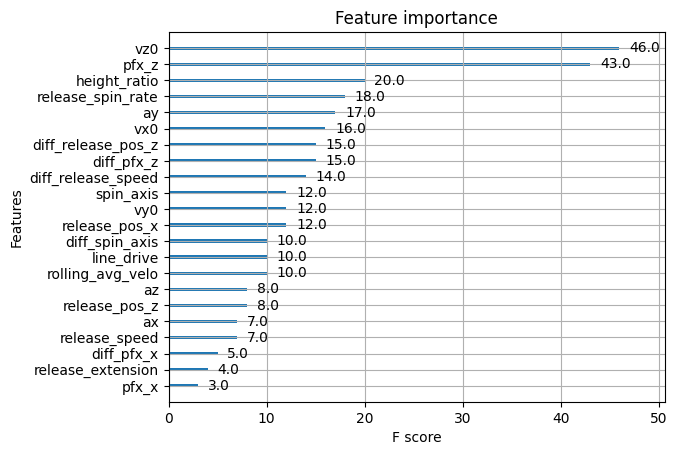

In [12]:
xgb.plot_importance(model)
plt.show()

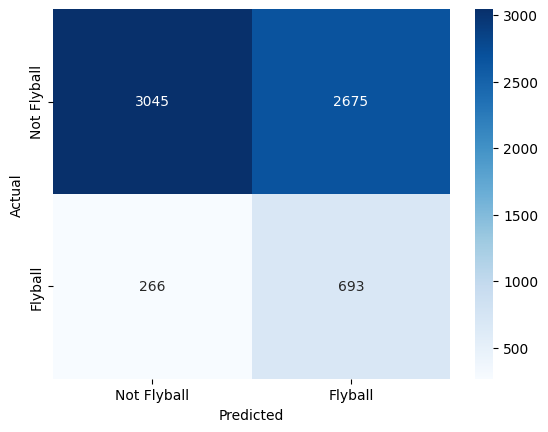

In [13]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [14]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [15]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-16 14:42:11,988] A new study created in memory with name: no-name-5155de0d-4c3d-4aa4-82a0-8feef96527a4


[0]	eval-logloss:0.66765
[1]	eval-logloss:0.65057
[2]	eval-logloss:0.64040
[3]	eval-logloss:0.63221
[4]	eval-logloss:0.62685
[5]	eval-logloss:0.62029
[6]	eval-logloss:0.61652
[7]	eval-logloss:0.61319
[8]	eval-logloss:0.60831
[9]	eval-logloss:0.60717
[10]	eval-logloss:0.60570
[11]	eval-logloss:0.60423
[12]	eval-logloss:0.60115
[13]	eval-logloss:0.59986
[14]	eval-logloss:0.59805
[15]	eval-logloss:0.59552
[16]	eval-logloss:0.59393
[17]	eval-logloss:0.59300
[18]	eval-logloss:0.59054
[19]	eval-logloss:0.59021
[20]	eval-logloss:0.58968
[21]	eval-logloss:0.58678
[22]	eval-logloss:0.58663
[23]	eval-logloss:0.58671
[24]	eval-logloss:0.58483
[25]	eval-logloss:0.58439
[26]	eval-logloss:0.58474
[27]	eval-logloss:0.58244
[28]	eval-logloss:0.58022
[29]	eval-logloss:0.58062
[30]	eval-logloss:0.57760
[31]	eval-logloss:0.57593
[32]	eval-logloss:0.57483
[33]	eval-logloss:0.57253
[34]	eval-logloss:0.57122
[35]	eval-logloss:0.56993
[36]	eval-logloss:0.56894
[37]	eval-logloss:0.56850
[38]	eval-logloss:0.56

[I 2023-11-16 14:42:12,907] Trial 0 finished with value: 0.5115994345995146 and parameters: {'max_depth': 7, 'eta': 0.192158381653868, 'subsample': 0.7735883625500659, 'colsample_bytree': 0.9392285733441932}. Best is trial 0 with value: 0.5115994345995146.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.67714
[2]	eval-logloss:0.67118
[3]	eval-logloss:0.66000
[4]	eval-logloss:0.65144
[5]	eval-logloss:0.64715
[6]	eval-logloss:0.64110
[7]	eval-logloss:0.63866
[8]	eval-logloss:0.63255
[9]	eval-logloss:0.62985
[10]	eval-logloss:0.62825
[11]	eval-logloss:0.62410
[12]	eval-logloss:0.62066
[13]	eval-logloss:0.61781
[14]	eval-logloss:0.61665
[15]	eval-logloss:0.61474
[16]	eval-logloss:0.61166
[17]	eval-logloss:0.60963
[18]	eval-logloss:0.60816
[19]	eval-logloss:0.60660
[20]	eval-logloss:0.60511
[21]	eval-logloss:0.60271
[22]	eval-logloss:0.60181
[23]	eval-logloss:0.60031
[24]	eval-logloss:0.59937
[25]	eval-logloss:0.59800
[26]	eval-logloss:0.59587
[27]	eval-logloss:0.59462
[28]	eval-logloss:0.59382
[29]	eval-logloss:0.59284
[30]	eval-logloss:0.59163
[31]	eval-logloss:0.59080
[32]	eval-logloss:0.58984
[33]	eval-logloss:0.58894
[34]	eval-logloss:0.58729
[35]	eval-logloss:0.58533
[36]	eval-logloss:0.58387
[37]	eval-logloss:0.58294
[38]	eval-logloss:0.58

[I 2023-11-16 14:42:13,721] Trial 1 finished with value: 0.5332111326088473 and parameters: {'max_depth': 7, 'eta': 0.10986089791220705, 'subsample': 0.8386994777337345, 'colsample_bytree': 0.5621763912074751}. Best is trial 0 with value: 0.5115994345995146.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66628
[2]	eval-logloss:0.65526
[3]	eval-logloss:0.64688
[4]	eval-logloss:0.64101
[5]	eval-logloss:0.63529
[6]	eval-logloss:0.63023
[7]	eval-logloss:0.62639
[8]	eval-logloss:0.62109
[9]	eval-logloss:0.61838
[10]	eval-logloss:0.61661
[11]	eval-logloss:0.61453
[12]	eval-logloss:0.61214
[13]	eval-logloss:0.61082
[14]	eval-logloss:0.60741
[15]	eval-logloss:0.60639
[16]	eval-logloss:0.60449
[17]	eval-logloss:0.60307
[18]	eval-logloss:0.60096
[19]	eval-logloss:0.59978
[20]	eval-logloss:0.59887
[21]	eval-logloss:0.59661
[22]	eval-logloss:0.59643
[23]	eval-logloss:0.59582
[24]	eval-logloss:0.59424
[25]	eval-logloss:0.59424
[26]	eval-logloss:0.59404
[27]	eval-logloss:0.59337
[28]	eval-logloss:0.59269
[29]	eval-logloss:0.59180
[30]	eval-logloss:0.59019
[31]	eval-logloss:0.58916
[32]	eval-logloss:0.58870
[33]	eval-logloss:0.58673
[34]	eval-logloss:0.58534
[35]	eval-logloss:0.58403
[36]	eval-logloss:0.58376
[37]	eval-logloss:0.58255
[38]	eval-logloss:0.58

[I 2023-11-16 14:42:14,516] Trial 2 finished with value: 0.5286393016971915 and parameters: {'max_depth': 7, 'eta': 0.12288987721645249, 'subsample': 0.7423808424872173, 'colsample_bytree': 0.7485772211546156}. Best is trial 0 with value: 0.5115994345995146.


[0]	eval-logloss:0.68492
[1]	eval-logloss:0.67845
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.65618
[4]	eval-logloss:0.65095
[5]	eval-logloss:0.64790
[6]	eval-logloss:0.64370
[7]	eval-logloss:0.63972
[8]	eval-logloss:0.63593
[9]	eval-logloss:0.63429
[10]	eval-logloss:0.63176
[11]	eval-logloss:0.62945
[12]	eval-logloss:0.62681
[13]	eval-logloss:0.62547
[14]	eval-logloss:0.62393
[15]	eval-logloss:0.62325
[16]	eval-logloss:0.62163
[17]	eval-logloss:0.62069
[18]	eval-logloss:0.61978
[19]	eval-logloss:0.61954
[20]	eval-logloss:0.61874
[21]	eval-logloss:0.61692
[22]	eval-logloss:0.61608
[23]	eval-logloss:0.61674
[24]	eval-logloss:0.61618
[25]	eval-logloss:0.61624
[26]	eval-logloss:0.61650
[27]	eval-logloss:0.61558
[28]	eval-logloss:0.61499
[29]	eval-logloss:0.61470
[30]	eval-logloss:0.61443
[31]	eval-logloss:0.61349
[32]	eval-logloss:0.61303
[33]	eval-logloss:0.60997
[34]	eval-logloss:0.61022
[35]	eval-logloss:0.60826
[36]	eval-logloss:0.60769
[37]	eval-logloss:0.60678
[38]	eval-logloss:0.60

[I 2023-11-16 14:42:15,124] Trial 3 finished with value: 0.5756423971567984 and parameters: {'max_depth': 5, 'eta': 0.14067150837784395, 'subsample': 0.6812913644817604, 'colsample_bytree': 0.6978054979157868}. Best is trial 0 with value: 0.5115994345995146.


[0]	eval-logloss:0.69111
[1]	eval-logloss:0.68910
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68347
[4]	eval-logloss:0.68084
[5]	eval-logloss:0.67912
[6]	eval-logloss:0.67704
[7]	eval-logloss:0.67453
[8]	eval-logloss:0.67213
[9]	eval-logloss:0.67065
[10]	eval-logloss:0.66852
[11]	eval-logloss:0.66621
[12]	eval-logloss:0.66449
[13]	eval-logloss:0.66270
[14]	eval-logloss:0.66127
[15]	eval-logloss:0.65948
[16]	eval-logloss:0.65755
[17]	eval-logloss:0.65598
[18]	eval-logloss:0.65447
[19]	eval-logloss:0.65302
[20]	eval-logloss:0.65159
[21]	eval-logloss:0.64987
[22]	eval-logloss:0.64812
[23]	eval-logloss:0.64713
[24]	eval-logloss:0.64630
[25]	eval-logloss:0.64482
[26]	eval-logloss:0.64388
[27]	eval-logloss:0.64236
[28]	eval-logloss:0.64118
[29]	eval-logloss:0.63998
[30]	eval-logloss:0.63908
[31]	eval-logloss:0.63808
[32]	eval-logloss:0.63689
[33]	eval-logloss:0.63606
[34]	eval-logloss:0.63471
[35]	eval-logloss:0.63331
[36]	eval-logloss:0.63232
[37]	eval-logloss:0.63101
[38]	eval-logloss:0.62

[I 2023-11-16 14:42:16,248] Trial 4 finished with value: 0.5905956388747741 and parameters: {'max_depth': 8, 'eta': 0.01885895184373864, 'subsample': 0.874196402454067, 'colsample_bytree': 0.6599791927823965}. Best is trial 0 with value: 0.5115994345995146.


[0]	eval-logloss:0.66501
[1]	eval-logloss:0.64829
[2]	eval-logloss:0.64022
[3]	eval-logloss:0.63764
[4]	eval-logloss:0.63683
[5]	eval-logloss:0.63218
[6]	eval-logloss:0.62824
[7]	eval-logloss:0.62820
[8]	eval-logloss:0.62592
[9]	eval-logloss:0.62331
[10]	eval-logloss:0.62263
[11]	eval-logloss:0.62044
[12]	eval-logloss:0.61679
[13]	eval-logloss:0.61790
[14]	eval-logloss:0.61626
[15]	eval-logloss:0.61469
[16]	eval-logloss:0.61465
[17]	eval-logloss:0.61472
[18]	eval-logloss:0.61475
[19]	eval-logloss:0.61461
[20]	eval-logloss:0.61226
[21]	eval-logloss:0.60979
[22]	eval-logloss:0.60913
[23]	eval-logloss:0.61006
[24]	eval-logloss:0.60885
[25]	eval-logloss:0.60816
[26]	eval-logloss:0.60807
[27]	eval-logloss:0.60766
[28]	eval-logloss:0.60708
[29]	eval-logloss:0.60530
[30]	eval-logloss:0.60513
[31]	eval-logloss:0.60446
[32]	eval-logloss:0.60310
[33]	eval-logloss:0.60025
[34]	eval-logloss:0.60080
[35]	eval-logloss:0.59947
[36]	eval-logloss:0.59993
[37]	eval-logloss:0.60028
[38]	eval-logloss:0.59

[I 2023-11-16 14:42:16,872] Trial 5 finished with value: 0.5729525792625164 and parameters: {'max_depth': 5, 'eta': 0.2754816152611818, 'subsample': 0.6384838445066319, 'colsample_bytree': 0.8499398654514896}. Best is trial 0 with value: 0.5115994345995146.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.67940
[2]	eval-logloss:0.66628
[3]	eval-logloss:0.65725
[4]	eval-logloss:0.65276
[5]	eval-logloss:0.64944
[6]	eval-logloss:0.64482
[7]	eval-logloss:0.64202
[8]	eval-logloss:0.63804
[9]	eval-logloss:0.63659
[10]	eval-logloss:0.63449
[11]	eval-logloss:0.63269
[12]	eval-logloss:0.63081
[13]	eval-logloss:0.62977
[14]	eval-logloss:0.62871
[15]	eval-logloss:0.62838
[16]	eval-logloss:0.62681
[17]	eval-logloss:0.62620
[18]	eval-logloss:0.62593
[19]	eval-logloss:0.62633
[20]	eval-logloss:0.62557
[21]	eval-logloss:0.62350
[22]	eval-logloss:0.62328
[23]	eval-logloss:0.62345
[24]	eval-logloss:0.62279
[25]	eval-logloss:0.62328
[26]	eval-logloss:0.62369
[27]	eval-logloss:0.62314
[28]	eval-logloss:0.62284
[29]	eval-logloss:0.62241
[30]	eval-logloss:0.62260
[31]	eval-logloss:0.62199
[32]	eval-logloss:0.62141
[33]	eval-logloss:0.61911
[34]	eval-logloss:0.61919
[35]	eval-logloss:0.61792
[36]	eval-logloss:0.61720
[37]	eval-logloss:0.61637
[38]	eval-logloss:0.61

[I 2023-11-16 14:42:17,401] Trial 6 finished with value: 0.5930798945652372 and parameters: {'max_depth': 4, 'eta': 0.1574825714660025, 'subsample': 0.6769450181008709, 'colsample_bytree': 0.6840722269343945}. Best is trial 0 with value: 0.5115994345995146.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.67403
[2]	eval-logloss:0.66507
[3]	eval-logloss:0.65886
[4]	eval-logloss:0.65517
[5]	eval-logloss:0.65244
[6]	eval-logloss:0.64929
[7]	eval-logloss:0.64679
[8]	eval-logloss:0.64346
[9]	eval-logloss:0.64280
[10]	eval-logloss:0.64130
[11]	eval-logloss:0.63956
[12]	eval-logloss:0.63771
[13]	eval-logloss:0.63717
[14]	eval-logloss:0.63605
[15]	eval-logloss:0.63573
[16]	eval-logloss:0.63446
[17]	eval-logloss:0.63390
[18]	eval-logloss:0.63382
[19]	eval-logloss:0.63448
[20]	eval-logloss:0.63386
[21]	eval-logloss:0.63188
[22]	eval-logloss:0.63192
[23]	eval-logloss:0.63237
[24]	eval-logloss:0.63207
[25]	eval-logloss:0.63250
[26]	eval-logloss:0.63286
[27]	eval-logloss:0.63272
[28]	eval-logloss:0.63193
[29]	eval-logloss:0.63151
[30]	eval-logloss:0.63136
[31]	eval-logloss:0.63073
[32]	eval-logloss:0.63008
[33]	eval-logloss:0.62794
[34]	eval-logloss:0.62812
[35]	eval-logloss:0.62668
[36]	eval-logloss:0.62620
[37]	eval-logloss:0.62593
[38]	eval-logloss:0.62

[I 2023-11-16 14:42:17,892] Trial 7 finished with value: 0.6103844948001459 and parameters: {'max_depth': 3, 'eta': 0.14931847878711751, 'subsample': 0.6955089745916221, 'colsample_bytree': 0.7683623038657348}. Best is trial 0 with value: 0.5115994345995146.


[0]	eval-logloss:0.67633
[1]	eval-logloss:0.66287
[2]	eval-logloss:0.65162
[3]	eval-logloss:0.64223
[4]	eval-logloss:0.63546
[5]	eval-logloss:0.62785
[6]	eval-logloss:0.62154
[7]	eval-logloss:0.61643
[8]	eval-logloss:0.61149
[9]	eval-logloss:0.60784
[10]	eval-logloss:0.60361
[11]	eval-logloss:0.59978
[12]	eval-logloss:0.59526
[13]	eval-logloss:0.59230
[14]	eval-logloss:0.58780
[15]	eval-logloss:0.58531
[16]	eval-logloss:0.58278
[17]	eval-logloss:0.58031
[18]	eval-logloss:0.57820
[19]	eval-logloss:0.57665
[20]	eval-logloss:0.57405
[21]	eval-logloss:0.57190
[22]	eval-logloss:0.56932
[23]	eval-logloss:0.56855
[24]	eval-logloss:0.56541
[25]	eval-logloss:0.56459
[26]	eval-logloss:0.56283
[27]	eval-logloss:0.56104
[28]	eval-logloss:0.56069
[29]	eval-logloss:0.55976
[30]	eval-logloss:0.55732
[31]	eval-logloss:0.55688
[32]	eval-logloss:0.55654
[33]	eval-logloss:0.55360
[34]	eval-logloss:0.55221
[35]	eval-logloss:0.55165
[36]	eval-logloss:0.54999
[37]	eval-logloss:0.54963
[38]	eval-logloss:0.54

[I 2023-11-16 14:42:19,175] Trial 8 finished with value: 0.4883133013731527 and parameters: {'max_depth': 9, 'eta': 0.0924203321022883, 'subsample': 0.7101213618174025, 'colsample_bytree': 0.8510946221022282}. Best is trial 8 with value: 0.4883133013731527.


[0]	eval-logloss:0.66959
[1]	eval-logloss:0.65442
[2]	eval-logloss:0.63962
[3]	eval-logloss:0.62814
[4]	eval-logloss:0.61892
[5]	eval-logloss:0.60976
[6]	eval-logloss:0.60301
[7]	eval-logloss:0.59842
[8]	eval-logloss:0.58958
[9]	eval-logloss:0.58414
[10]	eval-logloss:0.58229
[11]	eval-logloss:0.57886
[12]	eval-logloss:0.57554
[13]	eval-logloss:0.57354
[14]	eval-logloss:0.56973
[15]	eval-logloss:0.56840
[16]	eval-logloss:0.56532
[17]	eval-logloss:0.56423
[18]	eval-logloss:0.56128
[19]	eval-logloss:0.56014
[20]	eval-logloss:0.55904
[21]	eval-logloss:0.55654
[22]	eval-logloss:0.55555
[23]	eval-logloss:0.55473
[24]	eval-logloss:0.55273
[25]	eval-logloss:0.55191
[26]	eval-logloss:0.55108
[27]	eval-logloss:0.54866
[28]	eval-logloss:0.54816
[29]	eval-logloss:0.54692
[30]	eval-logloss:0.54418
[31]	eval-logloss:0.54344
[32]	eval-logloss:0.54237
[33]	eval-logloss:0.53800
[34]	eval-logloss:0.53658
[35]	eval-logloss:0.53518
[36]	eval-logloss:0.53137
[37]	eval-logloss:0.53045
[38]	eval-logloss:0.52

[I 2023-11-16 14:42:20,342] Trial 9 finished with value: 0.46710558880619746 and parameters: {'max_depth': 9, 'eta': 0.15138778812062598, 'subsample': 0.7860340585849306, 'colsample_bytree': 0.7690652964482461}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.66873
[1]	eval-logloss:0.65151
[2]	eval-logloss:0.64018
[3]	eval-logloss:0.62078
[4]	eval-logloss:0.60956
[5]	eval-logloss:0.60114
[6]	eval-logloss:0.59204
[7]	eval-logloss:0.58768
[8]	eval-logloss:0.58189
[9]	eval-logloss:0.57624
[10]	eval-logloss:0.57465
[11]	eval-logloss:0.56981
[12]	eval-logloss:0.56618
[13]	eval-logloss:0.56296
[14]	eval-logloss:0.56017
[15]	eval-logloss:0.55923
[16]	eval-logloss:0.55564
[17]	eval-logloss:0.55328
[18]	eval-logloss:0.55221
[19]	eval-logloss:0.55066
[20]	eval-logloss:0.54769
[21]	eval-logloss:0.54613
[22]	eval-logloss:0.54473
[23]	eval-logloss:0.54175
[24]	eval-logloss:0.53992
[25]	eval-logloss:0.53770
[26]	eval-logloss:0.53441
[27]	eval-logloss:0.53244
[28]	eval-logloss:0.53057
[29]	eval-logloss:0.52839
[30]	eval-logloss:0.52555
[31]	eval-logloss:0.52520
[32]	eval-logloss:0.52386
[33]	eval-logloss:0.52167
[34]	eval-logloss:0.52074
[35]	eval-logloss:0.51716
[36]	eval-logloss:0.51562
[37]	eval-logloss:0.51330
[38]	eval-logloss:0.51

[I 2023-11-16 14:42:21,448] Trial 10 finished with value: 0.47470255610844564 and parameters: {'max_depth': 9, 'eta': 0.23830832220057258, 'subsample': 0.7927847336368627, 'colsample_bytree': 0.503296879876289}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.66839
[1]	eval-logloss:0.64933
[2]	eval-logloss:0.63884
[3]	eval-logloss:0.61950
[4]	eval-logloss:0.60820
[5]	eval-logloss:0.60234
[6]	eval-logloss:0.59225
[7]	eval-logloss:0.58377
[8]	eval-logloss:0.57816
[9]	eval-logloss:0.57571
[10]	eval-logloss:0.57315
[11]	eval-logloss:0.56494
[12]	eval-logloss:0.56009
[13]	eval-logloss:0.55571
[14]	eval-logloss:0.55214
[15]	eval-logloss:0.54978
[16]	eval-logloss:0.54708
[17]	eval-logloss:0.54553
[18]	eval-logloss:0.54319
[19]	eval-logloss:0.54165
[20]	eval-logloss:0.53776
[21]	eval-logloss:0.53559
[22]	eval-logloss:0.53444
[23]	eval-logloss:0.53048
[24]	eval-logloss:0.52941
[25]	eval-logloss:0.52899
[26]	eval-logloss:0.52586
[27]	eval-logloss:0.52154
[28]	eval-logloss:0.52071
[29]	eval-logloss:0.51858
[30]	eval-logloss:0.51653
[31]	eval-logloss:0.51613
[32]	eval-logloss:0.51562
[33]	eval-logloss:0.51354
[34]	eval-logloss:0.51274
[35]	eval-logloss:0.51063
[36]	eval-logloss:0.50960
[37]	eval-logloss:0.50885
[38]	eval-logloss:0.50

[I 2023-11-16 14:42:22,695] Trial 11 finished with value: 0.4804418478679503 and parameters: {'max_depth': 9, 'eta': 0.24183206934938645, 'subsample': 0.7928895334944451, 'colsample_bytree': 0.5002544669189191}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.67034
[1]	eval-logloss:0.65309
[2]	eval-logloss:0.64308
[3]	eval-logloss:0.62431
[4]	eval-logloss:0.61101
[5]	eval-logloss:0.60553
[6]	eval-logloss:0.59762
[7]	eval-logloss:0.59177
[8]	eval-logloss:0.58432
[9]	eval-logloss:0.57991
[10]	eval-logloss:0.57738
[11]	eval-logloss:0.57075
[12]	eval-logloss:0.56633
[13]	eval-logloss:0.56523
[14]	eval-logloss:0.56190
[15]	eval-logloss:0.56000
[16]	eval-logloss:0.55666
[17]	eval-logloss:0.55293
[18]	eval-logloss:0.55062
[19]	eval-logloss:0.54908
[20]	eval-logloss:0.54695
[21]	eval-logloss:0.54430
[22]	eval-logloss:0.54233
[23]	eval-logloss:0.54246
[24]	eval-logloss:0.53898
[25]	eval-logloss:0.53718
[26]	eval-logloss:0.53431
[27]	eval-logloss:0.53359
[28]	eval-logloss:0.53292
[29]	eval-logloss:0.53153
[30]	eval-logloss:0.52877
[31]	eval-logloss:0.52813
[32]	eval-logloss:0.52717
[33]	eval-logloss:0.52409
[34]	eval-logloss:0.52330
[35]	eval-logloss:0.52194
[36]	eval-logloss:0.52052
[37]	eval-logloss:0.51745
[38]	eval-logloss:0.51

[I 2023-11-16 14:42:23,950] Trial 12 finished with value: 0.47334682544344286 and parameters: {'max_depth': 9, 'eta': 0.2128091577566442, 'subsample': 0.8139379405458359, 'colsample_bytree': 0.5876150952138756}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.67715
[1]	eval-logloss:0.66338
[2]	eval-logloss:0.65387
[3]	eval-logloss:0.63654
[4]	eval-logloss:0.62604
[5]	eval-logloss:0.61983
[6]	eval-logloss:0.61286
[7]	eval-logloss:0.61036
[8]	eval-logloss:0.60216
[9]	eval-logloss:0.59812
[10]	eval-logloss:0.59513
[11]	eval-logloss:0.59012
[12]	eval-logloss:0.58702
[13]	eval-logloss:0.58442
[14]	eval-logloss:0.58029
[15]	eval-logloss:0.57876
[16]	eval-logloss:0.57593
[17]	eval-logloss:0.57408
[18]	eval-logloss:0.57173
[19]	eval-logloss:0.57059
[20]	eval-logloss:0.56886
[21]	eval-logloss:0.56727
[22]	eval-logloss:0.56473
[23]	eval-logloss:0.56138
[24]	eval-logloss:0.55558
[25]	eval-logloss:0.55490
[26]	eval-logloss:0.55253
[27]	eval-logloss:0.55111
[28]	eval-logloss:0.55058
[29]	eval-logloss:0.54881
[30]	eval-logloss:0.54724
[31]	eval-logloss:0.54607
[32]	eval-logloss:0.54449
[33]	eval-logloss:0.54240
[34]	eval-logloss:0.54148
[35]	eval-logloss:0.53876
[36]	eval-logloss:0.53816
[37]	eval-logloss:0.53542
[38]	eval-logloss:0.53

[I 2023-11-16 14:42:24,934] Trial 13 finished with value: 0.47521751366149534 and parameters: {'max_depth': 8, 'eta': 0.19686899186328524, 'subsample': 0.831820680935589, 'colsample_bytree': 0.5833336677512742}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66252
[2]	eval-logloss:0.64313
[3]	eval-logloss:0.63030
[4]	eval-logloss:0.62172
[5]	eval-logloss:0.61686
[6]	eval-logloss:0.61041
[7]	eval-logloss:0.60661
[8]	eval-logloss:0.60153
[9]	eval-logloss:0.59845
[10]	eval-logloss:0.59626
[11]	eval-logloss:0.59231
[12]	eval-logloss:0.58863
[13]	eval-logloss:0.58637
[14]	eval-logloss:0.58291
[15]	eval-logloss:0.58059
[16]	eval-logloss:0.57809
[17]	eval-logloss:0.57670
[18]	eval-logloss:0.57458
[19]	eval-logloss:0.57280
[20]	eval-logloss:0.57171
[21]	eval-logloss:0.56831
[22]	eval-logloss:0.56645
[23]	eval-logloss:0.56497
[24]	eval-logloss:0.56211
[25]	eval-logloss:0.56031
[26]	eval-logloss:0.55869
[27]	eval-logloss:0.55735
[28]	eval-logloss:0.55657
[29]	eval-logloss:0.55490
[30]	eval-logloss:0.55305
[31]	eval-logloss:0.55210
[32]	eval-logloss:0.55094
[33]	eval-logloss:0.54880
[34]	eval-logloss:0.54700
[35]	eval-logloss:0.54473
[36]	eval-logloss:0.54326
[37]	eval-logloss:0.54185
[38]	eval-logloss:0.54

[I 2023-11-16 14:42:26,035] Trial 14 finished with value: 0.4771750144495232 and parameters: {'max_depth': 8, 'eta': 0.19131467613765243, 'subsample': 0.8982057331143442, 'colsample_bytree': 0.6235496742249352}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.66170
[1]	eval-logloss:0.65066
[2]	eval-logloss:0.63996
[3]	eval-logloss:0.63216
[4]	eval-logloss:0.63033
[5]	eval-logloss:0.62574
[6]	eval-logloss:0.62384
[7]	eval-logloss:0.62127
[8]	eval-logloss:0.61508
[9]	eval-logloss:0.61505
[10]	eval-logloss:0.61512
[11]	eval-logloss:0.61112
[12]	eval-logloss:0.60954
[13]	eval-logloss:0.60976
[14]	eval-logloss:0.60826
[15]	eval-logloss:0.60818
[16]	eval-logloss:0.60577
[17]	eval-logloss:0.60605
[18]	eval-logloss:0.60321
[19]	eval-logloss:0.60203
[20]	eval-logloss:0.60141
[21]	eval-logloss:0.59764
[22]	eval-logloss:0.59677
[23]	eval-logloss:0.59551
[24]	eval-logloss:0.59468
[25]	eval-logloss:0.59465
[26]	eval-logloss:0.59431
[27]	eval-logloss:0.59224
[28]	eval-logloss:0.59188
[29]	eval-logloss:0.59089
[30]	eval-logloss:0.59009
[31]	eval-logloss:0.58740
[32]	eval-logloss:0.58664
[33]	eval-logloss:0.58311
[34]	eval-logloss:0.58295
[35]	eval-logloss:0.58033
[36]	eval-logloss:0.57896
[37]	eval-logloss:0.57899
[38]	eval-logloss:0.57

[I 2023-11-16 14:42:26,775] Trial 15 finished with value: 0.5352787893815177 and parameters: {'max_depth': 6, 'eta': 0.2843733974072542, 'subsample': 0.7439445941612952, 'colsample_bytree': 0.7434759934055684}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.68455
[1]	eval-logloss:0.67670
[2]	eval-logloss:0.66588
[3]	eval-logloss:0.65599
[4]	eval-logloss:0.64825
[5]	eval-logloss:0.64179
[6]	eval-logloss:0.63547
[7]	eval-logloss:0.63167
[8]	eval-logloss:0.62534
[9]	eval-logloss:0.62170
[10]	eval-logloss:0.61787
[11]	eval-logloss:0.61290
[12]	eval-logloss:0.60981
[13]	eval-logloss:0.60622
[14]	eval-logloss:0.60283
[15]	eval-logloss:0.59934
[16]	eval-logloss:0.59619
[17]	eval-logloss:0.59371
[18]	eval-logloss:0.59127
[19]	eval-logloss:0.58915
[20]	eval-logloss:0.58647
[21]	eval-logloss:0.58344
[22]	eval-logloss:0.58227
[23]	eval-logloss:0.58031
[24]	eval-logloss:0.57798
[25]	eval-logloss:0.57659
[26]	eval-logloss:0.57426
[27]	eval-logloss:0.57224
[28]	eval-logloss:0.57058
[29]	eval-logloss:0.56867
[30]	eval-logloss:0.56596
[31]	eval-logloss:0.56479
[32]	eval-logloss:0.56264
[33]	eval-logloss:0.56148
[34]	eval-logloss:0.55996
[35]	eval-logloss:0.55812
[36]	eval-logloss:0.55696
[37]	eval-logloss:0.55621
[38]	eval-logloss:0.55

[I 2023-11-16 14:42:27,907] Trial 16 finished with value: 0.49749935906542886 and parameters: {'max_depth': 9, 'eta': 0.07508972941582105, 'subsample': 0.8228551350872599, 'colsample_bytree': 0.6164560207511668}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.66233
[1]	eval-logloss:0.64552
[2]	eval-logloss:0.63219
[3]	eval-logloss:0.62278
[4]	eval-logloss:0.61557
[5]	eval-logloss:0.60616
[6]	eval-logloss:0.60178
[7]	eval-logloss:0.59958
[8]	eval-logloss:0.59366
[9]	eval-logloss:0.58992
[10]	eval-logloss:0.58937
[11]	eval-logloss:0.58676
[12]	eval-logloss:0.58389
[13]	eval-logloss:0.58299
[14]	eval-logloss:0.58076
[15]	eval-logloss:0.57798
[16]	eval-logloss:0.57584
[17]	eval-logloss:0.57545
[18]	eval-logloss:0.57506
[19]	eval-logloss:0.57242
[20]	eval-logloss:0.57068
[21]	eval-logloss:0.56851
[22]	eval-logloss:0.56656
[23]	eval-logloss:0.56554
[24]	eval-logloss:0.56357
[25]	eval-logloss:0.56382
[26]	eval-logloss:0.56240
[27]	eval-logloss:0.55940
[28]	eval-logloss:0.55723
[29]	eval-logloss:0.55594
[30]	eval-logloss:0.55373
[31]	eval-logloss:0.55190
[32]	eval-logloss:0.55006
[33]	eval-logloss:0.54539
[34]	eval-logloss:0.54383
[35]	eval-logloss:0.54145
[36]	eval-logloss:0.53909
[37]	eval-logloss:0.53864
[38]	eval-logloss:0.53

[I 2023-11-16 14:42:29,073] Trial 17 finished with value: 0.48549491536856415 and parameters: {'max_depth': 8, 'eta': 0.22325905145249525, 'subsample': 0.7665687517177863, 'colsample_bytree': 0.7917527244315534}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.68208
[1]	eval-logloss:0.67287
[2]	eval-logloss:0.65771
[3]	eval-logloss:0.64827
[4]	eval-logloss:0.64210
[5]	eval-logloss:0.63740
[6]	eval-logloss:0.63185
[7]	eval-logloss:0.62884
[8]	eval-logloss:0.62575
[9]	eval-logloss:0.62242
[10]	eval-logloss:0.61948
[11]	eval-logloss:0.61623
[12]	eval-logloss:0.61255
[13]	eval-logloss:0.61114
[14]	eval-logloss:0.60982
[15]	eval-logloss:0.60882
[16]	eval-logloss:0.60747
[17]	eval-logloss:0.60701
[18]	eval-logloss:0.60717
[19]	eval-logloss:0.60707
[20]	eval-logloss:0.60616
[21]	eval-logloss:0.60531
[22]	eval-logloss:0.60482
[23]	eval-logloss:0.60470
[24]	eval-logloss:0.60374
[25]	eval-logloss:0.60377
[26]	eval-logloss:0.60397
[27]	eval-logloss:0.60295
[28]	eval-logloss:0.60257
[29]	eval-logloss:0.60011
[30]	eval-logloss:0.59894
[31]	eval-logloss:0.59901
[32]	eval-logloss:0.59827
[33]	eval-logloss:0.59548
[34]	eval-logloss:0.59622
[35]	eval-logloss:0.59521
[36]	eval-logloss:0.59493
[37]	eval-logloss:0.59471
[38]	eval-logloss:0.59

[I 2023-11-16 14:42:29,779] Trial 18 finished with value: 0.5492665506407637 and parameters: {'max_depth': 6, 'eta': 0.15913320068586265, 'subsample': 0.6013631484460634, 'colsample_bytree': 0.698170895146372}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.65709
[1]	eval-logloss:0.63851
[2]	eval-logloss:0.62999
[3]	eval-logloss:0.62431
[4]	eval-logloss:0.62126
[5]	eval-logloss:0.61635
[6]	eval-logloss:0.61380
[7]	eval-logloss:0.60860
[8]	eval-logloss:0.60316
[9]	eval-logloss:0.60346
[10]	eval-logloss:0.60253
[11]	eval-logloss:0.60068
[12]	eval-logloss:0.59853
[13]	eval-logloss:0.59604
[14]	eval-logloss:0.59477
[15]	eval-logloss:0.59446
[16]	eval-logloss:0.59053
[17]	eval-logloss:0.58882
[18]	eval-logloss:0.58479
[19]	eval-logloss:0.58411
[20]	eval-logloss:0.58104
[21]	eval-logloss:0.57846
[22]	eval-logloss:0.57859
[23]	eval-logloss:0.57768
[24]	eval-logloss:0.57603
[25]	eval-logloss:0.57544
[26]	eval-logloss:0.57285
[27]	eval-logloss:0.57137
[28]	eval-logloss:0.57058
[29]	eval-logloss:0.56982
[30]	eval-logloss:0.56554
[31]	eval-logloss:0.56293
[32]	eval-logloss:0.56296
[33]	eval-logloss:0.55904
[34]	eval-logloss:0.55758
[35]	eval-logloss:0.55416
[36]	eval-logloss:0.55420
[37]	eval-logloss:0.55256
[38]	eval-logloss:0.55

[I 2023-11-16 14:42:30,679] Trial 19 finished with value: 0.5032015362567329 and parameters: {'max_depth': 7, 'eta': 0.2984273572074817, 'subsample': 0.8533510014127467, 'colsample_bytree': 0.9771080195929013}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.66536
[1]	eval-logloss:0.64717
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.61571
[4]	eval-logloss:0.60395
[5]	eval-logloss:0.59926
[6]	eval-logloss:0.59051
[7]	eval-logloss:0.58799
[8]	eval-logloss:0.58153
[9]	eval-logloss:0.57970
[10]	eval-logloss:0.57701
[11]	eval-logloss:0.57088
[12]	eval-logloss:0.56542
[13]	eval-logloss:0.56356
[14]	eval-logloss:0.55796
[15]	eval-logloss:0.55634
[16]	eval-logloss:0.55261
[17]	eval-logloss:0.54979
[18]	eval-logloss:0.54718
[19]	eval-logloss:0.54522
[20]	eval-logloss:0.54313
[21]	eval-logloss:0.53951
[22]	eval-logloss:0.53825
[23]	eval-logloss:0.53520
[24]	eval-logloss:0.53401
[25]	eval-logloss:0.53154
[26]	eval-logloss:0.52973
[27]	eval-logloss:0.52632
[28]	eval-logloss:0.52383
[29]	eval-logloss:0.52229
[30]	eval-logloss:0.52011
[31]	eval-logloss:0.51908
[32]	eval-logloss:0.51804
[33]	eval-logloss:0.51555
[34]	eval-logloss:0.51371
[35]	eval-logloss:0.51270
[36]	eval-logloss:0.51205
[37]	eval-logloss:0.50991
[38]	eval-logloss:0.50

[I 2023-11-16 14:42:32,042] Trial 20 finished with value: 0.4791159357467848 and parameters: {'max_depth': 9, 'eta': 0.25819402076752507, 'subsample': 0.8153898182658403, 'colsample_bytree': 0.5576512326254592}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.67045
[1]	eval-logloss:0.65132
[2]	eval-logloss:0.63981
[3]	eval-logloss:0.62177
[4]	eval-logloss:0.60886
[5]	eval-logloss:0.60147
[6]	eval-logloss:0.59385
[7]	eval-logloss:0.58875
[8]	eval-logloss:0.58385
[9]	eval-logloss:0.57775
[10]	eval-logloss:0.57315
[11]	eval-logloss:0.56774
[12]	eval-logloss:0.56244
[13]	eval-logloss:0.56189
[14]	eval-logloss:0.55833
[15]	eval-logloss:0.55534
[16]	eval-logloss:0.55186
[17]	eval-logloss:0.55036
[18]	eval-logloss:0.54958
[19]	eval-logloss:0.54742
[20]	eval-logloss:0.54434
[21]	eval-logloss:0.54305
[22]	eval-logloss:0.53888
[23]	eval-logloss:0.53598
[24]	eval-logloss:0.53512
[25]	eval-logloss:0.53369
[26]	eval-logloss:0.52988
[27]	eval-logloss:0.52799
[28]	eval-logloss:0.52732
[29]	eval-logloss:0.52527
[30]	eval-logloss:0.52256
[31]	eval-logloss:0.52181
[32]	eval-logloss:0.52070
[33]	eval-logloss:0.51818
[34]	eval-logloss:0.51749
[35]	eval-logloss:0.51509
[36]	eval-logloss:0.51445
[37]	eval-logloss:0.51236
[38]	eval-logloss:0.51

[I 2023-11-16 14:42:33,179] Trial 21 finished with value: 0.473992980179716 and parameters: {'max_depth': 9, 'eta': 0.22339012084558774, 'subsample': 0.7965225848987665, 'colsample_bytree': 0.5012308445250231}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.67445
[1]	eval-logloss:0.65969
[2]	eval-logloss:0.64885
[3]	eval-logloss:0.63138
[4]	eval-logloss:0.62060
[5]	eval-logloss:0.61374
[6]	eval-logloss:0.60644
[7]	eval-logloss:0.60285
[8]	eval-logloss:0.59610
[9]	eval-logloss:0.59277
[10]	eval-logloss:0.59137
[11]	eval-logloss:0.58713
[12]	eval-logloss:0.58374
[13]	eval-logloss:0.58143
[14]	eval-logloss:0.57892
[15]	eval-logloss:0.57655
[16]	eval-logloss:0.57346
[17]	eval-logloss:0.57202
[18]	eval-logloss:0.56979
[19]	eval-logloss:0.56885
[20]	eval-logloss:0.56630
[21]	eval-logloss:0.56412
[22]	eval-logloss:0.56328
[23]	eval-logloss:0.55949
[24]	eval-logloss:0.55760
[25]	eval-logloss:0.55562
[26]	eval-logloss:0.55418
[27]	eval-logloss:0.55296
[28]	eval-logloss:0.55199
[29]	eval-logloss:0.54982
[30]	eval-logloss:0.54714
[31]	eval-logloss:0.54672
[32]	eval-logloss:0.54470
[33]	eval-logloss:0.54330
[34]	eval-logloss:0.54264
[35]	eval-logloss:0.54077
[36]	eval-logloss:0.54110
[37]	eval-logloss:0.53850
[38]	eval-logloss:0.53

[I 2023-11-16 14:42:34,110] Trial 22 finished with value: 0.48698005490707796 and parameters: {'max_depth': 8, 'eta': 0.21328618410256459, 'subsample': 0.8077974251733758, 'colsample_bytree': 0.5285772942855055}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.67409
[1]	eval-logloss:0.65784
[2]	eval-logloss:0.63801
[3]	eval-logloss:0.62571
[4]	eval-logloss:0.61486
[5]	eval-logloss:0.60794
[6]	eval-logloss:0.60357
[7]	eval-logloss:0.59876
[8]	eval-logloss:0.59092
[9]	eval-logloss:0.58521
[10]	eval-logloss:0.58180
[11]	eval-logloss:0.57737
[12]	eval-logloss:0.57313
[13]	eval-logloss:0.57087
[14]	eval-logloss:0.56666
[15]	eval-logloss:0.56257
[16]	eval-logloss:0.55932
[17]	eval-logloss:0.55623
[18]	eval-logloss:0.55383
[19]	eval-logloss:0.55090
[20]	eval-logloss:0.54796
[21]	eval-logloss:0.54585
[22]	eval-logloss:0.54323
[23]	eval-logloss:0.54016
[24]	eval-logloss:0.53772
[25]	eval-logloss:0.53704
[26]	eval-logloss:0.53500
[27]	eval-logloss:0.53304
[28]	eval-logloss:0.53259
[29]	eval-logloss:0.53121
[30]	eval-logloss:0.52874
[31]	eval-logloss:0.52777
[32]	eval-logloss:0.52666
[33]	eval-logloss:0.52496
[34]	eval-logloss:0.52254
[35]	eval-logloss:0.52141
[36]	eval-logloss:0.52109
[37]	eval-logloss:0.52021
[38]	eval-logloss:0.51

[I 2023-11-16 14:42:35,420] Trial 23 finished with value: 0.4723903686285463 and parameters: {'max_depth': 9, 'eta': 0.17516901908364801, 'subsample': 0.7857255343464404, 'colsample_bytree': 0.6101184188567987}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.67684
[1]	eval-logloss:0.66301
[2]	eval-logloss:0.64521
[3]	eval-logloss:0.63346
[4]	eval-logloss:0.62481
[5]	eval-logloss:0.61938
[6]	eval-logloss:0.61336
[7]	eval-logloss:0.61009
[8]	eval-logloss:0.60405
[9]	eval-logloss:0.60019
[10]	eval-logloss:0.59883
[11]	eval-logloss:0.59567
[12]	eval-logloss:0.59295
[13]	eval-logloss:0.59199
[14]	eval-logloss:0.58892
[15]	eval-logloss:0.58487
[16]	eval-logloss:0.58121
[17]	eval-logloss:0.57983
[18]	eval-logloss:0.57763
[19]	eval-logloss:0.57554
[20]	eval-logloss:0.57393
[21]	eval-logloss:0.57127
[22]	eval-logloss:0.56979
[23]	eval-logloss:0.56808
[24]	eval-logloss:0.56690
[25]	eval-logloss:0.56663
[26]	eval-logloss:0.56565
[27]	eval-logloss:0.56377
[28]	eval-logloss:0.56144
[29]	eval-logloss:0.55926
[30]	eval-logloss:0.55552
[31]	eval-logloss:0.55540
[32]	eval-logloss:0.55439
[33]	eval-logloss:0.55165
[34]	eval-logloss:0.54981
[35]	eval-logloss:0.54854
[36]	eval-logloss:0.54801
[37]	eval-logloss:0.54731
[38]	eval-logloss:0.54

[I 2023-11-16 14:42:36,373] Trial 24 finished with value: 0.487807220068601 and parameters: {'max_depth': 8, 'eta': 0.1731344561006494, 'subsample': 0.7738683030054233, 'colsample_bytree': 0.6207179625175311}. Best is trial 9 with value: 0.46710558880619746.


[0]	eval-logloss:0.67606
[1]	eval-logloss:0.66063
[2]	eval-logloss:0.64933
[3]	eval-logloss:0.63247
[4]	eval-logloss:0.61959
[5]	eval-logloss:0.61217
[6]	eval-logloss:0.60497
[7]	eval-logloss:0.59866
[8]	eval-logloss:0.59022
[9]	eval-logloss:0.58591
[10]	eval-logloss:0.58257
[11]	eval-logloss:0.57574
[12]	eval-logloss:0.57125
[13]	eval-logloss:0.56879
[14]	eval-logloss:0.56374
[15]	eval-logloss:0.56064
[16]	eval-logloss:0.55686
[17]	eval-logloss:0.55397
[18]	eval-logloss:0.55143
[19]	eval-logloss:0.54956
[20]	eval-logloss:0.54795
[21]	eval-logloss:0.54555
[22]	eval-logloss:0.54224
[23]	eval-logloss:0.54095
[24]	eval-logloss:0.53861
[25]	eval-logloss:0.53744
[26]	eval-logloss:0.53709
[27]	eval-logloss:0.53595
[28]	eval-logloss:0.53457
[29]	eval-logloss:0.53322
[30]	eval-logloss:0.53061
[31]	eval-logloss:0.52831
[32]	eval-logloss:0.52715
[33]	eval-logloss:0.52323
[34]	eval-logloss:0.52178
[35]	eval-logloss:0.52002
[36]	eval-logloss:0.51861
[37]	eval-logloss:0.51631
[38]	eval-logloss:0.51

[I 2023-11-16 14:42:37,498] Trial 25 finished with value: 0.46139002695046516 and parameters: {'max_depth': 9, 'eta': 0.17749444141579035, 'subsample': 0.8550691673433831, 'colsample_bytree': 0.5880293099214615}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66531
[2]	eval-logloss:0.64640
[3]	eval-logloss:0.63364
[4]	eval-logloss:0.62436
[5]	eval-logloss:0.61910
[6]	eval-logloss:0.61357
[7]	eval-logloss:0.61060
[8]	eval-logloss:0.60509
[9]	eval-logloss:0.60150
[10]	eval-logloss:0.59763
[11]	eval-logloss:0.59250
[12]	eval-logloss:0.58882
[13]	eval-logloss:0.58605
[14]	eval-logloss:0.58484
[15]	eval-logloss:0.58315
[16]	eval-logloss:0.58039
[17]	eval-logloss:0.57820
[18]	eval-logloss:0.57632
[19]	eval-logloss:0.57446
[20]	eval-logloss:0.57244
[21]	eval-logloss:0.56999
[22]	eval-logloss:0.56784
[23]	eval-logloss:0.56534
[24]	eval-logloss:0.56281
[25]	eval-logloss:0.56173
[26]	eval-logloss:0.55962
[27]	eval-logloss:0.55869
[28]	eval-logloss:0.55818
[29]	eval-logloss:0.55634
[30]	eval-logloss:0.55316
[31]	eval-logloss:0.55293
[32]	eval-logloss:0.55116
[33]	eval-logloss:0.54940
[34]	eval-logloss:0.54750
[35]	eval-logloss:0.54524
[36]	eval-logloss:0.54428
[37]	eval-logloss:0.54360
[38]	eval-logloss:0.54

[I 2023-11-16 14:42:38,702] Trial 26 finished with value: 0.47731282566506644 and parameters: {'max_depth': 8, 'eta': 0.17659593553787586, 'subsample': 0.8638085569312015, 'colsample_bytree': 0.6406490179718893}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66475
[2]	eval-logloss:0.65515
[3]	eval-logloss:0.64028
[4]	eval-logloss:0.62862
[5]	eval-logloss:0.62157
[6]	eval-logloss:0.61333
[7]	eval-logloss:0.60766
[8]	eval-logloss:0.60008
[9]	eval-logloss:0.59484
[10]	eval-logloss:0.59058
[11]	eval-logloss:0.58478
[12]	eval-logloss:0.58112
[13]	eval-logloss:0.57754
[14]	eval-logloss:0.57430
[15]	eval-logloss:0.57161
[16]	eval-logloss:0.56908
[17]	eval-logloss:0.56710
[18]	eval-logloss:0.56541
[19]	eval-logloss:0.56415
[20]	eval-logloss:0.56128
[21]	eval-logloss:0.55878
[22]	eval-logloss:0.55631
[23]	eval-logloss:0.55457
[24]	eval-logloss:0.55168
[25]	eval-logloss:0.54961
[26]	eval-logloss:0.54635
[27]	eval-logloss:0.54455
[28]	eval-logloss:0.54391
[29]	eval-logloss:0.54179
[30]	eval-logloss:0.53914
[31]	eval-logloss:0.53823
[32]	eval-logloss:0.53755
[33]	eval-logloss:0.53542
[34]	eval-logloss:0.53439
[35]	eval-logloss:0.53245
[36]	eval-logloss:0.53077
[37]	eval-logloss:0.52901
[38]	eval-logloss:0.52

[I 2023-11-16 14:42:39,850] Trial 27 finished with value: 0.4637879627067655 and parameters: {'max_depth': 9, 'eta': 0.13685788008376204, 'subsample': 0.8785854806584015, 'colsample_bytree': 0.5839340118339997}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.68225
[1]	eval-logloss:0.67259
[2]	eval-logloss:0.65882
[3]	eval-logloss:0.64815
[4]	eval-logloss:0.64024
[5]	eval-logloss:0.63552
[6]	eval-logloss:0.63060
[7]	eval-logloss:0.62573
[8]	eval-logloss:0.62052
[9]	eval-logloss:0.61774
[10]	eval-logloss:0.61546
[11]	eval-logloss:0.61220
[12]	eval-logloss:0.60969
[13]	eval-logloss:0.60748
[14]	eval-logloss:0.60545
[15]	eval-logloss:0.60460
[16]	eval-logloss:0.60239
[17]	eval-logloss:0.60057
[18]	eval-logloss:0.59872
[19]	eval-logloss:0.59731
[20]	eval-logloss:0.59577
[21]	eval-logloss:0.59319
[22]	eval-logloss:0.59245
[23]	eval-logloss:0.59118
[24]	eval-logloss:0.58936
[25]	eval-logloss:0.58891
[26]	eval-logloss:0.58821
[27]	eval-logloss:0.58725
[28]	eval-logloss:0.58617
[29]	eval-logloss:0.58543
[30]	eval-logloss:0.58391
[31]	eval-logloss:0.58369
[32]	eval-logloss:0.58286
[33]	eval-logloss:0.58153
[34]	eval-logloss:0.58079
[35]	eval-logloss:0.57837
[36]	eval-logloss:0.57631
[37]	eval-logloss:0.57469
[38]	eval-logloss:0.57

[I 2023-11-16 14:42:40,682] Trial 28 finished with value: 0.516450966309118 and parameters: {'max_depth': 7, 'eta': 0.13688248607819864, 'subsample': 0.8468758791910613, 'colsample_bytree': 0.6721645449247143}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.68390
[1]	eval-logloss:0.67569
[2]	eval-logloss:0.66930
[3]	eval-logloss:0.65702
[4]	eval-logloss:0.64744
[5]	eval-logloss:0.64301
[6]	eval-logloss:0.63734
[7]	eval-logloss:0.63404
[8]	eval-logloss:0.62841
[9]	eval-logloss:0.62579
[10]	eval-logloss:0.62310
[11]	eval-logloss:0.61937
[12]	eval-logloss:0.61573
[13]	eval-logloss:0.61323
[14]	eval-logloss:0.61164
[15]	eval-logloss:0.60880
[16]	eval-logloss:0.60650
[17]	eval-logloss:0.60512
[18]	eval-logloss:0.60394
[19]	eval-logloss:0.60246
[20]	eval-logloss:0.60078
[21]	eval-logloss:0.59863
[22]	eval-logloss:0.59752
[23]	eval-logloss:0.59628
[24]	eval-logloss:0.59532
[25]	eval-logloss:0.59366
[26]	eval-logloss:0.59278
[27]	eval-logloss:0.59099
[28]	eval-logloss:0.59078
[29]	eval-logloss:0.58989
[30]	eval-logloss:0.58815
[31]	eval-logloss:0.58750
[32]	eval-logloss:0.58640
[33]	eval-logloss:0.58498
[34]	eval-logloss:0.58447
[35]	eval-logloss:0.58266
[36]	eval-logloss:0.58179
[37]	eval-logloss:0.58072
[38]	eval-logloss:0.57

[I 2023-11-16 14:42:41,603] Trial 29 finished with value: 0.529266133102332 and parameters: {'max_depth': 7, 'eta': 0.12675621345386037, 'subsample': 0.8844519082181694, 'colsample_bytree': 0.5469138917389441}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.67763
[1]	eval-logloss:0.66370
[2]	eval-logloss:0.65436
[3]	eval-logloss:0.63753
[4]	eval-logloss:0.62551
[5]	eval-logloss:0.61912
[6]	eval-logloss:0.61267
[7]	eval-logloss:0.60926
[8]	eval-logloss:0.60253
[9]	eval-logloss:0.59823
[10]	eval-logloss:0.59658
[11]	eval-logloss:0.59082
[12]	eval-logloss:0.58617
[13]	eval-logloss:0.58382
[14]	eval-logloss:0.58068
[15]	eval-logloss:0.57802
[16]	eval-logloss:0.57526
[17]	eval-logloss:0.57340
[18]	eval-logloss:0.57135
[19]	eval-logloss:0.56979
[20]	eval-logloss:0.56856
[21]	eval-logloss:0.56542
[22]	eval-logloss:0.56276
[23]	eval-logloss:0.55837
[24]	eval-logloss:0.55582
[25]	eval-logloss:0.55441
[26]	eval-logloss:0.55396
[27]	eval-logloss:0.55288
[28]	eval-logloss:0.55325
[29]	eval-logloss:0.55144
[30]	eval-logloss:0.54782
[31]	eval-logloss:0.54697
[32]	eval-logloss:0.54615
[33]	eval-logloss:0.54349
[34]	eval-logloss:0.54242
[35]	eval-logloss:0.54131
[36]	eval-logloss:0.54095
[37]	eval-logloss:0.53941
[38]	eval-logloss:0.53

[I 2023-11-16 14:42:42,661] Trial 30 finished with value: 0.4761637398140212 and parameters: {'max_depth': 8, 'eta': 0.19352873947433874, 'subsample': 0.8695410490036454, 'colsample_bytree': 0.5906722985852025}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.67631
[1]	eval-logloss:0.66056
[2]	eval-logloss:0.65008
[3]	eval-logloss:0.63269
[4]	eval-logloss:0.61930
[5]	eval-logloss:0.61204
[6]	eval-logloss:0.60482
[7]	eval-logloss:0.60113
[8]	eval-logloss:0.59287
[9]	eval-logloss:0.58813
[10]	eval-logloss:0.58527
[11]	eval-logloss:0.57921
[12]	eval-logloss:0.57361
[13]	eval-logloss:0.57099
[14]	eval-logloss:0.56922
[15]	eval-logloss:0.56663
[16]	eval-logloss:0.56368
[17]	eval-logloss:0.56043
[18]	eval-logloss:0.55782
[19]	eval-logloss:0.55603
[20]	eval-logloss:0.55229
[21]	eval-logloss:0.55012
[22]	eval-logloss:0.54863
[23]	eval-logloss:0.54663
[24]	eval-logloss:0.54342
[25]	eval-logloss:0.54127
[26]	eval-logloss:0.53826
[27]	eval-logloss:0.53683
[28]	eval-logloss:0.53613
[29]	eval-logloss:0.53352
[30]	eval-logloss:0.53087
[31]	eval-logloss:0.52950
[32]	eval-logloss:0.52886
[33]	eval-logloss:0.52611
[34]	eval-logloss:0.52516
[35]	eval-logloss:0.52272
[36]	eval-logloss:0.52131
[37]	eval-logloss:0.51827
[38]	eval-logloss:0.51

[I 2023-11-16 14:42:43,797] Trial 31 finished with value: 0.4660285648460844 and parameters: {'max_depth': 9, 'eta': 0.17476203691130748, 'subsample': 0.8561882018268145, 'colsample_bytree': 0.5991285160545992}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.67558
[1]	eval-logloss:0.66116
[2]	eval-logloss:0.65160
[3]	eval-logloss:0.63485
[4]	eval-logloss:0.62265
[5]	eval-logloss:0.61667
[6]	eval-logloss:0.60853
[7]	eval-logloss:0.60313
[8]	eval-logloss:0.59487
[9]	eval-logloss:0.59141
[10]	eval-logloss:0.58880
[11]	eval-logloss:0.58319
[12]	eval-logloss:0.57861
[13]	eval-logloss:0.57541
[14]	eval-logloss:0.57317
[15]	eval-logloss:0.57152
[16]	eval-logloss:0.56798
[17]	eval-logloss:0.56519
[18]	eval-logloss:0.56248
[19]	eval-logloss:0.56061
[20]	eval-logloss:0.55722
[21]	eval-logloss:0.55523
[22]	eval-logloss:0.55385
[23]	eval-logloss:0.55152
[24]	eval-logloss:0.54934
[25]	eval-logloss:0.54669
[26]	eval-logloss:0.54546
[27]	eval-logloss:0.54421
[28]	eval-logloss:0.54372
[29]	eval-logloss:0.54229
[30]	eval-logloss:0.53922
[31]	eval-logloss:0.53691
[32]	eval-logloss:0.53558
[33]	eval-logloss:0.53169
[34]	eval-logloss:0.53036
[35]	eval-logloss:0.52764
[36]	eval-logloss:0.52666
[37]	eval-logloss:0.52546
[38]	eval-logloss:0.52

[I 2023-11-16 14:42:45,037] Trial 32 finished with value: 0.4635975265603314 and parameters: {'max_depth': 9, 'eta': 0.16369282371784455, 'subsample': 0.8488504841203817, 'colsample_bytree': 0.5640167447136581}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.66823
[2]	eval-logloss:0.65833
[3]	eval-logloss:0.64464
[4]	eval-logloss:0.63389
[5]	eval-logloss:0.62731
[6]	eval-logloss:0.62010
[7]	eval-logloss:0.61606
[8]	eval-logloss:0.60869
[9]	eval-logloss:0.60445
[10]	eval-logloss:0.60104
[11]	eval-logloss:0.59570
[12]	eval-logloss:0.59199
[13]	eval-logloss:0.58811
[14]	eval-logloss:0.58425
[15]	eval-logloss:0.58068
[16]	eval-logloss:0.57686
[17]	eval-logloss:0.57429
[18]	eval-logloss:0.57230
[19]	eval-logloss:0.57070
[20]	eval-logloss:0.56839
[21]	eval-logloss:0.56528
[22]	eval-logloss:0.56344
[23]	eval-logloss:0.56081
[24]	eval-logloss:0.55905
[25]	eval-logloss:0.55774
[26]	eval-logloss:0.55614
[27]	eval-logloss:0.55525
[28]	eval-logloss:0.55293
[29]	eval-logloss:0.55063
[30]	eval-logloss:0.54823
[31]	eval-logloss:0.54723
[32]	eval-logloss:0.54564
[33]	eval-logloss:0.54298
[34]	eval-logloss:0.54169
[35]	eval-logloss:0.53878
[36]	eval-logloss:0.53814
[37]	eval-logloss:0.53753
[38]	eval-logloss:0.53

[I 2023-11-16 14:42:46,149] Trial 33 finished with value: 0.47844682148406165 and parameters: {'max_depth': 9, 'eta': 0.11898759736220196, 'subsample': 0.8420935009205818, 'colsample_bytree': 0.5620952608415888}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66546
[2]	eval-logloss:0.65623
[3]	eval-logloss:0.64072
[4]	eval-logloss:0.62883
[5]	eval-logloss:0.62319
[6]	eval-logloss:0.61682
[7]	eval-logloss:0.61295
[8]	eval-logloss:0.60695
[9]	eval-logloss:0.60335
[10]	eval-logloss:0.60125
[11]	eval-logloss:0.59712
[12]	eval-logloss:0.59204
[13]	eval-logloss:0.58925
[14]	eval-logloss:0.58618
[15]	eval-logloss:0.58292
[16]	eval-logloss:0.58029
[17]	eval-logloss:0.57870
[18]	eval-logloss:0.57698
[19]	eval-logloss:0.57462
[20]	eval-logloss:0.57172
[21]	eval-logloss:0.56951
[22]	eval-logloss:0.56820
[23]	eval-logloss:0.56537
[24]	eval-logloss:0.56400
[25]	eval-logloss:0.56222
[26]	eval-logloss:0.56053
[27]	eval-logloss:0.55801
[28]	eval-logloss:0.55661
[29]	eval-logloss:0.55465
[30]	eval-logloss:0.55276
[31]	eval-logloss:0.55194
[32]	eval-logloss:0.55046
[33]	eval-logloss:0.54789
[34]	eval-logloss:0.54663
[35]	eval-logloss:0.54424
[36]	eval-logloss:0.54291
[37]	eval-logloss:0.54123
[38]	eval-logloss:0.54

[I 2023-11-16 14:42:47,110] Trial 34 finished with value: 0.4837115112700176 and parameters: {'max_depth': 8, 'eta': 0.16923826308674725, 'subsample': 0.8881707870379268, 'colsample_bytree': 0.5370881781260344}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.67908
[1]	eval-logloss:0.66593
[2]	eval-logloss:0.65651
[3]	eval-logloss:0.64134
[4]	eval-logloss:0.63003
[5]	eval-logloss:0.62290
[6]	eval-logloss:0.61470
[7]	eval-logloss:0.61113
[8]	eval-logloss:0.60416
[9]	eval-logloss:0.59953
[10]	eval-logloss:0.59656
[11]	eval-logloss:0.59154
[12]	eval-logloss:0.58763
[13]	eval-logloss:0.58360
[14]	eval-logloss:0.58138
[15]	eval-logloss:0.57817
[16]	eval-logloss:0.57474
[17]	eval-logloss:0.57162
[18]	eval-logloss:0.56913
[19]	eval-logloss:0.56712
[20]	eval-logloss:0.56369
[21]	eval-logloss:0.56056
[22]	eval-logloss:0.55886
[23]	eval-logloss:0.55663
[24]	eval-logloss:0.55508
[25]	eval-logloss:0.55256
[26]	eval-logloss:0.55044
[27]	eval-logloss:0.54846
[28]	eval-logloss:0.54731
[29]	eval-logloss:0.54537
[30]	eval-logloss:0.54345
[31]	eval-logloss:0.54309
[32]	eval-logloss:0.54124
[33]	eval-logloss:0.53875
[34]	eval-logloss:0.53742
[35]	eval-logloss:0.53539
[36]	eval-logloss:0.53378
[37]	eval-logloss:0.53178
[38]	eval-logloss:0.53

[I 2023-11-16 14:42:48,270] Trial 35 finished with value: 0.46993280628681444 and parameters: {'max_depth': 9, 'eta': 0.13367050723136692, 'subsample': 0.858783885166033, 'colsample_bytree': 0.5830166017483396}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.68690
[1]	eval-logloss:0.68156
[2]	eval-logloss:0.67132
[3]	eval-logloss:0.66317
[4]	eval-logloss:0.65719
[5]	eval-logloss:0.65496
[6]	eval-logloss:0.65061
[7]	eval-logloss:0.64652
[8]	eval-logloss:0.64236
[9]	eval-logloss:0.64090
[10]	eval-logloss:0.63860
[11]	eval-logloss:0.63606
[12]	eval-logloss:0.63440
[13]	eval-logloss:0.63293
[14]	eval-logloss:0.63164
[15]	eval-logloss:0.63069
[16]	eval-logloss:0.62921
[17]	eval-logloss:0.62775
[18]	eval-logloss:0.62646
[19]	eval-logloss:0.62532
[20]	eval-logloss:0.62481
[21]	eval-logloss:0.62336
[22]	eval-logloss:0.62298
[23]	eval-logloss:0.62234
[24]	eval-logloss:0.62170
[25]	eval-logloss:0.62140
[26]	eval-logloss:0.62120
[27]	eval-logloss:0.62065
[28]	eval-logloss:0.62022
[29]	eval-logloss:0.61982
[30]	eval-logloss:0.61885
[31]	eval-logloss:0.61820
[32]	eval-logloss:0.61784
[33]	eval-logloss:0.61666
[34]	eval-logloss:0.61610
[35]	eval-logloss:0.61504
[36]	eval-logloss:0.61453
[37]	eval-logloss:0.61382
[38]	eval-logloss:0.61

[I 2023-11-16 14:42:49,025] Trial 36 finished with value: 0.586573122681612 and parameters: {'max_depth': 5, 'eta': 0.10723576448536346, 'subsample': 0.83458352028627, 'colsample_bytree': 0.6592253770901425}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67294
[2]	eval-logloss:0.66573
[3]	eval-logloss:0.65259
[4]	eval-logloss:0.64238
[5]	eval-logloss:0.63808
[6]	eval-logloss:0.63164
[7]	eval-logloss:0.62766
[8]	eval-logloss:0.62118
[9]	eval-logloss:0.61900
[10]	eval-logloss:0.61673
[11]	eval-logloss:0.61209
[12]	eval-logloss:0.60831
[13]	eval-logloss:0.60615
[14]	eval-logloss:0.60426
[15]	eval-logloss:0.60197
[16]	eval-logloss:0.59947
[17]	eval-logloss:0.59776
[18]	eval-logloss:0.59603
[19]	eval-logloss:0.59480
[20]	eval-logloss:0.59322
[21]	eval-logloss:0.59128
[22]	eval-logloss:0.59007
[23]	eval-logloss:0.58970
[24]	eval-logloss:0.58777
[25]	eval-logloss:0.58645
[26]	eval-logloss:0.58562
[27]	eval-logloss:0.58419
[28]	eval-logloss:0.58305
[29]	eval-logloss:0.58216
[30]	eval-logloss:0.58074
[31]	eval-logloss:0.58008
[32]	eval-logloss:0.57946
[33]	eval-logloss:0.57832
[34]	eval-logloss:0.57720
[35]	eval-logloss:0.57547
[36]	eval-logloss:0.57448
[37]	eval-logloss:0.57294
[38]	eval-logloss:0.57

[I 2023-11-16 14:42:49,839] Trial 37 finished with value: 0.5176250229122207 and parameters: {'max_depth': 7, 'eta': 0.14352256130364016, 'subsample': 0.8739054573520855, 'colsample_bytree': 0.5670965160515479}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.68110
[2]	eval-logloss:0.67849
[3]	eval-logloss:0.66662
[4]	eval-logloss:0.65912
[5]	eval-logloss:0.65690
[6]	eval-logloss:0.65174
[7]	eval-logloss:0.65099
[8]	eval-logloss:0.64619
[9]	eval-logloss:0.64510
[10]	eval-logloss:0.64511
[11]	eval-logloss:0.64197
[12]	eval-logloss:0.63960
[13]	eval-logloss:0.63819
[14]	eval-logloss:0.63748
[15]	eval-logloss:0.63678
[16]	eval-logloss:0.63503
[17]	eval-logloss:0.63404
[18]	eval-logloss:0.63338
[19]	eval-logloss:0.63305
[20]	eval-logloss:0.63283
[21]	eval-logloss:0.63131
[22]	eval-logloss:0.63109
[23]	eval-logloss:0.63075
[24]	eval-logloss:0.63046
[25]	eval-logloss:0.63082
[26]	eval-logloss:0.63058
[27]	eval-logloss:0.62967
[28]	eval-logloss:0.62953
[29]	eval-logloss:0.62964
[30]	eval-logloss:0.62941
[31]	eval-logloss:0.62927
[32]	eval-logloss:0.62940
[33]	eval-logloss:0.62822
[34]	eval-logloss:0.62831
[35]	eval-logloss:0.62723
[36]	eval-logloss:0.62658
[37]	eval-logloss:0.62543
[38]	eval-logloss:0.62

[I 2023-11-16 14:42:50,351] Trial 38 finished with value: 0.6090971735922732 and parameters: {'max_depth': 3, 'eta': 0.16360339088855433, 'subsample': 0.8509754263656477, 'colsample_bytree': 0.5331691216538648}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66357
[2]	eval-logloss:0.64590
[3]	eval-logloss:0.63284
[4]	eval-logloss:0.62293
[5]	eval-logloss:0.61751
[6]	eval-logloss:0.61066
[7]	eval-logloss:0.60617
[8]	eval-logloss:0.60091
[9]	eval-logloss:0.59725
[10]	eval-logloss:0.59462
[11]	eval-logloss:0.59033
[12]	eval-logloss:0.58757
[13]	eval-logloss:0.58550
[14]	eval-logloss:0.58327
[15]	eval-logloss:0.58174
[16]	eval-logloss:0.57947
[17]	eval-logloss:0.57742
[18]	eval-logloss:0.57471
[19]	eval-logloss:0.57294
[20]	eval-logloss:0.56983
[21]	eval-logloss:0.56833
[22]	eval-logloss:0.56715
[23]	eval-logloss:0.56376
[24]	eval-logloss:0.56254
[25]	eval-logloss:0.56136
[26]	eval-logloss:0.56138
[27]	eval-logloss:0.55967
[28]	eval-logloss:0.55860
[29]	eval-logloss:0.55728
[30]	eval-logloss:0.55538
[31]	eval-logloss:0.55498
[32]	eval-logloss:0.55387
[33]	eval-logloss:0.55198
[34]	eval-logloss:0.55050
[35]	eval-logloss:0.54911
[36]	eval-logloss:0.54818
[37]	eval-logloss:0.54700
[38]	eval-logloss:0.54

[I 2023-11-16 14:42:51,556] Trial 39 finished with value: 0.4845368043634826 and parameters: {'max_depth': 8, 'eta': 0.18166746460613853, 'subsample': 0.8791372792919157, 'colsample_bytree': 0.650463444127504}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.66375
[2]	eval-logloss:0.65243
[3]	eval-logloss:0.63737
[4]	eval-logloss:0.62609
[5]	eval-logloss:0.61954
[6]	eval-logloss:0.61211
[7]	eval-logloss:0.60719
[8]	eval-logloss:0.60103
[9]	eval-logloss:0.59566
[10]	eval-logloss:0.59229
[11]	eval-logloss:0.58786
[12]	eval-logloss:0.58314
[13]	eval-logloss:0.57890
[14]	eval-logloss:0.57623
[15]	eval-logloss:0.57314
[16]	eval-logloss:0.56969
[17]	eval-logloss:0.56773
[18]	eval-logloss:0.56566
[19]	eval-logloss:0.56312
[20]	eval-logloss:0.56098
[21]	eval-logloss:0.55808
[22]	eval-logloss:0.55491
[23]	eval-logloss:0.55238
[24]	eval-logloss:0.55063
[25]	eval-logloss:0.54782
[26]	eval-logloss:0.54453
[27]	eval-logloss:0.54303
[28]	eval-logloss:0.54198
[29]	eval-logloss:0.54041
[30]	eval-logloss:0.53781
[31]	eval-logloss:0.53539
[32]	eval-logloss:0.53508
[33]	eval-logloss:0.53242
[34]	eval-logloss:0.53235
[35]	eval-logloss:0.52977
[36]	eval-logloss:0.52916
[37]	eval-logloss:0.52646
[38]	eval-logloss:0.52

[I 2023-11-16 14:42:52,691] Trial 40 finished with value: 0.46671556032150224 and parameters: {'max_depth': 9, 'eta': 0.15172366814771598, 'subsample': 0.8967606802125998, 'colsample_bytree': 0.5973478639943477}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.66266
[2]	eval-logloss:0.65293
[3]	eval-logloss:0.63662
[4]	eval-logloss:0.62509
[5]	eval-logloss:0.61820
[6]	eval-logloss:0.61097
[7]	eval-logloss:0.60655
[8]	eval-logloss:0.59901
[9]	eval-logloss:0.59458
[10]	eval-logloss:0.59165
[11]	eval-logloss:0.58594
[12]	eval-logloss:0.58179
[13]	eval-logloss:0.57823
[14]	eval-logloss:0.57576
[15]	eval-logloss:0.57252
[16]	eval-logloss:0.56936
[17]	eval-logloss:0.56542
[18]	eval-logloss:0.56391
[19]	eval-logloss:0.56246
[20]	eval-logloss:0.55988
[21]	eval-logloss:0.55842
[22]	eval-logloss:0.55649
[23]	eval-logloss:0.55381
[24]	eval-logloss:0.55045
[25]	eval-logloss:0.54730
[26]	eval-logloss:0.54530
[27]	eval-logloss:0.54313
[28]	eval-logloss:0.54141
[29]	eval-logloss:0.53996
[30]	eval-logloss:0.53821
[31]	eval-logloss:0.53747
[32]	eval-logloss:0.53566
[33]	eval-logloss:0.53427
[34]	eval-logloss:0.53207
[35]	eval-logloss:0.53003
[36]	eval-logloss:0.52778
[37]	eval-logloss:0.52615
[38]	eval-logloss:0.52

[I 2023-11-16 14:42:53,825] Trial 41 finished with value: 0.46594210118913737 and parameters: {'max_depth': 9, 'eta': 0.1504518076395226, 'subsample': 0.8635427284575737, 'colsample_bytree': 0.6056553087048575}. Best is trial 25 with value: 0.46139002695046516.


[0]	eval-logloss:0.67650
[1]	eval-logloss:0.66133
[2]	eval-logloss:0.64281
[3]	eval-logloss:0.62815
[4]	eval-logloss:0.61744
[5]	eval-logloss:0.61072
[6]	eval-logloss:0.60319
[7]	eval-logloss:0.59749
[8]	eval-logloss:0.59123
[9]	eval-logloss:0.58734
[10]	eval-logloss:0.58477
[11]	eval-logloss:0.57971
[12]	eval-logloss:0.57588
[13]	eval-logloss:0.57269
[14]	eval-logloss:0.56804
[15]	eval-logloss:0.56575
[16]	eval-logloss:0.56256
[17]	eval-logloss:0.55958
[18]	eval-logloss:0.55656
[19]	eval-logloss:0.55475
[20]	eval-logloss:0.55250
[21]	eval-logloss:0.54942
[22]	eval-logloss:0.54850
[23]	eval-logloss:0.54592
[24]	eval-logloss:0.54477
[25]	eval-logloss:0.54286
[26]	eval-logloss:0.54274
[27]	eval-logloss:0.54054
[28]	eval-logloss:0.54006
[29]	eval-logloss:0.53823
[30]	eval-logloss:0.53529
[31]	eval-logloss:0.53481
[32]	eval-logloss:0.53272
[33]	eval-logloss:0.53042
[34]	eval-logloss:0.52884
[35]	eval-logloss:0.52742
[36]	eval-logloss:0.52625
[37]	eval-logloss:0.52413
[38]	eval-logloss:0.52

[I 2023-11-16 14:42:55,096] Trial 42 finished with value: 0.4609865047330636 and parameters: {'max_depth': 9, 'eta': 0.1613150426300479, 'subsample': 0.8597946872571449, 'colsample_bytree': 0.6374012573169779}. Best is trial 42 with value: 0.4609865047330636.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.68131
[2]	eval-logloss:0.66918
[3]	eval-logloss:0.66061
[4]	eval-logloss:0.65462
[5]	eval-logloss:0.65214
[6]	eval-logloss:0.64805
[7]	eval-logloss:0.64704
[8]	eval-logloss:0.64240
[9]	eval-logloss:0.64199
[10]	eval-logloss:0.64092
[11]	eval-logloss:0.63832
[12]	eval-logloss:0.63623
[13]	eval-logloss:0.63500
[14]	eval-logloss:0.63403
[15]	eval-logloss:0.63336
[16]	eval-logloss:0.63156
[17]	eval-logloss:0.63059
[18]	eval-logloss:0.62963
[19]	eval-logloss:0.62904
[20]	eval-logloss:0.62883
[21]	eval-logloss:0.62754
[22]	eval-logloss:0.62711
[23]	eval-logloss:0.62605
[24]	eval-logloss:0.62519
[25]	eval-logloss:0.62505
[26]	eval-logloss:0.62502
[27]	eval-logloss:0.62388
[28]	eval-logloss:0.62388
[29]	eval-logloss:0.62386
[30]	eval-logloss:0.62332
[31]	eval-logloss:0.62332
[32]	eval-logloss:0.62330
[33]	eval-logloss:0.62221
[34]	eval-logloss:0.62220
[35]	eval-logloss:0.62088
[36]	eval-logloss:0.62061
[37]	eval-logloss:0.61990
[38]	eval-logloss:0.61

[I 2023-11-16 14:42:55,671] Trial 43 finished with value: 0.5937440992228057 and parameters: {'max_depth': 4, 'eta': 0.1441890854236494, 'subsample': 0.8671674417851754, 'colsample_bytree': 0.6339553448026276}. Best is trial 42 with value: 0.4609865047330636.


[0]	eval-logloss:0.67586
[1]	eval-logloss:0.66181
[2]	eval-logloss:0.65124
[3]	eval-logloss:0.63425
[4]	eval-logloss:0.62339
[5]	eval-logloss:0.61557
[6]	eval-logloss:0.60833
[7]	eval-logloss:0.60410
[8]	eval-logloss:0.59677
[9]	eval-logloss:0.59207
[10]	eval-logloss:0.58956
[11]	eval-logloss:0.58397
[12]	eval-logloss:0.57954
[13]	eval-logloss:0.57561
[14]	eval-logloss:0.57368
[15]	eval-logloss:0.57123
[16]	eval-logloss:0.56808
[17]	eval-logloss:0.56543
[18]	eval-logloss:0.56244
[19]	eval-logloss:0.56079
[20]	eval-logloss:0.55908
[21]	eval-logloss:0.55654
[22]	eval-logloss:0.55395
[23]	eval-logloss:0.55035
[24]	eval-logloss:0.54896
[25]	eval-logloss:0.54739
[26]	eval-logloss:0.54470
[27]	eval-logloss:0.54435
[28]	eval-logloss:0.54343
[29]	eval-logloss:0.54151
[30]	eval-logloss:0.53915
[31]	eval-logloss:0.53817
[32]	eval-logloss:0.53678
[33]	eval-logloss:0.53429
[34]	eval-logloss:0.53174
[35]	eval-logloss:0.53127
[36]	eval-logloss:0.52849
[37]	eval-logloss:0.52719
[38]	eval-logloss:0.52

[I 2023-11-16 14:42:56,855] Trial 44 finished with value: 0.47063007451744143 and parameters: {'max_depth': 9, 'eta': 0.15681129164052507, 'subsample': 0.8342641197125212, 'colsample_bytree': 0.5707369885154276}. Best is trial 42 with value: 0.4609865047330636.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.66665
[2]	eval-logloss:0.65184
[3]	eval-logloss:0.63968
[4]	eval-logloss:0.63009
[5]	eval-logloss:0.62269
[6]	eval-logloss:0.61563
[7]	eval-logloss:0.60979
[8]	eval-logloss:0.60334
[9]	eval-logloss:0.59843
[10]	eval-logloss:0.59449
[11]	eval-logloss:0.58998
[12]	eval-logloss:0.58633
[13]	eval-logloss:0.58346
[14]	eval-logloss:0.58027
[15]	eval-logloss:0.57687
[16]	eval-logloss:0.57403
[17]	eval-logloss:0.57120
[18]	eval-logloss:0.56913
[19]	eval-logloss:0.56694
[20]	eval-logloss:0.56530
[21]	eval-logloss:0.56299
[22]	eval-logloss:0.56115
[23]	eval-logloss:0.55883
[24]	eval-logloss:0.55532
[25]	eval-logloss:0.55331
[26]	eval-logloss:0.55177
[27]	eval-logloss:0.55003
[28]	eval-logloss:0.54835
[29]	eval-logloss:0.54728
[30]	eval-logloss:0.54547
[31]	eval-logloss:0.54446
[32]	eval-logloss:0.54384
[33]	eval-logloss:0.54121
[34]	eval-logloss:0.53986
[35]	eval-logloss:0.53731
[36]	eval-logloss:0.53698
[37]	eval-logloss:0.53516
[38]	eval-logloss:0.53

[I 2023-11-16 14:42:58,108] Trial 45 finished with value: 0.47856020536736105 and parameters: {'max_depth': 9, 'eta': 0.11989836110762869, 'subsample': 0.8773426746503389, 'colsample_bytree': 0.6135900977469334}. Best is trial 42 with value: 0.4609865047330636.


[0]	eval-logloss:0.67759
[1]	eval-logloss:0.66507
[2]	eval-logloss:0.64672
[3]	eval-logloss:0.63339
[4]	eval-logloss:0.62492
[5]	eval-logloss:0.61773
[6]	eval-logloss:0.61157
[7]	eval-logloss:0.60675
[8]	eval-logloss:0.60018
[9]	eval-logloss:0.59465
[10]	eval-logloss:0.59309
[11]	eval-logloss:0.58952
[12]	eval-logloss:0.58657
[13]	eval-logloss:0.58444
[14]	eval-logloss:0.58332
[15]	eval-logloss:0.58306
[16]	eval-logloss:0.58019
[17]	eval-logloss:0.57879
[18]	eval-logloss:0.57598
[19]	eval-logloss:0.57343
[20]	eval-logloss:0.56993
[21]	eval-logloss:0.56749
[22]	eval-logloss:0.56638
[23]	eval-logloss:0.56548
[24]	eval-logloss:0.56273
[25]	eval-logloss:0.56143
[26]	eval-logloss:0.55984
[27]	eval-logloss:0.55829
[28]	eval-logloss:0.55761
[29]	eval-logloss:0.55535
[30]	eval-logloss:0.55313
[31]	eval-logloss:0.55187
[32]	eval-logloss:0.55153
[33]	eval-logloss:0.54971
[34]	eval-logloss:0.54850
[35]	eval-logloss:0.54675
[36]	eval-logloss:0.54586
[37]	eval-logloss:0.54342
[38]	eval-logloss:0.54

[I 2023-11-16 14:42:59,074] Trial 46 finished with value: 0.48543380219152715 and parameters: {'max_depth': 8, 'eta': 0.1885010316442472, 'subsample': 0.8463138482477227, 'colsample_bytree': 0.6418192768634116}. Best is trial 42 with value: 0.4609865047330636.


[0]	eval-logloss:0.67427
[1]	eval-logloss:0.66046
[2]	eval-logloss:0.64850
[3]	eval-logloss:0.63244
[4]	eval-logloss:0.62118
[5]	eval-logloss:0.61501
[6]	eval-logloss:0.60809
[7]	eval-logloss:0.60181
[8]	eval-logloss:0.59573
[9]	eval-logloss:0.59050
[10]	eval-logloss:0.58652
[11]	eval-logloss:0.58186
[12]	eval-logloss:0.57684
[13]	eval-logloss:0.57461
[14]	eval-logloss:0.57111
[15]	eval-logloss:0.56876
[16]	eval-logloss:0.56563
[17]	eval-logloss:0.56375
[18]	eval-logloss:0.56145
[19]	eval-logloss:0.55903
[20]	eval-logloss:0.55607
[21]	eval-logloss:0.55402
[22]	eval-logloss:0.55197
[23]	eval-logloss:0.54991
[24]	eval-logloss:0.54585
[25]	eval-logloss:0.54307
[26]	eval-logloss:0.54003
[27]	eval-logloss:0.53737
[28]	eval-logloss:0.53510
[29]	eval-logloss:0.53417
[30]	eval-logloss:0.53226
[31]	eval-logloss:0.53166
[32]	eval-logloss:0.53060
[33]	eval-logloss:0.52802
[34]	eval-logloss:0.52682
[35]	eval-logloss:0.52503
[36]	eval-logloss:0.52420
[37]	eval-logloss:0.52353
[38]	eval-logloss:0.52

[I 2023-11-16 14:43:00,319] Trial 47 finished with value: 0.4627967398625509 and parameters: {'max_depth': 9, 'eta': 0.16258454877059522, 'subsample': 0.8917948316651173, 'colsample_bytree': 0.5258918156108131}. Best is trial 42 with value: 0.4609865047330636.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66700
[2]	eval-logloss:0.65787
[3]	eval-logloss:0.64215
[4]	eval-logloss:0.63126
[5]	eval-logloss:0.62590
[6]	eval-logloss:0.61813
[7]	eval-logloss:0.61359
[8]	eval-logloss:0.60830
[9]	eval-logloss:0.60504
[10]	eval-logloss:0.60267
[11]	eval-logloss:0.59915
[12]	eval-logloss:0.59427
[13]	eval-logloss:0.59194
[14]	eval-logloss:0.58993
[15]	eval-logloss:0.58751
[16]	eval-logloss:0.58485
[17]	eval-logloss:0.58344
[18]	eval-logloss:0.58234
[19]	eval-logloss:0.57920
[20]	eval-logloss:0.57625
[21]	eval-logloss:0.57350
[22]	eval-logloss:0.57158
[23]	eval-logloss:0.56778
[24]	eval-logloss:0.56646
[25]	eval-logloss:0.56457
[26]	eval-logloss:0.56184
[27]	eval-logloss:0.55992
[28]	eval-logloss:0.55910
[29]	eval-logloss:0.55727
[30]	eval-logloss:0.55505
[31]	eval-logloss:0.55440
[32]	eval-logloss:0.55322
[33]	eval-logloss:0.55058
[34]	eval-logloss:0.54901
[35]	eval-logloss:0.54735
[36]	eval-logloss:0.54694
[37]	eval-logloss:0.54364
[38]	eval-logloss:0.54

[I 2023-11-16 14:43:01,380] Trial 48 finished with value: 0.48317769140098576 and parameters: {'max_depth': 8, 'eta': 0.1618778660789823, 'subsample': 0.8975424718970173, 'colsample_bytree': 0.5145813625708543}. Best is trial 42 with value: 0.4609865047330636.


[0]	eval-logloss:0.67385
[1]	eval-logloss:0.65858
[2]	eval-logloss:0.64753
[3]	eval-logloss:0.62919
[4]	eval-logloss:0.61641
[5]	eval-logloss:0.60905
[6]	eval-logloss:0.60174
[7]	eval-logloss:0.59354
[8]	eval-logloss:0.58613
[9]	eval-logloss:0.58324
[10]	eval-logloss:0.58094
[11]	eval-logloss:0.57601
[12]	eval-logloss:0.57179
[13]	eval-logloss:0.56844
[14]	eval-logloss:0.56620
[15]	eval-logloss:0.56356
[16]	eval-logloss:0.56068
[17]	eval-logloss:0.55849
[18]	eval-logloss:0.55628
[19]	eval-logloss:0.55377
[20]	eval-logloss:0.55085
[21]	eval-logloss:0.54825
[22]	eval-logloss:0.54640
[23]	eval-logloss:0.54356
[24]	eval-logloss:0.54033
[25]	eval-logloss:0.53626
[26]	eval-logloss:0.53443
[27]	eval-logloss:0.53106
[28]	eval-logloss:0.53038
[29]	eval-logloss:0.52835
[30]	eval-logloss:0.52589
[31]	eval-logloss:0.52446
[32]	eval-logloss:0.52378
[33]	eval-logloss:0.52037
[34]	eval-logloss:0.51853
[35]	eval-logloss:0.51633
[36]	eval-logloss:0.51439
[37]	eval-logloss:0.51075
[38]	eval-logloss:0.50

[I 2023-11-16 14:43:02,526] Trial 49 finished with value: 0.46285791224890677 and parameters: {'max_depth': 9, 'eta': 0.19584562937567013, 'subsample': 0.8834521626797441, 'colsample_bytree': 0.5496167335131246}. Best is trial 42 with value: 0.4609865047330636.


[0]	eval-logloss:0.67230
[1]	eval-logloss:0.65641
[2]	eval-logloss:0.64684
[3]	eval-logloss:0.62860
[4]	eval-logloss:0.61631
[5]	eval-logloss:0.60908
[6]	eval-logloss:0.59970
[7]	eval-logloss:0.59357
[8]	eval-logloss:0.58536
[9]	eval-logloss:0.57977
[10]	eval-logloss:0.57583
[11]	eval-logloss:0.57230
[12]	eval-logloss:0.56779
[13]	eval-logloss:0.56422
[14]	eval-logloss:0.56215
[15]	eval-logloss:0.55931
[16]	eval-logloss:0.55501
[17]	eval-logloss:0.55291
[18]	eval-logloss:0.55125
[19]	eval-logloss:0.55071
[20]	eval-logloss:0.54703
[21]	eval-logloss:0.54503
[22]	eval-logloss:0.54370
[23]	eval-logloss:0.54233
[24]	eval-logloss:0.53926
[25]	eval-logloss:0.53754
[26]	eval-logloss:0.53349
[27]	eval-logloss:0.53139
[28]	eval-logloss:0.53036
[29]	eval-logloss:0.52849
[30]	eval-logloss:0.52627
[31]	eval-logloss:0.52575
[32]	eval-logloss:0.52420
[33]	eval-logloss:0.52192
[34]	eval-logloss:0.51960
[35]	eval-logloss:0.51725
[36]	eval-logloss:0.51650
[37]	eval-logloss:0.51242
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:03,691] Trial 50 finished with value: 0.46446953301088467 and parameters: {'max_depth': 9, 'eta': 0.19987778841435805, 'subsample': 0.8275576770662723, 'colsample_bytree': 0.5152926392970865}. Best is trial 42 with value: 0.4609865047330636.


[0]	eval-logloss:0.67443
[1]	eval-logloss:0.65885
[2]	eval-logloss:0.64775
[3]	eval-logloss:0.63023
[4]	eval-logloss:0.61791
[5]	eval-logloss:0.61102
[6]	eval-logloss:0.60248
[7]	eval-logloss:0.59586
[8]	eval-logloss:0.58913
[9]	eval-logloss:0.58465
[10]	eval-logloss:0.58256
[11]	eval-logloss:0.57714
[12]	eval-logloss:0.57242
[13]	eval-logloss:0.56967
[14]	eval-logloss:0.56693
[15]	eval-logloss:0.56476
[16]	eval-logloss:0.56115
[17]	eval-logloss:0.55962
[18]	eval-logloss:0.55797
[19]	eval-logloss:0.55584
[20]	eval-logloss:0.55319
[21]	eval-logloss:0.55179
[22]	eval-logloss:0.55034
[23]	eval-logloss:0.54786
[24]	eval-logloss:0.54657
[25]	eval-logloss:0.54268
[26]	eval-logloss:0.53885
[27]	eval-logloss:0.53694
[28]	eval-logloss:0.53415
[29]	eval-logloss:0.53245
[30]	eval-logloss:0.53051
[31]	eval-logloss:0.52925
[32]	eval-logloss:0.52835
[33]	eval-logloss:0.52696
[34]	eval-logloss:0.52551
[35]	eval-logloss:0.52221
[36]	eval-logloss:0.52030
[37]	eval-logloss:0.51734
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:05,011] Trial 51 finished with value: 0.46410270023018435 and parameters: {'max_depth': 9, 'eta': 0.1845800084529911, 'subsample': 0.887028489444749, 'colsample_bytree': 0.550535944785577}. Best is trial 42 with value: 0.4609865047330636.


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.65842
[2]	eval-logloss:0.64694
[3]	eval-logloss:0.62991
[4]	eval-logloss:0.61766
[5]	eval-logloss:0.61069
[6]	eval-logloss:0.60371
[7]	eval-logloss:0.59738
[8]	eval-logloss:0.58980
[9]	eval-logloss:0.58612
[10]	eval-logloss:0.58182
[11]	eval-logloss:0.57711
[12]	eval-logloss:0.57348
[13]	eval-logloss:0.56973
[14]	eval-logloss:0.56681
[15]	eval-logloss:0.56314
[16]	eval-logloss:0.55941
[17]	eval-logloss:0.55672
[18]	eval-logloss:0.55471
[19]	eval-logloss:0.55209
[20]	eval-logloss:0.55023
[21]	eval-logloss:0.54837
[22]	eval-logloss:0.54741
[23]	eval-logloss:0.54452
[24]	eval-logloss:0.54172
[25]	eval-logloss:0.53977
[26]	eval-logloss:0.53783
[27]	eval-logloss:0.53493
[28]	eval-logloss:0.53256
[29]	eval-logloss:0.53255
[30]	eval-logloss:0.53020
[31]	eval-logloss:0.52880
[32]	eval-logloss:0.52729
[33]	eval-logloss:0.52525
[34]	eval-logloss:0.52350
[35]	eval-logloss:0.52099
[36]	eval-logloss:0.51788
[37]	eval-logloss:0.51573
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:06,167] Trial 52 finished with value: 0.4604967885666328 and parameters: {'max_depth': 9, 'eta': 0.16522788006766986, 'subsample': 0.8744462597368262, 'colsample_bytree': 0.5730350134537967}. Best is trial 52 with value: 0.4604967885666328.


[0]	eval-logloss:0.67232
[1]	eval-logloss:0.65499
[2]	eval-logloss:0.64297
[3]	eval-logloss:0.62433
[4]	eval-logloss:0.61184
[5]	eval-logloss:0.60467
[6]	eval-logloss:0.59705
[7]	eval-logloss:0.59277
[8]	eval-logloss:0.58524
[9]	eval-logloss:0.58140
[10]	eval-logloss:0.57882
[11]	eval-logloss:0.57448
[12]	eval-logloss:0.57076
[13]	eval-logloss:0.56749
[14]	eval-logloss:0.56580
[15]	eval-logloss:0.56300
[16]	eval-logloss:0.55971
[17]	eval-logloss:0.55730
[18]	eval-logloss:0.55439
[19]	eval-logloss:0.55134
[20]	eval-logloss:0.54788
[21]	eval-logloss:0.54486
[22]	eval-logloss:0.54220
[23]	eval-logloss:0.53842
[24]	eval-logloss:0.53538
[25]	eval-logloss:0.53282
[26]	eval-logloss:0.52946
[27]	eval-logloss:0.52765
[28]	eval-logloss:0.52698
[29]	eval-logloss:0.52456
[30]	eval-logloss:0.52217
[31]	eval-logloss:0.52189
[32]	eval-logloss:0.52083
[33]	eval-logloss:0.51992
[34]	eval-logloss:0.51905
[35]	eval-logloss:0.51582
[36]	eval-logloss:0.51498
[37]	eval-logloss:0.51286
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:07,347] Trial 53 finished with value: 0.4604394673537441 and parameters: {'max_depth': 9, 'eta': 0.2028997348756955, 'subsample': 0.8663573885550774, 'colsample_bytree': 0.5501335430447256}. Best is trial 53 with value: 0.4604394673537441.


[0]	eval-logloss:0.67583
[1]	eval-logloss:0.66218
[2]	eval-logloss:0.65403
[3]	eval-logloss:0.63666
[4]	eval-logloss:0.62444
[5]	eval-logloss:0.61985
[6]	eval-logloss:0.61283
[7]	eval-logloss:0.60960
[8]	eval-logloss:0.60362
[9]	eval-logloss:0.60026
[10]	eval-logloss:0.59802
[11]	eval-logloss:0.59292
[12]	eval-logloss:0.58920
[13]	eval-logloss:0.58740
[14]	eval-logloss:0.58305
[15]	eval-logloss:0.58098
[16]	eval-logloss:0.57709
[17]	eval-logloss:0.57560
[18]	eval-logloss:0.57381
[19]	eval-logloss:0.57281
[20]	eval-logloss:0.56973
[21]	eval-logloss:0.56764
[22]	eval-logloss:0.56597
[23]	eval-logloss:0.56219
[24]	eval-logloss:0.55900
[25]	eval-logloss:0.55604
[26]	eval-logloss:0.55300
[27]	eval-logloss:0.55010
[28]	eval-logloss:0.54921
[29]	eval-logloss:0.54782
[30]	eval-logloss:0.54662
[31]	eval-logloss:0.54581
[32]	eval-logloss:0.54521
[33]	eval-logloss:0.54296
[34]	eval-logloss:0.54140
[35]	eval-logloss:0.53882
[36]	eval-logloss:0.53674
[37]	eval-logloss:0.53618
[38]	eval-logloss:0.53

[I 2023-11-16 14:43:08,472] Trial 54 finished with value: 0.4782154168362401 and parameters: {'max_depth': 8, 'eta': 0.20952446567071165, 'subsample': 0.889753324976215, 'colsample_bytree': 0.5305949569711939}. Best is trial 53 with value: 0.4604394673537441.


[0]	eval-logloss:0.67245
[1]	eval-logloss:0.65485
[2]	eval-logloss:0.64310
[3]	eval-logloss:0.62440
[4]	eval-logloss:0.61017
[5]	eval-logloss:0.60283
[6]	eval-logloss:0.59571
[7]	eval-logloss:0.59174
[8]	eval-logloss:0.58252
[9]	eval-logloss:0.57927
[10]	eval-logloss:0.57455
[11]	eval-logloss:0.56950
[12]	eval-logloss:0.56548
[13]	eval-logloss:0.56280
[14]	eval-logloss:0.55839
[15]	eval-logloss:0.55447
[16]	eval-logloss:0.55152
[17]	eval-logloss:0.54870
[18]	eval-logloss:0.54643
[19]	eval-logloss:0.54528
[20]	eval-logloss:0.54229
[21]	eval-logloss:0.53951
[22]	eval-logloss:0.53844
[23]	eval-logloss:0.53476
[24]	eval-logloss:0.53172
[25]	eval-logloss:0.52812
[26]	eval-logloss:0.52622
[27]	eval-logloss:0.52442
[28]	eval-logloss:0.52376
[29]	eval-logloss:0.52288
[30]	eval-logloss:0.51996
[31]	eval-logloss:0.51923
[32]	eval-logloss:0.51612
[33]	eval-logloss:0.51396
[34]	eval-logloss:0.51302
[35]	eval-logloss:0.51141
[36]	eval-logloss:0.50965
[37]	eval-logloss:0.50624
[38]	eval-logloss:0.50

[I 2023-11-16 14:43:09,696] Trial 55 finished with value: 0.46122750664529993 and parameters: {'max_depth': 9, 'eta': 0.2037065459248443, 'subsample': 0.866865007619177, 'colsample_bytree': 0.5497451621423857}. Best is trial 53 with value: 0.4604394673537441.


[0]	eval-logloss:0.67284
[1]	eval-logloss:0.65518
[2]	eval-logloss:0.64350
[3]	eval-logloss:0.62529
[4]	eval-logloss:0.61230
[5]	eval-logloss:0.60545
[6]	eval-logloss:0.59712
[7]	eval-logloss:0.59340
[8]	eval-logloss:0.58515
[9]	eval-logloss:0.58070
[10]	eval-logloss:0.57636
[11]	eval-logloss:0.56964
[12]	eval-logloss:0.56491
[13]	eval-logloss:0.56109
[14]	eval-logloss:0.55913
[15]	eval-logloss:0.55423
[16]	eval-logloss:0.55082
[17]	eval-logloss:0.54766
[18]	eval-logloss:0.54500
[19]	eval-logloss:0.54382
[20]	eval-logloss:0.54109
[21]	eval-logloss:0.53864
[22]	eval-logloss:0.53579
[23]	eval-logloss:0.53272
[24]	eval-logloss:0.52985
[25]	eval-logloss:0.52816
[26]	eval-logloss:0.52747
[27]	eval-logloss:0.52659
[28]	eval-logloss:0.52491
[29]	eval-logloss:0.52213
[30]	eval-logloss:0.51909
[31]	eval-logloss:0.51876
[32]	eval-logloss:0.51697
[33]	eval-logloss:0.51411
[34]	eval-logloss:0.51258
[35]	eval-logloss:0.51005
[36]	eval-logloss:0.50977
[37]	eval-logloss:0.50873
[38]	eval-logloss:0.50

[I 2023-11-16 14:43:10,858] Trial 56 finished with value: 0.4619593044162604 and parameters: {'max_depth': 9, 'eta': 0.20516983169249464, 'subsample': 0.8659223866011383, 'colsample_bytree': 0.5204745566606306}. Best is trial 53 with value: 0.4604394673537441.


[0]	eval-logloss:0.67732
[1]	eval-logloss:0.66341
[2]	eval-logloss:0.65356
[3]	eval-logloss:0.63478
[4]	eval-logloss:0.62207
[5]	eval-logloss:0.61520
[6]	eval-logloss:0.60787
[7]	eval-logloss:0.60340
[8]	eval-logloss:0.59708
[9]	eval-logloss:0.59310
[10]	eval-logloss:0.58982
[11]	eval-logloss:0.58515
[12]	eval-logloss:0.58096
[13]	eval-logloss:0.57927
[14]	eval-logloss:0.57574
[15]	eval-logloss:0.57475
[16]	eval-logloss:0.57250
[17]	eval-logloss:0.57090
[18]	eval-logloss:0.56815
[19]	eval-logloss:0.56660
[20]	eval-logloss:0.56369
[21]	eval-logloss:0.56092
[22]	eval-logloss:0.55863
[23]	eval-logloss:0.55746
[24]	eval-logloss:0.55517
[25]	eval-logloss:0.55267
[26]	eval-logloss:0.54980
[27]	eval-logloss:0.54832
[28]	eval-logloss:0.54736
[29]	eval-logloss:0.54544
[30]	eval-logloss:0.54454
[31]	eval-logloss:0.54466
[32]	eval-logloss:0.54499
[33]	eval-logloss:0.54173
[34]	eval-logloss:0.54000
[35]	eval-logloss:0.53752
[36]	eval-logloss:0.53615
[37]	eval-logloss:0.53580
[38]	eval-logloss:0.53

[I 2023-11-16 14:43:11,954] Trial 57 finished with value: 0.4750373227019104 and parameters: {'max_depth': 8, 'eta': 0.20309443887864953, 'subsample': 0.8632365513134238, 'colsample_bytree': 0.5749904519976482}. Best is trial 53 with value: 0.4604394673537441.


[0]	eval-logloss:0.67083
[1]	eval-logloss:0.65324
[2]	eval-logloss:0.64147
[3]	eval-logloss:0.62235
[4]	eval-logloss:0.61033
[5]	eval-logloss:0.60423
[6]	eval-logloss:0.59678
[7]	eval-logloss:0.58991
[8]	eval-logloss:0.58046
[9]	eval-logloss:0.57597
[10]	eval-logloss:0.57407
[11]	eval-logloss:0.56796
[12]	eval-logloss:0.56347
[13]	eval-logloss:0.56007
[14]	eval-logloss:0.55754
[15]	eval-logloss:0.55620
[16]	eval-logloss:0.55271
[17]	eval-logloss:0.55009
[18]	eval-logloss:0.54774
[19]	eval-logloss:0.54515
[20]	eval-logloss:0.54040
[21]	eval-logloss:0.53836
[22]	eval-logloss:0.53564
[23]	eval-logloss:0.53245
[24]	eval-logloss:0.52908
[25]	eval-logloss:0.52737
[26]	eval-logloss:0.52583
[27]	eval-logloss:0.52375
[28]	eval-logloss:0.52278
[29]	eval-logloss:0.52310
[30]	eval-logloss:0.52088
[31]	eval-logloss:0.51944
[32]	eval-logloss:0.51873
[33]	eval-logloss:0.51611
[34]	eval-logloss:0.51475
[35]	eval-logloss:0.51050
[36]	eval-logloss:0.50939
[37]	eval-logloss:0.50860
[38]	eval-logloss:0.50

[I 2023-11-16 14:43:13,194] Trial 58 finished with value: 0.46732344516191004 and parameters: {'max_depth': 9, 'eta': 0.2218017751127436, 'subsample': 0.8407336463923792, 'colsample_bytree': 0.5460672004861016}. Best is trial 53 with value: 0.4604394673537441.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.66291
[2]	eval-logloss:0.65477
[3]	eval-logloss:0.63876
[4]	eval-logloss:0.62745
[5]	eval-logloss:0.62124
[6]	eval-logloss:0.61329
[7]	eval-logloss:0.60623
[8]	eval-logloss:0.59997
[9]	eval-logloss:0.59698
[10]	eval-logloss:0.59428
[11]	eval-logloss:0.58989
[12]	eval-logloss:0.58677
[13]	eval-logloss:0.58448
[14]	eval-logloss:0.58230
[15]	eval-logloss:0.58006
[16]	eval-logloss:0.57769
[17]	eval-logloss:0.57587
[18]	eval-logloss:0.57406
[19]	eval-logloss:0.57256
[20]	eval-logloss:0.56881
[21]	eval-logloss:0.56626
[22]	eval-logloss:0.56443
[23]	eval-logloss:0.56250
[24]	eval-logloss:0.56132
[25]	eval-logloss:0.55941
[26]	eval-logloss:0.55725
[27]	eval-logloss:0.55523
[28]	eval-logloss:0.55424
[29]	eval-logloss:0.55339
[30]	eval-logloss:0.55163
[31]	eval-logloss:0.55071
[32]	eval-logloss:0.54920
[33]	eval-logloss:0.54672
[34]	eval-logloss:0.54521
[35]	eval-logloss:0.54236
[36]	eval-logloss:0.54103
[37]	eval-logloss:0.53836
[38]	eval-logloss:0.53

[I 2023-11-16 14:43:14,613] Trial 59 finished with value: 0.4808001792076782 and parameters: {'max_depth': 8, 'eta': 0.1875518691244554, 'subsample': 0.8282890473601184, 'colsample_bytree': 0.5153217212694741}. Best is trial 53 with value: 0.4604394673537441.


[0]	eval-logloss:0.68441
[1]	eval-logloss:0.67761
[2]	eval-logloss:0.67404
[3]	eval-logloss:0.65931
[4]	eval-logloss:0.65118
[5]	eval-logloss:0.64879
[6]	eval-logloss:0.64383
[7]	eval-logloss:0.64273
[8]	eval-logloss:0.63747
[9]	eval-logloss:0.63640
[10]	eval-logloss:0.63591
[11]	eval-logloss:0.63266
[12]	eval-logloss:0.63052
[13]	eval-logloss:0.62927
[14]	eval-logloss:0.62842
[15]	eval-logloss:0.62798
[16]	eval-logloss:0.62611
[17]	eval-logloss:0.62522
[18]	eval-logloss:0.62444
[19]	eval-logloss:0.62442
[20]	eval-logloss:0.62454
[21]	eval-logloss:0.62269
[22]	eval-logloss:0.62205
[23]	eval-logloss:0.62179
[24]	eval-logloss:0.62102
[25]	eval-logloss:0.62096
[26]	eval-logloss:0.62038
[27]	eval-logloss:0.61916
[28]	eval-logloss:0.61902
[29]	eval-logloss:0.61921
[30]	eval-logloss:0.61875
[31]	eval-logloss:0.61849
[32]	eval-logloss:0.61880
[33]	eval-logloss:0.61714
[34]	eval-logloss:0.61649
[35]	eval-logloss:0.61466
[36]	eval-logloss:0.61391
[37]	eval-logloss:0.61308
[38]	eval-logloss:0.61

[I 2023-11-16 14:43:15,223] Trial 60 finished with value: 0.5875451821934329 and parameters: {'max_depth': 4, 'eta': 0.20775598112033397, 'subsample': 0.8720439269794773, 'colsample_bytree': 0.5767636122425054}. Best is trial 53 with value: 0.4604394673537441.


[0]	eval-logloss:0.67270
[1]	eval-logloss:0.65695
[2]	eval-logloss:0.64573
[3]	eval-logloss:0.62826
[4]	eval-logloss:0.61563
[5]	eval-logloss:0.60956
[6]	eval-logloss:0.60107
[7]	eval-logloss:0.59549
[8]	eval-logloss:0.58932
[9]	eval-logloss:0.58396
[10]	eval-logloss:0.57881
[11]	eval-logloss:0.57346
[12]	eval-logloss:0.56879
[13]	eval-logloss:0.56554
[14]	eval-logloss:0.56101
[15]	eval-logloss:0.55859
[16]	eval-logloss:0.55559
[17]	eval-logloss:0.55327
[18]	eval-logloss:0.55072
[19]	eval-logloss:0.54800
[20]	eval-logloss:0.54626
[21]	eval-logloss:0.54362
[22]	eval-logloss:0.54179
[23]	eval-logloss:0.53825
[24]	eval-logloss:0.53678
[25]	eval-logloss:0.53222
[26]	eval-logloss:0.52806
[27]	eval-logloss:0.52710
[28]	eval-logloss:0.52687
[29]	eval-logloss:0.52396
[30]	eval-logloss:0.52174
[31]	eval-logloss:0.52085
[32]	eval-logloss:0.51997
[33]	eval-logloss:0.51705
[34]	eval-logloss:0.51418
[35]	eval-logloss:0.51281
[36]	eval-logloss:0.51054
[37]	eval-logloss:0.50950
[38]	eval-logloss:0.50

[I 2023-11-16 14:43:16,625] Trial 61 finished with value: 0.46151487981238776 and parameters: {'max_depth': 9, 'eta': 0.18215097342737296, 'subsample': 0.899799332171833, 'colsample_bytree': 0.5281491849879685}. Best is trial 53 with value: 0.4604394673537441.


[0]	eval-logloss:0.67446
[1]	eval-logloss:0.65815
[2]	eval-logloss:0.64724
[3]	eval-logloss:0.62994
[4]	eval-logloss:0.61696
[5]	eval-logloss:0.61016
[6]	eval-logloss:0.60136
[7]	eval-logloss:0.59660
[8]	eval-logloss:0.58790
[9]	eval-logloss:0.58584
[10]	eval-logloss:0.58190
[11]	eval-logloss:0.57669
[12]	eval-logloss:0.57143
[13]	eval-logloss:0.56918
[14]	eval-logloss:0.56686
[15]	eval-logloss:0.56450
[16]	eval-logloss:0.56159
[17]	eval-logloss:0.55894
[18]	eval-logloss:0.55709
[19]	eval-logloss:0.55513
[20]	eval-logloss:0.55238
[21]	eval-logloss:0.54969
[22]	eval-logloss:0.54784
[23]	eval-logloss:0.54537
[24]	eval-logloss:0.54081
[25]	eval-logloss:0.53661
[26]	eval-logloss:0.53425
[27]	eval-logloss:0.53307
[28]	eval-logloss:0.53102
[29]	eval-logloss:0.53003
[30]	eval-logloss:0.52783
[31]	eval-logloss:0.52690
[32]	eval-logloss:0.52608
[33]	eval-logloss:0.52242
[34]	eval-logloss:0.52094
[35]	eval-logloss:0.51860
[36]	eval-logloss:0.51698
[37]	eval-logloss:0.51614
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:17,901] Trial 62 finished with value: 0.46442038868855 and parameters: {'max_depth': 9, 'eta': 0.1829638224438499, 'subsample': 0.8582583204312322, 'colsample_bytree': 0.5005480385962404}. Best is trial 53 with value: 0.4604394673537441.


[0]	eval-logloss:0.67178
[1]	eval-logloss:0.65482
[2]	eval-logloss:0.64324
[3]	eval-logloss:0.62506
[4]	eval-logloss:0.61224
[5]	eval-logloss:0.60599
[6]	eval-logloss:0.59924
[7]	eval-logloss:0.59529
[8]	eval-logloss:0.58852
[9]	eval-logloss:0.58270
[10]	eval-logloss:0.58088
[11]	eval-logloss:0.57594
[12]	eval-logloss:0.57088
[13]	eval-logloss:0.56749
[14]	eval-logloss:0.56517
[15]	eval-logloss:0.56074
[16]	eval-logloss:0.55757
[17]	eval-logloss:0.55462
[18]	eval-logloss:0.55148
[19]	eval-logloss:0.54952
[20]	eval-logloss:0.54661
[21]	eval-logloss:0.54444
[22]	eval-logloss:0.54289
[23]	eval-logloss:0.54042
[24]	eval-logloss:0.53655
[25]	eval-logloss:0.53399
[26]	eval-logloss:0.53316
[27]	eval-logloss:0.53178
[28]	eval-logloss:0.52977
[29]	eval-logloss:0.52748
[30]	eval-logloss:0.52608
[31]	eval-logloss:0.52480
[32]	eval-logloss:0.52318
[33]	eval-logloss:0.52045
[34]	eval-logloss:0.51878
[35]	eval-logloss:0.51464
[36]	eval-logloss:0.51290
[37]	eval-logloss:0.51049
[38]	eval-logloss:0.50

[I 2023-11-16 14:43:19,118] Trial 63 finished with value: 0.4591509837649193 and parameters: {'max_depth': 9, 'eta': 0.20075189433113796, 'subsample': 0.8713900878583982, 'colsample_bytree': 0.5528420373121583}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67115
[1]	eval-logloss:0.65227
[2]	eval-logloss:0.63964
[3]	eval-logloss:0.61972
[4]	eval-logloss:0.60811
[5]	eval-logloss:0.60066
[6]	eval-logloss:0.59283
[7]	eval-logloss:0.58702
[8]	eval-logloss:0.58108
[9]	eval-logloss:0.57552
[10]	eval-logloss:0.57326
[11]	eval-logloss:0.56644
[12]	eval-logloss:0.56162
[13]	eval-logloss:0.55970
[14]	eval-logloss:0.55627
[15]	eval-logloss:0.55241
[16]	eval-logloss:0.55058
[17]	eval-logloss:0.54863
[18]	eval-logloss:0.54612
[19]	eval-logloss:0.54383
[20]	eval-logloss:0.53904
[21]	eval-logloss:0.53635
[22]	eval-logloss:0.53391
[23]	eval-logloss:0.53095
[24]	eval-logloss:0.52935
[25]	eval-logloss:0.52617
[26]	eval-logloss:0.52190
[27]	eval-logloss:0.51961
[28]	eval-logloss:0.51769
[29]	eval-logloss:0.51639
[30]	eval-logloss:0.51376
[31]	eval-logloss:0.51304
[32]	eval-logloss:0.51306
[33]	eval-logloss:0.51209
[34]	eval-logloss:0.51116
[35]	eval-logloss:0.50932
[36]	eval-logloss:0.50754
[37]	eval-logloss:0.50634
[38]	eval-logloss:0.50

[I 2023-11-16 14:43:20,296] Trial 64 finished with value: 0.46390932950797 and parameters: {'max_depth': 9, 'eta': 0.23401493773388962, 'subsample': 0.8969503787948959, 'colsample_bytree': 0.5541416451889518}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65725
[2]	eval-logloss:0.64645
[3]	eval-logloss:0.62853
[4]	eval-logloss:0.61589
[5]	eval-logloss:0.60959
[6]	eval-logloss:0.60212
[7]	eval-logloss:0.59639
[8]	eval-logloss:0.58884
[9]	eval-logloss:0.58474
[10]	eval-logloss:0.58215
[11]	eval-logloss:0.57670
[12]	eval-logloss:0.57295
[13]	eval-logloss:0.56963
[14]	eval-logloss:0.56634
[15]	eval-logloss:0.56448
[16]	eval-logloss:0.56093
[17]	eval-logloss:0.55947
[18]	eval-logloss:0.55736
[19]	eval-logloss:0.55281
[20]	eval-logloss:0.55053
[21]	eval-logloss:0.54799
[22]	eval-logloss:0.54598
[23]	eval-logloss:0.54199
[24]	eval-logloss:0.54056
[25]	eval-logloss:0.53856
[26]	eval-logloss:0.53592
[27]	eval-logloss:0.53295
[28]	eval-logloss:0.53080
[29]	eval-logloss:0.53036
[30]	eval-logloss:0.52690
[31]	eval-logloss:0.52605
[32]	eval-logloss:0.52525
[33]	eval-logloss:0.52189
[34]	eval-logloss:0.52110
[35]	eval-logloss:0.51970
[36]	eval-logloss:0.51686
[37]	eval-logloss:0.51648
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:21,569] Trial 65 finished with value: 0.4705327535142482 and parameters: {'max_depth': 9, 'eta': 0.19666056015539118, 'subsample': 0.8765589060966373, 'colsample_bytree': 0.6020083682088022}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.68222
[1]	eval-logloss:0.67462
[2]	eval-logloss:0.66996
[3]	eval-logloss:0.65410
[4]	eval-logloss:0.64555
[5]	eval-logloss:0.64236
[6]	eval-logloss:0.63709
[7]	eval-logloss:0.63654
[8]	eval-logloss:0.63189
[9]	eval-logloss:0.63045
[10]	eval-logloss:0.62971
[11]	eval-logloss:0.62590
[12]	eval-logloss:0.62291
[13]	eval-logloss:0.62186
[14]	eval-logloss:0.62137
[15]	eval-logloss:0.62037
[16]	eval-logloss:0.61827
[17]	eval-logloss:0.61735
[18]	eval-logloss:0.61584
[19]	eval-logloss:0.61438
[20]	eval-logloss:0.61384
[21]	eval-logloss:0.61202
[22]	eval-logloss:0.61112
[23]	eval-logloss:0.61038
[24]	eval-logloss:0.60896
[25]	eval-logloss:0.60851
[26]	eval-logloss:0.60689
[27]	eval-logloss:0.60590
[28]	eval-logloss:0.60611
[29]	eval-logloss:0.60576
[30]	eval-logloss:0.60460
[31]	eval-logloss:0.60375
[32]	eval-logloss:0.60353
[33]	eval-logloss:0.60184
[34]	eval-logloss:0.60213
[35]	eval-logloss:0.60086
[36]	eval-logloss:0.60017
[37]	eval-logloss:0.59908
[38]	eval-logloss:0.59

[I 2023-11-16 14:43:22,196] Trial 66 finished with value: 0.5571443279359 and parameters: {'max_depth': 5, 'eta': 0.21670250143633904, 'subsample': 0.899720786841207, 'colsample_bytree': 0.5370329306625639}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.66563
[2]	eval-logloss:0.64810
[3]	eval-logloss:0.63570
[4]	eval-logloss:0.62711
[5]	eval-logloss:0.62201
[6]	eval-logloss:0.61656
[7]	eval-logloss:0.61223
[8]	eval-logloss:0.60722
[9]	eval-logloss:0.60421
[10]	eval-logloss:0.60223
[11]	eval-logloss:0.59757
[12]	eval-logloss:0.59465
[13]	eval-logloss:0.59157
[14]	eval-logloss:0.58821
[15]	eval-logloss:0.58717
[16]	eval-logloss:0.58485
[17]	eval-logloss:0.58300
[18]	eval-logloss:0.58131
[19]	eval-logloss:0.57926
[20]	eval-logloss:0.57619
[21]	eval-logloss:0.57354
[22]	eval-logloss:0.57168
[23]	eval-logloss:0.56953
[24]	eval-logloss:0.56857
[25]	eval-logloss:0.56719
[26]	eval-logloss:0.56632
[27]	eval-logloss:0.56452
[28]	eval-logloss:0.56408
[29]	eval-logloss:0.56308
[30]	eval-logloss:0.56163
[31]	eval-logloss:0.56083
[32]	eval-logloss:0.56023
[33]	eval-logloss:0.55815
[34]	eval-logloss:0.55734
[35]	eval-logloss:0.55523
[36]	eval-logloss:0.55326
[37]	eval-logloss:0.55248
[38]	eval-logloss:0.55

[I 2023-11-16 14:43:23,200] Trial 67 finished with value: 0.48780923684885863 and parameters: {'max_depth': 8, 'eta': 0.17028066962536095, 'subsample': 0.8527942325292873, 'colsample_bytree': 0.6291835593751529}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67423
[1]	eval-logloss:0.65863
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.63007
[4]	eval-logloss:0.61646
[5]	eval-logloss:0.60821
[6]	eval-logloss:0.60074
[7]	eval-logloss:0.59359
[8]	eval-logloss:0.58657
[9]	eval-logloss:0.58188
[10]	eval-logloss:0.57856
[11]	eval-logloss:0.57373
[12]	eval-logloss:0.56977
[13]	eval-logloss:0.56698
[14]	eval-logloss:0.56423
[15]	eval-logloss:0.56120
[16]	eval-logloss:0.55708
[17]	eval-logloss:0.55457
[18]	eval-logloss:0.55223
[19]	eval-logloss:0.55087
[20]	eval-logloss:0.54876
[21]	eval-logloss:0.54595
[22]	eval-logloss:0.54358
[23]	eval-logloss:0.54133
[24]	eval-logloss:0.53783
[25]	eval-logloss:0.53635
[26]	eval-logloss:0.53607
[27]	eval-logloss:0.53488
[28]	eval-logloss:0.53300
[29]	eval-logloss:0.53001
[30]	eval-logloss:0.52644
[31]	eval-logloss:0.52578
[32]	eval-logloss:0.52480
[33]	eval-logloss:0.52148
[34]	eval-logloss:0.52019
[35]	eval-logloss:0.51825
[36]	eval-logloss:0.51623
[37]	eval-logloss:0.51384
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:24,729] Trial 68 finished with value: 0.46433660443109137 and parameters: {'max_depth': 9, 'eta': 0.18094977575485066, 'subsample': 0.8837855687957142, 'colsample_bytree': 0.5808138292632344}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65881
[2]	eval-logloss:0.64853
[3]	eval-logloss:0.63061
[4]	eval-logloss:0.61779
[5]	eval-logloss:0.60975
[6]	eval-logloss:0.60219
[7]	eval-logloss:0.59677
[8]	eval-logloss:0.58928
[9]	eval-logloss:0.58422
[10]	eval-logloss:0.58097
[11]	eval-logloss:0.57666
[12]	eval-logloss:0.57248
[13]	eval-logloss:0.56884
[14]	eval-logloss:0.56576
[15]	eval-logloss:0.56447
[16]	eval-logloss:0.56020
[17]	eval-logloss:0.55759
[18]	eval-logloss:0.55348
[19]	eval-logloss:0.55355
[20]	eval-logloss:0.55171
[21]	eval-logloss:0.55020
[22]	eval-logloss:0.54741
[23]	eval-logloss:0.54656
[24]	eval-logloss:0.54396
[25]	eval-logloss:0.54205
[26]	eval-logloss:0.53689
[27]	eval-logloss:0.53534
[28]	eval-logloss:0.53455
[29]	eval-logloss:0.53342
[30]	eval-logloss:0.52926
[31]	eval-logloss:0.52838
[32]	eval-logloss:0.52610
[33]	eval-logloss:0.52463
[34]	eval-logloss:0.52262
[35]	eval-logloss:0.52038
[36]	eval-logloss:0.51935
[37]	eval-logloss:0.51577
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:25,902] Trial 69 finished with value: 0.4699191576790274 and parameters: {'max_depth': 9, 'eta': 0.1904344833081096, 'subsample': 0.839688746517123, 'colsample_bytree': 0.5679737132192906}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67414
[1]	eval-logloss:0.65946
[2]	eval-logloss:0.64764
[3]	eval-logloss:0.62929
[4]	eval-logloss:0.61929
[5]	eval-logloss:0.61414
[6]	eval-logloss:0.60683
[7]	eval-logloss:0.60323
[8]	eval-logloss:0.59730
[9]	eval-logloss:0.59300
[10]	eval-logloss:0.59051
[11]	eval-logloss:0.58514
[12]	eval-logloss:0.58134
[13]	eval-logloss:0.57977
[14]	eval-logloss:0.57701
[15]	eval-logloss:0.57392
[16]	eval-logloss:0.57028
[17]	eval-logloss:0.56880
[18]	eval-logloss:0.56624
[19]	eval-logloss:0.56644
[20]	eval-logloss:0.56401
[21]	eval-logloss:0.56313
[22]	eval-logloss:0.56035
[23]	eval-logloss:0.56032
[24]	eval-logloss:0.55707
[25]	eval-logloss:0.55495
[26]	eval-logloss:0.55368
[27]	eval-logloss:0.55216
[28]	eval-logloss:0.55114
[29]	eval-logloss:0.55072
[30]	eval-logloss:0.54742
[31]	eval-logloss:0.54666
[32]	eval-logloss:0.54627
[33]	eval-logloss:0.54365
[34]	eval-logloss:0.54285
[35]	eval-logloss:0.54209
[36]	eval-logloss:0.54016
[37]	eval-logloss:0.53720
[38]	eval-logloss:0.53

[I 2023-11-16 14:43:26,885] Trial 70 finished with value: 0.484190483817165 and parameters: {'max_depth': 8, 'eta': 0.22996996038161888, 'subsample': 0.8213902047554127, 'colsample_bytree': 0.5938928218556486}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67125
[1]	eval-logloss:0.65363
[2]	eval-logloss:0.64232
[3]	eval-logloss:0.62400
[4]	eval-logloss:0.61070
[5]	eval-logloss:0.60323
[6]	eval-logloss:0.59637
[7]	eval-logloss:0.59011
[8]	eval-logloss:0.58296
[9]	eval-logloss:0.57748
[10]	eval-logloss:0.57598
[11]	eval-logloss:0.57030
[12]	eval-logloss:0.56572
[13]	eval-logloss:0.56291
[14]	eval-logloss:0.55935
[15]	eval-logloss:0.55738
[16]	eval-logloss:0.55380
[17]	eval-logloss:0.55056
[18]	eval-logloss:0.54732
[19]	eval-logloss:0.54427
[20]	eval-logloss:0.54153
[21]	eval-logloss:0.53910
[22]	eval-logloss:0.53669
[23]	eval-logloss:0.53517
[24]	eval-logloss:0.53152
[25]	eval-logloss:0.53055
[26]	eval-logloss:0.52900
[27]	eval-logloss:0.52704
[28]	eval-logloss:0.52530
[29]	eval-logloss:0.52294
[30]	eval-logloss:0.52080
[31]	eval-logloss:0.52059
[32]	eval-logloss:0.52012
[33]	eval-logloss:0.51628
[34]	eval-logloss:0.51561
[35]	eval-logloss:0.51495
[36]	eval-logloss:0.51304
[37]	eval-logloss:0.51019
[38]	eval-logloss:0.50

[I 2023-11-16 14:43:28,191] Trial 71 finished with value: 0.462442900318908 and parameters: {'max_depth': 9, 'eta': 0.20406773641888698, 'subsample': 0.8697728197642859, 'colsample_bytree': 0.5172497810735305}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65769
[2]	eval-logloss:0.64580
[3]	eval-logloss:0.62595
[4]	eval-logloss:0.61372
[5]	eval-logloss:0.60734
[6]	eval-logloss:0.59946
[7]	eval-logloss:0.59346
[8]	eval-logloss:0.58610
[9]	eval-logloss:0.58109
[10]	eval-logloss:0.57811
[11]	eval-logloss:0.57272
[12]	eval-logloss:0.56798
[13]	eval-logloss:0.56532
[14]	eval-logloss:0.56331
[15]	eval-logloss:0.56097
[16]	eval-logloss:0.55891
[17]	eval-logloss:0.55650
[18]	eval-logloss:0.55346
[19]	eval-logloss:0.55234
[20]	eval-logloss:0.55020
[21]	eval-logloss:0.54672
[22]	eval-logloss:0.54435
[23]	eval-logloss:0.54279
[24]	eval-logloss:0.53868
[25]	eval-logloss:0.53490
[26]	eval-logloss:0.53408
[27]	eval-logloss:0.53249
[28]	eval-logloss:0.53203
[29]	eval-logloss:0.52955
[30]	eval-logloss:0.52554
[31]	eval-logloss:0.52323
[32]	eval-logloss:0.52166
[33]	eval-logloss:0.51937
[34]	eval-logloss:0.51871
[35]	eval-logloss:0.51575
[36]	eval-logloss:0.51423
[37]	eval-logloss:0.51319
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:29,436] Trial 72 finished with value: 0.4659270561255247 and parameters: {'max_depth': 9, 'eta': 0.20391466269876038, 'subsample': 0.8611915220400088, 'colsample_bytree': 0.5412197688075018}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67007
[1]	eval-logloss:0.65119
[2]	eval-logloss:0.63977
[3]	eval-logloss:0.62013
[4]	eval-logloss:0.60778
[5]	eval-logloss:0.60227
[6]	eval-logloss:0.59560
[7]	eval-logloss:0.59122
[8]	eval-logloss:0.58552
[9]	eval-logloss:0.58036
[10]	eval-logloss:0.57791
[11]	eval-logloss:0.57226
[12]	eval-logloss:0.56840
[13]	eval-logloss:0.56496
[14]	eval-logloss:0.56330
[15]	eval-logloss:0.55912
[16]	eval-logloss:0.55615
[17]	eval-logloss:0.55432
[18]	eval-logloss:0.55213
[19]	eval-logloss:0.54922
[20]	eval-logloss:0.54462
[21]	eval-logloss:0.54301
[22]	eval-logloss:0.54213
[23]	eval-logloss:0.54025
[24]	eval-logloss:0.53788
[25]	eval-logloss:0.53637
[26]	eval-logloss:0.53536
[27]	eval-logloss:0.53391
[28]	eval-logloss:0.53250
[29]	eval-logloss:0.52990
[30]	eval-logloss:0.52680
[31]	eval-logloss:0.52620
[32]	eval-logloss:0.52616
[33]	eval-logloss:0.52377
[34]	eval-logloss:0.52306
[35]	eval-logloss:0.52064
[36]	eval-logloss:0.51806
[37]	eval-logloss:0.51544
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:30,656] Trial 73 finished with value: 0.4712051905449183 and parameters: {'max_depth': 9, 'eta': 0.21734042531933945, 'subsample': 0.8743289962857267, 'colsample_bytree': 0.5592473613964943}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.65885
[2]	eval-logloss:0.64827
[3]	eval-logloss:0.63165
[4]	eval-logloss:0.61878
[5]	eval-logloss:0.61155
[6]	eval-logloss:0.60374
[7]	eval-logloss:0.59895
[8]	eval-logloss:0.59184
[9]	eval-logloss:0.58793
[10]	eval-logloss:0.58646
[11]	eval-logloss:0.58103
[12]	eval-logloss:0.57744
[13]	eval-logloss:0.57435
[14]	eval-logloss:0.57181
[15]	eval-logloss:0.56923
[16]	eval-logloss:0.56758
[17]	eval-logloss:0.56493
[18]	eval-logloss:0.56168
[19]	eval-logloss:0.56010
[20]	eval-logloss:0.55652
[21]	eval-logloss:0.55430
[22]	eval-logloss:0.55203
[23]	eval-logloss:0.54956
[24]	eval-logloss:0.54754
[25]	eval-logloss:0.54646
[26]	eval-logloss:0.54417
[27]	eval-logloss:0.54263
[28]	eval-logloss:0.54164
[29]	eval-logloss:0.53925
[30]	eval-logloss:0.53605
[31]	eval-logloss:0.53534
[32]	eval-logloss:0.53469
[33]	eval-logloss:0.53180
[34]	eval-logloss:0.52914
[35]	eval-logloss:0.52738
[36]	eval-logloss:0.52542
[37]	eval-logloss:0.52360
[38]	eval-logloss:0.52

[I 2023-11-16 14:43:32,057] Trial 74 finished with value: 0.4678838202576579 and parameters: {'max_depth': 9, 'eta': 0.17444596289781583, 'subsample': 0.8512321554577827, 'colsample_bytree': 0.5243553274010251}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.65826
[2]	eval-logloss:0.64658
[3]	eval-logloss:0.62749
[4]	eval-logloss:0.61441
[5]	eval-logloss:0.60732
[6]	eval-logloss:0.59954
[7]	eval-logloss:0.59413
[8]	eval-logloss:0.58613
[9]	eval-logloss:0.58312
[10]	eval-logloss:0.58143
[11]	eval-logloss:0.57706
[12]	eval-logloss:0.57260
[13]	eval-logloss:0.57020
[14]	eval-logloss:0.56796
[15]	eval-logloss:0.56358
[16]	eval-logloss:0.56034
[17]	eval-logloss:0.55754
[18]	eval-logloss:0.55600
[19]	eval-logloss:0.55388
[20]	eval-logloss:0.55150
[21]	eval-logloss:0.54954
[22]	eval-logloss:0.54713
[23]	eval-logloss:0.54479
[24]	eval-logloss:0.54323
[25]	eval-logloss:0.54065
[26]	eval-logloss:0.53896
[27]	eval-logloss:0.53656
[28]	eval-logloss:0.53581
[29]	eval-logloss:0.53443
[30]	eval-logloss:0.53065
[31]	eval-logloss:0.52958
[32]	eval-logloss:0.52816
[33]	eval-logloss:0.52550
[34]	eval-logloss:0.52493
[35]	eval-logloss:0.52308
[36]	eval-logloss:0.52141
[37]	eval-logloss:0.51807
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:33,201] Trial 75 finished with value: 0.471971119247579 and parameters: {'max_depth': 9, 'eta': 0.19237038930175035, 'subsample': 0.8823736005260826, 'colsample_bytree': 0.5547170023613286}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67164
[1]	eval-logloss:0.65516
[2]	eval-logloss:0.63376
[3]	eval-logloss:0.61855
[4]	eval-logloss:0.60721
[5]	eval-logloss:0.59981
[6]	eval-logloss:0.59372
[7]	eval-logloss:0.58812
[8]	eval-logloss:0.58165
[9]	eval-logloss:0.57713
[10]	eval-logloss:0.57491
[11]	eval-logloss:0.56974
[12]	eval-logloss:0.56720
[13]	eval-logloss:0.56482
[14]	eval-logloss:0.55925
[15]	eval-logloss:0.55719
[16]	eval-logloss:0.55440
[17]	eval-logloss:0.55049
[18]	eval-logloss:0.54759
[19]	eval-logloss:0.54574
[20]	eval-logloss:0.54465
[21]	eval-logloss:0.54214
[22]	eval-logloss:0.53863
[23]	eval-logloss:0.53529
[24]	eval-logloss:0.53236
[25]	eval-logloss:0.53139
[26]	eval-logloss:0.52996
[27]	eval-logloss:0.52862
[28]	eval-logloss:0.52711
[29]	eval-logloss:0.52524
[30]	eval-logloss:0.52339
[31]	eval-logloss:0.52245
[32]	eval-logloss:0.52082
[33]	eval-logloss:0.51755
[34]	eval-logloss:0.51630
[35]	eval-logloss:0.51356
[36]	eval-logloss:0.51174
[37]	eval-logloss:0.51118
[38]	eval-logloss:0.50

[I 2023-11-16 14:43:34,397] Trial 76 finished with value: 0.4673050540627065 and parameters: {'max_depth': 9, 'eta': 0.21114134551223818, 'subsample': 0.8673638025757895, 'colsample_bytree': 0.6190300381569691}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66597
[2]	eval-logloss:0.65771
[3]	eval-logloss:0.64152
[4]	eval-logloss:0.62915
[5]	eval-logloss:0.62270
[6]	eval-logloss:0.61589
[7]	eval-logloss:0.61222
[8]	eval-logloss:0.60409
[9]	eval-logloss:0.60051
[10]	eval-logloss:0.59811
[11]	eval-logloss:0.59279
[12]	eval-logloss:0.58857
[13]	eval-logloss:0.58606
[14]	eval-logloss:0.58308
[15]	eval-logloss:0.58075
[16]	eval-logloss:0.57815
[17]	eval-logloss:0.57628
[18]	eval-logloss:0.57366
[19]	eval-logloss:0.57238
[20]	eval-logloss:0.56990
[21]	eval-logloss:0.56784
[22]	eval-logloss:0.56581
[23]	eval-logloss:0.56183
[24]	eval-logloss:0.55981
[25]	eval-logloss:0.55805
[26]	eval-logloss:0.55698
[27]	eval-logloss:0.55468
[28]	eval-logloss:0.55362
[29]	eval-logloss:0.55375
[30]	eval-logloss:0.55181
[31]	eval-logloss:0.55102
[32]	eval-logloss:0.54901
[33]	eval-logloss:0.54602
[34]	eval-logloss:0.54460
[35]	eval-logloss:0.54255
[36]	eval-logloss:0.54171
[37]	eval-logloss:0.54063
[38]	eval-logloss:0.53

[I 2023-11-16 14:43:35,484] Trial 77 finished with value: 0.4835098077296877 and parameters: {'max_depth': 8, 'eta': 0.17784036845198023, 'subsample': 0.855076763477763, 'colsample_bytree': 0.5861854692620344}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66816
[2]	eval-logloss:0.66278
[3]	eval-logloss:0.64529
[4]	eval-logloss:0.63692
[5]	eval-logloss:0.63377
[6]	eval-logloss:0.62779
[7]	eval-logloss:0.62629
[8]	eval-logloss:0.62106
[9]	eval-logloss:0.62002
[10]	eval-logloss:0.61943
[11]	eval-logloss:0.61612
[12]	eval-logloss:0.61333
[13]	eval-logloss:0.61199
[14]	eval-logloss:0.60982
[15]	eval-logloss:0.60848
[16]	eval-logloss:0.60611
[17]	eval-logloss:0.60488
[18]	eval-logloss:0.60389
[19]	eval-logloss:0.60236
[20]	eval-logloss:0.60017
[21]	eval-logloss:0.59856
[22]	eval-logloss:0.59832
[23]	eval-logloss:0.59665
[24]	eval-logloss:0.59524
[25]	eval-logloss:0.59457
[26]	eval-logloss:0.59355
[27]	eval-logloss:0.59241
[28]	eval-logloss:0.59163
[29]	eval-logloss:0.59126
[30]	eval-logloss:0.59054
[31]	eval-logloss:0.59079
[32]	eval-logloss:0.59028
[33]	eval-logloss:0.58918
[34]	eval-logloss:0.58846
[35]	eval-logloss:0.58573
[36]	eval-logloss:0.58432
[37]	eval-logloss:0.58344
[38]	eval-logloss:0.58

[I 2023-11-16 14:43:36,206] Trial 78 finished with value: 0.525242563301754 and parameters: {'max_depth': 6, 'eta': 0.24295301297242844, 'subsample': 0.8435288349350012, 'colsample_bytree': 0.5416578065783196}. Best is trial 63 with value: 0.4591509837649193.


[0]	eval-logloss:0.67540
[1]	eval-logloss:0.65990
[2]	eval-logloss:0.64865
[3]	eval-logloss:0.63213
[4]	eval-logloss:0.61914
[5]	eval-logloss:0.61197
[6]	eval-logloss:0.60460
[7]	eval-logloss:0.59826
[8]	eval-logloss:0.59074
[9]	eval-logloss:0.58629
[10]	eval-logloss:0.58242
[11]	eval-logloss:0.57604
[12]	eval-logloss:0.57285
[13]	eval-logloss:0.56975
[14]	eval-logloss:0.56592
[15]	eval-logloss:0.56301
[16]	eval-logloss:0.55939
[17]	eval-logloss:0.55649
[18]	eval-logloss:0.55418
[19]	eval-logloss:0.55063
[20]	eval-logloss:0.54779
[21]	eval-logloss:0.54587
[22]	eval-logloss:0.54327
[23]	eval-logloss:0.53967
[24]	eval-logloss:0.53607
[25]	eval-logloss:0.53414
[26]	eval-logloss:0.53363
[27]	eval-logloss:0.53202
[28]	eval-logloss:0.53136
[29]	eval-logloss:0.53072
[30]	eval-logloss:0.52810
[31]	eval-logloss:0.52765
[32]	eval-logloss:0.52709
[33]	eval-logloss:0.52418
[34]	eval-logloss:0.52251
[35]	eval-logloss:0.52089
[36]	eval-logloss:0.51957
[37]	eval-logloss:0.51756
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:37,373] Trial 79 finished with value: 0.45879655774599043 and parameters: {'max_depth': 9, 'eta': 0.1701497634927442, 'subsample': 0.8673120319760075, 'colsample_bytree': 0.5682813697099794}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67465
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.64982
[3]	eval-logloss:0.63456
[4]	eval-logloss:0.62273
[5]	eval-logloss:0.61486
[6]	eval-logloss:0.60597
[7]	eval-logloss:0.60065
[8]	eval-logloss:0.59441
[9]	eval-logloss:0.58939
[10]	eval-logloss:0.58584
[11]	eval-logloss:0.58136
[12]	eval-logloss:0.57658
[13]	eval-logloss:0.57392
[14]	eval-logloss:0.57172
[15]	eval-logloss:0.56859
[16]	eval-logloss:0.56577
[17]	eval-logloss:0.56304
[18]	eval-logloss:0.56029
[19]	eval-logloss:0.55758
[20]	eval-logloss:0.55572
[21]	eval-logloss:0.55201
[22]	eval-logloss:0.54990
[23]	eval-logloss:0.54832
[24]	eval-logloss:0.54467
[25]	eval-logloss:0.54281
[26]	eval-logloss:0.53858
[27]	eval-logloss:0.53752
[28]	eval-logloss:0.53557
[29]	eval-logloss:0.53303
[30]	eval-logloss:0.52946
[31]	eval-logloss:0.52788
[32]	eval-logloss:0.52692
[33]	eval-logloss:0.52511
[34]	eval-logloss:0.52458
[35]	eval-logloss:0.52368
[36]	eval-logloss:0.52287
[37]	eval-logloss:0.52146
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:38,788] Trial 80 finished with value: 0.46424198008169315 and parameters: {'max_depth': 9, 'eta': 0.1569475526048173, 'subsample': 0.8910299257001872, 'colsample_bytree': 0.6038476759878149}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67573
[1]	eval-logloss:0.65993
[2]	eval-logloss:0.64902
[3]	eval-logloss:0.63115
[4]	eval-logloss:0.61805
[5]	eval-logloss:0.61093
[6]	eval-logloss:0.60352
[7]	eval-logloss:0.59535
[8]	eval-logloss:0.58869
[9]	eval-logloss:0.58579
[10]	eval-logloss:0.58224
[11]	eval-logloss:0.57563
[12]	eval-logloss:0.57166
[13]	eval-logloss:0.56846
[14]	eval-logloss:0.56652
[15]	eval-logloss:0.56349
[16]	eval-logloss:0.56037
[17]	eval-logloss:0.55747
[18]	eval-logloss:0.55378
[19]	eval-logloss:0.55292
[20]	eval-logloss:0.55089
[21]	eval-logloss:0.54754
[22]	eval-logloss:0.54523
[23]	eval-logloss:0.54232
[24]	eval-logloss:0.53996
[25]	eval-logloss:0.53797
[26]	eval-logloss:0.53665
[27]	eval-logloss:0.53427
[28]	eval-logloss:0.53273
[29]	eval-logloss:0.53145
[30]	eval-logloss:0.52979
[31]	eval-logloss:0.52888
[32]	eval-logloss:0.52703
[33]	eval-logloss:0.52379
[34]	eval-logloss:0.52240
[35]	eval-logloss:0.51980
[36]	eval-logloss:0.51846
[37]	eval-logloss:0.51650
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:40,004] Trial 81 finished with value: 0.46306589138543475 and parameters: {'max_depth': 9, 'eta': 0.16814422577925497, 'subsample': 0.866534210088066, 'colsample_bytree': 0.5689910506770283}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67233
[1]	eval-logloss:0.65457
[2]	eval-logloss:0.64431
[3]	eval-logloss:0.62528
[4]	eval-logloss:0.61255
[5]	eval-logloss:0.60694
[6]	eval-logloss:0.59755
[7]	eval-logloss:0.58999
[8]	eval-logloss:0.58319
[9]	eval-logloss:0.57859
[10]	eval-logloss:0.57656
[11]	eval-logloss:0.57166
[12]	eval-logloss:0.56729
[13]	eval-logloss:0.56558
[14]	eval-logloss:0.56125
[15]	eval-logloss:0.55772
[16]	eval-logloss:0.55461
[17]	eval-logloss:0.55151
[18]	eval-logloss:0.54992
[19]	eval-logloss:0.54855
[20]	eval-logloss:0.54407
[21]	eval-logloss:0.54127
[22]	eval-logloss:0.53974
[23]	eval-logloss:0.53803
[24]	eval-logloss:0.53546
[25]	eval-logloss:0.53282
[26]	eval-logloss:0.53248
[27]	eval-logloss:0.52993
[28]	eval-logloss:0.52965
[29]	eval-logloss:0.52816
[30]	eval-logloss:0.52589
[31]	eval-logloss:0.52491
[32]	eval-logloss:0.52420
[33]	eval-logloss:0.52006
[34]	eval-logloss:0.51873
[35]	eval-logloss:0.51669
[36]	eval-logloss:0.51594
[37]	eval-logloss:0.51510
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:41,293] Trial 82 finished with value: 0.4691532473581023 and parameters: {'max_depth': 9, 'eta': 0.19918388438227114, 'subsample': 0.8774446971783908, 'colsample_bytree': 0.5301387727023819}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64894
[3]	eval-logloss:0.63124
[4]	eval-logloss:0.61793
[5]	eval-logloss:0.61155
[6]	eval-logloss:0.60384
[7]	eval-logloss:0.59971
[8]	eval-logloss:0.59179
[9]	eval-logloss:0.58606
[10]	eval-logloss:0.58288
[11]	eval-logloss:0.57845
[12]	eval-logloss:0.57383
[13]	eval-logloss:0.57138
[14]	eval-logloss:0.56888
[15]	eval-logloss:0.56509
[16]	eval-logloss:0.56163
[17]	eval-logloss:0.55850
[18]	eval-logloss:0.55645
[19]	eval-logloss:0.55496
[20]	eval-logloss:0.55231
[21]	eval-logloss:0.54955
[22]	eval-logloss:0.54807
[23]	eval-logloss:0.54344
[24]	eval-logloss:0.53997
[25]	eval-logloss:0.53824
[26]	eval-logloss:0.53559
[27]	eval-logloss:0.53355
[28]	eval-logloss:0.53247
[29]	eval-logloss:0.53117
[30]	eval-logloss:0.52826
[31]	eval-logloss:0.52826
[32]	eval-logloss:0.52759
[33]	eval-logloss:0.52605
[34]	eval-logloss:0.52418
[35]	eval-logloss:0.52204
[36]	eval-logloss:0.52106
[37]	eval-logloss:0.51972
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:42,446] Trial 83 finished with value: 0.47141621759471164 and parameters: {'max_depth': 9, 'eta': 0.18408720324165945, 'subsample': 0.8558732819261635, 'colsample_bytree': 0.5579442566264782}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67475
[1]	eval-logloss:0.65939
[2]	eval-logloss:0.64925
[3]	eval-logloss:0.63159
[4]	eval-logloss:0.61935
[5]	eval-logloss:0.61284
[6]	eval-logloss:0.60582
[7]	eval-logloss:0.60071
[8]	eval-logloss:0.59381
[9]	eval-logloss:0.58865
[10]	eval-logloss:0.58481
[11]	eval-logloss:0.57817
[12]	eval-logloss:0.57211
[13]	eval-logloss:0.56937
[14]	eval-logloss:0.56711
[15]	eval-logloss:0.56417
[16]	eval-logloss:0.56126
[17]	eval-logloss:0.55912
[18]	eval-logloss:0.55711
[19]	eval-logloss:0.55550
[20]	eval-logloss:0.55239
[21]	eval-logloss:0.54958
[22]	eval-logloss:0.54738
[23]	eval-logloss:0.54547
[24]	eval-logloss:0.54142
[25]	eval-logloss:0.53874
[26]	eval-logloss:0.53499
[27]	eval-logloss:0.53317
[28]	eval-logloss:0.53098
[29]	eval-logloss:0.52848
[30]	eval-logloss:0.52559
[31]	eval-logloss:0.52517
[32]	eval-logloss:0.52427
[33]	eval-logloss:0.52054
[34]	eval-logloss:0.51903
[35]	eval-logloss:0.51584
[36]	eval-logloss:0.51329
[37]	eval-logloss:0.51169
[38]	eval-logloss:0.50

[I 2023-11-16 14:43:43,578] Trial 84 finished with value: 0.4598541023140525 and parameters: {'max_depth': 9, 'eta': 0.16801159508855024, 'subsample': 0.8714264919313612, 'colsample_bytree': 0.5076261283381144}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67531
[1]	eval-logloss:0.66049
[2]	eval-logloss:0.64953
[3]	eval-logloss:0.63311
[4]	eval-logloss:0.62074
[5]	eval-logloss:0.61285
[6]	eval-logloss:0.60542
[7]	eval-logloss:0.59881
[8]	eval-logloss:0.59125
[9]	eval-logloss:0.58834
[10]	eval-logloss:0.58450
[11]	eval-logloss:0.57894
[12]	eval-logloss:0.57468
[13]	eval-logloss:0.57164
[14]	eval-logloss:0.56804
[15]	eval-logloss:0.56512
[16]	eval-logloss:0.56243
[17]	eval-logloss:0.56046
[18]	eval-logloss:0.55968
[19]	eval-logloss:0.55749
[20]	eval-logloss:0.55319
[21]	eval-logloss:0.55030
[22]	eval-logloss:0.54810
[23]	eval-logloss:0.54550
[24]	eval-logloss:0.54267
[25]	eval-logloss:0.54137
[26]	eval-logloss:0.53868
[27]	eval-logloss:0.53600
[28]	eval-logloss:0.53370
[29]	eval-logloss:0.53167
[30]	eval-logloss:0.52862
[31]	eval-logloss:0.52820
[32]	eval-logloss:0.52689
[33]	eval-logloss:0.52448
[34]	eval-logloss:0.52253
[35]	eval-logloss:0.52106
[36]	eval-logloss:0.51972
[37]	eval-logloss:0.51888
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:44,856] Trial 85 finished with value: 0.4632654342708021 and parameters: {'max_depth': 9, 'eta': 0.16830748575160395, 'subsample': 0.8816149423429143, 'colsample_bytree': 0.507934922531826}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.66554
[2]	eval-logloss:0.65627
[3]	eval-logloss:0.63996
[4]	eval-logloss:0.62770
[5]	eval-logloss:0.62214
[6]	eval-logloss:0.61566
[7]	eval-logloss:0.61242
[8]	eval-logloss:0.60620
[9]	eval-logloss:0.60293
[10]	eval-logloss:0.60054
[11]	eval-logloss:0.59644
[12]	eval-logloss:0.59282
[13]	eval-logloss:0.58989
[14]	eval-logloss:0.58833
[15]	eval-logloss:0.58575
[16]	eval-logloss:0.58308
[17]	eval-logloss:0.58137
[18]	eval-logloss:0.57909
[19]	eval-logloss:0.57690
[20]	eval-logloss:0.57547
[21]	eval-logloss:0.57261
[22]	eval-logloss:0.57193
[23]	eval-logloss:0.57043
[24]	eval-logloss:0.56811
[25]	eval-logloss:0.56680
[26]	eval-logloss:0.56607
[27]	eval-logloss:0.56440
[28]	eval-logloss:0.56340
[29]	eval-logloss:0.56258
[30]	eval-logloss:0.56105
[31]	eval-logloss:0.56028
[32]	eval-logloss:0.55939
[33]	eval-logloss:0.55677
[34]	eval-logloss:0.55627
[35]	eval-logloss:0.55438
[36]	eval-logloss:0.55295
[37]	eval-logloss:0.55116
[38]	eval-logloss:0.54

[I 2023-11-16 14:43:45,938] Trial 86 finished with value: 0.48841896702970783 and parameters: {'max_depth': 8, 'eta': 0.1782055081387267, 'subsample': 0.8899029268413766, 'colsample_bytree': 0.5884827759363522}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67732
[1]	eval-logloss:0.66314
[2]	eval-logloss:0.65332
[3]	eval-logloss:0.63830
[4]	eval-logloss:0.62625
[5]	eval-logloss:0.61944
[6]	eval-logloss:0.61191
[7]	eval-logloss:0.60754
[8]	eval-logloss:0.59939
[9]	eval-logloss:0.59331
[10]	eval-logloss:0.59061
[11]	eval-logloss:0.58536
[12]	eval-logloss:0.58225
[13]	eval-logloss:0.57924
[14]	eval-logloss:0.57651
[15]	eval-logloss:0.57419
[16]	eval-logloss:0.57128
[17]	eval-logloss:0.56887
[18]	eval-logloss:0.56624
[19]	eval-logloss:0.56505
[20]	eval-logloss:0.56095
[21]	eval-logloss:0.55831
[22]	eval-logloss:0.55628
[23]	eval-logloss:0.55348
[24]	eval-logloss:0.55195
[25]	eval-logloss:0.54991
[26]	eval-logloss:0.54787
[27]	eval-logloss:0.54620
[28]	eval-logloss:0.54325
[29]	eval-logloss:0.54180
[30]	eval-logloss:0.53984
[31]	eval-logloss:0.53882
[32]	eval-logloss:0.53809
[33]	eval-logloss:0.53694
[34]	eval-logloss:0.53566
[35]	eval-logloss:0.53322
[36]	eval-logloss:0.53185
[37]	eval-logloss:0.53065
[38]	eval-logloss:0.52

[I 2023-11-16 14:43:47,236] Trial 87 finished with value: 0.4700639247965116 and parameters: {'max_depth': 9, 'eta': 0.1527094887191168, 'subsample': 0.8475651477174291, 'colsample_bytree': 0.5396502433325661}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66364
[2]	eval-logloss:0.65281
[3]	eval-logloss:0.63715
[4]	eval-logloss:0.62605
[5]	eval-logloss:0.62034
[6]	eval-logloss:0.61288
[7]	eval-logloss:0.60809
[8]	eval-logloss:0.60025
[9]	eval-logloss:0.59649
[10]	eval-logloss:0.59343
[11]	eval-logloss:0.58757
[12]	eval-logloss:0.58385
[13]	eval-logloss:0.58053
[14]	eval-logloss:0.57645
[15]	eval-logloss:0.57359
[16]	eval-logloss:0.57032
[17]	eval-logloss:0.56835
[18]	eval-logloss:0.56593
[19]	eval-logloss:0.56473
[20]	eval-logloss:0.56168
[21]	eval-logloss:0.55971
[22]	eval-logloss:0.55758
[23]	eval-logloss:0.55602
[24]	eval-logloss:0.55424
[25]	eval-logloss:0.55259
[26]	eval-logloss:0.55057
[27]	eval-logloss:0.54912
[28]	eval-logloss:0.54658
[29]	eval-logloss:0.54558
[30]	eval-logloss:0.54504
[31]	eval-logloss:0.54328
[32]	eval-logloss:0.54267
[33]	eval-logloss:0.54180
[34]	eval-logloss:0.54082
[35]	eval-logloss:0.53719
[36]	eval-logloss:0.53620
[37]	eval-logloss:0.53270
[38]	eval-logloss:0.53

[I 2023-11-16 14:43:48,519] Trial 88 finished with value: 0.4675650841504156 and parameters: {'max_depth': 9, 'eta': 0.1439845249651616, 'subsample': 0.8359503337575697, 'colsample_bytree': 0.50060861303064}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.66471
[2]	eval-logloss:0.65536
[3]	eval-logloss:0.63876
[4]	eval-logloss:0.62691
[5]	eval-logloss:0.62072
[6]	eval-logloss:0.61261
[7]	eval-logloss:0.60710
[8]	eval-logloss:0.60056
[9]	eval-logloss:0.59656
[10]	eval-logloss:0.59354
[11]	eval-logloss:0.58898
[12]	eval-logloss:0.58535
[13]	eval-logloss:0.58295
[14]	eval-logloss:0.57922
[15]	eval-logloss:0.57693
[16]	eval-logloss:0.57425
[17]	eval-logloss:0.57223
[18]	eval-logloss:0.57076
[19]	eval-logloss:0.57003
[20]	eval-logloss:0.56757
[21]	eval-logloss:0.56499
[22]	eval-logloss:0.56359
[23]	eval-logloss:0.56089
[24]	eval-logloss:0.55856
[25]	eval-logloss:0.55635
[26]	eval-logloss:0.55491
[27]	eval-logloss:0.55316
[28]	eval-logloss:0.55281
[29]	eval-logloss:0.55124
[30]	eval-logloss:0.54768
[31]	eval-logloss:0.54676
[32]	eval-logloss:0.54512
[33]	eval-logloss:0.54362
[34]	eval-logloss:0.54253
[35]	eval-logloss:0.54091
[36]	eval-logloss:0.53966
[37]	eval-logloss:0.53905
[38]	eval-logloss:0.53

[I 2023-11-16 14:43:49,483] Trial 89 finished with value: 0.4783910372527787 and parameters: {'max_depth': 8, 'eta': 0.189903685691767, 'subsample': 0.8739680013244854, 'colsample_bytree': 0.5712544222414611}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67637
[1]	eval-logloss:0.66135
[2]	eval-logloss:0.65146
[3]	eval-logloss:0.63358
[4]	eval-logloss:0.62084
[5]	eval-logloss:0.61324
[6]	eval-logloss:0.60555
[7]	eval-logloss:0.60102
[8]	eval-logloss:0.59249
[9]	eval-logloss:0.58713
[10]	eval-logloss:0.58357
[11]	eval-logloss:0.57869
[12]	eval-logloss:0.57433
[13]	eval-logloss:0.57064
[14]	eval-logloss:0.56843
[15]	eval-logloss:0.56492
[16]	eval-logloss:0.56155
[17]	eval-logloss:0.55919
[18]	eval-logloss:0.55693
[19]	eval-logloss:0.55542
[20]	eval-logloss:0.55173
[21]	eval-logloss:0.54856
[22]	eval-logloss:0.54546
[23]	eval-logloss:0.54394
[24]	eval-logloss:0.54004
[25]	eval-logloss:0.53586
[26]	eval-logloss:0.53450
[27]	eval-logloss:0.53328
[28]	eval-logloss:0.53212
[29]	eval-logloss:0.53144
[30]	eval-logloss:0.52945
[31]	eval-logloss:0.52862
[32]	eval-logloss:0.52780
[33]	eval-logloss:0.52573
[34]	eval-logloss:0.52512
[35]	eval-logloss:0.52285
[36]	eval-logloss:0.52098
[37]	eval-logloss:0.52020
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:50,650] Trial 90 finished with value: 0.462119184592794 and parameters: {'max_depth': 9, 'eta': 0.1686848315261058, 'subsample': 0.8614279106938119, 'colsample_bytree': 0.5283360412286604}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67243
[1]	eval-logloss:0.65504
[2]	eval-logloss:0.64295
[3]	eval-logloss:0.62522
[4]	eval-logloss:0.61169
[5]	eval-logloss:0.60366
[6]	eval-logloss:0.59674
[7]	eval-logloss:0.59166
[8]	eval-logloss:0.58361
[9]	eval-logloss:0.57888
[10]	eval-logloss:0.57662
[11]	eval-logloss:0.57124
[12]	eval-logloss:0.56856
[13]	eval-logloss:0.56559
[14]	eval-logloss:0.56377
[15]	eval-logloss:0.56120
[16]	eval-logloss:0.55802
[17]	eval-logloss:0.55563
[18]	eval-logloss:0.55300
[19]	eval-logloss:0.55186
[20]	eval-logloss:0.54807
[21]	eval-logloss:0.54593
[22]	eval-logloss:0.54308
[23]	eval-logloss:0.54012
[24]	eval-logloss:0.53719
[25]	eval-logloss:0.53667
[26]	eval-logloss:0.53582
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53221
[29]	eval-logloss:0.53088
[30]	eval-logloss:0.52779
[31]	eval-logloss:0.52655
[32]	eval-logloss:0.52544
[33]	eval-logloss:0.52186
[34]	eval-logloss:0.52096
[35]	eval-logloss:0.51799
[36]	eval-logloss:0.51725
[37]	eval-logloss:0.51607
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:51,979] Trial 91 finished with value: 0.46844145284576755 and parameters: {'max_depth': 9, 'eta': 0.19433260388007972, 'subsample': 0.8692340763213975, 'colsample_bytree': 0.5502572758680782}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66084
[2]	eval-logloss:0.65060
[3]	eval-logloss:0.63450
[4]	eval-logloss:0.62251
[5]	eval-logloss:0.61522
[6]	eval-logloss:0.60788
[7]	eval-logloss:0.60304
[8]	eval-logloss:0.59560
[9]	eval-logloss:0.59179
[10]	eval-logloss:0.58849
[11]	eval-logloss:0.58243
[12]	eval-logloss:0.57761
[13]	eval-logloss:0.57547
[14]	eval-logloss:0.57215
[15]	eval-logloss:0.56880
[16]	eval-logloss:0.56518
[17]	eval-logloss:0.56313
[18]	eval-logloss:0.56030
[19]	eval-logloss:0.55816
[20]	eval-logloss:0.55506
[21]	eval-logloss:0.55249
[22]	eval-logloss:0.55035
[23]	eval-logloss:0.54755
[24]	eval-logloss:0.54459
[25]	eval-logloss:0.54296
[26]	eval-logloss:0.54096
[27]	eval-logloss:0.53979
[28]	eval-logloss:0.53815
[29]	eval-logloss:0.53658
[30]	eval-logloss:0.53258
[31]	eval-logloss:0.53163
[32]	eval-logloss:0.53085
[33]	eval-logloss:0.52778
[34]	eval-logloss:0.52703
[35]	eval-logloss:0.52485
[36]	eval-logloss:0.52383
[37]	eval-logloss:0.52191
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:53,233] Trial 92 finished with value: 0.466176898862028 and parameters: {'max_depth': 9, 'eta': 0.16022419534233567, 'subsample': 0.8640320925716002, 'colsample_bytree': 0.5176005442039283}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67362
[1]	eval-logloss:0.65865
[2]	eval-logloss:0.64794
[3]	eval-logloss:0.63077
[4]	eval-logloss:0.61863
[5]	eval-logloss:0.61134
[6]	eval-logloss:0.60269
[7]	eval-logloss:0.59631
[8]	eval-logloss:0.59039
[9]	eval-logloss:0.58629
[10]	eval-logloss:0.58367
[11]	eval-logloss:0.57901
[12]	eval-logloss:0.57491
[13]	eval-logloss:0.57213
[14]	eval-logloss:0.56787
[15]	eval-logloss:0.56611
[16]	eval-logloss:0.56243
[17]	eval-logloss:0.55995
[18]	eval-logloss:0.55804
[19]	eval-logloss:0.55573
[20]	eval-logloss:0.55326
[21]	eval-logloss:0.55044
[22]	eval-logloss:0.54871
[23]	eval-logloss:0.54689
[24]	eval-logloss:0.54592
[25]	eval-logloss:0.54312
[26]	eval-logloss:0.53950
[27]	eval-logloss:0.53753
[28]	eval-logloss:0.53579
[29]	eval-logloss:0.53463
[30]	eval-logloss:0.53267
[31]	eval-logloss:0.53190
[32]	eval-logloss:0.53085
[33]	eval-logloss:0.52768
[34]	eval-logloss:0.52750
[35]	eval-logloss:0.52506
[36]	eval-logloss:0.52338
[37]	eval-logloss:0.52241
[38]	eval-logloss:0.52

[I 2023-11-16 14:43:54,403] Trial 93 finished with value: 0.465535571003046 and parameters: {'max_depth': 9, 'eta': 0.18473185797630678, 'subsample': 0.880869338365481, 'colsample_bytree': 0.5217457564994537}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.65881
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.63102
[4]	eval-logloss:0.61834
[5]	eval-logloss:0.61302
[6]	eval-logloss:0.60544
[7]	eval-logloss:0.60059
[8]	eval-logloss:0.59316
[9]	eval-logloss:0.58854
[10]	eval-logloss:0.58533
[11]	eval-logloss:0.58018
[12]	eval-logloss:0.57507
[13]	eval-logloss:0.57175
[14]	eval-logloss:0.57013
[15]	eval-logloss:0.56769
[16]	eval-logloss:0.56282
[17]	eval-logloss:0.56007
[18]	eval-logloss:0.55807
[19]	eval-logloss:0.55702
[20]	eval-logloss:0.55209
[21]	eval-logloss:0.54918
[22]	eval-logloss:0.54692
[23]	eval-logloss:0.54440
[24]	eval-logloss:0.54265
[25]	eval-logloss:0.53937
[26]	eval-logloss:0.53888
[27]	eval-logloss:0.53625
[28]	eval-logloss:0.53540
[29]	eval-logloss:0.53362
[30]	eval-logloss:0.53073
[31]	eval-logloss:0.52831
[32]	eval-logloss:0.52651
[33]	eval-logloss:0.52381
[34]	eval-logloss:0.52237
[35]	eval-logloss:0.51969
[36]	eval-logloss:0.51936
[37]	eval-logloss:0.51672
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:55,730] Trial 94 finished with value: 0.4620870424177576 and parameters: {'max_depth': 9, 'eta': 0.17567789698175165, 'subsample': 0.8585637939180943, 'colsample_bytree': 0.5619351907808396}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67198
[1]	eval-logloss:0.65579
[2]	eval-logloss:0.64236
[3]	eval-logloss:0.62297
[4]	eval-logloss:0.61043
[5]	eval-logloss:0.60425
[6]	eval-logloss:0.59648
[7]	eval-logloss:0.59226
[8]	eval-logloss:0.58659
[9]	eval-logloss:0.58169
[10]	eval-logloss:0.57872
[11]	eval-logloss:0.57380
[12]	eval-logloss:0.56982
[13]	eval-logloss:0.56698
[14]	eval-logloss:0.56320
[15]	eval-logloss:0.56036
[16]	eval-logloss:0.55643
[17]	eval-logloss:0.55524
[18]	eval-logloss:0.55342
[19]	eval-logloss:0.55184
[20]	eval-logloss:0.54652
[21]	eval-logloss:0.54362
[22]	eval-logloss:0.54296
[23]	eval-logloss:0.54151
[24]	eval-logloss:0.53963
[25]	eval-logloss:0.53678
[26]	eval-logloss:0.53272
[27]	eval-logloss:0.53059
[28]	eval-logloss:0.52784
[29]	eval-logloss:0.52638
[30]	eval-logloss:0.52392
[31]	eval-logloss:0.52290
[32]	eval-logloss:0.52264
[33]	eval-logloss:0.51869
[34]	eval-logloss:0.51781
[35]	eval-logloss:0.51536
[36]	eval-logloss:0.51464
[37]	eval-logloss:0.51296
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:56,938] Trial 95 finished with value: 0.46427591311731614 and parameters: {'max_depth': 9, 'eta': 0.20075988345339577, 'subsample': 0.892224112552664, 'colsample_bytree': 0.5424705633719157}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67324
[1]	eval-logloss:0.65607
[2]	eval-logloss:0.64590
[3]	eval-logloss:0.62803
[4]	eval-logloss:0.61495
[5]	eval-logloss:0.60961
[6]	eval-logloss:0.60074
[7]	eval-logloss:0.59520
[8]	eval-logloss:0.58678
[9]	eval-logloss:0.58141
[10]	eval-logloss:0.57754
[11]	eval-logloss:0.57088
[12]	eval-logloss:0.56650
[13]	eval-logloss:0.56429
[14]	eval-logloss:0.56120
[15]	eval-logloss:0.55769
[16]	eval-logloss:0.55559
[17]	eval-logloss:0.55341
[18]	eval-logloss:0.55185
[19]	eval-logloss:0.55068
[20]	eval-logloss:0.54900
[21]	eval-logloss:0.54705
[22]	eval-logloss:0.54562
[23]	eval-logloss:0.54436
[24]	eval-logloss:0.54234
[25]	eval-logloss:0.54013
[26]	eval-logloss:0.53516
[27]	eval-logloss:0.53302
[28]	eval-logloss:0.53156
[29]	eval-logloss:0.52974
[30]	eval-logloss:0.52837
[31]	eval-logloss:0.52745
[32]	eval-logloss:0.52685
[33]	eval-logloss:0.52274
[34]	eval-logloss:0.52132
[35]	eval-logloss:0.51844
[36]	eval-logloss:0.51722
[37]	eval-logloss:0.51668
[38]	eval-logloss:0.51

[I 2023-11-16 14:43:58,082] Trial 96 finished with value: 0.4716412148253708 and parameters: {'max_depth': 9, 'eta': 0.20970545370811397, 'subsample': 0.8469424143086526, 'colsample_bytree': 0.5074714224310654}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.66879
[2]	eval-logloss:0.65914
[3]	eval-logloss:0.64451
[4]	eval-logloss:0.63363
[5]	eval-logloss:0.62809
[6]	eval-logloss:0.62170
[7]	eval-logloss:0.61645
[8]	eval-logloss:0.60983
[9]	eval-logloss:0.60659
[10]	eval-logloss:0.60372
[11]	eval-logloss:0.59874
[12]	eval-logloss:0.59519
[13]	eval-logloss:0.59222
[14]	eval-logloss:0.59071
[15]	eval-logloss:0.58807
[16]	eval-logloss:0.58494
[17]	eval-logloss:0.58154
[18]	eval-logloss:0.57971
[19]	eval-logloss:0.57821
[20]	eval-logloss:0.57588
[21]	eval-logloss:0.57359
[22]	eval-logloss:0.57182
[23]	eval-logloss:0.56855
[24]	eval-logloss:0.56778
[25]	eval-logloss:0.56707
[26]	eval-logloss:0.56652
[27]	eval-logloss:0.56462
[28]	eval-logloss:0.56325
[29]	eval-logloss:0.56136
[30]	eval-logloss:0.55897
[31]	eval-logloss:0.55852
[32]	eval-logloss:0.55791
[33]	eval-logloss:0.55610
[34]	eval-logloss:0.55446
[35]	eval-logloss:0.55232
[36]	eval-logloss:0.55171
[37]	eval-logloss:0.55036
[38]	eval-logloss:0.54

[I 2023-11-16 14:43:59,148] Trial 97 finished with value: 0.49146895988970135 and parameters: {'max_depth': 8, 'eta': 0.14808224370395806, 'subsample': 0.8723532094739815, 'colsample_bytree': 0.5754442033397178}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64879
[3]	eval-logloss:0.63305
[4]	eval-logloss:0.62095
[5]	eval-logloss:0.61420
[6]	eval-logloss:0.60678
[7]	eval-logloss:0.60179
[8]	eval-logloss:0.59495
[9]	eval-logloss:0.58767
[10]	eval-logloss:0.58577
[11]	eval-logloss:0.58022
[12]	eval-logloss:0.57614
[13]	eval-logloss:0.57294
[14]	eval-logloss:0.56929
[15]	eval-logloss:0.56692
[16]	eval-logloss:0.56427
[17]	eval-logloss:0.56152
[18]	eval-logloss:0.55899
[19]	eval-logloss:0.55501
[20]	eval-logloss:0.55313
[21]	eval-logloss:0.55082
[22]	eval-logloss:0.54739
[23]	eval-logloss:0.54587
[24]	eval-logloss:0.54328
[25]	eval-logloss:0.54166
[26]	eval-logloss:0.53910
[27]	eval-logloss:0.53799
[28]	eval-logloss:0.53629
[29]	eval-logloss:0.53571
[30]	eval-logloss:0.53151
[31]	eval-logloss:0.53036
[32]	eval-logloss:0.52921
[33]	eval-logloss:0.52767
[34]	eval-logloss:0.52569
[35]	eval-logloss:0.52385
[36]	eval-logloss:0.52314
[37]	eval-logloss:0.52263
[38]	eval-logloss:0.52

[I 2023-11-16 14:44:00,433] Trial 98 finished with value: 0.4641272382805364 and parameters: {'max_depth': 9, 'eta': 0.16505029231247006, 'subsample': 0.8840724988825347, 'colsample_bytree': 0.5948379803089112}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.68685
[1]	eval-logloss:0.68162
[2]	eval-logloss:0.67907
[3]	eval-logloss:0.66760
[4]	eval-logloss:0.66021
[5]	eval-logloss:0.65794
[6]	eval-logloss:0.65308
[7]	eval-logloss:0.65228
[8]	eval-logloss:0.64713
[9]	eval-logloss:0.64618
[10]	eval-logloss:0.64626
[11]	eval-logloss:0.64323
[12]	eval-logloss:0.64088
[13]	eval-logloss:0.63945
[14]	eval-logloss:0.63913
[15]	eval-logloss:0.63833
[16]	eval-logloss:0.63658
[17]	eval-logloss:0.63560
[18]	eval-logloss:0.63495
[19]	eval-logloss:0.63449
[20]	eval-logloss:0.63415
[21]	eval-logloss:0.63249
[22]	eval-logloss:0.63218
[23]	eval-logloss:0.63167
[24]	eval-logloss:0.63142
[25]	eval-logloss:0.63097
[26]	eval-logloss:0.63038
[27]	eval-logloss:0.62952
[28]	eval-logloss:0.62961
[29]	eval-logloss:0.62953
[30]	eval-logloss:0.62897
[31]	eval-logloss:0.62898
[32]	eval-logloss:0.62914
[33]	eval-logloss:0.62800
[34]	eval-logloss:0.62800
[35]	eval-logloss:0.62656
[36]	eval-logloss:0.62612
[37]	eval-logloss:0.62495
[38]	eval-logloss:0.62

[I 2023-11-16 14:44:01,008] Trial 99 finished with value: 0.6087669017018947 and parameters: {'max_depth': 3, 'eta': 0.15501250583837592, 'subsample': 0.8525534175295952, 'colsample_bytree': 0.5331728687976334}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.66099
[2]	eval-logloss:0.64261
[3]	eval-logloss:0.62812
[4]	eval-logloss:0.61779
[5]	eval-logloss:0.61112
[6]	eval-logloss:0.60553
[7]	eval-logloss:0.59974
[8]	eval-logloss:0.59309
[9]	eval-logloss:0.58901
[10]	eval-logloss:0.58580
[11]	eval-logloss:0.58148
[12]	eval-logloss:0.57740
[13]	eval-logloss:0.57384
[14]	eval-logloss:0.56754
[15]	eval-logloss:0.56567
[16]	eval-logloss:0.56285
[17]	eval-logloss:0.56082
[18]	eval-logloss:0.55874
[19]	eval-logloss:0.55767
[20]	eval-logloss:0.55424
[21]	eval-logloss:0.55239
[22]	eval-logloss:0.55036
[23]	eval-logloss:0.54578
[24]	eval-logloss:0.54220
[25]	eval-logloss:0.54068
[26]	eval-logloss:0.54000
[27]	eval-logloss:0.53816
[28]	eval-logloss:0.53784
[29]	eval-logloss:0.53690
[30]	eval-logloss:0.53415
[31]	eval-logloss:0.53269
[32]	eval-logloss:0.53068
[33]	eval-logloss:0.52872
[34]	eval-logloss:0.52720
[35]	eval-logloss:0.52604
[36]	eval-logloss:0.52362
[37]	eval-logloss:0.52316
[38]	eval-logloss:0.52

[I 2023-11-16 14:44:02,430] Trial 100 finished with value: 0.4663634353753111 and parameters: {'max_depth': 9, 'eta': 0.17278279381053113, 'subsample': 0.8375149054552393, 'colsample_bytree': 0.6098278908808002}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.65841
[2]	eval-logloss:0.64808
[3]	eval-logloss:0.63073
[4]	eval-logloss:0.61751
[5]	eval-logloss:0.61194
[6]	eval-logloss:0.60508
[7]	eval-logloss:0.60003
[8]	eval-logloss:0.59303
[9]	eval-logloss:0.58760
[10]	eval-logloss:0.58474
[11]	eval-logloss:0.57988
[12]	eval-logloss:0.57593
[13]	eval-logloss:0.57283
[14]	eval-logloss:0.57067
[15]	eval-logloss:0.56782
[16]	eval-logloss:0.56428
[17]	eval-logloss:0.56071
[18]	eval-logloss:0.55877
[19]	eval-logloss:0.55741
[20]	eval-logloss:0.55541
[21]	eval-logloss:0.55241
[22]	eval-logloss:0.55091
[23]	eval-logloss:0.54915
[24]	eval-logloss:0.54669
[25]	eval-logloss:0.54214
[26]	eval-logloss:0.53938
[27]	eval-logloss:0.53774
[28]	eval-logloss:0.53601
[29]	eval-logloss:0.53571
[30]	eval-logloss:0.53286
[31]	eval-logloss:0.53262
[32]	eval-logloss:0.53095
[33]	eval-logloss:0.52806
[34]	eval-logloss:0.52750
[35]	eval-logloss:0.52422
[36]	eval-logloss:0.52197
[37]	eval-logloss:0.51829
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:03,663] Trial 101 finished with value: 0.460466886104314 and parameters: {'max_depth': 9, 'eta': 0.17867653676284848, 'subsample': 0.8584604398478438, 'colsample_bytree': 0.5592479575700715}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67470
[1]	eval-logloss:0.65890
[2]	eval-logloss:0.64788
[3]	eval-logloss:0.62980
[4]	eval-logloss:0.61701
[5]	eval-logloss:0.61078
[6]	eval-logloss:0.60387
[7]	eval-logloss:0.59696
[8]	eval-logloss:0.58933
[9]	eval-logloss:0.58696
[10]	eval-logloss:0.58439
[11]	eval-logloss:0.57863
[12]	eval-logloss:0.57427
[13]	eval-logloss:0.57154
[14]	eval-logloss:0.56917
[15]	eval-logloss:0.56636
[16]	eval-logloss:0.56341
[17]	eval-logloss:0.56105
[18]	eval-logloss:0.55852
[19]	eval-logloss:0.55628
[20]	eval-logloss:0.55268
[21]	eval-logloss:0.54971
[22]	eval-logloss:0.54789
[23]	eval-logloss:0.54627
[24]	eval-logloss:0.54226
[25]	eval-logloss:0.53662
[26]	eval-logloss:0.53651
[27]	eval-logloss:0.53532
[28]	eval-logloss:0.53395
[29]	eval-logloss:0.53368
[30]	eval-logloss:0.52955
[31]	eval-logloss:0.52858
[32]	eval-logloss:0.52695
[33]	eval-logloss:0.52379
[34]	eval-logloss:0.52155
[35]	eval-logloss:0.51934
[36]	eval-logloss:0.51862
[37]	eval-logloss:0.51560
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:05,016] Trial 102 finished with value: 0.46395171979220556 and parameters: {'max_depth': 9, 'eta': 0.19012339342865467, 'subsample': 0.8607040422418267, 'colsample_bytree': 0.5514859509015111}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67396
[1]	eval-logloss:0.65841
[2]	eval-logloss:0.64755
[3]	eval-logloss:0.62982
[4]	eval-logloss:0.61741
[5]	eval-logloss:0.60954
[6]	eval-logloss:0.60196
[7]	eval-logloss:0.59521
[8]	eval-logloss:0.58763
[9]	eval-logloss:0.58388
[10]	eval-logloss:0.58064
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.57244
[13]	eval-logloss:0.56929
[14]	eval-logloss:0.56529
[15]	eval-logloss:0.56280
[16]	eval-logloss:0.55935
[17]	eval-logloss:0.55674
[18]	eval-logloss:0.55426
[19]	eval-logloss:0.55045
[20]	eval-logloss:0.54888
[21]	eval-logloss:0.54616
[22]	eval-logloss:0.54385
[23]	eval-logloss:0.54160
[24]	eval-logloss:0.53851
[25]	eval-logloss:0.53591
[26]	eval-logloss:0.53545
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53312
[29]	eval-logloss:0.53143
[30]	eval-logloss:0.53012
[31]	eval-logloss:0.52795
[32]	eval-logloss:0.52756
[33]	eval-logloss:0.52478
[34]	eval-logloss:0.52238
[35]	eval-logloss:0.52015
[36]	eval-logloss:0.51871
[37]	eval-logloss:0.51613
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:06,329] Trial 103 finished with value: 0.4623864672035781 and parameters: {'max_depth': 9, 'eta': 0.17988162060106896, 'subsample': 0.8711899915523017, 'colsample_bytree': 0.5820037519917067}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67329
[1]	eval-logloss:0.65595
[2]	eval-logloss:0.64546
[3]	eval-logloss:0.62815
[4]	eval-logloss:0.61597
[5]	eval-logloss:0.60965
[6]	eval-logloss:0.60192
[7]	eval-logloss:0.59651
[8]	eval-logloss:0.58991
[9]	eval-logloss:0.58586
[10]	eval-logloss:0.58210
[11]	eval-logloss:0.57674
[12]	eval-logloss:0.57259
[13]	eval-logloss:0.56988
[14]	eval-logloss:0.56506
[15]	eval-logloss:0.56108
[16]	eval-logloss:0.55786
[17]	eval-logloss:0.55572
[18]	eval-logloss:0.55316
[19]	eval-logloss:0.55144
[20]	eval-logloss:0.54721
[21]	eval-logloss:0.54553
[22]	eval-logloss:0.54465
[23]	eval-logloss:0.54230
[24]	eval-logloss:0.53868
[25]	eval-logloss:0.53726
[26]	eval-logloss:0.53613
[27]	eval-logloss:0.53330
[28]	eval-logloss:0.53245
[29]	eval-logloss:0.53098
[30]	eval-logloss:0.52763
[31]	eval-logloss:0.52768
[32]	eval-logloss:0.52660
[33]	eval-logloss:0.52418
[34]	eval-logloss:0.52121
[35]	eval-logloss:0.51912
[36]	eval-logloss:0.51725
[37]	eval-logloss:0.51661
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:07,494] Trial 104 finished with value: 0.4643885134019336 and parameters: {'max_depth': 9, 'eta': 0.1870514231430594, 'subsample': 0.8773529285999482, 'colsample_bytree': 0.5641694207036981}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67127
[1]	eval-logloss:0.65393
[2]	eval-logloss:0.64270
[3]	eval-logloss:0.62445
[4]	eval-logloss:0.61294
[5]	eval-logloss:0.60511
[6]	eval-logloss:0.59764
[7]	eval-logloss:0.59224
[8]	eval-logloss:0.58476
[9]	eval-logloss:0.57853
[10]	eval-logloss:0.57607
[11]	eval-logloss:0.57002
[12]	eval-logloss:0.56663
[13]	eval-logloss:0.56396
[14]	eval-logloss:0.56117
[15]	eval-logloss:0.55849
[16]	eval-logloss:0.55565
[17]	eval-logloss:0.55311
[18]	eval-logloss:0.55043
[19]	eval-logloss:0.54791
[20]	eval-logloss:0.54534
[21]	eval-logloss:0.54394
[22]	eval-logloss:0.54170
[23]	eval-logloss:0.53880
[24]	eval-logloss:0.53400
[25]	eval-logloss:0.53156
[26]	eval-logloss:0.52890
[27]	eval-logloss:0.52618
[28]	eval-logloss:0.52523
[29]	eval-logloss:0.52333
[30]	eval-logloss:0.52178
[31]	eval-logloss:0.52143
[32]	eval-logloss:0.52065
[33]	eval-logloss:0.51838
[34]	eval-logloss:0.51733
[35]	eval-logloss:0.51662
[36]	eval-logloss:0.51577
[37]	eval-logloss:0.51426
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:08,858] Trial 105 finished with value: 0.46169301466291074 and parameters: {'max_depth': 9, 'eta': 0.1983264072231244, 'subsample': 0.8997559340427506, 'colsample_bytree': 0.5355943660615022}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67164
[1]	eval-logloss:0.65616
[2]	eval-logloss:0.64534
[3]	eval-logloss:0.62750
[4]	eval-logloss:0.61441
[5]	eval-logloss:0.60719
[6]	eval-logloss:0.59885
[7]	eval-logloss:0.59533
[8]	eval-logloss:0.58840
[9]	eval-logloss:0.58184
[10]	eval-logloss:0.57796
[11]	eval-logloss:0.57181
[12]	eval-logloss:0.56777
[13]	eval-logloss:0.56494
[14]	eval-logloss:0.56051
[15]	eval-logloss:0.55724
[16]	eval-logloss:0.55383
[17]	eval-logloss:0.55214
[18]	eval-logloss:0.54987
[19]	eval-logloss:0.54717
[20]	eval-logloss:0.54576
[21]	eval-logloss:0.54176
[22]	eval-logloss:0.53975
[23]	eval-logloss:0.53888
[24]	eval-logloss:0.53499
[25]	eval-logloss:0.53214
[26]	eval-logloss:0.53145
[27]	eval-logloss:0.52907
[28]	eval-logloss:0.52832
[29]	eval-logloss:0.52554
[30]	eval-logloss:0.52383
[31]	eval-logloss:0.52338
[32]	eval-logloss:0.52225
[33]	eval-logloss:0.51833
[34]	eval-logloss:0.51620
[35]	eval-logloss:0.51433
[36]	eval-logloss:0.51221
[37]	eval-logloss:0.51117
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:10,020] Trial 106 finished with value: 0.4648393281207515 and parameters: {'max_depth': 9, 'eta': 0.1955749515565006, 'subsample': 0.8942921982926422, 'colsample_bytree': 0.5373709216414129}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67921
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65871
[3]	eval-logloss:0.64293
[4]	eval-logloss:0.63153
[5]	eval-logloss:0.62634
[6]	eval-logloss:0.61978
[7]	eval-logloss:0.61533
[8]	eval-logloss:0.60874
[9]	eval-logloss:0.60477
[10]	eval-logloss:0.60266
[11]	eval-logloss:0.59909
[12]	eval-logloss:0.59444
[13]	eval-logloss:0.59107
[14]	eval-logloss:0.58749
[15]	eval-logloss:0.58482
[16]	eval-logloss:0.58188
[17]	eval-logloss:0.58002
[18]	eval-logloss:0.57859
[19]	eval-logloss:0.57648
[20]	eval-logloss:0.57357
[21]	eval-logloss:0.57155
[22]	eval-logloss:0.56992
[23]	eval-logloss:0.56814
[24]	eval-logloss:0.56642
[25]	eval-logloss:0.56541
[26]	eval-logloss:0.56459
[27]	eval-logloss:0.56248
[28]	eval-logloss:0.56105
[29]	eval-logloss:0.55956
[30]	eval-logloss:0.55754
[31]	eval-logloss:0.55689
[32]	eval-logloss:0.55514
[33]	eval-logloss:0.55306
[34]	eval-logloss:0.55141
[35]	eval-logloss:0.54861
[36]	eval-logloss:0.54654
[37]	eval-logloss:0.54368
[38]	eval-logloss:0.54

[I 2023-11-16 14:44:10,994] Trial 107 finished with value: 0.482222199949341 and parameters: {'max_depth': 8, 'eta': 0.16548535513815787, 'subsample': 0.883254812829628, 'colsample_bytree': 0.5460324415612867}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.66113
[2]	eval-logloss:0.65102
[3]	eval-logloss:0.63456
[4]	eval-logloss:0.62274
[5]	eval-logloss:0.61567
[6]	eval-logloss:0.60733
[7]	eval-logloss:0.60354
[8]	eval-logloss:0.59747
[9]	eval-logloss:0.59220
[10]	eval-logloss:0.58716
[11]	eval-logloss:0.58285
[12]	eval-logloss:0.57891
[13]	eval-logloss:0.57601
[14]	eval-logloss:0.57212
[15]	eval-logloss:0.56983
[16]	eval-logloss:0.56633
[17]	eval-logloss:0.56431
[18]	eval-logloss:0.56147
[19]	eval-logloss:0.55928
[20]	eval-logloss:0.55653
[21]	eval-logloss:0.55459
[22]	eval-logloss:0.55252
[23]	eval-logloss:0.54951
[24]	eval-logloss:0.54540
[25]	eval-logloss:0.54283
[26]	eval-logloss:0.53997
[27]	eval-logloss:0.53892
[28]	eval-logloss:0.53848
[29]	eval-logloss:0.53571
[30]	eval-logloss:0.53258
[31]	eval-logloss:0.53190
[32]	eval-logloss:0.53081
[33]	eval-logloss:0.52842
[34]	eval-logloss:0.52741
[35]	eval-logloss:0.52559
[36]	eval-logloss:0.52442
[37]	eval-logloss:0.52250
[38]	eval-logloss:0.52

[I 2023-11-16 14:44:12,414] Trial 108 finished with value: 0.4613927402940383 and parameters: {'max_depth': 9, 'eta': 0.16009025423811993, 'subsample': 0.8991106530395404, 'colsample_bytree': 0.5758542142819065}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67539
[1]	eval-logloss:0.65984
[2]	eval-logloss:0.64934
[3]	eval-logloss:0.63324
[4]	eval-logloss:0.62037
[5]	eval-logloss:0.61285
[6]	eval-logloss:0.60597
[7]	eval-logloss:0.60177
[8]	eval-logloss:0.59414
[9]	eval-logloss:0.58999
[10]	eval-logloss:0.58741
[11]	eval-logloss:0.58144
[12]	eval-logloss:0.57751
[13]	eval-logloss:0.57472
[14]	eval-logloss:0.57200
[15]	eval-logloss:0.56876
[16]	eval-logloss:0.56547
[17]	eval-logloss:0.56409
[18]	eval-logloss:0.56210
[19]	eval-logloss:0.55925
[20]	eval-logloss:0.55701
[21]	eval-logloss:0.55452
[22]	eval-logloss:0.55075
[23]	eval-logloss:0.54830
[24]	eval-logloss:0.54581
[25]	eval-logloss:0.54355
[26]	eval-logloss:0.54196
[27]	eval-logloss:0.54119
[28]	eval-logloss:0.53858
[29]	eval-logloss:0.53632
[30]	eval-logloss:0.53502
[31]	eval-logloss:0.53481
[32]	eval-logloss:0.53383
[33]	eval-logloss:0.53134
[34]	eval-logloss:0.52955
[35]	eval-logloss:0.52801
[36]	eval-logloss:0.52651
[37]	eval-logloss:0.52521
[38]	eval-logloss:0.52

[I 2023-11-16 14:44:13,591] Trial 109 finished with value: 0.46715451890651266 and parameters: {'max_depth': 9, 'eta': 0.16263482551697275, 'subsample': 0.8881197788565445, 'colsample_bytree': 0.5909551532958683}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66213
[2]	eval-logloss:0.65139
[3]	eval-logloss:0.63585
[4]	eval-logloss:0.62358
[5]	eval-logloss:0.61658
[6]	eval-logloss:0.60978
[7]	eval-logloss:0.60478
[8]	eval-logloss:0.59736
[9]	eval-logloss:0.59294
[10]	eval-logloss:0.59019
[11]	eval-logloss:0.58454
[12]	eval-logloss:0.57972
[13]	eval-logloss:0.57660
[14]	eval-logloss:0.57432
[15]	eval-logloss:0.57108
[16]	eval-logloss:0.56793
[17]	eval-logloss:0.56662
[18]	eval-logloss:0.56439
[19]	eval-logloss:0.56286
[20]	eval-logloss:0.56086
[21]	eval-logloss:0.55789
[22]	eval-logloss:0.55313
[23]	eval-logloss:0.55201
[24]	eval-logloss:0.54980
[25]	eval-logloss:0.54824
[26]	eval-logloss:0.54678
[27]	eval-logloss:0.54477
[28]	eval-logloss:0.54415
[29]	eval-logloss:0.54222
[30]	eval-logloss:0.54031
[31]	eval-logloss:0.53986
[32]	eval-logloss:0.53855
[33]	eval-logloss:0.53729
[34]	eval-logloss:0.53566
[35]	eval-logloss:0.53378
[36]	eval-logloss:0.53275
[37]	eval-logloss:0.53066
[38]	eval-logloss:0.52

[I 2023-11-16 14:44:14,904] Trial 110 finished with value: 0.47459734728610065 and parameters: {'max_depth': 9, 'eta': 0.15813250600428883, 'subsample': 0.8869258560911935, 'colsample_bytree': 0.572793750373796}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67499
[1]	eval-logloss:0.66046
[2]	eval-logloss:0.64871
[3]	eval-logloss:0.63144
[4]	eval-logloss:0.61999
[5]	eval-logloss:0.61156
[6]	eval-logloss:0.60435
[7]	eval-logloss:0.59830
[8]	eval-logloss:0.59199
[9]	eval-logloss:0.58715
[10]	eval-logloss:0.58477
[11]	eval-logloss:0.57995
[12]	eval-logloss:0.57424
[13]	eval-logloss:0.57083
[14]	eval-logloss:0.56639
[15]	eval-logloss:0.56292
[16]	eval-logloss:0.55992
[17]	eval-logloss:0.55822
[18]	eval-logloss:0.55516
[19]	eval-logloss:0.55250
[20]	eval-logloss:0.54939
[21]	eval-logloss:0.54771
[22]	eval-logloss:0.54541
[23]	eval-logloss:0.54352
[24]	eval-logloss:0.54006
[25]	eval-logloss:0.53841
[26]	eval-logloss:0.53637
[27]	eval-logloss:0.53480
[28]	eval-logloss:0.53369
[29]	eval-logloss:0.53079
[30]	eval-logloss:0.52874
[31]	eval-logloss:0.52756
[32]	eval-logloss:0.52661
[33]	eval-logloss:0.52431
[34]	eval-logloss:0.52334
[35]	eval-logloss:0.52159
[36]	eval-logloss:0.52004
[37]	eval-logloss:0.51876
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:16,075] Trial 111 finished with value: 0.4623428198455638 and parameters: {'max_depth': 9, 'eta': 0.17330322905308876, 'subsample': 0.8966545086551327, 'colsample_bytree': 0.5593113904687779}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.65836
[2]	eval-logloss:0.64709
[3]	eval-logloss:0.62909
[4]	eval-logloss:0.61720
[5]	eval-logloss:0.60972
[6]	eval-logloss:0.60148
[7]	eval-logloss:0.59669
[8]	eval-logloss:0.58980
[9]	eval-logloss:0.58338
[10]	eval-logloss:0.58025
[11]	eval-logloss:0.57608
[12]	eval-logloss:0.57155
[13]	eval-logloss:0.56822
[14]	eval-logloss:0.56532
[15]	eval-logloss:0.56199
[16]	eval-logloss:0.55923
[17]	eval-logloss:0.55702
[18]	eval-logloss:0.55504
[19]	eval-logloss:0.55276
[20]	eval-logloss:0.55014
[21]	eval-logloss:0.54714
[22]	eval-logloss:0.54473
[23]	eval-logloss:0.54162
[24]	eval-logloss:0.53793
[25]	eval-logloss:0.53494
[26]	eval-logloss:0.53348
[27]	eval-logloss:0.53157
[28]	eval-logloss:0.53014
[29]	eval-logloss:0.52793
[30]	eval-logloss:0.52565
[31]	eval-logloss:0.52509
[32]	eval-logloss:0.52300
[33]	eval-logloss:0.52167
[34]	eval-logloss:0.52034
[35]	eval-logloss:0.51907
[36]	eval-logloss:0.51775
[37]	eval-logloss:0.51613
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:17,249] Trial 112 finished with value: 0.46283748506871564 and parameters: {'max_depth': 9, 'eta': 0.17951712228140548, 'subsample': 0.8931091041436319, 'colsample_bytree': 0.5813390783029456}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65785
[2]	eval-logloss:0.64557
[3]	eval-logloss:0.62858
[4]	eval-logloss:0.61694
[5]	eval-logloss:0.61147
[6]	eval-logloss:0.60397
[7]	eval-logloss:0.59922
[8]	eval-logloss:0.59349
[9]	eval-logloss:0.58872
[10]	eval-logloss:0.58586
[11]	eval-logloss:0.58063
[12]	eval-logloss:0.57476
[13]	eval-logloss:0.57129
[14]	eval-logloss:0.56722
[15]	eval-logloss:0.56339
[16]	eval-logloss:0.56061
[17]	eval-logloss:0.55868
[18]	eval-logloss:0.55608
[19]	eval-logloss:0.55287
[20]	eval-logloss:0.55086
[21]	eval-logloss:0.54718
[22]	eval-logloss:0.54577
[23]	eval-logloss:0.54455
[24]	eval-logloss:0.54047
[25]	eval-logloss:0.53824
[26]	eval-logloss:0.53730
[27]	eval-logloss:0.53614
[28]	eval-logloss:0.53536
[29]	eval-logloss:0.53294
[30]	eval-logloss:0.53090
[31]	eval-logloss:0.52943
[32]	eval-logloss:0.52881
[33]	eval-logloss:0.52714
[34]	eval-logloss:0.52528
[35]	eval-logloss:0.52289
[36]	eval-logloss:0.52256
[37]	eval-logloss:0.52114
[38]	eval-logloss:0.52

[I 2023-11-16 14:44:18,603] Trial 113 finished with value: 0.46635674538437033 and parameters: {'max_depth': 9, 'eta': 0.184012806476589, 'subsample': 0.8990375306535417, 'colsample_bytree': 0.5252615395517425}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65597
[2]	eval-logloss:0.64479
[3]	eval-logloss:0.62665
[4]	eval-logloss:0.61396
[5]	eval-logloss:0.60812
[6]	eval-logloss:0.60027
[7]	eval-logloss:0.59559
[8]	eval-logloss:0.58958
[9]	eval-logloss:0.58695
[10]	eval-logloss:0.58440
[11]	eval-logloss:0.57834
[12]	eval-logloss:0.57330
[13]	eval-logloss:0.56926
[14]	eval-logloss:0.56507
[15]	eval-logloss:0.56253
[16]	eval-logloss:0.55930
[17]	eval-logloss:0.55699
[18]	eval-logloss:0.55514
[19]	eval-logloss:0.55325
[20]	eval-logloss:0.55070
[21]	eval-logloss:0.54852
[22]	eval-logloss:0.54632
[23]	eval-logloss:0.54297
[24]	eval-logloss:0.54069
[25]	eval-logloss:0.53806
[26]	eval-logloss:0.53689
[27]	eval-logloss:0.53488
[28]	eval-logloss:0.53430
[29]	eval-logloss:0.53117
[30]	eval-logloss:0.52902
[31]	eval-logloss:0.52806
[32]	eval-logloss:0.52697
[33]	eval-logloss:0.52283
[34]	eval-logloss:0.52185
[35]	eval-logloss:0.52006
[36]	eval-logloss:0.51791
[37]	eval-logloss:0.51754
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:19,764] Trial 114 finished with value: 0.4604063811328671 and parameters: {'max_depth': 9, 'eta': 0.19941734738968808, 'subsample': 0.8757605900918706, 'colsample_bytree': 0.5553816776983495}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.66036
[2]	eval-logloss:0.64911
[3]	eval-logloss:0.63219
[4]	eval-logloss:0.62040
[5]	eval-logloss:0.61332
[6]	eval-logloss:0.60460
[7]	eval-logloss:0.59972
[8]	eval-logloss:0.59237
[9]	eval-logloss:0.58960
[10]	eval-logloss:0.58568
[11]	eval-logloss:0.58024
[12]	eval-logloss:0.57613
[13]	eval-logloss:0.57308
[14]	eval-logloss:0.56849
[15]	eval-logloss:0.56487
[16]	eval-logloss:0.56054
[17]	eval-logloss:0.55813
[18]	eval-logloss:0.55500
[19]	eval-logloss:0.55397
[20]	eval-logloss:0.55043
[21]	eval-logloss:0.54788
[22]	eval-logloss:0.54507
[23]	eval-logloss:0.54188
[24]	eval-logloss:0.53942
[25]	eval-logloss:0.53800
[26]	eval-logloss:0.53727
[27]	eval-logloss:0.53528
[28]	eval-logloss:0.53338
[29]	eval-logloss:0.53235
[30]	eval-logloss:0.53017
[31]	eval-logloss:0.52965
[32]	eval-logloss:0.52827
[33]	eval-logloss:0.52549
[34]	eval-logloss:0.52260
[35]	eval-logloss:0.52057
[36]	eval-logloss:0.51901
[37]	eval-logloss:0.51783
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:20,974] Trial 115 finished with value: 0.45888789903654087 and parameters: {'max_depth': 9, 'eta': 0.16973773936691522, 'subsample': 0.8763458420844517, 'colsample_bytree': 0.6002078282377523}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67535
[1]	eval-logloss:0.65973
[2]	eval-logloss:0.64056
[3]	eval-logloss:0.62563
[4]	eval-logloss:0.61508
[5]	eval-logloss:0.60832
[6]	eval-logloss:0.60163
[7]	eval-logloss:0.59687
[8]	eval-logloss:0.59143
[9]	eval-logloss:0.58602
[10]	eval-logloss:0.58200
[11]	eval-logloss:0.57715
[12]	eval-logloss:0.57319
[13]	eval-logloss:0.56971
[14]	eval-logloss:0.56785
[15]	eval-logloss:0.56704
[16]	eval-logloss:0.56412
[17]	eval-logloss:0.56187
[18]	eval-logloss:0.55882
[19]	eval-logloss:0.55612
[20]	eval-logloss:0.55387
[21]	eval-logloss:0.55142
[22]	eval-logloss:0.54939
[23]	eval-logloss:0.54635
[24]	eval-logloss:0.54230
[25]	eval-logloss:0.54012
[26]	eval-logloss:0.53860
[27]	eval-logloss:0.53720
[28]	eval-logloss:0.53607
[29]	eval-logloss:0.53478
[30]	eval-logloss:0.53230
[31]	eval-logloss:0.53126
[32]	eval-logloss:0.52996
[33]	eval-logloss:0.52658
[34]	eval-logloss:0.52575
[35]	eval-logloss:0.52378
[36]	eval-logloss:0.52187
[37]	eval-logloss:0.52009
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:22,287] Trial 116 finished with value: 0.46334977901032187 and parameters: {'max_depth': 9, 'eta': 0.1701411987461502, 'subsample': 0.8650219045424143, 'colsample_bytree': 0.6088143883872837}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66128
[2]	eval-logloss:0.64397
[3]	eval-logloss:0.62996
[4]	eval-logloss:0.61912
[5]	eval-logloss:0.61241
[6]	eval-logloss:0.60514
[7]	eval-logloss:0.60016
[8]	eval-logloss:0.59383
[9]	eval-logloss:0.58842
[10]	eval-logloss:0.58396
[11]	eval-logloss:0.57906
[12]	eval-logloss:0.57525
[13]	eval-logloss:0.57286
[14]	eval-logloss:0.57021
[15]	eval-logloss:0.56789
[16]	eval-logloss:0.56441
[17]	eval-logloss:0.56146
[18]	eval-logloss:0.55934
[19]	eval-logloss:0.55718
[20]	eval-logloss:0.55417
[21]	eval-logloss:0.55182
[22]	eval-logloss:0.54957
[23]	eval-logloss:0.54557
[24]	eval-logloss:0.54320
[25]	eval-logloss:0.54274
[26]	eval-logloss:0.54117
[27]	eval-logloss:0.53967
[28]	eval-logloss:0.53837
[29]	eval-logloss:0.53685
[30]	eval-logloss:0.53465
[31]	eval-logloss:0.53440
[32]	eval-logloss:0.53336
[33]	eval-logloss:0.53028
[34]	eval-logloss:0.52821
[35]	eval-logloss:0.52637
[36]	eval-logloss:0.52531
[37]	eval-logloss:0.52364
[38]	eval-logloss:0.52

[I 2023-11-16 14:44:23,464] Trial 117 finished with value: 0.4666882972291684 and parameters: {'max_depth': 9, 'eta': 0.15099794019647705, 'subsample': 0.8751929164279969, 'colsample_bytree': 0.6191742789715108}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67640
[1]	eval-logloss:0.66171
[2]	eval-logloss:0.65090
[3]	eval-logloss:0.63549
[4]	eval-logloss:0.62477
[5]	eval-logloss:0.61647
[6]	eval-logloss:0.60835
[7]	eval-logloss:0.60460
[8]	eval-logloss:0.59551
[9]	eval-logloss:0.59076
[10]	eval-logloss:0.58715
[11]	eval-logloss:0.58179
[12]	eval-logloss:0.57783
[13]	eval-logloss:0.57543
[14]	eval-logloss:0.57374
[15]	eval-logloss:0.57014
[16]	eval-logloss:0.56567
[17]	eval-logloss:0.56196
[18]	eval-logloss:0.55962
[19]	eval-logloss:0.55722
[20]	eval-logloss:0.55472
[21]	eval-logloss:0.55122
[22]	eval-logloss:0.54846
[23]	eval-logloss:0.54588
[24]	eval-logloss:0.54331
[25]	eval-logloss:0.54096
[26]	eval-logloss:0.53908
[27]	eval-logloss:0.53684
[28]	eval-logloss:0.53570
[29]	eval-logloss:0.53420
[30]	eval-logloss:0.53263
[31]	eval-logloss:0.53236
[32]	eval-logloss:0.53028
[33]	eval-logloss:0.52700
[34]	eval-logloss:0.52555
[35]	eval-logloss:0.52396
[36]	eval-logloss:0.52338
[37]	eval-logloss:0.52235
[38]	eval-logloss:0.52

[I 2023-11-16 14:44:24,744] Trial 118 finished with value: 0.4645879659650333 and parameters: {'max_depth': 9, 'eta': 0.15831255850942813, 'subsample': 0.8587366303288536, 'colsample_bytree': 0.6003886570085056}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67063
[2]	eval-logloss:0.66268
[3]	eval-logloss:0.64860
[4]	eval-logloss:0.63824
[5]	eval-logloss:0.63240
[6]	eval-logloss:0.62569
[7]	eval-logloss:0.62226
[8]	eval-logloss:0.61555
[9]	eval-logloss:0.61192
[10]	eval-logloss:0.60998
[11]	eval-logloss:0.60493
[12]	eval-logloss:0.60099
[13]	eval-logloss:0.59807
[14]	eval-logloss:0.59640
[15]	eval-logloss:0.59265
[16]	eval-logloss:0.58964
[17]	eval-logloss:0.58706
[18]	eval-logloss:0.58503
[19]	eval-logloss:0.58316
[20]	eval-logloss:0.58148
[21]	eval-logloss:0.57884
[22]	eval-logloss:0.57674
[23]	eval-logloss:0.57434
[24]	eval-logloss:0.57383
[25]	eval-logloss:0.57161
[26]	eval-logloss:0.56971
[27]	eval-logloss:0.56879
[28]	eval-logloss:0.56759
[29]	eval-logloss:0.56522
[30]	eval-logloss:0.56351
[31]	eval-logloss:0.56291
[32]	eval-logloss:0.56185
[33]	eval-logloss:0.56068
[34]	eval-logloss:0.55931
[35]	eval-logloss:0.55746
[36]	eval-logloss:0.55707
[37]	eval-logloss:0.55506
[38]	eval-logloss:0.55

[I 2023-11-16 14:44:25,827] Trial 119 finished with value: 0.49197522208604577 and parameters: {'max_depth': 8, 'eta': 0.1377903978949867, 'subsample': 0.8448696254657443, 'colsample_bytree': 0.5885484115363337}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.66234
[2]	eval-logloss:0.65303
[3]	eval-logloss:0.63763
[4]	eval-logloss:0.62580
[5]	eval-logloss:0.61954
[6]	eval-logloss:0.61262
[7]	eval-logloss:0.60772
[8]	eval-logloss:0.60006
[9]	eval-logloss:0.59611
[10]	eval-logloss:0.59280
[11]	eval-logloss:0.58735
[12]	eval-logloss:0.58293
[13]	eval-logloss:0.57959
[14]	eval-logloss:0.57784
[15]	eval-logloss:0.57494
[16]	eval-logloss:0.57215
[17]	eval-logloss:0.56974
[18]	eval-logloss:0.56728
[19]	eval-logloss:0.56637
[20]	eval-logloss:0.56339
[21]	eval-logloss:0.56115
[22]	eval-logloss:0.55901
[23]	eval-logloss:0.55433
[24]	eval-logloss:0.55134
[25]	eval-logloss:0.54908
[26]	eval-logloss:0.54812
[27]	eval-logloss:0.54666
[28]	eval-logloss:0.54570
[29]	eval-logloss:0.54293
[30]	eval-logloss:0.54071
[31]	eval-logloss:0.53837
[32]	eval-logloss:0.53723
[33]	eval-logloss:0.53433
[34]	eval-logloss:0.53254
[35]	eval-logloss:0.53051
[36]	eval-logloss:0.53004
[37]	eval-logloss:0.52685
[38]	eval-logloss:0.52

[I 2023-11-16 14:44:27,021] Trial 120 finished with value: 0.47029792092993417 and parameters: {'max_depth': 9, 'eta': 0.1487054374097947, 'subsample': 0.8518806736850296, 'colsample_bytree': 0.568014792629972}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67438
[1]	eval-logloss:0.65942
[2]	eval-logloss:0.64845
[3]	eval-logloss:0.63105
[4]	eval-logloss:0.61864
[5]	eval-logloss:0.61192
[6]	eval-logloss:0.60463
[7]	eval-logloss:0.59906
[8]	eval-logloss:0.59158
[9]	eval-logloss:0.58673
[10]	eval-logloss:0.58362
[11]	eval-logloss:0.57882
[12]	eval-logloss:0.57432
[13]	eval-logloss:0.57021
[14]	eval-logloss:0.56774
[15]	eval-logloss:0.56484
[16]	eval-logloss:0.56133
[17]	eval-logloss:0.55947
[18]	eval-logloss:0.55706
[19]	eval-logloss:0.55550
[20]	eval-logloss:0.55313
[21]	eval-logloss:0.55095
[22]	eval-logloss:0.54736
[23]	eval-logloss:0.54507
[24]	eval-logloss:0.54130
[25]	eval-logloss:0.53739
[26]	eval-logloss:0.53522
[27]	eval-logloss:0.53397
[28]	eval-logloss:0.53365
[29]	eval-logloss:0.53150
[30]	eval-logloss:0.52920
[31]	eval-logloss:0.52795
[32]	eval-logloss:0.52682
[33]	eval-logloss:0.52437
[34]	eval-logloss:0.52381
[35]	eval-logloss:0.52179
[36]	eval-logloss:0.52053
[37]	eval-logloss:0.51788
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:28,368] Trial 121 finished with value: 0.4683664674790804 and parameters: {'max_depth': 9, 'eta': 0.17416416692201261, 'subsample': 0.8792851903609801, 'colsample_bytree': 0.55581944074254}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67372
[1]	eval-logloss:0.65761
[2]	eval-logloss:0.64550
[3]	eval-logloss:0.62791
[4]	eval-logloss:0.61463
[5]	eval-logloss:0.60635
[6]	eval-logloss:0.59908
[7]	eval-logloss:0.59319
[8]	eval-logloss:0.58543
[9]	eval-logloss:0.58131
[10]	eval-logloss:0.57831
[11]	eval-logloss:0.57385
[12]	eval-logloss:0.56964
[13]	eval-logloss:0.56655
[14]	eval-logloss:0.56274
[15]	eval-logloss:0.56051
[16]	eval-logloss:0.55720
[17]	eval-logloss:0.55469
[18]	eval-logloss:0.55134
[19]	eval-logloss:0.54926
[20]	eval-logloss:0.54632
[21]	eval-logloss:0.54310
[22]	eval-logloss:0.54196
[23]	eval-logloss:0.53769
[24]	eval-logloss:0.53492
[25]	eval-logloss:0.53360
[26]	eval-logloss:0.53295
[27]	eval-logloss:0.53123
[28]	eval-logloss:0.53070
[29]	eval-logloss:0.52941
[30]	eval-logloss:0.52573
[31]	eval-logloss:0.52531
[32]	eval-logloss:0.52328
[33]	eval-logloss:0.52088
[34]	eval-logloss:0.51914
[35]	eval-logloss:0.51696
[36]	eval-logloss:0.51455
[37]	eval-logloss:0.51204
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:29,523] Trial 122 finished with value: 0.4592317802819345 and parameters: {'max_depth': 9, 'eta': 0.19019724854582704, 'subsample': 0.8679032565962026, 'colsample_bytree': 0.5781283752744599}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67182
[1]	eval-logloss:0.65474
[2]	eval-logloss:0.64325
[3]	eval-logloss:0.62543
[4]	eval-logloss:0.61258
[5]	eval-logloss:0.60387
[6]	eval-logloss:0.59754
[7]	eval-logloss:0.59331
[8]	eval-logloss:0.58659
[9]	eval-logloss:0.58247
[10]	eval-logloss:0.57876
[11]	eval-logloss:0.57388
[12]	eval-logloss:0.56896
[13]	eval-logloss:0.56607
[14]	eval-logloss:0.56351
[15]	eval-logloss:0.56103
[16]	eval-logloss:0.55801
[17]	eval-logloss:0.55508
[18]	eval-logloss:0.55242
[19]	eval-logloss:0.55071
[20]	eval-logloss:0.54832
[21]	eval-logloss:0.54544
[22]	eval-logloss:0.54368
[23]	eval-logloss:0.54024
[24]	eval-logloss:0.53694
[25]	eval-logloss:0.53533
[26]	eval-logloss:0.53382
[27]	eval-logloss:0.53033
[28]	eval-logloss:0.53015
[29]	eval-logloss:0.52790
[30]	eval-logloss:0.52622
[31]	eval-logloss:0.52583
[32]	eval-logloss:0.52530
[33]	eval-logloss:0.52405
[34]	eval-logloss:0.52291
[35]	eval-logloss:0.51992
[36]	eval-logloss:0.51864
[37]	eval-logloss:0.51668
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:30,775] Trial 123 finished with value: 0.4652775257306211 and parameters: {'max_depth': 9, 'eta': 0.20356094831426777, 'subsample': 0.8693693061061889, 'colsample_bytree': 0.5783311651592483}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67533
[1]	eval-logloss:0.65835
[2]	eval-logloss:0.64813
[3]	eval-logloss:0.63042
[4]	eval-logloss:0.61731
[5]	eval-logloss:0.60971
[6]	eval-logloss:0.60203
[7]	eval-logloss:0.59771
[8]	eval-logloss:0.58970
[9]	eval-logloss:0.58545
[10]	eval-logloss:0.58181
[11]	eval-logloss:0.57622
[12]	eval-logloss:0.57129
[13]	eval-logloss:0.56818
[14]	eval-logloss:0.56567
[15]	eval-logloss:0.56291
[16]	eval-logloss:0.56027
[17]	eval-logloss:0.55722
[18]	eval-logloss:0.55512
[19]	eval-logloss:0.55388
[20]	eval-logloss:0.55152
[21]	eval-logloss:0.54901
[22]	eval-logloss:0.54571
[23]	eval-logloss:0.54190
[24]	eval-logloss:0.53935
[25]	eval-logloss:0.53647
[26]	eval-logloss:0.53556
[27]	eval-logloss:0.53387
[28]	eval-logloss:0.53110
[29]	eval-logloss:0.52880
[30]	eval-logloss:0.52530
[31]	eval-logloss:0.52396
[32]	eval-logloss:0.52221
[33]	eval-logloss:0.52016
[34]	eval-logloss:0.51877
[35]	eval-logloss:0.51754
[36]	eval-logloss:0.51623
[37]	eval-logloss:0.51405
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:32,121] Trial 124 finished with value: 0.4626530804190626 and parameters: {'max_depth': 9, 'eta': 0.19217706510973287, 'subsample': 0.8562335781007504, 'colsample_bytree': 0.5988092684734428}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.68618
[1]	eval-logloss:0.68011
[2]	eval-logloss:0.66673
[3]	eval-logloss:0.65776
[4]	eval-logloss:0.65244
[5]	eval-logloss:0.65005
[6]	eval-logloss:0.64607
[7]	eval-logloss:0.64448
[8]	eval-logloss:0.63972
[9]	eval-logloss:0.63940
[10]	eval-logloss:0.63862
[11]	eval-logloss:0.63599
[12]	eval-logloss:0.63384
[13]	eval-logloss:0.63258
[14]	eval-logloss:0.63183
[15]	eval-logloss:0.63109
[16]	eval-logloss:0.62942
[17]	eval-logloss:0.62828
[18]	eval-logloss:0.62712
[19]	eval-logloss:0.62693
[20]	eval-logloss:0.62679
[21]	eval-logloss:0.62527
[22]	eval-logloss:0.62487
[23]	eval-logloss:0.62433
[24]	eval-logloss:0.62339
[25]	eval-logloss:0.62316
[26]	eval-logloss:0.62309
[27]	eval-logloss:0.62192
[28]	eval-logloss:0.62212
[29]	eval-logloss:0.62197
[30]	eval-logloss:0.62112
[31]	eval-logloss:0.62096
[32]	eval-logloss:0.62100
[33]	eval-logloss:0.61976
[34]	eval-logloss:0.61998
[35]	eval-logloss:0.61852
[36]	eval-logloss:0.61836
[37]	eval-logloss:0.61755
[38]	eval-logloss:0.61

[I 2023-11-16 14:44:32,707] Trial 125 finished with value: 0.5925863139389373 and parameters: {'max_depth': 4, 'eta': 0.16451220057946023, 'subsample': 0.8659180571639259, 'colsample_bytree': 0.6326934704092567}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67272
[1]	eval-logloss:0.65571
[2]	eval-logloss:0.64296
[3]	eval-logloss:0.62507
[4]	eval-logloss:0.61170
[5]	eval-logloss:0.60454
[6]	eval-logloss:0.59683
[7]	eval-logloss:0.59336
[8]	eval-logloss:0.58569
[9]	eval-logloss:0.58084
[10]	eval-logloss:0.57762
[11]	eval-logloss:0.57093
[12]	eval-logloss:0.56682
[13]	eval-logloss:0.56367
[14]	eval-logloss:0.56056
[15]	eval-logloss:0.55664
[16]	eval-logloss:0.55386
[17]	eval-logloss:0.55177
[18]	eval-logloss:0.54954
[19]	eval-logloss:0.54725
[20]	eval-logloss:0.54530
[21]	eval-logloss:0.54340
[22]	eval-logloss:0.54175
[23]	eval-logloss:0.53928
[24]	eval-logloss:0.53757
[25]	eval-logloss:0.53593
[26]	eval-logloss:0.53504
[27]	eval-logloss:0.53279
[28]	eval-logloss:0.53079
[29]	eval-logloss:0.52836
[30]	eval-logloss:0.52529
[31]	eval-logloss:0.52471
[32]	eval-logloss:0.52352
[33]	eval-logloss:0.52094
[34]	eval-logloss:0.51939
[35]	eval-logloss:0.51677
[36]	eval-logloss:0.51550
[37]	eval-logloss:0.51309
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:34,023] Trial 126 finished with value: 0.45964310728435687 and parameters: {'max_depth': 9, 'eta': 0.18636845818640968, 'subsample': 0.8734008882965622, 'colsample_bytree': 0.5691877256037973}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67016
[1]	eval-logloss:0.65211
[2]	eval-logloss:0.64053
[3]	eval-logloss:0.62184
[4]	eval-logloss:0.60896
[5]	eval-logloss:0.60151
[6]	eval-logloss:0.59476
[7]	eval-logloss:0.58979
[8]	eval-logloss:0.58194
[9]	eval-logloss:0.57855
[10]	eval-logloss:0.57372
[11]	eval-logloss:0.56733
[12]	eval-logloss:0.56280
[13]	eval-logloss:0.56084
[14]	eval-logloss:0.55733
[15]	eval-logloss:0.55477
[16]	eval-logloss:0.55246
[17]	eval-logloss:0.55119
[18]	eval-logloss:0.54884
[19]	eval-logloss:0.54666
[20]	eval-logloss:0.54090
[21]	eval-logloss:0.53722
[22]	eval-logloss:0.53647
[23]	eval-logloss:0.53293
[24]	eval-logloss:0.52926
[25]	eval-logloss:0.52506
[26]	eval-logloss:0.52428
[27]	eval-logloss:0.52266
[28]	eval-logloss:0.52168
[29]	eval-logloss:0.52030
[30]	eval-logloss:0.51809
[31]	eval-logloss:0.51756
[32]	eval-logloss:0.51597
[33]	eval-logloss:0.51427
[34]	eval-logloss:0.51267
[35]	eval-logloss:0.50940
[36]	eval-logloss:0.50805
[37]	eval-logloss:0.50664
[38]	eval-logloss:0.50

[I 2023-11-16 14:44:35,348] Trial 127 finished with value: 0.4653797969257668 and parameters: {'max_depth': 9, 'eta': 0.21593080198945663, 'subsample': 0.8728715245187949, 'colsample_bytree': 0.5634023270930003}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67467
[1]	eval-logloss:0.65941
[2]	eval-logloss:0.64752
[3]	eval-logloss:0.62878
[4]	eval-logloss:0.61519
[5]	eval-logloss:0.60786
[6]	eval-logloss:0.60060
[7]	eval-logloss:0.59623
[8]	eval-logloss:0.58811
[9]	eval-logloss:0.58304
[10]	eval-logloss:0.57973
[11]	eval-logloss:0.57405
[12]	eval-logloss:0.56907
[13]	eval-logloss:0.56540
[14]	eval-logloss:0.56333
[15]	eval-logloss:0.56135
[16]	eval-logloss:0.55792
[17]	eval-logloss:0.55529
[18]	eval-logloss:0.55306
[19]	eval-logloss:0.55219
[20]	eval-logloss:0.54963
[21]	eval-logloss:0.54760
[22]	eval-logloss:0.54513
[23]	eval-logloss:0.54197
[24]	eval-logloss:0.54032
[25]	eval-logloss:0.53810
[26]	eval-logloss:0.53341
[27]	eval-logloss:0.53237
[28]	eval-logloss:0.53222
[29]	eval-logloss:0.52989
[30]	eval-logloss:0.52911
[31]	eval-logloss:0.52707
[32]	eval-logloss:0.52662
[33]	eval-logloss:0.52375
[34]	eval-logloss:0.52148
[35]	eval-logloss:0.51991
[36]	eval-logloss:0.51732
[37]	eval-logloss:0.51567
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:36,647] Trial 128 finished with value: 0.46774410631654667 and parameters: {'max_depth': 9, 'eta': 0.18797414236318544, 'subsample': 0.8616427723335279, 'colsample_bytree': 0.5464332556003975}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65577
[2]	eval-logloss:0.64553
[3]	eval-logloss:0.62784
[4]	eval-logloss:0.61548
[5]	eval-logloss:0.60941
[6]	eval-logloss:0.60181
[7]	eval-logloss:0.59583
[8]	eval-logloss:0.58895
[9]	eval-logloss:0.58462
[10]	eval-logloss:0.58203
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.57130
[13]	eval-logloss:0.56883
[14]	eval-logloss:0.56582
[15]	eval-logloss:0.56360
[16]	eval-logloss:0.55964
[17]	eval-logloss:0.55712
[18]	eval-logloss:0.55541
[19]	eval-logloss:0.55340
[20]	eval-logloss:0.55090
[21]	eval-logloss:0.54765
[22]	eval-logloss:0.54556
[23]	eval-logloss:0.53990
[24]	eval-logloss:0.53541
[25]	eval-logloss:0.53486
[26]	eval-logloss:0.53153
[27]	eval-logloss:0.52939
[28]	eval-logloss:0.52755
[29]	eval-logloss:0.52703
[30]	eval-logloss:0.52534
[31]	eval-logloss:0.52434
[32]	eval-logloss:0.52362
[33]	eval-logloss:0.51915
[34]	eval-logloss:0.51849
[35]	eval-logloss:0.51657
[36]	eval-logloss:0.51332
[37]	eval-logloss:0.51257
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:38,003] Trial 129 finished with value: 0.47067174007542933 and parameters: {'max_depth': 9, 'eta': 0.21028412922664183, 'subsample': 0.8500237270388202, 'colsample_bytree': 0.5873254444865726}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67365
[1]	eval-logloss:0.65776
[2]	eval-logloss:0.63778
[3]	eval-logloss:0.62243
[4]	eval-logloss:0.61270
[5]	eval-logloss:0.60525
[6]	eval-logloss:0.59955
[7]	eval-logloss:0.59505
[8]	eval-logloss:0.58782
[9]	eval-logloss:0.58267
[10]	eval-logloss:0.58087
[11]	eval-logloss:0.57665
[12]	eval-logloss:0.57227
[13]	eval-logloss:0.57039
[14]	eval-logloss:0.56768
[15]	eval-logloss:0.56491
[16]	eval-logloss:0.56214
[17]	eval-logloss:0.56027
[18]	eval-logloss:0.55771
[19]	eval-logloss:0.55441
[20]	eval-logloss:0.55013
[21]	eval-logloss:0.54748
[22]	eval-logloss:0.54443
[23]	eval-logloss:0.54257
[24]	eval-logloss:0.53845
[25]	eval-logloss:0.53516
[26]	eval-logloss:0.53473
[27]	eval-logloss:0.53284
[28]	eval-logloss:0.53207
[29]	eval-logloss:0.53055
[30]	eval-logloss:0.52763
[31]	eval-logloss:0.52650
[32]	eval-logloss:0.52641
[33]	eval-logloss:0.52306
[34]	eval-logloss:0.52031
[35]	eval-logloss:0.51920
[36]	eval-logloss:0.51809
[37]	eval-logloss:0.51679
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:39,342] Trial 130 finished with value: 0.4624851276450827 and parameters: {'max_depth': 9, 'eta': 0.17846131042035882, 'subsample': 0.8762868950191322, 'colsample_bytree': 0.6230338988378282}. Best is trial 79 with value: 0.45879655774599043.


[0]	eval-logloss:0.67238
[1]	eval-logloss:0.65558
[2]	eval-logloss:0.64394
[3]	eval-logloss:0.62632
[4]	eval-logloss:0.61248
[5]	eval-logloss:0.60484
[6]	eval-logloss:0.59770
[7]	eval-logloss:0.59332
[8]	eval-logloss:0.58570
[9]	eval-logloss:0.58366
[10]	eval-logloss:0.57867
[11]	eval-logloss:0.57215
[12]	eval-logloss:0.56870
[13]	eval-logloss:0.56480
[14]	eval-logloss:0.56028
[15]	eval-logloss:0.55746
[16]	eval-logloss:0.55387
[17]	eval-logloss:0.55060
[18]	eval-logloss:0.54816
[19]	eval-logloss:0.54636
[20]	eval-logloss:0.54368
[21]	eval-logloss:0.54123
[22]	eval-logloss:0.53902
[23]	eval-logloss:0.53602
[24]	eval-logloss:0.53269
[25]	eval-logloss:0.53057
[26]	eval-logloss:0.52977
[27]	eval-logloss:0.52854
[28]	eval-logloss:0.52825
[29]	eval-logloss:0.52713
[30]	eval-logloss:0.52533
[31]	eval-logloss:0.52400
[32]	eval-logloss:0.52157
[33]	eval-logloss:0.51840
[34]	eval-logloss:0.51705
[35]	eval-logloss:0.51424
[36]	eval-logloss:0.51271
[37]	eval-logloss:0.51103
[38]	eval-logloss:0.50

[I 2023-11-16 14:44:40,510] Trial 131 finished with value: 0.45785246097481674 and parameters: {'max_depth': 9, 'eta': 0.19668642232411065, 'subsample': 0.8692473929091803, 'colsample_bytree': 0.5728166455809558}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67285
[1]	eval-logloss:0.65572
[2]	eval-logloss:0.64393
[3]	eval-logloss:0.62677
[4]	eval-logloss:0.61325
[5]	eval-logloss:0.60515
[6]	eval-logloss:0.59803
[7]	eval-logloss:0.59425
[8]	eval-logloss:0.58748
[9]	eval-logloss:0.58256
[10]	eval-logloss:0.57827
[11]	eval-logloss:0.57200
[12]	eval-logloss:0.56861
[13]	eval-logloss:0.56354
[14]	eval-logloss:0.56058
[15]	eval-logloss:0.55797
[16]	eval-logloss:0.55486
[17]	eval-logloss:0.55203
[18]	eval-logloss:0.55032
[19]	eval-logloss:0.54820
[20]	eval-logloss:0.54452
[21]	eval-logloss:0.54200
[22]	eval-logloss:0.54130
[23]	eval-logloss:0.53928
[24]	eval-logloss:0.53517
[25]	eval-logloss:0.53352
[26]	eval-logloss:0.53231
[27]	eval-logloss:0.53161
[28]	eval-logloss:0.53027
[29]	eval-logloss:0.52906
[30]	eval-logloss:0.52687
[31]	eval-logloss:0.52487
[32]	eval-logloss:0.52380
[33]	eval-logloss:0.51995
[34]	eval-logloss:0.51962
[35]	eval-logloss:0.51752
[36]	eval-logloss:0.51534
[37]	eval-logloss:0.51492
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:41,889] Trial 132 finished with value: 0.45837884898213194 and parameters: {'max_depth': 9, 'eta': 0.19762997395218984, 'subsample': 0.8665013164200868, 'colsample_bytree': 0.5538047179265972}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67275
[1]	eval-logloss:0.65550
[2]	eval-logloss:0.64412
[3]	eval-logloss:0.62616
[4]	eval-logloss:0.61257
[5]	eval-logloss:0.60618
[6]	eval-logloss:0.59853
[7]	eval-logloss:0.59446
[8]	eval-logloss:0.58629
[9]	eval-logloss:0.58135
[10]	eval-logloss:0.57797
[11]	eval-logloss:0.57415
[12]	eval-logloss:0.57021
[13]	eval-logloss:0.56731
[14]	eval-logloss:0.56295
[15]	eval-logloss:0.56001
[16]	eval-logloss:0.55769
[17]	eval-logloss:0.55496
[18]	eval-logloss:0.55133
[19]	eval-logloss:0.54867
[20]	eval-logloss:0.54395
[21]	eval-logloss:0.54180
[22]	eval-logloss:0.54012
[23]	eval-logloss:0.53837
[24]	eval-logloss:0.53431
[25]	eval-logloss:0.53074
[26]	eval-logloss:0.53010
[27]	eval-logloss:0.52812
[28]	eval-logloss:0.52498
[29]	eval-logloss:0.52440
[30]	eval-logloss:0.52181
[31]	eval-logloss:0.52047
[32]	eval-logloss:0.51927
[33]	eval-logloss:0.51558
[34]	eval-logloss:0.51334
[35]	eval-logloss:0.51035
[36]	eval-logloss:0.50926
[37]	eval-logloss:0.50822
[38]	eval-logloss:0.50

[I 2023-11-16 14:44:43,057] Trial 133 finished with value: 0.46199685297701654 and parameters: {'max_depth': 9, 'eta': 0.20026440213921134, 'subsample': 0.8687657441278178, 'colsample_bytree': 0.5525167950925325}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67192
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.64426
[3]	eval-logloss:0.62497
[4]	eval-logloss:0.61216
[5]	eval-logloss:0.60593
[6]	eval-logloss:0.59877
[7]	eval-logloss:0.59363
[8]	eval-logloss:0.58648
[9]	eval-logloss:0.58338
[10]	eval-logloss:0.57828
[11]	eval-logloss:0.57161
[12]	eval-logloss:0.56796
[13]	eval-logloss:0.56500
[14]	eval-logloss:0.56069
[15]	eval-logloss:0.55809
[16]	eval-logloss:0.55580
[17]	eval-logloss:0.55404
[18]	eval-logloss:0.55130
[19]	eval-logloss:0.55045
[20]	eval-logloss:0.54835
[21]	eval-logloss:0.54627
[22]	eval-logloss:0.54491
[23]	eval-logloss:0.54178
[24]	eval-logloss:0.53740
[25]	eval-logloss:0.53626
[26]	eval-logloss:0.53395
[27]	eval-logloss:0.53074
[28]	eval-logloss:0.52860
[29]	eval-logloss:0.52708
[30]	eval-logloss:0.52361
[31]	eval-logloss:0.52278
[32]	eval-logloss:0.52127
[33]	eval-logloss:0.51889
[34]	eval-logloss:0.51899
[35]	eval-logloss:0.51670
[36]	eval-logloss:0.51591
[37]	eval-logloss:0.51400
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:44,274] Trial 134 finished with value: 0.46435949267477833 and parameters: {'max_depth': 9, 'eta': 0.20564185413694863, 'subsample': 0.8812072275487383, 'colsample_bytree': 0.5660473421484602}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67290
[1]	eval-logloss:0.65617
[2]	eval-logloss:0.64577
[3]	eval-logloss:0.62789
[4]	eval-logloss:0.61498
[5]	eval-logloss:0.60847
[6]	eval-logloss:0.60049
[7]	eval-logloss:0.59636
[8]	eval-logloss:0.58795
[9]	eval-logloss:0.58164
[10]	eval-logloss:0.57909
[11]	eval-logloss:0.57343
[12]	eval-logloss:0.56828
[13]	eval-logloss:0.56599
[14]	eval-logloss:0.56423
[15]	eval-logloss:0.56136
[16]	eval-logloss:0.55835
[17]	eval-logloss:0.55598
[18]	eval-logloss:0.55461
[19]	eval-logloss:0.55381
[20]	eval-logloss:0.55175
[21]	eval-logloss:0.54967
[22]	eval-logloss:0.54650
[23]	eval-logloss:0.54107
[24]	eval-logloss:0.53978
[25]	eval-logloss:0.53740
[26]	eval-logloss:0.53322
[27]	eval-logloss:0.53210
[28]	eval-logloss:0.53146
[29]	eval-logloss:0.53046
[30]	eval-logloss:0.52691
[31]	eval-logloss:0.52591
[32]	eval-logloss:0.52530
[33]	eval-logloss:0.52208
[34]	eval-logloss:0.52098
[35]	eval-logloss:0.51728
[36]	eval-logloss:0.51680
[37]	eval-logloss:0.51450
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:45,582] Trial 135 finished with value: 0.4595533954788592 and parameters: {'max_depth': 9, 'eta': 0.19474615733382625, 'subsample': 0.8584476777806929, 'colsample_bytree': 0.5466528308163908}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.68203
[1]	eval-logloss:0.67269
[2]	eval-logloss:0.66683
[3]	eval-logloss:0.65114
[4]	eval-logloss:0.64192
[5]	eval-logloss:0.63766
[6]	eval-logloss:0.63154
[7]	eval-logloss:0.63023
[8]	eval-logloss:0.62444
[9]	eval-logloss:0.62410
[10]	eval-logloss:0.62387
[11]	eval-logloss:0.61943
[12]	eval-logloss:0.61655
[13]	eval-logloss:0.61447
[14]	eval-logloss:0.61145
[15]	eval-logloss:0.61029
[16]	eval-logloss:0.60783
[17]	eval-logloss:0.60623
[18]	eval-logloss:0.60480
[19]	eval-logloss:0.60325
[20]	eval-logloss:0.60267
[21]	eval-logloss:0.60054
[22]	eval-logloss:0.59959
[23]	eval-logloss:0.59896
[24]	eval-logloss:0.59694
[25]	eval-logloss:0.59612
[26]	eval-logloss:0.59512
[27]	eval-logloss:0.59352
[28]	eval-logloss:0.59249
[29]	eval-logloss:0.59261
[30]	eval-logloss:0.59100
[31]	eval-logloss:0.59106
[32]	eval-logloss:0.59077
[33]	eval-logloss:0.58874
[34]	eval-logloss:0.58896
[35]	eval-logloss:0.58668
[36]	eval-logloss:0.58658
[37]	eval-logloss:0.58396
[38]	eval-logloss:0.58

[I 2023-11-16 14:44:46,295] Trial 136 finished with value: 0.5288224048844894 and parameters: {'max_depth': 6, 'eta': 0.19523211109401428, 'subsample': 0.8572131435587983, 'colsample_bytree': 0.5610274343490917}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.65901
[2]	eval-logloss:0.64903
[3]	eval-logloss:0.63122
[4]	eval-logloss:0.61877
[5]	eval-logloss:0.61216
[6]	eval-logloss:0.60314
[7]	eval-logloss:0.59832
[8]	eval-logloss:0.58986
[9]	eval-logloss:0.58653
[10]	eval-logloss:0.58392
[11]	eval-logloss:0.57791
[12]	eval-logloss:0.57380
[13]	eval-logloss:0.57010
[14]	eval-logloss:0.56778
[15]	eval-logloss:0.56493
[16]	eval-logloss:0.56177
[17]	eval-logloss:0.56050
[18]	eval-logloss:0.55806
[19]	eval-logloss:0.55633
[20]	eval-logloss:0.55418
[21]	eval-logloss:0.55231
[22]	eval-logloss:0.55021
[23]	eval-logloss:0.54821
[24]	eval-logloss:0.54470
[25]	eval-logloss:0.54299
[26]	eval-logloss:0.53967
[27]	eval-logloss:0.53865
[28]	eval-logloss:0.53770
[29]	eval-logloss:0.53569
[30]	eval-logloss:0.53194
[31]	eval-logloss:0.53111
[32]	eval-logloss:0.53036
[33]	eval-logloss:0.52776
[34]	eval-logloss:0.52528
[35]	eval-logloss:0.52290
[36]	eval-logloss:0.52253
[37]	eval-logloss:0.52131
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:47,544] Trial 137 finished with value: 0.46536635166525486 and parameters: {'max_depth': 9, 'eta': 0.1841035972276712, 'subsample': 0.8426833334375766, 'colsample_bytree': 0.5419776858849331}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.65860
[2]	eval-logloss:0.64757
[3]	eval-logloss:0.63008
[4]	eval-logloss:0.61667
[5]	eval-logloss:0.60912
[6]	eval-logloss:0.60196
[7]	eval-logloss:0.59539
[8]	eval-logloss:0.58820
[9]	eval-logloss:0.58468
[10]	eval-logloss:0.58059
[11]	eval-logloss:0.57584
[12]	eval-logloss:0.57192
[13]	eval-logloss:0.56793
[14]	eval-logloss:0.56584
[15]	eval-logloss:0.56292
[16]	eval-logloss:0.55961
[17]	eval-logloss:0.55739
[18]	eval-logloss:0.55533
[19]	eval-logloss:0.55404
[20]	eval-logloss:0.55054
[21]	eval-logloss:0.54797
[22]	eval-logloss:0.54657
[23]	eval-logloss:0.54359
[24]	eval-logloss:0.54175
[25]	eval-logloss:0.53977
[26]	eval-logloss:0.53800
[27]	eval-logloss:0.53659
[28]	eval-logloss:0.53652
[29]	eval-logloss:0.53385
[30]	eval-logloss:0.52995
[31]	eval-logloss:0.52892
[32]	eval-logloss:0.52786
[33]	eval-logloss:0.52391
[34]	eval-logloss:0.52132
[35]	eval-logloss:0.51979
[36]	eval-logloss:0.51783
[37]	eval-logloss:0.51565
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:48,806] Trial 138 finished with value: 0.46649503355891137 and parameters: {'max_depth': 9, 'eta': 0.19327189856590843, 'subsample': 0.8630793303615822, 'colsample_bytree': 0.5713211976531132}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.65608
[2]	eval-logloss:0.63584
[3]	eval-logloss:0.62292
[4]	eval-logloss:0.61382
[5]	eval-logloss:0.60612
[6]	eval-logloss:0.59891
[7]	eval-logloss:0.59275
[8]	eval-logloss:0.58631
[9]	eval-logloss:0.58289
[10]	eval-logloss:0.58004
[11]	eval-logloss:0.57390
[12]	eval-logloss:0.56897
[13]	eval-logloss:0.56624
[14]	eval-logloss:0.56254
[15]	eval-logloss:0.55973
[16]	eval-logloss:0.55677
[17]	eval-logloss:0.55443
[18]	eval-logloss:0.55209
[19]	eval-logloss:0.55064
[20]	eval-logloss:0.54699
[21]	eval-logloss:0.54419
[22]	eval-logloss:0.54265
[23]	eval-logloss:0.54153
[24]	eval-logloss:0.53994
[25]	eval-logloss:0.53781
[26]	eval-logloss:0.53719
[27]	eval-logloss:0.53426
[28]	eval-logloss:0.53382
[29]	eval-logloss:0.53227
[30]	eval-logloss:0.52901
[31]	eval-logloss:0.52863
[32]	eval-logloss:0.52775
[33]	eval-logloss:0.52435
[34]	eval-logloss:0.52279
[35]	eval-logloss:0.51993
[36]	eval-logloss:0.51876
[37]	eval-logloss:0.51653
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:49,990] Trial 139 finished with value: 0.46208245388288893 and parameters: {'max_depth': 9, 'eta': 0.18738403244170104, 'subsample': 0.8723112910674051, 'colsample_bytree': 0.6096197613863918}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.68287
[1]	eval-logloss:0.67488
[2]	eval-logloss:0.67058
[3]	eval-logloss:0.65522
[4]	eval-logloss:0.64618
[5]	eval-logloss:0.64403
[6]	eval-logloss:0.63871
[7]	eval-logloss:0.63755
[8]	eval-logloss:0.63287
[9]	eval-logloss:0.63155
[10]	eval-logloss:0.63082
[11]	eval-logloss:0.62755
[12]	eval-logloss:0.62468
[13]	eval-logloss:0.62297
[14]	eval-logloss:0.62152
[15]	eval-logloss:0.62106
[16]	eval-logloss:0.61878
[17]	eval-logloss:0.61752
[18]	eval-logloss:0.61690
[19]	eval-logloss:0.61618
[20]	eval-logloss:0.61533
[21]	eval-logloss:0.61339
[22]	eval-logloss:0.61307
[23]	eval-logloss:0.61140
[24]	eval-logloss:0.61041
[25]	eval-logloss:0.61003
[26]	eval-logloss:0.60917
[27]	eval-logloss:0.60786
[28]	eval-logloss:0.60775
[29]	eval-logloss:0.60705
[30]	eval-logloss:0.60581
[31]	eval-logloss:0.60603
[32]	eval-logloss:0.60554
[33]	eval-logloss:0.60406
[34]	eval-logloss:0.60375
[35]	eval-logloss:0.60182
[36]	eval-logloss:0.60150
[37]	eval-logloss:0.60066
[38]	eval-logloss:0.59

[I 2023-11-16 14:44:50,620] Trial 140 finished with value: 0.5626009618521474 and parameters: {'max_depth': 5, 'eta': 0.21254192160151353, 'subsample': 0.8856040624556657, 'colsample_bytree': 0.5110447946970239}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67354
[1]	eval-logloss:0.65637
[2]	eval-logloss:0.64516
[3]	eval-logloss:0.62619
[4]	eval-logloss:0.61260
[5]	eval-logloss:0.60637
[6]	eval-logloss:0.59830
[7]	eval-logloss:0.59358
[8]	eval-logloss:0.58476
[9]	eval-logloss:0.58128
[10]	eval-logloss:0.57951
[11]	eval-logloss:0.57471
[12]	eval-logloss:0.56944
[13]	eval-logloss:0.56687
[14]	eval-logloss:0.56289
[15]	eval-logloss:0.56014
[16]	eval-logloss:0.55586
[17]	eval-logloss:0.55360
[18]	eval-logloss:0.55172
[19]	eval-logloss:0.55069
[20]	eval-logloss:0.54924
[21]	eval-logloss:0.54642
[22]	eval-logloss:0.54486
[23]	eval-logloss:0.54266
[24]	eval-logloss:0.53796
[25]	eval-logloss:0.53535
[26]	eval-logloss:0.53226
[27]	eval-logloss:0.53020
[28]	eval-logloss:0.52836
[29]	eval-logloss:0.52731
[30]	eval-logloss:0.52369
[31]	eval-logloss:0.52258
[32]	eval-logloss:0.52133
[33]	eval-logloss:0.51824
[34]	eval-logloss:0.51614
[35]	eval-logloss:0.51247
[36]	eval-logloss:0.51027
[37]	eval-logloss:0.50800
[38]	eval-logloss:0.50

[I 2023-11-16 14:44:51,788] Trial 141 finished with value: 0.4626785312942614 and parameters: {'max_depth': 9, 'eta': 0.19964531416814055, 'subsample': 0.8658430209689785, 'colsample_bytree': 0.5502522304851492}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67092
[1]	eval-logloss:0.65357
[2]	eval-logloss:0.64208
[3]	eval-logloss:0.62322
[4]	eval-logloss:0.61133
[5]	eval-logloss:0.60511
[6]	eval-logloss:0.59672
[7]	eval-logloss:0.59099
[8]	eval-logloss:0.58492
[9]	eval-logloss:0.58052
[10]	eval-logloss:0.57662
[11]	eval-logloss:0.57111
[12]	eval-logloss:0.56785
[13]	eval-logloss:0.56431
[14]	eval-logloss:0.56031
[15]	eval-logloss:0.55703
[16]	eval-logloss:0.55365
[17]	eval-logloss:0.55122
[18]	eval-logloss:0.54860
[19]	eval-logloss:0.54698
[20]	eval-logloss:0.54428
[21]	eval-logloss:0.54173
[22]	eval-logloss:0.53956
[23]	eval-logloss:0.53645
[24]	eval-logloss:0.53370
[25]	eval-logloss:0.53245
[26]	eval-logloss:0.53086
[27]	eval-logloss:0.52866
[28]	eval-logloss:0.52737
[29]	eval-logloss:0.52630
[30]	eval-logloss:0.52435
[31]	eval-logloss:0.52441
[32]	eval-logloss:0.52381
[33]	eval-logloss:0.52280
[34]	eval-logloss:0.52061
[35]	eval-logloss:0.51911
[36]	eval-logloss:0.51805
[37]	eval-logloss:0.51515
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:53,204] Trial 142 finished with value: 0.466753235731592 and parameters: {'max_depth': 9, 'eta': 0.20648121708537698, 'subsample': 0.8751584285018076, 'colsample_bytree': 0.578385777332477}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.65873
[2]	eval-logloss:0.64774
[3]	eval-logloss:0.62937
[4]	eval-logloss:0.61723
[5]	eval-logloss:0.61126
[6]	eval-logloss:0.60408
[7]	eval-logloss:0.59863
[8]	eval-logloss:0.59133
[9]	eval-logloss:0.58436
[10]	eval-logloss:0.58211
[11]	eval-logloss:0.57713
[12]	eval-logloss:0.57306
[13]	eval-logloss:0.57005
[14]	eval-logloss:0.56679
[15]	eval-logloss:0.56366
[16]	eval-logloss:0.56103
[17]	eval-logloss:0.55920
[18]	eval-logloss:0.55640
[19]	eval-logloss:0.55430
[20]	eval-logloss:0.55111
[21]	eval-logloss:0.54987
[22]	eval-logloss:0.54712
[23]	eval-logloss:0.54438
[24]	eval-logloss:0.54129
[25]	eval-logloss:0.53951
[26]	eval-logloss:0.53725
[27]	eval-logloss:0.53604
[28]	eval-logloss:0.53414
[29]	eval-logloss:0.53284
[30]	eval-logloss:0.53073
[31]	eval-logloss:0.52987
[32]	eval-logloss:0.52899
[33]	eval-logloss:0.52679
[34]	eval-logloss:0.52485
[35]	eval-logloss:0.52209
[36]	eval-logloss:0.52159
[37]	eval-logloss:0.51975
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:54,382] Trial 143 finished with value: 0.46360162159730844 and parameters: {'max_depth': 9, 'eta': 0.19138270179016176, 'subsample': 0.8606896438666901, 'colsample_bytree': 0.5572763124594874}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67251
[1]	eval-logloss:0.65494
[2]	eval-logloss:0.64321
[3]	eval-logloss:0.62371
[4]	eval-logloss:0.61088
[5]	eval-logloss:0.60481
[6]	eval-logloss:0.59760
[7]	eval-logloss:0.59331
[8]	eval-logloss:0.58608
[9]	eval-logloss:0.58221
[10]	eval-logloss:0.57979
[11]	eval-logloss:0.57258
[12]	eval-logloss:0.56810
[13]	eval-logloss:0.56552
[14]	eval-logloss:0.56265
[15]	eval-logloss:0.56055
[16]	eval-logloss:0.55892
[17]	eval-logloss:0.55696
[18]	eval-logloss:0.55552
[19]	eval-logloss:0.55269
[20]	eval-logloss:0.54948
[21]	eval-logloss:0.54685
[22]	eval-logloss:0.54508
[23]	eval-logloss:0.54125
[24]	eval-logloss:0.53912
[25]	eval-logloss:0.53865
[26]	eval-logloss:0.53395
[27]	eval-logloss:0.53221
[28]	eval-logloss:0.53151
[29]	eval-logloss:0.53094
[30]	eval-logloss:0.52897
[31]	eval-logloss:0.52646
[32]	eval-logloss:0.52497
[33]	eval-logloss:0.52247
[34]	eval-logloss:0.52238
[35]	eval-logloss:0.51924
[36]	eval-logloss:0.51668
[37]	eval-logloss:0.51557
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:55,548] Trial 144 finished with value: 0.4677710310000749 and parameters: {'max_depth': 9, 'eta': 0.21807580745970753, 'subsample': 0.8548637271867409, 'colsample_bytree': 0.5322635354619506}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67219
[1]	eval-logloss:0.65618
[2]	eval-logloss:0.64428
[3]	eval-logloss:0.62556
[4]	eval-logloss:0.61251
[5]	eval-logloss:0.60606
[6]	eval-logloss:0.59849
[7]	eval-logloss:0.59475
[8]	eval-logloss:0.58558
[9]	eval-logloss:0.58146
[10]	eval-logloss:0.57737
[11]	eval-logloss:0.57125
[12]	eval-logloss:0.56534
[13]	eval-logloss:0.56194
[14]	eval-logloss:0.55864
[15]	eval-logloss:0.55600
[16]	eval-logloss:0.55230
[17]	eval-logloss:0.54983
[18]	eval-logloss:0.54695
[19]	eval-logloss:0.54459
[20]	eval-logloss:0.54272
[21]	eval-logloss:0.54020
[22]	eval-logloss:0.53936
[23]	eval-logloss:0.53606
[24]	eval-logloss:0.53442
[25]	eval-logloss:0.53175
[26]	eval-logloss:0.52977
[27]	eval-logloss:0.52760
[28]	eval-logloss:0.52532
[29]	eval-logloss:0.52467
[30]	eval-logloss:0.52189
[31]	eval-logloss:0.52056
[32]	eval-logloss:0.51907
[33]	eval-logloss:0.51516
[34]	eval-logloss:0.51491
[35]	eval-logloss:0.51343
[36]	eval-logloss:0.51154
[37]	eval-logloss:0.50975
[38]	eval-logloss:0.50

[I 2023-11-16 14:44:56,834] Trial 145 finished with value: 0.4601540285177675 and parameters: {'max_depth': 9, 'eta': 0.19786608010672901, 'subsample': 0.8798585631851592, 'colsample_bytree': 0.5442755625984159}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67412
[1]	eval-logloss:0.65812
[2]	eval-logloss:0.64732
[3]	eval-logloss:0.62964
[4]	eval-logloss:0.61716
[5]	eval-logloss:0.61062
[6]	eval-logloss:0.60229
[7]	eval-logloss:0.59592
[8]	eval-logloss:0.58928
[9]	eval-logloss:0.58413
[10]	eval-logloss:0.58068
[11]	eval-logloss:0.57553
[12]	eval-logloss:0.57156
[13]	eval-logloss:0.56857
[14]	eval-logloss:0.56569
[15]	eval-logloss:0.56325
[16]	eval-logloss:0.56039
[17]	eval-logloss:0.55835
[18]	eval-logloss:0.55597
[19]	eval-logloss:0.55318
[20]	eval-logloss:0.54964
[21]	eval-logloss:0.54725
[22]	eval-logloss:0.54454
[23]	eval-logloss:0.54169
[24]	eval-logloss:0.53656
[25]	eval-logloss:0.53269
[26]	eval-logloss:0.53219
[27]	eval-logloss:0.53065
[28]	eval-logloss:0.52966
[29]	eval-logloss:0.52612
[30]	eval-logloss:0.52359
[31]	eval-logloss:0.52316
[32]	eval-logloss:0.52122
[33]	eval-logloss:0.51924
[34]	eval-logloss:0.51799
[35]	eval-logloss:0.51412
[36]	eval-logloss:0.51259
[37]	eval-logloss:0.51119
[38]	eval-logloss:0.50

[I 2023-11-16 14:44:58,001] Trial 146 finished with value: 0.458700380194499 and parameters: {'max_depth': 9, 'eta': 0.17877029994535226, 'subsample': 0.8795249090786101, 'colsample_bytree': 0.542162789714487}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67585
[1]	eval-logloss:0.66144
[2]	eval-logloss:0.65021
[3]	eval-logloss:0.63274
[4]	eval-logloss:0.61969
[5]	eval-logloss:0.61160
[6]	eval-logloss:0.60378
[7]	eval-logloss:0.59808
[8]	eval-logloss:0.59228
[9]	eval-logloss:0.58770
[10]	eval-logloss:0.58334
[11]	eval-logloss:0.57905
[12]	eval-logloss:0.57393
[13]	eval-logloss:0.57075
[14]	eval-logloss:0.56934
[15]	eval-logloss:0.56674
[16]	eval-logloss:0.56298
[17]	eval-logloss:0.56066
[18]	eval-logloss:0.55826
[19]	eval-logloss:0.55642
[20]	eval-logloss:0.55318
[21]	eval-logloss:0.55045
[22]	eval-logloss:0.54774
[23]	eval-logloss:0.54377
[24]	eval-logloss:0.53925
[25]	eval-logloss:0.53589
[26]	eval-logloss:0.53259
[27]	eval-logloss:0.53103
[28]	eval-logloss:0.52865
[29]	eval-logloss:0.52643
[30]	eval-logloss:0.52452
[31]	eval-logloss:0.52343
[32]	eval-logloss:0.52176
[33]	eval-logloss:0.51948
[34]	eval-logloss:0.51836
[35]	eval-logloss:0.51610
[36]	eval-logloss:0.51469
[37]	eval-logloss:0.51315
[38]	eval-logloss:0.51

[I 2023-11-16 14:44:59,382] Trial 147 finished with value: 0.4603390305904308 and parameters: {'max_depth': 9, 'eta': 0.1795903611603862, 'subsample': 0.8830984637517785, 'colsample_bytree': 0.515009113612811}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.65886
[2]	eval-logloss:0.64701
[3]	eval-logloss:0.62817
[4]	eval-logloss:0.61586
[5]	eval-logloss:0.60907
[6]	eval-logloss:0.60084
[7]	eval-logloss:0.59310
[8]	eval-logloss:0.58488
[9]	eval-logloss:0.57981
[10]	eval-logloss:0.57617
[11]	eval-logloss:0.57175
[12]	eval-logloss:0.56809
[13]	eval-logloss:0.56446
[14]	eval-logloss:0.56192
[15]	eval-logloss:0.55899
[16]	eval-logloss:0.55601
[17]	eval-logloss:0.55388
[18]	eval-logloss:0.55183
[19]	eval-logloss:0.55065
[20]	eval-logloss:0.54649
[21]	eval-logloss:0.54389
[22]	eval-logloss:0.54208
[23]	eval-logloss:0.53852
[24]	eval-logloss:0.53509
[25]	eval-logloss:0.53280
[26]	eval-logloss:0.53111
[27]	eval-logloss:0.52879
[28]	eval-logloss:0.52614
[29]	eval-logloss:0.52531
[30]	eval-logloss:0.52312
[31]	eval-logloss:0.52262
[32]	eval-logloss:0.52147
[33]	eval-logloss:0.51857
[34]	eval-logloss:0.51822
[35]	eval-logloss:0.51610
[36]	eval-logloss:0.51551
[37]	eval-logloss:0.51371
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:00,532] Trial 148 finished with value: 0.4695002420378481 and parameters: {'max_depth': 9, 'eta': 0.19509743496534682, 'subsample': 0.8872583789414547, 'colsample_bytree': 0.5186235695619231}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.65846
[2]	eval-logloss:0.64691
[3]	eval-logloss:0.62961
[4]	eval-logloss:0.61676
[5]	eval-logloss:0.61044
[6]	eval-logloss:0.60214
[7]	eval-logloss:0.59624
[8]	eval-logloss:0.58921
[9]	eval-logloss:0.58712
[10]	eval-logloss:0.58379
[11]	eval-logloss:0.57980
[12]	eval-logloss:0.57510
[13]	eval-logloss:0.57214
[14]	eval-logloss:0.56907
[15]	eval-logloss:0.56535
[16]	eval-logloss:0.56211
[17]	eval-logloss:0.55971
[18]	eval-logloss:0.55844
[19]	eval-logloss:0.55638
[20]	eval-logloss:0.55333
[21]	eval-logloss:0.55083
[22]	eval-logloss:0.54844
[23]	eval-logloss:0.54606
[24]	eval-logloss:0.54230
[25]	eval-logloss:0.54040
[26]	eval-logloss:0.53852
[27]	eval-logloss:0.53527
[28]	eval-logloss:0.53385
[29]	eval-logloss:0.53246
[30]	eval-logloss:0.53026
[31]	eval-logloss:0.52925
[32]	eval-logloss:0.52777
[33]	eval-logloss:0.52375
[34]	eval-logloss:0.52125
[35]	eval-logloss:0.51852
[36]	eval-logloss:0.51763
[37]	eval-logloss:0.51449
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:01,662] Trial 149 finished with value: 0.4612879216352063 and parameters: {'max_depth': 9, 'eta': 0.18071372193865629, 'subsample': 0.8799052488027785, 'colsample_bytree': 0.5105273533415091}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67291
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.64671
[3]	eval-logloss:0.62832
[4]	eval-logloss:0.61500
[5]	eval-logloss:0.60969
[6]	eval-logloss:0.60190
[7]	eval-logloss:0.59923
[8]	eval-logloss:0.59041
[9]	eval-logloss:0.58491
[10]	eval-logloss:0.58104
[11]	eval-logloss:0.57458
[12]	eval-logloss:0.57053
[13]	eval-logloss:0.56798
[14]	eval-logloss:0.56540
[15]	eval-logloss:0.56273
[16]	eval-logloss:0.55992
[17]	eval-logloss:0.55762
[18]	eval-logloss:0.55560
[19]	eval-logloss:0.55341
[20]	eval-logloss:0.54905
[21]	eval-logloss:0.54528
[22]	eval-logloss:0.54327
[23]	eval-logloss:0.53954
[24]	eval-logloss:0.53797
[25]	eval-logloss:0.53518
[26]	eval-logloss:0.53257
[27]	eval-logloss:0.53098
[28]	eval-logloss:0.52874
[29]	eval-logloss:0.52775
[30]	eval-logloss:0.52467
[31]	eval-logloss:0.52305
[32]	eval-logloss:0.52167
[33]	eval-logloss:0.51862
[34]	eval-logloss:0.51786
[35]	eval-logloss:0.51555
[36]	eval-logloss:0.51371
[37]	eval-logloss:0.51214
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:02,944] Trial 150 finished with value: 0.46182248329217607 and parameters: {'max_depth': 9, 'eta': 0.18906609015102627, 'subsample': 0.879989702713974, 'colsample_bytree': 0.5275016525900389}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67427
[1]	eval-logloss:0.65899
[2]	eval-logloss:0.64795
[3]	eval-logloss:0.63083
[4]	eval-logloss:0.61839
[5]	eval-logloss:0.61089
[6]	eval-logloss:0.60365
[7]	eval-logloss:0.59906
[8]	eval-logloss:0.59126
[9]	eval-logloss:0.58587
[10]	eval-logloss:0.58234
[11]	eval-logloss:0.57727
[12]	eval-logloss:0.57299
[13]	eval-logloss:0.56953
[14]	eval-logloss:0.56576
[15]	eval-logloss:0.56210
[16]	eval-logloss:0.55809
[17]	eval-logloss:0.55600
[18]	eval-logloss:0.55371
[19]	eval-logloss:0.55336
[20]	eval-logloss:0.54936
[21]	eval-logloss:0.54653
[22]	eval-logloss:0.54412
[23]	eval-logloss:0.54299
[24]	eval-logloss:0.54020
[25]	eval-logloss:0.53633
[26]	eval-logloss:0.53340
[27]	eval-logloss:0.53144
[28]	eval-logloss:0.52990
[29]	eval-logloss:0.52873
[30]	eval-logloss:0.52619
[31]	eval-logloss:0.52534
[32]	eval-logloss:0.52384
[33]	eval-logloss:0.52156
[34]	eval-logloss:0.51978
[35]	eval-logloss:0.51758
[36]	eval-logloss:0.51590
[37]	eval-logloss:0.51327
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:04,109] Trial 151 finished with value: 0.45852405147376607 and parameters: {'max_depth': 9, 'eta': 0.17276817907616193, 'subsample': 0.8698950339082462, 'colsample_bytree': 0.539784015785016}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.68010
[1]	eval-logloss:0.66903
[2]	eval-logloss:0.66130
[3]	eval-logloss:0.64599
[4]	eval-logloss:0.63506
[5]	eval-logloss:0.63033
[6]	eval-logloss:0.62348
[7]	eval-logloss:0.61899
[8]	eval-logloss:0.61359
[9]	eval-logloss:0.61097
[10]	eval-logloss:0.60859
[11]	eval-logloss:0.60473
[12]	eval-logloss:0.60122
[13]	eval-logloss:0.59892
[14]	eval-logloss:0.59704
[15]	eval-logloss:0.59500
[16]	eval-logloss:0.59235
[17]	eval-logloss:0.59065
[18]	eval-logloss:0.58943
[19]	eval-logloss:0.58828
[20]	eval-logloss:0.58654
[21]	eval-logloss:0.58470
[22]	eval-logloss:0.58385
[23]	eval-logloss:0.58190
[24]	eval-logloss:0.58000
[25]	eval-logloss:0.57957
[26]	eval-logloss:0.57750
[27]	eval-logloss:0.57650
[28]	eval-logloss:0.57508
[29]	eval-logloss:0.57426
[30]	eval-logloss:0.57216
[31]	eval-logloss:0.57188
[32]	eval-logloss:0.57065
[33]	eval-logloss:0.56779
[34]	eval-logloss:0.56709
[35]	eval-logloss:0.56350
[36]	eval-logloss:0.56229
[37]	eval-logloss:0.56095
[38]	eval-logloss:0.55

[I 2023-11-16 14:45:05,056] Trial 152 finished with value: 0.5059328448279194 and parameters: {'max_depth': 7, 'eta': 0.179526410627342, 'subsample': 0.8730677833620186, 'colsample_bytree': 0.538628823729482}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66051
[2]	eval-logloss:0.64800
[3]	eval-logloss:0.63096
[4]	eval-logloss:0.61756
[5]	eval-logloss:0.61048
[6]	eval-logloss:0.60269
[7]	eval-logloss:0.59703
[8]	eval-logloss:0.59032
[9]	eval-logloss:0.58536
[10]	eval-logloss:0.58335
[11]	eval-logloss:0.57902
[12]	eval-logloss:0.57587
[13]	eval-logloss:0.57371
[14]	eval-logloss:0.56860
[15]	eval-logloss:0.56654
[16]	eval-logloss:0.56265
[17]	eval-logloss:0.56013
[18]	eval-logloss:0.55811
[19]	eval-logloss:0.55582
[20]	eval-logloss:0.55303
[21]	eval-logloss:0.55012
[22]	eval-logloss:0.54808
[23]	eval-logloss:0.54457
[24]	eval-logloss:0.54110
[25]	eval-logloss:0.53808
[26]	eval-logloss:0.53557
[27]	eval-logloss:0.53381
[28]	eval-logloss:0.53307
[29]	eval-logloss:0.53136
[30]	eval-logloss:0.52897
[31]	eval-logloss:0.52821
[32]	eval-logloss:0.52740
[33]	eval-logloss:0.52614
[34]	eval-logloss:0.52510
[35]	eval-logloss:0.52246
[36]	eval-logloss:0.52091
[37]	eval-logloss:0.51719
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:06,368] Trial 153 finished with value: 0.46033234193941214 and parameters: {'max_depth': 9, 'eta': 0.17323388559227185, 'subsample': 0.8893912132122345, 'colsample_bytree': 0.5443778337262221}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67574
[1]	eval-logloss:0.66068
[2]	eval-logloss:0.64770
[3]	eval-logloss:0.63038
[4]	eval-logloss:0.61707
[5]	eval-logloss:0.60966
[6]	eval-logloss:0.60203
[7]	eval-logloss:0.59574
[8]	eval-logloss:0.58848
[9]	eval-logloss:0.58196
[10]	eval-logloss:0.58005
[11]	eval-logloss:0.57561
[12]	eval-logloss:0.57224
[13]	eval-logloss:0.56867
[14]	eval-logloss:0.56538
[15]	eval-logloss:0.56293
[16]	eval-logloss:0.55927
[17]	eval-logloss:0.55729
[18]	eval-logloss:0.55524
[19]	eval-logloss:0.55448
[20]	eval-logloss:0.55228
[21]	eval-logloss:0.55014
[22]	eval-logloss:0.54728
[23]	eval-logloss:0.54481
[24]	eval-logloss:0.54268
[25]	eval-logloss:0.53992
[26]	eval-logloss:0.53871
[27]	eval-logloss:0.53663
[28]	eval-logloss:0.53538
[29]	eval-logloss:0.53380
[30]	eval-logloss:0.52967
[31]	eval-logloss:0.52867
[32]	eval-logloss:0.52721
[33]	eval-logloss:0.52484
[34]	eval-logloss:0.52429
[35]	eval-logloss:0.52135
[36]	eval-logloss:0.52045
[37]	eval-logloss:0.51982
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:07,544] Trial 154 finished with value: 0.4630640595281141 and parameters: {'max_depth': 9, 'eta': 0.16981447554540027, 'subsample': 0.8893502323457618, 'colsample_bytree': 0.524952465177784}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67232
[1]	eval-logloss:0.65571
[2]	eval-logloss:0.64267
[3]	eval-logloss:0.62458
[4]	eval-logloss:0.61181
[5]	eval-logloss:0.60430
[6]	eval-logloss:0.59669
[7]	eval-logloss:0.59126
[8]	eval-logloss:0.58512
[9]	eval-logloss:0.58062
[10]	eval-logloss:0.57727
[11]	eval-logloss:0.57334
[12]	eval-logloss:0.56765
[13]	eval-logloss:0.56550
[14]	eval-logloss:0.56172
[15]	eval-logloss:0.55782
[16]	eval-logloss:0.55355
[17]	eval-logloss:0.55195
[18]	eval-logloss:0.54985
[19]	eval-logloss:0.54817
[20]	eval-logloss:0.54554
[21]	eval-logloss:0.54273
[22]	eval-logloss:0.54189
[23]	eval-logloss:0.53929
[24]	eval-logloss:0.53774
[25]	eval-logloss:0.53599
[26]	eval-logloss:0.53500
[27]	eval-logloss:0.53205
[28]	eval-logloss:0.53001
[29]	eval-logloss:0.52939
[30]	eval-logloss:0.52720
[31]	eval-logloss:0.52654
[32]	eval-logloss:0.52563
[33]	eval-logloss:0.52494
[34]	eval-logloss:0.52242
[35]	eval-logloss:0.51887
[36]	eval-logloss:0.51900
[37]	eval-logloss:0.51664
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:08,671] Trial 155 finished with value: 0.47077389898997496 and parameters: {'max_depth': 9, 'eta': 0.19853606360304374, 'subsample': 0.8848677177899893, 'colsample_bytree': 0.5010175365031548}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67496
[1]	eval-logloss:0.65882
[2]	eval-logloss:0.64791
[3]	eval-logloss:0.63027
[4]	eval-logloss:0.61744
[5]	eval-logloss:0.61143
[6]	eval-logloss:0.60434
[7]	eval-logloss:0.59964
[8]	eval-logloss:0.59192
[9]	eval-logloss:0.58699
[10]	eval-logloss:0.58473
[11]	eval-logloss:0.58061
[12]	eval-logloss:0.57626
[13]	eval-logloss:0.57332
[14]	eval-logloss:0.56926
[15]	eval-logloss:0.56706
[16]	eval-logloss:0.56433
[17]	eval-logloss:0.56151
[18]	eval-logloss:0.55867
[19]	eval-logloss:0.55684
[20]	eval-logloss:0.55456
[21]	eval-logloss:0.55183
[22]	eval-logloss:0.54904
[23]	eval-logloss:0.54736
[24]	eval-logloss:0.54469
[25]	eval-logloss:0.54398
[26]	eval-logloss:0.53998
[27]	eval-logloss:0.53892
[28]	eval-logloss:0.53706
[29]	eval-logloss:0.53609
[30]	eval-logloss:0.53327
[31]	eval-logloss:0.53217
[32]	eval-logloss:0.53057
[33]	eval-logloss:0.52824
[34]	eval-logloss:0.52659
[35]	eval-logloss:0.52447
[36]	eval-logloss:0.52352
[37]	eval-logloss:0.52101
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:10,048] Trial 156 finished with value: 0.4670174756115026 and parameters: {'max_depth': 9, 'eta': 0.17396540704497196, 'subsample': 0.8689182976784275, 'colsample_bytree': 0.5437640232782728}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67377
[1]	eval-logloss:0.65881
[2]	eval-logloss:0.64723
[3]	eval-logloss:0.62950
[4]	eval-logloss:0.61741
[5]	eval-logloss:0.61114
[6]	eval-logloss:0.60274
[7]	eval-logloss:0.59802
[8]	eval-logloss:0.59083
[9]	eval-logloss:0.58734
[10]	eval-logloss:0.58085
[11]	eval-logloss:0.57507
[12]	eval-logloss:0.57044
[13]	eval-logloss:0.56696
[14]	eval-logloss:0.56423
[15]	eval-logloss:0.56133
[16]	eval-logloss:0.55749
[17]	eval-logloss:0.55462
[18]	eval-logloss:0.55234
[19]	eval-logloss:0.54977
[20]	eval-logloss:0.54862
[21]	eval-logloss:0.54640
[22]	eval-logloss:0.54523
[23]	eval-logloss:0.54120
[24]	eval-logloss:0.53704
[25]	eval-logloss:0.53527
[26]	eval-logloss:0.53361
[27]	eval-logloss:0.53222
[28]	eval-logloss:0.53001
[29]	eval-logloss:0.52834
[30]	eval-logloss:0.52647
[31]	eval-logloss:0.52467
[32]	eval-logloss:0.52329
[33]	eval-logloss:0.52130
[34]	eval-logloss:0.51912
[35]	eval-logloss:0.51699
[36]	eval-logloss:0.51562
[37]	eval-logloss:0.51455
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:11,209] Trial 157 finished with value: 0.46315495733179474 and parameters: {'max_depth': 9, 'eta': 0.18576743807184928, 'subsample': 0.876856538050333, 'colsample_bytree': 0.5184806273286815}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67335
[1]	eval-logloss:0.65752
[2]	eval-logloss:0.64743
[3]	eval-logloss:0.62814
[4]	eval-logloss:0.61490
[5]	eval-logloss:0.60809
[6]	eval-logloss:0.60048
[7]	eval-logloss:0.59562
[8]	eval-logloss:0.58919
[9]	eval-logloss:0.58562
[10]	eval-logloss:0.58238
[11]	eval-logloss:0.57697
[12]	eval-logloss:0.57190
[13]	eval-logloss:0.56916
[14]	eval-logloss:0.56529
[15]	eval-logloss:0.56289
[16]	eval-logloss:0.56028
[17]	eval-logloss:0.55913
[18]	eval-logloss:0.55692
[19]	eval-logloss:0.55349
[20]	eval-logloss:0.54880
[21]	eval-logloss:0.54635
[22]	eval-logloss:0.54527
[23]	eval-logloss:0.54282
[24]	eval-logloss:0.53882
[25]	eval-logloss:0.53640
[26]	eval-logloss:0.53326
[27]	eval-logloss:0.53118
[28]	eval-logloss:0.53030
[29]	eval-logloss:0.52870
[30]	eval-logloss:0.52494
[31]	eval-logloss:0.52373
[32]	eval-logloss:0.52312
[33]	eval-logloss:0.51942
[34]	eval-logloss:0.51865
[35]	eval-logloss:0.51768
[36]	eval-logloss:0.51640
[37]	eval-logloss:0.51486
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:12,535] Trial 158 finished with value: 0.46700090758314483 and parameters: {'max_depth': 9, 'eta': 0.20251040077895383, 'subsample': 0.8830112098775343, 'colsample_bytree': 0.5325802291791699}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.64889
[3]	eval-logloss:0.63179
[4]	eval-logloss:0.61985
[5]	eval-logloss:0.61291
[6]	eval-logloss:0.60566
[7]	eval-logloss:0.59974
[8]	eval-logloss:0.59399
[9]	eval-logloss:0.58979
[10]	eval-logloss:0.58539
[11]	eval-logloss:0.57979
[12]	eval-logloss:0.57529
[13]	eval-logloss:0.57267
[14]	eval-logloss:0.56969
[15]	eval-logloss:0.56758
[16]	eval-logloss:0.56450
[17]	eval-logloss:0.56327
[18]	eval-logloss:0.56151
[19]	eval-logloss:0.55922
[20]	eval-logloss:0.55647
[21]	eval-logloss:0.55313
[22]	eval-logloss:0.55151
[23]	eval-logloss:0.54659
[24]	eval-logloss:0.54359
[25]	eval-logloss:0.54084
[26]	eval-logloss:0.53894
[27]	eval-logloss:0.53716
[28]	eval-logloss:0.53476
[29]	eval-logloss:0.53116
[30]	eval-logloss:0.52836
[31]	eval-logloss:0.52691
[32]	eval-logloss:0.52603
[33]	eval-logloss:0.52405
[34]	eval-logloss:0.52192
[35]	eval-logloss:0.52043
[36]	eval-logloss:0.51995
[37]	eval-logloss:0.51850
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:13,682] Trial 159 finished with value: 0.465648891242603 and parameters: {'max_depth': 9, 'eta': 0.17193382013519665, 'subsample': 0.891973425043176, 'colsample_bytree': 0.5474692291726222}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67148
[1]	eval-logloss:0.65317
[2]	eval-logloss:0.64220
[3]	eval-logloss:0.62365
[4]	eval-logloss:0.61188
[5]	eval-logloss:0.60611
[6]	eval-logloss:0.59866
[7]	eval-logloss:0.59181
[8]	eval-logloss:0.58536
[9]	eval-logloss:0.58148
[10]	eval-logloss:0.57891
[11]	eval-logloss:0.57199
[12]	eval-logloss:0.56800
[13]	eval-logloss:0.56483
[14]	eval-logloss:0.56094
[15]	eval-logloss:0.55689
[16]	eval-logloss:0.55384
[17]	eval-logloss:0.55066
[18]	eval-logloss:0.54752
[19]	eval-logloss:0.54559
[20]	eval-logloss:0.54215
[21]	eval-logloss:0.53829
[22]	eval-logloss:0.53639
[23]	eval-logloss:0.53360
[24]	eval-logloss:0.53023
[25]	eval-logloss:0.52703
[26]	eval-logloss:0.52592
[27]	eval-logloss:0.52500
[28]	eval-logloss:0.52474
[29]	eval-logloss:0.52362
[30]	eval-logloss:0.52116
[31]	eval-logloss:0.52028
[32]	eval-logloss:0.51773
[33]	eval-logloss:0.51733
[34]	eval-logloss:0.51580
[35]	eval-logloss:0.51391
[36]	eval-logloss:0.51178
[37]	eval-logloss:0.50984
[38]	eval-logloss:0.50

[I 2023-11-16 14:45:14,888] Trial 160 finished with value: 0.46048615811638377 and parameters: {'max_depth': 9, 'eta': 0.2090903119963516, 'subsample': 0.8671733421298811, 'colsample_bytree': 0.5102892463784907}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.65773
[2]	eval-logloss:0.64734
[3]	eval-logloss:0.63007
[4]	eval-logloss:0.61946
[5]	eval-logloss:0.61097
[6]	eval-logloss:0.60295
[7]	eval-logloss:0.59997
[8]	eval-logloss:0.59357
[9]	eval-logloss:0.59058
[10]	eval-logloss:0.58724
[11]	eval-logloss:0.58064
[12]	eval-logloss:0.57580
[13]	eval-logloss:0.57208
[14]	eval-logloss:0.56994
[15]	eval-logloss:0.56720
[16]	eval-logloss:0.56293
[17]	eval-logloss:0.56063
[18]	eval-logloss:0.55841
[19]	eval-logloss:0.55701
[20]	eval-logloss:0.55590
[21]	eval-logloss:0.55331
[22]	eval-logloss:0.55107
[23]	eval-logloss:0.54901
[24]	eval-logloss:0.54654
[25]	eval-logloss:0.54460
[26]	eval-logloss:0.54387
[27]	eval-logloss:0.54245
[28]	eval-logloss:0.54016
[29]	eval-logloss:0.53884
[30]	eval-logloss:0.53742
[31]	eval-logloss:0.53710
[32]	eval-logloss:0.53583
[33]	eval-logloss:0.53185
[34]	eval-logloss:0.53025
[35]	eval-logloss:0.52712
[36]	eval-logloss:0.52589
[37]	eval-logloss:0.52200
[38]	eval-logloss:0.52

[I 2023-11-16 14:45:16,233] Trial 161 finished with value: 0.47007563647791006 and parameters: {'max_depth': 9, 'eta': 0.18530953583260718, 'subsample': 0.8043639078746893, 'colsample_bytree': 0.5561059240166404}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67346
[1]	eval-logloss:0.65786
[2]	eval-logloss:0.64717
[3]	eval-logloss:0.62974
[4]	eval-logloss:0.61694
[5]	eval-logloss:0.61022
[6]	eval-logloss:0.60277
[7]	eval-logloss:0.59652
[8]	eval-logloss:0.58916
[9]	eval-logloss:0.58469
[10]	eval-logloss:0.58259
[11]	eval-logloss:0.57571
[12]	eval-logloss:0.57043
[13]	eval-logloss:0.56791
[14]	eval-logloss:0.56539
[15]	eval-logloss:0.56286
[16]	eval-logloss:0.55919
[17]	eval-logloss:0.55633
[18]	eval-logloss:0.55492
[19]	eval-logloss:0.55265
[20]	eval-logloss:0.54925
[21]	eval-logloss:0.54702
[22]	eval-logloss:0.54468
[23]	eval-logloss:0.54079
[24]	eval-logloss:0.53813
[25]	eval-logloss:0.53548
[26]	eval-logloss:0.53422
[27]	eval-logloss:0.53259
[28]	eval-logloss:0.53199
[29]	eval-logloss:0.53149
[30]	eval-logloss:0.52836
[31]	eval-logloss:0.52771
[32]	eval-logloss:0.52745
[33]	eval-logloss:0.52468
[34]	eval-logloss:0.52256
[35]	eval-logloss:0.52065
[36]	eval-logloss:0.51977
[37]	eval-logloss:0.51661
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:17,423] Trial 162 finished with value: 0.4650839319685819 and parameters: {'max_depth': 9, 'eta': 0.18026059208415118, 'subsample': 0.8704290343362774, 'colsample_bytree': 0.540145069456955}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67337
[1]	eval-logloss:0.65755
[2]	eval-logloss:0.64620
[3]	eval-logloss:0.62967
[4]	eval-logloss:0.61968
[5]	eval-logloss:0.61069
[6]	eval-logloss:0.60303
[7]	eval-logloss:0.59853
[8]	eval-logloss:0.59029
[9]	eval-logloss:0.58697
[10]	eval-logloss:0.58370
[11]	eval-logloss:0.57872
[12]	eval-logloss:0.57363
[13]	eval-logloss:0.57075
[14]	eval-logloss:0.56535
[15]	eval-logloss:0.56025
[16]	eval-logloss:0.55753
[17]	eval-logloss:0.55626
[18]	eval-logloss:0.55312
[19]	eval-logloss:0.55086
[20]	eval-logloss:0.54972
[21]	eval-logloss:0.54758
[22]	eval-logloss:0.54505
[23]	eval-logloss:0.54250
[24]	eval-logloss:0.54222
[25]	eval-logloss:0.54054
[26]	eval-logloss:0.53650
[27]	eval-logloss:0.53418
[28]	eval-logloss:0.53373
[29]	eval-logloss:0.53311
[30]	eval-logloss:0.52932
[31]	eval-logloss:0.52914
[32]	eval-logloss:0.52699
[33]	eval-logloss:0.52330
[34]	eval-logloss:0.52237
[35]	eval-logloss:0.52068
[36]	eval-logloss:0.51915
[37]	eval-logloss:0.51545
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:18,618] Trial 163 finished with value: 0.4609190825512001 and parameters: {'max_depth': 9, 'eta': 0.1765531398076477, 'subsample': 0.7609350576788704, 'colsample_bytree': 0.5643556726865098}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65525
[2]	eval-logloss:0.64475
[3]	eval-logloss:0.62703
[4]	eval-logloss:0.61415
[5]	eval-logloss:0.60812
[6]	eval-logloss:0.60052
[7]	eval-logloss:0.59377
[8]	eval-logloss:0.58668
[9]	eval-logloss:0.58370
[10]	eval-logloss:0.58147
[11]	eval-logloss:0.57623
[12]	eval-logloss:0.57201
[13]	eval-logloss:0.56865
[14]	eval-logloss:0.56353
[15]	eval-logloss:0.56141
[16]	eval-logloss:0.55839
[17]	eval-logloss:0.55603
[18]	eval-logloss:0.55427
[19]	eval-logloss:0.55337
[20]	eval-logloss:0.54984
[21]	eval-logloss:0.54733
[22]	eval-logloss:0.54520
[23]	eval-logloss:0.54252
[24]	eval-logloss:0.53956
[25]	eval-logloss:0.53629
[26]	eval-logloss:0.53544
[27]	eval-logloss:0.53357
[28]	eval-logloss:0.53311
[29]	eval-logloss:0.53270
[30]	eval-logloss:0.52853
[31]	eval-logloss:0.52698
[32]	eval-logloss:0.52572
[33]	eval-logloss:0.52310
[34]	eval-logloss:0.52105
[35]	eval-logloss:0.51908
[36]	eval-logloss:0.51815
[37]	eval-logloss:0.51576
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:20,036] Trial 164 finished with value: 0.46273561831862814 and parameters: {'max_depth': 9, 'eta': 0.192976895312666, 'subsample': 0.8780220744379573, 'colsample_bytree': 0.5535255443082548}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67427
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.64694
[3]	eval-logloss:0.62782
[4]	eval-logloss:0.61411
[5]	eval-logloss:0.60936
[6]	eval-logloss:0.60179
[7]	eval-logloss:0.59656
[8]	eval-logloss:0.58904
[9]	eval-logloss:0.58530
[10]	eval-logloss:0.58190
[11]	eval-logloss:0.57535
[12]	eval-logloss:0.56955
[13]	eval-logloss:0.56677
[14]	eval-logloss:0.56591
[15]	eval-logloss:0.56335
[16]	eval-logloss:0.56037
[17]	eval-logloss:0.55760
[18]	eval-logloss:0.55549
[19]	eval-logloss:0.55409
[20]	eval-logloss:0.55067
[21]	eval-logloss:0.54749
[22]	eval-logloss:0.54639
[23]	eval-logloss:0.54334
[24]	eval-logloss:0.54085
[25]	eval-logloss:0.53729
[26]	eval-logloss:0.53479
[27]	eval-logloss:0.53336
[28]	eval-logloss:0.53183
[29]	eval-logloss:0.53131
[30]	eval-logloss:0.52924
[31]	eval-logloss:0.52759
[32]	eval-logloss:0.52657
[33]	eval-logloss:0.52384
[34]	eval-logloss:0.52183
[35]	eval-logloss:0.51829
[36]	eval-logloss:0.51661
[37]	eval-logloss:0.51395
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:21,197] Trial 165 finished with value: 0.46818761060511754 and parameters: {'max_depth': 9, 'eta': 0.19659533438909926, 'subsample': 0.8612173814099818, 'colsample_bytree': 0.5360784589144918}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.66057
[2]	eval-logloss:0.65024
[3]	eval-logloss:0.63412
[4]	eval-logloss:0.62094
[5]	eval-logloss:0.61309
[6]	eval-logloss:0.60659
[7]	eval-logloss:0.60193
[8]	eval-logloss:0.59535
[9]	eval-logloss:0.59076
[10]	eval-logloss:0.58692
[11]	eval-logloss:0.58119
[12]	eval-logloss:0.57649
[13]	eval-logloss:0.57287
[14]	eval-logloss:0.56952
[15]	eval-logloss:0.56631
[16]	eval-logloss:0.56217
[17]	eval-logloss:0.55995
[18]	eval-logloss:0.55732
[19]	eval-logloss:0.55483
[20]	eval-logloss:0.55242
[21]	eval-logloss:0.55025
[22]	eval-logloss:0.54833
[23]	eval-logloss:0.54554
[24]	eval-logloss:0.54452
[25]	eval-logloss:0.54118
[26]	eval-logloss:0.53916
[27]	eval-logloss:0.53736
[28]	eval-logloss:0.53633
[29]	eval-logloss:0.53483
[30]	eval-logloss:0.53231
[31]	eval-logloss:0.53172
[32]	eval-logloss:0.53116
[33]	eval-logloss:0.52916
[34]	eval-logloss:0.52816
[35]	eval-logloss:0.52636
[36]	eval-logloss:0.52546
[37]	eval-logloss:0.52381
[38]	eval-logloss:0.52

[I 2023-11-16 14:45:22,448] Trial 166 finished with value: 0.46487251544878677 and parameters: {'max_depth': 9, 'eta': 0.16871949644750672, 'subsample': 0.8893430677280334, 'colsample_bytree': 0.5701911736651957}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67283
[1]	eval-logloss:0.65711
[2]	eval-logloss:0.64506
[3]	eval-logloss:0.62686
[4]	eval-logloss:0.61389
[5]	eval-logloss:0.60796
[6]	eval-logloss:0.60054
[7]	eval-logloss:0.59408
[8]	eval-logloss:0.58622
[9]	eval-logloss:0.58359
[10]	eval-logloss:0.58089
[11]	eval-logloss:0.57635
[12]	eval-logloss:0.57283
[13]	eval-logloss:0.57028
[14]	eval-logloss:0.56728
[15]	eval-logloss:0.56483
[16]	eval-logloss:0.56155
[17]	eval-logloss:0.55928
[18]	eval-logloss:0.55815
[19]	eval-logloss:0.55597
[20]	eval-logloss:0.55229
[21]	eval-logloss:0.54953
[22]	eval-logloss:0.54796
[23]	eval-logloss:0.54544
[24]	eval-logloss:0.54143
[25]	eval-logloss:0.53727
[26]	eval-logloss:0.53661
[27]	eval-logloss:0.53520
[28]	eval-logloss:0.53422
[29]	eval-logloss:0.53335
[30]	eval-logloss:0.52952
[31]	eval-logloss:0.52760
[32]	eval-logloss:0.52661
[33]	eval-logloss:0.52360
[34]	eval-logloss:0.52147
[35]	eval-logloss:0.51947
[36]	eval-logloss:0.51770
[37]	eval-logloss:0.51387
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:23,646] Trial 167 finished with value: 0.46380458959991266 and parameters: {'max_depth': 9, 'eta': 0.18449928638754767, 'subsample': 0.8725313153071174, 'colsample_bytree': 0.5268332189412297}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.66804
[1]	eval-logloss:0.65113
[2]	eval-logloss:0.63098
[3]	eval-logloss:0.61755
[4]	eval-logloss:0.60847
[5]	eval-logloss:0.59888
[6]	eval-logloss:0.59238
[7]	eval-logloss:0.58592
[8]	eval-logloss:0.58131
[9]	eval-logloss:0.57959
[10]	eval-logloss:0.57671
[11]	eval-logloss:0.57261
[12]	eval-logloss:0.57102
[13]	eval-logloss:0.56874
[14]	eval-logloss:0.56567
[15]	eval-logloss:0.56237
[16]	eval-logloss:0.56031
[17]	eval-logloss:0.55748
[18]	eval-logloss:0.55499
[19]	eval-logloss:0.55415
[20]	eval-logloss:0.55254
[21]	eval-logloss:0.55019
[22]	eval-logloss:0.54527
[23]	eval-logloss:0.54169
[24]	eval-logloss:0.54031
[25]	eval-logloss:0.53838
[26]	eval-logloss:0.53692
[27]	eval-logloss:0.53543
[28]	eval-logloss:0.53455
[29]	eval-logloss:0.53093
[30]	eval-logloss:0.52875
[31]	eval-logloss:0.52772
[32]	eval-logloss:0.52621
[33]	eval-logloss:0.52384
[34]	eval-logloss:0.52280
[35]	eval-logloss:0.52135
[36]	eval-logloss:0.52055
[37]	eval-logloss:0.51902
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:24,961] Trial 168 finished with value: 0.4627965626898859 and parameters: {'max_depth': 9, 'eta': 0.190445878940409, 'subsample': 0.7247200278217236, 'colsample_bytree': 0.6935936704061689}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67354
[1]	eval-logloss:0.65910
[2]	eval-logloss:0.64838
[3]	eval-logloss:0.63153
[4]	eval-logloss:0.61892
[5]	eval-logloss:0.61219
[6]	eval-logloss:0.60424
[7]	eval-logloss:0.59973
[8]	eval-logloss:0.59131
[9]	eval-logloss:0.58745
[10]	eval-logloss:0.58421
[11]	eval-logloss:0.57880
[12]	eval-logloss:0.57537
[13]	eval-logloss:0.57197
[14]	eval-logloss:0.56782
[15]	eval-logloss:0.56416
[16]	eval-logloss:0.56162
[17]	eval-logloss:0.55956
[18]	eval-logloss:0.55732
[19]	eval-logloss:0.55457
[20]	eval-logloss:0.55204
[21]	eval-logloss:0.54947
[22]	eval-logloss:0.54818
[23]	eval-logloss:0.54601
[24]	eval-logloss:0.54397
[25]	eval-logloss:0.53929
[26]	eval-logloss:0.53621
[27]	eval-logloss:0.53357
[28]	eval-logloss:0.53184
[29]	eval-logloss:0.53106
[30]	eval-logloss:0.52844
[31]	eval-logloss:0.52650
[32]	eval-logloss:0.52632
[33]	eval-logloss:0.52320
[34]	eval-logloss:0.52268
[35]	eval-logloss:0.52028
[36]	eval-logloss:0.51862
[37]	eval-logloss:0.51466
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:26,248] Trial 169 finished with value: 0.46415846628211266 and parameters: {'max_depth': 9, 'eta': 0.17554401909641962, 'subsample': 0.8508620604734932, 'colsample_bytree': 0.545894396197954}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67254
[1]	eval-logloss:0.65511
[2]	eval-logloss:0.64398
[3]	eval-logloss:0.62512
[4]	eval-logloss:0.61157
[5]	eval-logloss:0.60508
[6]	eval-logloss:0.59734
[7]	eval-logloss:0.59221
[8]	eval-logloss:0.58445
[9]	eval-logloss:0.58027
[10]	eval-logloss:0.57780
[11]	eval-logloss:0.57300
[12]	eval-logloss:0.56824
[13]	eval-logloss:0.56580
[14]	eval-logloss:0.56415
[15]	eval-logloss:0.56064
[16]	eval-logloss:0.55682
[17]	eval-logloss:0.55508
[18]	eval-logloss:0.55337
[19]	eval-logloss:0.55249
[20]	eval-logloss:0.54987
[21]	eval-logloss:0.54635
[22]	eval-logloss:0.54454
[23]	eval-logloss:0.54180
[24]	eval-logloss:0.53827
[25]	eval-logloss:0.53635
[26]	eval-logloss:0.53482
[27]	eval-logloss:0.53313
[28]	eval-logloss:0.53276
[29]	eval-logloss:0.53249
[30]	eval-logloss:0.52950
[31]	eval-logloss:0.52923
[32]	eval-logloss:0.52903
[33]	eval-logloss:0.52587
[34]	eval-logloss:0.52596
[35]	eval-logloss:0.52428
[36]	eval-logloss:0.52264
[37]	eval-logloss:0.52210
[38]	eval-logloss:0.52

[I 2023-11-16 14:45:27,400] Trial 170 finished with value: 0.467139987863611 and parameters: {'max_depth': 9, 'eta': 0.19958765752013524, 'subsample': 0.8817695276669455, 'colsample_bytree': 0.561183394107012}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67268
[1]	eval-logloss:0.65492
[2]	eval-logloss:0.64321
[3]	eval-logloss:0.62483
[4]	eval-logloss:0.61183
[5]	eval-logloss:0.60547
[6]	eval-logloss:0.59724
[7]	eval-logloss:0.59079
[8]	eval-logloss:0.58274
[9]	eval-logloss:0.57812
[10]	eval-logloss:0.57493
[11]	eval-logloss:0.56865
[12]	eval-logloss:0.56533
[13]	eval-logloss:0.56190
[14]	eval-logloss:0.55987
[15]	eval-logloss:0.55780
[16]	eval-logloss:0.55352
[17]	eval-logloss:0.55100
[18]	eval-logloss:0.54941
[19]	eval-logloss:0.54789
[20]	eval-logloss:0.54464
[21]	eval-logloss:0.54193
[22]	eval-logloss:0.54025
[23]	eval-logloss:0.53724
[24]	eval-logloss:0.53358
[25]	eval-logloss:0.53115
[26]	eval-logloss:0.52876
[27]	eval-logloss:0.52732
[28]	eval-logloss:0.52504
[29]	eval-logloss:0.52424
[30]	eval-logloss:0.52014
[31]	eval-logloss:0.51927
[32]	eval-logloss:0.51932
[33]	eval-logloss:0.51643
[34]	eval-logloss:0.51448
[35]	eval-logloss:0.51215
[36]	eval-logloss:0.51133
[37]	eval-logloss:0.50943
[38]	eval-logloss:0.50

[I 2023-11-16 14:45:28,563] Trial 171 finished with value: 0.4642211919944556 and parameters: {'max_depth': 9, 'eta': 0.20728521501766967, 'subsample': 0.8659387030230097, 'colsample_bytree': 0.5106520382135711}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67104
[1]	eval-logloss:0.65338
[2]	eval-logloss:0.64121
[3]	eval-logloss:0.62237
[4]	eval-logloss:0.60849
[5]	eval-logloss:0.60218
[6]	eval-logloss:0.59480
[7]	eval-logloss:0.58928
[8]	eval-logloss:0.58044
[9]	eval-logloss:0.57529
[10]	eval-logloss:0.57268
[11]	eval-logloss:0.56617
[12]	eval-logloss:0.56119
[13]	eval-logloss:0.55777
[14]	eval-logloss:0.55499
[15]	eval-logloss:0.55347
[16]	eval-logloss:0.55002
[17]	eval-logloss:0.54657
[18]	eval-logloss:0.54468
[19]	eval-logloss:0.54299
[20]	eval-logloss:0.54169
[21]	eval-logloss:0.53801
[22]	eval-logloss:0.53589
[23]	eval-logloss:0.53326
[24]	eval-logloss:0.52982
[25]	eval-logloss:0.52846
[26]	eval-logloss:0.52632
[27]	eval-logloss:0.52591
[28]	eval-logloss:0.52380
[29]	eval-logloss:0.52230
[30]	eval-logloss:0.51915
[31]	eval-logloss:0.51782
[32]	eval-logloss:0.51675
[33]	eval-logloss:0.51381
[34]	eval-logloss:0.51235
[35]	eval-logloss:0.51007
[36]	eval-logloss:0.50906
[37]	eval-logloss:0.50654
[38]	eval-logloss:0.50

[I 2023-11-16 14:45:29,832] Trial 172 finished with value: 0.46884662336959726 and parameters: {'max_depth': 9, 'eta': 0.2143082324544908, 'subsample': 0.8676711081545558, 'colsample_bytree': 0.5183971623289865}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67582
[1]	eval-logloss:0.66007
[2]	eval-logloss:0.64986
[3]	eval-logloss:0.63205
[4]	eval-logloss:0.61915
[5]	eval-logloss:0.61116
[6]	eval-logloss:0.60434
[7]	eval-logloss:0.59883
[8]	eval-logloss:0.59128
[9]	eval-logloss:0.58662
[10]	eval-logloss:0.58306
[11]	eval-logloss:0.57716
[12]	eval-logloss:0.57242
[13]	eval-logloss:0.57017
[14]	eval-logloss:0.56845
[15]	eval-logloss:0.56426
[16]	eval-logloss:0.56213
[17]	eval-logloss:0.56027
[18]	eval-logloss:0.55815
[19]	eval-logloss:0.55613
[20]	eval-logloss:0.55220
[21]	eval-logloss:0.54938
[22]	eval-logloss:0.54741
[23]	eval-logloss:0.54185
[24]	eval-logloss:0.53850
[25]	eval-logloss:0.53615
[26]	eval-logloss:0.53461
[27]	eval-logloss:0.53307
[28]	eval-logloss:0.53164
[29]	eval-logloss:0.53029
[30]	eval-logloss:0.52924
[31]	eval-logloss:0.52882
[32]	eval-logloss:0.52765
[33]	eval-logloss:0.52328
[34]	eval-logloss:0.52253
[35]	eval-logloss:0.51907
[36]	eval-logloss:0.51853
[37]	eval-logloss:0.51393
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:31,178] Trial 173 finished with value: 0.4639895472933929 and parameters: {'max_depth': 9, 'eta': 0.18885701395863871, 'subsample': 0.8572789540758599, 'colsample_bytree': 0.5068941936576395}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.66977
[1]	eval-logloss:0.65081
[2]	eval-logloss:0.64000
[3]	eval-logloss:0.62018
[4]	eval-logloss:0.60657
[5]	eval-logloss:0.59995
[6]	eval-logloss:0.59344
[7]	eval-logloss:0.58877
[8]	eval-logloss:0.58134
[9]	eval-logloss:0.57812
[10]	eval-logloss:0.57558
[11]	eval-logloss:0.56976
[12]	eval-logloss:0.56532
[13]	eval-logloss:0.56261
[14]	eval-logloss:0.55769
[15]	eval-logloss:0.55380
[16]	eval-logloss:0.55050
[17]	eval-logloss:0.54861
[18]	eval-logloss:0.54712
[19]	eval-logloss:0.54613
[20]	eval-logloss:0.54383
[21]	eval-logloss:0.54179
[22]	eval-logloss:0.54113
[23]	eval-logloss:0.53912
[24]	eval-logloss:0.53506
[25]	eval-logloss:0.53241
[26]	eval-logloss:0.53099
[27]	eval-logloss:0.52881
[28]	eval-logloss:0.52673
[29]	eval-logloss:0.52615
[30]	eval-logloss:0.52307
[31]	eval-logloss:0.52289
[32]	eval-logloss:0.52083
[33]	eval-logloss:0.51862
[34]	eval-logloss:0.51833
[35]	eval-logloss:0.51748
[36]	eval-logloss:0.51636
[37]	eval-logloss:0.51391
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:32,353] Trial 174 finished with value: 0.4693281533789296 and parameters: {'max_depth': 9, 'eta': 0.22167299718547373, 'subsample': 0.8749772443880586, 'colsample_bytree': 0.5299584524891484}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67291
[1]	eval-logloss:0.65537
[2]	eval-logloss:0.64435
[3]	eval-logloss:0.62523
[4]	eval-logloss:0.61175
[5]	eval-logloss:0.60554
[6]	eval-logloss:0.59687
[7]	eval-logloss:0.59346
[8]	eval-logloss:0.58647
[9]	eval-logloss:0.58268
[10]	eval-logloss:0.57932
[11]	eval-logloss:0.57593
[12]	eval-logloss:0.57113
[13]	eval-logloss:0.56816
[14]	eval-logloss:0.56408
[15]	eval-logloss:0.56127
[16]	eval-logloss:0.55898
[17]	eval-logloss:0.55635
[18]	eval-logloss:0.55406
[19]	eval-logloss:0.55203
[20]	eval-logloss:0.55035
[21]	eval-logloss:0.54695
[22]	eval-logloss:0.54530
[23]	eval-logloss:0.54308
[24]	eval-logloss:0.53831
[25]	eval-logloss:0.53610
[26]	eval-logloss:0.53225
[27]	eval-logloss:0.53126
[28]	eval-logloss:0.52966
[29]	eval-logloss:0.52780
[30]	eval-logloss:0.52510
[31]	eval-logloss:0.52416
[32]	eval-logloss:0.52358
[33]	eval-logloss:0.52088
[34]	eval-logloss:0.51960
[35]	eval-logloss:0.51668
[36]	eval-logloss:0.51647
[37]	eval-logloss:0.51609
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:33,616] Trial 175 finished with value: 0.4662003455120024 and parameters: {'max_depth': 9, 'eta': 0.2080489618419307, 'subsample': 0.8657044228338315, 'colsample_bytree': 0.5508001958453327}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65808
[2]	eval-logloss:0.64589
[3]	eval-logloss:0.62903
[4]	eval-logloss:0.61683
[5]	eval-logloss:0.61058
[6]	eval-logloss:0.60265
[7]	eval-logloss:0.59674
[8]	eval-logloss:0.58857
[9]	eval-logloss:0.58643
[10]	eval-logloss:0.58343
[11]	eval-logloss:0.57804
[12]	eval-logloss:0.57335
[13]	eval-logloss:0.56985
[14]	eval-logloss:0.56653
[15]	eval-logloss:0.56504
[16]	eval-logloss:0.56175
[17]	eval-logloss:0.55846
[18]	eval-logloss:0.55513
[19]	eval-logloss:0.55493
[20]	eval-logloss:0.55229
[21]	eval-logloss:0.55041
[22]	eval-logloss:0.54985
[23]	eval-logloss:0.54721
[24]	eval-logloss:0.54423
[25]	eval-logloss:0.54363
[26]	eval-logloss:0.54184
[27]	eval-logloss:0.53894
[28]	eval-logloss:0.53759
[29]	eval-logloss:0.53471
[30]	eval-logloss:0.53133
[31]	eval-logloss:0.53122
[32]	eval-logloss:0.53026
[33]	eval-logloss:0.52578
[34]	eval-logloss:0.52355
[35]	eval-logloss:0.52361
[36]	eval-logloss:0.52250
[37]	eval-logloss:0.51933
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:34,786] Trial 176 finished with value: 0.47102498709724466 and parameters: {'max_depth': 9, 'eta': 0.18144594185030605, 'subsample': 0.7867539135542994, 'colsample_bytree': 0.5789811733397348}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.66016
[2]	eval-logloss:0.64889
[3]	eval-logloss:0.63294
[4]	eval-logloss:0.62088
[5]	eval-logloss:0.61412
[6]	eval-logloss:0.60694
[7]	eval-logloss:0.60154
[8]	eval-logloss:0.59379
[9]	eval-logloss:0.59071
[10]	eval-logloss:0.58622
[11]	eval-logloss:0.58115
[12]	eval-logloss:0.57760
[13]	eval-logloss:0.57442
[14]	eval-logloss:0.57009
[15]	eval-logloss:0.56696
[16]	eval-logloss:0.56373
[17]	eval-logloss:0.56170
[18]	eval-logloss:0.55976
[19]	eval-logloss:0.55885
[20]	eval-logloss:0.55611
[21]	eval-logloss:0.55346
[22]	eval-logloss:0.55087
[23]	eval-logloss:0.54793
[24]	eval-logloss:0.54501
[25]	eval-logloss:0.54327
[26]	eval-logloss:0.54137
[27]	eval-logloss:0.53973
[28]	eval-logloss:0.53802
[29]	eval-logloss:0.53588
[30]	eval-logloss:0.53265
[31]	eval-logloss:0.53132
[32]	eval-logloss:0.52902
[33]	eval-logloss:0.52554
[34]	eval-logloss:0.52428
[35]	eval-logloss:0.52085
[36]	eval-logloss:0.51966
[37]	eval-logloss:0.51786
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:36,092] Trial 177 finished with value: 0.45858620908390685 and parameters: {'max_depth': 9, 'eta': 0.16693336826399663, 'subsample': 0.8803774984723969, 'colsample_bytree': 0.5142544956997105}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.65891
[2]	eval-logloss:0.64779
[3]	eval-logloss:0.63146
[4]	eval-logloss:0.61957
[5]	eval-logloss:0.61233
[6]	eval-logloss:0.60426
[7]	eval-logloss:0.59870
[8]	eval-logloss:0.59179
[9]	eval-logloss:0.58827
[10]	eval-logloss:0.58396
[11]	eval-logloss:0.57880
[12]	eval-logloss:0.57523
[13]	eval-logloss:0.57169
[14]	eval-logloss:0.56937
[15]	eval-logloss:0.56581
[16]	eval-logloss:0.56231
[17]	eval-logloss:0.56099
[18]	eval-logloss:0.55824
[19]	eval-logloss:0.55554
[20]	eval-logloss:0.55293
[21]	eval-logloss:0.55077
[22]	eval-logloss:0.54829
[23]	eval-logloss:0.54700
[24]	eval-logloss:0.54596
[25]	eval-logloss:0.54480
[26]	eval-logloss:0.54364
[27]	eval-logloss:0.54055
[28]	eval-logloss:0.53835
[29]	eval-logloss:0.53671
[30]	eval-logloss:0.53457
[31]	eval-logloss:0.53201
[32]	eval-logloss:0.53082
[33]	eval-logloss:0.52862
[34]	eval-logloss:0.52738
[35]	eval-logloss:0.52344
[36]	eval-logloss:0.52158
[37]	eval-logloss:0.52054
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:37,329] Trial 178 finished with value: 0.46158141547863435 and parameters: {'max_depth': 9, 'eta': 0.17365669411557863, 'subsample': 0.8852344893059245, 'colsample_bytree': 0.5376680447464136}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.65974
[2]	eval-logloss:0.64095
[3]	eval-logloss:0.62671
[4]	eval-logloss:0.61677
[5]	eval-logloss:0.61004
[6]	eval-logloss:0.60196
[7]	eval-logloss:0.59643
[8]	eval-logloss:0.59073
[9]	eval-logloss:0.58563
[10]	eval-logloss:0.58167
[11]	eval-logloss:0.57588
[12]	eval-logloss:0.57124
[13]	eval-logloss:0.56925
[14]	eval-logloss:0.56471
[15]	eval-logloss:0.56327
[16]	eval-logloss:0.56090
[17]	eval-logloss:0.55931
[18]	eval-logloss:0.55593
[19]	eval-logloss:0.55327
[20]	eval-logloss:0.55200
[21]	eval-logloss:0.54975
[22]	eval-logloss:0.54777
[23]	eval-logloss:0.54553
[24]	eval-logloss:0.54277
[25]	eval-logloss:0.54102
[26]	eval-logloss:0.54014
[27]	eval-logloss:0.53739
[28]	eval-logloss:0.53683
[29]	eval-logloss:0.53593
[30]	eval-logloss:0.53336
[31]	eval-logloss:0.53219
[32]	eval-logloss:0.53171
[33]	eval-logloss:0.52986
[34]	eval-logloss:0.52963
[35]	eval-logloss:0.52803
[36]	eval-logloss:0.52746
[37]	eval-logloss:0.52640
[38]	eval-logloss:0.52

[I 2023-11-16 14:45:38,512] Trial 179 finished with value: 0.46543369545938695 and parameters: {'max_depth': 9, 'eta': 0.16512031807810806, 'subsample': 0.8917064503751991, 'colsample_bytree': 0.7285788418319238}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.66022
[2]	eval-logloss:0.64903
[3]	eval-logloss:0.63241
[4]	eval-logloss:0.62036
[5]	eval-logloss:0.61403
[6]	eval-logloss:0.60609
[7]	eval-logloss:0.59951
[8]	eval-logloss:0.59162
[9]	eval-logloss:0.58624
[10]	eval-logloss:0.58237
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.57310
[13]	eval-logloss:0.57021
[14]	eval-logloss:0.56783
[15]	eval-logloss:0.56423
[16]	eval-logloss:0.56030
[17]	eval-logloss:0.55795
[18]	eval-logloss:0.55562
[19]	eval-logloss:0.55356
[20]	eval-logloss:0.55088
[21]	eval-logloss:0.54843
[22]	eval-logloss:0.54598
[23]	eval-logloss:0.54429
[24]	eval-logloss:0.54324
[25]	eval-logloss:0.54143
[26]	eval-logloss:0.53999
[27]	eval-logloss:0.53816
[28]	eval-logloss:0.53764
[29]	eval-logloss:0.53728
[30]	eval-logloss:0.53431
[31]	eval-logloss:0.53353
[32]	eval-logloss:0.53243
[33]	eval-logloss:0.52986
[34]	eval-logloss:0.52943
[35]	eval-logloss:0.52725
[36]	eval-logloss:0.52595
[37]	eval-logloss:0.52331
[38]	eval-logloss:0.52

[I 2023-11-16 14:45:39,814] Trial 180 finished with value: 0.4654365609969192 and parameters: {'max_depth': 9, 'eta': 0.1647993715884887, 'subsample': 0.8795971594741159, 'colsample_bytree': 0.565065366767597}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67237
[1]	eval-logloss:0.65505
[2]	eval-logloss:0.64393
[3]	eval-logloss:0.62564
[4]	eval-logloss:0.61272
[5]	eval-logloss:0.60606
[6]	eval-logloss:0.59802
[7]	eval-logloss:0.59187
[8]	eval-logloss:0.58473
[9]	eval-logloss:0.58154
[10]	eval-logloss:0.57723
[11]	eval-logloss:0.57295
[12]	eval-logloss:0.56801
[13]	eval-logloss:0.56484
[14]	eval-logloss:0.56158
[15]	eval-logloss:0.55826
[16]	eval-logloss:0.55549
[17]	eval-logloss:0.55306
[18]	eval-logloss:0.55203
[19]	eval-logloss:0.55106
[20]	eval-logloss:0.54948
[21]	eval-logloss:0.54523
[22]	eval-logloss:0.54209
[23]	eval-logloss:0.53944
[24]	eval-logloss:0.53743
[25]	eval-logloss:0.53619
[26]	eval-logloss:0.53429
[27]	eval-logloss:0.53233
[28]	eval-logloss:0.53068
[29]	eval-logloss:0.52812
[30]	eval-logloss:0.52543
[31]	eval-logloss:0.52398
[32]	eval-logloss:0.52342
[33]	eval-logloss:0.52000
[34]	eval-logloss:0.51836
[35]	eval-logloss:0.51535
[36]	eval-logloss:0.51404
[37]	eval-logloss:0.51204
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:40,960] Trial 181 finished with value: 0.46319495206209166 and parameters: {'max_depth': 9, 'eta': 0.19530647130137171, 'subsample': 0.870076995541833, 'colsample_bytree': 0.5145795644853023}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67376
[1]	eval-logloss:0.65692
[2]	eval-logloss:0.64522
[3]	eval-logloss:0.62789
[4]	eval-logloss:0.61556
[5]	eval-logloss:0.60956
[6]	eval-logloss:0.60285
[7]	eval-logloss:0.59634
[8]	eval-logloss:0.58922
[9]	eval-logloss:0.58528
[10]	eval-logloss:0.58033
[11]	eval-logloss:0.57316
[12]	eval-logloss:0.56880
[13]	eval-logloss:0.56576
[14]	eval-logloss:0.56121
[15]	eval-logloss:0.55925
[16]	eval-logloss:0.55580
[17]	eval-logloss:0.55267
[18]	eval-logloss:0.55001
[19]	eval-logloss:0.54850
[20]	eval-logloss:0.54631
[21]	eval-logloss:0.54312
[22]	eval-logloss:0.54087
[23]	eval-logloss:0.53858
[24]	eval-logloss:0.53750
[25]	eval-logloss:0.53545
[26]	eval-logloss:0.53428
[27]	eval-logloss:0.53191
[28]	eval-logloss:0.53179
[29]	eval-logloss:0.53108
[30]	eval-logloss:0.52927
[31]	eval-logloss:0.52852
[32]	eval-logloss:0.52756
[33]	eval-logloss:0.52483
[34]	eval-logloss:0.52343
[35]	eval-logloss:0.51988
[36]	eval-logloss:0.51879
[37]	eval-logloss:0.51735
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:42,225] Trial 182 finished with value: 0.46285095756556616 and parameters: {'max_depth': 9, 'eta': 0.20475915508585943, 'subsample': 0.8626423636212497, 'colsample_bytree': 0.5177906331786502}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67470
[1]	eval-logloss:0.65993
[2]	eval-logloss:0.64838
[3]	eval-logloss:0.63123
[4]	eval-logloss:0.61881
[5]	eval-logloss:0.61162
[6]	eval-logloss:0.60350
[7]	eval-logloss:0.59729
[8]	eval-logloss:0.58979
[9]	eval-logloss:0.58584
[10]	eval-logloss:0.58246
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.57170
[13]	eval-logloss:0.56842
[14]	eval-logloss:0.56488
[15]	eval-logloss:0.56226
[16]	eval-logloss:0.55892
[17]	eval-logloss:0.55634
[18]	eval-logloss:0.55415
[19]	eval-logloss:0.55151
[20]	eval-logloss:0.54839
[21]	eval-logloss:0.54520
[22]	eval-logloss:0.54265
[23]	eval-logloss:0.53999
[24]	eval-logloss:0.53548
[25]	eval-logloss:0.53344
[26]	eval-logloss:0.53047
[27]	eval-logloss:0.52900
[28]	eval-logloss:0.52746
[29]	eval-logloss:0.52698
[30]	eval-logloss:0.52535
[31]	eval-logloss:0.52443
[32]	eval-logloss:0.52372
[33]	eval-logloss:0.52090
[34]	eval-logloss:0.51863
[35]	eval-logloss:0.51668
[36]	eval-logloss:0.51521
[37]	eval-logloss:0.51460
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:43,500] Trial 183 finished with value: 0.46420901663590475 and parameters: {'max_depth': 9, 'eta': 0.17147793119317212, 'subsample': 0.8759525460774085, 'colsample_bytree': 0.5070984853686029}. Best is trial 131 with value: 0.45785246097481674.


[0]	eval-logloss:0.67388
[1]	eval-logloss:0.65807
[2]	eval-logloss:0.64689
[3]	eval-logloss:0.63027
[4]	eval-logloss:0.61853
[5]	eval-logloss:0.61070
[6]	eval-logloss:0.60281
[7]	eval-logloss:0.59819
[8]	eval-logloss:0.59054
[9]	eval-logloss:0.58596
[10]	eval-logloss:0.58347
[11]	eval-logloss:0.57858
[12]	eval-logloss:0.57426
[13]	eval-logloss:0.57043
[14]	eval-logloss:0.56839
[15]	eval-logloss:0.56443
[16]	eval-logloss:0.56074
[17]	eval-logloss:0.55806
[18]	eval-logloss:0.55517
[19]	eval-logloss:0.55297
[20]	eval-logloss:0.55004
[21]	eval-logloss:0.54723
[22]	eval-logloss:0.54519
[23]	eval-logloss:0.54248
[24]	eval-logloss:0.53957
[25]	eval-logloss:0.53675
[26]	eval-logloss:0.53428
[27]	eval-logloss:0.53309
[28]	eval-logloss:0.53071
[29]	eval-logloss:0.53041
[30]	eval-logloss:0.52733
[31]	eval-logloss:0.52554
[32]	eval-logloss:0.52414
[33]	eval-logloss:0.52214
[34]	eval-logloss:0.52019
[35]	eval-logloss:0.51725
[36]	eval-logloss:0.51563
[37]	eval-logloss:0.51282
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:44,696] Trial 184 finished with value: 0.4577521962287323 and parameters: {'max_depth': 9, 'eta': 0.1797390021505023, 'subsample': 0.8852638267495221, 'colsample_bytree': 0.5253748166023667}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.65833
[2]	eval-logloss:0.64554
[3]	eval-logloss:0.62962
[4]	eval-logloss:0.61628
[5]	eval-logloss:0.61072
[6]	eval-logloss:0.60189
[7]	eval-logloss:0.59762
[8]	eval-logloss:0.59107
[9]	eval-logloss:0.58623
[10]	eval-logloss:0.58364
[11]	eval-logloss:0.57910
[12]	eval-logloss:0.57513
[13]	eval-logloss:0.57122
[14]	eval-logloss:0.56718
[15]	eval-logloss:0.56431
[16]	eval-logloss:0.56044
[17]	eval-logloss:0.55754
[18]	eval-logloss:0.55564
[19]	eval-logloss:0.55366
[20]	eval-logloss:0.55226
[21]	eval-logloss:0.54859
[22]	eval-logloss:0.54645
[23]	eval-logloss:0.54425
[24]	eval-logloss:0.54294
[25]	eval-logloss:0.54039
[26]	eval-logloss:0.53878
[27]	eval-logloss:0.53689
[28]	eval-logloss:0.53528
[29]	eval-logloss:0.53395
[30]	eval-logloss:0.53043
[31]	eval-logloss:0.52945
[32]	eval-logloss:0.52795
[33]	eval-logloss:0.52583
[34]	eval-logloss:0.52516
[35]	eval-logloss:0.52251
[36]	eval-logloss:0.52167
[37]	eval-logloss:0.52084
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:45,972] Trial 185 finished with value: 0.45866635007632683 and parameters: {'max_depth': 9, 'eta': 0.17833407688204497, 'subsample': 0.8858745667949649, 'colsample_bytree': 0.5276015985937167}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67672
[1]	eval-logloss:0.66252
[2]	eval-logloss:0.65180
[3]	eval-logloss:0.63567
[4]	eval-logloss:0.62378
[5]	eval-logloss:0.61647
[6]	eval-logloss:0.60924
[7]	eval-logloss:0.60444
[8]	eval-logloss:0.59666
[9]	eval-logloss:0.59279
[10]	eval-logloss:0.58876
[11]	eval-logloss:0.58402
[12]	eval-logloss:0.57939
[13]	eval-logloss:0.57659
[14]	eval-logloss:0.57516
[15]	eval-logloss:0.57085
[16]	eval-logloss:0.56539
[17]	eval-logloss:0.56134
[18]	eval-logloss:0.55893
[19]	eval-logloss:0.55697
[20]	eval-logloss:0.55306
[21]	eval-logloss:0.55050
[22]	eval-logloss:0.54908
[23]	eval-logloss:0.54704
[24]	eval-logloss:0.54493
[25]	eval-logloss:0.54119
[26]	eval-logloss:0.53831
[27]	eval-logloss:0.53686
[28]	eval-logloss:0.53599
[29]	eval-logloss:0.53555
[30]	eval-logloss:0.53398
[31]	eval-logloss:0.53363
[32]	eval-logloss:0.53219
[33]	eval-logloss:0.52974
[34]	eval-logloss:0.52769
[35]	eval-logloss:0.52581
[36]	eval-logloss:0.52417
[37]	eval-logloss:0.52180
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:47,196] Trial 186 finished with value: 0.4687953679803486 and parameters: {'max_depth': 9, 'eta': 0.15662331042275437, 'subsample': 0.8866419022835086, 'colsample_bytree': 0.5286262606410855}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67335
[1]	eval-logloss:0.65777
[2]	eval-logloss:0.64446
[3]	eval-logloss:0.62579
[4]	eval-logloss:0.61335
[5]	eval-logloss:0.60793
[6]	eval-logloss:0.59967
[7]	eval-logloss:0.59468
[8]	eval-logloss:0.58719
[9]	eval-logloss:0.58293
[10]	eval-logloss:0.57841
[11]	eval-logloss:0.57307
[12]	eval-logloss:0.56912
[13]	eval-logloss:0.56637
[14]	eval-logloss:0.56285
[15]	eval-logloss:0.55912
[16]	eval-logloss:0.55620
[17]	eval-logloss:0.55422
[18]	eval-logloss:0.55251
[19]	eval-logloss:0.55121
[20]	eval-logloss:0.54664
[21]	eval-logloss:0.54513
[22]	eval-logloss:0.54364
[23]	eval-logloss:0.54259
[24]	eval-logloss:0.54117
[25]	eval-logloss:0.53676
[26]	eval-logloss:0.53312
[27]	eval-logloss:0.53035
[28]	eval-logloss:0.52920
[29]	eval-logloss:0.52690
[30]	eval-logloss:0.52331
[31]	eval-logloss:0.52166
[32]	eval-logloss:0.52048
[33]	eval-logloss:0.51748
[34]	eval-logloss:0.51671
[35]	eval-logloss:0.51409
[36]	eval-logloss:0.51349
[37]	eval-logloss:0.51091
[38]	eval-logloss:0.50

[I 2023-11-16 14:45:48,437] Trial 187 finished with value: 0.45901099112801375 and parameters: {'max_depth': 9, 'eta': 0.1848662660807477, 'subsample': 0.8924102012271431, 'colsample_bytree': 0.5418740508844053}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.65747
[2]	eval-logloss:0.64547
[3]	eval-logloss:0.62758
[4]	eval-logloss:0.61468
[5]	eval-logloss:0.60806
[6]	eval-logloss:0.59966
[7]	eval-logloss:0.59360
[8]	eval-logloss:0.58769
[9]	eval-logloss:0.58102
[10]	eval-logloss:0.57858
[11]	eval-logloss:0.57365
[12]	eval-logloss:0.57006
[13]	eval-logloss:0.56629
[14]	eval-logloss:0.56375
[15]	eval-logloss:0.56148
[16]	eval-logloss:0.55765
[17]	eval-logloss:0.55577
[18]	eval-logloss:0.55316
[19]	eval-logloss:0.55021
[20]	eval-logloss:0.54764
[21]	eval-logloss:0.54514
[22]	eval-logloss:0.54387
[23]	eval-logloss:0.54251
[24]	eval-logloss:0.53921
[25]	eval-logloss:0.53607
[26]	eval-logloss:0.53442
[27]	eval-logloss:0.53271
[28]	eval-logloss:0.52970
[29]	eval-logloss:0.52768
[30]	eval-logloss:0.52488
[31]	eval-logloss:0.52434
[32]	eval-logloss:0.52343
[33]	eval-logloss:0.52242
[34]	eval-logloss:0.52022
[35]	eval-logloss:0.51773
[36]	eval-logloss:0.51753
[37]	eval-logloss:0.51574
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:49,717] Trial 188 finished with value: 0.46040819252611664 and parameters: {'max_depth': 9, 'eta': 0.18334508575821665, 'subsample': 0.8932962427734357, 'colsample_bytree': 0.5394634673250807}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67569
[1]	eval-logloss:0.66076
[2]	eval-logloss:0.65073
[3]	eval-logloss:0.63423
[4]	eval-logloss:0.62115
[5]	eval-logloss:0.61471
[6]	eval-logloss:0.60582
[7]	eval-logloss:0.60184
[8]	eval-logloss:0.59502
[9]	eval-logloss:0.58983
[10]	eval-logloss:0.58643
[11]	eval-logloss:0.58144
[12]	eval-logloss:0.57765
[13]	eval-logloss:0.57465
[14]	eval-logloss:0.57251
[15]	eval-logloss:0.56912
[16]	eval-logloss:0.56648
[17]	eval-logloss:0.56398
[18]	eval-logloss:0.56130
[19]	eval-logloss:0.55872
[20]	eval-logloss:0.55540
[21]	eval-logloss:0.55294
[22]	eval-logloss:0.55002
[23]	eval-logloss:0.54536
[24]	eval-logloss:0.54298
[25]	eval-logloss:0.53877
[26]	eval-logloss:0.53554
[27]	eval-logloss:0.53359
[28]	eval-logloss:0.53338
[29]	eval-logloss:0.53051
[30]	eval-logloss:0.52784
[31]	eval-logloss:0.52717
[32]	eval-logloss:0.52587
[33]	eval-logloss:0.52367
[34]	eval-logloss:0.52236
[35]	eval-logloss:0.52098
[36]	eval-logloss:0.51974
[37]	eval-logloss:0.51776
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:50,889] Trial 189 finished with value: 0.46395664283860205 and parameters: {'max_depth': 9, 'eta': 0.1688754918031759, 'subsample': 0.8938664324651755, 'colsample_bytree': 0.5227857787617324}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67538
[1]	eval-logloss:0.66023
[2]	eval-logloss:0.64884
[3]	eval-logloss:0.63136
[4]	eval-logloss:0.61840
[5]	eval-logloss:0.61188
[6]	eval-logloss:0.60400
[7]	eval-logloss:0.59702
[8]	eval-logloss:0.59046
[9]	eval-logloss:0.58574
[10]	eval-logloss:0.58271
[11]	eval-logloss:0.57918
[12]	eval-logloss:0.57529
[13]	eval-logloss:0.57156
[14]	eval-logloss:0.56767
[15]	eval-logloss:0.56515
[16]	eval-logloss:0.56125
[17]	eval-logloss:0.55852
[18]	eval-logloss:0.55554
[19]	eval-logloss:0.55356
[20]	eval-logloss:0.55023
[21]	eval-logloss:0.54778
[22]	eval-logloss:0.54436
[23]	eval-logloss:0.54199
[24]	eval-logloss:0.54010
[25]	eval-logloss:0.53601
[26]	eval-logloss:0.53356
[27]	eval-logloss:0.53158
[28]	eval-logloss:0.53118
[29]	eval-logloss:0.52849
[30]	eval-logloss:0.52669
[31]	eval-logloss:0.52630
[32]	eval-logloss:0.52558
[33]	eval-logloss:0.52441
[34]	eval-logloss:0.52278
[35]	eval-logloss:0.51999
[36]	eval-logloss:0.51895
[37]	eval-logloss:0.51808
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:52,154] Trial 190 finished with value: 0.4630139780634184 and parameters: {'max_depth': 9, 'eta': 0.1763176751628112, 'subsample': 0.883469806747717, 'colsample_bytree': 0.5456895529243271}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67317
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.64653
[3]	eval-logloss:0.62865
[4]	eval-logloss:0.61549
[5]	eval-logloss:0.60946
[6]	eval-logloss:0.60026
[7]	eval-logloss:0.59237
[8]	eval-logloss:0.58476
[9]	eval-logloss:0.57980
[10]	eval-logloss:0.57754
[11]	eval-logloss:0.57195
[12]	eval-logloss:0.56759
[13]	eval-logloss:0.56385
[14]	eval-logloss:0.56286
[15]	eval-logloss:0.55906
[16]	eval-logloss:0.55467
[17]	eval-logloss:0.55332
[18]	eval-logloss:0.55079
[19]	eval-logloss:0.54819
[20]	eval-logloss:0.54540
[21]	eval-logloss:0.54312
[22]	eval-logloss:0.54237
[23]	eval-logloss:0.53861
[24]	eval-logloss:0.53416
[25]	eval-logloss:0.53131
[26]	eval-logloss:0.52888
[27]	eval-logloss:0.52750
[28]	eval-logloss:0.52666
[29]	eval-logloss:0.52482
[30]	eval-logloss:0.52261
[31]	eval-logloss:0.52150
[32]	eval-logloss:0.52045
[33]	eval-logloss:0.51932
[34]	eval-logloss:0.51721
[35]	eval-logloss:0.51475
[36]	eval-logloss:0.51305
[37]	eval-logloss:0.51138
[38]	eval-logloss:0.50

[I 2023-11-16 14:45:53,452] Trial 191 finished with value: 0.46428473762269545 and parameters: {'max_depth': 9, 'eta': 0.18562344467715955, 'subsample': 0.8927098141422001, 'colsample_bytree': 0.535124200055521}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67361
[1]	eval-logloss:0.65701
[2]	eval-logloss:0.64440
[3]	eval-logloss:0.62596
[4]	eval-logloss:0.61287
[5]	eval-logloss:0.60684
[6]	eval-logloss:0.59990
[7]	eval-logloss:0.59275
[8]	eval-logloss:0.58522
[9]	eval-logloss:0.58020
[10]	eval-logloss:0.57735
[11]	eval-logloss:0.57293
[12]	eval-logloss:0.56866
[13]	eval-logloss:0.56552
[14]	eval-logloss:0.56075
[15]	eval-logloss:0.55769
[16]	eval-logloss:0.55518
[17]	eval-logloss:0.55276
[18]	eval-logloss:0.55108
[19]	eval-logloss:0.54911
[20]	eval-logloss:0.54606
[21]	eval-logloss:0.54346
[22]	eval-logloss:0.54087
[23]	eval-logloss:0.53704
[24]	eval-logloss:0.53444
[25]	eval-logloss:0.53221
[26]	eval-logloss:0.53038
[27]	eval-logloss:0.52858
[28]	eval-logloss:0.52858
[29]	eval-logloss:0.52809
[30]	eval-logloss:0.52639
[31]	eval-logloss:0.52568
[32]	eval-logloss:0.52382
[33]	eval-logloss:0.52150
[34]	eval-logloss:0.52005
[35]	eval-logloss:0.51755
[36]	eval-logloss:0.51696
[37]	eval-logloss:0.51568
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:54,596] Trial 192 finished with value: 0.45963719398192093 and parameters: {'max_depth': 9, 'eta': 0.1819529676956477, 'subsample': 0.8882514381730128, 'colsample_bytree': 0.5382281600058487}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67524
[1]	eval-logloss:0.66008
[2]	eval-logloss:0.64703
[3]	eval-logloss:0.62922
[4]	eval-logloss:0.61674
[5]	eval-logloss:0.61041
[6]	eval-logloss:0.60269
[7]	eval-logloss:0.59747
[8]	eval-logloss:0.58985
[9]	eval-logloss:0.58352
[10]	eval-logloss:0.58101
[11]	eval-logloss:0.57555
[12]	eval-logloss:0.57015
[13]	eval-logloss:0.56720
[14]	eval-logloss:0.56503
[15]	eval-logloss:0.56247
[16]	eval-logloss:0.55981
[17]	eval-logloss:0.55752
[18]	eval-logloss:0.55629
[19]	eval-logloss:0.55401
[20]	eval-logloss:0.55058
[21]	eval-logloss:0.54809
[22]	eval-logloss:0.54602
[23]	eval-logloss:0.54409
[24]	eval-logloss:0.53916
[25]	eval-logloss:0.53616
[26]	eval-logloss:0.53440
[27]	eval-logloss:0.53241
[28]	eval-logloss:0.52951
[29]	eval-logloss:0.52852
[30]	eval-logloss:0.52456
[31]	eval-logloss:0.52364
[32]	eval-logloss:0.52208
[33]	eval-logloss:0.51950
[34]	eval-logloss:0.51782
[35]	eval-logloss:0.51486
[36]	eval-logloss:0.51326
[37]	eval-logloss:0.51152
[38]	eval-logloss:0.50

[I 2023-11-16 14:45:55,750] Trial 193 finished with value: 0.4608038042050754 and parameters: {'max_depth': 9, 'eta': 0.17909356592869682, 'subsample': 0.8858753690347, 'colsample_bytree': 0.5201534258201592}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.65633
[2]	eval-logloss:0.64464
[3]	eval-logloss:0.62686
[4]	eval-logloss:0.61479
[5]	eval-logloss:0.60722
[6]	eval-logloss:0.59904
[7]	eval-logloss:0.59422
[8]	eval-logloss:0.58816
[9]	eval-logloss:0.58250
[10]	eval-logloss:0.57843
[11]	eval-logloss:0.57173
[12]	eval-logloss:0.56727
[13]	eval-logloss:0.56462
[14]	eval-logloss:0.56050
[15]	eval-logloss:0.55770
[16]	eval-logloss:0.55456
[17]	eval-logloss:0.55241
[18]	eval-logloss:0.54907
[19]	eval-logloss:0.54736
[20]	eval-logloss:0.54383
[21]	eval-logloss:0.54206
[22]	eval-logloss:0.53975
[23]	eval-logloss:0.53640
[24]	eval-logloss:0.53434
[25]	eval-logloss:0.53154
[26]	eval-logloss:0.53096
[27]	eval-logloss:0.52868
[28]	eval-logloss:0.52845
[29]	eval-logloss:0.52637
[30]	eval-logloss:0.52237
[31]	eval-logloss:0.52131
[32]	eval-logloss:0.52077
[33]	eval-logloss:0.51696
[34]	eval-logloss:0.51509
[35]	eval-logloss:0.51242
[36]	eval-logloss:0.51158
[37]	eval-logloss:0.51086
[38]	eval-logloss:0.50

[I 2023-11-16 14:45:57,139] Trial 194 finished with value: 0.46429218280391427 and parameters: {'max_depth': 9, 'eta': 0.18976641637000724, 'subsample': 0.8789612397448702, 'colsample_bytree': 0.5001192722769002}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.65983
[2]	eval-logloss:0.64894
[3]	eval-logloss:0.63291
[4]	eval-logloss:0.61985
[5]	eval-logloss:0.61287
[6]	eval-logloss:0.60508
[7]	eval-logloss:0.60058
[8]	eval-logloss:0.59459
[9]	eval-logloss:0.58996
[10]	eval-logloss:0.58675
[11]	eval-logloss:0.58235
[12]	eval-logloss:0.57737
[13]	eval-logloss:0.57343
[14]	eval-logloss:0.56959
[15]	eval-logloss:0.56593
[16]	eval-logloss:0.56193
[17]	eval-logloss:0.55923
[18]	eval-logloss:0.55642
[19]	eval-logloss:0.55382
[20]	eval-logloss:0.54963
[21]	eval-logloss:0.54644
[22]	eval-logloss:0.54529
[23]	eval-logloss:0.54312
[24]	eval-logloss:0.54010
[25]	eval-logloss:0.53876
[26]	eval-logloss:0.53705
[27]	eval-logloss:0.53552
[28]	eval-logloss:0.53345
[29]	eval-logloss:0.53284
[30]	eval-logloss:0.53000
[31]	eval-logloss:0.52930
[32]	eval-logloss:0.52739
[33]	eval-logloss:0.52586
[34]	eval-logloss:0.52467
[35]	eval-logloss:0.52210
[36]	eval-logloss:0.52106
[37]	eval-logloss:0.52037
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:58,278] Trial 195 finished with value: 0.4663175647491953 and parameters: {'max_depth': 9, 'eta': 0.16867158727705933, 'subsample': 0.8888627322676429, 'colsample_bytree': 0.5527752143760422}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67354
[1]	eval-logloss:0.65853
[2]	eval-logloss:0.64609
[3]	eval-logloss:0.62836
[4]	eval-logloss:0.61527
[5]	eval-logloss:0.60959
[6]	eval-logloss:0.60142
[7]	eval-logloss:0.59659
[8]	eval-logloss:0.58930
[9]	eval-logloss:0.58445
[10]	eval-logloss:0.58078
[11]	eval-logloss:0.57564
[12]	eval-logloss:0.57177
[13]	eval-logloss:0.56804
[14]	eval-logloss:0.56372
[15]	eval-logloss:0.56070
[16]	eval-logloss:0.55677
[17]	eval-logloss:0.55397
[18]	eval-logloss:0.55202
[19]	eval-logloss:0.54977
[20]	eval-logloss:0.54575
[21]	eval-logloss:0.54367
[22]	eval-logloss:0.54238
[23]	eval-logloss:0.53973
[24]	eval-logloss:0.53578
[25]	eval-logloss:0.53341
[26]	eval-logloss:0.53160
[27]	eval-logloss:0.52970
[28]	eval-logloss:0.52944
[29]	eval-logloss:0.52780
[30]	eval-logloss:0.52523
[31]	eval-logloss:0.52444
[32]	eval-logloss:0.52308
[33]	eval-logloss:0.52044
[34]	eval-logloss:0.51945
[35]	eval-logloss:0.51793
[36]	eval-logloss:0.51587
[37]	eval-logloss:0.51439
[38]	eval-logloss:0.51

[I 2023-11-16 14:45:59,436] Trial 196 finished with value: 0.4598116700301382 and parameters: {'max_depth': 9, 'eta': 0.18197895976171302, 'subsample': 0.8801040639722171, 'colsample_bytree': 0.5280840646759091}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67440
[1]	eval-logloss:0.65992
[2]	eval-logloss:0.64934
[3]	eval-logloss:0.63259
[4]	eval-logloss:0.61985
[5]	eval-logloss:0.61300
[6]	eval-logloss:0.60450
[7]	eval-logloss:0.59874
[8]	eval-logloss:0.59127
[9]	eval-logloss:0.58844
[10]	eval-logloss:0.58575
[11]	eval-logloss:0.58155
[12]	eval-logloss:0.57701
[13]	eval-logloss:0.57314
[14]	eval-logloss:0.56985
[15]	eval-logloss:0.56642
[16]	eval-logloss:0.56269
[17]	eval-logloss:0.56073
[18]	eval-logloss:0.55845
[19]	eval-logloss:0.55611
[20]	eval-logloss:0.55420
[21]	eval-logloss:0.55193
[22]	eval-logloss:0.54962
[23]	eval-logloss:0.54748
[24]	eval-logloss:0.54210
[25]	eval-logloss:0.54082
[26]	eval-logloss:0.53781
[27]	eval-logloss:0.53640
[28]	eval-logloss:0.53612
[29]	eval-logloss:0.53552
[30]	eval-logloss:0.53226
[31]	eval-logloss:0.53071
[32]	eval-logloss:0.52986
[33]	eval-logloss:0.52666
[34]	eval-logloss:0.52441
[35]	eval-logloss:0.52194
[36]	eval-logloss:0.52057
[37]	eval-logloss:0.51693
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:00,735] Trial 197 finished with value: 0.46694956616984684 and parameters: {'max_depth': 9, 'eta': 0.17617249389665088, 'subsample': 0.8810826456731882, 'colsample_bytree': 0.5269784313330657}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67602
[1]	eval-logloss:0.66079
[2]	eval-logloss:0.65004
[3]	eval-logloss:0.63366
[4]	eval-logloss:0.62138
[5]	eval-logloss:0.61430
[6]	eval-logloss:0.60679
[7]	eval-logloss:0.60203
[8]	eval-logloss:0.59540
[9]	eval-logloss:0.59005
[10]	eval-logloss:0.58718
[11]	eval-logloss:0.58319
[12]	eval-logloss:0.57822
[13]	eval-logloss:0.57525
[14]	eval-logloss:0.57179
[15]	eval-logloss:0.56889
[16]	eval-logloss:0.56549
[17]	eval-logloss:0.56354
[18]	eval-logloss:0.56218
[19]	eval-logloss:0.55942
[20]	eval-logloss:0.55608
[21]	eval-logloss:0.55271
[22]	eval-logloss:0.55054
[23]	eval-logloss:0.54824
[24]	eval-logloss:0.54615
[25]	eval-logloss:0.54306
[26]	eval-logloss:0.54064
[27]	eval-logloss:0.53789
[28]	eval-logloss:0.53671
[29]	eval-logloss:0.53443
[30]	eval-logloss:0.53161
[31]	eval-logloss:0.53068
[32]	eval-logloss:0.52942
[33]	eval-logloss:0.52688
[34]	eval-logloss:0.52582
[35]	eval-logloss:0.52337
[36]	eval-logloss:0.52179
[37]	eval-logloss:0.51986
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:01,867] Trial 198 finished with value: 0.46547376215141534 and parameters: {'max_depth': 9, 'eta': 0.16028528127698924, 'subsample': 0.8957820839589753, 'colsample_bytree': 0.5333617684188795}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.65584
[2]	eval-logloss:0.64429
[3]	eval-logloss:0.62683
[4]	eval-logloss:0.61411
[5]	eval-logloss:0.60679
[6]	eval-logloss:0.59940
[7]	eval-logloss:0.59319
[8]	eval-logloss:0.58550
[9]	eval-logloss:0.58108
[10]	eval-logloss:0.57821
[11]	eval-logloss:0.57359
[12]	eval-logloss:0.56946
[13]	eval-logloss:0.56537
[14]	eval-logloss:0.56188
[15]	eval-logloss:0.55882
[16]	eval-logloss:0.55593
[17]	eval-logloss:0.55345
[18]	eval-logloss:0.55138
[19]	eval-logloss:0.54980
[20]	eval-logloss:0.54597
[21]	eval-logloss:0.54316
[22]	eval-logloss:0.54078
[23]	eval-logloss:0.53979
[24]	eval-logloss:0.53656
[25]	eval-logloss:0.53356
[26]	eval-logloss:0.53179
[27]	eval-logloss:0.52971
[28]	eval-logloss:0.52870
[29]	eval-logloss:0.52736
[30]	eval-logloss:0.52510
[31]	eval-logloss:0.52437
[32]	eval-logloss:0.52339
[33]	eval-logloss:0.52047
[34]	eval-logloss:0.52000
[35]	eval-logloss:0.51836
[36]	eval-logloss:0.51554
[37]	eval-logloss:0.51474
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:03,283] Trial 199 finished with value: 0.4626632208126238 and parameters: {'max_depth': 9, 'eta': 0.18207397484649845, 'subsample': 0.8742698248277114, 'colsample_bytree': 0.5398616181225635}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.65967
[2]	eval-logloss:0.64893
[3]	eval-logloss:0.63292
[4]	eval-logloss:0.62103
[5]	eval-logloss:0.61378
[6]	eval-logloss:0.60587
[7]	eval-logloss:0.60043
[8]	eval-logloss:0.59357
[9]	eval-logloss:0.58998
[10]	eval-logloss:0.58632
[11]	eval-logloss:0.58042
[12]	eval-logloss:0.57517
[13]	eval-logloss:0.57264
[14]	eval-logloss:0.57003
[15]	eval-logloss:0.56714
[16]	eval-logloss:0.56440
[17]	eval-logloss:0.56211
[18]	eval-logloss:0.55895
[19]	eval-logloss:0.55801
[20]	eval-logloss:0.55653
[21]	eval-logloss:0.55379
[22]	eval-logloss:0.55275
[23]	eval-logloss:0.55020
[24]	eval-logloss:0.54569
[25]	eval-logloss:0.54299
[26]	eval-logloss:0.54089
[27]	eval-logloss:0.53837
[28]	eval-logloss:0.53642
[29]	eval-logloss:0.53529
[30]	eval-logloss:0.53421
[31]	eval-logloss:0.53395
[32]	eval-logloss:0.53324
[33]	eval-logloss:0.53059
[34]	eval-logloss:0.52941
[35]	eval-logloss:0.52643
[36]	eval-logloss:0.52475
[37]	eval-logloss:0.52044
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:04,441] Trial 200 finished with value: 0.4704220986946912 and parameters: {'max_depth': 9, 'eta': 0.17374324985473696, 'subsample': 0.8197701097877226, 'colsample_bytree': 0.5207289052187887}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67315
[1]	eval-logloss:0.65622
[2]	eval-logloss:0.64511
[3]	eval-logloss:0.62587
[4]	eval-logloss:0.61267
[5]	eval-logloss:0.60720
[6]	eval-logloss:0.59889
[7]	eval-logloss:0.59102
[8]	eval-logloss:0.58435
[9]	eval-logloss:0.58107
[10]	eval-logloss:0.57949
[11]	eval-logloss:0.57349
[12]	eval-logloss:0.56862
[13]	eval-logloss:0.56516
[14]	eval-logloss:0.56228
[15]	eval-logloss:0.55951
[16]	eval-logloss:0.55572
[17]	eval-logloss:0.55370
[18]	eval-logloss:0.55240
[19]	eval-logloss:0.55092
[20]	eval-logloss:0.54779
[21]	eval-logloss:0.54467
[22]	eval-logloss:0.54394
[23]	eval-logloss:0.54242
[24]	eval-logloss:0.53844
[25]	eval-logloss:0.53671
[26]	eval-logloss:0.53406
[27]	eval-logloss:0.53206
[28]	eval-logloss:0.53129
[29]	eval-logloss:0.52976
[30]	eval-logloss:0.52685
[31]	eval-logloss:0.52616
[32]	eval-logloss:0.52509
[33]	eval-logloss:0.52261
[34]	eval-logloss:0.52207
[35]	eval-logloss:0.51933
[36]	eval-logloss:0.51665
[37]	eval-logloss:0.51268
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:05,653] Trial 201 finished with value: 0.46153624577905 and parameters: {'max_depth': 9, 'eta': 0.19187715630516927, 'subsample': 0.8818788062296198, 'colsample_bytree': 0.5464257111438215}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.65490
[2]	eval-logloss:0.64320
[3]	eval-logloss:0.62588
[4]	eval-logloss:0.61274
[5]	eval-logloss:0.60635
[6]	eval-logloss:0.59883
[7]	eval-logloss:0.59344
[8]	eval-logloss:0.58661
[9]	eval-logloss:0.58247
[10]	eval-logloss:0.57936
[11]	eval-logloss:0.57463
[12]	eval-logloss:0.57081
[13]	eval-logloss:0.56663
[14]	eval-logloss:0.56221
[15]	eval-logloss:0.56002
[16]	eval-logloss:0.55617
[17]	eval-logloss:0.55420
[18]	eval-logloss:0.55295
[19]	eval-logloss:0.55160
[20]	eval-logloss:0.54726
[21]	eval-logloss:0.54496
[22]	eval-logloss:0.54382
[23]	eval-logloss:0.54154
[24]	eval-logloss:0.53931
[25]	eval-logloss:0.53764
[26]	eval-logloss:0.53524
[27]	eval-logloss:0.53324
[28]	eval-logloss:0.53196
[29]	eval-logloss:0.53009
[30]	eval-logloss:0.52728
[31]	eval-logloss:0.52696
[32]	eval-logloss:0.52504
[33]	eval-logloss:0.52220
[34]	eval-logloss:0.52047
[35]	eval-logloss:0.51929
[36]	eval-logloss:0.51746
[37]	eval-logloss:0.51630
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:06,945] Trial 202 finished with value: 0.46842792241194087 and parameters: {'max_depth': 9, 'eta': 0.18736059444991413, 'subsample': 0.8746189234435441, 'colsample_bytree': 0.5588191300943482}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67407
[1]	eval-logloss:0.65795
[2]	eval-logloss:0.63833
[3]	eval-logloss:0.62419
[4]	eval-logloss:0.61376
[5]	eval-logloss:0.60718
[6]	eval-logloss:0.60053
[7]	eval-logloss:0.59402
[8]	eval-logloss:0.58880
[9]	eval-logloss:0.58316
[10]	eval-logloss:0.57936
[11]	eval-logloss:0.57627
[12]	eval-logloss:0.57166
[13]	eval-logloss:0.56830
[14]	eval-logloss:0.56469
[15]	eval-logloss:0.56166
[16]	eval-logloss:0.55896
[17]	eval-logloss:0.55648
[18]	eval-logloss:0.55335
[19]	eval-logloss:0.55116
[20]	eval-logloss:0.54841
[21]	eval-logloss:0.54659
[22]	eval-logloss:0.54359
[23]	eval-logloss:0.54164
[24]	eval-logloss:0.53849
[25]	eval-logloss:0.53675
[26]	eval-logloss:0.53496
[27]	eval-logloss:0.53263
[28]	eval-logloss:0.53194
[29]	eval-logloss:0.52911
[30]	eval-logloss:0.52610
[31]	eval-logloss:0.52514
[32]	eval-logloss:0.52436
[33]	eval-logloss:0.52263
[34]	eval-logloss:0.52245
[35]	eval-logloss:0.52109
[36]	eval-logloss:0.51913
[37]	eval-logloss:0.51803
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:08,235] Trial 203 finished with value: 0.46099355304212153 and parameters: {'max_depth': 9, 'eta': 0.18121291135968007, 'subsample': 0.8865344111938239, 'colsample_bytree': 0.6775860298175806}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.66245
[1]	eval-logloss:0.64212
[2]	eval-logloss:0.62822
[3]	eval-logloss:0.61855
[4]	eval-logloss:0.61110
[5]	eval-logloss:0.60306
[6]	eval-logloss:0.59977
[7]	eval-logloss:0.59488
[8]	eval-logloss:0.58942
[9]	eval-logloss:0.58304
[10]	eval-logloss:0.57946
[11]	eval-logloss:0.57680
[12]	eval-logloss:0.57169
[13]	eval-logloss:0.56915
[14]	eval-logloss:0.56403
[15]	eval-logloss:0.56217
[16]	eval-logloss:0.55985
[17]	eval-logloss:0.55705
[18]	eval-logloss:0.55295
[19]	eval-logloss:0.55147
[20]	eval-logloss:0.54929
[21]	eval-logloss:0.54690
[22]	eval-logloss:0.54492
[23]	eval-logloss:0.54423
[24]	eval-logloss:0.54123
[25]	eval-logloss:0.53923
[26]	eval-logloss:0.53834
[27]	eval-logloss:0.53618
[28]	eval-logloss:0.53588
[29]	eval-logloss:0.53535
[30]	eval-logloss:0.53117
[31]	eval-logloss:0.53013
[32]	eval-logloss:0.52839
[33]	eval-logloss:0.52404
[34]	eval-logloss:0.52305
[35]	eval-logloss:0.52153
[36]	eval-logloss:0.51797
[37]	eval-logloss:0.51623
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:09,516] Trial 204 finished with value: 0.4687889408595054 and parameters: {'max_depth': 9, 'eta': 0.1969371842189607, 'subsample': 0.8781364676871138, 'colsample_bytree': 0.836096734929384}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67487
[1]	eval-logloss:0.66054
[2]	eval-logloss:0.64873
[3]	eval-logloss:0.63239
[4]	eval-logloss:0.61964
[5]	eval-logloss:0.61264
[6]	eval-logloss:0.60563
[7]	eval-logloss:0.59940
[8]	eval-logloss:0.59150
[9]	eval-logloss:0.58743
[10]	eval-logloss:0.58370
[11]	eval-logloss:0.57903
[12]	eval-logloss:0.57434
[13]	eval-logloss:0.57180
[14]	eval-logloss:0.56836
[15]	eval-logloss:0.56553
[16]	eval-logloss:0.56264
[17]	eval-logloss:0.55980
[18]	eval-logloss:0.55689
[19]	eval-logloss:0.55487
[20]	eval-logloss:0.55257
[21]	eval-logloss:0.54999
[22]	eval-logloss:0.54863
[23]	eval-logloss:0.54789
[24]	eval-logloss:0.54544
[25]	eval-logloss:0.54228
[26]	eval-logloss:0.54023
[27]	eval-logloss:0.53758
[28]	eval-logloss:0.53726
[29]	eval-logloss:0.53617
[30]	eval-logloss:0.53317
[31]	eval-logloss:0.53257
[32]	eval-logloss:0.53171
[33]	eval-logloss:0.52893
[34]	eval-logloss:0.52606
[35]	eval-logloss:0.52374
[36]	eval-logloss:0.52329
[37]	eval-logloss:0.52071
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:10,826] Trial 205 finished with value: 0.4620781992600504 and parameters: {'max_depth': 9, 'eta': 0.1676171125049511, 'subsample': 0.8716132121234047, 'colsample_bytree': 0.5713618807787609}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67319
[1]	eval-logloss:0.65632
[2]	eval-logloss:0.64392
[3]	eval-logloss:0.62638
[4]	eval-logloss:0.61341
[5]	eval-logloss:0.60609
[6]	eval-logloss:0.59896
[7]	eval-logloss:0.59242
[8]	eval-logloss:0.58502
[9]	eval-logloss:0.58101
[10]	eval-logloss:0.57798
[11]	eval-logloss:0.57244
[12]	eval-logloss:0.56561
[13]	eval-logloss:0.56259
[14]	eval-logloss:0.55958
[15]	eval-logloss:0.55751
[16]	eval-logloss:0.55531
[17]	eval-logloss:0.55323
[18]	eval-logloss:0.55018
[19]	eval-logloss:0.54790
[20]	eval-logloss:0.54488
[21]	eval-logloss:0.54214
[22]	eval-logloss:0.54095
[23]	eval-logloss:0.53823
[24]	eval-logloss:0.53545
[25]	eval-logloss:0.53320
[26]	eval-logloss:0.52871
[27]	eval-logloss:0.52674
[28]	eval-logloss:0.52529
[29]	eval-logloss:0.52250
[30]	eval-logloss:0.52029
[31]	eval-logloss:0.51856
[32]	eval-logloss:0.51693
[33]	eval-logloss:0.51445
[34]	eval-logloss:0.51385
[35]	eval-logloss:0.51188
[36]	eval-logloss:0.51148
[37]	eval-logloss:0.51026
[38]	eval-logloss:0.50

[I 2023-11-16 14:46:11,996] Trial 206 finished with value: 0.46294451638790063 and parameters: {'max_depth': 9, 'eta': 0.18708721405979353, 'subsample': 0.8880952395815229, 'colsample_bytree': 0.5319592864601176}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.65883
[2]	eval-logloss:0.63952
[3]	eval-logloss:0.62463
[4]	eval-logloss:0.61395
[5]	eval-logloss:0.60772
[6]	eval-logloss:0.59988
[7]	eval-logloss:0.59421
[8]	eval-logloss:0.58819
[9]	eval-logloss:0.58256
[10]	eval-logloss:0.57925
[11]	eval-logloss:0.57399
[12]	eval-logloss:0.56944
[13]	eval-logloss:0.56805
[14]	eval-logloss:0.56475
[15]	eval-logloss:0.56287
[16]	eval-logloss:0.55980
[17]	eval-logloss:0.55845
[18]	eval-logloss:0.55579
[19]	eval-logloss:0.55366
[20]	eval-logloss:0.55144
[21]	eval-logloss:0.54822
[22]	eval-logloss:0.54483
[23]	eval-logloss:0.54222
[24]	eval-logloss:0.54013
[25]	eval-logloss:0.53779
[26]	eval-logloss:0.53712
[27]	eval-logloss:0.53607
[28]	eval-logloss:0.53509
[29]	eval-logloss:0.53229
[30]	eval-logloss:0.52927
[31]	eval-logloss:0.52905
[32]	eval-logloss:0.52708
[33]	eval-logloss:0.52436
[34]	eval-logloss:0.52265
[35]	eval-logloss:0.52029
[36]	eval-logloss:0.51938
[37]	eval-logloss:0.51790
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:13,410] Trial 207 finished with value: 0.45988381191989675 and parameters: {'max_depth': 9, 'eta': 0.17742851959529016, 'subsample': 0.8820462051910193, 'colsample_bytree': 0.6497832550118017}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66062
[2]	eval-logloss:0.64696
[3]	eval-logloss:0.62940
[4]	eval-logloss:0.61662
[5]	eval-logloss:0.60955
[6]	eval-logloss:0.60129
[7]	eval-logloss:0.59804
[8]	eval-logloss:0.59011
[9]	eval-logloss:0.58535
[10]	eval-logloss:0.58124
[11]	eval-logloss:0.57646
[12]	eval-logloss:0.57179
[13]	eval-logloss:0.56872
[14]	eval-logloss:0.56508
[15]	eval-logloss:0.56210
[16]	eval-logloss:0.55907
[17]	eval-logloss:0.55729
[18]	eval-logloss:0.55292
[19]	eval-logloss:0.55125
[20]	eval-logloss:0.54823
[21]	eval-logloss:0.54581
[22]	eval-logloss:0.54480
[23]	eval-logloss:0.54191
[24]	eval-logloss:0.53692
[25]	eval-logloss:0.53458
[26]	eval-logloss:0.53154
[27]	eval-logloss:0.53116
[28]	eval-logloss:0.52892
[29]	eval-logloss:0.52689
[30]	eval-logloss:0.52418
[31]	eval-logloss:0.52318
[32]	eval-logloss:0.52219
[33]	eval-logloss:0.51805
[34]	eval-logloss:0.51630
[35]	eval-logloss:0.51459
[36]	eval-logloss:0.51306
[37]	eval-logloss:0.51103
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:14,596] Trial 208 finished with value: 0.45955240593671876 and parameters: {'max_depth': 9, 'eta': 0.17580348897498704, 'subsample': 0.8975733621484997, 'colsample_bytree': 0.5905169434003584}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.65955
[2]	eval-logloss:0.64735
[3]	eval-logloss:0.63016
[4]	eval-logloss:0.61861
[5]	eval-logloss:0.61264
[6]	eval-logloss:0.60455
[7]	eval-logloss:0.59962
[8]	eval-logloss:0.59383
[9]	eval-logloss:0.58845
[10]	eval-logloss:0.58617
[11]	eval-logloss:0.58223
[12]	eval-logloss:0.57723
[13]	eval-logloss:0.57406
[14]	eval-logloss:0.57201
[15]	eval-logloss:0.56873
[16]	eval-logloss:0.56492
[17]	eval-logloss:0.56317
[18]	eval-logloss:0.56158
[19]	eval-logloss:0.55927
[20]	eval-logloss:0.55837
[21]	eval-logloss:0.55528
[22]	eval-logloss:0.55385
[23]	eval-logloss:0.54976
[24]	eval-logloss:0.54768
[25]	eval-logloss:0.54500
[26]	eval-logloss:0.54293
[27]	eval-logloss:0.54145
[28]	eval-logloss:0.54136
[29]	eval-logloss:0.53981
[30]	eval-logloss:0.53536
[31]	eval-logloss:0.53503
[32]	eval-logloss:0.53404
[33]	eval-logloss:0.53071
[34]	eval-logloss:0.52798
[35]	eval-logloss:0.52634
[36]	eval-logloss:0.52448
[37]	eval-logloss:0.52242
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:15,773] Trial 209 finished with value: 0.4637202346164065 and parameters: {'max_depth': 9, 'eta': 0.17198518078231914, 'subsample': 0.8981899997797528, 'colsample_bytree': 0.5954502814207145}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67484
[1]	eval-logloss:0.66164
[2]	eval-logloss:0.64341
[3]	eval-logloss:0.62917
[4]	eval-logloss:0.61868
[5]	eval-logloss:0.61241
[6]	eval-logloss:0.60521
[7]	eval-logloss:0.59898
[8]	eval-logloss:0.59297
[9]	eval-logloss:0.58663
[10]	eval-logloss:0.58285
[11]	eval-logloss:0.57996
[12]	eval-logloss:0.57456
[13]	eval-logloss:0.57202
[14]	eval-logloss:0.56761
[15]	eval-logloss:0.56381
[16]	eval-logloss:0.56160
[17]	eval-logloss:0.55997
[18]	eval-logloss:0.55838
[19]	eval-logloss:0.55634
[20]	eval-logloss:0.55284
[21]	eval-logloss:0.54927
[22]	eval-logloss:0.54799
[23]	eval-logloss:0.54636
[24]	eval-logloss:0.54444
[25]	eval-logloss:0.54166
[26]	eval-logloss:0.53885
[27]	eval-logloss:0.53683
[28]	eval-logloss:0.53688
[29]	eval-logloss:0.53438
[30]	eval-logloss:0.53230
[31]	eval-logloss:0.53103
[32]	eval-logloss:0.52974
[33]	eval-logloss:0.52671
[34]	eval-logloss:0.52573
[35]	eval-logloss:0.52288
[36]	eval-logloss:0.52248
[37]	eval-logloss:0.52151
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:17,129] Trial 210 finished with value: 0.4603210506413652 and parameters: {'max_depth': 9, 'eta': 0.160856238344464, 'subsample': 0.8997074035642868, 'colsample_bytree': 0.6582965783875617}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.66003
[2]	eval-logloss:0.64973
[3]	eval-logloss:0.63323
[4]	eval-logloss:0.62091
[5]	eval-logloss:0.61391
[6]	eval-logloss:0.60602
[7]	eval-logloss:0.60090
[8]	eval-logloss:0.59467
[9]	eval-logloss:0.59025
[10]	eval-logloss:0.58594
[11]	eval-logloss:0.58140
[12]	eval-logloss:0.57731
[13]	eval-logloss:0.57431
[14]	eval-logloss:0.57053
[15]	eval-logloss:0.56709
[16]	eval-logloss:0.56346
[17]	eval-logloss:0.56052
[18]	eval-logloss:0.55840
[19]	eval-logloss:0.55507
[20]	eval-logloss:0.55262
[21]	eval-logloss:0.55023
[22]	eval-logloss:0.54700
[23]	eval-logloss:0.54552
[24]	eval-logloss:0.54329
[25]	eval-logloss:0.54111
[26]	eval-logloss:0.54029
[27]	eval-logloss:0.53796
[28]	eval-logloss:0.53730
[29]	eval-logloss:0.53451
[30]	eval-logloss:0.53181
[31]	eval-logloss:0.53023
[32]	eval-logloss:0.52929
[33]	eval-logloss:0.52692
[34]	eval-logloss:0.52629
[35]	eval-logloss:0.52549
[36]	eval-logloss:0.52411
[37]	eval-logloss:0.52328
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:18,394] Trial 211 finished with value: 0.4656217793741866 and parameters: {'max_depth': 9, 'eta': 0.16316612599800098, 'subsample': 0.8928486207995248, 'colsample_bytree': 0.5865596037724545}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67306
[1]	eval-logloss:0.65861
[2]	eval-logloss:0.63806
[3]	eval-logloss:0.62491
[4]	eval-logloss:0.61408
[5]	eval-logloss:0.60717
[6]	eval-logloss:0.60049
[7]	eval-logloss:0.59730
[8]	eval-logloss:0.59158
[9]	eval-logloss:0.58657
[10]	eval-logloss:0.58298
[11]	eval-logloss:0.57761
[12]	eval-logloss:0.57447
[13]	eval-logloss:0.57262
[14]	eval-logloss:0.57011
[15]	eval-logloss:0.56525
[16]	eval-logloss:0.56328
[17]	eval-logloss:0.56148
[18]	eval-logloss:0.55944
[19]	eval-logloss:0.55861
[20]	eval-logloss:0.55640
[21]	eval-logloss:0.55381
[22]	eval-logloss:0.55008
[23]	eval-logloss:0.54801
[24]	eval-logloss:0.54403
[25]	eval-logloss:0.54270
[26]	eval-logloss:0.54058
[27]	eval-logloss:0.53817
[28]	eval-logloss:0.53683
[29]	eval-logloss:0.53504
[30]	eval-logloss:0.53231
[31]	eval-logloss:0.53025
[32]	eval-logloss:0.52946
[33]	eval-logloss:0.52702
[34]	eval-logloss:0.52588
[35]	eval-logloss:0.52374
[36]	eval-logloss:0.52232
[37]	eval-logloss:0.52104
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:19,610] Trial 212 finished with value: 0.46509883762770493 and parameters: {'max_depth': 9, 'eta': 0.17486418824230238, 'subsample': 0.8908880644370247, 'colsample_bytree': 0.6236780588321907}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67608
[1]	eval-logloss:0.66134
[2]	eval-logloss:0.65067
[3]	eval-logloss:0.63399
[4]	eval-logloss:0.62157
[5]	eval-logloss:0.61371
[6]	eval-logloss:0.60637
[7]	eval-logloss:0.60196
[8]	eval-logloss:0.59539
[9]	eval-logloss:0.58961
[10]	eval-logloss:0.58496
[11]	eval-logloss:0.58036
[12]	eval-logloss:0.57593
[13]	eval-logloss:0.57331
[14]	eval-logloss:0.56928
[15]	eval-logloss:0.56685
[16]	eval-logloss:0.56347
[17]	eval-logloss:0.56090
[18]	eval-logloss:0.55815
[19]	eval-logloss:0.55578
[20]	eval-logloss:0.55451
[21]	eval-logloss:0.55118
[22]	eval-logloss:0.54946
[23]	eval-logloss:0.54726
[24]	eval-logloss:0.54521
[25]	eval-logloss:0.54368
[26]	eval-logloss:0.54253
[27]	eval-logloss:0.54056
[28]	eval-logloss:0.53911
[29]	eval-logloss:0.53608
[30]	eval-logloss:0.53405
[31]	eval-logloss:0.53326
[32]	eval-logloss:0.53288
[33]	eval-logloss:0.52951
[34]	eval-logloss:0.52745
[35]	eval-logloss:0.52521
[36]	eval-logloss:0.52382
[37]	eval-logloss:0.52162
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:20,950] Trial 213 finished with value: 0.46195735362849716 and parameters: {'max_depth': 9, 'eta': 0.16284817643247987, 'subsample': 0.8948852584241561, 'colsample_bytree': 0.5932293865393086}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67605
[1]	eval-logloss:0.66182
[2]	eval-logloss:0.65069
[3]	eval-logloss:0.63506
[4]	eval-logloss:0.62362
[5]	eval-logloss:0.61744
[6]	eval-logloss:0.60937
[7]	eval-logloss:0.60508
[8]	eval-logloss:0.59967
[9]	eval-logloss:0.59408
[10]	eval-logloss:0.59049
[11]	eval-logloss:0.58591
[12]	eval-logloss:0.58134
[13]	eval-logloss:0.57754
[14]	eval-logloss:0.57637
[15]	eval-logloss:0.57332
[16]	eval-logloss:0.56986
[17]	eval-logloss:0.56756
[18]	eval-logloss:0.56552
[19]	eval-logloss:0.56391
[20]	eval-logloss:0.56123
[21]	eval-logloss:0.55919
[22]	eval-logloss:0.55599
[23]	eval-logloss:0.55238
[24]	eval-logloss:0.54857
[25]	eval-logloss:0.54695
[26]	eval-logloss:0.54399
[27]	eval-logloss:0.54239
[28]	eval-logloss:0.54199
[29]	eval-logloss:0.54003
[30]	eval-logloss:0.53824
[31]	eval-logloss:0.53799
[32]	eval-logloss:0.53679
[33]	eval-logloss:0.53403
[34]	eval-logloss:0.53316
[35]	eval-logloss:0.53181
[36]	eval-logloss:0.53136
[37]	eval-logloss:0.52923
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:22,103] Trial 214 finished with value: 0.4706909936044495 and parameters: {'max_depth': 9, 'eta': 0.15584375788847846, 'subsample': 0.8978798038874125, 'colsample_bytree': 0.6053863322068802}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67558
[1]	eval-logloss:0.65983
[2]	eval-logloss:0.64060
[3]	eval-logloss:0.62611
[4]	eval-logloss:0.61662
[5]	eval-logloss:0.61061
[6]	eval-logloss:0.60393
[7]	eval-logloss:0.59733
[8]	eval-logloss:0.59121
[9]	eval-logloss:0.58667
[10]	eval-logloss:0.58237
[11]	eval-logloss:0.57887
[12]	eval-logloss:0.57371
[13]	eval-logloss:0.57076
[14]	eval-logloss:0.56666
[15]	eval-logloss:0.56438
[16]	eval-logloss:0.56163
[17]	eval-logloss:0.55877
[18]	eval-logloss:0.55583
[19]	eval-logloss:0.55358
[20]	eval-logloss:0.55128
[21]	eval-logloss:0.54889
[22]	eval-logloss:0.54794
[23]	eval-logloss:0.54702
[24]	eval-logloss:0.54339
[25]	eval-logloss:0.54093
[26]	eval-logloss:0.53904
[27]	eval-logloss:0.53703
[28]	eval-logloss:0.53668
[29]	eval-logloss:0.53528
[30]	eval-logloss:0.53236
[31]	eval-logloss:0.53198
[32]	eval-logloss:0.53144
[33]	eval-logloss:0.52918
[34]	eval-logloss:0.52703
[35]	eval-logloss:0.52485
[36]	eval-logloss:0.52266
[37]	eval-logloss:0.52111
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:23,549] Trial 215 finished with value: 0.46353088509932866 and parameters: {'max_depth': 9, 'eta': 0.1693251433809554, 'subsample': 0.8861285705002366, 'colsample_bytree': 0.666410659397709}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67021
[1]	eval-logloss:0.65427
[2]	eval-logloss:0.64042
[3]	eval-logloss:0.62353
[4]	eval-logloss:0.61320
[5]	eval-logloss:0.60680
[6]	eval-logloss:0.59819
[7]	eval-logloss:0.59354
[8]	eval-logloss:0.58630
[9]	eval-logloss:0.58420
[10]	eval-logloss:0.58023
[11]	eval-logloss:0.57514
[12]	eval-logloss:0.57093
[13]	eval-logloss:0.56845
[14]	eval-logloss:0.56592
[15]	eval-logloss:0.56217
[16]	eval-logloss:0.55765
[17]	eval-logloss:0.55585
[18]	eval-logloss:0.55501
[19]	eval-logloss:0.55436
[20]	eval-logloss:0.54994
[21]	eval-logloss:0.54785
[22]	eval-logloss:0.54727
[23]	eval-logloss:0.54319
[24]	eval-logloss:0.54135
[25]	eval-logloss:0.54069
[26]	eval-logloss:0.54018
[27]	eval-logloss:0.53856
[28]	eval-logloss:0.53879
[29]	eval-logloss:0.53445
[30]	eval-logloss:0.53392
[31]	eval-logloss:0.53341
[32]	eval-logloss:0.53273
[33]	eval-logloss:0.52679
[34]	eval-logloss:0.52467
[35]	eval-logloss:0.52346
[36]	eval-logloss:0.52267
[37]	eval-logloss:0.52064
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:24,779] Trial 216 finished with value: 0.4691930188758211 and parameters: {'max_depth': 9, 'eta': 0.1780316741159864, 'subsample': 0.6742422589597324, 'colsample_bytree': 0.571796640224659}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68218
[2]	eval-logloss:0.67522
[3]	eval-logloss:0.66855
[4]	eval-logloss:0.66293
[5]	eval-logloss:0.65861
[6]	eval-logloss:0.65397
[7]	eval-logloss:0.64902
[8]	eval-logloss:0.64453
[9]	eval-logloss:0.64100
[10]	eval-logloss:0.63686
[11]	eval-logloss:0.63308
[12]	eval-logloss:0.63021
[13]	eval-logloss:0.62735
[14]	eval-logloss:0.62416
[15]	eval-logloss:0.62133
[16]	eval-logloss:0.61828
[17]	eval-logloss:0.61589
[18]	eval-logloss:0.61350
[19]	eval-logloss:0.61190
[20]	eval-logloss:0.60960
[21]	eval-logloss:0.60685
[22]	eval-logloss:0.60440
[23]	eval-logloss:0.60216
[24]	eval-logloss:0.60097
[25]	eval-logloss:0.59886
[26]	eval-logloss:0.59688
[27]	eval-logloss:0.59493
[28]	eval-logloss:0.59320
[29]	eval-logloss:0.59130
[30]	eval-logloss:0.58919
[31]	eval-logloss:0.58787
[32]	eval-logloss:0.58664
[33]	eval-logloss:0.58523
[34]	eval-logloss:0.58403
[35]	eval-logloss:0.58245
[36]	eval-logloss:0.58090
[37]	eval-logloss:0.57931
[38]	eval-logloss:0.57

[I 2023-11-16 14:46:25,969] Trial 217 finished with value: 0.5291728006097001 and parameters: {'max_depth': 9, 'eta': 0.045203552868335065, 'subsample': 0.8812434242566995, 'colsample_bytree': 0.6590272891432081}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67205
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.63567
[3]	eval-logloss:0.62057
[4]	eval-logloss:0.61050
[5]	eval-logloss:0.60514
[6]	eval-logloss:0.59721
[7]	eval-logloss:0.59113
[8]	eval-logloss:0.58485
[9]	eval-logloss:0.57889
[10]	eval-logloss:0.57497
[11]	eval-logloss:0.57130
[12]	eval-logloss:0.56791
[13]	eval-logloss:0.56594
[14]	eval-logloss:0.56453
[15]	eval-logloss:0.56183
[16]	eval-logloss:0.56025
[17]	eval-logloss:0.55803
[18]	eval-logloss:0.55604
[19]	eval-logloss:0.55255
[20]	eval-logloss:0.55093
[21]	eval-logloss:0.54844
[22]	eval-logloss:0.54612
[23]	eval-logloss:0.54425
[24]	eval-logloss:0.54058
[25]	eval-logloss:0.53964
[26]	eval-logloss:0.53685
[27]	eval-logloss:0.53497
[28]	eval-logloss:0.53507
[29]	eval-logloss:0.53414
[30]	eval-logloss:0.53182
[31]	eval-logloss:0.52979
[32]	eval-logloss:0.52913
[33]	eval-logloss:0.52776
[34]	eval-logloss:0.52544
[35]	eval-logloss:0.52436
[36]	eval-logloss:0.52452
[37]	eval-logloss:0.52383
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:27,300] Trial 218 finished with value: 0.4682248017801215 and parameters: {'max_depth': 9, 'eta': 0.18455224396620318, 'subsample': 0.8993459253320436, 'colsample_bytree': 0.7133445664331797}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.65649
[2]	eval-logloss:0.64440
[3]	eval-logloss:0.62601
[4]	eval-logloss:0.61520
[5]	eval-logloss:0.60660
[6]	eval-logloss:0.59733
[7]	eval-logloss:0.59359
[8]	eval-logloss:0.58642
[9]	eval-logloss:0.58034
[10]	eval-logloss:0.57801
[11]	eval-logloss:0.57195
[12]	eval-logloss:0.56839
[13]	eval-logloss:0.56554
[14]	eval-logloss:0.56164
[15]	eval-logloss:0.55860
[16]	eval-logloss:0.55542
[17]	eval-logloss:0.55339
[18]	eval-logloss:0.55035
[19]	eval-logloss:0.54903
[20]	eval-logloss:0.54807
[21]	eval-logloss:0.54644
[22]	eval-logloss:0.54527
[23]	eval-logloss:0.54181
[24]	eval-logloss:0.54023
[25]	eval-logloss:0.53904
[26]	eval-logloss:0.53879
[27]	eval-logloss:0.53799
[28]	eval-logloss:0.53705
[29]	eval-logloss:0.53561
[30]	eval-logloss:0.53246
[31]	eval-logloss:0.53086
[32]	eval-logloss:0.52907
[33]	eval-logloss:0.52591
[34]	eval-logloss:0.52622
[35]	eval-logloss:0.52357
[36]	eval-logloss:0.52238
[37]	eval-logloss:0.51959
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:28,524] Trial 219 finished with value: 0.4715852364296815 and parameters: {'max_depth': 9, 'eta': 0.19281702751328209, 'subsample': 0.8066001433113849, 'colsample_bytree': 0.5855883378439557}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.68463
[1]	eval-logloss:0.67807
[2]	eval-logloss:0.66372
[3]	eval-logloss:0.65412
[4]	eval-logloss:0.64781
[5]	eval-logloss:0.64525
[6]	eval-logloss:0.64083
[7]	eval-logloss:0.63943
[8]	eval-logloss:0.63458
[9]	eval-logloss:0.63353
[10]	eval-logloss:0.63246
[11]	eval-logloss:0.63025
[12]	eval-logloss:0.62781
[13]	eval-logloss:0.62617
[14]	eval-logloss:0.62528
[15]	eval-logloss:0.62453
[16]	eval-logloss:0.62271
[17]	eval-logloss:0.62236
[18]	eval-logloss:0.62125
[19]	eval-logloss:0.62073
[20]	eval-logloss:0.61998
[21]	eval-logloss:0.61814
[22]	eval-logloss:0.61728
[23]	eval-logloss:0.61656
[24]	eval-logloss:0.61541
[25]	eval-logloss:0.61498
[26]	eval-logloss:0.61373
[27]	eval-logloss:0.61298
[28]	eval-logloss:0.61287
[29]	eval-logloss:0.61247
[30]	eval-logloss:0.61141
[31]	eval-logloss:0.61143
[32]	eval-logloss:0.61132
[33]	eval-logloss:0.61003
[34]	eval-logloss:0.60980
[35]	eval-logloss:0.60866
[36]	eval-logloss:0.60802
[37]	eval-logloss:0.60724
[38]	eval-logloss:0.60

[I 2023-11-16 14:46:29,332] Trial 220 finished with value: 0.5675306967123619 and parameters: {'max_depth': 5, 'eta': 0.16764278939492386, 'subsample': 0.8897553451568868, 'colsample_bytree': 0.6511183221616146}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.65930
[2]	eval-logloss:0.64849
[3]	eval-logloss:0.63195
[4]	eval-logloss:0.61946
[5]	eval-logloss:0.61299
[6]	eval-logloss:0.60442
[7]	eval-logloss:0.59838
[8]	eval-logloss:0.59091
[9]	eval-logloss:0.58749
[10]	eval-logloss:0.58497
[11]	eval-logloss:0.57954
[12]	eval-logloss:0.57513
[13]	eval-logloss:0.57322
[14]	eval-logloss:0.57199
[15]	eval-logloss:0.57024
[16]	eval-logloss:0.56758
[17]	eval-logloss:0.56558
[18]	eval-logloss:0.56313
[19]	eval-logloss:0.56096
[20]	eval-logloss:0.55831
[21]	eval-logloss:0.55511
[22]	eval-logloss:0.55328
[23]	eval-logloss:0.55209
[24]	eval-logloss:0.55072
[25]	eval-logloss:0.54892
[26]	eval-logloss:0.54494
[27]	eval-logloss:0.54307
[28]	eval-logloss:0.54231
[29]	eval-logloss:0.54068
[30]	eval-logloss:0.53760
[31]	eval-logloss:0.53645
[32]	eval-logloss:0.53545
[33]	eval-logloss:0.53440
[34]	eval-logloss:0.53218
[35]	eval-logloss:0.53032
[36]	eval-logloss:0.52898
[37]	eval-logloss:0.52507
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:30,733] Trial 221 finished with value: 0.47185003997243957 and parameters: {'max_depth': 9, 'eta': 0.17895575569955205, 'subsample': 0.8285965599224475, 'colsample_bytree': 0.5449374670818191}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67392
[1]	eval-logloss:0.65738
[2]	eval-logloss:0.63828
[3]	eval-logloss:0.62384
[4]	eval-logloss:0.61336
[5]	eval-logloss:0.60633
[6]	eval-logloss:0.60016
[7]	eval-logloss:0.59551
[8]	eval-logloss:0.58907
[9]	eval-logloss:0.58547
[10]	eval-logloss:0.58119
[11]	eval-logloss:0.57524
[12]	eval-logloss:0.57139
[13]	eval-logloss:0.56819
[14]	eval-logloss:0.56355
[15]	eval-logloss:0.56143
[16]	eval-logloss:0.55876
[17]	eval-logloss:0.55637
[18]	eval-logloss:0.55297
[19]	eval-logloss:0.55043
[20]	eval-logloss:0.54762
[21]	eval-logloss:0.54516
[22]	eval-logloss:0.54301
[23]	eval-logloss:0.54170
[24]	eval-logloss:0.53876
[25]	eval-logloss:0.53798
[26]	eval-logloss:0.53647
[27]	eval-logloss:0.53490
[28]	eval-logloss:0.53360
[29]	eval-logloss:0.53153
[30]	eval-logloss:0.52826
[31]	eval-logloss:0.52781
[32]	eval-logloss:0.52749
[33]	eval-logloss:0.52532
[34]	eval-logloss:0.52421
[35]	eval-logloss:0.52217
[36]	eval-logloss:0.52019
[37]	eval-logloss:0.51902
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:32,180] Trial 222 finished with value: 0.46121473461655343 and parameters: {'max_depth': 9, 'eta': 0.18177220341773198, 'subsample': 0.88143534025057, 'colsample_bytree': 0.6334997351847151}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67327
[1]	eval-logloss:0.65737
[2]	eval-logloss:0.63831
[3]	eval-logloss:0.62418
[4]	eval-logloss:0.61413
[5]	eval-logloss:0.60552
[6]	eval-logloss:0.59961
[7]	eval-logloss:0.59335
[8]	eval-logloss:0.58533
[9]	eval-logloss:0.58136
[10]	eval-logloss:0.57862
[11]	eval-logloss:0.57418
[12]	eval-logloss:0.57080
[13]	eval-logloss:0.56853
[14]	eval-logloss:0.56613
[15]	eval-logloss:0.56335
[16]	eval-logloss:0.55996
[17]	eval-logloss:0.55866
[18]	eval-logloss:0.55585
[19]	eval-logloss:0.55271
[20]	eval-logloss:0.54977
[21]	eval-logloss:0.54671
[22]	eval-logloss:0.54452
[23]	eval-logloss:0.54326
[24]	eval-logloss:0.54134
[25]	eval-logloss:0.53861
[26]	eval-logloss:0.53722
[27]	eval-logloss:0.53561
[28]	eval-logloss:0.53406
[29]	eval-logloss:0.53138
[30]	eval-logloss:0.52868
[31]	eval-logloss:0.52792
[32]	eval-logloss:0.52643
[33]	eval-logloss:0.52435
[34]	eval-logloss:0.52205
[35]	eval-logloss:0.52016
[36]	eval-logloss:0.51834
[37]	eval-logloss:0.51649
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:33,782] Trial 223 finished with value: 0.4622391609993143 and parameters: {'max_depth': 9, 'eta': 0.1752448907204458, 'subsample': 0.8740958935163331, 'colsample_bytree': 0.6098293628089353}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67353
[1]	eval-logloss:0.65463
[2]	eval-logloss:0.63430
[3]	eval-logloss:0.62023
[4]	eval-logloss:0.61134
[5]	eval-logloss:0.60468
[6]	eval-logloss:0.59738
[7]	eval-logloss:0.59292
[8]	eval-logloss:0.58694
[9]	eval-logloss:0.58252
[10]	eval-logloss:0.57850
[11]	eval-logloss:0.57298
[12]	eval-logloss:0.56852
[13]	eval-logloss:0.56657
[14]	eval-logloss:0.56293
[15]	eval-logloss:0.56019
[16]	eval-logloss:0.55564
[17]	eval-logloss:0.55461
[18]	eval-logloss:0.55263
[19]	eval-logloss:0.55026
[20]	eval-logloss:0.54685
[21]	eval-logloss:0.54399
[22]	eval-logloss:0.53896
[23]	eval-logloss:0.53525
[24]	eval-logloss:0.53493
[25]	eval-logloss:0.53346
[26]	eval-logloss:0.53287
[27]	eval-logloss:0.53036
[28]	eval-logloss:0.53018
[29]	eval-logloss:0.52875
[30]	eval-logloss:0.52624
[31]	eval-logloss:0.52509
[32]	eval-logloss:0.52436
[33]	eval-logloss:0.52216
[34]	eval-logloss:0.52118
[35]	eval-logloss:0.51891
[36]	eval-logloss:0.51612
[37]	eval-logloss:0.51491
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:34,993] Trial 224 finished with value: 0.46093013225323753 and parameters: {'max_depth': 9, 'eta': 0.18821791382399594, 'subsample': 0.885326215493638, 'colsample_bytree': 0.6174087524012773}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67510
[1]	eval-logloss:0.66067
[2]	eval-logloss:0.64982
[3]	eval-logloss:0.63287
[4]	eval-logloss:0.62050
[5]	eval-logloss:0.61306
[6]	eval-logloss:0.60566
[7]	eval-logloss:0.60005
[8]	eval-logloss:0.59333
[9]	eval-logloss:0.58959
[10]	eval-logloss:0.58662
[11]	eval-logloss:0.58121
[12]	eval-logloss:0.57710
[13]	eval-logloss:0.57358
[14]	eval-logloss:0.57195
[15]	eval-logloss:0.56895
[16]	eval-logloss:0.56590
[17]	eval-logloss:0.56325
[18]	eval-logloss:0.56077
[19]	eval-logloss:0.55955
[20]	eval-logloss:0.55670
[21]	eval-logloss:0.55389
[22]	eval-logloss:0.55213
[23]	eval-logloss:0.55018
[24]	eval-logloss:0.54644
[25]	eval-logloss:0.54371
[26]	eval-logloss:0.54273
[27]	eval-logloss:0.54029
[28]	eval-logloss:0.53794
[29]	eval-logloss:0.53706
[30]	eval-logloss:0.53567
[31]	eval-logloss:0.53513
[32]	eval-logloss:0.53387
[33]	eval-logloss:0.53040
[34]	eval-logloss:0.52823
[35]	eval-logloss:0.52518
[36]	eval-logloss:0.52511
[37]	eval-logloss:0.52304
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:36,187] Trial 225 finished with value: 0.4633936239933696 and parameters: {'max_depth': 9, 'eta': 0.16253236703477097, 'subsample': 0.8709296863387613, 'colsample_bytree': 0.5623491329424221}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67447
[1]	eval-logloss:0.65928
[2]	eval-logloss:0.64079
[3]	eval-logloss:0.62595
[4]	eval-logloss:0.61564
[5]	eval-logloss:0.60784
[6]	eval-logloss:0.60197
[7]	eval-logloss:0.59643
[8]	eval-logloss:0.58936
[9]	eval-logloss:0.58581
[10]	eval-logloss:0.58318
[11]	eval-logloss:0.57933
[12]	eval-logloss:0.57620
[13]	eval-logloss:0.57270
[14]	eval-logloss:0.56862
[15]	eval-logloss:0.56624
[16]	eval-logloss:0.56343
[17]	eval-logloss:0.56128
[18]	eval-logloss:0.55738
[19]	eval-logloss:0.55561
[20]	eval-logloss:0.55359
[21]	eval-logloss:0.55199
[22]	eval-logloss:0.54896
[23]	eval-logloss:0.54744
[24]	eval-logloss:0.54514
[25]	eval-logloss:0.54397
[26]	eval-logloss:0.54285
[27]	eval-logloss:0.54068
[28]	eval-logloss:0.53909
[29]	eval-logloss:0.53789
[30]	eval-logloss:0.53444
[31]	eval-logloss:0.53344
[32]	eval-logloss:0.53287
[33]	eval-logloss:0.53031
[34]	eval-logloss:0.52916
[35]	eval-logloss:0.52728
[36]	eval-logloss:0.52574
[37]	eval-logloss:0.52365
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:37,527] Trial 226 finished with value: 0.4703721797056439 and parameters: {'max_depth': 9, 'eta': 0.17095570842770014, 'subsample': 0.8786129927765148, 'colsample_bytree': 0.6655433816100137}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67241
[1]	eval-logloss:0.65751
[2]	eval-logloss:0.63655
[3]	eval-logloss:0.62336
[4]	eval-logloss:0.61301
[5]	eval-logloss:0.60647
[6]	eval-logloss:0.60031
[7]	eval-logloss:0.59619
[8]	eval-logloss:0.58988
[9]	eval-logloss:0.58423
[10]	eval-logloss:0.58051
[11]	eval-logloss:0.57692
[12]	eval-logloss:0.57329
[13]	eval-logloss:0.57010
[14]	eval-logloss:0.56708
[15]	eval-logloss:0.56311
[16]	eval-logloss:0.56087
[17]	eval-logloss:0.55881
[18]	eval-logloss:0.55604
[19]	eval-logloss:0.55320
[20]	eval-logloss:0.55213
[21]	eval-logloss:0.54889
[22]	eval-logloss:0.54534
[23]	eval-logloss:0.53998
[24]	eval-logloss:0.53767
[25]	eval-logloss:0.53494
[26]	eval-logloss:0.53259
[27]	eval-logloss:0.53119
[28]	eval-logloss:0.52929
[29]	eval-logloss:0.52757
[30]	eval-logloss:0.52555
[31]	eval-logloss:0.52481
[32]	eval-logloss:0.52436
[33]	eval-logloss:0.52335
[34]	eval-logloss:0.52177
[35]	eval-logloss:0.51852
[36]	eval-logloss:0.51595
[37]	eval-logloss:0.51462
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:38,690] Trial 227 finished with value: 0.4628280945930831 and parameters: {'max_depth': 9, 'eta': 0.18197984368390085, 'subsample': 0.8908150840926887, 'colsample_bytree': 0.6519221324192643}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67464
[1]	eval-logloss:0.65924
[2]	eval-logloss:0.64017
[3]	eval-logloss:0.62403
[4]	eval-logloss:0.61243
[5]	eval-logloss:0.60616
[6]	eval-logloss:0.59951
[7]	eval-logloss:0.59360
[8]	eval-logloss:0.58581
[9]	eval-logloss:0.58004
[10]	eval-logloss:0.57638
[11]	eval-logloss:0.57287
[12]	eval-logloss:0.57014
[13]	eval-logloss:0.56792
[14]	eval-logloss:0.56376
[15]	eval-logloss:0.56169
[16]	eval-logloss:0.55858
[17]	eval-logloss:0.55609
[18]	eval-logloss:0.55412
[19]	eval-logloss:0.55193
[20]	eval-logloss:0.55009
[21]	eval-logloss:0.54773
[22]	eval-logloss:0.54494
[23]	eval-logloss:0.54184
[24]	eval-logloss:0.53929
[25]	eval-logloss:0.53799
[26]	eval-logloss:0.53730
[27]	eval-logloss:0.53498
[28]	eval-logloss:0.53452
[29]	eval-logloss:0.53234
[30]	eval-logloss:0.53020
[31]	eval-logloss:0.52953
[32]	eval-logloss:0.52824
[33]	eval-logloss:0.52478
[34]	eval-logloss:0.52360
[35]	eval-logloss:0.52084
[36]	eval-logloss:0.51804
[37]	eval-logloss:0.51785
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:40,135] Trial 228 finished with value: 0.4638475567491425 and parameters: {'max_depth': 9, 'eta': 0.175438381543417, 'subsample': 0.8689105115904011, 'colsample_bytree': 0.6793597421734924}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.64185
[3]	eval-logloss:0.62940
[4]	eval-logloss:0.61978
[5]	eval-logloss:0.61200
[6]	eval-logloss:0.60370
[7]	eval-logloss:0.59818
[8]	eval-logloss:0.59171
[9]	eval-logloss:0.58675
[10]	eval-logloss:0.58372
[11]	eval-logloss:0.57833
[12]	eval-logloss:0.57383
[13]	eval-logloss:0.57171
[14]	eval-logloss:0.56768
[15]	eval-logloss:0.56567
[16]	eval-logloss:0.56290
[17]	eval-logloss:0.56111
[18]	eval-logloss:0.55792
[19]	eval-logloss:0.55583
[20]	eval-logloss:0.55354
[21]	eval-logloss:0.55054
[22]	eval-logloss:0.54843
[23]	eval-logloss:0.54487
[24]	eval-logloss:0.54284
[25]	eval-logloss:0.54236
[26]	eval-logloss:0.54070
[27]	eval-logloss:0.53898
[28]	eval-logloss:0.53747
[29]	eval-logloss:0.53654
[30]	eval-logloss:0.53349
[31]	eval-logloss:0.53324
[32]	eval-logloss:0.53230
[33]	eval-logloss:0.52867
[34]	eval-logloss:0.52687
[35]	eval-logloss:0.52543
[36]	eval-logloss:0.52477
[37]	eval-logloss:0.52201
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:41,351] Trial 229 finished with value: 0.46636076275931077 and parameters: {'max_depth': 9, 'eta': 0.15333038780699498, 'subsample': 0.7736533358820263, 'colsample_bytree': 0.6431239423345452}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67296
[1]	eval-logloss:0.65734
[2]	eval-logloss:0.64655
[3]	eval-logloss:0.62801
[4]	eval-logloss:0.61451
[5]	eval-logloss:0.60762
[6]	eval-logloss:0.59976
[7]	eval-logloss:0.59425
[8]	eval-logloss:0.58827
[9]	eval-logloss:0.58263
[10]	eval-logloss:0.57756
[11]	eval-logloss:0.57324
[12]	eval-logloss:0.56918
[13]	eval-logloss:0.56617
[14]	eval-logloss:0.56372
[15]	eval-logloss:0.55908
[16]	eval-logloss:0.55606
[17]	eval-logloss:0.55488
[18]	eval-logloss:0.55231
[19]	eval-logloss:0.55135
[20]	eval-logloss:0.54933
[21]	eval-logloss:0.54710
[22]	eval-logloss:0.54364
[23]	eval-logloss:0.54187
[24]	eval-logloss:0.53935
[25]	eval-logloss:0.53774
[26]	eval-logloss:0.53609
[27]	eval-logloss:0.53382
[28]	eval-logloss:0.53240
[29]	eval-logloss:0.52886
[30]	eval-logloss:0.52607
[31]	eval-logloss:0.52607
[32]	eval-logloss:0.52590
[33]	eval-logloss:0.52136
[34]	eval-logloss:0.51939
[35]	eval-logloss:0.51811
[36]	eval-logloss:0.51770
[37]	eval-logloss:0.51627
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:42,527] Trial 230 finished with value: 0.46521093639706834 and parameters: {'max_depth': 9, 'eta': 0.19307987105146074, 'subsample': 0.883587187275831, 'colsample_bytree': 0.5811095113170447}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.65415
[2]	eval-logloss:0.64346
[3]	eval-logloss:0.62524
[4]	eval-logloss:0.61201
[5]	eval-logloss:0.60618
[6]	eval-logloss:0.59813
[7]	eval-logloss:0.59080
[8]	eval-logloss:0.58435
[9]	eval-logloss:0.58067
[10]	eval-logloss:0.57775
[11]	eval-logloss:0.57346
[12]	eval-logloss:0.56899
[13]	eval-logloss:0.56613
[14]	eval-logloss:0.56238
[15]	eval-logloss:0.55935
[16]	eval-logloss:0.55614
[17]	eval-logloss:0.55400
[18]	eval-logloss:0.55211
[19]	eval-logloss:0.55048
[20]	eval-logloss:0.54637
[21]	eval-logloss:0.54268
[22]	eval-logloss:0.54073
[23]	eval-logloss:0.53850
[24]	eval-logloss:0.53497
[25]	eval-logloss:0.53374
[26]	eval-logloss:0.53337
[27]	eval-logloss:0.53066
[28]	eval-logloss:0.52880
[29]	eval-logloss:0.52808
[30]	eval-logloss:0.52541
[31]	eval-logloss:0.52499
[32]	eval-logloss:0.52397
[33]	eval-logloss:0.52132
[34]	eval-logloss:0.52039
[35]	eval-logloss:0.51860
[36]	eval-logloss:0.51513
[37]	eval-logloss:0.51440
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:43,855] Trial 231 finished with value: 0.4645103965952682 and parameters: {'max_depth': 9, 'eta': 0.19985225080187433, 'subsample': 0.8776638754531657, 'colsample_bytree': 0.5526419465328124}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67368
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.64670
[3]	eval-logloss:0.62874
[4]	eval-logloss:0.61524
[5]	eval-logloss:0.60771
[6]	eval-logloss:0.59952
[7]	eval-logloss:0.59385
[8]	eval-logloss:0.58624
[9]	eval-logloss:0.58206
[10]	eval-logloss:0.57966
[11]	eval-logloss:0.57392
[12]	eval-logloss:0.57032
[13]	eval-logloss:0.56633
[14]	eval-logloss:0.56466
[15]	eval-logloss:0.56170
[16]	eval-logloss:0.55760
[17]	eval-logloss:0.55507
[18]	eval-logloss:0.55267
[19]	eval-logloss:0.55013
[20]	eval-logloss:0.54619
[21]	eval-logloss:0.54335
[22]	eval-logloss:0.54125
[23]	eval-logloss:0.53987
[24]	eval-logloss:0.53553
[25]	eval-logloss:0.53124
[26]	eval-logloss:0.53071
[27]	eval-logloss:0.52897
[28]	eval-logloss:0.52659
[29]	eval-logloss:0.52544
[30]	eval-logloss:0.52192
[31]	eval-logloss:0.52131
[32]	eval-logloss:0.52037
[33]	eval-logloss:0.51801
[34]	eval-logloss:0.51647
[35]	eval-logloss:0.51357
[36]	eval-logloss:0.51184
[37]	eval-logloss:0.51056
[38]	eval-logloss:0.50

[I 2023-11-16 14:46:45,126] Trial 232 finished with value: 0.46166266702267883 and parameters: {'max_depth': 9, 'eta': 0.18657462788650417, 'subsample': 0.8650367661296023, 'colsample_bytree': 0.5392082388797782}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67318
[1]	eval-logloss:0.65559
[2]	eval-logloss:0.64499
[3]	eval-logloss:0.62770
[4]	eval-logloss:0.61545
[5]	eval-logloss:0.60827
[6]	eval-logloss:0.59923
[7]	eval-logloss:0.59384
[8]	eval-logloss:0.58774
[9]	eval-logloss:0.58406
[10]	eval-logloss:0.57989
[11]	eval-logloss:0.57503
[12]	eval-logloss:0.56926
[13]	eval-logloss:0.56820
[14]	eval-logloss:0.56592
[15]	eval-logloss:0.56348
[16]	eval-logloss:0.56007
[17]	eval-logloss:0.55779
[18]	eval-logloss:0.55636
[19]	eval-logloss:0.55515
[20]	eval-logloss:0.55356
[21]	eval-logloss:0.55023
[22]	eval-logloss:0.54943
[23]	eval-logloss:0.54755
[24]	eval-logloss:0.54445
[25]	eval-logloss:0.54367
[26]	eval-logloss:0.54238
[27]	eval-logloss:0.53991
[28]	eval-logloss:0.53870
[29]	eval-logloss:0.53680
[30]	eval-logloss:0.53269
[31]	eval-logloss:0.53226
[32]	eval-logloss:0.53138
[33]	eval-logloss:0.52798
[34]	eval-logloss:0.52576
[35]	eval-logloss:0.52414
[36]	eval-logloss:0.52193
[37]	eval-logloss:0.52107
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:46,450] Trial 233 finished with value: 0.47047975404493975 and parameters: {'max_depth': 9, 'eta': 0.1974480004128631, 'subsample': 0.7797441643360281, 'colsample_bytree': 0.5580498846209249}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.66289
[1]	eval-logloss:0.64707
[2]	eval-logloss:0.63118
[3]	eval-logloss:0.61987
[4]	eval-logloss:0.61151
[5]	eval-logloss:0.60482
[6]	eval-logloss:0.59869
[7]	eval-logloss:0.59415
[8]	eval-logloss:0.58955
[9]	eval-logloss:0.58254
[10]	eval-logloss:0.57886
[11]	eval-logloss:0.57444
[12]	eval-logloss:0.57074
[13]	eval-logloss:0.56943
[14]	eval-logloss:0.56435
[15]	eval-logloss:0.56264
[16]	eval-logloss:0.55962
[17]	eval-logloss:0.55834
[18]	eval-logloss:0.55593
[19]	eval-logloss:0.55259
[20]	eval-logloss:0.54974
[21]	eval-logloss:0.54806
[22]	eval-logloss:0.54593
[23]	eval-logloss:0.54517
[24]	eval-logloss:0.54141
[25]	eval-logloss:0.53979
[26]	eval-logloss:0.53867
[27]	eval-logloss:0.53621
[28]	eval-logloss:0.53568
[29]	eval-logloss:0.53489
[30]	eval-logloss:0.53174
[31]	eval-logloss:0.53141
[32]	eval-logloss:0.53033
[33]	eval-logloss:0.52749
[34]	eval-logloss:0.52588
[35]	eval-logloss:0.52388
[36]	eval-logloss:0.52210
[37]	eval-logloss:0.52127
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:47,649] Trial 234 finished with value: 0.46763787248425076 and parameters: {'max_depth': 9, 'eta': 0.17891935722660618, 'subsample': 0.8730180322502936, 'colsample_bytree': 0.7501694302985249}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.65545
[2]	eval-logloss:0.64498
[3]	eval-logloss:0.62735
[4]	eval-logloss:0.61440
[5]	eval-logloss:0.60866
[6]	eval-logloss:0.60118
[7]	eval-logloss:0.59475
[8]	eval-logloss:0.58781
[9]	eval-logloss:0.58392
[10]	eval-logloss:0.58044
[11]	eval-logloss:0.57575
[12]	eval-logloss:0.57198
[13]	eval-logloss:0.56877
[14]	eval-logloss:0.56395
[15]	eval-logloss:0.55994
[16]	eval-logloss:0.55774
[17]	eval-logloss:0.55545
[18]	eval-logloss:0.55393
[19]	eval-logloss:0.55245
[20]	eval-logloss:0.54792
[21]	eval-logloss:0.54572
[22]	eval-logloss:0.54248
[23]	eval-logloss:0.54024
[24]	eval-logloss:0.53908
[25]	eval-logloss:0.53570
[26]	eval-logloss:0.53382
[27]	eval-logloss:0.53188
[28]	eval-logloss:0.53036
[29]	eval-logloss:0.52901
[30]	eval-logloss:0.52630
[31]	eval-logloss:0.52540
[32]	eval-logloss:0.52354
[33]	eval-logloss:0.52041
[34]	eval-logloss:0.51833
[35]	eval-logloss:0.51625
[36]	eval-logloss:0.51472
[37]	eval-logloss:0.51468
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:48,950] Trial 235 finished with value: 0.4644414020949581 and parameters: {'max_depth': 9, 'eta': 0.19147504494363374, 'subsample': 0.8779072109307121, 'colsample_bytree': 0.5248108067170212}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67504
[1]	eval-logloss:0.65907
[2]	eval-logloss:0.64067
[3]	eval-logloss:0.62674
[4]	eval-logloss:0.61714
[5]	eval-logloss:0.60998
[6]	eval-logloss:0.60259
[7]	eval-logloss:0.59488
[8]	eval-logloss:0.58933
[9]	eval-logloss:0.58293
[10]	eval-logloss:0.57874
[11]	eval-logloss:0.57397
[12]	eval-logloss:0.57058
[13]	eval-logloss:0.56820
[14]	eval-logloss:0.56502
[15]	eval-logloss:0.56297
[16]	eval-logloss:0.56026
[17]	eval-logloss:0.55777
[18]	eval-logloss:0.55609
[19]	eval-logloss:0.55262
[20]	eval-logloss:0.55012
[21]	eval-logloss:0.54719
[22]	eval-logloss:0.54462
[23]	eval-logloss:0.54328
[24]	eval-logloss:0.54115
[25]	eval-logloss:0.53980
[26]	eval-logloss:0.53695
[27]	eval-logloss:0.53400
[28]	eval-logloss:0.53304
[29]	eval-logloss:0.53134
[30]	eval-logloss:0.52852
[31]	eval-logloss:0.52685
[32]	eval-logloss:0.52666
[33]	eval-logloss:0.52553
[34]	eval-logloss:0.52426
[35]	eval-logloss:0.52334
[36]	eval-logloss:0.52278
[37]	eval-logloss:0.52019
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:50,129] Trial 236 finished with value: 0.46034827509552606 and parameters: {'max_depth': 9, 'eta': 0.17163186955079948, 'subsample': 0.8867376810730695, 'colsample_bytree': 0.6952433169047728}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67433
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.63998
[3]	eval-logloss:0.62500
[4]	eval-logloss:0.61496
[5]	eval-logloss:0.60852
[6]	eval-logloss:0.60240
[7]	eval-logloss:0.59681
[8]	eval-logloss:0.59002
[9]	eval-logloss:0.58510
[10]	eval-logloss:0.58142
[11]	eval-logloss:0.57706
[12]	eval-logloss:0.57440
[13]	eval-logloss:0.57147
[14]	eval-logloss:0.56938
[15]	eval-logloss:0.56559
[16]	eval-logloss:0.56360
[17]	eval-logloss:0.56201
[18]	eval-logloss:0.55702
[19]	eval-logloss:0.55403
[20]	eval-logloss:0.55099
[21]	eval-logloss:0.54813
[22]	eval-logloss:0.54678
[23]	eval-logloss:0.54491
[24]	eval-logloss:0.54309
[25]	eval-logloss:0.54145
[26]	eval-logloss:0.53874
[27]	eval-logloss:0.53702
[28]	eval-logloss:0.53648
[29]	eval-logloss:0.53479
[30]	eval-logloss:0.53146
[31]	eval-logloss:0.53004
[32]	eval-logloss:0.52876
[33]	eval-logloss:0.52676
[34]	eval-logloss:0.52521
[35]	eval-logloss:0.52333
[36]	eval-logloss:0.52113
[37]	eval-logloss:0.52045
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:51,387] Trial 237 finished with value: 0.4600391053579201 and parameters: {'max_depth': 9, 'eta': 0.1671132333881652, 'subsample': 0.8881270865986575, 'colsample_bytree': 0.6711621324612355}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.66105
[2]	eval-logloss:0.64195
[3]	eval-logloss:0.62676
[4]	eval-logloss:0.61629
[5]	eval-logloss:0.60986
[6]	eval-logloss:0.60239
[7]	eval-logloss:0.59673
[8]	eval-logloss:0.59055
[9]	eval-logloss:0.58614
[10]	eval-logloss:0.58215
[11]	eval-logloss:0.57905
[12]	eval-logloss:0.57473
[13]	eval-logloss:0.57228
[14]	eval-logloss:0.56914
[15]	eval-logloss:0.56710
[16]	eval-logloss:0.56391
[17]	eval-logloss:0.56186
[18]	eval-logloss:0.55956
[19]	eval-logloss:0.55761
[20]	eval-logloss:0.55644
[21]	eval-logloss:0.55347
[22]	eval-logloss:0.55068
[23]	eval-logloss:0.54884
[24]	eval-logloss:0.54764
[25]	eval-logloss:0.54511
[26]	eval-logloss:0.54277
[27]	eval-logloss:0.54110
[28]	eval-logloss:0.54064
[29]	eval-logloss:0.54026
[30]	eval-logloss:0.53692
[31]	eval-logloss:0.53416
[32]	eval-logloss:0.53369
[33]	eval-logloss:0.53152
[34]	eval-logloss:0.53056
[35]	eval-logloss:0.52851
[36]	eval-logloss:0.52646
[37]	eval-logloss:0.52557
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:52,797] Trial 238 finished with value: 0.4651274495293256 and parameters: {'max_depth': 9, 'eta': 0.1646452389803844, 'subsample': 0.8939154551180561, 'colsample_bytree': 0.6815049687499378}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67579
[1]	eval-logloss:0.66092
[2]	eval-logloss:0.64308
[3]	eval-logloss:0.62947
[4]	eval-logloss:0.61961
[5]	eval-logloss:0.61203
[6]	eval-logloss:0.60445
[7]	eval-logloss:0.59925
[8]	eval-logloss:0.59308
[9]	eval-logloss:0.58939
[10]	eval-logloss:0.58632
[11]	eval-logloss:0.58137
[12]	eval-logloss:0.57682
[13]	eval-logloss:0.57459
[14]	eval-logloss:0.57129
[15]	eval-logloss:0.56678
[16]	eval-logloss:0.56423
[17]	eval-logloss:0.56214
[18]	eval-logloss:0.56024
[19]	eval-logloss:0.55702
[20]	eval-logloss:0.55494
[21]	eval-logloss:0.55190
[22]	eval-logloss:0.54938
[23]	eval-logloss:0.54824
[24]	eval-logloss:0.54656
[25]	eval-logloss:0.54498
[26]	eval-logloss:0.54307
[27]	eval-logloss:0.54128
[28]	eval-logloss:0.54027
[29]	eval-logloss:0.53929
[30]	eval-logloss:0.53723
[31]	eval-logloss:0.53600
[32]	eval-logloss:0.53437
[33]	eval-logloss:0.53118
[34]	eval-logloss:0.53005
[35]	eval-logloss:0.52764
[36]	eval-logloss:0.52662
[37]	eval-logloss:0.52529
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:54,122] Trial 239 finished with value: 0.4667427216149107 and parameters: {'max_depth': 9, 'eta': 0.1588677821721672, 'subsample': 0.8843586906207717, 'colsample_bytree': 0.6429135495018609}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.66181
[2]	eval-logloss:0.64275
[3]	eval-logloss:0.62810
[4]	eval-logloss:0.61830
[5]	eval-logloss:0.61226
[6]	eval-logloss:0.60328
[7]	eval-logloss:0.59713
[8]	eval-logloss:0.59219
[9]	eval-logloss:0.58614
[10]	eval-logloss:0.58219
[11]	eval-logloss:0.57803
[12]	eval-logloss:0.57534
[13]	eval-logloss:0.57249
[14]	eval-logloss:0.56730
[15]	eval-logloss:0.56551
[16]	eval-logloss:0.56132
[17]	eval-logloss:0.55991
[18]	eval-logloss:0.55790
[19]	eval-logloss:0.55429
[20]	eval-logloss:0.55213
[21]	eval-logloss:0.54889
[22]	eval-logloss:0.54629
[23]	eval-logloss:0.54488
[24]	eval-logloss:0.54185
[25]	eval-logloss:0.54127
[26]	eval-logloss:0.54032
[27]	eval-logloss:0.53700
[28]	eval-logloss:0.53713
[29]	eval-logloss:0.53478
[30]	eval-logloss:0.53158
[31]	eval-logloss:0.53027
[32]	eval-logloss:0.52973
[33]	eval-logloss:0.52581
[34]	eval-logloss:0.52439
[35]	eval-logloss:0.52276
[36]	eval-logloss:0.52140
[37]	eval-logloss:0.51998
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:55,289] Trial 240 finished with value: 0.4626006127026949 and parameters: {'max_depth': 9, 'eta': 0.16867329808947717, 'subsample': 0.899993770287299, 'colsample_bytree': 0.6716133670926163}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.65901
[2]	eval-logloss:0.63999
[3]	eval-logloss:0.62616
[4]	eval-logloss:0.61597
[5]	eval-logloss:0.60977
[6]	eval-logloss:0.60321
[7]	eval-logloss:0.59734
[8]	eval-logloss:0.59059
[9]	eval-logloss:0.58482
[10]	eval-logloss:0.58063
[11]	eval-logloss:0.57827
[12]	eval-logloss:0.57387
[13]	eval-logloss:0.57153
[14]	eval-logloss:0.56797
[15]	eval-logloss:0.56585
[16]	eval-logloss:0.56313
[17]	eval-logloss:0.56146
[18]	eval-logloss:0.55710
[19]	eval-logloss:0.55350
[20]	eval-logloss:0.55100
[21]	eval-logloss:0.54907
[22]	eval-logloss:0.54750
[23]	eval-logloss:0.54467
[24]	eval-logloss:0.54292
[25]	eval-logloss:0.54127
[26]	eval-logloss:0.53900
[27]	eval-logloss:0.53672
[28]	eval-logloss:0.53568
[29]	eval-logloss:0.53448
[30]	eval-logloss:0.53077
[31]	eval-logloss:0.52974
[32]	eval-logloss:0.52815
[33]	eval-logloss:0.52566
[34]	eval-logloss:0.52437
[35]	eval-logloss:0.52271
[36]	eval-logloss:0.52136
[37]	eval-logloss:0.51982
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:56,652] Trial 241 finished with value: 0.45993003158264856 and parameters: {'max_depth': 9, 'eta': 0.17322245551333773, 'subsample': 0.8870265560414666, 'colsample_bytree': 0.6580904821610015}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67264
[1]	eval-logloss:0.65929
[2]	eval-logloss:0.63964
[3]	eval-logloss:0.62556
[4]	eval-logloss:0.61536
[5]	eval-logloss:0.60941
[6]	eval-logloss:0.60295
[7]	eval-logloss:0.59734
[8]	eval-logloss:0.59100
[9]	eval-logloss:0.58391
[10]	eval-logloss:0.57903
[11]	eval-logloss:0.57505
[12]	eval-logloss:0.56992
[13]	eval-logloss:0.56828
[14]	eval-logloss:0.56481
[15]	eval-logloss:0.56315
[16]	eval-logloss:0.56135
[17]	eval-logloss:0.55918
[18]	eval-logloss:0.55755
[19]	eval-logloss:0.55479
[20]	eval-logloss:0.55150
[21]	eval-logloss:0.54875
[22]	eval-logloss:0.54503
[23]	eval-logloss:0.54116
[24]	eval-logloss:0.54014
[25]	eval-logloss:0.53652
[26]	eval-logloss:0.53511
[27]	eval-logloss:0.53430
[28]	eval-logloss:0.53282
[29]	eval-logloss:0.53139
[30]	eval-logloss:0.52798
[31]	eval-logloss:0.52725
[32]	eval-logloss:0.52640
[33]	eval-logloss:0.52294
[34]	eval-logloss:0.52089
[35]	eval-logloss:0.51865
[36]	eval-logloss:0.51790
[37]	eval-logloss:0.51699
[38]	eval-logloss:0.51

[I 2023-11-16 14:46:57,925] Trial 242 finished with value: 0.46018033625153676 and parameters: {'max_depth': 9, 'eta': 0.1757646099226611, 'subsample': 0.8911614986464175, 'colsample_bytree': 0.6572344980773247}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67558
[1]	eval-logloss:0.66115
[2]	eval-logloss:0.64156
[3]	eval-logloss:0.62733
[4]	eval-logloss:0.61773
[5]	eval-logloss:0.60985
[6]	eval-logloss:0.60333
[7]	eval-logloss:0.59627
[8]	eval-logloss:0.59115
[9]	eval-logloss:0.58584
[10]	eval-logloss:0.58114
[11]	eval-logloss:0.57827
[12]	eval-logloss:0.57245
[13]	eval-logloss:0.57024
[14]	eval-logloss:0.56710
[15]	eval-logloss:0.56486
[16]	eval-logloss:0.56154
[17]	eval-logloss:0.56033
[18]	eval-logloss:0.55845
[19]	eval-logloss:0.55580
[20]	eval-logloss:0.55433
[21]	eval-logloss:0.55177
[22]	eval-logloss:0.54913
[23]	eval-logloss:0.54637
[24]	eval-logloss:0.54595
[25]	eval-logloss:0.54402
[26]	eval-logloss:0.54247
[27]	eval-logloss:0.54082
[28]	eval-logloss:0.53935
[29]	eval-logloss:0.53789
[30]	eval-logloss:0.53435
[31]	eval-logloss:0.53238
[32]	eval-logloss:0.53141
[33]	eval-logloss:0.52966
[34]	eval-logloss:0.52886
[35]	eval-logloss:0.52668
[36]	eval-logloss:0.52494
[37]	eval-logloss:0.52436
[38]	eval-logloss:0.52

[I 2023-11-16 14:46:59,271] Trial 243 finished with value: 0.46417325607026744 and parameters: {'max_depth': 9, 'eta': 0.17340231791246608, 'subsample': 0.8903491515282395, 'colsample_bytree': 0.6646448504745666}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.65945
[2]	eval-logloss:0.63996
[3]	eval-logloss:0.62597
[4]	eval-logloss:0.61600
[5]	eval-logloss:0.60838
[6]	eval-logloss:0.60144
[7]	eval-logloss:0.59693
[8]	eval-logloss:0.59182
[9]	eval-logloss:0.58705
[10]	eval-logloss:0.58246
[11]	eval-logloss:0.57871
[12]	eval-logloss:0.57472
[13]	eval-logloss:0.57169
[14]	eval-logloss:0.56758
[15]	eval-logloss:0.56539
[16]	eval-logloss:0.56282
[17]	eval-logloss:0.56021
[18]	eval-logloss:0.55807
[19]	eval-logloss:0.55538
[20]	eval-logloss:0.55348
[21]	eval-logloss:0.55145
[22]	eval-logloss:0.54942
[23]	eval-logloss:0.54636
[24]	eval-logloss:0.54358
[25]	eval-logloss:0.54196
[26]	eval-logloss:0.54029
[27]	eval-logloss:0.53868
[28]	eval-logloss:0.53846
[29]	eval-logloss:0.53491
[30]	eval-logloss:0.53250
[31]	eval-logloss:0.53154
[32]	eval-logloss:0.53009
[33]	eval-logloss:0.52844
[34]	eval-logloss:0.52786
[35]	eval-logloss:0.52585
[36]	eval-logloss:0.52403
[37]	eval-logloss:0.52210
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:00,468] Trial 244 finished with value: 0.4693983037621081 and parameters: {'max_depth': 9, 'eta': 0.1660962682833849, 'subsample': 0.894279154548483, 'colsample_bytree': 0.6428075745591175}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.65937
[2]	eval-logloss:0.63945
[3]	eval-logloss:0.62556
[4]	eval-logloss:0.61577
[5]	eval-logloss:0.60886
[6]	eval-logloss:0.60127
[7]	eval-logloss:0.59332
[8]	eval-logloss:0.58889
[9]	eval-logloss:0.58329
[10]	eval-logloss:0.57909
[11]	eval-logloss:0.57566
[12]	eval-logloss:0.57204
[13]	eval-logloss:0.56948
[14]	eval-logloss:0.56611
[15]	eval-logloss:0.56446
[16]	eval-logloss:0.56130
[17]	eval-logloss:0.55930
[18]	eval-logloss:0.55631
[19]	eval-logloss:0.55455
[20]	eval-logloss:0.55222
[21]	eval-logloss:0.54981
[22]	eval-logloss:0.54772
[23]	eval-logloss:0.54637
[24]	eval-logloss:0.54256
[25]	eval-logloss:0.54032
[26]	eval-logloss:0.53882
[27]	eval-logloss:0.53696
[28]	eval-logloss:0.53581
[29]	eval-logloss:0.53437
[30]	eval-logloss:0.53077
[31]	eval-logloss:0.52996
[32]	eval-logloss:0.52862
[33]	eval-logloss:0.52630
[34]	eval-logloss:0.52464
[35]	eval-logloss:0.52101
[36]	eval-logloss:0.52049
[37]	eval-logloss:0.51766
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:01,680] Trial 245 finished with value: 0.46265549680052936 and parameters: {'max_depth': 9, 'eta': 0.17674096818442536, 'subsample': 0.8896659326512529, 'colsample_bytree': 0.6588268945490466}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67294
[1]	eval-logloss:0.65809
[2]	eval-logloss:0.63646
[3]	eval-logloss:0.62294
[4]	eval-logloss:0.61236
[5]	eval-logloss:0.60628
[6]	eval-logloss:0.59942
[7]	eval-logloss:0.59559
[8]	eval-logloss:0.58948
[9]	eval-logloss:0.58331
[10]	eval-logloss:0.58058
[11]	eval-logloss:0.57585
[12]	eval-logloss:0.57075
[13]	eval-logloss:0.56782
[14]	eval-logloss:0.56540
[15]	eval-logloss:0.56349
[16]	eval-logloss:0.56032
[17]	eval-logloss:0.55787
[18]	eval-logloss:0.55443
[19]	eval-logloss:0.55319
[20]	eval-logloss:0.55137
[21]	eval-logloss:0.54752
[22]	eval-logloss:0.54689
[23]	eval-logloss:0.54498
[24]	eval-logloss:0.54336
[25]	eval-logloss:0.54227
[26]	eval-logloss:0.54048
[27]	eval-logloss:0.53788
[28]	eval-logloss:0.53593
[29]	eval-logloss:0.53290
[30]	eval-logloss:0.52985
[31]	eval-logloss:0.52932
[32]	eval-logloss:0.52863
[33]	eval-logloss:0.52513
[34]	eval-logloss:0.52396
[35]	eval-logloss:0.52346
[36]	eval-logloss:0.52289
[37]	eval-logloss:0.52154
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:02,996] Trial 246 finished with value: 0.4714720681035717 and parameters: {'max_depth': 9, 'eta': 0.1839931162132921, 'subsample': 0.8025876759394028, 'colsample_bytree': 0.6359780013943792}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.65998
[2]	eval-logloss:0.64167
[3]	eval-logloss:0.62831
[4]	eval-logloss:0.61790
[5]	eval-logloss:0.61166
[6]	eval-logloss:0.60530
[7]	eval-logloss:0.59972
[8]	eval-logloss:0.59405
[9]	eval-logloss:0.58973
[10]	eval-logloss:0.58646
[11]	eval-logloss:0.58198
[12]	eval-logloss:0.57791
[13]	eval-logloss:0.57523
[14]	eval-logloss:0.56986
[15]	eval-logloss:0.56769
[16]	eval-logloss:0.56537
[17]	eval-logloss:0.56386
[18]	eval-logloss:0.56222
[19]	eval-logloss:0.56013
[20]	eval-logloss:0.55626
[21]	eval-logloss:0.55405
[22]	eval-logloss:0.55183
[23]	eval-logloss:0.54845
[24]	eval-logloss:0.54616
[25]	eval-logloss:0.54431
[26]	eval-logloss:0.54326
[27]	eval-logloss:0.54132
[28]	eval-logloss:0.54089
[29]	eval-logloss:0.54035
[30]	eval-logloss:0.53802
[31]	eval-logloss:0.53712
[32]	eval-logloss:0.53634
[33]	eval-logloss:0.53329
[34]	eval-logloss:0.53218
[35]	eval-logloss:0.52939
[36]	eval-logloss:0.52868
[37]	eval-logloss:0.52686
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:04,285] Trial 247 finished with value: 0.4650801050259328 and parameters: {'max_depth': 9, 'eta': 0.16180824780636302, 'subsample': 0.8804196689189879, 'colsample_bytree': 0.6474121124914407}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67380
[1]	eval-logloss:0.66009
[2]	eval-logloss:0.64105
[3]	eval-logloss:0.62615
[4]	eval-logloss:0.61564
[5]	eval-logloss:0.60940
[6]	eval-logloss:0.60237
[7]	eval-logloss:0.59676
[8]	eval-logloss:0.59079
[9]	eval-logloss:0.58621
[10]	eval-logloss:0.58204
[11]	eval-logloss:0.57824
[12]	eval-logloss:0.57317
[13]	eval-logloss:0.57022
[14]	eval-logloss:0.56693
[15]	eval-logloss:0.56351
[16]	eval-logloss:0.56010
[17]	eval-logloss:0.55865
[18]	eval-logloss:0.55706
[19]	eval-logloss:0.55425
[20]	eval-logloss:0.55169
[21]	eval-logloss:0.54931
[22]	eval-logloss:0.54776
[23]	eval-logloss:0.54518
[24]	eval-logloss:0.54438
[25]	eval-logloss:0.54204
[26]	eval-logloss:0.54094
[27]	eval-logloss:0.53810
[28]	eval-logloss:0.53782
[29]	eval-logloss:0.53659
[30]	eval-logloss:0.53272
[31]	eval-logloss:0.53159
[32]	eval-logloss:0.53082
[33]	eval-logloss:0.52699
[34]	eval-logloss:0.52593
[35]	eval-logloss:0.52409
[36]	eval-logloss:0.52319
[37]	eval-logloss:0.52016
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:05,473] Trial 248 finished with value: 0.462929633732131 and parameters: {'max_depth': 9, 'eta': 0.17208916532164156, 'subsample': 0.8997637905972112, 'colsample_bytree': 0.6531811533192468}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67378
[1]	eval-logloss:0.65594
[2]	eval-logloss:0.63732
[3]	eval-logloss:0.62304
[4]	eval-logloss:0.61458
[5]	eval-logloss:0.60799
[6]	eval-logloss:0.60054
[7]	eval-logloss:0.59618
[8]	eval-logloss:0.59072
[9]	eval-logloss:0.58526
[10]	eval-logloss:0.58327
[11]	eval-logloss:0.57929
[12]	eval-logloss:0.57606
[13]	eval-logloss:0.57342
[14]	eval-logloss:0.56764
[15]	eval-logloss:0.56458
[16]	eval-logloss:0.56174
[17]	eval-logloss:0.55967
[18]	eval-logloss:0.55622
[19]	eval-logloss:0.55504
[20]	eval-logloss:0.55344
[21]	eval-logloss:0.54946
[22]	eval-logloss:0.54743
[23]	eval-logloss:0.54516
[24]	eval-logloss:0.54401
[25]	eval-logloss:0.54235
[26]	eval-logloss:0.54316
[27]	eval-logloss:0.54049
[28]	eval-logloss:0.53939
[29]	eval-logloss:0.53826
[30]	eval-logloss:0.53631
[31]	eval-logloss:0.53497
[32]	eval-logloss:0.53388
[33]	eval-logloss:0.53134
[34]	eval-logloss:0.52980
[35]	eval-logloss:0.52918
[36]	eval-logloss:0.52855
[37]	eval-logloss:0.52745
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:06,871] Trial 249 finished with value: 0.47209650116246366 and parameters: {'max_depth': 9, 'eta': 0.18182990899632892, 'subsample': 0.7671727610795658, 'colsample_bytree': 0.6878494306862504}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67408
[1]	eval-logloss:0.66052
[2]	eval-logloss:0.64098
[3]	eval-logloss:0.62636
[4]	eval-logloss:0.61577
[5]	eval-logloss:0.60859
[6]	eval-logloss:0.60179
[7]	eval-logloss:0.59529
[8]	eval-logloss:0.58920
[9]	eval-logloss:0.58572
[10]	eval-logloss:0.58222
[11]	eval-logloss:0.57856
[12]	eval-logloss:0.57575
[13]	eval-logloss:0.57285
[14]	eval-logloss:0.57039
[15]	eval-logloss:0.56717
[16]	eval-logloss:0.56511
[17]	eval-logloss:0.56344
[18]	eval-logloss:0.55924
[19]	eval-logloss:0.55756
[20]	eval-logloss:0.55636
[21]	eval-logloss:0.55313
[22]	eval-logloss:0.55206
[23]	eval-logloss:0.55018
[24]	eval-logloss:0.54719
[25]	eval-logloss:0.54636
[26]	eval-logloss:0.54393
[27]	eval-logloss:0.54229
[28]	eval-logloss:0.54108
[29]	eval-logloss:0.54059
[30]	eval-logloss:0.53799
[31]	eval-logloss:0.53774
[32]	eval-logloss:0.53723
[33]	eval-logloss:0.53267
[34]	eval-logloss:0.53082
[35]	eval-logloss:0.52954
[36]	eval-logloss:0.52614
[37]	eval-logloss:0.52343
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:07,899] Trial 250 finished with value: 0.4706100759266191 and parameters: {'max_depth': 9, 'eta': 0.16723995828527227, 'subsample': 0.7983846398040428, 'colsample_bytree': 0.6717406720898405}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67402
[1]	eval-logloss:0.65783
[2]	eval-logloss:0.63892
[3]	eval-logloss:0.62431
[4]	eval-logloss:0.61380
[5]	eval-logloss:0.60525
[6]	eval-logloss:0.59965
[7]	eval-logloss:0.59545
[8]	eval-logloss:0.58726
[9]	eval-logloss:0.58174
[10]	eval-logloss:0.57812
[11]	eval-logloss:0.57316
[12]	eval-logloss:0.56794
[13]	eval-logloss:0.56455
[14]	eval-logloss:0.56215
[15]	eval-logloss:0.55986
[16]	eval-logloss:0.55683
[17]	eval-logloss:0.55504
[18]	eval-logloss:0.55223
[19]	eval-logloss:0.54970
[20]	eval-logloss:0.54733
[21]	eval-logloss:0.54484
[22]	eval-logloss:0.54371
[23]	eval-logloss:0.54027
[24]	eval-logloss:0.53849
[25]	eval-logloss:0.53677
[26]	eval-logloss:0.53586
[27]	eval-logloss:0.53434
[28]	eval-logloss:0.53406
[29]	eval-logloss:0.53185
[30]	eval-logloss:0.52936
[31]	eval-logloss:0.52895
[32]	eval-logloss:0.52768
[33]	eval-logloss:0.52518
[34]	eval-logloss:0.52345
[35]	eval-logloss:0.51998
[36]	eval-logloss:0.51804
[37]	eval-logloss:0.51620
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:08,925] Trial 251 finished with value: 0.45842236235285394 and parameters: {'max_depth': 9, 'eta': 0.17622504147184156, 'subsample': 0.8707612381801413, 'colsample_bytree': 0.6239061937883869}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67349
[1]	eval-logloss:0.65741
[2]	eval-logloss:0.63793
[3]	eval-logloss:0.62311
[4]	eval-logloss:0.61346
[5]	eval-logloss:0.60666
[6]	eval-logloss:0.60002
[7]	eval-logloss:0.59440
[8]	eval-logloss:0.58687
[9]	eval-logloss:0.58184
[10]	eval-logloss:0.57983
[11]	eval-logloss:0.57408
[12]	eval-logloss:0.57118
[13]	eval-logloss:0.56863
[14]	eval-logloss:0.56553
[15]	eval-logloss:0.56221
[16]	eval-logloss:0.55934
[17]	eval-logloss:0.55690
[18]	eval-logloss:0.55429
[19]	eval-logloss:0.55223
[20]	eval-logloss:0.54890
[21]	eval-logloss:0.54648
[22]	eval-logloss:0.54371
[23]	eval-logloss:0.53840
[24]	eval-logloss:0.53599
[25]	eval-logloss:0.53393
[26]	eval-logloss:0.53240
[27]	eval-logloss:0.53059
[28]	eval-logloss:0.53012
[29]	eval-logloss:0.52927
[30]	eval-logloss:0.52500
[31]	eval-logloss:0.52430
[32]	eval-logloss:0.52251
[33]	eval-logloss:0.52089
[34]	eval-logloss:0.52003
[35]	eval-logloss:0.51663
[36]	eval-logloss:0.51547
[37]	eval-logloss:0.51376
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:10,041] Trial 252 finished with value: 0.46462228674314376 and parameters: {'max_depth': 9, 'eta': 0.18750094391397282, 'subsample': 0.8683123238869292, 'colsample_bytree': 0.6248248050502262}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.66030
[2]	eval-logloss:0.64125
[3]	eval-logloss:0.62725
[4]	eval-logloss:0.61592
[5]	eval-logloss:0.60744
[6]	eval-logloss:0.60034
[7]	eval-logloss:0.59367
[8]	eval-logloss:0.58631
[9]	eval-logloss:0.58053
[10]	eval-logloss:0.57588
[11]	eval-logloss:0.57102
[12]	eval-logloss:0.56714
[13]	eval-logloss:0.56447
[14]	eval-logloss:0.56175
[15]	eval-logloss:0.55941
[16]	eval-logloss:0.55666
[17]	eval-logloss:0.55385
[18]	eval-logloss:0.55240
[19]	eval-logloss:0.54968
[20]	eval-logloss:0.54843
[21]	eval-logloss:0.54540
[22]	eval-logloss:0.54251
[23]	eval-logloss:0.53903
[24]	eval-logloss:0.53755
[25]	eval-logloss:0.53581
[26]	eval-logloss:0.53419
[27]	eval-logloss:0.53210
[28]	eval-logloss:0.53166
[29]	eval-logloss:0.52662
[30]	eval-logloss:0.52442
[31]	eval-logloss:0.52335
[32]	eval-logloss:0.52187
[33]	eval-logloss:0.51874
[34]	eval-logloss:0.51715
[35]	eval-logloss:0.51518
[36]	eval-logloss:0.51192
[37]	eval-logloss:0.51067
[38]	eval-logloss:0.50

[I 2023-11-16 14:47:11,076] Trial 253 finished with value: 0.46060160255920213 and parameters: {'max_depth': 9, 'eta': 0.17846538988150615, 'subsample': 0.8608173933745179, 'colsample_bytree': 0.6611614741776466}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66296
[2]	eval-logloss:0.65391
[3]	eval-logloss:0.63838
[4]	eval-logloss:0.62605
[5]	eval-logloss:0.61981
[6]	eval-logloss:0.61273
[7]	eval-logloss:0.60558
[8]	eval-logloss:0.59715
[9]	eval-logloss:0.59187
[10]	eval-logloss:0.58717
[11]	eval-logloss:0.58149
[12]	eval-logloss:0.57765
[13]	eval-logloss:0.57444
[14]	eval-logloss:0.57183
[15]	eval-logloss:0.56884
[16]	eval-logloss:0.56530
[17]	eval-logloss:0.56168
[18]	eval-logloss:0.55904
[19]	eval-logloss:0.55716
[20]	eval-logloss:0.55443
[21]	eval-logloss:0.55166
[22]	eval-logloss:0.54908
[23]	eval-logloss:0.54687
[24]	eval-logloss:0.54421
[25]	eval-logloss:0.54115
[26]	eval-logloss:0.53930
[27]	eval-logloss:0.53768
[28]	eval-logloss:0.53564
[29]	eval-logloss:0.53282
[30]	eval-logloss:0.53171
[31]	eval-logloss:0.53153
[32]	eval-logloss:0.52982
[33]	eval-logloss:0.52741
[34]	eval-logloss:0.52595
[35]	eval-logloss:0.52396
[36]	eval-logloss:0.52351
[37]	eval-logloss:0.52085
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:12,230] Trial 254 finished with value: 0.462960711097885 and parameters: {'max_depth': 9, 'eta': 0.14995922676171886, 'subsample': 0.868622635658557, 'colsample_bytree': 0.6006733743349195}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.66707
[1]	eval-logloss:0.64788
[2]	eval-logloss:0.62455
[3]	eval-logloss:0.61179
[4]	eval-logloss:0.60359
[5]	eval-logloss:0.59578
[6]	eval-logloss:0.59032
[7]	eval-logloss:0.58738
[8]	eval-logloss:0.58166
[9]	eval-logloss:0.57663
[10]	eval-logloss:0.57246
[11]	eval-logloss:0.56792
[12]	eval-logloss:0.56411
[13]	eval-logloss:0.56291
[14]	eval-logloss:0.55976
[15]	eval-logloss:0.55481
[16]	eval-logloss:0.55133
[17]	eval-logloss:0.55027
[18]	eval-logloss:0.54701
[19]	eval-logloss:0.54578
[20]	eval-logloss:0.54317
[21]	eval-logloss:0.54139
[22]	eval-logloss:0.53921
[23]	eval-logloss:0.53777
[24]	eval-logloss:0.53559
[25]	eval-logloss:0.53463
[26]	eval-logloss:0.53290
[27]	eval-logloss:0.53282
[28]	eval-logloss:0.53218
[29]	eval-logloss:0.52670
[30]	eval-logloss:0.52273
[31]	eval-logloss:0.52208
[32]	eval-logloss:0.52007
[33]	eval-logloss:0.51582
[34]	eval-logloss:0.51460
[35]	eval-logloss:0.51119
[36]	eval-logloss:0.50693
[37]	eval-logloss:0.50547
[38]	eval-logloss:0.50

[I 2023-11-16 14:47:13,315] Trial 255 finished with value: 0.49038097805562536 and parameters: {'max_depth': 9, 'eta': 0.273848943146354, 'subsample': 0.8132318235583735, 'colsample_bytree': 0.6305936276718509}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67243
[1]	eval-logloss:0.65648
[2]	eval-logloss:0.63694
[3]	eval-logloss:0.62146
[4]	eval-logloss:0.61075
[5]	eval-logloss:0.60380
[6]	eval-logloss:0.59748
[7]	eval-logloss:0.59331
[8]	eval-logloss:0.58609
[9]	eval-logloss:0.58377
[10]	eval-logloss:0.58084
[11]	eval-logloss:0.57507
[12]	eval-logloss:0.57062
[13]	eval-logloss:0.56846
[14]	eval-logloss:0.56532
[15]	eval-logloss:0.56282
[16]	eval-logloss:0.55926
[17]	eval-logloss:0.55598
[18]	eval-logloss:0.55413
[19]	eval-logloss:0.55169
[20]	eval-logloss:0.54905
[21]	eval-logloss:0.54652
[22]	eval-logloss:0.54544
[23]	eval-logloss:0.54378
[24]	eval-logloss:0.54122
[25]	eval-logloss:0.53959
[26]	eval-logloss:0.53793
[27]	eval-logloss:0.53625
[28]	eval-logloss:0.53612
[29]	eval-logloss:0.53388
[30]	eval-logloss:0.53078
[31]	eval-logloss:0.52988
[32]	eval-logloss:0.52731
[33]	eval-logloss:0.52434
[34]	eval-logloss:0.52284
[35]	eval-logloss:0.52066
[36]	eval-logloss:0.51988
[37]	eval-logloss:0.51686
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:14,320] Trial 256 finished with value: 0.46833061082331856 and parameters: {'max_depth': 9, 'eta': 0.18535859287237574, 'subsample': 0.875218883502333, 'colsample_bytree': 0.651743189003877}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67288
[1]	eval-logloss:0.65784
[2]	eval-logloss:0.64033
[3]	eval-logloss:0.62707
[4]	eval-logloss:0.61641
[5]	eval-logloss:0.60966
[6]	eval-logloss:0.60368
[7]	eval-logloss:0.59718
[8]	eval-logloss:0.59035
[9]	eval-logloss:0.58527
[10]	eval-logloss:0.58220
[11]	eval-logloss:0.57850
[12]	eval-logloss:0.57429
[13]	eval-logloss:0.57303
[14]	eval-logloss:0.56976
[15]	eval-logloss:0.56558
[16]	eval-logloss:0.56361
[17]	eval-logloss:0.56121
[18]	eval-logloss:0.55949
[19]	eval-logloss:0.55867
[20]	eval-logloss:0.55651
[21]	eval-logloss:0.55419
[22]	eval-logloss:0.55272
[23]	eval-logloss:0.55068
[24]	eval-logloss:0.54840
[25]	eval-logloss:0.54763
[26]	eval-logloss:0.54796
[27]	eval-logloss:0.54555
[28]	eval-logloss:0.54382
[29]	eval-logloss:0.54236
[30]	eval-logloss:0.53806
[31]	eval-logloss:0.53730
[32]	eval-logloss:0.53638
[33]	eval-logloss:0.53492
[34]	eval-logloss:0.53396
[35]	eval-logloss:0.53206
[36]	eval-logloss:0.53061
[37]	eval-logloss:0.52946
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:15,440] Trial 257 finished with value: 0.4700380999127751 and parameters: {'max_depth': 9, 'eta': 0.15760705328179758, 'subsample': 0.7499413555831048, 'colsample_bytree': 0.6349842483361896}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.66808
[1]	eval-logloss:0.65182
[2]	eval-logloss:0.64147
[3]	eval-logloss:0.63446
[4]	eval-logloss:0.63056
[5]	eval-logloss:0.62576
[6]	eval-logloss:0.62241
[7]	eval-logloss:0.61867
[8]	eval-logloss:0.61542
[9]	eval-logloss:0.61278
[10]	eval-logloss:0.61042
[11]	eval-logloss:0.60742
[12]	eval-logloss:0.60552
[13]	eval-logloss:0.60437
[14]	eval-logloss:0.60069
[15]	eval-logloss:0.59992
[16]	eval-logloss:0.59758
[17]	eval-logloss:0.59599
[18]	eval-logloss:0.59463
[19]	eval-logloss:0.59377
[20]	eval-logloss:0.59248
[21]	eval-logloss:0.58997
[22]	eval-logloss:0.58927
[23]	eval-logloss:0.58926
[24]	eval-logloss:0.58669
[25]	eval-logloss:0.58636
[26]	eval-logloss:0.58571
[27]	eval-logloss:0.58298
[28]	eval-logloss:0.58190
[29]	eval-logloss:0.58211
[30]	eval-logloss:0.57958
[31]	eval-logloss:0.57900
[32]	eval-logloss:0.57870
[33]	eval-logloss:0.57687
[34]	eval-logloss:0.57566
[35]	eval-logloss:0.57419
[36]	eval-logloss:0.57291
[37]	eval-logloss:0.57169
[38]	eval-logloss:0.56

[I 2023-11-16 14:47:16,246] Trial 258 finished with value: 0.5087693901428144 and parameters: {'max_depth': 7, 'eta': 0.19389061721174866, 'subsample': 0.8629976887626776, 'colsample_bytree': 0.9719828841565132}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65952
[2]	eval-logloss:0.64803
[3]	eval-logloss:0.62984
[4]	eval-logloss:0.61772
[5]	eval-logloss:0.61067
[6]	eval-logloss:0.60412
[7]	eval-logloss:0.59937
[8]	eval-logloss:0.59217
[9]	eval-logloss:0.58821
[10]	eval-logloss:0.58310
[11]	eval-logloss:0.57857
[12]	eval-logloss:0.57513
[13]	eval-logloss:0.57014
[14]	eval-logloss:0.56794
[15]	eval-logloss:0.56664
[16]	eval-logloss:0.56294
[17]	eval-logloss:0.56090
[18]	eval-logloss:0.55748
[19]	eval-logloss:0.55720
[20]	eval-logloss:0.55414
[21]	eval-logloss:0.55190
[22]	eval-logloss:0.55011
[23]	eval-logloss:0.54608
[24]	eval-logloss:0.54264
[25]	eval-logloss:0.54136
[26]	eval-logloss:0.53802
[27]	eval-logloss:0.53704
[28]	eval-logloss:0.53585
[29]	eval-logloss:0.53431
[30]	eval-logloss:0.53225
[31]	eval-logloss:0.53180
[32]	eval-logloss:0.53046
[33]	eval-logloss:0.52847
[34]	eval-logloss:0.52698
[35]	eval-logloss:0.52561
[36]	eval-logloss:0.52188
[37]	eval-logloss:0.51915
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:17,384] Trial 259 finished with value: 0.465631750939358 and parameters: {'max_depth': 9, 'eta': 0.1758640957265634, 'subsample': 0.8332127718818647, 'colsample_bytree': 0.5771321938719521}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.66014
[2]	eval-logloss:0.64098
[3]	eval-logloss:0.62824
[4]	eval-logloss:0.61691
[5]	eval-logloss:0.60914
[6]	eval-logloss:0.60217
[7]	eval-logloss:0.59600
[8]	eval-logloss:0.58996
[9]	eval-logloss:0.58468
[10]	eval-logloss:0.58283
[11]	eval-logloss:0.57821
[12]	eval-logloss:0.57429
[13]	eval-logloss:0.56982
[14]	eval-logloss:0.56657
[15]	eval-logloss:0.56537
[16]	eval-logloss:0.56213
[17]	eval-logloss:0.55991
[18]	eval-logloss:0.55744
[19]	eval-logloss:0.55692
[20]	eval-logloss:0.55345
[21]	eval-logloss:0.55130
[22]	eval-logloss:0.54978
[23]	eval-logloss:0.54742
[24]	eval-logloss:0.54373
[25]	eval-logloss:0.54257
[26]	eval-logloss:0.54165
[27]	eval-logloss:0.53938
[28]	eval-logloss:0.53613
[29]	eval-logloss:0.53649
[30]	eval-logloss:0.53254
[31]	eval-logloss:0.53235
[32]	eval-logloss:0.53112
[33]	eval-logloss:0.53067
[34]	eval-logloss:0.52869
[35]	eval-logloss:0.52753
[36]	eval-logloss:0.52561
[37]	eval-logloss:0.52398
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:18,410] Trial 260 finished with value: 0.46818918420712113 and parameters: {'max_depth': 9, 'eta': 0.16852687511557057, 'subsample': 0.7942269393430602, 'colsample_bytree': 0.6577767810108553}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67366
[1]	eval-logloss:0.65751
[2]	eval-logloss:0.64634
[3]	eval-logloss:0.62791
[4]	eval-logloss:0.61458
[5]	eval-logloss:0.60639
[6]	eval-logloss:0.59897
[7]	eval-logloss:0.59428
[8]	eval-logloss:0.58615
[9]	eval-logloss:0.58301
[10]	eval-logloss:0.57870
[11]	eval-logloss:0.57360
[12]	eval-logloss:0.57039
[13]	eval-logloss:0.56759
[14]	eval-logloss:0.56296
[15]	eval-logloss:0.56026
[16]	eval-logloss:0.55694
[17]	eval-logloss:0.55340
[18]	eval-logloss:0.55131
[19]	eval-logloss:0.55072
[20]	eval-logloss:0.54782
[21]	eval-logloss:0.54505
[22]	eval-logloss:0.54441
[23]	eval-logloss:0.54115
[24]	eval-logloss:0.53967
[25]	eval-logloss:0.53848
[26]	eval-logloss:0.53814
[27]	eval-logloss:0.53548
[28]	eval-logloss:0.53473
[29]	eval-logloss:0.53424
[30]	eval-logloss:0.53162
[31]	eval-logloss:0.53014
[32]	eval-logloss:0.52924
[33]	eval-logloss:0.52832
[34]	eval-logloss:0.52769
[35]	eval-logloss:0.52553
[36]	eval-logloss:0.52434
[37]	eval-logloss:0.52249
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:19,537] Trial 261 finished with value: 0.46463911563587795 and parameters: {'max_depth': 9, 'eta': 0.18170681805183517, 'subsample': 0.872430418535119, 'colsample_bytree': 0.5973536484783245}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67539
[1]	eval-logloss:0.65989
[2]	eval-logloss:0.64153
[3]	eval-logloss:0.62816
[4]	eval-logloss:0.61778
[5]	eval-logloss:0.61152
[6]	eval-logloss:0.60502
[7]	eval-logloss:0.60045
[8]	eval-logloss:0.59455
[9]	eval-logloss:0.58989
[10]	eval-logloss:0.58570
[11]	eval-logloss:0.58163
[12]	eval-logloss:0.57838
[13]	eval-logloss:0.57627
[14]	eval-logloss:0.57324
[15]	eval-logloss:0.57130
[16]	eval-logloss:0.56853
[17]	eval-logloss:0.56698
[18]	eval-logloss:0.56469
[19]	eval-logloss:0.56212
[20]	eval-logloss:0.55992
[21]	eval-logloss:0.55707
[22]	eval-logloss:0.55312
[23]	eval-logloss:0.54929
[24]	eval-logloss:0.54760
[25]	eval-logloss:0.54567
[26]	eval-logloss:0.54381
[27]	eval-logloss:0.54237
[28]	eval-logloss:0.54215
[29]	eval-logloss:0.54110
[30]	eval-logloss:0.53855
[31]	eval-logloss:0.53759
[32]	eval-logloss:0.53683
[33]	eval-logloss:0.53321
[34]	eval-logloss:0.53154
[35]	eval-logloss:0.52885
[36]	eval-logloss:0.52786
[37]	eval-logloss:0.52709
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:20,563] Trial 262 finished with value: 0.46597857484454513 and parameters: {'max_depth': 9, 'eta': 0.1624062249504321, 'subsample': 0.8804814724421304, 'colsample_bytree': 0.6137307264808535}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.66446
[2]	eval-logloss:0.64821
[3]	eval-logloss:0.63510
[4]	eval-logloss:0.62610
[5]	eval-logloss:0.62072
[6]	eval-logloss:0.61309
[7]	eval-logloss:0.60671
[8]	eval-logloss:0.60014
[9]	eval-logloss:0.59538
[10]	eval-logloss:0.59106
[11]	eval-logloss:0.58726
[12]	eval-logloss:0.58288
[13]	eval-logloss:0.57997
[14]	eval-logloss:0.57677
[15]	eval-logloss:0.57361
[16]	eval-logloss:0.56987
[17]	eval-logloss:0.56766
[18]	eval-logloss:0.56500
[19]	eval-logloss:0.56241
[20]	eval-logloss:0.56041
[21]	eval-logloss:0.55795
[22]	eval-logloss:0.55654
[23]	eval-logloss:0.55577
[24]	eval-logloss:0.55401
[25]	eval-logloss:0.55286
[26]	eval-logloss:0.55165
[27]	eval-logloss:0.54967
[28]	eval-logloss:0.54860
[29]	eval-logloss:0.54746
[30]	eval-logloss:0.54508
[31]	eval-logloss:0.54413
[32]	eval-logloss:0.54272
[33]	eval-logloss:0.54034
[34]	eval-logloss:0.53899
[35]	eval-logloss:0.53707
[36]	eval-logloss:0.53611
[37]	eval-logloss:0.53386
[38]	eval-logloss:0.53

[I 2023-11-16 14:47:21,556] Trial 263 finished with value: 0.4738115976851413 and parameters: {'max_depth': 9, 'eta': 0.1314388144636461, 'subsample': 0.88544676213757, 'colsample_bytree': 0.6745945021865861}. Best is trial 184 with value: 0.4577521962287323.


[0]	eval-logloss:0.67424
[1]	eval-logloss:0.65710
[2]	eval-logloss:0.64681
[3]	eval-logloss:0.62906
[4]	eval-logloss:0.61484
[5]	eval-logloss:0.60720
[6]	eval-logloss:0.59969
[7]	eval-logloss:0.59338
[8]	eval-logloss:0.58531
[9]	eval-logloss:0.58260
[10]	eval-logloss:0.57978
[11]	eval-logloss:0.57276
[12]	eval-logloss:0.56816
[13]	eval-logloss:0.56508
[14]	eval-logloss:0.56004
[15]	eval-logloss:0.55861
[16]	eval-logloss:0.55505
[17]	eval-logloss:0.55226
[18]	eval-logloss:0.54835
[19]	eval-logloss:0.54640
[20]	eval-logloss:0.54326
[21]	eval-logloss:0.54055
[22]	eval-logloss:0.53724
[23]	eval-logloss:0.53249
[24]	eval-logloss:0.53179
[25]	eval-logloss:0.53060
[26]	eval-logloss:0.52740
[27]	eval-logloss:0.52632
[28]	eval-logloss:0.52545
[29]	eval-logloss:0.52276
[30]	eval-logloss:0.52035
[31]	eval-logloss:0.52014
[32]	eval-logloss:0.51908
[33]	eval-logloss:0.51627
[34]	eval-logloss:0.51416
[35]	eval-logloss:0.51205
[36]	eval-logloss:0.51128
[37]	eval-logloss:0.50992
[38]	eval-logloss:0.50

[I 2023-11-16 14:47:22,696] Trial 264 finished with value: 0.45772823877002333 and parameters: {'max_depth': 9, 'eta': 0.2021861792533442, 'subsample': 0.8567253115827238, 'colsample_bytree': 0.5687736295290339}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67231
[1]	eval-logloss:0.65555
[2]	eval-logloss:0.64403
[3]	eval-logloss:0.62685
[4]	eval-logloss:0.61363
[5]	eval-logloss:0.60547
[6]	eval-logloss:0.59826
[7]	eval-logloss:0.59491
[8]	eval-logloss:0.58573
[9]	eval-logloss:0.57897
[10]	eval-logloss:0.57454
[11]	eval-logloss:0.56852
[12]	eval-logloss:0.56439
[13]	eval-logloss:0.56183
[14]	eval-logloss:0.55984
[15]	eval-logloss:0.55696
[16]	eval-logloss:0.55479
[17]	eval-logloss:0.55177
[18]	eval-logloss:0.54918
[19]	eval-logloss:0.54661
[20]	eval-logloss:0.54420
[21]	eval-logloss:0.54156
[22]	eval-logloss:0.53976
[23]	eval-logloss:0.53434
[24]	eval-logloss:0.53109
[25]	eval-logloss:0.52974
[26]	eval-logloss:0.52828
[27]	eval-logloss:0.52730
[28]	eval-logloss:0.52533
[29]	eval-logloss:0.52354
[30]	eval-logloss:0.52090
[31]	eval-logloss:0.52045
[32]	eval-logloss:0.51979
[33]	eval-logloss:0.51641
[34]	eval-logloss:0.51477
[35]	eval-logloss:0.51178
[36]	eval-logloss:0.51046
[37]	eval-logloss:0.50861
[38]	eval-logloss:0.50

[I 2023-11-16 14:47:23,718] Trial 265 finished with value: 0.4626098203228898 and parameters: {'max_depth': 9, 'eta': 0.2013844891508332, 'subsample': 0.8537672790528614, 'colsample_bytree': 0.5671866409239896}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.67181
[2]	eval-logloss:0.66638
[3]	eval-logloss:0.65147
[4]	eval-logloss:0.64191
[5]	eval-logloss:0.63748
[6]	eval-logloss:0.63216
[7]	eval-logloss:0.63063
[8]	eval-logloss:0.62530
[9]	eval-logloss:0.62279
[10]	eval-logloss:0.62213
[11]	eval-logloss:0.61736
[12]	eval-logloss:0.61432
[13]	eval-logloss:0.61246
[14]	eval-logloss:0.61081
[15]	eval-logloss:0.60932
[16]	eval-logloss:0.60695
[17]	eval-logloss:0.60533
[18]	eval-logloss:0.60391
[19]	eval-logloss:0.60268
[20]	eval-logloss:0.60153
[21]	eval-logloss:0.59978
[22]	eval-logloss:0.59923
[23]	eval-logloss:0.59744
[24]	eval-logloss:0.59602
[25]	eval-logloss:0.59515
[26]	eval-logloss:0.59387
[27]	eval-logloss:0.59328
[28]	eval-logloss:0.59287
[29]	eval-logloss:0.59312
[30]	eval-logloss:0.59074
[31]	eval-logloss:0.59084
[32]	eval-logloss:0.59037
[33]	eval-logloss:0.58825
[34]	eval-logloss:0.58811
[35]	eval-logloss:0.58661
[36]	eval-logloss:0.58557
[37]	eval-logloss:0.58269
[38]	eval-logloss:0.58

[I 2023-11-16 14:47:24,360] Trial 266 finished with value: 0.5292375573633217 and parameters: {'max_depth': 6, 'eta': 0.1906554086947034, 'subsample': 0.858374897355126, 'colsample_bytree': 0.5804441503291955}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.68150
[1]	eval-logloss:0.66979
[2]	eval-logloss:0.66099
[3]	eval-logloss:0.64808
[4]	eval-logloss:0.63794
[5]	eval-logloss:0.63161
[6]	eval-logloss:0.62460
[7]	eval-logloss:0.61836
[8]	eval-logloss:0.61164
[9]	eval-logloss:0.60648
[10]	eval-logloss:0.60393
[11]	eval-logloss:0.59860
[12]	eval-logloss:0.59454
[13]	eval-logloss:0.59100
[14]	eval-logloss:0.58897
[15]	eval-logloss:0.58617
[16]	eval-logloss:0.58269
[17]	eval-logloss:0.57984
[18]	eval-logloss:0.57808
[19]	eval-logloss:0.57595
[20]	eval-logloss:0.57371
[21]	eval-logloss:0.57088
[22]	eval-logloss:0.56730
[23]	eval-logloss:0.56464
[24]	eval-logloss:0.56265
[25]	eval-logloss:0.56059
[26]	eval-logloss:0.55938
[27]	eval-logloss:0.55795
[28]	eval-logloss:0.55738
[29]	eval-logloss:0.55605
[30]	eval-logloss:0.55390
[31]	eval-logloss:0.55281
[32]	eval-logloss:0.55109
[33]	eval-logloss:0.54856
[34]	eval-logloss:0.54634
[35]	eval-logloss:0.54448
[36]	eval-logloss:0.54317
[37]	eval-logloss:0.54167
[38]	eval-logloss:0.54

[I 2023-11-16 14:47:25,434] Trial 267 finished with value: 0.48686650259877884 and parameters: {'max_depth': 9, 'eta': 0.10543524721443895, 'subsample': 0.8668825988721012, 'colsample_bytree': 0.566159697576726}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67778
[2]	eval-logloss:0.67428
[3]	eval-logloss:0.65922
[4]	eval-logloss:0.65178
[5]	eval-logloss:0.64942
[6]	eval-logloss:0.64396
[7]	eval-logloss:0.64262
[8]	eval-logloss:0.63724
[9]	eval-logloss:0.63658
[10]	eval-logloss:0.63688
[11]	eval-logloss:0.63315
[12]	eval-logloss:0.63062
[13]	eval-logloss:0.62935
[14]	eval-logloss:0.62885
[15]	eval-logloss:0.62821
[16]	eval-logloss:0.62594
[17]	eval-logloss:0.62525
[18]	eval-logloss:0.62432
[19]	eval-logloss:0.62387
[20]	eval-logloss:0.62406
[21]	eval-logloss:0.62243
[22]	eval-logloss:0.62293
[23]	eval-logloss:0.62232
[24]	eval-logloss:0.62170
[25]	eval-logloss:0.62134
[26]	eval-logloss:0.62105
[27]	eval-logloss:0.62074
[28]	eval-logloss:0.62121
[29]	eval-logloss:0.62130
[30]	eval-logloss:0.62091
[31]	eval-logloss:0.62097
[32]	eval-logloss:0.62046
[33]	eval-logloss:0.61849
[34]	eval-logloss:0.61859
[35]	eval-logloss:0.61745
[36]	eval-logloss:0.61605
[37]	eval-logloss:0.61444
[38]	eval-logloss:0.61

[I 2023-11-16 14:47:25,925] Trial 268 finished with value: 0.5871115434269782 and parameters: {'max_depth': 4, 'eta': 0.2027699356744697, 'subsample': 0.8132762967560394, 'colsample_bytree': 0.5869282705986785}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67331
[1]	eval-logloss:0.65768
[2]	eval-logloss:0.64741
[3]	eval-logloss:0.62970
[4]	eval-logloss:0.61690
[5]	eval-logloss:0.60906
[6]	eval-logloss:0.60143
[7]	eval-logloss:0.59505
[8]	eval-logloss:0.58688
[9]	eval-logloss:0.58283
[10]	eval-logloss:0.57970
[11]	eval-logloss:0.57398
[12]	eval-logloss:0.57057
[13]	eval-logloss:0.56752
[14]	eval-logloss:0.56448
[15]	eval-logloss:0.56204
[16]	eval-logloss:0.55896
[17]	eval-logloss:0.55677
[18]	eval-logloss:0.55415
[19]	eval-logloss:0.55215
[20]	eval-logloss:0.54971
[21]	eval-logloss:0.54627
[22]	eval-logloss:0.54413
[23]	eval-logloss:0.54097
[24]	eval-logloss:0.53936
[25]	eval-logloss:0.53634
[26]	eval-logloss:0.53458
[27]	eval-logloss:0.53259
[28]	eval-logloss:0.53148
[29]	eval-logloss:0.52856
[30]	eval-logloss:0.52631
[31]	eval-logloss:0.52614
[32]	eval-logloss:0.52483
[33]	eval-logloss:0.52092
[34]	eval-logloss:0.51912
[35]	eval-logloss:0.51657
[36]	eval-logloss:0.51459
[37]	eval-logloss:0.51454
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:27,082] Trial 269 finished with value: 0.461530761409126 and parameters: {'max_depth': 9, 'eta': 0.1905925442391795, 'subsample': 0.8488135372028339, 'colsample_bytree': 0.55191728839685}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65434
[2]	eval-logloss:0.64292
[3]	eval-logloss:0.62357
[4]	eval-logloss:0.61053
[5]	eval-logloss:0.60402
[6]	eval-logloss:0.59662
[7]	eval-logloss:0.59151
[8]	eval-logloss:0.58446
[9]	eval-logloss:0.57932
[10]	eval-logloss:0.57650
[11]	eval-logloss:0.57136
[12]	eval-logloss:0.56661
[13]	eval-logloss:0.56337
[14]	eval-logloss:0.56043
[15]	eval-logloss:0.55845
[16]	eval-logloss:0.55476
[17]	eval-logloss:0.55269
[18]	eval-logloss:0.55140
[19]	eval-logloss:0.54992
[20]	eval-logloss:0.54735
[21]	eval-logloss:0.54602
[22]	eval-logloss:0.54459
[23]	eval-logloss:0.54269
[24]	eval-logloss:0.53903
[25]	eval-logloss:0.53529
[26]	eval-logloss:0.53281
[27]	eval-logloss:0.53135
[28]	eval-logloss:0.53027
[29]	eval-logloss:0.52815
[30]	eval-logloss:0.52490
[31]	eval-logloss:0.52447
[32]	eval-logloss:0.52344
[33]	eval-logloss:0.51990
[34]	eval-logloss:0.51754
[35]	eval-logloss:0.51406
[36]	eval-logloss:0.51270
[37]	eval-logloss:0.51030
[38]	eval-logloss:0.50

[I 2023-11-16 14:47:28,097] Trial 270 finished with value: 0.46607854227630896 and parameters: {'max_depth': 9, 'eta': 0.19638275064647273, 'subsample': 0.8751987140155462, 'colsample_bytree': 0.5418543577410253}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67539
[1]	eval-logloss:0.65928
[2]	eval-logloss:0.64802
[3]	eval-logloss:0.63046
[4]	eval-logloss:0.61725
[5]	eval-logloss:0.60912
[6]	eval-logloss:0.60162
[7]	eval-logloss:0.59602
[8]	eval-logloss:0.58918
[9]	eval-logloss:0.58361
[10]	eval-logloss:0.57994
[11]	eval-logloss:0.57385
[12]	eval-logloss:0.57042
[13]	eval-logloss:0.56794
[14]	eval-logloss:0.56493
[15]	eval-logloss:0.56238
[16]	eval-logloss:0.55954
[17]	eval-logloss:0.55647
[18]	eval-logloss:0.55475
[19]	eval-logloss:0.55276
[20]	eval-logloss:0.55007
[21]	eval-logloss:0.54714
[22]	eval-logloss:0.54467
[23]	eval-logloss:0.54103
[24]	eval-logloss:0.53913
[25]	eval-logloss:0.53780
[26]	eval-logloss:0.53643
[27]	eval-logloss:0.53444
[28]	eval-logloss:0.53437
[29]	eval-logloss:0.53277
[30]	eval-logloss:0.53071
[31]	eval-logloss:0.52936
[32]	eval-logloss:0.52798
[33]	eval-logloss:0.52602
[34]	eval-logloss:0.52435
[35]	eval-logloss:0.52271
[36]	eval-logloss:0.52235
[37]	eval-logloss:0.52038
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:29,128] Trial 271 finished with value: 0.46549434341976165 and parameters: {'max_depth': 9, 'eta': 0.18418934384541835, 'subsample': 0.862348497385881, 'colsample_bytree': 0.573432400832248}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.65883
[2]	eval-logloss:0.64827
[3]	eval-logloss:0.63099
[4]	eval-logloss:0.61958
[5]	eval-logloss:0.61335
[6]	eval-logloss:0.60518
[7]	eval-logloss:0.59988
[8]	eval-logloss:0.59218
[9]	eval-logloss:0.58743
[10]	eval-logloss:0.58488
[11]	eval-logloss:0.58030
[12]	eval-logloss:0.57634
[13]	eval-logloss:0.57395
[14]	eval-logloss:0.57103
[15]	eval-logloss:0.56919
[16]	eval-logloss:0.56562
[17]	eval-logloss:0.56337
[18]	eval-logloss:0.56104
[19]	eval-logloss:0.55979
[20]	eval-logloss:0.55655
[21]	eval-logloss:0.55397
[22]	eval-logloss:0.55279
[23]	eval-logloss:0.55202
[24]	eval-logloss:0.54958
[25]	eval-logloss:0.54765
[26]	eval-logloss:0.54530
[27]	eval-logloss:0.54424
[28]	eval-logloss:0.54338
[29]	eval-logloss:0.54064
[30]	eval-logloss:0.53818
[31]	eval-logloss:0.53757
[32]	eval-logloss:0.53615
[33]	eval-logloss:0.53560
[34]	eval-logloss:0.53356
[35]	eval-logloss:0.53225
[36]	eval-logloss:0.53108
[37]	eval-logloss:0.52906
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:30,201] Trial 272 finished with value: 0.4700195701861177 and parameters: {'max_depth': 9, 'eta': 0.1769116034038162, 'subsample': 0.8403020835853663, 'colsample_bytree': 0.5268154127815398}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.67981
[2]	eval-logloss:0.67705
[3]	eval-logloss:0.66263
[4]	eval-logloss:0.65544
[5]	eval-logloss:0.65342
[6]	eval-logloss:0.64872
[7]	eval-logloss:0.64777
[8]	eval-logloss:0.64299
[9]	eval-logloss:0.64253
[10]	eval-logloss:0.64219
[11]	eval-logloss:0.63960
[12]	eval-logloss:0.63717
[13]	eval-logloss:0.63638
[14]	eval-logloss:0.63549
[15]	eval-logloss:0.63473
[16]	eval-logloss:0.63288
[17]	eval-logloss:0.63209
[18]	eval-logloss:0.63122
[19]	eval-logloss:0.63144
[20]	eval-logloss:0.63158
[21]	eval-logloss:0.62986
[22]	eval-logloss:0.62938
[23]	eval-logloss:0.62857
[24]	eval-logloss:0.62762
[25]	eval-logloss:0.62777
[26]	eval-logloss:0.62766
[27]	eval-logloss:0.62635
[28]	eval-logloss:0.62667
[29]	eval-logloss:0.62694
[30]	eval-logloss:0.62625
[31]	eval-logloss:0.62644
[32]	eval-logloss:0.62639
[33]	eval-logloss:0.62507
[34]	eval-logloss:0.62491
[35]	eval-logloss:0.62323
[36]	eval-logloss:0.62322
[37]	eval-logloss:0.62290
[38]	eval-logloss:0.62

[I 2023-11-16 14:47:30,660] Trial 273 finished with value: 0.6062293349439596 and parameters: {'max_depth': 3, 'eta': 0.21141289585258322, 'subsample': 0.8770702739025645, 'colsample_bytree': 0.5916557136222209}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67439
[1]	eval-logloss:0.65854
[2]	eval-logloss:0.64701
[3]	eval-logloss:0.63065
[4]	eval-logloss:0.61791
[5]	eval-logloss:0.61049
[6]	eval-logloss:0.60279
[7]	eval-logloss:0.59714
[8]	eval-logloss:0.58921
[9]	eval-logloss:0.58476
[10]	eval-logloss:0.58118
[11]	eval-logloss:0.57533
[12]	eval-logloss:0.57106
[13]	eval-logloss:0.56880
[14]	eval-logloss:0.56748
[15]	eval-logloss:0.56385
[16]	eval-logloss:0.56084
[17]	eval-logloss:0.55909
[18]	eval-logloss:0.55720
[19]	eval-logloss:0.55563
[20]	eval-logloss:0.55338
[21]	eval-logloss:0.55082
[22]	eval-logloss:0.54891
[23]	eval-logloss:0.54572
[24]	eval-logloss:0.54076
[25]	eval-logloss:0.53809
[26]	eval-logloss:0.53736
[27]	eval-logloss:0.53603
[28]	eval-logloss:0.53345
[29]	eval-logloss:0.53229
[30]	eval-logloss:0.53011
[31]	eval-logloss:0.52865
[32]	eval-logloss:0.52732
[33]	eval-logloss:0.52413
[34]	eval-logloss:0.52213
[35]	eval-logloss:0.51978
[36]	eval-logloss:0.51887
[37]	eval-logloss:0.51574
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:31,787] Trial 274 finished with value: 0.45946213756240234 and parameters: {'max_depth': 9, 'eta': 0.17182645787695264, 'subsample': 0.8696129881176854, 'colsample_bytree': 0.5349795141133561}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67436
[1]	eval-logloss:0.65944
[2]	eval-logloss:0.64916
[3]	eval-logloss:0.63160
[4]	eval-logloss:0.61902
[5]	eval-logloss:0.61096
[6]	eval-logloss:0.60303
[7]	eval-logloss:0.59717
[8]	eval-logloss:0.58961
[9]	eval-logloss:0.58444
[10]	eval-logloss:0.58232
[11]	eval-logloss:0.57687
[12]	eval-logloss:0.57287
[13]	eval-logloss:0.56961
[14]	eval-logloss:0.56744
[15]	eval-logloss:0.56428
[16]	eval-logloss:0.56067
[17]	eval-logloss:0.55804
[18]	eval-logloss:0.55611
[19]	eval-logloss:0.55519
[20]	eval-logloss:0.55222
[21]	eval-logloss:0.54942
[22]	eval-logloss:0.54684
[23]	eval-logloss:0.54578
[24]	eval-logloss:0.54232
[25]	eval-logloss:0.54156
[26]	eval-logloss:0.53898
[27]	eval-logloss:0.53729
[28]	eval-logloss:0.53644
[29]	eval-logloss:0.53355
[30]	eval-logloss:0.52978
[31]	eval-logloss:0.52921
[32]	eval-logloss:0.52813
[33]	eval-logloss:0.52521
[34]	eval-logloss:0.52371
[35]	eval-logloss:0.52121
[36]	eval-logloss:0.51936
[37]	eval-logloss:0.51720
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:32,802] Trial 275 finished with value: 0.45966233524991834 and parameters: {'max_depth': 9, 'eta': 0.17088206325901953, 'subsample': 0.8706994421006158, 'colsample_bytree': 0.5356200096895688}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67448
[1]	eval-logloss:0.65960
[2]	eval-logloss:0.64929
[3]	eval-logloss:0.63195
[4]	eval-logloss:0.61917
[5]	eval-logloss:0.61224
[6]	eval-logloss:0.60517
[7]	eval-logloss:0.60051
[8]	eval-logloss:0.59429
[9]	eval-logloss:0.58981
[10]	eval-logloss:0.58518
[11]	eval-logloss:0.57878
[12]	eval-logloss:0.57440
[13]	eval-logloss:0.57147
[14]	eval-logloss:0.56749
[15]	eval-logloss:0.56404
[16]	eval-logloss:0.56087
[17]	eval-logloss:0.55826
[18]	eval-logloss:0.55575
[19]	eval-logloss:0.55434
[20]	eval-logloss:0.55149
[21]	eval-logloss:0.54897
[22]	eval-logloss:0.54767
[23]	eval-logloss:0.54529
[24]	eval-logloss:0.54185
[25]	eval-logloss:0.53980
[26]	eval-logloss:0.53840
[27]	eval-logloss:0.53527
[28]	eval-logloss:0.53351
[29]	eval-logloss:0.53246
[30]	eval-logloss:0.53040
[31]	eval-logloss:0.52882
[32]	eval-logloss:0.52805
[33]	eval-logloss:0.52649
[34]	eval-logloss:0.52579
[35]	eval-logloss:0.52218
[36]	eval-logloss:0.52082
[37]	eval-logloss:0.51958
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:33,787] Trial 276 finished with value: 0.45930207601345246 and parameters: {'max_depth': 9, 'eta': 0.17000163012031488, 'subsample': 0.8702903712648515, 'colsample_bytree': 0.51120479463494}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67524
[1]	eval-logloss:0.65936
[2]	eval-logloss:0.64869
[3]	eval-logloss:0.63171
[4]	eval-logloss:0.61804
[5]	eval-logloss:0.61145
[6]	eval-logloss:0.60418
[7]	eval-logloss:0.59902
[8]	eval-logloss:0.59118
[9]	eval-logloss:0.58661
[10]	eval-logloss:0.58309
[11]	eval-logloss:0.57782
[12]	eval-logloss:0.57290
[13]	eval-logloss:0.56968
[14]	eval-logloss:0.56830
[15]	eval-logloss:0.56464
[16]	eval-logloss:0.56140
[17]	eval-logloss:0.55862
[18]	eval-logloss:0.55526
[19]	eval-logloss:0.55366
[20]	eval-logloss:0.55170
[21]	eval-logloss:0.54834
[22]	eval-logloss:0.54647
[23]	eval-logloss:0.54353
[24]	eval-logloss:0.53976
[25]	eval-logloss:0.53424
[26]	eval-logloss:0.53229
[27]	eval-logloss:0.53086
[28]	eval-logloss:0.52913
[29]	eval-logloss:0.52812
[30]	eval-logloss:0.52663
[31]	eval-logloss:0.52622
[32]	eval-logloss:0.52534
[33]	eval-logloss:0.52276
[34]	eval-logloss:0.52147
[35]	eval-logloss:0.52061
[36]	eval-logloss:0.51899
[37]	eval-logloss:0.51686
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:34,914] Trial 277 finished with value: 0.461139537104802 and parameters: {'max_depth': 9, 'eta': 0.1716855065653599, 'subsample': 0.864973392647019, 'colsample_bytree': 0.5126893329247153}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.69179
[1]	eval-logloss:0.69047
[2]	eval-logloss:0.68916
[3]	eval-logloss:0.68734
[4]	eval-logloss:0.68555
[5]	eval-logloss:0.68428
[6]	eval-logloss:0.68291
[7]	eval-logloss:0.68175
[8]	eval-logloss:0.68011
[9]	eval-logloss:0.67899
[10]	eval-logloss:0.67782
[11]	eval-logloss:0.67626
[12]	eval-logloss:0.67504
[13]	eval-logloss:0.67382
[14]	eval-logloss:0.67305
[15]	eval-logloss:0.67168
[16]	eval-logloss:0.67020
[17]	eval-logloss:0.66880
[18]	eval-logloss:0.66771
[19]	eval-logloss:0.66652
[20]	eval-logloss:0.66576
[21]	eval-logloss:0.66446
[22]	eval-logloss:0.66336
[23]	eval-logloss:0.66257
[24]	eval-logloss:0.66177
[25]	eval-logloss:0.66085
[26]	eval-logloss:0.65998
[27]	eval-logloss:0.65870
[28]	eval-logloss:0.65760
[29]	eval-logloss:0.65664
[30]	eval-logloss:0.65585
[31]	eval-logloss:0.65488
[32]	eval-logloss:0.65370
[33]	eval-logloss:0.65303
[34]	eval-logloss:0.65183
[35]	eval-logloss:0.65076
[36]	eval-logloss:0.64976
[37]	eval-logloss:0.64885
[38]	eval-logloss:0.64

[I 2023-11-16 14:47:36,040] Trial 278 finished with value: 0.6058088758423578 and parameters: {'max_depth': 9, 'eta': 0.010576519064464551, 'subsample': 0.8709218587775035, 'colsample_bytree': 0.5341044856526747}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.66053
[2]	eval-logloss:0.64985
[3]	eval-logloss:0.63371
[4]	eval-logloss:0.62069
[5]	eval-logloss:0.61310
[6]	eval-logloss:0.60478
[7]	eval-logloss:0.59899
[8]	eval-logloss:0.59000
[9]	eval-logloss:0.58674
[10]	eval-logloss:0.58314
[11]	eval-logloss:0.57630
[12]	eval-logloss:0.57199
[13]	eval-logloss:0.56926
[14]	eval-logloss:0.56565
[15]	eval-logloss:0.56289
[16]	eval-logloss:0.55901
[17]	eval-logloss:0.55616
[18]	eval-logloss:0.55452
[19]	eval-logloss:0.55199
[20]	eval-logloss:0.54949
[21]	eval-logloss:0.54761
[22]	eval-logloss:0.54525
[23]	eval-logloss:0.54296
[24]	eval-logloss:0.54118
[25]	eval-logloss:0.53874
[26]	eval-logloss:0.53586
[27]	eval-logloss:0.53287
[28]	eval-logloss:0.53150
[29]	eval-logloss:0.52910
[30]	eval-logloss:0.52710
[31]	eval-logloss:0.52620
[32]	eval-logloss:0.52476
[33]	eval-logloss:0.52157
[34]	eval-logloss:0.52030
[35]	eval-logloss:0.51759
[36]	eval-logloss:0.51741
[37]	eval-logloss:0.51423
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:37,149] Trial 279 finished with value: 0.4621696709312494 and parameters: {'max_depth': 9, 'eta': 0.18012706048844757, 'subsample': 0.8530737821015293, 'colsample_bytree': 0.5048161112287867}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66584
[2]	eval-logloss:0.65752
[3]	eval-logloss:0.64166
[4]	eval-logloss:0.62972
[5]	eval-logloss:0.62424
[6]	eval-logloss:0.61684
[7]	eval-logloss:0.61321
[8]	eval-logloss:0.60556
[9]	eval-logloss:0.60292
[10]	eval-logloss:0.60076
[11]	eval-logloss:0.59543
[12]	eval-logloss:0.59059
[13]	eval-logloss:0.58822
[14]	eval-logloss:0.58726
[15]	eval-logloss:0.58405
[16]	eval-logloss:0.58074
[17]	eval-logloss:0.57836
[18]	eval-logloss:0.57586
[19]	eval-logloss:0.57457
[20]	eval-logloss:0.57239
[21]	eval-logloss:0.57036
[22]	eval-logloss:0.56914
[23]	eval-logloss:0.56762
[24]	eval-logloss:0.56417
[25]	eval-logloss:0.56275
[26]	eval-logloss:0.56158
[27]	eval-logloss:0.56004
[28]	eval-logloss:0.55864
[29]	eval-logloss:0.55811
[30]	eval-logloss:0.55545
[31]	eval-logloss:0.55489
[32]	eval-logloss:0.55357
[33]	eval-logloss:0.55047
[34]	eval-logloss:0.55021
[35]	eval-logloss:0.54587
[36]	eval-logloss:0.54416
[37]	eval-logloss:0.54106
[38]	eval-logloss:0.54

[I 2023-11-16 14:47:37,976] Trial 280 finished with value: 0.47907637145435794 and parameters: {'max_depth': 8, 'eta': 0.17222517774504076, 'subsample': 0.8585134856528586, 'colsample_bytree': 0.520729467685491}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67313
[1]	eval-logloss:0.65667
[2]	eval-logloss:0.64543
[3]	eval-logloss:0.62819
[4]	eval-logloss:0.61531
[5]	eval-logloss:0.60720
[6]	eval-logloss:0.59926
[7]	eval-logloss:0.59391
[8]	eval-logloss:0.58640
[9]	eval-logloss:0.58006
[10]	eval-logloss:0.57684
[11]	eval-logloss:0.57224
[12]	eval-logloss:0.56770
[13]	eval-logloss:0.56552
[14]	eval-logloss:0.56226
[15]	eval-logloss:0.55921
[16]	eval-logloss:0.55685
[17]	eval-logloss:0.55350
[18]	eval-logloss:0.55155
[19]	eval-logloss:0.54971
[20]	eval-logloss:0.54558
[21]	eval-logloss:0.54389
[22]	eval-logloss:0.54133
[23]	eval-logloss:0.53967
[24]	eval-logloss:0.53689
[25]	eval-logloss:0.53171
[26]	eval-logloss:0.53146
[27]	eval-logloss:0.53045
[28]	eval-logloss:0.52960
[29]	eval-logloss:0.52811
[30]	eval-logloss:0.52516
[31]	eval-logloss:0.52461
[32]	eval-logloss:0.52332
[33]	eval-logloss:0.52030
[34]	eval-logloss:0.51891
[35]	eval-logloss:0.51654
[36]	eval-logloss:0.51512
[37]	eval-logloss:0.51339
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:38,975] Trial 281 finished with value: 0.460293512624541 and parameters: {'max_depth': 9, 'eta': 0.18646387582390073, 'subsample': 0.8698256546382225, 'colsample_bytree': 0.5307343589022595}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67551
[1]	eval-logloss:0.66013
[2]	eval-logloss:0.65036
[3]	eval-logloss:0.63391
[4]	eval-logloss:0.62080
[5]	eval-logloss:0.61272
[6]	eval-logloss:0.60522
[7]	eval-logloss:0.60050
[8]	eval-logloss:0.59298
[9]	eval-logloss:0.58993
[10]	eval-logloss:0.58597
[11]	eval-logloss:0.57984
[12]	eval-logloss:0.57575
[13]	eval-logloss:0.57223
[14]	eval-logloss:0.56736
[15]	eval-logloss:0.56460
[16]	eval-logloss:0.56140
[17]	eval-logloss:0.55921
[18]	eval-logloss:0.55787
[19]	eval-logloss:0.55648
[20]	eval-logloss:0.55337
[21]	eval-logloss:0.55161
[22]	eval-logloss:0.54973
[23]	eval-logloss:0.54767
[24]	eval-logloss:0.54446
[25]	eval-logloss:0.54247
[26]	eval-logloss:0.54147
[27]	eval-logloss:0.53844
[28]	eval-logloss:0.53794
[29]	eval-logloss:0.53614
[30]	eval-logloss:0.53236
[31]	eval-logloss:0.53177
[32]	eval-logloss:0.53054
[33]	eval-logloss:0.52794
[34]	eval-logloss:0.52637
[35]	eval-logloss:0.52286
[36]	eval-logloss:0.52164
[37]	eval-logloss:0.51939
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:40,098] Trial 282 finished with value: 0.461459279652933 and parameters: {'max_depth': 9, 'eta': 0.16788397629435617, 'subsample': 0.8647056592961283, 'colsample_bytree': 0.5156902965825779}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67516
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64905
[3]	eval-logloss:0.63212
[4]	eval-logloss:0.61929
[5]	eval-logloss:0.61096
[6]	eval-logloss:0.60352
[7]	eval-logloss:0.59906
[8]	eval-logloss:0.59186
[9]	eval-logloss:0.58671
[10]	eval-logloss:0.58406
[11]	eval-logloss:0.57858
[12]	eval-logloss:0.57230
[13]	eval-logloss:0.56910
[14]	eval-logloss:0.56534
[15]	eval-logloss:0.56240
[16]	eval-logloss:0.55903
[17]	eval-logloss:0.55737
[18]	eval-logloss:0.55475
[19]	eval-logloss:0.55292
[20]	eval-logloss:0.55220
[21]	eval-logloss:0.54932
[22]	eval-logloss:0.54624
[23]	eval-logloss:0.54224
[24]	eval-logloss:0.53842
[25]	eval-logloss:0.53558
[26]	eval-logloss:0.53235
[27]	eval-logloss:0.53108
[28]	eval-logloss:0.52932
[29]	eval-logloss:0.52830
[30]	eval-logloss:0.52618
[31]	eval-logloss:0.52524
[32]	eval-logloss:0.52413
[33]	eval-logloss:0.52131
[34]	eval-logloss:0.52017
[35]	eval-logloss:0.51703
[36]	eval-logloss:0.51544
[37]	eval-logloss:0.51396
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:41,102] Trial 283 finished with value: 0.4629146017167872 and parameters: {'max_depth': 9, 'eta': 0.17956294330554523, 'subsample': 0.8588057265155982, 'colsample_bytree': 0.5004762771335517}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67402
[1]	eval-logloss:0.65788
[2]	eval-logloss:0.64591
[3]	eval-logloss:0.62870
[4]	eval-logloss:0.61647
[5]	eval-logloss:0.60819
[6]	eval-logloss:0.60111
[7]	eval-logloss:0.59577
[8]	eval-logloss:0.58814
[9]	eval-logloss:0.58399
[10]	eval-logloss:0.58096
[11]	eval-logloss:0.57606
[12]	eval-logloss:0.57206
[13]	eval-logloss:0.56888
[14]	eval-logloss:0.56631
[15]	eval-logloss:0.56231
[16]	eval-logloss:0.55962
[17]	eval-logloss:0.55752
[18]	eval-logloss:0.55508
[19]	eval-logloss:0.55209
[20]	eval-logloss:0.54939
[21]	eval-logloss:0.54723
[22]	eval-logloss:0.54611
[23]	eval-logloss:0.54432
[24]	eval-logloss:0.54151
[25]	eval-logloss:0.53873
[26]	eval-logloss:0.53833
[27]	eval-logloss:0.53586
[28]	eval-logloss:0.53390
[29]	eval-logloss:0.53334
[30]	eval-logloss:0.53115
[31]	eval-logloss:0.53065
[32]	eval-logloss:0.52903
[33]	eval-logloss:0.52615
[34]	eval-logloss:0.52407
[35]	eval-logloss:0.52204
[36]	eval-logloss:0.52120
[37]	eval-logloss:0.52002
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:42,241] Trial 284 finished with value: 0.4622575827777952 and parameters: {'max_depth': 9, 'eta': 0.17152800605318974, 'subsample': 0.8737400872228149, 'colsample_bytree': 0.5337437907711352}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.65970
[2]	eval-logloss:0.64894
[3]	eval-logloss:0.63043
[4]	eval-logloss:0.61828
[5]	eval-logloss:0.61217
[6]	eval-logloss:0.60411
[7]	eval-logloss:0.60036
[8]	eval-logloss:0.59376
[9]	eval-logloss:0.59090
[10]	eval-logloss:0.58878
[11]	eval-logloss:0.58461
[12]	eval-logloss:0.57952
[13]	eval-logloss:0.57608
[14]	eval-logloss:0.57415
[15]	eval-logloss:0.57259
[16]	eval-logloss:0.56900
[17]	eval-logloss:0.56603
[18]	eval-logloss:0.56435
[19]	eval-logloss:0.56172
[20]	eval-logloss:0.55838
[21]	eval-logloss:0.55591
[22]	eval-logloss:0.55407
[23]	eval-logloss:0.55157
[24]	eval-logloss:0.54842
[25]	eval-logloss:0.54565
[26]	eval-logloss:0.54488
[27]	eval-logloss:0.54327
[28]	eval-logloss:0.54070
[29]	eval-logloss:0.53720
[30]	eval-logloss:0.53557
[31]	eval-logloss:0.53506
[32]	eval-logloss:0.53368
[33]	eval-logloss:0.53198
[34]	eval-logloss:0.53102
[35]	eval-logloss:0.52712
[36]	eval-logloss:0.52594
[37]	eval-logloss:0.52204
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:43,237] Trial 285 finished with value: 0.4676515119695282 and parameters: {'max_depth': 9, 'eta': 0.18413168930766005, 'subsample': 0.8446848508162327, 'colsample_bytree': 0.5542789104246646}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65837
[2]	eval-logloss:0.64781
[3]	eval-logloss:0.63038
[4]	eval-logloss:0.61762
[5]	eval-logloss:0.61105
[6]	eval-logloss:0.60326
[7]	eval-logloss:0.59792
[8]	eval-logloss:0.59061
[9]	eval-logloss:0.58585
[10]	eval-logloss:0.58188
[11]	eval-logloss:0.57665
[12]	eval-logloss:0.57221
[13]	eval-logloss:0.57000
[14]	eval-logloss:0.56758
[15]	eval-logloss:0.56507
[16]	eval-logloss:0.56239
[17]	eval-logloss:0.56005
[18]	eval-logloss:0.55795
[19]	eval-logloss:0.55635
[20]	eval-logloss:0.55243
[21]	eval-logloss:0.54930
[22]	eval-logloss:0.54638
[23]	eval-logloss:0.54381
[24]	eval-logloss:0.54060
[25]	eval-logloss:0.53693
[26]	eval-logloss:0.53586
[27]	eval-logloss:0.53254
[28]	eval-logloss:0.53065
[29]	eval-logloss:0.52957
[30]	eval-logloss:0.52757
[31]	eval-logloss:0.52684
[32]	eval-logloss:0.52587
[33]	eval-logloss:0.52334
[34]	eval-logloss:0.52248
[35]	eval-logloss:0.51971
[36]	eval-logloss:0.51821
[37]	eval-logloss:0.51725
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:44,245] Trial 286 finished with value: 0.46443068599068316 and parameters: {'max_depth': 9, 'eta': 0.176426241951704, 'subsample': 0.8700833917519935, 'colsample_bytree': 0.5229442185610823}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.66143
[2]	eval-logloss:0.65100
[3]	eval-logloss:0.63487
[4]	eval-logloss:0.62281
[5]	eval-logloss:0.61664
[6]	eval-logloss:0.60750
[7]	eval-logloss:0.60208
[8]	eval-logloss:0.59534
[9]	eval-logloss:0.58902
[10]	eval-logloss:0.58650
[11]	eval-logloss:0.58106
[12]	eval-logloss:0.57572
[13]	eval-logloss:0.57255
[14]	eval-logloss:0.57034
[15]	eval-logloss:0.56693
[16]	eval-logloss:0.56325
[17]	eval-logloss:0.56144
[18]	eval-logloss:0.55929
[19]	eval-logloss:0.55834
[20]	eval-logloss:0.55486
[21]	eval-logloss:0.55320
[22]	eval-logloss:0.55162
[23]	eval-logloss:0.54905
[24]	eval-logloss:0.54705
[25]	eval-logloss:0.54434
[26]	eval-logloss:0.54341
[27]	eval-logloss:0.54150
[28]	eval-logloss:0.54048
[29]	eval-logloss:0.53885
[30]	eval-logloss:0.53636
[31]	eval-logloss:0.53583
[32]	eval-logloss:0.53438
[33]	eval-logloss:0.53125
[34]	eval-logloss:0.52945
[35]	eval-logloss:0.52630
[36]	eval-logloss:0.52436
[37]	eval-logloss:0.52140
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:45,406] Trial 287 finished with value: 0.46205816189464216 and parameters: {'max_depth': 9, 'eta': 0.16521841341058213, 'subsample': 0.8279067424359884, 'colsample_bytree': 0.54654048156769}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66171
[2]	eval-logloss:0.65170
[3]	eval-logloss:0.63574
[4]	eval-logloss:0.62319
[5]	eval-logloss:0.61539
[6]	eval-logloss:0.60796
[7]	eval-logloss:0.60217
[8]	eval-logloss:0.59443
[9]	eval-logloss:0.59126
[10]	eval-logloss:0.58749
[11]	eval-logloss:0.58156
[12]	eval-logloss:0.57803
[13]	eval-logloss:0.57540
[14]	eval-logloss:0.57204
[15]	eval-logloss:0.56878
[16]	eval-logloss:0.56571
[17]	eval-logloss:0.56292
[18]	eval-logloss:0.56087
[19]	eval-logloss:0.55945
[20]	eval-logloss:0.55694
[21]	eval-logloss:0.55442
[22]	eval-logloss:0.55276
[23]	eval-logloss:0.54898
[24]	eval-logloss:0.54574
[25]	eval-logloss:0.54280
[26]	eval-logloss:0.54106
[27]	eval-logloss:0.53782
[28]	eval-logloss:0.53737
[29]	eval-logloss:0.53564
[30]	eval-logloss:0.53379
[31]	eval-logloss:0.53305
[32]	eval-logloss:0.53195
[33]	eval-logloss:0.52905
[34]	eval-logloss:0.52835
[35]	eval-logloss:0.52562
[36]	eval-logloss:0.52378
[37]	eval-logloss:0.52215
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:46,399] Trial 288 finished with value: 0.46643079088417605 and parameters: {'max_depth': 9, 'eta': 0.15548037548947263, 'subsample': 0.8637021991478296, 'colsample_bytree': 0.5611953003620319}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.66900
[1]	eval-logloss:0.65389
[2]	eval-logloss:0.63079
[3]	eval-logloss:0.61445
[4]	eval-logloss:0.60465
[5]	eval-logloss:0.59837
[6]	eval-logloss:0.59281
[7]	eval-logloss:0.58780
[8]	eval-logloss:0.58043
[9]	eval-logloss:0.57573
[10]	eval-logloss:0.57126
[11]	eval-logloss:0.56864
[12]	eval-logloss:0.56498
[13]	eval-logloss:0.56185
[14]	eval-logloss:0.55853
[15]	eval-logloss:0.55551
[16]	eval-logloss:0.55292
[17]	eval-logloss:0.55093
[18]	eval-logloss:0.54686
[19]	eval-logloss:0.54354
[20]	eval-logloss:0.54066
[21]	eval-logloss:0.53919
[22]	eval-logloss:0.53760
[23]	eval-logloss:0.53734
[24]	eval-logloss:0.53499
[25]	eval-logloss:0.53348
[26]	eval-logloss:0.53274
[27]	eval-logloss:0.53156
[28]	eval-logloss:0.52981
[29]	eval-logloss:0.52965
[30]	eval-logloss:0.52649
[31]	eval-logloss:0.52453
[32]	eval-logloss:0.52124
[33]	eval-logloss:0.51908
[34]	eval-logloss:0.51631
[35]	eval-logloss:0.51446
[36]	eval-logloss:0.51306
[37]	eval-logloss:0.50990
[38]	eval-logloss:0.50

[I 2023-11-16 14:47:47,612] Trial 289 finished with value: 0.4757130036117267 and parameters: {'max_depth': 9, 'eta': 0.24392400591456478, 'subsample': 0.8770312907407033, 'colsample_bytree': 0.7077829352044902}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67485
[1]	eval-logloss:0.65861
[2]	eval-logloss:0.64796
[3]	eval-logloss:0.63086
[4]	eval-logloss:0.61792
[5]	eval-logloss:0.61152
[6]	eval-logloss:0.60357
[7]	eval-logloss:0.59702
[8]	eval-logloss:0.58809
[9]	eval-logloss:0.58322
[10]	eval-logloss:0.58072
[11]	eval-logloss:0.57504
[12]	eval-logloss:0.57058
[13]	eval-logloss:0.56767
[14]	eval-logloss:0.56341
[15]	eval-logloss:0.56088
[16]	eval-logloss:0.55698
[17]	eval-logloss:0.55433
[18]	eval-logloss:0.55113
[19]	eval-logloss:0.54941
[20]	eval-logloss:0.54639
[21]	eval-logloss:0.54422
[22]	eval-logloss:0.54147
[23]	eval-logloss:0.53691
[24]	eval-logloss:0.53443
[25]	eval-logloss:0.53207
[26]	eval-logloss:0.53191
[27]	eval-logloss:0.53021
[28]	eval-logloss:0.52951
[29]	eval-logloss:0.52969
[30]	eval-logloss:0.52629
[31]	eval-logloss:0.52455
[32]	eval-logloss:0.52380
[33]	eval-logloss:0.51996
[34]	eval-logloss:0.51773
[35]	eval-logloss:0.51531
[36]	eval-logloss:0.51414
[37]	eval-logloss:0.51353
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:48,637] Trial 290 finished with value: 0.46314692640121446 and parameters: {'max_depth': 9, 'eta': 0.1865772564424773, 'subsample': 0.8547896001902838, 'colsample_bytree': 0.6045499615005151}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67251
[1]	eval-logloss:0.65606
[2]	eval-logloss:0.64419
[3]	eval-logloss:0.62559
[4]	eval-logloss:0.61284
[5]	eval-logloss:0.60628
[6]	eval-logloss:0.59885
[7]	eval-logloss:0.59281
[8]	eval-logloss:0.58472
[9]	eval-logloss:0.58105
[10]	eval-logloss:0.57915
[11]	eval-logloss:0.57463
[12]	eval-logloss:0.56978
[13]	eval-logloss:0.56656
[14]	eval-logloss:0.56263
[15]	eval-logloss:0.55856
[16]	eval-logloss:0.55619
[17]	eval-logloss:0.55380
[18]	eval-logloss:0.54988
[19]	eval-logloss:0.54938
[20]	eval-logloss:0.54607
[21]	eval-logloss:0.54399
[22]	eval-logloss:0.54167
[23]	eval-logloss:0.53994
[24]	eval-logloss:0.53600
[25]	eval-logloss:0.53334
[26]	eval-logloss:0.53270
[27]	eval-logloss:0.53133
[28]	eval-logloss:0.52945
[29]	eval-logloss:0.52677
[30]	eval-logloss:0.52428
[31]	eval-logloss:0.52337
[32]	eval-logloss:0.52315
[33]	eval-logloss:0.51984
[34]	eval-logloss:0.51876
[35]	eval-logloss:0.51521
[36]	eval-logloss:0.51448
[37]	eval-logloss:0.51310
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:49,616] Trial 291 finished with value: 0.4609168167479368 and parameters: {'max_depth': 9, 'eta': 0.18995948993011935, 'subsample': 0.8694506539898588, 'colsample_bytree': 0.5113518219023753}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.66842
[1]	eval-logloss:0.65115
[2]	eval-logloss:0.63838
[3]	eval-logloss:0.62152
[4]	eval-logloss:0.61159
[5]	eval-logloss:0.60521
[6]	eval-logloss:0.59541
[7]	eval-logloss:0.59286
[8]	eval-logloss:0.58592
[9]	eval-logloss:0.58323
[10]	eval-logloss:0.58150
[11]	eval-logloss:0.57369
[12]	eval-logloss:0.56806
[13]	eval-logloss:0.56798
[14]	eval-logloss:0.56505
[15]	eval-logloss:0.56152
[16]	eval-logloss:0.56025
[17]	eval-logloss:0.55797
[18]	eval-logloss:0.55800
[19]	eval-logloss:0.55828
[20]	eval-logloss:0.55329
[21]	eval-logloss:0.55107
[22]	eval-logloss:0.55195
[23]	eval-logloss:0.54961
[24]	eval-logloss:0.54687
[25]	eval-logloss:0.54625
[26]	eval-logloss:0.54765
[27]	eval-logloss:0.54587
[28]	eval-logloss:0.54621
[29]	eval-logloss:0.54370
[30]	eval-logloss:0.54067
[31]	eval-logloss:0.53870
[32]	eval-logloss:0.53682
[33]	eval-logloss:0.53321
[34]	eval-logloss:0.53355
[35]	eval-logloss:0.53041
[36]	eval-logloss:0.52990
[37]	eval-logloss:0.53055
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:50,766] Trial 292 finished with value: 0.48842404820793206 and parameters: {'max_depth': 9, 'eta': 0.2049609948138435, 'subsample': 0.6160842081365985, 'colsample_bytree': 0.5379939067347007}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.68494
[1]	eval-logloss:0.67670
[2]	eval-logloss:0.66986
[3]	eval-logloss:0.66068
[4]	eval-logloss:0.65246
[5]	eval-logloss:0.64739
[6]	eval-logloss:0.64114
[7]	eval-logloss:0.63668
[8]	eval-logloss:0.63039
[9]	eval-logloss:0.62579
[10]	eval-logloss:0.62266
[11]	eval-logloss:0.61823
[12]	eval-logloss:0.61420
[13]	eval-logloss:0.61103
[14]	eval-logloss:0.60903
[15]	eval-logloss:0.60562
[16]	eval-logloss:0.60187
[17]	eval-logloss:0.59932
[18]	eval-logloss:0.59652
[19]	eval-logloss:0.59425
[20]	eval-logloss:0.59182
[21]	eval-logloss:0.58882
[22]	eval-logloss:0.58684
[23]	eval-logloss:0.58446
[24]	eval-logloss:0.58257
[25]	eval-logloss:0.58040
[26]	eval-logloss:0.57838
[27]	eval-logloss:0.57649
[28]	eval-logloss:0.57444
[29]	eval-logloss:0.57186
[30]	eval-logloss:0.56988
[31]	eval-logloss:0.56863
[32]	eval-logloss:0.56744
[33]	eval-logloss:0.56623
[34]	eval-logloss:0.56493
[35]	eval-logloss:0.56344
[36]	eval-logloss:0.56215
[37]	eval-logloss:0.56095
[38]	eval-logloss:0.55

[I 2023-11-16 14:47:51,773] Trial 293 finished with value: 0.5038428604271975 and parameters: {'max_depth': 9, 'eta': 0.06881977977904291, 'subsample': 0.8810970591479539, 'colsample_bytree': 0.5760346056428914}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67223
[1]	eval-logloss:0.65613
[2]	eval-logloss:0.64537
[3]	eval-logloss:0.62723
[4]	eval-logloss:0.61659
[5]	eval-logloss:0.60789
[6]	eval-logloss:0.59898
[7]	eval-logloss:0.59452
[8]	eval-logloss:0.58533
[9]	eval-logloss:0.58115
[10]	eval-logloss:0.57881
[11]	eval-logloss:0.57468
[12]	eval-logloss:0.57052
[13]	eval-logloss:0.56774
[14]	eval-logloss:0.56512
[15]	eval-logloss:0.56099
[16]	eval-logloss:0.55738
[17]	eval-logloss:0.55477
[18]	eval-logloss:0.55341
[19]	eval-logloss:0.55291
[20]	eval-logloss:0.55129
[21]	eval-logloss:0.54908
[22]	eval-logloss:0.54672
[23]	eval-logloss:0.54489
[24]	eval-logloss:0.54296
[25]	eval-logloss:0.54212
[26]	eval-logloss:0.54243
[27]	eval-logloss:0.54156
[28]	eval-logloss:0.54140
[29]	eval-logloss:0.53949
[30]	eval-logloss:0.53698
[31]	eval-logloss:0.53491
[32]	eval-logloss:0.53336
[33]	eval-logloss:0.53104
[34]	eval-logloss:0.52925
[35]	eval-logloss:0.52732
[36]	eval-logloss:0.52603
[37]	eval-logloss:0.52443
[38]	eval-logloss:0.52

[I 2023-11-16 14:47:52,904] Trial 294 finished with value: 0.4652712508600342 and parameters: {'max_depth': 9, 'eta': 0.1738398465878461, 'subsample': 0.7372540821004407, 'colsample_bytree': 0.530812416203309}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67539
[1]	eval-logloss:0.66022
[2]	eval-logloss:0.64043
[3]	eval-logloss:0.62625
[4]	eval-logloss:0.61545
[5]	eval-logloss:0.60830
[6]	eval-logloss:0.60117
[7]	eval-logloss:0.59484
[8]	eval-logloss:0.58871
[9]	eval-logloss:0.58409
[10]	eval-logloss:0.58185
[11]	eval-logloss:0.57588
[12]	eval-logloss:0.57200
[13]	eval-logloss:0.56906
[14]	eval-logloss:0.56772
[15]	eval-logloss:0.56634
[16]	eval-logloss:0.56190
[17]	eval-logloss:0.56058
[18]	eval-logloss:0.55789
[19]	eval-logloss:0.55653
[20]	eval-logloss:0.55432
[21]	eval-logloss:0.55144
[22]	eval-logloss:0.54859
[23]	eval-logloss:0.54529
[24]	eval-logloss:0.54315
[25]	eval-logloss:0.54242
[26]	eval-logloss:0.53932
[27]	eval-logloss:0.53637
[28]	eval-logloss:0.53525
[29]	eval-logloss:0.53433
[30]	eval-logloss:0.53185
[31]	eval-logloss:0.53087
[32]	eval-logloss:0.52929
[33]	eval-logloss:0.52632
[34]	eval-logloss:0.52418
[35]	eval-logloss:0.52259
[36]	eval-logloss:0.52097
[37]	eval-logloss:0.52038
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:53,906] Trial 295 finished with value: 0.46673826099026244 and parameters: {'max_depth': 9, 'eta': 0.17976949901551026, 'subsample': 0.8627801416181969, 'colsample_bytree': 0.6198424510083332}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67479
[1]	eval-logloss:0.65975
[2]	eval-logloss:0.64871
[3]	eval-logloss:0.63174
[4]	eval-logloss:0.61952
[5]	eval-logloss:0.61321
[6]	eval-logloss:0.60592
[7]	eval-logloss:0.60086
[8]	eval-logloss:0.59476
[9]	eval-logloss:0.58964
[10]	eval-logloss:0.58720
[11]	eval-logloss:0.58238
[12]	eval-logloss:0.57813
[13]	eval-logloss:0.57448
[14]	eval-logloss:0.57150
[15]	eval-logloss:0.56802
[16]	eval-logloss:0.56500
[17]	eval-logloss:0.56224
[18]	eval-logloss:0.56004
[19]	eval-logloss:0.55830
[20]	eval-logloss:0.55499
[21]	eval-logloss:0.55286
[22]	eval-logloss:0.55051
[23]	eval-logloss:0.54839
[24]	eval-logloss:0.54423
[25]	eval-logloss:0.54105
[26]	eval-logloss:0.53886
[27]	eval-logloss:0.53725
[28]	eval-logloss:0.53441
[29]	eval-logloss:0.53426
[30]	eval-logloss:0.53253
[31]	eval-logloss:0.53066
[32]	eval-logloss:0.52943
[33]	eval-logloss:0.52657
[34]	eval-logloss:0.52439
[35]	eval-logloss:0.52238
[36]	eval-logloss:0.52068
[37]	eval-logloss:0.51871
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:54,881] Trial 296 finished with value: 0.46718058849364263 and parameters: {'max_depth': 9, 'eta': 0.16287107491511765, 'subsample': 0.8725112429440307, 'colsample_bytree': 0.5495310381631271}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67294
[1]	eval-logloss:0.65533
[2]	eval-logloss:0.64475
[3]	eval-logloss:0.62709
[4]	eval-logloss:0.61423
[5]	eval-logloss:0.60821
[6]	eval-logloss:0.60061
[7]	eval-logloss:0.59387
[8]	eval-logloss:0.58662
[9]	eval-logloss:0.58327
[10]	eval-logloss:0.58008
[11]	eval-logloss:0.57501
[12]	eval-logloss:0.57132
[13]	eval-logloss:0.56723
[14]	eval-logloss:0.56317
[15]	eval-logloss:0.56019
[16]	eval-logloss:0.55652
[17]	eval-logloss:0.55397
[18]	eval-logloss:0.55242
[19]	eval-logloss:0.55058
[20]	eval-logloss:0.54736
[21]	eval-logloss:0.54425
[22]	eval-logloss:0.54149
[23]	eval-logloss:0.53847
[24]	eval-logloss:0.53466
[25]	eval-logloss:0.53297
[26]	eval-logloss:0.52982
[27]	eval-logloss:0.52762
[28]	eval-logloss:0.52717
[29]	eval-logloss:0.52600
[30]	eval-logloss:0.52396
[31]	eval-logloss:0.52254
[32]	eval-logloss:0.52156
[33]	eval-logloss:0.52044
[34]	eval-logloss:0.51829
[35]	eval-logloss:0.51669
[36]	eval-logloss:0.51628
[37]	eval-logloss:0.51295
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:55,987] Trial 297 finished with value: 0.4599604786257045 and parameters: {'max_depth': 9, 'eta': 0.1925532137501028, 'subsample': 0.8777522252145828, 'colsample_bytree': 0.5620020885753677}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67660
[1]	eval-logloss:0.66272
[2]	eval-logloss:0.65171
[3]	eval-logloss:0.63462
[4]	eval-logloss:0.62265
[5]	eval-logloss:0.61648
[6]	eval-logloss:0.60966
[7]	eval-logloss:0.60381
[8]	eval-logloss:0.59598
[9]	eval-logloss:0.59171
[10]	eval-logloss:0.58802
[11]	eval-logloss:0.58357
[12]	eval-logloss:0.57899
[13]	eval-logloss:0.57581
[14]	eval-logloss:0.57280
[15]	eval-logloss:0.57071
[16]	eval-logloss:0.56590
[17]	eval-logloss:0.56336
[18]	eval-logloss:0.56058
[19]	eval-logloss:0.55854
[20]	eval-logloss:0.55647
[21]	eval-logloss:0.55462
[22]	eval-logloss:0.55150
[23]	eval-logloss:0.54815
[24]	eval-logloss:0.54515
[25]	eval-logloss:0.54211
[26]	eval-logloss:0.54030
[27]	eval-logloss:0.53785
[28]	eval-logloss:0.53555
[29]	eval-logloss:0.53361
[30]	eval-logloss:0.53066
[31]	eval-logloss:0.52946
[32]	eval-logloss:0.52828
[33]	eval-logloss:0.52723
[34]	eval-logloss:0.52556
[35]	eval-logloss:0.52453
[36]	eval-logloss:0.52247
[37]	eval-logloss:0.52032
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:56,996] Trial 298 finished with value: 0.4654045414726034 and parameters: {'max_depth': 9, 'eta': 0.1695987815785751, 'subsample': 0.8825153260943677, 'colsample_bytree': 0.5197816866855138}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.65723
[2]	eval-logloss:0.64511
[3]	eval-logloss:0.62710
[4]	eval-logloss:0.61454
[5]	eval-logloss:0.60724
[6]	eval-logloss:0.60002
[7]	eval-logloss:0.59470
[8]	eval-logloss:0.58743
[9]	eval-logloss:0.58307
[10]	eval-logloss:0.58010
[11]	eval-logloss:0.57448
[12]	eval-logloss:0.57073
[13]	eval-logloss:0.56734
[14]	eval-logloss:0.56503
[15]	eval-logloss:0.56271
[16]	eval-logloss:0.55915
[17]	eval-logloss:0.55663
[18]	eval-logloss:0.55440
[19]	eval-logloss:0.55325
[20]	eval-logloss:0.55174
[21]	eval-logloss:0.54849
[22]	eval-logloss:0.54757
[23]	eval-logloss:0.54478
[24]	eval-logloss:0.53910
[25]	eval-logloss:0.53840
[26]	eval-logloss:0.53727
[27]	eval-logloss:0.53560
[28]	eval-logloss:0.53508
[29]	eval-logloss:0.53485
[30]	eval-logloss:0.53378
[31]	eval-logloss:0.53224
[32]	eval-logloss:0.53114
[33]	eval-logloss:0.52844
[34]	eval-logloss:0.52735
[35]	eval-logloss:0.52465
[36]	eval-logloss:0.52393
[37]	eval-logloss:0.52181
[38]	eval-logloss:0.51

[I 2023-11-16 14:47:58,122] Trial 299 finished with value: 0.4669189607202473 and parameters: {'max_depth': 9, 'eta': 0.19683107936453204, 'subsample': 0.8676992336181772, 'colsample_bytree': 0.5701742890369416}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66628
[2]	eval-logloss:0.65752
[3]	eval-logloss:0.64082
[4]	eval-logloss:0.62869
[5]	eval-logloss:0.62184
[6]	eval-logloss:0.61484
[7]	eval-logloss:0.61154
[8]	eval-logloss:0.60488
[9]	eval-logloss:0.60125
[10]	eval-logloss:0.59821
[11]	eval-logloss:0.59359
[12]	eval-logloss:0.58970
[13]	eval-logloss:0.58724
[14]	eval-logloss:0.58599
[15]	eval-logloss:0.58285
[16]	eval-logloss:0.58036
[17]	eval-logloss:0.57821
[18]	eval-logloss:0.57593
[19]	eval-logloss:0.57452
[20]	eval-logloss:0.57212
[21]	eval-logloss:0.57012
[22]	eval-logloss:0.56925
[23]	eval-logloss:0.56602
[24]	eval-logloss:0.56368
[25]	eval-logloss:0.56126
[26]	eval-logloss:0.55965
[27]	eval-logloss:0.55790
[28]	eval-logloss:0.55676
[29]	eval-logloss:0.55444
[30]	eval-logloss:0.55357
[31]	eval-logloss:0.55291
[32]	eval-logloss:0.55164
[33]	eval-logloss:0.54951
[34]	eval-logloss:0.54800
[35]	eval-logloss:0.54547
[36]	eval-logloss:0.54437
[37]	eval-logloss:0.54072
[38]	eval-logloss:0.53

[I 2023-11-16 14:47:58,993] Trial 300 finished with value: 0.48023107442862606 and parameters: {'max_depth': 8, 'eta': 0.18114461389766937, 'subsample': 0.8603418805051184, 'colsample_bytree': 0.5916886045844628}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.66254
[1]	eval-logloss:0.64312
[2]	eval-logloss:0.62838
[3]	eval-logloss:0.61757
[4]	eval-logloss:0.61243
[5]	eval-logloss:0.60443
[6]	eval-logloss:0.59830
[7]	eval-logloss:0.59492
[8]	eval-logloss:0.58831
[9]	eval-logloss:0.58262
[10]	eval-logloss:0.57993
[11]	eval-logloss:0.57653
[12]	eval-logloss:0.57303
[13]	eval-logloss:0.57037
[14]	eval-logloss:0.56735
[15]	eval-logloss:0.56522
[16]	eval-logloss:0.56295
[17]	eval-logloss:0.56074
[18]	eval-logloss:0.55733
[19]	eval-logloss:0.55747
[20]	eval-logloss:0.55563
[21]	eval-logloss:0.55166
[22]	eval-logloss:0.55085
[23]	eval-logloss:0.54974
[24]	eval-logloss:0.54780
[25]	eval-logloss:0.54599
[26]	eval-logloss:0.54651
[27]	eval-logloss:0.54535
[28]	eval-logloss:0.54492
[29]	eval-logloss:0.54215
[30]	eval-logloss:0.54140
[31]	eval-logloss:0.53876
[32]	eval-logloss:0.53787
[33]	eval-logloss:0.53374
[34]	eval-logloss:0.53129
[35]	eval-logloss:0.52949
[36]	eval-logloss:0.52825
[37]	eval-logloss:0.52750
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:00,295] Trial 301 finished with value: 0.47541160138032906 and parameters: {'max_depth': 9, 'eta': 0.17637368283880814, 'subsample': 0.6848518539085952, 'colsample_bytree': 0.908169735961366}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67715
[1]	eval-logloss:0.66421
[2]	eval-logloss:0.65416
[3]	eval-logloss:0.63905
[4]	eval-logloss:0.62704
[5]	eval-logloss:0.61999
[6]	eval-logloss:0.61221
[7]	eval-logloss:0.60729
[8]	eval-logloss:0.59975
[9]	eval-logloss:0.59428
[10]	eval-logloss:0.59098
[11]	eval-logloss:0.58536
[12]	eval-logloss:0.58143
[13]	eval-logloss:0.57881
[14]	eval-logloss:0.57618
[15]	eval-logloss:0.57275
[16]	eval-logloss:0.56951
[17]	eval-logloss:0.56711
[18]	eval-logloss:0.56498
[19]	eval-logloss:0.56325
[20]	eval-logloss:0.55983
[21]	eval-logloss:0.55696
[22]	eval-logloss:0.55501
[23]	eval-logloss:0.55290
[24]	eval-logloss:0.55139
[25]	eval-logloss:0.55020
[26]	eval-logloss:0.54892
[27]	eval-logloss:0.54734
[28]	eval-logloss:0.54578
[29]	eval-logloss:0.54425
[30]	eval-logloss:0.54211
[31]	eval-logloss:0.54057
[32]	eval-logloss:0.53910
[33]	eval-logloss:0.53523
[34]	eval-logloss:0.53433
[35]	eval-logloss:0.53238
[36]	eval-logloss:0.53131
[37]	eval-logloss:0.52894
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:01,296] Trial 302 finished with value: 0.4651081892417251 and parameters: {'max_depth': 9, 'eta': 0.1432818110956527, 'subsample': 0.837680234019397, 'colsample_bytree': 0.5402415895296402}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.65788
[2]	eval-logloss:0.64711
[3]	eval-logloss:0.62951
[4]	eval-logloss:0.61821
[5]	eval-logloss:0.61117
[6]	eval-logloss:0.60376
[7]	eval-logloss:0.59795
[8]	eval-logloss:0.59134
[9]	eval-logloss:0.58735
[10]	eval-logloss:0.58236
[11]	eval-logloss:0.57643
[12]	eval-logloss:0.57237
[13]	eval-logloss:0.56909
[14]	eval-logloss:0.56508
[15]	eval-logloss:0.56251
[16]	eval-logloss:0.55934
[17]	eval-logloss:0.55612
[18]	eval-logloss:0.55396
[19]	eval-logloss:0.55208
[20]	eval-logloss:0.54948
[21]	eval-logloss:0.54730
[22]	eval-logloss:0.54394
[23]	eval-logloss:0.54198
[24]	eval-logloss:0.54031
[25]	eval-logloss:0.53961
[26]	eval-logloss:0.53917
[27]	eval-logloss:0.53786
[28]	eval-logloss:0.53644
[29]	eval-logloss:0.53503
[30]	eval-logloss:0.53213
[31]	eval-logloss:0.53168
[32]	eval-logloss:0.53103
[33]	eval-logloss:0.52837
[34]	eval-logloss:0.52814
[35]	eval-logloss:0.52623
[36]	eval-logloss:0.52489
[37]	eval-logloss:0.52367
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:02,301] Trial 303 finished with value: 0.4693278605666345 and parameters: {'max_depth': 9, 'eta': 0.17238516200028384, 'subsample': 0.8752046670051042, 'colsample_bytree': 0.5821945119694555}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.66329
[1]	eval-logloss:0.64413
[2]	eval-logloss:0.62761
[3]	eval-logloss:0.61546
[4]	eval-logloss:0.60722
[5]	eval-logloss:0.60133
[6]	eval-logloss:0.59601
[7]	eval-logloss:0.59094
[8]	eval-logloss:0.58384
[9]	eval-logloss:0.57992
[10]	eval-logloss:0.57663
[11]	eval-logloss:0.57223
[12]	eval-logloss:0.56673
[13]	eval-logloss:0.56361
[14]	eval-logloss:0.56007
[15]	eval-logloss:0.55888
[16]	eval-logloss:0.55609
[17]	eval-logloss:0.55379
[18]	eval-logloss:0.55131
[19]	eval-logloss:0.54887
[20]	eval-logloss:0.54574
[21]	eval-logloss:0.54308
[22]	eval-logloss:0.54115
[23]	eval-logloss:0.54027
[24]	eval-logloss:0.53918
[25]	eval-logloss:0.53680
[26]	eval-logloss:0.53621
[27]	eval-logloss:0.53302
[28]	eval-logloss:0.53266
[29]	eval-logloss:0.53136
[30]	eval-logloss:0.52932
[31]	eval-logloss:0.52858
[32]	eval-logloss:0.52730
[33]	eval-logloss:0.52523
[34]	eval-logloss:0.52293
[35]	eval-logloss:0.51983
[36]	eval-logloss:0.51883
[37]	eval-logloss:0.51749
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:03,515] Trial 304 finished with value: 0.4640877789582067 and parameters: {'max_depth': 9, 'eta': 0.18516099168130867, 'subsample': 0.8502585449962459, 'colsample_bytree': 0.7852626498721612}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67230
[1]	eval-logloss:0.65498
[2]	eval-logloss:0.63452
[3]	eval-logloss:0.62037
[4]	eval-logloss:0.61035
[5]	eval-logloss:0.60414
[6]	eval-logloss:0.59744
[7]	eval-logloss:0.59049
[8]	eval-logloss:0.58303
[9]	eval-logloss:0.57974
[10]	eval-logloss:0.57477
[11]	eval-logloss:0.56984
[12]	eval-logloss:0.56569
[13]	eval-logloss:0.56444
[14]	eval-logloss:0.55906
[15]	eval-logloss:0.55717
[16]	eval-logloss:0.55312
[17]	eval-logloss:0.55248
[18]	eval-logloss:0.54982
[19]	eval-logloss:0.54782
[20]	eval-logloss:0.54636
[21]	eval-logloss:0.54339
[22]	eval-logloss:0.53931
[23]	eval-logloss:0.53694
[24]	eval-logloss:0.53328
[25]	eval-logloss:0.53180
[26]	eval-logloss:0.53071
[27]	eval-logloss:0.52972
[28]	eval-logloss:0.52831
[29]	eval-logloss:0.52707
[30]	eval-logloss:0.52511
[31]	eval-logloss:0.52368
[32]	eval-logloss:0.52328
[33]	eval-logloss:0.52083
[34]	eval-logloss:0.51958
[35]	eval-logloss:0.51691
[36]	eval-logloss:0.51477
[37]	eval-logloss:0.51434
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:04,540] Trial 305 finished with value: 0.4654870929909653 and parameters: {'max_depth': 9, 'eta': 0.20073784432776554, 'subsample': 0.8816111168829889, 'colsample_bytree': 0.6129361414289658}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67626
[1]	eval-logloss:0.66126
[2]	eval-logloss:0.65066
[3]	eval-logloss:0.63452
[4]	eval-logloss:0.62201
[5]	eval-logloss:0.61541
[6]	eval-logloss:0.60823
[7]	eval-logloss:0.60307
[8]	eval-logloss:0.59600
[9]	eval-logloss:0.59127
[10]	eval-logloss:0.58702
[11]	eval-logloss:0.58275
[12]	eval-logloss:0.57870
[13]	eval-logloss:0.57560
[14]	eval-logloss:0.57178
[15]	eval-logloss:0.56844
[16]	eval-logloss:0.56507
[17]	eval-logloss:0.56257
[18]	eval-logloss:0.55974
[19]	eval-logloss:0.55811
[20]	eval-logloss:0.55408
[21]	eval-logloss:0.55163
[22]	eval-logloss:0.55075
[23]	eval-logloss:0.54834
[24]	eval-logloss:0.54617
[25]	eval-logloss:0.54421
[26]	eval-logloss:0.54154
[27]	eval-logloss:0.53900
[28]	eval-logloss:0.53848
[29]	eval-logloss:0.53712
[30]	eval-logloss:0.53439
[31]	eval-logloss:0.53360
[32]	eval-logloss:0.53208
[33]	eval-logloss:0.52929
[34]	eval-logloss:0.52795
[35]	eval-logloss:0.52495
[36]	eval-logloss:0.52341
[37]	eval-logloss:0.52174
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:05,652] Trial 306 finished with value: 0.46355384781619435 and parameters: {'max_depth': 9, 'eta': 0.15707021234995494, 'subsample': 0.8677889348205211, 'colsample_bytree': 0.5268867902746026}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67709
[1]	eval-logloss:0.66070
[2]	eval-logloss:0.65176
[3]	eval-logloss:0.63515
[4]	eval-logloss:0.62317
[5]	eval-logloss:0.61716
[6]	eval-logloss:0.60899
[7]	eval-logloss:0.60265
[8]	eval-logloss:0.59405
[9]	eval-logloss:0.58896
[10]	eval-logloss:0.58500
[11]	eval-logloss:0.57904
[12]	eval-logloss:0.57327
[13]	eval-logloss:0.56933
[14]	eval-logloss:0.56745
[15]	eval-logloss:0.56471
[16]	eval-logloss:0.56044
[17]	eval-logloss:0.55694
[18]	eval-logloss:0.55436
[19]	eval-logloss:0.55165
[20]	eval-logloss:0.54996
[21]	eval-logloss:0.54727
[22]	eval-logloss:0.54556
[23]	eval-logloss:0.54265
[24]	eval-logloss:0.53998
[25]	eval-logloss:0.53562
[26]	eval-logloss:0.53319
[27]	eval-logloss:0.53026
[28]	eval-logloss:0.52905
[29]	eval-logloss:0.52818
[30]	eval-logloss:0.52643
[31]	eval-logloss:0.52566
[32]	eval-logloss:0.52492
[33]	eval-logloss:0.51991
[34]	eval-logloss:0.51909
[35]	eval-logloss:0.51704
[36]	eval-logloss:0.51557
[37]	eval-logloss:0.51398
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:06,627] Trial 307 finished with value: 0.46266578756689536 and parameters: {'max_depth': 9, 'eta': 0.16620029774269765, 'subsample': 0.855389681763651, 'colsample_bytree': 0.5087473955137392}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.66985
[1]	eval-logloss:0.65421
[2]	eval-logloss:0.64219
[3]	eval-logloss:0.62375
[4]	eval-logloss:0.61351
[5]	eval-logloss:0.60647
[6]	eval-logloss:0.59809
[7]	eval-logloss:0.59398
[8]	eval-logloss:0.58536
[9]	eval-logloss:0.58485
[10]	eval-logloss:0.58053
[11]	eval-logloss:0.57501
[12]	eval-logloss:0.56997
[13]	eval-logloss:0.56986
[14]	eval-logloss:0.56711
[15]	eval-logloss:0.56330
[16]	eval-logloss:0.56101
[17]	eval-logloss:0.55903
[18]	eval-logloss:0.55918
[19]	eval-logloss:0.55828
[20]	eval-logloss:0.55163
[21]	eval-logloss:0.55007
[22]	eval-logloss:0.54825
[23]	eval-logloss:0.54610
[24]	eval-logloss:0.54405
[25]	eval-logloss:0.54172
[26]	eval-logloss:0.54046
[27]	eval-logloss:0.53892
[28]	eval-logloss:0.53799
[29]	eval-logloss:0.53429
[30]	eval-logloss:0.53209
[31]	eval-logloss:0.53048
[32]	eval-logloss:0.52884
[33]	eval-logloss:0.52456
[34]	eval-logloss:0.52350
[35]	eval-logloss:0.52231
[36]	eval-logloss:0.52035
[37]	eval-logloss:0.51825
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:07,765] Trial 308 finished with value: 0.4760360699070343 and parameters: {'max_depth': 9, 'eta': 0.1943091421991282, 'subsample': 0.7057029308730979, 'colsample_bytree': 0.5549480057526283}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67235
[1]	eval-logloss:0.65619
[2]	eval-logloss:0.64367
[3]	eval-logloss:0.62511
[4]	eval-logloss:0.61204
[5]	eval-logloss:0.60734
[6]	eval-logloss:0.59918
[7]	eval-logloss:0.59417
[8]	eval-logloss:0.58790
[9]	eval-logloss:0.58193
[10]	eval-logloss:0.57875
[11]	eval-logloss:0.57454
[12]	eval-logloss:0.57070
[13]	eval-logloss:0.56713
[14]	eval-logloss:0.56474
[15]	eval-logloss:0.56310
[16]	eval-logloss:0.56024
[17]	eval-logloss:0.55853
[18]	eval-logloss:0.55652
[19]	eval-logloss:0.55314
[20]	eval-logloss:0.55079
[21]	eval-logloss:0.54871
[22]	eval-logloss:0.54533
[23]	eval-logloss:0.54281
[24]	eval-logloss:0.53856
[25]	eval-logloss:0.53535
[26]	eval-logloss:0.53070
[27]	eval-logloss:0.52860
[28]	eval-logloss:0.52626
[29]	eval-logloss:0.52474
[30]	eval-logloss:0.52104
[31]	eval-logloss:0.51981
[32]	eval-logloss:0.51991
[33]	eval-logloss:0.51792
[34]	eval-logloss:0.51584
[35]	eval-logloss:0.51413
[36]	eval-logloss:0.51171
[37]	eval-logloss:0.51057
[38]	eval-logloss:0.50

[I 2023-11-16 14:48:08,788] Trial 309 finished with value: 0.46945752363558757 and parameters: {'max_depth': 9, 'eta': 0.20680081163693628, 'subsample': 0.8864393317102653, 'colsample_bytree': 0.5450180607173919}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67461
[1]	eval-logloss:0.65712
[2]	eval-logloss:0.64656
[3]	eval-logloss:0.62938
[4]	eval-logloss:0.61714
[5]	eval-logloss:0.60968
[6]	eval-logloss:0.60192
[7]	eval-logloss:0.59699
[8]	eval-logloss:0.58969
[9]	eval-logloss:0.58567
[10]	eval-logloss:0.58093
[11]	eval-logloss:0.57534
[12]	eval-logloss:0.57166
[13]	eval-logloss:0.56951
[14]	eval-logloss:0.56644
[15]	eval-logloss:0.56388
[16]	eval-logloss:0.56181
[17]	eval-logloss:0.55927
[18]	eval-logloss:0.55724
[19]	eval-logloss:0.55719
[20]	eval-logloss:0.55497
[21]	eval-logloss:0.55279
[22]	eval-logloss:0.55162
[23]	eval-logloss:0.54726
[24]	eval-logloss:0.54570
[25]	eval-logloss:0.54420
[26]	eval-logloss:0.54241
[27]	eval-logloss:0.54162
[28]	eval-logloss:0.54044
[29]	eval-logloss:0.53916
[30]	eval-logloss:0.53615
[31]	eval-logloss:0.53579
[32]	eval-logloss:0.53430
[33]	eval-logloss:0.53002
[34]	eval-logloss:0.52838
[35]	eval-logloss:0.52695
[36]	eval-logloss:0.52563
[37]	eval-logloss:0.52310
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:09,799] Trial 310 finished with value: 0.4686665421316059 and parameters: {'max_depth': 9, 'eta': 0.18136009695972416, 'subsample': 0.7804187549517203, 'colsample_bytree': 0.5655653753424524}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.66176
[2]	eval-logloss:0.65126
[3]	eval-logloss:0.63533
[4]	eval-logloss:0.62340
[5]	eval-logloss:0.61580
[6]	eval-logloss:0.60836
[7]	eval-logloss:0.60324
[8]	eval-logloss:0.59618
[9]	eval-logloss:0.59119
[10]	eval-logloss:0.58707
[11]	eval-logloss:0.58174
[12]	eval-logloss:0.57765
[13]	eval-logloss:0.57441
[14]	eval-logloss:0.57322
[15]	eval-logloss:0.56998
[16]	eval-logloss:0.56622
[17]	eval-logloss:0.56278
[18]	eval-logloss:0.56088
[19]	eval-logloss:0.55921
[20]	eval-logloss:0.55689
[21]	eval-logloss:0.55421
[22]	eval-logloss:0.55251
[23]	eval-logloss:0.54935
[24]	eval-logloss:0.54835
[25]	eval-logloss:0.54648
[26]	eval-logloss:0.54333
[27]	eval-logloss:0.54115
[28]	eval-logloss:0.53952
[29]	eval-logloss:0.53788
[30]	eval-logloss:0.53549
[31]	eval-logloss:0.53467
[32]	eval-logloss:0.53288
[33]	eval-logloss:0.53112
[34]	eval-logloss:0.52939
[35]	eval-logloss:0.52770
[36]	eval-logloss:0.52638
[37]	eval-logloss:0.52469
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:10,897] Trial 311 finished with value: 0.46640504469201294 and parameters: {'max_depth': 9, 'eta': 0.14980300937944624, 'subsample': 0.8731293555192041, 'colsample_bytree': 0.5973650576012376}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67349
[1]	eval-logloss:0.65682
[2]	eval-logloss:0.64635
[3]	eval-logloss:0.62831
[4]	eval-logloss:0.61476
[5]	eval-logloss:0.60714
[6]	eval-logloss:0.59950
[7]	eval-logloss:0.59373
[8]	eval-logloss:0.58674
[9]	eval-logloss:0.58280
[10]	eval-logloss:0.57753
[11]	eval-logloss:0.57252
[12]	eval-logloss:0.56758
[13]	eval-logloss:0.56406
[14]	eval-logloss:0.55969
[15]	eval-logloss:0.55647
[16]	eval-logloss:0.55368
[17]	eval-logloss:0.55153
[18]	eval-logloss:0.54966
[19]	eval-logloss:0.54691
[20]	eval-logloss:0.54233
[21]	eval-logloss:0.54039
[22]	eval-logloss:0.53831
[23]	eval-logloss:0.53689
[24]	eval-logloss:0.53344
[25]	eval-logloss:0.53035
[26]	eval-logloss:0.53004
[27]	eval-logloss:0.52780
[28]	eval-logloss:0.52565
[29]	eval-logloss:0.52291
[30]	eval-logloss:0.52069
[31]	eval-logloss:0.51967
[32]	eval-logloss:0.51942
[33]	eval-logloss:0.51749
[34]	eval-logloss:0.51578
[35]	eval-logloss:0.51338
[36]	eval-logloss:0.51161
[37]	eval-logloss:0.50974
[38]	eval-logloss:0.50

[I 2023-11-16 14:48:11,924] Trial 312 finished with value: 0.4596430610691165 and parameters: {'max_depth': 9, 'eta': 0.1890778107029531, 'subsample': 0.8648962718183429, 'colsample_bytree': 0.5323256565976308}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67289
[1]	eval-logloss:0.65674
[2]	eval-logloss:0.64557
[3]	eval-logloss:0.62780
[4]	eval-logloss:0.61459
[5]	eval-logloss:0.60765
[6]	eval-logloss:0.60037
[7]	eval-logloss:0.59521
[8]	eval-logloss:0.58680
[9]	eval-logloss:0.58225
[10]	eval-logloss:0.57859
[11]	eval-logloss:0.57325
[12]	eval-logloss:0.56985
[13]	eval-logloss:0.56603
[14]	eval-logloss:0.56374
[15]	eval-logloss:0.56144
[16]	eval-logloss:0.55937
[17]	eval-logloss:0.55701
[18]	eval-logloss:0.55580
[19]	eval-logloss:0.55274
[20]	eval-logloss:0.55097
[21]	eval-logloss:0.54902
[22]	eval-logloss:0.54614
[23]	eval-logloss:0.54414
[24]	eval-logloss:0.54179
[25]	eval-logloss:0.53932
[26]	eval-logloss:0.53588
[27]	eval-logloss:0.53499
[28]	eval-logloss:0.53401
[29]	eval-logloss:0.53324
[30]	eval-logloss:0.53151
[31]	eval-logloss:0.52983
[32]	eval-logloss:0.52669
[33]	eval-logloss:0.52544
[34]	eval-logloss:0.52351
[35]	eval-logloss:0.52068
[36]	eval-logloss:0.51881
[37]	eval-logloss:0.51493
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:13,079] Trial 313 finished with value: 0.4686388297058965 and parameters: {'max_depth': 9, 'eta': 0.1894471526877389, 'subsample': 0.8230046290294458, 'colsample_bytree': 0.5353359183359028}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67276
[1]	eval-logloss:0.65697
[2]	eval-logloss:0.64627
[3]	eval-logloss:0.62796
[4]	eval-logloss:0.61555
[5]	eval-logloss:0.60967
[6]	eval-logloss:0.60280
[7]	eval-logloss:0.59830
[8]	eval-logloss:0.59145
[9]	eval-logloss:0.58811
[10]	eval-logloss:0.58473
[11]	eval-logloss:0.57925
[12]	eval-logloss:0.57314
[13]	eval-logloss:0.57076
[14]	eval-logloss:0.56726
[15]	eval-logloss:0.56453
[16]	eval-logloss:0.56127
[17]	eval-logloss:0.55889
[18]	eval-logloss:0.55568
[19]	eval-logloss:0.55287
[20]	eval-logloss:0.55086
[21]	eval-logloss:0.54804
[22]	eval-logloss:0.54566
[23]	eval-logloss:0.54254
[24]	eval-logloss:0.53987
[25]	eval-logloss:0.53868
[26]	eval-logloss:0.53522
[27]	eval-logloss:0.53355
[28]	eval-logloss:0.53273
[29]	eval-logloss:0.53229
[30]	eval-logloss:0.52944
[31]	eval-logloss:0.52956
[32]	eval-logloss:0.52918
[33]	eval-logloss:0.52552
[34]	eval-logloss:0.52449
[35]	eval-logloss:0.52115
[36]	eval-logloss:0.52071
[37]	eval-logloss:0.51852
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:14,049] Trial 314 finished with value: 0.46243422368417 and parameters: {'max_depth': 9, 'eta': 0.1960312438871611, 'subsample': 0.863126765693287, 'colsample_bytree': 0.5212246773015551}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.68403
[1]	eval-logloss:0.67589
[2]	eval-logloss:0.67142
[3]	eval-logloss:0.65702
[4]	eval-logloss:0.64842
[5]	eval-logloss:0.64454
[6]	eval-logloss:0.63898
[7]	eval-logloss:0.63731
[8]	eval-logloss:0.63199
[9]	eval-logloss:0.63107
[10]	eval-logloss:0.63067
[11]	eval-logloss:0.62717
[12]	eval-logloss:0.62413
[13]	eval-logloss:0.62245
[14]	eval-logloss:0.62195
[15]	eval-logloss:0.62113
[16]	eval-logloss:0.61965
[17]	eval-logloss:0.61914
[18]	eval-logloss:0.61808
[19]	eval-logloss:0.61767
[20]	eval-logloss:0.61673
[21]	eval-logloss:0.61507
[22]	eval-logloss:0.61427
[23]	eval-logloss:0.61369
[24]	eval-logloss:0.61270
[25]	eval-logloss:0.61230
[26]	eval-logloss:0.61212
[27]	eval-logloss:0.61093
[28]	eval-logloss:0.61020
[29]	eval-logloss:0.61016
[30]	eval-logloss:0.60906
[31]	eval-logloss:0.60890
[32]	eval-logloss:0.60880
[33]	eval-logloss:0.60747
[34]	eval-logloss:0.60716
[35]	eval-logloss:0.60522
[36]	eval-logloss:0.60492
[37]	eval-logloss:0.60312
[38]	eval-logloss:0.60

[I 2023-11-16 14:48:14,743] Trial 315 finished with value: 0.5660146500656552 and parameters: {'max_depth': 5, 'eta': 0.18574349241057123, 'subsample': 0.8577142551461185, 'colsample_bytree': 0.5148066255297747}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67145
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.64094
[3]	eval-logloss:0.62253
[4]	eval-logloss:0.60887
[5]	eval-logloss:0.60247
[6]	eval-logloss:0.59296
[7]	eval-logloss:0.59012
[8]	eval-logloss:0.58365
[9]	eval-logloss:0.57986
[10]	eval-logloss:0.57611
[11]	eval-logloss:0.57132
[12]	eval-logloss:0.56568
[13]	eval-logloss:0.56207
[14]	eval-logloss:0.56097
[15]	eval-logloss:0.55815
[16]	eval-logloss:0.55540
[17]	eval-logloss:0.55277
[18]	eval-logloss:0.55192
[19]	eval-logloss:0.55065
[20]	eval-logloss:0.54641
[21]	eval-logloss:0.54191
[22]	eval-logloss:0.54136
[23]	eval-logloss:0.53921
[24]	eval-logloss:0.53526
[25]	eval-logloss:0.53408
[26]	eval-logloss:0.53330
[27]	eval-logloss:0.53078
[28]	eval-logloss:0.52832
[29]	eval-logloss:0.52622
[30]	eval-logloss:0.52337
[31]	eval-logloss:0.52306
[32]	eval-logloss:0.52197
[33]	eval-logloss:0.51689
[34]	eval-logloss:0.51499
[35]	eval-logloss:0.51236
[36]	eval-logloss:0.51007
[37]	eval-logloss:0.50788
[38]	eval-logloss:0.50

[I 2023-11-16 14:48:15,772] Trial 316 finished with value: 0.46144903199940646 and parameters: {'max_depth': 9, 'eta': 0.21521948465441, 'subsample': 0.8674906763745504, 'colsample_bytree': 0.5303512854070017}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67394
[1]	eval-logloss:0.65993
[2]	eval-logloss:0.65004
[3]	eval-logloss:0.63300
[4]	eval-logloss:0.61937
[5]	eval-logloss:0.61488
[6]	eval-logloss:0.60669
[7]	eval-logloss:0.60094
[8]	eval-logloss:0.59215
[9]	eval-logloss:0.58857
[10]	eval-logloss:0.58588
[11]	eval-logloss:0.58074
[12]	eval-logloss:0.57717
[13]	eval-logloss:0.57410
[14]	eval-logloss:0.57219
[15]	eval-logloss:0.56791
[16]	eval-logloss:0.56510
[17]	eval-logloss:0.56226
[18]	eval-logloss:0.56015
[19]	eval-logloss:0.55785
[20]	eval-logloss:0.55356
[21]	eval-logloss:0.55196
[22]	eval-logloss:0.54923
[23]	eval-logloss:0.54528
[24]	eval-logloss:0.54115
[25]	eval-logloss:0.53831
[26]	eval-logloss:0.53486
[27]	eval-logloss:0.53411
[28]	eval-logloss:0.53399
[29]	eval-logloss:0.53151
[30]	eval-logloss:0.52934
[31]	eval-logloss:0.52898
[32]	eval-logloss:0.52820
[33]	eval-logloss:0.52558
[34]	eval-logloss:0.52316
[35]	eval-logloss:0.52125
[36]	eval-logloss:0.51926
[37]	eval-logloss:0.51865
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:16,968] Trial 317 finished with value: 0.469474495720225 and parameters: {'max_depth': 9, 'eta': 0.19131413952340337, 'subsample': 0.8465338990116241, 'colsample_bytree': 0.5481478405847675}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67128
[1]	eval-logloss:0.65291
[2]	eval-logloss:0.64144
[3]	eval-logloss:0.62303
[4]	eval-logloss:0.60978
[5]	eval-logloss:0.60275
[6]	eval-logloss:0.59525
[7]	eval-logloss:0.58988
[8]	eval-logloss:0.58449
[9]	eval-logloss:0.58114
[10]	eval-logloss:0.57894
[11]	eval-logloss:0.57233
[12]	eval-logloss:0.56888
[13]	eval-logloss:0.56609
[14]	eval-logloss:0.56545
[15]	eval-logloss:0.56112
[16]	eval-logloss:0.55904
[17]	eval-logloss:0.55650
[18]	eval-logloss:0.55375
[19]	eval-logloss:0.55203
[20]	eval-logloss:0.54605
[21]	eval-logloss:0.54324
[22]	eval-logloss:0.54123
[23]	eval-logloss:0.53941
[24]	eval-logloss:0.53752
[25]	eval-logloss:0.53592
[26]	eval-logloss:0.53364
[27]	eval-logloss:0.53148
[28]	eval-logloss:0.53020
[29]	eval-logloss:0.52923
[30]	eval-logloss:0.52808
[31]	eval-logloss:0.52770
[32]	eval-logloss:0.52700
[33]	eval-logloss:0.52434
[34]	eval-logloss:0.52136
[35]	eval-logloss:0.51875
[36]	eval-logloss:0.51569
[37]	eval-logloss:0.51420
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:17,998] Trial 318 finished with value: 0.46361734880654853 and parameters: {'max_depth': 9, 'eta': 0.202773216531073, 'subsample': 0.8740147523744957, 'colsample_bytree': 0.538605814849135}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67435
[1]	eval-logloss:0.65849
[2]	eval-logloss:0.64705
[3]	eval-logloss:0.62928
[4]	eval-logloss:0.61604
[5]	eval-logloss:0.60903
[6]	eval-logloss:0.60171
[7]	eval-logloss:0.59639
[8]	eval-logloss:0.58823
[9]	eval-logloss:0.58296
[10]	eval-logloss:0.58010
[11]	eval-logloss:0.57468
[12]	eval-logloss:0.57085
[13]	eval-logloss:0.56816
[14]	eval-logloss:0.56304
[15]	eval-logloss:0.56143
[16]	eval-logloss:0.55757
[17]	eval-logloss:0.55487
[18]	eval-logloss:0.55327
[19]	eval-logloss:0.55106
[20]	eval-logloss:0.54936
[21]	eval-logloss:0.54692
[22]	eval-logloss:0.54395
[23]	eval-logloss:0.54094
[24]	eval-logloss:0.53758
[25]	eval-logloss:0.53647
[26]	eval-logloss:0.53592
[27]	eval-logloss:0.53444
[28]	eval-logloss:0.53246
[29]	eval-logloss:0.53123
[30]	eval-logloss:0.52894
[31]	eval-logloss:0.52825
[32]	eval-logloss:0.52725
[33]	eval-logloss:0.52454
[34]	eval-logloss:0.52328
[35]	eval-logloss:0.52120
[36]	eval-logloss:0.51916
[37]	eval-logloss:0.51699
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:18,999] Trial 319 finished with value: 0.4645175737081316 and parameters: {'max_depth': 9, 'eta': 0.1800215149583069, 'subsample': 0.8647194010152971, 'colsample_bytree': 0.5551658029949234}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67577
[1]	eval-logloss:0.66120
[2]	eval-logloss:0.65039
[3]	eval-logloss:0.63442
[4]	eval-logloss:0.62253
[5]	eval-logloss:0.61706
[6]	eval-logloss:0.60986
[7]	eval-logloss:0.60335
[8]	eval-logloss:0.59637
[9]	eval-logloss:0.59111
[10]	eval-logloss:0.58783
[11]	eval-logloss:0.58295
[12]	eval-logloss:0.57848
[13]	eval-logloss:0.57511
[14]	eval-logloss:0.57185
[15]	eval-logloss:0.56873
[16]	eval-logloss:0.56556
[17]	eval-logloss:0.56339
[18]	eval-logloss:0.56147
[19]	eval-logloss:0.55900
[20]	eval-logloss:0.55540
[21]	eval-logloss:0.55328
[22]	eval-logloss:0.55188
[23]	eval-logloss:0.54938
[24]	eval-logloss:0.54515
[25]	eval-logloss:0.54245
[26]	eval-logloss:0.53851
[27]	eval-logloss:0.53568
[28]	eval-logloss:0.53461
[29]	eval-logloss:0.53430
[30]	eval-logloss:0.53115
[31]	eval-logloss:0.52919
[32]	eval-logloss:0.52840
[33]	eval-logloss:0.52579
[34]	eval-logloss:0.52520
[35]	eval-logloss:0.52371
[36]	eval-logloss:0.52291
[37]	eval-logloss:0.52162
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:20,126] Trial 320 finished with value: 0.46693723922293773 and parameters: {'max_depth': 9, 'eta': 0.16036941761417534, 'subsample': 0.8784046476206362, 'colsample_bytree': 0.5005971201589681}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67309
[1]	eval-logloss:0.65718
[2]	eval-logloss:0.64509
[3]	eval-logloss:0.62794
[4]	eval-logloss:0.61542
[5]	eval-logloss:0.60814
[6]	eval-logloss:0.60083
[7]	eval-logloss:0.59360
[8]	eval-logloss:0.58658
[9]	eval-logloss:0.58195
[10]	eval-logloss:0.57920
[11]	eval-logloss:0.57328
[12]	eval-logloss:0.56933
[13]	eval-logloss:0.56579
[14]	eval-logloss:0.56279
[15]	eval-logloss:0.55894
[16]	eval-logloss:0.55582
[17]	eval-logloss:0.55401
[18]	eval-logloss:0.55228
[19]	eval-logloss:0.55013
[20]	eval-logloss:0.54752
[21]	eval-logloss:0.54410
[22]	eval-logloss:0.54067
[23]	eval-logloss:0.53803
[24]	eval-logloss:0.53457
[25]	eval-logloss:0.53327
[26]	eval-logloss:0.53039
[27]	eval-logloss:0.52864
[28]	eval-logloss:0.52714
[29]	eval-logloss:0.52500
[30]	eval-logloss:0.52231
[31]	eval-logloss:0.52126
[32]	eval-logloss:0.52039
[33]	eval-logloss:0.51803
[34]	eval-logloss:0.51684
[35]	eval-logloss:0.51596
[36]	eval-logloss:0.51542
[37]	eval-logloss:0.51458
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:21,148] Trial 321 finished with value: 0.4640912441707003 and parameters: {'max_depth': 9, 'eta': 0.18755203420380556, 'subsample': 0.8720096209489054, 'colsample_bytree': 0.5798526815897693}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67167
[1]	eval-logloss:0.65454
[2]	eval-logloss:0.64271
[3]	eval-logloss:0.62327
[4]	eval-logloss:0.60926
[5]	eval-logloss:0.60205
[6]	eval-logloss:0.59467
[7]	eval-logloss:0.59017
[8]	eval-logloss:0.58279
[9]	eval-logloss:0.57919
[10]	eval-logloss:0.57551
[11]	eval-logloss:0.57028
[12]	eval-logloss:0.56600
[13]	eval-logloss:0.56359
[14]	eval-logloss:0.56220
[15]	eval-logloss:0.55893
[16]	eval-logloss:0.55586
[17]	eval-logloss:0.55385
[18]	eval-logloss:0.55173
[19]	eval-logloss:0.55019
[20]	eval-logloss:0.54625
[21]	eval-logloss:0.54432
[22]	eval-logloss:0.54123
[23]	eval-logloss:0.53671
[24]	eval-logloss:0.53495
[25]	eval-logloss:0.53336
[26]	eval-logloss:0.53057
[27]	eval-logloss:0.52857
[28]	eval-logloss:0.52759
[29]	eval-logloss:0.52575
[30]	eval-logloss:0.52174
[31]	eval-logloss:0.52126
[32]	eval-logloss:0.52094
[33]	eval-logloss:0.51731
[34]	eval-logloss:0.51649
[35]	eval-logloss:0.51458
[36]	eval-logloss:0.51229
[37]	eval-logloss:0.51022
[38]	eval-logloss:0.50

[I 2023-11-16 14:48:22,331] Trial 322 finished with value: 0.46751148593749964 and parameters: {'max_depth': 9, 'eta': 0.22362048082695368, 'subsample': 0.858873166744775, 'colsample_bytree': 0.5249344886854826}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67019
[1]	eval-logloss:0.65140
[2]	eval-logloss:0.64099
[3]	eval-logloss:0.62432
[4]	eval-logloss:0.61280
[5]	eval-logloss:0.60348
[6]	eval-logloss:0.59588
[7]	eval-logloss:0.59365
[8]	eval-logloss:0.58508
[9]	eval-logloss:0.58192
[10]	eval-logloss:0.57825
[11]	eval-logloss:0.57309
[12]	eval-logloss:0.56779
[13]	eval-logloss:0.56563
[14]	eval-logloss:0.56326
[15]	eval-logloss:0.56026
[16]	eval-logloss:0.55765
[17]	eval-logloss:0.55689
[18]	eval-logloss:0.55435
[19]	eval-logloss:0.55347
[20]	eval-logloss:0.55156
[21]	eval-logloss:0.54834
[22]	eval-logloss:0.54463
[23]	eval-logloss:0.54215
[24]	eval-logloss:0.53987
[25]	eval-logloss:0.53938
[26]	eval-logloss:0.53940
[27]	eval-logloss:0.53781
[28]	eval-logloss:0.53768
[29]	eval-logloss:0.53629
[30]	eval-logloss:0.53331
[31]	eval-logloss:0.53251
[32]	eval-logloss:0.53061
[33]	eval-logloss:0.52662
[34]	eval-logloss:0.52500
[35]	eval-logloss:0.52385
[36]	eval-logloss:0.52335
[37]	eval-logloss:0.52091
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:23,346] Trial 323 finished with value: 0.4793671256109273 and parameters: {'max_depth': 9, 'eta': 0.19641494526937192, 'subsample': 0.7586535007875644, 'colsample_bytree': 0.5705731721082306}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.65938
[2]	eval-logloss:0.64813
[3]	eval-logloss:0.63091
[4]	eval-logloss:0.61852
[5]	eval-logloss:0.61171
[6]	eval-logloss:0.60370
[7]	eval-logloss:0.59709
[8]	eval-logloss:0.58906
[9]	eval-logloss:0.58347
[10]	eval-logloss:0.57932
[11]	eval-logloss:0.57412
[12]	eval-logloss:0.56990
[13]	eval-logloss:0.56703
[14]	eval-logloss:0.56223
[15]	eval-logloss:0.55886
[16]	eval-logloss:0.55578
[17]	eval-logloss:0.55432
[18]	eval-logloss:0.55344
[19]	eval-logloss:0.55141
[20]	eval-logloss:0.54732
[21]	eval-logloss:0.54510
[22]	eval-logloss:0.54334
[23]	eval-logloss:0.54172
[24]	eval-logloss:0.53866
[25]	eval-logloss:0.53659
[26]	eval-logloss:0.53548
[27]	eval-logloss:0.53225
[28]	eval-logloss:0.53135
[29]	eval-logloss:0.53018
[30]	eval-logloss:0.52799
[31]	eval-logloss:0.52692
[32]	eval-logloss:0.52589
[33]	eval-logloss:0.52391
[34]	eval-logloss:0.52312
[35]	eval-logloss:0.51970
[36]	eval-logloss:0.51851
[37]	eval-logloss:0.51669
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:24,348] Trial 324 finished with value: 0.4672709088838812 and parameters: {'max_depth': 9, 'eta': 0.17796332427634226, 'subsample': 0.8816568098558187, 'colsample_bytree': 0.5119183457370574}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67071
[1]	eval-logloss:0.65689
[2]	eval-logloss:0.64502
[3]	eval-logloss:0.62971
[4]	eval-logloss:0.62005
[5]	eval-logloss:0.61276
[6]	eval-logloss:0.60351
[7]	eval-logloss:0.59883
[8]	eval-logloss:0.59221
[9]	eval-logloss:0.58852
[10]	eval-logloss:0.58457
[11]	eval-logloss:0.57972
[12]	eval-logloss:0.57454
[13]	eval-logloss:0.57316
[14]	eval-logloss:0.56936
[15]	eval-logloss:0.56594
[16]	eval-logloss:0.56331
[17]	eval-logloss:0.56204
[18]	eval-logloss:0.56117
[19]	eval-logloss:0.55924
[20]	eval-logloss:0.55680
[21]	eval-logloss:0.55414
[22]	eval-logloss:0.55368
[23]	eval-logloss:0.55286
[24]	eval-logloss:0.55133
[25]	eval-logloss:0.54973
[26]	eval-logloss:0.54901
[27]	eval-logloss:0.54596
[28]	eval-logloss:0.54624
[29]	eval-logloss:0.54375
[30]	eval-logloss:0.54013
[31]	eval-logloss:0.53918
[32]	eval-logloss:0.53733
[33]	eval-logloss:0.53263
[34]	eval-logloss:0.53180
[35]	eval-logloss:0.53025
[36]	eval-logloss:0.52926
[37]	eval-logloss:0.52865
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:25,470] Trial 325 finished with value: 0.474851290262279 and parameters: {'max_depth': 9, 'eta': 0.16924505153649078, 'subsample': 0.6593101478494772, 'colsample_bytree': 0.5417500837674036}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.66140
[1]	eval-logloss:0.64235
[2]	eval-logloss:0.62607
[3]	eval-logloss:0.61410
[4]	eval-logloss:0.60695
[5]	eval-logloss:0.59922
[6]	eval-logloss:0.59434
[7]	eval-logloss:0.58877
[8]	eval-logloss:0.58485
[9]	eval-logloss:0.58053
[10]	eval-logloss:0.57687
[11]	eval-logloss:0.57163
[12]	eval-logloss:0.56998
[13]	eval-logloss:0.56652
[14]	eval-logloss:0.56270
[15]	eval-logloss:0.56014
[16]	eval-logloss:0.55829
[17]	eval-logloss:0.55614
[18]	eval-logloss:0.55398
[19]	eval-logloss:0.55156
[20]	eval-logloss:0.54937
[21]	eval-logloss:0.54693
[22]	eval-logloss:0.54415
[23]	eval-logloss:0.54215
[24]	eval-logloss:0.53903
[25]	eval-logloss:0.53811
[26]	eval-logloss:0.53700
[27]	eval-logloss:0.53473
[28]	eval-logloss:0.53252
[29]	eval-logloss:0.53247
[30]	eval-logloss:0.53010
[31]	eval-logloss:0.52907
[32]	eval-logloss:0.52755
[33]	eval-logloss:0.52540
[34]	eval-logloss:0.52173
[35]	eval-logloss:0.51879
[36]	eval-logloss:0.51507
[37]	eval-logloss:0.51196
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:26,514] Trial 326 finished with value: 0.46886565611928765 and parameters: {'max_depth': 9, 'eta': 0.20981289590148908, 'subsample': 0.8521776670420886, 'colsample_bytree': 0.7545957205042475}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.65936
[2]	eval-logloss:0.64811
[3]	eval-logloss:0.63101
[4]	eval-logloss:0.61870
[5]	eval-logloss:0.61199
[6]	eval-logloss:0.60347
[7]	eval-logloss:0.60012
[8]	eval-logloss:0.59303
[9]	eval-logloss:0.58817
[10]	eval-logloss:0.58413
[11]	eval-logloss:0.57930
[12]	eval-logloss:0.57548
[13]	eval-logloss:0.57182
[14]	eval-logloss:0.56981
[15]	eval-logloss:0.56748
[16]	eval-logloss:0.56367
[17]	eval-logloss:0.56181
[18]	eval-logloss:0.55982
[19]	eval-logloss:0.55762
[20]	eval-logloss:0.55480
[21]	eval-logloss:0.55325
[22]	eval-logloss:0.55193
[23]	eval-logloss:0.55006
[24]	eval-logloss:0.54852
[25]	eval-logloss:0.54723
[26]	eval-logloss:0.54562
[27]	eval-logloss:0.54416
[28]	eval-logloss:0.54332
[29]	eval-logloss:0.54047
[30]	eval-logloss:0.53736
[31]	eval-logloss:0.53655
[32]	eval-logloss:0.53560
[33]	eval-logloss:0.53385
[34]	eval-logloss:0.53247
[35]	eval-logloss:0.52911
[36]	eval-logloss:0.52779
[37]	eval-logloss:0.52742
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:27,687] Trial 327 finished with value: 0.4670651457066883 and parameters: {'max_depth': 9, 'eta': 0.17521971548458165, 'subsample': 0.8334637997521138, 'colsample_bytree': 0.5596696348076955}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.65836
[2]	eval-logloss:0.64709
[3]	eval-logloss:0.62901
[4]	eval-logloss:0.61579
[5]	eval-logloss:0.60720
[6]	eval-logloss:0.59852
[7]	eval-logloss:0.59364
[8]	eval-logloss:0.58714
[9]	eval-logloss:0.58245
[10]	eval-logloss:0.58010
[11]	eval-logloss:0.57393
[12]	eval-logloss:0.56946
[13]	eval-logloss:0.56613
[14]	eval-logloss:0.56332
[15]	eval-logloss:0.56060
[16]	eval-logloss:0.55814
[17]	eval-logloss:0.55503
[18]	eval-logloss:0.55238
[19]	eval-logloss:0.55017
[20]	eval-logloss:0.54776
[21]	eval-logloss:0.54520
[22]	eval-logloss:0.54321
[23]	eval-logloss:0.54103
[24]	eval-logloss:0.53833
[25]	eval-logloss:0.53504
[26]	eval-logloss:0.53338
[27]	eval-logloss:0.53255
[28]	eval-logloss:0.53189
[29]	eval-logloss:0.52860
[30]	eval-logloss:0.52652
[31]	eval-logloss:0.52461
[32]	eval-logloss:0.52319
[33]	eval-logloss:0.51905
[34]	eval-logloss:0.51722
[35]	eval-logloss:0.51605
[36]	eval-logloss:0.51407
[37]	eval-logloss:0.51256
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:28,761] Trial 328 finished with value: 0.46106726067059 and parameters: {'max_depth': 9, 'eta': 0.1842661191342626, 'subsample': 0.8679889788496545, 'colsample_bytree': 0.5871405889954169}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67469
[1]	eval-logloss:0.65869
[2]	eval-logloss:0.64729
[3]	eval-logloss:0.62821
[4]	eval-logloss:0.61411
[5]	eval-logloss:0.60599
[6]	eval-logloss:0.59807
[7]	eval-logloss:0.59372
[8]	eval-logloss:0.58662
[9]	eval-logloss:0.58441
[10]	eval-logloss:0.58164
[11]	eval-logloss:0.57505
[12]	eval-logloss:0.57056
[13]	eval-logloss:0.56727
[14]	eval-logloss:0.56150
[15]	eval-logloss:0.55935
[16]	eval-logloss:0.55583
[17]	eval-logloss:0.55385
[18]	eval-logloss:0.55116
[19]	eval-logloss:0.54875
[20]	eval-logloss:0.54440
[21]	eval-logloss:0.54222
[22]	eval-logloss:0.54015
[23]	eval-logloss:0.53835
[24]	eval-logloss:0.53507
[25]	eval-logloss:0.53221
[26]	eval-logloss:0.52935
[27]	eval-logloss:0.52860
[28]	eval-logloss:0.52798
[29]	eval-logloss:0.52494
[30]	eval-logloss:0.52248
[31]	eval-logloss:0.52214
[32]	eval-logloss:0.52045
[33]	eval-logloss:0.51867
[34]	eval-logloss:0.51750
[35]	eval-logloss:0.51633
[36]	eval-logloss:0.51512
[37]	eval-logloss:0.51380
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:29,880] Trial 329 finished with value: 0.46119621986855086 and parameters: {'max_depth': 9, 'eta': 0.19055033416374886, 'subsample': 0.8627922881374132, 'colsample_bytree': 0.5300849931042945}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.68019
[2]	eval-logloss:0.67664
[3]	eval-logloss:0.66412
[4]	eval-logloss:0.65615
[5]	eval-logloss:0.65377
[6]	eval-logloss:0.64851
[7]	eval-logloss:0.64696
[8]	eval-logloss:0.64216
[9]	eval-logloss:0.64079
[10]	eval-logloss:0.63967
[11]	eval-logloss:0.63677
[12]	eval-logloss:0.63405
[13]	eval-logloss:0.63263
[14]	eval-logloss:0.63168
[15]	eval-logloss:0.63078
[16]	eval-logloss:0.62907
[17]	eval-logloss:0.62806
[18]	eval-logloss:0.62726
[19]	eval-logloss:0.62675
[20]	eval-logloss:0.62674
[21]	eval-logloss:0.62515
[22]	eval-logloss:0.62483
[23]	eval-logloss:0.62386
[24]	eval-logloss:0.62299
[25]	eval-logloss:0.62302
[26]	eval-logloss:0.62271
[27]	eval-logloss:0.62171
[28]	eval-logloss:0.62189
[29]	eval-logloss:0.62191
[30]	eval-logloss:0.62161
[31]	eval-logloss:0.62144
[32]	eval-logloss:0.62167
[33]	eval-logloss:0.62017
[34]	eval-logloss:0.61985
[35]	eval-logloss:0.61857
[36]	eval-logloss:0.61817
[37]	eval-logloss:0.61737
[38]	eval-logloss:0.61

[I 2023-11-16 14:48:30,382] Trial 330 finished with value: 0.5927967584564868 and parameters: {'max_depth': 4, 'eta': 0.16504165099894666, 'subsample': 0.8730780735998137, 'colsample_bytree': 0.6070173245285667}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.66741
[1]	eval-logloss:0.64989
[2]	eval-logloss:0.63982
[3]	eval-logloss:0.62290
[4]	eval-logloss:0.61309
[5]	eval-logloss:0.60413
[6]	eval-logloss:0.59484
[7]	eval-logloss:0.58826
[8]	eval-logloss:0.58046
[9]	eval-logloss:0.57787
[10]	eval-logloss:0.57332
[11]	eval-logloss:0.56899
[12]	eval-logloss:0.56557
[13]	eval-logloss:0.56430
[14]	eval-logloss:0.55986
[15]	eval-logloss:0.55633
[16]	eval-logloss:0.55316
[17]	eval-logloss:0.55143
[18]	eval-logloss:0.55023
[19]	eval-logloss:0.54831
[20]	eval-logloss:0.54500
[21]	eval-logloss:0.54288
[22]	eval-logloss:0.54135
[23]	eval-logloss:0.53768
[24]	eval-logloss:0.53704
[25]	eval-logloss:0.53504
[26]	eval-logloss:0.53269
[27]	eval-logloss:0.52985
[28]	eval-logloss:0.52957
[29]	eval-logloss:0.52820
[30]	eval-logloss:0.52466
[31]	eval-logloss:0.52307
[32]	eval-logloss:0.52329
[33]	eval-logloss:0.52202
[34]	eval-logloss:0.51955
[35]	eval-logloss:0.51709
[36]	eval-logloss:0.51673
[37]	eval-logloss:0.51612
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:31,380] Trial 331 finished with value: 0.46911034798293405 and parameters: {'max_depth': 9, 'eta': 0.19903719197512615, 'subsample': 0.7262407356416227, 'colsample_bytree': 0.5503512790942652}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67408
[1]	eval-logloss:0.65922
[2]	eval-logloss:0.64675
[3]	eval-logloss:0.62917
[4]	eval-logloss:0.61623
[5]	eval-logloss:0.60988
[6]	eval-logloss:0.60238
[7]	eval-logloss:0.59725
[8]	eval-logloss:0.58908
[9]	eval-logloss:0.58615
[10]	eval-logloss:0.58282
[11]	eval-logloss:0.57597
[12]	eval-logloss:0.57210
[13]	eval-logloss:0.56865
[14]	eval-logloss:0.56586
[15]	eval-logloss:0.56299
[16]	eval-logloss:0.55941
[17]	eval-logloss:0.55791
[18]	eval-logloss:0.55611
[19]	eval-logloss:0.55450
[20]	eval-logloss:0.55010
[21]	eval-logloss:0.54684
[22]	eval-logloss:0.54504
[23]	eval-logloss:0.54219
[24]	eval-logloss:0.54019
[25]	eval-logloss:0.53680
[26]	eval-logloss:0.53542
[27]	eval-logloss:0.53435
[28]	eval-logloss:0.53206
[29]	eval-logloss:0.53074
[30]	eval-logloss:0.52872
[31]	eval-logloss:0.52825
[32]	eval-logloss:0.52724
[33]	eval-logloss:0.52335
[34]	eval-logloss:0.52172
[35]	eval-logloss:0.51888
[36]	eval-logloss:0.51655
[37]	eval-logloss:0.51482
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:32,555] Trial 332 finished with value: 0.4600105151444525 and parameters: {'max_depth': 9, 'eta': 0.18181051804057294, 'subsample': 0.8772537182893487, 'colsample_bytree': 0.521204095830233}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67780
[1]	eval-logloss:0.66845
[2]	eval-logloss:0.66353
[3]	eval-logloss:0.64531
[4]	eval-logloss:0.63691
[5]	eval-logloss:0.63293
[6]	eval-logloss:0.62776
[7]	eval-logloss:0.62607
[8]	eval-logloss:0.62102
[9]	eval-logloss:0.61707
[10]	eval-logloss:0.61503
[11]	eval-logloss:0.61206
[12]	eval-logloss:0.60828
[13]	eval-logloss:0.60750
[14]	eval-logloss:0.60656
[15]	eval-logloss:0.60575
[16]	eval-logloss:0.60355
[17]	eval-logloss:0.60282
[18]	eval-logloss:0.60072
[19]	eval-logloss:0.59917
[20]	eval-logloss:0.59873
[21]	eval-logloss:0.59617
[22]	eval-logloss:0.59543
[23]	eval-logloss:0.59369
[24]	eval-logloss:0.59132
[25]	eval-logloss:0.59113
[26]	eval-logloss:0.58951
[27]	eval-logloss:0.58821
[28]	eval-logloss:0.58831
[29]	eval-logloss:0.58663
[30]	eval-logloss:0.58438
[31]	eval-logloss:0.58375
[32]	eval-logloss:0.58252
[33]	eval-logloss:0.58074
[34]	eval-logloss:0.58102
[35]	eval-logloss:0.57855
[36]	eval-logloss:0.57849
[37]	eval-logloss:0.57582
[38]	eval-logloss:0.57

[I 2023-11-16 14:48:33,188] Trial 333 finished with value: 0.5237244297003196 and parameters: {'max_depth': 6, 'eta': 0.26694962012863604, 'subsample': 0.8929346909777779, 'colsample_bytree': 0.5702363125013316}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67585
[1]	eval-logloss:0.66083
[2]	eval-logloss:0.64893
[3]	eval-logloss:0.63199
[4]	eval-logloss:0.61910
[5]	eval-logloss:0.61313
[6]	eval-logloss:0.60561
[7]	eval-logloss:0.59895
[8]	eval-logloss:0.59233
[9]	eval-logloss:0.58727
[10]	eval-logloss:0.58369
[11]	eval-logloss:0.57755
[12]	eval-logloss:0.57378
[13]	eval-logloss:0.57059
[14]	eval-logloss:0.56797
[15]	eval-logloss:0.56432
[16]	eval-logloss:0.56128
[17]	eval-logloss:0.55934
[18]	eval-logloss:0.55749
[19]	eval-logloss:0.55567
[20]	eval-logloss:0.55331
[21]	eval-logloss:0.55055
[22]	eval-logloss:0.54868
[23]	eval-logloss:0.54569
[24]	eval-logloss:0.54352
[25]	eval-logloss:0.54236
[26]	eval-logloss:0.54105
[27]	eval-logloss:0.53880
[28]	eval-logloss:0.53749
[29]	eval-logloss:0.53656
[30]	eval-logloss:0.53368
[31]	eval-logloss:0.53256
[32]	eval-logloss:0.53193
[33]	eval-logloss:0.52970
[34]	eval-logloss:0.52717
[35]	eval-logloss:0.52481
[36]	eval-logloss:0.52406
[37]	eval-logloss:0.52277
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:34,310] Trial 334 finished with value: 0.46876097195201527 and parameters: {'max_depth': 9, 'eta': 0.17050991811357769, 'subsample': 0.883185617906907, 'colsample_bytree': 0.5379637441379131}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67819
[1]	eval-logloss:0.66478
[2]	eval-logloss:0.65485
[3]	eval-logloss:0.64021
[4]	eval-logloss:0.62875
[5]	eval-logloss:0.62190
[6]	eval-logloss:0.61450
[7]	eval-logloss:0.60950
[8]	eval-logloss:0.60240
[9]	eval-logloss:0.59710
[10]	eval-logloss:0.59373
[11]	eval-logloss:0.58985
[12]	eval-logloss:0.58580
[13]	eval-logloss:0.58244
[14]	eval-logloss:0.57875
[15]	eval-logloss:0.57543
[16]	eval-logloss:0.57278
[17]	eval-logloss:0.57088
[18]	eval-logloss:0.56905
[19]	eval-logloss:0.56715
[20]	eval-logloss:0.56440
[21]	eval-logloss:0.56173
[22]	eval-logloss:0.55907
[23]	eval-logloss:0.55701
[24]	eval-logloss:0.55296
[25]	eval-logloss:0.54995
[26]	eval-logloss:0.54797
[27]	eval-logloss:0.54658
[28]	eval-logloss:0.54503
[29]	eval-logloss:0.54361
[30]	eval-logloss:0.54173
[31]	eval-logloss:0.54078
[32]	eval-logloss:0.53935
[33]	eval-logloss:0.53748
[34]	eval-logloss:0.53570
[35]	eval-logloss:0.53243
[36]	eval-logloss:0.53171
[37]	eval-logloss:0.52915
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:35,304] Trial 335 finished with value: 0.474159594292475 and parameters: {'max_depth': 9, 'eta': 0.13620171447976295, 'subsample': 0.868674566285661, 'colsample_bytree': 0.5602908843569757}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66498
[2]	eval-logloss:0.64666
[3]	eval-logloss:0.63480
[4]	eval-logloss:0.62511
[5]	eval-logloss:0.61832
[6]	eval-logloss:0.61167
[7]	eval-logloss:0.60727
[8]	eval-logloss:0.60162
[9]	eval-logloss:0.59889
[10]	eval-logloss:0.59604
[11]	eval-logloss:0.59228
[12]	eval-logloss:0.58923
[13]	eval-logloss:0.58583
[14]	eval-logloss:0.58353
[15]	eval-logloss:0.58057
[16]	eval-logloss:0.57933
[17]	eval-logloss:0.57826
[18]	eval-logloss:0.57518
[19]	eval-logloss:0.57394
[20]	eval-logloss:0.57346
[21]	eval-logloss:0.57178
[22]	eval-logloss:0.57102
[23]	eval-logloss:0.56960
[24]	eval-logloss:0.56656
[25]	eval-logloss:0.56579
[26]	eval-logloss:0.56532
[27]	eval-logloss:0.56394
[28]	eval-logloss:0.56303
[29]	eval-logloss:0.56247
[30]	eval-logloss:0.55891
[31]	eval-logloss:0.55875
[32]	eval-logloss:0.55842
[33]	eval-logloss:0.55530
[34]	eval-logloss:0.55406
[35]	eval-logloss:0.55156
[36]	eval-logloss:0.54690
[37]	eval-logloss:0.54549
[38]	eval-logloss:0.54

[I 2023-11-16 14:48:36,215] Trial 336 finished with value: 0.48581891678426514 and parameters: {'max_depth': 8, 'eta': 0.17505353440212731, 'subsample': 0.7875073370310727, 'colsample_bytree': 0.7288740797833478}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.65715
[2]	eval-logloss:0.64578
[3]	eval-logloss:0.62793
[4]	eval-logloss:0.61429
[5]	eval-logloss:0.60851
[6]	eval-logloss:0.60114
[7]	eval-logloss:0.59555
[8]	eval-logloss:0.58797
[9]	eval-logloss:0.58381
[10]	eval-logloss:0.58170
[11]	eval-logloss:0.57468
[12]	eval-logloss:0.57111
[13]	eval-logloss:0.56831
[14]	eval-logloss:0.56676
[15]	eval-logloss:0.56247
[16]	eval-logloss:0.55987
[17]	eval-logloss:0.55650
[18]	eval-logloss:0.55476
[19]	eval-logloss:0.55188
[20]	eval-logloss:0.54701
[21]	eval-logloss:0.54456
[22]	eval-logloss:0.54265
[23]	eval-logloss:0.54072
[24]	eval-logloss:0.53942
[25]	eval-logloss:0.53769
[26]	eval-logloss:0.53546
[27]	eval-logloss:0.53476
[28]	eval-logloss:0.53321
[29]	eval-logloss:0.53117
[30]	eval-logloss:0.52932
[31]	eval-logloss:0.52882
[32]	eval-logloss:0.52826
[33]	eval-logloss:0.52604
[34]	eval-logloss:0.52433
[35]	eval-logloss:0.52183
[36]	eval-logloss:0.52029
[37]	eval-logloss:0.51825
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:37,304] Trial 337 finished with value: 0.4683388045961916 and parameters: {'max_depth': 9, 'eta': 0.1902655537372219, 'subsample': 0.8584784030219758, 'colsample_bytree': 0.5092503300505329}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.68189
[1]	eval-logloss:0.67227
[2]	eval-logloss:0.66527
[3]	eval-logloss:0.65117
[4]	eval-logloss:0.64179
[5]	eval-logloss:0.63716
[6]	eval-logloss:0.63113
[7]	eval-logloss:0.62865
[8]	eval-logloss:0.62130
[9]	eval-logloss:0.61817
[10]	eval-logloss:0.61657
[11]	eval-logloss:0.61264
[12]	eval-logloss:0.60880
[13]	eval-logloss:0.60676
[14]	eval-logloss:0.60493
[15]	eval-logloss:0.60356
[16]	eval-logloss:0.60057
[17]	eval-logloss:0.59926
[18]	eval-logloss:0.59751
[19]	eval-logloss:0.59626
[20]	eval-logloss:0.59478
[21]	eval-logloss:0.59324
[22]	eval-logloss:0.59225
[23]	eval-logloss:0.59031
[24]	eval-logloss:0.58945
[25]	eval-logloss:0.58807
[26]	eval-logloss:0.58766
[27]	eval-logloss:0.58652
[28]	eval-logloss:0.58599
[29]	eval-logloss:0.58502
[30]	eval-logloss:0.58298
[31]	eval-logloss:0.58272
[32]	eval-logloss:0.58225
[33]	eval-logloss:0.57968
[34]	eval-logloss:0.57899
[35]	eval-logloss:0.57727
[36]	eval-logloss:0.57487
[37]	eval-logloss:0.57266
[38]	eval-logloss:0.57

[I 2023-11-16 14:48:38,032] Trial 338 finished with value: 0.5195195373728994 and parameters: {'max_depth': 7, 'eta': 0.15311050332011605, 'subsample': 0.8174213742688763, 'colsample_bytree': 0.5472022617741817}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67144
[1]	eval-logloss:0.65544
[2]	eval-logloss:0.64395
[3]	eval-logloss:0.62428
[4]	eval-logloss:0.61346
[5]	eval-logloss:0.60643
[6]	eval-logloss:0.59953
[7]	eval-logloss:0.59580
[8]	eval-logloss:0.58822
[9]	eval-logloss:0.58484
[10]	eval-logloss:0.58191
[11]	eval-logloss:0.57572
[12]	eval-logloss:0.57031
[13]	eval-logloss:0.56693
[14]	eval-logloss:0.56511
[15]	eval-logloss:0.56108
[16]	eval-logloss:0.55822
[17]	eval-logloss:0.55576
[18]	eval-logloss:0.55353
[19]	eval-logloss:0.54997
[20]	eval-logloss:0.54785
[21]	eval-logloss:0.54515
[22]	eval-logloss:0.54352
[23]	eval-logloss:0.54182
[24]	eval-logloss:0.53919
[25]	eval-logloss:0.53709
[26]	eval-logloss:0.53301
[27]	eval-logloss:0.53026
[28]	eval-logloss:0.52673
[29]	eval-logloss:0.52464
[30]	eval-logloss:0.52112
[31]	eval-logloss:0.52011
[32]	eval-logloss:0.51861
[33]	eval-logloss:0.51524
[34]	eval-logloss:0.51324
[35]	eval-logloss:0.51208
[36]	eval-logloss:0.50892
[37]	eval-logloss:0.50879
[38]	eval-logloss:0.50

[I 2023-11-16 14:48:39,188] Trial 339 finished with value: 0.46328884506747986 and parameters: {'max_depth': 9, 'eta': 0.2048518492369882, 'subsample': 0.8780906797381967, 'colsample_bytree': 0.596935723903121}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.66775
[2]	eval-logloss:0.65902
[3]	eval-logloss:0.64561
[4]	eval-logloss:0.63481
[5]	eval-logloss:0.62847
[6]	eval-logloss:0.62080
[7]	eval-logloss:0.61659
[8]	eval-logloss:0.60890
[9]	eval-logloss:0.60330
[10]	eval-logloss:0.59989
[11]	eval-logloss:0.59496
[12]	eval-logloss:0.59141
[13]	eval-logloss:0.58814
[14]	eval-logloss:0.58573
[15]	eval-logloss:0.58288
[16]	eval-logloss:0.57858
[17]	eval-logloss:0.57568
[18]	eval-logloss:0.57347
[19]	eval-logloss:0.57142
[20]	eval-logloss:0.56843
[21]	eval-logloss:0.56556
[22]	eval-logloss:0.56299
[23]	eval-logloss:0.56103
[24]	eval-logloss:0.55948
[25]	eval-logloss:0.55803
[26]	eval-logloss:0.55642
[27]	eval-logloss:0.55524
[28]	eval-logloss:0.55343
[29]	eval-logloss:0.55288
[30]	eval-logloss:0.55047
[31]	eval-logloss:0.54829
[32]	eval-logloss:0.54701
[33]	eval-logloss:0.54572
[34]	eval-logloss:0.54370
[35]	eval-logloss:0.54102
[36]	eval-logloss:0.53987
[37]	eval-logloss:0.53801
[38]	eval-logloss:0.53

[I 2023-11-16 14:48:40,325] Trial 340 finished with value: 0.47642587714657497 and parameters: {'max_depth': 9, 'eta': 0.11760320216227069, 'subsample': 0.8452522697852278, 'colsample_bytree': 0.5289981609565775}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67519
[1]	eval-logloss:0.65977
[2]	eval-logloss:0.64770
[3]	eval-logloss:0.63166
[4]	eval-logloss:0.61969
[5]	eval-logloss:0.61293
[6]	eval-logloss:0.60502
[7]	eval-logloss:0.60020
[8]	eval-logloss:0.59228
[9]	eval-logloss:0.58892
[10]	eval-logloss:0.58594
[11]	eval-logloss:0.58161
[12]	eval-logloss:0.57735
[13]	eval-logloss:0.57396
[14]	eval-logloss:0.56971
[15]	eval-logloss:0.56763
[16]	eval-logloss:0.56299
[17]	eval-logloss:0.56104
[18]	eval-logloss:0.55895
[19]	eval-logloss:0.55684
[20]	eval-logloss:0.55337
[21]	eval-logloss:0.55155
[22]	eval-logloss:0.54966
[23]	eval-logloss:0.54644
[24]	eval-logloss:0.54421
[25]	eval-logloss:0.54214
[26]	eval-logloss:0.54128
[27]	eval-logloss:0.54105
[28]	eval-logloss:0.53934
[29]	eval-logloss:0.53931
[30]	eval-logloss:0.53551
[31]	eval-logloss:0.53536
[32]	eval-logloss:0.53256
[33]	eval-logloss:0.53135
[34]	eval-logloss:0.52934
[35]	eval-logloss:0.52630
[36]	eval-logloss:0.52485
[37]	eval-logloss:0.52138
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:41,458] Trial 341 finished with value: 0.46651281933707806 and parameters: {'max_depth': 9, 'eta': 0.16124658064613134, 'subsample': 0.8117224544710417, 'colsample_bytree': 0.5167084598090986}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67414
[1]	eval-logloss:0.65879
[2]	eval-logloss:0.64645
[3]	eval-logloss:0.62801
[4]	eval-logloss:0.61450
[5]	eval-logloss:0.60839
[6]	eval-logloss:0.60099
[7]	eval-logloss:0.59459
[8]	eval-logloss:0.58857
[9]	eval-logloss:0.58389
[10]	eval-logloss:0.58085
[11]	eval-logloss:0.57562
[12]	eval-logloss:0.57201
[13]	eval-logloss:0.56918
[14]	eval-logloss:0.56676
[15]	eval-logloss:0.56403
[16]	eval-logloss:0.56112
[17]	eval-logloss:0.55942
[18]	eval-logloss:0.55719
[19]	eval-logloss:0.55439
[20]	eval-logloss:0.55095
[21]	eval-logloss:0.54854
[22]	eval-logloss:0.54748
[23]	eval-logloss:0.54487
[24]	eval-logloss:0.54269
[25]	eval-logloss:0.54065
[26]	eval-logloss:0.53830
[27]	eval-logloss:0.53575
[28]	eval-logloss:0.53503
[29]	eval-logloss:0.53321
[30]	eval-logloss:0.53102
[31]	eval-logloss:0.53038
[32]	eval-logloss:0.52956
[33]	eval-logloss:0.52631
[34]	eval-logloss:0.52482
[35]	eval-logloss:0.52238
[36]	eval-logloss:0.51973
[37]	eval-logloss:0.51937
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:42,470] Trial 342 finished with value: 0.4618672381398794 and parameters: {'max_depth': 9, 'eta': 0.18224776707970175, 'subsample': 0.8862345059411603, 'colsample_bytree': 0.5379714311033131}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67379
[1]	eval-logloss:0.65964
[2]	eval-logloss:0.64051
[3]	eval-logloss:0.62693
[4]	eval-logloss:0.61617
[5]	eval-logloss:0.60873
[6]	eval-logloss:0.60200
[7]	eval-logloss:0.59609
[8]	eval-logloss:0.59038
[9]	eval-logloss:0.58606
[10]	eval-logloss:0.58185
[11]	eval-logloss:0.57737
[12]	eval-logloss:0.57345
[13]	eval-logloss:0.57203
[14]	eval-logloss:0.56704
[15]	eval-logloss:0.56401
[16]	eval-logloss:0.56140
[17]	eval-logloss:0.55986
[18]	eval-logloss:0.55721
[19]	eval-logloss:0.55551
[20]	eval-logloss:0.55401
[21]	eval-logloss:0.55143
[22]	eval-logloss:0.55008
[23]	eval-logloss:0.54731
[24]	eval-logloss:0.54578
[25]	eval-logloss:0.54512
[26]	eval-logloss:0.54393
[27]	eval-logloss:0.54071
[28]	eval-logloss:0.53925
[29]	eval-logloss:0.53741
[30]	eval-logloss:0.53482
[31]	eval-logloss:0.53503
[32]	eval-logloss:0.53268
[33]	eval-logloss:0.52888
[34]	eval-logloss:0.52661
[35]	eval-logloss:0.52526
[36]	eval-logloss:0.52405
[37]	eval-logloss:0.52388
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:43,493] Trial 343 finished with value: 0.47067744315053733 and parameters: {'max_depth': 9, 'eta': 0.16675838344509564, 'subsample': 0.7923036589432778, 'colsample_bytree': 0.6247456598629576}. Best is trial 264 with value: 0.45772823877002333.


[0]	eval-logloss:0.67417
[1]	eval-logloss:0.65886
[2]	eval-logloss:0.64784
[3]	eval-logloss:0.63074
[4]	eval-logloss:0.61845
[5]	eval-logloss:0.61183
[6]	eval-logloss:0.60333
[7]	eval-logloss:0.59822
[8]	eval-logloss:0.59093
[9]	eval-logloss:0.58777
[10]	eval-logloss:0.58423
[11]	eval-logloss:0.57962
[12]	eval-logloss:0.57603
[13]	eval-logloss:0.57303
[14]	eval-logloss:0.56937
[15]	eval-logloss:0.56648
[16]	eval-logloss:0.56328
[17]	eval-logloss:0.56046
[18]	eval-logloss:0.55840
[19]	eval-logloss:0.55686
[20]	eval-logloss:0.55270
[21]	eval-logloss:0.54965
[22]	eval-logloss:0.54676
[23]	eval-logloss:0.54462
[24]	eval-logloss:0.54194
[25]	eval-logloss:0.54000
[26]	eval-logloss:0.53935
[27]	eval-logloss:0.53674
[28]	eval-logloss:0.53514
[29]	eval-logloss:0.53438
[30]	eval-logloss:0.53146
[31]	eval-logloss:0.53115
[32]	eval-logloss:0.52939
[33]	eval-logloss:0.52637
[34]	eval-logloss:0.52414
[35]	eval-logloss:0.52126
[36]	eval-logloss:0.51954
[37]	eval-logloss:0.51724
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:44,645] Trial 344 finished with value: 0.45732000916013754 and parameters: {'max_depth': 9, 'eta': 0.1772905361686592, 'subsample': 0.8714448868380472, 'colsample_bytree': 0.5785565162140195}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67405
[1]	eval-logloss:0.65766
[2]	eval-logloss:0.64753
[3]	eval-logloss:0.62852
[4]	eval-logloss:0.61547
[5]	eval-logloss:0.60838
[6]	eval-logloss:0.60121
[7]	eval-logloss:0.59457
[8]	eval-logloss:0.58784
[9]	eval-logloss:0.58391
[10]	eval-logloss:0.58218
[11]	eval-logloss:0.57529
[12]	eval-logloss:0.57203
[13]	eval-logloss:0.56834
[14]	eval-logloss:0.56511
[15]	eval-logloss:0.56245
[16]	eval-logloss:0.55821
[17]	eval-logloss:0.55618
[18]	eval-logloss:0.55433
[19]	eval-logloss:0.55228
[20]	eval-logloss:0.54997
[21]	eval-logloss:0.54807
[22]	eval-logloss:0.54601
[23]	eval-logloss:0.54186
[24]	eval-logloss:0.54084
[25]	eval-logloss:0.53836
[26]	eval-logloss:0.53691
[27]	eval-logloss:0.53579
[28]	eval-logloss:0.53391
[29]	eval-logloss:0.53313
[30]	eval-logloss:0.53083
[31]	eval-logloss:0.52962
[32]	eval-logloss:0.52871
[33]	eval-logloss:0.52605
[34]	eval-logloss:0.52448
[35]	eval-logloss:0.52241
[36]	eval-logloss:0.52207
[37]	eval-logloss:0.51976
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:45,640] Trial 345 finished with value: 0.4663498859737408 and parameters: {'max_depth': 9, 'eta': 0.19674113970086377, 'subsample': 0.8661112606861222, 'colsample_bytree': 0.5790777968476633}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67335
[1]	eval-logloss:0.65706
[2]	eval-logloss:0.64567
[3]	eval-logloss:0.62864
[4]	eval-logloss:0.61592
[5]	eval-logloss:0.60978
[6]	eval-logloss:0.60197
[7]	eval-logloss:0.59571
[8]	eval-logloss:0.58891
[9]	eval-logloss:0.58426
[10]	eval-logloss:0.58022
[11]	eval-logloss:0.57564
[12]	eval-logloss:0.56966
[13]	eval-logloss:0.56598
[14]	eval-logloss:0.56078
[15]	eval-logloss:0.55795
[16]	eval-logloss:0.55410
[17]	eval-logloss:0.55062
[18]	eval-logloss:0.54844
[19]	eval-logloss:0.54651
[20]	eval-logloss:0.54409
[21]	eval-logloss:0.54096
[22]	eval-logloss:0.53978
[23]	eval-logloss:0.53786
[24]	eval-logloss:0.53419
[25]	eval-logloss:0.53286
[26]	eval-logloss:0.53183
[27]	eval-logloss:0.53056
[28]	eval-logloss:0.52898
[29]	eval-logloss:0.52832
[30]	eval-logloss:0.52650
[31]	eval-logloss:0.52658
[32]	eval-logloss:0.52574
[33]	eval-logloss:0.52182
[34]	eval-logloss:0.52037
[35]	eval-logloss:0.51707
[36]	eval-logloss:0.51625
[37]	eval-logloss:0.51443
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:46,777] Trial 346 finished with value: 0.46300252698532707 and parameters: {'max_depth': 9, 'eta': 0.18695105341551876, 'subsample': 0.8712223630308193, 'colsample_bytree': 0.5681150670155992}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.66813
[1]	eval-logloss:0.64921
[2]	eval-logloss:0.63370
[3]	eval-logloss:0.61140
[4]	eval-logloss:0.60015
[5]	eval-logloss:0.59394
[6]	eval-logloss:0.58705
[7]	eval-logloss:0.58361
[8]	eval-logloss:0.57511
[9]	eval-logloss:0.57042
[10]	eval-logloss:0.56612
[11]	eval-logloss:0.56021
[12]	eval-logloss:0.55636
[13]	eval-logloss:0.55382
[14]	eval-logloss:0.55137
[15]	eval-logloss:0.54869
[16]	eval-logloss:0.54602
[17]	eval-logloss:0.54213
[18]	eval-logloss:0.54071
[19]	eval-logloss:0.53697
[20]	eval-logloss:0.53421
[21]	eval-logloss:0.53093
[22]	eval-logloss:0.53029
[23]	eval-logloss:0.52780
[24]	eval-logloss:0.52724
[25]	eval-logloss:0.52507
[26]	eval-logloss:0.52168
[27]	eval-logloss:0.51842
[28]	eval-logloss:0.51671
[29]	eval-logloss:0.51584
[30]	eval-logloss:0.51350
[31]	eval-logloss:0.51221
[32]	eval-logloss:0.51109
[33]	eval-logloss:0.50789
[34]	eval-logloss:0.50620
[35]	eval-logloss:0.50382
[36]	eval-logloss:0.49999
[37]	eval-logloss:0.49998
[38]	eval-logloss:0.49

[I 2023-11-16 14:48:47,806] Trial 347 finished with value: 0.486443925020813 and parameters: {'max_depth': 9, 'eta': 0.29957032993595895, 'subsample': 0.8612925246725754, 'colsample_bytree': 0.588955318982465}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.66836
[2]	eval-logloss:0.66022
[3]	eval-logloss:0.64563
[4]	eval-logloss:0.63581
[5]	eval-logloss:0.63032
[6]	eval-logloss:0.62332
[7]	eval-logloss:0.61995
[8]	eval-logloss:0.61317
[9]	eval-logloss:0.60987
[10]	eval-logloss:0.60760
[11]	eval-logloss:0.60241
[12]	eval-logloss:0.59887
[13]	eval-logloss:0.59611
[14]	eval-logloss:0.59421
[15]	eval-logloss:0.59224
[16]	eval-logloss:0.58893
[17]	eval-logloss:0.58687
[18]	eval-logloss:0.58508
[19]	eval-logloss:0.58339
[20]	eval-logloss:0.58146
[21]	eval-logloss:0.57972
[22]	eval-logloss:0.57827
[23]	eval-logloss:0.57687
[24]	eval-logloss:0.57526
[25]	eval-logloss:0.57372
[26]	eval-logloss:0.57329
[27]	eval-logloss:0.57190
[28]	eval-logloss:0.57134
[29]	eval-logloss:0.57051
[30]	eval-logloss:0.56854
[31]	eval-logloss:0.56839
[32]	eval-logloss:0.56694
[33]	eval-logloss:0.56570
[34]	eval-logloss:0.56418
[35]	eval-logloss:0.56247
[36]	eval-logloss:0.56086
[37]	eval-logloss:0.56020
[38]	eval-logloss:0.55

[I 2023-11-16 14:48:48,811] Trial 348 finished with value: 0.4921191819481144 and parameters: {'max_depth': 8, 'eta': 0.14350213903767467, 'subsample': 0.820657119518138, 'colsample_bytree': 0.55760906964435}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.64490
[3]	eval-logloss:0.62773
[4]	eval-logloss:0.61538
[5]	eval-logloss:0.60830
[6]	eval-logloss:0.60091
[7]	eval-logloss:0.59402
[8]	eval-logloss:0.58749
[9]	eval-logloss:0.58278
[10]	eval-logloss:0.58026
[11]	eval-logloss:0.57395
[12]	eval-logloss:0.57065
[13]	eval-logloss:0.56803
[14]	eval-logloss:0.56492
[15]	eval-logloss:0.56257
[16]	eval-logloss:0.55878
[17]	eval-logloss:0.55612
[18]	eval-logloss:0.55339
[19]	eval-logloss:0.55141
[20]	eval-logloss:0.54875
[21]	eval-logloss:0.54537
[22]	eval-logloss:0.54249
[23]	eval-logloss:0.53774
[24]	eval-logloss:0.53423
[25]	eval-logloss:0.53221
[26]	eval-logloss:0.53150
[27]	eval-logloss:0.52940
[28]	eval-logloss:0.52803
[29]	eval-logloss:0.52629
[30]	eval-logloss:0.52463
[31]	eval-logloss:0.52427
[32]	eval-logloss:0.52392
[33]	eval-logloss:0.52184
[34]	eval-logloss:0.52026
[35]	eval-logloss:0.51822
[36]	eval-logloss:0.51725
[37]	eval-logloss:0.51482
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:49,801] Trial 349 finished with value: 0.45745516976267675 and parameters: {'max_depth': 9, 'eta': 0.17243971223167942, 'subsample': 0.8745081635355331, 'colsample_bytree': 0.5734763324917053}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.66859
[1]	eval-logloss:0.65059
[2]	eval-logloss:0.64328
[3]	eval-logloss:0.61963
[4]	eval-logloss:0.60657
[5]	eval-logloss:0.60109
[6]	eval-logloss:0.59237
[7]	eval-logloss:0.58877
[8]	eval-logloss:0.57900
[9]	eval-logloss:0.57588
[10]	eval-logloss:0.57187
[11]	eval-logloss:0.56593
[12]	eval-logloss:0.56189
[13]	eval-logloss:0.56020
[14]	eval-logloss:0.55610
[15]	eval-logloss:0.55253
[16]	eval-logloss:0.54989
[17]	eval-logloss:0.54704
[18]	eval-logloss:0.54501
[19]	eval-logloss:0.54247
[20]	eval-logloss:0.54096
[21]	eval-logloss:0.53924
[22]	eval-logloss:0.53874
[23]	eval-logloss:0.53674
[24]	eval-logloss:0.53416
[25]	eval-logloss:0.53198
[26]	eval-logloss:0.53071
[27]	eval-logloss:0.52910
[28]	eval-logloss:0.52768
[29]	eval-logloss:0.52568
[30]	eval-logloss:0.52293
[31]	eval-logloss:0.52164
[32]	eval-logloss:0.51931
[33]	eval-logloss:0.51637
[34]	eval-logloss:0.51266
[35]	eval-logloss:0.51138
[36]	eval-logloss:0.51025
[37]	eval-logloss:0.50776
[38]	eval-logloss:0.50

[I 2023-11-16 14:48:50,948] Trial 350 finished with value: 0.48587439464201204 and parameters: {'max_depth': 9, 'eta': 0.2807866486726813, 'subsample': 0.8548312284718971, 'colsample_bytree': 0.5767350570539302}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67332
[1]	eval-logloss:0.65551
[2]	eval-logloss:0.64467
[3]	eval-logloss:0.62838
[4]	eval-logloss:0.61680
[5]	eval-logloss:0.61027
[6]	eval-logloss:0.60082
[7]	eval-logloss:0.59596
[8]	eval-logloss:0.58868
[9]	eval-logloss:0.58609
[10]	eval-logloss:0.58349
[11]	eval-logloss:0.57834
[12]	eval-logloss:0.57342
[13]	eval-logloss:0.57076
[14]	eval-logloss:0.56923
[15]	eval-logloss:0.56591
[16]	eval-logloss:0.56256
[17]	eval-logloss:0.56146
[18]	eval-logloss:0.55946
[19]	eval-logloss:0.55866
[20]	eval-logloss:0.55668
[21]	eval-logloss:0.55479
[22]	eval-logloss:0.55263
[23]	eval-logloss:0.55069
[24]	eval-logloss:0.54799
[25]	eval-logloss:0.54699
[26]	eval-logloss:0.54511
[27]	eval-logloss:0.54317
[28]	eval-logloss:0.54167
[29]	eval-logloss:0.54106
[30]	eval-logloss:0.53892
[31]	eval-logloss:0.53854
[32]	eval-logloss:0.53716
[33]	eval-logloss:0.53396
[34]	eval-logloss:0.53284
[35]	eval-logloss:0.53187
[36]	eval-logloss:0.52960
[37]	eval-logloss:0.52633
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:51,969] Trial 351 finished with value: 0.46813669775617034 and parameters: {'max_depth': 9, 'eta': 0.17706136352270835, 'subsample': 0.7627102581034942, 'colsample_bytree': 0.5652576848130174}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.66447
[1]	eval-logloss:0.64899
[2]	eval-logloss:0.63417
[3]	eval-logloss:0.62161
[4]	eval-logloss:0.61311
[5]	eval-logloss:0.60662
[6]	eval-logloss:0.59972
[7]	eval-logloss:0.59476
[8]	eval-logloss:0.58884
[9]	eval-logloss:0.58246
[10]	eval-logloss:0.58009
[11]	eval-logloss:0.57700
[12]	eval-logloss:0.57290
[13]	eval-logloss:0.57013
[14]	eval-logloss:0.56573
[15]	eval-logloss:0.56380
[16]	eval-logloss:0.56200
[17]	eval-logloss:0.55906
[18]	eval-logloss:0.55735
[19]	eval-logloss:0.55510
[20]	eval-logloss:0.55292
[21]	eval-logloss:0.55053
[22]	eval-logloss:0.54860
[23]	eval-logloss:0.54616
[24]	eval-logloss:0.54489
[25]	eval-logloss:0.54353
[26]	eval-logloss:0.54189
[27]	eval-logloss:0.53870
[28]	eval-logloss:0.53739
[29]	eval-logloss:0.53668
[30]	eval-logloss:0.53383
[31]	eval-logloss:0.53225
[32]	eval-logloss:0.52943
[33]	eval-logloss:0.52560
[34]	eval-logloss:0.52407
[35]	eval-logloss:0.52174
[36]	eval-logloss:0.52130
[37]	eval-logloss:0.52100
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:53,161] Trial 352 finished with value: 0.4638251832139667 and parameters: {'max_depth': 9, 'eta': 0.17241091155964255, 'subsample': 0.8759729103961694, 'colsample_bytree': 0.8184142062538798}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.68193
[1]	eval-logloss:0.67125
[2]	eval-logloss:0.66242
[3]	eval-logloss:0.65000
[4]	eval-logloss:0.63976
[5]	eval-logloss:0.63293
[6]	eval-logloss:0.62547
[7]	eval-logloss:0.62099
[8]	eval-logloss:0.61408
[9]	eval-logloss:0.60980
[10]	eval-logloss:0.60646
[11]	eval-logloss:0.60063
[12]	eval-logloss:0.59661
[13]	eval-logloss:0.59341
[14]	eval-logloss:0.59152
[15]	eval-logloss:0.58777
[16]	eval-logloss:0.58408
[17]	eval-logloss:0.58154
[18]	eval-logloss:0.57932
[19]	eval-logloss:0.57689
[20]	eval-logloss:0.57387
[21]	eval-logloss:0.57159
[22]	eval-logloss:0.56972
[23]	eval-logloss:0.56737
[24]	eval-logloss:0.56433
[25]	eval-logloss:0.56241
[26]	eval-logloss:0.56061
[27]	eval-logloss:0.55898
[28]	eval-logloss:0.55837
[29]	eval-logloss:0.55642
[30]	eval-logloss:0.55462
[31]	eval-logloss:0.55308
[32]	eval-logloss:0.55157
[33]	eval-logloss:0.54845
[34]	eval-logloss:0.54727
[35]	eval-logloss:0.54533
[36]	eval-logloss:0.54405
[37]	eval-logloss:0.54186
[38]	eval-logloss:0.54

[I 2023-11-16 14:48:54,128] Trial 353 finished with value: 0.484744866526676 and parameters: {'max_depth': 9, 'eta': 0.09994491811827441, 'subsample': 0.8944701798888949, 'colsample_bytree': 0.5845952335115175}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67256
[1]	eval-logloss:0.65698
[2]	eval-logloss:0.64728
[3]	eval-logloss:0.62939
[4]	eval-logloss:0.61929
[5]	eval-logloss:0.60910
[6]	eval-logloss:0.60050
[7]	eval-logloss:0.59412
[8]	eval-logloss:0.58684
[9]	eval-logloss:0.58377
[10]	eval-logloss:0.58296
[11]	eval-logloss:0.57780
[12]	eval-logloss:0.57281
[13]	eval-logloss:0.56998
[14]	eval-logloss:0.56558
[15]	eval-logloss:0.56205
[16]	eval-logloss:0.55886
[17]	eval-logloss:0.55667
[18]	eval-logloss:0.55514
[19]	eval-logloss:0.55375
[20]	eval-logloss:0.55058
[21]	eval-logloss:0.54665
[22]	eval-logloss:0.54526
[23]	eval-logloss:0.54372
[24]	eval-logloss:0.54106
[25]	eval-logloss:0.54019
[26]	eval-logloss:0.53861
[27]	eval-logloss:0.53585
[28]	eval-logloss:0.53541
[29]	eval-logloss:0.53456
[30]	eval-logloss:0.53251
[31]	eval-logloss:0.53134
[32]	eval-logloss:0.53000
[33]	eval-logloss:0.52807
[34]	eval-logloss:0.52729
[35]	eval-logloss:0.52454
[36]	eval-logloss:0.52447
[37]	eval-logloss:0.52258
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:55,116] Trial 354 finished with value: 0.4787073233920269 and parameters: {'max_depth': 9, 'eta': 0.18369186774836244, 'subsample': 0.7454706591689853, 'colsample_bytree': 0.5529367049267746}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67374
[1]	eval-logloss:0.65744
[2]	eval-logloss:0.64560
[3]	eval-logloss:0.62788
[4]	eval-logloss:0.61506
[5]	eval-logloss:0.60805
[6]	eval-logloss:0.60102
[7]	eval-logloss:0.59657
[8]	eval-logloss:0.58900
[9]	eval-logloss:0.58504
[10]	eval-logloss:0.58235
[11]	eval-logloss:0.57726
[12]	eval-logloss:0.57358
[13]	eval-logloss:0.56845
[14]	eval-logloss:0.56648
[15]	eval-logloss:0.56362
[16]	eval-logloss:0.56079
[17]	eval-logloss:0.55829
[18]	eval-logloss:0.55575
[19]	eval-logloss:0.55475
[20]	eval-logloss:0.55174
[21]	eval-logloss:0.54962
[22]	eval-logloss:0.54683
[23]	eval-logloss:0.54385
[24]	eval-logloss:0.54078
[25]	eval-logloss:0.53849
[26]	eval-logloss:0.53824
[27]	eval-logloss:0.53641
[28]	eval-logloss:0.53513
[29]	eval-logloss:0.53342
[30]	eval-logloss:0.53045
[31]	eval-logloss:0.52963
[32]	eval-logloss:0.52895
[33]	eval-logloss:0.52657
[34]	eval-logloss:0.52537
[35]	eval-logloss:0.52325
[36]	eval-logloss:0.52214
[37]	eval-logloss:0.52058
[38]	eval-logloss:0.51

[I 2023-11-16 14:48:56,252] Trial 355 finished with value: 0.47067839209163487 and parameters: {'max_depth': 9, 'eta': 0.19347149315393825, 'subsample': 0.8669525626595557, 'colsample_bytree': 0.5711355599253259}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67342
[1]	eval-logloss:0.65848
[2]	eval-logloss:0.64776
[3]	eval-logloss:0.62953
[4]	eval-logloss:0.61687
[5]	eval-logloss:0.61009
[6]	eval-logloss:0.60296
[7]	eval-logloss:0.59764
[8]	eval-logloss:0.59111
[9]	eval-logloss:0.58662
[10]	eval-logloss:0.58250
[11]	eval-logloss:0.57801
[12]	eval-logloss:0.57338
[13]	eval-logloss:0.57056
[14]	eval-logloss:0.56566
[15]	eval-logloss:0.56148
[16]	eval-logloss:0.55926
[17]	eval-logloss:0.55680
[18]	eval-logloss:0.55361
[19]	eval-logloss:0.55130
[20]	eval-logloss:0.54622
[21]	eval-logloss:0.54287
[22]	eval-logloss:0.54047
[23]	eval-logloss:0.53781
[24]	eval-logloss:0.53457
[25]	eval-logloss:0.53189
[26]	eval-logloss:0.53146
[27]	eval-logloss:0.52988
[28]	eval-logloss:0.52825
[29]	eval-logloss:0.52686
[30]	eval-logloss:0.52460
[31]	eval-logloss:0.52400
[32]	eval-logloss:0.52253
[33]	eval-logloss:0.52029
[34]	eval-logloss:0.51890
[35]	eval-logloss:0.51522
[36]	eval-logloss:0.51345
[37]	eval-logloss:0.51132
[38]	eval-logloss:0.50

[I 2023-11-16 14:48:57,282] Trial 356 finished with value: 0.4616331323114583 and parameters: {'max_depth': 9, 'eta': 0.1788599264029322, 'subsample': 0.8722454072427756, 'colsample_bytree': 0.5484419379685762}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67157
[1]	eval-logloss:0.65366
[2]	eval-logloss:0.64359
[3]	eval-logloss:0.62607
[4]	eval-logloss:0.61309
[5]	eval-logloss:0.60784
[6]	eval-logloss:0.59974
[7]	eval-logloss:0.59494
[8]	eval-logloss:0.58710
[9]	eval-logloss:0.58435
[10]	eval-logloss:0.57954
[11]	eval-logloss:0.57436
[12]	eval-logloss:0.57068
[13]	eval-logloss:0.56701
[14]	eval-logloss:0.56492
[15]	eval-logloss:0.56154
[16]	eval-logloss:0.55945
[17]	eval-logloss:0.55790
[18]	eval-logloss:0.55481
[19]	eval-logloss:0.55399
[20]	eval-logloss:0.55113
[21]	eval-logloss:0.54796
[22]	eval-logloss:0.54830
[23]	eval-logloss:0.54780
[24]	eval-logloss:0.54622
[25]	eval-logloss:0.54539
[26]	eval-logloss:0.54333
[27]	eval-logloss:0.54101
[28]	eval-logloss:0.53927
[29]	eval-logloss:0.53569
[30]	eval-logloss:0.53248
[31]	eval-logloss:0.53184
[32]	eval-logloss:0.53098
[33]	eval-logloss:0.52903
[34]	eval-logloss:0.52785
[35]	eval-logloss:0.52604
[36]	eval-logloss:0.52509
[37]	eval-logloss:0.52312
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:58,459] Trial 357 finished with value: 0.475169614102175 and parameters: {'max_depth': 9, 'eta': 0.2019931658737544, 'subsample': 0.7789885497709258, 'colsample_bytree': 0.5922369943834137}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65593
[2]	eval-logloss:0.64220
[3]	eval-logloss:0.62435
[4]	eval-logloss:0.61418
[5]	eval-logloss:0.60633
[6]	eval-logloss:0.59745
[7]	eval-logloss:0.59503
[8]	eval-logloss:0.58837
[9]	eval-logloss:0.58572
[10]	eval-logloss:0.58484
[11]	eval-logloss:0.58010
[12]	eval-logloss:0.57546
[13]	eval-logloss:0.57126
[14]	eval-logloss:0.56684
[15]	eval-logloss:0.56235
[16]	eval-logloss:0.55844
[17]	eval-logloss:0.55429
[18]	eval-logloss:0.55342
[19]	eval-logloss:0.55312
[20]	eval-logloss:0.54766
[21]	eval-logloss:0.54523
[22]	eval-logloss:0.54394
[23]	eval-logloss:0.54064
[24]	eval-logloss:0.54012
[25]	eval-logloss:0.53895
[26]	eval-logloss:0.53746
[27]	eval-logloss:0.53476
[28]	eval-logloss:0.53302
[29]	eval-logloss:0.53233
[30]	eval-logloss:0.53008
[31]	eval-logloss:0.52934
[32]	eval-logloss:0.52834
[33]	eval-logloss:0.52599
[34]	eval-logloss:0.52480
[35]	eval-logloss:0.52479
[36]	eval-logloss:0.52368
[37]	eval-logloss:0.52241
[38]	eval-logloss:0.52

[I 2023-11-16 14:48:59,470] Trial 358 finished with value: 0.46233462226312383 and parameters: {'max_depth': 9, 'eta': 0.1881503250900314, 'subsample': 0.757050718541364, 'colsample_bytree': 0.5610230748920273}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67571
[1]	eval-logloss:0.66089
[2]	eval-logloss:0.65159
[3]	eval-logloss:0.63454
[4]	eval-logloss:0.62243
[5]	eval-logloss:0.61540
[6]	eval-logloss:0.60753
[7]	eval-logloss:0.60156
[8]	eval-logloss:0.59533
[9]	eval-logloss:0.59084
[10]	eval-logloss:0.58569
[11]	eval-logloss:0.57883
[12]	eval-logloss:0.57464
[13]	eval-logloss:0.57097
[14]	eval-logloss:0.56764
[15]	eval-logloss:0.56524
[16]	eval-logloss:0.56076
[17]	eval-logloss:0.55968
[18]	eval-logloss:0.55645
[19]	eval-logloss:0.55388
[20]	eval-logloss:0.55152
[21]	eval-logloss:0.54897
[22]	eval-logloss:0.54630
[23]	eval-logloss:0.54317
[24]	eval-logloss:0.54013
[25]	eval-logloss:0.53840
[26]	eval-logloss:0.53695
[27]	eval-logloss:0.53531
[28]	eval-logloss:0.53389
[29]	eval-logloss:0.53299
[30]	eval-logloss:0.53117
[31]	eval-logloss:0.52976
[32]	eval-logloss:0.52814
[33]	eval-logloss:0.52635
[34]	eval-logloss:0.52458
[35]	eval-logloss:0.52204
[36]	eval-logloss:0.52031
[37]	eval-logloss:0.51785
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:00,600] Trial 359 finished with value: 0.46649775718889497 and parameters: {'max_depth': 9, 'eta': 0.1700092624699398, 'subsample': 0.8490350237024613, 'colsample_bytree': 0.5759566525929063}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67140
[1]	eval-logloss:0.65392
[2]	eval-logloss:0.64326
[3]	eval-logloss:0.62476
[4]	eval-logloss:0.61265
[5]	eval-logloss:0.60673
[6]	eval-logloss:0.59885
[7]	eval-logloss:0.59663
[8]	eval-logloss:0.58872
[9]	eval-logloss:0.58531
[10]	eval-logloss:0.58062
[11]	eval-logloss:0.57549
[12]	eval-logloss:0.57130
[13]	eval-logloss:0.56884
[14]	eval-logloss:0.56460
[15]	eval-logloss:0.56285
[16]	eval-logloss:0.56012
[17]	eval-logloss:0.55785
[18]	eval-logloss:0.55560
[19]	eval-logloss:0.55345
[20]	eval-logloss:0.55115
[21]	eval-logloss:0.54804
[22]	eval-logloss:0.54632
[23]	eval-logloss:0.54439
[24]	eval-logloss:0.54002
[25]	eval-logloss:0.53594
[26]	eval-logloss:0.53243
[27]	eval-logloss:0.53081
[28]	eval-logloss:0.52920
[29]	eval-logloss:0.52719
[30]	eval-logloss:0.52514
[31]	eval-logloss:0.52268
[32]	eval-logloss:0.52139
[33]	eval-logloss:0.51928
[34]	eval-logloss:0.51791
[35]	eval-logloss:0.51603
[36]	eval-logloss:0.51394
[37]	eval-logloss:0.51169
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:01,597] Trial 360 finished with value: 0.4683107616776657 and parameters: {'max_depth': 9, 'eta': 0.20994558089545096, 'subsample': 0.8391820153893658, 'colsample_bytree': 0.5410238427003098}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67260
[1]	eval-logloss:0.65644
[2]	eval-logloss:0.64406
[3]	eval-logloss:0.63422
[4]	eval-logloss:0.62726
[5]	eval-logloss:0.61948
[6]	eval-logloss:0.61277
[7]	eval-logloss:0.60762
[8]	eval-logloss:0.60208
[9]	eval-logloss:0.59775
[10]	eval-logloss:0.59332
[11]	eval-logloss:0.59015
[12]	eval-logloss:0.58622
[13]	eval-logloss:0.58315
[14]	eval-logloss:0.57927
[15]	eval-logloss:0.57638
[16]	eval-logloss:0.57395
[17]	eval-logloss:0.57200
[18]	eval-logloss:0.57018
[19]	eval-logloss:0.56881
[20]	eval-logloss:0.56698
[21]	eval-logloss:0.56372
[22]	eval-logloss:0.56248
[23]	eval-logloss:0.56075
[24]	eval-logloss:0.55712
[25]	eval-logloss:0.55633
[26]	eval-logloss:0.55475
[27]	eval-logloss:0.55280
[28]	eval-logloss:0.55148
[29]	eval-logloss:0.55068
[30]	eval-logloss:0.54871
[31]	eval-logloss:0.54811
[32]	eval-logloss:0.54668
[33]	eval-logloss:0.54380
[34]	eval-logloss:0.54211
[35]	eval-logloss:0.54059
[36]	eval-logloss:0.53944
[37]	eval-logloss:0.53862
[38]	eval-logloss:0.53

[I 2023-11-16 14:49:02,842] Trial 361 finished with value: 0.4728137441234371 and parameters: {'max_depth': 9, 'eta': 0.12172041720930504, 'subsample': 0.8857349301658862, 'colsample_bytree': 0.8816116362199071}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.68367
[1]	eval-logloss:0.67624
[2]	eval-logloss:0.67153
[3]	eval-logloss:0.65776
[4]	eval-logloss:0.64908
[5]	eval-logloss:0.64537
[6]	eval-logloss:0.64008
[7]	eval-logloss:0.63910
[8]	eval-logloss:0.63364
[9]	eval-logloss:0.63296
[10]	eval-logloss:0.63219
[11]	eval-logloss:0.62815
[12]	eval-logloss:0.62529
[13]	eval-logloss:0.62347
[14]	eval-logloss:0.62209
[15]	eval-logloss:0.62147
[16]	eval-logloss:0.61958
[17]	eval-logloss:0.61835
[18]	eval-logloss:0.61739
[19]	eval-logloss:0.61721
[20]	eval-logloss:0.61712
[21]	eval-logloss:0.61519
[22]	eval-logloss:0.61423
[23]	eval-logloss:0.61356
[24]	eval-logloss:0.61258
[25]	eval-logloss:0.61208
[26]	eval-logloss:0.61174
[27]	eval-logloss:0.61075
[28]	eval-logloss:0.61085
[29]	eval-logloss:0.61093
[30]	eval-logloss:0.60989
[31]	eval-logloss:0.60966
[32]	eval-logloss:0.60977
[33]	eval-logloss:0.60842
[34]	eval-logloss:0.60784
[35]	eval-logloss:0.60615
[36]	eval-logloss:0.60569
[37]	eval-logloss:0.60432
[38]	eval-logloss:0.60

[I 2023-11-16 14:49:03,395] Trial 362 finished with value: 0.5682840593056125 and parameters: {'max_depth': 5, 'eta': 0.1762859221411149, 'subsample': 0.8634461312509316, 'colsample_bytree': 0.5845183926415879}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.65810
[1]	eval-logloss:0.63957
[2]	eval-logloss:0.62468
[3]	eval-logloss:0.61339
[4]	eval-logloss:0.60444
[5]	eval-logloss:0.59559
[6]	eval-logloss:0.59030
[7]	eval-logloss:0.58761
[8]	eval-logloss:0.58021
[9]	eval-logloss:0.57341
[10]	eval-logloss:0.57056
[11]	eval-logloss:0.56667
[12]	eval-logloss:0.56346
[13]	eval-logloss:0.56261
[14]	eval-logloss:0.56058
[15]	eval-logloss:0.55924
[16]	eval-logloss:0.55733
[17]	eval-logloss:0.55618
[18]	eval-logloss:0.55243
[19]	eval-logloss:0.55011
[20]	eval-logloss:0.54553
[21]	eval-logloss:0.54160
[22]	eval-logloss:0.53802
[23]	eval-logloss:0.53519
[24]	eval-logloss:0.52944
[25]	eval-logloss:0.52804
[26]	eval-logloss:0.52467
[27]	eval-logloss:0.52231
[28]	eval-logloss:0.52113
[29]	eval-logloss:0.51926
[30]	eval-logloss:0.51538
[31]	eval-logloss:0.51351
[32]	eval-logloss:0.51029
[33]	eval-logloss:0.50710
[34]	eval-logloss:0.50569
[35]	eval-logloss:0.50375
[36]	eval-logloss:0.50279
[37]	eval-logloss:0.50181
[38]	eval-logloss:0.50

[I 2023-11-16 14:49:04,467] Trial 363 finished with value: 0.4693793103639185 and parameters: {'max_depth': 9, 'eta': 0.23010329686831374, 'subsample': 0.8776534858278694, 'colsample_bytree': 0.758589273862986}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.66081
[2]	eval-logloss:0.64895
[3]	eval-logloss:0.63297
[4]	eval-logloss:0.62206
[5]	eval-logloss:0.61608
[6]	eval-logloss:0.60954
[7]	eval-logloss:0.60366
[8]	eval-logloss:0.59757
[9]	eval-logloss:0.59225
[10]	eval-logloss:0.58810
[11]	eval-logloss:0.58372
[12]	eval-logloss:0.57892
[13]	eval-logloss:0.57618
[14]	eval-logloss:0.57184
[15]	eval-logloss:0.56959
[16]	eval-logloss:0.56632
[17]	eval-logloss:0.56464
[18]	eval-logloss:0.56221
[19]	eval-logloss:0.55992
[20]	eval-logloss:0.55511
[21]	eval-logloss:0.55319
[22]	eval-logloss:0.55027
[23]	eval-logloss:0.54782
[24]	eval-logloss:0.54509
[25]	eval-logloss:0.54214
[26]	eval-logloss:0.53891
[27]	eval-logloss:0.53710
[28]	eval-logloss:0.53606
[29]	eval-logloss:0.53513
[30]	eval-logloss:0.53353
[31]	eval-logloss:0.53265
[32]	eval-logloss:0.53156
[33]	eval-logloss:0.52915
[34]	eval-logloss:0.52747
[35]	eval-logloss:0.52431
[36]	eval-logloss:0.52296
[37]	eval-logloss:0.52194
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:05,589] Trial 364 finished with value: 0.46745327723871344 and parameters: {'max_depth': 9, 'eta': 0.16024356480294308, 'subsample': 0.8916464431297506, 'colsample_bytree': 0.5318959486201784}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67290
[1]	eval-logloss:0.65698
[2]	eval-logloss:0.64466
[3]	eval-logloss:0.62702
[4]	eval-logloss:0.61563
[5]	eval-logloss:0.60827
[6]	eval-logloss:0.60007
[7]	eval-logloss:0.59623
[8]	eval-logloss:0.58940
[9]	eval-logloss:0.58633
[10]	eval-logloss:0.58573
[11]	eval-logloss:0.57928
[12]	eval-logloss:0.57543
[13]	eval-logloss:0.57304
[14]	eval-logloss:0.56918
[15]	eval-logloss:0.56621
[16]	eval-logloss:0.56397
[17]	eval-logloss:0.56157
[18]	eval-logloss:0.55895
[19]	eval-logloss:0.55796
[20]	eval-logloss:0.55439
[21]	eval-logloss:0.55214
[22]	eval-logloss:0.55069
[23]	eval-logloss:0.54730
[24]	eval-logloss:0.54551
[25]	eval-logloss:0.54455
[26]	eval-logloss:0.54163
[27]	eval-logloss:0.54022
[28]	eval-logloss:0.53929
[29]	eval-logloss:0.53681
[30]	eval-logloss:0.53379
[31]	eval-logloss:0.53433
[32]	eval-logloss:0.53120
[33]	eval-logloss:0.52915
[34]	eval-logloss:0.52765
[35]	eval-logloss:0.52730
[36]	eval-logloss:0.52598
[37]	eval-logloss:0.52167
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:06,569] Trial 365 finished with value: 0.47149073204742314 and parameters: {'max_depth': 9, 'eta': 0.18329329429963742, 'subsample': 0.7985446105140879, 'colsample_bytree': 0.5544954746041152}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.65850
[2]	eval-logloss:0.64754
[3]	eval-logloss:0.62977
[4]	eval-logloss:0.61596
[5]	eval-logloss:0.60802
[6]	eval-logloss:0.59844
[7]	eval-logloss:0.59392
[8]	eval-logloss:0.58713
[9]	eval-logloss:0.58248
[10]	eval-logloss:0.57900
[11]	eval-logloss:0.57382
[12]	eval-logloss:0.56980
[13]	eval-logloss:0.56726
[14]	eval-logloss:0.56287
[15]	eval-logloss:0.55987
[16]	eval-logloss:0.55679
[17]	eval-logloss:0.55411
[18]	eval-logloss:0.55197
[19]	eval-logloss:0.55047
[20]	eval-logloss:0.54834
[21]	eval-logloss:0.54654
[22]	eval-logloss:0.54527
[23]	eval-logloss:0.54294
[24]	eval-logloss:0.54052
[25]	eval-logloss:0.53880
[26]	eval-logloss:0.53636
[27]	eval-logloss:0.53533
[28]	eval-logloss:0.53353
[29]	eval-logloss:0.53089
[30]	eval-logloss:0.52925
[31]	eval-logloss:0.52739
[32]	eval-logloss:0.52642
[33]	eval-logloss:0.52331
[34]	eval-logloss:0.52158
[35]	eval-logloss:0.51905
[36]	eval-logloss:0.51840
[37]	eval-logloss:0.51699
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:07,731] Trial 366 finished with value: 0.46047639664909035 and parameters: {'max_depth': 9, 'eta': 0.19186509978309202, 'subsample': 0.8545681617604799, 'colsample_bytree': 0.5673771292786591}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.65939
[2]	eval-logloss:0.65158
[3]	eval-logloss:0.63293
[4]	eval-logloss:0.62206
[5]	eval-logloss:0.61479
[6]	eval-logloss:0.60783
[7]	eval-logloss:0.60442
[8]	eval-logloss:0.59851
[9]	eval-logloss:0.59333
[10]	eval-logloss:0.59121
[11]	eval-logloss:0.58846
[12]	eval-logloss:0.58493
[13]	eval-logloss:0.58389
[14]	eval-logloss:0.57966
[15]	eval-logloss:0.57836
[16]	eval-logloss:0.57507
[17]	eval-logloss:0.57316
[18]	eval-logloss:0.57037
[19]	eval-logloss:0.56930
[20]	eval-logloss:0.56816
[21]	eval-logloss:0.56437
[22]	eval-logloss:0.56307
[23]	eval-logloss:0.56200
[24]	eval-logloss:0.55828
[25]	eval-logloss:0.55575
[26]	eval-logloss:0.55574
[27]	eval-logloss:0.55300
[28]	eval-logloss:0.55296
[29]	eval-logloss:0.55219
[30]	eval-logloss:0.54948
[31]	eval-logloss:0.54770
[32]	eval-logloss:0.54631
[33]	eval-logloss:0.54248
[34]	eval-logloss:0.53868
[35]	eval-logloss:0.53739
[36]	eval-logloss:0.53509
[37]	eval-logloss:0.53454
[38]	eval-logloss:0.53

[I 2023-11-16 14:49:08,619] Trial 367 finished with value: 0.4829709961326607 and parameters: {'max_depth': 8, 'eta': 0.24913678667391248, 'subsample': 0.8715631487234267, 'colsample_bytree': 0.6039477966705625}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67550
[1]	eval-logloss:0.66141
[2]	eval-logloss:0.65045
[3]	eval-logloss:0.63454
[4]	eval-logloss:0.62189
[5]	eval-logloss:0.61487
[6]	eval-logloss:0.60736
[7]	eval-logloss:0.60001
[8]	eval-logloss:0.59249
[9]	eval-logloss:0.58945
[10]	eval-logloss:0.58621
[11]	eval-logloss:0.58137
[12]	eval-logloss:0.57756
[13]	eval-logloss:0.57316
[14]	eval-logloss:0.57020
[15]	eval-logloss:0.56746
[16]	eval-logloss:0.56391
[17]	eval-logloss:0.56191
[18]	eval-logloss:0.55981
[19]	eval-logloss:0.55830
[20]	eval-logloss:0.55548
[21]	eval-logloss:0.55337
[22]	eval-logloss:0.55226
[23]	eval-logloss:0.55005
[24]	eval-logloss:0.54670
[25]	eval-logloss:0.54388
[26]	eval-logloss:0.54225
[27]	eval-logloss:0.53908
[28]	eval-logloss:0.53853
[29]	eval-logloss:0.53778
[30]	eval-logloss:0.53521
[31]	eval-logloss:0.53457
[32]	eval-logloss:0.53321
[33]	eval-logloss:0.53042
[34]	eval-logloss:0.52901
[35]	eval-logloss:0.52683
[36]	eval-logloss:0.52599
[37]	eval-logloss:0.52246
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:09,755] Trial 368 finished with value: 0.4680859785471143 and parameters: {'max_depth': 9, 'eta': 0.16458981004231235, 'subsample': 0.8816695946170956, 'colsample_bytree': 0.5451163361913909}. Best is trial 344 with value: 0.45732000916013754.


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.64923
[3]	eval-logloss:0.63254
[4]	eval-logloss:0.61979
[5]	eval-logloss:0.61346
[6]	eval-logloss:0.60601
[7]	eval-logloss:0.60028
[8]	eval-logloss:0.59251
[9]	eval-logloss:0.58808
[10]	eval-logloss:0.58324
[11]	eval-logloss:0.57699
[12]	eval-logloss:0.57249
[13]	eval-logloss:0.56824
[14]	eval-logloss:0.56416
[15]	eval-logloss:0.56117
[16]	eval-logloss:0.55787
[17]	eval-logloss:0.55558
[18]	eval-logloss:0.55213
[19]	eval-logloss:0.55081
[20]	eval-logloss:0.54832
[21]	eval-logloss:0.54524
[22]	eval-logloss:0.54330
[23]	eval-logloss:0.54099
[24]	eval-logloss:0.53960
[25]	eval-logloss:0.53687
[26]	eval-logloss:0.53284
[27]	eval-logloss:0.53165
[28]	eval-logloss:0.52956
[29]	eval-logloss:0.52679
[30]	eval-logloss:0.52445
[31]	eval-logloss:0.52386
[32]	eval-logloss:0.52195
[33]	eval-logloss:0.51801
[34]	eval-logloss:0.51710
[35]	eval-logloss:0.51396
[36]	eval-logloss:0.51131
[37]	eval-logloss:0.50749
[38]	eval-logloss:0.50

[I 2023-11-16 14:49:10,766] Trial 369 finished with value: 0.457290376258055 and parameters: {'max_depth': 9, 'eta': 0.17315547582427626, 'subsample': 0.8628128293456601, 'colsample_bytree': 0.5208961563864142}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67634
[1]	eval-logloss:0.66075
[2]	eval-logloss:0.65076
[3]	eval-logloss:0.63276
[4]	eval-logloss:0.62088
[5]	eval-logloss:0.61318
[6]	eval-logloss:0.60614
[7]	eval-logloss:0.60205
[8]	eval-logloss:0.59350
[9]	eval-logloss:0.58982
[10]	eval-logloss:0.58678
[11]	eval-logloss:0.58085
[12]	eval-logloss:0.57624
[13]	eval-logloss:0.57286
[14]	eval-logloss:0.56999
[15]	eval-logloss:0.56770
[16]	eval-logloss:0.56483
[17]	eval-logloss:0.56118
[18]	eval-logloss:0.55862
[19]	eval-logloss:0.55773
[20]	eval-logloss:0.55517
[21]	eval-logloss:0.55303
[22]	eval-logloss:0.55061
[23]	eval-logloss:0.54572
[24]	eval-logloss:0.54296
[25]	eval-logloss:0.54028
[26]	eval-logloss:0.53932
[27]	eval-logloss:0.53782
[28]	eval-logloss:0.53640
[29]	eval-logloss:0.53420
[30]	eval-logloss:0.53162
[31]	eval-logloss:0.53127
[32]	eval-logloss:0.53069
[33]	eval-logloss:0.52732
[34]	eval-logloss:0.52641
[35]	eval-logloss:0.52483
[36]	eval-logloss:0.52294
[37]	eval-logloss:0.52103
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:11,958] Trial 370 finished with value: 0.4650711401231902 and parameters: {'max_depth': 9, 'eta': 0.17087995641065298, 'subsample': 0.8610284334323814, 'colsample_bytree': 0.5772047101622982}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66305
[2]	eval-logloss:0.65230
[3]	eval-logloss:0.63681
[4]	eval-logloss:0.62395
[5]	eval-logloss:0.61701
[6]	eval-logloss:0.60953
[7]	eval-logloss:0.60583
[8]	eval-logloss:0.59810
[9]	eval-logloss:0.59242
[10]	eval-logloss:0.58938
[11]	eval-logloss:0.58380
[12]	eval-logloss:0.58022
[13]	eval-logloss:0.57700
[14]	eval-logloss:0.57598
[15]	eval-logloss:0.57236
[16]	eval-logloss:0.56828
[17]	eval-logloss:0.56601
[18]	eval-logloss:0.56349
[19]	eval-logloss:0.56067
[20]	eval-logloss:0.55831
[21]	eval-logloss:0.55585
[22]	eval-logloss:0.55315
[23]	eval-logloss:0.55142
[24]	eval-logloss:0.54861
[25]	eval-logloss:0.54488
[26]	eval-logloss:0.54204
[27]	eval-logloss:0.54028
[28]	eval-logloss:0.53982
[29]	eval-logloss:0.53716
[30]	eval-logloss:0.53419
[31]	eval-logloss:0.53327
[32]	eval-logloss:0.53205
[33]	eval-logloss:0.52954
[34]	eval-logloss:0.52752
[35]	eval-logloss:0.52330
[36]	eval-logloss:0.52189
[37]	eval-logloss:0.52038
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:12,973] Trial 371 finished with value: 0.4657764562359854 and parameters: {'max_depth': 9, 'eta': 0.15440786498344977, 'subsample': 0.8556717197138337, 'colsample_bytree': 0.5260139901040213}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.68361
[1]	eval-logloss:0.67395
[2]	eval-logloss:0.66656
[3]	eval-logloss:0.65638
[4]	eval-logloss:0.64747
[5]	eval-logloss:0.64189
[6]	eval-logloss:0.63593
[7]	eval-logloss:0.63052
[8]	eval-logloss:0.62403
[9]	eval-logloss:0.61950
[10]	eval-logloss:0.61616
[11]	eval-logloss:0.61091
[12]	eval-logloss:0.60759
[13]	eval-logloss:0.60372
[14]	eval-logloss:0.60151
[15]	eval-logloss:0.59803
[16]	eval-logloss:0.59441
[17]	eval-logloss:0.59204
[18]	eval-logloss:0.58938
[19]	eval-logloss:0.58700
[20]	eval-logloss:0.58548
[21]	eval-logloss:0.58217
[22]	eval-logloss:0.58021
[23]	eval-logloss:0.57804
[24]	eval-logloss:0.57535
[25]	eval-logloss:0.57239
[26]	eval-logloss:0.56995
[27]	eval-logloss:0.56824
[28]	eval-logloss:0.56627
[29]	eval-logloss:0.56394
[30]	eval-logloss:0.56206
[31]	eval-logloss:0.56100
[32]	eval-logloss:0.55923
[33]	eval-logloss:0.55797
[34]	eval-logloss:0.55651
[35]	eval-logloss:0.55460
[36]	eval-logloss:0.55300
[37]	eval-logloss:0.55132
[38]	eval-logloss:0.54

[I 2023-11-16 14:49:14,083] Trial 372 finished with value: 0.4940298827667829 and parameters: {'max_depth': 9, 'eta': 0.08076345787820888, 'subsample': 0.8641879478846888, 'colsample_bytree': 0.5599843864820286}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.65958
[2]	eval-logloss:0.64867
[3]	eval-logloss:0.63246
[4]	eval-logloss:0.62029
[5]	eval-logloss:0.61345
[6]	eval-logloss:0.60614
[7]	eval-logloss:0.60122
[8]	eval-logloss:0.59440
[9]	eval-logloss:0.59119
[10]	eval-logloss:0.58651
[11]	eval-logloss:0.58156
[12]	eval-logloss:0.57743
[13]	eval-logloss:0.57414
[14]	eval-logloss:0.57218
[15]	eval-logloss:0.56927
[16]	eval-logloss:0.56661
[17]	eval-logloss:0.56414
[18]	eval-logloss:0.56181
[19]	eval-logloss:0.56000
[20]	eval-logloss:0.55591
[21]	eval-logloss:0.55260
[22]	eval-logloss:0.55106
[23]	eval-logloss:0.54911
[24]	eval-logloss:0.54469
[25]	eval-logloss:0.54141
[26]	eval-logloss:0.54064
[27]	eval-logloss:0.53822
[28]	eval-logloss:0.53712
[29]	eval-logloss:0.53672
[30]	eval-logloss:0.53404
[31]	eval-logloss:0.53316
[32]	eval-logloss:0.53172
[33]	eval-logloss:0.52884
[34]	eval-logloss:0.52719
[35]	eval-logloss:0.52477
[36]	eval-logloss:0.52371
[37]	eval-logloss:0.52152
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:15,065] Trial 373 finished with value: 0.46812803661740215 and parameters: {'max_depth': 9, 'eta': 0.1665710792857393, 'subsample': 0.8684056694416138, 'colsample_bytree': 0.5189276418742574}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.65925
[1]	eval-logloss:0.64174
[2]	eval-logloss:0.62493
[3]	eval-logloss:0.61279
[4]	eval-logloss:0.60381
[5]	eval-logloss:0.59606
[6]	eval-logloss:0.58998
[7]	eval-logloss:0.58666
[8]	eval-logloss:0.58215
[9]	eval-logloss:0.57595
[10]	eval-logloss:0.57412
[11]	eval-logloss:0.56947
[12]	eval-logloss:0.56600
[13]	eval-logloss:0.56431
[14]	eval-logloss:0.56283
[15]	eval-logloss:0.56174
[16]	eval-logloss:0.55892
[17]	eval-logloss:0.55560
[18]	eval-logloss:0.55273
[19]	eval-logloss:0.54978
[20]	eval-logloss:0.54691
[21]	eval-logloss:0.54372
[22]	eval-logloss:0.54271
[23]	eval-logloss:0.54178
[24]	eval-logloss:0.54047
[25]	eval-logloss:0.53959
[26]	eval-logloss:0.53680
[27]	eval-logloss:0.53389
[28]	eval-logloss:0.53253
[29]	eval-logloss:0.53158
[30]	eval-logloss:0.52877
[31]	eval-logloss:0.52890
[32]	eval-logloss:0.52765
[33]	eval-logloss:0.52409
[34]	eval-logloss:0.52190
[35]	eval-logloss:0.51996
[36]	eval-logloss:0.51566
[37]	eval-logloss:0.51430
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:16,141] Trial 374 finished with value: 0.47820494584676815 and parameters: {'max_depth': 9, 'eta': 0.22035000636546873, 'subsample': 0.8590002004349329, 'colsample_bytree': 0.7686023675641053}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.64660
[3]	eval-logloss:0.63003
[4]	eval-logloss:0.61715
[5]	eval-logloss:0.61003
[6]	eval-logloss:0.60277
[7]	eval-logloss:0.59705
[8]	eval-logloss:0.59028
[9]	eval-logloss:0.58573
[10]	eval-logloss:0.58300
[11]	eval-logloss:0.57802
[12]	eval-logloss:0.57458
[13]	eval-logloss:0.57037
[14]	eval-logloss:0.56519
[15]	eval-logloss:0.56127
[16]	eval-logloss:0.55885
[17]	eval-logloss:0.55609
[18]	eval-logloss:0.55327
[19]	eval-logloss:0.55051
[20]	eval-logloss:0.54758
[21]	eval-logloss:0.54567
[22]	eval-logloss:0.54461
[23]	eval-logloss:0.54320
[24]	eval-logloss:0.54087
[25]	eval-logloss:0.53903
[26]	eval-logloss:0.53621
[27]	eval-logloss:0.53453
[28]	eval-logloss:0.53298
[29]	eval-logloss:0.53198
[30]	eval-logloss:0.52903
[31]	eval-logloss:0.52916
[32]	eval-logloss:0.52682
[33]	eval-logloss:0.52460
[34]	eval-logloss:0.52352
[35]	eval-logloss:0.52123
[36]	eval-logloss:0.51937
[37]	eval-logloss:0.51722
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:17,273] Trial 375 finished with value: 0.46560222395787004 and parameters: {'max_depth': 9, 'eta': 0.1755565534056624, 'subsample': 0.8731801498627622, 'colsample_bytree': 0.5990393995285779}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67071
[1]	eval-logloss:0.65187
[2]	eval-logloss:0.63038
[3]	eval-logloss:0.61666
[4]	eval-logloss:0.60690
[5]	eval-logloss:0.59901
[6]	eval-logloss:0.59259
[7]	eval-logloss:0.58519
[8]	eval-logloss:0.57950
[9]	eval-logloss:0.57209
[10]	eval-logloss:0.56912
[11]	eval-logloss:0.56571
[12]	eval-logloss:0.56291
[13]	eval-logloss:0.56051
[14]	eval-logloss:0.55746
[15]	eval-logloss:0.55353
[16]	eval-logloss:0.54969
[17]	eval-logloss:0.54644
[18]	eval-logloss:0.54330
[19]	eval-logloss:0.54340
[20]	eval-logloss:0.54115
[21]	eval-logloss:0.53784
[22]	eval-logloss:0.53747
[23]	eval-logloss:0.53705
[24]	eval-logloss:0.53594
[25]	eval-logloss:0.53370
[26]	eval-logloss:0.53293
[27]	eval-logloss:0.53117
[28]	eval-logloss:0.53047
[29]	eval-logloss:0.52976
[30]	eval-logloss:0.52860
[31]	eval-logloss:0.52626
[32]	eval-logloss:0.52356
[33]	eval-logloss:0.52075
[34]	eval-logloss:0.51839
[35]	eval-logloss:0.51513
[36]	eval-logloss:0.51519
[37]	eval-logloss:0.51513
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:18,317] Trial 376 finished with value: 0.47085542239216677 and parameters: {'max_depth': 9, 'eta': 0.2024534850815956, 'subsample': 0.7697227096827713, 'colsample_bytree': 0.7036950980535578}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.66538
[1]	eval-logloss:0.65098
[2]	eval-logloss:0.63614
[3]	eval-logloss:0.62353
[4]	eval-logloss:0.61536
[5]	eval-logloss:0.60971
[6]	eval-logloss:0.60381
[7]	eval-logloss:0.59820
[8]	eval-logloss:0.59264
[9]	eval-logloss:0.58688
[10]	eval-logloss:0.58448
[11]	eval-logloss:0.58056
[12]	eval-logloss:0.57662
[13]	eval-logloss:0.57420
[14]	eval-logloss:0.57222
[15]	eval-logloss:0.57048
[16]	eval-logloss:0.56700
[17]	eval-logloss:0.56361
[18]	eval-logloss:0.56127
[19]	eval-logloss:0.55995
[20]	eval-logloss:0.55761
[21]	eval-logloss:0.55484
[22]	eval-logloss:0.55157
[23]	eval-logloss:0.55063
[24]	eval-logloss:0.54785
[25]	eval-logloss:0.54499
[26]	eval-logloss:0.54330
[27]	eval-logloss:0.54042
[28]	eval-logloss:0.54023
[29]	eval-logloss:0.53992
[30]	eval-logloss:0.53831
[31]	eval-logloss:0.53730
[32]	eval-logloss:0.53723
[33]	eval-logloss:0.53499
[34]	eval-logloss:0.53287
[35]	eval-logloss:0.53070
[36]	eval-logloss:0.52966
[37]	eval-logloss:0.52835
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:19,488] Trial 377 finished with value: 0.47015672045899154 and parameters: {'max_depth': 9, 'eta': 0.16992643692065043, 'subsample': 0.8655560847981806, 'colsample_bytree': 0.7856846793857309}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67434
[1]	eval-logloss:0.65873
[2]	eval-logloss:0.63863
[3]	eval-logloss:0.62367
[4]	eval-logloss:0.61346
[5]	eval-logloss:0.60646
[6]	eval-logloss:0.59886
[7]	eval-logloss:0.59264
[8]	eval-logloss:0.58490
[9]	eval-logloss:0.57977
[10]	eval-logloss:0.57754
[11]	eval-logloss:0.57381
[12]	eval-logloss:0.57186
[13]	eval-logloss:0.56953
[14]	eval-logloss:0.56557
[15]	eval-logloss:0.56461
[16]	eval-logloss:0.56177
[17]	eval-logloss:0.55944
[18]	eval-logloss:0.55598
[19]	eval-logloss:0.55333
[20]	eval-logloss:0.55072
[21]	eval-logloss:0.54795
[22]	eval-logloss:0.54602
[23]	eval-logloss:0.54152
[24]	eval-logloss:0.54048
[25]	eval-logloss:0.53967
[26]	eval-logloss:0.53862
[27]	eval-logloss:0.53754
[28]	eval-logloss:0.53662
[29]	eval-logloss:0.53480
[30]	eval-logloss:0.53281
[31]	eval-logloss:0.53024
[32]	eval-logloss:0.52843
[33]	eval-logloss:0.52575
[34]	eval-logloss:0.52437
[35]	eval-logloss:0.52305
[36]	eval-logloss:0.52129
[37]	eval-logloss:0.51992
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:20,561] Trial 378 finished with value: 0.46391220518666837 and parameters: {'max_depth': 9, 'eta': 0.17940146952647235, 'subsample': 0.8528107387227347, 'colsample_bytree': 0.686582816505614}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.68630
[1]	eval-logloss:0.68111
[2]	eval-logloss:0.67502
[3]	eval-logloss:0.66961
[4]	eval-logloss:0.66454
[5]	eval-logloss:0.66086
[6]	eval-logloss:0.65589
[7]	eval-logloss:0.65167
[8]	eval-logloss:0.64697
[9]	eval-logloss:0.64447
[10]	eval-logloss:0.64093
[11]	eval-logloss:0.63713
[12]	eval-logloss:0.63394
[13]	eval-logloss:0.63077
[14]	eval-logloss:0.62799
[15]	eval-logloss:0.62537
[16]	eval-logloss:0.62291
[17]	eval-logloss:0.62072
[18]	eval-logloss:0.61844
[19]	eval-logloss:0.61630
[20]	eval-logloss:0.61433
[21]	eval-logloss:0.61174
[22]	eval-logloss:0.60951
[23]	eval-logloss:0.60764
[24]	eval-logloss:0.60565
[25]	eval-logloss:0.60403
[26]	eval-logloss:0.60274
[27]	eval-logloss:0.60085
[28]	eval-logloss:0.59929
[29]	eval-logloss:0.59767
[30]	eval-logloss:0.59596
[31]	eval-logloss:0.59460
[32]	eval-logloss:0.59306
[33]	eval-logloss:0.59167
[34]	eval-logloss:0.59012
[35]	eval-logloss:0.58865
[36]	eval-logloss:0.58750
[37]	eval-logloss:0.58566
[38]	eval-logloss:0.58

[I 2023-11-16 14:49:21,713] Trial 379 finished with value: 0.5394089456190845 and parameters: {'max_depth': 9, 'eta': 0.03905027893199216, 'subsample': 0.8450837297794567, 'colsample_bytree': 0.7420065047136076}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.64474
[3]	eval-logloss:0.62778
[4]	eval-logloss:0.61484
[5]	eval-logloss:0.60868
[6]	eval-logloss:0.60011
[7]	eval-logloss:0.59464
[8]	eval-logloss:0.58759
[9]	eval-logloss:0.58436
[10]	eval-logloss:0.58241
[11]	eval-logloss:0.57648
[12]	eval-logloss:0.57247
[13]	eval-logloss:0.56905
[14]	eval-logloss:0.56708
[15]	eval-logloss:0.56456
[16]	eval-logloss:0.56135
[17]	eval-logloss:0.55791
[18]	eval-logloss:0.55637
[19]	eval-logloss:0.55488
[20]	eval-logloss:0.55299
[21]	eval-logloss:0.55122
[22]	eval-logloss:0.54980
[23]	eval-logloss:0.54691
[24]	eval-logloss:0.54551
[25]	eval-logloss:0.54437
[26]	eval-logloss:0.54089
[27]	eval-logloss:0.53946
[28]	eval-logloss:0.53796
[29]	eval-logloss:0.53630
[30]	eval-logloss:0.53375
[31]	eval-logloss:0.53287
[32]	eval-logloss:0.53097
[33]	eval-logloss:0.52994
[34]	eval-logloss:0.52839
[35]	eval-logloss:0.52347
[36]	eval-logloss:0.52258
[37]	eval-logloss:0.52074
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:22,683] Trial 380 finished with value: 0.46405104607908415 and parameters: {'max_depth': 9, 'eta': 0.19761170952260948, 'subsample': 0.8066990051750463, 'colsample_bytree': 0.5368543063527136}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67570
[1]	eval-logloss:0.66065
[2]	eval-logloss:0.65045
[3]	eval-logloss:0.63449
[4]	eval-logloss:0.62193
[5]	eval-logloss:0.61478
[6]	eval-logloss:0.60627
[7]	eval-logloss:0.60194
[8]	eval-logloss:0.59486
[9]	eval-logloss:0.59058
[10]	eval-logloss:0.58648
[11]	eval-logloss:0.58072
[12]	eval-logloss:0.57719
[13]	eval-logloss:0.57377
[14]	eval-logloss:0.57045
[15]	eval-logloss:0.56610
[16]	eval-logloss:0.56324
[17]	eval-logloss:0.56037
[18]	eval-logloss:0.55837
[19]	eval-logloss:0.55688
[20]	eval-logloss:0.55380
[21]	eval-logloss:0.55071
[22]	eval-logloss:0.54895
[23]	eval-logloss:0.54689
[24]	eval-logloss:0.54372
[25]	eval-logloss:0.54080
[26]	eval-logloss:0.53864
[27]	eval-logloss:0.53677
[28]	eval-logloss:0.53376
[29]	eval-logloss:0.53211
[30]	eval-logloss:0.52969
[31]	eval-logloss:0.52888
[32]	eval-logloss:0.52754
[33]	eval-logloss:0.52562
[34]	eval-logloss:0.52342
[35]	eval-logloss:0.52011
[36]	eval-logloss:0.51858
[37]	eval-logloss:0.51626
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:23,831] Trial 381 finished with value: 0.46045409141739413 and parameters: {'max_depth': 9, 'eta': 0.15947703046275646, 'subsample': 0.8764430043177468, 'colsample_bytree': 0.5479913986123156}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67054
[1]	eval-logloss:0.65517
[2]	eval-logloss:0.64323
[3]	eval-logloss:0.62563
[4]	eval-logloss:0.61386
[5]	eval-logloss:0.60614
[6]	eval-logloss:0.59840
[7]	eval-logloss:0.59290
[8]	eval-logloss:0.58396
[9]	eval-logloss:0.58182
[10]	eval-logloss:0.57725
[11]	eval-logloss:0.57083
[12]	eval-logloss:0.56637
[13]	eval-logloss:0.56383
[14]	eval-logloss:0.56065
[15]	eval-logloss:0.55716
[16]	eval-logloss:0.55411
[17]	eval-logloss:0.55113
[18]	eval-logloss:0.54739
[19]	eval-logloss:0.54692
[20]	eval-logloss:0.54443
[21]	eval-logloss:0.54158
[22]	eval-logloss:0.53888
[23]	eval-logloss:0.53653
[24]	eval-logloss:0.53502
[25]	eval-logloss:0.53357
[26]	eval-logloss:0.53292
[27]	eval-logloss:0.53165
[28]	eval-logloss:0.53038
[29]	eval-logloss:0.52840
[30]	eval-logloss:0.52385
[31]	eval-logloss:0.52311
[32]	eval-logloss:0.52307
[33]	eval-logloss:0.52010
[34]	eval-logloss:0.51695
[35]	eval-logloss:0.51658
[36]	eval-logloss:0.51522
[37]	eval-logloss:0.51508
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:24,867] Trial 382 finished with value: 0.46882885435388294 and parameters: {'max_depth': 9, 'eta': 0.186354900661196, 'subsample': 0.6953444648021481, 'colsample_bytree': 0.5865054561881423}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.66775
[1]	eval-logloss:0.64904
[2]	eval-logloss:0.62558
[3]	eval-logloss:0.61147
[4]	eval-logloss:0.60249
[5]	eval-logloss:0.59498
[6]	eval-logloss:0.58398
[7]	eval-logloss:0.57733
[8]	eval-logloss:0.57294
[9]	eval-logloss:0.56635
[10]	eval-logloss:0.56268
[11]	eval-logloss:0.55891
[12]	eval-logloss:0.55574
[13]	eval-logloss:0.55321
[14]	eval-logloss:0.55126
[15]	eval-logloss:0.54850
[16]	eval-logloss:0.54767
[17]	eval-logloss:0.54581
[18]	eval-logloss:0.54419
[19]	eval-logloss:0.54188
[20]	eval-logloss:0.54054
[21]	eval-logloss:0.53910
[22]	eval-logloss:0.53515
[23]	eval-logloss:0.53517
[24]	eval-logloss:0.53155
[25]	eval-logloss:0.53005
[26]	eval-logloss:0.52847
[27]	eval-logloss:0.52592
[28]	eval-logloss:0.52420
[29]	eval-logloss:0.52345
[30]	eval-logloss:0.52195
[31]	eval-logloss:0.52034
[32]	eval-logloss:0.51824
[33]	eval-logloss:0.51467
[34]	eval-logloss:0.51125
[35]	eval-logloss:0.50937
[36]	eval-logloss:0.50466
[37]	eval-logloss:0.50357
[38]	eval-logloss:0.50

[I 2023-11-16 14:49:26,204] Trial 383 finished with value: 0.47463535597351053 and parameters: {'max_depth': 9, 'eta': 0.2601962641154611, 'subsample': 0.8885304609221059, 'colsample_bytree': 0.7151703929410732}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67090
[1]	eval-logloss:0.65390
[2]	eval-logloss:0.64233
[3]	eval-logloss:0.62425
[4]	eval-logloss:0.61109
[5]	eval-logloss:0.60322
[6]	eval-logloss:0.59544
[7]	eval-logloss:0.59186
[8]	eval-logloss:0.58580
[9]	eval-logloss:0.58095
[10]	eval-logloss:0.57591
[11]	eval-logloss:0.57029
[12]	eval-logloss:0.56508
[13]	eval-logloss:0.56179
[14]	eval-logloss:0.55693
[15]	eval-logloss:0.55588
[16]	eval-logloss:0.55291
[17]	eval-logloss:0.55072
[18]	eval-logloss:0.54880
[19]	eval-logloss:0.54779
[20]	eval-logloss:0.54581
[21]	eval-logloss:0.54278
[22]	eval-logloss:0.53956
[23]	eval-logloss:0.53869
[24]	eval-logloss:0.53768
[25]	eval-logloss:0.53525
[26]	eval-logloss:0.53335
[27]	eval-logloss:0.53123
[28]	eval-logloss:0.53046
[29]	eval-logloss:0.52907
[30]	eval-logloss:0.52704
[31]	eval-logloss:0.52663
[32]	eval-logloss:0.52466
[33]	eval-logloss:0.52214
[34]	eval-logloss:0.52083
[35]	eval-logloss:0.51938
[36]	eval-logloss:0.51778
[37]	eval-logloss:0.51676
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:27,259] Trial 384 finished with value: 0.47164166381811556 and parameters: {'max_depth': 9, 'eta': 0.2150549987903738, 'subsample': 0.8692238091970926, 'colsample_bytree': 0.572455026999228}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67334
[1]	eval-logloss:0.65960
[2]	eval-logloss:0.64743
[3]	eval-logloss:0.62928
[4]	eval-logloss:0.61766
[5]	eval-logloss:0.60961
[6]	eval-logloss:0.60232
[7]	eval-logloss:0.59671
[8]	eval-logloss:0.58952
[9]	eval-logloss:0.58382
[10]	eval-logloss:0.57993
[11]	eval-logloss:0.57544
[12]	eval-logloss:0.57035
[13]	eval-logloss:0.56706
[14]	eval-logloss:0.56272
[15]	eval-logloss:0.56023
[16]	eval-logloss:0.55701
[17]	eval-logloss:0.55536
[18]	eval-logloss:0.55261
[19]	eval-logloss:0.55072
[20]	eval-logloss:0.54628
[21]	eval-logloss:0.54399
[22]	eval-logloss:0.54162
[23]	eval-logloss:0.53943
[24]	eval-logloss:0.53625
[25]	eval-logloss:0.53311
[26]	eval-logloss:0.53002
[27]	eval-logloss:0.52914
[28]	eval-logloss:0.52707
[29]	eval-logloss:0.52553
[30]	eval-logloss:0.52267
[31]	eval-logloss:0.52196
[32]	eval-logloss:0.52042
[33]	eval-logloss:0.51860
[34]	eval-logloss:0.51790
[35]	eval-logloss:0.51451
[36]	eval-logloss:0.51416
[37]	eval-logloss:0.51225
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:28,477] Trial 385 finished with value: 0.45782277154290846 and parameters: {'max_depth': 9, 'eta': 0.17351462297090564, 'subsample': 0.899448359975198, 'colsample_bytree': 0.5002635478415071}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67158
[1]	eval-logloss:0.65745
[2]	eval-logloss:0.64530
[3]	eval-logloss:0.62698
[4]	eval-logloss:0.61446
[5]	eval-logloss:0.60596
[6]	eval-logloss:0.59821
[7]	eval-logloss:0.59378
[8]	eval-logloss:0.58905
[9]	eval-logloss:0.58340
[10]	eval-logloss:0.57991
[11]	eval-logloss:0.57504
[12]	eval-logloss:0.56880
[13]	eval-logloss:0.56642
[14]	eval-logloss:0.56342
[15]	eval-logloss:0.56103
[16]	eval-logloss:0.55851
[17]	eval-logloss:0.55599
[18]	eval-logloss:0.55330
[19]	eval-logloss:0.55199
[20]	eval-logloss:0.54934
[21]	eval-logloss:0.54726
[22]	eval-logloss:0.54619
[23]	eval-logloss:0.54353
[24]	eval-logloss:0.53989
[25]	eval-logloss:0.53774
[26]	eval-logloss:0.53383
[27]	eval-logloss:0.53069
[28]	eval-logloss:0.53075
[29]	eval-logloss:0.52805
[30]	eval-logloss:0.52515
[31]	eval-logloss:0.52387
[32]	eval-logloss:0.52159
[33]	eval-logloss:0.51862
[34]	eval-logloss:0.51760
[35]	eval-logloss:0.51401
[36]	eval-logloss:0.51227
[37]	eval-logloss:0.50949
[38]	eval-logloss:0.50

[I 2023-11-16 14:49:29,546] Trial 386 finished with value: 0.45782437836566886 and parameters: {'max_depth': 9, 'eta': 0.19278413624557336, 'subsample': 0.899513871611412, 'colsample_bytree': 0.5018317602029883}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67366
[1]	eval-logloss:0.65813
[2]	eval-logloss:0.64546
[3]	eval-logloss:0.62810
[4]	eval-logloss:0.61570
[5]	eval-logloss:0.60983
[6]	eval-logloss:0.60216
[7]	eval-logloss:0.59780
[8]	eval-logloss:0.58990
[9]	eval-logloss:0.58484
[10]	eval-logloss:0.58191
[11]	eval-logloss:0.57619
[12]	eval-logloss:0.57092
[13]	eval-logloss:0.56771
[14]	eval-logloss:0.56431
[15]	eval-logloss:0.56071
[16]	eval-logloss:0.55767
[17]	eval-logloss:0.55402
[18]	eval-logloss:0.55175
[19]	eval-logloss:0.54937
[20]	eval-logloss:0.54670
[21]	eval-logloss:0.54493
[22]	eval-logloss:0.54215
[23]	eval-logloss:0.54010
[24]	eval-logloss:0.53640
[25]	eval-logloss:0.53294
[26]	eval-logloss:0.53021
[27]	eval-logloss:0.52668
[28]	eval-logloss:0.52568
[29]	eval-logloss:0.52542
[30]	eval-logloss:0.52265
[31]	eval-logloss:0.51986
[32]	eval-logloss:0.51904
[33]	eval-logloss:0.51663
[34]	eval-logloss:0.51483
[35]	eval-logloss:0.51382
[36]	eval-logloss:0.51234
[37]	eval-logloss:0.51121
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:30,717] Trial 387 finished with value: 0.4632408509385751 and parameters: {'max_depth': 9, 'eta': 0.19286388415740244, 'subsample': 0.8958700048749587, 'colsample_bytree': 0.5062621653192365}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.65728
[2]	eval-logloss:0.64448
[3]	eval-logloss:0.62654
[4]	eval-logloss:0.61363
[5]	eval-logloss:0.60788
[6]	eval-logloss:0.59971
[7]	eval-logloss:0.59448
[8]	eval-logloss:0.58792
[9]	eval-logloss:0.58233
[10]	eval-logloss:0.57924
[11]	eval-logloss:0.57540
[12]	eval-logloss:0.57097
[13]	eval-logloss:0.56633
[14]	eval-logloss:0.56357
[15]	eval-logloss:0.56061
[16]	eval-logloss:0.55807
[17]	eval-logloss:0.55593
[18]	eval-logloss:0.55460
[19]	eval-logloss:0.55194
[20]	eval-logloss:0.54762
[21]	eval-logloss:0.54557
[22]	eval-logloss:0.54326
[23]	eval-logloss:0.54158
[24]	eval-logloss:0.53649
[25]	eval-logloss:0.53484
[26]	eval-logloss:0.53328
[27]	eval-logloss:0.53153
[28]	eval-logloss:0.53093
[29]	eval-logloss:0.52838
[30]	eval-logloss:0.52443
[31]	eval-logloss:0.52377
[32]	eval-logloss:0.52339
[33]	eval-logloss:0.52178
[34]	eval-logloss:0.52034
[35]	eval-logloss:0.51710
[36]	eval-logloss:0.51490
[37]	eval-logloss:0.51345
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:31,823] Trial 388 finished with value: 0.4664455302160508 and parameters: {'max_depth': 9, 'eta': 0.19983019986405542, 'subsample': 0.8959592628493233, 'colsample_bytree': 0.5014529377510405}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65738
[2]	eval-logloss:0.64644
[3]	eval-logloss:0.62743
[4]	eval-logloss:0.61399
[5]	eval-logloss:0.60686
[6]	eval-logloss:0.59835
[7]	eval-logloss:0.59178
[8]	eval-logloss:0.58596
[9]	eval-logloss:0.58081
[10]	eval-logloss:0.57853
[11]	eval-logloss:0.57415
[12]	eval-logloss:0.57062
[13]	eval-logloss:0.56701
[14]	eval-logloss:0.56489
[15]	eval-logloss:0.56094
[16]	eval-logloss:0.55870
[17]	eval-logloss:0.55683
[18]	eval-logloss:0.55379
[19]	eval-logloss:0.55051
[20]	eval-logloss:0.54815
[21]	eval-logloss:0.54592
[22]	eval-logloss:0.54370
[23]	eval-logloss:0.54095
[24]	eval-logloss:0.53753
[25]	eval-logloss:0.53434
[26]	eval-logloss:0.53215
[27]	eval-logloss:0.53188
[28]	eval-logloss:0.52963
[29]	eval-logloss:0.52768
[30]	eval-logloss:0.52443
[31]	eval-logloss:0.52364
[32]	eval-logloss:0.52271
[33]	eval-logloss:0.51944
[34]	eval-logloss:0.51819
[35]	eval-logloss:0.51492
[36]	eval-logloss:0.51362
[37]	eval-logloss:0.51181
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:32,898] Trial 389 finished with value: 0.4618828331495844 and parameters: {'max_depth': 9, 'eta': 0.20946850678416284, 'subsample': 0.8894083228067885, 'colsample_bytree': 0.5104935487401673}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67506
[1]	eval-logloss:0.66058
[2]	eval-logloss:0.64776
[3]	eval-logloss:0.63035
[4]	eval-logloss:0.61849
[5]	eval-logloss:0.61241
[6]	eval-logloss:0.60454
[7]	eval-logloss:0.59696
[8]	eval-logloss:0.59086
[9]	eval-logloss:0.58644
[10]	eval-logloss:0.58351
[11]	eval-logloss:0.57812
[12]	eval-logloss:0.57433
[13]	eval-logloss:0.57114
[14]	eval-logloss:0.56935
[15]	eval-logloss:0.56549
[16]	eval-logloss:0.56193
[17]	eval-logloss:0.56034
[18]	eval-logloss:0.55887
[19]	eval-logloss:0.55697
[20]	eval-logloss:0.55449
[21]	eval-logloss:0.55205
[22]	eval-logloss:0.55033
[23]	eval-logloss:0.54837
[24]	eval-logloss:0.54596
[25]	eval-logloss:0.54241
[26]	eval-logloss:0.53952
[27]	eval-logloss:0.53784
[28]	eval-logloss:0.53608
[29]	eval-logloss:0.53570
[30]	eval-logloss:0.53224
[31]	eval-logloss:0.53166
[32]	eval-logloss:0.53036
[33]	eval-logloss:0.52807
[34]	eval-logloss:0.52669
[35]	eval-logloss:0.52500
[36]	eval-logloss:0.52363
[37]	eval-logloss:0.52026
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:34,103] Trial 390 finished with value: 0.4680021428928586 and parameters: {'max_depth': 9, 'eta': 0.1768067321467734, 'subsample': 0.8982368095239931, 'colsample_bytree': 0.5013006798879354}. Best is trial 369 with value: 0.457290376258055.


[0]	eval-logloss:0.67585
[1]	eval-logloss:0.66166
[2]	eval-logloss:0.65051
[3]	eval-logloss:0.63386
[4]	eval-logloss:0.62297
[5]	eval-logloss:0.61515
[6]	eval-logloss:0.60587
[7]	eval-logloss:0.60082
[8]	eval-logloss:0.59335
[9]	eval-logloss:0.58847
[10]	eval-logloss:0.58413
[11]	eval-logloss:0.57885
[12]	eval-logloss:0.57387
[13]	eval-logloss:0.57026
[14]	eval-logloss:0.56757
[15]	eval-logloss:0.56388
[16]	eval-logloss:0.55993
[17]	eval-logloss:0.55787
[18]	eval-logloss:0.55688
[19]	eval-logloss:0.55296
[20]	eval-logloss:0.55095
[21]	eval-logloss:0.54825
[22]	eval-logloss:0.54682
[23]	eval-logloss:0.54419
[24]	eval-logloss:0.54067
[25]	eval-logloss:0.53630
[26]	eval-logloss:0.53493
[27]	eval-logloss:0.53182
[28]	eval-logloss:0.53058
[29]	eval-logloss:0.52755
[30]	eval-logloss:0.52529
[31]	eval-logloss:0.52432
[32]	eval-logloss:0.52376
[33]	eval-logloss:0.51825
[34]	eval-logloss:0.51704
[35]	eval-logloss:0.51432
[36]	eval-logloss:0.51283
[37]	eval-logloss:0.51173
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:35,179] Trial 391 finished with value: 0.45582189303920884 and parameters: {'max_depth': 9, 'eta': 0.16538573850993532, 'subsample': 0.8962044222692676, 'colsample_bytree': 0.5148278553752151}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66245
[2]	eval-logloss:0.65176
[3]	eval-logloss:0.63527
[4]	eval-logloss:0.62303
[5]	eval-logloss:0.61608
[6]	eval-logloss:0.60818
[7]	eval-logloss:0.60405
[8]	eval-logloss:0.59831
[9]	eval-logloss:0.59254
[10]	eval-logloss:0.58971
[11]	eval-logloss:0.58409
[12]	eval-logloss:0.57870
[13]	eval-logloss:0.57536
[14]	eval-logloss:0.57258
[15]	eval-logloss:0.57018
[16]	eval-logloss:0.56619
[17]	eval-logloss:0.56343
[18]	eval-logloss:0.56141
[19]	eval-logloss:0.55865
[20]	eval-logloss:0.55667
[21]	eval-logloss:0.55441
[22]	eval-logloss:0.55144
[23]	eval-logloss:0.54904
[24]	eval-logloss:0.54768
[25]	eval-logloss:0.54416
[26]	eval-logloss:0.54230
[27]	eval-logloss:0.54082
[28]	eval-logloss:0.53912
[29]	eval-logloss:0.53541
[30]	eval-logloss:0.53281
[31]	eval-logloss:0.53184
[32]	eval-logloss:0.53106
[33]	eval-logloss:0.52842
[34]	eval-logloss:0.52688
[35]	eval-logloss:0.52471
[36]	eval-logloss:0.52323
[37]	eval-logloss:0.52199
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:36,362] Trial 392 finished with value: 0.4650171857603594 and parameters: {'max_depth': 9, 'eta': 0.15827117560572054, 'subsample': 0.8949046626903288, 'colsample_bytree': 0.5125726290366273}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67636
[1]	eval-logloss:0.66245
[2]	eval-logloss:0.65077
[3]	eval-logloss:0.63402
[4]	eval-logloss:0.62218
[5]	eval-logloss:0.61583
[6]	eval-logloss:0.60797
[7]	eval-logloss:0.60148
[8]	eval-logloss:0.59496
[9]	eval-logloss:0.59109
[10]	eval-logloss:0.58784
[11]	eval-logloss:0.58330
[12]	eval-logloss:0.57812
[13]	eval-logloss:0.57511
[14]	eval-logloss:0.57243
[15]	eval-logloss:0.56971
[16]	eval-logloss:0.56597
[17]	eval-logloss:0.56402
[18]	eval-logloss:0.56250
[19]	eval-logloss:0.56012
[20]	eval-logloss:0.55667
[21]	eval-logloss:0.55353
[22]	eval-logloss:0.55144
[23]	eval-logloss:0.55004
[24]	eval-logloss:0.54818
[25]	eval-logloss:0.54548
[26]	eval-logloss:0.54222
[27]	eval-logloss:0.54017
[28]	eval-logloss:0.53778
[29]	eval-logloss:0.53505
[30]	eval-logloss:0.53240
[31]	eval-logloss:0.53149
[32]	eval-logloss:0.53102
[33]	eval-logloss:0.52833
[34]	eval-logloss:0.52819
[35]	eval-logloss:0.52608
[36]	eval-logloss:0.52541
[37]	eval-logloss:0.52160
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:37,352] Trial 393 finished with value: 0.46649778588125346 and parameters: {'max_depth': 9, 'eta': 0.1647794643486607, 'subsample': 0.8971014448759035, 'colsample_bytree': 0.5001361731490268}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.65989
[2]	eval-logloss:0.64705
[3]	eval-logloss:0.63051
[4]	eval-logloss:0.61744
[5]	eval-logloss:0.61175
[6]	eval-logloss:0.60468
[7]	eval-logloss:0.60014
[8]	eval-logloss:0.59236
[9]	eval-logloss:0.58693
[10]	eval-logloss:0.58404
[11]	eval-logloss:0.57897
[12]	eval-logloss:0.57502
[13]	eval-logloss:0.57255
[14]	eval-logloss:0.56918
[15]	eval-logloss:0.56475
[16]	eval-logloss:0.56253
[17]	eval-logloss:0.56126
[18]	eval-logloss:0.55936
[19]	eval-logloss:0.55736
[20]	eval-logloss:0.55568
[21]	eval-logloss:0.55301
[22]	eval-logloss:0.55101
[23]	eval-logloss:0.54789
[24]	eval-logloss:0.54493
[25]	eval-logloss:0.54221
[26]	eval-logloss:0.53956
[27]	eval-logloss:0.53728
[28]	eval-logloss:0.53683
[29]	eval-logloss:0.53529
[30]	eval-logloss:0.53125
[31]	eval-logloss:0.52956
[32]	eval-logloss:0.52792
[33]	eval-logloss:0.52635
[34]	eval-logloss:0.52539
[35]	eval-logloss:0.52241
[36]	eval-logloss:0.52096
[37]	eval-logloss:0.51938
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:38,473] Trial 394 finished with value: 0.4686849254843257 and parameters: {'max_depth': 9, 'eta': 0.1713133670007258, 'subsample': 0.8882927288559351, 'colsample_bytree': 0.5150005380502829}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66217
[2]	eval-logloss:0.65019
[3]	eval-logloss:0.63369
[4]	eval-logloss:0.62278
[5]	eval-logloss:0.61680
[6]	eval-logloss:0.60782
[7]	eval-logloss:0.60270
[8]	eval-logloss:0.59617
[9]	eval-logloss:0.59106
[10]	eval-logloss:0.58828
[11]	eval-logloss:0.58300
[12]	eval-logloss:0.57857
[13]	eval-logloss:0.57517
[14]	eval-logloss:0.57081
[15]	eval-logloss:0.56762
[16]	eval-logloss:0.56429
[17]	eval-logloss:0.56166
[18]	eval-logloss:0.55874
[19]	eval-logloss:0.55638
[20]	eval-logloss:0.55405
[21]	eval-logloss:0.55196
[22]	eval-logloss:0.54961
[23]	eval-logloss:0.54703
[24]	eval-logloss:0.54397
[25]	eval-logloss:0.54154
[26]	eval-logloss:0.54055
[27]	eval-logloss:0.53888
[28]	eval-logloss:0.53834
[29]	eval-logloss:0.53637
[30]	eval-logloss:0.53355
[31]	eval-logloss:0.53183
[32]	eval-logloss:0.53000
[33]	eval-logloss:0.52808
[34]	eval-logloss:0.52634
[35]	eval-logloss:0.52391
[36]	eval-logloss:0.52293
[37]	eval-logloss:0.52164
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:39,470] Trial 395 finished with value: 0.4666857900715541 and parameters: {'max_depth': 9, 'eta': 0.16390294734441962, 'subsample': 0.8979754760507924, 'colsample_bytree': 0.5157113461948328}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67350
[1]	eval-logloss:0.65903
[2]	eval-logloss:0.64652
[3]	eval-logloss:0.62942
[4]	eval-logloss:0.61729
[5]	eval-logloss:0.61115
[6]	eval-logloss:0.60288
[7]	eval-logloss:0.59739
[8]	eval-logloss:0.59062
[9]	eval-logloss:0.58380
[10]	eval-logloss:0.57986
[11]	eval-logloss:0.57560
[12]	eval-logloss:0.57136
[13]	eval-logloss:0.56667
[14]	eval-logloss:0.56390
[15]	eval-logloss:0.56042
[16]	eval-logloss:0.55742
[17]	eval-logloss:0.55629
[18]	eval-logloss:0.55424
[19]	eval-logloss:0.55169
[20]	eval-logloss:0.54802
[21]	eval-logloss:0.54417
[22]	eval-logloss:0.54220
[23]	eval-logloss:0.53955
[24]	eval-logloss:0.53675
[25]	eval-logloss:0.53465
[26]	eval-logloss:0.53067
[27]	eval-logloss:0.52949
[28]	eval-logloss:0.52911
[29]	eval-logloss:0.52675
[30]	eval-logloss:0.52473
[31]	eval-logloss:0.52323
[32]	eval-logloss:0.52217
[33]	eval-logloss:0.51854
[34]	eval-logloss:0.51715
[35]	eval-logloss:0.51549
[36]	eval-logloss:0.51514
[37]	eval-logloss:0.51282
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:40,625] Trial 396 finished with value: 0.4636409407624472 and parameters: {'max_depth': 9, 'eta': 0.1736096621761624, 'subsample': 0.8990202582739497, 'colsample_bytree': 0.5220074754478585}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66471
[2]	eval-logloss:0.65418
[3]	eval-logloss:0.63877
[4]	eval-logloss:0.62727
[5]	eval-logloss:0.62108
[6]	eval-logloss:0.61355
[7]	eval-logloss:0.60835
[8]	eval-logloss:0.60068
[9]	eval-logloss:0.59559
[10]	eval-logloss:0.59116
[11]	eval-logloss:0.58533
[12]	eval-logloss:0.57945
[13]	eval-logloss:0.57610
[14]	eval-logloss:0.57323
[15]	eval-logloss:0.57054
[16]	eval-logloss:0.56688
[17]	eval-logloss:0.56517
[18]	eval-logloss:0.56288
[19]	eval-logloss:0.56099
[20]	eval-logloss:0.55871
[21]	eval-logloss:0.55641
[22]	eval-logloss:0.55457
[23]	eval-logloss:0.55283
[24]	eval-logloss:0.55060
[25]	eval-logloss:0.54749
[26]	eval-logloss:0.54523
[27]	eval-logloss:0.54329
[28]	eval-logloss:0.54125
[29]	eval-logloss:0.53882
[30]	eval-logloss:0.53654
[31]	eval-logloss:0.53606
[32]	eval-logloss:0.53440
[33]	eval-logloss:0.53153
[34]	eval-logloss:0.53033
[35]	eval-logloss:0.52863
[36]	eval-logloss:0.52719
[37]	eval-logloss:0.52565
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:41,605] Trial 397 finished with value: 0.4657678930525649 and parameters: {'max_depth': 9, 'eta': 0.14605461559866526, 'subsample': 0.8922151474856093, 'colsample_bytree': 0.5096626320070178}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67537
[1]	eval-logloss:0.66206
[2]	eval-logloss:0.65119
[3]	eval-logloss:0.63489
[4]	eval-logloss:0.62303
[5]	eval-logloss:0.61646
[6]	eval-logloss:0.60855
[7]	eval-logloss:0.60551
[8]	eval-logloss:0.59906
[9]	eval-logloss:0.59445
[10]	eval-logloss:0.59046
[11]	eval-logloss:0.58487
[12]	eval-logloss:0.58087
[13]	eval-logloss:0.57790
[14]	eval-logloss:0.57539
[15]	eval-logloss:0.57148
[16]	eval-logloss:0.56851
[17]	eval-logloss:0.56544
[18]	eval-logloss:0.56273
[19]	eval-logloss:0.56010
[20]	eval-logloss:0.55742
[21]	eval-logloss:0.55539
[22]	eval-logloss:0.55376
[23]	eval-logloss:0.55129
[24]	eval-logloss:0.54856
[25]	eval-logloss:0.54664
[26]	eval-logloss:0.54368
[27]	eval-logloss:0.54141
[28]	eval-logloss:0.53977
[29]	eval-logloss:0.53638
[30]	eval-logloss:0.53342
[31]	eval-logloss:0.53249
[32]	eval-logloss:0.53108
[33]	eval-logloss:0.52912
[34]	eval-logloss:0.52786
[35]	eval-logloss:0.52505
[36]	eval-logloss:0.52322
[37]	eval-logloss:0.52198
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:42,597] Trial 398 finished with value: 0.46753540769259744 and parameters: {'max_depth': 9, 'eta': 0.15373272208030708, 'subsample': 0.8997556966475696, 'colsample_bytree': 0.5229259626696544}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67384
[1]	eval-logloss:0.65964
[2]	eval-logloss:0.63992
[3]	eval-logloss:0.62642
[4]	eval-logloss:0.61607
[5]	eval-logloss:0.60889
[6]	eval-logloss:0.60228
[7]	eval-logloss:0.59786
[8]	eval-logloss:0.59266
[9]	eval-logloss:0.58686
[10]	eval-logloss:0.58151
[11]	eval-logloss:0.57719
[12]	eval-logloss:0.57238
[13]	eval-logloss:0.56951
[14]	eval-logloss:0.56663
[15]	eval-logloss:0.56415
[16]	eval-logloss:0.56171
[17]	eval-logloss:0.56036
[18]	eval-logloss:0.55849
[19]	eval-logloss:0.55564
[20]	eval-logloss:0.55343
[21]	eval-logloss:0.55114
[22]	eval-logloss:0.54941
[23]	eval-logloss:0.54627
[24]	eval-logloss:0.54467
[25]	eval-logloss:0.54309
[26]	eval-logloss:0.53956
[27]	eval-logloss:0.53628
[28]	eval-logloss:0.53553
[29]	eval-logloss:0.53410
[30]	eval-logloss:0.53085
[31]	eval-logloss:0.53075
[32]	eval-logloss:0.52851
[33]	eval-logloss:0.52567
[34]	eval-logloss:0.52414
[35]	eval-logloss:0.52265
[36]	eval-logloss:0.52250
[37]	eval-logloss:0.52108
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:43,712] Trial 399 finished with value: 0.4638492418375453 and parameters: {'max_depth': 9, 'eta': 0.16646461588174286, 'subsample': 0.8914233796382066, 'colsample_bytree': 0.6165282204763967}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66422
[2]	eval-logloss:0.65346
[3]	eval-logloss:0.63810
[4]	eval-logloss:0.62684
[5]	eval-logloss:0.61990
[6]	eval-logloss:0.61119
[7]	eval-logloss:0.60529
[8]	eval-logloss:0.59883
[9]	eval-logloss:0.59423
[10]	eval-logloss:0.59122
[11]	eval-logloss:0.58573
[12]	eval-logloss:0.58081
[13]	eval-logloss:0.57804
[14]	eval-logloss:0.57456
[15]	eval-logloss:0.57193
[16]	eval-logloss:0.56839
[17]	eval-logloss:0.56657
[18]	eval-logloss:0.56326
[19]	eval-logloss:0.56222
[20]	eval-logloss:0.55966
[21]	eval-logloss:0.55745
[22]	eval-logloss:0.55584
[23]	eval-logloss:0.55336
[24]	eval-logloss:0.55172
[25]	eval-logloss:0.55041
[26]	eval-logloss:0.54849
[27]	eval-logloss:0.54675
[28]	eval-logloss:0.54514
[29]	eval-logloss:0.54251
[30]	eval-logloss:0.53895
[31]	eval-logloss:0.53835
[32]	eval-logloss:0.53695
[33]	eval-logloss:0.53418
[34]	eval-logloss:0.53305
[35]	eval-logloss:0.52979
[36]	eval-logloss:0.52941
[37]	eval-logloss:0.52705
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:44,696] Trial 400 finished with value: 0.4663984925436211 and parameters: {'max_depth': 9, 'eta': 0.13866223039469022, 'subsample': 0.801183715265453, 'colsample_bytree': 0.5056161957891542}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.66022
[2]	eval-logloss:0.64743
[3]	eval-logloss:0.62945
[4]	eval-logloss:0.61723
[5]	eval-logloss:0.61064
[6]	eval-logloss:0.60296
[7]	eval-logloss:0.59704
[8]	eval-logloss:0.58822
[9]	eval-logloss:0.58492
[10]	eval-logloss:0.58196
[11]	eval-logloss:0.57620
[12]	eval-logloss:0.57065
[13]	eval-logloss:0.56751
[14]	eval-logloss:0.56278
[15]	eval-logloss:0.56059
[16]	eval-logloss:0.55618
[17]	eval-logloss:0.55474
[18]	eval-logloss:0.55209
[19]	eval-logloss:0.55023
[20]	eval-logloss:0.54868
[21]	eval-logloss:0.54544
[22]	eval-logloss:0.54319
[23]	eval-logloss:0.53907
[24]	eval-logloss:0.53713
[25]	eval-logloss:0.53432
[26]	eval-logloss:0.53183
[27]	eval-logloss:0.53039
[28]	eval-logloss:0.52797
[29]	eval-logloss:0.52652
[30]	eval-logloss:0.52460
[31]	eval-logloss:0.52424
[32]	eval-logloss:0.52310
[33]	eval-logloss:0.52096
[34]	eval-logloss:0.52014
[35]	eval-logloss:0.51707
[36]	eval-logloss:0.51574
[37]	eval-logloss:0.51407
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:45,816] Trial 401 finished with value: 0.4673259656213567 and parameters: {'max_depth': 9, 'eta': 0.17987131660043715, 'subsample': 0.8859735750382802, 'colsample_bytree': 0.5204749465208774}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67488
[1]	eval-logloss:0.65850
[2]	eval-logloss:0.64839
[3]	eval-logloss:0.63076
[4]	eval-logloss:0.61875
[5]	eval-logloss:0.61206
[6]	eval-logloss:0.60470
[7]	eval-logloss:0.59886
[8]	eval-logloss:0.59208
[9]	eval-logloss:0.58774
[10]	eval-logloss:0.58376
[11]	eval-logloss:0.57939
[12]	eval-logloss:0.57504
[13]	eval-logloss:0.57056
[14]	eval-logloss:0.56683
[15]	eval-logloss:0.56256
[16]	eval-logloss:0.55891
[17]	eval-logloss:0.55638
[18]	eval-logloss:0.55306
[19]	eval-logloss:0.55141
[20]	eval-logloss:0.54874
[21]	eval-logloss:0.54628
[22]	eval-logloss:0.54456
[23]	eval-logloss:0.54331
[24]	eval-logloss:0.54213
[25]	eval-logloss:0.54024
[26]	eval-logloss:0.53966
[27]	eval-logloss:0.53761
[28]	eval-logloss:0.53604
[29]	eval-logloss:0.53478
[30]	eval-logloss:0.53042
[31]	eval-logloss:0.52979
[32]	eval-logloss:0.52868
[33]	eval-logloss:0.52678
[34]	eval-logloss:0.52647
[35]	eval-logloss:0.52463
[36]	eval-logloss:0.52302
[37]	eval-logloss:0.52174
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:46,833] Trial 402 finished with value: 0.4642370123264332 and parameters: {'max_depth': 9, 'eta': 0.17319911162620016, 'subsample': 0.8843131191593265, 'colsample_bytree': 0.5947148299852696}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65573
[2]	eval-logloss:0.64150
[3]	eval-logloss:0.62364
[4]	eval-logloss:0.61109
[5]	eval-logloss:0.60598
[6]	eval-logloss:0.59786
[7]	eval-logloss:0.59126
[8]	eval-logloss:0.58467
[9]	eval-logloss:0.58044
[10]	eval-logloss:0.57716
[11]	eval-logloss:0.57422
[12]	eval-logloss:0.56840
[13]	eval-logloss:0.56611
[14]	eval-logloss:0.56289
[15]	eval-logloss:0.56062
[16]	eval-logloss:0.55671
[17]	eval-logloss:0.55460
[18]	eval-logloss:0.55244
[19]	eval-logloss:0.54788
[20]	eval-logloss:0.54630
[21]	eval-logloss:0.54338
[22]	eval-logloss:0.54069
[23]	eval-logloss:0.53821
[24]	eval-logloss:0.53621
[25]	eval-logloss:0.53318
[26]	eval-logloss:0.53046
[27]	eval-logloss:0.52919
[28]	eval-logloss:0.52807
[29]	eval-logloss:0.52745
[30]	eval-logloss:0.52443
[31]	eval-logloss:0.52393
[32]	eval-logloss:0.52288
[33]	eval-logloss:0.51877
[34]	eval-logloss:0.51824
[35]	eval-logloss:0.51706
[36]	eval-logloss:0.51681
[37]	eval-logloss:0.51468
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:47,965] Trial 403 finished with value: 0.4653054419382706 and parameters: {'max_depth': 9, 'eta': 0.2059182656375734, 'subsample': 0.8878645130099847, 'colsample_bytree': 0.5123983955086716}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.67076
[2]	eval-logloss:0.66356
[3]	eval-logloss:0.65130
[4]	eval-logloss:0.64289
[5]	eval-logloss:0.63693
[6]	eval-logloss:0.63020
[7]	eval-logloss:0.62671
[8]	eval-logloss:0.61926
[9]	eval-logloss:0.61619
[10]	eval-logloss:0.61378
[11]	eval-logloss:0.60901
[12]	eval-logloss:0.60530
[13]	eval-logloss:0.60216
[14]	eval-logloss:0.60068
[15]	eval-logloss:0.59730
[16]	eval-logloss:0.59457
[17]	eval-logloss:0.59295
[18]	eval-logloss:0.59148
[19]	eval-logloss:0.58989
[20]	eval-logloss:0.58779
[21]	eval-logloss:0.58479
[22]	eval-logloss:0.58227
[23]	eval-logloss:0.58077
[24]	eval-logloss:0.57864
[25]	eval-logloss:0.57706
[26]	eval-logloss:0.57594
[27]	eval-logloss:0.57346
[28]	eval-logloss:0.57211
[29]	eval-logloss:0.57077
[30]	eval-logloss:0.56931
[31]	eval-logloss:0.56892
[32]	eval-logloss:0.56776
[33]	eval-logloss:0.56527
[34]	eval-logloss:0.56371
[35]	eval-logloss:0.56194
[36]	eval-logloss:0.56030
[37]	eval-logloss:0.56007
[38]	eval-logloss:0.55

[I 2023-11-16 14:49:48,816] Trial 404 finished with value: 0.5073660365408778 and parameters: {'max_depth': 8, 'eta': 0.1135496586364851, 'subsample': 0.7551965405030454, 'colsample_bytree': 0.527937690505866}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.66012
[2]	eval-logloss:0.64891
[3]	eval-logloss:0.63296
[4]	eval-logloss:0.62155
[5]	eval-logloss:0.61537
[6]	eval-logloss:0.60793
[7]	eval-logloss:0.60296
[8]	eval-logloss:0.59550
[9]	eval-logloss:0.59001
[10]	eval-logloss:0.58609
[11]	eval-logloss:0.58128
[12]	eval-logloss:0.57667
[13]	eval-logloss:0.57304
[14]	eval-logloss:0.57128
[15]	eval-logloss:0.56704
[16]	eval-logloss:0.56315
[17]	eval-logloss:0.56013
[18]	eval-logloss:0.55826
[19]	eval-logloss:0.55576
[20]	eval-logloss:0.55234
[21]	eval-logloss:0.55013
[22]	eval-logloss:0.54820
[23]	eval-logloss:0.54508
[24]	eval-logloss:0.54183
[25]	eval-logloss:0.53848
[26]	eval-logloss:0.53746
[27]	eval-logloss:0.53576
[28]	eval-logloss:0.53384
[29]	eval-logloss:0.53261
[30]	eval-logloss:0.52916
[31]	eval-logloss:0.52734
[32]	eval-logloss:0.52673
[33]	eval-logloss:0.52501
[34]	eval-logloss:0.52290
[35]	eval-logloss:0.52122
[36]	eval-logloss:0.52010
[37]	eval-logloss:0.51948
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:49,909] Trial 405 finished with value: 0.46595488952582303 and parameters: {'max_depth': 9, 'eta': 0.16493937352975443, 'subsample': 0.8915757923146241, 'colsample_bytree': 0.5013382493228513}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66378
[1]	eval-logloss:0.64788
[2]	eval-logloss:0.63376
[3]	eval-logloss:0.62246
[4]	eval-logloss:0.61640
[5]	eval-logloss:0.60740
[6]	eval-logloss:0.59781
[7]	eval-logloss:0.59491
[8]	eval-logloss:0.59298
[9]	eval-logloss:0.58786
[10]	eval-logloss:0.58389
[11]	eval-logloss:0.58150
[12]	eval-logloss:0.57598
[13]	eval-logloss:0.57508
[14]	eval-logloss:0.57247
[15]	eval-logloss:0.56812
[16]	eval-logloss:0.56645
[17]	eval-logloss:0.56346
[18]	eval-logloss:0.56166
[19]	eval-logloss:0.56044
[20]	eval-logloss:0.55839
[21]	eval-logloss:0.55732
[22]	eval-logloss:0.55640
[23]	eval-logloss:0.55553
[24]	eval-logloss:0.55178
[25]	eval-logloss:0.55004
[26]	eval-logloss:0.54862
[27]	eval-logloss:0.54718
[28]	eval-logloss:0.54780
[29]	eval-logloss:0.54360
[30]	eval-logloss:0.53959
[31]	eval-logloss:0.53700
[32]	eval-logloss:0.53505
[33]	eval-logloss:0.53310
[34]	eval-logloss:0.53026
[35]	eval-logloss:0.52910
[36]	eval-logloss:0.52874
[37]	eval-logloss:0.53013
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:51,019] Trial 406 finished with value: 0.4808525243415834 and parameters: {'max_depth': 9, 'eta': 0.17951471625846976, 'subsample': 0.6115259191015876, 'colsample_bytree': 0.7964946114402485}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.68121
[1]	eval-logloss:0.67145
[2]	eval-logloss:0.66439
[3]	eval-logloss:0.64956
[4]	eval-logloss:0.63944
[5]	eval-logloss:0.63542
[6]	eval-logloss:0.62960
[7]	eval-logloss:0.62564
[8]	eval-logloss:0.62027
[9]	eval-logloss:0.61724
[10]	eval-logloss:0.61530
[11]	eval-logloss:0.61103
[12]	eval-logloss:0.60723
[13]	eval-logloss:0.60454
[14]	eval-logloss:0.60299
[15]	eval-logloss:0.60077
[16]	eval-logloss:0.59843
[17]	eval-logloss:0.59682
[18]	eval-logloss:0.59569
[19]	eval-logloss:0.59468
[20]	eval-logloss:0.59286
[21]	eval-logloss:0.59100
[22]	eval-logloss:0.59070
[23]	eval-logloss:0.58892
[24]	eval-logloss:0.58704
[25]	eval-logloss:0.58462
[26]	eval-logloss:0.58317
[27]	eval-logloss:0.58061
[28]	eval-logloss:0.57937
[29]	eval-logloss:0.57829
[30]	eval-logloss:0.57611
[31]	eval-logloss:0.57567
[32]	eval-logloss:0.57467
[33]	eval-logloss:0.57239
[34]	eval-logloss:0.57156
[35]	eval-logloss:0.56955
[36]	eval-logloss:0.56860
[37]	eval-logloss:0.56701
[38]	eval-logloss:0.56

[I 2023-11-16 14:49:51,879] Trial 407 finished with value: 0.5143342941825861 and parameters: {'max_depth': 7, 'eta': 0.16079711194555585, 'subsample': 0.881818153157704, 'colsample_bytree': 0.5549424494092348}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67460
[1]	eval-logloss:0.65729
[2]	eval-logloss:0.63779
[3]	eval-logloss:0.62376
[4]	eval-logloss:0.61382
[5]	eval-logloss:0.60644
[6]	eval-logloss:0.59951
[7]	eval-logloss:0.59445
[8]	eval-logloss:0.58795
[9]	eval-logloss:0.58444
[10]	eval-logloss:0.58127
[11]	eval-logloss:0.57666
[12]	eval-logloss:0.57268
[13]	eval-logloss:0.57053
[14]	eval-logloss:0.56762
[15]	eval-logloss:0.56633
[16]	eval-logloss:0.56281
[17]	eval-logloss:0.56104
[18]	eval-logloss:0.55753
[19]	eval-logloss:0.55377
[20]	eval-logloss:0.55078
[21]	eval-logloss:0.54924
[22]	eval-logloss:0.54717
[23]	eval-logloss:0.54530
[24]	eval-logloss:0.54279
[25]	eval-logloss:0.54109
[26]	eval-logloss:0.53983
[27]	eval-logloss:0.53859
[28]	eval-logloss:0.53733
[29]	eval-logloss:0.53583
[30]	eval-logloss:0.53310
[31]	eval-logloss:0.53275
[32]	eval-logloss:0.53134
[33]	eval-logloss:0.52834
[34]	eval-logloss:0.52677
[35]	eval-logloss:0.52552
[36]	eval-logloss:0.52171
[37]	eval-logloss:0.52041
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:52,918] Trial 408 finished with value: 0.46829674143820144 and parameters: {'max_depth': 9, 'eta': 0.18430089469786026, 'subsample': 0.8247714845783249, 'colsample_bytree': 0.6095515690308368}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66511
[1]	eval-logloss:0.64503
[2]	eval-logloss:0.63298
[3]	eval-logloss:0.61324
[4]	eval-logloss:0.60215
[5]	eval-logloss:0.59649
[6]	eval-logloss:0.58708
[7]	eval-logloss:0.58033
[8]	eval-logloss:0.57372
[9]	eval-logloss:0.56965
[10]	eval-logloss:0.56662
[11]	eval-logloss:0.56301
[12]	eval-logloss:0.56065
[13]	eval-logloss:0.55827
[14]	eval-logloss:0.55506
[15]	eval-logloss:0.55240
[16]	eval-logloss:0.54891
[17]	eval-logloss:0.54613
[18]	eval-logloss:0.54354
[19]	eval-logloss:0.54043
[20]	eval-logloss:0.53927
[21]	eval-logloss:0.53781
[22]	eval-logloss:0.53664
[23]	eval-logloss:0.53279
[24]	eval-logloss:0.53027
[25]	eval-logloss:0.52969
[26]	eval-logloss:0.52765
[27]	eval-logloss:0.52673
[28]	eval-logloss:0.52634
[29]	eval-logloss:0.52368
[30]	eval-logloss:0.51888
[31]	eval-logloss:0.51696
[32]	eval-logloss:0.51599
[33]	eval-logloss:0.51259
[34]	eval-logloss:0.51241
[35]	eval-logloss:0.51076
[36]	eval-logloss:0.50927
[37]	eval-logloss:0.50654
[38]	eval-logloss:0.50

[I 2023-11-16 14:49:54,073] Trial 409 finished with value: 0.4909705515582668 and parameters: {'max_depth': 9, 'eta': 0.28501096211053645, 'subsample': 0.8133051217933459, 'colsample_bytree': 0.5804835177646536}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67555
[1]	eval-logloss:0.66054
[2]	eval-logloss:0.65038
[3]	eval-logloss:0.63268
[4]	eval-logloss:0.61969
[5]	eval-logloss:0.61304
[6]	eval-logloss:0.60537
[7]	eval-logloss:0.60148
[8]	eval-logloss:0.59506
[9]	eval-logloss:0.59002
[10]	eval-logloss:0.58611
[11]	eval-logloss:0.58052
[12]	eval-logloss:0.57629
[13]	eval-logloss:0.57329
[14]	eval-logloss:0.56846
[15]	eval-logloss:0.56552
[16]	eval-logloss:0.56250
[17]	eval-logloss:0.56072
[18]	eval-logloss:0.55755
[19]	eval-logloss:0.55558
[20]	eval-logloss:0.55280
[21]	eval-logloss:0.54993
[22]	eval-logloss:0.54705
[23]	eval-logloss:0.54364
[24]	eval-logloss:0.54108
[25]	eval-logloss:0.53825
[26]	eval-logloss:0.53737
[27]	eval-logloss:0.53577
[28]	eval-logloss:0.53402
[29]	eval-logloss:0.53196
[30]	eval-logloss:0.52962
[31]	eval-logloss:0.52829
[32]	eval-logloss:0.52759
[33]	eval-logloss:0.52514
[34]	eval-logloss:0.52440
[35]	eval-logloss:0.52265
[36]	eval-logloss:0.52175
[37]	eval-logloss:0.52037
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:55,064] Trial 410 finished with value: 0.4625013819898963 and parameters: {'max_depth': 9, 'eta': 0.17059327929850363, 'subsample': 0.893808914317107, 'colsample_bytree': 0.5397595145588351}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66385
[1]	eval-logloss:0.64440
[2]	eval-logloss:0.62985
[3]	eval-logloss:0.61862
[4]	eval-logloss:0.61021
[5]	eval-logloss:0.60309
[6]	eval-logloss:0.59736
[7]	eval-logloss:0.59283
[8]	eval-logloss:0.58765
[9]	eval-logloss:0.58225
[10]	eval-logloss:0.57953
[11]	eval-logloss:0.57692
[12]	eval-logloss:0.57179
[13]	eval-logloss:0.56588
[14]	eval-logloss:0.56189
[15]	eval-logloss:0.55843
[16]	eval-logloss:0.55701
[17]	eval-logloss:0.55295
[18]	eval-logloss:0.55176
[19]	eval-logloss:0.54960
[20]	eval-logloss:0.54823
[21]	eval-logloss:0.54536
[22]	eval-logloss:0.54432
[23]	eval-logloss:0.54314
[24]	eval-logloss:0.53987
[25]	eval-logloss:0.53806
[26]	eval-logloss:0.53635
[27]	eval-logloss:0.53279
[28]	eval-logloss:0.53307
[29]	eval-logloss:0.53176
[30]	eval-logloss:0.52997
[31]	eval-logloss:0.52796
[32]	eval-logloss:0.52483
[33]	eval-logloss:0.52220
[34]	eval-logloss:0.52094
[35]	eval-logloss:0.51978
[36]	eval-logloss:0.51889
[37]	eval-logloss:0.51792
[38]	eval-logloss:0.51

[I 2023-11-16 14:49:56,372] Trial 411 finished with value: 0.4626210695550902 and parameters: {'max_depth': 9, 'eta': 0.1961028564207746, 'subsample': 0.8992838017017193, 'colsample_bytree': 0.9961431918621697}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66256
[2]	eval-logloss:0.65105
[3]	eval-logloss:0.63668
[4]	eval-logloss:0.62656
[5]	eval-logloss:0.61857
[6]	eval-logloss:0.60935
[7]	eval-logloss:0.60373
[8]	eval-logloss:0.59625
[9]	eval-logloss:0.59214
[10]	eval-logloss:0.59029
[11]	eval-logloss:0.58498
[12]	eval-logloss:0.58010
[13]	eval-logloss:0.57714
[14]	eval-logloss:0.57439
[15]	eval-logloss:0.57072
[16]	eval-logloss:0.56681
[17]	eval-logloss:0.56450
[18]	eval-logloss:0.56282
[19]	eval-logloss:0.56190
[20]	eval-logloss:0.56033
[21]	eval-logloss:0.55912
[22]	eval-logloss:0.55820
[23]	eval-logloss:0.55533
[24]	eval-logloss:0.55418
[25]	eval-logloss:0.55185
[26]	eval-logloss:0.55277
[27]	eval-logloss:0.55036
[28]	eval-logloss:0.55018
[29]	eval-logloss:0.54776
[30]	eval-logloss:0.54665
[31]	eval-logloss:0.54552
[32]	eval-logloss:0.54362
[33]	eval-logloss:0.54066
[34]	eval-logloss:0.53865
[35]	eval-logloss:0.53682
[36]	eval-logloss:0.53617
[37]	eval-logloss:0.53453
[38]	eval-logloss:0.53

[I 2023-11-16 14:49:57,401] Trial 412 finished with value: 0.4767776175444149 and parameters: {'max_depth': 9, 'eta': 0.1330380975111214, 'subsample': 0.6335648534297009, 'colsample_bytree': 0.562952489088065}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67507
[1]	eval-logloss:0.66088
[2]	eval-logloss:0.65083
[3]	eval-logloss:0.63465
[4]	eval-logloss:0.62466
[5]	eval-logloss:0.61767
[6]	eval-logloss:0.60959
[7]	eval-logloss:0.60303
[8]	eval-logloss:0.59532
[9]	eval-logloss:0.59158
[10]	eval-logloss:0.58829
[11]	eval-logloss:0.58401
[12]	eval-logloss:0.57923
[13]	eval-logloss:0.57674
[14]	eval-logloss:0.57438
[15]	eval-logloss:0.57165
[16]	eval-logloss:0.56868
[17]	eval-logloss:0.56579
[18]	eval-logloss:0.56383
[19]	eval-logloss:0.56236
[20]	eval-logloss:0.55916
[21]	eval-logloss:0.55472
[22]	eval-logloss:0.55402
[23]	eval-logloss:0.55039
[24]	eval-logloss:0.54674
[25]	eval-logloss:0.54518
[26]	eval-logloss:0.54523
[27]	eval-logloss:0.54279
[28]	eval-logloss:0.54170
[29]	eval-logloss:0.53904
[30]	eval-logloss:0.53678
[31]	eval-logloss:0.53491
[32]	eval-logloss:0.53441
[33]	eval-logloss:0.53251
[34]	eval-logloss:0.53170
[35]	eval-logloss:0.53013
[36]	eval-logloss:0.52891
[37]	eval-logloss:0.52875
[38]	eval-logloss:0.52

[I 2023-11-16 14:49:58,623] Trial 413 finished with value: 0.4751424292399729 and parameters: {'max_depth': 9, 'eta': 0.1492848004219938, 'subsample': 0.7190962526229939, 'colsample_bytree': 0.5194936963258299}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.68191
[1]	eval-logloss:0.67180
[2]	eval-logloss:0.66354
[3]	eval-logloss:0.65169
[4]	eval-logloss:0.64211
[5]	eval-logloss:0.63566
[6]	eval-logloss:0.62930
[7]	eval-logloss:0.62369
[8]	eval-logloss:0.61674
[9]	eval-logloss:0.61107
[10]	eval-logloss:0.60797
[11]	eval-logloss:0.60350
[12]	eval-logloss:0.59916
[13]	eval-logloss:0.59611
[14]	eval-logloss:0.59280
[15]	eval-logloss:0.58877
[16]	eval-logloss:0.58518
[17]	eval-logloss:0.58259
[18]	eval-logloss:0.58012
[19]	eval-logloss:0.57792
[20]	eval-logloss:0.57561
[21]	eval-logloss:0.57276
[22]	eval-logloss:0.57087
[23]	eval-logloss:0.56923
[24]	eval-logloss:0.56716
[25]	eval-logloss:0.56381
[26]	eval-logloss:0.56226
[27]	eval-logloss:0.56018
[28]	eval-logloss:0.55919
[29]	eval-logloss:0.55809
[30]	eval-logloss:0.55558
[31]	eval-logloss:0.55434
[32]	eval-logloss:0.55264
[33]	eval-logloss:0.55037
[34]	eval-logloss:0.54874
[35]	eval-logloss:0.54608
[36]	eval-logloss:0.54478
[37]	eval-logloss:0.54230
[38]	eval-logloss:0.54

[I 2023-11-16 14:49:59,679] Trial 414 finished with value: 0.48673843724452653 and parameters: {'max_depth': 9, 'eta': 0.09499692063130839, 'subsample': 0.8796966049585652, 'colsample_bytree': 0.5310379931203665}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65520
[2]	eval-logloss:0.64520
[3]	eval-logloss:0.62474
[4]	eval-logloss:0.61138
[5]	eval-logloss:0.60574
[6]	eval-logloss:0.59752
[7]	eval-logloss:0.59140
[8]	eval-logloss:0.58453
[9]	eval-logloss:0.58050
[10]	eval-logloss:0.57759
[11]	eval-logloss:0.57170
[12]	eval-logloss:0.56810
[13]	eval-logloss:0.56567
[14]	eval-logloss:0.56179
[15]	eval-logloss:0.55855
[16]	eval-logloss:0.55537
[17]	eval-logloss:0.55380
[18]	eval-logloss:0.55137
[19]	eval-logloss:0.54944
[20]	eval-logloss:0.54466
[21]	eval-logloss:0.54187
[22]	eval-logloss:0.53839
[23]	eval-logloss:0.53522
[24]	eval-logloss:0.53199
[25]	eval-logloss:0.52954
[26]	eval-logloss:0.52775
[27]	eval-logloss:0.52589
[28]	eval-logloss:0.52386
[29]	eval-logloss:0.52353
[30]	eval-logloss:0.51974
[31]	eval-logloss:0.51958
[32]	eval-logloss:0.51792
[33]	eval-logloss:0.51509
[34]	eval-logloss:0.51392
[35]	eval-logloss:0.51267
[36]	eval-logloss:0.51180
[37]	eval-logloss:0.51030
[38]	eval-logloss:0.50

[I 2023-11-16 14:50:00,898] Trial 415 finished with value: 0.46916712161831486 and parameters: {'max_depth': 9, 'eta': 0.22648307740292903, 'subsample': 0.8843042395506245, 'colsample_bytree': 0.5463066898571034}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.66032
[2]	eval-logloss:0.64187
[3]	eval-logloss:0.62728
[4]	eval-logloss:0.61693
[5]	eval-logloss:0.61004
[6]	eval-logloss:0.60249
[7]	eval-logloss:0.59700
[8]	eval-logloss:0.59079
[9]	eval-logloss:0.58311
[10]	eval-logloss:0.57985
[11]	eval-logloss:0.57585
[12]	eval-logloss:0.57325
[13]	eval-logloss:0.57171
[14]	eval-logloss:0.56800
[15]	eval-logloss:0.56680
[16]	eval-logloss:0.56444
[17]	eval-logloss:0.56222
[18]	eval-logloss:0.55944
[19]	eval-logloss:0.55776
[20]	eval-logloss:0.55599
[21]	eval-logloss:0.55314
[22]	eval-logloss:0.55099
[23]	eval-logloss:0.54596
[24]	eval-logloss:0.54435
[25]	eval-logloss:0.54364
[26]	eval-logloss:0.54289
[27]	eval-logloss:0.54099
[28]	eval-logloss:0.54002
[29]	eval-logloss:0.53874
[30]	eval-logloss:0.53565
[31]	eval-logloss:0.53440
[32]	eval-logloss:0.53369
[33]	eval-logloss:0.53220
[34]	eval-logloss:0.52999
[35]	eval-logloss:0.52794
[36]	eval-logloss:0.52643
[37]	eval-logloss:0.52524
[38]	eval-logloss:0.52

[I 2023-11-16 14:50:01,941] Trial 416 finished with value: 0.46399700676144995 and parameters: {'max_depth': 9, 'eta': 0.1748008058203927, 'subsample': 0.8312367242137351, 'colsample_bytree': 0.688567044586181}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67365
[1]	eval-logloss:0.65980
[2]	eval-logloss:0.64911
[3]	eval-logloss:0.63034
[4]	eval-logloss:0.61799
[5]	eval-logloss:0.61025
[6]	eval-logloss:0.60397
[7]	eval-logloss:0.59885
[8]	eval-logloss:0.58985
[9]	eval-logloss:0.58433
[10]	eval-logloss:0.58137
[11]	eval-logloss:0.57530
[12]	eval-logloss:0.57173
[13]	eval-logloss:0.56864
[14]	eval-logloss:0.56604
[15]	eval-logloss:0.56412
[16]	eval-logloss:0.56070
[17]	eval-logloss:0.55809
[18]	eval-logloss:0.55555
[19]	eval-logloss:0.55327
[20]	eval-logloss:0.55050
[21]	eval-logloss:0.54800
[22]	eval-logloss:0.54620
[23]	eval-logloss:0.54284
[24]	eval-logloss:0.53967
[25]	eval-logloss:0.53770
[26]	eval-logloss:0.53359
[27]	eval-logloss:0.53225
[28]	eval-logloss:0.53162
[29]	eval-logloss:0.53158
[30]	eval-logloss:0.52875
[31]	eval-logloss:0.52753
[32]	eval-logloss:0.52717
[33]	eval-logloss:0.52524
[34]	eval-logloss:0.52374
[35]	eval-logloss:0.52194
[36]	eval-logloss:0.52003
[37]	eval-logloss:0.51685
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:03,107] Trial 417 finished with value: 0.4609729950873203 and parameters: {'max_depth': 9, 'eta': 0.18517015419569163, 'subsample': 0.8370134903706729, 'colsample_bytree': 0.5897626428580978}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67481
[1]	eval-logloss:0.65812
[2]	eval-logloss:0.64763
[3]	eval-logloss:0.63054
[4]	eval-logloss:0.61797
[5]	eval-logloss:0.61190
[6]	eval-logloss:0.60368
[7]	eval-logloss:0.59803
[8]	eval-logloss:0.59085
[9]	eval-logloss:0.58733
[10]	eval-logloss:0.58506
[11]	eval-logloss:0.57821
[12]	eval-logloss:0.57256
[13]	eval-logloss:0.56964
[14]	eval-logloss:0.56677
[15]	eval-logloss:0.56334
[16]	eval-logloss:0.55924
[17]	eval-logloss:0.55641
[18]	eval-logloss:0.55511
[19]	eval-logloss:0.55274
[20]	eval-logloss:0.54985
[21]	eval-logloss:0.54764
[22]	eval-logloss:0.54575
[23]	eval-logloss:0.54291
[24]	eval-logloss:0.54054
[25]	eval-logloss:0.53975
[26]	eval-logloss:0.53689
[27]	eval-logloss:0.53560
[28]	eval-logloss:0.53483
[29]	eval-logloss:0.53434
[30]	eval-logloss:0.53190
[31]	eval-logloss:0.53104
[32]	eval-logloss:0.52982
[33]	eval-logloss:0.52596
[34]	eval-logloss:0.52435
[35]	eval-logloss:0.52159
[36]	eval-logloss:0.51977
[37]	eval-logloss:0.51567
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:04,115] Trial 418 finished with value: 0.46044045213643087 and parameters: {'max_depth': 9, 'eta': 0.17877388525851468, 'subsample': 0.8483212480626448, 'colsample_bytree': 0.5110351461105503}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66752
[1]	eval-logloss:0.64693
[2]	eval-logloss:0.63450
[3]	eval-logloss:0.61494
[4]	eval-logloss:0.60447
[5]	eval-logloss:0.59799
[6]	eval-logloss:0.59082
[7]	eval-logloss:0.58681
[8]	eval-logloss:0.58023
[9]	eval-logloss:0.57711
[10]	eval-logloss:0.57224
[11]	eval-logloss:0.56826
[12]	eval-logloss:0.56358
[13]	eval-logloss:0.56215
[14]	eval-logloss:0.55914
[15]	eval-logloss:0.55641
[16]	eval-logloss:0.55169
[17]	eval-logloss:0.54964
[18]	eval-logloss:0.54687
[19]	eval-logloss:0.54543
[20]	eval-logloss:0.54155
[21]	eval-logloss:0.53998
[22]	eval-logloss:0.53933
[23]	eval-logloss:0.53735
[24]	eval-logloss:0.53535
[25]	eval-logloss:0.53459
[26]	eval-logloss:0.53167
[27]	eval-logloss:0.52866
[28]	eval-logloss:0.52818
[29]	eval-logloss:0.52735
[30]	eval-logloss:0.52433
[31]	eval-logloss:0.52321
[32]	eval-logloss:0.52186
[33]	eval-logloss:0.51911
[34]	eval-logloss:0.51605
[35]	eval-logloss:0.51607
[36]	eval-logloss:0.51560
[37]	eval-logloss:0.51501
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:05,256] Trial 419 finished with value: 0.47916856896718835 and parameters: {'max_depth': 9, 'eta': 0.2506633718790465, 'subsample': 0.7739494775036089, 'colsample_bytree': 0.5000627179706137}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66453
[1]	eval-logloss:0.64335
[2]	eval-logloss:0.63219
[3]	eval-logloss:0.61136
[4]	eval-logloss:0.59960
[5]	eval-logloss:0.59106
[6]	eval-logloss:0.58482
[7]	eval-logloss:0.57834
[8]	eval-logloss:0.57116
[9]	eval-logloss:0.56642
[10]	eval-logloss:0.56332
[11]	eval-logloss:0.55491
[12]	eval-logloss:0.55135
[13]	eval-logloss:0.55000
[14]	eval-logloss:0.54553
[15]	eval-logloss:0.54398
[16]	eval-logloss:0.54148
[17]	eval-logloss:0.53974
[18]	eval-logloss:0.53654
[19]	eval-logloss:0.53409
[20]	eval-logloss:0.53255
[21]	eval-logloss:0.52999
[22]	eval-logloss:0.52924
[23]	eval-logloss:0.52455
[24]	eval-logloss:0.52246
[25]	eval-logloss:0.52206
[26]	eval-logloss:0.51854
[27]	eval-logloss:0.51685
[28]	eval-logloss:0.51692
[29]	eval-logloss:0.51476
[30]	eval-logloss:0.51265
[31]	eval-logloss:0.51022
[32]	eval-logloss:0.50757
[33]	eval-logloss:0.50630
[34]	eval-logloss:0.50469
[35]	eval-logloss:0.50392
[36]	eval-logloss:0.50326
[37]	eval-logloss:0.50227
[38]	eval-logloss:0.50

[I 2023-11-16 14:50:06,394] Trial 420 finished with value: 0.4855783215538471 and parameters: {'max_depth': 9, 'eta': 0.2908941833662709, 'subsample': 0.8999321512249008, 'colsample_bytree': 0.6020513141021511}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.65679
[2]	eval-logloss:0.64471
[3]	eval-logloss:0.62716
[4]	eval-logloss:0.61410
[5]	eval-logloss:0.60774
[6]	eval-logloss:0.60054
[7]	eval-logloss:0.59339
[8]	eval-logloss:0.58614
[9]	eval-logloss:0.58275
[10]	eval-logloss:0.58037
[11]	eval-logloss:0.57459
[12]	eval-logloss:0.57094
[13]	eval-logloss:0.56692
[14]	eval-logloss:0.56479
[15]	eval-logloss:0.56127
[16]	eval-logloss:0.55896
[17]	eval-logloss:0.55699
[18]	eval-logloss:0.55472
[19]	eval-logloss:0.55348
[20]	eval-logloss:0.55119
[21]	eval-logloss:0.54866
[22]	eval-logloss:0.54613
[23]	eval-logloss:0.54284
[24]	eval-logloss:0.54022
[25]	eval-logloss:0.53793
[26]	eval-logloss:0.53561
[27]	eval-logloss:0.53391
[28]	eval-logloss:0.53259
[29]	eval-logloss:0.53091
[30]	eval-logloss:0.52923
[31]	eval-logloss:0.52789
[32]	eval-logloss:0.52794
[33]	eval-logloss:0.52399
[34]	eval-logloss:0.52097
[35]	eval-logloss:0.51982
[36]	eval-logloss:0.51898
[37]	eval-logloss:0.51671
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:07,543] Trial 421 finished with value: 0.46502670778866717 and parameters: {'max_depth': 9, 'eta': 0.19200815083254552, 'subsample': 0.8771971544560578, 'colsample_bytree': 0.5737324966704538}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67542
[1]	eval-logloss:0.66103
[2]	eval-logloss:0.64110
[3]	eval-logloss:0.62702
[4]	eval-logloss:0.61760
[5]	eval-logloss:0.61376
[6]	eval-logloss:0.60815
[7]	eval-logloss:0.60445
[8]	eval-logloss:0.59886
[9]	eval-logloss:0.59371
[10]	eval-logloss:0.59173
[11]	eval-logloss:0.58777
[12]	eval-logloss:0.58316
[13]	eval-logloss:0.58143
[14]	eval-logloss:0.57828
[15]	eval-logloss:0.57652
[16]	eval-logloss:0.57324
[17]	eval-logloss:0.57121
[18]	eval-logloss:0.56861
[19]	eval-logloss:0.56661
[20]	eval-logloss:0.56513
[21]	eval-logloss:0.56276
[22]	eval-logloss:0.56029
[23]	eval-logloss:0.55761
[24]	eval-logloss:0.55574
[25]	eval-logloss:0.55433
[26]	eval-logloss:0.55350
[27]	eval-logloss:0.55132
[28]	eval-logloss:0.55117
[29]	eval-logloss:0.54982
[30]	eval-logloss:0.54766
[31]	eval-logloss:0.54491
[32]	eval-logloss:0.54396
[33]	eval-logloss:0.54139
[34]	eval-logloss:0.54028
[35]	eval-logloss:0.53811
[36]	eval-logloss:0.53682
[37]	eval-logloss:0.53624
[38]	eval-logloss:0.53

[I 2023-11-16 14:50:08,426] Trial 422 finished with value: 0.4784284229949509 and parameters: {'max_depth': 8, 'eta': 0.21445683628135773, 'subsample': 0.890653232372891, 'colsample_bytree': 0.6365782803562888}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67469
[1]	eval-logloss:0.66099
[2]	eval-logloss:0.65095
[3]	eval-logloss:0.63439
[4]	eval-logloss:0.62282
[5]	eval-logloss:0.61578
[6]	eval-logloss:0.60763
[7]	eval-logloss:0.60302
[8]	eval-logloss:0.59651
[9]	eval-logloss:0.59264
[10]	eval-logloss:0.59065
[11]	eval-logloss:0.58481
[12]	eval-logloss:0.58005
[13]	eval-logloss:0.57774
[14]	eval-logloss:0.57470
[15]	eval-logloss:0.57227
[16]	eval-logloss:0.56900
[17]	eval-logloss:0.56708
[18]	eval-logloss:0.56405
[19]	eval-logloss:0.56205
[20]	eval-logloss:0.55946
[21]	eval-logloss:0.55733
[22]	eval-logloss:0.55641
[23]	eval-logloss:0.55457
[24]	eval-logloss:0.55093
[25]	eval-logloss:0.54929
[26]	eval-logloss:0.54513
[27]	eval-logloss:0.54193
[28]	eval-logloss:0.54062
[29]	eval-logloss:0.53988
[30]	eval-logloss:0.53609
[31]	eval-logloss:0.53517
[32]	eval-logloss:0.53392
[33]	eval-logloss:0.53054
[34]	eval-logloss:0.52826
[35]	eval-logloss:0.52692
[36]	eval-logloss:0.52488
[37]	eval-logloss:0.52307
[38]	eval-logloss:0.52

[I 2023-11-16 14:50:09,558] Trial 423 finished with value: 0.4599204130549671 and parameters: {'max_depth': 9, 'eta': 0.165774579481739, 'subsample': 0.8047257831657012, 'colsample_bytree': 0.5234458616992698}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65510
[2]	eval-logloss:0.63479
[3]	eval-logloss:0.62062
[4]	eval-logloss:0.61124
[5]	eval-logloss:0.60357
[6]	eval-logloss:0.59687
[7]	eval-logloss:0.59032
[8]	eval-logloss:0.58561
[9]	eval-logloss:0.57974
[10]	eval-logloss:0.57669
[11]	eval-logloss:0.57330
[12]	eval-logloss:0.56998
[13]	eval-logloss:0.56785
[14]	eval-logloss:0.56528
[15]	eval-logloss:0.56330
[16]	eval-logloss:0.56067
[17]	eval-logloss:0.55953
[18]	eval-logloss:0.55748
[19]	eval-logloss:0.55494
[20]	eval-logloss:0.55170
[21]	eval-logloss:0.54969
[22]	eval-logloss:0.54770
[23]	eval-logloss:0.54477
[24]	eval-logloss:0.54114
[25]	eval-logloss:0.53811
[26]	eval-logloss:0.53707
[27]	eval-logloss:0.53446
[28]	eval-logloss:0.53432
[29]	eval-logloss:0.53369
[30]	eval-logloss:0.53085
[31]	eval-logloss:0.52984
[32]	eval-logloss:0.52941
[33]	eval-logloss:0.52735
[34]	eval-logloss:0.52469
[35]	eval-logloss:0.52233
[36]	eval-logloss:0.52176
[37]	eval-logloss:0.52087
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:10,634] Trial 424 finished with value: 0.4659990906189414 and parameters: {'max_depth': 9, 'eta': 0.20316714304970315, 'subsample': 0.8834819144723929, 'colsample_bytree': 0.7372333428581536}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66648
[1]	eval-logloss:0.64806
[2]	eval-logloss:0.63393
[3]	eval-logloss:0.62304
[4]	eval-logloss:0.61545
[5]	eval-logloss:0.60615
[6]	eval-logloss:0.60028
[7]	eval-logloss:0.59607
[8]	eval-logloss:0.59037
[9]	eval-logloss:0.58452
[10]	eval-logloss:0.58224
[11]	eval-logloss:0.57850
[12]	eval-logloss:0.57473
[13]	eval-logloss:0.57209
[14]	eval-logloss:0.56985
[15]	eval-logloss:0.56638
[16]	eval-logloss:0.56351
[17]	eval-logloss:0.56309
[18]	eval-logloss:0.56033
[19]	eval-logloss:0.55862
[20]	eval-logloss:0.55740
[21]	eval-logloss:0.55486
[22]	eval-logloss:0.55472
[23]	eval-logloss:0.55294
[24]	eval-logloss:0.55002
[25]	eval-logloss:0.54926
[26]	eval-logloss:0.54608
[27]	eval-logloss:0.54461
[28]	eval-logloss:0.54353
[29]	eval-logloss:0.54230
[30]	eval-logloss:0.53966
[31]	eval-logloss:0.53965
[32]	eval-logloss:0.53865
[33]	eval-logloss:0.53415
[34]	eval-logloss:0.53211
[35]	eval-logloss:0.52998
[36]	eval-logloss:0.52647
[37]	eval-logloss:0.52550
[38]	eval-logloss:0.52

[I 2023-11-16 14:50:11,862] Trial 425 finished with value: 0.4771764281100507 and parameters: {'max_depth': 9, 'eta': 0.1568935162747943, 'subsample': 0.7288585304943824, 'colsample_bytree': 0.8809201274862777}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67547
[1]	eval-logloss:0.66018
[2]	eval-logloss:0.65050
[3]	eval-logloss:0.63353
[4]	eval-logloss:0.62071
[5]	eval-logloss:0.61129
[6]	eval-logloss:0.60400
[7]	eval-logloss:0.59965
[8]	eval-logloss:0.59212
[9]	eval-logloss:0.58696
[10]	eval-logloss:0.58527
[11]	eval-logloss:0.58046
[12]	eval-logloss:0.57621
[13]	eval-logloss:0.57275
[14]	eval-logloss:0.57149
[15]	eval-logloss:0.56885
[16]	eval-logloss:0.56633
[17]	eval-logloss:0.56353
[18]	eval-logloss:0.56081
[19]	eval-logloss:0.55911
[20]	eval-logloss:0.55508
[21]	eval-logloss:0.55250
[22]	eval-logloss:0.54975
[23]	eval-logloss:0.54733
[24]	eval-logloss:0.54345
[25]	eval-logloss:0.54150
[26]	eval-logloss:0.53995
[27]	eval-logloss:0.53771
[28]	eval-logloss:0.53479
[29]	eval-logloss:0.53239
[30]	eval-logloss:0.53006
[31]	eval-logloss:0.52972
[32]	eval-logloss:0.52870
[33]	eval-logloss:0.52601
[34]	eval-logloss:0.52500
[35]	eval-logloss:0.52272
[36]	eval-logloss:0.52121
[37]	eval-logloss:0.51742
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:12,873] Trial 426 finished with value: 0.46529925762878865 and parameters: {'max_depth': 9, 'eta': 0.16994024750338127, 'subsample': 0.8579954880110325, 'colsample_bytree': 0.5564976096521007}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.68615
[1]	eval-logloss:0.68083
[2]	eval-logloss:0.66718
[3]	eval-logloss:0.65894
[4]	eval-logloss:0.65391
[5]	eval-logloss:0.65152
[6]	eval-logloss:0.64809
[7]	eval-logloss:0.64511
[8]	eval-logloss:0.64171
[9]	eval-logloss:0.64135
[10]	eval-logloss:0.64003
[11]	eval-logloss:0.63835
[12]	eval-logloss:0.63704
[13]	eval-logloss:0.63626
[14]	eval-logloss:0.63557
[15]	eval-logloss:0.63531
[16]	eval-logloss:0.63395
[17]	eval-logloss:0.63335
[18]	eval-logloss:0.63271
[19]	eval-logloss:0.63294
[20]	eval-logloss:0.63320
[21]	eval-logloss:0.63175
[22]	eval-logloss:0.63117
[23]	eval-logloss:0.63096
[24]	eval-logloss:0.62999
[25]	eval-logloss:0.63005
[26]	eval-logloss:0.62988
[27]	eval-logloss:0.62873
[28]	eval-logloss:0.62879
[29]	eval-logloss:0.62895
[30]	eval-logloss:0.62883
[31]	eval-logloss:0.62884
[32]	eval-logloss:0.62888
[33]	eval-logloss:0.62754
[34]	eval-logloss:0.62751
[35]	eval-logloss:0.62570
[36]	eval-logloss:0.62545
[37]	eval-logloss:0.62445
[38]	eval-logloss:0.62

[I 2023-11-16 14:50:13,461] Trial 427 finished with value: 0.6077239911891195 and parameters: {'max_depth': 3, 'eta': 0.18209440542759917, 'subsample': 0.8737408908541435, 'colsample_bytree': 0.7083879487376596}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66845
[1]	eval-logloss:0.65081
[2]	eval-logloss:0.62979
[3]	eval-logloss:0.61586
[4]	eval-logloss:0.60765
[5]	eval-logloss:0.59920
[6]	eval-logloss:0.59273
[7]	eval-logloss:0.58704
[8]	eval-logloss:0.57911
[9]	eval-logloss:0.57688
[10]	eval-logloss:0.57446
[11]	eval-logloss:0.56968
[12]	eval-logloss:0.56382
[13]	eval-logloss:0.56110
[14]	eval-logloss:0.55677
[15]	eval-logloss:0.55454
[16]	eval-logloss:0.55291
[17]	eval-logloss:0.55165
[18]	eval-logloss:0.54774
[19]	eval-logloss:0.54787
[20]	eval-logloss:0.54638
[21]	eval-logloss:0.54495
[22]	eval-logloss:0.54401
[23]	eval-logloss:0.53906
[24]	eval-logloss:0.53800
[25]	eval-logloss:0.53716
[26]	eval-logloss:0.53576
[27]	eval-logloss:0.53441
[28]	eval-logloss:0.53454
[29]	eval-logloss:0.53140
[30]	eval-logloss:0.53101
[31]	eval-logloss:0.52882
[32]	eval-logloss:0.52697
[33]	eval-logloss:0.52353
[34]	eval-logloss:0.52270
[35]	eval-logloss:0.52232
[36]	eval-logloss:0.51920
[37]	eval-logloss:0.51866
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:14,506] Trial 428 finished with value: 0.4694038478720563 and parameters: {'max_depth': 9, 'eta': 0.19527844651232099, 'subsample': 0.7060005748910217, 'colsample_bytree': 0.626268317786611}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.65944
[2]	eval-logloss:0.64814
[3]	eval-logloss:0.63109
[4]	eval-logloss:0.61849
[5]	eval-logloss:0.61071
[6]	eval-logloss:0.60243
[7]	eval-logloss:0.59854
[8]	eval-logloss:0.59156
[9]	eval-logloss:0.58871
[10]	eval-logloss:0.58529
[11]	eval-logloss:0.58028
[12]	eval-logloss:0.57541
[13]	eval-logloss:0.57294
[14]	eval-logloss:0.57083
[15]	eval-logloss:0.56874
[16]	eval-logloss:0.56545
[17]	eval-logloss:0.56284
[18]	eval-logloss:0.56025
[19]	eval-logloss:0.55796
[20]	eval-logloss:0.55508
[21]	eval-logloss:0.55285
[22]	eval-logloss:0.55191
[23]	eval-logloss:0.54959
[24]	eval-logloss:0.54769
[25]	eval-logloss:0.54401
[26]	eval-logloss:0.54332
[27]	eval-logloss:0.54048
[28]	eval-logloss:0.53942
[29]	eval-logloss:0.53831
[30]	eval-logloss:0.53533
[31]	eval-logloss:0.53319
[32]	eval-logloss:0.53272
[33]	eval-logloss:0.53085
[34]	eval-logloss:0.52761
[35]	eval-logloss:0.52559
[36]	eval-logloss:0.52471
[37]	eval-logloss:0.52343
[38]	eval-logloss:0.52

[I 2023-11-16 14:50:15,648] Trial 429 finished with value: 0.4680737183685636 and parameters: {'max_depth': 9, 'eta': 0.17586798141490878, 'subsample': 0.8252353869969639, 'colsample_bytree': 0.5404785582026121}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67168
[1]	eval-logloss:0.65580
[2]	eval-logloss:0.64591
[3]	eval-logloss:0.62917
[4]	eval-logloss:0.61575
[5]	eval-logloss:0.60864
[6]	eval-logloss:0.60146
[7]	eval-logloss:0.59563
[8]	eval-logloss:0.59000
[9]	eval-logloss:0.58522
[10]	eval-logloss:0.58182
[11]	eval-logloss:0.57692
[12]	eval-logloss:0.57240
[13]	eval-logloss:0.56928
[14]	eval-logloss:0.56413
[15]	eval-logloss:0.56074
[16]	eval-logloss:0.55724
[17]	eval-logloss:0.55557
[18]	eval-logloss:0.55294
[19]	eval-logloss:0.55008
[20]	eval-logloss:0.54848
[21]	eval-logloss:0.54620
[22]	eval-logloss:0.54286
[23]	eval-logloss:0.54023
[24]	eval-logloss:0.53623
[25]	eval-logloss:0.53451
[26]	eval-logloss:0.53249
[27]	eval-logloss:0.53060
[28]	eval-logloss:0.52842
[29]	eval-logloss:0.52475
[30]	eval-logloss:0.52243
[31]	eval-logloss:0.52173
[32]	eval-logloss:0.52107
[33]	eval-logloss:0.51903
[34]	eval-logloss:0.51740
[35]	eval-logloss:0.51574
[36]	eval-logloss:0.51342
[37]	eval-logloss:0.51176
[38]	eval-logloss:0.50

[I 2023-11-16 14:50:16,662] Trial 430 finished with value: 0.4635788501920803 and parameters: {'max_depth': 9, 'eta': 0.18860414801705006, 'subsample': 0.891043537053042, 'colsample_bytree': 0.5687228036443754}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66750
[1]	eval-logloss:0.64859
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.62415
[4]	eval-logloss:0.61697
[5]	eval-logloss:0.61078
[6]	eval-logloss:0.60532
[7]	eval-logloss:0.60046
[8]	eval-logloss:0.59294
[9]	eval-logloss:0.58903
[10]	eval-logloss:0.58481
[11]	eval-logloss:0.58146
[12]	eval-logloss:0.57801
[13]	eval-logloss:0.57492
[14]	eval-logloss:0.57210
[15]	eval-logloss:0.57043
[16]	eval-logloss:0.56805
[17]	eval-logloss:0.56553
[18]	eval-logloss:0.56350
[19]	eval-logloss:0.56114
[20]	eval-logloss:0.55915
[21]	eval-logloss:0.55752
[22]	eval-logloss:0.55506
[23]	eval-logloss:0.55278
[24]	eval-logloss:0.54757
[25]	eval-logloss:0.54695
[26]	eval-logloss:0.54617
[27]	eval-logloss:0.54535
[28]	eval-logloss:0.54454
[29]	eval-logloss:0.54374
[30]	eval-logloss:0.54207
[31]	eval-logloss:0.54125
[32]	eval-logloss:0.54005
[33]	eval-logloss:0.53779
[34]	eval-logloss:0.53594
[35]	eval-logloss:0.53089
[36]	eval-logloss:0.53036
[37]	eval-logloss:0.53020
[38]	eval-logloss:0.52

[I 2023-11-16 14:50:17,933] Trial 431 finished with value: 0.4652771704445756 and parameters: {'max_depth': 9, 'eta': 0.16175121585208782, 'subsample': 0.8419182075934282, 'colsample_bytree': 0.9511244792460767}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.66107
[2]	eval-logloss:0.64981
[3]	eval-logloss:0.63254
[4]	eval-logloss:0.62045
[5]	eval-logloss:0.61435
[6]	eval-logloss:0.60492
[7]	eval-logloss:0.59942
[8]	eval-logloss:0.59211
[9]	eval-logloss:0.58744
[10]	eval-logloss:0.58497
[11]	eval-logloss:0.57943
[12]	eval-logloss:0.57513
[13]	eval-logloss:0.57387
[14]	eval-logloss:0.57054
[15]	eval-logloss:0.56749
[16]	eval-logloss:0.56371
[17]	eval-logloss:0.56200
[18]	eval-logloss:0.55884
[19]	eval-logloss:0.55708
[20]	eval-logloss:0.55448
[21]	eval-logloss:0.55227
[22]	eval-logloss:0.55043
[23]	eval-logloss:0.54750
[24]	eval-logloss:0.54546
[25]	eval-logloss:0.54339
[26]	eval-logloss:0.54157
[27]	eval-logloss:0.53888
[28]	eval-logloss:0.53781
[29]	eval-logloss:0.53597
[30]	eval-logloss:0.53159
[31]	eval-logloss:0.53149
[32]	eval-logloss:0.52984
[33]	eval-logloss:0.52885
[34]	eval-logloss:0.52804
[35]	eval-logloss:0.52590
[36]	eval-logloss:0.52402
[37]	eval-logloss:0.52257
[38]	eval-logloss:0.52

[I 2023-11-16 14:50:18,937] Trial 432 finished with value: 0.46974030124342864 and parameters: {'max_depth': 9, 'eta': 0.1699022427438189, 'subsample': 0.7898607939515373, 'colsample_bytree': 0.5316006855417914}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66971
[1]	eval-logloss:0.65003
[2]	eval-logloss:0.63715
[3]	eval-logloss:0.61875
[4]	eval-logloss:0.60586
[5]	eval-logloss:0.59676
[6]	eval-logloss:0.58951
[7]	eval-logloss:0.58583
[8]	eval-logloss:0.57945
[9]	eval-logloss:0.57539
[10]	eval-logloss:0.57112
[11]	eval-logloss:0.56683
[12]	eval-logloss:0.56216
[13]	eval-logloss:0.55964
[14]	eval-logloss:0.55735
[15]	eval-logloss:0.55325
[16]	eval-logloss:0.54893
[17]	eval-logloss:0.54854
[18]	eval-logloss:0.54710
[19]	eval-logloss:0.54593
[20]	eval-logloss:0.54465
[21]	eval-logloss:0.54265
[22]	eval-logloss:0.54087
[23]	eval-logloss:0.53845
[24]	eval-logloss:0.53746
[25]	eval-logloss:0.53772
[26]	eval-logloss:0.53408
[27]	eval-logloss:0.53241
[28]	eval-logloss:0.53216
[29]	eval-logloss:0.52974
[30]	eval-logloss:0.52419
[31]	eval-logloss:0.52353
[32]	eval-logloss:0.52241
[33]	eval-logloss:0.51757
[34]	eval-logloss:0.51605
[35]	eval-logloss:0.51493
[36]	eval-logloss:0.51516
[37]	eval-logloss:0.51391
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:20,096] Trial 433 finished with value: 0.4746810788797307 and parameters: {'max_depth': 9, 'eta': 0.2180411004243875, 'subsample': 0.7647168218805368, 'colsample_bytree': 0.583780045341414}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67217
[1]	eval-logloss:0.65449
[2]	eval-logloss:0.64426
[3]	eval-logloss:0.62588
[4]	eval-logloss:0.61283
[5]	eval-logloss:0.60698
[6]	eval-logloss:0.59985
[7]	eval-logloss:0.59450
[8]	eval-logloss:0.58662
[9]	eval-logloss:0.58236
[10]	eval-logloss:0.58062
[11]	eval-logloss:0.57472
[12]	eval-logloss:0.57068
[13]	eval-logloss:0.56825
[14]	eval-logloss:0.56518
[15]	eval-logloss:0.56250
[16]	eval-logloss:0.56040
[17]	eval-logloss:0.55906
[18]	eval-logloss:0.55713
[19]	eval-logloss:0.55586
[20]	eval-logloss:0.55096
[21]	eval-logloss:0.54795
[22]	eval-logloss:0.54708
[23]	eval-logloss:0.54505
[24]	eval-logloss:0.54320
[25]	eval-logloss:0.53934
[26]	eval-logloss:0.53824
[27]	eval-logloss:0.53599
[28]	eval-logloss:0.53577
[29]	eval-logloss:0.53381
[30]	eval-logloss:0.53174
[31]	eval-logloss:0.53109
[32]	eval-logloss:0.52992
[33]	eval-logloss:0.52733
[34]	eval-logloss:0.52591
[35]	eval-logloss:0.52385
[36]	eval-logloss:0.52192
[37]	eval-logloss:0.52093
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:21,107] Trial 434 finished with value: 0.46589856289899934 and parameters: {'max_depth': 9, 'eta': 0.20089722995484255, 'subsample': 0.8766345838932353, 'colsample_bytree': 0.5511133836278695}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66716
[1]	eval-logloss:0.64939
[2]	eval-logloss:0.63725
[3]	eval-logloss:0.61764
[4]	eval-logloss:0.60708
[5]	eval-logloss:0.60174
[6]	eval-logloss:0.59288
[7]	eval-logloss:0.58881
[8]	eval-logloss:0.58193
[9]	eval-logloss:0.57602
[10]	eval-logloss:0.57133
[11]	eval-logloss:0.56412
[12]	eval-logloss:0.55852
[13]	eval-logloss:0.55462
[14]	eval-logloss:0.54948
[15]	eval-logloss:0.54878
[16]	eval-logloss:0.54589
[17]	eval-logloss:0.54366
[18]	eval-logloss:0.54291
[19]	eval-logloss:0.54126
[20]	eval-logloss:0.53935
[21]	eval-logloss:0.53666
[22]	eval-logloss:0.53402
[23]	eval-logloss:0.53022
[24]	eval-logloss:0.52739
[25]	eval-logloss:0.52443
[26]	eval-logloss:0.52123
[27]	eval-logloss:0.52054
[28]	eval-logloss:0.51917
[29]	eval-logloss:0.51692
[30]	eval-logloss:0.51442
[31]	eval-logloss:0.51376
[32]	eval-logloss:0.51367
[33]	eval-logloss:0.51272
[34]	eval-logloss:0.50959
[35]	eval-logloss:0.50714
[36]	eval-logloss:0.50608
[37]	eval-logloss:0.50342
[38]	eval-logloss:0.50

[I 2023-11-16 14:50:22,247] Trial 435 finished with value: 0.48700428987553745 and parameters: {'max_depth': 9, 'eta': 0.2720280335444809, 'subsample': 0.8638338119316147, 'colsample_bytree': 0.5151452007539503}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67214
[1]	eval-logloss:0.65597
[2]	eval-logloss:0.64423
[3]	eval-logloss:0.62671
[4]	eval-logloss:0.61653
[5]	eval-logloss:0.60795
[6]	eval-logloss:0.59943
[7]	eval-logloss:0.59142
[8]	eval-logloss:0.58344
[9]	eval-logloss:0.57887
[10]	eval-logloss:0.57761
[11]	eval-logloss:0.57273
[12]	eval-logloss:0.56781
[13]	eval-logloss:0.56408
[14]	eval-logloss:0.56036
[15]	eval-logloss:0.55749
[16]	eval-logloss:0.55481
[17]	eval-logloss:0.55296
[18]	eval-logloss:0.55018
[19]	eval-logloss:0.54887
[20]	eval-logloss:0.54704
[21]	eval-logloss:0.54434
[22]	eval-logloss:0.54286
[23]	eval-logloss:0.53870
[24]	eval-logloss:0.53596
[25]	eval-logloss:0.53481
[26]	eval-logloss:0.53223
[27]	eval-logloss:0.52950
[28]	eval-logloss:0.52753
[29]	eval-logloss:0.52620
[30]	eval-logloss:0.52319
[31]	eval-logloss:0.52305
[32]	eval-logloss:0.52187
[33]	eval-logloss:0.51991
[34]	eval-logloss:0.51930
[35]	eval-logloss:0.51635
[36]	eval-logloss:0.51640
[37]	eval-logloss:0.51582
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:23,264] Trial 436 finished with value: 0.468478431950905 and parameters: {'max_depth': 9, 'eta': 0.18054193281675354, 'subsample': 0.7540046382470242, 'colsample_bytree': 0.5621279652442542}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66829
[1]	eval-logloss:0.65128
[2]	eval-logloss:0.63968
[3]	eval-logloss:0.61895
[4]	eval-logloss:0.60521
[5]	eval-logloss:0.60016
[6]	eval-logloss:0.59138
[7]	eval-logloss:0.58501
[8]	eval-logloss:0.57853
[9]	eval-logloss:0.57597
[10]	eval-logloss:0.57485
[11]	eval-logloss:0.56945
[12]	eval-logloss:0.56540
[13]	eval-logloss:0.56314
[14]	eval-logloss:0.55827
[15]	eval-logloss:0.55478
[16]	eval-logloss:0.55228
[17]	eval-logloss:0.55067
[18]	eval-logloss:0.54923
[19]	eval-logloss:0.54727
[20]	eval-logloss:0.54531
[21]	eval-logloss:0.54301
[22]	eval-logloss:0.54149
[23]	eval-logloss:0.53883
[24]	eval-logloss:0.53444
[25]	eval-logloss:0.53119
[26]	eval-logloss:0.52803
[27]	eval-logloss:0.52411
[28]	eval-logloss:0.52324
[29]	eval-logloss:0.52001
[30]	eval-logloss:0.51855
[31]	eval-logloss:0.51796
[32]	eval-logloss:0.51658
[33]	eval-logloss:0.51496
[34]	eval-logloss:0.51480
[35]	eval-logloss:0.51251
[36]	eval-logloss:0.51258
[37]	eval-logloss:0.51178
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:24,417] Trial 437 finished with value: 0.4734748987412661 and parameters: {'max_depth': 9, 'eta': 0.23937502516482767, 'subsample': 0.8848910430938025, 'colsample_bytree': 0.5236734834729311}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.68905
[1]	eval-logloss:0.68480
[2]	eval-logloss:0.68110
[3]	eval-logloss:0.67591
[4]	eval-logloss:0.67089
[5]	eval-logloss:0.66746
[6]	eval-logloss:0.66406
[7]	eval-logloss:0.66113
[8]	eval-logloss:0.65677
[9]	eval-logloss:0.65381
[10]	eval-logloss:0.65107
[11]	eval-logloss:0.64745
[12]	eval-logloss:0.64460
[13]	eval-logloss:0.64161
[14]	eval-logloss:0.63984
[15]	eval-logloss:0.63705
[16]	eval-logloss:0.63420
[17]	eval-logloss:0.63179
[18]	eval-logloss:0.62946
[19]	eval-logloss:0.62740
[20]	eval-logloss:0.62603
[21]	eval-logloss:0.62331
[22]	eval-logloss:0.62148
[23]	eval-logloss:0.61957
[24]	eval-logloss:0.61792
[25]	eval-logloss:0.61577
[26]	eval-logloss:0.61367
[27]	eval-logloss:0.61154
[28]	eval-logloss:0.60968
[29]	eval-logloss:0.60797
[30]	eval-logloss:0.60667
[31]	eval-logloss:0.60499
[32]	eval-logloss:0.60314
[33]	eval-logloss:0.60217
[34]	eval-logloss:0.60044
[35]	eval-logloss:0.59867
[36]	eval-logloss:0.59710
[37]	eval-logloss:0.59532
[38]	eval-logloss:0.59

[I 2023-11-16 14:50:25,474] Trial 438 finished with value: 0.5401622751910858 and parameters: {'max_depth': 9, 'eta': 0.03432888921370286, 'subsample': 0.8937293090810282, 'colsample_bytree': 0.5442062471751182}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67050
[1]	eval-logloss:0.65283
[2]	eval-logloss:0.63146
[3]	eval-logloss:0.61779
[4]	eval-logloss:0.60803
[5]	eval-logloss:0.60094
[6]	eval-logloss:0.59412
[7]	eval-logloss:0.58800
[8]	eval-logloss:0.58192
[9]	eval-logloss:0.57574
[10]	eval-logloss:0.57310
[11]	eval-logloss:0.56924
[12]	eval-logloss:0.56396
[13]	eval-logloss:0.55959
[14]	eval-logloss:0.55732
[15]	eval-logloss:0.55614
[16]	eval-logloss:0.55377
[17]	eval-logloss:0.55083
[18]	eval-logloss:0.54845
[19]	eval-logloss:0.54695
[20]	eval-logloss:0.54521
[21]	eval-logloss:0.54334
[22]	eval-logloss:0.54103
[23]	eval-logloss:0.53628
[24]	eval-logloss:0.53275
[25]	eval-logloss:0.53006
[26]	eval-logloss:0.52916
[27]	eval-logloss:0.52867
[28]	eval-logloss:0.52673
[29]	eval-logloss:0.52269
[30]	eval-logloss:0.51935
[31]	eval-logloss:0.51906
[32]	eval-logloss:0.51673
[33]	eval-logloss:0.51370
[34]	eval-logloss:0.51150
[35]	eval-logloss:0.50848
[36]	eval-logloss:0.50591
[37]	eval-logloss:0.50632
[38]	eval-logloss:0.50

[I 2023-11-16 14:50:26,651] Trial 439 finished with value: 0.4671972712016437 and parameters: {'max_depth': 9, 'eta': 0.20827295126631204, 'subsample': 0.7983045345536404, 'colsample_bytree': 0.6920956513991771}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67027
[1]	eval-logloss:0.65416
[2]	eval-logloss:0.64160
[3]	eval-logloss:0.62391
[4]	eval-logloss:0.61341
[5]	eval-logloss:0.60432
[6]	eval-logloss:0.59585
[7]	eval-logloss:0.59194
[8]	eval-logloss:0.58331
[9]	eval-logloss:0.57870
[10]	eval-logloss:0.57637
[11]	eval-logloss:0.57243
[12]	eval-logloss:0.56698
[13]	eval-logloss:0.56572
[14]	eval-logloss:0.56297
[15]	eval-logloss:0.55976
[16]	eval-logloss:0.55604
[17]	eval-logloss:0.55485
[18]	eval-logloss:0.55274
[19]	eval-logloss:0.55051
[20]	eval-logloss:0.54820
[21]	eval-logloss:0.54617
[22]	eval-logloss:0.54279
[23]	eval-logloss:0.54088
[24]	eval-logloss:0.53845
[25]	eval-logloss:0.53718
[26]	eval-logloss:0.53339
[27]	eval-logloss:0.53256
[28]	eval-logloss:0.53200
[29]	eval-logloss:0.53171
[30]	eval-logloss:0.52891
[31]	eval-logloss:0.52817
[32]	eval-logloss:0.52806
[33]	eval-logloss:0.52596
[34]	eval-logloss:0.52346
[35]	eval-logloss:0.52301
[36]	eval-logloss:0.52245
[37]	eval-logloss:0.52069
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:27,668] Trial 440 finished with value: 0.4673812838642403 and parameters: {'max_depth': 9, 'eta': 0.18820983794338078, 'subsample': 0.7400244299877679, 'colsample_bytree': 0.5945111379953231}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.65908
[2]	eval-logloss:0.64838
[3]	eval-logloss:0.63059
[4]	eval-logloss:0.61828
[5]	eval-logloss:0.61225
[6]	eval-logloss:0.60444
[7]	eval-logloss:0.60036
[8]	eval-logloss:0.59329
[9]	eval-logloss:0.58791
[10]	eval-logloss:0.58511
[11]	eval-logloss:0.57956
[12]	eval-logloss:0.57409
[13]	eval-logloss:0.57069
[14]	eval-logloss:0.56838
[15]	eval-logloss:0.56531
[16]	eval-logloss:0.56178
[17]	eval-logloss:0.56045
[18]	eval-logloss:0.55768
[19]	eval-logloss:0.55608
[20]	eval-logloss:0.55338
[21]	eval-logloss:0.55065
[22]	eval-logloss:0.54750
[23]	eval-logloss:0.54287
[24]	eval-logloss:0.53978
[25]	eval-logloss:0.53715
[26]	eval-logloss:0.53597
[27]	eval-logloss:0.53322
[28]	eval-logloss:0.53236
[29]	eval-logloss:0.53086
[30]	eval-logloss:0.52796
[31]	eval-logloss:0.52690
[32]	eval-logloss:0.52612
[33]	eval-logloss:0.52249
[34]	eval-logloss:0.52099
[35]	eval-logloss:0.51858
[36]	eval-logloss:0.51763
[37]	eval-logloss:0.51430
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:28,824] Trial 441 finished with value: 0.45962407128974714 and parameters: {'max_depth': 9, 'eta': 0.17473146669595002, 'subsample': 0.8799420683044815, 'colsample_bytree': 0.5798715449544515}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66465
[2]	eval-logloss:0.65486
[3]	eval-logloss:0.64056
[4]	eval-logloss:0.63067
[5]	eval-logloss:0.62248
[6]	eval-logloss:0.61537
[7]	eval-logloss:0.60929
[8]	eval-logloss:0.60135
[9]	eval-logloss:0.59658
[10]	eval-logloss:0.59355
[11]	eval-logloss:0.58831
[12]	eval-logloss:0.58399
[13]	eval-logloss:0.58167
[14]	eval-logloss:0.57917
[15]	eval-logloss:0.57622
[16]	eval-logloss:0.57303
[17]	eval-logloss:0.57061
[18]	eval-logloss:0.56692
[19]	eval-logloss:0.56630
[20]	eval-logloss:0.56477
[21]	eval-logloss:0.56243
[22]	eval-logloss:0.55970
[23]	eval-logloss:0.55945
[24]	eval-logloss:0.55759
[25]	eval-logloss:0.55640
[26]	eval-logloss:0.55445
[27]	eval-logloss:0.55108
[28]	eval-logloss:0.54961
[29]	eval-logloss:0.54877
[30]	eval-logloss:0.54631
[31]	eval-logloss:0.54526
[32]	eval-logloss:0.54413
[33]	eval-logloss:0.54169
[34]	eval-logloss:0.54029
[35]	eval-logloss:0.53951
[36]	eval-logloss:0.53898
[37]	eval-logloss:0.53791
[38]	eval-logloss:0.53

[I 2023-11-16 14:50:29,788] Trial 442 finished with value: 0.4766561367180134 and parameters: {'max_depth': 9, 'eta': 0.12829767551289792, 'subsample': 0.7463750399235577, 'colsample_bytree': 0.5820575391997298}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.65816
[1]	eval-logloss:0.64042
[2]	eval-logloss:0.62501
[3]	eval-logloss:0.61497
[4]	eval-logloss:0.60556
[5]	eval-logloss:0.59851
[6]	eval-logloss:0.59247
[7]	eval-logloss:0.58737
[8]	eval-logloss:0.58191
[9]	eval-logloss:0.57506
[10]	eval-logloss:0.57091
[11]	eval-logloss:0.56796
[12]	eval-logloss:0.56558
[13]	eval-logloss:0.56433
[14]	eval-logloss:0.55916
[15]	eval-logloss:0.55708
[16]	eval-logloss:0.55387
[17]	eval-logloss:0.55103
[18]	eval-logloss:0.54883
[19]	eval-logloss:0.54597
[20]	eval-logloss:0.54126
[21]	eval-logloss:0.53851
[22]	eval-logloss:0.53681
[23]	eval-logloss:0.53659
[24]	eval-logloss:0.53352
[25]	eval-logloss:0.53207
[26]	eval-logloss:0.53000
[27]	eval-logloss:0.52669
[28]	eval-logloss:0.52459
[29]	eval-logloss:0.52428
[30]	eval-logloss:0.52122
[31]	eval-logloss:0.51991
[32]	eval-logloss:0.51758
[33]	eval-logloss:0.51555
[34]	eval-logloss:0.51363
[35]	eval-logloss:0.50915
[36]	eval-logloss:0.50661
[37]	eval-logloss:0.50644
[38]	eval-logloss:0.50

[I 2023-11-16 14:50:30,989] Trial 443 finished with value: 0.47078069130616895 and parameters: {'max_depth': 9, 'eta': 0.23117306150317338, 'subsample': 0.8714364904195023, 'colsample_bytree': 0.7647447120063695}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67439
[1]	eval-logloss:0.65878
[2]	eval-logloss:0.64787
[3]	eval-logloss:0.63063
[4]	eval-logloss:0.61776
[5]	eval-logloss:0.61114
[6]	eval-logloss:0.60398
[7]	eval-logloss:0.60015
[8]	eval-logloss:0.59281
[9]	eval-logloss:0.58663
[10]	eval-logloss:0.58298
[11]	eval-logloss:0.57786
[12]	eval-logloss:0.57311
[13]	eval-logloss:0.57021
[14]	eval-logloss:0.56692
[15]	eval-logloss:0.56458
[16]	eval-logloss:0.56081
[17]	eval-logloss:0.55856
[18]	eval-logloss:0.55637
[19]	eval-logloss:0.55413
[20]	eval-logloss:0.55151
[21]	eval-logloss:0.54885
[22]	eval-logloss:0.54720
[23]	eval-logloss:0.54352
[24]	eval-logloss:0.54092
[25]	eval-logloss:0.53867
[26]	eval-logloss:0.53642
[27]	eval-logloss:0.53552
[28]	eval-logloss:0.53542
[29]	eval-logloss:0.53336
[30]	eval-logloss:0.53019
[31]	eval-logloss:0.52965
[32]	eval-logloss:0.52946
[33]	eval-logloss:0.52608
[34]	eval-logloss:0.52461
[35]	eval-logloss:0.52256
[36]	eval-logloss:0.52097
[37]	eval-logloss:0.52000
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:32,032] Trial 444 finished with value: 0.4633305582213212 and parameters: {'max_depth': 9, 'eta': 0.17436202262007966, 'subsample': 0.8514841121241333, 'colsample_bytree': 0.5751111383913085}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67315
[2]	eval-logloss:0.65847
[3]	eval-logloss:0.64827
[4]	eval-logloss:0.64130
[5]	eval-logloss:0.63765
[6]	eval-logloss:0.63244
[7]	eval-logloss:0.63030
[8]	eval-logloss:0.62575
[9]	eval-logloss:0.62375
[10]	eval-logloss:0.62220
[11]	eval-logloss:0.61886
[12]	eval-logloss:0.61635
[13]	eval-logloss:0.61480
[14]	eval-logloss:0.61321
[15]	eval-logloss:0.61157
[16]	eval-logloss:0.60962
[17]	eval-logloss:0.60916
[18]	eval-logloss:0.60780
[19]	eval-logloss:0.60635
[20]	eval-logloss:0.60544
[21]	eval-logloss:0.60353
[22]	eval-logloss:0.60256
[23]	eval-logloss:0.60126
[24]	eval-logloss:0.59999
[25]	eval-logloss:0.59939
[26]	eval-logloss:0.59907
[27]	eval-logloss:0.59772
[28]	eval-logloss:0.59756
[29]	eval-logloss:0.59648
[30]	eval-logloss:0.59510
[31]	eval-logloss:0.59457
[32]	eval-logloss:0.59401
[33]	eval-logloss:0.59247
[34]	eval-logloss:0.59227
[35]	eval-logloss:0.59106
[36]	eval-logloss:0.59052
[37]	eval-logloss:0.58991
[38]	eval-logloss:0.58

[I 2023-11-16 14:50:32,847] Trial 445 finished with value: 0.5397358113717293 and parameters: {'max_depth': 6, 'eta': 0.1680205115484958, 'subsample': 0.8790499825272927, 'colsample_bytree': 0.6105203336030679}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67477
[1]	eval-logloss:0.65997
[2]	eval-logloss:0.64790
[3]	eval-logloss:0.63834
[4]	eval-logloss:0.63122
[5]	eval-logloss:0.62563
[6]	eval-logloss:0.61920
[7]	eval-logloss:0.61446
[8]	eval-logloss:0.60872
[9]	eval-logloss:0.60565
[10]	eval-logloss:0.60167
[11]	eval-logloss:0.59783
[12]	eval-logloss:0.59466
[13]	eval-logloss:0.59210
[14]	eval-logloss:0.58956
[15]	eval-logloss:0.58643
[16]	eval-logloss:0.58372
[17]	eval-logloss:0.58213
[18]	eval-logloss:0.58017
[19]	eval-logloss:0.57885
[20]	eval-logloss:0.57663
[21]	eval-logloss:0.57360
[22]	eval-logloss:0.57228
[23]	eval-logloss:0.57031
[24]	eval-logloss:0.56646
[25]	eval-logloss:0.56430
[26]	eval-logloss:0.56213
[27]	eval-logloss:0.55931
[28]	eval-logloss:0.55831
[29]	eval-logloss:0.55739
[30]	eval-logloss:0.55332
[31]	eval-logloss:0.55243
[32]	eval-logloss:0.55090
[33]	eval-logloss:0.54865
[34]	eval-logloss:0.54719
[35]	eval-logloss:0.54405
[36]	eval-logloss:0.54300
[37]	eval-logloss:0.54116
[38]	eval-logloss:0.53

[I 2023-11-16 14:50:33,900] Trial 446 finished with value: 0.4819012406756155 and parameters: {'max_depth': 9, 'eta': 0.10888073255722422, 'subsample': 0.8604527283672765, 'colsample_bytree': 0.8417165844126098}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.66140
[2]	eval-logloss:0.65200
[3]	eval-logloss:0.63552
[4]	eval-logloss:0.62334
[5]	eval-logloss:0.61668
[6]	eval-logloss:0.60896
[7]	eval-logloss:0.60448
[8]	eval-logloss:0.59706
[9]	eval-logloss:0.59252
[10]	eval-logloss:0.58804
[11]	eval-logloss:0.58249
[12]	eval-logloss:0.57837
[13]	eval-logloss:0.57489
[14]	eval-logloss:0.57050
[15]	eval-logloss:0.56740
[16]	eval-logloss:0.56393
[17]	eval-logloss:0.56083
[18]	eval-logloss:0.55834
[19]	eval-logloss:0.55661
[20]	eval-logloss:0.55389
[21]	eval-logloss:0.55070
[22]	eval-logloss:0.54929
[23]	eval-logloss:0.54709
[24]	eval-logloss:0.54383
[25]	eval-logloss:0.54276
[26]	eval-logloss:0.54230
[27]	eval-logloss:0.53958
[28]	eval-logloss:0.53826
[29]	eval-logloss:0.53652
[30]	eval-logloss:0.53344
[31]	eval-logloss:0.53269
[32]	eval-logloss:0.53064
[33]	eval-logloss:0.52848
[34]	eval-logloss:0.52626
[35]	eval-logloss:0.52483
[36]	eval-logloss:0.52414
[37]	eval-logloss:0.52149
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:35,043] Trial 447 finished with value: 0.46711665045438994 and parameters: {'max_depth': 9, 'eta': 0.1599095892793493, 'subsample': 0.8687817818364099, 'colsample_bytree': 0.6010356937264093}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.67876
[2]	eval-logloss:0.67262
[3]	eval-logloss:0.66474
[4]	eval-logloss:0.65859
[5]	eval-logloss:0.65335
[6]	eval-logloss:0.64792
[7]	eval-logloss:0.64422
[8]	eval-logloss:0.63827
[9]	eval-logloss:0.63504
[10]	eval-logloss:0.63182
[11]	eval-logloss:0.62651
[12]	eval-logloss:0.62296
[13]	eval-logloss:0.61960
[14]	eval-logloss:0.61743
[15]	eval-logloss:0.61386
[16]	eval-logloss:0.61042
[17]	eval-logloss:0.60765
[18]	eval-logloss:0.60514
[19]	eval-logloss:0.60319
[20]	eval-logloss:0.60091
[21]	eval-logloss:0.59781
[22]	eval-logloss:0.59581
[23]	eval-logloss:0.59409
[24]	eval-logloss:0.59302
[25]	eval-logloss:0.59113
[26]	eval-logloss:0.58985
[27]	eval-logloss:0.58768
[28]	eval-logloss:0.58670
[29]	eval-logloss:0.58491
[30]	eval-logloss:0.58388
[31]	eval-logloss:0.58243
[32]	eval-logloss:0.58155
[33]	eval-logloss:0.57931
[34]	eval-logloss:0.57791
[35]	eval-logloss:0.57641
[36]	eval-logloss:0.57516
[37]	eval-logloss:0.57360
[38]	eval-logloss:0.57

[I 2023-11-16 14:50:36,038] Trial 448 finished with value: 0.5219883765363313 and parameters: {'max_depth': 9, 'eta': 0.05213150672357378, 'subsample': 0.6531818854660554, 'colsample_bytree': 0.5655606873070808}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67401
[1]	eval-logloss:0.65958
[2]	eval-logloss:0.64894
[3]	eval-logloss:0.63267
[4]	eval-logloss:0.61943
[5]	eval-logloss:0.61254
[6]	eval-logloss:0.60445
[7]	eval-logloss:0.59723
[8]	eval-logloss:0.59005
[9]	eval-logloss:0.58486
[10]	eval-logloss:0.58115
[11]	eval-logloss:0.57635
[12]	eval-logloss:0.57235
[13]	eval-logloss:0.56998
[14]	eval-logloss:0.56672
[15]	eval-logloss:0.56356
[16]	eval-logloss:0.55963
[17]	eval-logloss:0.55638
[18]	eval-logloss:0.55399
[19]	eval-logloss:0.55229
[20]	eval-logloss:0.54973
[21]	eval-logloss:0.54751
[22]	eval-logloss:0.54552
[23]	eval-logloss:0.54270
[24]	eval-logloss:0.54065
[25]	eval-logloss:0.53943
[26]	eval-logloss:0.53837
[27]	eval-logloss:0.53630
[28]	eval-logloss:0.53480
[29]	eval-logloss:0.53329
[30]	eval-logloss:0.53005
[31]	eval-logloss:0.52945
[32]	eval-logloss:0.52774
[33]	eval-logloss:0.52536
[34]	eval-logloss:0.52426
[35]	eval-logloss:0.52219
[36]	eval-logloss:0.52104
[37]	eval-logloss:0.51980
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:37,224] Trial 449 finished with value: 0.4622477914548679 and parameters: {'max_depth': 9, 'eta': 0.17488355455781077, 'subsample': 0.878279392768252, 'colsample_bytree': 0.5849170014570434}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67911
[1]	eval-logloss:0.66698
[2]	eval-logloss:0.65849
[3]	eval-logloss:0.64232
[4]	eval-logloss:0.63154
[5]	eval-logloss:0.62615
[6]	eval-logloss:0.61826
[7]	eval-logloss:0.61595
[8]	eval-logloss:0.60918
[9]	eval-logloss:0.60588
[10]	eval-logloss:0.60344
[11]	eval-logloss:0.59748
[12]	eval-logloss:0.59400
[13]	eval-logloss:0.59139
[14]	eval-logloss:0.59029
[15]	eval-logloss:0.58832
[16]	eval-logloss:0.58532
[17]	eval-logloss:0.58332
[18]	eval-logloss:0.58049
[19]	eval-logloss:0.57952
[20]	eval-logloss:0.57743
[21]	eval-logloss:0.57480
[22]	eval-logloss:0.57299
[23]	eval-logloss:0.57098
[24]	eval-logloss:0.56996
[25]	eval-logloss:0.56884
[26]	eval-logloss:0.56531
[27]	eval-logloss:0.56370
[28]	eval-logloss:0.56260
[29]	eval-logloss:0.56000
[30]	eval-logloss:0.55721
[31]	eval-logloss:0.55674
[32]	eval-logloss:0.55623
[33]	eval-logloss:0.55384
[34]	eval-logloss:0.55234
[35]	eval-logloss:0.55094
[36]	eval-logloss:0.54927
[37]	eval-logloss:0.54735
[38]	eval-logloss:0.54

[I 2023-11-16 14:50:38,086] Trial 450 finished with value: 0.48783946681086504 and parameters: {'max_depth': 8, 'eta': 0.1676747520403215, 'subsample': 0.8291093516851312, 'colsample_bytree': 0.574919220855965}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66102
[2]	eval-logloss:0.65023
[3]	eval-logloss:0.63516
[4]	eval-logloss:0.62339
[5]	eval-logloss:0.61577
[6]	eval-logloss:0.60819
[7]	eval-logloss:0.60237
[8]	eval-logloss:0.59531
[9]	eval-logloss:0.59178
[10]	eval-logloss:0.59019
[11]	eval-logloss:0.58453
[12]	eval-logloss:0.58056
[13]	eval-logloss:0.57861
[14]	eval-logloss:0.57741
[15]	eval-logloss:0.57342
[16]	eval-logloss:0.56931
[17]	eval-logloss:0.56752
[18]	eval-logloss:0.56290
[19]	eval-logloss:0.56252
[20]	eval-logloss:0.56002
[21]	eval-logloss:0.55717
[22]	eval-logloss:0.55552
[23]	eval-logloss:0.55389
[24]	eval-logloss:0.55257
[25]	eval-logloss:0.55075
[26]	eval-logloss:0.54904
[27]	eval-logloss:0.54682
[28]	eval-logloss:0.54494
[29]	eval-logloss:0.54339
[30]	eval-logloss:0.54082
[31]	eval-logloss:0.53957
[32]	eval-logloss:0.53714
[33]	eval-logloss:0.53391
[34]	eval-logloss:0.53257
[35]	eval-logloss:0.53156
[36]	eval-logloss:0.53081
[37]	eval-logloss:0.52858
[38]	eval-logloss:0.52

[I 2023-11-16 14:50:39,256] Trial 451 finished with value: 0.46727520014434143 and parameters: {'max_depth': 9, 'eta': 0.15332420150635184, 'subsample': 0.7733504697216843, 'colsample_bytree': 0.5910501118088057}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66455
[1]	eval-logloss:0.65024
[2]	eval-logloss:0.63407
[3]	eval-logloss:0.62116
[4]	eval-logloss:0.61271
[5]	eval-logloss:0.60692
[6]	eval-logloss:0.60161
[7]	eval-logloss:0.59667
[8]	eval-logloss:0.59043
[9]	eval-logloss:0.58603
[10]	eval-logloss:0.58234
[11]	eval-logloss:0.57723
[12]	eval-logloss:0.57388
[13]	eval-logloss:0.57078
[14]	eval-logloss:0.56843
[15]	eval-logloss:0.56617
[16]	eval-logloss:0.56159
[17]	eval-logloss:0.55910
[18]	eval-logloss:0.55677
[19]	eval-logloss:0.55505
[20]	eval-logloss:0.55339
[21]	eval-logloss:0.55026
[22]	eval-logloss:0.54864
[23]	eval-logloss:0.54758
[24]	eval-logloss:0.54489
[25]	eval-logloss:0.54287
[26]	eval-logloss:0.54211
[27]	eval-logloss:0.54009
[28]	eval-logloss:0.53854
[29]	eval-logloss:0.53778
[30]	eval-logloss:0.53628
[31]	eval-logloss:0.53598
[32]	eval-logloss:0.53378
[33]	eval-logloss:0.53191
[34]	eval-logloss:0.53038
[35]	eval-logloss:0.52573
[36]	eval-logloss:0.52437
[37]	eval-logloss:0.52342
[38]	eval-logloss:0.52

[I 2023-11-16 14:50:40,351] Trial 452 finished with value: 0.4701562915046805 and parameters: {'max_depth': 9, 'eta': 0.17552128722273752, 'subsample': 0.8648978104359232, 'colsample_bytree': 0.7974640573074911}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67514
[1]	eval-logloss:0.65965
[2]	eval-logloss:0.64057
[3]	eval-logloss:0.62853
[4]	eval-logloss:0.61740
[5]	eval-logloss:0.61155
[6]	eval-logloss:0.60433
[7]	eval-logloss:0.59752
[8]	eval-logloss:0.58976
[9]	eval-logloss:0.58564
[10]	eval-logloss:0.58172
[11]	eval-logloss:0.57751
[12]	eval-logloss:0.57417
[13]	eval-logloss:0.57097
[14]	eval-logloss:0.56692
[15]	eval-logloss:0.56501
[16]	eval-logloss:0.56207
[17]	eval-logloss:0.55933
[18]	eval-logloss:0.55691
[19]	eval-logloss:0.55536
[20]	eval-logloss:0.55282
[21]	eval-logloss:0.55059
[22]	eval-logloss:0.54837
[23]	eval-logloss:0.54780
[24]	eval-logloss:0.54468
[25]	eval-logloss:0.54364
[26]	eval-logloss:0.54286
[27]	eval-logloss:0.53971
[28]	eval-logloss:0.53862
[29]	eval-logloss:0.53808
[30]	eval-logloss:0.53516
[31]	eval-logloss:0.53456
[32]	eval-logloss:0.53267
[33]	eval-logloss:0.52949
[34]	eval-logloss:0.52576
[35]	eval-logloss:0.52379
[36]	eval-logloss:0.52185
[37]	eval-logloss:0.52034
[38]	eval-logloss:0.52

[I 2023-11-16 14:50:41,534] Trial 453 finished with value: 0.461190135793933 and parameters: {'max_depth': 9, 'eta': 0.1638110018225662, 'subsample': 0.8740429817893189, 'colsample_bytree': 0.6997583596672009}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67307
[1]	eval-logloss:0.65565
[2]	eval-logloss:0.64468
[3]	eval-logloss:0.62697
[4]	eval-logloss:0.61461
[5]	eval-logloss:0.60829
[6]	eval-logloss:0.60048
[7]	eval-logloss:0.59527
[8]	eval-logloss:0.58830
[9]	eval-logloss:0.58464
[10]	eval-logloss:0.58078
[11]	eval-logloss:0.57592
[12]	eval-logloss:0.57135
[13]	eval-logloss:0.56900
[14]	eval-logloss:0.56355
[15]	eval-logloss:0.56146
[16]	eval-logloss:0.55983
[17]	eval-logloss:0.55813
[18]	eval-logloss:0.55595
[19]	eval-logloss:0.55509
[20]	eval-logloss:0.55322
[21]	eval-logloss:0.55079
[22]	eval-logloss:0.54993
[23]	eval-logloss:0.54560
[24]	eval-logloss:0.54321
[25]	eval-logloss:0.54188
[26]	eval-logloss:0.53974
[27]	eval-logloss:0.53739
[28]	eval-logloss:0.53642
[29]	eval-logloss:0.53398
[30]	eval-logloss:0.52976
[31]	eval-logloss:0.52877
[32]	eval-logloss:0.52742
[33]	eval-logloss:0.52394
[34]	eval-logloss:0.52324
[35]	eval-logloss:0.52068
[36]	eval-logloss:0.51759
[37]	eval-logloss:0.51692
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:42,591] Trial 454 finished with value: 0.46991567177577726 and parameters: {'max_depth': 9, 'eta': 0.19409407818139607, 'subsample': 0.7882089349192007, 'colsample_bytree': 0.5088149183101722}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67613
[1]	eval-logloss:0.66047
[2]	eval-logloss:0.64918
[3]	eval-logloss:0.63154
[4]	eval-logloss:0.61907
[5]	eval-logloss:0.61150
[6]	eval-logloss:0.60450
[7]	eval-logloss:0.59804
[8]	eval-logloss:0.59057
[9]	eval-logloss:0.58472
[10]	eval-logloss:0.58193
[11]	eval-logloss:0.57752
[12]	eval-logloss:0.57254
[13]	eval-logloss:0.56977
[14]	eval-logloss:0.56503
[15]	eval-logloss:0.56178
[16]	eval-logloss:0.55836
[17]	eval-logloss:0.55528
[18]	eval-logloss:0.55268
[19]	eval-logloss:0.55109
[20]	eval-logloss:0.54894
[21]	eval-logloss:0.54684
[22]	eval-logloss:0.54494
[23]	eval-logloss:0.54316
[24]	eval-logloss:0.54056
[25]	eval-logloss:0.53811
[26]	eval-logloss:0.53402
[27]	eval-logloss:0.53330
[28]	eval-logloss:0.53199
[29]	eval-logloss:0.53114
[30]	eval-logloss:0.52888
[31]	eval-logloss:0.52866
[32]	eval-logloss:0.52818
[33]	eval-logloss:0.52325
[34]	eval-logloss:0.52306
[35]	eval-logloss:0.51967
[36]	eval-logloss:0.51828
[37]	eval-logloss:0.51799
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:43,744] Trial 455 finished with value: 0.45829698279596853 and parameters: {'max_depth': 9, 'eta': 0.183326175093787, 'subsample': 0.8574362714227025, 'colsample_bytree': 0.5603214989184342}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67519
[1]	eval-logloss:0.65861
[2]	eval-logloss:0.64760
[3]	eval-logloss:0.62999
[4]	eval-logloss:0.61690
[5]	eval-logloss:0.60981
[6]	eval-logloss:0.60194
[7]	eval-logloss:0.59665
[8]	eval-logloss:0.58820
[9]	eval-logloss:0.58184
[10]	eval-logloss:0.57974
[11]	eval-logloss:0.57394
[12]	eval-logloss:0.56931
[13]	eval-logloss:0.56667
[14]	eval-logloss:0.56469
[15]	eval-logloss:0.56222
[16]	eval-logloss:0.55937
[17]	eval-logloss:0.55677
[18]	eval-logloss:0.55508
[19]	eval-logloss:0.55400
[20]	eval-logloss:0.55241
[21]	eval-logloss:0.55033
[22]	eval-logloss:0.54742
[23]	eval-logloss:0.54450
[24]	eval-logloss:0.54114
[25]	eval-logloss:0.53726
[26]	eval-logloss:0.53590
[27]	eval-logloss:0.53457
[28]	eval-logloss:0.53324
[29]	eval-logloss:0.53158
[30]	eval-logloss:0.52865
[31]	eval-logloss:0.52851
[32]	eval-logloss:0.52712
[33]	eval-logloss:0.52497
[34]	eval-logloss:0.52394
[35]	eval-logloss:0.52155
[36]	eval-logloss:0.51886
[37]	eval-logloss:0.51557
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:44,753] Trial 456 finished with value: 0.4624026263050022 and parameters: {'max_depth': 9, 'eta': 0.18435097153871596, 'subsample': 0.8539409058924752, 'colsample_bytree': 0.5542759600323346}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66049
[1]	eval-logloss:0.64273
[2]	eval-logloss:0.62716
[3]	eval-logloss:0.61505
[4]	eval-logloss:0.60768
[5]	eval-logloss:0.59849
[6]	eval-logloss:0.59141
[7]	eval-logloss:0.58587
[8]	eval-logloss:0.58176
[9]	eval-logloss:0.57978
[10]	eval-logloss:0.57855
[11]	eval-logloss:0.57323
[12]	eval-logloss:0.57028
[13]	eval-logloss:0.56738
[14]	eval-logloss:0.56479
[15]	eval-logloss:0.56269
[16]	eval-logloss:0.55946
[17]	eval-logloss:0.55622
[18]	eval-logloss:0.55493
[19]	eval-logloss:0.55411
[20]	eval-logloss:0.55203
[21]	eval-logloss:0.54956
[22]	eval-logloss:0.54738
[23]	eval-logloss:0.54490
[24]	eval-logloss:0.54184
[25]	eval-logloss:0.53981
[26]	eval-logloss:0.53602
[27]	eval-logloss:0.53512
[28]	eval-logloss:0.53473
[29]	eval-logloss:0.53177
[30]	eval-logloss:0.53041
[31]	eval-logloss:0.52682
[32]	eval-logloss:0.52506
[33]	eval-logloss:0.52239
[34]	eval-logloss:0.51813
[35]	eval-logloss:0.51524
[36]	eval-logloss:0.51538
[37]	eval-logloss:0.51315
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:45,960] Trial 457 finished with value: 0.4728630868368958 and parameters: {'max_depth': 9, 'eta': 0.19893093602571582, 'subsample': 0.7199311683945984, 'colsample_bytree': 0.78000173260774}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67329
[1]	eval-logloss:0.65677
[2]	eval-logloss:0.64633
[3]	eval-logloss:0.62893
[4]	eval-logloss:0.61682
[5]	eval-logloss:0.61052
[6]	eval-logloss:0.60294
[7]	eval-logloss:0.59884
[8]	eval-logloss:0.59030
[9]	eval-logloss:0.58555
[10]	eval-logloss:0.58254
[11]	eval-logloss:0.57759
[12]	eval-logloss:0.57480
[13]	eval-logloss:0.57217
[14]	eval-logloss:0.56920
[15]	eval-logloss:0.56650
[16]	eval-logloss:0.56387
[17]	eval-logloss:0.56015
[18]	eval-logloss:0.55838
[19]	eval-logloss:0.55670
[20]	eval-logloss:0.55275
[21]	eval-logloss:0.55014
[22]	eval-logloss:0.54722
[23]	eval-logloss:0.54243
[24]	eval-logloss:0.53833
[25]	eval-logloss:0.53613
[26]	eval-logloss:0.53293
[27]	eval-logloss:0.53166
[28]	eval-logloss:0.53176
[29]	eval-logloss:0.53186
[30]	eval-logloss:0.52964
[31]	eval-logloss:0.52917
[32]	eval-logloss:0.52753
[33]	eval-logloss:0.52369
[34]	eval-logloss:0.52271
[35]	eval-logloss:0.51956
[36]	eval-logloss:0.51869
[37]	eval-logloss:0.51722
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:46,946] Trial 458 finished with value: 0.463630976244411 and parameters: {'max_depth': 9, 'eta': 0.19002253067209218, 'subsample': 0.8587051957232058, 'colsample_bytree': 0.5574538903149518}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.69030
[1]	eval-logloss:0.68773
[2]	eval-logloss:0.68499
[3]	eval-logloss:0.68148
[4]	eval-logloss:0.67819
[5]	eval-logloss:0.67599
[6]	eval-logloss:0.67339
[7]	eval-logloss:0.67129
[8]	eval-logloss:0.66825
[9]	eval-logloss:0.66631
[10]	eval-logloss:0.66458
[11]	eval-logloss:0.66172
[12]	eval-logloss:0.65972
[13]	eval-logloss:0.65748
[14]	eval-logloss:0.65613
[15]	eval-logloss:0.65397
[16]	eval-logloss:0.65149
[17]	eval-logloss:0.64947
[18]	eval-logloss:0.64753
[19]	eval-logloss:0.64584
[20]	eval-logloss:0.64444
[21]	eval-logloss:0.64198
[22]	eval-logloss:0.64039
[23]	eval-logloss:0.63909
[24]	eval-logloss:0.63779
[25]	eval-logloss:0.63626
[26]	eval-logloss:0.63477
[27]	eval-logloss:0.63290
[28]	eval-logloss:0.63138
[29]	eval-logloss:0.63008
[30]	eval-logloss:0.62895
[31]	eval-logloss:0.62750
[32]	eval-logloss:0.62572
[33]	eval-logloss:0.62488
[34]	eval-logloss:0.62343
[35]	eval-logloss:0.62221
[36]	eval-logloss:0.62082
[37]	eval-logloss:0.61947
[38]	eval-logloss:0.61

[I 2023-11-16 14:50:48,196] Trial 459 finished with value: 0.5692287979113105 and parameters: {'max_depth': 9, 'eta': 0.021042257197844694, 'subsample': 0.8160345668958782, 'colsample_bytree': 0.5640434940452004}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66725
[1]	eval-logloss:0.65095
[2]	eval-logloss:0.63062
[3]	eval-logloss:0.61635
[4]	eval-logloss:0.60836
[5]	eval-logloss:0.60180
[6]	eval-logloss:0.59532
[7]	eval-logloss:0.59243
[8]	eval-logloss:0.58499
[9]	eval-logloss:0.58028
[10]	eval-logloss:0.57742
[11]	eval-logloss:0.57318
[12]	eval-logloss:0.56910
[13]	eval-logloss:0.56695
[14]	eval-logloss:0.56140
[15]	eval-logloss:0.55711
[16]	eval-logloss:0.55390
[17]	eval-logloss:0.54995
[18]	eval-logloss:0.54903
[19]	eval-logloss:0.54966
[20]	eval-logloss:0.54783
[21]	eval-logloss:0.54522
[22]	eval-logloss:0.54364
[23]	eval-logloss:0.54015
[24]	eval-logloss:0.53882
[25]	eval-logloss:0.53733
[26]	eval-logloss:0.53593
[27]	eval-logloss:0.53432
[28]	eval-logloss:0.53327
[29]	eval-logloss:0.52906
[30]	eval-logloss:0.52564
[31]	eval-logloss:0.52537
[32]	eval-logloss:0.52395
[33]	eval-logloss:0.52227
[34]	eval-logloss:0.51938
[35]	eval-logloss:0.51775
[36]	eval-logloss:0.51687
[37]	eval-logloss:0.51443
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:49,258] Trial 460 finished with value: 0.47513292652697714 and parameters: {'max_depth': 9, 'eta': 0.20495797874996874, 'subsample': 0.7124355524451795, 'colsample_bytree': 0.6180901234840095}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67245
[1]	eval-logloss:0.65657
[2]	eval-logloss:0.64593
[3]	eval-logloss:0.62818
[4]	eval-logloss:0.61641
[5]	eval-logloss:0.61012
[6]	eval-logloss:0.60237
[7]	eval-logloss:0.59784
[8]	eval-logloss:0.59105
[9]	eval-logloss:0.58830
[10]	eval-logloss:0.58485
[11]	eval-logloss:0.57775
[12]	eval-logloss:0.57308
[13]	eval-logloss:0.57130
[14]	eval-logloss:0.56641
[15]	eval-logloss:0.56372
[16]	eval-logloss:0.56127
[17]	eval-logloss:0.55852
[18]	eval-logloss:0.55689
[19]	eval-logloss:0.55651
[20]	eval-logloss:0.55313
[21]	eval-logloss:0.55052
[22]	eval-logloss:0.54840
[23]	eval-logloss:0.54479
[24]	eval-logloss:0.54324
[25]	eval-logloss:0.54118
[26]	eval-logloss:0.53850
[27]	eval-logloss:0.53578
[28]	eval-logloss:0.53440
[29]	eval-logloss:0.53206
[30]	eval-logloss:0.52880
[31]	eval-logloss:0.52793
[32]	eval-logloss:0.52638
[33]	eval-logloss:0.52395
[34]	eval-logloss:0.52266
[35]	eval-logloss:0.52103
[36]	eval-logloss:0.52053
[37]	eval-logloss:0.51852
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:50,376] Trial 461 finished with value: 0.46746982467359866 and parameters: {'max_depth': 9, 'eta': 0.18036142165338953, 'subsample': 0.7940137542997919, 'colsample_bytree': 0.5289444768721518}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67864
[1]	eval-logloss:0.66846
[2]	eval-logloss:0.65705
[3]	eval-logloss:0.64759
[4]	eval-logloss:0.64002
[5]	eval-logloss:0.63322
[6]	eval-logloss:0.62604
[7]	eval-logloss:0.62059
[8]	eval-logloss:0.61487
[9]	eval-logloss:0.61081
[10]	eval-logloss:0.60635
[11]	eval-logloss:0.60226
[12]	eval-logloss:0.59868
[13]	eval-logloss:0.59604
[14]	eval-logloss:0.59299
[15]	eval-logloss:0.58917
[16]	eval-logloss:0.58660
[17]	eval-logloss:0.58492
[18]	eval-logloss:0.58262
[19]	eval-logloss:0.58082
[20]	eval-logloss:0.57813
[21]	eval-logloss:0.57501
[22]	eval-logloss:0.57370
[23]	eval-logloss:0.57229
[24]	eval-logloss:0.56982
[25]	eval-logloss:0.56837
[26]	eval-logloss:0.56703
[27]	eval-logloss:0.56534
[28]	eval-logloss:0.56436
[29]	eval-logloss:0.56368
[30]	eval-logloss:0.56153
[31]	eval-logloss:0.56065
[32]	eval-logloss:0.55973
[33]	eval-logloss:0.55727
[34]	eval-logloss:0.55615
[35]	eval-logloss:0.55491
[36]	eval-logloss:0.55373
[37]	eval-logloss:0.55143
[38]	eval-logloss:0.55

[I 2023-11-16 14:50:51,416] Trial 462 finished with value: 0.4930807315954416 and parameters: {'max_depth': 9, 'eta': 0.08490928328796858, 'subsample': 0.7807219870793116, 'colsample_bytree': 0.7398490469685925}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66660
[1]	eval-logloss:0.64688
[2]	eval-logloss:0.63621
[3]	eval-logloss:0.61633
[4]	eval-logloss:0.60415
[5]	eval-logloss:0.59532
[6]	eval-logloss:0.58850
[7]	eval-logloss:0.58696
[8]	eval-logloss:0.57889
[9]	eval-logloss:0.57207
[10]	eval-logloss:0.57091
[11]	eval-logloss:0.56436
[12]	eval-logloss:0.56144
[13]	eval-logloss:0.55902
[14]	eval-logloss:0.55516
[15]	eval-logloss:0.55224
[16]	eval-logloss:0.54775
[17]	eval-logloss:0.54515
[18]	eval-logloss:0.54287
[19]	eval-logloss:0.54244
[20]	eval-logloss:0.54088
[21]	eval-logloss:0.53733
[22]	eval-logloss:0.53731
[23]	eval-logloss:0.53436
[24]	eval-logloss:0.53118
[25]	eval-logloss:0.52840
[26]	eval-logloss:0.52793
[27]	eval-logloss:0.52727
[28]	eval-logloss:0.52621
[29]	eval-logloss:0.52450
[30]	eval-logloss:0.52269
[31]	eval-logloss:0.52200
[32]	eval-logloss:0.52002
[33]	eval-logloss:0.51795
[34]	eval-logloss:0.51764
[35]	eval-logloss:0.51278
[36]	eval-logloss:0.51163
[37]	eval-logloss:0.51127
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:52,600] Trial 463 finished with value: 0.49437804371435196 and parameters: {'max_depth': 9, 'eta': 0.29035656313406677, 'subsample': 0.8444281102339606, 'colsample_bytree': 0.5428227364680869}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66505
[1]	eval-logloss:0.64969
[2]	eval-logloss:0.63336
[3]	eval-logloss:0.62081
[4]	eval-logloss:0.61303
[5]	eval-logloss:0.60597
[6]	eval-logloss:0.59887
[7]	eval-logloss:0.59480
[8]	eval-logloss:0.58829
[9]	eval-logloss:0.58309
[10]	eval-logloss:0.58134
[11]	eval-logloss:0.57734
[12]	eval-logloss:0.57397
[13]	eval-logloss:0.57281
[14]	eval-logloss:0.56725
[15]	eval-logloss:0.56420
[16]	eval-logloss:0.56185
[17]	eval-logloss:0.55989
[18]	eval-logloss:0.55792
[19]	eval-logloss:0.55597
[20]	eval-logloss:0.55388
[21]	eval-logloss:0.55067
[22]	eval-logloss:0.54820
[23]	eval-logloss:0.54528
[24]	eval-logloss:0.54207
[25]	eval-logloss:0.54123
[26]	eval-logloss:0.54064
[27]	eval-logloss:0.53882
[28]	eval-logloss:0.53751
[29]	eval-logloss:0.53644
[30]	eval-logloss:0.53438
[31]	eval-logloss:0.53293
[32]	eval-logloss:0.53224
[33]	eval-logloss:0.53001
[34]	eval-logloss:0.52895
[35]	eval-logloss:0.52715
[36]	eval-logloss:0.52683
[37]	eval-logloss:0.52433
[38]	eval-logloss:0.52

[I 2023-11-16 14:50:53,647] Trial 464 finished with value: 0.47269551509745406 and parameters: {'max_depth': 9, 'eta': 0.18529982928199568, 'subsample': 0.8616852201966767, 'colsample_bytree': 0.7563299551353572}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.68230
[1]	eval-logloss:0.67419
[2]	eval-logloss:0.67152
[3]	eval-logloss:0.65461
[4]	eval-logloss:0.64708
[5]	eval-logloss:0.64410
[6]	eval-logloss:0.63940
[7]	eval-logloss:0.63844
[8]	eval-logloss:0.63328
[9]	eval-logloss:0.63270
[10]	eval-logloss:0.63265
[11]	eval-logloss:0.63028
[12]	eval-logloss:0.62748
[13]	eval-logloss:0.62676
[14]	eval-logloss:0.62664
[15]	eval-logloss:0.62730
[16]	eval-logloss:0.62513
[17]	eval-logloss:0.62487
[18]	eval-logloss:0.62449
[19]	eval-logloss:0.62455
[20]	eval-logloss:0.62425
[21]	eval-logloss:0.62200
[22]	eval-logloss:0.62214
[23]	eval-logloss:0.62140
[24]	eval-logloss:0.62088
[25]	eval-logloss:0.62061
[26]	eval-logloss:0.61998
[27]	eval-logloss:0.61883
[28]	eval-logloss:0.61866
[29]	eval-logloss:0.61927
[30]	eval-logloss:0.61870
[31]	eval-logloss:0.61872
[32]	eval-logloss:0.61869
[33]	eval-logloss:0.61615
[34]	eval-logloss:0.61593
[35]	eval-logloss:0.61352
[36]	eval-logloss:0.61267
[37]	eval-logloss:0.61125
[38]	eval-logloss:0.61

[I 2023-11-16 14:50:54,270] Trial 465 finished with value: 0.5803244665384185 and parameters: {'max_depth': 4, 'eta': 0.2636317043078422, 'subsample': 0.8492520452895034, 'colsample_bytree': 0.5124455533098558}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67492
[1]	eval-logloss:0.65683
[2]	eval-logloss:0.64677
[3]	eval-logloss:0.62830
[4]	eval-logloss:0.61604
[5]	eval-logloss:0.60842
[6]	eval-logloss:0.60062
[7]	eval-logloss:0.59456
[8]	eval-logloss:0.58531
[9]	eval-logloss:0.58196
[10]	eval-logloss:0.57990
[11]	eval-logloss:0.57265
[12]	eval-logloss:0.56804
[13]	eval-logloss:0.56596
[14]	eval-logloss:0.56197
[15]	eval-logloss:0.55939
[16]	eval-logloss:0.55692
[17]	eval-logloss:0.55362
[18]	eval-logloss:0.55098
[19]	eval-logloss:0.54976
[20]	eval-logloss:0.54793
[21]	eval-logloss:0.54633
[22]	eval-logloss:0.54418
[23]	eval-logloss:0.54218
[24]	eval-logloss:0.53857
[25]	eval-logloss:0.53465
[26]	eval-logloss:0.53362
[27]	eval-logloss:0.53199
[28]	eval-logloss:0.53033
[29]	eval-logloss:0.52853
[30]	eval-logloss:0.52574
[31]	eval-logloss:0.52542
[32]	eval-logloss:0.52514
[33]	eval-logloss:0.52180
[34]	eval-logloss:0.52122
[35]	eval-logloss:0.51828
[36]	eval-logloss:0.51623
[37]	eval-logloss:0.51293
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:55,277] Trial 466 finished with value: 0.4656836839954646 and parameters: {'max_depth': 9, 'eta': 0.19704620764142516, 'subsample': 0.8550362059686573, 'colsample_bytree': 0.5200895673114608}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.66309
[2]	eval-logloss:0.65340
[3]	eval-logloss:0.63801
[4]	eval-logloss:0.62644
[5]	eval-logloss:0.62005
[6]	eval-logloss:0.61171
[7]	eval-logloss:0.60699
[8]	eval-logloss:0.59977
[9]	eval-logloss:0.59609
[10]	eval-logloss:0.59330
[11]	eval-logloss:0.58858
[12]	eval-logloss:0.58389
[13]	eval-logloss:0.58045
[14]	eval-logloss:0.57714
[15]	eval-logloss:0.57538
[16]	eval-logloss:0.57195
[17]	eval-logloss:0.57014
[18]	eval-logloss:0.56822
[19]	eval-logloss:0.56656
[20]	eval-logloss:0.56276
[21]	eval-logloss:0.56003
[22]	eval-logloss:0.55822
[23]	eval-logloss:0.55696
[24]	eval-logloss:0.55327
[25]	eval-logloss:0.55111
[26]	eval-logloss:0.54860
[27]	eval-logloss:0.54777
[28]	eval-logloss:0.54616
[29]	eval-logloss:0.54513
[30]	eval-logloss:0.54235
[31]	eval-logloss:0.54056
[32]	eval-logloss:0.53966
[33]	eval-logloss:0.53797
[34]	eval-logloss:0.53699
[35]	eval-logloss:0.53423
[36]	eval-logloss:0.53329
[37]	eval-logloss:0.53071
[38]	eval-logloss:0.52

[I 2023-11-16 14:50:56,433] Trial 467 finished with value: 0.47113172958098715 and parameters: {'max_depth': 9, 'eta': 0.14644875750410036, 'subsample': 0.8343097496965328, 'colsample_bytree': 0.500375518476814}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66876
[1]	eval-logloss:0.65173
[2]	eval-logloss:0.63205
[3]	eval-logloss:0.61837
[4]	eval-logloss:0.61069
[5]	eval-logloss:0.60153
[6]	eval-logloss:0.59519
[7]	eval-logloss:0.58909
[8]	eval-logloss:0.58287
[9]	eval-logloss:0.57765
[10]	eval-logloss:0.57610
[11]	eval-logloss:0.57360
[12]	eval-logloss:0.56975
[13]	eval-logloss:0.56724
[14]	eval-logloss:0.56309
[15]	eval-logloss:0.56014
[16]	eval-logloss:0.55588
[17]	eval-logloss:0.55388
[18]	eval-logloss:0.55218
[19]	eval-logloss:0.54967
[20]	eval-logloss:0.54858
[21]	eval-logloss:0.54676
[22]	eval-logloss:0.54491
[23]	eval-logloss:0.54324
[24]	eval-logloss:0.54186
[25]	eval-logloss:0.54060
[26]	eval-logloss:0.53906
[27]	eval-logloss:0.53873
[28]	eval-logloss:0.53856
[29]	eval-logloss:0.53642
[30]	eval-logloss:0.53263
[31]	eval-logloss:0.52958
[32]	eval-logloss:0.52875
[33]	eval-logloss:0.52553
[34]	eval-logloss:0.52231
[35]	eval-logloss:0.51838
[36]	eval-logloss:0.51765
[37]	eval-logloss:0.51646
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:57,492] Trial 468 finished with value: 0.4670946700601028 and parameters: {'max_depth': 9, 'eta': 0.19211422289744673, 'subsample': 0.7401141204347446, 'colsample_bytree': 0.7249250099708003}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67043
[1]	eval-logloss:0.65526
[2]	eval-logloss:0.64123
[3]	eval-logloss:0.62214
[4]	eval-logloss:0.60848
[5]	eval-logloss:0.60271
[6]	eval-logloss:0.59409
[7]	eval-logloss:0.58936
[8]	eval-logloss:0.58283
[9]	eval-logloss:0.57875
[10]	eval-logloss:0.57456
[11]	eval-logloss:0.56874
[12]	eval-logloss:0.56473
[13]	eval-logloss:0.56147
[14]	eval-logloss:0.55857
[15]	eval-logloss:0.55392
[16]	eval-logloss:0.55247
[17]	eval-logloss:0.55101
[18]	eval-logloss:0.54799
[19]	eval-logloss:0.54510
[20]	eval-logloss:0.54097
[21]	eval-logloss:0.53808
[22]	eval-logloss:0.53566
[23]	eval-logloss:0.53265
[24]	eval-logloss:0.52887
[25]	eval-logloss:0.52762
[26]	eval-logloss:0.52380
[27]	eval-logloss:0.52225
[28]	eval-logloss:0.52154
[29]	eval-logloss:0.51777
[30]	eval-logloss:0.51573
[31]	eval-logloss:0.51399
[32]	eval-logloss:0.51358
[33]	eval-logloss:0.51168
[34]	eval-logloss:0.51075
[35]	eval-logloss:0.50722
[36]	eval-logloss:0.50687
[37]	eval-logloss:0.50583
[38]	eval-logloss:0.50

[I 2023-11-16 14:50:58,646] Trial 469 finished with value: 0.46175816612868514 and parameters: {'max_depth': 9, 'eta': 0.2126453849814051, 'subsample': 0.8999356892798365, 'colsample_bytree': 0.5524282793236077}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67550
[1]	eval-logloss:0.66077
[2]	eval-logloss:0.64159
[3]	eval-logloss:0.62581
[4]	eval-logloss:0.61406
[5]	eval-logloss:0.60746
[6]	eval-logloss:0.60071
[7]	eval-logloss:0.59461
[8]	eval-logloss:0.58774
[9]	eval-logloss:0.58210
[10]	eval-logloss:0.57825
[11]	eval-logloss:0.57411
[12]	eval-logloss:0.57042
[13]	eval-logloss:0.56782
[14]	eval-logloss:0.56476
[15]	eval-logloss:0.56160
[16]	eval-logloss:0.55797
[17]	eval-logloss:0.55594
[18]	eval-logloss:0.55388
[19]	eval-logloss:0.55048
[20]	eval-logloss:0.54886
[21]	eval-logloss:0.54594
[22]	eval-logloss:0.54541
[23]	eval-logloss:0.54277
[24]	eval-logloss:0.54060
[25]	eval-logloss:0.53926
[26]	eval-logloss:0.53833
[27]	eval-logloss:0.53676
[28]	eval-logloss:0.53579
[29]	eval-logloss:0.53359
[30]	eval-logloss:0.53079
[31]	eval-logloss:0.53004
[32]	eval-logloss:0.52957
[33]	eval-logloss:0.52697
[34]	eval-logloss:0.52521
[35]	eval-logloss:0.52352
[36]	eval-logloss:0.52146
[37]	eval-logloss:0.52061
[38]	eval-logloss:0.51

[I 2023-11-16 14:50:59,728] Trial 470 finished with value: 0.4631520622307023 and parameters: {'max_depth': 9, 'eta': 0.17047376665570593, 'subsample': 0.8672290990367931, 'colsample_bytree': 0.7209598829050764}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66483
[1]	eval-logloss:0.64655
[2]	eval-logloss:0.63368
[3]	eval-logloss:0.61429
[4]	eval-logloss:0.60580
[5]	eval-logloss:0.59834
[6]	eval-logloss:0.59114
[7]	eval-logloss:0.58726
[8]	eval-logloss:0.57891
[9]	eval-logloss:0.57774
[10]	eval-logloss:0.57310
[11]	eval-logloss:0.56848
[12]	eval-logloss:0.56238
[13]	eval-logloss:0.56150
[14]	eval-logloss:0.55666
[15]	eval-logloss:0.55251
[16]	eval-logloss:0.54859
[17]	eval-logloss:0.54657
[18]	eval-logloss:0.54316
[19]	eval-logloss:0.54265
[20]	eval-logloss:0.54002
[21]	eval-logloss:0.53834
[22]	eval-logloss:0.53646
[23]	eval-logloss:0.53484
[24]	eval-logloss:0.53452
[25]	eval-logloss:0.53495
[26]	eval-logloss:0.53347
[27]	eval-logloss:0.53316
[28]	eval-logloss:0.53100
[29]	eval-logloss:0.52916
[30]	eval-logloss:0.52587
[31]	eval-logloss:0.52537
[32]	eval-logloss:0.52472
[33]	eval-logloss:0.52134
[34]	eval-logloss:0.52022
[35]	eval-logloss:0.51929
[36]	eval-logloss:0.51579
[37]	eval-logloss:0.51562
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:00,926] Trial 471 finished with value: 0.482139691733452 and parameters: {'max_depth': 9, 'eta': 0.22680258744503712, 'subsample': 0.6992232838450317, 'colsample_bytree': 0.5693661402352355}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66367
[1]	eval-logloss:0.64434
[2]	eval-logloss:0.63013
[3]	eval-logloss:0.61836
[4]	eval-logloss:0.61021
[5]	eval-logloss:0.60293
[6]	eval-logloss:0.59776
[7]	eval-logloss:0.59233
[8]	eval-logloss:0.58733
[9]	eval-logloss:0.58321
[10]	eval-logloss:0.57811
[11]	eval-logloss:0.57535
[12]	eval-logloss:0.57146
[13]	eval-logloss:0.56956
[14]	eval-logloss:0.56519
[15]	eval-logloss:0.56309
[16]	eval-logloss:0.56027
[17]	eval-logloss:0.55826
[18]	eval-logloss:0.55675
[19]	eval-logloss:0.55541
[20]	eval-logloss:0.55227
[21]	eval-logloss:0.55086
[22]	eval-logloss:0.54840
[23]	eval-logloss:0.54681
[24]	eval-logloss:0.54113
[25]	eval-logloss:0.53933
[26]	eval-logloss:0.53687
[27]	eval-logloss:0.53521
[28]	eval-logloss:0.53435
[29]	eval-logloss:0.53352
[30]	eval-logloss:0.53063
[31]	eval-logloss:0.52931
[32]	eval-logloss:0.52677
[33]	eval-logloss:0.52549
[34]	eval-logloss:0.52475
[35]	eval-logloss:0.52283
[36]	eval-logloss:0.52212
[37]	eval-logloss:0.52038
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:02,008] Trial 472 finished with value: 0.462608354709735 and parameters: {'max_depth': 9, 'eta': 0.18079303255513426, 'subsample': 0.8699896416743953, 'colsample_bytree': 0.8290561359144186}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.66810
[2]	eval-logloss:0.65930
[3]	eval-logloss:0.64422
[4]	eval-logloss:0.63262
[5]	eval-logloss:0.62683
[6]	eval-logloss:0.62056
[7]	eval-logloss:0.61637
[8]	eval-logloss:0.60958
[9]	eval-logloss:0.60680
[10]	eval-logloss:0.60498
[11]	eval-logloss:0.60023
[12]	eval-logloss:0.59679
[13]	eval-logloss:0.59327
[14]	eval-logloss:0.59223
[15]	eval-logloss:0.58973
[16]	eval-logloss:0.58714
[17]	eval-logloss:0.58487
[18]	eval-logloss:0.58329
[19]	eval-logloss:0.58167
[20]	eval-logloss:0.57861
[21]	eval-logloss:0.57609
[22]	eval-logloss:0.57488
[23]	eval-logloss:0.57188
[24]	eval-logloss:0.56992
[25]	eval-logloss:0.56902
[26]	eval-logloss:0.56859
[27]	eval-logloss:0.56604
[28]	eval-logloss:0.56459
[29]	eval-logloss:0.56301
[30]	eval-logloss:0.55983
[31]	eval-logloss:0.55950
[32]	eval-logloss:0.55811
[33]	eval-logloss:0.55518
[34]	eval-logloss:0.55496
[35]	eval-logloss:0.55194
[36]	eval-logloss:0.55013
[37]	eval-logloss:0.54795
[38]	eval-logloss:0.54

[I 2023-11-16 14:51:03,006] Trial 473 finished with value: 0.4869781066396936 and parameters: {'max_depth': 8, 'eta': 0.15654640235187992, 'subsample': 0.8620595829010753, 'colsample_bytree': 0.5312599722083525}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66731
[1]	eval-logloss:0.64797
[2]	eval-logloss:0.63486
[3]	eval-logloss:0.62416
[4]	eval-logloss:0.61668
[5]	eval-logloss:0.60666
[6]	eval-logloss:0.60062
[7]	eval-logloss:0.59663
[8]	eval-logloss:0.59082
[9]	eval-logloss:0.58634
[10]	eval-logloss:0.58352
[11]	eval-logloss:0.57946
[12]	eval-logloss:0.57690
[13]	eval-logloss:0.57338
[14]	eval-logloss:0.56865
[15]	eval-logloss:0.56609
[16]	eval-logloss:0.56331
[17]	eval-logloss:0.56285
[18]	eval-logloss:0.55930
[19]	eval-logloss:0.55884
[20]	eval-logloss:0.55670
[21]	eval-logloss:0.55311
[22]	eval-logloss:0.55266
[23]	eval-logloss:0.55176
[24]	eval-logloss:0.55009
[25]	eval-logloss:0.54946
[26]	eval-logloss:0.54802
[27]	eval-logloss:0.54748
[28]	eval-logloss:0.54614
[29]	eval-logloss:0.54473
[30]	eval-logloss:0.54218
[31]	eval-logloss:0.54041
[32]	eval-logloss:0.53850
[33]	eval-logloss:0.53687
[34]	eval-logloss:0.53610
[35]	eval-logloss:0.53285
[36]	eval-logloss:0.53112
[37]	eval-logloss:0.53060
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:04,126] Trial 474 finished with value: 0.4696471468451263 and parameters: {'max_depth': 9, 'eta': 0.164191153525614, 'subsample': 0.7669918010369159, 'colsample_bytree': 0.9160254879638899}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65929
[2]	eval-logloss:0.64872
[3]	eval-logloss:0.63115
[4]	eval-logloss:0.61732
[5]	eval-logloss:0.60966
[6]	eval-logloss:0.60170
[7]	eval-logloss:0.59744
[8]	eval-logloss:0.59110
[9]	eval-logloss:0.58378
[10]	eval-logloss:0.58033
[11]	eval-logloss:0.57633
[12]	eval-logloss:0.57033
[13]	eval-logloss:0.56655
[14]	eval-logloss:0.56382
[15]	eval-logloss:0.56171
[16]	eval-logloss:0.55921
[17]	eval-logloss:0.55742
[18]	eval-logloss:0.55467
[19]	eval-logloss:0.55276
[20]	eval-logloss:0.54937
[21]	eval-logloss:0.54727
[22]	eval-logloss:0.54579
[23]	eval-logloss:0.54402
[24]	eval-logloss:0.54147
[25]	eval-logloss:0.53760
[26]	eval-logloss:0.53461
[27]	eval-logloss:0.53250
[28]	eval-logloss:0.53230
[29]	eval-logloss:0.53026
[30]	eval-logloss:0.52764
[31]	eval-logloss:0.52666
[32]	eval-logloss:0.52578
[33]	eval-logloss:0.52479
[34]	eval-logloss:0.52351
[35]	eval-logloss:0.52197
[36]	eval-logloss:0.52106
[37]	eval-logloss:0.51893
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:05,266] Trial 475 finished with value: 0.4679102225871367 and parameters: {'max_depth': 9, 'eta': 0.18452604221808822, 'subsample': 0.8938210635289151, 'colsample_bytree': 0.5396095790877408}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67427
[1]	eval-logloss:0.65896
[2]	eval-logloss:0.64585
[3]	eval-logloss:0.63000
[4]	eval-logloss:0.61714
[5]	eval-logloss:0.61168
[6]	eval-logloss:0.60361
[7]	eval-logloss:0.59731
[8]	eval-logloss:0.59041
[9]	eval-logloss:0.58624
[10]	eval-logloss:0.58232
[11]	eval-logloss:0.57639
[12]	eval-logloss:0.57298
[13]	eval-logloss:0.57008
[14]	eval-logloss:0.56766
[15]	eval-logloss:0.56425
[16]	eval-logloss:0.56103
[17]	eval-logloss:0.55930
[18]	eval-logloss:0.55764
[19]	eval-logloss:0.55566
[20]	eval-logloss:0.55268
[21]	eval-logloss:0.55060
[22]	eval-logloss:0.54845
[23]	eval-logloss:0.54664
[24]	eval-logloss:0.54469
[25]	eval-logloss:0.54181
[26]	eval-logloss:0.53847
[27]	eval-logloss:0.53667
[28]	eval-logloss:0.53605
[29]	eval-logloss:0.53556
[30]	eval-logloss:0.53289
[31]	eval-logloss:0.53192
[32]	eval-logloss:0.53059
[33]	eval-logloss:0.52772
[34]	eval-logloss:0.52616
[35]	eval-logloss:0.52382
[36]	eval-logloss:0.52185
[37]	eval-logloss:0.52078
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:06,271] Trial 476 finished with value: 0.4667087664672217 and parameters: {'max_depth': 9, 'eta': 0.17706329274326355, 'subsample': 0.8852275959537732, 'colsample_bytree': 0.561275185963879}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67453
[1]	eval-logloss:0.66136
[2]	eval-logloss:0.64154
[3]	eval-logloss:0.62548
[4]	eval-logloss:0.61530
[5]	eval-logloss:0.60810
[6]	eval-logloss:0.60141
[7]	eval-logloss:0.59520
[8]	eval-logloss:0.58848
[9]	eval-logloss:0.58418
[10]	eval-logloss:0.57958
[11]	eval-logloss:0.57590
[12]	eval-logloss:0.57201
[13]	eval-logloss:0.56962
[14]	eval-logloss:0.56700
[15]	eval-logloss:0.56518
[16]	eval-logloss:0.56348
[17]	eval-logloss:0.56117
[18]	eval-logloss:0.55783
[19]	eval-logloss:0.55716
[20]	eval-logloss:0.55424
[21]	eval-logloss:0.55040
[22]	eval-logloss:0.54758
[23]	eval-logloss:0.54588
[24]	eval-logloss:0.54287
[25]	eval-logloss:0.54176
[26]	eval-logloss:0.54033
[27]	eval-logloss:0.53854
[28]	eval-logloss:0.53788
[29]	eval-logloss:0.53548
[30]	eval-logloss:0.53271
[31]	eval-logloss:0.53144
[32]	eval-logloss:0.53012
[33]	eval-logloss:0.52707
[34]	eval-logloss:0.52485
[35]	eval-logloss:0.52338
[36]	eval-logloss:0.52271
[37]	eval-logloss:0.52204
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:07,464] Trial 477 finished with value: 0.4593562545094488 and parameters: {'max_depth': 9, 'eta': 0.17029934464369115, 'subsample': 0.8736066056630303, 'colsample_bytree': 0.7292839185397378}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66467
[1]	eval-logloss:0.64870
[2]	eval-logloss:0.63380
[3]	eval-logloss:0.62252
[4]	eval-logloss:0.61423
[5]	eval-logloss:0.60625
[6]	eval-logloss:0.60114
[7]	eval-logloss:0.59664
[8]	eval-logloss:0.59182
[9]	eval-logloss:0.58736
[10]	eval-logloss:0.58443
[11]	eval-logloss:0.57937
[12]	eval-logloss:0.57445
[13]	eval-logloss:0.57117
[14]	eval-logloss:0.56902
[15]	eval-logloss:0.56538
[16]	eval-logloss:0.56313
[17]	eval-logloss:0.56039
[18]	eval-logloss:0.55764
[19]	eval-logloss:0.55610
[20]	eval-logloss:0.55212
[21]	eval-logloss:0.54962
[22]	eval-logloss:0.54871
[23]	eval-logloss:0.54771
[24]	eval-logloss:0.54616
[25]	eval-logloss:0.54454
[26]	eval-logloss:0.54370
[27]	eval-logloss:0.54136
[28]	eval-logloss:0.54084
[29]	eval-logloss:0.53996
[30]	eval-logloss:0.53637
[31]	eval-logloss:0.53562
[32]	eval-logloss:0.53451
[33]	eval-logloss:0.53235
[34]	eval-logloss:0.53125
[35]	eval-logloss:0.52736
[36]	eval-logloss:0.52498
[37]	eval-logloss:0.52425
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:08,535] Trial 478 finished with value: 0.46119318861155106 and parameters: {'max_depth': 9, 'eta': 0.1696026992406059, 'subsample': 0.8752504058276318, 'colsample_bytree': 0.8138939294989895}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67197
[1]	eval-logloss:0.65737
[2]	eval-logloss:0.64042
[3]	eval-logloss:0.62804
[4]	eval-logloss:0.61827
[5]	eval-logloss:0.60902
[6]	eval-logloss:0.60310
[7]	eval-logloss:0.59622
[8]	eval-logloss:0.58921
[9]	eval-logloss:0.58471
[10]	eval-logloss:0.58161
[11]	eval-logloss:0.57732
[12]	eval-logloss:0.57339
[13]	eval-logloss:0.57144
[14]	eval-logloss:0.56849
[15]	eval-logloss:0.56439
[16]	eval-logloss:0.56198
[17]	eval-logloss:0.56082
[18]	eval-logloss:0.55930
[19]	eval-logloss:0.55808
[20]	eval-logloss:0.55495
[21]	eval-logloss:0.55295
[22]	eval-logloss:0.55015
[23]	eval-logloss:0.54859
[24]	eval-logloss:0.54680
[25]	eval-logloss:0.54526
[26]	eval-logloss:0.54445
[27]	eval-logloss:0.54303
[28]	eval-logloss:0.54200
[29]	eval-logloss:0.54180
[30]	eval-logloss:0.54005
[31]	eval-logloss:0.53901
[32]	eval-logloss:0.53813
[33]	eval-logloss:0.53608
[34]	eval-logloss:0.53413
[35]	eval-logloss:0.53131
[36]	eval-logloss:0.53017
[37]	eval-logloss:0.52985
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:09,706] Trial 479 finished with value: 0.4681952198226909 and parameters: {'max_depth': 9, 'eta': 0.16109419902107971, 'subsample': 0.736924431387334, 'colsample_bytree': 0.6089876949320446}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.65785
[2]	eval-logloss:0.63892
[3]	eval-logloss:0.62474
[4]	eval-logloss:0.61545
[5]	eval-logloss:0.60901
[6]	eval-logloss:0.60285
[7]	eval-logloss:0.59763
[8]	eval-logloss:0.59119
[9]	eval-logloss:0.58652
[10]	eval-logloss:0.58231
[11]	eval-logloss:0.57809
[12]	eval-logloss:0.57346
[13]	eval-logloss:0.57078
[14]	eval-logloss:0.56814
[15]	eval-logloss:0.56625
[16]	eval-logloss:0.56350
[17]	eval-logloss:0.56215
[18]	eval-logloss:0.55796
[19]	eval-logloss:0.55413
[20]	eval-logloss:0.55179
[21]	eval-logloss:0.54930
[22]	eval-logloss:0.54689
[23]	eval-logloss:0.54559
[24]	eval-logloss:0.54283
[25]	eval-logloss:0.54043
[26]	eval-logloss:0.53907
[27]	eval-logloss:0.53848
[28]	eval-logloss:0.53666
[29]	eval-logloss:0.53521
[30]	eval-logloss:0.53237
[31]	eval-logloss:0.53116
[32]	eval-logloss:0.52997
[33]	eval-logloss:0.52663
[34]	eval-logloss:0.52580
[35]	eval-logloss:0.52353
[36]	eval-logloss:0.52249
[37]	eval-logloss:0.52179
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:10,724] Trial 480 finished with value: 0.4623264702588036 and parameters: {'max_depth': 9, 'eta': 0.1722728499264512, 'subsample': 0.8881422952221366, 'colsample_bytree': 0.6868925964143977}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67558
[1]	eval-logloss:0.66050
[2]	eval-logloss:0.64121
[3]	eval-logloss:0.62707
[4]	eval-logloss:0.61746
[5]	eval-logloss:0.61128
[6]	eval-logloss:0.60395
[7]	eval-logloss:0.59690
[8]	eval-logloss:0.59203
[9]	eval-logloss:0.58690
[10]	eval-logloss:0.58294
[11]	eval-logloss:0.57970
[12]	eval-logloss:0.57474
[13]	eval-logloss:0.57226
[14]	eval-logloss:0.56695
[15]	eval-logloss:0.56384
[16]	eval-logloss:0.56013
[17]	eval-logloss:0.55807
[18]	eval-logloss:0.55609
[19]	eval-logloss:0.55372
[20]	eval-logloss:0.55129
[21]	eval-logloss:0.54952
[22]	eval-logloss:0.54776
[23]	eval-logloss:0.54480
[24]	eval-logloss:0.54197
[25]	eval-logloss:0.53950
[26]	eval-logloss:0.53840
[27]	eval-logloss:0.53591
[28]	eval-logloss:0.53596
[29]	eval-logloss:0.53422
[30]	eval-logloss:0.53191
[31]	eval-logloss:0.53088
[32]	eval-logloss:0.52934
[33]	eval-logloss:0.52681
[34]	eval-logloss:0.52531
[35]	eval-logloss:0.52342
[36]	eval-logloss:0.52283
[37]	eval-logloss:0.52148
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:11,918] Trial 481 finished with value: 0.461644665211773 and parameters: {'max_depth': 9, 'eta': 0.16610398296370138, 'subsample': 0.8816663810344636, 'colsample_bytree': 0.6861601518872196}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67418
[1]	eval-logloss:0.65892
[2]	eval-logloss:0.64701
[3]	eval-logloss:0.62933
[4]	eval-logloss:0.61795
[5]	eval-logloss:0.61139
[6]	eval-logloss:0.60333
[7]	eval-logloss:0.59676
[8]	eval-logloss:0.58952
[9]	eval-logloss:0.58510
[10]	eval-logloss:0.58065
[11]	eval-logloss:0.57514
[12]	eval-logloss:0.57135
[13]	eval-logloss:0.56808
[14]	eval-logloss:0.56415
[15]	eval-logloss:0.56157
[16]	eval-logloss:0.55834
[17]	eval-logloss:0.55602
[18]	eval-logloss:0.55416
[19]	eval-logloss:0.55141
[20]	eval-logloss:0.54919
[21]	eval-logloss:0.54588
[22]	eval-logloss:0.54345
[23]	eval-logloss:0.54175
[24]	eval-logloss:0.53919
[25]	eval-logloss:0.53722
[26]	eval-logloss:0.53704
[27]	eval-logloss:0.53476
[28]	eval-logloss:0.53280
[29]	eval-logloss:0.53118
[30]	eval-logloss:0.52884
[31]	eval-logloss:0.52834
[32]	eval-logloss:0.52719
[33]	eval-logloss:0.52554
[34]	eval-logloss:0.52487
[35]	eval-logloss:0.52322
[36]	eval-logloss:0.52177
[37]	eval-logloss:0.52046
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:12,966] Trial 482 finished with value: 0.45985227025745623 and parameters: {'max_depth': 9, 'eta': 0.17512953397743258, 'subsample': 0.8719231250795711, 'colsample_bytree': 0.5942148788301101}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.67971
[2]	eval-logloss:0.67101
[3]	eval-logloss:0.66308
[4]	eval-logloss:0.65633
[5]	eval-logloss:0.65095
[6]	eval-logloss:0.64616
[7]	eval-logloss:0.64004
[8]	eval-logloss:0.63462
[9]	eval-logloss:0.63065
[10]	eval-logloss:0.62618
[11]	eval-logloss:0.62180
[12]	eval-logloss:0.61851
[13]	eval-logloss:0.61516
[14]	eval-logloss:0.61231
[15]	eval-logloss:0.60951
[16]	eval-logloss:0.60666
[17]	eval-logloss:0.60391
[18]	eval-logloss:0.60154
[19]	eval-logloss:0.59999
[20]	eval-logloss:0.59806
[21]	eval-logloss:0.59513
[22]	eval-logloss:0.59334
[23]	eval-logloss:0.59166
[24]	eval-logloss:0.58938
[25]	eval-logloss:0.58767
[26]	eval-logloss:0.58605
[27]	eval-logloss:0.58414
[28]	eval-logloss:0.58293
[29]	eval-logloss:0.58138
[30]	eval-logloss:0.57906
[31]	eval-logloss:0.57772
[32]	eval-logloss:0.57666
[33]	eval-logloss:0.57482
[34]	eval-logloss:0.57356
[35]	eval-logloss:0.57196
[36]	eval-logloss:0.57128
[37]	eval-logloss:0.57024
[38]	eval-logloss:0.56

[I 2023-11-16 14:51:14,098] Trial 483 finished with value: 0.5198162779555299 and parameters: {'max_depth': 9, 'eta': 0.05681362609799018, 'subsample': 0.8671307801370829, 'colsample_bytree': 0.7060310153761635}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67741
[1]	eval-logloss:0.66323
[2]	eval-logloss:0.65202
[3]	eval-logloss:0.64298
[4]	eval-logloss:0.63472
[5]	eval-logloss:0.62727
[6]	eval-logloss:0.62046
[7]	eval-logloss:0.61534
[8]	eval-logloss:0.60832
[9]	eval-logloss:0.60511
[10]	eval-logloss:0.60147
[11]	eval-logloss:0.59735
[12]	eval-logloss:0.59485
[13]	eval-logloss:0.59129
[14]	eval-logloss:0.58824
[15]	eval-logloss:0.58481
[16]	eval-logloss:0.58170
[17]	eval-logloss:0.58041
[18]	eval-logloss:0.57860
[19]	eval-logloss:0.57690
[20]	eval-logloss:0.57402
[21]	eval-logloss:0.57180
[22]	eval-logloss:0.57081
[23]	eval-logloss:0.56971
[24]	eval-logloss:0.56751
[25]	eval-logloss:0.56692
[26]	eval-logloss:0.56562
[27]	eval-logloss:0.56434
[28]	eval-logloss:0.56275
[29]	eval-logloss:0.56217
[30]	eval-logloss:0.55952
[31]	eval-logloss:0.55875
[32]	eval-logloss:0.55720
[33]	eval-logloss:0.55374
[34]	eval-logloss:0.55256
[35]	eval-logloss:0.55146
[36]	eval-logloss:0.54942
[37]	eval-logloss:0.54824
[38]	eval-logloss:0.54

[I 2023-11-16 14:51:15,190] Trial 484 finished with value: 0.48446996516972507 and parameters: {'max_depth': 9, 'eta': 0.09657645921732816, 'subsample': 0.7828891676185259, 'colsample_bytree': 0.8583228990646963}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66659
[1]	eval-logloss:0.64617
[2]	eval-logloss:0.62201
[3]	eval-logloss:0.60727
[4]	eval-logloss:0.59782
[5]	eval-logloss:0.59133
[6]	eval-logloss:0.58556
[7]	eval-logloss:0.58108
[8]	eval-logloss:0.57400
[9]	eval-logloss:0.57201
[10]	eval-logloss:0.56753
[11]	eval-logloss:0.56339
[12]	eval-logloss:0.56123
[13]	eval-logloss:0.56109
[14]	eval-logloss:0.55856
[15]	eval-logloss:0.55438
[16]	eval-logloss:0.55228
[17]	eval-logloss:0.55018
[18]	eval-logloss:0.54714
[19]	eval-logloss:0.54397
[20]	eval-logloss:0.53995
[21]	eval-logloss:0.53797
[22]	eval-logloss:0.53677
[23]	eval-logloss:0.53517
[24]	eval-logloss:0.53236
[25]	eval-logloss:0.53102
[26]	eval-logloss:0.52835
[27]	eval-logloss:0.52730
[28]	eval-logloss:0.52723
[29]	eval-logloss:0.52359
[30]	eval-logloss:0.52233
[31]	eval-logloss:0.52122
[32]	eval-logloss:0.51966
[33]	eval-logloss:0.51615
[34]	eval-logloss:0.51346
[35]	eval-logloss:0.51113
[36]	eval-logloss:0.50962
[37]	eval-logloss:0.50749
[38]	eval-logloss:0.50

[I 2023-11-16 14:51:16,388] Trial 485 finished with value: 0.49622198332719736 and parameters: {'max_depth': 9, 'eta': 0.26852903066299966, 'subsample': 0.8108702489037946, 'colsample_bytree': 0.6796025731140659}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67250
[1]	eval-logloss:0.66244
[2]	eval-logloss:0.65039
[3]	eval-logloss:0.64125
[4]	eval-logloss:0.63540
[5]	eval-logloss:0.63110
[6]	eval-logloss:0.62618
[7]	eval-logloss:0.62234
[8]	eval-logloss:0.61811
[9]	eval-logloss:0.61493
[10]	eval-logloss:0.61245
[11]	eval-logloss:0.60945
[12]	eval-logloss:0.60646
[13]	eval-logloss:0.60500
[14]	eval-logloss:0.60349
[15]	eval-logloss:0.60237
[16]	eval-logloss:0.60052
[17]	eval-logloss:0.59890
[18]	eval-logloss:0.59758
[19]	eval-logloss:0.59584
[20]	eval-logloss:0.59431
[21]	eval-logloss:0.59242
[22]	eval-logloss:0.59190
[23]	eval-logloss:0.59047
[24]	eval-logloss:0.58793
[25]	eval-logloss:0.58734
[26]	eval-logloss:0.58638
[27]	eval-logloss:0.58557
[28]	eval-logloss:0.58525
[29]	eval-logloss:0.58541
[30]	eval-logloss:0.58197
[31]	eval-logloss:0.58153
[32]	eval-logloss:0.58033
[33]	eval-logloss:0.57816
[34]	eval-logloss:0.57714
[35]	eval-logloss:0.57511
[36]	eval-logloss:0.57404
[37]	eval-logloss:0.57275
[38]	eval-logloss:0.57

[I 2023-11-16 14:51:17,136] Trial 486 finished with value: 0.512143104921317 and parameters: {'max_depth': 7, 'eta': 0.15765779787904474, 'subsample': 0.803646425139111, 'colsample_bytree': 0.7536480273051117}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.65419
[1]	eval-logloss:0.63519
[2]	eval-logloss:0.61879
[3]	eval-logloss:0.60722
[4]	eval-logloss:0.59969
[5]	eval-logloss:0.59257
[6]	eval-logloss:0.58646
[7]	eval-logloss:0.58373
[8]	eval-logloss:0.57952
[9]	eval-logloss:0.57387
[10]	eval-logloss:0.57050
[11]	eval-logloss:0.56650
[12]	eval-logloss:0.56184
[13]	eval-logloss:0.56040
[14]	eval-logloss:0.55634
[15]	eval-logloss:0.55524
[16]	eval-logloss:0.55363
[17]	eval-logloss:0.55031
[18]	eval-logloss:0.54659
[19]	eval-logloss:0.54419
[20]	eval-logloss:0.54124
[21]	eval-logloss:0.53679
[22]	eval-logloss:0.53397
[23]	eval-logloss:0.53206
[24]	eval-logloss:0.53093
[25]	eval-logloss:0.52896
[26]	eval-logloss:0.52920
[27]	eval-logloss:0.52566
[28]	eval-logloss:0.52445
[29]	eval-logloss:0.52224
[30]	eval-logloss:0.51738
[31]	eval-logloss:0.51580
[32]	eval-logloss:0.51488
[33]	eval-logloss:0.51270
[34]	eval-logloss:0.50931
[35]	eval-logloss:0.50452
[36]	eval-logloss:0.50501
[37]	eval-logloss:0.50325
[38]	eval-logloss:0.50

[I 2023-11-16 14:51:18,310] Trial 487 finished with value: 0.4793103168783518 and parameters: {'max_depth': 9, 'eta': 0.25146882374095797, 'subsample': 0.8757390210176098, 'colsample_bytree': 0.7780111697711743}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67381
[1]	eval-logloss:0.65867
[2]	eval-logloss:0.63939
[3]	eval-logloss:0.62547
[4]	eval-logloss:0.61608
[5]	eval-logloss:0.60963
[6]	eval-logloss:0.60175
[7]	eval-logloss:0.59561
[8]	eval-logloss:0.58911
[9]	eval-logloss:0.58408
[10]	eval-logloss:0.57941
[11]	eval-logloss:0.57555
[12]	eval-logloss:0.57134
[13]	eval-logloss:0.56937
[14]	eval-logloss:0.56677
[15]	eval-logloss:0.56492
[16]	eval-logloss:0.56231
[17]	eval-logloss:0.56037
[18]	eval-logloss:0.55746
[19]	eval-logloss:0.55669
[20]	eval-logloss:0.55409
[21]	eval-logloss:0.55134
[22]	eval-logloss:0.54945
[23]	eval-logloss:0.54799
[24]	eval-logloss:0.54574
[25]	eval-logloss:0.54326
[26]	eval-logloss:0.54166
[27]	eval-logloss:0.53884
[28]	eval-logloss:0.53857
[29]	eval-logloss:0.53789
[30]	eval-logloss:0.53682
[31]	eval-logloss:0.53438
[32]	eval-logloss:0.53337
[33]	eval-logloss:0.53097
[34]	eval-logloss:0.52982
[35]	eval-logloss:0.52804
[36]	eval-logloss:0.52677
[37]	eval-logloss:0.52566
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:19,358] Trial 488 finished with value: 0.4644899039625432 and parameters: {'max_depth': 9, 'eta': 0.1786426948521322, 'subsample': 0.8840960866952058, 'colsample_bytree': 0.730949843261414}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.65765
[1]	eval-logloss:0.63825
[2]	eval-logloss:0.62009
[3]	eval-logloss:0.60916
[4]	eval-logloss:0.60623
[5]	eval-logloss:0.59794
[6]	eval-logloss:0.59015
[7]	eval-logloss:0.58797
[8]	eval-logloss:0.58500
[9]	eval-logloss:0.58092
[10]	eval-logloss:0.57900
[11]	eval-logloss:0.57525
[12]	eval-logloss:0.57200
[13]	eval-logloss:0.57080
[14]	eval-logloss:0.56711
[15]	eval-logloss:0.56397
[16]	eval-logloss:0.56278
[17]	eval-logloss:0.56164
[18]	eval-logloss:0.55972
[19]	eval-logloss:0.56104
[20]	eval-logloss:0.55512
[21]	eval-logloss:0.55335
[22]	eval-logloss:0.55315
[23]	eval-logloss:0.55289
[24]	eval-logloss:0.55264
[25]	eval-logloss:0.54754
[26]	eval-logloss:0.54533
[27]	eval-logloss:0.54287
[28]	eval-logloss:0.54198
[29]	eval-logloss:0.53714
[30]	eval-logloss:0.53425
[31]	eval-logloss:0.53312
[32]	eval-logloss:0.53292
[33]	eval-logloss:0.52895
[34]	eval-logloss:0.52466
[35]	eval-logloss:0.52292
[36]	eval-logloss:0.52287
[37]	eval-logloss:0.52404
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:20,615] Trial 489 finished with value: 0.48595967178410304 and parameters: {'max_depth': 9, 'eta': 0.23418636722615027, 'subsample': 0.6664237508204771, 'colsample_bytree': 0.8011515232508153}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67387
[1]	eval-logloss:0.65811
[2]	eval-logloss:0.64024
[3]	eval-logloss:0.62730
[4]	eval-logloss:0.61965
[5]	eval-logloss:0.61185
[6]	eval-logloss:0.60458
[7]	eval-logloss:0.60058
[8]	eval-logloss:0.59309
[9]	eval-logloss:0.58798
[10]	eval-logloss:0.58615
[11]	eval-logloss:0.58327
[12]	eval-logloss:0.57647
[13]	eval-logloss:0.57191
[14]	eval-logloss:0.56621
[15]	eval-logloss:0.56307
[16]	eval-logloss:0.56048
[17]	eval-logloss:0.55760
[18]	eval-logloss:0.55466
[19]	eval-logloss:0.55369
[20]	eval-logloss:0.55182
[21]	eval-logloss:0.54898
[22]	eval-logloss:0.54889
[23]	eval-logloss:0.54728
[24]	eval-logloss:0.54575
[25]	eval-logloss:0.54609
[26]	eval-logloss:0.54338
[27]	eval-logloss:0.54113
[28]	eval-logloss:0.53989
[29]	eval-logloss:0.53867
[30]	eval-logloss:0.53491
[31]	eval-logloss:0.53414
[32]	eval-logloss:0.53324
[33]	eval-logloss:0.52913
[34]	eval-logloss:0.52781
[35]	eval-logloss:0.52458
[36]	eval-logloss:0.52269
[37]	eval-logloss:0.52221
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:21,640] Trial 490 finished with value: 0.47366144098841556 and parameters: {'max_depth': 9, 'eta': 0.16771260355024947, 'subsample': 0.7465771998755428, 'colsample_bytree': 0.6309794320660654}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66997
[1]	eval-logloss:0.65288
[2]	eval-logloss:0.63143
[3]	eval-logloss:0.61703
[4]	eval-logloss:0.60815
[5]	eval-logloss:0.60079
[6]	eval-logloss:0.59417
[7]	eval-logloss:0.58853
[8]	eval-logloss:0.58290
[9]	eval-logloss:0.57647
[10]	eval-logloss:0.57139
[11]	eval-logloss:0.56608
[12]	eval-logloss:0.56146
[13]	eval-logloss:0.56020
[14]	eval-logloss:0.55499
[15]	eval-logloss:0.55233
[16]	eval-logloss:0.55068
[17]	eval-logloss:0.54874
[18]	eval-logloss:0.54365
[19]	eval-logloss:0.54223
[20]	eval-logloss:0.54004
[21]	eval-logloss:0.53588
[22]	eval-logloss:0.53392
[23]	eval-logloss:0.53238
[24]	eval-logloss:0.53110
[25]	eval-logloss:0.52997
[26]	eval-logloss:0.52904
[27]	eval-logloss:0.52586
[28]	eval-logloss:0.52463
[29]	eval-logloss:0.52339
[30]	eval-logloss:0.51939
[31]	eval-logloss:0.51849
[32]	eval-logloss:0.51594
[33]	eval-logloss:0.51481
[34]	eval-logloss:0.51138
[35]	eval-logloss:0.50847
[36]	eval-logloss:0.50729
[37]	eval-logloss:0.50421
[38]	eval-logloss:0.50

[I 2023-11-16 14:51:22,848] Trial 491 finished with value: 0.4683512183435823 and parameters: {'max_depth': 9, 'eta': 0.237653889593545, 'subsample': 0.8925632353076572, 'colsample_bytree': 0.716135305808774}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.68418
[1]	eval-logloss:0.67547
[2]	eval-logloss:0.66841
[3]	eval-logloss:0.65891
[4]	eval-logloss:0.65054
[5]	eval-logloss:0.64549
[6]	eval-logloss:0.63953
[7]	eval-logloss:0.63502
[8]	eval-logloss:0.62837
[9]	eval-logloss:0.62434
[10]	eval-logloss:0.61993
[11]	eval-logloss:0.61493
[12]	eval-logloss:0.61143
[13]	eval-logloss:0.60793
[14]	eval-logloss:0.60613
[15]	eval-logloss:0.60352
[16]	eval-logloss:0.59975
[17]	eval-logloss:0.59649
[18]	eval-logloss:0.59447
[19]	eval-logloss:0.59200
[20]	eval-logloss:0.59020
[21]	eval-logloss:0.58719
[22]	eval-logloss:0.58491
[23]	eval-logloss:0.58310
[24]	eval-logloss:0.58180
[25]	eval-logloss:0.58015
[26]	eval-logloss:0.57734
[27]	eval-logloss:0.57515
[28]	eval-logloss:0.57341
[29]	eval-logloss:0.57100
[30]	eval-logloss:0.56936
[31]	eval-logloss:0.56874
[32]	eval-logloss:0.56728
[33]	eval-logloss:0.56527
[34]	eval-logloss:0.56366
[35]	eval-logloss:0.56139
[36]	eval-logloss:0.56006
[37]	eval-logloss:0.55802
[38]	eval-logloss:0.55

[I 2023-11-16 14:51:23,844] Trial 492 finished with value: 0.4993461633661973 and parameters: {'max_depth': 9, 'eta': 0.0734036635024337, 'subsample': 0.8694142289539533, 'colsample_bytree': 0.5126226222171628}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.66802
[2]	eval-logloss:0.65316
[3]	eval-logloss:0.64120
[4]	eval-logloss:0.63162
[5]	eval-logloss:0.62510
[6]	eval-logloss:0.61810
[7]	eval-logloss:0.61181
[8]	eval-logloss:0.60556
[9]	eval-logloss:0.59956
[10]	eval-logloss:0.59599
[11]	eval-logloss:0.59130
[12]	eval-logloss:0.58760
[13]	eval-logloss:0.58496
[14]	eval-logloss:0.58232
[15]	eval-logloss:0.57943
[16]	eval-logloss:0.57609
[17]	eval-logloss:0.57338
[18]	eval-logloss:0.57037
[19]	eval-logloss:0.56847
[20]	eval-logloss:0.56630
[21]	eval-logloss:0.56408
[22]	eval-logloss:0.56317
[23]	eval-logloss:0.56130
[24]	eval-logloss:0.55865
[25]	eval-logloss:0.55739
[26]	eval-logloss:0.55577
[27]	eval-logloss:0.55323
[28]	eval-logloss:0.55121
[29]	eval-logloss:0.55028
[30]	eval-logloss:0.54788
[31]	eval-logloss:0.54699
[32]	eval-logloss:0.54561
[33]	eval-logloss:0.54312
[34]	eval-logloss:0.54104
[35]	eval-logloss:0.53931
[36]	eval-logloss:0.53771
[37]	eval-logloss:0.53693
[38]	eval-logloss:0.53

[I 2023-11-16 14:51:24,994] Trial 493 finished with value: 0.48343920311451793 and parameters: {'max_depth': 9, 'eta': 0.11230725193700478, 'subsample': 0.8776778701303404, 'colsample_bytree': 0.6353504746809956}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67431
[1]	eval-logloss:0.65922
[2]	eval-logloss:0.63994
[3]	eval-logloss:0.62549
[4]	eval-logloss:0.61654
[5]	eval-logloss:0.60867
[6]	eval-logloss:0.60046
[7]	eval-logloss:0.59331
[8]	eval-logloss:0.58672
[9]	eval-logloss:0.58218
[10]	eval-logloss:0.57769
[11]	eval-logloss:0.57248
[12]	eval-logloss:0.56912
[13]	eval-logloss:0.56671
[14]	eval-logloss:0.56469
[15]	eval-logloss:0.56245
[16]	eval-logloss:0.56004
[17]	eval-logloss:0.55759
[18]	eval-logloss:0.55325
[19]	eval-logloss:0.55117
[20]	eval-logloss:0.54724
[21]	eval-logloss:0.54468
[22]	eval-logloss:0.54280
[23]	eval-logloss:0.54227
[24]	eval-logloss:0.53820
[25]	eval-logloss:0.53628
[26]	eval-logloss:0.53245
[27]	eval-logloss:0.53072
[28]	eval-logloss:0.52999
[29]	eval-logloss:0.52978
[30]	eval-logloss:0.52725
[31]	eval-logloss:0.52742
[32]	eval-logloss:0.52562
[33]	eval-logloss:0.52312
[34]	eval-logloss:0.52211
[35]	eval-logloss:0.52103
[36]	eval-logloss:0.51999
[37]	eval-logloss:0.51902
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:26,022] Trial 494 finished with value: 0.46244908196726375 and parameters: {'max_depth': 9, 'eta': 0.17292304627534863, 'subsample': 0.887674708706774, 'colsample_bytree': 0.7130918994670887}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67565
[1]	eval-logloss:0.66264
[2]	eval-logloss:0.65240
[3]	eval-logloss:0.63584
[4]	eval-logloss:0.62388
[5]	eval-logloss:0.61632
[6]	eval-logloss:0.60903
[7]	eval-logloss:0.60477
[8]	eval-logloss:0.59851
[9]	eval-logloss:0.59337
[10]	eval-logloss:0.58858
[11]	eval-logloss:0.58372
[12]	eval-logloss:0.57932
[13]	eval-logloss:0.57580
[14]	eval-logloss:0.57217
[15]	eval-logloss:0.56898
[16]	eval-logloss:0.56527
[17]	eval-logloss:0.56329
[18]	eval-logloss:0.56157
[19]	eval-logloss:0.55742
[20]	eval-logloss:0.55581
[21]	eval-logloss:0.55274
[22]	eval-logloss:0.54924
[23]	eval-logloss:0.54689
[24]	eval-logloss:0.54285
[25]	eval-logloss:0.54057
[26]	eval-logloss:0.53739
[27]	eval-logloss:0.53503
[28]	eval-logloss:0.53396
[29]	eval-logloss:0.53291
[30]	eval-logloss:0.52977
[31]	eval-logloss:0.52945
[32]	eval-logloss:0.52793
[33]	eval-logloss:0.52613
[34]	eval-logloss:0.52389
[35]	eval-logloss:0.52233
[36]	eval-logloss:0.52134
[37]	eval-logloss:0.51997
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:27,150] Trial 495 finished with value: 0.45827807935690124 and parameters: {'max_depth': 9, 'eta': 0.150501208149942, 'subsample': 0.8996661923351854, 'colsample_bytree': 0.605386500749959}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67532
[1]	eval-logloss:0.65983
[2]	eval-logloss:0.64109
[3]	eval-logloss:0.62703
[4]	eval-logloss:0.61651
[5]	eval-logloss:0.60971
[6]	eval-logloss:0.60399
[7]	eval-logloss:0.59933
[8]	eval-logloss:0.59246
[9]	eval-logloss:0.58819
[10]	eval-logloss:0.58544
[11]	eval-logloss:0.58032
[12]	eval-logloss:0.57593
[13]	eval-logloss:0.57382
[14]	eval-logloss:0.57093
[15]	eval-logloss:0.56896
[16]	eval-logloss:0.56633
[17]	eval-logloss:0.56395
[18]	eval-logloss:0.56106
[19]	eval-logloss:0.55903
[20]	eval-logloss:0.55663
[21]	eval-logloss:0.55468
[22]	eval-logloss:0.55370
[23]	eval-logloss:0.55069
[24]	eval-logloss:0.54827
[25]	eval-logloss:0.54649
[26]	eval-logloss:0.54626
[27]	eval-logloss:0.54479
[28]	eval-logloss:0.54349
[29]	eval-logloss:0.54183
[30]	eval-logloss:0.53801
[31]	eval-logloss:0.53726
[32]	eval-logloss:0.53610
[33]	eval-logloss:0.53231
[34]	eval-logloss:0.53054
[35]	eval-logloss:0.52894
[36]	eval-logloss:0.52700
[37]	eval-logloss:0.52523
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:28,176] Trial 496 finished with value: 0.46532645598143607 and parameters: {'max_depth': 9, 'eta': 0.16574126898719074, 'subsample': 0.8631272140927695, 'colsample_bytree': 0.6244710666060846}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.68003
[1]	eval-logloss:0.66854
[2]	eval-logloss:0.65322
[3]	eval-logloss:0.64092
[4]	eval-logloss:0.63195
[5]	eval-logloss:0.62652
[6]	eval-logloss:0.62051
[7]	eval-logloss:0.61434
[8]	eval-logloss:0.60880
[9]	eval-logloss:0.60464
[10]	eval-logloss:0.60147
[11]	eval-logloss:0.59784
[12]	eval-logloss:0.59374
[13]	eval-logloss:0.59080
[14]	eval-logloss:0.58817
[15]	eval-logloss:0.58522
[16]	eval-logloss:0.58255
[17]	eval-logloss:0.58039
[18]	eval-logloss:0.57866
[19]	eval-logloss:0.57639
[20]	eval-logloss:0.57469
[21]	eval-logloss:0.57153
[22]	eval-logloss:0.57066
[23]	eval-logloss:0.56909
[24]	eval-logloss:0.56751
[25]	eval-logloss:0.56659
[26]	eval-logloss:0.56531
[27]	eval-logloss:0.56371
[28]	eval-logloss:0.56287
[29]	eval-logloss:0.56186
[30]	eval-logloss:0.55998
[31]	eval-logloss:0.55961
[32]	eval-logloss:0.55918
[33]	eval-logloss:0.55713
[34]	eval-logloss:0.55650
[35]	eval-logloss:0.55452
[36]	eval-logloss:0.55233
[37]	eval-logloss:0.55015
[38]	eval-logloss:0.54

[I 2023-11-16 14:51:29,162] Trial 497 finished with value: 0.4901178491731992 and parameters: {'max_depth': 8, 'eta': 0.1422233700055051, 'subsample': 0.8727027813593439, 'colsample_bytree': 0.6433001589575316}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.68513
[1]	eval-logloss:0.67735
[2]	eval-logloss:0.66767
[3]	eval-logloss:0.65829
[4]	eval-logloss:0.65071
[5]	eval-logloss:0.64543
[6]	eval-logloss:0.63969
[7]	eval-logloss:0.63479
[8]	eval-logloss:0.62894
[9]	eval-logloss:0.62462
[10]	eval-logloss:0.62140
[11]	eval-logloss:0.61738
[12]	eval-logloss:0.61368
[13]	eval-logloss:0.61079
[14]	eval-logloss:0.60843
[15]	eval-logloss:0.60492
[16]	eval-logloss:0.60086
[17]	eval-logloss:0.59883
[18]	eval-logloss:0.59607
[19]	eval-logloss:0.59399
[20]	eval-logloss:0.59172
[21]	eval-logloss:0.58871
[22]	eval-logloss:0.58683
[23]	eval-logloss:0.58489
[24]	eval-logloss:0.58350
[25]	eval-logloss:0.58155
[26]	eval-logloss:0.57914
[27]	eval-logloss:0.57674
[28]	eval-logloss:0.57478
[29]	eval-logloss:0.57288
[30]	eval-logloss:0.57018
[31]	eval-logloss:0.56870
[32]	eval-logloss:0.56738
[33]	eval-logloss:0.56612
[34]	eval-logloss:0.56468
[35]	eval-logloss:0.56298
[36]	eval-logloss:0.56158
[37]	eval-logloss:0.56042
[38]	eval-logloss:0.55

[I 2023-11-16 14:51:30,168] Trial 498 finished with value: 0.5044273850905637 and parameters: {'max_depth': 9, 'eta': 0.0665751661964602, 'subsample': 0.880573090524158, 'colsample_bytree': 0.6150535405426026}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.66300
[2]	eval-logloss:0.65241
[3]	eval-logloss:0.63671
[4]	eval-logloss:0.62417
[5]	eval-logloss:0.61624
[6]	eval-logloss:0.60785
[7]	eval-logloss:0.60344
[8]	eval-logloss:0.59639
[9]	eval-logloss:0.59205
[10]	eval-logloss:0.58909
[11]	eval-logloss:0.58302
[12]	eval-logloss:0.57941
[13]	eval-logloss:0.57640
[14]	eval-logloss:0.57356
[15]	eval-logloss:0.57101
[16]	eval-logloss:0.56737
[17]	eval-logloss:0.56463
[18]	eval-logloss:0.56139
[19]	eval-logloss:0.55900
[20]	eval-logloss:0.55592
[21]	eval-logloss:0.55326
[22]	eval-logloss:0.55054
[23]	eval-logloss:0.54834
[24]	eval-logloss:0.54503
[25]	eval-logloss:0.54360
[26]	eval-logloss:0.54237
[27]	eval-logloss:0.54061
[28]	eval-logloss:0.54050
[29]	eval-logloss:0.53971
[30]	eval-logloss:0.53791
[31]	eval-logloss:0.53692
[32]	eval-logloss:0.53531
[33]	eval-logloss:0.53324
[34]	eval-logloss:0.53179
[35]	eval-logloss:0.52966
[36]	eval-logloss:0.52949
[37]	eval-logloss:0.52638
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:31,350] Trial 499 finished with value: 0.4657415419075245 and parameters: {'max_depth': 9, 'eta': 0.1540122172071526, 'subsample': 0.8401782540551856, 'colsample_bytree': 0.5989567737872273}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67079
[1]	eval-logloss:0.65730
[2]	eval-logloss:0.64264
[3]	eval-logloss:0.63202
[4]	eval-logloss:0.62473
[5]	eval-logloss:0.61674
[6]	eval-logloss:0.60967
[7]	eval-logloss:0.60439
[8]	eval-logloss:0.59958
[9]	eval-logloss:0.59486
[10]	eval-logloss:0.59138
[11]	eval-logloss:0.58712
[12]	eval-logloss:0.58298
[13]	eval-logloss:0.58023
[14]	eval-logloss:0.57571
[15]	eval-logloss:0.57169
[16]	eval-logloss:0.56860
[17]	eval-logloss:0.56720
[18]	eval-logloss:0.56526
[19]	eval-logloss:0.56516
[20]	eval-logloss:0.56336
[21]	eval-logloss:0.56069
[22]	eval-logloss:0.55752
[23]	eval-logloss:0.55707
[24]	eval-logloss:0.55484
[25]	eval-logloss:0.55366
[26]	eval-logloss:0.55210
[27]	eval-logloss:0.55073
[28]	eval-logloss:0.55087
[29]	eval-logloss:0.54869
[30]	eval-logloss:0.54599
[31]	eval-logloss:0.54511
[32]	eval-logloss:0.54450
[33]	eval-logloss:0.54023
[34]	eval-logloss:0.53919
[35]	eval-logloss:0.53794
[36]	eval-logloss:0.53645
[37]	eval-logloss:0.53633
[38]	eval-logloss:0.53

[I 2023-11-16 14:51:32,427] Trial 500 finished with value: 0.4804788034917431 and parameters: {'max_depth': 9, 'eta': 0.12535499977579545, 'subsample': 0.684468890191568, 'colsample_bytree': 0.8097873912687338}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.66256
[2]	eval-logloss:0.65173
[3]	eval-logloss:0.63551
[4]	eval-logloss:0.62442
[5]	eval-logloss:0.61952
[6]	eval-logloss:0.61185
[7]	eval-logloss:0.60656
[8]	eval-logloss:0.60090
[9]	eval-logloss:0.59638
[10]	eval-logloss:0.59229
[11]	eval-logloss:0.58610
[12]	eval-logloss:0.58199
[13]	eval-logloss:0.57854
[14]	eval-logloss:0.57535
[15]	eval-logloss:0.57170
[16]	eval-logloss:0.56817
[17]	eval-logloss:0.56614
[18]	eval-logloss:0.56302
[19]	eval-logloss:0.55933
[20]	eval-logloss:0.55734
[21]	eval-logloss:0.55484
[22]	eval-logloss:0.55288
[23]	eval-logloss:0.55088
[24]	eval-logloss:0.54867
[25]	eval-logloss:0.54601
[26]	eval-logloss:0.54265
[27]	eval-logloss:0.53967
[28]	eval-logloss:0.53876
[29]	eval-logloss:0.53700
[30]	eval-logloss:0.53557
[31]	eval-logloss:0.53475
[32]	eval-logloss:0.53366
[33]	eval-logloss:0.53072
[34]	eval-logloss:0.52994
[35]	eval-logloss:0.52770
[36]	eval-logloss:0.52619
[37]	eval-logloss:0.52398
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:33,533] Trial 501 finished with value: 0.46044720389082794 and parameters: {'max_depth': 9, 'eta': 0.15431946160193002, 'subsample': 0.8996006862405418, 'colsample_bytree': 0.5171893656836084}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.66781
[1]	eval-logloss:0.64925
[2]	eval-logloss:0.63491
[3]	eval-logloss:0.62532
[4]	eval-logloss:0.61781
[5]	eval-logloss:0.60979
[6]	eval-logloss:0.60150
[7]	eval-logloss:0.59668
[8]	eval-logloss:0.59188
[9]	eval-logloss:0.58486
[10]	eval-logloss:0.57975
[11]	eval-logloss:0.57743
[12]	eval-logloss:0.57426
[13]	eval-logloss:0.57180
[14]	eval-logloss:0.56858
[15]	eval-logloss:0.56620
[16]	eval-logloss:0.56392
[17]	eval-logloss:0.56202
[18]	eval-logloss:0.56039
[19]	eval-logloss:0.56027
[20]	eval-logloss:0.55950
[21]	eval-logloss:0.55696
[22]	eval-logloss:0.55517
[23]	eval-logloss:0.55311
[24]	eval-logloss:0.55165
[25]	eval-logloss:0.55031
[26]	eval-logloss:0.54987
[27]	eval-logloss:0.54879
[28]	eval-logloss:0.54882
[29]	eval-logloss:0.54625
[30]	eval-logloss:0.54517
[31]	eval-logloss:0.54385
[32]	eval-logloss:0.54243
[33]	eval-logloss:0.53862
[34]	eval-logloss:0.53769
[35]	eval-logloss:0.53585
[36]	eval-logloss:0.53444
[37]	eval-logloss:0.53440
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:34,646] Trial 502 finished with value: 0.47136490665099334 and parameters: {'max_depth': 9, 'eta': 0.14421110216354266, 'subsample': 0.6788628495512309, 'colsample_bytree': 0.8283903460969179}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66773
[2]	eval-logloss:0.65303
[3]	eval-logloss:0.64029
[4]	eval-logloss:0.63005
[5]	eval-logloss:0.62391
[6]	eval-logloss:0.61701
[7]	eval-logloss:0.60984
[8]	eval-logloss:0.60265
[9]	eval-logloss:0.59904
[10]	eval-logloss:0.59607
[11]	eval-logloss:0.59111
[12]	eval-logloss:0.58749
[13]	eval-logloss:0.58452
[14]	eval-logloss:0.57964
[15]	eval-logloss:0.57743
[16]	eval-logloss:0.57430
[17]	eval-logloss:0.57238
[18]	eval-logloss:0.56981
[19]	eval-logloss:0.56738
[20]	eval-logloss:0.56476
[21]	eval-logloss:0.56240
[22]	eval-logloss:0.55970
[23]	eval-logloss:0.55727
[24]	eval-logloss:0.55546
[25]	eval-logloss:0.55384
[26]	eval-logloss:0.55176
[27]	eval-logloss:0.54940
[28]	eval-logloss:0.54848
[29]	eval-logloss:0.54672
[30]	eval-logloss:0.54427
[31]	eval-logloss:0.54364
[32]	eval-logloss:0.54357
[33]	eval-logloss:0.54131
[34]	eval-logloss:0.54013
[35]	eval-logloss:0.53885
[36]	eval-logloss:0.53657
[37]	eval-logloss:0.53431
[38]	eval-logloss:0.53

[I 2023-11-16 14:51:35,794] Trial 503 finished with value: 0.4736773231058244 and parameters: {'max_depth': 9, 'eta': 0.12275354194707794, 'subsample': 0.8210052637679631, 'colsample_bytree': 0.6778199357509029}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.66543
[2]	eval-logloss:0.65590
[3]	eval-logloss:0.64083
[4]	eval-logloss:0.62936
[5]	eval-logloss:0.62189
[6]	eval-logloss:0.61360
[7]	eval-logloss:0.60989
[8]	eval-logloss:0.60293
[9]	eval-logloss:0.59779
[10]	eval-logloss:0.59409
[11]	eval-logloss:0.58940
[12]	eval-logloss:0.58495
[13]	eval-logloss:0.58075
[14]	eval-logloss:0.57845
[15]	eval-logloss:0.57560
[16]	eval-logloss:0.57147
[17]	eval-logloss:0.56804
[18]	eval-logloss:0.56560
[19]	eval-logloss:0.56399
[20]	eval-logloss:0.56096
[21]	eval-logloss:0.55858
[22]	eval-logloss:0.55575
[23]	eval-logloss:0.55275
[24]	eval-logloss:0.55036
[25]	eval-logloss:0.54890
[26]	eval-logloss:0.54671
[27]	eval-logloss:0.54473
[28]	eval-logloss:0.54365
[29]	eval-logloss:0.54132
[30]	eval-logloss:0.53792
[31]	eval-logloss:0.53695
[32]	eval-logloss:0.53559
[33]	eval-logloss:0.53251
[34]	eval-logloss:0.53003
[35]	eval-logloss:0.52868
[36]	eval-logloss:0.52571
[37]	eval-logloss:0.52319
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:36,817] Trial 504 finished with value: 0.46234637267173534 and parameters: {'max_depth': 9, 'eta': 0.13668018187799175, 'subsample': 0.8588684707581558, 'colsample_bytree': 0.6078677311250997}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67141
[1]	eval-logloss:0.65800
[2]	eval-logloss:0.64654
[3]	eval-logloss:0.63253
[4]	eval-logloss:0.62177
[5]	eval-logloss:0.61516
[6]	eval-logloss:0.60619
[7]	eval-logloss:0.60205
[8]	eval-logloss:0.59590
[9]	eval-logloss:0.59210
[10]	eval-logloss:0.58956
[11]	eval-logloss:0.58383
[12]	eval-logloss:0.57800
[13]	eval-logloss:0.57496
[14]	eval-logloss:0.57260
[15]	eval-logloss:0.57096
[16]	eval-logloss:0.56952
[17]	eval-logloss:0.56754
[18]	eval-logloss:0.56551
[19]	eval-logloss:0.56418
[20]	eval-logloss:0.56052
[21]	eval-logloss:0.55816
[22]	eval-logloss:0.55653
[23]	eval-logloss:0.55314
[24]	eval-logloss:0.55007
[25]	eval-logloss:0.54962
[26]	eval-logloss:0.54832
[27]	eval-logloss:0.54749
[28]	eval-logloss:0.54785
[29]	eval-logloss:0.54614
[30]	eval-logloss:0.54318
[31]	eval-logloss:0.54370
[32]	eval-logloss:0.54371
[33]	eval-logloss:0.54125
[34]	eval-logloss:0.54130
[35]	eval-logloss:0.53824
[36]	eval-logloss:0.53708
[37]	eval-logloss:0.53656
[38]	eval-logloss:0.53

[I 2023-11-16 14:51:37,957] Trial 505 finished with value: 0.4845030834385122 and parameters: {'max_depth': 9, 'eta': 0.16105875101314102, 'subsample': 0.6031775143346957, 'colsample_bytree': 0.5006123552748358}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67679
[1]	eval-logloss:0.66279
[2]	eval-logloss:0.64513
[3]	eval-logloss:0.63009
[4]	eval-logloss:0.61926
[5]	eval-logloss:0.61303
[6]	eval-logloss:0.60669
[7]	eval-logloss:0.60081
[8]	eval-logloss:0.59435
[9]	eval-logloss:0.58860
[10]	eval-logloss:0.58460
[11]	eval-logloss:0.58122
[12]	eval-logloss:0.57652
[13]	eval-logloss:0.57470
[14]	eval-logloss:0.57142
[15]	eval-logloss:0.56808
[16]	eval-logloss:0.56467
[17]	eval-logloss:0.56150
[18]	eval-logloss:0.55947
[19]	eval-logloss:0.55789
[20]	eval-logloss:0.55447
[21]	eval-logloss:0.55191
[22]	eval-logloss:0.55060
[23]	eval-logloss:0.54629
[24]	eval-logloss:0.54532
[25]	eval-logloss:0.54380
[26]	eval-logloss:0.54314
[27]	eval-logloss:0.54100
[28]	eval-logloss:0.54034
[29]	eval-logloss:0.53893
[30]	eval-logloss:0.53608
[31]	eval-logloss:0.53556
[32]	eval-logloss:0.53438
[33]	eval-logloss:0.53224
[34]	eval-logloss:0.53097
[35]	eval-logloss:0.52865
[36]	eval-logloss:0.52743
[37]	eval-logloss:0.52557
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:39,020] Trial 506 finished with value: 0.4683391976283163 and parameters: {'max_depth': 9, 'eta': 0.15111738335753566, 'subsample': 0.8673525061050901, 'colsample_bytree': 0.662031332801621}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67272
[1]	eval-logloss:0.65707
[2]	eval-logloss:0.64545
[3]	eval-logloss:0.62595
[4]	eval-logloss:0.61258
[5]	eval-logloss:0.60562
[6]	eval-logloss:0.59618
[7]	eval-logloss:0.59120
[8]	eval-logloss:0.58530
[9]	eval-logloss:0.57974
[10]	eval-logloss:0.57586
[11]	eval-logloss:0.57090
[12]	eval-logloss:0.56598
[13]	eval-logloss:0.56250
[14]	eval-logloss:0.55978
[15]	eval-logloss:0.55566
[16]	eval-logloss:0.55181
[17]	eval-logloss:0.54999
[18]	eval-logloss:0.54666
[19]	eval-logloss:0.54531
[20]	eval-logloss:0.54199
[21]	eval-logloss:0.53969
[22]	eval-logloss:0.53727
[23]	eval-logloss:0.53489
[24]	eval-logloss:0.53232
[25]	eval-logloss:0.52926
[26]	eval-logloss:0.52511
[27]	eval-logloss:0.52364
[28]	eval-logloss:0.52299
[29]	eval-logloss:0.52143
[30]	eval-logloss:0.51933
[31]	eval-logloss:0.51862
[32]	eval-logloss:0.51719
[33]	eval-logloss:0.51495
[34]	eval-logloss:0.51369
[35]	eval-logloss:0.51159
[36]	eval-logloss:0.51044
[37]	eval-logloss:0.50891
[38]	eval-logloss:0.50

[I 2023-11-16 14:51:40,194] Trial 507 finished with value: 0.45782880631131945 and parameters: {'max_depth': 9, 'eta': 0.1872669802260095, 'subsample': 0.8935161797862302, 'colsample_bytree': 0.5255770032169447}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67186
[1]	eval-logloss:0.65794
[2]	eval-logloss:0.63800
[3]	eval-logloss:0.62352
[4]	eval-logloss:0.61335
[5]	eval-logloss:0.60803
[6]	eval-logloss:0.60090
[7]	eval-logloss:0.59512
[8]	eval-logloss:0.58761
[9]	eval-logloss:0.58253
[10]	eval-logloss:0.57886
[11]	eval-logloss:0.57560
[12]	eval-logloss:0.57214
[13]	eval-logloss:0.56919
[14]	eval-logloss:0.56564
[15]	eval-logloss:0.56414
[16]	eval-logloss:0.56091
[17]	eval-logloss:0.55942
[18]	eval-logloss:0.55771
[19]	eval-logloss:0.55463
[20]	eval-logloss:0.55237
[21]	eval-logloss:0.55039
[22]	eval-logloss:0.54731
[23]	eval-logloss:0.54557
[24]	eval-logloss:0.54294
[25]	eval-logloss:0.54080
[26]	eval-logloss:0.53875
[27]	eval-logloss:0.53658
[28]	eval-logloss:0.53477
[29]	eval-logloss:0.53145
[30]	eval-logloss:0.52727
[31]	eval-logloss:0.52673
[32]	eval-logloss:0.52533
[33]	eval-logloss:0.52305
[34]	eval-logloss:0.52245
[35]	eval-logloss:0.52094
[36]	eval-logloss:0.52021
[37]	eval-logloss:0.51915
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:41,223] Trial 508 finished with value: 0.4633791616007071 and parameters: {'max_depth': 9, 'eta': 0.18429656016020446, 'subsample': 0.8912293326877697, 'colsample_bytree': 0.6686404999470104}. Best is trial 391 with value: 0.45582189303920884.


[0]	eval-logloss:0.67156
[1]	eval-logloss:0.65576
[2]	eval-logloss:0.64560
[3]	eval-logloss:0.62714
[4]	eval-logloss:0.61492
[5]	eval-logloss:0.60751
[6]	eval-logloss:0.59957
[7]	eval-logloss:0.59421
[8]	eval-logloss:0.58647
[9]	eval-logloss:0.57937
[10]	eval-logloss:0.57642
[11]	eval-logloss:0.57188
[12]	eval-logloss:0.56866
[13]	eval-logloss:0.56410
[14]	eval-logloss:0.56092
[15]	eval-logloss:0.55699
[16]	eval-logloss:0.55460
[17]	eval-logloss:0.55188
[18]	eval-logloss:0.54874
[19]	eval-logloss:0.54618
[20]	eval-logloss:0.54336
[21]	eval-logloss:0.54170
[22]	eval-logloss:0.54021
[23]	eval-logloss:0.53786
[24]	eval-logloss:0.53639
[25]	eval-logloss:0.53268
[26]	eval-logloss:0.52978
[27]	eval-logloss:0.52599
[28]	eval-logloss:0.52555
[29]	eval-logloss:0.52286
[30]	eval-logloss:0.52181
[31]	eval-logloss:0.52149
[32]	eval-logloss:0.51958
[33]	eval-logloss:0.51683
[34]	eval-logloss:0.51603
[35]	eval-logloss:0.51309
[36]	eval-logloss:0.51227
[37]	eval-logloss:0.51142
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:42,395] Trial 509 finished with value: 0.4547657101789421 and parameters: {'max_depth': 9, 'eta': 0.20082851955160957, 'subsample': 0.8936484605488004, 'colsample_bytree': 0.5225920730522666}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67320
[1]	eval-logloss:0.65760
[2]	eval-logloss:0.64785
[3]	eval-logloss:0.62992
[4]	eval-logloss:0.61617
[5]	eval-logloss:0.60989
[6]	eval-logloss:0.60220
[7]	eval-logloss:0.59781
[8]	eval-logloss:0.59144
[9]	eval-logloss:0.58499
[10]	eval-logloss:0.58056
[11]	eval-logloss:0.57645
[12]	eval-logloss:0.57137
[13]	eval-logloss:0.56967
[14]	eval-logloss:0.56834
[15]	eval-logloss:0.56482
[16]	eval-logloss:0.56210
[17]	eval-logloss:0.55985
[18]	eval-logloss:0.55837
[19]	eval-logloss:0.55567
[20]	eval-logloss:0.55101
[21]	eval-logloss:0.54839
[22]	eval-logloss:0.54582
[23]	eval-logloss:0.54443
[24]	eval-logloss:0.54301
[25]	eval-logloss:0.53890
[26]	eval-logloss:0.53696
[27]	eval-logloss:0.53435
[28]	eval-logloss:0.53409
[29]	eval-logloss:0.53105
[30]	eval-logloss:0.52915
[31]	eval-logloss:0.52694
[32]	eval-logloss:0.52623
[33]	eval-logloss:0.52309
[34]	eval-logloss:0.52063
[35]	eval-logloss:0.51815
[36]	eval-logloss:0.51700
[37]	eval-logloss:0.51483
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:43,388] Trial 510 finished with value: 0.46248138387741944 and parameters: {'max_depth': 9, 'eta': 0.20021961360056764, 'subsample': 0.8937994057681931, 'colsample_bytree': 0.5227551654160308}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67177
[1]	eval-logloss:0.65493
[2]	eval-logloss:0.64329
[3]	eval-logloss:0.62464
[4]	eval-logloss:0.61176
[5]	eval-logloss:0.60497
[6]	eval-logloss:0.59610
[7]	eval-logloss:0.59020
[8]	eval-logloss:0.58549
[9]	eval-logloss:0.58031
[10]	eval-logloss:0.57615
[11]	eval-logloss:0.57112
[12]	eval-logloss:0.56450
[13]	eval-logloss:0.56193
[14]	eval-logloss:0.56021
[15]	eval-logloss:0.55779
[16]	eval-logloss:0.55402
[17]	eval-logloss:0.55265
[18]	eval-logloss:0.54972
[19]	eval-logloss:0.54773
[20]	eval-logloss:0.54396
[21]	eval-logloss:0.54052
[22]	eval-logloss:0.53876
[23]	eval-logloss:0.53693
[24]	eval-logloss:0.53376
[25]	eval-logloss:0.53256
[26]	eval-logloss:0.52969
[27]	eval-logloss:0.52670
[28]	eval-logloss:0.52573
[29]	eval-logloss:0.52184
[30]	eval-logloss:0.51931
[31]	eval-logloss:0.51908
[32]	eval-logloss:0.51846
[33]	eval-logloss:0.51534
[34]	eval-logloss:0.51407
[35]	eval-logloss:0.51186
[36]	eval-logloss:0.51036
[37]	eval-logloss:0.50771
[38]	eval-logloss:0.50

[I 2023-11-16 14:51:44,514] Trial 511 finished with value: 0.46446999908318093 and parameters: {'max_depth': 9, 'eta': 0.20818566532415514, 'subsample': 0.8999074545421504, 'colsample_bytree': 0.5086158179103588}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66889
[1]	eval-logloss:0.65108
[2]	eval-logloss:0.63761
[3]	eval-logloss:0.62075
[4]	eval-logloss:0.60950
[5]	eval-logloss:0.60222
[6]	eval-logloss:0.59470
[7]	eval-logloss:0.59104
[8]	eval-logloss:0.58359
[9]	eval-logloss:0.58135
[10]	eval-logloss:0.57647
[11]	eval-logloss:0.56978
[12]	eval-logloss:0.56437
[13]	eval-logloss:0.56375
[14]	eval-logloss:0.56162
[15]	eval-logloss:0.55772
[16]	eval-logloss:0.55480
[17]	eval-logloss:0.55313
[18]	eval-logloss:0.55319
[19]	eval-logloss:0.55097
[20]	eval-logloss:0.54682
[21]	eval-logloss:0.54536
[22]	eval-logloss:0.54388
[23]	eval-logloss:0.53965
[24]	eval-logloss:0.53762
[25]	eval-logloss:0.53534
[26]	eval-logloss:0.53645
[27]	eval-logloss:0.53493
[28]	eval-logloss:0.53443
[29]	eval-logloss:0.53207
[30]	eval-logloss:0.52960
[31]	eval-logloss:0.52901
[32]	eval-logloss:0.52850
[33]	eval-logloss:0.52500
[34]	eval-logloss:0.52496
[35]	eval-logloss:0.52307
[36]	eval-logloss:0.52248
[37]	eval-logloss:0.52204
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:45,545] Trial 512 finished with value: 0.4783549350114638 and parameters: {'max_depth': 9, 'eta': 0.20293027169359026, 'subsample': 0.6922376964607118, 'colsample_bytree': 0.5221106715913203}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67395
[1]	eval-logloss:0.65857
[2]	eval-logloss:0.64784
[3]	eval-logloss:0.62913
[4]	eval-logloss:0.61612
[5]	eval-logloss:0.60923
[6]	eval-logloss:0.60120
[7]	eval-logloss:0.59640
[8]	eval-logloss:0.58832
[9]	eval-logloss:0.58258
[10]	eval-logloss:0.57789
[11]	eval-logloss:0.57297
[12]	eval-logloss:0.56835
[13]	eval-logloss:0.56543
[14]	eval-logloss:0.56178
[15]	eval-logloss:0.55883
[16]	eval-logloss:0.55663
[17]	eval-logloss:0.55473
[18]	eval-logloss:0.55201
[19]	eval-logloss:0.55134
[20]	eval-logloss:0.54822
[21]	eval-logloss:0.54582
[22]	eval-logloss:0.54308
[23]	eval-logloss:0.54107
[24]	eval-logloss:0.53753
[25]	eval-logloss:0.53293
[26]	eval-logloss:0.52828
[27]	eval-logloss:0.52683
[28]	eval-logloss:0.52552
[29]	eval-logloss:0.52363
[30]	eval-logloss:0.52133
[31]	eval-logloss:0.51974
[32]	eval-logloss:0.51925
[33]	eval-logloss:0.51654
[34]	eval-logloss:0.51438
[35]	eval-logloss:0.51183
[36]	eval-logloss:0.50957
[37]	eval-logloss:0.50814
[38]	eval-logloss:0.50

[I 2023-11-16 14:51:46,853] Trial 513 finished with value: 0.45776557941222157 and parameters: {'max_depth': 9, 'eta': 0.19019447771554118, 'subsample': 0.8940817837296158, 'colsample_bytree': 0.5312755406185652}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66155
[1]	eval-logloss:0.64499
[2]	eval-logloss:0.63000
[3]	eval-logloss:0.61750
[4]	eval-logloss:0.60808
[5]	eval-logloss:0.60239
[6]	eval-logloss:0.59611
[7]	eval-logloss:0.59096
[8]	eval-logloss:0.58548
[9]	eval-logloss:0.57985
[10]	eval-logloss:0.57835
[11]	eval-logloss:0.57434
[12]	eval-logloss:0.56896
[13]	eval-logloss:0.56765
[14]	eval-logloss:0.56528
[15]	eval-logloss:0.56359
[16]	eval-logloss:0.56016
[17]	eval-logloss:0.55777
[18]	eval-logloss:0.55596
[19]	eval-logloss:0.55386
[20]	eval-logloss:0.54918
[21]	eval-logloss:0.54774
[22]	eval-logloss:0.54583
[23]	eval-logloss:0.54512
[24]	eval-logloss:0.54110
[25]	eval-logloss:0.54017
[26]	eval-logloss:0.53874
[27]	eval-logloss:0.53576
[28]	eval-logloss:0.53575
[29]	eval-logloss:0.53412
[30]	eval-logloss:0.53165
[31]	eval-logloss:0.53050
[32]	eval-logloss:0.52957
[33]	eval-logloss:0.52776
[34]	eval-logloss:0.52635
[35]	eval-logloss:0.52371
[36]	eval-logloss:0.52347
[37]	eval-logloss:0.52110
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:47,894] Trial 514 finished with value: 0.4644234219168728 and parameters: {'max_depth': 9, 'eta': 0.1955578856383278, 'subsample': 0.8930609226571325, 'colsample_bytree': 0.7453317075907944}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67389
[1]	eval-logloss:0.65844
[2]	eval-logloss:0.64847
[3]	eval-logloss:0.62953
[4]	eval-logloss:0.61652
[5]	eval-logloss:0.60981
[6]	eval-logloss:0.60252
[7]	eval-logloss:0.59842
[8]	eval-logloss:0.59172
[9]	eval-logloss:0.58523
[10]	eval-logloss:0.58249
[11]	eval-logloss:0.57728
[12]	eval-logloss:0.57301
[13]	eval-logloss:0.56978
[14]	eval-logloss:0.56591
[15]	eval-logloss:0.56288
[16]	eval-logloss:0.55981
[17]	eval-logloss:0.55771
[18]	eval-logloss:0.55595
[19]	eval-logloss:0.55425
[20]	eval-logloss:0.55200
[21]	eval-logloss:0.54946
[22]	eval-logloss:0.54711
[23]	eval-logloss:0.54221
[24]	eval-logloss:0.53938
[25]	eval-logloss:0.53545
[26]	eval-logloss:0.53226
[27]	eval-logloss:0.53030
[28]	eval-logloss:0.52904
[29]	eval-logloss:0.52689
[30]	eval-logloss:0.52452
[31]	eval-logloss:0.52371
[32]	eval-logloss:0.52256
[33]	eval-logloss:0.51994
[34]	eval-logloss:0.51863
[35]	eval-logloss:0.51623
[36]	eval-logloss:0.51417
[37]	eval-logloss:0.51313
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:49,056] Trial 515 finished with value: 0.4641766782593636 and parameters: {'max_depth': 9, 'eta': 0.19130622199040098, 'subsample': 0.8938678680548204, 'colsample_bytree': 0.5346910351828998}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67342
[2]	eval-logloss:0.66838
[3]	eval-logloss:0.65335
[4]	eval-logloss:0.64419
[5]	eval-logloss:0.64154
[6]	eval-logloss:0.63575
[7]	eval-logloss:0.63272
[8]	eval-logloss:0.62699
[9]	eval-logloss:0.62468
[10]	eval-logloss:0.62363
[11]	eval-logloss:0.61990
[12]	eval-logloss:0.61631
[13]	eval-logloss:0.61434
[14]	eval-logloss:0.61267
[15]	eval-logloss:0.61084
[16]	eval-logloss:0.60903
[17]	eval-logloss:0.60871
[18]	eval-logloss:0.60759
[19]	eval-logloss:0.60638
[20]	eval-logloss:0.60468
[21]	eval-logloss:0.60330
[22]	eval-logloss:0.60218
[23]	eval-logloss:0.60130
[24]	eval-logloss:0.60044
[25]	eval-logloss:0.59975
[26]	eval-logloss:0.59846
[27]	eval-logloss:0.59712
[28]	eval-logloss:0.59723
[29]	eval-logloss:0.59651
[30]	eval-logloss:0.59533
[31]	eval-logloss:0.59545
[32]	eval-logloss:0.59532
[33]	eval-logloss:0.59348
[34]	eval-logloss:0.59298
[35]	eval-logloss:0.59123
[36]	eval-logloss:0.59082
[37]	eval-logloss:0.58990
[38]	eval-logloss:0.58

[I 2023-11-16 14:51:49,676] Trial 516 finished with value: 0.5407485011794911 and parameters: {'max_depth': 6, 'eta': 0.19157771834424783, 'subsample': 0.8904379455356867, 'colsample_bytree': 0.5443952674856543}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67106
[1]	eval-logloss:0.65481
[2]	eval-logloss:0.64294
[3]	eval-logloss:0.62478
[4]	eval-logloss:0.61160
[5]	eval-logloss:0.60509
[6]	eval-logloss:0.59761
[7]	eval-logloss:0.59321
[8]	eval-logloss:0.58683
[9]	eval-logloss:0.58171
[10]	eval-logloss:0.57879
[11]	eval-logloss:0.57235
[12]	eval-logloss:0.56754
[13]	eval-logloss:0.56525
[14]	eval-logloss:0.56011
[15]	eval-logloss:0.55568
[16]	eval-logloss:0.55185
[17]	eval-logloss:0.54997
[18]	eval-logloss:0.54752
[19]	eval-logloss:0.54617
[20]	eval-logloss:0.54329
[21]	eval-logloss:0.54092
[22]	eval-logloss:0.53861
[23]	eval-logloss:0.53519
[24]	eval-logloss:0.53298
[25]	eval-logloss:0.52964
[26]	eval-logloss:0.52573
[27]	eval-logloss:0.52430
[28]	eval-logloss:0.52371
[29]	eval-logloss:0.52113
[30]	eval-logloss:0.51834
[31]	eval-logloss:0.51752
[32]	eval-logloss:0.51713
[33]	eval-logloss:0.51597
[34]	eval-logloss:0.51449
[35]	eval-logloss:0.51273
[36]	eval-logloss:0.51118
[37]	eval-logloss:0.50858
[38]	eval-logloss:0.50

[I 2023-11-16 14:51:50,809] Trial 517 finished with value: 0.46197930877389265 and parameters: {'max_depth': 9, 'eta': 0.2008459803463566, 'subsample': 0.8998436771304958, 'colsample_bytree': 0.5285955266075595}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67297
[1]	eval-logloss:0.65593
[2]	eval-logloss:0.64290
[3]	eval-logloss:0.62508
[4]	eval-logloss:0.61176
[5]	eval-logloss:0.60554
[6]	eval-logloss:0.59789
[7]	eval-logloss:0.59331
[8]	eval-logloss:0.58670
[9]	eval-logloss:0.58168
[10]	eval-logloss:0.57949
[11]	eval-logloss:0.57527
[12]	eval-logloss:0.56985
[13]	eval-logloss:0.56634
[14]	eval-logloss:0.56200
[15]	eval-logloss:0.55933
[16]	eval-logloss:0.55622
[17]	eval-logloss:0.55445
[18]	eval-logloss:0.55273
[19]	eval-logloss:0.55043
[20]	eval-logloss:0.54744
[21]	eval-logloss:0.54541
[22]	eval-logloss:0.54292
[23]	eval-logloss:0.53948
[24]	eval-logloss:0.53544
[25]	eval-logloss:0.53151
[26]	eval-logloss:0.52817
[27]	eval-logloss:0.52600
[28]	eval-logloss:0.52593
[29]	eval-logloss:0.52497
[30]	eval-logloss:0.52280
[31]	eval-logloss:0.52231
[32]	eval-logloss:0.52085
[33]	eval-logloss:0.51810
[34]	eval-logloss:0.51609
[35]	eval-logloss:0.51239
[36]	eval-logloss:0.51130
[37]	eval-logloss:0.50977
[38]	eval-logloss:0.50

[I 2023-11-16 14:51:51,841] Trial 518 finished with value: 0.4619449345800752 and parameters: {'max_depth': 9, 'eta': 0.1898171102141616, 'subsample': 0.8884177212342373, 'colsample_bytree': 0.5462394860095147}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.67514
[2]	eval-logloss:0.67075
[3]	eval-logloss:0.65528
[4]	eval-logloss:0.64743
[5]	eval-logloss:0.64440
[6]	eval-logloss:0.63908
[7]	eval-logloss:0.63746
[8]	eval-logloss:0.63241
[9]	eval-logloss:0.63095
[10]	eval-logloss:0.63031
[11]	eval-logloss:0.62741
[12]	eval-logloss:0.62464
[13]	eval-logloss:0.62319
[14]	eval-logloss:0.62147
[15]	eval-logloss:0.61999
[16]	eval-logloss:0.61798
[17]	eval-logloss:0.61637
[18]	eval-logloss:0.61470
[19]	eval-logloss:0.61370
[20]	eval-logloss:0.61329
[21]	eval-logloss:0.61153
[22]	eval-logloss:0.61091
[23]	eval-logloss:0.61061
[24]	eval-logloss:0.60976
[25]	eval-logloss:0.60982
[26]	eval-logloss:0.60955
[27]	eval-logloss:0.60840
[28]	eval-logloss:0.60845
[29]	eval-logloss:0.60842
[30]	eval-logloss:0.60750
[31]	eval-logloss:0.60700
[32]	eval-logloss:0.60684
[33]	eval-logloss:0.60552
[34]	eval-logloss:0.60551
[35]	eval-logloss:0.60383
[36]	eval-logloss:0.60253
[37]	eval-logloss:0.60039
[38]	eval-logloss:0.59

[I 2023-11-16 14:51:52,533] Trial 519 finished with value: 0.5648019419771715 and parameters: {'max_depth': 5, 'eta': 0.21376159059773883, 'subsample': 0.8868036859673291, 'colsample_bytree': 0.5710705770784231}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67277
[1]	eval-logloss:0.65642
[2]	eval-logloss:0.64623
[3]	eval-logloss:0.62682
[4]	eval-logloss:0.61313
[5]	eval-logloss:0.60671
[6]	eval-logloss:0.59936
[7]	eval-logloss:0.59510
[8]	eval-logloss:0.58884
[9]	eval-logloss:0.58411
[10]	eval-logloss:0.57934
[11]	eval-logloss:0.57297
[12]	eval-logloss:0.56758
[13]	eval-logloss:0.56361
[14]	eval-logloss:0.55928
[15]	eval-logloss:0.55651
[16]	eval-logloss:0.55386
[17]	eval-logloss:0.55182
[18]	eval-logloss:0.55035
[19]	eval-logloss:0.54809
[20]	eval-logloss:0.54671
[21]	eval-logloss:0.54331
[22]	eval-logloss:0.54034
[23]	eval-logloss:0.53749
[24]	eval-logloss:0.53399
[25]	eval-logloss:0.53087
[26]	eval-logloss:0.52791
[27]	eval-logloss:0.52543
[28]	eval-logloss:0.52499
[29]	eval-logloss:0.52245
[30]	eval-logloss:0.51943
[31]	eval-logloss:0.51825
[32]	eval-logloss:0.51767
[33]	eval-logloss:0.51669
[34]	eval-logloss:0.51439
[35]	eval-logloss:0.51147
[36]	eval-logloss:0.51010
[37]	eval-logloss:0.50894
[38]	eval-logloss:0.50

[I 2023-11-16 14:51:53,529] Trial 520 finished with value: 0.46461369614225967 and parameters: {'max_depth': 9, 'eta': 0.2059260954260284, 'subsample': 0.8938071999941102, 'colsample_bytree': 0.5331969186494195}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67417
[1]	eval-logloss:0.65875
[2]	eval-logloss:0.64728
[3]	eval-logloss:0.62934
[4]	eval-logloss:0.61682
[5]	eval-logloss:0.60936
[6]	eval-logloss:0.60178
[7]	eval-logloss:0.59513
[8]	eval-logloss:0.58778
[9]	eval-logloss:0.58296
[10]	eval-logloss:0.57969
[11]	eval-logloss:0.57555
[12]	eval-logloss:0.57148
[13]	eval-logloss:0.56870
[14]	eval-logloss:0.56551
[15]	eval-logloss:0.56088
[16]	eval-logloss:0.55687
[17]	eval-logloss:0.55440
[18]	eval-logloss:0.55153
[19]	eval-logloss:0.54932
[20]	eval-logloss:0.54548
[21]	eval-logloss:0.54246
[22]	eval-logloss:0.53993
[23]	eval-logloss:0.53746
[24]	eval-logloss:0.53502
[25]	eval-logloss:0.52967
[26]	eval-logloss:0.52834
[27]	eval-logloss:0.52522
[28]	eval-logloss:0.52453
[29]	eval-logloss:0.52272
[30]	eval-logloss:0.51975
[31]	eval-logloss:0.51908
[32]	eval-logloss:0.51785
[33]	eval-logloss:0.51514
[34]	eval-logloss:0.51337
[35]	eval-logloss:0.51101
[36]	eval-logloss:0.51029
[37]	eval-logloss:0.50972
[38]	eval-logloss:0.50

[I 2023-11-16 14:51:54,695] Trial 521 finished with value: 0.4600250417610246 and parameters: {'max_depth': 9, 'eta': 0.1867509700922616, 'subsample': 0.8871745956707339, 'colsample_bytree': 0.553770589899939}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66971
[1]	eval-logloss:0.65295
[2]	eval-logloss:0.64197
[3]	eval-logloss:0.62445
[4]	eval-logloss:0.61580
[5]	eval-logloss:0.60762
[6]	eval-logloss:0.59908
[7]	eval-logloss:0.59464
[8]	eval-logloss:0.58734
[9]	eval-logloss:0.58474
[10]	eval-logloss:0.58071
[11]	eval-logloss:0.57548
[12]	eval-logloss:0.57069
[13]	eval-logloss:0.57005
[14]	eval-logloss:0.56752
[15]	eval-logloss:0.56511
[16]	eval-logloss:0.56305
[17]	eval-logloss:0.56110
[18]	eval-logloss:0.55986
[19]	eval-logloss:0.55843
[20]	eval-logloss:0.55517
[21]	eval-logloss:0.55434
[22]	eval-logloss:0.55334
[23]	eval-logloss:0.54911
[24]	eval-logloss:0.54747
[25]	eval-logloss:0.54438
[26]	eval-logloss:0.54167
[27]	eval-logloss:0.54094
[28]	eval-logloss:0.53906
[29]	eval-logloss:0.53781
[30]	eval-logloss:0.53489
[31]	eval-logloss:0.53349
[32]	eval-logloss:0.53157
[33]	eval-logloss:0.52850
[34]	eval-logloss:0.52775
[35]	eval-logloss:0.52631
[36]	eval-logloss:0.52490
[37]	eval-logloss:0.52394
[38]	eval-logloss:0.52

[I 2023-11-16 14:51:55,708] Trial 522 finished with value: 0.4812035392677685 and parameters: {'max_depth': 9, 'eta': 0.19656625302214653, 'subsample': 0.6459287039994244, 'colsample_bytree': 0.5233600895436207}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67386
[1]	eval-logloss:0.65843
[2]	eval-logloss:0.64846
[3]	eval-logloss:0.62937
[4]	eval-logloss:0.61666
[5]	eval-logloss:0.61060
[6]	eval-logloss:0.60182
[7]	eval-logloss:0.59526
[8]	eval-logloss:0.58909
[9]	eval-logloss:0.58459
[10]	eval-logloss:0.58243
[11]	eval-logloss:0.57754
[12]	eval-logloss:0.57325
[13]	eval-logloss:0.57111
[14]	eval-logloss:0.56903
[15]	eval-logloss:0.56645
[16]	eval-logloss:0.56273
[17]	eval-logloss:0.56110
[18]	eval-logloss:0.55882
[19]	eval-logloss:0.55621
[20]	eval-logloss:0.55190
[21]	eval-logloss:0.55035
[22]	eval-logloss:0.54805
[23]	eval-logloss:0.54346
[24]	eval-logloss:0.53939
[25]	eval-logloss:0.53634
[26]	eval-logloss:0.53389
[27]	eval-logloss:0.53235
[28]	eval-logloss:0.53181
[29]	eval-logloss:0.52921
[30]	eval-logloss:0.52537
[31]	eval-logloss:0.52425
[32]	eval-logloss:0.52318
[33]	eval-logloss:0.52057
[34]	eval-logloss:0.51952
[35]	eval-logloss:0.51631
[36]	eval-logloss:0.51592
[37]	eval-logloss:0.51411
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:56,866] Trial 523 finished with value: 0.46563549029558765 and parameters: {'max_depth': 9, 'eta': 0.19552036331014924, 'subsample': 0.8832637703832898, 'colsample_bytree': 0.5634766105321487}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67404
[1]	eval-logloss:0.65754
[2]	eval-logloss:0.64602
[3]	eval-logloss:0.62917
[4]	eval-logloss:0.61569
[5]	eval-logloss:0.60639
[6]	eval-logloss:0.59968
[7]	eval-logloss:0.59583
[8]	eval-logloss:0.58959
[9]	eval-logloss:0.58408
[10]	eval-logloss:0.58016
[11]	eval-logloss:0.57595
[12]	eval-logloss:0.56974
[13]	eval-logloss:0.56655
[14]	eval-logloss:0.56296
[15]	eval-logloss:0.55957
[16]	eval-logloss:0.55778
[17]	eval-logloss:0.55635
[18]	eval-logloss:0.55451
[19]	eval-logloss:0.55263
[20]	eval-logloss:0.55106
[21]	eval-logloss:0.54933
[22]	eval-logloss:0.54634
[23]	eval-logloss:0.54486
[24]	eval-logloss:0.54235
[25]	eval-logloss:0.53922
[26]	eval-logloss:0.53831
[27]	eval-logloss:0.53579
[28]	eval-logloss:0.53336
[29]	eval-logloss:0.53097
[30]	eval-logloss:0.52742
[31]	eval-logloss:0.52534
[32]	eval-logloss:0.52289
[33]	eval-logloss:0.52102
[34]	eval-logloss:0.51972
[35]	eval-logloss:0.51810
[36]	eval-logloss:0.51636
[37]	eval-logloss:0.51359
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:57,888] Trial 524 finished with value: 0.4608831716244628 and parameters: {'max_depth': 9, 'eta': 0.1875028342909177, 'subsample': 0.895066022361278, 'colsample_bytree': 0.5841381585205573}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67045
[1]	eval-logloss:0.65286
[2]	eval-logloss:0.64191
[3]	eval-logloss:0.62474
[4]	eval-logloss:0.61204
[5]	eval-logloss:0.60384
[6]	eval-logloss:0.59553
[7]	eval-logloss:0.59123
[8]	eval-logloss:0.58088
[9]	eval-logloss:0.57939
[10]	eval-logloss:0.57615
[11]	eval-logloss:0.57222
[12]	eval-logloss:0.56683
[13]	eval-logloss:0.56255
[14]	eval-logloss:0.56015
[15]	eval-logloss:0.55672
[16]	eval-logloss:0.55424
[17]	eval-logloss:0.55202
[18]	eval-logloss:0.55052
[19]	eval-logloss:0.54886
[20]	eval-logloss:0.54486
[21]	eval-logloss:0.54213
[22]	eval-logloss:0.53991
[23]	eval-logloss:0.53641
[24]	eval-logloss:0.53488
[25]	eval-logloss:0.53372
[26]	eval-logloss:0.53276
[27]	eval-logloss:0.53122
[28]	eval-logloss:0.52883
[29]	eval-logloss:0.52717
[30]	eval-logloss:0.52534
[31]	eval-logloss:0.52476
[32]	eval-logloss:0.52388
[33]	eval-logloss:0.52158
[34]	eval-logloss:0.52001
[35]	eval-logloss:0.51863
[36]	eval-logloss:0.51819
[37]	eval-logloss:0.51707
[38]	eval-logloss:0.51

[I 2023-11-16 14:51:59,032] Trial 525 finished with value: 0.4701534052019182 and parameters: {'max_depth': 9, 'eta': 0.20408577711853867, 'subsample': 0.774873109188721, 'colsample_bytree': 0.5365547888526377}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66614
[1]	eval-logloss:0.64870
[2]	eval-logloss:0.63851
[3]	eval-logloss:0.61664
[4]	eval-logloss:0.60499
[5]	eval-logloss:0.59803
[6]	eval-logloss:0.58954
[7]	eval-logloss:0.58370
[8]	eval-logloss:0.57831
[9]	eval-logloss:0.57450
[10]	eval-logloss:0.56988
[11]	eval-logloss:0.56260
[12]	eval-logloss:0.55815
[13]	eval-logloss:0.55537
[14]	eval-logloss:0.55269
[15]	eval-logloss:0.54944
[16]	eval-logloss:0.54693
[17]	eval-logloss:0.54525
[18]	eval-logloss:0.54365
[19]	eval-logloss:0.54209
[20]	eval-logloss:0.53864
[21]	eval-logloss:0.53739
[22]	eval-logloss:0.53591
[23]	eval-logloss:0.53230
[24]	eval-logloss:0.52904
[25]	eval-logloss:0.52461
[26]	eval-logloss:0.52390
[27]	eval-logloss:0.52238
[28]	eval-logloss:0.52002
[29]	eval-logloss:0.51818
[30]	eval-logloss:0.51320
[31]	eval-logloss:0.51087
[32]	eval-logloss:0.51017
[33]	eval-logloss:0.50849
[34]	eval-logloss:0.50660
[35]	eval-logloss:0.50502
[36]	eval-logloss:0.50511
[37]	eval-logloss:0.50306
[38]	eval-logloss:0.50

[I 2023-11-16 14:52:00,053] Trial 526 finished with value: 0.4774580389671101 and parameters: {'max_depth': 9, 'eta': 0.25950136048732286, 'subsample': 0.8994655282712394, 'colsample_bytree': 0.5127950784269323}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67358
[1]	eval-logloss:0.65760
[2]	eval-logloss:0.64636
[3]	eval-logloss:0.62956
[4]	eval-logloss:0.61753
[5]	eval-logloss:0.61038
[6]	eval-logloss:0.60228
[7]	eval-logloss:0.59885
[8]	eval-logloss:0.59178
[9]	eval-logloss:0.58723
[10]	eval-logloss:0.58321
[11]	eval-logloss:0.57862
[12]	eval-logloss:0.57352
[13]	eval-logloss:0.57026
[14]	eval-logloss:0.56652
[15]	eval-logloss:0.56391
[16]	eval-logloss:0.56154
[17]	eval-logloss:0.56015
[18]	eval-logloss:0.55821
[19]	eval-logloss:0.55586
[20]	eval-logloss:0.55215
[21]	eval-logloss:0.55017
[22]	eval-logloss:0.54733
[23]	eval-logloss:0.54315
[24]	eval-logloss:0.54048
[25]	eval-logloss:0.53746
[26]	eval-logloss:0.53632
[27]	eval-logloss:0.53380
[28]	eval-logloss:0.53174
[29]	eval-logloss:0.53055
[30]	eval-logloss:0.52893
[31]	eval-logloss:0.52822
[32]	eval-logloss:0.52656
[33]	eval-logloss:0.52508
[34]	eval-logloss:0.52363
[35]	eval-logloss:0.52139
[36]	eval-logloss:0.52066
[37]	eval-logloss:0.51805
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:01,338] Trial 527 finished with value: 0.4690416508219583 and parameters: {'max_depth': 9, 'eta': 0.1831190477612677, 'subsample': 0.8854817513878495, 'colsample_bytree': 0.5493511345008556}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66456
[1]	eval-logloss:0.64537
[2]	eval-logloss:0.63555
[3]	eval-logloss:0.61521
[4]	eval-logloss:0.60276
[5]	eval-logloss:0.59732
[6]	eval-logloss:0.59073
[7]	eval-logloss:0.58241
[8]	eval-logloss:0.57622
[9]	eval-logloss:0.57168
[10]	eval-logloss:0.56995
[11]	eval-logloss:0.56416
[12]	eval-logloss:0.56138
[13]	eval-logloss:0.55837
[14]	eval-logloss:0.55541
[15]	eval-logloss:0.55313
[16]	eval-logloss:0.54980
[17]	eval-logloss:0.54775
[18]	eval-logloss:0.54596
[19]	eval-logloss:0.54469
[20]	eval-logloss:0.54143
[21]	eval-logloss:0.53854
[22]	eval-logloss:0.53294
[23]	eval-logloss:0.53012
[24]	eval-logloss:0.52919
[25]	eval-logloss:0.52858
[26]	eval-logloss:0.52276
[27]	eval-logloss:0.52195
[28]	eval-logloss:0.52077
[29]	eval-logloss:0.51893
[30]	eval-logloss:0.51607
[31]	eval-logloss:0.51579
[32]	eval-logloss:0.51527
[33]	eval-logloss:0.51207
[34]	eval-logloss:0.51098
[35]	eval-logloss:0.50848
[36]	eval-logloss:0.50645
[37]	eval-logloss:0.50487
[38]	eval-logloss:0.50

[I 2023-11-16 14:52:02,447] Trial 528 finished with value: 0.48664313501645357 and parameters: {'max_depth': 9, 'eta': 0.28053429396395113, 'subsample': 0.8910316301218181, 'colsample_bytree': 0.5766222832295405}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67425
[1]	eval-logloss:0.66251
[2]	eval-logloss:0.64912
[3]	eval-logloss:0.64020
[4]	eval-logloss:0.63317
[5]	eval-logloss:0.62649
[6]	eval-logloss:0.61987
[7]	eval-logloss:0.61667
[8]	eval-logloss:0.61237
[9]	eval-logloss:0.60906
[10]	eval-logloss:0.60525
[11]	eval-logloss:0.60167
[12]	eval-logloss:0.59745
[13]	eval-logloss:0.59555
[14]	eval-logloss:0.59280
[15]	eval-logloss:0.59036
[16]	eval-logloss:0.58856
[17]	eval-logloss:0.58684
[18]	eval-logloss:0.58545
[19]	eval-logloss:0.58363
[20]	eval-logloss:0.58175
[21]	eval-logloss:0.58069
[22]	eval-logloss:0.58011
[23]	eval-logloss:0.57933
[24]	eval-logloss:0.57743
[25]	eval-logloss:0.57706
[26]	eval-logloss:0.57715
[27]	eval-logloss:0.57614
[28]	eval-logloss:0.57594
[29]	eval-logloss:0.57328
[30]	eval-logloss:0.57094
[31]	eval-logloss:0.57049
[32]	eval-logloss:0.56982
[33]	eval-logloss:0.56733
[34]	eval-logloss:0.56641
[35]	eval-logloss:0.56535
[36]	eval-logloss:0.56401
[37]	eval-logloss:0.56430
[38]	eval-logloss:0.56

[I 2023-11-16 14:52:03,429] Trial 529 finished with value: 0.5012026323546054 and parameters: {'max_depth': 8, 'eta': 0.11946842126066304, 'subsample': 0.6270352676259972, 'colsample_bytree': 0.7634953809259232}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66905
[1]	eval-logloss:0.65033
[2]	eval-logloss:0.63654
[3]	eval-logloss:0.61930
[4]	eval-logloss:0.61045
[5]	eval-logloss:0.60290
[6]	eval-logloss:0.59442
[7]	eval-logloss:0.59032
[8]	eval-logloss:0.58202
[9]	eval-logloss:0.58120
[10]	eval-logloss:0.57774
[11]	eval-logloss:0.57258
[12]	eval-logloss:0.56708
[13]	eval-logloss:0.56509
[14]	eval-logloss:0.56203
[15]	eval-logloss:0.55827
[16]	eval-logloss:0.55695
[17]	eval-logloss:0.55552
[18]	eval-logloss:0.55411
[19]	eval-logloss:0.55424
[20]	eval-logloss:0.54965
[21]	eval-logloss:0.54635
[22]	eval-logloss:0.54521
[23]	eval-logloss:0.54224
[24]	eval-logloss:0.53988
[25]	eval-logloss:0.53917
[26]	eval-logloss:0.53972
[27]	eval-logloss:0.53741
[28]	eval-logloss:0.53688
[29]	eval-logloss:0.53423
[30]	eval-logloss:0.53159
[31]	eval-logloss:0.53043
[32]	eval-logloss:0.52882
[33]	eval-logloss:0.52433
[34]	eval-logloss:0.52376
[35]	eval-logloss:0.52199
[36]	eval-logloss:0.52101
[37]	eval-logloss:0.51891
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:04,490] Trial 530 finished with value: 0.47806731589376567 and parameters: {'max_depth': 9, 'eta': 0.21066528833085468, 'subsample': 0.6874961629695989, 'colsample_bytree': 0.526640972486861}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66982
[1]	eval-logloss:0.65343
[2]	eval-logloss:0.64310
[3]	eval-logloss:0.62545
[4]	eval-logloss:0.61718
[5]	eval-logloss:0.60871
[6]	eval-logloss:0.60098
[7]	eval-logloss:0.59716
[8]	eval-logloss:0.59025
[9]	eval-logloss:0.58631
[10]	eval-logloss:0.58464
[11]	eval-logloss:0.57863
[12]	eval-logloss:0.57254
[13]	eval-logloss:0.56974
[14]	eval-logloss:0.56678
[15]	eval-logloss:0.56391
[16]	eval-logloss:0.56108
[17]	eval-logloss:0.55983
[18]	eval-logloss:0.55944
[19]	eval-logloss:0.55678
[20]	eval-logloss:0.55399
[21]	eval-logloss:0.55203
[22]	eval-logloss:0.55072
[23]	eval-logloss:0.54877
[24]	eval-logloss:0.54782
[25]	eval-logloss:0.54208
[26]	eval-logloss:0.54124
[27]	eval-logloss:0.54006
[28]	eval-logloss:0.53820
[29]	eval-logloss:0.53346
[30]	eval-logloss:0.53032
[31]	eval-logloss:0.52952
[32]	eval-logloss:0.52839
[33]	eval-logloss:0.52430
[34]	eval-logloss:0.52382
[35]	eval-logloss:0.52234
[36]	eval-logloss:0.52102
[37]	eval-logloss:0.51733
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:05,587] Trial 531 finished with value: 0.4765810346615671 and parameters: {'max_depth': 9, 'eta': 0.19155461264538512, 'subsample': 0.6657337295761766, 'colsample_bytree': 0.5176433179236934}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68409
[1]	eval-logloss:0.67502
[2]	eval-logloss:0.66754
[3]	eval-logloss:0.65702
[4]	eval-logloss:0.64782
[5]	eval-logloss:0.64195
[6]	eval-logloss:0.63557
[7]	eval-logloss:0.63003
[8]	eval-logloss:0.62346
[9]	eval-logloss:0.61882
[10]	eval-logloss:0.61550
[11]	eval-logloss:0.60985
[12]	eval-logloss:0.60603
[13]	eval-logloss:0.60272
[14]	eval-logloss:0.60050
[15]	eval-logloss:0.59650
[16]	eval-logloss:0.59285
[17]	eval-logloss:0.59025
[18]	eval-logloss:0.58779
[19]	eval-logloss:0.58575
[20]	eval-logloss:0.58329
[21]	eval-logloss:0.58044
[22]	eval-logloss:0.57799
[23]	eval-logloss:0.57600
[24]	eval-logloss:0.57443
[25]	eval-logloss:0.57188
[26]	eval-logloss:0.57007
[27]	eval-logloss:0.56796
[28]	eval-logloss:0.56707
[29]	eval-logloss:0.56518
[30]	eval-logloss:0.56299
[31]	eval-logloss:0.56168
[32]	eval-logloss:0.55995
[33]	eval-logloss:0.55843
[34]	eval-logloss:0.55601
[35]	eval-logloss:0.55367
[36]	eval-logloss:0.55231
[37]	eval-logloss:0.55020
[38]	eval-logloss:0.54

[I 2023-11-16 14:52:06,578] Trial 532 finished with value: 0.49482544611364826 and parameters: {'max_depth': 9, 'eta': 0.08393182886875239, 'subsample': 0.8822036201173137, 'colsample_bytree': 0.5594103147289193}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67281
[1]	eval-logloss:0.65708
[2]	eval-logloss:0.63734
[3]	eval-logloss:0.62303
[4]	eval-logloss:0.61197
[5]	eval-logloss:0.60655
[6]	eval-logloss:0.59965
[7]	eval-logloss:0.59364
[8]	eval-logloss:0.58830
[9]	eval-logloss:0.58196
[10]	eval-logloss:0.57675
[11]	eval-logloss:0.57329
[12]	eval-logloss:0.56937
[13]	eval-logloss:0.56740
[14]	eval-logloss:0.56404
[15]	eval-logloss:0.56213
[16]	eval-logloss:0.55906
[17]	eval-logloss:0.55832
[18]	eval-logloss:0.55562
[19]	eval-logloss:0.55236
[20]	eval-logloss:0.55177
[21]	eval-logloss:0.54898
[22]	eval-logloss:0.54598
[23]	eval-logloss:0.54499
[24]	eval-logloss:0.54245
[25]	eval-logloss:0.54140
[26]	eval-logloss:0.53942
[27]	eval-logloss:0.53716
[28]	eval-logloss:0.53595
[29]	eval-logloss:0.53372
[30]	eval-logloss:0.53094
[31]	eval-logloss:0.52961
[32]	eval-logloss:0.52792
[33]	eval-logloss:0.52474
[34]	eval-logloss:0.52265
[35]	eval-logloss:0.52077
[36]	eval-logloss:0.51958
[37]	eval-logloss:0.51800
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:07,786] Trial 533 finished with value: 0.46422925819347616 and parameters: {'max_depth': 9, 'eta': 0.1991589223051322, 'subsample': 0.8925102634856459, 'colsample_bytree': 0.7006416109311425}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67562
[1]	eval-logloss:0.66119
[2]	eval-logloss:0.64836
[3]	eval-logloss:0.63875
[4]	eval-logloss:0.63048
[5]	eval-logloss:0.62362
[6]	eval-logloss:0.61734
[7]	eval-logloss:0.61182
[8]	eval-logloss:0.60502
[9]	eval-logloss:0.60062
[10]	eval-logloss:0.59595
[11]	eval-logloss:0.59270
[12]	eval-logloss:0.58874
[13]	eval-logloss:0.58613
[14]	eval-logloss:0.58287
[15]	eval-logloss:0.58052
[16]	eval-logloss:0.57787
[17]	eval-logloss:0.57615
[18]	eval-logloss:0.57438
[19]	eval-logloss:0.57378
[20]	eval-logloss:0.57227
[21]	eval-logloss:0.56993
[22]	eval-logloss:0.56830
[23]	eval-logloss:0.56732
[24]	eval-logloss:0.56551
[25]	eval-logloss:0.56429
[26]	eval-logloss:0.56313
[27]	eval-logloss:0.56185
[28]	eval-logloss:0.56046
[29]	eval-logloss:0.55982
[30]	eval-logloss:0.55801
[31]	eval-logloss:0.55637
[32]	eval-logloss:0.55533
[33]	eval-logloss:0.55333
[34]	eval-logloss:0.55171
[35]	eval-logloss:0.54957
[36]	eval-logloss:0.54802
[37]	eval-logloss:0.54666
[38]	eval-logloss:0.54

[I 2023-11-16 14:52:09,035] Trial 534 finished with value: 0.47962329117588604 and parameters: {'max_depth': 9, 'eta': 0.10527646842006566, 'subsample': 0.8488241464101457, 'colsample_bytree': 0.9360580216315391}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.66492
[2]	eval-logloss:0.65367
[3]	eval-logloss:0.63915
[4]	eval-logloss:0.62849
[5]	eval-logloss:0.62225
[6]	eval-logloss:0.61487
[7]	eval-logloss:0.61042
[8]	eval-logloss:0.60239
[9]	eval-logloss:0.59813
[10]	eval-logloss:0.59488
[11]	eval-logloss:0.58951
[12]	eval-logloss:0.58533
[13]	eval-logloss:0.58310
[14]	eval-logloss:0.58030
[15]	eval-logloss:0.57663
[16]	eval-logloss:0.57370
[17]	eval-logloss:0.57094
[18]	eval-logloss:0.56791
[19]	eval-logloss:0.56687
[20]	eval-logloss:0.56413
[21]	eval-logloss:0.56239
[22]	eval-logloss:0.55969
[23]	eval-logloss:0.55680
[24]	eval-logloss:0.55453
[25]	eval-logloss:0.55290
[26]	eval-logloss:0.55039
[27]	eval-logloss:0.54835
[28]	eval-logloss:0.54713
[29]	eval-logloss:0.54719
[30]	eval-logloss:0.54533
[31]	eval-logloss:0.54453
[32]	eval-logloss:0.54330
[33]	eval-logloss:0.54024
[34]	eval-logloss:0.53828
[35]	eval-logloss:0.53670
[36]	eval-logloss:0.53446
[37]	eval-logloss:0.53174
[38]	eval-logloss:0.53

[I 2023-11-16 14:52:10,033] Trial 535 finished with value: 0.4754616157946803 and parameters: {'max_depth': 9, 'eta': 0.12941249050817777, 'subsample': 0.7859337522838075, 'colsample_bytree': 0.6025959818419127}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66851
[1]	eval-logloss:0.65407
[2]	eval-logloss:0.63925
[3]	eval-logloss:0.62624
[4]	eval-logloss:0.61905
[5]	eval-logloss:0.61264
[6]	eval-logloss:0.60463
[7]	eval-logloss:0.59946
[8]	eval-logloss:0.59447
[9]	eval-logloss:0.58800
[10]	eval-logloss:0.58424
[11]	eval-logloss:0.58141
[12]	eval-logloss:0.57787
[13]	eval-logloss:0.57369
[14]	eval-logloss:0.56977
[15]	eval-logloss:0.56625
[16]	eval-logloss:0.56475
[17]	eval-logloss:0.56380
[18]	eval-logloss:0.56245
[19]	eval-logloss:0.55913
[20]	eval-logloss:0.55746
[21]	eval-logloss:0.55467
[22]	eval-logloss:0.55116
[23]	eval-logloss:0.55004
[24]	eval-logloss:0.54716
[25]	eval-logloss:0.54530
[26]	eval-logloss:0.54266
[27]	eval-logloss:0.54118
[28]	eval-logloss:0.54095
[29]	eval-logloss:0.53972
[30]	eval-logloss:0.53560
[31]	eval-logloss:0.53431
[32]	eval-logloss:0.53402
[33]	eval-logloss:0.53171
[34]	eval-logloss:0.53035
[35]	eval-logloss:0.52847
[36]	eval-logloss:0.52758
[37]	eval-logloss:0.52498
[38]	eval-logloss:0.52

[I 2023-11-16 14:52:11,268] Trial 536 finished with value: 0.46415787926216795 and parameters: {'max_depth': 9, 'eta': 0.1482976539287981, 'subsample': 0.8995212008905996, 'colsample_bytree': 0.7876219205191078}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67100
[1]	eval-logloss:0.65386
[2]	eval-logloss:0.64121
[3]	eval-logloss:0.62096
[4]	eval-logloss:0.60842
[5]	eval-logloss:0.60177
[6]	eval-logloss:0.59388
[7]	eval-logloss:0.58885
[8]	eval-logloss:0.58334
[9]	eval-logloss:0.58126
[10]	eval-logloss:0.57948
[11]	eval-logloss:0.57406
[12]	eval-logloss:0.56987
[13]	eval-logloss:0.56734
[14]	eval-logloss:0.56332
[15]	eval-logloss:0.56085
[16]	eval-logloss:0.55894
[17]	eval-logloss:0.55644
[18]	eval-logloss:0.55428
[19]	eval-logloss:0.55241
[20]	eval-logloss:0.54715
[21]	eval-logloss:0.54391
[22]	eval-logloss:0.54221
[23]	eval-logloss:0.53988
[24]	eval-logloss:0.53629
[25]	eval-logloss:0.53321
[26]	eval-logloss:0.53178
[27]	eval-logloss:0.52928
[28]	eval-logloss:0.52868
[29]	eval-logloss:0.52646
[30]	eval-logloss:0.52357
[31]	eval-logloss:0.52328
[32]	eval-logloss:0.52244
[33]	eval-logloss:0.51998
[34]	eval-logloss:0.51969
[35]	eval-logloss:0.51615
[36]	eval-logloss:0.51542
[37]	eval-logloss:0.51539
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:12,278] Trial 537 finished with value: 0.4733366085368056 and parameters: {'max_depth': 9, 'eta': 0.21755156821804789, 'subsample': 0.880413645615225, 'colsample_bytree': 0.540610344913118}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66454
[1]	eval-logloss:0.64878
[2]	eval-logloss:0.63276
[3]	eval-logloss:0.62132
[4]	eval-logloss:0.61208
[5]	eval-logloss:0.60396
[6]	eval-logloss:0.59863
[7]	eval-logloss:0.59278
[8]	eval-logloss:0.58794
[9]	eval-logloss:0.58267
[10]	eval-logloss:0.57911
[11]	eval-logloss:0.57568
[12]	eval-logloss:0.57144
[13]	eval-logloss:0.56877
[14]	eval-logloss:0.56718
[15]	eval-logloss:0.56594
[16]	eval-logloss:0.56287
[17]	eval-logloss:0.55940
[18]	eval-logloss:0.55441
[19]	eval-logloss:0.55151
[20]	eval-logloss:0.54781
[21]	eval-logloss:0.54579
[22]	eval-logloss:0.54524
[23]	eval-logloss:0.54155
[24]	eval-logloss:0.53869
[25]	eval-logloss:0.53770
[26]	eval-logloss:0.53501
[27]	eval-logloss:0.53171
[28]	eval-logloss:0.53101
[29]	eval-logloss:0.53008
[30]	eval-logloss:0.52698
[31]	eval-logloss:0.52624
[32]	eval-logloss:0.52460
[33]	eval-logloss:0.52212
[34]	eval-logloss:0.52099
[35]	eval-logloss:0.51995
[36]	eval-logloss:0.51847
[37]	eval-logloss:0.51716
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:13,489] Trial 538 finished with value: 0.4611011356628711 and parameters: {'max_depth': 9, 'eta': 0.1879640263010668, 'subsample': 0.8896539019615545, 'colsample_bytree': 0.77223560033202}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65285
[2]	eval-logloss:0.64269
[3]	eval-logloss:0.62592
[4]	eval-logloss:0.61479
[5]	eval-logloss:0.60740
[6]	eval-logloss:0.59746
[7]	eval-logloss:0.59156
[8]	eval-logloss:0.58276
[9]	eval-logloss:0.57734
[10]	eval-logloss:0.57358
[11]	eval-logloss:0.56881
[12]	eval-logloss:0.56245
[13]	eval-logloss:0.56021
[14]	eval-logloss:0.55742
[15]	eval-logloss:0.55512
[16]	eval-logloss:0.55227
[17]	eval-logloss:0.55014
[18]	eval-logloss:0.54954
[19]	eval-logloss:0.54787
[20]	eval-logloss:0.54453
[21]	eval-logloss:0.54185
[22]	eval-logloss:0.53982
[23]	eval-logloss:0.53736
[24]	eval-logloss:0.53537
[25]	eval-logloss:0.53205
[26]	eval-logloss:0.52986
[27]	eval-logloss:0.52814
[28]	eval-logloss:0.52869
[29]	eval-logloss:0.52778
[30]	eval-logloss:0.52655
[31]	eval-logloss:0.52528
[32]	eval-logloss:0.52505
[33]	eval-logloss:0.52312
[34]	eval-logloss:0.52152
[35]	eval-logloss:0.51724
[36]	eval-logloss:0.51612
[37]	eval-logloss:0.51518
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:14,472] Trial 539 finished with value: 0.46348446008143346 and parameters: {'max_depth': 9, 'eta': 0.18113048849325314, 'subsample': 0.7266929354044827, 'colsample_bytree': 0.5000327197380465}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67327
[1]	eval-logloss:0.65643
[2]	eval-logloss:0.63715
[3]	eval-logloss:0.62158
[4]	eval-logloss:0.61165
[5]	eval-logloss:0.60412
[6]	eval-logloss:0.59604
[7]	eval-logloss:0.59022
[8]	eval-logloss:0.58411
[9]	eval-logloss:0.58105
[10]	eval-logloss:0.57793
[11]	eval-logloss:0.57259
[12]	eval-logloss:0.56752
[13]	eval-logloss:0.56506
[14]	eval-logloss:0.56309
[15]	eval-logloss:0.56052
[16]	eval-logloss:0.55743
[17]	eval-logloss:0.55511
[18]	eval-logloss:0.55209
[19]	eval-logloss:0.54937
[20]	eval-logloss:0.54826
[21]	eval-logloss:0.54542
[22]	eval-logloss:0.54169
[23]	eval-logloss:0.54126
[24]	eval-logloss:0.53880
[25]	eval-logloss:0.53772
[26]	eval-logloss:0.53550
[27]	eval-logloss:0.53185
[28]	eval-logloss:0.53075
[29]	eval-logloss:0.52887
[30]	eval-logloss:0.52650
[31]	eval-logloss:0.52600
[32]	eval-logloss:0.52447
[33]	eval-logloss:0.52216
[34]	eval-logloss:0.52079
[35]	eval-logloss:0.51983
[36]	eval-logloss:0.51932
[37]	eval-logloss:0.51859
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:15,659] Trial 540 finished with value: 0.4665926986094063 and parameters: {'max_depth': 9, 'eta': 0.19388975391001534, 'subsample': 0.8827900079789768, 'colsample_bytree': 0.6200908745709077}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68200
[1]	eval-logloss:0.67134
[2]	eval-logloss:0.66232
[3]	eval-logloss:0.65015
[4]	eval-logloss:0.63978
[5]	eval-logloss:0.63321
[6]	eval-logloss:0.62566
[7]	eval-logloss:0.62116
[8]	eval-logloss:0.61426
[9]	eval-logloss:0.60966
[10]	eval-logloss:0.60497
[11]	eval-logloss:0.59978
[12]	eval-logloss:0.59599
[13]	eval-logloss:0.59233
[14]	eval-logloss:0.59018
[15]	eval-logloss:0.58702
[16]	eval-logloss:0.58361
[17]	eval-logloss:0.58123
[18]	eval-logloss:0.57829
[19]	eval-logloss:0.57643
[20]	eval-logloss:0.57311
[21]	eval-logloss:0.56915
[22]	eval-logloss:0.56717
[23]	eval-logloss:0.56496
[24]	eval-logloss:0.56292
[25]	eval-logloss:0.56066
[26]	eval-logloss:0.55840
[27]	eval-logloss:0.55642
[28]	eval-logloss:0.55584
[29]	eval-logloss:0.55335
[30]	eval-logloss:0.55181
[31]	eval-logloss:0.55064
[32]	eval-logloss:0.54887
[33]	eval-logloss:0.54621
[34]	eval-logloss:0.54513
[35]	eval-logloss:0.54360
[36]	eval-logloss:0.54236
[37]	eval-logloss:0.54031
[38]	eval-logloss:0.53

[I 2023-11-16 14:52:16,661] Trial 541 finished with value: 0.48024124628691445 and parameters: {'max_depth': 9, 'eta': 0.09969264772181534, 'subsample': 0.8951299923530694, 'colsample_bytree': 0.572067364396262}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65900
[1]	eval-logloss:0.63656
[2]	eval-logloss:0.62177
[3]	eval-logloss:0.61204
[4]	eval-logloss:0.60792
[5]	eval-logloss:0.59521
[6]	eval-logloss:0.58857
[7]	eval-logloss:0.58673
[8]	eval-logloss:0.58320
[9]	eval-logloss:0.57825
[10]	eval-logloss:0.57438
[11]	eval-logloss:0.56993
[12]	eval-logloss:0.56442
[13]	eval-logloss:0.56174
[14]	eval-logloss:0.56007
[15]	eval-logloss:0.55810
[16]	eval-logloss:0.55644
[17]	eval-logloss:0.55567
[18]	eval-logloss:0.55343
[19]	eval-logloss:0.55168
[20]	eval-logloss:0.55089
[21]	eval-logloss:0.54959
[22]	eval-logloss:0.54993
[23]	eval-logloss:0.54968
[24]	eval-logloss:0.54548
[25]	eval-logloss:0.54133
[26]	eval-logloss:0.54182
[27]	eval-logloss:0.53919
[28]	eval-logloss:0.53968
[29]	eval-logloss:0.53408
[30]	eval-logloss:0.53270
[31]	eval-logloss:0.53249
[32]	eval-logloss:0.53113
[33]	eval-logloss:0.52764
[34]	eval-logloss:0.52559
[35]	eval-logloss:0.52242
[36]	eval-logloss:0.51619
[37]	eval-logloss:0.51660
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:17,915] Trial 542 finished with value: 0.4734829711894452 and parameters: {'max_depth': 9, 'eta': 0.19982874503808193, 'subsample': 0.6288418313593791, 'colsample_bytree': 0.8579359270399899}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.66101
[2]	eval-logloss:0.65008
[3]	eval-logloss:0.63527
[4]	eval-logloss:0.62633
[5]	eval-logloss:0.61861
[6]	eval-logloss:0.61042
[7]	eval-logloss:0.60605
[8]	eval-logloss:0.59949
[9]	eval-logloss:0.59602
[10]	eval-logloss:0.59405
[11]	eval-logloss:0.58812
[12]	eval-logloss:0.58376
[13]	eval-logloss:0.58071
[14]	eval-logloss:0.57940
[15]	eval-logloss:0.57569
[16]	eval-logloss:0.57244
[17]	eval-logloss:0.57049
[18]	eval-logloss:0.56822
[19]	eval-logloss:0.56775
[20]	eval-logloss:0.56542
[21]	eval-logloss:0.56398
[22]	eval-logloss:0.56240
[23]	eval-logloss:0.55958
[24]	eval-logloss:0.55730
[25]	eval-logloss:0.55544
[26]	eval-logloss:0.55438
[27]	eval-logloss:0.55277
[28]	eval-logloss:0.55086
[29]	eval-logloss:0.54749
[30]	eval-logloss:0.54593
[31]	eval-logloss:0.54374
[32]	eval-logloss:0.54181
[33]	eval-logloss:0.53861
[34]	eval-logloss:0.53846
[35]	eval-logloss:0.53754
[36]	eval-logloss:0.53713
[37]	eval-logloss:0.53574
[38]	eval-logloss:0.53

[I 2023-11-16 14:52:18,921] Trial 543 finished with value: 0.4763726750164635 and parameters: {'max_depth': 9, 'eta': 0.14129951738901597, 'subsample': 0.6465481846865577, 'colsample_bytree': 0.5300786074069026}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66345
[1]	eval-logloss:0.64611
[2]	eval-logloss:0.62901
[3]	eval-logloss:0.61761
[4]	eval-logloss:0.60923
[5]	eval-logloss:0.60078
[6]	eval-logloss:0.59452
[7]	eval-logloss:0.58886
[8]	eval-logloss:0.58318
[9]	eval-logloss:0.57734
[10]	eval-logloss:0.57556
[11]	eval-logloss:0.57343
[12]	eval-logloss:0.57167
[13]	eval-logloss:0.56766
[14]	eval-logloss:0.56298
[15]	eval-logloss:0.56037
[16]	eval-logloss:0.55684
[17]	eval-logloss:0.55540
[18]	eval-logloss:0.55297
[19]	eval-logloss:0.55299
[20]	eval-logloss:0.55206
[21]	eval-logloss:0.55018
[22]	eval-logloss:0.54780
[23]	eval-logloss:0.54516
[24]	eval-logloss:0.54175
[25]	eval-logloss:0.53935
[26]	eval-logloss:0.53694
[27]	eval-logloss:0.53694
[28]	eval-logloss:0.53614
[29]	eval-logloss:0.53644
[30]	eval-logloss:0.53519
[31]	eval-logloss:0.53475
[32]	eval-logloss:0.53152
[33]	eval-logloss:0.52910
[34]	eval-logloss:0.52721
[35]	eval-logloss:0.52533
[36]	eval-logloss:0.52295
[37]	eval-logloss:0.52030
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:20,160] Trial 544 finished with value: 0.4704178368637783 and parameters: {'max_depth': 9, 'eta': 0.181683094281786, 'subsample': 0.7094660021208872, 'colsample_bytree': 0.7494301646199534}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.65230
[2]	eval-logloss:0.63886
[3]	eval-logloss:0.62064
[4]	eval-logloss:0.61006
[5]	eval-logloss:0.60353
[6]	eval-logloss:0.59574
[7]	eval-logloss:0.59212
[8]	eval-logloss:0.58543
[9]	eval-logloss:0.58144
[10]	eval-logloss:0.57818
[11]	eval-logloss:0.57169
[12]	eval-logloss:0.56755
[13]	eval-logloss:0.56528
[14]	eval-logloss:0.55975
[15]	eval-logloss:0.55779
[16]	eval-logloss:0.55445
[17]	eval-logloss:0.55177
[18]	eval-logloss:0.54939
[19]	eval-logloss:0.54756
[20]	eval-logloss:0.54433
[21]	eval-logloss:0.54305
[22]	eval-logloss:0.54077
[23]	eval-logloss:0.53781
[24]	eval-logloss:0.53589
[25]	eval-logloss:0.53462
[26]	eval-logloss:0.53004
[27]	eval-logloss:0.52825
[28]	eval-logloss:0.52704
[29]	eval-logloss:0.52496
[30]	eval-logloss:0.52179
[31]	eval-logloss:0.52093
[32]	eval-logloss:0.51991
[33]	eval-logloss:0.51751
[34]	eval-logloss:0.51651
[35]	eval-logloss:0.51300
[36]	eval-logloss:0.51141
[37]	eval-logloss:0.50721
[38]	eval-logloss:0.50

[I 2023-11-16 14:52:21,379] Trial 545 finished with value: 0.4697194454550162 and parameters: {'max_depth': 9, 'eta': 0.22044661234309737, 'subsample': 0.8169613178352718, 'colsample_bytree': 0.5906500257753926}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66651
[1]	eval-logloss:0.64939
[2]	eval-logloss:0.63789
[3]	eval-logloss:0.61849
[4]	eval-logloss:0.60788
[5]	eval-logloss:0.60097
[6]	eval-logloss:0.59398
[7]	eval-logloss:0.59057
[8]	eval-logloss:0.58503
[9]	eval-logloss:0.57918
[10]	eval-logloss:0.57758
[11]	eval-logloss:0.56839
[12]	eval-logloss:0.56573
[13]	eval-logloss:0.56516
[14]	eval-logloss:0.56077
[15]	eval-logloss:0.55682
[16]	eval-logloss:0.55344
[17]	eval-logloss:0.54989
[18]	eval-logloss:0.54803
[19]	eval-logloss:0.54608
[20]	eval-logloss:0.54510
[21]	eval-logloss:0.54149
[22]	eval-logloss:0.54009
[23]	eval-logloss:0.53758
[24]	eval-logloss:0.53596
[25]	eval-logloss:0.53343
[26]	eval-logloss:0.52962
[27]	eval-logloss:0.52946
[28]	eval-logloss:0.52790
[29]	eval-logloss:0.52750
[30]	eval-logloss:0.52426
[31]	eval-logloss:0.52288
[32]	eval-logloss:0.52129
[33]	eval-logloss:0.51827
[34]	eval-logloss:0.51801
[35]	eval-logloss:0.51555
[36]	eval-logloss:0.51547
[37]	eval-logloss:0.51289
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:22,396] Trial 546 finished with value: 0.4922059879827661 and parameters: {'max_depth': 9, 'eta': 0.2773425652470408, 'subsample': 0.8312957303300237, 'colsample_bytree': 0.5528448256382339}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66965
[1]	eval-logloss:0.65092
[2]	eval-logloss:0.64000
[3]	eval-logloss:0.62101
[4]	eval-logloss:0.60754
[5]	eval-logloss:0.60110
[6]	eval-logloss:0.59195
[7]	eval-logloss:0.58810
[8]	eval-logloss:0.58074
[9]	eval-logloss:0.57660
[10]	eval-logloss:0.57328
[11]	eval-logloss:0.56722
[12]	eval-logloss:0.56230
[13]	eval-logloss:0.55992
[14]	eval-logloss:0.55621
[15]	eval-logloss:0.55377
[16]	eval-logloss:0.55056
[17]	eval-logloss:0.54713
[18]	eval-logloss:0.54426
[19]	eval-logloss:0.54276
[20]	eval-logloss:0.53924
[21]	eval-logloss:0.53754
[22]	eval-logloss:0.53561
[23]	eval-logloss:0.53370
[24]	eval-logloss:0.53267
[25]	eval-logloss:0.52870
[26]	eval-logloss:0.52448
[27]	eval-logloss:0.52351
[28]	eval-logloss:0.52246
[29]	eval-logloss:0.52098
[30]	eval-logloss:0.51845
[31]	eval-logloss:0.51634
[32]	eval-logloss:0.51568
[33]	eval-logloss:0.51201
[34]	eval-logloss:0.51006
[35]	eval-logloss:0.50742
[36]	eval-logloss:0.50707
[37]	eval-logloss:0.50490
[38]	eval-logloss:0.50

[I 2023-11-16 14:52:23,533] Trial 547 finished with value: 0.4699941054881504 and parameters: {'max_depth': 9, 'eta': 0.24593391984701463, 'subsample': 0.8537820608769308, 'colsample_bytree': 0.5113869755051721}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66709
[1]	eval-logloss:0.64914
[2]	eval-logloss:0.63734
[3]	eval-logloss:0.61918
[4]	eval-logloss:0.61005
[5]	eval-logloss:0.60082
[6]	eval-logloss:0.59245
[7]	eval-logloss:0.58843
[8]	eval-logloss:0.58108
[9]	eval-logloss:0.57935
[10]	eval-logloss:0.57668
[11]	eval-logloss:0.57040
[12]	eval-logloss:0.56545
[13]	eval-logloss:0.56299
[14]	eval-logloss:0.56079
[15]	eval-logloss:0.55754
[16]	eval-logloss:0.55550
[17]	eval-logloss:0.55348
[18]	eval-logloss:0.55188
[19]	eval-logloss:0.55253
[20]	eval-logloss:0.55016
[21]	eval-logloss:0.54723
[22]	eval-logloss:0.54523
[23]	eval-logloss:0.53928
[24]	eval-logloss:0.53937
[25]	eval-logloss:0.53920
[26]	eval-logloss:0.53954
[27]	eval-logloss:0.53712
[28]	eval-logloss:0.53568
[29]	eval-logloss:0.53313
[30]	eval-logloss:0.53197
[31]	eval-logloss:0.52964
[32]	eval-logloss:0.52865
[33]	eval-logloss:0.52364
[34]	eval-logloss:0.52209
[35]	eval-logloss:0.52030
[36]	eval-logloss:0.51790
[37]	eval-logloss:0.51624
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:24,569] Trial 548 finished with value: 0.47713107873205585 and parameters: {'max_depth': 9, 'eta': 0.2070308989838829, 'subsample': 0.681559921166697, 'colsample_bytree': 0.5653336324319436}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67408
[1]	eval-logloss:0.65953
[2]	eval-logloss:0.64804
[3]	eval-logloss:0.63049
[4]	eval-logloss:0.61638
[5]	eval-logloss:0.60890
[6]	eval-logloss:0.60013
[7]	eval-logloss:0.59600
[8]	eval-logloss:0.58835
[9]	eval-logloss:0.58411
[10]	eval-logloss:0.58142
[11]	eval-logloss:0.57617
[12]	eval-logloss:0.57127
[13]	eval-logloss:0.56727
[14]	eval-logloss:0.56550
[15]	eval-logloss:0.56321
[16]	eval-logloss:0.56039
[17]	eval-logloss:0.55786
[18]	eval-logloss:0.55496
[19]	eval-logloss:0.55402
[20]	eval-logloss:0.55208
[21]	eval-logloss:0.55072
[22]	eval-logloss:0.54789
[23]	eval-logloss:0.54588
[24]	eval-logloss:0.54343
[25]	eval-logloss:0.54146
[26]	eval-logloss:0.54117
[27]	eval-logloss:0.53906
[28]	eval-logloss:0.53759
[29]	eval-logloss:0.53407
[30]	eval-logloss:0.53150
[31]	eval-logloss:0.53141
[32]	eval-logloss:0.53112
[33]	eval-logloss:0.52811
[34]	eval-logloss:0.52689
[35]	eval-logloss:0.52486
[36]	eval-logloss:0.52332
[37]	eval-logloss:0.52232
[38]	eval-logloss:0.52

[I 2023-11-16 14:52:25,715] Trial 549 finished with value: 0.4712934714131603 and parameters: {'max_depth': 9, 'eta': 0.18728380553207408, 'subsample': 0.7914334406706541, 'colsample_bytree': 0.5389293889699693}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68590
[3]	eval-logloss:0.68291
[4]	eval-logloss:0.68028
[5]	eval-logloss:0.67812
[6]	eval-logloss:0.67575
[7]	eval-logloss:0.67382
[8]	eval-logloss:0.67093
[9]	eval-logloss:0.66910
[10]	eval-logloss:0.66711
[11]	eval-logloss:0.66447
[12]	eval-logloss:0.66267
[13]	eval-logloss:0.66075
[14]	eval-logloss:0.65971
[15]	eval-logloss:0.65777
[16]	eval-logloss:0.65553
[17]	eval-logloss:0.65371
[18]	eval-logloss:0.65199
[19]	eval-logloss:0.65037
[20]	eval-logloss:0.64919
[21]	eval-logloss:0.64694
[22]	eval-logloss:0.64529
[23]	eval-logloss:0.64418
[24]	eval-logloss:0.64300
[25]	eval-logloss:0.64176
[26]	eval-logloss:0.64059
[27]	eval-logloss:0.63888
[28]	eval-logloss:0.63747
[29]	eval-logloss:0.63611
[30]	eval-logloss:0.63510
[31]	eval-logloss:0.63362
[32]	eval-logloss:0.63218
[33]	eval-logloss:0.63129
[34]	eval-logloss:0.62998
[35]	eval-logloss:0.62862
[36]	eval-logloss:0.62732
[37]	eval-logloss:0.62588
[38]	eval-logloss:0.62

[I 2023-11-16 14:52:26,734] Trial 550 finished with value: 0.5773239633678435 and parameters: {'max_depth': 9, 'eta': 0.018091642706454858, 'subsample': 0.7018399156786257, 'colsample_bytree': 0.520183509573611}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67273
[1]	eval-logloss:0.65589
[2]	eval-logloss:0.64631
[3]	eval-logloss:0.62762
[4]	eval-logloss:0.61392
[5]	eval-logloss:0.60790
[6]	eval-logloss:0.60043
[7]	eval-logloss:0.59449
[8]	eval-logloss:0.58728
[9]	eval-logloss:0.58225
[10]	eval-logloss:0.57909
[11]	eval-logloss:0.57382
[12]	eval-logloss:0.56995
[13]	eval-logloss:0.56637
[14]	eval-logloss:0.56188
[15]	eval-logloss:0.55718
[16]	eval-logloss:0.55403
[17]	eval-logloss:0.55184
[18]	eval-logloss:0.54863
[19]	eval-logloss:0.54627
[20]	eval-logloss:0.54437
[21]	eval-logloss:0.54286
[22]	eval-logloss:0.54034
[23]	eval-logloss:0.53886
[24]	eval-logloss:0.53443
[25]	eval-logloss:0.53395
[26]	eval-logloss:0.53333
[27]	eval-logloss:0.53141
[28]	eval-logloss:0.52931
[29]	eval-logloss:0.52835
[30]	eval-logloss:0.52668
[31]	eval-logloss:0.52600
[32]	eval-logloss:0.52527
[33]	eval-logloss:0.52347
[34]	eval-logloss:0.52269
[35]	eval-logloss:0.52066
[36]	eval-logloss:0.51883
[37]	eval-logloss:0.51784
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:27,909] Trial 551 finished with value: 0.4660940930340334 and parameters: {'max_depth': 9, 'eta': 0.19415350637180445, 'subsample': 0.8778653604562245, 'colsample_bytree': 0.577630559279287}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67468
[1]	eval-logloss:0.65917
[2]	eval-logloss:0.64779
[3]	eval-logloss:0.63023
[4]	eval-logloss:0.61821
[5]	eval-logloss:0.61175
[6]	eval-logloss:0.60443
[7]	eval-logloss:0.59896
[8]	eval-logloss:0.59148
[9]	eval-logloss:0.58786
[10]	eval-logloss:0.58441
[11]	eval-logloss:0.57955
[12]	eval-logloss:0.57499
[13]	eval-logloss:0.57208
[14]	eval-logloss:0.56819
[15]	eval-logloss:0.56387
[16]	eval-logloss:0.56063
[17]	eval-logloss:0.55808
[18]	eval-logloss:0.55560
[19]	eval-logloss:0.55437
[20]	eval-logloss:0.55180
[21]	eval-logloss:0.54912
[22]	eval-logloss:0.54753
[23]	eval-logloss:0.54537
[24]	eval-logloss:0.54202
[25]	eval-logloss:0.53704
[26]	eval-logloss:0.53569
[27]	eval-logloss:0.53399
[28]	eval-logloss:0.53349
[29]	eval-logloss:0.53013
[30]	eval-logloss:0.52694
[31]	eval-logloss:0.52632
[32]	eval-logloss:0.52529
[33]	eval-logloss:0.52220
[34]	eval-logloss:0.52061
[35]	eval-logloss:0.51841
[36]	eval-logloss:0.51819
[37]	eval-logloss:0.51598
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:28,927] Trial 552 finished with value: 0.46550326879882536 and parameters: {'max_depth': 9, 'eta': 0.18035065065761355, 'subsample': 0.8871464640723437, 'colsample_bytree': 0.5475090263234291}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67409
[1]	eval-logloss:0.65878
[2]	eval-logloss:0.64879
[3]	eval-logloss:0.63013
[4]	eval-logloss:0.61708
[5]	eval-logloss:0.61045
[6]	eval-logloss:0.59964
[7]	eval-logloss:0.59362
[8]	eval-logloss:0.58687
[9]	eval-logloss:0.58194
[10]	eval-logloss:0.57850
[11]	eval-logloss:0.57373
[12]	eval-logloss:0.56908
[13]	eval-logloss:0.56590
[14]	eval-logloss:0.56200
[15]	eval-logloss:0.55969
[16]	eval-logloss:0.55605
[17]	eval-logloss:0.55462
[18]	eval-logloss:0.55288
[19]	eval-logloss:0.55087
[20]	eval-logloss:0.54817
[21]	eval-logloss:0.54572
[22]	eval-logloss:0.54422
[23]	eval-logloss:0.54122
[24]	eval-logloss:0.53876
[25]	eval-logloss:0.53420
[26]	eval-logloss:0.53089
[27]	eval-logloss:0.52944
[28]	eval-logloss:0.52750
[29]	eval-logloss:0.52631
[30]	eval-logloss:0.52466
[31]	eval-logloss:0.52445
[32]	eval-logloss:0.52411
[33]	eval-logloss:0.52085
[34]	eval-logloss:0.51955
[35]	eval-logloss:0.51675
[36]	eval-logloss:0.51397
[37]	eval-logloss:0.51281
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:30,058] Trial 553 finished with value: 0.46357147490844003 and parameters: {'max_depth': 9, 'eta': 0.18779580177230001, 'subsample': 0.894488931894165, 'colsample_bytree': 0.5297483527110168}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67406
[1]	eval-logloss:0.65948
[2]	eval-logloss:0.64887
[3]	eval-logloss:0.63018
[4]	eval-logloss:0.61864
[5]	eval-logloss:0.61202
[6]	eval-logloss:0.60357
[7]	eval-logloss:0.59828
[8]	eval-logloss:0.59200
[9]	eval-logloss:0.58764
[10]	eval-logloss:0.58367
[11]	eval-logloss:0.57810
[12]	eval-logloss:0.57387
[13]	eval-logloss:0.57077
[14]	eval-logloss:0.56622
[15]	eval-logloss:0.56232
[16]	eval-logloss:0.55934
[17]	eval-logloss:0.55736
[18]	eval-logloss:0.55434
[19]	eval-logloss:0.55190
[20]	eval-logloss:0.54841
[21]	eval-logloss:0.54574
[22]	eval-logloss:0.54274
[23]	eval-logloss:0.54048
[24]	eval-logloss:0.53529
[25]	eval-logloss:0.53264
[26]	eval-logloss:0.53019
[27]	eval-logloss:0.52700
[28]	eval-logloss:0.52686
[29]	eval-logloss:0.52391
[30]	eval-logloss:0.52109
[31]	eval-logloss:0.52028
[32]	eval-logloss:0.51911
[33]	eval-logloss:0.51733
[34]	eval-logloss:0.51621
[35]	eval-logloss:0.51486
[36]	eval-logloss:0.51322
[37]	eval-logloss:0.51209
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:31,036] Trial 554 finished with value: 0.4557817049135617 and parameters: {'max_depth': 9, 'eta': 0.17980186575215545, 'subsample': 0.899938654636232, 'colsample_bytree': 0.5090831184015625}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67526
[1]	eval-logloss:0.65968
[2]	eval-logloss:0.64860
[3]	eval-logloss:0.63018
[4]	eval-logloss:0.61849
[5]	eval-logloss:0.61195
[6]	eval-logloss:0.60456
[7]	eval-logloss:0.60075
[8]	eval-logloss:0.59385
[9]	eval-logloss:0.58927
[10]	eval-logloss:0.58625
[11]	eval-logloss:0.58170
[12]	eval-logloss:0.57450
[13]	eval-logloss:0.57002
[14]	eval-logloss:0.56688
[15]	eval-logloss:0.56307
[16]	eval-logloss:0.56067
[17]	eval-logloss:0.55921
[18]	eval-logloss:0.55716
[19]	eval-logloss:0.55453
[20]	eval-logloss:0.55185
[21]	eval-logloss:0.54916
[22]	eval-logloss:0.54767
[23]	eval-logloss:0.54592
[24]	eval-logloss:0.54301
[25]	eval-logloss:0.53942
[26]	eval-logloss:0.53819
[27]	eval-logloss:0.53568
[28]	eval-logloss:0.53448
[29]	eval-logloss:0.53354
[30]	eval-logloss:0.53092
[31]	eval-logloss:0.52908
[32]	eval-logloss:0.52861
[33]	eval-logloss:0.52613
[34]	eval-logloss:0.52448
[35]	eval-logloss:0.52220
[36]	eval-logloss:0.52073
[37]	eval-logloss:0.51901
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:32,159] Trial 555 finished with value: 0.46931210675855217 and parameters: {'max_depth': 9, 'eta': 0.17709064822941684, 'subsample': 0.8952329827799392, 'colsample_bytree': 0.5082571429307018}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67670
[1]	eval-logloss:0.66448
[2]	eval-logloss:0.65453
[3]	eval-logloss:0.63862
[4]	eval-logloss:0.62746
[5]	eval-logloss:0.62221
[6]	eval-logloss:0.61482
[7]	eval-logloss:0.61127
[8]	eval-logloss:0.60500
[9]	eval-logloss:0.60057
[10]	eval-logloss:0.59789
[11]	eval-logloss:0.59387
[12]	eval-logloss:0.58871
[13]	eval-logloss:0.58567
[14]	eval-logloss:0.58301
[15]	eval-logloss:0.58044
[16]	eval-logloss:0.57810
[17]	eval-logloss:0.57597
[18]	eval-logloss:0.57472
[19]	eval-logloss:0.57268
[20]	eval-logloss:0.56965
[21]	eval-logloss:0.56690
[22]	eval-logloss:0.56502
[23]	eval-logloss:0.56295
[24]	eval-logloss:0.56084
[25]	eval-logloss:0.55865
[26]	eval-logloss:0.55726
[27]	eval-logloss:0.55549
[28]	eval-logloss:0.55527
[29]	eval-logloss:0.55293
[30]	eval-logloss:0.55041
[31]	eval-logloss:0.54985
[32]	eval-logloss:0.54972
[33]	eval-logloss:0.54682
[34]	eval-logloss:0.54570
[35]	eval-logloss:0.54430
[36]	eval-logloss:0.54293
[37]	eval-logloss:0.54169
[38]	eval-logloss:0.53

[I 2023-11-16 14:52:32,995] Trial 556 finished with value: 0.4827649383874293 and parameters: {'max_depth': 8, 'eta': 0.17911161464108458, 'subsample': 0.8987533469879747, 'colsample_bytree': 0.5181181174744427}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67692
[1]	eval-logloss:0.66285
[2]	eval-logloss:0.65239
[3]	eval-logloss:0.63697
[4]	eval-logloss:0.62538
[5]	eval-logloss:0.61803
[6]	eval-logloss:0.61044
[7]	eval-logloss:0.60477
[8]	eval-logloss:0.59693
[9]	eval-logloss:0.59342
[10]	eval-logloss:0.58977
[11]	eval-logloss:0.58469
[12]	eval-logloss:0.57988
[13]	eval-logloss:0.57697
[14]	eval-logloss:0.57596
[15]	eval-logloss:0.57327
[16]	eval-logloss:0.57043
[17]	eval-logloss:0.56811
[18]	eval-logloss:0.56660
[19]	eval-logloss:0.56325
[20]	eval-logloss:0.56043
[21]	eval-logloss:0.55728
[22]	eval-logloss:0.55476
[23]	eval-logloss:0.55386
[24]	eval-logloss:0.54954
[25]	eval-logloss:0.54826
[26]	eval-logloss:0.54694
[27]	eval-logloss:0.54399
[28]	eval-logloss:0.54218
[29]	eval-logloss:0.54085
[30]	eval-logloss:0.53878
[31]	eval-logloss:0.53728
[32]	eval-logloss:0.53591
[33]	eval-logloss:0.53317
[34]	eval-logloss:0.53084
[35]	eval-logloss:0.52919
[36]	eval-logloss:0.52768
[37]	eval-logloss:0.52402
[38]	eval-logloss:0.52

[I 2023-11-16 14:52:34,115] Trial 557 finished with value: 0.46426447903115287 and parameters: {'max_depth': 9, 'eta': 0.13882355071523925, 'subsample': 0.7661198970235034, 'colsample_bytree': 0.5082694543244214}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67328
[2]	eval-logloss:0.66618
[3]	eval-logloss:0.65273
[4]	eval-logloss:0.64270
[5]	eval-logloss:0.63821
[6]	eval-logloss:0.63209
[7]	eval-logloss:0.62819
[8]	eval-logloss:0.62275
[9]	eval-logloss:0.61952
[10]	eval-logloss:0.61740
[11]	eval-logloss:0.61312
[12]	eval-logloss:0.60933
[13]	eval-logloss:0.60690
[14]	eval-logloss:0.60516
[15]	eval-logloss:0.60340
[16]	eval-logloss:0.60031
[17]	eval-logloss:0.59897
[18]	eval-logloss:0.59748
[19]	eval-logloss:0.59582
[20]	eval-logloss:0.59409
[21]	eval-logloss:0.59236
[22]	eval-logloss:0.59102
[23]	eval-logloss:0.58975
[24]	eval-logloss:0.58802
[25]	eval-logloss:0.58654
[26]	eval-logloss:0.58550
[27]	eval-logloss:0.58420
[28]	eval-logloss:0.58319
[29]	eval-logloss:0.58297
[30]	eval-logloss:0.58161
[31]	eval-logloss:0.58034
[32]	eval-logloss:0.57929
[33]	eval-logloss:0.57753
[34]	eval-logloss:0.57569
[35]	eval-logloss:0.57364
[36]	eval-logloss:0.57248
[37]	eval-logloss:0.57029
[38]	eval-logloss:0.56

[I 2023-11-16 14:52:34,826] Trial 558 finished with value: 0.5154418100168363 and parameters: {'max_depth': 7, 'eta': 0.14801767248997405, 'subsample': 0.888790719294946, 'colsample_bytree': 0.5004040102318715}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67821
[2]	eval-logloss:0.67211
[3]	eval-logloss:0.66310
[4]	eval-logloss:0.65535
[5]	eval-logloss:0.65042
[6]	eval-logloss:0.64480
[7]	eval-logloss:0.64099
[8]	eval-logloss:0.63483
[9]	eval-logloss:0.63079
[10]	eval-logloss:0.62693
[11]	eval-logloss:0.62237
[12]	eval-logloss:0.61867
[13]	eval-logloss:0.61509
[14]	eval-logloss:0.61301
[15]	eval-logloss:0.60967
[16]	eval-logloss:0.60607
[17]	eval-logloss:0.60342
[18]	eval-logloss:0.60136
[19]	eval-logloss:0.59881
[20]	eval-logloss:0.59599
[21]	eval-logloss:0.59298
[22]	eval-logloss:0.59104
[23]	eval-logloss:0.58932
[24]	eval-logloss:0.58774
[25]	eval-logloss:0.58579
[26]	eval-logloss:0.58332
[27]	eval-logloss:0.58134
[28]	eval-logloss:0.57940
[29]	eval-logloss:0.57728
[30]	eval-logloss:0.57488
[31]	eval-logloss:0.57336
[32]	eval-logloss:0.57150
[33]	eval-logloss:0.56889
[34]	eval-logloss:0.56754
[35]	eval-logloss:0.56619
[36]	eval-logloss:0.56480
[37]	eval-logloss:0.56245
[38]	eval-logloss:0.56

[I 2023-11-16 14:52:36,006] Trial 559 finished with value: 0.5067354812220018 and parameters: {'max_depth': 9, 'eta': 0.06249765958319688, 'subsample': 0.8998853961482032, 'colsample_bytree': 0.5233996941590329}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68422
[1]	eval-logloss:0.67547
[2]	eval-logloss:0.66816
[3]	eval-logloss:0.65832
[4]	eval-logloss:0.64935
[5]	eval-logloss:0.64378
[6]	eval-logloss:0.63751
[7]	eval-logloss:0.63238
[8]	eval-logloss:0.62505
[9]	eval-logloss:0.62169
[10]	eval-logloss:0.61747
[11]	eval-logloss:0.61263
[12]	eval-logloss:0.60852
[13]	eval-logloss:0.60527
[14]	eval-logloss:0.60310
[15]	eval-logloss:0.59983
[16]	eval-logloss:0.59627
[17]	eval-logloss:0.59390
[18]	eval-logloss:0.59193
[19]	eval-logloss:0.58958
[20]	eval-logloss:0.58770
[21]	eval-logloss:0.58499
[22]	eval-logloss:0.58295
[23]	eval-logloss:0.58110
[24]	eval-logloss:0.57985
[25]	eval-logloss:0.57760
[26]	eval-logloss:0.57555
[27]	eval-logloss:0.57277
[28]	eval-logloss:0.57178
[29]	eval-logloss:0.56961
[30]	eval-logloss:0.56761
[31]	eval-logloss:0.56579
[32]	eval-logloss:0.56464
[33]	eval-logloss:0.56226
[34]	eval-logloss:0.56025
[35]	eval-logloss:0.55823
[36]	eval-logloss:0.55702
[37]	eval-logloss:0.55419
[38]	eval-logloss:0.55

[I 2023-11-16 14:52:37,035] Trial 560 finished with value: 0.49700291390072115 and parameters: {'max_depth': 9, 'eta': 0.07698152262287158, 'subsample': 0.8884899182365733, 'colsample_bytree': 0.5152354536135649}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67446
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64875
[3]	eval-logloss:0.63111
[4]	eval-logloss:0.61755
[5]	eval-logloss:0.61031
[6]	eval-logloss:0.60320
[7]	eval-logloss:0.59844
[8]	eval-logloss:0.59182
[9]	eval-logloss:0.58594
[10]	eval-logloss:0.58268
[11]	eval-logloss:0.57735
[12]	eval-logloss:0.57277
[13]	eval-logloss:0.56923
[14]	eval-logloss:0.56498
[15]	eval-logloss:0.56090
[16]	eval-logloss:0.55802
[17]	eval-logloss:0.55556
[18]	eval-logloss:0.55347
[19]	eval-logloss:0.55146
[20]	eval-logloss:0.54947
[21]	eval-logloss:0.54778
[22]	eval-logloss:0.54654
[23]	eval-logloss:0.54473
[24]	eval-logloss:0.54267
[25]	eval-logloss:0.54047
[26]	eval-logloss:0.53605
[27]	eval-logloss:0.53360
[28]	eval-logloss:0.53297
[29]	eval-logloss:0.53081
[30]	eval-logloss:0.52835
[31]	eval-logloss:0.52621
[32]	eval-logloss:0.52484
[33]	eval-logloss:0.52190
[34]	eval-logloss:0.52032
[35]	eval-logloss:0.51817
[36]	eval-logloss:0.51770
[37]	eval-logloss:0.51689
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:38,183] Trial 561 finished with value: 0.46345150519822803 and parameters: {'max_depth': 9, 'eta': 0.18397552756935467, 'subsample': 0.8941874439709949, 'colsample_bytree': 0.5360715790675132}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68684
[1]	eval-logloss:0.68183
[2]	eval-logloss:0.66972
[3]	eval-logloss:0.66123
[4]	eval-logloss:0.65654
[5]	eval-logloss:0.65398
[6]	eval-logloss:0.65008
[7]	eval-logloss:0.64884
[8]	eval-logloss:0.64436
[9]	eval-logloss:0.64348
[10]	eval-logloss:0.64305
[11]	eval-logloss:0.64028
[12]	eval-logloss:0.63862
[13]	eval-logloss:0.63755
[14]	eval-logloss:0.63724
[15]	eval-logloss:0.63670
[16]	eval-logloss:0.63523
[17]	eval-logloss:0.63453
[18]	eval-logloss:0.63356
[19]	eval-logloss:0.63344
[20]	eval-logloss:0.63317
[21]	eval-logloss:0.63172
[22]	eval-logloss:0.63224
[23]	eval-logloss:0.63173
[24]	eval-logloss:0.63134
[25]	eval-logloss:0.63126
[26]	eval-logloss:0.63099
[27]	eval-logloss:0.63064
[28]	eval-logloss:0.63082
[29]	eval-logloss:0.63093
[30]	eval-logloss:0.63036
[31]	eval-logloss:0.63064
[32]	eval-logloss:0.63027
[33]	eval-logloss:0.62897
[34]	eval-logloss:0.62905
[35]	eval-logloss:0.62822
[36]	eval-logloss:0.62759
[37]	eval-logloss:0.62624
[38]	eval-logloss:0.62

[I 2023-11-16 14:52:38,673] Trial 562 finished with value: 0.6112106373893567 and parameters: {'max_depth': 3, 'eta': 0.16067115477903526, 'subsample': 0.8021687320347324, 'colsample_bytree': 0.6403333111194471}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67497
[1]	eval-logloss:0.65947
[2]	eval-logloss:0.64873
[3]	eval-logloss:0.63199
[4]	eval-logloss:0.61882
[5]	eval-logloss:0.61247
[6]	eval-logloss:0.60465
[7]	eval-logloss:0.59702
[8]	eval-logloss:0.58905
[9]	eval-logloss:0.58577
[10]	eval-logloss:0.58185
[11]	eval-logloss:0.57649
[12]	eval-logloss:0.57208
[13]	eval-logloss:0.56823
[14]	eval-logloss:0.56513
[15]	eval-logloss:0.56277
[16]	eval-logloss:0.55778
[17]	eval-logloss:0.55486
[18]	eval-logloss:0.55316
[19]	eval-logloss:0.55155
[20]	eval-logloss:0.54976
[21]	eval-logloss:0.54629
[22]	eval-logloss:0.54460
[23]	eval-logloss:0.54282
[24]	eval-logloss:0.53850
[25]	eval-logloss:0.53752
[26]	eval-logloss:0.53389
[27]	eval-logloss:0.53269
[28]	eval-logloss:0.53094
[29]	eval-logloss:0.52924
[30]	eval-logloss:0.52648
[31]	eval-logloss:0.52589
[32]	eval-logloss:0.52450
[33]	eval-logloss:0.52229
[34]	eval-logloss:0.52057
[35]	eval-logloss:0.51867
[36]	eval-logloss:0.51785
[37]	eval-logloss:0.51562
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:39,835] Trial 563 finished with value: 0.46386042950733497 and parameters: {'max_depth': 9, 'eta': 0.17644688620027213, 'subsample': 0.8839138159227915, 'colsample_bytree': 0.5240958272394998}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66999
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.64221
[3]	eval-logloss:0.62276
[4]	eval-logloss:0.61069
[5]	eval-logloss:0.60444
[6]	eval-logloss:0.59648
[7]	eval-logloss:0.59139
[8]	eval-logloss:0.58503
[9]	eval-logloss:0.58082
[10]	eval-logloss:0.57786
[11]	eval-logloss:0.57114
[12]	eval-logloss:0.56639
[13]	eval-logloss:0.56299
[14]	eval-logloss:0.56052
[15]	eval-logloss:0.55674
[16]	eval-logloss:0.55352
[17]	eval-logloss:0.55201
[18]	eval-logloss:0.54843
[19]	eval-logloss:0.54579
[20]	eval-logloss:0.54301
[21]	eval-logloss:0.54036
[22]	eval-logloss:0.53896
[23]	eval-logloss:0.53731
[24]	eval-logloss:0.53452
[25]	eval-logloss:0.53315
[26]	eval-logloss:0.53084
[27]	eval-logloss:0.52795
[28]	eval-logloss:0.52610
[29]	eval-logloss:0.52478
[30]	eval-logloss:0.52237
[31]	eval-logloss:0.52157
[32]	eval-logloss:0.52077
[33]	eval-logloss:0.51736
[34]	eval-logloss:0.51680
[35]	eval-logloss:0.51535
[36]	eval-logloss:0.51400
[37]	eval-logloss:0.51172
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:40,828] Trial 564 finished with value: 0.4656884161733163 and parameters: {'max_depth': 9, 'eta': 0.21087088416334626, 'subsample': 0.8996787657632129, 'colsample_bytree': 0.5096176565957337}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.65948
[2]	eval-logloss:0.64873
[3]	eval-logloss:0.63068
[4]	eval-logloss:0.61722
[5]	eval-logloss:0.60984
[6]	eval-logloss:0.60208
[7]	eval-logloss:0.59766
[8]	eval-logloss:0.58931
[9]	eval-logloss:0.58532
[10]	eval-logloss:0.58199
[11]	eval-logloss:0.57741
[12]	eval-logloss:0.57368
[13]	eval-logloss:0.57109
[14]	eval-logloss:0.56676
[15]	eval-logloss:0.56330
[16]	eval-logloss:0.55983
[17]	eval-logloss:0.55790
[18]	eval-logloss:0.55616
[19]	eval-logloss:0.55363
[20]	eval-logloss:0.55096
[21]	eval-logloss:0.54752
[22]	eval-logloss:0.54471
[23]	eval-logloss:0.54315
[24]	eval-logloss:0.53897
[25]	eval-logloss:0.53567
[26]	eval-logloss:0.53169
[27]	eval-logloss:0.53013
[28]	eval-logloss:0.52879
[29]	eval-logloss:0.52688
[30]	eval-logloss:0.52417
[31]	eval-logloss:0.52351
[32]	eval-logloss:0.52255
[33]	eval-logloss:0.52004
[34]	eval-logloss:0.51889
[35]	eval-logloss:0.51523
[36]	eval-logloss:0.51283
[37]	eval-logloss:0.50990
[38]	eval-logloss:0.50

[I 2023-11-16 14:52:41,971] Trial 565 finished with value: 0.45956925835363566 and parameters: {'max_depth': 9, 'eta': 0.18312937538439528, 'subsample': 0.8895084340519563, 'colsample_bytree': 0.5453296004039602}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.66628
[2]	eval-logloss:0.65677
[3]	eval-logloss:0.64196
[4]	eval-logloss:0.63068
[5]	eval-logloss:0.62373
[6]	eval-logloss:0.61563
[7]	eval-logloss:0.60982
[8]	eval-logloss:0.60239
[9]	eval-logloss:0.59680
[10]	eval-logloss:0.59287
[11]	eval-logloss:0.58791
[12]	eval-logloss:0.58389
[13]	eval-logloss:0.58097
[14]	eval-logloss:0.57822
[15]	eval-logloss:0.57562
[16]	eval-logloss:0.57345
[17]	eval-logloss:0.57101
[18]	eval-logloss:0.56811
[19]	eval-logloss:0.56628
[20]	eval-logloss:0.56388
[21]	eval-logloss:0.56189
[22]	eval-logloss:0.56046
[23]	eval-logloss:0.55737
[24]	eval-logloss:0.55403
[25]	eval-logloss:0.55097
[26]	eval-logloss:0.54932
[27]	eval-logloss:0.54688
[28]	eval-logloss:0.54550
[29]	eval-logloss:0.54508
[30]	eval-logloss:0.54203
[31]	eval-logloss:0.54051
[32]	eval-logloss:0.53972
[33]	eval-logloss:0.53724
[34]	eval-logloss:0.53653
[35]	eval-logloss:0.53400
[36]	eval-logloss:0.53297
[37]	eval-logloss:0.53110
[38]	eval-logloss:0.53

[I 2023-11-16 14:52:42,991] Trial 566 finished with value: 0.4752492319370358 and parameters: {'max_depth': 9, 'eta': 0.12957618626735784, 'subsample': 0.8785163516799143, 'colsample_bytree': 0.5312693214948698}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66419
[1]	eval-logloss:0.64285
[2]	eval-logloss:0.63132
[3]	eval-logloss:0.61226
[4]	eval-logloss:0.60540
[5]	eval-logloss:0.59770
[6]	eval-logloss:0.58896
[7]	eval-logloss:0.58657
[8]	eval-logloss:0.57956
[9]	eval-logloss:0.57796
[10]	eval-logloss:0.57319
[11]	eval-logloss:0.57009
[12]	eval-logloss:0.56369
[13]	eval-logloss:0.56069
[14]	eval-logloss:0.55713
[15]	eval-logloss:0.55577
[16]	eval-logloss:0.55119
[17]	eval-logloss:0.55059
[18]	eval-logloss:0.55001
[19]	eval-logloss:0.54619
[20]	eval-logloss:0.54233
[21]	eval-logloss:0.54050
[22]	eval-logloss:0.54043
[23]	eval-logloss:0.53500
[24]	eval-logloss:0.53358
[25]	eval-logloss:0.53294
[26]	eval-logloss:0.53111
[27]	eval-logloss:0.52870
[28]	eval-logloss:0.52843
[29]	eval-logloss:0.52759
[30]	eval-logloss:0.52313
[31]	eval-logloss:0.52351
[32]	eval-logloss:0.52308
[33]	eval-logloss:0.51904
[34]	eval-logloss:0.51836
[35]	eval-logloss:0.51688
[36]	eval-logloss:0.51604
[37]	eval-logloss:0.51673
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:44,126] Trial 567 finished with value: 0.4842400865244714 and parameters: {'max_depth': 9, 'eta': 0.25488982450010333, 'subsample': 0.7005166808399637, 'colsample_bytree': 0.5180461282554536}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67180
[1]	eval-logloss:0.65494
[2]	eval-logloss:0.64452
[3]	eval-logloss:0.62672
[4]	eval-logloss:0.61585
[5]	eval-logloss:0.60744
[6]	eval-logloss:0.59823
[7]	eval-logloss:0.59229
[8]	eval-logloss:0.58435
[9]	eval-logloss:0.58066
[10]	eval-logloss:0.57541
[11]	eval-logloss:0.57167
[12]	eval-logloss:0.56742
[13]	eval-logloss:0.56481
[14]	eval-logloss:0.56218
[15]	eval-logloss:0.55891
[16]	eval-logloss:0.55685
[17]	eval-logloss:0.55415
[18]	eval-logloss:0.55265
[19]	eval-logloss:0.55093
[20]	eval-logloss:0.54983
[21]	eval-logloss:0.54635
[22]	eval-logloss:0.54428
[23]	eval-logloss:0.54229
[24]	eval-logloss:0.54042
[25]	eval-logloss:0.53916
[26]	eval-logloss:0.53654
[27]	eval-logloss:0.53613
[28]	eval-logloss:0.53556
[29]	eval-logloss:0.53291
[30]	eval-logloss:0.53039
[31]	eval-logloss:0.52984
[32]	eval-logloss:0.52793
[33]	eval-logloss:0.52521
[34]	eval-logloss:0.52423
[35]	eval-logloss:0.52271
[36]	eval-logloss:0.52218
[37]	eval-logloss:0.52031
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:45,156] Trial 568 finished with value: 0.47569972794234977 and parameters: {'max_depth': 9, 'eta': 0.17371882408714415, 'subsample': 0.7174715584159859, 'colsample_bytree': 0.5551501568304351}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67206
[1]	eval-logloss:0.65565
[2]	eval-logloss:0.64419
[3]	eval-logloss:0.62569
[4]	eval-logloss:0.61258
[5]	eval-logloss:0.60441
[6]	eval-logloss:0.59611
[7]	eval-logloss:0.59210
[8]	eval-logloss:0.58504
[9]	eval-logloss:0.57892
[10]	eval-logloss:0.57636
[11]	eval-logloss:0.56971
[12]	eval-logloss:0.56631
[13]	eval-logloss:0.56405
[14]	eval-logloss:0.55957
[15]	eval-logloss:0.55740
[16]	eval-logloss:0.55444
[17]	eval-logloss:0.55242
[18]	eval-logloss:0.55129
[19]	eval-logloss:0.54964
[20]	eval-logloss:0.54715
[21]	eval-logloss:0.54510
[22]	eval-logloss:0.54369
[23]	eval-logloss:0.54264
[24]	eval-logloss:0.53917
[25]	eval-logloss:0.53651
[26]	eval-logloss:0.53255
[27]	eval-logloss:0.53059
[28]	eval-logloss:0.53045
[29]	eval-logloss:0.52852
[30]	eval-logloss:0.52641
[31]	eval-logloss:0.52675
[32]	eval-logloss:0.52522
[33]	eval-logloss:0.52268
[34]	eval-logloss:0.52119
[35]	eval-logloss:0.51992
[36]	eval-logloss:0.51724
[37]	eval-logloss:0.51661
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:46,281] Trial 569 finished with value: 0.46305563837660224 and parameters: {'max_depth': 9, 'eta': 0.2022239692605976, 'subsample': 0.8224637115611785, 'colsample_bytree': 0.5374330446934705}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67270
[1]	eval-logloss:0.65640
[2]	eval-logloss:0.63453
[3]	eval-logloss:0.62043
[4]	eval-logloss:0.61187
[5]	eval-logloss:0.60463
[6]	eval-logloss:0.59945
[7]	eval-logloss:0.59352
[8]	eval-logloss:0.58648
[9]	eval-logloss:0.58087
[10]	eval-logloss:0.57897
[11]	eval-logloss:0.57401
[12]	eval-logloss:0.57152
[13]	eval-logloss:0.56951
[14]	eval-logloss:0.56650
[15]	eval-logloss:0.56597
[16]	eval-logloss:0.56300
[17]	eval-logloss:0.56116
[18]	eval-logloss:0.55786
[19]	eval-logloss:0.55554
[20]	eval-logloss:0.55290
[21]	eval-logloss:0.55145
[22]	eval-logloss:0.54855
[23]	eval-logloss:0.54489
[24]	eval-logloss:0.54205
[25]	eval-logloss:0.54125
[26]	eval-logloss:0.54053
[27]	eval-logloss:0.53874
[28]	eval-logloss:0.53780
[29]	eval-logloss:0.53694
[30]	eval-logloss:0.53388
[31]	eval-logloss:0.53323
[32]	eval-logloss:0.53202
[33]	eval-logloss:0.53051
[34]	eval-logloss:0.52856
[35]	eval-logloss:0.52739
[36]	eval-logloss:0.52662
[37]	eval-logloss:0.52615
[38]	eval-logloss:0.52

[I 2023-11-16 14:52:47,345] Trial 570 finished with value: 0.4738002773618672 and parameters: {'max_depth': 9, 'eta': 0.18967059585279125, 'subsample': 0.8082500541446247, 'colsample_bytree': 0.6468195655116471}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67665
[1]	eval-logloss:0.66588
[2]	eval-logloss:0.65545
[3]	eval-logloss:0.64035
[4]	eval-logloss:0.63110
[5]	eval-logloss:0.62489
[6]	eval-logloss:0.61798
[7]	eval-logloss:0.61450
[8]	eval-logloss:0.60729
[9]	eval-logloss:0.60461
[10]	eval-logloss:0.60195
[11]	eval-logloss:0.59656
[12]	eval-logloss:0.59041
[13]	eval-logloss:0.58810
[14]	eval-logloss:0.58693
[15]	eval-logloss:0.58375
[16]	eval-logloss:0.58091
[17]	eval-logloss:0.57932
[18]	eval-logloss:0.57883
[19]	eval-logloss:0.57926
[20]	eval-logloss:0.57767
[21]	eval-logloss:0.57531
[22]	eval-logloss:0.57442
[23]	eval-logloss:0.57022
[24]	eval-logloss:0.56876
[25]	eval-logloss:0.56724
[26]	eval-logloss:0.56696
[27]	eval-logloss:0.56382
[28]	eval-logloss:0.56256
[29]	eval-logloss:0.56059
[30]	eval-logloss:0.55944
[31]	eval-logloss:0.55871
[32]	eval-logloss:0.55889
[33]	eval-logloss:0.55561
[34]	eval-logloss:0.55467
[35]	eval-logloss:0.55199
[36]	eval-logloss:0.54923
[37]	eval-logloss:0.54860
[38]	eval-logloss:0.54

[I 2023-11-16 14:52:48,317] Trial 571 finished with value: 0.49403563634410486 and parameters: {'max_depth': 8, 'eta': 0.1650914122060393, 'subsample': 0.6887759533948703, 'colsample_bytree': 0.5005201388102155}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67238
[1]	eval-logloss:0.65504
[2]	eval-logloss:0.63457
[3]	eval-logloss:0.62045
[4]	eval-logloss:0.60977
[5]	eval-logloss:0.60289
[6]	eval-logloss:0.59588
[7]	eval-logloss:0.59025
[8]	eval-logloss:0.58441
[9]	eval-logloss:0.58074
[10]	eval-logloss:0.57671
[11]	eval-logloss:0.57197
[12]	eval-logloss:0.56875
[13]	eval-logloss:0.56642
[14]	eval-logloss:0.56215
[15]	eval-logloss:0.56042
[16]	eval-logloss:0.55752
[17]	eval-logloss:0.55463
[18]	eval-logloss:0.55120
[19]	eval-logloss:0.54741
[20]	eval-logloss:0.54484
[21]	eval-logloss:0.54285
[22]	eval-logloss:0.54020
[23]	eval-logloss:0.53787
[24]	eval-logloss:0.53465
[25]	eval-logloss:0.53343
[26]	eval-logloss:0.53290
[27]	eval-logloss:0.53177
[28]	eval-logloss:0.52912
[29]	eval-logloss:0.52742
[30]	eval-logloss:0.52446
[31]	eval-logloss:0.52378
[32]	eval-logloss:0.52369
[33]	eval-logloss:0.52048
[34]	eval-logloss:0.51926
[35]	eval-logloss:0.51850
[36]	eval-logloss:0.51577
[37]	eval-logloss:0.51443
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:49,504] Trial 572 finished with value: 0.46551862955365053 and parameters: {'max_depth': 9, 'eta': 0.19746178877634168, 'subsample': 0.8839058126910042, 'colsample_bytree': 0.6191844858329134}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68896
[1]	eval-logloss:0.68458
[2]	eval-logloss:0.67869
[3]	eval-logloss:0.67318
[4]	eval-logloss:0.66847
[5]	eval-logloss:0.66503
[6]	eval-logloss:0.66126
[7]	eval-logloss:0.65681
[8]	eval-logloss:0.65266
[9]	eval-logloss:0.64976
[10]	eval-logloss:0.64611
[11]	eval-logloss:0.64264
[12]	eval-logloss:0.63989
[13]	eval-logloss:0.63669
[14]	eval-logloss:0.63394
[15]	eval-logloss:0.63128
[16]	eval-logloss:0.62848
[17]	eval-logloss:0.62634
[18]	eval-logloss:0.62416
[19]	eval-logloss:0.62239
[20]	eval-logloss:0.62059
[21]	eval-logloss:0.61805
[22]	eval-logloss:0.61583
[23]	eval-logloss:0.61385
[24]	eval-logloss:0.61143
[25]	eval-logloss:0.60940
[26]	eval-logloss:0.60768
[27]	eval-logloss:0.60598
[28]	eval-logloss:0.60426
[29]	eval-logloss:0.60246
[30]	eval-logloss:0.60061
[31]	eval-logloss:0.59930
[32]	eval-logloss:0.59794
[33]	eval-logloss:0.59693
[34]	eval-logloss:0.59542
[35]	eval-logloss:0.59388
[36]	eval-logloss:0.59244
[37]	eval-logloss:0.59092
[38]	eval-logloss:0.58

[I 2023-11-16 14:52:50,569] Trial 573 finished with value: 0.5427172454562547 and parameters: {'max_depth': 9, 'eta': 0.03524870423349026, 'subsample': 0.8936299409342652, 'colsample_bytree': 0.7249688041754834}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67345
[1]	eval-logloss:0.65787
[2]	eval-logloss:0.63782
[3]	eval-logloss:0.62306
[4]	eval-logloss:0.61286
[5]	eval-logloss:0.60666
[6]	eval-logloss:0.60052
[7]	eval-logloss:0.59537
[8]	eval-logloss:0.58874
[9]	eval-logloss:0.58407
[10]	eval-logloss:0.57996
[11]	eval-logloss:0.57515
[12]	eval-logloss:0.57062
[13]	eval-logloss:0.56790
[14]	eval-logloss:0.56463
[15]	eval-logloss:0.56316
[16]	eval-logloss:0.56082
[17]	eval-logloss:0.55829
[18]	eval-logloss:0.55489
[19]	eval-logloss:0.55109
[20]	eval-logloss:0.54773
[21]	eval-logloss:0.54456
[22]	eval-logloss:0.54286
[23]	eval-logloss:0.53852
[24]	eval-logloss:0.53711
[25]	eval-logloss:0.53565
[26]	eval-logloss:0.53440
[27]	eval-logloss:0.53329
[28]	eval-logloss:0.53284
[29]	eval-logloss:0.53013
[30]	eval-logloss:0.52805
[31]	eval-logloss:0.52674
[32]	eval-logloss:0.52535
[33]	eval-logloss:0.52205
[34]	eval-logloss:0.51977
[35]	eval-logloss:0.51705
[36]	eval-logloss:0.51702
[37]	eval-logloss:0.51673
[38]	eval-logloss:0.51

[I 2023-11-16 14:52:51,750] Trial 574 finished with value: 0.45895070721882264 and parameters: {'max_depth': 9, 'eta': 0.17937948217147362, 'subsample': 0.8772282565440807, 'colsample_bytree': 0.6288395384123789}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67351
[1]	eval-logloss:0.65683
[2]	eval-logloss:0.63807
[3]	eval-logloss:0.62593
[4]	eval-logloss:0.61504
[5]	eval-logloss:0.60785
[6]	eval-logloss:0.60170
[7]	eval-logloss:0.59708
[8]	eval-logloss:0.59099
[9]	eval-logloss:0.58491
[10]	eval-logloss:0.58112
[11]	eval-logloss:0.57734
[12]	eval-logloss:0.57283
[13]	eval-logloss:0.57121
[14]	eval-logloss:0.56695
[15]	eval-logloss:0.56500
[16]	eval-logloss:0.56152
[17]	eval-logloss:0.55897
[18]	eval-logloss:0.55671
[19]	eval-logloss:0.55485
[20]	eval-logloss:0.55310
[21]	eval-logloss:0.55009
[22]	eval-logloss:0.54886
[23]	eval-logloss:0.54765
[24]	eval-logloss:0.54490
[25]	eval-logloss:0.54245
[26]	eval-logloss:0.54117
[27]	eval-logloss:0.53921
[28]	eval-logloss:0.53700
[29]	eval-logloss:0.53565
[30]	eval-logloss:0.53110
[31]	eval-logloss:0.53145
[32]	eval-logloss:0.53025
[33]	eval-logloss:0.52831
[34]	eval-logloss:0.52653
[35]	eval-logloss:0.52468
[36]	eval-logloss:0.52322
[37]	eval-logloss:0.52254
[38]	eval-logloss:0.52

[I 2023-11-16 14:52:52,815] Trial 575 finished with value: 0.4660986874019872 and parameters: {'max_depth': 9, 'eta': 0.17747709666160855, 'subsample': 0.8792798902400129, 'colsample_bytree': 0.6276622707836668}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67484
[1]	eval-logloss:0.66132
[2]	eval-logloss:0.65042
[3]	eval-logloss:0.63238
[4]	eval-logloss:0.61942
[5]	eval-logloss:0.61258
[6]	eval-logloss:0.60371
[7]	eval-logloss:0.59951
[8]	eval-logloss:0.59222
[9]	eval-logloss:0.58849
[10]	eval-logloss:0.58634
[11]	eval-logloss:0.58126
[12]	eval-logloss:0.57709
[13]	eval-logloss:0.57382
[14]	eval-logloss:0.57091
[15]	eval-logloss:0.56828
[16]	eval-logloss:0.56405
[17]	eval-logloss:0.56117
[18]	eval-logloss:0.55788
[19]	eval-logloss:0.55603
[20]	eval-logloss:0.55380
[21]	eval-logloss:0.55177
[22]	eval-logloss:0.54961
[23]	eval-logloss:0.54727
[24]	eval-logloss:0.54371
[25]	eval-logloss:0.54122
[26]	eval-logloss:0.53781
[27]	eval-logloss:0.53505
[28]	eval-logloss:0.53415
[29]	eval-logloss:0.53276
[30]	eval-logloss:0.53141
[31]	eval-logloss:0.53069
[32]	eval-logloss:0.52988
[33]	eval-logloss:0.52847
[34]	eval-logloss:0.52645
[35]	eval-logloss:0.52457
[36]	eval-logloss:0.52290
[37]	eval-logloss:0.52170
[38]	eval-logloss:0.52

[I 2023-11-16 14:52:54,114] Trial 576 finished with value: 0.4681014490543876 and parameters: {'max_depth': 9, 'eta': 0.1717477442064535, 'subsample': 0.8362818844045236, 'colsample_bytree': 0.6071076714840161}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67338
[1]	eval-logloss:0.65608
[2]	eval-logloss:0.63662
[3]	eval-logloss:0.62312
[4]	eval-logloss:0.61303
[5]	eval-logloss:0.60430
[6]	eval-logloss:0.59946
[7]	eval-logloss:0.59414
[8]	eval-logloss:0.58625
[9]	eval-logloss:0.58348
[10]	eval-logloss:0.57931
[11]	eval-logloss:0.57497
[12]	eval-logloss:0.57015
[13]	eval-logloss:0.56730
[14]	eval-logloss:0.56602
[15]	eval-logloss:0.56404
[16]	eval-logloss:0.56083
[17]	eval-logloss:0.55882
[18]	eval-logloss:0.55613
[19]	eval-logloss:0.55428
[20]	eval-logloss:0.55184
[21]	eval-logloss:0.55002
[22]	eval-logloss:0.54845
[23]	eval-logloss:0.54533
[24]	eval-logloss:0.54406
[25]	eval-logloss:0.54269
[26]	eval-logloss:0.54126
[27]	eval-logloss:0.53956
[28]	eval-logloss:0.53751
[29]	eval-logloss:0.53625
[30]	eval-logloss:0.53382
[31]	eval-logloss:0.53403
[32]	eval-logloss:0.53276
[33]	eval-logloss:0.52888
[34]	eval-logloss:0.52682
[35]	eval-logloss:0.52579
[36]	eval-logloss:0.52426
[37]	eval-logloss:0.52418
[38]	eval-logloss:0.52

[I 2023-11-16 14:52:55,261] Trial 577 finished with value: 0.4703868462335056 and parameters: {'max_depth': 9, 'eta': 0.18123538156929817, 'subsample': 0.7834111758238692, 'colsample_bytree': 0.6315783672492756}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67210
[1]	eval-logloss:0.65707
[2]	eval-logloss:0.64406
[3]	eval-logloss:0.62853
[4]	eval-logloss:0.61851
[5]	eval-logloss:0.61164
[6]	eval-logloss:0.60225
[7]	eval-logloss:0.59827
[8]	eval-logloss:0.59208
[9]	eval-logloss:0.58910
[10]	eval-logloss:0.58260
[11]	eval-logloss:0.57887
[12]	eval-logloss:0.57368
[13]	eval-logloss:0.57063
[14]	eval-logloss:0.56894
[15]	eval-logloss:0.56669
[16]	eval-logloss:0.56339
[17]	eval-logloss:0.56228
[18]	eval-logloss:0.56035
[19]	eval-logloss:0.55968
[20]	eval-logloss:0.55764
[21]	eval-logloss:0.55401
[22]	eval-logloss:0.55237
[23]	eval-logloss:0.55026
[24]	eval-logloss:0.54880
[25]	eval-logloss:0.54836
[26]	eval-logloss:0.54835
[27]	eval-logloss:0.54629
[28]	eval-logloss:0.54442
[29]	eval-logloss:0.54226
[30]	eval-logloss:0.54102
[31]	eval-logloss:0.53939
[32]	eval-logloss:0.53789
[33]	eval-logloss:0.53454
[34]	eval-logloss:0.53412
[35]	eval-logloss:0.53340
[36]	eval-logloss:0.53225
[37]	eval-logloss:0.52943
[38]	eval-logloss:0.52

[I 2023-11-16 14:52:56,336] Trial 578 finished with value: 0.47713626572190504 and parameters: {'max_depth': 9, 'eta': 0.1577795131000335, 'subsample': 0.6736658708192578, 'colsample_bytree': 0.5991985731088147}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67524
[1]	eval-logloss:0.66034
[2]	eval-logloss:0.64050
[3]	eval-logloss:0.62580
[4]	eval-logloss:0.61518
[5]	eval-logloss:0.60759
[6]	eval-logloss:0.60125
[7]	eval-logloss:0.59638
[8]	eval-logloss:0.58946
[9]	eval-logloss:0.58587
[10]	eval-logloss:0.58292
[11]	eval-logloss:0.57894
[12]	eval-logloss:0.57578
[13]	eval-logloss:0.57242
[14]	eval-logloss:0.56837
[15]	eval-logloss:0.56747
[16]	eval-logloss:0.56444
[17]	eval-logloss:0.56139
[18]	eval-logloss:0.55871
[19]	eval-logloss:0.55550
[20]	eval-logloss:0.55278
[21]	eval-logloss:0.55035
[22]	eval-logloss:0.54963
[23]	eval-logloss:0.54659
[24]	eval-logloss:0.54480
[25]	eval-logloss:0.54381
[26]	eval-logloss:0.54247
[27]	eval-logloss:0.54123
[28]	eval-logloss:0.54007
[29]	eval-logloss:0.54005
[30]	eval-logloss:0.53644
[31]	eval-logloss:0.53572
[32]	eval-logloss:0.53360
[33]	eval-logloss:0.53087
[34]	eval-logloss:0.52863
[35]	eval-logloss:0.52681
[36]	eval-logloss:0.52540
[37]	eval-logloss:0.52429
[38]	eval-logloss:0.52

[I 2023-11-16 14:52:57,514] Trial 579 finished with value: 0.46667473943662785 and parameters: {'max_depth': 9, 'eta': 0.17644794075574308, 'subsample': 0.8414555208376622, 'colsample_bytree': 0.6130534094314377}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68770
[1]	eval-logloss:0.68237
[2]	eval-logloss:0.67503
[3]	eval-logloss:0.66833
[4]	eval-logloss:0.66252
[5]	eval-logloss:0.65836
[6]	eval-logloss:0.65349
[7]	eval-logloss:0.64979
[8]	eval-logloss:0.64451
[9]	eval-logloss:0.64102
[10]	eval-logloss:0.63841
[11]	eval-logloss:0.63427
[12]	eval-logloss:0.63092
[13]	eval-logloss:0.62810
[14]	eval-logloss:0.62572
[15]	eval-logloss:0.62263
[16]	eval-logloss:0.61940
[17]	eval-logloss:0.61670
[18]	eval-logloss:0.61382
[19]	eval-logloss:0.61157
[20]	eval-logloss:0.60973
[21]	eval-logloss:0.60706
[22]	eval-logloss:0.60482
[23]	eval-logloss:0.60286
[24]	eval-logloss:0.60153
[25]	eval-logloss:0.59967
[26]	eval-logloss:0.59790
[27]	eval-logloss:0.59572
[28]	eval-logloss:0.59427
[29]	eval-logloss:0.59263
[30]	eval-logloss:0.59039
[31]	eval-logloss:0.58914
[32]	eval-logloss:0.58762
[33]	eval-logloss:0.58597
[34]	eval-logloss:0.58474
[35]	eval-logloss:0.58302
[36]	eval-logloss:0.58152
[37]	eval-logloss:0.57985
[38]	eval-logloss:0.57

[I 2023-11-16 14:52:58,545] Trial 580 finished with value: 0.5291692021861114 and parameters: {'max_depth': 9, 'eta': 0.045135116335652314, 'subsample': 0.8876572405748828, 'colsample_bytree': 0.6158395522350649}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67023
[1]	eval-logloss:0.65223
[2]	eval-logloss:0.64016
[3]	eval-logloss:0.61888
[4]	eval-logloss:0.60734
[5]	eval-logloss:0.60151
[6]	eval-logloss:0.59464
[7]	eval-logloss:0.58844
[8]	eval-logloss:0.58264
[9]	eval-logloss:0.57494
[10]	eval-logloss:0.57251
[11]	eval-logloss:0.56647
[12]	eval-logloss:0.56138
[13]	eval-logloss:0.55735
[14]	eval-logloss:0.55281
[15]	eval-logloss:0.55068
[16]	eval-logloss:0.54633
[17]	eval-logloss:0.54488
[18]	eval-logloss:0.54280
[19]	eval-logloss:0.53991
[20]	eval-logloss:0.53671
[21]	eval-logloss:0.53504
[22]	eval-logloss:0.53338
[23]	eval-logloss:0.53058
[24]	eval-logloss:0.52945
[25]	eval-logloss:0.52773
[26]	eval-logloss:0.52412
[27]	eval-logloss:0.52288
[28]	eval-logloss:0.52235
[29]	eval-logloss:0.51898
[30]	eval-logloss:0.51722
[31]	eval-logloss:0.51543
[32]	eval-logloss:0.51380
[33]	eval-logloss:0.51150
[34]	eval-logloss:0.51141
[35]	eval-logloss:0.50860
[36]	eval-logloss:0.50712
[37]	eval-logloss:0.50573
[38]	eval-logloss:0.50

[I 2023-11-16 14:52:59,686] Trial 581 finished with value: 0.46626669840853296 and parameters: {'max_depth': 9, 'eta': 0.24593382087829574, 'subsample': 0.893140859563337, 'colsample_bytree': 0.5092192120110695}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.65634
[2]	eval-logloss:0.63676
[3]	eval-logloss:0.62304
[4]	eval-logloss:0.61266
[5]	eval-logloss:0.60619
[6]	eval-logloss:0.59714
[7]	eval-logloss:0.59211
[8]	eval-logloss:0.58636
[9]	eval-logloss:0.58079
[10]	eval-logloss:0.57652
[11]	eval-logloss:0.57111
[12]	eval-logloss:0.56718
[13]	eval-logloss:0.56537
[14]	eval-logloss:0.56382
[15]	eval-logloss:0.56042
[16]	eval-logloss:0.55767
[17]	eval-logloss:0.55631
[18]	eval-logloss:0.55329
[19]	eval-logloss:0.54975
[20]	eval-logloss:0.54675
[21]	eval-logloss:0.54382
[22]	eval-logloss:0.54284
[23]	eval-logloss:0.54174
[24]	eval-logloss:0.53843
[25]	eval-logloss:0.53680
[26]	eval-logloss:0.53356
[27]	eval-logloss:0.53105
[28]	eval-logloss:0.52997
[29]	eval-logloss:0.52816
[30]	eval-logloss:0.52602
[31]	eval-logloss:0.52551
[32]	eval-logloss:0.52405
[33]	eval-logloss:0.52161
[34]	eval-logloss:0.52046
[35]	eval-logloss:0.51925
[36]	eval-logloss:0.51781
[37]	eval-logloss:0.51593
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:00,743] Trial 582 finished with value: 0.46477503450090013 and parameters: {'max_depth': 9, 'eta': 0.18507685943012542, 'subsample': 0.8840627315567195, 'colsample_bytree': 0.6346467700375396}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.66045
[2]	eval-logloss:0.64134
[3]	eval-logloss:0.62769
[4]	eval-logloss:0.61822
[5]	eval-logloss:0.60978
[6]	eval-logloss:0.60326
[7]	eval-logloss:0.59906
[8]	eval-logloss:0.59303
[9]	eval-logloss:0.58882
[10]	eval-logloss:0.58753
[11]	eval-logloss:0.58147
[12]	eval-logloss:0.57727
[13]	eval-logloss:0.57499
[14]	eval-logloss:0.57203
[15]	eval-logloss:0.56892
[16]	eval-logloss:0.56615
[17]	eval-logloss:0.56465
[18]	eval-logloss:0.56156
[19]	eval-logloss:0.55876
[20]	eval-logloss:0.55717
[21]	eval-logloss:0.55459
[22]	eval-logloss:0.55230
[23]	eval-logloss:0.54827
[24]	eval-logloss:0.54617
[25]	eval-logloss:0.54458
[26]	eval-logloss:0.54264
[27]	eval-logloss:0.54019
[28]	eval-logloss:0.53954
[29]	eval-logloss:0.53819
[30]	eval-logloss:0.53585
[31]	eval-logloss:0.53543
[32]	eval-logloss:0.53470
[33]	eval-logloss:0.53261
[34]	eval-logloss:0.53086
[35]	eval-logloss:0.52803
[36]	eval-logloss:0.52747
[37]	eval-logloss:0.52580
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:01,926] Trial 583 finished with value: 0.4697927425562271 and parameters: {'max_depth': 9, 'eta': 0.16747124876493927, 'subsample': 0.8161912069847383, 'colsample_bytree': 0.6447307165238229}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66423
[1]	eval-logloss:0.64871
[2]	eval-logloss:0.63653
[3]	eval-logloss:0.61360
[4]	eval-logloss:0.60103
[5]	eval-logloss:0.59384
[6]	eval-logloss:0.58637
[7]	eval-logloss:0.57917
[8]	eval-logloss:0.57257
[9]	eval-logloss:0.56900
[10]	eval-logloss:0.56561
[11]	eval-logloss:0.55950
[12]	eval-logloss:0.55571
[13]	eval-logloss:0.55065
[14]	eval-logloss:0.55022
[15]	eval-logloss:0.54803
[16]	eval-logloss:0.54635
[17]	eval-logloss:0.54373
[18]	eval-logloss:0.54114
[19]	eval-logloss:0.53916
[20]	eval-logloss:0.53594
[21]	eval-logloss:0.53218
[22]	eval-logloss:0.52936
[23]	eval-logloss:0.52639
[24]	eval-logloss:0.52474
[25]	eval-logloss:0.52258
[26]	eval-logloss:0.51840
[27]	eval-logloss:0.51514
[28]	eval-logloss:0.51580
[29]	eval-logloss:0.51235
[30]	eval-logloss:0.50919
[31]	eval-logloss:0.50810
[32]	eval-logloss:0.50835
[33]	eval-logloss:0.50597
[34]	eval-logloss:0.50618
[35]	eval-logloss:0.50413
[36]	eval-logloss:0.50447
[37]	eval-logloss:0.50262
[38]	eval-logloss:0.50

[I 2023-11-16 14:53:02,929] Trial 584 finished with value: 0.48900348049713444 and parameters: {'max_depth': 9, 'eta': 0.2916202398202212, 'subsample': 0.8997832587070016, 'colsample_bytree': 0.5242045091531967}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67641
[1]	eval-logloss:0.66229
[2]	eval-logloss:0.65270
[3]	eval-logloss:0.63848
[4]	eval-logloss:0.62726
[5]	eval-logloss:0.62040
[6]	eval-logloss:0.61203
[7]	eval-logloss:0.60648
[8]	eval-logloss:0.59885
[9]	eval-logloss:0.59559
[10]	eval-logloss:0.59122
[11]	eval-logloss:0.58616
[12]	eval-logloss:0.58198
[13]	eval-logloss:0.57871
[14]	eval-logloss:0.57694
[15]	eval-logloss:0.57443
[16]	eval-logloss:0.57078
[17]	eval-logloss:0.56856
[18]	eval-logloss:0.56603
[19]	eval-logloss:0.56325
[20]	eval-logloss:0.56074
[21]	eval-logloss:0.55799
[22]	eval-logloss:0.55583
[23]	eval-logloss:0.55412
[24]	eval-logloss:0.55272
[25]	eval-logloss:0.55044
[26]	eval-logloss:0.54904
[27]	eval-logloss:0.54580
[28]	eval-logloss:0.54469
[29]	eval-logloss:0.54280
[30]	eval-logloss:0.54090
[31]	eval-logloss:0.53970
[32]	eval-logloss:0.53825
[33]	eval-logloss:0.53537
[34]	eval-logloss:0.53361
[35]	eval-logloss:0.53066
[36]	eval-logloss:0.52912
[37]	eval-logloss:0.52885
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:04,061] Trial 585 finished with value: 0.47202062582713766 and parameters: {'max_depth': 9, 'eta': 0.1350927670754719, 'subsample': 0.7381603023274623, 'colsample_bytree': 0.515700505976777}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67391
[1]	eval-logloss:0.65781
[2]	eval-logloss:0.63968
[3]	eval-logloss:0.62572
[4]	eval-logloss:0.61646
[5]	eval-logloss:0.60948
[6]	eval-logloss:0.60272
[7]	eval-logloss:0.59755
[8]	eval-logloss:0.59155
[9]	eval-logloss:0.58675
[10]	eval-logloss:0.58376
[11]	eval-logloss:0.57898
[12]	eval-logloss:0.57681
[13]	eval-logloss:0.57481
[14]	eval-logloss:0.57157
[15]	eval-logloss:0.57006
[16]	eval-logloss:0.56716
[17]	eval-logloss:0.56509
[18]	eval-logloss:0.56280
[19]	eval-logloss:0.55888
[20]	eval-logloss:0.55634
[21]	eval-logloss:0.55369
[22]	eval-logloss:0.55119
[23]	eval-logloss:0.54684
[24]	eval-logloss:0.54522
[25]	eval-logloss:0.54395
[26]	eval-logloss:0.54333
[27]	eval-logloss:0.54231
[28]	eval-logloss:0.54102
[29]	eval-logloss:0.53899
[30]	eval-logloss:0.53661
[31]	eval-logloss:0.53515
[32]	eval-logloss:0.53427
[33]	eval-logloss:0.53117
[34]	eval-logloss:0.53043
[35]	eval-logloss:0.52941
[36]	eval-logloss:0.52607
[37]	eval-logloss:0.52457
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:05,128] Trial 586 finished with value: 0.46891248913474987 and parameters: {'max_depth': 9, 'eta': 0.172670671355794, 'subsample': 0.8289958275507768, 'colsample_bytree': 0.6660729468513389}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67326
[1]	eval-logloss:0.65659
[2]	eval-logloss:0.64607
[3]	eval-logloss:0.62827
[4]	eval-logloss:0.61666
[5]	eval-logloss:0.60973
[6]	eval-logloss:0.60172
[7]	eval-logloss:0.59769
[8]	eval-logloss:0.58927
[9]	eval-logloss:0.58583
[10]	eval-logloss:0.58219
[11]	eval-logloss:0.57623
[12]	eval-logloss:0.57216
[13]	eval-logloss:0.56867
[14]	eval-logloss:0.56470
[15]	eval-logloss:0.56056
[16]	eval-logloss:0.55740
[17]	eval-logloss:0.55485
[18]	eval-logloss:0.55271
[19]	eval-logloss:0.55134
[20]	eval-logloss:0.54929
[21]	eval-logloss:0.54585
[22]	eval-logloss:0.54522
[23]	eval-logloss:0.54132
[24]	eval-logloss:0.54067
[25]	eval-logloss:0.53939
[26]	eval-logloss:0.53766
[27]	eval-logloss:0.53562
[28]	eval-logloss:0.53466
[29]	eval-logloss:0.53236
[30]	eval-logloss:0.52905
[31]	eval-logloss:0.52853
[32]	eval-logloss:0.52738
[33]	eval-logloss:0.52478
[34]	eval-logloss:0.52320
[35]	eval-logloss:0.52179
[36]	eval-logloss:0.52090
[37]	eval-logloss:0.51975
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:06,283] Trial 587 finished with value: 0.46273439455844423 and parameters: {'max_depth': 9, 'eta': 0.18003079915514128, 'subsample': 0.8750314486538557, 'colsample_bytree': 0.5885087130677107}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67138
[1]	eval-logloss:0.65541
[2]	eval-logloss:0.64499
[3]	eval-logloss:0.62789
[4]	eval-logloss:0.61483
[5]	eval-logloss:0.60724
[6]	eval-logloss:0.59978
[7]	eval-logloss:0.59421
[8]	eval-logloss:0.58834
[9]	eval-logloss:0.58360
[10]	eval-logloss:0.57970
[11]	eval-logloss:0.57405
[12]	eval-logloss:0.57048
[13]	eval-logloss:0.56802
[14]	eval-logloss:0.56318
[15]	eval-logloss:0.55927
[16]	eval-logloss:0.55611
[17]	eval-logloss:0.55356
[18]	eval-logloss:0.55111
[19]	eval-logloss:0.54949
[20]	eval-logloss:0.54736
[21]	eval-logloss:0.54342
[22]	eval-logloss:0.54128
[23]	eval-logloss:0.53946
[24]	eval-logloss:0.53557
[25]	eval-logloss:0.53364
[26]	eval-logloss:0.52956
[27]	eval-logloss:0.52851
[28]	eval-logloss:0.52713
[29]	eval-logloss:0.52535
[30]	eval-logloss:0.52294
[31]	eval-logloss:0.52238
[32]	eval-logloss:0.52160
[33]	eval-logloss:0.51916
[34]	eval-logloss:0.51726
[35]	eval-logloss:0.51497
[36]	eval-logloss:0.51334
[37]	eval-logloss:0.51173
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:07,295] Trial 588 finished with value: 0.46352540894844735 and parameters: {'max_depth': 9, 'eta': 0.18633264013127981, 'subsample': 0.8918771616160799, 'colsample_bytree': 0.6028353874805618}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67476
[1]	eval-logloss:0.65899
[2]	eval-logloss:0.64039
[3]	eval-logloss:0.62552
[4]	eval-logloss:0.61425
[5]	eval-logloss:0.60823
[6]	eval-logloss:0.60047
[7]	eval-logloss:0.59573
[8]	eval-logloss:0.58929
[9]	eval-logloss:0.58525
[10]	eval-logloss:0.58131
[11]	eval-logloss:0.57723
[12]	eval-logloss:0.57252
[13]	eval-logloss:0.57000
[14]	eval-logloss:0.56664
[15]	eval-logloss:0.56457
[16]	eval-logloss:0.56199
[17]	eval-logloss:0.56032
[18]	eval-logloss:0.55860
[19]	eval-logloss:0.55595
[20]	eval-logloss:0.55275
[21]	eval-logloss:0.55087
[22]	eval-logloss:0.54887
[23]	eval-logloss:0.54638
[24]	eval-logloss:0.54386
[25]	eval-logloss:0.54275
[26]	eval-logloss:0.53979
[27]	eval-logloss:0.53822
[28]	eval-logloss:0.53695
[29]	eval-logloss:0.53606
[30]	eval-logloss:0.53362
[31]	eval-logloss:0.53280
[32]	eval-logloss:0.53170
[33]	eval-logloss:0.52799
[34]	eval-logloss:0.52693
[35]	eval-logloss:0.52517
[36]	eval-logloss:0.52343
[37]	eval-logloss:0.52131
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:08,490] Trial 589 finished with value: 0.46045526923724506 and parameters: {'max_depth': 9, 'eta': 0.16268316952921358, 'subsample': 0.8796719744323696, 'colsample_bytree': 0.6252362199139667}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66524
[1]	eval-logloss:0.64514
[2]	eval-logloss:0.63077
[3]	eval-logloss:0.61998
[4]	eval-logloss:0.61347
[5]	eval-logloss:0.60523
[6]	eval-logloss:0.59827
[7]	eval-logloss:0.59406
[8]	eval-logloss:0.58784
[9]	eval-logloss:0.58206
[10]	eval-logloss:0.57706
[11]	eval-logloss:0.57535
[12]	eval-logloss:0.57295
[13]	eval-logloss:0.56907
[14]	eval-logloss:0.56309
[15]	eval-logloss:0.56080
[16]	eval-logloss:0.55829
[17]	eval-logloss:0.55720
[18]	eval-logloss:0.55396
[19]	eval-logloss:0.55324
[20]	eval-logloss:0.55094
[21]	eval-logloss:0.54928
[22]	eval-logloss:0.54824
[23]	eval-logloss:0.54611
[24]	eval-logloss:0.54493
[25]	eval-logloss:0.54461
[26]	eval-logloss:0.54531
[27]	eval-logloss:0.54233
[28]	eval-logloss:0.54111
[29]	eval-logloss:0.54012
[30]	eval-logloss:0.53806
[31]	eval-logloss:0.53625
[32]	eval-logloss:0.53396
[33]	eval-logloss:0.53137
[34]	eval-logloss:0.52834
[35]	eval-logloss:0.52667
[36]	eval-logloss:0.52638
[37]	eval-logloss:0.52483
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:09,656] Trial 590 finished with value: 0.4642454331844497 and parameters: {'max_depth': 9, 'eta': 0.1692638402575161, 'subsample': 0.7541507654874048, 'colsample_bytree': 0.9650651409079278}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67528
[1]	eval-logloss:0.66193
[2]	eval-logloss:0.64297
[3]	eval-logloss:0.63003
[4]	eval-logloss:0.61940
[5]	eval-logloss:0.61243
[6]	eval-logloss:0.60554
[7]	eval-logloss:0.60045
[8]	eval-logloss:0.59412
[9]	eval-logloss:0.58846
[10]	eval-logloss:0.58514
[11]	eval-logloss:0.57905
[12]	eval-logloss:0.57477
[13]	eval-logloss:0.57323
[14]	eval-logloss:0.56924
[15]	eval-logloss:0.56805
[16]	eval-logloss:0.56502
[17]	eval-logloss:0.56284
[18]	eval-logloss:0.55957
[19]	eval-logloss:0.55770
[20]	eval-logloss:0.55602
[21]	eval-logloss:0.55422
[22]	eval-logloss:0.55286
[23]	eval-logloss:0.55130
[24]	eval-logloss:0.54835
[25]	eval-logloss:0.54605
[26]	eval-logloss:0.54436
[27]	eval-logloss:0.54202
[28]	eval-logloss:0.54064
[29]	eval-logloss:0.53924
[30]	eval-logloss:0.53585
[31]	eval-logloss:0.53448
[32]	eval-logloss:0.53315
[33]	eval-logloss:0.53127
[34]	eval-logloss:0.52875
[35]	eval-logloss:0.52683
[36]	eval-logloss:0.52488
[37]	eval-logloss:0.52388
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:10,790] Trial 591 finished with value: 0.4639006528515735 and parameters: {'max_depth': 9, 'eta': 0.15271288210579842, 'subsample': 0.7935545284677595, 'colsample_bytree': 0.6499327751213353}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67281
[1]	eval-logloss:0.65675
[2]	eval-logloss:0.64661
[3]	eval-logloss:0.62928
[4]	eval-logloss:0.61764
[5]	eval-logloss:0.61047
[6]	eval-logloss:0.60275
[7]	eval-logloss:0.59923
[8]	eval-logloss:0.59197
[9]	eval-logloss:0.58976
[10]	eval-logloss:0.58752
[11]	eval-logloss:0.58113
[12]	eval-logloss:0.57644
[13]	eval-logloss:0.57321
[14]	eval-logloss:0.57012
[15]	eval-logloss:0.56606
[16]	eval-logloss:0.56333
[17]	eval-logloss:0.56144
[18]	eval-logloss:0.55974
[19]	eval-logloss:0.55783
[20]	eval-logloss:0.55539
[21]	eval-logloss:0.55307
[22]	eval-logloss:0.55044
[23]	eval-logloss:0.54881
[24]	eval-logloss:0.54652
[25]	eval-logloss:0.54491
[26]	eval-logloss:0.54173
[27]	eval-logloss:0.53802
[28]	eval-logloss:0.53656
[29]	eval-logloss:0.53616
[30]	eval-logloss:0.53361
[31]	eval-logloss:0.53338
[32]	eval-logloss:0.53115
[33]	eval-logloss:0.52840
[34]	eval-logloss:0.52691
[35]	eval-logloss:0.52626
[36]	eval-logloss:0.52557
[37]	eval-logloss:0.52445
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:11,791] Trial 592 finished with value: 0.4699083110201738 and parameters: {'max_depth': 9, 'eta': 0.17788757782592318, 'subsample': 0.7594262852907764, 'colsample_bytree': 0.5293557885116276}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66836
[1]	eval-logloss:0.65120
[2]	eval-logloss:0.64050
[3]	eval-logloss:0.62264
[4]	eval-logloss:0.61231
[5]	eval-logloss:0.60562
[6]	eval-logloss:0.59650
[7]	eval-logloss:0.59109
[8]	eval-logloss:0.58295
[9]	eval-logloss:0.58174
[10]	eval-logloss:0.57715
[11]	eval-logloss:0.57247
[12]	eval-logloss:0.56725
[13]	eval-logloss:0.56587
[14]	eval-logloss:0.56450
[15]	eval-logloss:0.56135
[16]	eval-logloss:0.55827
[17]	eval-logloss:0.55477
[18]	eval-logloss:0.55259
[19]	eval-logloss:0.54967
[20]	eval-logloss:0.54574
[21]	eval-logloss:0.54395
[22]	eval-logloss:0.54193
[23]	eval-logloss:0.54185
[24]	eval-logloss:0.54028
[25]	eval-logloss:0.53969
[26]	eval-logloss:0.53772
[27]	eval-logloss:0.53425
[28]	eval-logloss:0.53343
[29]	eval-logloss:0.53111
[30]	eval-logloss:0.52849
[31]	eval-logloss:0.52748
[32]	eval-logloss:0.52585
[33]	eval-logloss:0.52346
[34]	eval-logloss:0.52211
[35]	eval-logloss:0.51858
[36]	eval-logloss:0.51792
[37]	eval-logloss:0.51640
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:12,930] Trial 593 finished with value: 0.46882838237497143 and parameters: {'max_depth': 9, 'eta': 0.19183483589140776, 'subsample': 0.7270718674201756, 'colsample_bytree': 0.51154660703177}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66948
[1]	eval-logloss:0.65269
[2]	eval-logloss:0.63904
[3]	eval-logloss:0.62113
[4]	eval-logloss:0.61272
[5]	eval-logloss:0.60668
[6]	eval-logloss:0.59685
[7]	eval-logloss:0.59303
[8]	eval-logloss:0.58615
[9]	eval-logloss:0.58225
[10]	eval-logloss:0.57785
[11]	eval-logloss:0.57229
[12]	eval-logloss:0.56632
[13]	eval-logloss:0.56350
[14]	eval-logloss:0.56109
[15]	eval-logloss:0.55694
[16]	eval-logloss:0.55366
[17]	eval-logloss:0.55108
[18]	eval-logloss:0.54760
[19]	eval-logloss:0.54770
[20]	eval-logloss:0.54690
[21]	eval-logloss:0.54461
[22]	eval-logloss:0.54332
[23]	eval-logloss:0.54223
[24]	eval-logloss:0.53964
[25]	eval-logloss:0.53851
[26]	eval-logloss:0.53828
[27]	eval-logloss:0.53671
[28]	eval-logloss:0.53503
[29]	eval-logloss:0.53364
[30]	eval-logloss:0.52845
[31]	eval-logloss:0.52693
[32]	eval-logloss:0.52650
[33]	eval-logloss:0.52253
[34]	eval-logloss:0.52183
[35]	eval-logloss:0.52121
[36]	eval-logloss:0.51873
[37]	eval-logloss:0.51821
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:14,122] Trial 594 finished with value: 0.47869826817536393 and parameters: {'max_depth': 9, 'eta': 0.18469312265795287, 'subsample': 0.6768515543026145, 'colsample_bytree': 0.5668210322214862}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66470
[1]	eval-logloss:0.64602
[2]	eval-logloss:0.63158
[3]	eval-logloss:0.62078
[4]	eval-logloss:0.61353
[5]	eval-logloss:0.60653
[6]	eval-logloss:0.60012
[7]	eval-logloss:0.59544
[8]	eval-logloss:0.59010
[9]	eval-logloss:0.58656
[10]	eval-logloss:0.58263
[11]	eval-logloss:0.57834
[12]	eval-logloss:0.57545
[13]	eval-logloss:0.57223
[14]	eval-logloss:0.56996
[15]	eval-logloss:0.56851
[16]	eval-logloss:0.56523
[17]	eval-logloss:0.56229
[18]	eval-logloss:0.56017
[19]	eval-logloss:0.55950
[20]	eval-logloss:0.55811
[21]	eval-logloss:0.55628
[22]	eval-logloss:0.55499
[23]	eval-logloss:0.55340
[24]	eval-logloss:0.55010
[25]	eval-logloss:0.54818
[26]	eval-logloss:0.54703
[27]	eval-logloss:0.54524
[28]	eval-logloss:0.54521
[29]	eval-logloss:0.54386
[30]	eval-logloss:0.53982
[31]	eval-logloss:0.53834
[32]	eval-logloss:0.53831
[33]	eval-logloss:0.53412
[34]	eval-logloss:0.53080
[35]	eval-logloss:0.52772
[36]	eval-logloss:0.52576
[37]	eval-logloss:0.52458
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:15,269] Trial 595 finished with value: 0.46927266367579223 and parameters: {'max_depth': 9, 'eta': 0.1747380986831303, 'subsample': 0.8494220676419649, 'colsample_bytree': 0.9112567037591117}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.64981
[1]	eval-logloss:0.62758
[2]	eval-logloss:0.61140
[3]	eval-logloss:0.60098
[4]	eval-logloss:0.59991
[5]	eval-logloss:0.59128
[6]	eval-logloss:0.58510
[7]	eval-logloss:0.58507
[8]	eval-logloss:0.58152
[9]	eval-logloss:0.57560
[10]	eval-logloss:0.57343
[11]	eval-logloss:0.56803
[12]	eval-logloss:0.56595
[13]	eval-logloss:0.56776
[14]	eval-logloss:0.56177
[15]	eval-logloss:0.56039
[16]	eval-logloss:0.55724
[17]	eval-logloss:0.55435
[18]	eval-logloss:0.55190
[19]	eval-logloss:0.55087
[20]	eval-logloss:0.54916
[21]	eval-logloss:0.54591
[22]	eval-logloss:0.54373
[23]	eval-logloss:0.54162
[24]	eval-logloss:0.53888
[25]	eval-logloss:0.54016
[26]	eval-logloss:0.54128
[27]	eval-logloss:0.53962
[28]	eval-logloss:0.53602
[29]	eval-logloss:0.53485
[30]	eval-logloss:0.53453
[31]	eval-logloss:0.53371
[32]	eval-logloss:0.53173
[33]	eval-logloss:0.52770
[34]	eval-logloss:0.52500
[35]	eval-logloss:0.52395
[36]	eval-logloss:0.52300
[37]	eval-logloss:0.52099
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:16,587] Trial 596 finished with value: 0.5123631376932033 and parameters: {'max_depth': 9, 'eta': 0.27654377944764513, 'subsample': 0.689818000677761, 'colsample_bytree': 0.984679198099397}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68144
[1]	eval-logloss:0.67276
[2]	eval-logloss:0.66732
[3]	eval-logloss:0.65291
[4]	eval-logloss:0.64485
[5]	eval-logloss:0.64069
[6]	eval-logloss:0.63562
[7]	eval-logloss:0.63383
[8]	eval-logloss:0.62751
[9]	eval-logloss:0.62678
[10]	eval-logloss:0.62582
[11]	eval-logloss:0.62217
[12]	eval-logloss:0.61862
[13]	eval-logloss:0.61727
[14]	eval-logloss:0.61646
[15]	eval-logloss:0.61534
[16]	eval-logloss:0.61398
[17]	eval-logloss:0.61334
[18]	eval-logloss:0.61276
[19]	eval-logloss:0.61250
[20]	eval-logloss:0.61056
[21]	eval-logloss:0.60776
[22]	eval-logloss:0.60692
[23]	eval-logloss:0.60619
[24]	eval-logloss:0.60550
[25]	eval-logloss:0.60570
[26]	eval-logloss:0.60650
[27]	eval-logloss:0.60515
[28]	eval-logloss:0.60497
[29]	eval-logloss:0.60435
[30]	eval-logloss:0.60246
[31]	eval-logloss:0.60192
[32]	eval-logloss:0.60064
[33]	eval-logloss:0.59896
[34]	eval-logloss:0.59775
[35]	eval-logloss:0.59654
[36]	eval-logloss:0.59564
[37]	eval-logloss:0.59491
[38]	eval-logloss:0.59

[I 2023-11-16 14:53:17,231] Trial 597 finished with value: 0.5525048747314669 and parameters: {'max_depth': 6, 'eta': 0.1651113179135609, 'subsample': 0.7099552563876504, 'colsample_bytree': 0.5223279264270732}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66508
[1]	eval-logloss:0.64791
[2]	eval-logloss:0.63177
[3]	eval-logloss:0.62015
[4]	eval-logloss:0.61089
[5]	eval-logloss:0.60363
[6]	eval-logloss:0.59663
[7]	eval-logloss:0.59200
[8]	eval-logloss:0.58570
[9]	eval-logloss:0.57948
[10]	eval-logloss:0.57810
[11]	eval-logloss:0.57564
[12]	eval-logloss:0.57129
[13]	eval-logloss:0.56864
[14]	eval-logloss:0.56455
[15]	eval-logloss:0.56205
[16]	eval-logloss:0.55917
[17]	eval-logloss:0.55867
[18]	eval-logloss:0.55504
[19]	eval-logloss:0.55440
[20]	eval-logloss:0.55306
[21]	eval-logloss:0.54955
[22]	eval-logloss:0.54784
[23]	eval-logloss:0.54771
[24]	eval-logloss:0.54583
[25]	eval-logloss:0.54414
[26]	eval-logloss:0.54172
[27]	eval-logloss:0.53936
[28]	eval-logloss:0.53840
[29]	eval-logloss:0.53759
[30]	eval-logloss:0.53434
[31]	eval-logloss:0.53231
[32]	eval-logloss:0.52941
[33]	eval-logloss:0.52578
[34]	eval-logloss:0.52440
[35]	eval-logloss:0.52104
[36]	eval-logloss:0.52085
[37]	eval-logloss:0.51828
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:18,451] Trial 598 finished with value: 0.4729453881480552 and parameters: {'max_depth': 9, 'eta': 0.18135901281881342, 'subsample': 0.7724181759680178, 'colsample_bytree': 0.7442392831408403}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67036
[1]	eval-logloss:0.65482
[2]	eval-logloss:0.63400
[3]	eval-logloss:0.62275
[4]	eval-logloss:0.61660
[5]	eval-logloss:0.60987
[6]	eval-logloss:0.60338
[7]	eval-logloss:0.60175
[8]	eval-logloss:0.59855
[9]	eval-logloss:0.59655
[10]	eval-logloss:0.59324
[11]	eval-logloss:0.59016
[12]	eval-logloss:0.58669
[13]	eval-logloss:0.58591
[14]	eval-logloss:0.58424
[15]	eval-logloss:0.58128
[16]	eval-logloss:0.57960
[17]	eval-logloss:0.57849
[18]	eval-logloss:0.57912
[19]	eval-logloss:0.57808
[20]	eval-logloss:0.57595
[21]	eval-logloss:0.57334
[22]	eval-logloss:0.57267
[23]	eval-logloss:0.57139
[24]	eval-logloss:0.57046
[25]	eval-logloss:0.56966
[26]	eval-logloss:0.57041
[27]	eval-logloss:0.56835
[28]	eval-logloss:0.56671
[29]	eval-logloss:0.56383
[30]	eval-logloss:0.56228
[31]	eval-logloss:0.56019
[32]	eval-logloss:0.55857
[33]	eval-logloss:0.55510
[34]	eval-logloss:0.55382
[35]	eval-logloss:0.55100
[36]	eval-logloss:0.55082
[37]	eval-logloss:0.55141
[38]	eval-logloss:0.54

[I 2023-11-16 14:53:19,346] Trial 599 finished with value: 0.5004981218524205 and parameters: {'max_depth': 8, 'eta': 0.22075367952784514, 'subsample': 0.640721382027645, 'colsample_bytree': 0.7135550625839866}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67548
[1]	eval-logloss:0.66021
[2]	eval-logloss:0.65025
[3]	eval-logloss:0.63301
[4]	eval-logloss:0.62036
[5]	eval-logloss:0.61151
[6]	eval-logloss:0.60442
[7]	eval-logloss:0.59984
[8]	eval-logloss:0.59245
[9]	eval-logloss:0.58754
[10]	eval-logloss:0.58498
[11]	eval-logloss:0.58059
[12]	eval-logloss:0.57475
[13]	eval-logloss:0.57183
[14]	eval-logloss:0.56920
[15]	eval-logloss:0.56626
[16]	eval-logloss:0.56245
[17]	eval-logloss:0.56048
[18]	eval-logloss:0.55709
[19]	eval-logloss:0.55546
[20]	eval-logloss:0.55232
[21]	eval-logloss:0.55033
[22]	eval-logloss:0.54752
[23]	eval-logloss:0.54585
[24]	eval-logloss:0.54182
[25]	eval-logloss:0.53968
[26]	eval-logloss:0.53727
[27]	eval-logloss:0.53517
[28]	eval-logloss:0.53356
[29]	eval-logloss:0.53285
[30]	eval-logloss:0.53032
[31]	eval-logloss:0.52985
[32]	eval-logloss:0.52891
[33]	eval-logloss:0.52609
[34]	eval-logloss:0.52467
[35]	eval-logloss:0.52069
[36]	eval-logloss:0.51879
[37]	eval-logloss:0.51639
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:20,492] Trial 600 finished with value: 0.45990526689498584 and parameters: {'max_depth': 9, 'eta': 0.17141282826147403, 'subsample': 0.8576201507686012, 'colsample_bytree': 0.5402929339809829}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66431
[1]	eval-logloss:0.64726
[2]	eval-logloss:0.63063
[3]	eval-logloss:0.61803
[4]	eval-logloss:0.61049
[5]	eval-logloss:0.60411
[6]	eval-logloss:0.59860
[7]	eval-logloss:0.59357
[8]	eval-logloss:0.58731
[9]	eval-logloss:0.58244
[10]	eval-logloss:0.57994
[11]	eval-logloss:0.57641
[12]	eval-logloss:0.57197
[13]	eval-logloss:0.56891
[14]	eval-logloss:0.56485
[15]	eval-logloss:0.56178
[16]	eval-logloss:0.55990
[17]	eval-logloss:0.55780
[18]	eval-logloss:0.55701
[19]	eval-logloss:0.55478
[20]	eval-logloss:0.55282
[21]	eval-logloss:0.54974
[22]	eval-logloss:0.54592
[23]	eval-logloss:0.54413
[24]	eval-logloss:0.53960
[25]	eval-logloss:0.53829
[26]	eval-logloss:0.53521
[27]	eval-logloss:0.53315
[28]	eval-logloss:0.53164
[29]	eval-logloss:0.53118
[30]	eval-logloss:0.52784
[31]	eval-logloss:0.52632
[32]	eval-logloss:0.52568
[33]	eval-logloss:0.52299
[34]	eval-logloss:0.52298
[35]	eval-logloss:0.51877
[36]	eval-logloss:0.51792
[37]	eval-logloss:0.51737
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:21,587] Trial 601 finished with value: 0.4695356635127835 and parameters: {'max_depth': 9, 'eta': 0.1888910906994545, 'subsample': 0.8875574000036343, 'colsample_bytree': 0.7830661341212677}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66254
[2]	eval-logloss:0.65293
[3]	eval-logloss:0.63698
[4]	eval-logloss:0.62510
[5]	eval-logloss:0.61846
[6]	eval-logloss:0.60978
[7]	eval-logloss:0.60639
[8]	eval-logloss:0.60073
[9]	eval-logloss:0.59516
[10]	eval-logloss:0.59080
[11]	eval-logloss:0.58542
[12]	eval-logloss:0.58122
[13]	eval-logloss:0.57728
[14]	eval-logloss:0.57523
[15]	eval-logloss:0.57180
[16]	eval-logloss:0.56806
[17]	eval-logloss:0.56613
[18]	eval-logloss:0.56451
[19]	eval-logloss:0.56180
[20]	eval-logloss:0.55960
[21]	eval-logloss:0.55629
[22]	eval-logloss:0.55388
[23]	eval-logloss:0.55127
[24]	eval-logloss:0.54601
[25]	eval-logloss:0.54301
[26]	eval-logloss:0.53852
[27]	eval-logloss:0.53563
[28]	eval-logloss:0.53467
[29]	eval-logloss:0.53243
[30]	eval-logloss:0.53017
[31]	eval-logloss:0.52887
[32]	eval-logloss:0.52873
[33]	eval-logloss:0.52627
[34]	eval-logloss:0.52531
[35]	eval-logloss:0.52154
[36]	eval-logloss:0.51957
[37]	eval-logloss:0.51700
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:22,721] Trial 602 finished with value: 0.4601684540408273 and parameters: {'max_depth': 9, 'eta': 0.1560566254587354, 'subsample': 0.8941901186987503, 'colsample_bytree': 0.5066832045377181}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68487
[1]	eval-logloss:0.67878
[2]	eval-logloss:0.67447
[3]	eval-logloss:0.66194
[4]	eval-logloss:0.65376
[5]	eval-logloss:0.65061
[6]	eval-logloss:0.64492
[7]	eval-logloss:0.64284
[8]	eval-logloss:0.63740
[9]	eval-logloss:0.63612
[10]	eval-logloss:0.63476
[11]	eval-logloss:0.63147
[12]	eval-logloss:0.62871
[13]	eval-logloss:0.62685
[14]	eval-logloss:0.62587
[15]	eval-logloss:0.62478
[16]	eval-logloss:0.62276
[17]	eval-logloss:0.62178
[18]	eval-logloss:0.62094
[19]	eval-logloss:0.62023
[20]	eval-logloss:0.61929
[21]	eval-logloss:0.61789
[22]	eval-logloss:0.61704
[23]	eval-logloss:0.61630
[24]	eval-logloss:0.61526
[25]	eval-logloss:0.61499
[26]	eval-logloss:0.61447
[27]	eval-logloss:0.61333
[28]	eval-logloss:0.61309
[29]	eval-logloss:0.61270
[30]	eval-logloss:0.61179
[31]	eval-logloss:0.61133
[32]	eval-logloss:0.61123
[33]	eval-logloss:0.60994
[34]	eval-logloss:0.60935
[35]	eval-logloss:0.60821
[36]	eval-logloss:0.60761
[37]	eval-logloss:0.60662
[38]	eval-logloss:0.60

[I 2023-11-16 14:53:23,289] Trial 603 finished with value: 0.5757796888622604 and parameters: {'max_depth': 5, 'eta': 0.14866737386781448, 'subsample': 0.8740564938018451, 'colsample_bytree': 0.5833587848156582}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67367
[1]	eval-logloss:0.65613
[2]	eval-logloss:0.64478
[3]	eval-logloss:0.62662
[4]	eval-logloss:0.61328
[5]	eval-logloss:0.60663
[6]	eval-logloss:0.59821
[7]	eval-logloss:0.59127
[8]	eval-logloss:0.58325
[9]	eval-logloss:0.57875
[10]	eval-logloss:0.57549
[11]	eval-logloss:0.56900
[12]	eval-logloss:0.56438
[13]	eval-logloss:0.56043
[14]	eval-logloss:0.55771
[15]	eval-logloss:0.55536
[16]	eval-logloss:0.55121
[17]	eval-logloss:0.54852
[18]	eval-logloss:0.54571
[19]	eval-logloss:0.54473
[20]	eval-logloss:0.54160
[21]	eval-logloss:0.53838
[22]	eval-logloss:0.53516
[23]	eval-logloss:0.53294
[24]	eval-logloss:0.52970
[25]	eval-logloss:0.52802
[26]	eval-logloss:0.52491
[27]	eval-logloss:0.52454
[28]	eval-logloss:0.52310
[29]	eval-logloss:0.52169
[30]	eval-logloss:0.52029
[31]	eval-logloss:0.51993
[32]	eval-logloss:0.51976
[33]	eval-logloss:0.51543
[34]	eval-logloss:0.51333
[35]	eval-logloss:0.51018
[36]	eval-logloss:0.50964
[37]	eval-logloss:0.50568
[38]	eval-logloss:0.50

[I 2023-11-16 14:53:24,439] Trial 604 finished with value: 0.46056057117485344 and parameters: {'max_depth': 9, 'eta': 0.19415043454512562, 'subsample': 0.8661853221542166, 'colsample_bytree': 0.5001356808827636}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67347
[1]	eval-logloss:0.65775
[2]	eval-logloss:0.64589
[3]	eval-logloss:0.62897
[4]	eval-logloss:0.61607
[5]	eval-logloss:0.60892
[6]	eval-logloss:0.60000
[7]	eval-logloss:0.59680
[8]	eval-logloss:0.58929
[9]	eval-logloss:0.58797
[10]	eval-logloss:0.58640
[11]	eval-logloss:0.58047
[12]	eval-logloss:0.57627
[13]	eval-logloss:0.57259
[14]	eval-logloss:0.56804
[15]	eval-logloss:0.56528
[16]	eval-logloss:0.56263
[17]	eval-logloss:0.56054
[18]	eval-logloss:0.55837
[19]	eval-logloss:0.55711
[20]	eval-logloss:0.55246
[21]	eval-logloss:0.54999
[22]	eval-logloss:0.54900
[23]	eval-logloss:0.54680
[24]	eval-logloss:0.54495
[25]	eval-logloss:0.54442
[26]	eval-logloss:0.54101
[27]	eval-logloss:0.53901
[28]	eval-logloss:0.53794
[29]	eval-logloss:0.53719
[30]	eval-logloss:0.53452
[31]	eval-logloss:0.53413
[32]	eval-logloss:0.53348
[33]	eval-logloss:0.53108
[34]	eval-logloss:0.52848
[35]	eval-logloss:0.52577
[36]	eval-logloss:0.52449
[37]	eval-logloss:0.52054
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:25,463] Trial 605 finished with value: 0.47228244390532625 and parameters: {'max_depth': 9, 'eta': 0.17837996727207364, 'subsample': 0.8057443805212273, 'colsample_bytree': 0.5507721664435415}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66916
[1]	eval-logloss:0.64842
[2]	eval-logloss:0.62899
[3]	eval-logloss:0.61464
[4]	eval-logloss:0.60759
[5]	eval-logloss:0.59702
[6]	eval-logloss:0.58974
[7]	eval-logloss:0.58501
[8]	eval-logloss:0.58000
[9]	eval-logloss:0.57785
[10]	eval-logloss:0.57634
[11]	eval-logloss:0.57235
[12]	eval-logloss:0.56392
[13]	eval-logloss:0.56127
[14]	eval-logloss:0.55739
[15]	eval-logloss:0.55532
[16]	eval-logloss:0.55152
[17]	eval-logloss:0.54956
[18]	eval-logloss:0.54784
[19]	eval-logloss:0.54607
[20]	eval-logloss:0.54559
[21]	eval-logloss:0.54251
[22]	eval-logloss:0.54029
[23]	eval-logloss:0.53903
[24]	eval-logloss:0.53762
[25]	eval-logloss:0.53792
[26]	eval-logloss:0.53338
[27]	eval-logloss:0.52753
[28]	eval-logloss:0.52740
[29]	eval-logloss:0.52647
[30]	eval-logloss:0.52392
[31]	eval-logloss:0.52325
[32]	eval-logloss:0.52220
[33]	eval-logloss:0.51898
[34]	eval-logloss:0.51477
[35]	eval-logloss:0.51313
[36]	eval-logloss:0.51288
[37]	eval-logloss:0.51215
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:26,678] Trial 606 finished with value: 0.4837746845254851 and parameters: {'max_depth': 9, 'eta': 0.2340290938629751, 'subsample': 0.7458555027011123, 'colsample_bytree': 0.7330587995184403}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68664
[2]	eval-logloss:0.68366
[3]	eval-logloss:0.67954
[4]	eval-logloss:0.67559
[5]	eval-logloss:0.67282
[6]	eval-logloss:0.66978
[7]	eval-logloss:0.66731
[8]	eval-logloss:0.66384
[9]	eval-logloss:0.66147
[10]	eval-logloss:0.65929
[11]	eval-logloss:0.65614
[12]	eval-logloss:0.65365
[13]	eval-logloss:0.65131
[14]	eval-logloss:0.65001
[15]	eval-logloss:0.64754
[16]	eval-logloss:0.64475
[17]	eval-logloss:0.64249
[18]	eval-logloss:0.64047
[19]	eval-logloss:0.63866
[20]	eval-logloss:0.63720
[21]	eval-logloss:0.63478
[22]	eval-logloss:0.63295
[23]	eval-logloss:0.63154
[24]	eval-logloss:0.63001
[25]	eval-logloss:0.62843
[26]	eval-logloss:0.62679
[27]	eval-logloss:0.62482
[28]	eval-logloss:0.62289
[29]	eval-logloss:0.62125
[30]	eval-logloss:0.61992
[31]	eval-logloss:0.61829
[32]	eval-logloss:0.61658
[33]	eval-logloss:0.61568
[34]	eval-logloss:0.61390
[35]	eval-logloss:0.61234
[36]	eval-logloss:0.61087
[37]	eval-logloss:0.60947
[38]	eval-logloss:0.60

[I 2023-11-16 14:53:27,740] Trial 607 finished with value: 0.5559298871980818 and parameters: {'max_depth': 9, 'eta': 0.026370836217418342, 'subsample': 0.8839254551729177, 'colsample_bytree': 0.532507812947752}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66579
[1]	eval-logloss:0.65038
[2]	eval-logloss:0.63572
[3]	eval-logloss:0.62437
[4]	eval-logloss:0.61677
[5]	eval-logloss:0.60829
[6]	eval-logloss:0.60173
[7]	eval-logloss:0.59720
[8]	eval-logloss:0.59093
[9]	eval-logloss:0.58595
[10]	eval-logloss:0.58363
[11]	eval-logloss:0.58019
[12]	eval-logloss:0.57828
[13]	eval-logloss:0.57556
[14]	eval-logloss:0.56986
[15]	eval-logloss:0.56730
[16]	eval-logloss:0.56515
[17]	eval-logloss:0.56306
[18]	eval-logloss:0.56040
[19]	eval-logloss:0.55988
[20]	eval-logloss:0.55841
[21]	eval-logloss:0.55421
[22]	eval-logloss:0.55348
[23]	eval-logloss:0.55121
[24]	eval-logloss:0.55081
[25]	eval-logloss:0.54977
[26]	eval-logloss:0.54977
[27]	eval-logloss:0.54834
[28]	eval-logloss:0.54833
[29]	eval-logloss:0.54773
[30]	eval-logloss:0.54557
[31]	eval-logloss:0.54490
[32]	eval-logloss:0.54384
[33]	eval-logloss:0.53878
[34]	eval-logloss:0.53444
[35]	eval-logloss:0.53146
[36]	eval-logloss:0.53085
[37]	eval-logloss:0.53014
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:28,963] Trial 608 finished with value: 0.4694084827203807 and parameters: {'max_depth': 9, 'eta': 0.17042965744388036, 'subsample': 0.735161763416758, 'colsample_bytree': 0.7572206975547449}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.66973
[2]	eval-logloss:0.66099
[3]	eval-logloss:0.64830
[4]	eval-logloss:0.63777
[5]	eval-logloss:0.63162
[6]	eval-logloss:0.62391
[7]	eval-logloss:0.61919
[8]	eval-logloss:0.61126
[9]	eval-logloss:0.60602
[10]	eval-logloss:0.60286
[11]	eval-logloss:0.59779
[12]	eval-logloss:0.59318
[13]	eval-logloss:0.58912
[14]	eval-logloss:0.58652
[15]	eval-logloss:0.58412
[16]	eval-logloss:0.58035
[17]	eval-logloss:0.57746
[18]	eval-logloss:0.57463
[19]	eval-logloss:0.57272
[20]	eval-logloss:0.57079
[21]	eval-logloss:0.56701
[22]	eval-logloss:0.56414
[23]	eval-logloss:0.56226
[24]	eval-logloss:0.56017
[25]	eval-logloss:0.55885
[26]	eval-logloss:0.55738
[27]	eval-logloss:0.55534
[28]	eval-logloss:0.55388
[29]	eval-logloss:0.55192
[30]	eval-logloss:0.55006
[31]	eval-logloss:0.54849
[32]	eval-logloss:0.54666
[33]	eval-logloss:0.54540
[34]	eval-logloss:0.54362
[35]	eval-logloss:0.54073
[36]	eval-logloss:0.53866
[37]	eval-logloss:0.53759
[38]	eval-logloss:0.53

[I 2023-11-16 14:53:29,966] Trial 609 finished with value: 0.4733007713812392 and parameters: {'max_depth': 9, 'eta': 0.10866390321142466, 'subsample': 0.8433452804313372, 'colsample_bytree': 0.5572588480019409}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67662
[1]	eval-logloss:0.67068
[2]	eval-logloss:0.66110
[3]	eval-logloss:0.65390
[4]	eval-logloss:0.64926
[5]	eval-logloss:0.64666
[6]	eval-logloss:0.64310
[7]	eval-logloss:0.64069
[8]	eval-logloss:0.63794
[9]	eval-logloss:0.63680
[10]	eval-logloss:0.63510
[11]	eval-logloss:0.63378
[12]	eval-logloss:0.63172
[13]	eval-logloss:0.63102
[14]	eval-logloss:0.63076
[15]	eval-logloss:0.63028
[16]	eval-logloss:0.62910
[17]	eval-logloss:0.62868
[18]	eval-logloss:0.62780
[19]	eval-logloss:0.62753
[20]	eval-logloss:0.62738
[21]	eval-logloss:0.62583
[22]	eval-logloss:0.62535
[23]	eval-logloss:0.62494
[24]	eval-logloss:0.62400
[25]	eval-logloss:0.62386
[26]	eval-logloss:0.62308
[27]	eval-logloss:0.62204
[28]	eval-logloss:0.62202
[29]	eval-logloss:0.62223
[30]	eval-logloss:0.62169
[31]	eval-logloss:0.62167
[32]	eval-logloss:0.62175
[33]	eval-logloss:0.62062
[34]	eval-logloss:0.62072
[35]	eval-logloss:0.61950
[36]	eval-logloss:0.61879
[37]	eval-logloss:0.61782
[38]	eval-logloss:0.61

[I 2023-11-16 14:53:30,586] Trial 610 finished with value: 0.5898846234130061 and parameters: {'max_depth': 4, 'eta': 0.16125159458071167, 'subsample': 0.8947257416837164, 'colsample_bytree': 0.7888096196308767}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65807
[1]	eval-logloss:0.63831
[2]	eval-logloss:0.62789
[3]	eval-logloss:0.60692
[4]	eval-logloss:0.59903
[5]	eval-logloss:0.58821
[6]	eval-logloss:0.58230
[7]	eval-logloss:0.57875
[8]	eval-logloss:0.57152
[9]	eval-logloss:0.56818
[10]	eval-logloss:0.56805
[11]	eval-logloss:0.56371
[12]	eval-logloss:0.55875
[13]	eval-logloss:0.55869
[14]	eval-logloss:0.55735
[15]	eval-logloss:0.55405
[16]	eval-logloss:0.55069
[17]	eval-logloss:0.54924
[18]	eval-logloss:0.54644
[19]	eval-logloss:0.54516
[20]	eval-logloss:0.54350
[21]	eval-logloss:0.54134
[22]	eval-logloss:0.54044
[23]	eval-logloss:0.53763
[24]	eval-logloss:0.53699
[25]	eval-logloss:0.53538
[26]	eval-logloss:0.53385
[27]	eval-logloss:0.53178
[28]	eval-logloss:0.53133
[29]	eval-logloss:0.52937
[30]	eval-logloss:0.52748
[31]	eval-logloss:0.52591
[32]	eval-logloss:0.52397
[33]	eval-logloss:0.52183
[34]	eval-logloss:0.51965
[35]	eval-logloss:0.51779
[36]	eval-logloss:0.51772
[37]	eval-logloss:0.51694
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:31,683] Trial 611 finished with value: 0.5182076290259287 and parameters: {'max_depth': 9, 'eta': 0.2962362430319109, 'subsample': 0.7183300287029976, 'colsample_bytree': 0.597060082705502}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65734
[1]	eval-logloss:0.63694
[2]	eval-logloss:0.62136
[3]	eval-logloss:0.61201
[4]	eval-logloss:0.60520
[5]	eval-logloss:0.59646
[6]	eval-logloss:0.59099
[7]	eval-logloss:0.58688
[8]	eval-logloss:0.58191
[9]	eval-logloss:0.57888
[10]	eval-logloss:0.57598
[11]	eval-logloss:0.57207
[12]	eval-logloss:0.57028
[13]	eval-logloss:0.56849
[14]	eval-logloss:0.56350
[15]	eval-logloss:0.55939
[16]	eval-logloss:0.55774
[17]	eval-logloss:0.55478
[18]	eval-logloss:0.55058
[19]	eval-logloss:0.54986
[20]	eval-logloss:0.54759
[21]	eval-logloss:0.54508
[22]	eval-logloss:0.54397
[23]	eval-logloss:0.54248
[24]	eval-logloss:0.53972
[25]	eval-logloss:0.53603
[26]	eval-logloss:0.53489
[27]	eval-logloss:0.53087
[28]	eval-logloss:0.53018
[29]	eval-logloss:0.52873
[30]	eval-logloss:0.52530
[31]	eval-logloss:0.52425
[32]	eval-logloss:0.52181
[33]	eval-logloss:0.51831
[34]	eval-logloss:0.51608
[35]	eval-logloss:0.51226
[36]	eval-logloss:0.50826
[37]	eval-logloss:0.50804
[38]	eval-logloss:0.50

[I 2023-11-16 14:53:32,953] Trial 612 finished with value: 0.4782589495305482 and parameters: {'max_depth': 9, 'eta': 0.23800063222833817, 'subsample': 0.8255885113625082, 'colsample_bytree': 0.8806203956640626}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67508
[1]	eval-logloss:0.65946
[2]	eval-logloss:0.63928
[3]	eval-logloss:0.62491
[4]	eval-logloss:0.61526
[5]	eval-logloss:0.60798
[6]	eval-logloss:0.60171
[7]	eval-logloss:0.59778
[8]	eval-logloss:0.59022
[9]	eval-logloss:0.58577
[10]	eval-logloss:0.58176
[11]	eval-logloss:0.57662
[12]	eval-logloss:0.57215
[13]	eval-logloss:0.56978
[14]	eval-logloss:0.56616
[15]	eval-logloss:0.56380
[16]	eval-logloss:0.56158
[17]	eval-logloss:0.55835
[18]	eval-logloss:0.55627
[19]	eval-logloss:0.55449
[20]	eval-logloss:0.55060
[21]	eval-logloss:0.54759
[22]	eval-logloss:0.54532
[23]	eval-logloss:0.54121
[24]	eval-logloss:0.53858
[25]	eval-logloss:0.53679
[26]	eval-logloss:0.53574
[27]	eval-logloss:0.53390
[28]	eval-logloss:0.53324
[29]	eval-logloss:0.53192
[30]	eval-logloss:0.52840
[31]	eval-logloss:0.52654
[32]	eval-logloss:0.52587
[33]	eval-logloss:0.52176
[34]	eval-logloss:0.52073
[35]	eval-logloss:0.51818
[36]	eval-logloss:0.51787
[37]	eval-logloss:0.51656
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:34,111] Trial 613 finished with value: 0.45940478926963674 and parameters: {'max_depth': 9, 'eta': 0.18401631787184122, 'subsample': 0.8623998008600013, 'colsample_bytree': 0.6134058206240578}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66273
[1]	eval-logloss:0.64607
[2]	eval-logloss:0.63109
[3]	eval-logloss:0.61805
[4]	eval-logloss:0.61133
[5]	eval-logloss:0.60138
[6]	eval-logloss:0.59476
[7]	eval-logloss:0.59136
[8]	eval-logloss:0.58647
[9]	eval-logloss:0.58486
[10]	eval-logloss:0.58308
[11]	eval-logloss:0.57946
[12]	eval-logloss:0.57317
[13]	eval-logloss:0.57259
[14]	eval-logloss:0.56943
[15]	eval-logloss:0.56472
[16]	eval-logloss:0.56106
[17]	eval-logloss:0.55918
[18]	eval-logloss:0.55662
[19]	eval-logloss:0.55484
[20]	eval-logloss:0.55368
[21]	eval-logloss:0.55029
[22]	eval-logloss:0.54977
[23]	eval-logloss:0.54753
[24]	eval-logloss:0.54474
[25]	eval-logloss:0.54275
[26]	eval-logloss:0.54263
[27]	eval-logloss:0.53960
[28]	eval-logloss:0.53929
[29]	eval-logloss:0.53802
[30]	eval-logloss:0.53667
[31]	eval-logloss:0.53515
[32]	eval-logloss:0.53303
[33]	eval-logloss:0.53035
[34]	eval-logloss:0.52786
[35]	eval-logloss:0.52596
[36]	eval-logloss:0.52473
[37]	eval-logloss:0.52413
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:35,190] Trial 614 finished with value: 0.4661087105401553 and parameters: {'max_depth': 9, 'eta': 0.18959778675772784, 'subsample': 0.7332895435701559, 'colsample_bytree': 0.7669438552759182}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68956
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68569
[4]	eval-logloss:0.68394
[5]	eval-logloss:0.68258
[6]	eval-logloss:0.68078
[7]	eval-logloss:0.67908
[8]	eval-logloss:0.67740
[9]	eval-logloss:0.67609
[10]	eval-logloss:0.67450
[11]	eval-logloss:0.67282
[12]	eval-logloss:0.67138
[13]	eval-logloss:0.66990
[14]	eval-logloss:0.66873
[15]	eval-logloss:0.66720
[16]	eval-logloss:0.66578
[17]	eval-logloss:0.66443
[18]	eval-logloss:0.66320
[19]	eval-logloss:0.66201
[20]	eval-logloss:0.66093
[21]	eval-logloss:0.65951
[22]	eval-logloss:0.65810
[23]	eval-logloss:0.65695
[24]	eval-logloss:0.65580
[25]	eval-logloss:0.65452
[26]	eval-logloss:0.65368
[27]	eval-logloss:0.65248
[28]	eval-logloss:0.65145
[29]	eval-logloss:0.65024
[30]	eval-logloss:0.64935
[31]	eval-logloss:0.64839
[32]	eval-logloss:0.64729
[33]	eval-logloss:0.64659
[34]	eval-logloss:0.64546
[35]	eval-logloss:0.64426
[36]	eval-logloss:0.64322
[37]	eval-logloss:0.64210
[38]	eval-logloss:0.64

[I 2023-11-16 14:53:36,469] Trial 615 finished with value: 0.5991924938938074 and parameters: {'max_depth': 9, 'eta': 0.011153169315532258, 'subsample': 0.8793387738089633, 'colsample_bytree': 0.771009361766976}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66432
[2]	eval-logloss:0.65892
[3]	eval-logloss:0.64013
[4]	eval-logloss:0.63099
[5]	eval-logloss:0.62641
[6]	eval-logloss:0.62067
[7]	eval-logloss:0.61775
[8]	eval-logloss:0.61109
[9]	eval-logloss:0.61001
[10]	eval-logloss:0.60868
[11]	eval-logloss:0.60433
[12]	eval-logloss:0.60110
[13]	eval-logloss:0.59851
[14]	eval-logloss:0.59782
[15]	eval-logloss:0.59624
[16]	eval-logloss:0.59334
[17]	eval-logloss:0.59180
[18]	eval-logloss:0.59116
[19]	eval-logloss:0.59104
[20]	eval-logloss:0.58927
[21]	eval-logloss:0.58706
[22]	eval-logloss:0.58673
[23]	eval-logloss:0.58519
[24]	eval-logloss:0.58405
[25]	eval-logloss:0.58294
[26]	eval-logloss:0.58220
[27]	eval-logloss:0.58186
[28]	eval-logloss:0.58163
[29]	eval-logloss:0.58087
[30]	eval-logloss:0.57729
[31]	eval-logloss:0.57548
[32]	eval-logloss:0.57370
[33]	eval-logloss:0.57104
[34]	eval-logloss:0.56898
[35]	eval-logloss:0.56709
[36]	eval-logloss:0.56656
[37]	eval-logloss:0.56592
[38]	eval-logloss:0.56

[I 2023-11-16 14:53:37,218] Trial 616 finished with value: 0.5113704465690146 and parameters: {'max_depth': 7, 'eta': 0.22940240786639216, 'subsample': 0.7775149389385573, 'colsample_bytree': 0.5201687356474654}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68325
[1]	eval-logloss:0.67363
[2]	eval-logloss:0.66191
[3]	eval-logloss:0.65153
[4]	eval-logloss:0.64313
[5]	eval-logloss:0.63748
[6]	eval-logloss:0.63137
[7]	eval-logloss:0.62495
[8]	eval-logloss:0.61818
[9]	eval-logloss:0.61340
[10]	eval-logloss:0.60877
[11]	eval-logloss:0.60455
[12]	eval-logloss:0.60168
[13]	eval-logloss:0.59720
[14]	eval-logloss:0.59516
[15]	eval-logloss:0.59262
[16]	eval-logloss:0.58898
[17]	eval-logloss:0.58682
[18]	eval-logloss:0.58455
[19]	eval-logloss:0.58186
[20]	eval-logloss:0.58029
[21]	eval-logloss:0.57755
[22]	eval-logloss:0.57578
[23]	eval-logloss:0.57409
[24]	eval-logloss:0.57076
[25]	eval-logloss:0.56908
[26]	eval-logloss:0.56686
[27]	eval-logloss:0.56549
[28]	eval-logloss:0.56477
[29]	eval-logloss:0.56398
[30]	eval-logloss:0.56187
[31]	eval-logloss:0.56109
[32]	eval-logloss:0.56028
[33]	eval-logloss:0.55760
[34]	eval-logloss:0.55671
[35]	eval-logloss:0.55538
[36]	eval-logloss:0.55397
[37]	eval-logloss:0.55212
[38]	eval-logloss:0.55

[I 2023-11-16 14:53:38,333] Trial 617 finished with value: 0.4970227856185647 and parameters: {'max_depth': 9, 'eta': 0.0842117914889578, 'subsample': 0.8889977835977727, 'colsample_bytree': 0.6999719227043787}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66436
[1]	eval-logloss:0.64521
[2]	eval-logloss:0.63160
[3]	eval-logloss:0.61941
[4]	eval-logloss:0.61191
[5]	eval-logloss:0.60532
[6]	eval-logloss:0.59950
[7]	eval-logloss:0.59462
[8]	eval-logloss:0.59014
[9]	eval-logloss:0.58347
[10]	eval-logloss:0.57932
[11]	eval-logloss:0.57693
[12]	eval-logloss:0.57147
[13]	eval-logloss:0.56820
[14]	eval-logloss:0.56464
[15]	eval-logloss:0.56273
[16]	eval-logloss:0.55948
[17]	eval-logloss:0.55799
[18]	eval-logloss:0.55655
[19]	eval-logloss:0.55350
[20]	eval-logloss:0.55129
[21]	eval-logloss:0.54886
[22]	eval-logloss:0.54723
[23]	eval-logloss:0.54658
[24]	eval-logloss:0.54336
[25]	eval-logloss:0.54105
[26]	eval-logloss:0.53921
[27]	eval-logloss:0.53628
[28]	eval-logloss:0.53330
[29]	eval-logloss:0.53237
[30]	eval-logloss:0.52876
[31]	eval-logloss:0.52772
[32]	eval-logloss:0.52533
[33]	eval-logloss:0.52328
[34]	eval-logloss:0.52200
[35]	eval-logloss:0.51952
[36]	eval-logloss:0.51793
[37]	eval-logloss:0.51699
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:39,581] Trial 618 finished with value: 0.45876876905220665 and parameters: {'max_depth': 9, 'eta': 0.1752458415600122, 'subsample': 0.8995743538748163, 'colsample_bytree': 0.8513228398977106}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66616
[1]	eval-logloss:0.64580
[2]	eval-logloss:0.63180
[3]	eval-logloss:0.62069
[4]	eval-logloss:0.61334
[5]	eval-logloss:0.60697
[6]	eval-logloss:0.60145
[7]	eval-logloss:0.59736
[8]	eval-logloss:0.59137
[9]	eval-logloss:0.58660
[10]	eval-logloss:0.58352
[11]	eval-logloss:0.58020
[12]	eval-logloss:0.57700
[13]	eval-logloss:0.57477
[14]	eval-logloss:0.57189
[15]	eval-logloss:0.57008
[16]	eval-logloss:0.56756
[17]	eval-logloss:0.56361
[18]	eval-logloss:0.56121
[19]	eval-logloss:0.55941
[20]	eval-logloss:0.55569
[21]	eval-logloss:0.55388
[22]	eval-logloss:0.55281
[23]	eval-logloss:0.55176
[24]	eval-logloss:0.54771
[25]	eval-logloss:0.54666
[26]	eval-logloss:0.54366
[27]	eval-logloss:0.54183
[28]	eval-logloss:0.54136
[29]	eval-logloss:0.53880
[30]	eval-logloss:0.53722
[31]	eval-logloss:0.53576
[32]	eval-logloss:0.53531
[33]	eval-logloss:0.53318
[34]	eval-logloss:0.53189
[35]	eval-logloss:0.52899
[36]	eval-logloss:0.52763
[37]	eval-logloss:0.52533
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:40,738] Trial 619 finished with value: 0.4661772217037013 and parameters: {'max_depth': 9, 'eta': 0.16760714668125623, 'subsample': 0.895808009590652, 'colsample_bytree': 0.9530820163961092}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.68467
[2]	eval-logloss:0.67991
[3]	eval-logloss:0.67568
[4]	eval-logloss:0.67197
[5]	eval-logloss:0.66875
[6]	eval-logloss:0.66448
[7]	eval-logloss:0.66094
[8]	eval-logloss:0.65747
[9]	eval-logloss:0.65508
[10]	eval-logloss:0.65180
[11]	eval-logloss:0.64863
[12]	eval-logloss:0.64546
[13]	eval-logloss:0.64242
[14]	eval-logloss:0.63999
[15]	eval-logloss:0.63749
[16]	eval-logloss:0.63471
[17]	eval-logloss:0.63272
[18]	eval-logloss:0.63076
[19]	eval-logloss:0.62901
[20]	eval-logloss:0.62732
[21]	eval-logloss:0.62496
[22]	eval-logloss:0.62307
[23]	eval-logloss:0.62169
[24]	eval-logloss:0.61991
[25]	eval-logloss:0.61822
[26]	eval-logloss:0.61699
[27]	eval-logloss:0.61504
[28]	eval-logloss:0.61369
[29]	eval-logloss:0.61179
[30]	eval-logloss:0.61020
[31]	eval-logloss:0.60855
[32]	eval-logloss:0.60727
[33]	eval-logloss:0.60579
[34]	eval-logloss:0.60463
[35]	eval-logloss:0.60301
[36]	eval-logloss:0.60127
[37]	eval-logloss:0.60019
[38]	eval-logloss:0.59

[I 2023-11-16 14:53:41,917] Trial 620 finished with value: 0.5557062174375591 and parameters: {'max_depth': 9, 'eta': 0.02683484767941688, 'subsample': 0.659959142824479, 'colsample_bytree': 0.8038380792068183}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.66037
[2]	eval-logloss:0.64620
[3]	eval-logloss:0.63413
[4]	eval-logloss:0.62532
[5]	eval-logloss:0.61937
[6]	eval-logloss:0.61183
[7]	eval-logloss:0.60694
[8]	eval-logloss:0.60123
[9]	eval-logloss:0.59602
[10]	eval-logloss:0.59165
[11]	eval-logloss:0.58711
[12]	eval-logloss:0.58294
[13]	eval-logloss:0.58018
[14]	eval-logloss:0.57561
[15]	eval-logloss:0.57307
[16]	eval-logloss:0.57068
[17]	eval-logloss:0.56897
[18]	eval-logloss:0.56783
[19]	eval-logloss:0.56538
[20]	eval-logloss:0.56374
[21]	eval-logloss:0.56169
[22]	eval-logloss:0.55973
[23]	eval-logloss:0.55869
[24]	eval-logloss:0.55511
[25]	eval-logloss:0.55268
[26]	eval-logloss:0.55142
[27]	eval-logloss:0.55002
[28]	eval-logloss:0.54919
[29]	eval-logloss:0.54777
[30]	eval-logloss:0.54527
[31]	eval-logloss:0.54373
[32]	eval-logloss:0.54302
[33]	eval-logloss:0.54005
[34]	eval-logloss:0.53973
[35]	eval-logloss:0.53750
[36]	eval-logloss:0.53684
[37]	eval-logloss:0.53521
[38]	eval-logloss:0.53

[I 2023-11-16 14:53:42,943] Trial 621 finished with value: 0.47124728518814013 and parameters: {'max_depth': 9, 'eta': 0.1208504799703627, 'subsample': 0.8991470797003128, 'colsample_bytree': 0.7775836262040952}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66400
[1]	eval-logloss:0.64392
[2]	eval-logloss:0.62938
[3]	eval-logloss:0.61911
[4]	eval-logloss:0.61162
[5]	eval-logloss:0.60442
[6]	eval-logloss:0.60034
[7]	eval-logloss:0.59627
[8]	eval-logloss:0.59060
[9]	eval-logloss:0.58744
[10]	eval-logloss:0.58236
[11]	eval-logloss:0.57822
[12]	eval-logloss:0.57468
[13]	eval-logloss:0.57247
[14]	eval-logloss:0.56674
[15]	eval-logloss:0.56373
[16]	eval-logloss:0.56244
[17]	eval-logloss:0.56045
[18]	eval-logloss:0.55780
[19]	eval-logloss:0.55695
[20]	eval-logloss:0.55375
[21]	eval-logloss:0.55161
[22]	eval-logloss:0.54929
[23]	eval-logloss:0.54825
[24]	eval-logloss:0.54502
[25]	eval-logloss:0.54435
[26]	eval-logloss:0.54191
[27]	eval-logloss:0.54093
[28]	eval-logloss:0.54085
[29]	eval-logloss:0.53899
[30]	eval-logloss:0.53665
[31]	eval-logloss:0.53645
[32]	eval-logloss:0.53555
[33]	eval-logloss:0.53178
[34]	eval-logloss:0.53007
[35]	eval-logloss:0.52530
[36]	eval-logloss:0.52353
[37]	eval-logloss:0.52193
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:44,214] Trial 622 finished with value: 0.4627036086586073 and parameters: {'max_depth': 9, 'eta': 0.17470373169092154, 'subsample': 0.8731314226851883, 'colsample_bytree': 0.8493732506808589}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66552
[1]	eval-logloss:0.64725
[2]	eval-logloss:0.63314
[3]	eval-logloss:0.62054
[4]	eval-logloss:0.61349
[5]	eval-logloss:0.60655
[6]	eval-logloss:0.60014
[7]	eval-logloss:0.59504
[8]	eval-logloss:0.58899
[9]	eval-logloss:0.58533
[10]	eval-logloss:0.58161
[11]	eval-logloss:0.57835
[12]	eval-logloss:0.57378
[13]	eval-logloss:0.57142
[14]	eval-logloss:0.56830
[15]	eval-logloss:0.56610
[16]	eval-logloss:0.56317
[17]	eval-logloss:0.56168
[18]	eval-logloss:0.55897
[19]	eval-logloss:0.55697
[20]	eval-logloss:0.55543
[21]	eval-logloss:0.55347
[22]	eval-logloss:0.55184
[23]	eval-logloss:0.55080
[24]	eval-logloss:0.54639
[25]	eval-logloss:0.54406
[26]	eval-logloss:0.54219
[27]	eval-logloss:0.54090
[28]	eval-logloss:0.54047
[29]	eval-logloss:0.54006
[30]	eval-logloss:0.53776
[31]	eval-logloss:0.53750
[32]	eval-logloss:0.53656
[33]	eval-logloss:0.53461
[34]	eval-logloss:0.53122
[35]	eval-logloss:0.52898
[36]	eval-logloss:0.52749
[37]	eval-logloss:0.52562
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:45,351] Trial 623 finished with value: 0.4652145658932509 and parameters: {'max_depth': 9, 'eta': 0.16306427353918868, 'subsample': 0.8566898103865082, 'colsample_bytree': 0.9599617966636107}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66889
[1]	eval-logloss:0.65103
[2]	eval-logloss:0.63904
[3]	eval-logloss:0.63061
[4]	eval-logloss:0.62380
[5]	eval-logloss:0.61888
[6]	eval-logloss:0.61278
[7]	eval-logloss:0.60927
[8]	eval-logloss:0.60465
[9]	eval-logloss:0.60041
[10]	eval-logloss:0.59901
[11]	eval-logloss:0.59578
[12]	eval-logloss:0.59218
[13]	eval-logloss:0.58921
[14]	eval-logloss:0.58841
[15]	eval-logloss:0.58503
[16]	eval-logloss:0.58239
[17]	eval-logloss:0.58063
[18]	eval-logloss:0.57890
[19]	eval-logloss:0.57804
[20]	eval-logloss:0.57519
[21]	eval-logloss:0.57308
[22]	eval-logloss:0.57148
[23]	eval-logloss:0.57081
[24]	eval-logloss:0.56930
[25]	eval-logloss:0.56860
[26]	eval-logloss:0.56864
[27]	eval-logloss:0.56783
[28]	eval-logloss:0.56616
[29]	eval-logloss:0.56618
[30]	eval-logloss:0.56423
[31]	eval-logloss:0.56213
[32]	eval-logloss:0.55888
[33]	eval-logloss:0.55662
[34]	eval-logloss:0.55217
[35]	eval-logloss:0.54918
[36]	eval-logloss:0.54825
[37]	eval-logloss:0.54454
[38]	eval-logloss:0.54

[I 2023-11-16 14:53:46,400] Trial 624 finished with value: 0.4842980674138773 and parameters: {'max_depth': 8, 'eta': 0.17451003935566597, 'subsample': 0.810976828089605, 'colsample_bytree': 0.8978843387860963}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65919
[1]	eval-logloss:0.63811
[2]	eval-logloss:0.62429
[3]	eval-logloss:0.61369
[4]	eval-logloss:0.60759
[5]	eval-logloss:0.59928
[6]	eval-logloss:0.59396
[7]	eval-logloss:0.58985
[8]	eval-logloss:0.58545
[9]	eval-logloss:0.58234
[10]	eval-logloss:0.57685
[11]	eval-logloss:0.57535
[12]	eval-logloss:0.57125
[13]	eval-logloss:0.56884
[14]	eval-logloss:0.56313
[15]	eval-logloss:0.56179
[16]	eval-logloss:0.55872
[17]	eval-logloss:0.55541
[18]	eval-logloss:0.55218
[19]	eval-logloss:0.55084
[20]	eval-logloss:0.54973
[21]	eval-logloss:0.54764
[22]	eval-logloss:0.54485
[23]	eval-logloss:0.54342
[24]	eval-logloss:0.53788
[25]	eval-logloss:0.53454
[26]	eval-logloss:0.53386
[27]	eval-logloss:0.53142
[28]	eval-logloss:0.52986
[29]	eval-logloss:0.52865
[30]	eval-logloss:0.52570
[31]	eval-logloss:0.52466
[32]	eval-logloss:0.52311
[33]	eval-logloss:0.52247
[34]	eval-logloss:0.52004
[35]	eval-logloss:0.51841
[36]	eval-logloss:0.51625
[37]	eval-logloss:0.51418
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:47,574] Trial 625 finished with value: 0.47301379485221506 and parameters: {'max_depth': 9, 'eta': 0.2247670842058703, 'subsample': 0.8853594042389599, 'colsample_bytree': 0.9766920819219912}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66588
[1]	eval-logloss:0.65087
[2]	eval-logloss:0.63473
[3]	eval-logloss:0.62153
[4]	eval-logloss:0.61403
[5]	eval-logloss:0.60598
[6]	eval-logloss:0.59950
[7]	eval-logloss:0.59419
[8]	eval-logloss:0.58889
[9]	eval-logloss:0.58146
[10]	eval-logloss:0.57751
[11]	eval-logloss:0.57469
[12]	eval-logloss:0.56998
[13]	eval-logloss:0.56661
[14]	eval-logloss:0.56401
[15]	eval-logloss:0.56234
[16]	eval-logloss:0.56029
[17]	eval-logloss:0.55873
[18]	eval-logloss:0.55693
[19]	eval-logloss:0.55440
[20]	eval-logloss:0.55210
[21]	eval-logloss:0.55007
[22]	eval-logloss:0.54868
[23]	eval-logloss:0.54643
[24]	eval-logloss:0.54185
[25]	eval-logloss:0.54080
[26]	eval-logloss:0.53929
[27]	eval-logloss:0.53782
[28]	eval-logloss:0.53601
[29]	eval-logloss:0.53368
[30]	eval-logloss:0.52864
[31]	eval-logloss:0.52740
[32]	eval-logloss:0.52563
[33]	eval-logloss:0.52379
[34]	eval-logloss:0.52287
[35]	eval-logloss:0.52084
[36]	eval-logloss:0.51922
[37]	eval-logloss:0.51812
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:48,777] Trial 626 finished with value: 0.46172711406249306 and parameters: {'max_depth': 9, 'eta': 0.16694556630111168, 'subsample': 0.8995548881258617, 'colsample_bytree': 0.8249722502174917}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65260
[1]	eval-logloss:0.62996
[2]	eval-logloss:0.61590
[3]	eval-logloss:0.60665
[4]	eval-logloss:0.60352
[5]	eval-logloss:0.59651
[6]	eval-logloss:0.58666
[7]	eval-logloss:0.58383
[8]	eval-logloss:0.58269
[9]	eval-logloss:0.57773
[10]	eval-logloss:0.57461
[11]	eval-logloss:0.57150
[12]	eval-logloss:0.56587
[13]	eval-logloss:0.56387
[14]	eval-logloss:0.55995
[15]	eval-logloss:0.55981
[16]	eval-logloss:0.55797
[17]	eval-logloss:0.55997
[18]	eval-logloss:0.55715
[19]	eval-logloss:0.55515
[20]	eval-logloss:0.55360
[21]	eval-logloss:0.54495
[22]	eval-logloss:0.54336
[23]	eval-logloss:0.54219
[24]	eval-logloss:0.54274
[25]	eval-logloss:0.54169
[26]	eval-logloss:0.54088
[27]	eval-logloss:0.53694
[28]	eval-logloss:0.53389
[29]	eval-logloss:0.53219
[30]	eval-logloss:0.52987
[31]	eval-logloss:0.53102
[32]	eval-logloss:0.52912
[33]	eval-logloss:0.52434
[34]	eval-logloss:0.52230
[35]	eval-logloss:0.51891
[36]	eval-logloss:0.51984
[37]	eval-logloss:0.52059
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:50,112] Trial 627 finished with value: 0.5008938533927899 and parameters: {'max_depth': 9, 'eta': 0.24144762316757454, 'subsample': 0.6041588767642185, 'colsample_bytree': 0.8713150366826297}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66337
[1]	eval-logloss:0.64663
[2]	eval-logloss:0.63083
[3]	eval-logloss:0.61911
[4]	eval-logloss:0.61010
[5]	eval-logloss:0.60351
[6]	eval-logloss:0.59699
[7]	eval-logloss:0.59224
[8]	eval-logloss:0.58511
[9]	eval-logloss:0.57997
[10]	eval-logloss:0.57623
[11]	eval-logloss:0.57290
[12]	eval-logloss:0.56721
[13]	eval-logloss:0.56563
[14]	eval-logloss:0.56287
[15]	eval-logloss:0.56199
[16]	eval-logloss:0.55905
[17]	eval-logloss:0.55650
[18]	eval-logloss:0.55509
[19]	eval-logloss:0.55143
[20]	eval-logloss:0.54931
[21]	eval-logloss:0.54702
[22]	eval-logloss:0.54539
[23]	eval-logloss:0.54389
[24]	eval-logloss:0.54087
[25]	eval-logloss:0.53900
[26]	eval-logloss:0.53832
[27]	eval-logloss:0.53614
[28]	eval-logloss:0.53567
[29]	eval-logloss:0.53410
[30]	eval-logloss:0.53109
[31]	eval-logloss:0.53025
[32]	eval-logloss:0.52915
[33]	eval-logloss:0.52497
[34]	eval-logloss:0.52427
[35]	eval-logloss:0.52143
[36]	eval-logloss:0.52024
[37]	eval-logloss:0.51996
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:51,190] Trial 628 finished with value: 0.46531124351019865 and parameters: {'max_depth': 9, 'eta': 0.17970555875040867, 'subsample': 0.8641615797684231, 'colsample_bytree': 0.8072881472028312}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67737
[1]	eval-logloss:0.66451
[2]	eval-logloss:0.65388
[3]	eval-logloss:0.64510
[4]	eval-logloss:0.63758
[5]	eval-logloss:0.63076
[6]	eval-logloss:0.62441
[7]	eval-logloss:0.61874
[8]	eval-logloss:0.61280
[9]	eval-logloss:0.60736
[10]	eval-logloss:0.60300
[11]	eval-logloss:0.59961
[12]	eval-logloss:0.59550
[13]	eval-logloss:0.59264
[14]	eval-logloss:0.58947
[15]	eval-logloss:0.58667
[16]	eval-logloss:0.58427
[17]	eval-logloss:0.58234
[18]	eval-logloss:0.58045
[19]	eval-logloss:0.57891
[20]	eval-logloss:0.57738
[21]	eval-logloss:0.57558
[22]	eval-logloss:0.57383
[23]	eval-logloss:0.57257
[24]	eval-logloss:0.56906
[25]	eval-logloss:0.56803
[26]	eval-logloss:0.56759
[27]	eval-logloss:0.56558
[28]	eval-logloss:0.56452
[29]	eval-logloss:0.56334
[30]	eval-logloss:0.56169
[31]	eval-logloss:0.55958
[32]	eval-logloss:0.55858
[33]	eval-logloss:0.55679
[34]	eval-logloss:0.55576
[35]	eval-logloss:0.55429
[36]	eval-logloss:0.55338
[37]	eval-logloss:0.55233
[38]	eval-logloss:0.55

[I 2023-11-16 14:53:52,381] Trial 629 finished with value: 0.4890682363715069 and parameters: {'max_depth': 9, 'eta': 0.08978412127840792, 'subsample': 0.876844993611966, 'colsample_bytree': 0.937723266253529}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68789
[1]	eval-logloss:0.68263
[2]	eval-logloss:0.67743
[3]	eval-logloss:0.67101
[4]	eval-logloss:0.66469
[5]	eval-logloss:0.66022
[6]	eval-logloss:0.65544
[7]	eval-logloss:0.65162
[8]	eval-logloss:0.64630
[9]	eval-logloss:0.64306
[10]	eval-logloss:0.63984
[11]	eval-logloss:0.63546
[12]	eval-logloss:0.63223
[13]	eval-logloss:0.62895
[14]	eval-logloss:0.62736
[15]	eval-logloss:0.62395
[16]	eval-logloss:0.62057
[17]	eval-logloss:0.61788
[18]	eval-logloss:0.61526
[19]	eval-logloss:0.61328
[20]	eval-logloss:0.61063
[21]	eval-logloss:0.60778
[22]	eval-logloss:0.60552
[23]	eval-logloss:0.60342
[24]	eval-logloss:0.60210
[25]	eval-logloss:0.59984
[26]	eval-logloss:0.59776
[27]	eval-logloss:0.59557
[28]	eval-logloss:0.59400
[29]	eval-logloss:0.59221
[30]	eval-logloss:0.59046
[31]	eval-logloss:0.58914
[32]	eval-logloss:0.58780
[33]	eval-logloss:0.58620
[34]	eval-logloss:0.58429
[35]	eval-logloss:0.58239
[36]	eval-logloss:0.58073
[37]	eval-logloss:0.57855
[38]	eval-logloss:0.57

[I 2023-11-16 14:53:53,414] Trial 630 finished with value: 0.5271690462327637 and parameters: {'max_depth': 9, 'eta': 0.04603670355813487, 'subsample': 0.8902559725737476, 'colsample_bytree': 0.5730108726788006}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66738
[1]	eval-logloss:0.65285
[2]	eval-logloss:0.63814
[3]	eval-logloss:0.62575
[4]	eval-logloss:0.61679
[5]	eval-logloss:0.61023
[6]	eval-logloss:0.60363
[7]	eval-logloss:0.59779
[8]	eval-logloss:0.59327
[9]	eval-logloss:0.58681
[10]	eval-logloss:0.58415
[11]	eval-logloss:0.58140
[12]	eval-logloss:0.57713
[13]	eval-logloss:0.57524
[14]	eval-logloss:0.57019
[15]	eval-logloss:0.56820
[16]	eval-logloss:0.56626
[17]	eval-logloss:0.56470
[18]	eval-logloss:0.56246
[19]	eval-logloss:0.56014
[20]	eval-logloss:0.55880
[21]	eval-logloss:0.55639
[22]	eval-logloss:0.55406
[23]	eval-logloss:0.55153
[24]	eval-logloss:0.54697
[25]	eval-logloss:0.54557
[26]	eval-logloss:0.54415
[27]	eval-logloss:0.54216
[28]	eval-logloss:0.54113
[29]	eval-logloss:0.54086
[30]	eval-logloss:0.53805
[31]	eval-logloss:0.53653
[32]	eval-logloss:0.53538
[33]	eval-logloss:0.53310
[34]	eval-logloss:0.53169
[35]	eval-logloss:0.52942
[36]	eval-logloss:0.52766
[37]	eval-logloss:0.52519
[38]	eval-logloss:0.52

[I 2023-11-16 14:53:54,573] Trial 631 finished with value: 0.4687647125595018 and parameters: {'max_depth': 9, 'eta': 0.15959878995087418, 'subsample': 0.8999471345877605, 'colsample_bytree': 0.7669216518343303}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65600
[1]	eval-logloss:0.63764
[2]	eval-logloss:0.62194
[3]	eval-logloss:0.61178
[4]	eval-logloss:0.60474
[5]	eval-logloss:0.59503
[6]	eval-logloss:0.59073
[7]	eval-logloss:0.58576
[8]	eval-logloss:0.57929
[9]	eval-logloss:0.57514
[10]	eval-logloss:0.57386
[11]	eval-logloss:0.56869
[12]	eval-logloss:0.56849
[13]	eval-logloss:0.56573
[14]	eval-logloss:0.56396
[15]	eval-logloss:0.55946
[16]	eval-logloss:0.55713
[17]	eval-logloss:0.55531
[18]	eval-logloss:0.55292
[19]	eval-logloss:0.54939
[20]	eval-logloss:0.54814
[21]	eval-logloss:0.54438
[22]	eval-logloss:0.54234
[23]	eval-logloss:0.54092
[24]	eval-logloss:0.53730
[25]	eval-logloss:0.53621
[26]	eval-logloss:0.53411
[27]	eval-logloss:0.52790
[28]	eval-logloss:0.52628
[29]	eval-logloss:0.52364
[30]	eval-logloss:0.52128
[31]	eval-logloss:0.51875
[32]	eval-logloss:0.51838
[33]	eval-logloss:0.51473
[34]	eval-logloss:0.51269
[35]	eval-logloss:0.51124
[36]	eval-logloss:0.50721
[37]	eval-logloss:0.50570
[38]	eval-logloss:0.50

[I 2023-11-16 14:53:55,830] Trial 632 finished with value: 0.4854952253238908 and parameters: {'max_depth': 9, 'eta': 0.25769993454067014, 'subsample': 0.7957103560193703, 'colsample_bytree': 0.8157757962748271}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67443
[1]	eval-logloss:0.65828
[2]	eval-logloss:0.63958
[3]	eval-logloss:0.62572
[4]	eval-logloss:0.61517
[5]	eval-logloss:0.60764
[6]	eval-logloss:0.60121
[7]	eval-logloss:0.59622
[8]	eval-logloss:0.58993
[9]	eval-logloss:0.58483
[10]	eval-logloss:0.58242
[11]	eval-logloss:0.57711
[12]	eval-logloss:0.57242
[13]	eval-logloss:0.56926
[14]	eval-logloss:0.56475
[15]	eval-logloss:0.56337
[16]	eval-logloss:0.55987
[17]	eval-logloss:0.55745
[18]	eval-logloss:0.55512
[19]	eval-logloss:0.55261
[20]	eval-logloss:0.55099
[21]	eval-logloss:0.54802
[22]	eval-logloss:0.54555
[23]	eval-logloss:0.54235
[24]	eval-logloss:0.53889
[25]	eval-logloss:0.53674
[26]	eval-logloss:0.53517
[27]	eval-logloss:0.53312
[28]	eval-logloss:0.53232
[29]	eval-logloss:0.53088
[30]	eval-logloss:0.52701
[31]	eval-logloss:0.52590
[32]	eval-logloss:0.52503
[33]	eval-logloss:0.52256
[34]	eval-logloss:0.52208
[35]	eval-logloss:0.51975
[36]	eval-logloss:0.51841
[37]	eval-logloss:0.51585
[38]	eval-logloss:0.51

[I 2023-11-16 14:53:56,872] Trial 633 finished with value: 0.45768692927636145 and parameters: {'max_depth': 9, 'eta': 0.17139755424992256, 'subsample': 0.8708770892875544, 'colsample_bytree': 0.6410323249452593}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66413
[2]	eval-logloss:0.65315
[3]	eval-logloss:0.64399
[4]	eval-logloss:0.63686
[5]	eval-logloss:0.63044
[6]	eval-logloss:0.62421
[7]	eval-logloss:0.61881
[8]	eval-logloss:0.61266
[9]	eval-logloss:0.60790
[10]	eval-logloss:0.60408
[11]	eval-logloss:0.60004
[12]	eval-logloss:0.59636
[13]	eval-logloss:0.59315
[14]	eval-logloss:0.58981
[15]	eval-logloss:0.58747
[16]	eval-logloss:0.58492
[17]	eval-logloss:0.58249
[18]	eval-logloss:0.58090
[19]	eval-logloss:0.57895
[20]	eval-logloss:0.57645
[21]	eval-logloss:0.57411
[22]	eval-logloss:0.57277
[23]	eval-logloss:0.57036
[24]	eval-logloss:0.56828
[25]	eval-logloss:0.56667
[26]	eval-logloss:0.56433
[27]	eval-logloss:0.56252
[28]	eval-logloss:0.56187
[29]	eval-logloss:0.56079
[30]	eval-logloss:0.55918
[31]	eval-logloss:0.55787
[32]	eval-logloss:0.55637
[33]	eval-logloss:0.55455
[34]	eval-logloss:0.55325
[35]	eval-logloss:0.55139
[36]	eval-logloss:0.55055
[37]	eval-logloss:0.54927
[38]	eval-logloss:0.54

[I 2023-11-16 14:53:58,083] Trial 634 finished with value: 0.4910950162326815 and parameters: {'max_depth': 9, 'eta': 0.09093784480216906, 'subsample': 0.8665498605498477, 'colsample_bytree': 0.9316020478893012}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66813
[1]	eval-logloss:0.64999
[2]	eval-logloss:0.63659
[3]	eval-logloss:0.62600
[4]	eval-logloss:0.61883
[5]	eval-logloss:0.61123
[6]	eval-logloss:0.60557
[7]	eval-logloss:0.60014
[8]	eval-logloss:0.59406
[9]	eval-logloss:0.59103
[10]	eval-logloss:0.58782
[11]	eval-logloss:0.58435
[12]	eval-logloss:0.58097
[13]	eval-logloss:0.57816
[14]	eval-logloss:0.57611
[15]	eval-logloss:0.57510
[16]	eval-logloss:0.57186
[17]	eval-logloss:0.56986
[18]	eval-logloss:0.56668
[19]	eval-logloss:0.56459
[20]	eval-logloss:0.56222
[21]	eval-logloss:0.55962
[22]	eval-logloss:0.55859
[23]	eval-logloss:0.55766
[24]	eval-logloss:0.55531
[25]	eval-logloss:0.55456
[26]	eval-logloss:0.55376
[27]	eval-logloss:0.55233
[28]	eval-logloss:0.55093
[29]	eval-logloss:0.55042
[30]	eval-logloss:0.54966
[31]	eval-logloss:0.54789
[32]	eval-logloss:0.54630
[33]	eval-logloss:0.54378
[34]	eval-logloss:0.54257
[35]	eval-logloss:0.54040
[36]	eval-logloss:0.53727
[37]	eval-logloss:0.53677
[38]	eval-logloss:0.53

[I 2023-11-16 14:53:59,208] Trial 635 finished with value: 0.4671417153054661 and parameters: {'max_depth': 9, 'eta': 0.15393136086641862, 'subsample': 0.8537427071685656, 'colsample_bytree': 0.9324315339854441}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66607
[1]	eval-logloss:0.64672
[2]	eval-logloss:0.63267
[3]	eval-logloss:0.62115
[4]	eval-logloss:0.61265
[5]	eval-logloss:0.60710
[6]	eval-logloss:0.60086
[7]	eval-logloss:0.59576
[8]	eval-logloss:0.59000
[9]	eval-logloss:0.58486
[10]	eval-logloss:0.58133
[11]	eval-logloss:0.57764
[12]	eval-logloss:0.57408
[13]	eval-logloss:0.57037
[14]	eval-logloss:0.56611
[15]	eval-logloss:0.56428
[16]	eval-logloss:0.56209
[17]	eval-logloss:0.55954
[18]	eval-logloss:0.55711
[19]	eval-logloss:0.55681
[20]	eval-logloss:0.55580
[21]	eval-logloss:0.55349
[22]	eval-logloss:0.55084
[23]	eval-logloss:0.55025
[24]	eval-logloss:0.54742
[25]	eval-logloss:0.54697
[26]	eval-logloss:0.54527
[27]	eval-logloss:0.54344
[28]	eval-logloss:0.54101
[29]	eval-logloss:0.53940
[30]	eval-logloss:0.53651
[31]	eval-logloss:0.53554
[32]	eval-logloss:0.53446
[33]	eval-logloss:0.53181
[34]	eval-logloss:0.52984
[35]	eval-logloss:0.52802
[36]	eval-logloss:0.52520
[37]	eval-logloss:0.52428
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:00,467] Trial 636 finished with value: 0.46338065073822765 and parameters: {'max_depth': 9, 'eta': 0.16752832668363404, 'subsample': 0.8702957166899469, 'colsample_bytree': 0.8359421196240115}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66535
[1]	eval-logloss:0.64625
[2]	eval-logloss:0.63314
[3]	eval-logloss:0.62095
[4]	eval-logloss:0.61288
[5]	eval-logloss:0.60598
[6]	eval-logloss:0.60138
[7]	eval-logloss:0.59616
[8]	eval-logloss:0.58964
[9]	eval-logloss:0.58423
[10]	eval-logloss:0.58053
[11]	eval-logloss:0.57728
[12]	eval-logloss:0.57398
[13]	eval-logloss:0.57219
[14]	eval-logloss:0.57018
[15]	eval-logloss:0.56729
[16]	eval-logloss:0.56474
[17]	eval-logloss:0.56230
[18]	eval-logloss:0.56088
[19]	eval-logloss:0.56018
[20]	eval-logloss:0.55875
[21]	eval-logloss:0.55679
[22]	eval-logloss:0.55359
[23]	eval-logloss:0.55275
[24]	eval-logloss:0.54840
[25]	eval-logloss:0.54736
[26]	eval-logloss:0.54656
[27]	eval-logloss:0.54482
[28]	eval-logloss:0.54407
[29]	eval-logloss:0.54395
[30]	eval-logloss:0.54224
[31]	eval-logloss:0.53992
[32]	eval-logloss:0.53776
[33]	eval-logloss:0.53479
[34]	eval-logloss:0.53077
[35]	eval-logloss:0.52832
[36]	eval-logloss:0.52814
[37]	eval-logloss:0.52651
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:01,782] Trial 637 finished with value: 0.4632028067208879 and parameters: {'max_depth': 9, 'eta': 0.17266180156938463, 'subsample': 0.8938054801834598, 'colsample_bytree': 0.9942791291394103}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66591
[1]	eval-logloss:0.64735
[2]	eval-logloss:0.63341
[3]	eval-logloss:0.62193
[4]	eval-logloss:0.61451
[5]	eval-logloss:0.60647
[6]	eval-logloss:0.60128
[7]	eval-logloss:0.59634
[8]	eval-logloss:0.58970
[9]	eval-logloss:0.58656
[10]	eval-logloss:0.58313
[11]	eval-logloss:0.57918
[12]	eval-logloss:0.57513
[13]	eval-logloss:0.57225
[14]	eval-logloss:0.56955
[15]	eval-logloss:0.56681
[16]	eval-logloss:0.56513
[17]	eval-logloss:0.56284
[18]	eval-logloss:0.56078
[19]	eval-logloss:0.55927
[20]	eval-logloss:0.55676
[21]	eval-logloss:0.55456
[22]	eval-logloss:0.55277
[23]	eval-logloss:0.55092
[24]	eval-logloss:0.54762
[25]	eval-logloss:0.54634
[26]	eval-logloss:0.54349
[27]	eval-logloss:0.54239
[28]	eval-logloss:0.54110
[29]	eval-logloss:0.54041
[30]	eval-logloss:0.53874
[31]	eval-logloss:0.53742
[32]	eval-logloss:0.53664
[33]	eval-logloss:0.53361
[34]	eval-logloss:0.53269
[35]	eval-logloss:0.53049
[36]	eval-logloss:0.52977
[37]	eval-logloss:0.52883
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:02,930] Trial 638 finished with value: 0.4661842246372886 and parameters: {'max_depth': 9, 'eta': 0.16173268789913273, 'subsample': 0.8580039985089793, 'colsample_bytree': 0.9451327074411813}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66351
[2]	eval-logloss:0.65387
[3]	eval-logloss:0.63763
[4]	eval-logloss:0.62626
[5]	eval-logloss:0.61832
[6]	eval-logloss:0.61028
[7]	eval-logloss:0.60578
[8]	eval-logloss:0.59868
[9]	eval-logloss:0.59449
[10]	eval-logloss:0.59066
[11]	eval-logloss:0.58570
[12]	eval-logloss:0.58158
[13]	eval-logloss:0.57767
[14]	eval-logloss:0.57532
[15]	eval-logloss:0.57225
[16]	eval-logloss:0.56947
[17]	eval-logloss:0.56737
[18]	eval-logloss:0.56522
[19]	eval-logloss:0.56294
[20]	eval-logloss:0.56109
[21]	eval-logloss:0.55861
[22]	eval-logloss:0.55447
[23]	eval-logloss:0.55360
[24]	eval-logloss:0.54990
[25]	eval-logloss:0.54783
[26]	eval-logloss:0.54564
[27]	eval-logloss:0.54334
[28]	eval-logloss:0.54205
[29]	eval-logloss:0.54129
[30]	eval-logloss:0.53830
[31]	eval-logloss:0.53746
[32]	eval-logloss:0.53633
[33]	eval-logloss:0.53413
[34]	eval-logloss:0.53309
[35]	eval-logloss:0.53178
[36]	eval-logloss:0.53100
[37]	eval-logloss:0.52964
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:04,065] Trial 639 finished with value: 0.4696411853961218 and parameters: {'max_depth': 9, 'eta': 0.1414270071855, 'subsample': 0.8829012421555915, 'colsample_bytree': 0.5876017779979843}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66450
[1]	eval-logloss:0.64265
[2]	eval-logloss:0.62813
[3]	eval-logloss:0.61647
[4]	eval-logloss:0.60846
[5]	eval-logloss:0.60044
[6]	eval-logloss:0.59469
[7]	eval-logloss:0.59113
[8]	eval-logloss:0.58922
[9]	eval-logloss:0.58163
[10]	eval-logloss:0.57705
[11]	eval-logloss:0.57492
[12]	eval-logloss:0.57062
[13]	eval-logloss:0.57107
[14]	eval-logloss:0.56967
[15]	eval-logloss:0.56826
[16]	eval-logloss:0.56746
[17]	eval-logloss:0.56498
[18]	eval-logloss:0.56291
[19]	eval-logloss:0.56258
[20]	eval-logloss:0.55992
[21]	eval-logloss:0.55780
[22]	eval-logloss:0.55744
[23]	eval-logloss:0.55607
[24]	eval-logloss:0.55442
[25]	eval-logloss:0.55399
[26]	eval-logloss:0.55429
[27]	eval-logloss:0.55234
[28]	eval-logloss:0.55203
[29]	eval-logloss:0.54811
[30]	eval-logloss:0.54649
[31]	eval-logloss:0.54559
[32]	eval-logloss:0.54429
[33]	eval-logloss:0.54131
[34]	eval-logloss:0.53712
[35]	eval-logloss:0.53532
[36]	eval-logloss:0.53364
[37]	eval-logloss:0.53398
[38]	eval-logloss:0.53

[I 2023-11-16 14:54:05,274] Trial 640 finished with value: 0.476102145136916 and parameters: {'max_depth': 9, 'eta': 0.17108327162059553, 'subsample': 0.6263889635884157, 'colsample_bytree': 0.8415441999434946}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65966
[1]	eval-logloss:0.63767
[2]	eval-logloss:0.62459
[3]	eval-logloss:0.61359
[4]	eval-logloss:0.60824
[5]	eval-logloss:0.59947
[6]	eval-logloss:0.59246
[7]	eval-logloss:0.58997
[8]	eval-logloss:0.58620
[9]	eval-logloss:0.58251
[10]	eval-logloss:0.58079
[11]	eval-logloss:0.57555
[12]	eval-logloss:0.57115
[13]	eval-logloss:0.56748
[14]	eval-logloss:0.56491
[15]	eval-logloss:0.56202
[16]	eval-logloss:0.55858
[17]	eval-logloss:0.55863
[18]	eval-logloss:0.55605
[19]	eval-logloss:0.55629
[20]	eval-logloss:0.55465
[21]	eval-logloss:0.55184
[22]	eval-logloss:0.54966
[23]	eval-logloss:0.54574
[24]	eval-logloss:0.54267
[25]	eval-logloss:0.54339
[26]	eval-logloss:0.54064
[27]	eval-logloss:0.53949
[28]	eval-logloss:0.53982
[29]	eval-logloss:0.53742
[30]	eval-logloss:0.53656
[31]	eval-logloss:0.53565
[32]	eval-logloss:0.53402
[33]	eval-logloss:0.53095
[34]	eval-logloss:0.52501
[35]	eval-logloss:0.52330
[36]	eval-logloss:0.52203
[37]	eval-logloss:0.52092
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:06,511] Trial 641 finished with value: 0.4853231859033823 and parameters: {'max_depth': 9, 'eta': 0.20696054085401375, 'subsample': 0.7247552953709312, 'colsample_bytree': 0.8915755237932677}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67324
[1]	eval-logloss:0.65647
[2]	eval-logloss:0.64565
[3]	eval-logloss:0.62761
[4]	eval-logloss:0.61451
[5]	eval-logloss:0.60867
[6]	eval-logloss:0.60045
[7]	eval-logloss:0.59407
[8]	eval-logloss:0.58668
[9]	eval-logloss:0.58526
[10]	eval-logloss:0.58176
[11]	eval-logloss:0.57584
[12]	eval-logloss:0.57228
[13]	eval-logloss:0.56916
[14]	eval-logloss:0.56565
[15]	eval-logloss:0.56079
[16]	eval-logloss:0.55673
[17]	eval-logloss:0.55564
[18]	eval-logloss:0.55279
[19]	eval-logloss:0.55084
[20]	eval-logloss:0.54866
[21]	eval-logloss:0.54675
[22]	eval-logloss:0.54628
[23]	eval-logloss:0.54238
[24]	eval-logloss:0.54185
[25]	eval-logloss:0.54056
[26]	eval-logloss:0.53835
[27]	eval-logloss:0.53683
[28]	eval-logloss:0.53543
[29]	eval-logloss:0.53307
[30]	eval-logloss:0.53063
[31]	eval-logloss:0.53028
[32]	eval-logloss:0.52935
[33]	eval-logloss:0.52639
[34]	eval-logloss:0.52543
[35]	eval-logloss:0.52447
[36]	eval-logloss:0.52279
[37]	eval-logloss:0.51946
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:07,702] Trial 642 finished with value: 0.47535307470676214 and parameters: {'max_depth': 9, 'eta': 0.19678385488481082, 'subsample': 0.7829707166590191, 'colsample_bytree': 0.6029888877074989}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.67820
[2]	eval-logloss:0.66929
[3]	eval-logloss:0.66136
[4]	eval-logloss:0.65430
[5]	eval-logloss:0.64912
[6]	eval-logloss:0.64425
[7]	eval-logloss:0.63837
[8]	eval-logloss:0.63242
[9]	eval-logloss:0.62842
[10]	eval-logloss:0.62413
[11]	eval-logloss:0.62000
[12]	eval-logloss:0.61692
[13]	eval-logloss:0.61323
[14]	eval-logloss:0.61017
[15]	eval-logloss:0.60771
[16]	eval-logloss:0.60474
[17]	eval-logloss:0.60248
[18]	eval-logloss:0.59980
[19]	eval-logloss:0.59738
[20]	eval-logloss:0.59476
[21]	eval-logloss:0.59177
[22]	eval-logloss:0.58974
[23]	eval-logloss:0.58762
[24]	eval-logloss:0.58553
[25]	eval-logloss:0.58380
[26]	eval-logloss:0.58180
[27]	eval-logloss:0.57989
[28]	eval-logloss:0.57804
[29]	eval-logloss:0.57654
[30]	eval-logloss:0.57481
[31]	eval-logloss:0.57376
[32]	eval-logloss:0.57287
[33]	eval-logloss:0.57117
[34]	eval-logloss:0.56997
[35]	eval-logloss:0.56826
[36]	eval-logloss:0.56758
[37]	eval-logloss:0.56634
[38]	eval-logloss:0.56

[I 2023-11-16 14:54:08,741] Trial 643 finished with value: 0.5185926525578042 and parameters: {'max_depth': 9, 'eta': 0.06254224940612386, 'subsample': 0.845818802195211, 'colsample_bytree': 0.72173581793246}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66527
[1]	eval-logloss:0.64543
[2]	eval-logloss:0.63140
[3]	eval-logloss:0.61995
[4]	eval-logloss:0.61115
[5]	eval-logloss:0.60446
[6]	eval-logloss:0.59894
[7]	eval-logloss:0.59387
[8]	eval-logloss:0.58871
[9]	eval-logloss:0.58339
[10]	eval-logloss:0.58034
[11]	eval-logloss:0.57667
[12]	eval-logloss:0.57303
[13]	eval-logloss:0.57108
[14]	eval-logloss:0.56533
[15]	eval-logloss:0.56426
[16]	eval-logloss:0.56184
[17]	eval-logloss:0.55931
[18]	eval-logloss:0.55781
[19]	eval-logloss:0.55471
[20]	eval-logloss:0.55173
[21]	eval-logloss:0.54881
[22]	eval-logloss:0.54627
[23]	eval-logloss:0.54543
[24]	eval-logloss:0.54304
[25]	eval-logloss:0.54060
[26]	eval-logloss:0.53966
[27]	eval-logloss:0.53732
[28]	eval-logloss:0.53644
[29]	eval-logloss:0.53476
[30]	eval-logloss:0.53202
[31]	eval-logloss:0.53079
[32]	eval-logloss:0.52992
[33]	eval-logloss:0.52622
[34]	eval-logloss:0.52475
[35]	eval-logloss:0.52358
[36]	eval-logloss:0.52260
[37]	eval-logloss:0.52097
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:09,996] Trial 644 finished with value: 0.464299008062895 and parameters: {'max_depth': 9, 'eta': 0.17355085356431996, 'subsample': 0.8705274567905071, 'colsample_bytree': 0.869339055494708}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66727
[1]	eval-logloss:0.64759
[2]	eval-logloss:0.63480
[3]	eval-logloss:0.62415
[4]	eval-logloss:0.61613
[5]	eval-logloss:0.60767
[6]	eval-logloss:0.60134
[7]	eval-logloss:0.59595
[8]	eval-logloss:0.58911
[9]	eval-logloss:0.58504
[10]	eval-logloss:0.58289
[11]	eval-logloss:0.58081
[12]	eval-logloss:0.57726
[13]	eval-logloss:0.57345
[14]	eval-logloss:0.56769
[15]	eval-logloss:0.56622
[16]	eval-logloss:0.56404
[17]	eval-logloss:0.56232
[18]	eval-logloss:0.56004
[19]	eval-logloss:0.55867
[20]	eval-logloss:0.55668
[21]	eval-logloss:0.55462
[22]	eval-logloss:0.55351
[23]	eval-logloss:0.55054
[24]	eval-logloss:0.54658
[25]	eval-logloss:0.54558
[26]	eval-logloss:0.54596
[27]	eval-logloss:0.54407
[28]	eval-logloss:0.54316
[29]	eval-logloss:0.54306
[30]	eval-logloss:0.54128
[31]	eval-logloss:0.53880
[32]	eval-logloss:0.53870
[33]	eval-logloss:0.53493
[34]	eval-logloss:0.53227
[35]	eval-logloss:0.52808
[36]	eval-logloss:0.52442
[37]	eval-logloss:0.52260
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:11,309] Trial 645 finished with value: 0.4669219564229828 and parameters: {'max_depth': 9, 'eta': 0.16512806032618815, 'subsample': 0.7712072195273497, 'colsample_bytree': 0.9809903502484767}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66177
[1]	eval-logloss:0.64274
[2]	eval-logloss:0.61876
[3]	eval-logloss:0.60755
[4]	eval-logloss:0.60131
[5]	eval-logloss:0.59294
[6]	eval-logloss:0.58450
[7]	eval-logloss:0.57854
[8]	eval-logloss:0.57649
[9]	eval-logloss:0.57229
[10]	eval-logloss:0.57027
[11]	eval-logloss:0.56386
[12]	eval-logloss:0.55766
[13]	eval-logloss:0.55934
[14]	eval-logloss:0.55929
[15]	eval-logloss:0.55614
[16]	eval-logloss:0.55379
[17]	eval-logloss:0.55181
[18]	eval-logloss:0.54815
[19]	eval-logloss:0.54796
[20]	eval-logloss:0.54718
[21]	eval-logloss:0.54121
[22]	eval-logloss:0.53714
[23]	eval-logloss:0.53462
[24]	eval-logloss:0.53054
[25]	eval-logloss:0.53012
[26]	eval-logloss:0.52686
[27]	eval-logloss:0.52414
[28]	eval-logloss:0.52502
[29]	eval-logloss:0.52455
[30]	eval-logloss:0.52139
[31]	eval-logloss:0.51863
[32]	eval-logloss:0.51861
[33]	eval-logloss:0.51759
[34]	eval-logloss:0.51780
[35]	eval-logloss:0.51549
[36]	eval-logloss:0.51299
[37]	eval-logloss:0.51287
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:12,389] Trial 646 finished with value: 0.5092824796194747 and parameters: {'max_depth': 9, 'eta': 0.2821611481005267, 'subsample': 0.6183819583836491, 'colsample_bytree': 0.6196477462074174}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66032
[1]	eval-logloss:0.63923
[2]	eval-logloss:0.62433
[3]	eval-logloss:0.61394
[4]	eval-logloss:0.60687
[5]	eval-logloss:0.59854
[6]	eval-logloss:0.59350
[7]	eval-logloss:0.58870
[8]	eval-logloss:0.58409
[9]	eval-logloss:0.57804
[10]	eval-logloss:0.57619
[11]	eval-logloss:0.57348
[12]	eval-logloss:0.56964
[13]	eval-logloss:0.56940
[14]	eval-logloss:0.56718
[15]	eval-logloss:0.56586
[16]	eval-logloss:0.56228
[17]	eval-logloss:0.56116
[18]	eval-logloss:0.55651
[19]	eval-logloss:0.55551
[20]	eval-logloss:0.55250
[21]	eval-logloss:0.54893
[22]	eval-logloss:0.54778
[23]	eval-logloss:0.54566
[24]	eval-logloss:0.54273
[25]	eval-logloss:0.54190
[26]	eval-logloss:0.54048
[27]	eval-logloss:0.53792
[28]	eval-logloss:0.53381
[29]	eval-logloss:0.53020
[30]	eval-logloss:0.52617
[31]	eval-logloss:0.52579
[32]	eval-logloss:0.52457
[33]	eval-logloss:0.52070
[34]	eval-logloss:0.51874
[35]	eval-logloss:0.51507
[36]	eval-logloss:0.51211
[37]	eval-logloss:0.51144
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:13,794] Trial 647 finished with value: 0.4699858642604243 and parameters: {'max_depth': 9, 'eta': 0.21517559521107724, 'subsample': 0.8619842730753403, 'colsample_bytree': 0.8664155843325226}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66953
[1]	eval-logloss:0.64982
[2]	eval-logloss:0.63609
[3]	eval-logloss:0.62663
[4]	eval-logloss:0.61804
[5]	eval-logloss:0.61075
[6]	eval-logloss:0.60407
[7]	eval-logloss:0.59922
[8]	eval-logloss:0.59308
[9]	eval-logloss:0.58830
[10]	eval-logloss:0.58596
[11]	eval-logloss:0.58258
[12]	eval-logloss:0.57915
[13]	eval-logloss:0.57612
[14]	eval-logloss:0.57167
[15]	eval-logloss:0.56841
[16]	eval-logloss:0.56576
[17]	eval-logloss:0.56382
[18]	eval-logloss:0.56065
[19]	eval-logloss:0.56018
[20]	eval-logloss:0.55848
[21]	eval-logloss:0.55581
[22]	eval-logloss:0.55233
[23]	eval-logloss:0.55089
[24]	eval-logloss:0.54905
[25]	eval-logloss:0.54860
[26]	eval-logloss:0.54842
[27]	eval-logloss:0.54695
[28]	eval-logloss:0.54646
[29]	eval-logloss:0.54504
[30]	eval-logloss:0.54384
[31]	eval-logloss:0.54348
[32]	eval-logloss:0.54063
[33]	eval-logloss:0.53709
[34]	eval-logloss:0.53557
[35]	eval-logloss:0.53436
[36]	eval-logloss:0.53179
[37]	eval-logloss:0.53084
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:15,065] Trial 648 finished with value: 0.47124481280934344 and parameters: {'max_depth': 9, 'eta': 0.14780899829316618, 'subsample': 0.7635151052984231, 'colsample_bytree': 0.9250113897755736}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67317
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.64561
[3]	eval-logloss:0.62944
[4]	eval-logloss:0.61873
[5]	eval-logloss:0.61191
[6]	eval-logloss:0.60385
[7]	eval-logloss:0.59885
[8]	eval-logloss:0.59125
[9]	eval-logloss:0.58797
[10]	eval-logloss:0.58479
[11]	eval-logloss:0.58020
[12]	eval-logloss:0.57467
[13]	eval-logloss:0.57262
[14]	eval-logloss:0.56903
[15]	eval-logloss:0.56649
[16]	eval-logloss:0.56283
[17]	eval-logloss:0.55953
[18]	eval-logloss:0.55847
[19]	eval-logloss:0.55683
[20]	eval-logloss:0.55394
[21]	eval-logloss:0.55217
[22]	eval-logloss:0.54954
[23]	eval-logloss:0.54750
[24]	eval-logloss:0.54612
[25]	eval-logloss:0.54502
[26]	eval-logloss:0.54177
[27]	eval-logloss:0.54029
[28]	eval-logloss:0.53821
[29]	eval-logloss:0.53683
[30]	eval-logloss:0.53389
[31]	eval-logloss:0.53232
[32]	eval-logloss:0.53151
[33]	eval-logloss:0.52841
[34]	eval-logloss:0.52618
[35]	eval-logloss:0.52389
[36]	eval-logloss:0.52342
[37]	eval-logloss:0.52321
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:16,058] Trial 649 finished with value: 0.4653592027423931 and parameters: {'max_depth': 9, 'eta': 0.15756727044565724, 'subsample': 0.7023942005980305, 'colsample_bytree': 0.513148608437278}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.65934
[2]	eval-logloss:0.64668
[3]	eval-logloss:0.63688
[4]	eval-logloss:0.62907
[5]	eval-logloss:0.62212
[6]	eval-logloss:0.61591
[7]	eval-logloss:0.61074
[8]	eval-logloss:0.60474
[9]	eval-logloss:0.60070
[10]	eval-logloss:0.59578
[11]	eval-logloss:0.59216
[12]	eval-logloss:0.58848
[13]	eval-logloss:0.58624
[14]	eval-logloss:0.58229
[15]	eval-logloss:0.57877
[16]	eval-logloss:0.57570
[17]	eval-logloss:0.57478
[18]	eval-logloss:0.57212
[19]	eval-logloss:0.57103
[20]	eval-logloss:0.56935
[21]	eval-logloss:0.56669
[22]	eval-logloss:0.56537
[23]	eval-logloss:0.56399
[24]	eval-logloss:0.56144
[25]	eval-logloss:0.56032
[26]	eval-logloss:0.55701
[27]	eval-logloss:0.55481
[28]	eval-logloss:0.55403
[29]	eval-logloss:0.55313
[30]	eval-logloss:0.55082
[31]	eval-logloss:0.55017
[32]	eval-logloss:0.54883
[33]	eval-logloss:0.54652
[34]	eval-logloss:0.54448
[35]	eval-logloss:0.54269
[36]	eval-logloss:0.54226
[37]	eval-logloss:0.54138
[38]	eval-logloss:0.53

[I 2023-11-16 14:54:17,284] Trial 650 finished with value: 0.47783279010136037 and parameters: {'max_depth': 9, 'eta': 0.11309852797829895, 'subsample': 0.887613022783441, 'colsample_bytree': 0.8281640159171135}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67102
[1]	eval-logloss:0.65465
[2]	eval-logloss:0.64101
[3]	eval-logloss:0.63161
[4]	eval-logloss:0.62335
[5]	eval-logloss:0.61574
[6]	eval-logloss:0.60959
[7]	eval-logloss:0.60361
[8]	eval-logloss:0.59818
[9]	eval-logloss:0.59402
[10]	eval-logloss:0.59090
[11]	eval-logloss:0.58744
[12]	eval-logloss:0.58381
[13]	eval-logloss:0.58092
[14]	eval-logloss:0.57634
[15]	eval-logloss:0.57410
[16]	eval-logloss:0.57206
[17]	eval-logloss:0.57132
[18]	eval-logloss:0.56858
[19]	eval-logloss:0.56836
[20]	eval-logloss:0.56544
[21]	eval-logloss:0.56293
[22]	eval-logloss:0.56108
[23]	eval-logloss:0.55971
[24]	eval-logloss:0.55630
[25]	eval-logloss:0.55535
[26]	eval-logloss:0.55500
[27]	eval-logloss:0.55191
[28]	eval-logloss:0.55081
[29]	eval-logloss:0.54939
[30]	eval-logloss:0.54721
[31]	eval-logloss:0.54544
[32]	eval-logloss:0.54437
[33]	eval-logloss:0.54133
[34]	eval-logloss:0.53934
[35]	eval-logloss:0.53763
[36]	eval-logloss:0.53704
[37]	eval-logloss:0.53535
[38]	eval-logloss:0.53

[I 2023-11-16 14:54:18,375] Trial 651 finished with value: 0.4650279591074738 and parameters: {'max_depth': 9, 'eta': 0.13268113910160356, 'subsample': 0.7912338743284297, 'colsample_bytree': 0.8955654228374158}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65063
[1]	eval-logloss:0.62864
[2]	eval-logloss:0.61473
[3]	eval-logloss:0.60449
[4]	eval-logloss:0.60405
[5]	eval-logloss:0.59425
[6]	eval-logloss:0.58290
[7]	eval-logloss:0.58515
[8]	eval-logloss:0.58290
[9]	eval-logloss:0.57955
[10]	eval-logloss:0.57721
[11]	eval-logloss:0.57452
[12]	eval-logloss:0.57169
[13]	eval-logloss:0.56998
[14]	eval-logloss:0.56643
[15]	eval-logloss:0.56226
[16]	eval-logloss:0.55998
[17]	eval-logloss:0.55357
[18]	eval-logloss:0.55439
[19]	eval-logloss:0.55258
[20]	eval-logloss:0.55064
[21]	eval-logloss:0.54670
[22]	eval-logloss:0.54527
[23]	eval-logloss:0.54375
[24]	eval-logloss:0.54095
[25]	eval-logloss:0.54099
[26]	eval-logloss:0.54021
[27]	eval-logloss:0.53378
[28]	eval-logloss:0.53205
[29]	eval-logloss:0.53081
[30]	eval-logloss:0.52956
[31]	eval-logloss:0.52786
[32]	eval-logloss:0.52638
[33]	eval-logloss:0.52265
[34]	eval-logloss:0.52278
[35]	eval-logloss:0.51819
[36]	eval-logloss:0.51884
[37]	eval-logloss:0.51854
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:19,683] Trial 652 finished with value: 0.52261401920739 and parameters: {'max_depth': 9, 'eta': 0.2978416711058969, 'subsample': 0.6713364932277917, 'colsample_bytree': 0.9052952170020212}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66714
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.63797
[3]	eval-logloss:0.62850
[4]	eval-logloss:0.62095
[5]	eval-logloss:0.61446
[6]	eval-logloss:0.60951
[7]	eval-logloss:0.60505
[8]	eval-logloss:0.59981
[9]	eval-logloss:0.59651
[10]	eval-logloss:0.59442
[11]	eval-logloss:0.59063
[12]	eval-logloss:0.58695
[13]	eval-logloss:0.58454
[14]	eval-logloss:0.58245
[15]	eval-logloss:0.58223
[16]	eval-logloss:0.58059
[17]	eval-logloss:0.57998
[18]	eval-logloss:0.57670
[19]	eval-logloss:0.57423
[20]	eval-logloss:0.57276
[21]	eval-logloss:0.57021
[22]	eval-logloss:0.56827
[23]	eval-logloss:0.56695
[24]	eval-logloss:0.56400
[25]	eval-logloss:0.56295
[26]	eval-logloss:0.56202
[27]	eval-logloss:0.56145
[28]	eval-logloss:0.56032
[29]	eval-logloss:0.55982
[30]	eval-logloss:0.55809
[31]	eval-logloss:0.55783
[32]	eval-logloss:0.55706
[33]	eval-logloss:0.55407
[34]	eval-logloss:0.55214
[35]	eval-logloss:0.55008
[36]	eval-logloss:0.54522
[37]	eval-logloss:0.54461
[38]	eval-logloss:0.54

[I 2023-11-16 14:54:20,615] Trial 653 finished with value: 0.4805782686206421 and parameters: {'max_depth': 8, 'eta': 0.182922541180494, 'subsample': 0.8368973551923962, 'colsample_bytree': 0.7449253267886409}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67108
[1]	eval-logloss:0.65517
[2]	eval-logloss:0.64189
[3]	eval-logloss:0.63242
[4]	eval-logloss:0.62400
[5]	eval-logloss:0.61593
[6]	eval-logloss:0.60928
[7]	eval-logloss:0.60431
[8]	eval-logloss:0.59892
[9]	eval-logloss:0.59500
[10]	eval-logloss:0.59253
[11]	eval-logloss:0.58882
[12]	eval-logloss:0.58638
[13]	eval-logloss:0.58329
[14]	eval-logloss:0.57870
[15]	eval-logloss:0.57681
[16]	eval-logloss:0.57346
[17]	eval-logloss:0.57249
[18]	eval-logloss:0.56924
[19]	eval-logloss:0.56816
[20]	eval-logloss:0.56577
[21]	eval-logloss:0.56152
[22]	eval-logloss:0.55974
[23]	eval-logloss:0.55876
[24]	eval-logloss:0.55838
[25]	eval-logloss:0.55743
[26]	eval-logloss:0.55757
[27]	eval-logloss:0.55598
[28]	eval-logloss:0.55541
[29]	eval-logloss:0.55358
[30]	eval-logloss:0.55237
[31]	eval-logloss:0.55166
[32]	eval-logloss:0.55041
[33]	eval-logloss:0.54854
[34]	eval-logloss:0.54727
[35]	eval-logloss:0.54592
[36]	eval-logloss:0.54496
[37]	eval-logloss:0.54420
[38]	eval-logloss:0.54

[I 2023-11-16 14:54:21,821] Trial 654 finished with value: 0.48206881638072785 and parameters: {'max_depth': 9, 'eta': 0.12692200944644014, 'subsample': 0.7491785575048607, 'colsample_bytree': 0.8771633354686043}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66283
[1]	eval-logloss:0.64580
[2]	eval-logloss:0.63041
[3]	eval-logloss:0.61875
[4]	eval-logloss:0.61044
[5]	eval-logloss:0.60135
[6]	eval-logloss:0.59593
[7]	eval-logloss:0.59189
[8]	eval-logloss:0.58570
[9]	eval-logloss:0.57943
[10]	eval-logloss:0.57674
[11]	eval-logloss:0.57315
[12]	eval-logloss:0.56856
[13]	eval-logloss:0.56655
[14]	eval-logloss:0.56456
[15]	eval-logloss:0.56063
[16]	eval-logloss:0.55877
[17]	eval-logloss:0.55741
[18]	eval-logloss:0.55393
[19]	eval-logloss:0.55322
[20]	eval-logloss:0.55128
[21]	eval-logloss:0.54847
[22]	eval-logloss:0.54750
[23]	eval-logloss:0.54708
[24]	eval-logloss:0.54540
[25]	eval-logloss:0.54395
[26]	eval-logloss:0.54301
[27]	eval-logloss:0.54246
[28]	eval-logloss:0.54187
[29]	eval-logloss:0.53893
[30]	eval-logloss:0.53673
[31]	eval-logloss:0.53622
[32]	eval-logloss:0.53356
[33]	eval-logloss:0.52832
[34]	eval-logloss:0.52583
[35]	eval-logloss:0.52389
[36]	eval-logloss:0.52197
[37]	eval-logloss:0.52172
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:23,067] Trial 655 finished with value: 0.46503528144011014 and parameters: {'max_depth': 9, 'eta': 0.17794831583005077, 'subsample': 0.7411431947989626, 'colsample_bytree': 0.8055703091533123}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67545
[1]	eval-logloss:0.66015
[2]	eval-logloss:0.64867
[3]	eval-logloss:0.63934
[4]	eval-logloss:0.63169
[5]	eval-logloss:0.62496
[6]	eval-logloss:0.61769
[7]	eval-logloss:0.61229
[8]	eval-logloss:0.60663
[9]	eval-logloss:0.60162
[10]	eval-logloss:0.59778
[11]	eval-logloss:0.59408
[12]	eval-logloss:0.59106
[13]	eval-logloss:0.58761
[14]	eval-logloss:0.58560
[15]	eval-logloss:0.58397
[16]	eval-logloss:0.58191
[17]	eval-logloss:0.57931
[18]	eval-logloss:0.57837
[19]	eval-logloss:0.57572
[20]	eval-logloss:0.57339
[21]	eval-logloss:0.57199
[22]	eval-logloss:0.56976
[23]	eval-logloss:0.56877
[24]	eval-logloss:0.56601
[25]	eval-logloss:0.56489
[26]	eval-logloss:0.56419
[27]	eval-logloss:0.56235
[28]	eval-logloss:0.56048
[29]	eval-logloss:0.55852
[30]	eval-logloss:0.55618
[31]	eval-logloss:0.55428
[32]	eval-logloss:0.55363
[33]	eval-logloss:0.55090
[34]	eval-logloss:0.54914
[35]	eval-logloss:0.54826
[36]	eval-logloss:0.54671
[37]	eval-logloss:0.54462
[38]	eval-logloss:0.54

[I 2023-11-16 14:54:24,131] Trial 656 finished with value: 0.48401568410675583 and parameters: {'max_depth': 9, 'eta': 0.10591782336691405, 'subsample': 0.8219705047873943, 'colsample_bytree': 0.8481585204892317}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66142
[1]	eval-logloss:0.64555
[2]	eval-logloss:0.63011
[3]	eval-logloss:0.61796
[4]	eval-logloss:0.60909
[5]	eval-logloss:0.60395
[6]	eval-logloss:0.59678
[7]	eval-logloss:0.59163
[8]	eval-logloss:0.58608
[9]	eval-logloss:0.58178
[10]	eval-logloss:0.57981
[11]	eval-logloss:0.57670
[12]	eval-logloss:0.57280
[13]	eval-logloss:0.56868
[14]	eval-logloss:0.56553
[15]	eval-logloss:0.56387
[16]	eval-logloss:0.56179
[17]	eval-logloss:0.55943
[18]	eval-logloss:0.55697
[19]	eval-logloss:0.55423
[20]	eval-logloss:0.55198
[21]	eval-logloss:0.54922
[22]	eval-logloss:0.54821
[23]	eval-logloss:0.54660
[24]	eval-logloss:0.54340
[25]	eval-logloss:0.54219
[26]	eval-logloss:0.53983
[27]	eval-logloss:0.53785
[28]	eval-logloss:0.53528
[29]	eval-logloss:0.53344
[30]	eval-logloss:0.53002
[31]	eval-logloss:0.52788
[32]	eval-logloss:0.52633
[33]	eval-logloss:0.52474
[34]	eval-logloss:0.52287
[35]	eval-logloss:0.51950
[36]	eval-logloss:0.51817
[37]	eval-logloss:0.51641
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:25,347] Trial 657 finished with value: 0.4667114376919771 and parameters: {'max_depth': 9, 'eta': 0.20151703606514304, 'subsample': 0.8939869742497392, 'colsample_bytree': 0.7832263169953698}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66519
[1]	eval-logloss:0.65120
[2]	eval-logloss:0.63520
[3]	eval-logloss:0.62318
[4]	eval-logloss:0.61571
[5]	eval-logloss:0.60621
[6]	eval-logloss:0.59873
[7]	eval-logloss:0.59451
[8]	eval-logloss:0.58912
[9]	eval-logloss:0.58230
[10]	eval-logloss:0.57875
[11]	eval-logloss:0.57526
[12]	eval-logloss:0.57154
[13]	eval-logloss:0.57027
[14]	eval-logloss:0.56564
[15]	eval-logloss:0.56217
[16]	eval-logloss:0.55932
[17]	eval-logloss:0.55747
[18]	eval-logloss:0.55597
[19]	eval-logloss:0.55597
[20]	eval-logloss:0.55292
[21]	eval-logloss:0.54928
[22]	eval-logloss:0.54782
[23]	eval-logloss:0.54704
[24]	eval-logloss:0.54317
[25]	eval-logloss:0.54251
[26]	eval-logloss:0.54183
[27]	eval-logloss:0.54059
[28]	eval-logloss:0.53991
[29]	eval-logloss:0.53929
[30]	eval-logloss:0.53786
[31]	eval-logloss:0.53690
[32]	eval-logloss:0.53325
[33]	eval-logloss:0.52885
[34]	eval-logloss:0.52794
[35]	eval-logloss:0.52711
[36]	eval-logloss:0.52272
[37]	eval-logloss:0.52057
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:26,441] Trial 658 finished with value: 0.47150041298508033 and parameters: {'max_depth': 9, 'eta': 0.16870611945238903, 'subsample': 0.691550761338918, 'colsample_bytree': 0.7607770573179036}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66332
[1]	eval-logloss:0.64211
[2]	eval-logloss:0.62880
[3]	eval-logloss:0.61871
[4]	eval-logloss:0.61133
[5]	eval-logloss:0.60171
[6]	eval-logloss:0.59612
[7]	eval-logloss:0.59150
[8]	eval-logloss:0.58713
[9]	eval-logloss:0.58266
[10]	eval-logloss:0.57972
[11]	eval-logloss:0.57594
[12]	eval-logloss:0.57370
[13]	eval-logloss:0.57083
[14]	eval-logloss:0.56902
[15]	eval-logloss:0.56679
[16]	eval-logloss:0.56440
[17]	eval-logloss:0.56163
[18]	eval-logloss:0.55752
[19]	eval-logloss:0.55638
[20]	eval-logloss:0.55332
[21]	eval-logloss:0.55003
[22]	eval-logloss:0.54991
[23]	eval-logloss:0.54900
[24]	eval-logloss:0.54563
[25]	eval-logloss:0.54441
[26]	eval-logloss:0.54282
[27]	eval-logloss:0.54188
[28]	eval-logloss:0.54125
[29]	eval-logloss:0.53850
[30]	eval-logloss:0.53616
[31]	eval-logloss:0.53535
[32]	eval-logloss:0.53548
[33]	eval-logloss:0.53251
[34]	eval-logloss:0.52944
[35]	eval-logloss:0.52656
[36]	eval-logloss:0.52497
[37]	eval-logloss:0.52465
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:27,648] Trial 659 finished with value: 0.47191420745506724 and parameters: {'max_depth': 9, 'eta': 0.18904646863853367, 'subsample': 0.7985126255762472, 'colsample_bytree': 0.8673696502839731}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66426
[1]	eval-logloss:0.64453
[2]	eval-logloss:0.63125
[3]	eval-logloss:0.62170
[4]	eval-logloss:0.61373
[5]	eval-logloss:0.60552
[6]	eval-logloss:0.60112
[7]	eval-logloss:0.59646
[8]	eval-logloss:0.59182
[9]	eval-logloss:0.58634
[10]	eval-logloss:0.58267
[11]	eval-logloss:0.57705
[12]	eval-logloss:0.57258
[13]	eval-logloss:0.57009
[14]	eval-logloss:0.56476
[15]	eval-logloss:0.56285
[16]	eval-logloss:0.56081
[17]	eval-logloss:0.55812
[18]	eval-logloss:0.55512
[19]	eval-logloss:0.55473
[20]	eval-logloss:0.55373
[21]	eval-logloss:0.55143
[22]	eval-logloss:0.55119
[23]	eval-logloss:0.54994
[24]	eval-logloss:0.54840
[25]	eval-logloss:0.54559
[26]	eval-logloss:0.54396
[27]	eval-logloss:0.54101
[28]	eval-logloss:0.53996
[29]	eval-logloss:0.53892
[30]	eval-logloss:0.53624
[31]	eval-logloss:0.53457
[32]	eval-logloss:0.53409
[33]	eval-logloss:0.53139
[34]	eval-logloss:0.52875
[35]	eval-logloss:0.52444
[36]	eval-logloss:0.52206
[37]	eval-logloss:0.52070
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:28,933] Trial 660 finished with value: 0.46034973658351164 and parameters: {'max_depth': 9, 'eta': 0.1755173140968111, 'subsample': 0.8756622919200567, 'colsample_bytree': 0.942719937392812}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67272
[1]	eval-logloss:0.65446
[2]	eval-logloss:0.63436
[3]	eval-logloss:0.62049
[4]	eval-logloss:0.61199
[5]	eval-logloss:0.60256
[6]	eval-logloss:0.59500
[7]	eval-logloss:0.58973
[8]	eval-logloss:0.58208
[9]	eval-logloss:0.58103
[10]	eval-logloss:0.57913
[11]	eval-logloss:0.57500
[12]	eval-logloss:0.57089
[13]	eval-logloss:0.56798
[14]	eval-logloss:0.56442
[15]	eval-logloss:0.56115
[16]	eval-logloss:0.55719
[17]	eval-logloss:0.55491
[18]	eval-logloss:0.55331
[19]	eval-logloss:0.55339
[20]	eval-logloss:0.55081
[21]	eval-logloss:0.54873
[22]	eval-logloss:0.54566
[23]	eval-logloss:0.54257
[24]	eval-logloss:0.54060
[25]	eval-logloss:0.54075
[26]	eval-logloss:0.53895
[27]	eval-logloss:0.53851
[28]	eval-logloss:0.53651
[29]	eval-logloss:0.53360
[30]	eval-logloss:0.53066
[31]	eval-logloss:0.52957
[32]	eval-logloss:0.52759
[33]	eval-logloss:0.52676
[34]	eval-logloss:0.52651
[35]	eval-logloss:0.52458
[36]	eval-logloss:0.52344
[37]	eval-logloss:0.52177
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:29,978] Trial 661 finished with value: 0.4719724950471687 and parameters: {'max_depth': 9, 'eta': 0.19335434360109902, 'subsample': 0.7669381802902239, 'colsample_bytree': 0.6389558898417187}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66407
[1]	eval-logloss:0.64443
[2]	eval-logloss:0.63007
[3]	eval-logloss:0.62016
[4]	eval-logloss:0.61340
[5]	eval-logloss:0.60524
[6]	eval-logloss:0.59924
[7]	eval-logloss:0.59368
[8]	eval-logloss:0.58830
[9]	eval-logloss:0.58408
[10]	eval-logloss:0.58088
[11]	eval-logloss:0.57569
[12]	eval-logloss:0.57208
[13]	eval-logloss:0.56919
[14]	eval-logloss:0.56672
[15]	eval-logloss:0.56423
[16]	eval-logloss:0.56119
[17]	eval-logloss:0.55831
[18]	eval-logloss:0.55663
[19]	eval-logloss:0.55443
[20]	eval-logloss:0.55363
[21]	eval-logloss:0.55047
[22]	eval-logloss:0.54775
[23]	eval-logloss:0.54610
[24]	eval-logloss:0.54126
[25]	eval-logloss:0.53929
[26]	eval-logloss:0.53776
[27]	eval-logloss:0.53501
[28]	eval-logloss:0.53369
[29]	eval-logloss:0.53183
[30]	eval-logloss:0.53106
[31]	eval-logloss:0.52971
[32]	eval-logloss:0.52755
[33]	eval-logloss:0.52448
[34]	eval-logloss:0.52115
[35]	eval-logloss:0.51859
[36]	eval-logloss:0.51741
[37]	eval-logloss:0.51562
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:31,207] Trial 662 finished with value: 0.4622525585776769 and parameters: {'max_depth': 9, 'eta': 0.18176824256766141, 'subsample': 0.8820515857247214, 'colsample_bytree': 0.9182309548447131}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66673
[1]	eval-logloss:0.65073
[2]	eval-logloss:0.63514
[3]	eval-logloss:0.62284
[4]	eval-logloss:0.61496
[5]	eval-logloss:0.60832
[6]	eval-logloss:0.60231
[7]	eval-logloss:0.59671
[8]	eval-logloss:0.59037
[9]	eval-logloss:0.58396
[10]	eval-logloss:0.58162
[11]	eval-logloss:0.57708
[12]	eval-logloss:0.57300
[13]	eval-logloss:0.57173
[14]	eval-logloss:0.56920
[15]	eval-logloss:0.56799
[16]	eval-logloss:0.56494
[17]	eval-logloss:0.56232
[18]	eval-logloss:0.55861
[19]	eval-logloss:0.55606
[20]	eval-logloss:0.55472
[21]	eval-logloss:0.55298
[22]	eval-logloss:0.55259
[23]	eval-logloss:0.55067
[24]	eval-logloss:0.54680
[25]	eval-logloss:0.54560
[26]	eval-logloss:0.54473
[27]	eval-logloss:0.54293
[28]	eval-logloss:0.54104
[29]	eval-logloss:0.53897
[30]	eval-logloss:0.53593
[31]	eval-logloss:0.53497
[32]	eval-logloss:0.53338
[33]	eval-logloss:0.52961
[34]	eval-logloss:0.52772
[35]	eval-logloss:0.52629
[36]	eval-logloss:0.52376
[37]	eval-logloss:0.52286
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:32,419] Trial 663 finished with value: 0.46295266586008416 and parameters: {'max_depth': 9, 'eta': 0.1632356054460891, 'subsample': 0.8512190525053822, 'colsample_bytree': 0.7956624662367582}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66194
[1]	eval-logloss:0.64035
[2]	eval-logloss:0.62703
[3]	eval-logloss:0.61729
[4]	eval-logloss:0.61063
[5]	eval-logloss:0.60113
[6]	eval-logloss:0.59516
[7]	eval-logloss:0.59184
[8]	eval-logloss:0.58663
[9]	eval-logloss:0.58234
[10]	eval-logloss:0.58079
[11]	eval-logloss:0.57822
[12]	eval-logloss:0.57626
[13]	eval-logloss:0.57390
[14]	eval-logloss:0.56822
[15]	eval-logloss:0.56517
[16]	eval-logloss:0.56299
[17]	eval-logloss:0.56146
[18]	eval-logloss:0.55837
[19]	eval-logloss:0.55841
[20]	eval-logloss:0.55532
[21]	eval-logloss:0.55191
[22]	eval-logloss:0.54938
[23]	eval-logloss:0.54859
[24]	eval-logloss:0.54664
[25]	eval-logloss:0.54640
[26]	eval-logloss:0.54682
[27]	eval-logloss:0.54605
[28]	eval-logloss:0.54480
[29]	eval-logloss:0.54321
[30]	eval-logloss:0.54101
[31]	eval-logloss:0.53926
[32]	eval-logloss:0.53598
[33]	eval-logloss:0.53277
[34]	eval-logloss:0.52995
[35]	eval-logloss:0.52823
[36]	eval-logloss:0.52545
[37]	eval-logloss:0.52511
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:33,578] Trial 664 finished with value: 0.4692531210352479 and parameters: {'max_depth': 9, 'eta': 0.18545749229022404, 'subsample': 0.7599974277793976, 'colsample_bytree': 0.9473571811447976}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65316
[1]	eval-logloss:0.63224
[2]	eval-logloss:0.61891
[3]	eval-logloss:0.60845
[4]	eval-logloss:0.60155
[5]	eval-logloss:0.59409
[6]	eval-logloss:0.58815
[7]	eval-logloss:0.58396
[8]	eval-logloss:0.57587
[9]	eval-logloss:0.57267
[10]	eval-logloss:0.57042
[11]	eval-logloss:0.56606
[12]	eval-logloss:0.56085
[13]	eval-logloss:0.55973
[14]	eval-logloss:0.55594
[15]	eval-logloss:0.55442
[16]	eval-logloss:0.54991
[17]	eval-logloss:0.54894
[18]	eval-logloss:0.54704
[19]	eval-logloss:0.54604
[20]	eval-logloss:0.54315
[21]	eval-logloss:0.53909
[22]	eval-logloss:0.53700
[23]	eval-logloss:0.53253
[24]	eval-logloss:0.53004
[25]	eval-logloss:0.52776
[26]	eval-logloss:0.52636
[27]	eval-logloss:0.52343
[28]	eval-logloss:0.52286
[29]	eval-logloss:0.52051
[30]	eval-logloss:0.51874
[31]	eval-logloss:0.51686
[32]	eval-logloss:0.51635
[33]	eval-logloss:0.51135
[34]	eval-logloss:0.50856
[35]	eval-logloss:0.49996
[36]	eval-logloss:0.49695
[37]	eval-logloss:0.49593
[38]	eval-logloss:0.49

[I 2023-11-16 14:54:34,821] Trial 665 finished with value: 0.4822110165825667 and parameters: {'max_depth': 9, 'eta': 0.267813046649086, 'subsample': 0.8658159782777679, 'colsample_bytree': 0.8515812660325665}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66506
[1]	eval-logloss:0.64590
[2]	eval-logloss:0.63236
[3]	eval-logloss:0.62047
[4]	eval-logloss:0.61272
[5]	eval-logloss:0.60520
[6]	eval-logloss:0.59915
[7]	eval-logloss:0.59390
[8]	eval-logloss:0.58844
[9]	eval-logloss:0.58226
[10]	eval-logloss:0.57666
[11]	eval-logloss:0.57420
[12]	eval-logloss:0.57070
[13]	eval-logloss:0.56692
[14]	eval-logloss:0.56398
[15]	eval-logloss:0.56133
[16]	eval-logloss:0.55932
[17]	eval-logloss:0.55711
[18]	eval-logloss:0.55570
[19]	eval-logloss:0.55345
[20]	eval-logloss:0.55205
[21]	eval-logloss:0.54824
[22]	eval-logloss:0.54606
[23]	eval-logloss:0.54442
[24]	eval-logloss:0.54070
[25]	eval-logloss:0.53875
[26]	eval-logloss:0.53466
[27]	eval-logloss:0.53304
[28]	eval-logloss:0.53220
[29]	eval-logloss:0.53004
[30]	eval-logloss:0.52646
[31]	eval-logloss:0.52553
[32]	eval-logloss:0.52490
[33]	eval-logloss:0.52140
[34]	eval-logloss:0.51959
[35]	eval-logloss:0.51683
[36]	eval-logloss:0.51532
[37]	eval-logloss:0.51437
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:35,914] Trial 666 finished with value: 0.45565659976967654 and parameters: {'max_depth': 9, 'eta': 0.17022086386291427, 'subsample': 0.8997942064887334, 'colsample_bytree': 0.838285121235803}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66477
[1]	eval-logloss:0.64550
[2]	eval-logloss:0.63181
[3]	eval-logloss:0.62002
[4]	eval-logloss:0.61256
[5]	eval-logloss:0.60457
[6]	eval-logloss:0.59842
[7]	eval-logloss:0.59402
[8]	eval-logloss:0.58880
[9]	eval-logloss:0.58357
[10]	eval-logloss:0.57795
[11]	eval-logloss:0.57549
[12]	eval-logloss:0.57060
[13]	eval-logloss:0.56621
[14]	eval-logloss:0.56329
[15]	eval-logloss:0.55938
[16]	eval-logloss:0.55660
[17]	eval-logloss:0.55487
[18]	eval-logloss:0.55359
[19]	eval-logloss:0.55152
[20]	eval-logloss:0.55060
[21]	eval-logloss:0.54773
[22]	eval-logloss:0.54661
[23]	eval-logloss:0.54554
[24]	eval-logloss:0.54392
[25]	eval-logloss:0.54153
[26]	eval-logloss:0.54001
[27]	eval-logloss:0.53821
[28]	eval-logloss:0.53680
[29]	eval-logloss:0.53501
[30]	eval-logloss:0.53172
[31]	eval-logloss:0.52991
[32]	eval-logloss:0.52776
[33]	eval-logloss:0.52391
[34]	eval-logloss:0.52196
[35]	eval-logloss:0.51827
[36]	eval-logloss:0.51858
[37]	eval-logloss:0.51542
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:37,110] Trial 667 finished with value: 0.4615179698278066 and parameters: {'max_depth': 9, 'eta': 0.17225948661566004, 'subsample': 0.8998762091444057, 'colsample_bytree': 0.8341195862936173}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66111
[1]	eval-logloss:0.64401
[2]	eval-logloss:0.62882
[3]	eval-logloss:0.61718
[4]	eval-logloss:0.60773
[5]	eval-logloss:0.59935
[6]	eval-logloss:0.59236
[7]	eval-logloss:0.58727
[8]	eval-logloss:0.58181
[9]	eval-logloss:0.57602
[10]	eval-logloss:0.57238
[11]	eval-logloss:0.57008
[12]	eval-logloss:0.56693
[13]	eval-logloss:0.56339
[14]	eval-logloss:0.56061
[15]	eval-logloss:0.55972
[16]	eval-logloss:0.55765
[17]	eval-logloss:0.55557
[18]	eval-logloss:0.55294
[19]	eval-logloss:0.55079
[20]	eval-logloss:0.54902
[21]	eval-logloss:0.54694
[22]	eval-logloss:0.54411
[23]	eval-logloss:0.54233
[24]	eval-logloss:0.53992
[25]	eval-logloss:0.53972
[26]	eval-logloss:0.53505
[27]	eval-logloss:0.53170
[28]	eval-logloss:0.53168
[29]	eval-logloss:0.52992
[30]	eval-logloss:0.52772
[31]	eval-logloss:0.52623
[32]	eval-logloss:0.52571
[33]	eval-logloss:0.52254
[34]	eval-logloss:0.52204
[35]	eval-logloss:0.51943
[36]	eval-logloss:0.51945
[37]	eval-logloss:0.51883
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:38,304] Trial 668 finished with value: 0.46785765320313283 and parameters: {'max_depth': 9, 'eta': 0.20705569862842887, 'subsample': 0.8942493100875746, 'colsample_bytree': 0.7745626672696906}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65385
[1]	eval-logloss:0.62994
[2]	eval-logloss:0.61658
[3]	eval-logloss:0.60400
[4]	eval-logloss:0.59707
[5]	eval-logloss:0.59102
[6]	eval-logloss:0.58648
[7]	eval-logloss:0.58361
[8]	eval-logloss:0.57946
[9]	eval-logloss:0.57495
[10]	eval-logloss:0.57144
[11]	eval-logloss:0.56680
[12]	eval-logloss:0.56226
[13]	eval-logloss:0.56082
[14]	eval-logloss:0.55916
[15]	eval-logloss:0.55550
[16]	eval-logloss:0.55351
[17]	eval-logloss:0.55093
[18]	eval-logloss:0.54739
[19]	eval-logloss:0.54545
[20]	eval-logloss:0.54360
[21]	eval-logloss:0.53928
[22]	eval-logloss:0.53546
[23]	eval-logloss:0.53292
[24]	eval-logloss:0.52770
[25]	eval-logloss:0.52432
[26]	eval-logloss:0.52194
[27]	eval-logloss:0.51869
[28]	eval-logloss:0.51759
[29]	eval-logloss:0.51579
[30]	eval-logloss:0.51372
[31]	eval-logloss:0.51186
[32]	eval-logloss:0.50953
[33]	eval-logloss:0.50667
[34]	eval-logloss:0.50549
[35]	eval-logloss:0.50180
[36]	eval-logloss:0.49901
[37]	eval-logloss:0.49780
[38]	eval-logloss:0.49

[I 2023-11-16 14:54:39,469] Trial 669 finished with value: 0.48252668895911177 and parameters: {'max_depth': 9, 'eta': 0.2735901634407947, 'subsample': 0.8921325440312106, 'colsample_bytree': 0.8383604460209244}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66325
[1]	eval-logloss:0.64399
[2]	eval-logloss:0.63014
[3]	eval-logloss:0.61982
[4]	eval-logloss:0.60952
[5]	eval-logloss:0.60157
[6]	eval-logloss:0.59416
[7]	eval-logloss:0.59061
[8]	eval-logloss:0.58531
[9]	eval-logloss:0.57940
[10]	eval-logloss:0.57778
[11]	eval-logloss:0.57503
[12]	eval-logloss:0.57086
[13]	eval-logloss:0.56755
[14]	eval-logloss:0.56596
[15]	eval-logloss:0.56263
[16]	eval-logloss:0.56062
[17]	eval-logloss:0.55990
[18]	eval-logloss:0.55661
[19]	eval-logloss:0.55579
[20]	eval-logloss:0.55476
[21]	eval-logloss:0.55020
[22]	eval-logloss:0.54960
[23]	eval-logloss:0.54751
[24]	eval-logloss:0.54670
[25]	eval-logloss:0.54563
[26]	eval-logloss:0.54552
[27]	eval-logloss:0.54418
[28]	eval-logloss:0.54401
[29]	eval-logloss:0.54248
[30]	eval-logloss:0.53838
[31]	eval-logloss:0.53677
[32]	eval-logloss:0.53462
[33]	eval-logloss:0.53337
[34]	eval-logloss:0.53008
[35]	eval-logloss:0.52914
[36]	eval-logloss:0.52845
[37]	eval-logloss:0.52730
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:40,697] Trial 670 finished with value: 0.47145140393199486 and parameters: {'max_depth': 9, 'eta': 0.17643936289797213, 'subsample': 0.7516209559244128, 'colsample_bytree': 0.8472389234194865}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65635
[1]	eval-logloss:0.63386
[2]	eval-logloss:0.61833
[3]	eval-logloss:0.60700
[4]	eval-logloss:0.60057
[5]	eval-logloss:0.59449
[6]	eval-logloss:0.58881
[7]	eval-logloss:0.58329
[8]	eval-logloss:0.57811
[9]	eval-logloss:0.57426
[10]	eval-logloss:0.57215
[11]	eval-logloss:0.56895
[12]	eval-logloss:0.56639
[13]	eval-logloss:0.56375
[14]	eval-logloss:0.56081
[15]	eval-logloss:0.55835
[16]	eval-logloss:0.55725
[17]	eval-logloss:0.55531
[18]	eval-logloss:0.55440
[19]	eval-logloss:0.55109
[20]	eval-logloss:0.54793
[21]	eval-logloss:0.54378
[22]	eval-logloss:0.54107
[23]	eval-logloss:0.54072
[24]	eval-logloss:0.53672
[25]	eval-logloss:0.53242
[26]	eval-logloss:0.53147
[27]	eval-logloss:0.52883
[28]	eval-logloss:0.52673
[29]	eval-logloss:0.52621
[30]	eval-logloss:0.52390
[31]	eval-logloss:0.52232
[32]	eval-logloss:0.51954
[33]	eval-logloss:0.51858
[34]	eval-logloss:0.51664
[35]	eval-logloss:0.51543
[36]	eval-logloss:0.51271
[37]	eval-logloss:0.51002
[38]	eval-logloss:0.50

[I 2023-11-16 14:54:41,873] Trial 671 finished with value: 0.476351027842967 and parameters: {'max_depth': 9, 'eta': 0.2480703694742553, 'subsample': 0.8884432436355436, 'colsample_bytree': 0.9056667232384197}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66261
[1]	eval-logloss:0.64182
[2]	eval-logloss:0.62682
[3]	eval-logloss:0.61576
[4]	eval-logloss:0.60708
[5]	eval-logloss:0.59921
[6]	eval-logloss:0.59450
[7]	eval-logloss:0.59070
[8]	eval-logloss:0.58445
[9]	eval-logloss:0.58070
[10]	eval-logloss:0.57568
[11]	eval-logloss:0.57288
[12]	eval-logloss:0.56843
[13]	eval-logloss:0.56559
[14]	eval-logloss:0.56229
[15]	eval-logloss:0.55891
[16]	eval-logloss:0.55656
[17]	eval-logloss:0.55461
[18]	eval-logloss:0.55274
[19]	eval-logloss:0.55027
[20]	eval-logloss:0.54820
[21]	eval-logloss:0.54557
[22]	eval-logloss:0.54383
[23]	eval-logloss:0.54312
[24]	eval-logloss:0.53957
[25]	eval-logloss:0.53830
[26]	eval-logloss:0.53597
[27]	eval-logloss:0.53461
[28]	eval-logloss:0.53294
[29]	eval-logloss:0.53208
[30]	eval-logloss:0.52869
[31]	eval-logloss:0.52669
[32]	eval-logloss:0.52418
[33]	eval-logloss:0.52078
[34]	eval-logloss:0.51792
[35]	eval-logloss:0.51631
[36]	eval-logloss:0.51519
[37]	eval-logloss:0.51312
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:43,129] Trial 672 finished with value: 0.46346459644153665 and parameters: {'max_depth': 9, 'eta': 0.19909566425546035, 'subsample': 0.8990115497535406, 'colsample_bytree': 0.8777877911702658}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68638
[1]	eval-logloss:0.68007
[2]	eval-logloss:0.67411
[3]	eval-logloss:0.66873
[4]	eval-logloss:0.66380
[5]	eval-logloss:0.66023
[6]	eval-logloss:0.65540
[7]	eval-logloss:0.65130
[8]	eval-logloss:0.64729
[9]	eval-logloss:0.64371
[10]	eval-logloss:0.64013
[11]	eval-logloss:0.63678
[12]	eval-logloss:0.63339
[13]	eval-logloss:0.63047
[14]	eval-logloss:0.62791
[15]	eval-logloss:0.62500
[16]	eval-logloss:0.62254
[17]	eval-logloss:0.62021
[18]	eval-logloss:0.61791
[19]	eval-logloss:0.61569
[20]	eval-logloss:0.61360
[21]	eval-logloss:0.61145
[22]	eval-logloss:0.60952
[23]	eval-logloss:0.60741
[24]	eval-logloss:0.60549
[25]	eval-logloss:0.60382
[26]	eval-logloss:0.60215
[27]	eval-logloss:0.60047
[28]	eval-logloss:0.59899
[29]	eval-logloss:0.59719
[30]	eval-logloss:0.59591
[31]	eval-logloss:0.59486
[32]	eval-logloss:0.59375
[33]	eval-logloss:0.59214
[34]	eval-logloss:0.59091
[35]	eval-logloss:0.58956
[36]	eval-logloss:0.58820
[37]	eval-logloss:0.58707
[38]	eval-logloss:0.58

[I 2023-11-16 14:54:44,226] Trial 673 finished with value: 0.5467342292390073 and parameters: {'max_depth': 9, 'eta': 0.03852391229704981, 'subsample': 0.899595494820533, 'colsample_bytree': 0.9625287409207628}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67420
[1]	eval-logloss:0.65883
[2]	eval-logloss:0.64586
[3]	eval-logloss:0.63600
[4]	eval-logloss:0.62854
[5]	eval-logloss:0.62292
[6]	eval-logloss:0.61665
[7]	eval-logloss:0.61157
[8]	eval-logloss:0.60655
[9]	eval-logloss:0.60107
[10]	eval-logloss:0.59690
[11]	eval-logloss:0.59279
[12]	eval-logloss:0.58872
[13]	eval-logloss:0.58613
[14]	eval-logloss:0.58271
[15]	eval-logloss:0.57987
[16]	eval-logloss:0.57739
[17]	eval-logloss:0.57567
[18]	eval-logloss:0.57422
[19]	eval-logloss:0.57215
[20]	eval-logloss:0.56948
[21]	eval-logloss:0.56716
[22]	eval-logloss:0.56571
[23]	eval-logloss:0.56493
[24]	eval-logloss:0.56188
[25]	eval-logloss:0.56034
[26]	eval-logloss:0.55893
[27]	eval-logloss:0.55740
[28]	eval-logloss:0.55614
[29]	eval-logloss:0.55481
[30]	eval-logloss:0.55284
[31]	eval-logloss:0.55190
[32]	eval-logloss:0.55082
[33]	eval-logloss:0.54812
[34]	eval-logloss:0.54586
[35]	eval-logloss:0.54326
[36]	eval-logloss:0.54285
[37]	eval-logloss:0.54205
[38]	eval-logloss:0.53

[I 2023-11-16 14:54:45,434] Trial 674 finished with value: 0.47939805195883267 and parameters: {'max_depth': 9, 'eta': 0.11553491038463463, 'subsample': 0.889408764848538, 'colsample_bytree': 0.8563324781115319}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67228
[1]	eval-logloss:0.65731
[2]	eval-logloss:0.63897
[3]	eval-logloss:0.62631
[4]	eval-logloss:0.61701
[5]	eval-logloss:0.60789
[6]	eval-logloss:0.60107
[7]	eval-logloss:0.59628
[8]	eval-logloss:0.59062
[9]	eval-logloss:0.58512
[10]	eval-logloss:0.57947
[11]	eval-logloss:0.57694
[12]	eval-logloss:0.57284
[13]	eval-logloss:0.56974
[14]	eval-logloss:0.56667
[15]	eval-logloss:0.56385
[16]	eval-logloss:0.56086
[17]	eval-logloss:0.56021
[18]	eval-logloss:0.55754
[19]	eval-logloss:0.55663
[20]	eval-logloss:0.55391
[21]	eval-logloss:0.55279
[22]	eval-logloss:0.55167
[23]	eval-logloss:0.54999
[24]	eval-logloss:0.54531
[25]	eval-logloss:0.54391
[26]	eval-logloss:0.54406
[27]	eval-logloss:0.54353
[28]	eval-logloss:0.54336
[29]	eval-logloss:0.54076
[30]	eval-logloss:0.53909
[31]	eval-logloss:0.53760
[32]	eval-logloss:0.53664
[33]	eval-logloss:0.53394
[34]	eval-logloss:0.53231
[35]	eval-logloss:0.53078
[36]	eval-logloss:0.52919
[37]	eval-logloss:0.52905
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:46,464] Trial 675 finished with value: 0.4689051215304895 and parameters: {'max_depth': 9, 'eta': 0.1516345018115378, 'subsample': 0.6508974907512947, 'colsample_bytree': 0.7349123800764262}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66559
[1]	eval-logloss:0.64633
[2]	eval-logloss:0.63340
[3]	eval-logloss:0.62280
[4]	eval-logloss:0.61415
[5]	eval-logloss:0.60706
[6]	eval-logloss:0.60051
[7]	eval-logloss:0.59562
[8]	eval-logloss:0.58959
[9]	eval-logloss:0.58286
[10]	eval-logloss:0.58098
[11]	eval-logloss:0.57932
[12]	eval-logloss:0.57699
[13]	eval-logloss:0.57317
[14]	eval-logloss:0.57055
[15]	eval-logloss:0.56791
[16]	eval-logloss:0.56505
[17]	eval-logloss:0.56411
[18]	eval-logloss:0.56172
[19]	eval-logloss:0.56039
[20]	eval-logloss:0.55947
[21]	eval-logloss:0.55642
[22]	eval-logloss:0.55428
[23]	eval-logloss:0.55281
[24]	eval-logloss:0.54823
[25]	eval-logloss:0.54772
[26]	eval-logloss:0.54599
[27]	eval-logloss:0.54424
[28]	eval-logloss:0.54384
[29]	eval-logloss:0.54261
[30]	eval-logloss:0.53995
[31]	eval-logloss:0.53812
[32]	eval-logloss:0.53745
[33]	eval-logloss:0.53470
[34]	eval-logloss:0.53339
[35]	eval-logloss:0.53213
[36]	eval-logloss:0.53042
[37]	eval-logloss:0.52876
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:47,824] Trial 676 finished with value: 0.4754807230034086 and parameters: {'max_depth': 9, 'eta': 0.1589900583196569, 'subsample': 0.7533494891617353, 'colsample_bytree': 0.8554322428497881}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66725
[1]	eval-logloss:0.64751
[2]	eval-logloss:0.63450
[3]	eval-logloss:0.62193
[4]	eval-logloss:0.61353
[5]	eval-logloss:0.60604
[6]	eval-logloss:0.59784
[7]	eval-logloss:0.59375
[8]	eval-logloss:0.58750
[9]	eval-logloss:0.58136
[10]	eval-logloss:0.57934
[11]	eval-logloss:0.57595
[12]	eval-logloss:0.57198
[13]	eval-logloss:0.56691
[14]	eval-logloss:0.56322
[15]	eval-logloss:0.56144
[16]	eval-logloss:0.55913
[17]	eval-logloss:0.55866
[18]	eval-logloss:0.55701
[19]	eval-logloss:0.55504
[20]	eval-logloss:0.55268
[21]	eval-logloss:0.55076
[22]	eval-logloss:0.54927
[23]	eval-logloss:0.54878
[24]	eval-logloss:0.54610
[25]	eval-logloss:0.54453
[26]	eval-logloss:0.54288
[27]	eval-logloss:0.54150
[28]	eval-logloss:0.54089
[29]	eval-logloss:0.53985
[30]	eval-logloss:0.53679
[31]	eval-logloss:0.53600
[32]	eval-logloss:0.53520
[33]	eval-logloss:0.53185
[34]	eval-logloss:0.53039
[35]	eval-logloss:0.52787
[36]	eval-logloss:0.52742
[37]	eval-logloss:0.52490
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:49,058] Trial 677 finished with value: 0.4697024684496513 and parameters: {'max_depth': 9, 'eta': 0.16790951801073112, 'subsample': 0.8135489185745399, 'colsample_bytree': 0.8593496523958272}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66241
[1]	eval-logloss:0.64604
[2]	eval-logloss:0.62853
[3]	eval-logloss:0.61731
[4]	eval-logloss:0.61004
[5]	eval-logloss:0.60107
[6]	eval-logloss:0.59652
[7]	eval-logloss:0.59084
[8]	eval-logloss:0.58393
[9]	eval-logloss:0.57887
[10]	eval-logloss:0.57624
[11]	eval-logloss:0.57320
[12]	eval-logloss:0.57002
[13]	eval-logloss:0.56541
[14]	eval-logloss:0.56269
[15]	eval-logloss:0.56011
[16]	eval-logloss:0.55615
[17]	eval-logloss:0.55475
[18]	eval-logloss:0.55262
[19]	eval-logloss:0.55279
[20]	eval-logloss:0.55033
[21]	eval-logloss:0.54787
[22]	eval-logloss:0.54697
[23]	eval-logloss:0.54541
[24]	eval-logloss:0.54424
[25]	eval-logloss:0.54190
[26]	eval-logloss:0.54248
[27]	eval-logloss:0.54064
[28]	eval-logloss:0.54085
[29]	eval-logloss:0.53832
[30]	eval-logloss:0.53670
[31]	eval-logloss:0.53538
[32]	eval-logloss:0.53443
[33]	eval-logloss:0.53061
[34]	eval-logloss:0.52787
[35]	eval-logloss:0.52564
[36]	eval-logloss:0.52370
[37]	eval-logloss:0.52332
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:50,146] Trial 678 finished with value: 0.47660308977826354 and parameters: {'max_depth': 9, 'eta': 0.18796535366772132, 'subsample': 0.7112234906928235, 'colsample_bytree': 0.8019097236371108}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68428
[1]	eval-logloss:0.67793
[2]	eval-logloss:0.67037
[3]	eval-logloss:0.66370
[4]	eval-logloss:0.65796
[5]	eval-logloss:0.65295
[6]	eval-logloss:0.64750
[7]	eval-logloss:0.64307
[8]	eval-logloss:0.63809
[9]	eval-logloss:0.63441
[10]	eval-logloss:0.63074
[11]	eval-logloss:0.62691
[12]	eval-logloss:0.62249
[13]	eval-logloss:0.61957
[14]	eval-logloss:0.61641
[15]	eval-logloss:0.61323
[16]	eval-logloss:0.61049
[17]	eval-logloss:0.60833
[18]	eval-logloss:0.60595
[19]	eval-logloss:0.60430
[20]	eval-logloss:0.60222
[21]	eval-logloss:0.59980
[22]	eval-logloss:0.59761
[23]	eval-logloss:0.59561
[24]	eval-logloss:0.59368
[25]	eval-logloss:0.59178
[26]	eval-logloss:0.58953
[27]	eval-logloss:0.58788
[28]	eval-logloss:0.58667
[29]	eval-logloss:0.58488
[30]	eval-logloss:0.58291
[31]	eval-logloss:0.58179
[32]	eval-logloss:0.58077
[33]	eval-logloss:0.57870
[34]	eval-logloss:0.57745
[35]	eval-logloss:0.57640
[36]	eval-logloss:0.57489
[37]	eval-logloss:0.57353
[38]	eval-logloss:0.57

[I 2023-11-16 14:54:51,339] Trial 679 finished with value: 0.5295195828073219 and parameters: {'max_depth': 9, 'eta': 0.04959748595045384, 'subsample': 0.8946258166268423, 'colsample_bytree': 0.8174929865256451}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66446
[1]	eval-logloss:0.64492
[2]	eval-logloss:0.62950
[3]	eval-logloss:0.61802
[4]	eval-logloss:0.61092
[5]	eval-logloss:0.60329
[6]	eval-logloss:0.59753
[7]	eval-logloss:0.59369
[8]	eval-logloss:0.58910
[9]	eval-logloss:0.58205
[10]	eval-logloss:0.57732
[11]	eval-logloss:0.57278
[12]	eval-logloss:0.56837
[13]	eval-logloss:0.56516
[14]	eval-logloss:0.56217
[15]	eval-logloss:0.55845
[16]	eval-logloss:0.55648
[17]	eval-logloss:0.55428
[18]	eval-logloss:0.55217
[19]	eval-logloss:0.54994
[20]	eval-logloss:0.54672
[21]	eval-logloss:0.54410
[22]	eval-logloss:0.54216
[23]	eval-logloss:0.54176
[24]	eval-logloss:0.53769
[25]	eval-logloss:0.53600
[26]	eval-logloss:0.53344
[27]	eval-logloss:0.53193
[28]	eval-logloss:0.53115
[29]	eval-logloss:0.53067
[30]	eval-logloss:0.52777
[31]	eval-logloss:0.52736
[32]	eval-logloss:0.52641
[33]	eval-logloss:0.52411
[34]	eval-logloss:0.52335
[35]	eval-logloss:0.52154
[36]	eval-logloss:0.51966
[37]	eval-logloss:0.51849
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:52,481] Trial 680 finished with value: 0.4623561232693773 and parameters: {'max_depth': 9, 'eta': 0.1816218681630939, 'subsample': 0.8833911710363499, 'colsample_bytree': 0.845180014397928}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66507
[1]	eval-logloss:0.64478
[2]	eval-logloss:0.63100
[3]	eval-logloss:0.62039
[4]	eval-logloss:0.61180
[5]	eval-logloss:0.60512
[6]	eval-logloss:0.59835
[7]	eval-logloss:0.59360
[8]	eval-logloss:0.58893
[9]	eval-logloss:0.58239
[10]	eval-logloss:0.57837
[11]	eval-logloss:0.57590
[12]	eval-logloss:0.57128
[13]	eval-logloss:0.56799
[14]	eval-logloss:0.56526
[15]	eval-logloss:0.56250
[16]	eval-logloss:0.56068
[17]	eval-logloss:0.55803
[18]	eval-logloss:0.55577
[19]	eval-logloss:0.55339
[20]	eval-logloss:0.55038
[21]	eval-logloss:0.54835
[22]	eval-logloss:0.54474
[23]	eval-logloss:0.54363
[24]	eval-logloss:0.54182
[25]	eval-logloss:0.54020
[26]	eval-logloss:0.53759
[27]	eval-logloss:0.53628
[28]	eval-logloss:0.53542
[29]	eval-logloss:0.53367
[30]	eval-logloss:0.53126
[31]	eval-logloss:0.52991
[32]	eval-logloss:0.52832
[33]	eval-logloss:0.52598
[34]	eval-logloss:0.52373
[35]	eval-logloss:0.52303
[36]	eval-logloss:0.52245
[37]	eval-logloss:0.52087
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:53,695] Trial 681 finished with value: 0.46779194732241663 and parameters: {'max_depth': 9, 'eta': 0.17789129100328116, 'subsample': 0.8921771239558701, 'colsample_bytree': 0.8429992381192266}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.67808
[2]	eval-logloss:0.67219
[3]	eval-logloss:0.66250
[4]	eval-logloss:0.65420
[5]	eval-logloss:0.64936
[6]	eval-logloss:0.64391
[7]	eval-logloss:0.63972
[8]	eval-logloss:0.63312
[9]	eval-logloss:0.62982
[10]	eval-logloss:0.62720
[11]	eval-logloss:0.62257
[12]	eval-logloss:0.61882
[13]	eval-logloss:0.61589
[14]	eval-logloss:0.61437
[15]	eval-logloss:0.61139
[16]	eval-logloss:0.60795
[17]	eval-logloss:0.60592
[18]	eval-logloss:0.60363
[19]	eval-logloss:0.60163
[20]	eval-logloss:0.60035
[21]	eval-logloss:0.59763
[22]	eval-logloss:0.59575
[23]	eval-logloss:0.59427
[24]	eval-logloss:0.59327
[25]	eval-logloss:0.59200
[26]	eval-logloss:0.58991
[27]	eval-logloss:0.58818
[28]	eval-logloss:0.58722
[29]	eval-logloss:0.58538
[30]	eval-logloss:0.58362
[31]	eval-logloss:0.58271
[32]	eval-logloss:0.58118
[33]	eval-logloss:0.57971
[34]	eval-logloss:0.57842
[35]	eval-logloss:0.57687
[36]	eval-logloss:0.57589
[37]	eval-logloss:0.57459
[38]	eval-logloss:0.57

[I 2023-11-16 14:54:54,553] Trial 682 finished with value: 0.5223459337577809 and parameters: {'max_depth': 8, 'eta': 0.07974822868492547, 'subsample': 0.8878684476048119, 'colsample_bytree': 0.5254938955976963}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66651
[1]	eval-logloss:0.65082
[2]	eval-logloss:0.63582
[3]	eval-logloss:0.62262
[4]	eval-logloss:0.61414
[5]	eval-logloss:0.60703
[6]	eval-logloss:0.60064
[7]	eval-logloss:0.59636
[8]	eval-logloss:0.59160
[9]	eval-logloss:0.58569
[10]	eval-logloss:0.58289
[11]	eval-logloss:0.57993
[12]	eval-logloss:0.57440
[13]	eval-logloss:0.57305
[14]	eval-logloss:0.56941
[15]	eval-logloss:0.56786
[16]	eval-logloss:0.56605
[17]	eval-logloss:0.56423
[18]	eval-logloss:0.56156
[19]	eval-logloss:0.55853
[20]	eval-logloss:0.55771
[21]	eval-logloss:0.55479
[22]	eval-logloss:0.55269
[23]	eval-logloss:0.55193
[24]	eval-logloss:0.55087
[25]	eval-logloss:0.54907
[26]	eval-logloss:0.54619
[27]	eval-logloss:0.54294
[28]	eval-logloss:0.54212
[29]	eval-logloss:0.54105
[30]	eval-logloss:0.53940
[31]	eval-logloss:0.53813
[32]	eval-logloss:0.53655
[33]	eval-logloss:0.53233
[34]	eval-logloss:0.53074
[35]	eval-logloss:0.52904
[36]	eval-logloss:0.52846
[37]	eval-logloss:0.52689
[38]	eval-logloss:0.52

[I 2023-11-16 14:54:55,772] Trial 683 finished with value: 0.4675859132523514 and parameters: {'max_depth': 9, 'eta': 0.16603827347506908, 'subsample': 0.8996302452874838, 'colsample_bytree': 0.7516057439832059}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66258
[1]	eval-logloss:0.64185
[2]	eval-logloss:0.62700
[3]	eval-logloss:0.61669
[4]	eval-logloss:0.60912
[5]	eval-logloss:0.60298
[6]	eval-logloss:0.59791
[7]	eval-logloss:0.59241
[8]	eval-logloss:0.58672
[9]	eval-logloss:0.58169
[10]	eval-logloss:0.57978
[11]	eval-logloss:0.57637
[12]	eval-logloss:0.57305
[13]	eval-logloss:0.57027
[14]	eval-logloss:0.56706
[15]	eval-logloss:0.56570
[16]	eval-logloss:0.56260
[17]	eval-logloss:0.56053
[18]	eval-logloss:0.55772
[19]	eval-logloss:0.55526
[20]	eval-logloss:0.55219
[21]	eval-logloss:0.54992
[22]	eval-logloss:0.54939
[23]	eval-logloss:0.54812
[24]	eval-logloss:0.54649
[25]	eval-logloss:0.54535
[26]	eval-logloss:0.54255
[27]	eval-logloss:0.54036
[28]	eval-logloss:0.53831
[29]	eval-logloss:0.53873
[30]	eval-logloss:0.53512
[31]	eval-logloss:0.53494
[32]	eval-logloss:0.53334
[33]	eval-logloss:0.52849
[34]	eval-logloss:0.52466
[35]	eval-logloss:0.52214
[36]	eval-logloss:0.52075
[37]	eval-logloss:0.51743
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:57,071] Trial 684 finished with value: 0.45797335528502015 and parameters: {'max_depth': 9, 'eta': 0.1946021077775417, 'subsample': 0.8588299617709397, 'colsample_bytree': 0.866402856493501}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66202
[1]	eval-logloss:0.64201
[2]	eval-logloss:0.62783
[3]	eval-logloss:0.61703
[4]	eval-logloss:0.61082
[5]	eval-logloss:0.60332
[6]	eval-logloss:0.59709
[7]	eval-logloss:0.59270
[8]	eval-logloss:0.58664
[9]	eval-logloss:0.58381
[10]	eval-logloss:0.58120
[11]	eval-logloss:0.57792
[12]	eval-logloss:0.57595
[13]	eval-logloss:0.57381
[14]	eval-logloss:0.57062
[15]	eval-logloss:0.56805
[16]	eval-logloss:0.56568
[17]	eval-logloss:0.56262
[18]	eval-logloss:0.55807
[19]	eval-logloss:0.55748
[20]	eval-logloss:0.55437
[21]	eval-logloss:0.55116
[22]	eval-logloss:0.54998
[23]	eval-logloss:0.54752
[24]	eval-logloss:0.54311
[25]	eval-logloss:0.54220
[26]	eval-logloss:0.54038
[27]	eval-logloss:0.53912
[28]	eval-logloss:0.53812
[29]	eval-logloss:0.53734
[30]	eval-logloss:0.53438
[31]	eval-logloss:0.53442
[32]	eval-logloss:0.53096
[33]	eval-logloss:0.52881
[34]	eval-logloss:0.52450
[35]	eval-logloss:0.52040
[36]	eval-logloss:0.52007
[37]	eval-logloss:0.51923
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:58,208] Trial 685 finished with value: 0.4666971725168824 and parameters: {'max_depth': 9, 'eta': 0.19633368380583263, 'subsample': 0.8525105672106249, 'colsample_bytree': 0.8801703172290777}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67626
[1]	eval-logloss:0.66423
[2]	eval-logloss:0.65786
[3]	eval-logloss:0.65321
[4]	eval-logloss:0.65046
[5]	eval-logloss:0.64775
[6]	eval-logloss:0.64523
[7]	eval-logloss:0.64330
[8]	eval-logloss:0.64026
[9]	eval-logloss:0.63989
[10]	eval-logloss:0.63933
[11]	eval-logloss:0.63784
[12]	eval-logloss:0.63692
[13]	eval-logloss:0.63654
[14]	eval-logloss:0.63551
[15]	eval-logloss:0.63592
[16]	eval-logloss:0.63470
[17]	eval-logloss:0.63371
[18]	eval-logloss:0.63303
[19]	eval-logloss:0.63328
[20]	eval-logloss:0.63331
[21]	eval-logloss:0.63161
[22]	eval-logloss:0.63096
[23]	eval-logloss:0.63049
[24]	eval-logloss:0.63011
[25]	eval-logloss:0.62955
[26]	eval-logloss:0.62939
[27]	eval-logloss:0.62904
[28]	eval-logloss:0.62884
[29]	eval-logloss:0.62893
[30]	eval-logloss:0.62839
[31]	eval-logloss:0.62844
[32]	eval-logloss:0.62861
[33]	eval-logloss:0.62712
[34]	eval-logloss:0.62686
[35]	eval-logloss:0.62490
[36]	eval-logloss:0.62441
[37]	eval-logloss:0.62326
[38]	eval-logloss:0.62

[I 2023-11-16 14:54:58,827] Trial 686 finished with value: 0.6051999054634235 and parameters: {'max_depth': 3, 'eta': 0.19226820338885398, 'subsample': 0.8456911517978634, 'colsample_bytree': 0.8706581378828462}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66074
[1]	eval-logloss:0.63988
[2]	eval-logloss:0.62515
[3]	eval-logloss:0.61494
[4]	eval-logloss:0.60751
[5]	eval-logloss:0.59981
[6]	eval-logloss:0.59404
[7]	eval-logloss:0.58911
[8]	eval-logloss:0.58322
[9]	eval-logloss:0.58044
[10]	eval-logloss:0.57633
[11]	eval-logloss:0.57216
[12]	eval-logloss:0.56838
[13]	eval-logloss:0.56547
[14]	eval-logloss:0.56395
[15]	eval-logloss:0.56174
[16]	eval-logloss:0.55849
[17]	eval-logloss:0.55622
[18]	eval-logloss:0.55351
[19]	eval-logloss:0.55172
[20]	eval-logloss:0.55008
[21]	eval-logloss:0.54720
[22]	eval-logloss:0.54452
[23]	eval-logloss:0.54341
[24]	eval-logloss:0.53939
[25]	eval-logloss:0.53812
[26]	eval-logloss:0.53797
[27]	eval-logloss:0.53624
[28]	eval-logloss:0.53390
[29]	eval-logloss:0.53410
[30]	eval-logloss:0.53332
[31]	eval-logloss:0.53047
[32]	eval-logloss:0.52838
[33]	eval-logloss:0.52498
[34]	eval-logloss:0.52211
[35]	eval-logloss:0.51778
[36]	eval-logloss:0.51559
[37]	eval-logloss:0.51492
[38]	eval-logloss:0.51

[I 2023-11-16 14:54:59,997] Trial 687 finished with value: 0.4667077091297065 and parameters: {'max_depth': 9, 'eta': 0.20463508080034132, 'subsample': 0.8590159448990257, 'colsample_bytree': 0.8854448415026597}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66229
[1]	eval-logloss:0.64129
[2]	eval-logloss:0.62658
[3]	eval-logloss:0.61653
[4]	eval-logloss:0.60910
[5]	eval-logloss:0.60124
[6]	eval-logloss:0.59583
[7]	eval-logloss:0.59204
[8]	eval-logloss:0.58728
[9]	eval-logloss:0.58072
[10]	eval-logloss:0.57493
[11]	eval-logloss:0.57122
[12]	eval-logloss:0.56749
[13]	eval-logloss:0.56552
[14]	eval-logloss:0.56434
[15]	eval-logloss:0.56298
[16]	eval-logloss:0.56064
[17]	eval-logloss:0.55723
[18]	eval-logloss:0.55264
[19]	eval-logloss:0.55092
[20]	eval-logloss:0.54862
[21]	eval-logloss:0.54649
[22]	eval-logloss:0.54506
[23]	eval-logloss:0.54412
[24]	eval-logloss:0.54214
[25]	eval-logloss:0.54100
[26]	eval-logloss:0.53983
[27]	eval-logloss:0.53740
[28]	eval-logloss:0.53695
[29]	eval-logloss:0.53448
[30]	eval-logloss:0.53138
[31]	eval-logloss:0.53080
[32]	eval-logloss:0.52936
[33]	eval-logloss:0.52503
[34]	eval-logloss:0.52263
[35]	eval-logloss:0.51791
[36]	eval-logloss:0.51590
[37]	eval-logloss:0.51445
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:01,228] Trial 688 finished with value: 0.46228827029696473 and parameters: {'max_depth': 9, 'eta': 0.20013172715816377, 'subsample': 0.8416325951396536, 'colsample_bytree': 0.860690018388081}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66708
[1]	eval-logloss:0.64593
[2]	eval-logloss:0.62393
[3]	eval-logloss:0.60905
[4]	eval-logloss:0.60135
[5]	eval-logloss:0.59280
[6]	eval-logloss:0.58443
[7]	eval-logloss:0.57988
[8]	eval-logloss:0.57284
[9]	eval-logloss:0.56646
[10]	eval-logloss:0.56464
[11]	eval-logloss:0.56018
[12]	eval-logloss:0.55743
[13]	eval-logloss:0.55608
[14]	eval-logloss:0.55157
[15]	eval-logloss:0.54908
[16]	eval-logloss:0.54481
[17]	eval-logloss:0.54285
[18]	eval-logloss:0.54056
[19]	eval-logloss:0.54009
[20]	eval-logloss:0.53605
[21]	eval-logloss:0.53348
[22]	eval-logloss:0.53282
[23]	eval-logloss:0.53118
[24]	eval-logloss:0.52923
[25]	eval-logloss:0.52871
[26]	eval-logloss:0.52804
[27]	eval-logloss:0.52689
[28]	eval-logloss:0.52389
[29]	eval-logloss:0.52254
[30]	eval-logloss:0.51985
[31]	eval-logloss:0.51929
[32]	eval-logloss:0.51662
[33]	eval-logloss:0.51551
[34]	eval-logloss:0.51284
[35]	eval-logloss:0.50891
[36]	eval-logloss:0.50804
[37]	eval-logloss:0.50748
[38]	eval-logloss:0.50

[I 2023-11-16 14:55:02,425] Trial 689 finished with value: 0.486350286363268 and parameters: {'max_depth': 9, 'eta': 0.25615688861278496, 'subsample': 0.81931785423122, 'colsample_bytree': 0.6787852958383818}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66082
[1]	eval-logloss:0.64010
[2]	eval-logloss:0.62522
[3]	eval-logloss:0.61622
[4]	eval-logloss:0.60973
[5]	eval-logloss:0.60075
[6]	eval-logloss:0.59320
[7]	eval-logloss:0.59094
[8]	eval-logloss:0.58562
[9]	eval-logloss:0.58032
[10]	eval-logloss:0.57585
[11]	eval-logloss:0.57229
[12]	eval-logloss:0.56816
[13]	eval-logloss:0.56643
[14]	eval-logloss:0.56330
[15]	eval-logloss:0.56166
[16]	eval-logloss:0.55680
[17]	eval-logloss:0.55674
[18]	eval-logloss:0.55481
[19]	eval-logloss:0.55414
[20]	eval-logloss:0.55284
[21]	eval-logloss:0.55068
[22]	eval-logloss:0.54886
[23]	eval-logloss:0.54707
[24]	eval-logloss:0.54552
[25]	eval-logloss:0.54504
[26]	eval-logloss:0.54465
[27]	eval-logloss:0.54273
[28]	eval-logloss:0.54214
[29]	eval-logloss:0.54005
[30]	eval-logloss:0.53648
[31]	eval-logloss:0.53421
[32]	eval-logloss:0.53210
[33]	eval-logloss:0.52851
[34]	eval-logloss:0.52325
[35]	eval-logloss:0.51989
[36]	eval-logloss:0.51765
[37]	eval-logloss:0.51894
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:03,566] Trial 690 finished with value: 0.4808817402575533 and parameters: {'max_depth': 9, 'eta': 0.19318936060205114, 'subsample': 0.6980375266380971, 'colsample_bytree': 0.8696384232548294}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66033
[1]	eval-logloss:0.63877
[2]	eval-logloss:0.62514
[3]	eval-logloss:0.61420
[4]	eval-logloss:0.60567
[5]	eval-logloss:0.59983
[6]	eval-logloss:0.59480
[7]	eval-logloss:0.58970
[8]	eval-logloss:0.58450
[9]	eval-logloss:0.57960
[10]	eval-logloss:0.57717
[11]	eval-logloss:0.57195
[12]	eval-logloss:0.56826
[13]	eval-logloss:0.56617
[14]	eval-logloss:0.56163
[15]	eval-logloss:0.55969
[16]	eval-logloss:0.55801
[17]	eval-logloss:0.55621
[18]	eval-logloss:0.55469
[19]	eval-logloss:0.55217
[20]	eval-logloss:0.54901
[21]	eval-logloss:0.54545
[22]	eval-logloss:0.54289
[23]	eval-logloss:0.54164
[24]	eval-logloss:0.53795
[25]	eval-logloss:0.53512
[26]	eval-logloss:0.53421
[27]	eval-logloss:0.53248
[28]	eval-logloss:0.53260
[29]	eval-logloss:0.53054
[30]	eval-logloss:0.52642
[31]	eval-logloss:0.52446
[32]	eval-logloss:0.52310
[33]	eval-logloss:0.52083
[34]	eval-logloss:0.51704
[35]	eval-logloss:0.51406
[36]	eval-logloss:0.51293
[37]	eval-logloss:0.51134
[38]	eval-logloss:0.50

[I 2023-11-16 14:55:04,872] Trial 691 finished with value: 0.4571087843030432 and parameters: {'max_depth': 9, 'eta': 0.2091024958981317, 'subsample': 0.8940257932112955, 'colsample_bytree': 0.8634344967943597}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66179
[1]	eval-logloss:0.64046
[2]	eval-logloss:0.62624
[3]	eval-logloss:0.61575
[4]	eval-logloss:0.60674
[5]	eval-logloss:0.59907
[6]	eval-logloss:0.59308
[7]	eval-logloss:0.58881
[8]	eval-logloss:0.58417
[9]	eval-logloss:0.57652
[10]	eval-logloss:0.57458
[11]	eval-logloss:0.57139
[12]	eval-logloss:0.56810
[13]	eval-logloss:0.56596
[14]	eval-logloss:0.56450
[15]	eval-logloss:0.56043
[16]	eval-logloss:0.55841
[17]	eval-logloss:0.55765
[18]	eval-logloss:0.55499
[19]	eval-logloss:0.55423
[20]	eval-logloss:0.55040
[21]	eval-logloss:0.54780
[22]	eval-logloss:0.54682
[23]	eval-logloss:0.54445
[24]	eval-logloss:0.54190
[25]	eval-logloss:0.54004
[26]	eval-logloss:0.54003
[27]	eval-logloss:0.53700
[28]	eval-logloss:0.53625
[29]	eval-logloss:0.53470
[30]	eval-logloss:0.53085
[31]	eval-logloss:0.52926
[32]	eval-logloss:0.52695
[33]	eval-logloss:0.52285
[34]	eval-logloss:0.52045
[35]	eval-logloss:0.51868
[36]	eval-logloss:0.51627
[37]	eval-logloss:0.51548
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:06,005] Trial 692 finished with value: 0.4752851419405552 and parameters: {'max_depth': 9, 'eta': 0.21239396571575533, 'subsample': 0.7854001335045305, 'colsample_bytree': 0.8667361088950778}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65839
[1]	eval-logloss:0.63663
[2]	eval-logloss:0.62400
[3]	eval-logloss:0.61254
[4]	eval-logloss:0.60613
[5]	eval-logloss:0.59746
[6]	eval-logloss:0.59197
[7]	eval-logloss:0.58891
[8]	eval-logloss:0.58430
[9]	eval-logloss:0.57786
[10]	eval-logloss:0.57405
[11]	eval-logloss:0.57195
[12]	eval-logloss:0.56989
[13]	eval-logloss:0.57046
[14]	eval-logloss:0.56420
[15]	eval-logloss:0.56067
[16]	eval-logloss:0.55841
[17]	eval-logloss:0.55583
[18]	eval-logloss:0.55385
[19]	eval-logloss:0.55500
[20]	eval-logloss:0.55321
[21]	eval-logloss:0.54913
[22]	eval-logloss:0.54636
[23]	eval-logloss:0.54390
[24]	eval-logloss:0.54266
[25]	eval-logloss:0.54066
[26]	eval-logloss:0.54028
[27]	eval-logloss:0.53742
[28]	eval-logloss:0.53730
[29]	eval-logloss:0.53653
[30]	eval-logloss:0.53466
[31]	eval-logloss:0.53298
[32]	eval-logloss:0.53079
[33]	eval-logloss:0.52696
[34]	eval-logloss:0.52627
[35]	eval-logloss:0.52349
[36]	eval-logloss:0.52273
[37]	eval-logloss:0.52073
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:07,310] Trial 693 finished with value: 0.4779278719313898 and parameters: {'max_depth': 9, 'eta': 0.21830546483130447, 'subsample': 0.730050149421968, 'colsample_bytree': 0.8582504301573086}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67462
[1]	eval-logloss:0.66041
[2]	eval-logloss:0.64845
[3]	eval-logloss:0.63947
[4]	eval-logloss:0.63237
[5]	eval-logloss:0.62469
[6]	eval-logloss:0.61838
[7]	eval-logloss:0.61270
[8]	eval-logloss:0.60553
[9]	eval-logloss:0.60089
[10]	eval-logloss:0.59759
[11]	eval-logloss:0.59434
[12]	eval-logloss:0.59089
[13]	eval-logloss:0.58819
[14]	eval-logloss:0.58411
[15]	eval-logloss:0.58163
[16]	eval-logloss:0.57906
[17]	eval-logloss:0.57646
[18]	eval-logloss:0.57432
[19]	eval-logloss:0.57265
[20]	eval-logloss:0.57039
[21]	eval-logloss:0.56912
[22]	eval-logloss:0.56745
[23]	eval-logloss:0.56600
[24]	eval-logloss:0.56388
[25]	eval-logloss:0.56325
[26]	eval-logloss:0.56283
[27]	eval-logloss:0.56024
[28]	eval-logloss:0.56033
[29]	eval-logloss:0.55970
[30]	eval-logloss:0.55817
[31]	eval-logloss:0.55635
[32]	eval-logloss:0.55561
[33]	eval-logloss:0.55285
[34]	eval-logloss:0.55124
[35]	eval-logloss:0.54979
[36]	eval-logloss:0.54897
[37]	eval-logloss:0.54771
[38]	eval-logloss:0.54

[I 2023-11-16 14:55:08,409] Trial 694 finished with value: 0.4818456003428519 and parameters: {'max_depth': 9, 'eta': 0.10090152262285826, 'subsample': 0.7411804752492607, 'colsample_bytree': 0.8938285367750444}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66838
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.63173
[3]	eval-logloss:0.61903
[4]	eval-logloss:0.61242
[5]	eval-logloss:0.60399
[6]	eval-logloss:0.59646
[7]	eval-logloss:0.59253
[8]	eval-logloss:0.59086
[9]	eval-logloss:0.58378
[10]	eval-logloss:0.57965
[11]	eval-logloss:0.57488
[12]	eval-logloss:0.56652
[13]	eval-logloss:0.56502
[14]	eval-logloss:0.56339
[15]	eval-logloss:0.55969
[16]	eval-logloss:0.55826
[17]	eval-logloss:0.55654
[18]	eval-logloss:0.55372
[19]	eval-logloss:0.55119
[20]	eval-logloss:0.55052
[21]	eval-logloss:0.54935
[22]	eval-logloss:0.54705
[23]	eval-logloss:0.54425
[24]	eval-logloss:0.54156
[25]	eval-logloss:0.53980
[26]	eval-logloss:0.53986
[27]	eval-logloss:0.53793
[28]	eval-logloss:0.53720
[29]	eval-logloss:0.53600
[30]	eval-logloss:0.53376
[31]	eval-logloss:0.53289
[32]	eval-logloss:0.53237
[33]	eval-logloss:0.53049
[34]	eval-logloss:0.52794
[35]	eval-logloss:0.52781
[36]	eval-logloss:0.52451
[37]	eval-logloss:0.52289
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:09,585] Trial 695 finished with value: 0.48580524387070967 and parameters: {'max_depth': 9, 'eta': 0.2088843302675867, 'subsample': 0.6118755730966724, 'colsample_bytree': 0.6932364201857979}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66803
[1]	eval-logloss:0.65266
[2]	eval-logloss:0.64238
[3]	eval-logloss:0.63587
[4]	eval-logloss:0.63252
[5]	eval-logloss:0.62899
[6]	eval-logloss:0.62539
[7]	eval-logloss:0.62305
[8]	eval-logloss:0.61933
[9]	eval-logloss:0.61740
[10]	eval-logloss:0.61683
[11]	eval-logloss:0.61312
[12]	eval-logloss:0.61146
[13]	eval-logloss:0.61055
[14]	eval-logloss:0.60896
[15]	eval-logloss:0.60913
[16]	eval-logloss:0.60767
[17]	eval-logloss:0.60668
[18]	eval-logloss:0.60475
[19]	eval-logloss:0.60414
[20]	eval-logloss:0.60293
[21]	eval-logloss:0.60060
[22]	eval-logloss:0.60063
[23]	eval-logloss:0.59971
[24]	eval-logloss:0.59817
[25]	eval-logloss:0.59626
[26]	eval-logloss:0.59543
[27]	eval-logloss:0.59461
[28]	eval-logloss:0.59292
[29]	eval-logloss:0.59184
[30]	eval-logloss:0.59033
[31]	eval-logloss:0.58945
[32]	eval-logloss:0.58898
[33]	eval-logloss:0.58633
[34]	eval-logloss:0.58531
[35]	eval-logloss:0.58301
[36]	eval-logloss:0.58251
[37]	eval-logloss:0.58127
[38]	eval-logloss:0.57

[I 2023-11-16 14:55:10,259] Trial 696 finished with value: 0.5341655714497908 and parameters: {'max_depth': 6, 'eta': 0.21508154620070163, 'subsample': 0.8335787192332244, 'colsample_bytree': 0.8907701297321838}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67071
[1]	eval-logloss:0.65628
[2]	eval-logloss:0.64840
[3]	eval-logloss:0.64220
[4]	eval-logloss:0.63980
[5]	eval-logloss:0.63554
[6]	eval-logloss:0.63273
[7]	eval-logloss:0.63121
[8]	eval-logloss:0.62665
[9]	eval-logloss:0.62503
[10]	eval-logloss:0.62454
[11]	eval-logloss:0.62277
[12]	eval-logloss:0.62172
[13]	eval-logloss:0.62044
[14]	eval-logloss:0.61802
[15]	eval-logloss:0.61739
[16]	eval-logloss:0.61630
[17]	eval-logloss:0.61703
[18]	eval-logloss:0.61671
[19]	eval-logloss:0.61726
[20]	eval-logloss:0.61684
[21]	eval-logloss:0.61312
[22]	eval-logloss:0.61290
[23]	eval-logloss:0.61246
[24]	eval-logloss:0.61185
[25]	eval-logloss:0.61249
[26]	eval-logloss:0.61380
[27]	eval-logloss:0.61225
[28]	eval-logloss:0.61163
[29]	eval-logloss:0.61139
[30]	eval-logloss:0.60936
[31]	eval-logloss:0.60843
[32]	eval-logloss:0.60694
[33]	eval-logloss:0.60534
[34]	eval-logloss:0.60454
[35]	eval-logloss:0.60312
[36]	eval-logloss:0.60318
[37]	eval-logloss:0.60191
[38]	eval-logloss:0.60

[I 2023-11-16 14:55:10,959] Trial 697 finished with value: 0.565754735538179 and parameters: {'max_depth': 5, 'eta': 0.20489444777699714, 'subsample': 0.7156263985540714, 'colsample_bytree': 0.8843142322661338}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65272
[1]	eval-logloss:0.63346
[2]	eval-logloss:0.61865
[3]	eval-logloss:0.60864
[4]	eval-logloss:0.60306
[5]	eval-logloss:0.59652
[6]	eval-logloss:0.59200
[7]	eval-logloss:0.58964
[8]	eval-logloss:0.58265
[9]	eval-logloss:0.57806
[10]	eval-logloss:0.57476
[11]	eval-logloss:0.57077
[12]	eval-logloss:0.56648
[13]	eval-logloss:0.56531
[14]	eval-logloss:0.56193
[15]	eval-logloss:0.55835
[16]	eval-logloss:0.55614
[17]	eval-logloss:0.55273
[18]	eval-logloss:0.55111
[19]	eval-logloss:0.54698
[20]	eval-logloss:0.54352
[21]	eval-logloss:0.54093
[22]	eval-logloss:0.53561
[23]	eval-logloss:0.53508
[24]	eval-logloss:0.52959
[25]	eval-logloss:0.52721
[26]	eval-logloss:0.52475
[27]	eval-logloss:0.52435
[28]	eval-logloss:0.52245
[29]	eval-logloss:0.52216
[30]	eval-logloss:0.52119
[31]	eval-logloss:0.52011
[32]	eval-logloss:0.51782
[33]	eval-logloss:0.51219
[34]	eval-logloss:0.50966
[35]	eval-logloss:0.50672
[36]	eval-logloss:0.50552
[37]	eval-logloss:0.50577
[38]	eval-logloss:0.50

[I 2023-11-16 14:55:12,194] Trial 698 finished with value: 0.4831955739304039 and parameters: {'max_depth': 9, 'eta': 0.28759587259446684, 'subsample': 0.8609867644776514, 'colsample_bytree': 0.7920601908935169}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67218
[1]	eval-logloss:0.65524
[2]	eval-logloss:0.63465
[3]	eval-logloss:0.61915
[4]	eval-logloss:0.60965
[5]	eval-logloss:0.60457
[6]	eval-logloss:0.59726
[7]	eval-logloss:0.59150
[8]	eval-logloss:0.58497
[9]	eval-logloss:0.58162
[10]	eval-logloss:0.57692
[11]	eval-logloss:0.57411
[12]	eval-logloss:0.57076
[13]	eval-logloss:0.56871
[14]	eval-logloss:0.56538
[15]	eval-logloss:0.56375
[16]	eval-logloss:0.56066
[17]	eval-logloss:0.55893
[18]	eval-logloss:0.55450
[19]	eval-logloss:0.55372
[20]	eval-logloss:0.55024
[21]	eval-logloss:0.54781
[22]	eval-logloss:0.54661
[23]	eval-logloss:0.54524
[24]	eval-logloss:0.54055
[25]	eval-logloss:0.53896
[26]	eval-logloss:0.53666
[27]	eval-logloss:0.53404
[28]	eval-logloss:0.53195
[29]	eval-logloss:0.53149
[30]	eval-logloss:0.52828
[31]	eval-logloss:0.52782
[32]	eval-logloss:0.52680
[33]	eval-logloss:0.52540
[34]	eval-logloss:0.52363
[35]	eval-logloss:0.52089
[36]	eval-logloss:0.52123
[37]	eval-logloss:0.51895
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:13,281] Trial 699 finished with value: 0.4649059186851378 and parameters: {'max_depth': 9, 'eta': 0.20157286074387085, 'subsample': 0.8826039833695508, 'colsample_bytree': 0.6736691067625575}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67811
[1]	eval-logloss:0.66541
[2]	eval-logloss:0.65485
[3]	eval-logloss:0.64604
[4]	eval-logloss:0.63856
[5]	eval-logloss:0.63332
[6]	eval-logloss:0.62736
[7]	eval-logloss:0.62188
[8]	eval-logloss:0.61607
[9]	eval-logloss:0.61185
[10]	eval-logloss:0.60769
[11]	eval-logloss:0.60408
[12]	eval-logloss:0.60055
[13]	eval-logloss:0.59672
[14]	eval-logloss:0.59364
[15]	eval-logloss:0.59049
[16]	eval-logloss:0.58796
[17]	eval-logloss:0.58599
[18]	eval-logloss:0.58432
[19]	eval-logloss:0.58158
[20]	eval-logloss:0.58013
[21]	eval-logloss:0.57730
[22]	eval-logloss:0.57573
[23]	eval-logloss:0.57444
[24]	eval-logloss:0.57211
[25]	eval-logloss:0.57029
[26]	eval-logloss:0.56924
[27]	eval-logloss:0.56750
[28]	eval-logloss:0.56689
[29]	eval-logloss:0.56617
[30]	eval-logloss:0.56499
[31]	eval-logloss:0.56328
[32]	eval-logloss:0.56246
[33]	eval-logloss:0.56016
[34]	eval-logloss:0.55915
[35]	eval-logloss:0.55752
[36]	eval-logloss:0.55672
[37]	eval-logloss:0.55515
[38]	eval-logloss:0.55

[I 2023-11-16 14:55:14,518] Trial 700 finished with value: 0.49509317290514676 and parameters: {'max_depth': 9, 'eta': 0.08634901041885988, 'subsample': 0.8506952889219173, 'colsample_bytree': 0.9216270196908973}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66113
[1]	eval-logloss:0.63895
[2]	eval-logloss:0.62564
[3]	eval-logloss:0.61508
[4]	eval-logloss:0.60802
[5]	eval-logloss:0.60181
[6]	eval-logloss:0.59704
[7]	eval-logloss:0.59233
[8]	eval-logloss:0.58585
[9]	eval-logloss:0.58311
[10]	eval-logloss:0.57921
[11]	eval-logloss:0.57557
[12]	eval-logloss:0.57102
[13]	eval-logloss:0.56768
[14]	eval-logloss:0.56453
[15]	eval-logloss:0.56002
[16]	eval-logloss:0.55590
[17]	eval-logloss:0.55372
[18]	eval-logloss:0.55181
[19]	eval-logloss:0.55082
[20]	eval-logloss:0.54991
[21]	eval-logloss:0.54786
[22]	eval-logloss:0.54589
[23]	eval-logloss:0.54242
[24]	eval-logloss:0.53984
[25]	eval-logloss:0.53935
[26]	eval-logloss:0.53786
[27]	eval-logloss:0.53526
[28]	eval-logloss:0.53482
[29]	eval-logloss:0.53386
[30]	eval-logloss:0.52992
[31]	eval-logloss:0.52902
[32]	eval-logloss:0.52614
[33]	eval-logloss:0.52278
[34]	eval-logloss:0.52170
[35]	eval-logloss:0.51841
[36]	eval-logloss:0.51693
[37]	eval-logloss:0.51552
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:15,685] Trial 701 finished with value: 0.46307477284669035 and parameters: {'max_depth': 9, 'eta': 0.19624049904718682, 'subsample': 0.8729843604328549, 'colsample_bytree': 0.8746750403235193}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67150
[1]	eval-logloss:0.65842
[2]	eval-logloss:0.65115
[3]	eval-logloss:0.64570
[4]	eval-logloss:0.64296
[5]	eval-logloss:0.64057
[6]	eval-logloss:0.63771
[7]	eval-logloss:0.63622
[8]	eval-logloss:0.63348
[9]	eval-logloss:0.63255
[10]	eval-logloss:0.63165
[11]	eval-logloss:0.63061
[12]	eval-logloss:0.62815
[13]	eval-logloss:0.62768
[14]	eval-logloss:0.62611
[15]	eval-logloss:0.62549
[16]	eval-logloss:0.62392
[17]	eval-logloss:0.62348
[18]	eval-logloss:0.62267
[19]	eval-logloss:0.62235
[20]	eval-logloss:0.62220
[21]	eval-logloss:0.62057
[22]	eval-logloss:0.62051
[23]	eval-logloss:0.61970
[24]	eval-logloss:0.61878
[25]	eval-logloss:0.61886
[26]	eval-logloss:0.61871
[27]	eval-logloss:0.61768
[28]	eval-logloss:0.61757
[29]	eval-logloss:0.61721
[30]	eval-logloss:0.61662
[31]	eval-logloss:0.61614
[32]	eval-logloss:0.61614
[33]	eval-logloss:0.61419
[34]	eval-logloss:0.61416
[35]	eval-logloss:0.61297
[36]	eval-logloss:0.61265
[37]	eval-logloss:0.61200
[38]	eval-logloss:0.61

[I 2023-11-16 14:55:16,494] Trial 702 finished with value: 0.5840626749933 and parameters: {'max_depth': 4, 'eta': 0.22126105725494677, 'subsample': 0.8894503303341322, 'colsample_bytree': 0.8393831151575708}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66093
[1]	eval-logloss:0.63958
[2]	eval-logloss:0.62625
[3]	eval-logloss:0.61525
[4]	eval-logloss:0.60877
[5]	eval-logloss:0.60190
[6]	eval-logloss:0.59619
[7]	eval-logloss:0.59108
[8]	eval-logloss:0.58588
[9]	eval-logloss:0.58262
[10]	eval-logloss:0.57763
[11]	eval-logloss:0.57470
[12]	eval-logloss:0.57164
[13]	eval-logloss:0.56938
[14]	eval-logloss:0.56802
[15]	eval-logloss:0.56640
[16]	eval-logloss:0.56294
[17]	eval-logloss:0.56025
[18]	eval-logloss:0.55763
[19]	eval-logloss:0.55539
[20]	eval-logloss:0.55369
[21]	eval-logloss:0.55077
[22]	eval-logloss:0.54947
[23]	eval-logloss:0.54733
[24]	eval-logloss:0.54050
[25]	eval-logloss:0.53860
[26]	eval-logloss:0.53794
[27]	eval-logloss:0.53479
[28]	eval-logloss:0.53348
[29]	eval-logloss:0.53061
[30]	eval-logloss:0.52946
[31]	eval-logloss:0.52831
[32]	eval-logloss:0.52541
[33]	eval-logloss:0.52148
[34]	eval-logloss:0.51882
[35]	eval-logloss:0.51525
[36]	eval-logloss:0.51455
[37]	eval-logloss:0.51284
[38]	eval-logloss:0.50

[I 2023-11-16 14:55:17,752] Trial 703 finished with value: 0.4608994973634144 and parameters: {'max_depth': 9, 'eta': 0.20812157949312685, 'subsample': 0.8801229716501398, 'colsample_bytree': 0.9023060888793788}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.67302
[2]	eval-logloss:0.66326
[3]	eval-logloss:0.65512
[4]	eval-logloss:0.64750
[5]	eval-logloss:0.64260
[6]	eval-logloss:0.63595
[7]	eval-logloss:0.63083
[8]	eval-logloss:0.62477
[9]	eval-logloss:0.62052
[10]	eval-logloss:0.61655
[11]	eval-logloss:0.61238
[12]	eval-logloss:0.60919
[13]	eval-logloss:0.60589
[14]	eval-logloss:0.60230
[15]	eval-logloss:0.59899
[16]	eval-logloss:0.59603
[17]	eval-logloss:0.59342
[18]	eval-logloss:0.59088
[19]	eval-logloss:0.58935
[20]	eval-logloss:0.58710
[21]	eval-logloss:0.58436
[22]	eval-logloss:0.58282
[23]	eval-logloss:0.58098
[24]	eval-logloss:0.57872
[25]	eval-logloss:0.57718
[26]	eval-logloss:0.57524
[27]	eval-logloss:0.57342
[28]	eval-logloss:0.57239
[29]	eval-logloss:0.57123
[30]	eval-logloss:0.56965
[31]	eval-logloss:0.56835
[32]	eval-logloss:0.56693
[33]	eval-logloss:0.56393
[34]	eval-logloss:0.56278
[35]	eval-logloss:0.56154
[36]	eval-logloss:0.56024
[37]	eval-logloss:0.55868
[38]	eval-logloss:0.55

[I 2023-11-16 14:55:18,928] Trial 704 finished with value: 0.5088779062986677 and parameters: {'max_depth': 9, 'eta': 0.07190701274941519, 'subsample': 0.8063172646180924, 'colsample_bytree': 0.8085410659948178}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66047
[1]	eval-logloss:0.63930
[2]	eval-logloss:0.62622
[3]	eval-logloss:0.61571
[4]	eval-logloss:0.60906
[5]	eval-logloss:0.60202
[6]	eval-logloss:0.59672
[7]	eval-logloss:0.59267
[8]	eval-logloss:0.58707
[9]	eval-logloss:0.58255
[10]	eval-logloss:0.57472
[11]	eval-logloss:0.57195
[12]	eval-logloss:0.56823
[13]	eval-logloss:0.56619
[14]	eval-logloss:0.56426
[15]	eval-logloss:0.56101
[16]	eval-logloss:0.56032
[17]	eval-logloss:0.55901
[18]	eval-logloss:0.55709
[19]	eval-logloss:0.55509
[20]	eval-logloss:0.55187
[21]	eval-logloss:0.54836
[22]	eval-logloss:0.54560
[23]	eval-logloss:0.54339
[24]	eval-logloss:0.54017
[25]	eval-logloss:0.53921
[26]	eval-logloss:0.53832
[27]	eval-logloss:0.53460
[28]	eval-logloss:0.53392
[29]	eval-logloss:0.53054
[30]	eval-logloss:0.52812
[31]	eval-logloss:0.52688
[32]	eval-logloss:0.52493
[33]	eval-logloss:0.52147
[34]	eval-logloss:0.51851
[35]	eval-logloss:0.51465
[36]	eval-logloss:0.51127
[37]	eval-logloss:0.50977
[38]	eval-logloss:0.50

[I 2023-11-16 14:55:20,074] Trial 705 finished with value: 0.4634548030131641 and parameters: {'max_depth': 9, 'eta': 0.21358225965776215, 'subsample': 0.8942391691734566, 'colsample_bytree': 0.8906484721830408}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66826
[1]	eval-logloss:0.65171
[2]	eval-logloss:0.64027
[3]	eval-logloss:0.63179
[4]	eval-logloss:0.62734
[5]	eval-logloss:0.62156
[6]	eval-logloss:0.61680
[7]	eval-logloss:0.61506
[8]	eval-logloss:0.61129
[9]	eval-logloss:0.60792
[10]	eval-logloss:0.60520
[11]	eval-logloss:0.60327
[12]	eval-logloss:0.60222
[13]	eval-logloss:0.60000
[14]	eval-logloss:0.59882
[15]	eval-logloss:0.59680
[16]	eval-logloss:0.59489
[17]	eval-logloss:0.59375
[18]	eval-logloss:0.59287
[19]	eval-logloss:0.59310
[20]	eval-logloss:0.59154
[21]	eval-logloss:0.58987
[22]	eval-logloss:0.58909
[23]	eval-logloss:0.58945
[24]	eval-logloss:0.58823
[25]	eval-logloss:0.58646
[26]	eval-logloss:0.58740
[27]	eval-logloss:0.58404
[28]	eval-logloss:0.58305
[29]	eval-logloss:0.58096
[30]	eval-logloss:0.57901
[31]	eval-logloss:0.57781
[32]	eval-logloss:0.57731
[33]	eval-logloss:0.57319
[34]	eval-logloss:0.57145
[35]	eval-logloss:0.56951
[36]	eval-logloss:0.56960
[37]	eval-logloss:0.56991
[38]	eval-logloss:0.56

[I 2023-11-16 14:55:21,035] Trial 706 finished with value: 0.5161777529946081 and parameters: {'max_depth': 7, 'eta': 0.1872141553910035, 'subsample': 0.6752448843520343, 'colsample_bytree': 0.9989993463728022}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66449
[1]	eval-logloss:0.64570
[2]	eval-logloss:0.63315
[3]	eval-logloss:0.62405
[4]	eval-logloss:0.61692
[5]	eval-logloss:0.61099
[6]	eval-logloss:0.60797
[7]	eval-logloss:0.60522
[8]	eval-logloss:0.60085
[9]	eval-logloss:0.59736
[10]	eval-logloss:0.59431
[11]	eval-logloss:0.59099
[12]	eval-logloss:0.58650
[13]	eval-logloss:0.58510
[14]	eval-logloss:0.58309
[15]	eval-logloss:0.58106
[16]	eval-logloss:0.57843
[17]	eval-logloss:0.57660
[18]	eval-logloss:0.57410
[19]	eval-logloss:0.57121
[20]	eval-logloss:0.57005
[21]	eval-logloss:0.56644
[22]	eval-logloss:0.56363
[23]	eval-logloss:0.56045
[24]	eval-logloss:0.55802
[25]	eval-logloss:0.55695
[26]	eval-logloss:0.55610
[27]	eval-logloss:0.55368
[28]	eval-logloss:0.55329
[29]	eval-logloss:0.55240
[30]	eval-logloss:0.54982
[31]	eval-logloss:0.54821
[32]	eval-logloss:0.54701
[33]	eval-logloss:0.54421
[34]	eval-logloss:0.54213
[35]	eval-logloss:0.53828
[36]	eval-logloss:0.53693
[37]	eval-logloss:0.53575
[38]	eval-logloss:0.53

[I 2023-11-16 14:55:21,969] Trial 707 finished with value: 0.47680357723682276 and parameters: {'max_depth': 8, 'eta': 0.19779822051791282, 'subsample': 0.8669375689405505, 'colsample_bytree': 0.8324624592325949}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68877
[1]	eval-logloss:0.68525
[2]	eval-logloss:0.68022
[3]	eval-logloss:0.67551
[4]	eval-logloss:0.67144
[5]	eval-logloss:0.66806
[6]	eval-logloss:0.66458
[7]	eval-logloss:0.66136
[8]	eval-logloss:0.65748
[9]	eval-logloss:0.65503
[10]	eval-logloss:0.65242
[11]	eval-logloss:0.64898
[12]	eval-logloss:0.64644
[13]	eval-logloss:0.64380
[14]	eval-logloss:0.64114
[15]	eval-logloss:0.63860
[16]	eval-logloss:0.63556
[17]	eval-logloss:0.63350
[18]	eval-logloss:0.63152
[19]	eval-logloss:0.62948
[20]	eval-logloss:0.62738
[21]	eval-logloss:0.62478
[22]	eval-logloss:0.62254
[23]	eval-logloss:0.62067
[24]	eval-logloss:0.61920
[25]	eval-logloss:0.61733
[26]	eval-logloss:0.61574
[27]	eval-logloss:0.61368
[28]	eval-logloss:0.61229
[29]	eval-logloss:0.61066
[30]	eval-logloss:0.60952
[31]	eval-logloss:0.60800
[32]	eval-logloss:0.60660
[33]	eval-logloss:0.60488
[34]	eval-logloss:0.60335
[35]	eval-logloss:0.60163
[36]	eval-logloss:0.60024
[37]	eval-logloss:0.59896
[38]	eval-logloss:0.59

[I 2023-11-16 14:55:23,096] Trial 708 finished with value: 0.5521229705856566 and parameters: {'max_depth': 9, 'eta': 0.028380138923030207, 'subsample': 0.6571589870127009, 'colsample_bytree': 0.6514778617692796}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66920
[2]	eval-logloss:0.65967
[3]	eval-logloss:0.65207
[4]	eval-logloss:0.64581
[5]	eval-logloss:0.63991
[6]	eval-logloss:0.63456
[7]	eval-logloss:0.62909
[8]	eval-logloss:0.62311
[9]	eval-logloss:0.61909
[10]	eval-logloss:0.61523
[11]	eval-logloss:0.61176
[12]	eval-logloss:0.60817
[13]	eval-logloss:0.60475
[14]	eval-logloss:0.60189
[15]	eval-logloss:0.59849
[16]	eval-logloss:0.59537
[17]	eval-logloss:0.59369
[18]	eval-logloss:0.59117
[19]	eval-logloss:0.58936
[20]	eval-logloss:0.58743
[21]	eval-logloss:0.58443
[22]	eval-logloss:0.58275
[23]	eval-logloss:0.58101
[24]	eval-logloss:0.57866
[25]	eval-logloss:0.57671
[26]	eval-logloss:0.57514
[27]	eval-logloss:0.57343
[28]	eval-logloss:0.57220
[29]	eval-logloss:0.57136
[30]	eval-logloss:0.57035
[31]	eval-logloss:0.56891
[32]	eval-logloss:0.56733
[33]	eval-logloss:0.56536
[34]	eval-logloss:0.56480
[35]	eval-logloss:0.56340
[36]	eval-logloss:0.56227
[37]	eval-logloss:0.56117
[38]	eval-logloss:0.56

[I 2023-11-16 14:55:24,255] Trial 709 finished with value: 0.5079120996475674 and parameters: {'max_depth': 9, 'eta': 0.07060639340303021, 'subsample': 0.8574025970920761, 'colsample_bytree': 0.8632749062000441}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66574
[1]	eval-logloss:0.64897
[2]	eval-logloss:0.62881
[3]	eval-logloss:0.61446
[4]	eval-logloss:0.60828
[5]	eval-logloss:0.59841
[6]	eval-logloss:0.59210
[7]	eval-logloss:0.58879
[8]	eval-logloss:0.58221
[9]	eval-logloss:0.57591
[10]	eval-logloss:0.57404
[11]	eval-logloss:0.57076
[12]	eval-logloss:0.56604
[13]	eval-logloss:0.56320
[14]	eval-logloss:0.56043
[15]	eval-logloss:0.55748
[16]	eval-logloss:0.55460
[17]	eval-logloss:0.55311
[18]	eval-logloss:0.55144
[19]	eval-logloss:0.55017
[20]	eval-logloss:0.54737
[21]	eval-logloss:0.54547
[22]	eval-logloss:0.54602
[23]	eval-logloss:0.54548
[24]	eval-logloss:0.54452
[25]	eval-logloss:0.54244
[26]	eval-logloss:0.54067
[27]	eval-logloss:0.54071
[28]	eval-logloss:0.53989
[29]	eval-logloss:0.53860
[30]	eval-logloss:0.53688
[31]	eval-logloss:0.53533
[32]	eval-logloss:0.53390
[33]	eval-logloss:0.53114
[34]	eval-logloss:0.52778
[35]	eval-logloss:0.52351
[36]	eval-logloss:0.52193
[37]	eval-logloss:0.52170
[38]	eval-logloss:0.52

[I 2023-11-16 14:55:25,335] Trial 710 finished with value: 0.49240675117152743 and parameters: {'max_depth': 9, 'eta': 0.22632206097586435, 'subsample': 0.7353935776121353, 'colsample_bytree': 0.7015760155853925}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67133
[1]	eval-logloss:0.65017
[2]	eval-logloss:0.63939
[3]	eval-logloss:0.62129
[4]	eval-logloss:0.60838
[5]	eval-logloss:0.60293
[6]	eval-logloss:0.59548
[7]	eval-logloss:0.59228
[8]	eval-logloss:0.58463
[9]	eval-logloss:0.58212
[10]	eval-logloss:0.57817
[11]	eval-logloss:0.57425
[12]	eval-logloss:0.56927
[13]	eval-logloss:0.56676
[14]	eval-logloss:0.56144
[15]	eval-logloss:0.55856
[16]	eval-logloss:0.55524
[17]	eval-logloss:0.55368
[18]	eval-logloss:0.55206
[19]	eval-logloss:0.55127
[20]	eval-logloss:0.54721
[21]	eval-logloss:0.54529
[22]	eval-logloss:0.54251
[23]	eval-logloss:0.53997
[24]	eval-logloss:0.53899
[25]	eval-logloss:0.53759
[26]	eval-logloss:0.53326
[27]	eval-logloss:0.53215
[28]	eval-logloss:0.53085
[29]	eval-logloss:0.53087
[30]	eval-logloss:0.52802
[31]	eval-logloss:0.52756
[32]	eval-logloss:0.52608
[33]	eval-logloss:0.52251
[34]	eval-logloss:0.52071
[35]	eval-logloss:0.51932
[36]	eval-logloss:0.51687
[37]	eval-logloss:0.51687
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:26,469] Trial 711 finished with value: 0.4749486343323735 and parameters: {'max_depth': 9, 'eta': 0.2017951082236482, 'subsample': 0.7735943827135343, 'colsample_bytree': 0.5060152271080157}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66312
[1]	eval-logloss:0.64596
[2]	eval-logloss:0.63028
[3]	eval-logloss:0.61791
[4]	eval-logloss:0.60895
[5]	eval-logloss:0.60083
[6]	eval-logloss:0.59634
[7]	eval-logloss:0.59232
[8]	eval-logloss:0.58678
[9]	eval-logloss:0.58034
[10]	eval-logloss:0.57687
[11]	eval-logloss:0.57422
[12]	eval-logloss:0.57143
[13]	eval-logloss:0.56852
[14]	eval-logloss:0.56492
[15]	eval-logloss:0.56168
[16]	eval-logloss:0.55839
[17]	eval-logloss:0.55690
[18]	eval-logloss:0.55284
[19]	eval-logloss:0.55054
[20]	eval-logloss:0.54821
[21]	eval-logloss:0.54526
[22]	eval-logloss:0.54366
[23]	eval-logloss:0.54300
[24]	eval-logloss:0.53923
[25]	eval-logloss:0.53822
[26]	eval-logloss:0.53608
[27]	eval-logloss:0.53526
[28]	eval-logloss:0.53521
[29]	eval-logloss:0.53389
[30]	eval-logloss:0.53157
[31]	eval-logloss:0.53055
[32]	eval-logloss:0.52907
[33]	eval-logloss:0.52726
[34]	eval-logloss:0.52556
[35]	eval-logloss:0.51976
[36]	eval-logloss:0.51930
[37]	eval-logloss:0.51736
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:27,687] Trial 712 finished with value: 0.4638879770375424 and parameters: {'max_depth': 9, 'eta': 0.19001816586551804, 'subsample': 0.885078939363399, 'colsample_bytree': 0.8229444983559097}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68171
[1]	eval-logloss:0.67078
[2]	eval-logloss:0.66262
[3]	eval-logloss:0.65043
[4]	eval-logloss:0.64078
[5]	eval-logloss:0.63542
[6]	eval-logloss:0.62771
[7]	eval-logloss:0.62386
[8]	eval-logloss:0.61679
[9]	eval-logloss:0.61246
[10]	eval-logloss:0.60903
[11]	eval-logloss:0.60374
[12]	eval-logloss:0.60005
[13]	eval-logloss:0.59671
[14]	eval-logloss:0.59458
[15]	eval-logloss:0.59137
[16]	eval-logloss:0.58715
[17]	eval-logloss:0.58506
[18]	eval-logloss:0.58165
[19]	eval-logloss:0.57907
[20]	eval-logloss:0.57666
[21]	eval-logloss:0.57350
[22]	eval-logloss:0.57248
[23]	eval-logloss:0.57129
[24]	eval-logloss:0.56983
[25]	eval-logloss:0.56795
[26]	eval-logloss:0.56525
[27]	eval-logloss:0.56391
[28]	eval-logloss:0.56189
[29]	eval-logloss:0.56110
[30]	eval-logloss:0.55920
[31]	eval-logloss:0.55808
[32]	eval-logloss:0.55719
[33]	eval-logloss:0.55485
[34]	eval-logloss:0.55294
[35]	eval-logloss:0.54974
[36]	eval-logloss:0.54912
[37]	eval-logloss:0.54791
[38]	eval-logloss:0.54

[I 2023-11-16 14:55:28,688] Trial 713 finished with value: 0.490067732607661 and parameters: {'max_depth': 9, 'eta': 0.09780056779988439, 'subsample': 0.8267910733720905, 'colsample_bytree': 0.5179593794003577}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68649
[1]	eval-logloss:0.68028
[2]	eval-logloss:0.67469
[3]	eval-logloss:0.66748
[4]	eval-logloss:0.66059
[5]	eval-logloss:0.65628
[6]	eval-logloss:0.65160
[7]	eval-logloss:0.64735
[8]	eval-logloss:0.64170
[9]	eval-logloss:0.63833
[10]	eval-logloss:0.63529
[11]	eval-logloss:0.63067
[12]	eval-logloss:0.62709
[13]	eval-logloss:0.62367
[14]	eval-logloss:0.62197
[15]	eval-logloss:0.61875
[16]	eval-logloss:0.61497
[17]	eval-logloss:0.61230
[18]	eval-logloss:0.60932
[19]	eval-logloss:0.60707
[20]	eval-logloss:0.60520
[21]	eval-logloss:0.60183
[22]	eval-logloss:0.59964
[23]	eval-logloss:0.59763
[24]	eval-logloss:0.59630
[25]	eval-logloss:0.59365
[26]	eval-logloss:0.59153
[27]	eval-logloss:0.58909
[28]	eval-logloss:0.58647
[29]	eval-logloss:0.58408
[30]	eval-logloss:0.58268
[31]	eval-logloss:0.58109
[32]	eval-logloss:0.57976
[33]	eval-logloss:0.57801
[34]	eval-logloss:0.57663
[35]	eval-logloss:0.57504
[36]	eval-logloss:0.57365
[37]	eval-logloss:0.57187
[38]	eval-logloss:0.57

[I 2023-11-16 14:55:29,841] Trial 714 finished with value: 0.5163614090642089 and parameters: {'max_depth': 9, 'eta': 0.05374787457272785, 'subsample': 0.8741583228019753, 'colsample_bytree': 0.5001127006614161}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66279
[1]	eval-logloss:0.64407
[2]	eval-logloss:0.62759
[3]	eval-logloss:0.61649
[4]	eval-logloss:0.61169
[5]	eval-logloss:0.60382
[6]	eval-logloss:0.59381
[7]	eval-logloss:0.59104
[8]	eval-logloss:0.58871
[9]	eval-logloss:0.58296
[10]	eval-logloss:0.57995
[11]	eval-logloss:0.57733
[12]	eval-logloss:0.57130
[13]	eval-logloss:0.57179
[14]	eval-logloss:0.56666
[15]	eval-logloss:0.56391
[16]	eval-logloss:0.55909
[17]	eval-logloss:0.55704
[18]	eval-logloss:0.55581
[19]	eval-logloss:0.55417
[20]	eval-logloss:0.55141
[21]	eval-logloss:0.54962
[22]	eval-logloss:0.54797
[23]	eval-logloss:0.54673
[24]	eval-logloss:0.54456
[25]	eval-logloss:0.54272
[26]	eval-logloss:0.54203
[27]	eval-logloss:0.54021
[28]	eval-logloss:0.53983
[29]	eval-logloss:0.53815
[30]	eval-logloss:0.53573
[31]	eval-logloss:0.53223
[32]	eval-logloss:0.53108
[33]	eval-logloss:0.52737
[34]	eval-logloss:0.52310
[35]	eval-logloss:0.52048
[36]	eval-logloss:0.51847
[37]	eval-logloss:0.51931
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:31,122] Trial 715 finished with value: 0.46889365483126794 and parameters: {'max_depth': 9, 'eta': 0.19352561357939183, 'subsample': 0.6685835398670534, 'colsample_bytree': 0.8214681495814612}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66549
[1]	eval-logloss:0.64906
[2]	eval-logloss:0.63670
[3]	eval-logloss:0.61615
[4]	eval-logloss:0.60558
[5]	eval-logloss:0.59809
[6]	eval-logloss:0.59147
[7]	eval-logloss:0.58474
[8]	eval-logloss:0.57890
[9]	eval-logloss:0.57629
[10]	eval-logloss:0.57298
[11]	eval-logloss:0.56477
[12]	eval-logloss:0.56058
[13]	eval-logloss:0.55850
[14]	eval-logloss:0.55497
[15]	eval-logloss:0.55323
[16]	eval-logloss:0.55182
[17]	eval-logloss:0.54886
[18]	eval-logloss:0.54678
[19]	eval-logloss:0.54656
[20]	eval-logloss:0.54406
[21]	eval-logloss:0.54150
[22]	eval-logloss:0.54067
[23]	eval-logloss:0.53846
[24]	eval-logloss:0.53556
[25]	eval-logloss:0.53396
[26]	eval-logloss:0.53188
[27]	eval-logloss:0.53095
[28]	eval-logloss:0.53047
[29]	eval-logloss:0.52794
[30]	eval-logloss:0.52591
[31]	eval-logloss:0.52550
[32]	eval-logloss:0.52474
[33]	eval-logloss:0.52262
[34]	eval-logloss:0.52165
[35]	eval-logloss:0.51892
[36]	eval-logloss:0.51718
[37]	eval-logloss:0.51504
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:32,194] Trial 716 finished with value: 0.4858028987911947 and parameters: {'max_depth': 9, 'eta': 0.2690327866613059, 'subsample': 0.7965542487618584, 'colsample_bytree': 0.5326957912233249}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67285
[1]	eval-logloss:0.65628
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.62178
[4]	eval-logloss:0.60832
[5]	eval-logloss:0.60115
[6]	eval-logloss:0.59463
[7]	eval-logloss:0.58742
[8]	eval-logloss:0.58079
[9]	eval-logloss:0.57611
[10]	eval-logloss:0.57313
[11]	eval-logloss:0.56752
[12]	eval-logloss:0.56399
[13]	eval-logloss:0.56036
[14]	eval-logloss:0.55661
[15]	eval-logloss:0.55447
[16]	eval-logloss:0.55197
[17]	eval-logloss:0.54997
[18]	eval-logloss:0.54763
[19]	eval-logloss:0.54626
[20]	eval-logloss:0.54353
[21]	eval-logloss:0.54052
[22]	eval-logloss:0.53831
[23]	eval-logloss:0.53451
[24]	eval-logloss:0.52978
[25]	eval-logloss:0.52707
[26]	eval-logloss:0.52322
[27]	eval-logloss:0.52167
[28]	eval-logloss:0.52063
[29]	eval-logloss:0.51949
[30]	eval-logloss:0.51835
[31]	eval-logloss:0.51771
[32]	eval-logloss:0.51579
[33]	eval-logloss:0.51324
[34]	eval-logloss:0.51253
[35]	eval-logloss:0.51089
[36]	eval-logloss:0.50877
[37]	eval-logloss:0.50691
[38]	eval-logloss:0.50

[I 2023-11-16 14:55:33,375] Trial 717 finished with value: 0.4640233876144031 and parameters: {'max_depth': 9, 'eta': 0.21059071241328603, 'subsample': 0.8903443745095283, 'colsample_bytree': 0.5411797581700599}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66359
[1]	eval-logloss:0.64711
[2]	eval-logloss:0.63185
[3]	eval-logloss:0.61967
[4]	eval-logloss:0.61156
[5]	eval-logloss:0.60368
[6]	eval-logloss:0.59710
[7]	eval-logloss:0.59162
[8]	eval-logloss:0.58542
[9]	eval-logloss:0.57936
[10]	eval-logloss:0.57771
[11]	eval-logloss:0.57455
[12]	eval-logloss:0.57185
[13]	eval-logloss:0.57043
[14]	eval-logloss:0.56548
[15]	eval-logloss:0.56314
[16]	eval-logloss:0.56108
[17]	eval-logloss:0.56090
[18]	eval-logloss:0.55928
[19]	eval-logloss:0.55788
[20]	eval-logloss:0.55544
[21]	eval-logloss:0.55227
[22]	eval-logloss:0.54891
[23]	eval-logloss:0.54674
[24]	eval-logloss:0.54694
[25]	eval-logloss:0.54702
[26]	eval-logloss:0.54486
[27]	eval-logloss:0.54356
[28]	eval-logloss:0.54286
[29]	eval-logloss:0.54335
[30]	eval-logloss:0.54055
[31]	eval-logloss:0.53963
[32]	eval-logloss:0.53918
[33]	eval-logloss:0.53650
[34]	eval-logloss:0.53370
[35]	eval-logloss:0.52959
[36]	eval-logloss:0.52822
[37]	eval-logloss:0.52606
[38]	eval-logloss:0.52

[I 2023-11-16 14:55:34,661] Trial 718 finished with value: 0.47186749537451694 and parameters: {'max_depth': 9, 'eta': 0.1839410641384013, 'subsample': 0.7444274361560113, 'colsample_bytree': 0.7400652729447149}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67246
[1]	eval-logloss:0.65639
[2]	eval-logloss:0.63613
[3]	eval-logloss:0.62078
[4]	eval-logloss:0.60890
[5]	eval-logloss:0.60171
[6]	eval-logloss:0.59496
[7]	eval-logloss:0.58930
[8]	eval-logloss:0.58325
[9]	eval-logloss:0.57821
[10]	eval-logloss:0.57426
[11]	eval-logloss:0.56880
[12]	eval-logloss:0.56430
[13]	eval-logloss:0.56206
[14]	eval-logloss:0.55949
[15]	eval-logloss:0.55793
[16]	eval-logloss:0.55542
[17]	eval-logloss:0.55278
[18]	eval-logloss:0.55103
[19]	eval-logloss:0.54876
[20]	eval-logloss:0.54548
[21]	eval-logloss:0.54331
[22]	eval-logloss:0.54038
[23]	eval-logloss:0.53706
[24]	eval-logloss:0.53516
[25]	eval-logloss:0.53292
[26]	eval-logloss:0.53218
[27]	eval-logloss:0.53026
[28]	eval-logloss:0.53011
[29]	eval-logloss:0.52896
[30]	eval-logloss:0.52750
[31]	eval-logloss:0.52816
[32]	eval-logloss:0.52672
[33]	eval-logloss:0.52337
[34]	eval-logloss:0.52202
[35]	eval-logloss:0.51913
[36]	eval-logloss:0.51676
[37]	eval-logloss:0.51391
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:35,724] Trial 719 finished with value: 0.4701774780727505 and parameters: {'max_depth': 9, 'eta': 0.20476413942571361, 'subsample': 0.8645134525171536, 'colsample_bytree': 0.7100864302572969}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67329
[1]	eval-logloss:0.65714
[2]	eval-logloss:0.64601
[3]	eval-logloss:0.62821
[4]	eval-logloss:0.61629
[5]	eval-logloss:0.60975
[6]	eval-logloss:0.60197
[7]	eval-logloss:0.59606
[8]	eval-logloss:0.58921
[9]	eval-logloss:0.58461
[10]	eval-logloss:0.58039
[11]	eval-logloss:0.57489
[12]	eval-logloss:0.56958
[13]	eval-logloss:0.56746
[14]	eval-logloss:0.56392
[15]	eval-logloss:0.56086
[16]	eval-logloss:0.55725
[17]	eval-logloss:0.55542
[18]	eval-logloss:0.55379
[19]	eval-logloss:0.55247
[20]	eval-logloss:0.55050
[21]	eval-logloss:0.54640
[22]	eval-logloss:0.54376
[23]	eval-logloss:0.54176
[24]	eval-logloss:0.53780
[25]	eval-logloss:0.53366
[26]	eval-logloss:0.53259
[27]	eval-logloss:0.52904
[28]	eval-logloss:0.52719
[29]	eval-logloss:0.52526
[30]	eval-logloss:0.52408
[31]	eval-logloss:0.52257
[32]	eval-logloss:0.52155
[33]	eval-logloss:0.51884
[34]	eval-logloss:0.51805
[35]	eval-logloss:0.51557
[36]	eval-logloss:0.51553
[37]	eval-logloss:0.51384
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:36,883] Trial 720 finished with value: 0.4603166969714361 and parameters: {'max_depth': 9, 'eta': 0.18946209891082402, 'subsample': 0.8809737880125607, 'colsample_bytree': 0.5164902179014966}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67464
[1]	eval-logloss:0.65834
[2]	eval-logloss:0.64886
[3]	eval-logloss:0.63438
[4]	eval-logloss:0.62462
[5]	eval-logloss:0.61688
[6]	eval-logloss:0.60908
[7]	eval-logloss:0.60250
[8]	eval-logloss:0.59450
[9]	eval-logloss:0.58941
[10]	eval-logloss:0.58668
[11]	eval-logloss:0.58241
[12]	eval-logloss:0.57794
[13]	eval-logloss:0.57463
[14]	eval-logloss:0.57326
[15]	eval-logloss:0.57008
[16]	eval-logloss:0.56654
[17]	eval-logloss:0.56353
[18]	eval-logloss:0.56185
[19]	eval-logloss:0.56065
[20]	eval-logloss:0.55765
[21]	eval-logloss:0.55393
[22]	eval-logloss:0.55177
[23]	eval-logloss:0.55016
[24]	eval-logloss:0.54748
[25]	eval-logloss:0.54711
[26]	eval-logloss:0.54622
[27]	eval-logloss:0.54364
[28]	eval-logloss:0.54320
[29]	eval-logloss:0.53990
[30]	eval-logloss:0.53742
[31]	eval-logloss:0.53625
[32]	eval-logloss:0.53527
[33]	eval-logloss:0.53186
[34]	eval-logloss:0.52995
[35]	eval-logloss:0.52792
[36]	eval-logloss:0.52740
[37]	eval-logloss:0.52507
[38]	eval-logloss:0.52

[I 2023-11-16 14:55:37,862] Trial 721 finished with value: 0.4711048154713521 and parameters: {'max_depth': 9, 'eta': 0.14776572882031466, 'subsample': 0.7204762116642952, 'colsample_bytree': 0.5270192882408088}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66091
[1]	eval-logloss:0.64394
[2]	eval-logloss:0.62734
[3]	eval-logloss:0.61596
[4]	eval-logloss:0.60882
[5]	eval-logloss:0.59829
[6]	eval-logloss:0.59126
[7]	eval-logloss:0.58768
[8]	eval-logloss:0.58319
[9]	eval-logloss:0.57792
[10]	eval-logloss:0.57503
[11]	eval-logloss:0.57184
[12]	eval-logloss:0.56756
[13]	eval-logloss:0.56352
[14]	eval-logloss:0.56312
[15]	eval-logloss:0.55983
[16]	eval-logloss:0.55810
[17]	eval-logloss:0.55589
[18]	eval-logloss:0.55403
[19]	eval-logloss:0.55437
[20]	eval-logloss:0.55297
[21]	eval-logloss:0.55194
[22]	eval-logloss:0.55164
[23]	eval-logloss:0.54962
[24]	eval-logloss:0.54923
[25]	eval-logloss:0.54778
[26]	eval-logloss:0.54731
[27]	eval-logloss:0.54570
[28]	eval-logloss:0.54514
[29]	eval-logloss:0.54096
[30]	eval-logloss:0.53832
[31]	eval-logloss:0.53682
[32]	eval-logloss:0.53510
[33]	eval-logloss:0.53002
[34]	eval-logloss:0.52591
[35]	eval-logloss:0.52330
[36]	eval-logloss:0.52228
[37]	eval-logloss:0.52328
[38]	eval-logloss:0.52

[I 2023-11-16 14:55:39,122] Trial 722 finished with value: 0.47574481629668375 and parameters: {'max_depth': 9, 'eta': 0.20054014753102253, 'subsample': 0.642829134836428, 'colsample_bytree': 0.7966255578783816}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68199
[1]	eval-logloss:0.67074
[2]	eval-logloss:0.65650
[3]	eval-logloss:0.64433
[4]	eval-logloss:0.63463
[5]	eval-logloss:0.62878
[6]	eval-logloss:0.62166
[7]	eval-logloss:0.61527
[8]	eval-logloss:0.60945
[9]	eval-logloss:0.60378
[10]	eval-logloss:0.59821
[11]	eval-logloss:0.59344
[12]	eval-logloss:0.59055
[13]	eval-logloss:0.58745
[14]	eval-logloss:0.58297
[15]	eval-logloss:0.58047
[16]	eval-logloss:0.57719
[17]	eval-logloss:0.57508
[18]	eval-logloss:0.57255
[19]	eval-logloss:0.57076
[20]	eval-logloss:0.56764
[21]	eval-logloss:0.56543
[22]	eval-logloss:0.56271
[23]	eval-logloss:0.56097
[24]	eval-logloss:0.55862
[25]	eval-logloss:0.55614
[26]	eval-logloss:0.55432
[27]	eval-logloss:0.55245
[28]	eval-logloss:0.55101
[29]	eval-logloss:0.54957
[30]	eval-logloss:0.54743
[31]	eval-logloss:0.54639
[32]	eval-logloss:0.54551
[33]	eval-logloss:0.54338
[34]	eval-logloss:0.54240
[35]	eval-logloss:0.54094
[36]	eval-logloss:0.53943
[37]	eval-logloss:0.53765
[38]	eval-logloss:0.53

[I 2023-11-16 14:55:40,188] Trial 723 finished with value: 0.4784222547109708 and parameters: {'max_depth': 9, 'eta': 0.10330586737923242, 'subsample': 0.8940837153039646, 'colsample_bytree': 0.7214248900757254}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66368
[1]	eval-logloss:0.64434
[2]	eval-logloss:0.63012
[3]	eval-logloss:0.61985
[4]	eval-logloss:0.61139
[5]	eval-logloss:0.60463
[6]	eval-logloss:0.59741
[7]	eval-logloss:0.59258
[8]	eval-logloss:0.58756
[9]	eval-logloss:0.58347
[10]	eval-logloss:0.58069
[11]	eval-logloss:0.57657
[12]	eval-logloss:0.57135
[13]	eval-logloss:0.57014
[14]	eval-logloss:0.56652
[15]	eval-logloss:0.56528
[16]	eval-logloss:0.56186
[17]	eval-logloss:0.55948
[18]	eval-logloss:0.55815
[19]	eval-logloss:0.55556
[20]	eval-logloss:0.55358
[21]	eval-logloss:0.55192
[22]	eval-logloss:0.55039
[23]	eval-logloss:0.54849
[24]	eval-logloss:0.54506
[25]	eval-logloss:0.54337
[26]	eval-logloss:0.54233
[27]	eval-logloss:0.54035
[28]	eval-logloss:0.53818
[29]	eval-logloss:0.53752
[30]	eval-logloss:0.53523
[31]	eval-logloss:0.53433
[32]	eval-logloss:0.53171
[33]	eval-logloss:0.52804
[34]	eval-logloss:0.52600
[35]	eval-logloss:0.52334
[36]	eval-logloss:0.52034
[37]	eval-logloss:0.51927
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:41,428] Trial 724 finished with value: 0.4680679985797795 and parameters: {'max_depth': 9, 'eta': 0.1839714401683375, 'subsample': 0.8693333838297921, 'colsample_bytree': 0.8958393556111256}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66000
[1]	eval-logloss:0.63701
[2]	eval-logloss:0.62277
[3]	eval-logloss:0.61341
[4]	eval-logloss:0.60588
[5]	eval-logloss:0.59920
[6]	eval-logloss:0.59372
[7]	eval-logloss:0.59222
[8]	eval-logloss:0.59029
[9]	eval-logloss:0.58451
[10]	eval-logloss:0.57790
[11]	eval-logloss:0.57587
[12]	eval-logloss:0.57189
[13]	eval-logloss:0.57179
[14]	eval-logloss:0.56951
[15]	eval-logloss:0.56506
[16]	eval-logloss:0.56238
[17]	eval-logloss:0.56058
[18]	eval-logloss:0.55695
[19]	eval-logloss:0.55740
[20]	eval-logloss:0.55519
[21]	eval-logloss:0.55474
[22]	eval-logloss:0.55307
[23]	eval-logloss:0.55463
[24]	eval-logloss:0.55012
[25]	eval-logloss:0.54929
[26]	eval-logloss:0.54852
[27]	eval-logloss:0.54620
[28]	eval-logloss:0.54515
[29]	eval-logloss:0.54029
[30]	eval-logloss:0.53939
[31]	eval-logloss:0.53740
[32]	eval-logloss:0.53657
[33]	eval-logloss:0.53048
[34]	eval-logloss:0.52707
[35]	eval-logloss:0.52436
[36]	eval-logloss:0.51934
[37]	eval-logloss:0.52025
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:42,781] Trial 725 finished with value: 0.4761464823462527 and parameters: {'max_depth': 9, 'eta': 0.19449950184438722, 'subsample': 0.6224898164420539, 'colsample_bytree': 0.9732991876939444}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66517
[2]	eval-logloss:0.65451
[3]	eval-logloss:0.63935
[4]	eval-logloss:0.62770
[5]	eval-logloss:0.62079
[6]	eval-logloss:0.61317
[7]	eval-logloss:0.60693
[8]	eval-logloss:0.60100
[9]	eval-logloss:0.59629
[10]	eval-logloss:0.59253
[11]	eval-logloss:0.58603
[12]	eval-logloss:0.58016
[13]	eval-logloss:0.57723
[14]	eval-logloss:0.57430
[15]	eval-logloss:0.57127
[16]	eval-logloss:0.56755
[17]	eval-logloss:0.56558
[18]	eval-logloss:0.56275
[19]	eval-logloss:0.56092
[20]	eval-logloss:0.55761
[21]	eval-logloss:0.55486
[22]	eval-logloss:0.55208
[23]	eval-logloss:0.55005
[24]	eval-logloss:0.54687
[25]	eval-logloss:0.54426
[26]	eval-logloss:0.54260
[27]	eval-logloss:0.54074
[28]	eval-logloss:0.53933
[29]	eval-logloss:0.53880
[30]	eval-logloss:0.53715
[31]	eval-logloss:0.53625
[32]	eval-logloss:0.53494
[33]	eval-logloss:0.53200
[34]	eval-logloss:0.53059
[35]	eval-logloss:0.52829
[36]	eval-logloss:0.52631
[37]	eval-logloss:0.52460
[38]	eval-logloss:0.52

[I 2023-11-16 14:55:43,778] Trial 726 finished with value: 0.4650353817993504 and parameters: {'max_depth': 9, 'eta': 0.14367445608423499, 'subsample': 0.8873534868122559, 'colsample_bytree': 0.5090912705455101}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67133
[1]	eval-logloss:0.65337
[2]	eval-logloss:0.63270
[3]	eval-logloss:0.61855
[4]	eval-logloss:0.60948
[5]	eval-logloss:0.60171
[6]	eval-logloss:0.59293
[7]	eval-logloss:0.58802
[8]	eval-logloss:0.58362
[9]	eval-logloss:0.57756
[10]	eval-logloss:0.57542
[11]	eval-logloss:0.56908
[12]	eval-logloss:0.56521
[13]	eval-logloss:0.56278
[14]	eval-logloss:0.55750
[15]	eval-logloss:0.55692
[16]	eval-logloss:0.55299
[17]	eval-logloss:0.55037
[18]	eval-logloss:0.54651
[19]	eval-logloss:0.54448
[20]	eval-logloss:0.54263
[21]	eval-logloss:0.54084
[22]	eval-logloss:0.53764
[23]	eval-logloss:0.53475
[24]	eval-logloss:0.53233
[25]	eval-logloss:0.53171
[26]	eval-logloss:0.52762
[27]	eval-logloss:0.52558
[28]	eval-logloss:0.52540
[29]	eval-logloss:0.52466
[30]	eval-logloss:0.52094
[31]	eval-logloss:0.52001
[32]	eval-logloss:0.51816
[33]	eval-logloss:0.51529
[34]	eval-logloss:0.51264
[35]	eval-logloss:0.51055
[36]	eval-logloss:0.50976
[37]	eval-logloss:0.50711
[38]	eval-logloss:0.50

[I 2023-11-16 14:55:44,977] Trial 727 finished with value: 0.46677946763670847 and parameters: {'max_depth': 9, 'eta': 0.22244413990367595, 'subsample': 0.8558874585723236, 'colsample_bytree': 0.6592340264842288}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65463
[1]	eval-logloss:0.63590
[2]	eval-logloss:0.62168
[3]	eval-logloss:0.61125
[4]	eval-logloss:0.60741
[5]	eval-logloss:0.59819
[6]	eval-logloss:0.59183
[7]	eval-logloss:0.58864
[8]	eval-logloss:0.58653
[9]	eval-logloss:0.58378
[10]	eval-logloss:0.57876
[11]	eval-logloss:0.57370
[12]	eval-logloss:0.56846
[13]	eval-logloss:0.56886
[14]	eval-logloss:0.56674
[15]	eval-logloss:0.56374
[16]	eval-logloss:0.56211
[17]	eval-logloss:0.56199
[18]	eval-logloss:0.55849
[19]	eval-logloss:0.55781
[20]	eval-logloss:0.55576
[21]	eval-logloss:0.55070
[22]	eval-logloss:0.55126
[23]	eval-logloss:0.54961
[24]	eval-logloss:0.54320
[25]	eval-logloss:0.53915
[26]	eval-logloss:0.53718
[27]	eval-logloss:0.53528
[28]	eval-logloss:0.53550
[29]	eval-logloss:0.53419
[30]	eval-logloss:0.53092
[31]	eval-logloss:0.52767
[32]	eval-logloss:0.52710
[33]	eval-logloss:0.52315
[34]	eval-logloss:0.52400
[35]	eval-logloss:0.52384
[36]	eval-logloss:0.52258
[37]	eval-logloss:0.52175
[38]	eval-logloss:0.52

[I 2023-11-16 14:55:46,240] Trial 728 finished with value: 0.4868478867230746 and parameters: {'max_depth': 9, 'eta': 0.23076006186883458, 'subsample': 0.6290972293931765, 'colsample_bytree': 0.8151833368898121}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67101
[1]	eval-logloss:0.65467
[2]	eval-logloss:0.64103
[3]	eval-logloss:0.63046
[4]	eval-logloss:0.62261
[5]	eval-logloss:0.61615
[6]	eval-logloss:0.61065
[7]	eval-logloss:0.60582
[8]	eval-logloss:0.59935
[9]	eval-logloss:0.59474
[10]	eval-logloss:0.59084
[11]	eval-logloss:0.58626
[12]	eval-logloss:0.58171
[13]	eval-logloss:0.57890
[14]	eval-logloss:0.57553
[15]	eval-logloss:0.57500
[16]	eval-logloss:0.57223
[17]	eval-logloss:0.57050
[18]	eval-logloss:0.56716
[19]	eval-logloss:0.56587
[20]	eval-logloss:0.56327
[21]	eval-logloss:0.56087
[22]	eval-logloss:0.55893
[23]	eval-logloss:0.55714
[24]	eval-logloss:0.55540
[25]	eval-logloss:0.55479
[26]	eval-logloss:0.55304
[27]	eval-logloss:0.55146
[28]	eval-logloss:0.55010
[29]	eval-logloss:0.54961
[30]	eval-logloss:0.54821
[31]	eval-logloss:0.54715
[32]	eval-logloss:0.54617
[33]	eval-logloss:0.54305
[34]	eval-logloss:0.54094
[35]	eval-logloss:0.53857
[36]	eval-logloss:0.53786
[37]	eval-logloss:0.53725
[38]	eval-logloss:0.53

[I 2023-11-16 14:55:47,512] Trial 729 finished with value: 0.47007941115799196 and parameters: {'max_depth': 9, 'eta': 0.13312637097795255, 'subsample': 0.8460969663910639, 'colsample_bytree': 0.9025885767199577}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66557
[1]	eval-logloss:0.64842
[2]	eval-logloss:0.63339
[3]	eval-logloss:0.62296
[4]	eval-logloss:0.61636
[5]	eval-logloss:0.60661
[6]	eval-logloss:0.59891
[7]	eval-logloss:0.59459
[8]	eval-logloss:0.58900
[9]	eval-logloss:0.58349
[10]	eval-logloss:0.58001
[11]	eval-logloss:0.57729
[12]	eval-logloss:0.57393
[13]	eval-logloss:0.57134
[14]	eval-logloss:0.56734
[15]	eval-logloss:0.56369
[16]	eval-logloss:0.56189
[17]	eval-logloss:0.56063
[18]	eval-logloss:0.55801
[19]	eval-logloss:0.55886
[20]	eval-logloss:0.55740
[21]	eval-logloss:0.55475
[22]	eval-logloss:0.55279
[23]	eval-logloss:0.55074
[24]	eval-logloss:0.55013
[25]	eval-logloss:0.54911
[26]	eval-logloss:0.54826
[27]	eval-logloss:0.54633
[28]	eval-logloss:0.54619
[29]	eval-logloss:0.54548
[30]	eval-logloss:0.54432
[31]	eval-logloss:0.54191
[32]	eval-logloss:0.54112
[33]	eval-logloss:0.53766
[34]	eval-logloss:0.53279
[35]	eval-logloss:0.52845
[36]	eval-logloss:0.52709
[37]	eval-logloss:0.52788
[38]	eval-logloss:0.52

[I 2023-11-16 14:55:48,650] Trial 730 finished with value: 0.4764635915301077 and parameters: {'max_depth': 9, 'eta': 0.15538666847539812, 'subsample': 0.6875629852842642, 'colsample_bytree': 0.8729385129406486}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66401
[1]	eval-logloss:0.64299
[2]	eval-logloss:0.62797
[3]	eval-logloss:0.61750
[4]	eval-logloss:0.61137
[5]	eval-logloss:0.60396
[6]	eval-logloss:0.59863
[7]	eval-logloss:0.59374
[8]	eval-logloss:0.58877
[9]	eval-logloss:0.58531
[10]	eval-logloss:0.58217
[11]	eval-logloss:0.57918
[12]	eval-logloss:0.57759
[13]	eval-logloss:0.57263
[14]	eval-logloss:0.56961
[15]	eval-logloss:0.56796
[16]	eval-logloss:0.56608
[17]	eval-logloss:0.56408
[18]	eval-logloss:0.56183
[19]	eval-logloss:0.56060
[20]	eval-logloss:0.55842
[21]	eval-logloss:0.55572
[22]	eval-logloss:0.55303
[23]	eval-logloss:0.55200
[24]	eval-logloss:0.54885
[25]	eval-logloss:0.54704
[26]	eval-logloss:0.54549
[27]	eval-logloss:0.54360
[28]	eval-logloss:0.54241
[29]	eval-logloss:0.54049
[30]	eval-logloss:0.53702
[31]	eval-logloss:0.53501
[32]	eval-logloss:0.53346
[33]	eval-logloss:0.53067
[34]	eval-logloss:0.52937
[35]	eval-logloss:0.52687
[36]	eval-logloss:0.52636
[37]	eval-logloss:0.52454
[38]	eval-logloss:0.52

[I 2023-11-16 14:55:49,927] Trial 731 finished with value: 0.4619470179394759 and parameters: {'max_depth': 9, 'eta': 0.18034081261305496, 'subsample': 0.8331825857644772, 'colsample_bytree': 0.885660906178486}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66569
[1]	eval-logloss:0.64718
[2]	eval-logloss:0.63538
[3]	eval-logloss:0.62634
[4]	eval-logloss:0.61894
[5]	eval-logloss:0.61259
[6]	eval-logloss:0.60836
[7]	eval-logloss:0.60440
[8]	eval-logloss:0.60060
[9]	eval-logloss:0.59674
[10]	eval-logloss:0.59315
[11]	eval-logloss:0.59013
[12]	eval-logloss:0.58695
[13]	eval-logloss:0.58438
[14]	eval-logloss:0.57983
[15]	eval-logloss:0.57799
[16]	eval-logloss:0.57594
[17]	eval-logloss:0.57385
[18]	eval-logloss:0.57168
[19]	eval-logloss:0.57085
[20]	eval-logloss:0.56870
[21]	eval-logloss:0.56535
[22]	eval-logloss:0.56237
[23]	eval-logloss:0.56101
[24]	eval-logloss:0.55805
[25]	eval-logloss:0.55712
[26]	eval-logloss:0.55573
[27]	eval-logloss:0.55372
[28]	eval-logloss:0.55312
[29]	eval-logloss:0.55269
[30]	eval-logloss:0.54818
[31]	eval-logloss:0.54766
[32]	eval-logloss:0.54602
[33]	eval-logloss:0.54348
[34]	eval-logloss:0.54032
[35]	eval-logloss:0.53779
[36]	eval-logloss:0.53694
[37]	eval-logloss:0.53507
[38]	eval-logloss:0.53

[I 2023-11-16 14:55:50,853] Trial 732 finished with value: 0.4733916008689177 and parameters: {'max_depth': 8, 'eta': 0.188473673483354, 'subsample': 0.8755691495448581, 'colsample_bytree': 0.8527832584290577}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67263
[2]	eval-logloss:0.66359
[3]	eval-logloss:0.65191
[4]	eval-logloss:0.64252
[5]	eval-logloss:0.63659
[6]	eval-logloss:0.62999
[7]	eval-logloss:0.62520
[8]	eval-logloss:0.61815
[9]	eval-logloss:0.61335
[10]	eval-logloss:0.60998
[11]	eval-logloss:0.60427
[12]	eval-logloss:0.60006
[13]	eval-logloss:0.59690
[14]	eval-logloss:0.59467
[15]	eval-logloss:0.59095
[16]	eval-logloss:0.58686
[17]	eval-logloss:0.58465
[18]	eval-logloss:0.58243
[19]	eval-logloss:0.58023
[20]	eval-logloss:0.57815
[21]	eval-logloss:0.57509
[22]	eval-logloss:0.57328
[23]	eval-logloss:0.57150
[24]	eval-logloss:0.57012
[25]	eval-logloss:0.56718
[26]	eval-logloss:0.56534
[27]	eval-logloss:0.56304
[28]	eval-logloss:0.56162
[29]	eval-logloss:0.56009
[30]	eval-logloss:0.55743
[31]	eval-logloss:0.55660
[32]	eval-logloss:0.55550
[33]	eval-logloss:0.55329
[34]	eval-logloss:0.55183
[35]	eval-logloss:0.54967
[36]	eval-logloss:0.54831
[37]	eval-logloss:0.54573
[38]	eval-logloss:0.54

[I 2023-11-16 14:55:51,997] Trial 733 finished with value: 0.48772725678966666 and parameters: {'max_depth': 9, 'eta': 0.09379442535154627, 'subsample': 0.8939041879866286, 'colsample_bytree': 0.5492600695489716}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.67509
[2]	eval-logloss:0.66814
[3]	eval-logloss:0.65828
[4]	eval-logloss:0.64954
[5]	eval-logloss:0.64399
[6]	eval-logloss:0.63788
[7]	eval-logloss:0.63262
[8]	eval-logloss:0.62582
[9]	eval-logloss:0.62139
[10]	eval-logloss:0.61760
[11]	eval-logloss:0.61254
[12]	eval-logloss:0.60860
[13]	eval-logloss:0.60541
[14]	eval-logloss:0.60323
[15]	eval-logloss:0.59972
[16]	eval-logloss:0.59598
[17]	eval-logloss:0.59323
[18]	eval-logloss:0.59101
[19]	eval-logloss:0.58864
[20]	eval-logloss:0.58599
[21]	eval-logloss:0.58329
[22]	eval-logloss:0.58151
[23]	eval-logloss:0.57937
[24]	eval-logloss:0.57833
[25]	eval-logloss:0.57580
[26]	eval-logloss:0.57319
[27]	eval-logloss:0.57106
[28]	eval-logloss:0.56998
[29]	eval-logloss:0.56817
[30]	eval-logloss:0.56570
[31]	eval-logloss:0.56453
[32]	eval-logloss:0.56320
[33]	eval-logloss:0.56068
[34]	eval-logloss:0.55939
[35]	eval-logloss:0.55766
[36]	eval-logloss:0.55643
[37]	eval-logloss:0.55373
[38]	eval-logloss:0.55

[I 2023-11-16 14:55:53,015] Trial 734 finished with value: 0.4984895368013958 and parameters: {'max_depth': 9, 'eta': 0.07716376903127348, 'subsample': 0.8847733709094847, 'colsample_bytree': 0.5348968485317956}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.66662
[2]	eval-logloss:0.65645
[3]	eval-logloss:0.64208
[4]	eval-logloss:0.63095
[5]	eval-logloss:0.62380
[6]	eval-logloss:0.61693
[7]	eval-logloss:0.61077
[8]	eval-logloss:0.60372
[9]	eval-logloss:0.59829
[10]	eval-logloss:0.59432
[11]	eval-logloss:0.58824
[12]	eval-logloss:0.58350
[13]	eval-logloss:0.58040
[14]	eval-logloss:0.57901
[15]	eval-logloss:0.57509
[16]	eval-logloss:0.57129
[17]	eval-logloss:0.56864
[18]	eval-logloss:0.56638
[19]	eval-logloss:0.56489
[20]	eval-logloss:0.56249
[21]	eval-logloss:0.55961
[22]	eval-logloss:0.55647
[23]	eval-logloss:0.55506
[24]	eval-logloss:0.55251
[25]	eval-logloss:0.55070
[26]	eval-logloss:0.54958
[27]	eval-logloss:0.54625
[28]	eval-logloss:0.54424
[29]	eval-logloss:0.54328
[30]	eval-logloss:0.53995
[31]	eval-logloss:0.53904
[32]	eval-logloss:0.53810
[33]	eval-logloss:0.53610
[34]	eval-logloss:0.53503
[35]	eval-logloss:0.53158
[36]	eval-logloss:0.52978
[37]	eval-logloss:0.52811
[38]	eval-logloss:0.52

[I 2023-11-16 14:55:54,143] Trial 735 finished with value: 0.47212715944371036 and parameters: {'max_depth': 9, 'eta': 0.12608816786318547, 'subsample': 0.8710169992898023, 'colsample_bytree': 0.5240813022311567}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67694
[1]	eval-logloss:0.66453
[2]	eval-logloss:0.65329
[3]	eval-logloss:0.63806
[4]	eval-logloss:0.62775
[5]	eval-logloss:0.62109
[6]	eval-logloss:0.61376
[7]	eval-logloss:0.60922
[8]	eval-logloss:0.60312
[9]	eval-logloss:0.59734
[10]	eval-logloss:0.59237
[11]	eval-logloss:0.58724
[12]	eval-logloss:0.58267
[13]	eval-logloss:0.57938
[14]	eval-logloss:0.57671
[15]	eval-logloss:0.57237
[16]	eval-logloss:0.56911
[17]	eval-logloss:0.56519
[18]	eval-logloss:0.56253
[19]	eval-logloss:0.56004
[20]	eval-logloss:0.55814
[21]	eval-logloss:0.55539
[22]	eval-logloss:0.55360
[23]	eval-logloss:0.55215
[24]	eval-logloss:0.54934
[25]	eval-logloss:0.54548
[26]	eval-logloss:0.54353
[27]	eval-logloss:0.54232
[28]	eval-logloss:0.54120
[29]	eval-logloss:0.53893
[30]	eval-logloss:0.53691
[31]	eval-logloss:0.53545
[32]	eval-logloss:0.53400
[33]	eval-logloss:0.53211
[34]	eval-logloss:0.53088
[35]	eval-logloss:0.52881
[36]	eval-logloss:0.52809
[37]	eval-logloss:0.52719
[38]	eval-logloss:0.52

[I 2023-11-16 14:55:55,278] Trial 736 finished with value: 0.4693210978154647 and parameters: {'max_depth': 9, 'eta': 0.13983769502345697, 'subsample': 0.8999071961741121, 'colsample_bytree': 0.5627284962397312}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66253
[1]	eval-logloss:0.64212
[2]	eval-logloss:0.62715
[3]	eval-logloss:0.61707
[4]	eval-logloss:0.60812
[5]	eval-logloss:0.59780
[6]	eval-logloss:0.59030
[7]	eval-logloss:0.58685
[8]	eval-logloss:0.58544
[9]	eval-logloss:0.58295
[10]	eval-logloss:0.57988
[11]	eval-logloss:0.57640
[12]	eval-logloss:0.56966
[13]	eval-logloss:0.56682
[14]	eval-logloss:0.56383
[15]	eval-logloss:0.56122
[16]	eval-logloss:0.55990
[17]	eval-logloss:0.55843
[18]	eval-logloss:0.55478
[19]	eval-logloss:0.55438
[20]	eval-logloss:0.55316
[21]	eval-logloss:0.55224
[22]	eval-logloss:0.55192
[23]	eval-logloss:0.55166
[24]	eval-logloss:0.55036
[25]	eval-logloss:0.54905
[26]	eval-logloss:0.54855
[27]	eval-logloss:0.54622
[28]	eval-logloss:0.54642
[29]	eval-logloss:0.54551
[30]	eval-logloss:0.54284
[31]	eval-logloss:0.54240
[32]	eval-logloss:0.54180
[33]	eval-logloss:0.53876
[34]	eval-logloss:0.53742
[35]	eval-logloss:0.53455
[36]	eval-logloss:0.53210
[37]	eval-logloss:0.53289
[38]	eval-logloss:0.53

[I 2023-11-16 14:55:56,455] Trial 737 finished with value: 0.4794371794625556 and parameters: {'max_depth': 9, 'eta': 0.1722810341736068, 'subsample': 0.6025221660669782, 'colsample_bytree': 0.9261870748431288}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67009
[1]	eval-logloss:0.65355
[2]	eval-logloss:0.63321
[3]	eval-logloss:0.62056
[4]	eval-logloss:0.61279
[5]	eval-logloss:0.60475
[6]	eval-logloss:0.59767
[7]	eval-logloss:0.59207
[8]	eval-logloss:0.58715
[9]	eval-logloss:0.58378
[10]	eval-logloss:0.58232
[11]	eval-logloss:0.57770
[12]	eval-logloss:0.57255
[13]	eval-logloss:0.57151
[14]	eval-logloss:0.56861
[15]	eval-logloss:0.56548
[16]	eval-logloss:0.56133
[17]	eval-logloss:0.55987
[18]	eval-logloss:0.55855
[19]	eval-logloss:0.55888
[20]	eval-logloss:0.55661
[21]	eval-logloss:0.55529
[22]	eval-logloss:0.55333
[23]	eval-logloss:0.55141
[24]	eval-logloss:0.54792
[25]	eval-logloss:0.54716
[26]	eval-logloss:0.54787
[27]	eval-logloss:0.54571
[28]	eval-logloss:0.54400
[29]	eval-logloss:0.53899
[30]	eval-logloss:0.53520
[31]	eval-logloss:0.53239
[32]	eval-logloss:0.53122
[33]	eval-logloss:0.52867
[34]	eval-logloss:0.52710
[35]	eval-logloss:0.52564
[36]	eval-logloss:0.52559
[37]	eval-logloss:0.52465
[38]	eval-logloss:0.52

[I 2023-11-16 14:55:57,657] Trial 738 finished with value: 0.47560217502565616 and parameters: {'max_depth': 9, 'eta': 0.18479370426023473, 'subsample': 0.6386607208857765, 'colsample_bytree': 0.626521651813796}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66870
[1]	eval-logloss:0.65049
[2]	eval-logloss:0.63074
[3]	eval-logloss:0.61754
[4]	eval-logloss:0.60993
[5]	eval-logloss:0.60276
[6]	eval-logloss:0.59544
[7]	eval-logloss:0.59026
[8]	eval-logloss:0.58472
[9]	eval-logloss:0.58150
[10]	eval-logloss:0.58007
[11]	eval-logloss:0.57499
[12]	eval-logloss:0.56909
[13]	eval-logloss:0.56758
[14]	eval-logloss:0.56488
[15]	eval-logloss:0.56175
[16]	eval-logloss:0.55915
[17]	eval-logloss:0.55770
[18]	eval-logloss:0.55572
[19]	eval-logloss:0.55383
[20]	eval-logloss:0.55206
[21]	eval-logloss:0.55075
[22]	eval-logloss:0.54939
[23]	eval-logloss:0.54503
[24]	eval-logloss:0.54215
[25]	eval-logloss:0.54247
[26]	eval-logloss:0.54212
[27]	eval-logloss:0.53928
[28]	eval-logloss:0.53876
[29]	eval-logloss:0.53651
[30]	eval-logloss:0.53403
[31]	eval-logloss:0.52972
[32]	eval-logloss:0.52900
[33]	eval-logloss:0.52535
[34]	eval-logloss:0.52308
[35]	eval-logloss:0.52159
[36]	eval-logloss:0.51851
[37]	eval-logloss:0.51851
[38]	eval-logloss:0.51

[I 2023-11-16 14:55:58,867] Trial 739 finished with value: 0.47364892876852477 and parameters: {'max_depth': 9, 'eta': 0.19774677630613668, 'subsample': 0.6331790423800054, 'colsample_bytree': 0.6664991879042272}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68807
[1]	eval-logloss:0.68312
[2]	eval-logloss:0.67859
[3]	eval-logloss:0.67264
[4]	eval-logloss:0.66685
[5]	eval-logloss:0.66328
[6]	eval-logloss:0.65918
[7]	eval-logloss:0.65597
[8]	eval-logloss:0.65116
[9]	eval-logloss:0.64813
[10]	eval-logloss:0.64558
[11]	eval-logloss:0.64142
[12]	eval-logloss:0.63814
[13]	eval-logloss:0.63521
[14]	eval-logloss:0.63358
[15]	eval-logloss:0.63044
[16]	eval-logloss:0.62696
[17]	eval-logloss:0.62401
[18]	eval-logloss:0.62184
[19]	eval-logloss:0.61978
[20]	eval-logloss:0.61756
[21]	eval-logloss:0.61459
[22]	eval-logloss:0.61237
[23]	eval-logloss:0.61030
[24]	eval-logloss:0.60890
[25]	eval-logloss:0.60706
[26]	eval-logloss:0.60514
[27]	eval-logloss:0.60273
[28]	eval-logloss:0.60112
[29]	eval-logloss:0.59918
[30]	eval-logloss:0.59713
[31]	eval-logloss:0.59552
[32]	eval-logloss:0.59388
[33]	eval-logloss:0.59253
[34]	eval-logloss:0.59089
[35]	eval-logloss:0.58963
[36]	eval-logloss:0.58819
[37]	eval-logloss:0.58687
[38]	eval-logloss:0.58

[I 2023-11-16 14:55:59,902] Trial 740 finished with value: 0.5332134332419618 and parameters: {'max_depth': 9, 'eta': 0.041728381369667916, 'subsample': 0.8781951525054436, 'colsample_bytree': 0.5108012547781443}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67085
[1]	eval-logloss:0.65129
[2]	eval-logloss:0.63130
[3]	eval-logloss:0.61752
[4]	eval-logloss:0.60775
[5]	eval-logloss:0.59938
[6]	eval-logloss:0.59267
[7]	eval-logloss:0.58831
[8]	eval-logloss:0.58155
[9]	eval-logloss:0.57845
[10]	eval-logloss:0.57503
[11]	eval-logloss:0.57141
[12]	eval-logloss:0.56945
[13]	eval-logloss:0.56562
[14]	eval-logloss:0.55954
[15]	eval-logloss:0.55539
[16]	eval-logloss:0.55304
[17]	eval-logloss:0.55287
[18]	eval-logloss:0.54933
[19]	eval-logloss:0.54891
[20]	eval-logloss:0.54740
[21]	eval-logloss:0.54494
[22]	eval-logloss:0.54504
[23]	eval-logloss:0.54303
[24]	eval-logloss:0.54142
[25]	eval-logloss:0.54078
[26]	eval-logloss:0.53884
[27]	eval-logloss:0.53670
[28]	eval-logloss:0.53500
[29]	eval-logloss:0.53391
[30]	eval-logloss:0.53224
[31]	eval-logloss:0.53236
[32]	eval-logloss:0.53043
[33]	eval-logloss:0.52821
[34]	eval-logloss:0.52649
[35]	eval-logloss:0.52600
[36]	eval-logloss:0.52529
[37]	eval-logloss:0.52236
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:01,137] Trial 741 finished with value: 0.4724381743501194 and parameters: {'max_depth': 9, 'eta': 0.20607702604358386, 'subsample': 0.7634680405409956, 'colsample_bytree': 0.6368661161958707}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67505
[1]	eval-logloss:0.65927
[2]	eval-logloss:0.63931
[3]	eval-logloss:0.62461
[4]	eval-logloss:0.61467
[5]	eval-logloss:0.60691
[6]	eval-logloss:0.60083
[7]	eval-logloss:0.59390
[8]	eval-logloss:0.58807
[9]	eval-logloss:0.58179
[10]	eval-logloss:0.57794
[11]	eval-logloss:0.57406
[12]	eval-logloss:0.56981
[13]	eval-logloss:0.56764
[14]	eval-logloss:0.56451
[15]	eval-logloss:0.56194
[16]	eval-logloss:0.55980
[17]	eval-logloss:0.55850
[18]	eval-logloss:0.55699
[19]	eval-logloss:0.55547
[20]	eval-logloss:0.55348
[21]	eval-logloss:0.55105
[22]	eval-logloss:0.54710
[23]	eval-logloss:0.54480
[24]	eval-logloss:0.54402
[25]	eval-logloss:0.54134
[26]	eval-logloss:0.53975
[27]	eval-logloss:0.53839
[28]	eval-logloss:0.53674
[29]	eval-logloss:0.53541
[30]	eval-logloss:0.53126
[31]	eval-logloss:0.52960
[32]	eval-logloss:0.52859
[33]	eval-logloss:0.52655
[34]	eval-logloss:0.52594
[35]	eval-logloss:0.52234
[36]	eval-logloss:0.52045
[37]	eval-logloss:0.51974
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:02,182] Trial 742 finished with value: 0.46430259393777673 and parameters: {'max_depth': 9, 'eta': 0.17910265832681835, 'subsample': 0.889467559884827, 'colsample_bytree': 0.6848798550325254}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.64762
[2]	eval-logloss:0.63374
[3]	eval-logloss:0.62327
[4]	eval-logloss:0.61420
[5]	eval-logloss:0.60675
[6]	eval-logloss:0.60107
[7]	eval-logloss:0.59707
[8]	eval-logloss:0.59060
[9]	eval-logloss:0.58594
[10]	eval-logloss:0.58240
[11]	eval-logloss:0.57963
[12]	eval-logloss:0.57597
[13]	eval-logloss:0.57400
[14]	eval-logloss:0.57037
[15]	eval-logloss:0.56894
[16]	eval-logloss:0.56607
[17]	eval-logloss:0.56414
[18]	eval-logloss:0.56213
[19]	eval-logloss:0.56059
[20]	eval-logloss:0.55821
[21]	eval-logloss:0.55541
[22]	eval-logloss:0.55419
[23]	eval-logloss:0.55280
[24]	eval-logloss:0.54765
[25]	eval-logloss:0.54623
[26]	eval-logloss:0.54410
[27]	eval-logloss:0.54294
[28]	eval-logloss:0.54224
[29]	eval-logloss:0.54099
[30]	eval-logloss:0.53821
[31]	eval-logloss:0.53834
[32]	eval-logloss:0.53742
[33]	eval-logloss:0.53441
[34]	eval-logloss:0.53232
[35]	eval-logloss:0.53110
[36]	eval-logloss:0.52978
[37]	eval-logloss:0.52860
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:03,415] Trial 743 finished with value: 0.46779339964972017 and parameters: {'max_depth': 9, 'eta': 0.1625120924709289, 'subsample': 0.8613944350285839, 'colsample_bytree': 0.9099524800815268}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66438
[1]	eval-logloss:0.64671
[2]	eval-logloss:0.63411
[3]	eval-logloss:0.61149
[4]	eval-logloss:0.60022
[5]	eval-logloss:0.59433
[6]	eval-logloss:0.58585
[7]	eval-logloss:0.58062
[8]	eval-logloss:0.57281
[9]	eval-logloss:0.56485
[10]	eval-logloss:0.56261
[11]	eval-logloss:0.55993
[12]	eval-logloss:0.55525
[13]	eval-logloss:0.55294
[14]	eval-logloss:0.54723
[15]	eval-logloss:0.54380
[16]	eval-logloss:0.54154
[17]	eval-logloss:0.54020
[18]	eval-logloss:0.53792
[19]	eval-logloss:0.53628
[20]	eval-logloss:0.53070
[21]	eval-logloss:0.52905
[22]	eval-logloss:0.52474
[23]	eval-logloss:0.52344
[24]	eval-logloss:0.52042
[25]	eval-logloss:0.51834
[26]	eval-logloss:0.51457
[27]	eval-logloss:0.51357
[28]	eval-logloss:0.51322
[29]	eval-logloss:0.51156
[30]	eval-logloss:0.50867
[31]	eval-logloss:0.50805
[32]	eval-logloss:0.50825
[33]	eval-logloss:0.50753
[34]	eval-logloss:0.50560
[35]	eval-logloss:0.50427
[36]	eval-logloss:0.50290
[37]	eval-logloss:0.50183
[38]	eval-logloss:0.49

[I 2023-11-16 14:56:04,463] Trial 744 finished with value: 0.49040444571810143 and parameters: {'max_depth': 9, 'eta': 0.2995462932131151, 'subsample': 0.89367766919196, 'colsample_bytree': 0.544725606832875}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66041
[1]	eval-logloss:0.63804
[2]	eval-logloss:0.62438
[3]	eval-logloss:0.61403
[4]	eval-logloss:0.60595
[5]	eval-logloss:0.59666
[6]	eval-logloss:0.59156
[7]	eval-logloss:0.58751
[8]	eval-logloss:0.58085
[9]	eval-logloss:0.57630
[10]	eval-logloss:0.57281
[11]	eval-logloss:0.56972
[12]	eval-logloss:0.56670
[13]	eval-logloss:0.56249
[14]	eval-logloss:0.56102
[15]	eval-logloss:0.56051
[16]	eval-logloss:0.55946
[17]	eval-logloss:0.55674
[18]	eval-logloss:0.55319
[19]	eval-logloss:0.55107
[20]	eval-logloss:0.54833
[21]	eval-logloss:0.54618
[22]	eval-logloss:0.54376
[23]	eval-logloss:0.54306
[24]	eval-logloss:0.53786
[25]	eval-logloss:0.53620
[26]	eval-logloss:0.53479
[27]	eval-logloss:0.53406
[28]	eval-logloss:0.53259
[29]	eval-logloss:0.53034
[30]	eval-logloss:0.52887
[31]	eval-logloss:0.52850
[32]	eval-logloss:0.52678
[33]	eval-logloss:0.52392
[34]	eval-logloss:0.52089
[35]	eval-logloss:0.51989
[36]	eval-logloss:0.51748
[37]	eval-logloss:0.51608
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:05,756] Trial 745 finished with value: 0.47257294331851146 and parameters: {'max_depth': 9, 'eta': 0.2127497344759562, 'subsample': 0.7993210749883611, 'colsample_bytree': 0.8302063770428537}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66652
[1]	eval-logloss:0.64793
[2]	eval-logloss:0.63488
[3]	eval-logloss:0.61243
[4]	eval-logloss:0.60150
[5]	eval-logloss:0.59715
[6]	eval-logloss:0.59008
[7]	eval-logloss:0.58735
[8]	eval-logloss:0.57916
[9]	eval-logloss:0.57570
[10]	eval-logloss:0.57515
[11]	eval-logloss:0.57002
[12]	eval-logloss:0.56535
[13]	eval-logloss:0.56205
[14]	eval-logloss:0.55867
[15]	eval-logloss:0.55602
[16]	eval-logloss:0.55407
[17]	eval-logloss:0.55086
[18]	eval-logloss:0.54857
[19]	eval-logloss:0.54732
[20]	eval-logloss:0.54531
[21]	eval-logloss:0.53856
[22]	eval-logloss:0.53647
[23]	eval-logloss:0.53383
[24]	eval-logloss:0.52932
[25]	eval-logloss:0.52627
[26]	eval-logloss:0.52511
[27]	eval-logloss:0.52226
[28]	eval-logloss:0.52114
[29]	eval-logloss:0.51912
[30]	eval-logloss:0.51517
[31]	eval-logloss:0.51443
[32]	eval-logloss:0.51425
[33]	eval-logloss:0.51094
[34]	eval-logloss:0.50865
[35]	eval-logloss:0.50763
[36]	eval-logloss:0.50413
[37]	eval-logloss:0.50325
[38]	eval-logloss:0.50

[I 2023-11-16 14:56:06,806] Trial 746 finished with value: 0.4890751529022093 and parameters: {'max_depth': 9, 'eta': 0.28006939116305607, 'subsample': 0.8396924524482856, 'colsample_bytree': 0.5185119035115289}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.66266
[2]	eval-logloss:0.65386
[3]	eval-logloss:0.63701
[4]	eval-logloss:0.62506
[5]	eval-logloss:0.62098
[6]	eval-logloss:0.61428
[7]	eval-logloss:0.60882
[8]	eval-logloss:0.60295
[9]	eval-logloss:0.59848
[10]	eval-logloss:0.59669
[11]	eval-logloss:0.59204
[12]	eval-logloss:0.58853
[13]	eval-logloss:0.58523
[14]	eval-logloss:0.58286
[15]	eval-logloss:0.57952
[16]	eval-logloss:0.57643
[17]	eval-logloss:0.57482
[18]	eval-logloss:0.57325
[19]	eval-logloss:0.57215
[20]	eval-logloss:0.57003
[21]	eval-logloss:0.56705
[22]	eval-logloss:0.56616
[23]	eval-logloss:0.56385
[24]	eval-logloss:0.56244
[25]	eval-logloss:0.56174
[26]	eval-logloss:0.55954
[27]	eval-logloss:0.55776
[28]	eval-logloss:0.55741
[29]	eval-logloss:0.55562
[30]	eval-logloss:0.55317
[31]	eval-logloss:0.55245
[32]	eval-logloss:0.55153
[33]	eval-logloss:0.54853
[34]	eval-logloss:0.54822
[35]	eval-logloss:0.54609
[36]	eval-logloss:0.54423
[37]	eval-logloss:0.54302
[38]	eval-logloss:0.54

[I 2023-11-16 14:56:07,803] Trial 747 finished with value: 0.4828767965405836 and parameters: {'max_depth': 8, 'eta': 0.1924177091409679, 'subsample': 0.8809025892925899, 'colsample_bytree': 0.5328776105696388}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67453
[1]	eval-logloss:0.65851
[2]	eval-logloss:0.64765
[3]	eval-logloss:0.63097
[4]	eval-logloss:0.61833
[5]	eval-logloss:0.61078
[6]	eval-logloss:0.60345
[7]	eval-logloss:0.59890
[8]	eval-logloss:0.59162
[9]	eval-logloss:0.58800
[10]	eval-logloss:0.58506
[11]	eval-logloss:0.57943
[12]	eval-logloss:0.57483
[13]	eval-logloss:0.57010
[14]	eval-logloss:0.56837
[15]	eval-logloss:0.56530
[16]	eval-logloss:0.56213
[17]	eval-logloss:0.55958
[18]	eval-logloss:0.55706
[19]	eval-logloss:0.55576
[20]	eval-logloss:0.55178
[21]	eval-logloss:0.54917
[22]	eval-logloss:0.54771
[23]	eval-logloss:0.54523
[24]	eval-logloss:0.54211
[25]	eval-logloss:0.53895
[26]	eval-logloss:0.53738
[27]	eval-logloss:0.53467
[28]	eval-logloss:0.53383
[29]	eval-logloss:0.53127
[30]	eval-logloss:0.52912
[31]	eval-logloss:0.52799
[32]	eval-logloss:0.52601
[33]	eval-logloss:0.52403
[34]	eval-logloss:0.52264
[35]	eval-logloss:0.52005
[36]	eval-logloss:0.51908
[37]	eval-logloss:0.51709
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:08,835] Trial 748 finished with value: 0.46751306083363214 and parameters: {'max_depth': 9, 'eta': 0.17427202829062086, 'subsample': 0.8636490394776577, 'colsample_bytree': 0.5593183143235806}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67158
[1]	eval-logloss:0.65495
[2]	eval-logloss:0.64245
[3]	eval-logloss:0.63189
[4]	eval-logloss:0.62435
[5]	eval-logloss:0.61550
[6]	eval-logloss:0.60811
[7]	eval-logloss:0.60480
[8]	eval-logloss:0.60019
[9]	eval-logloss:0.59624
[10]	eval-logloss:0.59324
[11]	eval-logloss:0.58853
[12]	eval-logloss:0.58315
[13]	eval-logloss:0.57957
[14]	eval-logloss:0.57737
[15]	eval-logloss:0.57433
[16]	eval-logloss:0.57103
[17]	eval-logloss:0.56855
[18]	eval-logloss:0.56713
[19]	eval-logloss:0.56746
[20]	eval-logloss:0.56434
[21]	eval-logloss:0.56242
[22]	eval-logloss:0.56120
[23]	eval-logloss:0.55955
[24]	eval-logloss:0.55612
[25]	eval-logloss:0.55540
[26]	eval-logloss:0.55379
[27]	eval-logloss:0.55239
[28]	eval-logloss:0.55236
[29]	eval-logloss:0.55052
[30]	eval-logloss:0.54898
[31]	eval-logloss:0.54920
[32]	eval-logloss:0.54858
[33]	eval-logloss:0.54524
[34]	eval-logloss:0.54435
[35]	eval-logloss:0.54313
[36]	eval-logloss:0.54048
[37]	eval-logloss:0.54009
[38]	eval-logloss:0.53

[I 2023-11-16 14:56:10,030] Trial 749 finished with value: 0.4728607116435808 and parameters: {'max_depth': 9, 'eta': 0.1143765709322125, 'subsample': 0.6092495842804396, 'colsample_bytree': 0.862661143117318}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66814
[1]	eval-logloss:0.65033
[2]	eval-logloss:0.64074
[3]	eval-logloss:0.62055
[4]	eval-logloss:0.60844
[5]	eval-logloss:0.60371
[6]	eval-logloss:0.59502
[7]	eval-logloss:0.59172
[8]	eval-logloss:0.58570
[9]	eval-logloss:0.57935
[10]	eval-logloss:0.57499
[11]	eval-logloss:0.56813
[12]	eval-logloss:0.56536
[13]	eval-logloss:0.56289
[14]	eval-logloss:0.55956
[15]	eval-logloss:0.55683
[16]	eval-logloss:0.55422
[17]	eval-logloss:0.55135
[18]	eval-logloss:0.54860
[19]	eval-logloss:0.54709
[20]	eval-logloss:0.54466
[21]	eval-logloss:0.54288
[22]	eval-logloss:0.54161
[23]	eval-logloss:0.53992
[24]	eval-logloss:0.53961
[25]	eval-logloss:0.53874
[26]	eval-logloss:0.53618
[27]	eval-logloss:0.53434
[28]	eval-logloss:0.53303
[29]	eval-logloss:0.53077
[30]	eval-logloss:0.52593
[31]	eval-logloss:0.52382
[32]	eval-logloss:0.52269
[33]	eval-logloss:0.52036
[34]	eval-logloss:0.51789
[35]	eval-logloss:0.51521
[36]	eval-logloss:0.51369
[37]	eval-logloss:0.51094
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:11,062] Trial 750 finished with value: 0.4837720905980583 and parameters: {'max_depth': 9, 'eta': 0.2557200428359355, 'subsample': 0.8517726464744557, 'colsample_bytree': 0.5777257667051834}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.67972
[2]	eval-logloss:0.67323
[3]	eval-logloss:0.66519
[4]	eval-logloss:0.65789
[5]	eval-logloss:0.65291
[6]	eval-logloss:0.64754
[7]	eval-logloss:0.64282
[8]	eval-logloss:0.63636
[9]	eval-logloss:0.63225
[10]	eval-logloss:0.62923
[11]	eval-logloss:0.62441
[12]	eval-logloss:0.62064
[13]	eval-logloss:0.61709
[14]	eval-logloss:0.61526
[15]	eval-logloss:0.61191
[16]	eval-logloss:0.60797
[17]	eval-logloss:0.60496
[18]	eval-logloss:0.60296
[19]	eval-logloss:0.60052
[20]	eval-logloss:0.59877
[21]	eval-logloss:0.59591
[22]	eval-logloss:0.59396
[23]	eval-logloss:0.59203
[24]	eval-logloss:0.59028
[25]	eval-logloss:0.58826
[26]	eval-logloss:0.58556
[27]	eval-logloss:0.58307
[28]	eval-logloss:0.58077
[29]	eval-logloss:0.57879
[30]	eval-logloss:0.57717
[31]	eval-logloss:0.57609
[32]	eval-logloss:0.57467
[33]	eval-logloss:0.57282
[34]	eval-logloss:0.57108
[35]	eval-logloss:0.56930
[36]	eval-logloss:0.56773
[37]	eval-logloss:0.56521
[38]	eval-logloss:0.56

[I 2023-11-16 14:56:12,289] Trial 751 finished with value: 0.5096997533421048 and parameters: {'max_depth': 9, 'eta': 0.060313416887916305, 'subsample': 0.8865099982238989, 'colsample_bytree': 0.5005145127852385}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67449
[1]	eval-logloss:0.65918
[2]	eval-logloss:0.64086
[3]	eval-logloss:0.62684
[4]	eval-logloss:0.61560
[5]	eval-logloss:0.60796
[6]	eval-logloss:0.60237
[7]	eval-logloss:0.59787
[8]	eval-logloss:0.59037
[9]	eval-logloss:0.58480
[10]	eval-logloss:0.58230
[11]	eval-logloss:0.57865
[12]	eval-logloss:0.57507
[13]	eval-logloss:0.57169
[14]	eval-logloss:0.56998
[15]	eval-logloss:0.56637
[16]	eval-logloss:0.56300
[17]	eval-logloss:0.56032
[18]	eval-logloss:0.55847
[19]	eval-logloss:0.55554
[20]	eval-logloss:0.55368
[21]	eval-logloss:0.54996
[22]	eval-logloss:0.54742
[23]	eval-logloss:0.54469
[24]	eval-logloss:0.54236
[25]	eval-logloss:0.54167
[26]	eval-logloss:0.54061
[27]	eval-logloss:0.53807
[28]	eval-logloss:0.53652
[29]	eval-logloss:0.53449
[30]	eval-logloss:0.53269
[31]	eval-logloss:0.53212
[32]	eval-logloss:0.53061
[33]	eval-logloss:0.52905
[34]	eval-logloss:0.52769
[35]	eval-logloss:0.52581
[36]	eval-logloss:0.52507
[37]	eval-logloss:0.52372
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:13,458] Trial 752 finished with value: 0.46817571099463584 and parameters: {'max_depth': 9, 'eta': 0.16723835177704063, 'subsample': 0.869584600348332, 'colsample_bytree': 0.6485187416443248}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68617
[1]	eval-logloss:0.67967
[2]	eval-logloss:0.67355
[3]	eval-logloss:0.66809
[4]	eval-logloss:0.66311
[5]	eval-logloss:0.65957
[6]	eval-logloss:0.65484
[7]	eval-logloss:0.65069
[8]	eval-logloss:0.64664
[9]	eval-logloss:0.64280
[10]	eval-logloss:0.63916
[11]	eval-logloss:0.63569
[12]	eval-logloss:0.63224
[13]	eval-logloss:0.62907
[14]	eval-logloss:0.62671
[15]	eval-logloss:0.62376
[16]	eval-logloss:0.62110
[17]	eval-logloss:0.61872
[18]	eval-logloss:0.61640
[19]	eval-logloss:0.61416
[20]	eval-logloss:0.61197
[21]	eval-logloss:0.60970
[22]	eval-logloss:0.60774
[23]	eval-logloss:0.60559
[24]	eval-logloss:0.60383
[25]	eval-logloss:0.60219
[26]	eval-logloss:0.60056
[27]	eval-logloss:0.59880
[28]	eval-logloss:0.59732
[29]	eval-logloss:0.59560
[30]	eval-logloss:0.59411
[31]	eval-logloss:0.59312
[32]	eval-logloss:0.59176
[33]	eval-logloss:0.59017
[34]	eval-logloss:0.58892
[35]	eval-logloss:0.58739
[36]	eval-logloss:0.58621
[37]	eval-logloss:0.58511
[38]	eval-logloss:0.58

[I 2023-11-16 14:56:14,524] Trial 753 finished with value: 0.5422860809900765 and parameters: {'max_depth': 9, 'eta': 0.03976892242602048, 'subsample': 0.8997348123819734, 'colsample_bytree': 0.9683564245158405}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66304
[1]	eval-logloss:0.64644
[2]	eval-logloss:0.63112
[3]	eval-logloss:0.61936
[4]	eval-logloss:0.61303
[5]	eval-logloss:0.60303
[6]	eval-logloss:0.59518
[7]	eval-logloss:0.59162
[8]	eval-logloss:0.58600
[9]	eval-logloss:0.58318
[10]	eval-logloss:0.58021
[11]	eval-logloss:0.57750
[12]	eval-logloss:0.57610
[13]	eval-logloss:0.57201
[14]	eval-logloss:0.56859
[15]	eval-logloss:0.56571
[16]	eval-logloss:0.56318
[17]	eval-logloss:0.56147
[18]	eval-logloss:0.55803
[19]	eval-logloss:0.55849
[20]	eval-logloss:0.55717
[21]	eval-logloss:0.55576
[22]	eval-logloss:0.55513
[23]	eval-logloss:0.55471
[24]	eval-logloss:0.55069
[25]	eval-logloss:0.54951
[26]	eval-logloss:0.54756
[27]	eval-logloss:0.54534
[28]	eval-logloss:0.54534
[29]	eval-logloss:0.54282
[30]	eval-logloss:0.53825
[31]	eval-logloss:0.53712
[32]	eval-logloss:0.53574
[33]	eval-logloss:0.53212
[34]	eval-logloss:0.52926
[35]	eval-logloss:0.52835
[36]	eval-logloss:0.52550
[37]	eval-logloss:0.52235
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:15,746] Trial 754 finished with value: 0.4695164128444446 and parameters: {'max_depth': 9, 'eta': 0.18582678816605805, 'subsample': 0.7086208209815108, 'colsample_bytree': 0.7756044120672639}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66737
[1]	eval-logloss:0.65080
[2]	eval-logloss:0.63645
[3]	eval-logloss:0.62029
[4]	eval-logloss:0.61141
[5]	eval-logloss:0.60581
[6]	eval-logloss:0.59780
[7]	eval-logloss:0.59368
[8]	eval-logloss:0.58421
[9]	eval-logloss:0.57996
[10]	eval-logloss:0.57644
[11]	eval-logloss:0.57007
[12]	eval-logloss:0.56543
[13]	eval-logloss:0.56295
[14]	eval-logloss:0.55917
[15]	eval-logloss:0.55614
[16]	eval-logloss:0.55418
[17]	eval-logloss:0.55269
[18]	eval-logloss:0.55064
[19]	eval-logloss:0.55047
[20]	eval-logloss:0.54645
[21]	eval-logloss:0.54483
[22]	eval-logloss:0.54399
[23]	eval-logloss:0.54020
[24]	eval-logloss:0.54053
[25]	eval-logloss:0.53689
[26]	eval-logloss:0.53773
[27]	eval-logloss:0.53495
[28]	eval-logloss:0.53308
[29]	eval-logloss:0.53040
[30]	eval-logloss:0.52635
[31]	eval-logloss:0.52539
[32]	eval-logloss:0.52472
[33]	eval-logloss:0.52164
[34]	eval-logloss:0.52168
[35]	eval-logloss:0.52094
[36]	eval-logloss:0.52033
[37]	eval-logloss:0.52046
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:16,943] Trial 755 finished with value: 0.4764522527942385 and parameters: {'max_depth': 9, 'eta': 0.1989378289194381, 'subsample': 0.6584199188468107, 'colsample_bytree': 0.5251971568177939}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67113
[1]	eval-logloss:0.65516
[2]	eval-logloss:0.64345
[3]	eval-logloss:0.62722
[4]	eval-logloss:0.61852
[5]	eval-logloss:0.61118
[6]	eval-logloss:0.60221
[7]	eval-logloss:0.59809
[8]	eval-logloss:0.59125
[9]	eval-logloss:0.58593
[10]	eval-logloss:0.58495
[11]	eval-logloss:0.57885
[12]	eval-logloss:0.57304
[13]	eval-logloss:0.57093
[14]	eval-logloss:0.56804
[15]	eval-logloss:0.56437
[16]	eval-logloss:0.56197
[17]	eval-logloss:0.56015
[18]	eval-logloss:0.56038
[19]	eval-logloss:0.55826
[20]	eval-logloss:0.55319
[21]	eval-logloss:0.55061
[22]	eval-logloss:0.55028
[23]	eval-logloss:0.54768
[24]	eval-logloss:0.54448
[25]	eval-logloss:0.54033
[26]	eval-logloss:0.54029
[27]	eval-logloss:0.53872
[28]	eval-logloss:0.53951
[29]	eval-logloss:0.53656
[30]	eval-logloss:0.53371
[31]	eval-logloss:0.53261
[32]	eval-logloss:0.53154
[33]	eval-logloss:0.52611
[34]	eval-logloss:0.52606
[35]	eval-logloss:0.52328
[36]	eval-logloss:0.52199
[37]	eval-logloss:0.52190
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:17,996] Trial 756 finished with value: 0.4791373324224963 and parameters: {'max_depth': 9, 'eta': 0.17912456750167344, 'subsample': 0.6478910155826636, 'colsample_bytree': 0.5386324685881764}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66586
[1]	eval-logloss:0.64640
[2]	eval-logloss:0.63333
[3]	eval-logloss:0.62315
[4]	eval-logloss:0.61396
[5]	eval-logloss:0.60704
[6]	eval-logloss:0.60288
[7]	eval-logloss:0.59870
[8]	eval-logloss:0.59399
[9]	eval-logloss:0.58757
[10]	eval-logloss:0.58334
[11]	eval-logloss:0.57969
[12]	eval-logloss:0.57617
[13]	eval-logloss:0.57354
[14]	eval-logloss:0.56855
[15]	eval-logloss:0.56571
[16]	eval-logloss:0.56332
[17]	eval-logloss:0.56106
[18]	eval-logloss:0.55938
[19]	eval-logloss:0.55810
[20]	eval-logloss:0.55557
[21]	eval-logloss:0.55240
[22]	eval-logloss:0.54999
[23]	eval-logloss:0.54711
[24]	eval-logloss:0.54564
[25]	eval-logloss:0.54446
[26]	eval-logloss:0.54402
[27]	eval-logloss:0.54203
[28]	eval-logloss:0.54160
[29]	eval-logloss:0.54006
[30]	eval-logloss:0.53716
[31]	eval-logloss:0.53685
[32]	eval-logloss:0.53599
[33]	eval-logloss:0.53394
[34]	eval-logloss:0.53291
[35]	eval-logloss:0.52930
[36]	eval-logloss:0.52687
[37]	eval-logloss:0.52456
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:19,217] Trial 757 finished with value: 0.4670611695418055 and parameters: {'max_depth': 9, 'eta': 0.170999455907679, 'subsample': 0.8766049853598742, 'colsample_bytree': 0.8465294785165526}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67285
[1]	eval-logloss:0.65746
[2]	eval-logloss:0.64678
[3]	eval-logloss:0.63098
[4]	eval-logloss:0.62034
[5]	eval-logloss:0.61404
[6]	eval-logloss:0.60682
[7]	eval-logloss:0.59887
[8]	eval-logloss:0.59081
[9]	eval-logloss:0.58863
[10]	eval-logloss:0.58581
[11]	eval-logloss:0.58215
[12]	eval-logloss:0.57762
[13]	eval-logloss:0.57527
[14]	eval-logloss:0.57211
[15]	eval-logloss:0.57035
[16]	eval-logloss:0.56815
[17]	eval-logloss:0.56545
[18]	eval-logloss:0.56310
[19]	eval-logloss:0.56013
[20]	eval-logloss:0.55805
[21]	eval-logloss:0.55572
[22]	eval-logloss:0.55399
[23]	eval-logloss:0.55123
[24]	eval-logloss:0.54925
[25]	eval-logloss:0.54867
[26]	eval-logloss:0.54670
[27]	eval-logloss:0.54556
[28]	eval-logloss:0.54403
[29]	eval-logloss:0.54322
[30]	eval-logloss:0.54157
[31]	eval-logloss:0.54058
[32]	eval-logloss:0.53933
[33]	eval-logloss:0.53678
[34]	eval-logloss:0.53535
[35]	eval-logloss:0.53274
[36]	eval-logloss:0.53182
[37]	eval-logloss:0.53062
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:20,349] Trial 758 finished with value: 0.46982345675142023 and parameters: {'max_depth': 9, 'eta': 0.15672235790837397, 'subsample': 0.732794580065764, 'colsample_bytree': 0.5156942394268015}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66332
[1]	eval-logloss:0.64322
[2]	eval-logloss:0.62928
[3]	eval-logloss:0.61683
[4]	eval-logloss:0.60925
[5]	eval-logloss:0.60318
[6]	eval-logloss:0.59829
[7]	eval-logloss:0.59380
[8]	eval-logloss:0.58872
[9]	eval-logloss:0.58563
[10]	eval-logloss:0.58010
[11]	eval-logloss:0.57787
[12]	eval-logloss:0.57462
[13]	eval-logloss:0.57193
[14]	eval-logloss:0.56744
[15]	eval-logloss:0.56584
[16]	eval-logloss:0.56384
[17]	eval-logloss:0.56183
[18]	eval-logloss:0.56058
[19]	eval-logloss:0.55908
[20]	eval-logloss:0.55751
[21]	eval-logloss:0.55444
[22]	eval-logloss:0.55340
[23]	eval-logloss:0.55271
[24]	eval-logloss:0.54930
[25]	eval-logloss:0.54716
[26]	eval-logloss:0.54634
[27]	eval-logloss:0.54452
[28]	eval-logloss:0.54351
[29]	eval-logloss:0.54236
[30]	eval-logloss:0.54207
[31]	eval-logloss:0.53980
[32]	eval-logloss:0.53777
[33]	eval-logloss:0.53407
[34]	eval-logloss:0.53022
[35]	eval-logloss:0.52888
[36]	eval-logloss:0.52698
[37]	eval-logloss:0.52300
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:21,495] Trial 759 finished with value: 0.4672964016802121 and parameters: {'max_depth': 9, 'eta': 0.19061585273024975, 'subsample': 0.8940559682370685, 'colsample_bytree': 0.9105831460191911}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67127
[1]	eval-logloss:0.65377
[2]	eval-logloss:0.64320
[3]	eval-logloss:0.62505
[4]	eval-logloss:0.61406
[5]	eval-logloss:0.60688
[6]	eval-logloss:0.60038
[7]	eval-logloss:0.59540
[8]	eval-logloss:0.58625
[9]	eval-logloss:0.58493
[10]	eval-logloss:0.57898
[11]	eval-logloss:0.57349
[12]	eval-logloss:0.56803
[13]	eval-logloss:0.56523
[14]	eval-logloss:0.56200
[15]	eval-logloss:0.55720
[16]	eval-logloss:0.55460
[17]	eval-logloss:0.55294
[18]	eval-logloss:0.55050
[19]	eval-logloss:0.54937
[20]	eval-logloss:0.54721
[21]	eval-logloss:0.54407
[22]	eval-logloss:0.54269
[23]	eval-logloss:0.54069
[24]	eval-logloss:0.53977
[25]	eval-logloss:0.53909
[26]	eval-logloss:0.53662
[27]	eval-logloss:0.53555
[28]	eval-logloss:0.53327
[29]	eval-logloss:0.53182
[30]	eval-logloss:0.52849
[31]	eval-logloss:0.52767
[32]	eval-logloss:0.52641
[33]	eval-logloss:0.52397
[34]	eval-logloss:0.52247
[35]	eval-logloss:0.52181
[36]	eval-logloss:0.51931
[37]	eval-logloss:0.51647
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:22,669] Trial 760 finished with value: 0.4681537221510766 and parameters: {'max_depth': 9, 'eta': 0.20412239805438498, 'subsample': 0.7777637929928131, 'colsample_bytree': 0.5684761104696245}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67162
[1]	eval-logloss:0.65437
[2]	eval-logloss:0.64393
[3]	eval-logloss:0.62443
[4]	eval-logloss:0.61128
[5]	eval-logloss:0.60516
[6]	eval-logloss:0.59758
[7]	eval-logloss:0.59265
[8]	eval-logloss:0.58498
[9]	eval-logloss:0.58127
[10]	eval-logloss:0.57737
[11]	eval-logloss:0.57023
[12]	eval-logloss:0.56582
[13]	eval-logloss:0.56419
[14]	eval-logloss:0.56015
[15]	eval-logloss:0.55500
[16]	eval-logloss:0.55244
[17]	eval-logloss:0.55032
[18]	eval-logloss:0.54820
[19]	eval-logloss:0.54639
[20]	eval-logloss:0.54258
[21]	eval-logloss:0.53958
[22]	eval-logloss:0.53571
[23]	eval-logloss:0.53276
[24]	eval-logloss:0.53001
[25]	eval-logloss:0.53006
[26]	eval-logloss:0.52570
[27]	eval-logloss:0.52369
[28]	eval-logloss:0.51994
[29]	eval-logloss:0.51775
[30]	eval-logloss:0.51495
[31]	eval-logloss:0.51386
[32]	eval-logloss:0.51316
[33]	eval-logloss:0.50975
[34]	eval-logloss:0.50750
[35]	eval-logloss:0.50448
[36]	eval-logloss:0.50447
[37]	eval-logloss:0.50443
[38]	eval-logloss:0.50

[I 2023-11-16 14:56:23,703] Trial 761 finished with value: 0.4691949576924663 and parameters: {'max_depth': 9, 'eta': 0.24375369462084068, 'subsample': 0.8570891774665403, 'colsample_bytree': 0.550322083481863}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65304
[1]	eval-logloss:0.62948
[2]	eval-logloss:0.61334
[3]	eval-logloss:0.60449
[4]	eval-logloss:0.59734
[5]	eval-logloss:0.58943
[6]	eval-logloss:0.58426
[7]	eval-logloss:0.58235
[8]	eval-logloss:0.57498
[9]	eval-logloss:0.57046
[10]	eval-logloss:0.57005
[11]	eval-logloss:0.56585
[12]	eval-logloss:0.56230
[13]	eval-logloss:0.55858
[14]	eval-logloss:0.55713
[15]	eval-logloss:0.55546
[16]	eval-logloss:0.55358
[17]	eval-logloss:0.55096
[18]	eval-logloss:0.54987
[19]	eval-logloss:0.54908
[20]	eval-logloss:0.54718
[21]	eval-logloss:0.54285
[22]	eval-logloss:0.54036
[23]	eval-logloss:0.53832
[24]	eval-logloss:0.53576
[25]	eval-logloss:0.53280
[26]	eval-logloss:0.53081
[27]	eval-logloss:0.52730
[28]	eval-logloss:0.52581
[29]	eval-logloss:0.52474
[30]	eval-logloss:0.52162
[31]	eval-logloss:0.51997
[32]	eval-logloss:0.51904
[33]	eval-logloss:0.51743
[34]	eval-logloss:0.51550
[35]	eval-logloss:0.51416
[36]	eval-logloss:0.51203
[37]	eval-logloss:0.50790
[38]	eval-logloss:0.50

[I 2023-11-16 14:56:25,032] Trial 762 finished with value: 0.49853462648872154 and parameters: {'max_depth': 9, 'eta': 0.27011118457995265, 'subsample': 0.8261646294951842, 'colsample_bytree': 0.9373892699245039}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67360
[1]	eval-logloss:0.65820
[2]	eval-logloss:0.63864
[3]	eval-logloss:0.62388
[4]	eval-logloss:0.61350
[5]	eval-logloss:0.60711
[6]	eval-logloss:0.60050
[7]	eval-logloss:0.59463
[8]	eval-logloss:0.58907
[9]	eval-logloss:0.58344
[10]	eval-logloss:0.57954
[11]	eval-logloss:0.57668
[12]	eval-logloss:0.57295
[13]	eval-logloss:0.57090
[14]	eval-logloss:0.56812
[15]	eval-logloss:0.56555
[16]	eval-logloss:0.56277
[17]	eval-logloss:0.55996
[18]	eval-logloss:0.55584
[19]	eval-logloss:0.55363
[20]	eval-logloss:0.55174
[21]	eval-logloss:0.55001
[22]	eval-logloss:0.54767
[23]	eval-logloss:0.54567
[24]	eval-logloss:0.54184
[25]	eval-logloss:0.54121
[26]	eval-logloss:0.54039
[27]	eval-logloss:0.53866
[28]	eval-logloss:0.53729
[29]	eval-logloss:0.53573
[30]	eval-logloss:0.53191
[31]	eval-logloss:0.53041
[32]	eval-logloss:0.52903
[33]	eval-logloss:0.52681
[34]	eval-logloss:0.52553
[35]	eval-logloss:0.52236
[36]	eval-logloss:0.52092
[37]	eval-logloss:0.51892
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:26,074] Trial 763 finished with value: 0.4609233319307273 and parameters: {'max_depth': 9, 'eta': 0.18112568353989028, 'subsample': 0.8877206655408124, 'colsample_bytree': 0.7081959129169265}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66755
[1]	eval-logloss:0.64926
[2]	eval-logloss:0.63852
[3]	eval-logloss:0.61928
[4]	eval-logloss:0.60850
[5]	eval-logloss:0.60027
[6]	eval-logloss:0.59225
[7]	eval-logloss:0.58782
[8]	eval-logloss:0.57830
[9]	eval-logloss:0.57734
[10]	eval-logloss:0.57665
[11]	eval-logloss:0.57220
[12]	eval-logloss:0.56656
[13]	eval-logloss:0.56482
[14]	eval-logloss:0.56207
[15]	eval-logloss:0.55879
[16]	eval-logloss:0.55675
[17]	eval-logloss:0.55513
[18]	eval-logloss:0.55500
[19]	eval-logloss:0.55327
[20]	eval-logloss:0.54621
[21]	eval-logloss:0.54319
[22]	eval-logloss:0.54010
[23]	eval-logloss:0.53607
[24]	eval-logloss:0.53477
[25]	eval-logloss:0.53347
[26]	eval-logloss:0.53218
[27]	eval-logloss:0.52991
[28]	eval-logloss:0.53050
[29]	eval-logloss:0.52737
[30]	eval-logloss:0.52505
[31]	eval-logloss:0.52552
[32]	eval-logloss:0.52398
[33]	eval-logloss:0.51918
[34]	eval-logloss:0.51879
[35]	eval-logloss:0.51755
[36]	eval-logloss:0.51664
[37]	eval-logloss:0.51605
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:27,233] Trial 764 finished with value: 0.4742454832728682 and parameters: {'max_depth': 9, 'eta': 0.2168865962758712, 'subsample': 0.7148982352748272, 'colsample_bytree': 0.5274086876903548}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67336
[2]	eval-logloss:0.66507
[3]	eval-logloss:0.65540
[4]	eval-logloss:0.64783
[5]	eval-logloss:0.64204
[6]	eval-logloss:0.63528
[7]	eval-logloss:0.63048
[8]	eval-logloss:0.62383
[9]	eval-logloss:0.62012
[10]	eval-logloss:0.61651
[11]	eval-logloss:0.61111
[12]	eval-logloss:0.60676
[13]	eval-logloss:0.60291
[14]	eval-logloss:0.60112
[15]	eval-logloss:0.59820
[16]	eval-logloss:0.59460
[17]	eval-logloss:0.59264
[18]	eval-logloss:0.59051
[19]	eval-logloss:0.58852
[20]	eval-logloss:0.58664
[21]	eval-logloss:0.58383
[22]	eval-logloss:0.58249
[23]	eval-logloss:0.58119
[24]	eval-logloss:0.57918
[25]	eval-logloss:0.57743
[26]	eval-logloss:0.57648
[27]	eval-logloss:0.57477
[28]	eval-logloss:0.57353
[29]	eval-logloss:0.57151
[30]	eval-logloss:0.57110
[31]	eval-logloss:0.56995
[32]	eval-logloss:0.56924
[33]	eval-logloss:0.56666
[34]	eval-logloss:0.56525
[35]	eval-logloss:0.56213
[36]	eval-logloss:0.56150
[37]	eval-logloss:0.56141
[38]	eval-logloss:0.55

[I 2023-11-16 14:56:28,240] Trial 765 finished with value: 0.5053174075535835 and parameters: {'max_depth': 9, 'eta': 0.07569056788269779, 'subsample': 0.6203801626219159, 'colsample_bytree': 0.5101851788101932}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67441
[1]	eval-logloss:0.66130
[2]	eval-logloss:0.65171
[3]	eval-logloss:0.64460
[4]	eval-logloss:0.63952
[5]	eval-logloss:0.63599
[6]	eval-logloss:0.63243
[7]	eval-logloss:0.62978
[8]	eval-logloss:0.62586
[9]	eval-logloss:0.62330
[10]	eval-logloss:0.62151
[11]	eval-logloss:0.61874
[12]	eval-logloss:0.61643
[13]	eval-logloss:0.61545
[14]	eval-logloss:0.61384
[15]	eval-logloss:0.61290
[16]	eval-logloss:0.61144
[17]	eval-logloss:0.61013
[18]	eval-logloss:0.60912
[19]	eval-logloss:0.60837
[20]	eval-logloss:0.60810
[21]	eval-logloss:0.60627
[22]	eval-logloss:0.60538
[23]	eval-logloss:0.60505
[24]	eval-logloss:0.60348
[25]	eval-logloss:0.60254
[26]	eval-logloss:0.60069
[27]	eval-logloss:0.59957
[28]	eval-logloss:0.59895
[29]	eval-logloss:0.59856
[30]	eval-logloss:0.59737
[31]	eval-logloss:0.59715
[32]	eval-logloss:0.59667
[33]	eval-logloss:0.59468
[34]	eval-logloss:0.59343
[35]	eval-logloss:0.59150
[36]	eval-logloss:0.59109
[37]	eval-logloss:0.59047
[38]	eval-logloss:0.58

[I 2023-11-16 14:56:29,029] Trial 766 finished with value: 0.5420834893675405 and parameters: {'max_depth': 6, 'eta': 0.15191849555878803, 'subsample': 0.8685487463679796, 'colsample_bytree': 0.8761924878260613}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.65668
[2]	eval-logloss:0.63601
[3]	eval-logloss:0.62136
[4]	eval-logloss:0.61190
[5]	eval-logloss:0.60403
[6]	eval-logloss:0.59646
[7]	eval-logloss:0.58877
[8]	eval-logloss:0.58236
[9]	eval-logloss:0.57532
[10]	eval-logloss:0.57157
[11]	eval-logloss:0.56697
[12]	eval-logloss:0.56403
[13]	eval-logloss:0.56172
[14]	eval-logloss:0.56008
[15]	eval-logloss:0.55842
[16]	eval-logloss:0.55524
[17]	eval-logloss:0.55429
[18]	eval-logloss:0.54969
[19]	eval-logloss:0.54715
[20]	eval-logloss:0.54502
[21]	eval-logloss:0.54238
[22]	eval-logloss:0.54149
[23]	eval-logloss:0.53908
[24]	eval-logloss:0.53644
[25]	eval-logloss:0.53463
[26]	eval-logloss:0.53361
[27]	eval-logloss:0.53131
[28]	eval-logloss:0.53105
[29]	eval-logloss:0.52862
[30]	eval-logloss:0.52514
[31]	eval-logloss:0.52462
[32]	eval-logloss:0.52336
[33]	eval-logloss:0.52064
[34]	eval-logloss:0.51745
[35]	eval-logloss:0.51519
[36]	eval-logloss:0.51446
[37]	eval-logloss:0.51169
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:30,232] Trial 767 finished with value: 0.45926048518060497 and parameters: {'max_depth': 9, 'eta': 0.1945415390499, 'subsample': 0.8805414217442311, 'colsample_bytree': 0.727055745125503}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66680
[1]	eval-logloss:0.64827
[2]	eval-logloss:0.63472
[3]	eval-logloss:0.62325
[4]	eval-logloss:0.61559
[5]	eval-logloss:0.60917
[6]	eval-logloss:0.60343
[7]	eval-logloss:0.59825
[8]	eval-logloss:0.59296
[9]	eval-logloss:0.58709
[10]	eval-logloss:0.58311
[11]	eval-logloss:0.58014
[12]	eval-logloss:0.57649
[13]	eval-logloss:0.57343
[14]	eval-logloss:0.57158
[15]	eval-logloss:0.56839
[16]	eval-logloss:0.56654
[17]	eval-logloss:0.56494
[18]	eval-logloss:0.56106
[19]	eval-logloss:0.55926
[20]	eval-logloss:0.55694
[21]	eval-logloss:0.55430
[22]	eval-logloss:0.55076
[23]	eval-logloss:0.54879
[24]	eval-logloss:0.54666
[25]	eval-logloss:0.54572
[26]	eval-logloss:0.54414
[27]	eval-logloss:0.54211
[28]	eval-logloss:0.54102
[29]	eval-logloss:0.53951
[30]	eval-logloss:0.53750
[31]	eval-logloss:0.53611
[32]	eval-logloss:0.53569
[33]	eval-logloss:0.53417
[34]	eval-logloss:0.53260
[35]	eval-logloss:0.53090
[36]	eval-logloss:0.52616
[37]	eval-logloss:0.52365
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:31,375] Trial 768 finished with value: 0.46811429277546174 and parameters: {'max_depth': 9, 'eta': 0.1608291413232576, 'subsample': 0.8940529074755638, 'colsample_bytree': 0.9216506965871065}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67605
[1]	eval-logloss:0.65994
[2]	eval-logloss:0.64955
[3]	eval-logloss:0.63317
[4]	eval-logloss:0.62106
[5]	eval-logloss:0.61357
[6]	eval-logloss:0.60661
[7]	eval-logloss:0.59969
[8]	eval-logloss:0.59235
[9]	eval-logloss:0.58793
[10]	eval-logloss:0.58527
[11]	eval-logloss:0.58085
[12]	eval-logloss:0.57601
[13]	eval-logloss:0.57249
[14]	eval-logloss:0.57152
[15]	eval-logloss:0.56769
[16]	eval-logloss:0.56532
[17]	eval-logloss:0.56287
[18]	eval-logloss:0.56043
[19]	eval-logloss:0.55853
[20]	eval-logloss:0.55399
[21]	eval-logloss:0.55155
[22]	eval-logloss:0.54961
[23]	eval-logloss:0.54647
[24]	eval-logloss:0.54337
[25]	eval-logloss:0.54071
[26]	eval-logloss:0.53625
[27]	eval-logloss:0.53466
[28]	eval-logloss:0.53412
[29]	eval-logloss:0.53419
[30]	eval-logloss:0.53010
[31]	eval-logloss:0.52853
[32]	eval-logloss:0.52737
[33]	eval-logloss:0.52460
[34]	eval-logloss:0.52334
[35]	eval-logloss:0.52002
[36]	eval-logloss:0.51836
[37]	eval-logloss:0.51758
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:32,565] Trial 769 finished with value: 0.45770843726117977 and parameters: {'max_depth': 9, 'eta': 0.16958084593838169, 'subsample': 0.8628749820709017, 'colsample_bytree': 0.5457204609599916}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67597
[1]	eval-logloss:0.66392
[2]	eval-logloss:0.65411
[3]	eval-logloss:0.64002
[4]	eval-logloss:0.62999
[5]	eval-logloss:0.62347
[6]	eval-logloss:0.61610
[7]	eval-logloss:0.61040
[8]	eval-logloss:0.60225
[9]	eval-logloss:0.59953
[10]	eval-logloss:0.59518
[11]	eval-logloss:0.58998
[12]	eval-logloss:0.58596
[13]	eval-logloss:0.58278
[14]	eval-logloss:0.58058
[15]	eval-logloss:0.57772
[16]	eval-logloss:0.57347
[17]	eval-logloss:0.57049
[18]	eval-logloss:0.56826
[19]	eval-logloss:0.56723
[20]	eval-logloss:0.56650
[21]	eval-logloss:0.56482
[22]	eval-logloss:0.56357
[23]	eval-logloss:0.55967
[24]	eval-logloss:0.55720
[25]	eval-logloss:0.55656
[26]	eval-logloss:0.55611
[27]	eval-logloss:0.55468
[28]	eval-logloss:0.55412
[29]	eval-logloss:0.55240
[30]	eval-logloss:0.55019
[31]	eval-logloss:0.54877
[32]	eval-logloss:0.54768
[33]	eval-logloss:0.54451
[34]	eval-logloss:0.54300
[35]	eval-logloss:0.54060
[36]	eval-logloss:0.54018
[37]	eval-logloss:0.53916
[38]	eval-logloss:0.53

[I 2023-11-16 14:56:33,587] Trial 770 finished with value: 0.4752982402333918 and parameters: {'max_depth': 9, 'eta': 0.12259553909576631, 'subsample': 0.7070291535062827, 'colsample_bytree': 0.6086153105063703}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67134
[1]	eval-logloss:0.65363
[2]	eval-logloss:0.64120
[3]	eval-logloss:0.62559
[4]	eval-logloss:0.61641
[5]	eval-logloss:0.60947
[6]	eval-logloss:0.60163
[7]	eval-logloss:0.59782
[8]	eval-logloss:0.58983
[9]	eval-logloss:0.58726
[10]	eval-logloss:0.58333
[11]	eval-logloss:0.57843
[12]	eval-logloss:0.57366
[13]	eval-logloss:0.57148
[14]	eval-logloss:0.56881
[15]	eval-logloss:0.56489
[16]	eval-logloss:0.56129
[17]	eval-logloss:0.55599
[18]	eval-logloss:0.55392
[19]	eval-logloss:0.55333
[20]	eval-logloss:0.55151
[21]	eval-logloss:0.54978
[22]	eval-logloss:0.54770
[23]	eval-logloss:0.54719
[24]	eval-logloss:0.54636
[25]	eval-logloss:0.54626
[26]	eval-logloss:0.54597
[27]	eval-logloss:0.54420
[28]	eval-logloss:0.54345
[29]	eval-logloss:0.54122
[30]	eval-logloss:0.53748
[31]	eval-logloss:0.53700
[32]	eval-logloss:0.53596
[33]	eval-logloss:0.53178
[34]	eval-logloss:0.52959
[35]	eval-logloss:0.52879
[36]	eval-logloss:0.52599
[37]	eval-logloss:0.52640
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:34,875] Trial 771 finished with value: 0.4715663163457222 and parameters: {'max_depth': 9, 'eta': 0.16460722738419198, 'subsample': 0.6984237225925674, 'colsample_bytree': 0.5878108505642967}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67728
[1]	eval-logloss:0.66246
[2]	eval-logloss:0.65331
[3]	eval-logloss:0.63679
[4]	eval-logloss:0.62495
[5]	eval-logloss:0.61719
[6]	eval-logloss:0.61026
[7]	eval-logloss:0.60458
[8]	eval-logloss:0.59655
[9]	eval-logloss:0.59345
[10]	eval-logloss:0.59084
[11]	eval-logloss:0.58576
[12]	eval-logloss:0.58069
[13]	eval-logloss:0.57741
[14]	eval-logloss:0.57649
[15]	eval-logloss:0.57306
[16]	eval-logloss:0.57048
[17]	eval-logloss:0.56668
[18]	eval-logloss:0.56370
[19]	eval-logloss:0.56157
[20]	eval-logloss:0.55851
[21]	eval-logloss:0.55613
[22]	eval-logloss:0.55401
[23]	eval-logloss:0.55257
[24]	eval-logloss:0.55122
[25]	eval-logloss:0.54791
[26]	eval-logloss:0.54729
[27]	eval-logloss:0.54497
[28]	eval-logloss:0.54418
[29]	eval-logloss:0.54185
[30]	eval-logloss:0.53884
[31]	eval-logloss:0.53822
[32]	eval-logloss:0.53739
[33]	eval-logloss:0.53461
[34]	eval-logloss:0.53377
[35]	eval-logloss:0.53137
[36]	eval-logloss:0.52913
[37]	eval-logloss:0.52734
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:36,035] Trial 772 finished with value: 0.46568255066714903 and parameters: {'max_depth': 9, 'eta': 0.15776373554933626, 'subsample': 0.8606482087557806, 'colsample_bytree': 0.5628705911940389}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68461
[2]	eval-logloss:0.68078
[3]	eval-logloss:0.67559
[4]	eval-logloss:0.67066
[5]	eval-logloss:0.66721
[6]	eval-logloss:0.66324
[7]	eval-logloss:0.66036
[8]	eval-logloss:0.65590
[9]	eval-logloss:0.65332
[10]	eval-logloss:0.65088
[11]	eval-logloss:0.64724
[12]	eval-logloss:0.64446
[13]	eval-logloss:0.64159
[14]	eval-logloss:0.63984
[15]	eval-logloss:0.63688
[16]	eval-logloss:0.63398
[17]	eval-logloss:0.63161
[18]	eval-logloss:0.62947
[19]	eval-logloss:0.62752
[20]	eval-logloss:0.62564
[21]	eval-logloss:0.62276
[22]	eval-logloss:0.62081
[23]	eval-logloss:0.61915
[24]	eval-logloss:0.61783
[25]	eval-logloss:0.61601
[26]	eval-logloss:0.61422
[27]	eval-logloss:0.61189
[28]	eval-logloss:0.61009
[29]	eval-logloss:0.60821
[30]	eval-logloss:0.60693
[31]	eval-logloss:0.60548
[32]	eval-logloss:0.60372
[33]	eval-logloss:0.60263
[34]	eval-logloss:0.60086
[35]	eval-logloss:0.59977
[36]	eval-logloss:0.59821
[37]	eval-logloss:0.59656
[38]	eval-logloss:0.59

[I 2023-11-16 14:56:37,105] Trial 773 finished with value: 0.5440386116695997 and parameters: {'max_depth': 9, 'eta': 0.03363954411495411, 'subsample': 0.8489839264986043, 'colsample_bytree': 0.5454598815328937}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66147
[2]	eval-logloss:0.65094
[3]	eval-logloss:0.63443
[4]	eval-logloss:0.62108
[5]	eval-logloss:0.61326
[6]	eval-logloss:0.60568
[7]	eval-logloss:0.60188
[8]	eval-logloss:0.59461
[9]	eval-logloss:0.58958
[10]	eval-logloss:0.58587
[11]	eval-logloss:0.57981
[12]	eval-logloss:0.57431
[13]	eval-logloss:0.57136
[14]	eval-logloss:0.56821
[15]	eval-logloss:0.56546
[16]	eval-logloss:0.56171
[17]	eval-logloss:0.55893
[18]	eval-logloss:0.55551
[19]	eval-logloss:0.55413
[20]	eval-logloss:0.55206
[21]	eval-logloss:0.54970
[22]	eval-logloss:0.54681
[23]	eval-logloss:0.54403
[24]	eval-logloss:0.54113
[25]	eval-logloss:0.53840
[26]	eval-logloss:0.53677
[27]	eval-logloss:0.53387
[28]	eval-logloss:0.53305
[29]	eval-logloss:0.53294
[30]	eval-logloss:0.53052
[31]	eval-logloss:0.52987
[32]	eval-logloss:0.52865
[33]	eval-logloss:0.52532
[34]	eval-logloss:0.52468
[35]	eval-logloss:0.52316
[36]	eval-logloss:0.52211
[37]	eval-logloss:0.51967
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:38,267] Trial 774 finished with value: 0.465568537682388 and parameters: {'max_depth': 9, 'eta': 0.17090730105901167, 'subsample': 0.8567964613427462, 'colsample_bytree': 0.5752411917021365}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.66723
[2]	eval-logloss:0.65789
[3]	eval-logloss:0.64444
[4]	eval-logloss:0.63389
[5]	eval-logloss:0.62684
[6]	eval-logloss:0.61936
[7]	eval-logloss:0.61353
[8]	eval-logloss:0.60643
[9]	eval-logloss:0.60193
[10]	eval-logloss:0.59845
[11]	eval-logloss:0.59287
[12]	eval-logloss:0.58884
[13]	eval-logloss:0.58550
[14]	eval-logloss:0.58256
[15]	eval-logloss:0.57846
[16]	eval-logloss:0.57520
[17]	eval-logloss:0.57281
[18]	eval-logloss:0.57050
[19]	eval-logloss:0.56927
[20]	eval-logloss:0.56728
[21]	eval-logloss:0.56473
[22]	eval-logloss:0.56270
[23]	eval-logloss:0.55986
[24]	eval-logloss:0.55717
[25]	eval-logloss:0.55371
[26]	eval-logloss:0.55221
[27]	eval-logloss:0.55040
[28]	eval-logloss:0.54912
[29]	eval-logloss:0.54744
[30]	eval-logloss:0.54555
[31]	eval-logloss:0.54456
[32]	eval-logloss:0.54305
[33]	eval-logloss:0.54119
[34]	eval-logloss:0.53918
[35]	eval-logloss:0.53670
[36]	eval-logloss:0.53565
[37]	eval-logloss:0.53271
[38]	eval-logloss:0.53

[I 2023-11-16 14:56:39,340] Trial 775 finished with value: 0.47017523377346815 and parameters: {'max_depth': 9, 'eta': 0.11892442082525884, 'subsample': 0.8652032628787077, 'colsample_bytree': 0.5545540123083506}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68535
[3]	eval-logloss:0.68276
[4]	eval-logloss:0.68033
[5]	eval-logloss:0.67826
[6]	eval-logloss:0.67555
[7]	eval-logloss:0.67318
[8]	eval-logloss:0.67068
[9]	eval-logloss:0.66897
[10]	eval-logloss:0.66688
[11]	eval-logloss:0.66448
[12]	eval-logloss:0.66254
[13]	eval-logloss:0.66047
[14]	eval-logloss:0.65860
[15]	eval-logloss:0.65661
[16]	eval-logloss:0.65475
[17]	eval-logloss:0.65304
[18]	eval-logloss:0.65158
[19]	eval-logloss:0.65017
[20]	eval-logloss:0.64878
[21]	eval-logloss:0.64705
[22]	eval-logloss:0.64539
[23]	eval-logloss:0.64378
[24]	eval-logloss:0.64238
[25]	eval-logloss:0.64085
[26]	eval-logloss:0.63976
[27]	eval-logloss:0.63842
[28]	eval-logloss:0.63722
[29]	eval-logloss:0.63586
[30]	eval-logloss:0.63473
[31]	eval-logloss:0.63347
[32]	eval-logloss:0.63195
[33]	eval-logloss:0.63105
[34]	eval-logloss:0.62976
[35]	eval-logloss:0.62841
[36]	eval-logloss:0.62720
[37]	eval-logloss:0.62572
[38]	eval-logloss:0.62

[I 2023-11-16 14:56:40,643] Trial 776 finished with value: 0.5797229391248967 and parameters: {'max_depth': 9, 'eta': 0.016178645007757814, 'subsample': 0.8066054548247548, 'colsample_bytree': 0.7542591946939965}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66843
[1]	eval-logloss:0.64913
[2]	eval-logloss:0.63800
[3]	eval-logloss:0.61840
[4]	eval-logloss:0.60461
[5]	eval-logloss:0.59883
[6]	eval-logloss:0.59058
[7]	eval-logloss:0.58693
[8]	eval-logloss:0.57971
[9]	eval-logloss:0.57738
[10]	eval-logloss:0.57666
[11]	eval-logloss:0.57056
[12]	eval-logloss:0.56586
[13]	eval-logloss:0.56118
[14]	eval-logloss:0.55804
[15]	eval-logloss:0.55416
[16]	eval-logloss:0.55065
[17]	eval-logloss:0.54876
[18]	eval-logloss:0.54743
[19]	eval-logloss:0.54467
[20]	eval-logloss:0.54235
[21]	eval-logloss:0.53964
[22]	eval-logloss:0.53817
[23]	eval-logloss:0.53422
[24]	eval-logloss:0.53240
[25]	eval-logloss:0.52952
[26]	eval-logloss:0.52946
[27]	eval-logloss:0.52869
[28]	eval-logloss:0.52722
[29]	eval-logloss:0.52454
[30]	eval-logloss:0.52045
[31]	eval-logloss:0.52019
[32]	eval-logloss:0.51982
[33]	eval-logloss:0.51627
[34]	eval-logloss:0.51551
[35]	eval-logloss:0.51202
[36]	eval-logloss:0.51214
[37]	eval-logloss:0.50879
[38]	eval-logloss:0.50

[I 2023-11-16 14:56:41,802] Trial 777 finished with value: 0.4706373258604367 and parameters: {'max_depth': 9, 'eta': 0.25271505876688044, 'subsample': 0.8520306990364677, 'colsample_bytree': 0.5002400066813222}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68862
[1]	eval-logloss:0.68534
[2]	eval-logloss:0.68098
[3]	eval-logloss:0.67726
[4]	eval-logloss:0.67368
[5]	eval-logloss:0.67078
[6]	eval-logloss:0.66670
[7]	eval-logloss:0.66357
[8]	eval-logloss:0.66033
[9]	eval-logloss:0.65813
[10]	eval-logloss:0.65528
[11]	eval-logloss:0.65220
[12]	eval-logloss:0.64920
[13]	eval-logloss:0.64653
[14]	eval-logloss:0.64410
[15]	eval-logloss:0.64172
[16]	eval-logloss:0.63928
[17]	eval-logloss:0.63735
[18]	eval-logloss:0.63562
[19]	eval-logloss:0.63374
[20]	eval-logloss:0.63186
[21]	eval-logloss:0.62961
[22]	eval-logloss:0.62761
[23]	eval-logloss:0.62613
[24]	eval-logloss:0.62448
[25]	eval-logloss:0.62259
[26]	eval-logloss:0.62139
[27]	eval-logloss:0.61968
[28]	eval-logloss:0.61847
[29]	eval-logloss:0.61683
[30]	eval-logloss:0.61544
[31]	eval-logloss:0.61398
[32]	eval-logloss:0.61262
[33]	eval-logloss:0.61113
[34]	eval-logloss:0.60991
[35]	eval-logloss:0.60858
[36]	eval-logloss:0.60713
[37]	eval-logloss:0.60601
[38]	eval-logloss:0.60

[I 2023-11-16 14:56:42,895] Trial 778 finished with value: 0.5613125797688775 and parameters: {'max_depth': 9, 'eta': 0.023968161855177, 'subsample': 0.6689913636354134, 'colsample_bytree': 0.7930626953656172}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68324
[2]	eval-logloss:0.67872
[3]	eval-logloss:0.67462
[4]	eval-logloss:0.67075
[5]	eval-logloss:0.66782
[6]	eval-logloss:0.66404
[7]	eval-logloss:0.66069
[8]	eval-logloss:0.65695
[9]	eval-logloss:0.65374
[10]	eval-logloss:0.65075
[11]	eval-logloss:0.64778
[12]	eval-logloss:0.64473
[13]	eval-logloss:0.64201
[14]	eval-logloss:0.63970
[15]	eval-logloss:0.63738
[16]	eval-logloss:0.63480
[17]	eval-logloss:0.63248
[18]	eval-logloss:0.63029
[19]	eval-logloss:0.62828
[20]	eval-logloss:0.62635
[21]	eval-logloss:0.62424
[22]	eval-logloss:0.62217
[23]	eval-logloss:0.62021
[24]	eval-logloss:0.61821
[25]	eval-logloss:0.61655
[26]	eval-logloss:0.61488
[27]	eval-logloss:0.61299
[28]	eval-logloss:0.61132
[29]	eval-logloss:0.60971
[30]	eval-logloss:0.60824
[31]	eval-logloss:0.60687
[32]	eval-logloss:0.60562
[33]	eval-logloss:0.60407
[34]	eval-logloss:0.60265
[35]	eval-logloss:0.60122
[36]	eval-logloss:0.59995
[37]	eval-logloss:0.59843
[38]	eval-logloss:0.59

[I 2023-11-16 14:56:44,177] Trial 779 finished with value: 0.5569082045594017 and parameters: {'max_depth': 9, 'eta': 0.027666307912987714, 'subsample': 0.8620227144481751, 'colsample_bytree': 0.9826523512235056}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68441
[1]	eval-logloss:0.67726
[2]	eval-logloss:0.67281
[3]	eval-logloss:0.65876
[4]	eval-logloss:0.65122
[5]	eval-logloss:0.64802
[6]	eval-logloss:0.64243
[7]	eval-logloss:0.64107
[8]	eval-logloss:0.63553
[9]	eval-logloss:0.63424
[10]	eval-logloss:0.63380
[11]	eval-logloss:0.63044
[12]	eval-logloss:0.62748
[13]	eval-logloss:0.62567
[14]	eval-logloss:0.62488
[15]	eval-logloss:0.62408
[16]	eval-logloss:0.62202
[17]	eval-logloss:0.62134
[18]	eval-logloss:0.62007
[19]	eval-logloss:0.61921
[20]	eval-logloss:0.61918
[21]	eval-logloss:0.61800
[22]	eval-logloss:0.61829
[23]	eval-logloss:0.61730
[24]	eval-logloss:0.61671
[25]	eval-logloss:0.61630
[26]	eval-logloss:0.61611
[27]	eval-logloss:0.61556
[28]	eval-logloss:0.61513
[29]	eval-logloss:0.61459
[30]	eval-logloss:0.61325
[31]	eval-logloss:0.61297
[32]	eval-logloss:0.61191
[33]	eval-logloss:0.61041
[34]	eval-logloss:0.61064
[35]	eval-logloss:0.60944
[36]	eval-logloss:0.60881
[37]	eval-logloss:0.60725
[38]	eval-logloss:0.60

[I 2023-11-16 14:56:44,765] Trial 780 finished with value: 0.5730984518802622 and parameters: {'max_depth': 5, 'eta': 0.16788149796902282, 'subsample': 0.8139267754879507, 'colsample_bytree': 0.537336088029752}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67458
[1]	eval-logloss:0.65998
[2]	eval-logloss:0.64219
[3]	eval-logloss:0.62982
[4]	eval-logloss:0.62112
[5]	eval-logloss:0.61434
[6]	eval-logloss:0.60839
[7]	eval-logloss:0.60378
[8]	eval-logloss:0.59777
[9]	eval-logloss:0.59312
[10]	eval-logloss:0.59120
[11]	eval-logloss:0.58834
[12]	eval-logloss:0.58567
[13]	eval-logloss:0.58514
[14]	eval-logloss:0.58320
[15]	eval-logloss:0.58024
[16]	eval-logloss:0.57746
[17]	eval-logloss:0.57667
[18]	eval-logloss:0.57455
[19]	eval-logloss:0.57341
[20]	eval-logloss:0.57014
[21]	eval-logloss:0.56643
[22]	eval-logloss:0.56492
[23]	eval-logloss:0.56323
[24]	eval-logloss:0.56012
[25]	eval-logloss:0.55858
[26]	eval-logloss:0.55833
[27]	eval-logloss:0.55665
[28]	eval-logloss:0.55620
[29]	eval-logloss:0.55518
[30]	eval-logloss:0.55241
[31]	eval-logloss:0.55092
[32]	eval-logloss:0.54963
[33]	eval-logloss:0.54689
[34]	eval-logloss:0.54610
[35]	eval-logloss:0.54550
[36]	eval-logloss:0.54497
[37]	eval-logloss:0.54113
[38]	eval-logloss:0.53

[I 2023-11-16 14:56:45,783] Trial 781 finished with value: 0.48371965223552693 and parameters: {'max_depth': 8, 'eta': 0.17592755527281592, 'subsample': 0.7293643159887547, 'colsample_bytree': 0.6888456670576011}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67763
[1]	eval-logloss:0.66392
[2]	eval-logloss:0.64673
[3]	eval-logloss:0.63319
[4]	eval-logloss:0.62314
[5]	eval-logloss:0.61655
[6]	eval-logloss:0.60898
[7]	eval-logloss:0.60436
[8]	eval-logloss:0.59831
[9]	eval-logloss:0.59296
[10]	eval-logloss:0.58958
[11]	eval-logloss:0.58468
[12]	eval-logloss:0.58121
[13]	eval-logloss:0.57814
[14]	eval-logloss:0.57482
[15]	eval-logloss:0.57344
[16]	eval-logloss:0.56982
[17]	eval-logloss:0.56738
[18]	eval-logloss:0.56482
[19]	eval-logloss:0.56215
[20]	eval-logloss:0.55894
[21]	eval-logloss:0.55707
[22]	eval-logloss:0.55464
[23]	eval-logloss:0.55153
[24]	eval-logloss:0.54832
[25]	eval-logloss:0.54759
[26]	eval-logloss:0.54652
[27]	eval-logloss:0.54506
[28]	eval-logloss:0.54421
[29]	eval-logloss:0.54304
[30]	eval-logloss:0.54071
[31]	eval-logloss:0.54021
[32]	eval-logloss:0.53870
[33]	eval-logloss:0.53636
[34]	eval-logloss:0.53431
[35]	eval-logloss:0.53208
[36]	eval-logloss:0.53142
[37]	eval-logloss:0.52982
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:46,957] Trial 782 finished with value: 0.46984896966618683 and parameters: {'max_depth': 9, 'eta': 0.14504057447776447, 'subsample': 0.8441532088354833, 'colsample_bytree': 0.6248782463598805}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67510
[1]	eval-logloss:0.66051
[2]	eval-logloss:0.64971
[3]	eval-logloss:0.63255
[4]	eval-logloss:0.61995
[5]	eval-logloss:0.61347
[6]	eval-logloss:0.60561
[7]	eval-logloss:0.60021
[8]	eval-logloss:0.59348
[9]	eval-logloss:0.58984
[10]	eval-logloss:0.58579
[11]	eval-logloss:0.57981
[12]	eval-logloss:0.57505
[13]	eval-logloss:0.57275
[14]	eval-logloss:0.56932
[15]	eval-logloss:0.56550
[16]	eval-logloss:0.56214
[17]	eval-logloss:0.56024
[18]	eval-logloss:0.55763
[19]	eval-logloss:0.55580
[20]	eval-logloss:0.55351
[21]	eval-logloss:0.55040
[22]	eval-logloss:0.54878
[23]	eval-logloss:0.54543
[24]	eval-logloss:0.54170
[25]	eval-logloss:0.53878
[26]	eval-logloss:0.53635
[27]	eval-logloss:0.53351
[28]	eval-logloss:0.53110
[29]	eval-logloss:0.52999
[30]	eval-logloss:0.52772
[31]	eval-logloss:0.52702
[32]	eval-logloss:0.52654
[33]	eval-logloss:0.52293
[34]	eval-logloss:0.52194
[35]	eval-logloss:0.51918
[36]	eval-logloss:0.51728
[37]	eval-logloss:0.51505
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:47,994] Trial 783 finished with value: 0.46213957071156475 and parameters: {'max_depth': 9, 'eta': 0.16425187876220854, 'subsample': 0.8710369470238294, 'colsample_bytree': 0.5186217523612177}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.66881
[2]	eval-logloss:0.65985
[3]	eval-logloss:0.65222
[4]	eval-logloss:0.64560
[5]	eval-logloss:0.63924
[6]	eval-logloss:0.63319
[7]	eval-logloss:0.62794
[8]	eval-logloss:0.62247
[9]	eval-logloss:0.61782
[10]	eval-logloss:0.61317
[11]	eval-logloss:0.60931
[12]	eval-logloss:0.60569
[13]	eval-logloss:0.60235
[14]	eval-logloss:0.59839
[15]	eval-logloss:0.59530
[16]	eval-logloss:0.59234
[17]	eval-logloss:0.59068
[18]	eval-logloss:0.58934
[19]	eval-logloss:0.58807
[20]	eval-logloss:0.58557
[21]	eval-logloss:0.58289
[22]	eval-logloss:0.58112
[23]	eval-logloss:0.57932
[24]	eval-logloss:0.57771
[25]	eval-logloss:0.57685
[26]	eval-logloss:0.57586
[27]	eval-logloss:0.57429
[28]	eval-logloss:0.57372
[29]	eval-logloss:0.57267
[30]	eval-logloss:0.57068
[31]	eval-logloss:0.56874
[32]	eval-logloss:0.56768
[33]	eval-logloss:0.56551
[34]	eval-logloss:0.56436
[35]	eval-logloss:0.56263
[36]	eval-logloss:0.56084
[37]	eval-logloss:0.56027
[38]	eval-logloss:0.55

[I 2023-11-16 14:56:49,184] Trial 784 finished with value: 0.5056673554104042 and parameters: {'max_depth': 9, 'eta': 0.07135148532370438, 'subsample': 0.7473600072551293, 'colsample_bytree': 0.8648991433233706}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66137
[1]	eval-logloss:0.63981
[2]	eval-logloss:0.62614
[3]	eval-logloss:0.61548
[4]	eval-logloss:0.60854
[5]	eval-logloss:0.60029
[6]	eval-logloss:0.59523
[7]	eval-logloss:0.59130
[8]	eval-logloss:0.58630
[9]	eval-logloss:0.58200
[10]	eval-logloss:0.57954
[11]	eval-logloss:0.57592
[12]	eval-logloss:0.57326
[13]	eval-logloss:0.57073
[14]	eval-logloss:0.56715
[15]	eval-logloss:0.56395
[16]	eval-logloss:0.56129
[17]	eval-logloss:0.55949
[18]	eval-logloss:0.55847
[19]	eval-logloss:0.55712
[20]	eval-logloss:0.55483
[21]	eval-logloss:0.55188
[22]	eval-logloss:0.54843
[23]	eval-logloss:0.54675
[24]	eval-logloss:0.54518
[25]	eval-logloss:0.54357
[26]	eval-logloss:0.54179
[27]	eval-logloss:0.53960
[28]	eval-logloss:0.53893
[29]	eval-logloss:0.53783
[30]	eval-logloss:0.53457
[31]	eval-logloss:0.53349
[32]	eval-logloss:0.52988
[33]	eval-logloss:0.52747
[34]	eval-logloss:0.52491
[35]	eval-logloss:0.52015
[36]	eval-logloss:0.51980
[37]	eval-logloss:0.51867
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:50,439] Trial 785 finished with value: 0.47091525470761336 and parameters: {'max_depth': 9, 'eta': 0.20891380510807767, 'subsample': 0.8932578975137784, 'colsample_bytree': 0.8840648766904348}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65190
[1]	eval-logloss:0.62916
[2]	eval-logloss:0.61277
[3]	eval-logloss:0.60462
[4]	eval-logloss:0.59738
[5]	eval-logloss:0.59041
[6]	eval-logloss:0.58510
[7]	eval-logloss:0.58083
[8]	eval-logloss:0.57457
[9]	eval-logloss:0.57217
[10]	eval-logloss:0.56997
[11]	eval-logloss:0.56607
[12]	eval-logloss:0.56193
[13]	eval-logloss:0.55684
[14]	eval-logloss:0.55580
[15]	eval-logloss:0.55317
[16]	eval-logloss:0.55059
[17]	eval-logloss:0.54916
[18]	eval-logloss:0.54565
[19]	eval-logloss:0.54436
[20]	eval-logloss:0.54168
[21]	eval-logloss:0.53848
[22]	eval-logloss:0.53587
[23]	eval-logloss:0.53548
[24]	eval-logloss:0.53309
[25]	eval-logloss:0.52926
[26]	eval-logloss:0.52865
[27]	eval-logloss:0.52537
[28]	eval-logloss:0.52431
[29]	eval-logloss:0.52432
[30]	eval-logloss:0.52190
[31]	eval-logloss:0.52118
[32]	eval-logloss:0.51897
[33]	eval-logloss:0.51547
[34]	eval-logloss:0.51599
[35]	eval-logloss:0.51405
[36]	eval-logloss:0.51100
[37]	eval-logloss:0.50767
[38]	eval-logloss:0.50

[I 2023-11-16 14:56:51,531] Trial 786 finished with value: 0.4861860913726357 and parameters: {'max_depth': 9, 'eta': 0.28871933948556017, 'subsample': 0.8555455006097253, 'colsample_bytree': 0.8106919445030818}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67626
[1]	eval-logloss:0.66471
[2]	eval-logloss:0.65756
[3]	eval-logloss:0.64326
[4]	eval-logloss:0.63507
[5]	eval-logloss:0.62897
[6]	eval-logloss:0.62168
[7]	eval-logloss:0.61939
[8]	eval-logloss:0.61323
[9]	eval-logloss:0.61114
[10]	eval-logloss:0.61017
[11]	eval-logloss:0.60571
[12]	eval-logloss:0.60226
[13]	eval-logloss:0.60154
[14]	eval-logloss:0.59996
[15]	eval-logloss:0.59712
[16]	eval-logloss:0.59467
[17]	eval-logloss:0.59327
[18]	eval-logloss:0.59345
[19]	eval-logloss:0.59323
[20]	eval-logloss:0.59040
[21]	eval-logloss:0.58915
[22]	eval-logloss:0.58827
[23]	eval-logloss:0.58596
[24]	eval-logloss:0.58502
[25]	eval-logloss:0.58384
[26]	eval-logloss:0.58181
[27]	eval-logloss:0.58081
[28]	eval-logloss:0.58068
[29]	eval-logloss:0.57850
[30]	eval-logloss:0.57748
[31]	eval-logloss:0.57543
[32]	eval-logloss:0.57465
[33]	eval-logloss:0.57111
[34]	eval-logloss:0.57058
[35]	eval-logloss:0.56794
[36]	eval-logloss:0.56775
[37]	eval-logloss:0.56676
[38]	eval-logloss:0.56

[I 2023-11-16 14:56:52,404] Trial 787 finished with value: 0.5150886871270215 and parameters: {'max_depth': 7, 'eta': 0.18591776580295694, 'subsample': 0.635631679228423, 'colsample_bytree': 0.528749958584005}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66393
[1]	eval-logloss:0.64735
[2]	eval-logloss:0.63089
[3]	eval-logloss:0.61875
[4]	eval-logloss:0.61109
[5]	eval-logloss:0.60283
[6]	eval-logloss:0.59496
[7]	eval-logloss:0.59057
[8]	eval-logloss:0.58573
[9]	eval-logloss:0.58179
[10]	eval-logloss:0.58027
[11]	eval-logloss:0.57722
[12]	eval-logloss:0.57131
[13]	eval-logloss:0.56753
[14]	eval-logloss:0.56330
[15]	eval-logloss:0.55977
[16]	eval-logloss:0.55755
[17]	eval-logloss:0.55572
[18]	eval-logloss:0.55343
[19]	eval-logloss:0.55246
[20]	eval-logloss:0.55112
[21]	eval-logloss:0.54998
[22]	eval-logloss:0.54851
[23]	eval-logloss:0.54739
[24]	eval-logloss:0.54631
[25]	eval-logloss:0.54480
[26]	eval-logloss:0.54333
[27]	eval-logloss:0.54175
[28]	eval-logloss:0.54163
[29]	eval-logloss:0.53876
[30]	eval-logloss:0.53683
[31]	eval-logloss:0.53541
[32]	eval-logloss:0.53350
[33]	eval-logloss:0.52842
[34]	eval-logloss:0.52538
[35]	eval-logloss:0.52258
[36]	eval-logloss:0.52004
[37]	eval-logloss:0.52050
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:53,769] Trial 788 finished with value: 0.4696528140957931 and parameters: {'max_depth': 9, 'eta': 0.17311093719425388, 'subsample': 0.7204732123412732, 'colsample_bytree': 0.8233052548477481}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66936
[1]	eval-logloss:0.65232
[2]	eval-logloss:0.63154
[3]	eval-logloss:0.61813
[4]	eval-logloss:0.61038
[5]	eval-logloss:0.60201
[6]	eval-logloss:0.59589
[7]	eval-logloss:0.59015
[8]	eval-logloss:0.58355
[9]	eval-logloss:0.58079
[10]	eval-logloss:0.57814
[11]	eval-logloss:0.57506
[12]	eval-logloss:0.57148
[13]	eval-logloss:0.56871
[14]	eval-logloss:0.56407
[15]	eval-logloss:0.56090
[16]	eval-logloss:0.55642
[17]	eval-logloss:0.55547
[18]	eval-logloss:0.55149
[19]	eval-logloss:0.55146
[20]	eval-logloss:0.54905
[21]	eval-logloss:0.54658
[22]	eval-logloss:0.54644
[23]	eval-logloss:0.54248
[24]	eval-logloss:0.54147
[25]	eval-logloss:0.54165
[26]	eval-logloss:0.53910
[27]	eval-logloss:0.53710
[28]	eval-logloss:0.53608
[29]	eval-logloss:0.53336
[30]	eval-logloss:0.53128
[31]	eval-logloss:0.53001
[32]	eval-logloss:0.52908
[33]	eval-logloss:0.52767
[34]	eval-logloss:0.52565
[35]	eval-logloss:0.52418
[36]	eval-logloss:0.52301
[37]	eval-logloss:0.52135
[38]	eval-logloss:0.52

[I 2023-11-16 14:56:54,852] Trial 789 finished with value: 0.47940846030000983 and parameters: {'max_depth': 9, 'eta': 0.20155350138866235, 'subsample': 0.7531840755312899, 'colsample_bytree': 0.6429744225256616}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68838
[1]	eval-logloss:0.68395
[2]	eval-logloss:0.67994
[3]	eval-logloss:0.67466
[4]	eval-logloss:0.66993
[5]	eval-logloss:0.66603
[6]	eval-logloss:0.66192
[7]	eval-logloss:0.65889
[8]	eval-logloss:0.65437
[9]	eval-logloss:0.65173
[10]	eval-logloss:0.64920
[11]	eval-logloss:0.64519
[12]	eval-logloss:0.64244
[13]	eval-logloss:0.63971
[14]	eval-logloss:0.63812
[15]	eval-logloss:0.63539
[16]	eval-logloss:0.63235
[17]	eval-logloss:0.62978
[18]	eval-logloss:0.62761
[19]	eval-logloss:0.62569
[20]	eval-logloss:0.62329
[21]	eval-logloss:0.62043
[22]	eval-logloss:0.61874
[23]	eval-logloss:0.61701
[24]	eval-logloss:0.61560
[25]	eval-logloss:0.61353
[26]	eval-logloss:0.61208
[27]	eval-logloss:0.61000
[28]	eval-logloss:0.60848
[29]	eval-logloss:0.60657
[30]	eval-logloss:0.60541
[31]	eval-logloss:0.60371
[32]	eval-logloss:0.60172
[33]	eval-logloss:0.60022
[34]	eval-logloss:0.59851
[35]	eval-logloss:0.59662
[36]	eval-logloss:0.59505
[37]	eval-logloss:0.59362
[38]	eval-logloss:0.59

[I 2023-11-16 14:56:56,011] Trial 790 finished with value: 0.5451153925462876 and parameters: {'max_depth': 9, 'eta': 0.03343368403383269, 'subsample': 0.6930674077508516, 'colsample_bytree': 0.5945315940287346}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67105
[1]	eval-logloss:0.65287
[2]	eval-logloss:0.64168
[3]	eval-logloss:0.62404
[4]	eval-logloss:0.61342
[5]	eval-logloss:0.60671
[6]	eval-logloss:0.59854
[7]	eval-logloss:0.59380
[8]	eval-logloss:0.58702
[9]	eval-logloss:0.58367
[10]	eval-logloss:0.58050
[11]	eval-logloss:0.57539
[12]	eval-logloss:0.57092
[13]	eval-logloss:0.56805
[14]	eval-logloss:0.56415
[15]	eval-logloss:0.56317
[16]	eval-logloss:0.55979
[17]	eval-logloss:0.55901
[18]	eval-logloss:0.55599
[19]	eval-logloss:0.55360
[20]	eval-logloss:0.55063
[21]	eval-logloss:0.54831
[22]	eval-logloss:0.54631
[23]	eval-logloss:0.54414
[24]	eval-logloss:0.54127
[25]	eval-logloss:0.54025
[26]	eval-logloss:0.53842
[27]	eval-logloss:0.53530
[28]	eval-logloss:0.53385
[29]	eval-logloss:0.53115
[30]	eval-logloss:0.52845
[31]	eval-logloss:0.52757
[32]	eval-logloss:0.52639
[33]	eval-logloss:0.52342
[34]	eval-logloss:0.52186
[35]	eval-logloss:0.51979
[36]	eval-logloss:0.51824
[37]	eval-logloss:0.51741
[38]	eval-logloss:0.51

[I 2023-11-16 14:56:57,192] Trial 791 finished with value: 0.4691251831505508 and parameters: {'max_depth': 9, 'eta': 0.1958144409493071, 'subsample': 0.7601143569961689, 'colsample_bytree': 0.5123921218847239}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67804
[1]	eval-logloss:0.66630
[2]	eval-logloss:0.65007
[3]	eval-logloss:0.63650
[4]	eval-logloss:0.62626
[5]	eval-logloss:0.61946
[6]	eval-logloss:0.61352
[7]	eval-logloss:0.60671
[8]	eval-logloss:0.59957
[9]	eval-logloss:0.59581
[10]	eval-logloss:0.59226
[11]	eval-logloss:0.58706
[12]	eval-logloss:0.58443
[13]	eval-logloss:0.58177
[14]	eval-logloss:0.57758
[15]	eval-logloss:0.57576
[16]	eval-logloss:0.57204
[17]	eval-logloss:0.57013
[18]	eval-logloss:0.56746
[19]	eval-logloss:0.56663
[20]	eval-logloss:0.56337
[21]	eval-logloss:0.56109
[22]	eval-logloss:0.55881
[23]	eval-logloss:0.55707
[24]	eval-logloss:0.55616
[25]	eval-logloss:0.55430
[26]	eval-logloss:0.55330
[27]	eval-logloss:0.55120
[28]	eval-logloss:0.54981
[29]	eval-logloss:0.54746
[30]	eval-logloss:0.54430
[31]	eval-logloss:0.54259
[32]	eval-logloss:0.54152
[33]	eval-logloss:0.53935
[34]	eval-logloss:0.53787
[35]	eval-logloss:0.53599
[36]	eval-logloss:0.53557
[37]	eval-logloss:0.53475
[38]	eval-logloss:0.53

[I 2023-11-16 14:56:58,248] Trial 792 finished with value: 0.47026380616536684 and parameters: {'max_depth': 9, 'eta': 0.13757922258405697, 'subsample': 0.8322124632045476, 'colsample_bytree': 0.6597119284154684}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65713
[1]	eval-logloss:0.63523
[2]	eval-logloss:0.62308
[3]	eval-logloss:0.61189
[4]	eval-logloss:0.60326
[5]	eval-logloss:0.59439
[6]	eval-logloss:0.58883
[7]	eval-logloss:0.58600
[8]	eval-logloss:0.57990
[9]	eval-logloss:0.57533
[10]	eval-logloss:0.57405
[11]	eval-logloss:0.57085
[12]	eval-logloss:0.56555
[13]	eval-logloss:0.56251
[14]	eval-logloss:0.56021
[15]	eval-logloss:0.55714
[16]	eval-logloss:0.55465
[17]	eval-logloss:0.55332
[18]	eval-logloss:0.55063
[19]	eval-logloss:0.54976
[20]	eval-logloss:0.54951
[21]	eval-logloss:0.54309
[22]	eval-logloss:0.54251
[23]	eval-logloss:0.54098
[24]	eval-logloss:0.54038
[25]	eval-logloss:0.53890
[26]	eval-logloss:0.53813
[27]	eval-logloss:0.53707
[28]	eval-logloss:0.53476
[29]	eval-logloss:0.53047
[30]	eval-logloss:0.52670
[31]	eval-logloss:0.52406
[32]	eval-logloss:0.52138
[33]	eval-logloss:0.51733
[34]	eval-logloss:0.51549
[35]	eval-logloss:0.51239
[36]	eval-logloss:0.51165
[37]	eval-logloss:0.51048
[38]	eval-logloss:0.50

[I 2023-11-16 14:56:59,561] Trial 793 finished with value: 0.4927349695241056 and parameters: {'max_depth': 9, 'eta': 0.25906304330972074, 'subsample': 0.782436546516726, 'colsample_bytree': 0.8416416678805605}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66037
[2]	eval-logloss:0.64104
[3]	eval-logloss:0.62503
[4]	eval-logloss:0.61420
[5]	eval-logloss:0.60790
[6]	eval-logloss:0.60185
[7]	eval-logloss:0.59582
[8]	eval-logloss:0.59012
[9]	eval-logloss:0.58578
[10]	eval-logloss:0.58196
[11]	eval-logloss:0.57588
[12]	eval-logloss:0.57194
[13]	eval-logloss:0.56921
[14]	eval-logloss:0.56602
[15]	eval-logloss:0.56377
[16]	eval-logloss:0.56078
[17]	eval-logloss:0.55889
[18]	eval-logloss:0.55635
[19]	eval-logloss:0.55474
[20]	eval-logloss:0.55250
[21]	eval-logloss:0.54980
[22]	eval-logloss:0.54759
[23]	eval-logloss:0.54515
[24]	eval-logloss:0.54165
[25]	eval-logloss:0.54098
[26]	eval-logloss:0.54028
[27]	eval-logloss:0.53833
[28]	eval-logloss:0.53696
[29]	eval-logloss:0.53628
[30]	eval-logloss:0.53406
[31]	eval-logloss:0.53358
[32]	eval-logloss:0.53256
[33]	eval-logloss:0.53092
[34]	eval-logloss:0.53008
[35]	eval-logloss:0.52674
[36]	eval-logloss:0.52350
[37]	eval-logloss:0.52177
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:00,602] Trial 794 finished with value: 0.46276186446773027 and parameters: {'max_depth': 9, 'eta': 0.1682621143331277, 'subsample': 0.8640319988527461, 'colsample_bytree': 0.6170935653189995}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67416
[1]	eval-logloss:0.65850
[2]	eval-logloss:0.64847
[3]	eval-logloss:0.63366
[4]	eval-logloss:0.62330
[5]	eval-logloss:0.61463
[6]	eval-logloss:0.60513
[7]	eval-logloss:0.60086
[8]	eval-logloss:0.59383
[9]	eval-logloss:0.59048
[10]	eval-logloss:0.58802
[11]	eval-logloss:0.58251
[12]	eval-logloss:0.57645
[13]	eval-logloss:0.57298
[14]	eval-logloss:0.57182
[15]	eval-logloss:0.56964
[16]	eval-logloss:0.56801
[17]	eval-logloss:0.56540
[18]	eval-logloss:0.56301
[19]	eval-logloss:0.56246
[20]	eval-logloss:0.56085
[21]	eval-logloss:0.55813
[22]	eval-logloss:0.55687
[23]	eval-logloss:0.55395
[24]	eval-logloss:0.55041
[25]	eval-logloss:0.54935
[26]	eval-logloss:0.54966
[27]	eval-logloss:0.54919
[28]	eval-logloss:0.54734
[29]	eval-logloss:0.54356
[30]	eval-logloss:0.54117
[31]	eval-logloss:0.54158
[32]	eval-logloss:0.54061
[33]	eval-logloss:0.53894
[34]	eval-logloss:0.53789
[35]	eval-logloss:0.53685
[36]	eval-logloss:0.53427
[37]	eval-logloss:0.53382
[38]	eval-logloss:0.53

[I 2023-11-16 14:57:01,805] Trial 795 finished with value: 0.4819257873875285 and parameters: {'max_depth': 9, 'eta': 0.15395171003126182, 'subsample': 0.6123338897599067, 'colsample_bytree': 0.569710844245173}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66977
[1]	eval-logloss:0.65277
[2]	eval-logloss:0.63283
[3]	eval-logloss:0.61889
[4]	eval-logloss:0.61007
[5]	eval-logloss:0.60272
[6]	eval-logloss:0.59504
[7]	eval-logloss:0.58971
[8]	eval-logloss:0.58423
[9]	eval-logloss:0.57664
[10]	eval-logloss:0.57376
[11]	eval-logloss:0.56991
[12]	eval-logloss:0.56679
[13]	eval-logloss:0.56551
[14]	eval-logloss:0.56208
[15]	eval-logloss:0.55998
[16]	eval-logloss:0.55623
[17]	eval-logloss:0.55374
[18]	eval-logloss:0.55184
[19]	eval-logloss:0.55014
[20]	eval-logloss:0.54851
[21]	eval-logloss:0.54658
[22]	eval-logloss:0.54574
[23]	eval-logloss:0.54263
[24]	eval-logloss:0.54043
[25]	eval-logloss:0.53731
[26]	eval-logloss:0.53490
[27]	eval-logloss:0.53297
[28]	eval-logloss:0.53166
[29]	eval-logloss:0.52736
[30]	eval-logloss:0.52426
[31]	eval-logloss:0.52245
[32]	eval-logloss:0.52105
[33]	eval-logloss:0.51662
[34]	eval-logloss:0.51424
[35]	eval-logloss:0.51239
[36]	eval-logloss:0.50975
[37]	eval-logloss:0.51015
[38]	eval-logloss:0.50

[I 2023-11-16 14:57:03,012] Trial 796 finished with value: 0.4664441403618528 and parameters: {'max_depth': 9, 'eta': 0.17892429901589132, 'subsample': 0.6844922611249284, 'colsample_bytree': 0.6708181330892723}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.66124
[2]	eval-logloss:0.64356
[3]	eval-logloss:0.62926
[4]	eval-logloss:0.61835
[5]	eval-logloss:0.61140
[6]	eval-logloss:0.60501
[7]	eval-logloss:0.59979
[8]	eval-logloss:0.59341
[9]	eval-logloss:0.58840
[10]	eval-logloss:0.58456
[11]	eval-logloss:0.57989
[12]	eval-logloss:0.57604
[13]	eval-logloss:0.57344
[14]	eval-logloss:0.56892
[15]	eval-logloss:0.56645
[16]	eval-logloss:0.56321
[17]	eval-logloss:0.56170
[18]	eval-logloss:0.55978
[19]	eval-logloss:0.55755
[20]	eval-logloss:0.55529
[21]	eval-logloss:0.55209
[22]	eval-logloss:0.55076
[23]	eval-logloss:0.54737
[24]	eval-logloss:0.54633
[25]	eval-logloss:0.54402
[26]	eval-logloss:0.54160
[27]	eval-logloss:0.54072
[28]	eval-logloss:0.53901
[29]	eval-logloss:0.53818
[30]	eval-logloss:0.53380
[31]	eval-logloss:0.53337
[32]	eval-logloss:0.53259
[33]	eval-logloss:0.53087
[34]	eval-logloss:0.52869
[35]	eval-logloss:0.52694
[36]	eval-logloss:0.52506
[37]	eval-logloss:0.52205
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:04,070] Trial 797 finished with value: 0.4627924305001523 and parameters: {'max_depth': 9, 'eta': 0.1610604792203449, 'subsample': 0.885743490883715, 'colsample_bytree': 0.6944785121581399}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66483
[1]	eval-logloss:0.64454
[2]	eval-logloss:0.63191
[3]	eval-logloss:0.62188
[4]	eval-logloss:0.61303
[5]	eval-logloss:0.60384
[6]	eval-logloss:0.59899
[7]	eval-logloss:0.59587
[8]	eval-logloss:0.59095
[9]	eval-logloss:0.58657
[10]	eval-logloss:0.58310
[11]	eval-logloss:0.57843
[12]	eval-logloss:0.57574
[13]	eval-logloss:0.57255
[14]	eval-logloss:0.57006
[15]	eval-logloss:0.56588
[16]	eval-logloss:0.56406
[17]	eval-logloss:0.56161
[18]	eval-logloss:0.55884
[19]	eval-logloss:0.55800
[20]	eval-logloss:0.55674
[21]	eval-logloss:0.55357
[22]	eval-logloss:0.55243
[23]	eval-logloss:0.54987
[24]	eval-logloss:0.54798
[25]	eval-logloss:0.54498
[26]	eval-logloss:0.54559
[27]	eval-logloss:0.54393
[28]	eval-logloss:0.54211
[29]	eval-logloss:0.54214
[30]	eval-logloss:0.53940
[31]	eval-logloss:0.53880
[32]	eval-logloss:0.53736
[33]	eval-logloss:0.53085
[34]	eval-logloss:0.52868
[35]	eval-logloss:0.52621
[36]	eval-logloss:0.52552
[37]	eval-logloss:0.52499
[38]	eval-logloss:0.52

[I 2023-11-16 14:57:05,299] Trial 798 finished with value: 0.4670231279245413 and parameters: {'max_depth': 9, 'eta': 0.1868643477889751, 'subsample': 0.7862146086304023, 'colsample_bytree': 0.8554203740506297}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67549
[1]	eval-logloss:0.66312
[2]	eval-logloss:0.65266
[3]	eval-logloss:0.63696
[4]	eval-logloss:0.62735
[5]	eval-logloss:0.62124
[6]	eval-logloss:0.61320
[7]	eval-logloss:0.60932
[8]	eval-logloss:0.60316
[9]	eval-logloss:0.60151
[10]	eval-logloss:0.59860
[11]	eval-logloss:0.59364
[12]	eval-logloss:0.58893
[13]	eval-logloss:0.58779
[14]	eval-logloss:0.58654
[15]	eval-logloss:0.58427
[16]	eval-logloss:0.58085
[17]	eval-logloss:0.57943
[18]	eval-logloss:0.57894
[19]	eval-logloss:0.57840
[20]	eval-logloss:0.57575
[21]	eval-logloss:0.57225
[22]	eval-logloss:0.57016
[23]	eval-logloss:0.56747
[24]	eval-logloss:0.56727
[25]	eval-logloss:0.56561
[26]	eval-logloss:0.56573
[27]	eval-logloss:0.56381
[28]	eval-logloss:0.56224
[29]	eval-logloss:0.56003
[30]	eval-logloss:0.55958
[31]	eval-logloss:0.55846
[32]	eval-logloss:0.55720
[33]	eval-logloss:0.55291
[34]	eval-logloss:0.55227
[35]	eval-logloss:0.54968
[36]	eval-logloss:0.54754
[37]	eval-logloss:0.54692
[38]	eval-logloss:0.54

[I 2023-11-16 14:57:06,324] Trial 799 finished with value: 0.4874805545733221 and parameters: {'max_depth': 8, 'eta': 0.17478442368579386, 'subsample': 0.6786160907153141, 'colsample_bytree': 0.554768216594957}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67062
[1]	eval-logloss:0.65186
[2]	eval-logloss:0.64041
[3]	eval-logloss:0.62163
[4]	eval-logloss:0.60827
[5]	eval-logloss:0.60105
[6]	eval-logloss:0.59340
[7]	eval-logloss:0.58987
[8]	eval-logloss:0.58274
[9]	eval-logloss:0.58009
[10]	eval-logloss:0.57687
[11]	eval-logloss:0.56915
[12]	eval-logloss:0.56461
[13]	eval-logloss:0.56253
[14]	eval-logloss:0.55946
[15]	eval-logloss:0.55758
[16]	eval-logloss:0.55428
[17]	eval-logloss:0.55143
[18]	eval-logloss:0.54905
[19]	eval-logloss:0.54777
[20]	eval-logloss:0.54293
[21]	eval-logloss:0.54002
[22]	eval-logloss:0.53713
[23]	eval-logloss:0.53533
[24]	eval-logloss:0.53153
[25]	eval-logloss:0.52960
[26]	eval-logloss:0.52747
[27]	eval-logloss:0.52615
[28]	eval-logloss:0.52536
[29]	eval-logloss:0.52370
[30]	eval-logloss:0.52149
[31]	eval-logloss:0.52109
[32]	eval-logloss:0.52042
[33]	eval-logloss:0.51655
[34]	eval-logloss:0.51457
[35]	eval-logloss:0.51277
[36]	eval-logloss:0.51153
[37]	eval-logloss:0.50841
[38]	eval-logloss:0.50

[I 2023-11-16 14:57:07,378] Trial 800 finished with value: 0.46360067197481686 and parameters: {'max_depth': 9, 'eta': 0.21068985842478263, 'subsample': 0.8741391046977529, 'colsample_bytree': 0.5429434613587142}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67191
[1]	eval-logloss:0.65239
[2]	eval-logloss:0.64138
[3]	eval-logloss:0.62471
[4]	eval-logloss:0.61179
[5]	eval-logloss:0.60284
[6]	eval-logloss:0.59589
[7]	eval-logloss:0.59052
[8]	eval-logloss:0.58187
[9]	eval-logloss:0.57901
[10]	eval-logloss:0.57619
[11]	eval-logloss:0.57228
[12]	eval-logloss:0.56783
[13]	eval-logloss:0.56410
[14]	eval-logloss:0.56270
[15]	eval-logloss:0.55932
[16]	eval-logloss:0.55710
[17]	eval-logloss:0.55547
[18]	eval-logloss:0.55355
[19]	eval-logloss:0.55255
[20]	eval-logloss:0.54931
[21]	eval-logloss:0.54637
[22]	eval-logloss:0.54492
[23]	eval-logloss:0.54202
[24]	eval-logloss:0.53905
[25]	eval-logloss:0.53602
[26]	eval-logloss:0.53203
[27]	eval-logloss:0.52972
[28]	eval-logloss:0.52896
[29]	eval-logloss:0.52855
[30]	eval-logloss:0.52550
[31]	eval-logloss:0.52441
[32]	eval-logloss:0.52316
[33]	eval-logloss:0.52062
[34]	eval-logloss:0.52041
[35]	eval-logloss:0.51969
[36]	eval-logloss:0.51936
[37]	eval-logloss:0.51758
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:08,510] Trial 801 finished with value: 0.4665651711258802 and parameters: {'max_depth': 9, 'eta': 0.191989868365857, 'subsample': 0.7745617677475826, 'colsample_bytree': 0.5217433056761404}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67279
[1]	eval-logloss:0.65554
[2]	eval-logloss:0.64335
[3]	eval-logloss:0.62589
[4]	eval-logloss:0.61246
[5]	eval-logloss:0.60503
[6]	eval-logloss:0.59727
[7]	eval-logloss:0.59464
[8]	eval-logloss:0.58746
[9]	eval-logloss:0.58395
[10]	eval-logloss:0.57969
[11]	eval-logloss:0.57597
[12]	eval-logloss:0.56918
[13]	eval-logloss:0.56688
[14]	eval-logloss:0.56254
[15]	eval-logloss:0.55951
[16]	eval-logloss:0.55708
[17]	eval-logloss:0.55428
[18]	eval-logloss:0.55284
[19]	eval-logloss:0.55060
[20]	eval-logloss:0.54917
[21]	eval-logloss:0.54744
[22]	eval-logloss:0.54535
[23]	eval-logloss:0.54358
[24]	eval-logloss:0.54065
[25]	eval-logloss:0.53837
[26]	eval-logloss:0.53530
[27]	eval-logloss:0.53289
[28]	eval-logloss:0.53292
[29]	eval-logloss:0.53100
[30]	eval-logloss:0.52941
[31]	eval-logloss:0.52846
[32]	eval-logloss:0.52776
[33]	eval-logloss:0.52414
[34]	eval-logloss:0.52310
[35]	eval-logloss:0.52096
[36]	eval-logloss:0.51897
[37]	eval-logloss:0.51688
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:09,669] Trial 802 finished with value: 0.46825984406844345 and parameters: {'max_depth': 9, 'eta': 0.20300883346198922, 'subsample': 0.8947134188018951, 'colsample_bytree': 0.5836648682030418}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65201
[1]	eval-logloss:0.63256
[2]	eval-logloss:0.61784
[3]	eval-logloss:0.60631
[4]	eval-logloss:0.60587
[5]	eval-logloss:0.59667
[6]	eval-logloss:0.59484
[7]	eval-logloss:0.59100
[8]	eval-logloss:0.58614
[9]	eval-logloss:0.57810
[10]	eval-logloss:0.57534
[11]	eval-logloss:0.57098
[12]	eval-logloss:0.56856
[13]	eval-logloss:0.57097
[14]	eval-logloss:0.56837
[15]	eval-logloss:0.56618
[16]	eval-logloss:0.56567
[17]	eval-logloss:0.56123
[18]	eval-logloss:0.56138
[19]	eval-logloss:0.56308
[20]	eval-logloss:0.56044
[21]	eval-logloss:0.55727
[22]	eval-logloss:0.55403
[23]	eval-logloss:0.55012
[24]	eval-logloss:0.54566
[25]	eval-logloss:0.54464
[26]	eval-logloss:0.54346
[27]	eval-logloss:0.54066
[28]	eval-logloss:0.54084
[29]	eval-logloss:0.53702
[30]	eval-logloss:0.53694
[31]	eval-logloss:0.53625
[32]	eval-logloss:0.53490
[33]	eval-logloss:0.53130
[34]	eval-logloss:0.52788
[35]	eval-logloss:0.52743
[36]	eval-logloss:0.52559
[37]	eval-logloss:0.52422
[38]	eval-logloss:0.52

[I 2023-11-16 14:57:10,806] Trial 803 finished with value: 0.5286033178950712 and parameters: {'max_depth': 9, 'eta': 0.292797568466051, 'subsample': 0.6619070018403923, 'colsample_bytree': 0.7434645998693847}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66937
[1]	eval-logloss:0.65390
[2]	eval-logloss:0.64269
[3]	eval-logloss:0.62250
[4]	eval-logloss:0.61081
[5]	eval-logloss:0.60285
[6]	eval-logloss:0.59285
[7]	eval-logloss:0.58684
[8]	eval-logloss:0.58040
[9]	eval-logloss:0.57651
[10]	eval-logloss:0.57185
[11]	eval-logloss:0.56595
[12]	eval-logloss:0.56096
[13]	eval-logloss:0.55709
[14]	eval-logloss:0.55306
[15]	eval-logloss:0.55079
[16]	eval-logloss:0.54886
[17]	eval-logloss:0.54699
[18]	eval-logloss:0.54375
[19]	eval-logloss:0.54231
[20]	eval-logloss:0.54010
[21]	eval-logloss:0.53709
[22]	eval-logloss:0.53559
[23]	eval-logloss:0.53363
[24]	eval-logloss:0.52932
[25]	eval-logloss:0.52566
[26]	eval-logloss:0.52197
[27]	eval-logloss:0.52027
[28]	eval-logloss:0.52007
[29]	eval-logloss:0.51793
[30]	eval-logloss:0.51541
[31]	eval-logloss:0.51399
[32]	eval-logloss:0.51374
[33]	eval-logloss:0.50944
[34]	eval-logloss:0.50898
[35]	eval-logloss:0.50707
[36]	eval-logloss:0.50602
[37]	eval-logloss:0.50458
[38]	eval-logloss:0.50

[I 2023-11-16 14:57:11,907] Trial 804 finished with value: 0.4622021006057051 and parameters: {'max_depth': 9, 'eta': 0.2190276584989344, 'subsample': 0.899380442564559, 'colsample_bytree': 0.5110075175844088}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66944
[1]	eval-logloss:0.65422
[2]	eval-logloss:0.64026
[3]	eval-logloss:0.62061
[4]	eval-logloss:0.60785
[5]	eval-logloss:0.60157
[6]	eval-logloss:0.59316
[7]	eval-logloss:0.58729
[8]	eval-logloss:0.58210
[9]	eval-logloss:0.57796
[10]	eval-logloss:0.57436
[11]	eval-logloss:0.56848
[12]	eval-logloss:0.56369
[13]	eval-logloss:0.56029
[14]	eval-logloss:0.55655
[15]	eval-logloss:0.55438
[16]	eval-logloss:0.55129
[17]	eval-logloss:0.54896
[18]	eval-logloss:0.54659
[19]	eval-logloss:0.54473
[20]	eval-logloss:0.54035
[21]	eval-logloss:0.53818
[22]	eval-logloss:0.53588
[23]	eval-logloss:0.53408
[24]	eval-logloss:0.53008
[25]	eval-logloss:0.52549
[26]	eval-logloss:0.52241
[27]	eval-logloss:0.52005
[28]	eval-logloss:0.52001
[29]	eval-logloss:0.51777
[30]	eval-logloss:0.51416
[31]	eval-logloss:0.51308
[32]	eval-logloss:0.51265
[33]	eval-logloss:0.50997
[34]	eval-logloss:0.50927
[35]	eval-logloss:0.50668
[36]	eval-logloss:0.50616
[37]	eval-logloss:0.50319
[38]	eval-logloss:0.50

[I 2023-11-16 14:57:13,082] Trial 805 finished with value: 0.459088712723228 and parameters: {'max_depth': 9, 'eta': 0.22525464533368122, 'subsample': 0.8999144952022254, 'colsample_bytree': 0.5344352053169386}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66396
[1]	eval-logloss:0.64476
[2]	eval-logloss:0.63127
[3]	eval-logloss:0.62109
[4]	eval-logloss:0.61400
[5]	eval-logloss:0.60568
[6]	eval-logloss:0.59970
[7]	eval-logloss:0.59468
[8]	eval-logloss:0.58853
[9]	eval-logloss:0.58329
[10]	eval-logloss:0.58124
[11]	eval-logloss:0.57781
[12]	eval-logloss:0.57473
[13]	eval-logloss:0.57135
[14]	eval-logloss:0.56642
[15]	eval-logloss:0.56427
[16]	eval-logloss:0.56087
[17]	eval-logloss:0.55748
[18]	eval-logloss:0.55572
[19]	eval-logloss:0.55395
[20]	eval-logloss:0.55222
[21]	eval-logloss:0.55129
[22]	eval-logloss:0.55006
[23]	eval-logloss:0.54911
[24]	eval-logloss:0.54507
[25]	eval-logloss:0.54348
[26]	eval-logloss:0.54135
[27]	eval-logloss:0.53868
[28]	eval-logloss:0.53789
[29]	eval-logloss:0.53643
[30]	eval-logloss:0.53414
[31]	eval-logloss:0.53380
[32]	eval-logloss:0.53291
[33]	eval-logloss:0.52971
[34]	eval-logloss:0.52653
[35]	eval-logloss:0.52385
[36]	eval-logloss:0.51837
[37]	eval-logloss:0.51776
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:14,215] Trial 806 finished with value: 0.4578360308855374 and parameters: {'max_depth': 9, 'eta': 0.18275620984329238, 'subsample': 0.8383832019749689, 'colsample_bytree': 0.8913316713714019}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67577
[1]	eval-logloss:0.66273
[2]	eval-logloss:0.65086
[3]	eval-logloss:0.64184
[4]	eval-logloss:0.63430
[5]	eval-logloss:0.62792
[6]	eval-logloss:0.62172
[7]	eval-logloss:0.61733
[8]	eval-logloss:0.61139
[9]	eval-logloss:0.60685
[10]	eval-logloss:0.60374
[11]	eval-logloss:0.59971
[12]	eval-logloss:0.59675
[13]	eval-logloss:0.59322
[14]	eval-logloss:0.58972
[15]	eval-logloss:0.58712
[16]	eval-logloss:0.58442
[17]	eval-logloss:0.58240
[18]	eval-logloss:0.58085
[19]	eval-logloss:0.57977
[20]	eval-logloss:0.57847
[21]	eval-logloss:0.57558
[22]	eval-logloss:0.57428
[23]	eval-logloss:0.57200
[24]	eval-logloss:0.56879
[25]	eval-logloss:0.56800
[26]	eval-logloss:0.56562
[27]	eval-logloss:0.56443
[28]	eval-logloss:0.56390
[29]	eval-logloss:0.56333
[30]	eval-logloss:0.56112
[31]	eval-logloss:0.56020
[32]	eval-logloss:0.55928
[33]	eval-logloss:0.55627
[34]	eval-logloss:0.55490
[35]	eval-logloss:0.55294
[36]	eval-logloss:0.55224
[37]	eval-logloss:0.54996
[38]	eval-logloss:0.54

[I 2023-11-16 14:57:15,560] Trial 807 finished with value: 0.48693107761711285 and parameters: {'max_depth': 9, 'eta': 0.09748104502431912, 'subsample': 0.8581956754062057, 'colsample_bytree': 0.8752041098481013}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66371
[1]	eval-logloss:0.64469
[2]	eval-logloss:0.63099
[3]	eval-logloss:0.61995
[4]	eval-logloss:0.61275
[5]	eval-logloss:0.60557
[6]	eval-logloss:0.59974
[7]	eval-logloss:0.59598
[8]	eval-logloss:0.58930
[9]	eval-logloss:0.58567
[10]	eval-logloss:0.58244
[11]	eval-logloss:0.57831
[12]	eval-logloss:0.57528
[13]	eval-logloss:0.57242
[14]	eval-logloss:0.56760
[15]	eval-logloss:0.56620
[16]	eval-logloss:0.56396
[17]	eval-logloss:0.56225
[18]	eval-logloss:0.55989
[19]	eval-logloss:0.55883
[20]	eval-logloss:0.55707
[21]	eval-logloss:0.55445
[22]	eval-logloss:0.55372
[23]	eval-logloss:0.55283
[24]	eval-logloss:0.55109
[25]	eval-logloss:0.55010
[26]	eval-logloss:0.54932
[27]	eval-logloss:0.54674
[28]	eval-logloss:0.54512
[29]	eval-logloss:0.54396
[30]	eval-logloss:0.54244
[31]	eval-logloss:0.54213
[32]	eval-logloss:0.53964
[33]	eval-logloss:0.53677
[34]	eval-logloss:0.53392
[35]	eval-logloss:0.53051
[36]	eval-logloss:0.52808
[37]	eval-logloss:0.52528
[38]	eval-logloss:0.52

[I 2023-11-16 14:57:16,847] Trial 808 finished with value: 0.4733092270026394 and parameters: {'max_depth': 9, 'eta': 0.1824613057199012, 'subsample': 0.8551880357556856, 'colsample_bytree': 0.9100478384968924}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66156
[1]	eval-logloss:0.64211
[2]	eval-logloss:0.62838
[3]	eval-logloss:0.61758
[4]	eval-logloss:0.60911
[5]	eval-logloss:0.60294
[6]	eval-logloss:0.59818
[7]	eval-logloss:0.59400
[8]	eval-logloss:0.59036
[9]	eval-logloss:0.58793
[10]	eval-logloss:0.58492
[11]	eval-logloss:0.58064
[12]	eval-logloss:0.57710
[13]	eval-logloss:0.57459
[14]	eval-logloss:0.56852
[15]	eval-logloss:0.56756
[16]	eval-logloss:0.56383
[17]	eval-logloss:0.56190
[18]	eval-logloss:0.55757
[19]	eval-logloss:0.55592
[20]	eval-logloss:0.55266
[21]	eval-logloss:0.55060
[22]	eval-logloss:0.54928
[23]	eval-logloss:0.54864
[24]	eval-logloss:0.54671
[25]	eval-logloss:0.54417
[26]	eval-logloss:0.54141
[27]	eval-logloss:0.53817
[28]	eval-logloss:0.53736
[29]	eval-logloss:0.53480
[30]	eval-logloss:0.53379
[31]	eval-logloss:0.53085
[32]	eval-logloss:0.52814
[33]	eval-logloss:0.52636
[34]	eval-logloss:0.52395
[35]	eval-logloss:0.52018
[36]	eval-logloss:0.51890
[37]	eval-logloss:0.51677
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:18,028] Trial 809 finished with value: 0.4679291188484941 and parameters: {'max_depth': 9, 'eta': 0.19879168906108038, 'subsample': 0.8661056193450435, 'colsample_bytree': 0.9021553252583536}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66309
[1]	eval-logloss:0.64609
[2]	eval-logloss:0.62977
[3]	eval-logloss:0.61852
[4]	eval-logloss:0.61437
[5]	eval-logloss:0.60298
[6]	eval-logloss:0.59638
[7]	eval-logloss:0.59284
[8]	eval-logloss:0.58880
[9]	eval-logloss:0.58403
[10]	eval-logloss:0.58122
[11]	eval-logloss:0.57831
[12]	eval-logloss:0.57437
[13]	eval-logloss:0.57227
[14]	eval-logloss:0.56565
[15]	eval-logloss:0.56285
[16]	eval-logloss:0.56004
[17]	eval-logloss:0.55889
[18]	eval-logloss:0.55835
[19]	eval-logloss:0.55638
[20]	eval-logloss:0.55243
[21]	eval-logloss:0.55119
[22]	eval-logloss:0.55029
[23]	eval-logloss:0.55059
[24]	eval-logloss:0.54820
[25]	eval-logloss:0.54760
[26]	eval-logloss:0.54843
[27]	eval-logloss:0.54626
[28]	eval-logloss:0.54648
[29]	eval-logloss:0.54315
[30]	eval-logloss:0.53926
[31]	eval-logloss:0.53791
[32]	eval-logloss:0.53583
[33]	eval-logloss:0.53245
[34]	eval-logloss:0.52934
[35]	eval-logloss:0.52784
[36]	eval-logloss:0.52543
[37]	eval-logloss:0.52662
[38]	eval-logloss:0.52

[I 2023-11-16 14:57:19,275] Trial 810 finished with value: 0.4750345871640716 and parameters: {'max_depth': 9, 'eta': 0.18908339815196057, 'subsample': 0.6531736371127972, 'colsample_bytree': 0.7644199991242568}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66401
[1]	eval-logloss:0.64546
[2]	eval-logloss:0.63208
[3]	eval-logloss:0.62052
[4]	eval-logloss:0.61383
[5]	eval-logloss:0.60547
[6]	eval-logloss:0.59961
[7]	eval-logloss:0.59517
[8]	eval-logloss:0.58778
[9]	eval-logloss:0.58238
[10]	eval-logloss:0.57918
[11]	eval-logloss:0.57507
[12]	eval-logloss:0.57286
[13]	eval-logloss:0.57080
[14]	eval-logloss:0.56784
[15]	eval-logloss:0.56549
[16]	eval-logloss:0.56407
[17]	eval-logloss:0.56166
[18]	eval-logloss:0.56076
[19]	eval-logloss:0.56070
[20]	eval-logloss:0.55806
[21]	eval-logloss:0.55433
[22]	eval-logloss:0.55344
[23]	eval-logloss:0.55212
[24]	eval-logloss:0.54641
[25]	eval-logloss:0.54464
[26]	eval-logloss:0.54138
[27]	eval-logloss:0.53844
[28]	eval-logloss:0.53666
[29]	eval-logloss:0.53561
[30]	eval-logloss:0.53403
[31]	eval-logloss:0.53093
[32]	eval-logloss:0.53034
[33]	eval-logloss:0.52819
[34]	eval-logloss:0.52692
[35]	eval-logloss:0.52436
[36]	eval-logloss:0.52344
[37]	eval-logloss:0.52282
[38]	eval-logloss:0.52

[I 2023-11-16 14:57:20,428] Trial 811 finished with value: 0.4719841822698598 and parameters: {'max_depth': 9, 'eta': 0.18267778497859863, 'subsample': 0.8376133317906052, 'colsample_bytree': 0.8746472408205409}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66549
[1]	eval-logloss:0.64667
[2]	eval-logloss:0.63225
[3]	eval-logloss:0.62139
[4]	eval-logloss:0.61429
[5]	eval-logloss:0.60689
[6]	eval-logloss:0.60030
[7]	eval-logloss:0.59587
[8]	eval-logloss:0.58879
[9]	eval-logloss:0.58526
[10]	eval-logloss:0.58121
[11]	eval-logloss:0.57800
[12]	eval-logloss:0.57528
[13]	eval-logloss:0.57403
[14]	eval-logloss:0.57113
[15]	eval-logloss:0.56758
[16]	eval-logloss:0.56520
[17]	eval-logloss:0.56340
[18]	eval-logloss:0.55982
[19]	eval-logloss:0.55784
[20]	eval-logloss:0.55627
[21]	eval-logloss:0.55336
[22]	eval-logloss:0.55198
[23]	eval-logloss:0.54984
[24]	eval-logloss:0.54755
[25]	eval-logloss:0.54724
[26]	eval-logloss:0.54531
[27]	eval-logloss:0.54331
[28]	eval-logloss:0.54291
[29]	eval-logloss:0.54157
[30]	eval-logloss:0.53908
[31]	eval-logloss:0.53701
[32]	eval-logloss:0.53578
[33]	eval-logloss:0.53242
[34]	eval-logloss:0.52887
[35]	eval-logloss:0.52472
[36]	eval-logloss:0.52356
[37]	eval-logloss:0.52355
[38]	eval-logloss:0.52

[I 2023-11-16 14:57:21,682] Trial 812 finished with value: 0.46271748671013774 and parameters: {'max_depth': 9, 'eta': 0.17022088676682626, 'subsample': 0.8507496911630975, 'colsample_bytree': 0.8926873228362617}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66233
[1]	eval-logloss:0.64590
[2]	eval-logloss:0.63016
[3]	eval-logloss:0.61781
[4]	eval-logloss:0.60913
[5]	eval-logloss:0.60351
[6]	eval-logloss:0.59750
[7]	eval-logloss:0.59207
[8]	eval-logloss:0.58701
[9]	eval-logloss:0.58306
[10]	eval-logloss:0.58089
[11]	eval-logloss:0.57768
[12]	eval-logloss:0.57550
[13]	eval-logloss:0.57261
[14]	eval-logloss:0.56878
[15]	eval-logloss:0.56469
[16]	eval-logloss:0.56197
[17]	eval-logloss:0.55971
[18]	eval-logloss:0.55686
[19]	eval-logloss:0.55389
[20]	eval-logloss:0.55123
[21]	eval-logloss:0.54945
[22]	eval-logloss:0.54726
[23]	eval-logloss:0.54687
[24]	eval-logloss:0.54229
[25]	eval-logloss:0.54030
[26]	eval-logloss:0.53802
[27]	eval-logloss:0.53594
[28]	eval-logloss:0.53549
[29]	eval-logloss:0.53428
[30]	eval-logloss:0.53308
[31]	eval-logloss:0.53202
[32]	eval-logloss:0.52888
[33]	eval-logloss:0.52425
[34]	eval-logloss:0.52208
[35]	eval-logloss:0.52070
[36]	eval-logloss:0.51969
[37]	eval-logloss:0.51790
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:22,936] Trial 813 finished with value: 0.46207582494848015 and parameters: {'max_depth': 9, 'eta': 0.1965286486287466, 'subsample': 0.8480770805414112, 'colsample_bytree': 0.7835314736038685}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66892
[2]	eval-logloss:0.66240
[3]	eval-logloss:0.65733
[4]	eval-logloss:0.65401
[5]	eval-logloss:0.65131
[6]	eval-logloss:0.64846
[7]	eval-logloss:0.64641
[8]	eval-logloss:0.64325
[9]	eval-logloss:0.64218
[10]	eval-logloss:0.64135
[11]	eval-logloss:0.63982
[12]	eval-logloss:0.63840
[13]	eval-logloss:0.63788
[14]	eval-logloss:0.63708
[15]	eval-logloss:0.63720
[16]	eval-logloss:0.63572
[17]	eval-logloss:0.63496
[18]	eval-logloss:0.63446
[19]	eval-logloss:0.63436
[20]	eval-logloss:0.63459
[21]	eval-logloss:0.63330
[22]	eval-logloss:0.63302
[23]	eval-logloss:0.63268
[24]	eval-logloss:0.63209
[25]	eval-logloss:0.63181
[26]	eval-logloss:0.63157
[27]	eval-logloss:0.63071
[28]	eval-logloss:0.63074
[29]	eval-logloss:0.63067
[30]	eval-logloss:0.63001
[31]	eval-logloss:0.63021
[32]	eval-logloss:0.62990
[33]	eval-logloss:0.62878
[34]	eval-logloss:0.62864
[35]	eval-logloss:0.62744
[36]	eval-logloss:0.62680
[37]	eval-logloss:0.62592
[38]	eval-logloss:0.62

[I 2023-11-16 14:57:23,427] Trial 814 finished with value: 0.6102401076979239 and parameters: {'max_depth': 3, 'eta': 0.15121501225060036, 'subsample': 0.8616016421767404, 'colsample_bytree': 0.8857245614170762}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66300
[1]	eval-logloss:0.64275
[2]	eval-logloss:0.62903
[3]	eval-logloss:0.61970
[4]	eval-logloss:0.61133
[5]	eval-logloss:0.60367
[6]	eval-logloss:0.59891
[7]	eval-logloss:0.59471
[8]	eval-logloss:0.58925
[9]	eval-logloss:0.58332
[10]	eval-logloss:0.57951
[11]	eval-logloss:0.57726
[12]	eval-logloss:0.57600
[13]	eval-logloss:0.57307
[14]	eval-logloss:0.56898
[15]	eval-logloss:0.56802
[16]	eval-logloss:0.56563
[17]	eval-logloss:0.56419
[18]	eval-logloss:0.56031
[19]	eval-logloss:0.55794
[20]	eval-logloss:0.55615
[21]	eval-logloss:0.55478
[22]	eval-logloss:0.55205
[23]	eval-logloss:0.55094
[24]	eval-logloss:0.54734
[25]	eval-logloss:0.54555
[26]	eval-logloss:0.54558
[27]	eval-logloss:0.54457
[28]	eval-logloss:0.54433
[29]	eval-logloss:0.54412
[30]	eval-logloss:0.54064
[31]	eval-logloss:0.53861
[32]	eval-logloss:0.53532
[33]	eval-logloss:0.53188
[34]	eval-logloss:0.52967
[35]	eval-logloss:0.52518
[36]	eval-logloss:0.52478
[37]	eval-logloss:0.52298
[38]	eval-logloss:0.52

[I 2023-11-16 14:57:24,689] Trial 815 finished with value: 0.4745479022515082 and parameters: {'max_depth': 9, 'eta': 0.18999386951689104, 'subsample': 0.7933645169351651, 'colsample_bytree': 0.8844118301960967}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66670
[1]	eval-logloss:0.64806
[2]	eval-logloss:0.63434
[3]	eval-logloss:0.62329
[4]	eval-logloss:0.61415
[5]	eval-logloss:0.60705
[6]	eval-logloss:0.60074
[7]	eval-logloss:0.59593
[8]	eval-logloss:0.58983
[9]	eval-logloss:0.58481
[10]	eval-logloss:0.58096
[11]	eval-logloss:0.57778
[12]	eval-logloss:0.57546
[13]	eval-logloss:0.57301
[14]	eval-logloss:0.56982
[15]	eval-logloss:0.56568
[16]	eval-logloss:0.56251
[17]	eval-logloss:0.55983
[18]	eval-logloss:0.55643
[19]	eval-logloss:0.55334
[20]	eval-logloss:0.55128
[21]	eval-logloss:0.54948
[22]	eval-logloss:0.54909
[23]	eval-logloss:0.54834
[24]	eval-logloss:0.54614
[25]	eval-logloss:0.54503
[26]	eval-logloss:0.54384
[27]	eval-logloss:0.54217
[28]	eval-logloss:0.54104
[29]	eval-logloss:0.54055
[30]	eval-logloss:0.53771
[31]	eval-logloss:0.53640
[32]	eval-logloss:0.53441
[33]	eval-logloss:0.53032
[34]	eval-logloss:0.52771
[35]	eval-logloss:0.52439
[36]	eval-logloss:0.52311
[37]	eval-logloss:0.52164
[38]	eval-logloss:0.52

[I 2023-11-16 14:57:25,956] Trial 816 finished with value: 0.4661744425798088 and parameters: {'max_depth': 9, 'eta': 0.162624477635692, 'subsample': 0.8703837123083821, 'colsample_bytree': 0.8971812925444812}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66469
[1]	eval-logloss:0.64671
[2]	eval-logloss:0.63200
[3]	eval-logloss:0.62180
[4]	eval-logloss:0.61366
[5]	eval-logloss:0.60708
[6]	eval-logloss:0.60149
[7]	eval-logloss:0.59714
[8]	eval-logloss:0.59108
[9]	eval-logloss:0.58613
[10]	eval-logloss:0.58250
[11]	eval-logloss:0.57902
[12]	eval-logloss:0.57499
[13]	eval-logloss:0.57199
[14]	eval-logloss:0.57044
[15]	eval-logloss:0.56793
[16]	eval-logloss:0.56402
[17]	eval-logloss:0.56105
[18]	eval-logloss:0.55793
[19]	eval-logloss:0.55692
[20]	eval-logloss:0.55429
[21]	eval-logloss:0.55123
[22]	eval-logloss:0.55012
[23]	eval-logloss:0.54818
[24]	eval-logloss:0.54528
[25]	eval-logloss:0.54350
[26]	eval-logloss:0.54244
[27]	eval-logloss:0.54137
[28]	eval-logloss:0.54039
[29]	eval-logloss:0.53811
[30]	eval-logloss:0.53489
[31]	eval-logloss:0.53367
[32]	eval-logloss:0.53246
[33]	eval-logloss:0.52793
[34]	eval-logloss:0.52628
[35]	eval-logloss:0.52156
[36]	eval-logloss:0.52060
[37]	eval-logloss:0.51911
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:27,124] Trial 817 finished with value: 0.46181343246527273 and parameters: {'max_depth': 9, 'eta': 0.1736577012572747, 'subsample': 0.8661515668525569, 'colsample_bytree': 0.839205212624229}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.69087
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68667
[3]	eval-logloss:0.68467
[4]	eval-logloss:0.68276
[5]	eval-logloss:0.68134
[6]	eval-logloss:0.67945
[7]	eval-logloss:0.67768
[8]	eval-logloss:0.67595
[9]	eval-logloss:0.67472
[10]	eval-logloss:0.67306
[11]	eval-logloss:0.67130
[12]	eval-logloss:0.66960
[13]	eval-logloss:0.66803
[14]	eval-logloss:0.66672
[15]	eval-logloss:0.66525
[16]	eval-logloss:0.66376
[17]	eval-logloss:0.66234
[18]	eval-logloss:0.66110
[19]	eval-logloss:0.65986
[20]	eval-logloss:0.65857
[21]	eval-logloss:0.65711
[22]	eval-logloss:0.65569
[23]	eval-logloss:0.65455
[24]	eval-logloss:0.65338
[25]	eval-logloss:0.65201
[26]	eval-logloss:0.65107
[27]	eval-logloss:0.64971
[28]	eval-logloss:0.64858
[29]	eval-logloss:0.64732
[30]	eval-logloss:0.64632
[31]	eval-logloss:0.64537
[32]	eval-logloss:0.64417
[33]	eval-logloss:0.64335
[34]	eval-logloss:0.64210
[35]	eval-logloss:0.64087
[36]	eval-logloss:0.63969
[37]	eval-logloss:0.63853
[38]	eval-logloss:0.63

[I 2023-11-16 14:57:28,404] Trial 818 finished with value: 0.5946859311835541 and parameters: {'max_depth': 9, 'eta': 0.011793289892105568, 'subsample': 0.8748433111023267, 'colsample_bytree': 0.854717200692376}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65813
[1]	eval-logloss:0.63506
[2]	eval-logloss:0.62109
[3]	eval-logloss:0.61144
[4]	eval-logloss:0.60319
[5]	eval-logloss:0.59539
[6]	eval-logloss:0.59102
[7]	eval-logloss:0.58706
[8]	eval-logloss:0.58228
[9]	eval-logloss:0.57793
[10]	eval-logloss:0.57534
[11]	eval-logloss:0.57216
[12]	eval-logloss:0.57025
[13]	eval-logloss:0.56715
[14]	eval-logloss:0.56547
[15]	eval-logloss:0.56393
[16]	eval-logloss:0.56035
[17]	eval-logloss:0.55835
[18]	eval-logloss:0.55384
[19]	eval-logloss:0.55159
[20]	eval-logloss:0.54738
[21]	eval-logloss:0.54018
[22]	eval-logloss:0.53674
[23]	eval-logloss:0.53430
[24]	eval-logloss:0.53322
[25]	eval-logloss:0.52995
[26]	eval-logloss:0.52728
[27]	eval-logloss:0.52518
[28]	eval-logloss:0.52363
[29]	eval-logloss:0.52249
[30]	eval-logloss:0.51982
[31]	eval-logloss:0.51943
[32]	eval-logloss:0.51801
[33]	eval-logloss:0.51447
[34]	eval-logloss:0.51118
[35]	eval-logloss:0.50994
[36]	eval-logloss:0.50844
[37]	eval-logloss:0.50772
[38]	eval-logloss:0.50

[I 2023-11-16 14:57:29,685] Trial 819 finished with value: 0.47885204145732846 and parameters: {'max_depth': 9, 'eta': 0.2417317749801784, 'subsample': 0.8453781919838878, 'colsample_bytree': 0.9339720170028262}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67463
[1]	eval-logloss:0.65952
[2]	eval-logloss:0.64811
[3]	eval-logloss:0.63901
[4]	eval-logloss:0.63134
[5]	eval-logloss:0.62386
[6]	eval-logloss:0.61796
[7]	eval-logloss:0.61275
[8]	eval-logloss:0.60646
[9]	eval-logloss:0.60117
[10]	eval-logloss:0.59689
[11]	eval-logloss:0.59331
[12]	eval-logloss:0.59006
[13]	eval-logloss:0.58643
[14]	eval-logloss:0.58381
[15]	eval-logloss:0.58181
[16]	eval-logloss:0.57940
[17]	eval-logloss:0.57741
[18]	eval-logloss:0.57587
[19]	eval-logloss:0.57489
[20]	eval-logloss:0.57293
[21]	eval-logloss:0.57136
[22]	eval-logloss:0.57002
[23]	eval-logloss:0.56873
[24]	eval-logloss:0.56577
[25]	eval-logloss:0.56492
[26]	eval-logloss:0.56357
[27]	eval-logloss:0.56269
[28]	eval-logloss:0.56195
[29]	eval-logloss:0.56025
[30]	eval-logloss:0.55859
[31]	eval-logloss:0.55747
[32]	eval-logloss:0.55623
[33]	eval-logloss:0.55333
[34]	eval-logloss:0.55224
[35]	eval-logloss:0.54976
[36]	eval-logloss:0.54820
[37]	eval-logloss:0.54756
[38]	eval-logloss:0.54

[I 2023-11-16 14:57:30,783] Trial 820 finished with value: 0.48475624972687403 and parameters: {'max_depth': 9, 'eta': 0.10892938851196625, 'subsample': 0.8398707206271735, 'colsample_bytree': 0.903685488452539}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66111
[1]	eval-logloss:0.63992
[2]	eval-logloss:0.62471
[3]	eval-logloss:0.61473
[4]	eval-logloss:0.60762
[5]	eval-logloss:0.60052
[6]	eval-logloss:0.59491
[7]	eval-logloss:0.58981
[8]	eval-logloss:0.58394
[9]	eval-logloss:0.57888
[10]	eval-logloss:0.57564
[11]	eval-logloss:0.57185
[12]	eval-logloss:0.56724
[13]	eval-logloss:0.56686
[14]	eval-logloss:0.56554
[15]	eval-logloss:0.56418
[16]	eval-logloss:0.56158
[17]	eval-logloss:0.55853
[18]	eval-logloss:0.55584
[19]	eval-logloss:0.55268
[20]	eval-logloss:0.54851
[21]	eval-logloss:0.54581
[22]	eval-logloss:0.54515
[23]	eval-logloss:0.54237
[24]	eval-logloss:0.54055
[25]	eval-logloss:0.53859
[26]	eval-logloss:0.53552
[27]	eval-logloss:0.53454
[28]	eval-logloss:0.53402
[29]	eval-logloss:0.53279
[30]	eval-logloss:0.53071
[31]	eval-logloss:0.52948
[32]	eval-logloss:0.52640
[33]	eval-logloss:0.52197
[34]	eval-logloss:0.51935
[35]	eval-logloss:0.51434
[36]	eval-logloss:0.51300
[37]	eval-logloss:0.51221
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:32,060] Trial 821 finished with value: 0.4645975148761025 and parameters: {'max_depth': 9, 'eta': 0.2063136156881383, 'subsample': 0.8588900080082232, 'colsample_bytree': 0.8689759845751684}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66698
[1]	eval-logloss:0.64902
[2]	eval-logloss:0.62474
[3]	eval-logloss:0.60890
[4]	eval-logloss:0.60009
[5]	eval-logloss:0.59171
[6]	eval-logloss:0.58670
[7]	eval-logloss:0.58282
[8]	eval-logloss:0.57647
[9]	eval-logloss:0.57216
[10]	eval-logloss:0.56930
[11]	eval-logloss:0.56379
[12]	eval-logloss:0.56164
[13]	eval-logloss:0.55873
[14]	eval-logloss:0.55626
[15]	eval-logloss:0.55510
[16]	eval-logloss:0.55258
[17]	eval-logloss:0.54856
[18]	eval-logloss:0.54341
[19]	eval-logloss:0.53972
[20]	eval-logloss:0.53895
[21]	eval-logloss:0.53592
[22]	eval-logloss:0.53091
[23]	eval-logloss:0.52813
[24]	eval-logloss:0.52634
[25]	eval-logloss:0.52423
[26]	eval-logloss:0.52401
[27]	eval-logloss:0.52078
[28]	eval-logloss:0.51901
[29]	eval-logloss:0.51869
[30]	eval-logloss:0.51585
[31]	eval-logloss:0.51468
[32]	eval-logloss:0.51391
[33]	eval-logloss:0.51181
[34]	eval-logloss:0.51029
[35]	eval-logloss:0.50800
[36]	eval-logloss:0.50643
[37]	eval-logloss:0.50522
[38]	eval-logloss:0.50

[I 2023-11-16 14:57:33,294] Trial 822 finished with value: 0.48870460365670165 and parameters: {'max_depth': 9, 'eta': 0.285409579683218, 'subsample': 0.8527801451312937, 'colsample_bytree': 0.6798411414434113}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66411
[1]	eval-logloss:0.64411
[2]	eval-logloss:0.63014
[3]	eval-logloss:0.61932
[4]	eval-logloss:0.61147
[5]	eval-logloss:0.60306
[6]	eval-logloss:0.59758
[7]	eval-logloss:0.59339
[8]	eval-logloss:0.58693
[9]	eval-logloss:0.58280
[10]	eval-logloss:0.57993
[11]	eval-logloss:0.57625
[12]	eval-logloss:0.57329
[13]	eval-logloss:0.57158
[14]	eval-logloss:0.57046
[15]	eval-logloss:0.56711
[16]	eval-logloss:0.56398
[17]	eval-logloss:0.56206
[18]	eval-logloss:0.55956
[19]	eval-logloss:0.55760
[20]	eval-logloss:0.55554
[21]	eval-logloss:0.55332
[22]	eval-logloss:0.55216
[23]	eval-logloss:0.55077
[24]	eval-logloss:0.54814
[25]	eval-logloss:0.54650
[26]	eval-logloss:0.54436
[27]	eval-logloss:0.54000
[28]	eval-logloss:0.53795
[29]	eval-logloss:0.53667
[30]	eval-logloss:0.53524
[31]	eval-logloss:0.53441
[32]	eval-logloss:0.53254
[33]	eval-logloss:0.52859
[34]	eval-logloss:0.52766
[35]	eval-logloss:0.52146
[36]	eval-logloss:0.51958
[37]	eval-logloss:0.51980
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:34,659] Trial 823 finished with value: 0.45907105846802787 and parameters: {'max_depth': 9, 'eta': 0.17984729441449923, 'subsample': 0.8692978324227786, 'colsample_bytree': 0.9198028851823028}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66382
[1]	eval-logloss:0.64393
[2]	eval-logloss:0.63114
[3]	eval-logloss:0.62161
[4]	eval-logloss:0.61387
[5]	eval-logloss:0.60663
[6]	eval-logloss:0.60130
[7]	eval-logloss:0.59677
[8]	eval-logloss:0.59283
[9]	eval-logloss:0.58762
[10]	eval-logloss:0.58460
[11]	eval-logloss:0.58109
[12]	eval-logloss:0.57612
[13]	eval-logloss:0.57372
[14]	eval-logloss:0.57139
[15]	eval-logloss:0.56932
[16]	eval-logloss:0.56642
[17]	eval-logloss:0.56368
[18]	eval-logloss:0.55981
[19]	eval-logloss:0.55926
[20]	eval-logloss:0.55602
[21]	eval-logloss:0.55374
[22]	eval-logloss:0.55082
[23]	eval-logloss:0.54823
[24]	eval-logloss:0.54594
[25]	eval-logloss:0.54449
[26]	eval-logloss:0.54435
[27]	eval-logloss:0.54383
[28]	eval-logloss:0.54249
[29]	eval-logloss:0.53992
[30]	eval-logloss:0.53799
[31]	eval-logloss:0.53758
[32]	eval-logloss:0.53587
[33]	eval-logloss:0.53160
[34]	eval-logloss:0.52838
[35]	eval-logloss:0.52548
[36]	eval-logloss:0.52391
[37]	eval-logloss:0.52307
[38]	eval-logloss:0.52

[I 2023-11-16 14:57:35,817] Trial 824 finished with value: 0.4745296682807073 and parameters: {'max_depth': 9, 'eta': 0.18571561063177563, 'subsample': 0.8316225702855875, 'colsample_bytree': 0.836012483302099}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67527
[1]	eval-logloss:0.66055
[2]	eval-logloss:0.65024
[3]	eval-logloss:0.63309
[4]	eval-logloss:0.62034
[5]	eval-logloss:0.61363
[6]	eval-logloss:0.60538
[7]	eval-logloss:0.60010
[8]	eval-logloss:0.59324
[9]	eval-logloss:0.58870
[10]	eval-logloss:0.58577
[11]	eval-logloss:0.58013
[12]	eval-logloss:0.57654
[13]	eval-logloss:0.57308
[14]	eval-logloss:0.56994
[15]	eval-logloss:0.56699
[16]	eval-logloss:0.56411
[17]	eval-logloss:0.56136
[18]	eval-logloss:0.55866
[19]	eval-logloss:0.55673
[20]	eval-logloss:0.55400
[21]	eval-logloss:0.55151
[22]	eval-logloss:0.54937
[23]	eval-logloss:0.54535
[24]	eval-logloss:0.54479
[25]	eval-logloss:0.54265
[26]	eval-logloss:0.54097
[27]	eval-logloss:0.53972
[28]	eval-logloss:0.53947
[29]	eval-logloss:0.53815
[30]	eval-logloss:0.53537
[31]	eval-logloss:0.53447
[32]	eval-logloss:0.53323
[33]	eval-logloss:0.53049
[34]	eval-logloss:0.52818
[35]	eval-logloss:0.52691
[36]	eval-logloss:0.52623
[37]	eval-logloss:0.52397
[38]	eval-logloss:0.52

[I 2023-11-16 14:57:37,014] Trial 825 finished with value: 0.46704146929015883 and parameters: {'max_depth': 9, 'eta': 0.16715847988597204, 'subsample': 0.8807240010267392, 'colsample_bytree': 0.5782517148449686}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66927
[1]	eval-logloss:0.65121
[2]	eval-logloss:0.63907
[3]	eval-logloss:0.62978
[4]	eval-logloss:0.62317
[5]	eval-logloss:0.61703
[6]	eval-logloss:0.61162
[7]	eval-logloss:0.60758
[8]	eval-logloss:0.60229
[9]	eval-logloss:0.59933
[10]	eval-logloss:0.59715
[11]	eval-logloss:0.59367
[12]	eval-logloss:0.59125
[13]	eval-logloss:0.58914
[14]	eval-logloss:0.58656
[15]	eval-logloss:0.58511
[16]	eval-logloss:0.58276
[17]	eval-logloss:0.58106
[18]	eval-logloss:0.57942
[19]	eval-logloss:0.57752
[20]	eval-logloss:0.57598
[21]	eval-logloss:0.57333
[22]	eval-logloss:0.57248
[23]	eval-logloss:0.57130
[24]	eval-logloss:0.56916
[25]	eval-logloss:0.56741
[26]	eval-logloss:0.56664
[27]	eval-logloss:0.56547
[28]	eval-logloss:0.56277
[29]	eval-logloss:0.56169
[30]	eval-logloss:0.56034
[31]	eval-logloss:0.55885
[32]	eval-logloss:0.55762
[33]	eval-logloss:0.55610
[34]	eval-logloss:0.55236
[35]	eval-logloss:0.55012
[36]	eval-logloss:0.54587
[37]	eval-logloss:0.54414
[38]	eval-logloss:0.54

[I 2023-11-16 14:57:38,079] Trial 826 finished with value: 0.48695109838672035 and parameters: {'max_depth': 8, 'eta': 0.15785574210818906, 'subsample': 0.8241354722120439, 'colsample_bytree': 0.9258994500063269}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66549
[1]	eval-logloss:0.64918
[2]	eval-logloss:0.63332
[3]	eval-logloss:0.62076
[4]	eval-logloss:0.61252
[5]	eval-logloss:0.60496
[6]	eval-logloss:0.59842
[7]	eval-logloss:0.59413
[8]	eval-logloss:0.58841
[9]	eval-logloss:0.58212
[10]	eval-logloss:0.57818
[11]	eval-logloss:0.57512
[12]	eval-logloss:0.56923
[13]	eval-logloss:0.56825
[14]	eval-logloss:0.56538
[15]	eval-logloss:0.56185
[16]	eval-logloss:0.56021
[17]	eval-logloss:0.55864
[18]	eval-logloss:0.55604
[19]	eval-logloss:0.55241
[20]	eval-logloss:0.54729
[21]	eval-logloss:0.54440
[22]	eval-logloss:0.54329
[23]	eval-logloss:0.54211
[24]	eval-logloss:0.53642
[25]	eval-logloss:0.53423
[26]	eval-logloss:0.53146
[27]	eval-logloss:0.52857
[28]	eval-logloss:0.52788
[29]	eval-logloss:0.52758
[30]	eval-logloss:0.52538
[31]	eval-logloss:0.52455
[32]	eval-logloss:0.52329
[33]	eval-logloss:0.52093
[34]	eval-logloss:0.51919
[35]	eval-logloss:0.51690
[36]	eval-logloss:0.51522
[37]	eval-logloss:0.51392
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:39,151] Trial 827 finished with value: 0.4606237675278353 and parameters: {'max_depth': 9, 'eta': 0.1767150309916356, 'subsample': 0.8909275986115859, 'colsample_bytree': 0.8250042023472726}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67203
[1]	eval-logloss:0.65619
[2]	eval-logloss:0.64351
[3]	eval-logloss:0.62740
[4]	eval-logloss:0.61535
[5]	eval-logloss:0.60615
[6]	eval-logloss:0.59820
[7]	eval-logloss:0.59545
[8]	eval-logloss:0.58828
[9]	eval-logloss:0.58151
[10]	eval-logloss:0.57950
[11]	eval-logloss:0.57326
[12]	eval-logloss:0.56856
[13]	eval-logloss:0.56586
[14]	eval-logloss:0.56155
[15]	eval-logloss:0.55921
[16]	eval-logloss:0.55616
[17]	eval-logloss:0.55326
[18]	eval-logloss:0.55121
[19]	eval-logloss:0.54960
[20]	eval-logloss:0.54647
[21]	eval-logloss:0.54507
[22]	eval-logloss:0.54386
[23]	eval-logloss:0.53778
[24]	eval-logloss:0.53435
[25]	eval-logloss:0.53260
[26]	eval-logloss:0.53094
[27]	eval-logloss:0.52982
[28]	eval-logloss:0.52974
[29]	eval-logloss:0.53039
[30]	eval-logloss:0.52707
[31]	eval-logloss:0.52561
[32]	eval-logloss:0.52459
[33]	eval-logloss:0.52121
[34]	eval-logloss:0.51911
[35]	eval-logloss:0.51691
[36]	eval-logloss:0.51522
[37]	eval-logloss:0.51396
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:40,349] Trial 828 finished with value: 0.464273313350676 and parameters: {'max_depth': 9, 'eta': 0.19431803873433492, 'subsample': 0.8159743215323142, 'colsample_bytree': 0.6057475073226811}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68342
[1]	eval-logloss:0.67407
[2]	eval-logloss:0.66316
[3]	eval-logloss:0.65313
[4]	eval-logloss:0.64480
[5]	eval-logloss:0.63928
[6]	eval-logloss:0.63335
[7]	eval-logloss:0.62795
[8]	eval-logloss:0.62205
[9]	eval-logloss:0.61803
[10]	eval-logloss:0.61448
[11]	eval-logloss:0.61033
[12]	eval-logloss:0.60688
[13]	eval-logloss:0.60355
[14]	eval-logloss:0.60028
[15]	eval-logloss:0.59690
[16]	eval-logloss:0.59351
[17]	eval-logloss:0.59105
[18]	eval-logloss:0.58869
[19]	eval-logloss:0.58605
[20]	eval-logloss:0.58373
[21]	eval-logloss:0.58154
[22]	eval-logloss:0.57935
[23]	eval-logloss:0.57715
[24]	eval-logloss:0.57551
[25]	eval-logloss:0.57377
[26]	eval-logloss:0.57166
[27]	eval-logloss:0.56977
[28]	eval-logloss:0.56833
[29]	eval-logloss:0.56612
[30]	eval-logloss:0.56416
[31]	eval-logloss:0.56299
[32]	eval-logloss:0.56199
[33]	eval-logloss:0.56058
[34]	eval-logloss:0.55921
[35]	eval-logloss:0.55744
[36]	eval-logloss:0.55570
[37]	eval-logloss:0.55435
[38]	eval-logloss:0.55

[I 2023-11-16 14:57:41,346] Trial 829 finished with value: 0.5020615673443612 and parameters: {'max_depth': 9, 'eta': 0.07797931491424354, 'subsample': 0.8749138595140343, 'colsample_bytree': 0.6301754597236745}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66461
[2]	eval-logloss:0.65387
[3]	eval-logloss:0.64508
[4]	eval-logloss:0.63789
[5]	eval-logloss:0.63212
[6]	eval-logloss:0.62606
[7]	eval-logloss:0.62052
[8]	eval-logloss:0.61412
[9]	eval-logloss:0.60937
[10]	eval-logloss:0.60544
[11]	eval-logloss:0.60229
[12]	eval-logloss:0.59893
[13]	eval-logloss:0.59555
[14]	eval-logloss:0.59136
[15]	eval-logloss:0.58822
[16]	eval-logloss:0.58568
[17]	eval-logloss:0.58374
[18]	eval-logloss:0.58185
[19]	eval-logloss:0.58025
[20]	eval-logloss:0.57860
[21]	eval-logloss:0.57598
[22]	eval-logloss:0.57456
[23]	eval-logloss:0.57268
[24]	eval-logloss:0.57010
[25]	eval-logloss:0.56919
[26]	eval-logloss:0.56688
[27]	eval-logloss:0.56550
[28]	eval-logloss:0.56485
[29]	eval-logloss:0.56294
[30]	eval-logloss:0.56132
[31]	eval-logloss:0.55944
[32]	eval-logloss:0.55883
[33]	eval-logloss:0.55722
[34]	eval-logloss:0.55620
[35]	eval-logloss:0.55393
[36]	eval-logloss:0.55275
[37]	eval-logloss:0.55105
[38]	eval-logloss:0.54

[I 2023-11-16 14:57:42,569] Trial 830 finished with value: 0.490192088860163 and parameters: {'max_depth': 9, 'eta': 0.08767789757403546, 'subsample': 0.8642034698130795, 'colsample_bytree': 0.9140968205632849}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67104
[1]	eval-logloss:0.65400
[2]	eval-logloss:0.63318
[3]	eval-logloss:0.62020
[4]	eval-logloss:0.60910
[5]	eval-logloss:0.60143
[6]	eval-logloss:0.59329
[7]	eval-logloss:0.58753
[8]	eval-logloss:0.58221
[9]	eval-logloss:0.57560
[10]	eval-logloss:0.57302
[11]	eval-logloss:0.56926
[12]	eval-logloss:0.56501
[13]	eval-logloss:0.56327
[14]	eval-logloss:0.55924
[15]	eval-logloss:0.55850
[16]	eval-logloss:0.55651
[17]	eval-logloss:0.55573
[18]	eval-logloss:0.55304
[19]	eval-logloss:0.55082
[20]	eval-logloss:0.54904
[21]	eval-logloss:0.54637
[22]	eval-logloss:0.54515
[23]	eval-logloss:0.54448
[24]	eval-logloss:0.54126
[25]	eval-logloss:0.53979
[26]	eval-logloss:0.53922
[27]	eval-logloss:0.53706
[28]	eval-logloss:0.53687
[29]	eval-logloss:0.53501
[30]	eval-logloss:0.53238
[31]	eval-logloss:0.53198
[32]	eval-logloss:0.52888
[33]	eval-logloss:0.52393
[34]	eval-logloss:0.52333
[35]	eval-logloss:0.52114
[36]	eval-logloss:0.51830
[37]	eval-logloss:0.51564
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:43,661] Trial 831 finished with value: 0.46970574297189677 and parameters: {'max_depth': 9, 'eta': 0.20115484393806163, 'subsample': 0.789414270448975, 'colsample_bytree': 0.7382282119370728}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66939
[1]	eval-logloss:0.64889
[2]	eval-logloss:0.63854
[3]	eval-logloss:0.62127
[4]	eval-logloss:0.61109
[5]	eval-logloss:0.60340
[6]	eval-logloss:0.59500
[7]	eval-logloss:0.58899
[8]	eval-logloss:0.58312
[9]	eval-logloss:0.58164
[10]	eval-logloss:0.57910
[11]	eval-logloss:0.57587
[12]	eval-logloss:0.57212
[13]	eval-logloss:0.57050
[14]	eval-logloss:0.56782
[15]	eval-logloss:0.56493
[16]	eval-logloss:0.56149
[17]	eval-logloss:0.55948
[18]	eval-logloss:0.55473
[19]	eval-logloss:0.55366
[20]	eval-logloss:0.55165
[21]	eval-logloss:0.54870
[22]	eval-logloss:0.54750
[23]	eval-logloss:0.54590
[24]	eval-logloss:0.54385
[25]	eval-logloss:0.54363
[26]	eval-logloss:0.54255
[27]	eval-logloss:0.54067
[28]	eval-logloss:0.53872
[29]	eval-logloss:0.53689
[30]	eval-logloss:0.53382
[31]	eval-logloss:0.53286
[32]	eval-logloss:0.53115
[33]	eval-logloss:0.53029
[34]	eval-logloss:0.52806
[35]	eval-logloss:0.52519
[36]	eval-logloss:0.52485
[37]	eval-logloss:0.52120
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:44,835] Trial 832 finished with value: 0.47586798818351156 and parameters: {'max_depth': 9, 'eta': 0.2157373420955692, 'subsample': 0.7699635251451269, 'colsample_bytree': 0.596964399861131}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68351
[1]	eval-logloss:0.67508
[2]	eval-logloss:0.66724
[3]	eval-logloss:0.66094
[4]	eval-logloss:0.65496
[5]	eval-logloss:0.64926
[6]	eval-logloss:0.64359
[7]	eval-logloss:0.63876
[8]	eval-logloss:0.63322
[9]	eval-logloss:0.62909
[10]	eval-logloss:0.62504
[11]	eval-logloss:0.62089
[12]	eval-logloss:0.61712
[13]	eval-logloss:0.61399
[14]	eval-logloss:0.61085
[15]	eval-logloss:0.60783
[16]	eval-logloss:0.60506
[17]	eval-logloss:0.60223
[18]	eval-logloss:0.59995
[19]	eval-logloss:0.59861
[20]	eval-logloss:0.59624
[21]	eval-logloss:0.59322
[22]	eval-logloss:0.59197
[23]	eval-logloss:0.59047
[24]	eval-logloss:0.58828
[25]	eval-logloss:0.58672
[26]	eval-logloss:0.58500
[27]	eval-logloss:0.58317
[28]	eval-logloss:0.58171
[29]	eval-logloss:0.58014
[30]	eval-logloss:0.57876
[31]	eval-logloss:0.57747
[32]	eval-logloss:0.57586
[33]	eval-logloss:0.57420
[34]	eval-logloss:0.57319
[35]	eval-logloss:0.57175
[36]	eval-logloss:0.56959
[37]	eval-logloss:0.56856
[38]	eval-logloss:0.56

[I 2023-11-16 14:57:46,018] Trial 833 finished with value: 0.5247829133800379 and parameters: {'max_depth': 9, 'eta': 0.05383198266243572, 'subsample': 0.8040109934818505, 'colsample_bytree': 0.9558032303106718}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67286
[2]	eval-logloss:0.65989
[3]	eval-logloss:0.64999
[4]	eval-logloss:0.64142
[5]	eval-logloss:0.63525
[6]	eval-logloss:0.62847
[7]	eval-logloss:0.62465
[8]	eval-logloss:0.61772
[9]	eval-logloss:0.61349
[10]	eval-logloss:0.60996
[11]	eval-logloss:0.60484
[12]	eval-logloss:0.60156
[13]	eval-logloss:0.59807
[14]	eval-logloss:0.59613
[15]	eval-logloss:0.59329
[16]	eval-logloss:0.59006
[17]	eval-logloss:0.58782
[18]	eval-logloss:0.58555
[19]	eval-logloss:0.58360
[20]	eval-logloss:0.58022
[21]	eval-logloss:0.57746
[22]	eval-logloss:0.57511
[23]	eval-logloss:0.57289
[24]	eval-logloss:0.57146
[25]	eval-logloss:0.57036
[26]	eval-logloss:0.56843
[27]	eval-logloss:0.56688
[28]	eval-logloss:0.56571
[29]	eval-logloss:0.56367
[30]	eval-logloss:0.56136
[31]	eval-logloss:0.56031
[32]	eval-logloss:0.55941
[33]	eval-logloss:0.55726
[34]	eval-logloss:0.55602
[35]	eval-logloss:0.55366
[36]	eval-logloss:0.55259
[37]	eval-logloss:0.55153
[38]	eval-logloss:0.55

[I 2023-11-16 14:57:47,021] Trial 834 finished with value: 0.4894937599429211 and parameters: {'max_depth': 9, 'eta': 0.0894149919737495, 'subsample': 0.8882514220574012, 'colsample_bytree': 0.6521241294575847}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.66564
[2]	eval-logloss:0.65650
[3]	eval-logloss:0.64115
[4]	eval-logloss:0.62888
[5]	eval-logloss:0.62208
[6]	eval-logloss:0.61439
[7]	eval-logloss:0.60907
[8]	eval-logloss:0.60205
[9]	eval-logloss:0.59734
[10]	eval-logloss:0.59411
[11]	eval-logloss:0.58792
[12]	eval-logloss:0.58406
[13]	eval-logloss:0.58005
[14]	eval-logloss:0.57678
[15]	eval-logloss:0.57364
[16]	eval-logloss:0.57122
[17]	eval-logloss:0.56939
[18]	eval-logloss:0.56705
[19]	eval-logloss:0.56547
[20]	eval-logloss:0.56228
[21]	eval-logloss:0.56000
[22]	eval-logloss:0.55746
[23]	eval-logloss:0.55454
[24]	eval-logloss:0.55228
[25]	eval-logloss:0.55113
[26]	eval-logloss:0.54987
[27]	eval-logloss:0.54851
[28]	eval-logloss:0.54813
[29]	eval-logloss:0.54699
[30]	eval-logloss:0.54422
[31]	eval-logloss:0.54325
[32]	eval-logloss:0.54148
[33]	eval-logloss:0.54053
[34]	eval-logloss:0.53877
[35]	eval-logloss:0.53701
[36]	eval-logloss:0.53541
[37]	eval-logloss:0.53432
[38]	eval-logloss:0.53

[I 2023-11-16 14:57:48,147] Trial 835 finished with value: 0.46932683150155696 and parameters: {'max_depth': 9, 'eta': 0.1350745794008925, 'subsample': 0.8411956540702725, 'colsample_bytree': 0.5664154187598326}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66947
[1]	eval-logloss:0.65344
[2]	eval-logloss:0.63446
[3]	eval-logloss:0.62222
[4]	eval-logloss:0.61498
[5]	eval-logloss:0.60459
[6]	eval-logloss:0.59751
[7]	eval-logloss:0.59254
[8]	eval-logloss:0.58822
[9]	eval-logloss:0.58316
[10]	eval-logloss:0.58006
[11]	eval-logloss:0.57597
[12]	eval-logloss:0.56978
[13]	eval-logloss:0.56934
[14]	eval-logloss:0.56437
[15]	eval-logloss:0.56191
[16]	eval-logloss:0.55997
[17]	eval-logloss:0.55836
[18]	eval-logloss:0.55728
[19]	eval-logloss:0.55522
[20]	eval-logloss:0.55273
[21]	eval-logloss:0.55060
[22]	eval-logloss:0.54918
[23]	eval-logloss:0.55020
[24]	eval-logloss:0.54647
[25]	eval-logloss:0.54484
[26]	eval-logloss:0.54501
[27]	eval-logloss:0.54281
[28]	eval-logloss:0.54252
[29]	eval-logloss:0.53995
[30]	eval-logloss:0.53774
[31]	eval-logloss:0.53780
[32]	eval-logloss:0.53529
[33]	eval-logloss:0.53141
[34]	eval-logloss:0.52983
[35]	eval-logloss:0.52731
[36]	eval-logloss:0.52655
[37]	eval-logloss:0.52579
[38]	eval-logloss:0.52

[I 2023-11-16 14:57:49,402] Trial 836 finished with value: 0.47429000396103993 and parameters: {'max_depth': 9, 'eta': 0.1710788987715261, 'subsample': 0.6531188005354351, 'colsample_bytree': 0.7299588279195756}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66747
[2]	eval-logloss:0.65546
[3]	eval-logloss:0.64597
[4]	eval-logloss:0.63772
[5]	eval-logloss:0.63193
[6]	eval-logloss:0.62578
[7]	eval-logloss:0.61967
[8]	eval-logloss:0.61360
[9]	eval-logloss:0.60935
[10]	eval-logloss:0.60533
[11]	eval-logloss:0.60052
[12]	eval-logloss:0.59718
[13]	eval-logloss:0.59386
[14]	eval-logloss:0.59120
[15]	eval-logloss:0.58843
[16]	eval-logloss:0.58553
[17]	eval-logloss:0.58381
[18]	eval-logloss:0.58210
[19]	eval-logloss:0.57987
[20]	eval-logloss:0.57892
[21]	eval-logloss:0.57640
[22]	eval-logloss:0.57472
[23]	eval-logloss:0.57338
[24]	eval-logloss:0.56933
[25]	eval-logloss:0.56800
[26]	eval-logloss:0.56653
[27]	eval-logloss:0.56524
[28]	eval-logloss:0.56409
[29]	eval-logloss:0.56321
[30]	eval-logloss:0.56123
[31]	eval-logloss:0.55936
[32]	eval-logloss:0.55833
[33]	eval-logloss:0.55611
[34]	eval-logloss:0.55538
[35]	eval-logloss:0.55293
[36]	eval-logloss:0.55203
[37]	eval-logloss:0.54996
[38]	eval-logloss:0.54

[I 2023-11-16 14:57:50,437] Trial 837 finished with value: 0.4913524015620179 and parameters: {'max_depth': 9, 'eta': 0.09280252098857122, 'subsample': 0.8473047965260389, 'colsample_bytree': 0.8014473835477983}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66423
[1]	eval-logloss:0.64446
[2]	eval-logloss:0.63102
[3]	eval-logloss:0.61881
[4]	eval-logloss:0.61064
[5]	eval-logloss:0.60417
[6]	eval-logloss:0.59766
[7]	eval-logloss:0.59307
[8]	eval-logloss:0.58755
[9]	eval-logloss:0.58334
[10]	eval-logloss:0.57925
[11]	eval-logloss:0.57615
[12]	eval-logloss:0.57148
[13]	eval-logloss:0.56932
[14]	eval-logloss:0.56512
[15]	eval-logloss:0.56340
[16]	eval-logloss:0.56092
[17]	eval-logloss:0.55870
[18]	eval-logloss:0.55658
[19]	eval-logloss:0.55488
[20]	eval-logloss:0.55314
[21]	eval-logloss:0.54957
[22]	eval-logloss:0.54857
[23]	eval-logloss:0.54693
[24]	eval-logloss:0.54338
[25]	eval-logloss:0.54232
[26]	eval-logloss:0.54168
[27]	eval-logloss:0.54060
[28]	eval-logloss:0.53978
[29]	eval-logloss:0.53771
[30]	eval-logloss:0.53457
[31]	eval-logloss:0.53421
[32]	eval-logloss:0.53376
[33]	eval-logloss:0.52943
[34]	eval-logloss:0.52524
[35]	eval-logloss:0.52162
[36]	eval-logloss:0.52092
[37]	eval-logloss:0.51991
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:51,716] Trial 838 finished with value: 0.4642413588161068 and parameters: {'max_depth': 9, 'eta': 0.1831950761964293, 'subsample': 0.8950441318467247, 'colsample_bytree': 0.9997338706864507}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66128
[1]	eval-logloss:0.63994
[2]	eval-logloss:0.62603
[3]	eval-logloss:0.61439
[4]	eval-logloss:0.60694
[5]	eval-logloss:0.59807
[6]	eval-logloss:0.59215
[7]	eval-logloss:0.58906
[8]	eval-logloss:0.58241
[9]	eval-logloss:0.57946
[10]	eval-logloss:0.57699
[11]	eval-logloss:0.57527
[12]	eval-logloss:0.57333
[13]	eval-logloss:0.56841
[14]	eval-logloss:0.56272
[15]	eval-logloss:0.55960
[16]	eval-logloss:0.55722
[17]	eval-logloss:0.55573
[18]	eval-logloss:0.55368
[19]	eval-logloss:0.55331
[20]	eval-logloss:0.55237
[21]	eval-logloss:0.54932
[22]	eval-logloss:0.54713
[23]	eval-logloss:0.54638
[24]	eval-logloss:0.54497
[25]	eval-logloss:0.54529
[26]	eval-logloss:0.54600
[27]	eval-logloss:0.54440
[28]	eval-logloss:0.54353
[29]	eval-logloss:0.54236
[30]	eval-logloss:0.53792
[31]	eval-logloss:0.53651
[32]	eval-logloss:0.53519
[33]	eval-logloss:0.53344
[34]	eval-logloss:0.52984
[35]	eval-logloss:0.52738
[36]	eval-logloss:0.52267
[37]	eval-logloss:0.51934
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:53,035] Trial 839 finished with value: 0.46716802175471117 and parameters: {'max_depth': 9, 'eta': 0.1903503242677673, 'subsample': 0.7579624724830254, 'colsample_bytree': 0.8901125089803804}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66232
[2]	eval-logloss:0.65249
[3]	eval-logloss:0.64564
[4]	eval-logloss:0.64018
[5]	eval-logloss:0.63652
[6]	eval-logloss:0.63295
[7]	eval-logloss:0.62993
[8]	eval-logloss:0.62615
[9]	eval-logloss:0.62416
[10]	eval-logloss:0.62278
[11]	eval-logloss:0.62092
[12]	eval-logloss:0.61856
[13]	eval-logloss:0.61760
[14]	eval-logloss:0.61609
[15]	eval-logloss:0.61493
[16]	eval-logloss:0.61278
[17]	eval-logloss:0.61184
[18]	eval-logloss:0.61067
[19]	eval-logloss:0.60965
[20]	eval-logloss:0.60907
[21]	eval-logloss:0.60723
[22]	eval-logloss:0.60608
[23]	eval-logloss:0.60574
[24]	eval-logloss:0.60431
[25]	eval-logloss:0.60441
[26]	eval-logloss:0.60312
[27]	eval-logloss:0.60249
[28]	eval-logloss:0.60216
[29]	eval-logloss:0.60215
[30]	eval-logloss:0.60142
[31]	eval-logloss:0.60086
[32]	eval-logloss:0.60061
[33]	eval-logloss:0.59852
[34]	eval-logloss:0.59841
[35]	eval-logloss:0.59629
[36]	eval-logloss:0.59478
[37]	eval-logloss:0.59415
[38]	eval-logloss:0.59

[I 2023-11-16 14:57:53,715] Trial 840 finished with value: 0.5451078059371346 and parameters: {'max_depth': 6, 'eta': 0.1458112172587674, 'subsample': 0.8603411806753748, 'colsample_bytree': 0.9497328630795868}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67667
[1]	eval-logloss:0.66186
[2]	eval-logloss:0.65045
[3]	eval-logloss:0.63427
[4]	eval-logloss:0.62164
[5]	eval-logloss:0.61505
[6]	eval-logloss:0.60751
[7]	eval-logloss:0.60007
[8]	eval-logloss:0.59435
[9]	eval-logloss:0.58876
[10]	eval-logloss:0.58638
[11]	eval-logloss:0.58132
[12]	eval-logloss:0.57796
[13]	eval-logloss:0.57380
[14]	eval-logloss:0.57049
[15]	eval-logloss:0.56704
[16]	eval-logloss:0.56460
[17]	eval-logloss:0.56208
[18]	eval-logloss:0.55963
[19]	eval-logloss:0.55813
[20]	eval-logloss:0.55554
[21]	eval-logloss:0.55208
[22]	eval-logloss:0.54899
[23]	eval-logloss:0.54721
[24]	eval-logloss:0.54301
[25]	eval-logloss:0.53935
[26]	eval-logloss:0.53734
[27]	eval-logloss:0.53611
[28]	eval-logloss:0.53387
[29]	eval-logloss:0.53248
[30]	eval-logloss:0.52992
[31]	eval-logloss:0.52795
[32]	eval-logloss:0.52718
[33]	eval-logloss:0.52468
[34]	eval-logloss:0.52252
[35]	eval-logloss:0.52010
[36]	eval-logloss:0.51842
[37]	eval-logloss:0.51711
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:55,008] Trial 841 finished with value: 0.46074675170421164 and parameters: {'max_depth': 9, 'eta': 0.16588627770400574, 'subsample': 0.8826737657686208, 'colsample_bytree': 0.5610909890092559}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66389
[1]	eval-logloss:0.64546
[2]	eval-logloss:0.63117
[3]	eval-logloss:0.62023
[4]	eval-logloss:0.61279
[5]	eval-logloss:0.60565
[6]	eval-logloss:0.60070
[7]	eval-logloss:0.59565
[8]	eval-logloss:0.58995
[9]	eval-logloss:0.58619
[10]	eval-logloss:0.58156
[11]	eval-logloss:0.57872
[12]	eval-logloss:0.57499
[13]	eval-logloss:0.57262
[14]	eval-logloss:0.56773
[15]	eval-logloss:0.56392
[16]	eval-logloss:0.56180
[17]	eval-logloss:0.55894
[18]	eval-logloss:0.55766
[19]	eval-logloss:0.55698
[20]	eval-logloss:0.55534
[21]	eval-logloss:0.55325
[22]	eval-logloss:0.55062
[23]	eval-logloss:0.54998
[24]	eval-logloss:0.54538
[25]	eval-logloss:0.54353
[26]	eval-logloss:0.54274
[27]	eval-logloss:0.54049
[28]	eval-logloss:0.53959
[29]	eval-logloss:0.53787
[30]	eval-logloss:0.53634
[31]	eval-logloss:0.53473
[32]	eval-logloss:0.53200
[33]	eval-logloss:0.52904
[34]	eval-logloss:0.52685
[35]	eval-logloss:0.52275
[36]	eval-logloss:0.52200
[37]	eval-logloss:0.52086
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:56,282] Trial 842 finished with value: 0.46319149474961147 and parameters: {'max_depth': 9, 'eta': 0.17689104509091425, 'subsample': 0.8699885072296575, 'colsample_bytree': 0.963708711306397}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.68005
[2]	eval-logloss:0.67361
[3]	eval-logloss:0.66777
[4]	eval-logloss:0.66261
[5]	eval-logloss:0.65855
[6]	eval-logloss:0.65329
[7]	eval-logloss:0.64912
[8]	eval-logloss:0.64421
[9]	eval-logloss:0.64098
[10]	eval-logloss:0.63705
[11]	eval-logloss:0.63366
[12]	eval-logloss:0.63037
[13]	eval-logloss:0.62737
[14]	eval-logloss:0.62446
[15]	eval-logloss:0.62177
[16]	eval-logloss:0.61910
[17]	eval-logloss:0.61708
[18]	eval-logloss:0.61492
[19]	eval-logloss:0.61278
[20]	eval-logloss:0.61077
[21]	eval-logloss:0.60839
[22]	eval-logloss:0.60614
[23]	eval-logloss:0.60443
[24]	eval-logloss:0.60230
[25]	eval-logloss:0.60102
[26]	eval-logloss:0.59963
[27]	eval-logloss:0.59763
[28]	eval-logloss:0.59608
[29]	eval-logloss:0.59467
[30]	eval-logloss:0.59275
[31]	eval-logloss:0.59138
[32]	eval-logloss:0.59017
[33]	eval-logloss:0.58891
[34]	eval-logloss:0.58775
[35]	eval-logloss:0.58667
[36]	eval-logloss:0.58559
[37]	eval-logloss:0.58397
[38]	eval-logloss:0.58

[I 2023-11-16 14:57:57,460] Trial 843 finished with value: 0.537784175532262 and parameters: {'max_depth': 9, 'eta': 0.04383394684048454, 'subsample': 0.8534668470633663, 'colsample_bytree': 0.7543433649995916}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66197
[1]	eval-logloss:0.64304
[2]	eval-logloss:0.62815
[3]	eval-logloss:0.61721
[4]	eval-logloss:0.61077
[5]	eval-logloss:0.60356
[6]	eval-logloss:0.59729
[7]	eval-logloss:0.59213
[8]	eval-logloss:0.58652
[9]	eval-logloss:0.57885
[10]	eval-logloss:0.57647
[11]	eval-logloss:0.57309
[12]	eval-logloss:0.56832
[13]	eval-logloss:0.56715
[14]	eval-logloss:0.56368
[15]	eval-logloss:0.56229
[16]	eval-logloss:0.55993
[17]	eval-logloss:0.55744
[18]	eval-logloss:0.55312
[19]	eval-logloss:0.55266
[20]	eval-logloss:0.55048
[21]	eval-logloss:0.54776
[22]	eval-logloss:0.54666
[23]	eval-logloss:0.54640
[24]	eval-logloss:0.54454
[25]	eval-logloss:0.54284
[26]	eval-logloss:0.54046
[27]	eval-logloss:0.54011
[28]	eval-logloss:0.54001
[29]	eval-logloss:0.53874
[30]	eval-logloss:0.53562
[31]	eval-logloss:0.53342
[32]	eval-logloss:0.53231
[33]	eval-logloss:0.52935
[34]	eval-logloss:0.52632
[35]	eval-logloss:0.52181
[36]	eval-logloss:0.52028
[37]	eval-logloss:0.51743
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:58,597] Trial 844 finished with value: 0.4680362573717237 and parameters: {'max_depth': 9, 'eta': 0.20683208707246428, 'subsample': 0.8186990387305697, 'colsample_bytree': 0.8477632261260073}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67213
[1]	eval-logloss:0.65433
[2]	eval-logloss:0.64225
[3]	eval-logloss:0.62480
[4]	eval-logloss:0.61135
[5]	eval-logloss:0.60538
[6]	eval-logloss:0.59699
[7]	eval-logloss:0.59185
[8]	eval-logloss:0.58493
[9]	eval-logloss:0.58040
[10]	eval-logloss:0.57503
[11]	eval-logloss:0.57004
[12]	eval-logloss:0.56447
[13]	eval-logloss:0.56266
[14]	eval-logloss:0.55946
[15]	eval-logloss:0.55732
[16]	eval-logloss:0.55457
[17]	eval-logloss:0.55262
[18]	eval-logloss:0.54955
[19]	eval-logloss:0.54895
[20]	eval-logloss:0.54519
[21]	eval-logloss:0.54311
[22]	eval-logloss:0.54226
[23]	eval-logloss:0.53898
[24]	eval-logloss:0.53690
[25]	eval-logloss:0.53504
[26]	eval-logloss:0.53334
[27]	eval-logloss:0.53180
[28]	eval-logloss:0.52998
[29]	eval-logloss:0.52925
[30]	eval-logloss:0.52428
[31]	eval-logloss:0.52359
[32]	eval-logloss:0.52266
[33]	eval-logloss:0.51830
[34]	eval-logloss:0.51711
[35]	eval-logloss:0.51580
[36]	eval-logloss:0.51491
[37]	eval-logloss:0.51338
[38]	eval-logloss:0.51

[I 2023-11-16 14:57:59,775] Trial 845 finished with value: 0.4676935222211386 and parameters: {'max_depth': 9, 'eta': 0.19667482632581604, 'subsample': 0.8119602689848281, 'colsample_bytree': 0.5005870469569558}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67098
[1]	eval-logloss:0.65825
[2]	eval-logloss:0.64546
[3]	eval-logloss:0.63380
[4]	eval-logloss:0.62487
[5]	eval-logloss:0.61857
[6]	eval-logloss:0.61131
[7]	eval-logloss:0.60566
[8]	eval-logloss:0.60037
[9]	eval-logloss:0.59716
[10]	eval-logloss:0.59274
[11]	eval-logloss:0.58842
[12]	eval-logloss:0.58498
[13]	eval-logloss:0.58225
[14]	eval-logloss:0.57856
[15]	eval-logloss:0.57490
[16]	eval-logloss:0.57255
[17]	eval-logloss:0.57055
[18]	eval-logloss:0.56911
[19]	eval-logloss:0.56646
[20]	eval-logloss:0.56437
[21]	eval-logloss:0.56203
[22]	eval-logloss:0.56014
[23]	eval-logloss:0.55907
[24]	eval-logloss:0.55518
[25]	eval-logloss:0.55359
[26]	eval-logloss:0.55252
[27]	eval-logloss:0.55085
[28]	eval-logloss:0.54998
[29]	eval-logloss:0.54911
[30]	eval-logloss:0.54688
[31]	eval-logloss:0.54603
[32]	eval-logloss:0.54431
[33]	eval-logloss:0.54141
[34]	eval-logloss:0.53966
[35]	eval-logloss:0.53861
[36]	eval-logloss:0.53714
[37]	eval-logloss:0.53523
[38]	eval-logloss:0.53

[I 2023-11-16 14:58:00,856] Trial 846 finished with value: 0.47500988105312975 and parameters: {'max_depth': 9, 'eta': 0.12604884769463845, 'subsample': 0.8755864476329264, 'colsample_bytree': 0.7728729503479159}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.66607
[2]	eval-logloss:0.64845
[3]	eval-logloss:0.63583
[4]	eval-logloss:0.62731
[5]	eval-logloss:0.62001
[6]	eval-logloss:0.61334
[7]	eval-logloss:0.61045
[8]	eval-logloss:0.60372
[9]	eval-logloss:0.60133
[10]	eval-logloss:0.60008
[11]	eval-logloss:0.59572
[12]	eval-logloss:0.59227
[13]	eval-logloss:0.59105
[14]	eval-logloss:0.58767
[15]	eval-logloss:0.58532
[16]	eval-logloss:0.58328
[17]	eval-logloss:0.58107
[18]	eval-logloss:0.57815
[19]	eval-logloss:0.57640
[20]	eval-logloss:0.57472
[21]	eval-logloss:0.57137
[22]	eval-logloss:0.57049
[23]	eval-logloss:0.56835
[24]	eval-logloss:0.56684
[25]	eval-logloss:0.56577
[26]	eval-logloss:0.56480
[27]	eval-logloss:0.56349
[28]	eval-logloss:0.56171
[29]	eval-logloss:0.56070
[30]	eval-logloss:0.55714
[31]	eval-logloss:0.55678
[32]	eval-logloss:0.55599
[33]	eval-logloss:0.55308
[34]	eval-logloss:0.55116
[35]	eval-logloss:0.54983
[36]	eval-logloss:0.54792
[37]	eval-logloss:0.54743
[38]	eval-logloss:0.54

[I 2023-11-16 14:58:01,842] Trial 847 finished with value: 0.48975181351856756 and parameters: {'max_depth': 8, 'eta': 0.1592298280142999, 'subsample': 0.7802035866200866, 'colsample_bytree': 0.6135026659553554}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.69138
[1]	eval-logloss:0.68958
[2]	eval-logloss:0.68793
[3]	eval-logloss:0.68646
[4]	eval-logloss:0.68518
[5]	eval-logloss:0.68445
[6]	eval-logloss:0.68298
[7]	eval-logloss:0.68168
[8]	eval-logloss:0.68031
[9]	eval-logloss:0.67969
[10]	eval-logloss:0.67838
[11]	eval-logloss:0.67711
[12]	eval-logloss:0.67575
[13]	eval-logloss:0.67450
[14]	eval-logloss:0.67392
[15]	eval-logloss:0.67292
[16]	eval-logloss:0.67186
[17]	eval-logloss:0.67093
[18]	eval-logloss:0.67010
[19]	eval-logloss:0.66930
[20]	eval-logloss:0.66845
[21]	eval-logloss:0.66742
[22]	eval-logloss:0.66654
[23]	eval-logloss:0.66576
[24]	eval-logloss:0.66535
[25]	eval-logloss:0.66455
[26]	eval-logloss:0.66423
[27]	eval-logloss:0.66340
[28]	eval-logloss:0.66273
[29]	eval-logloss:0.66190
[30]	eval-logloss:0.66168
[31]	eval-logloss:0.66110
[32]	eval-logloss:0.66033
[33]	eval-logloss:0.65996
[34]	eval-logloss:0.65930
[35]	eval-logloss:0.65847
[36]	eval-logloss:0.65780
[37]	eval-logloss:0.65721
[38]	eval-logloss:0.65

[I 2023-11-16 14:58:02,547] Trial 848 finished with value: 0.6360257232907873 and parameters: {'max_depth': 4, 'eta': 0.01472171840951439, 'subsample': 0.6072224445400068, 'colsample_bytree': 0.8644687454741478}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67271
[1]	eval-logloss:0.65531
[2]	eval-logloss:0.64436
[3]	eval-logloss:0.62748
[4]	eval-logloss:0.61561
[5]	eval-logloss:0.60691
[6]	eval-logloss:0.59981
[7]	eval-logloss:0.59517
[8]	eval-logloss:0.58831
[9]	eval-logloss:0.58454
[10]	eval-logloss:0.58188
[11]	eval-logloss:0.57761
[12]	eval-logloss:0.57371
[13]	eval-logloss:0.57119
[14]	eval-logloss:0.56957
[15]	eval-logloss:0.56809
[16]	eval-logloss:0.56515
[17]	eval-logloss:0.56271
[18]	eval-logloss:0.55838
[19]	eval-logloss:0.55694
[20]	eval-logloss:0.55312
[21]	eval-logloss:0.54988
[22]	eval-logloss:0.54672
[23]	eval-logloss:0.54464
[24]	eval-logloss:0.54205
[25]	eval-logloss:0.54126
[26]	eval-logloss:0.54133
[27]	eval-logloss:0.53894
[28]	eval-logloss:0.53721
[29]	eval-logloss:0.53652
[30]	eval-logloss:0.53290
[31]	eval-logloss:0.53255
[32]	eval-logloss:0.53174
[33]	eval-logloss:0.52846
[34]	eval-logloss:0.52678
[35]	eval-logloss:0.52524
[36]	eval-logloss:0.52531
[37]	eval-logloss:0.52209
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:03,586] Trial 849 finished with value: 0.4727719546228445 and parameters: {'max_depth': 9, 'eta': 0.18255388413526796, 'subsample': 0.764726958942624, 'colsample_bytree': 0.584142514218996}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.67836
[2]	eval-logloss:0.67302
[3]	eval-logloss:0.66179
[4]	eval-logloss:0.65310
[5]	eval-logloss:0.64900
[6]	eval-logloss:0.64367
[7]	eval-logloss:0.64101
[8]	eval-logloss:0.63532
[9]	eval-logloss:0.63272
[10]	eval-logloss:0.63028
[11]	eval-logloss:0.62584
[12]	eval-logloss:0.62229
[13]	eval-logloss:0.61964
[14]	eval-logloss:0.61823
[15]	eval-logloss:0.61574
[16]	eval-logloss:0.61278
[17]	eval-logloss:0.61075
[18]	eval-logloss:0.60884
[19]	eval-logloss:0.60739
[20]	eval-logloss:0.60624
[21]	eval-logloss:0.60443
[22]	eval-logloss:0.60288
[23]	eval-logloss:0.60173
[24]	eval-logloss:0.60040
[25]	eval-logloss:0.59925
[26]	eval-logloss:0.59793
[27]	eval-logloss:0.59634
[28]	eval-logloss:0.59597
[29]	eval-logloss:0.59469
[30]	eval-logloss:0.59348
[31]	eval-logloss:0.59228
[32]	eval-logloss:0.59099
[33]	eval-logloss:0.58948
[34]	eval-logloss:0.58869
[35]	eval-logloss:0.58756
[36]	eval-logloss:0.58682
[37]	eval-logloss:0.58589
[38]	eval-logloss:0.58

[I 2023-11-16 14:58:04,450] Trial 850 finished with value: 0.5387811857646124 and parameters: {'max_depth': 7, 'eta': 0.10224659837408691, 'subsample': 0.899640399810599, 'colsample_bytree': 0.5535144023610415}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.65954
[2]	eval-logloss:0.64835
[3]	eval-logloss:0.63134
[4]	eval-logloss:0.61797
[5]	eval-logloss:0.61128
[6]	eval-logloss:0.60380
[7]	eval-logloss:0.59878
[8]	eval-logloss:0.59271
[9]	eval-logloss:0.58791
[10]	eval-logloss:0.58366
[11]	eval-logloss:0.57856
[12]	eval-logloss:0.57289
[13]	eval-logloss:0.57036
[14]	eval-logloss:0.56828
[15]	eval-logloss:0.56535
[16]	eval-logloss:0.56201
[17]	eval-logloss:0.56025
[18]	eval-logloss:0.55946
[19]	eval-logloss:0.55714
[20]	eval-logloss:0.55566
[21]	eval-logloss:0.55259
[22]	eval-logloss:0.55073
[23]	eval-logloss:0.54862
[24]	eval-logloss:0.54559
[25]	eval-logloss:0.54187
[26]	eval-logloss:0.53877
[27]	eval-logloss:0.53794
[28]	eval-logloss:0.53656
[29]	eval-logloss:0.53601
[30]	eval-logloss:0.53288
[31]	eval-logloss:0.53112
[32]	eval-logloss:0.52980
[33]	eval-logloss:0.52668
[34]	eval-logloss:0.52575
[35]	eval-logloss:0.52416
[36]	eval-logloss:0.52331
[37]	eval-logloss:0.52230
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:05,599] Trial 851 finished with value: 0.4709189615194587 and parameters: {'max_depth': 9, 'eta': 0.18830394978571485, 'subsample': 0.8896136944318335, 'colsample_bytree': 0.5178376833155393}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65459
[1]	eval-logloss:0.63021
[2]	eval-logloss:0.61409
[3]	eval-logloss:0.60512
[4]	eval-logloss:0.60069
[5]	eval-logloss:0.59229
[6]	eval-logloss:0.58526
[7]	eval-logloss:0.58408
[8]	eval-logloss:0.58205
[9]	eval-logloss:0.57569
[10]	eval-logloss:0.57330
[11]	eval-logloss:0.56785
[12]	eval-logloss:0.56159
[13]	eval-logloss:0.55966
[14]	eval-logloss:0.55874
[15]	eval-logloss:0.55486
[16]	eval-logloss:0.55183
[17]	eval-logloss:0.55142
[18]	eval-logloss:0.55192
[19]	eval-logloss:0.55234
[20]	eval-logloss:0.54672
[21]	eval-logloss:0.54359
[22]	eval-logloss:0.54289
[23]	eval-logloss:0.53909
[24]	eval-logloss:0.53489
[25]	eval-logloss:0.53492
[26]	eval-logloss:0.53117
[27]	eval-logloss:0.52933
[28]	eval-logloss:0.52901
[29]	eval-logloss:0.52834
[30]	eval-logloss:0.52725
[31]	eval-logloss:0.52675
[32]	eval-logloss:0.52568
[33]	eval-logloss:0.52302
[34]	eval-logloss:0.52261
[35]	eval-logloss:0.52029
[36]	eval-logloss:0.51851
[37]	eval-logloss:0.51972
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:06,826] Trial 852 finished with value: 0.500080519591531 and parameters: {'max_depth': 9, 'eta': 0.2403086068549226, 'subsample': 0.6157368342733334, 'colsample_bytree': 0.8995896891726859}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65503
[2]	eval-logloss:0.63772
[3]	eval-logloss:0.62461
[4]	eval-logloss:0.61595
[5]	eval-logloss:0.60734
[6]	eval-logloss:0.60145
[7]	eval-logloss:0.59639
[8]	eval-logloss:0.58803
[9]	eval-logloss:0.58288
[10]	eval-logloss:0.58160
[11]	eval-logloss:0.57773
[12]	eval-logloss:0.57263
[13]	eval-logloss:0.57026
[14]	eval-logloss:0.56586
[15]	eval-logloss:0.56199
[16]	eval-logloss:0.55932
[17]	eval-logloss:0.55805
[18]	eval-logloss:0.55531
[19]	eval-logloss:0.55482
[20]	eval-logloss:0.55177
[21]	eval-logloss:0.54906
[22]	eval-logloss:0.54727
[23]	eval-logloss:0.54582
[24]	eval-logloss:0.54366
[25]	eval-logloss:0.54348
[26]	eval-logloss:0.54329
[27]	eval-logloss:0.54140
[28]	eval-logloss:0.54055
[29]	eval-logloss:0.53866
[30]	eval-logloss:0.53676
[31]	eval-logloss:0.53573
[32]	eval-logloss:0.53458
[33]	eval-logloss:0.53114
[34]	eval-logloss:0.52907
[35]	eval-logloss:0.52852
[36]	eval-logloss:0.52730
[37]	eval-logloss:0.52665
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:07,979] Trial 853 finished with value: 0.46984890349460784 and parameters: {'max_depth': 9, 'eta': 0.17124903946241304, 'subsample': 0.7381005670246539, 'colsample_bytree': 0.6382599345134313}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68206
[1]	eval-logloss:0.67350
[2]	eval-logloss:0.66859
[3]	eval-logloss:0.65553
[4]	eval-logloss:0.64872
[5]	eval-logloss:0.64473
[6]	eval-logloss:0.63819
[7]	eval-logloss:0.63723
[8]	eval-logloss:0.63273
[9]	eval-logloss:0.63105
[10]	eval-logloss:0.63038
[11]	eval-logloss:0.62649
[12]	eval-logloss:0.62283
[13]	eval-logloss:0.62126
[14]	eval-logloss:0.61951
[15]	eval-logloss:0.61832
[16]	eval-logloss:0.61646
[17]	eval-logloss:0.61589
[18]	eval-logloss:0.61537
[19]	eval-logloss:0.61636
[20]	eval-logloss:0.61460
[21]	eval-logloss:0.61323
[22]	eval-logloss:0.61333
[23]	eval-logloss:0.61374
[24]	eval-logloss:0.61318
[25]	eval-logloss:0.61340
[26]	eval-logloss:0.61322
[27]	eval-logloss:0.61246
[28]	eval-logloss:0.61220
[29]	eval-logloss:0.61027
[30]	eval-logloss:0.60964
[31]	eval-logloss:0.60910
[32]	eval-logloss:0.60794
[33]	eval-logloss:0.60480
[34]	eval-logloss:0.60518
[35]	eval-logloss:0.60458
[36]	eval-logloss:0.60464
[37]	eval-logloss:0.60412
[38]	eval-logloss:0.60

[I 2023-11-16 14:58:08,702] Trial 854 finished with value: 0.5675920606766796 and parameters: {'max_depth': 5, 'eta': 0.17714502186066397, 'subsample': 0.6449488797299758, 'colsample_bytree': 0.5723736274323755}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66886
[1]	eval-logloss:0.65023
[2]	eval-logloss:0.63751
[3]	eval-logloss:0.61694
[4]	eval-logloss:0.60514
[5]	eval-logloss:0.59906
[6]	eval-logloss:0.59241
[7]	eval-logloss:0.58955
[8]	eval-logloss:0.58330
[9]	eval-logloss:0.58102
[10]	eval-logloss:0.57720
[11]	eval-logloss:0.57037
[12]	eval-logloss:0.56624
[13]	eval-logloss:0.56346
[14]	eval-logloss:0.56135
[15]	eval-logloss:0.55793
[16]	eval-logloss:0.55473
[17]	eval-logloss:0.55360
[18]	eval-logloss:0.55205
[19]	eval-logloss:0.54958
[20]	eval-logloss:0.54630
[21]	eval-logloss:0.54451
[22]	eval-logloss:0.54307
[23]	eval-logloss:0.53959
[24]	eval-logloss:0.53784
[25]	eval-logloss:0.53539
[26]	eval-logloss:0.53144
[27]	eval-logloss:0.53025
[28]	eval-logloss:0.53098
[29]	eval-logloss:0.53000
[30]	eval-logloss:0.52664
[31]	eval-logloss:0.52655
[32]	eval-logloss:0.52501
[33]	eval-logloss:0.52182
[34]	eval-logloss:0.51958
[35]	eval-logloss:0.51740
[36]	eval-logloss:0.51631
[37]	eval-logloss:0.51276
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:09,781] Trial 855 finished with value: 0.4786560510961018 and parameters: {'max_depth': 9, 'eta': 0.23220596797608323, 'subsample': 0.8009714830896992, 'colsample_bytree': 0.5081800299595972}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65624
[1]	eval-logloss:0.63231
[2]	eval-logloss:0.61698
[3]	eval-logloss:0.60842
[4]	eval-logloss:0.60529
[5]	eval-logloss:0.59544
[6]	eval-logloss:0.59148
[7]	eval-logloss:0.59060
[8]	eval-logloss:0.58749
[9]	eval-logloss:0.58188
[10]	eval-logloss:0.57924
[11]	eval-logloss:0.57513
[12]	eval-logloss:0.56968
[13]	eval-logloss:0.56969
[14]	eval-logloss:0.56535
[15]	eval-logloss:0.56374
[16]	eval-logloss:0.56185
[17]	eval-logloss:0.56038
[18]	eval-logloss:0.55936
[19]	eval-logloss:0.55497
[20]	eval-logloss:0.55256
[21]	eval-logloss:0.54953
[22]	eval-logloss:0.54931
[23]	eval-logloss:0.54660
[24]	eval-logloss:0.54383
[25]	eval-logloss:0.54540
[26]	eval-logloss:0.54551
[27]	eval-logloss:0.54178
[28]	eval-logloss:0.53934
[29]	eval-logloss:0.53633
[30]	eval-logloss:0.53716
[31]	eval-logloss:0.53590
[32]	eval-logloss:0.53334
[33]	eval-logloss:0.52981
[34]	eval-logloss:0.52899
[35]	eval-logloss:0.52544
[36]	eval-logloss:0.52232
[37]	eval-logloss:0.52086
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:11,162] Trial 856 finished with value: 0.4958782822439237 and parameters: {'max_depth': 9, 'eta': 0.23366397903948471, 'subsample': 0.6645447395617244, 'colsample_bytree': 0.8830540821911188}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.66642
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.64189
[4]	eval-logloss:0.63252
[5]	eval-logloss:0.62561
[6]	eval-logloss:0.61702
[7]	eval-logloss:0.61172
[8]	eval-logloss:0.60566
[9]	eval-logloss:0.60264
[10]	eval-logloss:0.59897
[11]	eval-logloss:0.59314
[12]	eval-logloss:0.58861
[13]	eval-logloss:0.58592
[14]	eval-logloss:0.58338
[15]	eval-logloss:0.57964
[16]	eval-logloss:0.57676
[17]	eval-logloss:0.57500
[18]	eval-logloss:0.57394
[19]	eval-logloss:0.57307
[20]	eval-logloss:0.57195
[21]	eval-logloss:0.56873
[22]	eval-logloss:0.56685
[23]	eval-logloss:0.56513
[24]	eval-logloss:0.56401
[25]	eval-logloss:0.56108
[26]	eval-logloss:0.56103
[27]	eval-logloss:0.55850
[28]	eval-logloss:0.55696
[29]	eval-logloss:0.55439
[30]	eval-logloss:0.55259
[31]	eval-logloss:0.55038
[32]	eval-logloss:0.54857
[33]	eval-logloss:0.54585
[34]	eval-logloss:0.54414
[35]	eval-logloss:0.54264
[36]	eval-logloss:0.54228
[37]	eval-logloss:0.53988
[38]	eval-logloss:0.53

[I 2023-11-16 14:58:12,346] Trial 857 finished with value: 0.4848111532665635 and parameters: {'max_depth': 9, 'eta': 0.11526375939405772, 'subsample': 0.6720673796552648, 'colsample_bytree': 0.544204514982558}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68400
[1]	eval-logloss:0.67450
[2]	eval-logloss:0.66723
[3]	eval-logloss:0.65703
[4]	eval-logloss:0.64844
[5]	eval-logloss:0.64255
[6]	eval-logloss:0.63678
[7]	eval-logloss:0.63123
[8]	eval-logloss:0.62390
[9]	eval-logloss:0.61967
[10]	eval-logloss:0.61580
[11]	eval-logloss:0.61063
[12]	eval-logloss:0.60679
[13]	eval-logloss:0.60314
[14]	eval-logloss:0.60168
[15]	eval-logloss:0.59841
[16]	eval-logloss:0.59449
[17]	eval-logloss:0.59205
[18]	eval-logloss:0.58924
[19]	eval-logloss:0.58678
[20]	eval-logloss:0.58489
[21]	eval-logloss:0.58140
[22]	eval-logloss:0.57922
[23]	eval-logloss:0.57708
[24]	eval-logloss:0.57530
[25]	eval-logloss:0.57331
[26]	eval-logloss:0.57084
[27]	eval-logloss:0.56907
[28]	eval-logloss:0.56678
[29]	eval-logloss:0.56480
[30]	eval-logloss:0.56263
[31]	eval-logloss:0.56175
[32]	eval-logloss:0.56066
[33]	eval-logloss:0.55792
[34]	eval-logloss:0.55640
[35]	eval-logloss:0.55473
[36]	eval-logloss:0.55306
[37]	eval-logloss:0.55102
[38]	eval-logloss:0.54

[I 2023-11-16 14:58:13,428] Trial 858 finished with value: 0.49512564111600604 and parameters: {'max_depth': 9, 'eta': 0.08018291372525588, 'subsample': 0.8633331704531341, 'colsample_bytree': 0.5932004396491013}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67312
[1]	eval-logloss:0.65484
[2]	eval-logloss:0.64243
[3]	eval-logloss:0.62414
[4]	eval-logloss:0.61143
[5]	eval-logloss:0.60630
[6]	eval-logloss:0.59879
[7]	eval-logloss:0.59206
[8]	eval-logloss:0.58466
[9]	eval-logloss:0.58130
[10]	eval-logloss:0.57796
[11]	eval-logloss:0.57170
[12]	eval-logloss:0.56816
[13]	eval-logloss:0.56543
[14]	eval-logloss:0.56193
[15]	eval-logloss:0.55942
[16]	eval-logloss:0.55645
[17]	eval-logloss:0.55470
[18]	eval-logloss:0.55226
[19]	eval-logloss:0.54987
[20]	eval-logloss:0.54701
[21]	eval-logloss:0.54488
[22]	eval-logloss:0.54274
[23]	eval-logloss:0.54114
[24]	eval-logloss:0.53976
[25]	eval-logloss:0.53586
[26]	eval-logloss:0.53400
[27]	eval-logloss:0.53238
[28]	eval-logloss:0.53165
[29]	eval-logloss:0.52868
[30]	eval-logloss:0.52597
[31]	eval-logloss:0.52546
[32]	eval-logloss:0.52416
[33]	eval-logloss:0.52316
[34]	eval-logloss:0.52171
[35]	eval-logloss:0.51956
[36]	eval-logloss:0.51812
[37]	eval-logloss:0.51729
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:14,677] Trial 859 finished with value: 0.47206175315695836 and parameters: {'max_depth': 9, 'eta': 0.21278698238268656, 'subsample': 0.8825794933268104, 'colsample_bytree': 0.5311529859550448}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65587
[1]	eval-logloss:0.63363
[2]	eval-logloss:0.62132
[3]	eval-logloss:0.61188
[4]	eval-logloss:0.60451
[5]	eval-logloss:0.59637
[6]	eval-logloss:0.59197
[7]	eval-logloss:0.58742
[8]	eval-logloss:0.58390
[9]	eval-logloss:0.58149
[10]	eval-logloss:0.57929
[11]	eval-logloss:0.57401
[12]	eval-logloss:0.56950
[13]	eval-logloss:0.56330
[14]	eval-logloss:0.55999
[15]	eval-logloss:0.55694
[16]	eval-logloss:0.55441
[17]	eval-logloss:0.55362
[18]	eval-logloss:0.55119
[19]	eval-logloss:0.54909
[20]	eval-logloss:0.54590
[21]	eval-logloss:0.54403
[22]	eval-logloss:0.53849
[23]	eval-logloss:0.53631
[24]	eval-logloss:0.53524
[25]	eval-logloss:0.53292
[26]	eval-logloss:0.52948
[27]	eval-logloss:0.52606
[28]	eval-logloss:0.52457
[29]	eval-logloss:0.52352
[30]	eval-logloss:0.51983
[31]	eval-logloss:0.51849
[32]	eval-logloss:0.51435
[33]	eval-logloss:0.51030
[34]	eval-logloss:0.50894
[35]	eval-logloss:0.50628
[36]	eval-logloss:0.50203
[37]	eval-logloss:0.50026
[38]	eval-logloss:0.50

[I 2023-11-16 14:58:16,085] Trial 860 finished with value: 0.47443023939403056 and parameters: {'max_depth': 9, 'eta': 0.24900642567476708, 'subsample': 0.894083173154737, 'colsample_bytree': 0.9888544447535125}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66528
[1]	eval-logloss:0.64688
[2]	eval-logloss:0.63237
[3]	eval-logloss:0.62205
[4]	eval-logloss:0.61465
[5]	eval-logloss:0.60746
[6]	eval-logloss:0.60140
[7]	eval-logloss:0.59729
[8]	eval-logloss:0.59199
[9]	eval-logloss:0.58666
[10]	eval-logloss:0.58372
[11]	eval-logloss:0.58094
[12]	eval-logloss:0.57740
[13]	eval-logloss:0.57572
[14]	eval-logloss:0.57203
[15]	eval-logloss:0.56934
[16]	eval-logloss:0.56691
[17]	eval-logloss:0.56438
[18]	eval-logloss:0.56168
[19]	eval-logloss:0.55917
[20]	eval-logloss:0.55702
[21]	eval-logloss:0.55452
[22]	eval-logloss:0.55379
[23]	eval-logloss:0.55283
[24]	eval-logloss:0.55138
[25]	eval-logloss:0.55013
[26]	eval-logloss:0.54690
[27]	eval-logloss:0.54543
[28]	eval-logloss:0.54331
[29]	eval-logloss:0.54272
[30]	eval-logloss:0.54003
[31]	eval-logloss:0.53945
[32]	eval-logloss:0.53786
[33]	eval-logloss:0.53530
[34]	eval-logloss:0.53325
[35]	eval-logloss:0.53016
[36]	eval-logloss:0.52803
[37]	eval-logloss:0.52743
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:17,317] Trial 861 finished with value: 0.468711923857178 and parameters: {'max_depth': 9, 'eta': 0.16536248181133048, 'subsample': 0.8570847420951817, 'colsample_bytree': 0.8341568391599098}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66816
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.63776
[3]	eval-logloss:0.62637
[4]	eval-logloss:0.61800
[5]	eval-logloss:0.61067
[6]	eval-logloss:0.60432
[7]	eval-logloss:0.59920
[8]	eval-logloss:0.59255
[9]	eval-logloss:0.58647
[10]	eval-logloss:0.58306
[11]	eval-logloss:0.57971
[12]	eval-logloss:0.57665
[13]	eval-logloss:0.57392
[14]	eval-logloss:0.57049
[15]	eval-logloss:0.56711
[16]	eval-logloss:0.56387
[17]	eval-logloss:0.56107
[18]	eval-logloss:0.55787
[19]	eval-logloss:0.55487
[20]	eval-logloss:0.55269
[21]	eval-logloss:0.55067
[22]	eval-logloss:0.54929
[23]	eval-logloss:0.54789
[24]	eval-logloss:0.54478
[25]	eval-logloss:0.54422
[26]	eval-logloss:0.54149
[27]	eval-logloss:0.53870
[28]	eval-logloss:0.53861
[29]	eval-logloss:0.53833
[30]	eval-logloss:0.53529
[31]	eval-logloss:0.53433
[32]	eval-logloss:0.53355
[33]	eval-logloss:0.52960
[34]	eval-logloss:0.52666
[35]	eval-logloss:0.52430
[36]	eval-logloss:0.52255
[37]	eval-logloss:0.52112
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:18,716] Trial 862 finished with value: 0.4636059819798768 and parameters: {'max_depth': 9, 'eta': 0.15230335066945216, 'subsample': 0.8700575844454214, 'colsample_bytree': 0.8170079883458239}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68679
[1]	eval-logloss:0.68081
[2]	eval-logloss:0.67282
[3]	eval-logloss:0.66573
[4]	eval-logloss:0.65955
[5]	eval-logloss:0.65464
[6]	eval-logloss:0.64999
[7]	eval-logloss:0.64557
[8]	eval-logloss:0.64066
[9]	eval-logloss:0.63656
[10]	eval-logloss:0.63337
[11]	eval-logloss:0.62908
[12]	eval-logloss:0.62574
[13]	eval-logloss:0.62272
[14]	eval-logloss:0.62013
[15]	eval-logloss:0.61678
[16]	eval-logloss:0.61350
[17]	eval-logloss:0.61126
[18]	eval-logloss:0.60883
[19]	eval-logloss:0.60687
[20]	eval-logloss:0.60442
[21]	eval-logloss:0.60130
[22]	eval-logloss:0.59941
[23]	eval-logloss:0.59741
[24]	eval-logloss:0.59597
[25]	eval-logloss:0.59383
[26]	eval-logloss:0.59164
[27]	eval-logloss:0.58947
[28]	eval-logloss:0.58719
[29]	eval-logloss:0.58534
[30]	eval-logloss:0.58360
[31]	eval-logloss:0.58237
[32]	eval-logloss:0.58063
[33]	eval-logloss:0.57900
[34]	eval-logloss:0.57776
[35]	eval-logloss:0.57645
[36]	eval-logloss:0.57480
[37]	eval-logloss:0.57332
[38]	eval-logloss:0.57

[I 2023-11-16 14:58:19,929] Trial 863 finished with value: 0.520048963972367 and parameters: {'max_depth': 9, 'eta': 0.050712302489446956, 'subsample': 0.8776455520026587, 'colsample_bytree': 0.6225882096033643}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67422
[1]	eval-logloss:0.65846
[2]	eval-logloss:0.64759
[3]	eval-logloss:0.62976
[4]	eval-logloss:0.61772
[5]	eval-logloss:0.61072
[6]	eval-logloss:0.60267
[7]	eval-logloss:0.59791
[8]	eval-logloss:0.59085
[9]	eval-logloss:0.58708
[10]	eval-logloss:0.58463
[11]	eval-logloss:0.58033
[12]	eval-logloss:0.57527
[13]	eval-logloss:0.57250
[14]	eval-logloss:0.57013
[15]	eval-logloss:0.56708
[16]	eval-logloss:0.56408
[17]	eval-logloss:0.56189
[18]	eval-logloss:0.55915
[19]	eval-logloss:0.55721
[20]	eval-logloss:0.55385
[21]	eval-logloss:0.55012
[22]	eval-logloss:0.54810
[23]	eval-logloss:0.54514
[24]	eval-logloss:0.53882
[25]	eval-logloss:0.53633
[26]	eval-logloss:0.53129
[27]	eval-logloss:0.52873
[28]	eval-logloss:0.52690
[29]	eval-logloss:0.52466
[30]	eval-logloss:0.51951
[31]	eval-logloss:0.51908
[32]	eval-logloss:0.51723
[33]	eval-logloss:0.51579
[34]	eval-logloss:0.51463
[35]	eval-logloss:0.51338
[36]	eval-logloss:0.51150
[37]	eval-logloss:0.51007
[38]	eval-logloss:0.50

[I 2023-11-16 14:58:20,984] Trial 864 finished with value: 0.4596776173929164 and parameters: {'max_depth': 9, 'eta': 0.18570342717117247, 'subsample': 0.887512050868423, 'colsample_bytree': 0.5227251883017722}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67195
[1]	eval-logloss:0.65477
[2]	eval-logloss:0.63453
[3]	eval-logloss:0.62070
[4]	eval-logloss:0.61086
[5]	eval-logloss:0.60279
[6]	eval-logloss:0.59584
[7]	eval-logloss:0.59027
[8]	eval-logloss:0.58328
[9]	eval-logloss:0.57800
[10]	eval-logloss:0.57521
[11]	eval-logloss:0.57217
[12]	eval-logloss:0.56825
[13]	eval-logloss:0.56704
[14]	eval-logloss:0.56554
[15]	eval-logloss:0.56361
[16]	eval-logloss:0.56163
[17]	eval-logloss:0.55920
[18]	eval-logloss:0.55627
[19]	eval-logloss:0.55399
[20]	eval-logloss:0.55151
[21]	eval-logloss:0.54981
[22]	eval-logloss:0.54819
[23]	eval-logloss:0.54566
[24]	eval-logloss:0.54401
[25]	eval-logloss:0.54140
[26]	eval-logloss:0.53888
[27]	eval-logloss:0.53676
[28]	eval-logloss:0.53615
[29]	eval-logloss:0.53373
[30]	eval-logloss:0.53111
[31]	eval-logloss:0.53098
[32]	eval-logloss:0.52977
[33]	eval-logloss:0.52720
[34]	eval-logloss:0.52473
[35]	eval-logloss:0.52266
[36]	eval-logloss:0.51767
[37]	eval-logloss:0.51243
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:22,198] Trial 865 finished with value: 0.4674718828143851 and parameters: {'max_depth': 9, 'eta': 0.19437525375812625, 'subsample': 0.8097929274579045, 'colsample_bytree': 0.7184732545452157}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66920
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.64020
[3]	eval-logloss:0.62262
[4]	eval-logloss:0.61367
[5]	eval-logloss:0.60534
[6]	eval-logloss:0.59659
[7]	eval-logloss:0.59195
[8]	eval-logloss:0.58610
[9]	eval-logloss:0.58363
[10]	eval-logloss:0.57817
[11]	eval-logloss:0.57101
[12]	eval-logloss:0.56512
[13]	eval-logloss:0.56284
[14]	eval-logloss:0.55919
[15]	eval-logloss:0.55648
[16]	eval-logloss:0.55454
[17]	eval-logloss:0.55250
[18]	eval-logloss:0.55044
[19]	eval-logloss:0.55167
[20]	eval-logloss:0.54811
[21]	eval-logloss:0.54679
[22]	eval-logloss:0.54783
[23]	eval-logloss:0.54528
[24]	eval-logloss:0.54351
[25]	eval-logloss:0.53958
[26]	eval-logloss:0.53687
[27]	eval-logloss:0.53446
[28]	eval-logloss:0.53279
[29]	eval-logloss:0.52896
[30]	eval-logloss:0.52557
[31]	eval-logloss:0.52424
[32]	eval-logloss:0.52247
[33]	eval-logloss:0.52041
[34]	eval-logloss:0.51873
[35]	eval-logloss:0.51682
[36]	eval-logloss:0.51629
[37]	eval-logloss:0.51485
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:23,382] Trial 866 finished with value: 0.47832267127633976 and parameters: {'max_depth': 9, 'eta': 0.19976487235869866, 'subsample': 0.6318579765508228, 'colsample_bytree': 0.5605677098994452}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67430
[1]	eval-logloss:0.65893
[2]	eval-logloss:0.63968
[3]	eval-logloss:0.62425
[4]	eval-logloss:0.61385
[5]	eval-logloss:0.60712
[6]	eval-logloss:0.60100
[7]	eval-logloss:0.59403
[8]	eval-logloss:0.58817
[9]	eval-logloss:0.58441
[10]	eval-logloss:0.58234
[11]	eval-logloss:0.57828
[12]	eval-logloss:0.57419
[13]	eval-logloss:0.57247
[14]	eval-logloss:0.56585
[15]	eval-logloss:0.56504
[16]	eval-logloss:0.56278
[17]	eval-logloss:0.56040
[18]	eval-logloss:0.55854
[19]	eval-logloss:0.55595
[20]	eval-logloss:0.55381
[21]	eval-logloss:0.55168
[22]	eval-logloss:0.55037
[23]	eval-logloss:0.55054
[24]	eval-logloss:0.54879
[25]	eval-logloss:0.54657
[26]	eval-logloss:0.54567
[27]	eval-logloss:0.54363
[28]	eval-logloss:0.54305
[29]	eval-logloss:0.54213
[30]	eval-logloss:0.53932
[31]	eval-logloss:0.53816
[32]	eval-logloss:0.53658
[33]	eval-logloss:0.53363
[34]	eval-logloss:0.53090
[35]	eval-logloss:0.52905
[36]	eval-logloss:0.52797
[37]	eval-logloss:0.52738
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:24,474] Trial 867 finished with value: 0.4650296731339417 and parameters: {'max_depth': 9, 'eta': 0.17489188618568177, 'subsample': 0.837197952594018, 'colsample_bytree': 0.7056419213453655}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66564
[1]	eval-logloss:0.64646
[2]	eval-logloss:0.63404
[3]	eval-logloss:0.62275
[4]	eval-logloss:0.61355
[5]	eval-logloss:0.60415
[6]	eval-logloss:0.59805
[7]	eval-logloss:0.59390
[8]	eval-logloss:0.58829
[9]	eval-logloss:0.58209
[10]	eval-logloss:0.57998
[11]	eval-logloss:0.57678
[12]	eval-logloss:0.57543
[13]	eval-logloss:0.57272
[14]	eval-logloss:0.56688
[15]	eval-logloss:0.56365
[16]	eval-logloss:0.56107
[17]	eval-logloss:0.56023
[18]	eval-logloss:0.55706
[19]	eval-logloss:0.55669
[20]	eval-logloss:0.55558
[21]	eval-logloss:0.55255
[22]	eval-logloss:0.55113
[23]	eval-logloss:0.54972
[24]	eval-logloss:0.54795
[25]	eval-logloss:0.54705
[26]	eval-logloss:0.54723
[27]	eval-logloss:0.54424
[28]	eval-logloss:0.54397
[29]	eval-logloss:0.54385
[30]	eval-logloss:0.54060
[31]	eval-logloss:0.53984
[32]	eval-logloss:0.53709
[33]	eval-logloss:0.53322
[34]	eval-logloss:0.52889
[35]	eval-logloss:0.52845
[36]	eval-logloss:0.52577
[37]	eval-logloss:0.52550
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:25,687] Trial 868 finished with value: 0.4715699301821462 and parameters: {'max_depth': 9, 'eta': 0.16158503837781518, 'subsample': 0.7249893882875185, 'colsample_bytree': 0.8590896335212969}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67380
[1]	eval-logloss:0.65839
[2]	eval-logloss:0.64755
[3]	eval-logloss:0.62907
[4]	eval-logloss:0.61672
[5]	eval-logloss:0.61050
[6]	eval-logloss:0.60183
[7]	eval-logloss:0.59544
[8]	eval-logloss:0.58890
[9]	eval-logloss:0.58460
[10]	eval-logloss:0.58218
[11]	eval-logloss:0.57707
[12]	eval-logloss:0.57228
[13]	eval-logloss:0.56991
[14]	eval-logloss:0.56667
[15]	eval-logloss:0.56395
[16]	eval-logloss:0.56033
[17]	eval-logloss:0.55816
[18]	eval-logloss:0.55663
[19]	eval-logloss:0.55390
[20]	eval-logloss:0.55183
[21]	eval-logloss:0.54906
[22]	eval-logloss:0.54682
[23]	eval-logloss:0.54521
[24]	eval-logloss:0.54293
[25]	eval-logloss:0.53965
[26]	eval-logloss:0.53584
[27]	eval-logloss:0.53405
[28]	eval-logloss:0.53213
[29]	eval-logloss:0.53076
[30]	eval-logloss:0.52744
[31]	eval-logloss:0.52675
[32]	eval-logloss:0.52570
[33]	eval-logloss:0.52242
[34]	eval-logloss:0.52134
[35]	eval-logloss:0.51886
[36]	eval-logloss:0.51811
[37]	eval-logloss:0.51719
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:26,808] Trial 869 finished with value: 0.4646227845525558 and parameters: {'max_depth': 9, 'eta': 0.18133444155738462, 'subsample': 0.8942222176253477, 'colsample_bytree': 0.5073531910057678}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67035
[1]	eval-logloss:0.65477
[2]	eval-logloss:0.64420
[3]	eval-logloss:0.62703
[4]	eval-logloss:0.61566
[5]	eval-logloss:0.60830
[6]	eval-logloss:0.60141
[7]	eval-logloss:0.59514
[8]	eval-logloss:0.58629
[9]	eval-logloss:0.58360
[10]	eval-logloss:0.58094
[11]	eval-logloss:0.57619
[12]	eval-logloss:0.57114
[13]	eval-logloss:0.57011
[14]	eval-logloss:0.56743
[15]	eval-logloss:0.56537
[16]	eval-logloss:0.56155
[17]	eval-logloss:0.55899
[18]	eval-logloss:0.55638
[19]	eval-logloss:0.55646
[20]	eval-logloss:0.55332
[21]	eval-logloss:0.55086
[22]	eval-logloss:0.54986
[23]	eval-logloss:0.54927
[24]	eval-logloss:0.54893
[25]	eval-logloss:0.54738
[26]	eval-logloss:0.54562
[27]	eval-logloss:0.54217
[28]	eval-logloss:0.54112
[29]	eval-logloss:0.53768
[30]	eval-logloss:0.53368
[31]	eval-logloss:0.53267
[32]	eval-logloss:0.53193
[33]	eval-logloss:0.52748
[34]	eval-logloss:0.52602
[35]	eval-logloss:0.52526
[36]	eval-logloss:0.52543
[37]	eval-logloss:0.52489
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:27,843] Trial 870 finished with value: 0.47523223555022226 and parameters: {'max_depth': 9, 'eta': 0.1892045011197736, 'subsample': 0.7059611715745036, 'colsample_bytree': 0.5452161603462673}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66554
[1]	eval-logloss:0.64687
[2]	eval-logloss:0.63384
[3]	eval-logloss:0.62277
[4]	eval-logloss:0.61626
[5]	eval-logloss:0.60871
[6]	eval-logloss:0.60237
[7]	eval-logloss:0.59851
[8]	eval-logloss:0.59218
[9]	eval-logloss:0.58765
[10]	eval-logloss:0.58383
[11]	eval-logloss:0.58036
[12]	eval-logloss:0.57593
[13]	eval-logloss:0.57210
[14]	eval-logloss:0.56747
[15]	eval-logloss:0.56593
[16]	eval-logloss:0.56406
[17]	eval-logloss:0.56241
[18]	eval-logloss:0.56105
[19]	eval-logloss:0.55720
[20]	eval-logloss:0.55606
[21]	eval-logloss:0.55368
[22]	eval-logloss:0.55262
[23]	eval-logloss:0.55093
[24]	eval-logloss:0.54730
[25]	eval-logloss:0.54622
[26]	eval-logloss:0.54442
[27]	eval-logloss:0.54330
[28]	eval-logloss:0.54253
[29]	eval-logloss:0.54203
[30]	eval-logloss:0.54043
[31]	eval-logloss:0.53903
[32]	eval-logloss:0.53783
[33]	eval-logloss:0.53446
[34]	eval-logloss:0.53320
[35]	eval-logloss:0.52986
[36]	eval-logloss:0.52685
[37]	eval-logloss:0.52627
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:29,080] Trial 871 finished with value: 0.4664529233962862 and parameters: {'max_depth': 9, 'eta': 0.16997797035145573, 'subsample': 0.8613288719062661, 'colsample_bytree': 0.9175423721302155}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66143
[1]	eval-logloss:0.64410
[2]	eval-logloss:0.62831
[3]	eval-logloss:0.61619
[4]	eval-logloss:0.60774
[5]	eval-logloss:0.60128
[6]	eval-logloss:0.59506
[7]	eval-logloss:0.59120
[8]	eval-logloss:0.58514
[9]	eval-logloss:0.58164
[10]	eval-logloss:0.57804
[11]	eval-logloss:0.57372
[12]	eval-logloss:0.56952
[13]	eval-logloss:0.56663
[14]	eval-logloss:0.56326
[15]	eval-logloss:0.56050
[16]	eval-logloss:0.55806
[17]	eval-logloss:0.55702
[18]	eval-logloss:0.55495
[19]	eval-logloss:0.55144
[20]	eval-logloss:0.54839
[21]	eval-logloss:0.54552
[22]	eval-logloss:0.54407
[23]	eval-logloss:0.54320
[24]	eval-logloss:0.53878
[25]	eval-logloss:0.53731
[26]	eval-logloss:0.53415
[27]	eval-logloss:0.53247
[28]	eval-logloss:0.53022
[29]	eval-logloss:0.52846
[30]	eval-logloss:0.52591
[31]	eval-logloss:0.52403
[32]	eval-logloss:0.52147
[33]	eval-logloss:0.51752
[34]	eval-logloss:0.51577
[35]	eval-logloss:0.51211
[36]	eval-logloss:0.51098
[37]	eval-logloss:0.51009
[38]	eval-logloss:0.50

[I 2023-11-16 14:58:30,276] Trial 872 finished with value: 0.4659963652607016 and parameters: {'max_depth': 9, 'eta': 0.20401256371331858, 'subsample': 0.8839038792393277, 'colsample_bytree': 0.7907804472942923}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68785
[2]	eval-logloss:0.68549
[3]	eval-logloss:0.68240
[4]	eval-logloss:0.67939
[5]	eval-logloss:0.67726
[6]	eval-logloss:0.67479
[7]	eval-logloss:0.67292
[8]	eval-logloss:0.66976
[9]	eval-logloss:0.66790
[10]	eval-logloss:0.66614
[11]	eval-logloss:0.66346
[12]	eval-logloss:0.66157
[13]	eval-logloss:0.65958
[14]	eval-logloss:0.65836
[15]	eval-logloss:0.65617
[16]	eval-logloss:0.65385
[17]	eval-logloss:0.65194
[18]	eval-logloss:0.65022
[19]	eval-logloss:0.64862
[20]	eval-logloss:0.64689
[21]	eval-logloss:0.64468
[22]	eval-logloss:0.64306
[23]	eval-logloss:0.64166
[24]	eval-logloss:0.64042
[25]	eval-logloss:0.63868
[26]	eval-logloss:0.63746
[27]	eval-logloss:0.63571
[28]	eval-logloss:0.63449
[29]	eval-logloss:0.63317
[30]	eval-logloss:0.63220
[31]	eval-logloss:0.63079
[32]	eval-logloss:0.62916
[33]	eval-logloss:0.62824
[34]	eval-logloss:0.62678
[35]	eval-logloss:0.62521
[36]	eval-logloss:0.62385
[37]	eval-logloss:0.62246
[38]	eval-logloss:0.62

[I 2023-11-16 14:58:31,620] Trial 873 finished with value: 0.5723482760612485 and parameters: {'max_depth': 9, 'eta': 0.019047153489484853, 'subsample': 0.7490392737062899, 'colsample_bytree': 0.5787069903681479}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67428
[1]	eval-logloss:0.65855
[2]	eval-logloss:0.64730
[3]	eval-logloss:0.63006
[4]	eval-logloss:0.61626
[5]	eval-logloss:0.60966
[6]	eval-logloss:0.60249
[7]	eval-logloss:0.59639
[8]	eval-logloss:0.58815
[9]	eval-logloss:0.58350
[10]	eval-logloss:0.57985
[11]	eval-logloss:0.57457
[12]	eval-logloss:0.57062
[13]	eval-logloss:0.56728
[14]	eval-logloss:0.56494
[15]	eval-logloss:0.56226
[16]	eval-logloss:0.55984
[17]	eval-logloss:0.55795
[18]	eval-logloss:0.55598
[19]	eval-logloss:0.55390
[20]	eval-logloss:0.55074
[21]	eval-logloss:0.54711
[22]	eval-logloss:0.54473
[23]	eval-logloss:0.54311
[24]	eval-logloss:0.54013
[25]	eval-logloss:0.53848
[26]	eval-logloss:0.53742
[27]	eval-logloss:0.53605
[28]	eval-logloss:0.53509
[29]	eval-logloss:0.53330
[30]	eval-logloss:0.53118
[31]	eval-logloss:0.53073
[32]	eval-logloss:0.52964
[33]	eval-logloss:0.52788
[34]	eval-logloss:0.52546
[35]	eval-logloss:0.52266
[36]	eval-logloss:0.52066
[37]	eval-logloss:0.51921
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:32,666] Trial 874 finished with value: 0.4655181406325202 and parameters: {'max_depth': 9, 'eta': 0.17971859309686597, 'subsample': 0.8683427674836407, 'colsample_bytree': 0.5330198634940249}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66107
[1]	eval-logloss:0.64016
[2]	eval-logloss:0.62404
[3]	eval-logloss:0.61346
[4]	eval-logloss:0.60706
[5]	eval-logloss:0.60106
[6]	eval-logloss:0.59572
[7]	eval-logloss:0.59169
[8]	eval-logloss:0.58584
[9]	eval-logloss:0.58222
[10]	eval-logloss:0.57843
[11]	eval-logloss:0.57318
[12]	eval-logloss:0.56973
[13]	eval-logloss:0.56559
[14]	eval-logloss:0.56315
[15]	eval-logloss:0.56232
[16]	eval-logloss:0.56141
[17]	eval-logloss:0.55841
[18]	eval-logloss:0.55491
[19]	eval-logloss:0.55349
[20]	eval-logloss:0.55072
[21]	eval-logloss:0.54655
[22]	eval-logloss:0.54541
[23]	eval-logloss:0.54328
[24]	eval-logloss:0.54038
[25]	eval-logloss:0.53915
[26]	eval-logloss:0.53576
[27]	eval-logloss:0.53434
[28]	eval-logloss:0.53362
[29]	eval-logloss:0.53283
[30]	eval-logloss:0.53117
[31]	eval-logloss:0.52939
[32]	eval-logloss:0.52761
[33]	eval-logloss:0.52473
[34]	eval-logloss:0.52157
[35]	eval-logloss:0.51871
[36]	eval-logloss:0.51748
[37]	eval-logloss:0.51605
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:33,958] Trial 875 finished with value: 0.46946828507191873 and parameters: {'max_depth': 9, 'eta': 0.21009396411594994, 'subsample': 0.8499081019363038, 'colsample_bytree': 0.9458377427069611}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67309
[1]	eval-logloss:0.65788
[2]	eval-logloss:0.64534
[3]	eval-logloss:0.62744
[4]	eval-logloss:0.61499
[5]	eval-logloss:0.60955
[6]	eval-logloss:0.60316
[7]	eval-logloss:0.59718
[8]	eval-logloss:0.58878
[9]	eval-logloss:0.58489
[10]	eval-logloss:0.58061
[11]	eval-logloss:0.57438
[12]	eval-logloss:0.56920
[13]	eval-logloss:0.56678
[14]	eval-logloss:0.56398
[15]	eval-logloss:0.56098
[16]	eval-logloss:0.55686
[17]	eval-logloss:0.55418
[18]	eval-logloss:0.55152
[19]	eval-logloss:0.54958
[20]	eval-logloss:0.54764
[21]	eval-logloss:0.54439
[22]	eval-logloss:0.54272
[23]	eval-logloss:0.53935
[24]	eval-logloss:0.53632
[25]	eval-logloss:0.53281
[26]	eval-logloss:0.53166
[27]	eval-logloss:0.52917
[28]	eval-logloss:0.52726
[29]	eval-logloss:0.52608
[30]	eval-logloss:0.52315
[31]	eval-logloss:0.52251
[32]	eval-logloss:0.52201
[33]	eval-logloss:0.51954
[34]	eval-logloss:0.51756
[35]	eval-logloss:0.51378
[36]	eval-logloss:0.51291
[37]	eval-logloss:0.51226
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:35,106] Trial 876 finished with value: 0.4643512613354802 and parameters: {'max_depth': 9, 'eta': 0.1935070333260284, 'subsample': 0.8762289934126468, 'colsample_bytree': 0.5181496859787703}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65907
[1]	eval-logloss:0.63991
[2]	eval-logloss:0.62443
[3]	eval-logloss:0.61131
[4]	eval-logloss:0.60409
[5]	eval-logloss:0.59583
[6]	eval-logloss:0.59053
[7]	eval-logloss:0.58780
[8]	eval-logloss:0.58382
[9]	eval-logloss:0.58052
[10]	eval-logloss:0.57789
[11]	eval-logloss:0.57235
[12]	eval-logloss:0.56953
[13]	eval-logloss:0.56741
[14]	eval-logloss:0.56414
[15]	eval-logloss:0.56367
[16]	eval-logloss:0.56045
[17]	eval-logloss:0.55823
[18]	eval-logloss:0.55478
[19]	eval-logloss:0.55086
[20]	eval-logloss:0.54780
[21]	eval-logloss:0.54538
[22]	eval-logloss:0.54451
[23]	eval-logloss:0.54131
[24]	eval-logloss:0.53787
[25]	eval-logloss:0.53644
[26]	eval-logloss:0.53399
[27]	eval-logloss:0.53177
[28]	eval-logloss:0.53003
[29]	eval-logloss:0.52660
[30]	eval-logloss:0.52407
[31]	eval-logloss:0.52340
[32]	eval-logloss:0.52148
[33]	eval-logloss:0.51807
[34]	eval-logloss:0.51430
[35]	eval-logloss:0.51099
[36]	eval-logloss:0.51032
[37]	eval-logloss:0.50810
[38]	eval-logloss:0.50

[I 2023-11-16 14:58:36,194] Trial 877 finished with value: 0.46525461115724415 and parameters: {'max_depth': 9, 'eta': 0.22020469266044906, 'subsample': 0.8257966952318945, 'colsample_bytree': 0.7659303711526234}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66176
[2]	eval-logloss:0.65051
[3]	eval-logloss:0.63441
[4]	eval-logloss:0.62335
[5]	eval-logloss:0.61761
[6]	eval-logloss:0.60892
[7]	eval-logloss:0.60297
[8]	eval-logloss:0.59700
[9]	eval-logloss:0.59330
[10]	eval-logloss:0.59044
[11]	eval-logloss:0.58485
[12]	eval-logloss:0.57928
[13]	eval-logloss:0.57615
[14]	eval-logloss:0.57247
[15]	eval-logloss:0.56909
[16]	eval-logloss:0.56577
[17]	eval-logloss:0.56349
[18]	eval-logloss:0.56192
[19]	eval-logloss:0.55999
[20]	eval-logloss:0.55747
[21]	eval-logloss:0.55518
[22]	eval-logloss:0.55264
[23]	eval-logloss:0.54961
[24]	eval-logloss:0.54644
[25]	eval-logloss:0.54295
[26]	eval-logloss:0.54095
[27]	eval-logloss:0.53878
[28]	eval-logloss:0.53770
[29]	eval-logloss:0.53618
[30]	eval-logloss:0.53418
[31]	eval-logloss:0.53305
[32]	eval-logloss:0.53239
[33]	eval-logloss:0.53008
[34]	eval-logloss:0.52918
[35]	eval-logloss:0.52565
[36]	eval-logloss:0.52416
[37]	eval-logloss:0.52268
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:37,301] Trial 878 finished with value: 0.4682779698997492 and parameters: {'max_depth': 9, 'eta': 0.15642502622999804, 'subsample': 0.8992682233334974, 'colsample_bytree': 0.5001148926591}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66588
[1]	eval-logloss:0.64731
[2]	eval-logloss:0.63390
[3]	eval-logloss:0.62370
[4]	eval-logloss:0.61583
[5]	eval-logloss:0.60864
[6]	eval-logloss:0.60215
[7]	eval-logloss:0.59711
[8]	eval-logloss:0.59297
[9]	eval-logloss:0.58851
[10]	eval-logloss:0.58367
[11]	eval-logloss:0.57973
[12]	eval-logloss:0.57488
[13]	eval-logloss:0.57144
[14]	eval-logloss:0.56747
[15]	eval-logloss:0.56495
[16]	eval-logloss:0.56335
[17]	eval-logloss:0.56125
[18]	eval-logloss:0.55996
[19]	eval-logloss:0.55702
[20]	eval-logloss:0.55592
[21]	eval-logloss:0.55322
[22]	eval-logloss:0.55054
[23]	eval-logloss:0.54966
[24]	eval-logloss:0.54738
[25]	eval-logloss:0.54630
[26]	eval-logloss:0.54596
[27]	eval-logloss:0.54320
[28]	eval-logloss:0.54233
[29]	eval-logloss:0.54048
[30]	eval-logloss:0.53830
[31]	eval-logloss:0.53734
[32]	eval-logloss:0.53673
[33]	eval-logloss:0.53380
[34]	eval-logloss:0.53308
[35]	eval-logloss:0.53140
[36]	eval-logloss:0.52951
[37]	eval-logloss:0.52594
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:38,589] Trial 879 finished with value: 0.46080345437630293 and parameters: {'max_depth': 9, 'eta': 0.17041896193020745, 'subsample': 0.8902244807938652, 'colsample_bytree': 0.877423722139191}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66429
[2]	eval-logloss:0.65512
[3]	eval-logloss:0.63998
[4]	eval-logloss:0.62840
[5]	eval-logloss:0.62129
[6]	eval-logloss:0.61350
[7]	eval-logloss:0.60656
[8]	eval-logloss:0.59888
[9]	eval-logloss:0.59448
[10]	eval-logloss:0.59074
[11]	eval-logloss:0.58479
[12]	eval-logloss:0.58017
[13]	eval-logloss:0.57699
[14]	eval-logloss:0.57381
[15]	eval-logloss:0.57058
[16]	eval-logloss:0.56690
[17]	eval-logloss:0.56445
[18]	eval-logloss:0.56268
[19]	eval-logloss:0.56098
[20]	eval-logloss:0.55821
[21]	eval-logloss:0.55642
[22]	eval-logloss:0.55411
[23]	eval-logloss:0.55050
[24]	eval-logloss:0.54741
[25]	eval-logloss:0.54368
[26]	eval-logloss:0.54125
[27]	eval-logloss:0.53991
[28]	eval-logloss:0.53892
[29]	eval-logloss:0.53776
[30]	eval-logloss:0.53509
[31]	eval-logloss:0.53432
[32]	eval-logloss:0.53226
[33]	eval-logloss:0.52929
[34]	eval-logloss:0.52756
[35]	eval-logloss:0.52491
[36]	eval-logloss:0.52414
[37]	eval-logloss:0.52392
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:39,622] Trial 880 finished with value: 0.4677255789568 and parameters: {'max_depth': 9, 'eta': 0.13837990511069637, 'subsample': 0.8645870299512233, 'colsample_bytree': 0.5562894461239942}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66623
[1]	eval-logloss:0.64918
[2]	eval-logloss:0.63831
[3]	eval-logloss:0.61667
[4]	eval-logloss:0.60445
[5]	eval-logloss:0.59620
[6]	eval-logloss:0.58853
[7]	eval-logloss:0.58586
[8]	eval-logloss:0.57926
[9]	eval-logloss:0.57428
[10]	eval-logloss:0.57077
[11]	eval-logloss:0.56400
[12]	eval-logloss:0.56145
[13]	eval-logloss:0.55907
[14]	eval-logloss:0.55618
[15]	eval-logloss:0.55276
[16]	eval-logloss:0.54964
[17]	eval-logloss:0.54759
[18]	eval-logloss:0.54485
[19]	eval-logloss:0.54396
[20]	eval-logloss:0.54166
[21]	eval-logloss:0.53744
[22]	eval-logloss:0.53443
[23]	eval-logloss:0.53166
[24]	eval-logloss:0.52795
[25]	eval-logloss:0.52737
[26]	eval-logloss:0.52613
[27]	eval-logloss:0.52428
[28]	eval-logloss:0.52305
[29]	eval-logloss:0.52068
[30]	eval-logloss:0.51756
[31]	eval-logloss:0.51568
[32]	eval-logloss:0.51301
[33]	eval-logloss:0.51072
[34]	eval-logloss:0.50879
[35]	eval-logloss:0.50579
[36]	eval-logloss:0.50396
[37]	eval-logloss:0.50253
[38]	eval-logloss:0.50

[I 2023-11-16 14:58:40,792] Trial 881 finished with value: 0.48521156724126674 and parameters: {'max_depth': 9, 'eta': 0.2773711784039399, 'subsample': 0.8799387434667227, 'colsample_bytree': 0.6006359349201486}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66426
[1]	eval-logloss:0.64476
[2]	eval-logloss:0.63124
[3]	eval-logloss:0.61942
[4]	eval-logloss:0.61282
[5]	eval-logloss:0.60524
[6]	eval-logloss:0.59966
[7]	eval-logloss:0.59468
[8]	eval-logloss:0.58949
[9]	eval-logloss:0.58182
[10]	eval-logloss:0.57765
[11]	eval-logloss:0.57506
[12]	eval-logloss:0.57045
[13]	eval-logloss:0.56744
[14]	eval-logloss:0.56384
[15]	eval-logloss:0.56205
[16]	eval-logloss:0.56006
[17]	eval-logloss:0.55849
[18]	eval-logloss:0.55587
[19]	eval-logloss:0.55324
[20]	eval-logloss:0.55181
[21]	eval-logloss:0.54907
[22]	eval-logloss:0.54888
[23]	eval-logloss:0.54790
[24]	eval-logloss:0.54402
[25]	eval-logloss:0.54159
[26]	eval-logloss:0.53988
[27]	eval-logloss:0.53887
[28]	eval-logloss:0.53763
[29]	eval-logloss:0.53545
[30]	eval-logloss:0.53137
[31]	eval-logloss:0.53052
[32]	eval-logloss:0.52959
[33]	eval-logloss:0.52807
[34]	eval-logloss:0.52630
[35]	eval-logloss:0.52451
[36]	eval-logloss:0.52311
[37]	eval-logloss:0.52178
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:42,060] Trial 882 finished with value: 0.4624447690419454 and parameters: {'max_depth': 9, 'eta': 0.17602016054638073, 'subsample': 0.8998563273384872, 'colsample_bytree': 0.8506892005088205}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67105
[1]	eval-logloss:0.65642
[2]	eval-logloss:0.64462
[3]	eval-logloss:0.62737
[4]	eval-logloss:0.61788
[5]	eval-logloss:0.61138
[6]	eval-logloss:0.60308
[7]	eval-logloss:0.60118
[8]	eval-logloss:0.59492
[9]	eval-logloss:0.59106
[10]	eval-logloss:0.58760
[11]	eval-logloss:0.58042
[12]	eval-logloss:0.57558
[13]	eval-logloss:0.57056
[14]	eval-logloss:0.57116
[15]	eval-logloss:0.56660
[16]	eval-logloss:0.56441
[17]	eval-logloss:0.56335
[18]	eval-logloss:0.56156
[19]	eval-logloss:0.56056
[20]	eval-logloss:0.55867
[21]	eval-logloss:0.55555
[22]	eval-logloss:0.55374
[23]	eval-logloss:0.55243
[24]	eval-logloss:0.55108
[25]	eval-logloss:0.55007
[26]	eval-logloss:0.55139
[27]	eval-logloss:0.55036
[28]	eval-logloss:0.54955
[29]	eval-logloss:0.54634
[30]	eval-logloss:0.54352
[31]	eval-logloss:0.54290
[32]	eval-logloss:0.54276
[33]	eval-logloss:0.54025
[34]	eval-logloss:0.53926
[35]	eval-logloss:0.53699
[36]	eval-logloss:0.53690
[37]	eval-logloss:0.53432
[38]	eval-logloss:0.53

[I 2023-11-16 14:58:43,260] Trial 883 finished with value: 0.4755099314371653 and parameters: {'max_depth': 9, 'eta': 0.16467765415241992, 'subsample': 0.6014284643887641, 'colsample_bytree': 0.5693444990008683}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65603
[1]	eval-logloss:0.63448
[2]	eval-logloss:0.62370
[3]	eval-logloss:0.61645
[4]	eval-logloss:0.61238
[5]	eval-logloss:0.60658
[6]	eval-logloss:0.60280
[7]	eval-logloss:0.60091
[8]	eval-logloss:0.59649
[9]	eval-logloss:0.59567
[10]	eval-logloss:0.59110
[11]	eval-logloss:0.58781
[12]	eval-logloss:0.58331
[13]	eval-logloss:0.57947
[14]	eval-logloss:0.57657
[15]	eval-logloss:0.57545
[16]	eval-logloss:0.57336
[17]	eval-logloss:0.57079
[18]	eval-logloss:0.56872
[19]	eval-logloss:0.56801
[20]	eval-logloss:0.56562
[21]	eval-logloss:0.56181
[22]	eval-logloss:0.56037
[23]	eval-logloss:0.55710
[24]	eval-logloss:0.55575
[25]	eval-logloss:0.55191
[26]	eval-logloss:0.55067
[27]	eval-logloss:0.54716
[28]	eval-logloss:0.54573
[29]	eval-logloss:0.54348
[30]	eval-logloss:0.54013
[31]	eval-logloss:0.53890
[32]	eval-logloss:0.53800
[33]	eval-logloss:0.53656
[34]	eval-logloss:0.53413
[35]	eval-logloss:0.53081
[36]	eval-logloss:0.53012
[37]	eval-logloss:0.52846
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:44,242] Trial 884 finished with value: 0.48588570124475317 and parameters: {'max_depth': 8, 'eta': 0.26968020719698665, 'subsample': 0.8730223908836486, 'colsample_bytree': 0.8913338205021956}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66270
[1]	eval-logloss:0.64550
[2]	eval-logloss:0.62956
[3]	eval-logloss:0.61625
[4]	eval-logloss:0.60765
[5]	eval-logloss:0.60060
[6]	eval-logloss:0.59547
[7]	eval-logloss:0.59079
[8]	eval-logloss:0.58315
[9]	eval-logloss:0.57898
[10]	eval-logloss:0.57660
[11]	eval-logloss:0.57330
[12]	eval-logloss:0.56917
[13]	eval-logloss:0.56658
[14]	eval-logloss:0.56487
[15]	eval-logloss:0.56369
[16]	eval-logloss:0.56055
[17]	eval-logloss:0.55838
[18]	eval-logloss:0.55514
[19]	eval-logloss:0.55167
[20]	eval-logloss:0.54998
[21]	eval-logloss:0.54762
[22]	eval-logloss:0.54539
[23]	eval-logloss:0.54385
[24]	eval-logloss:0.54161
[25]	eval-logloss:0.53886
[26]	eval-logloss:0.53725
[27]	eval-logloss:0.53597
[28]	eval-logloss:0.53569
[29]	eval-logloss:0.53413
[30]	eval-logloss:0.53100
[31]	eval-logloss:0.53025
[32]	eval-logloss:0.52879
[33]	eval-logloss:0.52451
[34]	eval-logloss:0.52188
[35]	eval-logloss:0.52035
[36]	eval-logloss:0.51970
[37]	eval-logloss:0.51824
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:45,470] Trial 885 finished with value: 0.4630445818334621 and parameters: {'max_depth': 9, 'eta': 0.18587751145895154, 'subsample': 0.8566096661745082, 'colsample_bytree': 0.782802082209914}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66943
[1]	eval-logloss:0.65314
[2]	eval-logloss:0.63163
[3]	eval-logloss:0.61692
[4]	eval-logloss:0.60814
[5]	eval-logloss:0.60156
[6]	eval-logloss:0.59612
[7]	eval-logloss:0.58961
[8]	eval-logloss:0.58291
[9]	eval-logloss:0.57836
[10]	eval-logloss:0.57503
[11]	eval-logloss:0.56909
[12]	eval-logloss:0.56548
[13]	eval-logloss:0.56389
[14]	eval-logloss:0.55937
[15]	eval-logloss:0.55626
[16]	eval-logloss:0.55391
[17]	eval-logloss:0.55296
[18]	eval-logloss:0.54951
[19]	eval-logloss:0.54704
[20]	eval-logloss:0.54559
[21]	eval-logloss:0.54374
[22]	eval-logloss:0.54171
[23]	eval-logloss:0.54062
[24]	eval-logloss:0.53911
[25]	eval-logloss:0.53818
[26]	eval-logloss:0.53697
[27]	eval-logloss:0.53575
[28]	eval-logloss:0.53382
[29]	eval-logloss:0.53122
[30]	eval-logloss:0.52771
[31]	eval-logloss:0.52402
[32]	eval-logloss:0.52176
[33]	eval-logloss:0.51958
[34]	eval-logloss:0.51614
[35]	eval-logloss:0.51329
[36]	eval-logloss:0.51244
[37]	eval-logloss:0.51248
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:46,663] Trial 886 finished with value: 0.479173025438237 and parameters: {'max_depth': 9, 'eta': 0.2354411392348163, 'subsample': 0.84340196031446, 'colsample_bytree': 0.6995769146642441}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66822
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.63132
[3]	eval-logloss:0.61733
[4]	eval-logloss:0.60822
[5]	eval-logloss:0.59847
[6]	eval-logloss:0.59087
[7]	eval-logloss:0.58567
[8]	eval-logloss:0.58048
[9]	eval-logloss:0.57816
[10]	eval-logloss:0.57454
[11]	eval-logloss:0.57002
[12]	eval-logloss:0.56723
[13]	eval-logloss:0.56624
[14]	eval-logloss:0.56327
[15]	eval-logloss:0.56065
[16]	eval-logloss:0.55734
[17]	eval-logloss:0.55405
[18]	eval-logloss:0.55234
[19]	eval-logloss:0.55182
[20]	eval-logloss:0.55051
[21]	eval-logloss:0.54816
[22]	eval-logloss:0.54801
[23]	eval-logloss:0.54708
[24]	eval-logloss:0.54290
[25]	eval-logloss:0.54237
[26]	eval-logloss:0.54097
[27]	eval-logloss:0.54118
[28]	eval-logloss:0.54105
[29]	eval-logloss:0.53872
[30]	eval-logloss:0.53723
[31]	eval-logloss:0.53439
[32]	eval-logloss:0.52953
[33]	eval-logloss:0.52668
[34]	eval-logloss:0.52636
[35]	eval-logloss:0.52356
[36]	eval-logloss:0.52283
[37]	eval-logloss:0.52270
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:47,905] Trial 887 finished with value: 0.47295253892830696 and parameters: {'max_depth': 9, 'eta': 0.19984602061654408, 'subsample': 0.7166512062969735, 'colsample_bytree': 0.7167547479931852}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68466
[1]	eval-logloss:0.67687
[2]	eval-logloss:0.66991
[3]	eval-logloss:0.66326
[4]	eval-logloss:0.65743
[5]	eval-logloss:0.65284
[6]	eval-logloss:0.64748
[7]	eval-logloss:0.64316
[8]	eval-logloss:0.63841
[9]	eval-logloss:0.63448
[10]	eval-logloss:0.63067
[11]	eval-logloss:0.62720
[12]	eval-logloss:0.62361
[13]	eval-logloss:0.62027
[14]	eval-logloss:0.61729
[15]	eval-logloss:0.61427
[16]	eval-logloss:0.61157
[17]	eval-logloss:0.60907
[18]	eval-logloss:0.60666
[19]	eval-logloss:0.60467
[20]	eval-logloss:0.60251
[21]	eval-logloss:0.60036
[22]	eval-logloss:0.59851
[23]	eval-logloss:0.59660
[24]	eval-logloss:0.59487
[25]	eval-logloss:0.59326
[26]	eval-logloss:0.59151
[27]	eval-logloss:0.58980
[28]	eval-logloss:0.58843
[29]	eval-logloss:0.58715
[30]	eval-logloss:0.58580
[31]	eval-logloss:0.58468
[32]	eval-logloss:0.58361
[33]	eval-logloss:0.58217
[34]	eval-logloss:0.58079
[35]	eval-logloss:0.57878
[36]	eval-logloss:0.57748
[37]	eval-logloss:0.57621
[38]	eval-logloss:0.57

[I 2023-11-16 14:58:48,981] Trial 888 finished with value: 0.5331472378848854 and parameters: {'max_depth': 9, 'eta': 0.04724371480410604, 'subsample': 0.890420907261335, 'colsample_bytree': 0.9896050529178854}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68746
[1]	eval-logloss:0.68231
[2]	eval-logloss:0.67714
[3]	eval-logloss:0.67096
[4]	eval-logloss:0.66570
[5]	eval-logloss:0.66149
[6]	eval-logloss:0.65657
[7]	eval-logloss:0.65270
[8]	eval-logloss:0.64765
[9]	eval-logloss:0.64482
[10]	eval-logloss:0.64183
[11]	eval-logloss:0.63757
[12]	eval-logloss:0.63435
[13]	eval-logloss:0.63117
[14]	eval-logloss:0.62938
[15]	eval-logloss:0.62633
[16]	eval-logloss:0.62251
[17]	eval-logloss:0.62017
[18]	eval-logloss:0.61799
[19]	eval-logloss:0.61574
[20]	eval-logloss:0.61406
[21]	eval-logloss:0.61133
[22]	eval-logloss:0.60928
[23]	eval-logloss:0.60769
[24]	eval-logloss:0.60656
[25]	eval-logloss:0.60476
[26]	eval-logloss:0.60348
[27]	eval-logloss:0.60167
[28]	eval-logloss:0.60044
[29]	eval-logloss:0.59817
[30]	eval-logloss:0.59666
[31]	eval-logloss:0.59554
[32]	eval-logloss:0.59401
[33]	eval-logloss:0.59173
[34]	eval-logloss:0.59038
[35]	eval-logloss:0.58897
[36]	eval-logloss:0.58757
[37]	eval-logloss:0.58610
[38]	eval-logloss:0.58

[I 2023-11-16 14:58:50,100] Trial 889 finished with value: 0.53714150369884 and parameters: {'max_depth': 9, 'eta': 0.04100533259089785, 'subsample': 0.6438555411133869, 'colsample_bytree': 0.5109948039413205}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66518
[1]	eval-logloss:0.64699
[2]	eval-logloss:0.62472
[3]	eval-logloss:0.61148
[4]	eval-logloss:0.60377
[5]	eval-logloss:0.59863
[6]	eval-logloss:0.59210
[7]	eval-logloss:0.58882
[8]	eval-logloss:0.58294
[9]	eval-logloss:0.57842
[10]	eval-logloss:0.57490
[11]	eval-logloss:0.57173
[12]	eval-logloss:0.56660
[13]	eval-logloss:0.56471
[14]	eval-logloss:0.55854
[15]	eval-logloss:0.55553
[16]	eval-logloss:0.55184
[17]	eval-logloss:0.55104
[18]	eval-logloss:0.54945
[19]	eval-logloss:0.54940
[20]	eval-logloss:0.54856
[21]	eval-logloss:0.54434
[22]	eval-logloss:0.54370
[23]	eval-logloss:0.54046
[24]	eval-logloss:0.53939
[25]	eval-logloss:0.53921
[26]	eval-logloss:0.53602
[27]	eval-logloss:0.53559
[28]	eval-logloss:0.53200
[29]	eval-logloss:0.52995
[30]	eval-logloss:0.52725
[31]	eval-logloss:0.52615
[32]	eval-logloss:0.52594
[33]	eval-logloss:0.52120
[34]	eval-logloss:0.51948
[35]	eval-logloss:0.51773
[36]	eval-logloss:0.51471
[37]	eval-logloss:0.51384
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:51,325] Trial 890 finished with value: 0.4849749293163573 and parameters: {'max_depth': 9, 'eta': 0.22872912796910713, 'subsample': 0.6858975225599351, 'colsample_bytree': 0.6143895014807053}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66386
[2]	eval-logloss:0.65357
[3]	eval-logloss:0.63781
[4]	eval-logloss:0.62599
[5]	eval-logloss:0.61824
[6]	eval-logloss:0.61072
[7]	eval-logloss:0.60640
[8]	eval-logloss:0.59851
[9]	eval-logloss:0.59463
[10]	eval-logloss:0.59158
[11]	eval-logloss:0.58632
[12]	eval-logloss:0.58298
[13]	eval-logloss:0.58028
[14]	eval-logloss:0.57614
[15]	eval-logloss:0.57377
[16]	eval-logloss:0.57073
[17]	eval-logloss:0.56881
[18]	eval-logloss:0.56640
[19]	eval-logloss:0.56500
[20]	eval-logloss:0.56074
[21]	eval-logloss:0.55834
[22]	eval-logloss:0.55798
[23]	eval-logloss:0.55687
[24]	eval-logloss:0.55434
[25]	eval-logloss:0.55144
[26]	eval-logloss:0.54847
[27]	eval-logloss:0.54720
[28]	eval-logloss:0.54630
[29]	eval-logloss:0.54512
[30]	eval-logloss:0.54184
[31]	eval-logloss:0.54143
[32]	eval-logloss:0.54096
[33]	eval-logloss:0.53856
[34]	eval-logloss:0.53671
[35]	eval-logloss:0.53397
[36]	eval-logloss:0.53197
[37]	eval-logloss:0.52821
[38]	eval-logloss:0.52

[I 2023-11-16 14:58:52,487] Trial 891 finished with value: 0.4691412940868175 and parameters: {'max_depth': 9, 'eta': 0.1473120726396993, 'subsample': 0.8199248599478042, 'colsample_bytree': 0.5259433277470037}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.65719
[2]	eval-logloss:0.63732
[3]	eval-logloss:0.62379
[4]	eval-logloss:0.61357
[5]	eval-logloss:0.60511
[6]	eval-logloss:0.59622
[7]	eval-logloss:0.59166
[8]	eval-logloss:0.58588
[9]	eval-logloss:0.57889
[10]	eval-logloss:0.57677
[11]	eval-logloss:0.57374
[12]	eval-logloss:0.56926
[13]	eval-logloss:0.56573
[14]	eval-logloss:0.56214
[15]	eval-logloss:0.55888
[16]	eval-logloss:0.55557
[17]	eval-logloss:0.55427
[18]	eval-logloss:0.55109
[19]	eval-logloss:0.54856
[20]	eval-logloss:0.54662
[21]	eval-logloss:0.54405
[22]	eval-logloss:0.54300
[23]	eval-logloss:0.54252
[24]	eval-logloss:0.54092
[25]	eval-logloss:0.53828
[26]	eval-logloss:0.53759
[27]	eval-logloss:0.53594
[28]	eval-logloss:0.53485
[29]	eval-logloss:0.53375
[30]	eval-logloss:0.53088
[31]	eval-logloss:0.52937
[32]	eval-logloss:0.52879
[33]	eval-logloss:0.52628
[34]	eval-logloss:0.52310
[35]	eval-logloss:0.52183
[36]	eval-logloss:0.51841
[37]	eval-logloss:0.51738
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:53,552] Trial 892 finished with value: 0.4646673163910203 and parameters: {'max_depth': 9, 'eta': 0.18158155713112828, 'subsample': 0.8860620563279631, 'colsample_bytree': 0.6385613827694862}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67759
[1]	eval-logloss:0.66526
[2]	eval-logloss:0.65460
[3]	eval-logloss:0.64559
[4]	eval-logloss:0.63740
[5]	eval-logloss:0.63040
[6]	eval-logloss:0.62368
[7]	eval-logloss:0.61767
[8]	eval-logloss:0.61190
[9]	eval-logloss:0.60746
[10]	eval-logloss:0.60348
[11]	eval-logloss:0.59901
[12]	eval-logloss:0.59514
[13]	eval-logloss:0.59237
[14]	eval-logloss:0.58863
[15]	eval-logloss:0.58588
[16]	eval-logloss:0.58257
[17]	eval-logloss:0.57977
[18]	eval-logloss:0.57679
[19]	eval-logloss:0.57591
[20]	eval-logloss:0.57439
[21]	eval-logloss:0.57214
[22]	eval-logloss:0.57079
[23]	eval-logloss:0.56925
[24]	eval-logloss:0.56791
[25]	eval-logloss:0.56775
[26]	eval-logloss:0.56750
[27]	eval-logloss:0.56614
[28]	eval-logloss:0.56570
[29]	eval-logloss:0.56389
[30]	eval-logloss:0.56297
[31]	eval-logloss:0.56144
[32]	eval-logloss:0.56046
[33]	eval-logloss:0.55912
[34]	eval-logloss:0.55730
[35]	eval-logloss:0.55652
[36]	eval-logloss:0.55587
[37]	eval-logloss:0.55545
[38]	eval-logloss:0.55

[I 2023-11-16 14:58:54,800] Trial 893 finished with value: 0.49561001389153897 and parameters: {'max_depth': 9, 'eta': 0.08311838951156567, 'subsample': 0.7002587374384919, 'colsample_bytree': 0.9580315155539444}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67171
[1]	eval-logloss:0.65470
[2]	eval-logloss:0.64409
[3]	eval-logloss:0.62652
[4]	eval-logloss:0.61662
[5]	eval-logloss:0.60994
[6]	eval-logloss:0.60216
[7]	eval-logloss:0.59831
[8]	eval-logloss:0.59151
[9]	eval-logloss:0.58810
[10]	eval-logloss:0.58386
[11]	eval-logloss:0.57951
[12]	eval-logloss:0.57462
[13]	eval-logloss:0.57166
[14]	eval-logloss:0.56709
[15]	eval-logloss:0.56453
[16]	eval-logloss:0.56094
[17]	eval-logloss:0.55748
[18]	eval-logloss:0.55606
[19]	eval-logloss:0.55288
[20]	eval-logloss:0.54978
[21]	eval-logloss:0.54711
[22]	eval-logloss:0.54528
[23]	eval-logloss:0.54117
[24]	eval-logloss:0.53987
[25]	eval-logloss:0.53813
[26]	eval-logloss:0.53607
[27]	eval-logloss:0.53339
[28]	eval-logloss:0.53167
[29]	eval-logloss:0.52975
[30]	eval-logloss:0.52762
[31]	eval-logloss:0.52648
[32]	eval-logloss:0.52523
[33]	eval-logloss:0.52234
[34]	eval-logloss:0.52123
[35]	eval-logloss:0.51940
[36]	eval-logloss:0.51879
[37]	eval-logloss:0.51754
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:55,842] Trial 894 finished with value: 0.46920357550180103 and parameters: {'max_depth': 9, 'eta': 0.19008003770043208, 'subsample': 0.7577480791807528, 'colsample_bytree': 0.5481397965881871}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65605
[1]	eval-logloss:0.63726
[2]	eval-logloss:0.62182
[3]	eval-logloss:0.60818
[4]	eval-logloss:0.60131
[5]	eval-logloss:0.59464
[6]	eval-logloss:0.58919
[7]	eval-logloss:0.58495
[8]	eval-logloss:0.57866
[9]	eval-logloss:0.57223
[10]	eval-logloss:0.56999
[11]	eval-logloss:0.56519
[12]	eval-logloss:0.56137
[13]	eval-logloss:0.55934
[14]	eval-logloss:0.55664
[15]	eval-logloss:0.55244
[16]	eval-logloss:0.55174
[17]	eval-logloss:0.55032
[18]	eval-logloss:0.54616
[19]	eval-logloss:0.54446
[20]	eval-logloss:0.54208
[21]	eval-logloss:0.53832
[22]	eval-logloss:0.53741
[23]	eval-logloss:0.53604
[24]	eval-logloss:0.52956
[25]	eval-logloss:0.52723
[26]	eval-logloss:0.52565
[27]	eval-logloss:0.52432
[28]	eval-logloss:0.52263
[29]	eval-logloss:0.51878
[30]	eval-logloss:0.51699
[31]	eval-logloss:0.51542
[32]	eval-logloss:0.51364
[33]	eval-logloss:0.51171
[34]	eval-logloss:0.50947
[35]	eval-logloss:0.50739
[36]	eval-logloss:0.50557
[37]	eval-logloss:0.50286
[38]	eval-logloss:0.50

[I 2023-11-16 14:58:57,035] Trial 895 finished with value: 0.47625121951831356 and parameters: {'max_depth': 9, 'eta': 0.2497514471268857, 'subsample': 0.8945866160203882, 'colsample_bytree': 0.8015502701418538}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66455
[1]	eval-logloss:0.64517
[2]	eval-logloss:0.63145
[3]	eval-logloss:0.62075
[4]	eval-logloss:0.61292
[5]	eval-logloss:0.60716
[6]	eval-logloss:0.60077
[7]	eval-logloss:0.59616
[8]	eval-logloss:0.59102
[9]	eval-logloss:0.58372
[10]	eval-logloss:0.58013
[11]	eval-logloss:0.57711
[12]	eval-logloss:0.57182
[13]	eval-logloss:0.56862
[14]	eval-logloss:0.56592
[15]	eval-logloss:0.56448
[16]	eval-logloss:0.56291
[17]	eval-logloss:0.56210
[18]	eval-logloss:0.55926
[19]	eval-logloss:0.55712
[20]	eval-logloss:0.55607
[21]	eval-logloss:0.55240
[22]	eval-logloss:0.54951
[23]	eval-logloss:0.54762
[24]	eval-logloss:0.54376
[25]	eval-logloss:0.54211
[26]	eval-logloss:0.53993
[27]	eval-logloss:0.53766
[28]	eval-logloss:0.53714
[29]	eval-logloss:0.53565
[30]	eval-logloss:0.53267
[31]	eval-logloss:0.53137
[32]	eval-logloss:0.53026
[33]	eval-logloss:0.52706
[34]	eval-logloss:0.52613
[35]	eval-logloss:0.52370
[36]	eval-logloss:0.52075
[37]	eval-logloss:0.51924
[38]	eval-logloss:0.51

[I 2023-11-16 14:58:58,295] Trial 896 finished with value: 0.4639041044769797 and parameters: {'max_depth': 9, 'eta': 0.17381109382849372, 'subsample': 0.8999789666114377, 'colsample_bytree': 0.8684009177910746}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66061
[1]	eval-logloss:0.64381
[2]	eval-logloss:0.62674
[3]	eval-logloss:0.61380
[4]	eval-logloss:0.60542
[5]	eval-logloss:0.59993
[6]	eval-logloss:0.59458
[7]	eval-logloss:0.58999
[8]	eval-logloss:0.58376
[9]	eval-logloss:0.57732
[10]	eval-logloss:0.57452
[11]	eval-logloss:0.57045
[12]	eval-logloss:0.56848
[13]	eval-logloss:0.56589
[14]	eval-logloss:0.56382
[15]	eval-logloss:0.56239
[16]	eval-logloss:0.55800
[17]	eval-logloss:0.55593
[18]	eval-logloss:0.55397
[19]	eval-logloss:0.55195
[20]	eval-logloss:0.55048
[21]	eval-logloss:0.54854
[22]	eval-logloss:0.54613
[23]	eval-logloss:0.54317
[24]	eval-logloss:0.53903
[25]	eval-logloss:0.53786
[26]	eval-logloss:0.53723
[27]	eval-logloss:0.53556
[28]	eval-logloss:0.53515
[29]	eval-logloss:0.53408
[30]	eval-logloss:0.53098
[31]	eval-logloss:0.52829
[32]	eval-logloss:0.52701
[33]	eval-logloss:0.52288
[34]	eval-logloss:0.51819
[35]	eval-logloss:0.51332
[36]	eval-logloss:0.51176
[37]	eval-logloss:0.51092
[38]	eval-logloss:0.50

[I 2023-11-16 14:58:59,400] Trial 897 finished with value: 0.4636942451700401 and parameters: {'max_depth': 9, 'eta': 0.20555243384343205, 'subsample': 0.8671105737115286, 'colsample_bytree': 0.811526995161357}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66599
[1]	eval-logloss:0.65020
[2]	eval-logloss:0.62849
[3]	eval-logloss:0.61421
[4]	eval-logloss:0.60541
[5]	eval-logloss:0.59484
[6]	eval-logloss:0.58687
[7]	eval-logloss:0.58353
[8]	eval-logloss:0.57649
[9]	eval-logloss:0.57212
[10]	eval-logloss:0.56825
[11]	eval-logloss:0.56684
[12]	eval-logloss:0.56193
[13]	eval-logloss:0.56136
[14]	eval-logloss:0.55730
[15]	eval-logloss:0.55418
[16]	eval-logloss:0.55229
[17]	eval-logloss:0.55028
[18]	eval-logloss:0.54875
[19]	eval-logloss:0.54763
[20]	eval-logloss:0.54523
[21]	eval-logloss:0.54354
[22]	eval-logloss:0.54246
[23]	eval-logloss:0.53761
[24]	eval-logloss:0.53632
[25]	eval-logloss:0.53481
[26]	eval-logloss:0.53412
[27]	eval-logloss:0.53113
[28]	eval-logloss:0.52969
[29]	eval-logloss:0.52644
[30]	eval-logloss:0.52185
[31]	eval-logloss:0.52208
[32]	eval-logloss:0.52046
[33]	eval-logloss:0.51830
[34]	eval-logloss:0.51479
[35]	eval-logloss:0.51516
[36]	eval-logloss:0.51496
[37]	eval-logloss:0.51541
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:00,600] Trial 898 finished with value: 0.4706719606535685 and parameters: {'max_depth': 9, 'eta': 0.1955969699365305, 'subsample': 0.6753685066776124, 'colsample_bytree': 0.6542286018949591}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67495
[1]	eval-logloss:0.65932
[2]	eval-logloss:0.64823
[3]	eval-logloss:0.63144
[4]	eval-logloss:0.61902
[5]	eval-logloss:0.61333
[6]	eval-logloss:0.60419
[7]	eval-logloss:0.59961
[8]	eval-logloss:0.59221
[9]	eval-logloss:0.58529
[10]	eval-logloss:0.58245
[11]	eval-logloss:0.57754
[12]	eval-logloss:0.57420
[13]	eval-logloss:0.57095
[14]	eval-logloss:0.56752
[15]	eval-logloss:0.56495
[16]	eval-logloss:0.56166
[17]	eval-logloss:0.55979
[18]	eval-logloss:0.55834
[19]	eval-logloss:0.55729
[20]	eval-logloss:0.55299
[21]	eval-logloss:0.55106
[22]	eval-logloss:0.54913
[23]	eval-logloss:0.54543
[24]	eval-logloss:0.54270
[25]	eval-logloss:0.54137
[26]	eval-logloss:0.53789
[27]	eval-logloss:0.53733
[28]	eval-logloss:0.53735
[29]	eval-logloss:0.53666
[30]	eval-logloss:0.53361
[31]	eval-logloss:0.53101
[32]	eval-logloss:0.53029
[33]	eval-logloss:0.52684
[34]	eval-logloss:0.52559
[35]	eval-logloss:0.52227
[36]	eval-logloss:0.52091
[37]	eval-logloss:0.51884
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:01,758] Trial 899 finished with value: 0.46457507147299343 and parameters: {'max_depth': 9, 'eta': 0.1674251445900644, 'subsample': 0.8308757171190091, 'colsample_bytree': 0.5378693975713733}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66822
[1]	eval-logloss:0.64934
[2]	eval-logloss:0.63657
[3]	eval-logloss:0.62667
[4]	eval-logloss:0.61792
[5]	eval-logloss:0.60923
[6]	eval-logloss:0.60393
[7]	eval-logloss:0.59815
[8]	eval-logloss:0.59337
[9]	eval-logloss:0.58817
[10]	eval-logloss:0.58528
[11]	eval-logloss:0.58253
[12]	eval-logloss:0.57764
[13]	eval-logloss:0.57402
[14]	eval-logloss:0.57111
[15]	eval-logloss:0.56881
[16]	eval-logloss:0.56591
[17]	eval-logloss:0.56463
[18]	eval-logloss:0.56150
[19]	eval-logloss:0.55972
[20]	eval-logloss:0.55770
[21]	eval-logloss:0.55547
[22]	eval-logloss:0.55251
[23]	eval-logloss:0.55026
[24]	eval-logloss:0.54781
[25]	eval-logloss:0.54727
[26]	eval-logloss:0.54524
[27]	eval-logloss:0.54352
[28]	eval-logloss:0.54235
[29]	eval-logloss:0.54010
[30]	eval-logloss:0.53750
[31]	eval-logloss:0.53611
[32]	eval-logloss:0.53512
[33]	eval-logloss:0.53281
[34]	eval-logloss:0.53057
[35]	eval-logloss:0.52863
[36]	eval-logloss:0.52677
[37]	eval-logloss:0.52464
[38]	eval-logloss:0.52

[I 2023-11-16 14:59:02,883] Trial 900 finished with value: 0.4640618780940758 and parameters: {'max_depth': 9, 'eta': 0.16007425286269894, 'subsample': 0.7864897919025512, 'colsample_bytree': 0.828969342808409}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.69038
[1]	eval-logloss:0.68809
[2]	eval-logloss:0.68551
[3]	eval-logloss:0.68245
[4]	eval-logloss:0.67960
[5]	eval-logloss:0.67716
[6]	eval-logloss:0.67464
[7]	eval-logloss:0.67237
[8]	eval-logloss:0.66979
[9]	eval-logloss:0.66814
[10]	eval-logloss:0.66634
[11]	eval-logloss:0.66356
[12]	eval-logloss:0.66167
[13]	eval-logloss:0.65983
[14]	eval-logloss:0.65862
[15]	eval-logloss:0.65663
[16]	eval-logloss:0.65433
[17]	eval-logloss:0.65252
[18]	eval-logloss:0.65059
[19]	eval-logloss:0.64888
[20]	eval-logloss:0.64712
[21]	eval-logloss:0.64488
[22]	eval-logloss:0.64318
[23]	eval-logloss:0.64199
[24]	eval-logloss:0.64085
[25]	eval-logloss:0.63920
[26]	eval-logloss:0.63802
[27]	eval-logloss:0.63638
[28]	eval-logloss:0.63525
[29]	eval-logloss:0.63372
[30]	eval-logloss:0.63246
[31]	eval-logloss:0.63110
[32]	eval-logloss:0.62955
[33]	eval-logloss:0.62860
[34]	eval-logloss:0.62718
[35]	eval-logloss:0.62553
[36]	eval-logloss:0.62422
[37]	eval-logloss:0.62307
[38]	eval-logloss:0.62

[I 2023-11-16 14:59:04,106] Trial 901 finished with value: 0.5747724614334806 and parameters: {'max_depth': 9, 'eta': 0.018231097637550847, 'subsample': 0.6663541731881171, 'colsample_bytree': 0.584773466234598}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66469
[1]	eval-logloss:0.64488
[2]	eval-logloss:0.63072
[3]	eval-logloss:0.61980
[4]	eval-logloss:0.61219
[5]	eval-logloss:0.60436
[6]	eval-logloss:0.59738
[7]	eval-logloss:0.59253
[8]	eval-logloss:0.58698
[9]	eval-logloss:0.58245
[10]	eval-logloss:0.57806
[11]	eval-logloss:0.57496
[12]	eval-logloss:0.57178
[13]	eval-logloss:0.56997
[14]	eval-logloss:0.56368
[15]	eval-logloss:0.56173
[16]	eval-logloss:0.55976
[17]	eval-logloss:0.55871
[18]	eval-logloss:0.55595
[19]	eval-logloss:0.55331
[20]	eval-logloss:0.55080
[21]	eval-logloss:0.54890
[22]	eval-logloss:0.54822
[23]	eval-logloss:0.54630
[24]	eval-logloss:0.54476
[25]	eval-logloss:0.54407
[26]	eval-logloss:0.54272
[27]	eval-logloss:0.54077
[28]	eval-logloss:0.54032
[29]	eval-logloss:0.53936
[30]	eval-logloss:0.53795
[31]	eval-logloss:0.53697
[32]	eval-logloss:0.53557
[33]	eval-logloss:0.53260
[34]	eval-logloss:0.53113
[35]	eval-logloss:0.52703
[36]	eval-logloss:0.52589
[37]	eval-logloss:0.52401
[38]	eval-logloss:0.52

[I 2023-11-16 14:59:05,381] Trial 902 finished with value: 0.4655676774733568 and parameters: {'max_depth': 9, 'eta': 0.17838299638273833, 'subsample': 0.8795923917227909, 'colsample_bytree': 0.9308115581449821}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67301
[1]	eval-logloss:0.65644
[2]	eval-logloss:0.64538
[3]	eval-logloss:0.62652
[4]	eval-logloss:0.61316
[5]	eval-logloss:0.60698
[6]	eval-logloss:0.59904
[7]	eval-logloss:0.59526
[8]	eval-logloss:0.58731
[9]	eval-logloss:0.57899
[10]	eval-logloss:0.57517
[11]	eval-logloss:0.57026
[12]	eval-logloss:0.56684
[13]	eval-logloss:0.56287
[14]	eval-logloss:0.56131
[15]	eval-logloss:0.55882
[16]	eval-logloss:0.55554
[17]	eval-logloss:0.55292
[18]	eval-logloss:0.54955
[19]	eval-logloss:0.54736
[20]	eval-logloss:0.54520
[21]	eval-logloss:0.54288
[22]	eval-logloss:0.54010
[23]	eval-logloss:0.53731
[24]	eval-logloss:0.53483
[25]	eval-logloss:0.53345
[26]	eval-logloss:0.53057
[27]	eval-logloss:0.52907
[28]	eval-logloss:0.52767
[29]	eval-logloss:0.52687
[30]	eval-logloss:0.52491
[31]	eval-logloss:0.52428
[32]	eval-logloss:0.52304
[33]	eval-logloss:0.52065
[34]	eval-logloss:0.51859
[35]	eval-logloss:0.51700
[36]	eval-logloss:0.51619
[37]	eval-logloss:0.51501
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:06,555] Trial 903 finished with value: 0.45733749010698593 and parameters: {'max_depth': 9, 'eta': 0.18868111161075413, 'subsample': 0.853818403028454, 'colsample_bytree': 0.5647438938503125}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67295
[1]	eval-logloss:0.65656
[2]	eval-logloss:0.64529
[3]	eval-logloss:0.62669
[4]	eval-logloss:0.61442
[5]	eval-logloss:0.60669
[6]	eval-logloss:0.59740
[7]	eval-logloss:0.59244
[8]	eval-logloss:0.58468
[9]	eval-logloss:0.58030
[10]	eval-logloss:0.57881
[11]	eval-logloss:0.57362
[12]	eval-logloss:0.57009
[13]	eval-logloss:0.56676
[14]	eval-logloss:0.56568
[15]	eval-logloss:0.56338
[16]	eval-logloss:0.55975
[17]	eval-logloss:0.55699
[18]	eval-logloss:0.55452
[19]	eval-logloss:0.55278
[20]	eval-logloss:0.55034
[21]	eval-logloss:0.54740
[22]	eval-logloss:0.54442
[23]	eval-logloss:0.53957
[24]	eval-logloss:0.53645
[25]	eval-logloss:0.53385
[26]	eval-logloss:0.53311
[27]	eval-logloss:0.53151
[28]	eval-logloss:0.52898
[29]	eval-logloss:0.52746
[30]	eval-logloss:0.52506
[31]	eval-logloss:0.52480
[32]	eval-logloss:0.52369
[33]	eval-logloss:0.51919
[34]	eval-logloss:0.51904
[35]	eval-logloss:0.51680
[36]	eval-logloss:0.51534
[37]	eval-logloss:0.51439
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:07,631] Trial 904 finished with value: 0.4587115214089448 and parameters: {'max_depth': 9, 'eta': 0.19122412539605932, 'subsample': 0.8522719210760885, 'colsample_bytree': 0.5658522621402848}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67507
[1]	eval-logloss:0.65908
[2]	eval-logloss:0.65025
[3]	eval-logloss:0.63283
[4]	eval-logloss:0.61954
[5]	eval-logloss:0.61295
[6]	eval-logloss:0.60501
[7]	eval-logloss:0.60174
[8]	eval-logloss:0.59527
[9]	eval-logloss:0.59109
[10]	eval-logloss:0.58777
[11]	eval-logloss:0.58332
[12]	eval-logloss:0.57953
[13]	eval-logloss:0.57679
[14]	eval-logloss:0.57443
[15]	eval-logloss:0.57217
[16]	eval-logloss:0.56871
[17]	eval-logloss:0.56633
[18]	eval-logloss:0.56328
[19]	eval-logloss:0.56039
[20]	eval-logloss:0.55806
[21]	eval-logloss:0.55627
[22]	eval-logloss:0.55393
[23]	eval-logloss:0.55020
[24]	eval-logloss:0.54809
[25]	eval-logloss:0.54607
[26]	eval-logloss:0.54327
[27]	eval-logloss:0.54018
[28]	eval-logloss:0.53915
[29]	eval-logloss:0.53674
[30]	eval-logloss:0.53572
[31]	eval-logloss:0.53505
[32]	eval-logloss:0.53462
[33]	eval-logloss:0.53125
[34]	eval-logloss:0.52973
[35]	eval-logloss:0.52682
[36]	eval-logloss:0.52487
[37]	eval-logloss:0.52397
[38]	eval-logloss:0.52

[I 2023-11-16 14:59:08,833] Trial 905 finished with value: 0.4642172367512079 and parameters: {'max_depth': 9, 'eta': 0.18609603911146932, 'subsample': 0.8473405867321837, 'colsample_bytree': 0.5743217902652211}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66939
[1]	eval-logloss:0.65110
[2]	eval-logloss:0.64087
[3]	eval-logloss:0.61980
[4]	eval-logloss:0.60696
[5]	eval-logloss:0.59921
[6]	eval-logloss:0.59017
[7]	eval-logloss:0.58652
[8]	eval-logloss:0.58139
[9]	eval-logloss:0.57585
[10]	eval-logloss:0.57397
[11]	eval-logloss:0.56688
[12]	eval-logloss:0.56315
[13]	eval-logloss:0.56067
[14]	eval-logloss:0.55451
[15]	eval-logloss:0.55201
[16]	eval-logloss:0.54747
[17]	eval-logloss:0.54538
[18]	eval-logloss:0.54369
[19]	eval-logloss:0.54263
[20]	eval-logloss:0.53718
[21]	eval-logloss:0.53401
[22]	eval-logloss:0.53191
[23]	eval-logloss:0.52907
[24]	eval-logloss:0.52603
[25]	eval-logloss:0.52265
[26]	eval-logloss:0.51780
[27]	eval-logloss:0.51781
[28]	eval-logloss:0.51595
[29]	eval-logloss:0.51493
[30]	eval-logloss:0.51322
[31]	eval-logloss:0.51234
[32]	eval-logloss:0.51143
[33]	eval-logloss:0.50941
[34]	eval-logloss:0.50911
[35]	eval-logloss:0.50709
[36]	eval-logloss:0.50398
[37]	eval-logloss:0.50260
[38]	eval-logloss:0.50

[I 2023-11-16 14:59:09,869] Trial 906 finished with value: 0.48869096978432597 and parameters: {'max_depth': 9, 'eta': 0.2816759644010953, 'subsample': 0.8567986783714824, 'colsample_bytree': 0.5573782028670289}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67300
[1]	eval-logloss:0.65595
[2]	eval-logloss:0.64448
[3]	eval-logloss:0.62637
[4]	eval-logloss:0.61261
[5]	eval-logloss:0.60531
[6]	eval-logloss:0.59814
[7]	eval-logloss:0.59426
[8]	eval-logloss:0.58573
[9]	eval-logloss:0.58125
[10]	eval-logloss:0.57910
[11]	eval-logloss:0.57239
[12]	eval-logloss:0.56774
[13]	eval-logloss:0.56427
[14]	eval-logloss:0.56234
[15]	eval-logloss:0.55954
[16]	eval-logloss:0.55580
[17]	eval-logloss:0.55270
[18]	eval-logloss:0.55034
[19]	eval-logloss:0.54825
[20]	eval-logloss:0.54783
[21]	eval-logloss:0.54569
[22]	eval-logloss:0.54270
[23]	eval-logloss:0.53938
[24]	eval-logloss:0.53723
[25]	eval-logloss:0.53520
[26]	eval-logloss:0.53381
[27]	eval-logloss:0.53196
[28]	eval-logloss:0.53128
[29]	eval-logloss:0.52840
[30]	eval-logloss:0.52519
[31]	eval-logloss:0.52433
[32]	eval-logloss:0.52365
[33]	eval-logloss:0.52195
[34]	eval-logloss:0.52077
[35]	eval-logloss:0.51760
[36]	eval-logloss:0.51529
[37]	eval-logloss:0.51393
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:11,005] Trial 907 finished with value: 0.4636614558213601 and parameters: {'max_depth': 9, 'eta': 0.19934215251251616, 'subsample': 0.8587551409303601, 'colsample_bytree': 0.5866787497826429}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66560
[1]	eval-logloss:0.64698
[2]	eval-logloss:0.63384
[3]	eval-logloss:0.62491
[4]	eval-logloss:0.61868
[5]	eval-logloss:0.61365
[6]	eval-logloss:0.60958
[7]	eval-logloss:0.60600
[8]	eval-logloss:0.59922
[9]	eval-logloss:0.59702
[10]	eval-logloss:0.59429
[11]	eval-logloss:0.59261
[12]	eval-logloss:0.59044
[13]	eval-logloss:0.58842
[14]	eval-logloss:0.58728
[15]	eval-logloss:0.58615
[16]	eval-logloss:0.58377
[17]	eval-logloss:0.58221
[18]	eval-logloss:0.57983
[19]	eval-logloss:0.57717
[20]	eval-logloss:0.57505
[21]	eval-logloss:0.57067
[22]	eval-logloss:0.56799
[23]	eval-logloss:0.56702
[24]	eval-logloss:0.56346
[25]	eval-logloss:0.56185
[26]	eval-logloss:0.56126
[27]	eval-logloss:0.55931
[28]	eval-logloss:0.55762
[29]	eval-logloss:0.55652
[30]	eval-logloss:0.55309
[31]	eval-logloss:0.55158
[32]	eval-logloss:0.55082
[33]	eval-logloss:0.54828
[34]	eval-logloss:0.54744
[35]	eval-logloss:0.54449
[36]	eval-logloss:0.54181
[37]	eval-logloss:0.54094
[38]	eval-logloss:0.53

[I 2023-11-16 14:59:12,153] Trial 908 finished with value: 0.4754982103879421 and parameters: {'max_depth': 8, 'eta': 0.19552884164643508, 'subsample': 0.8611294823749727, 'colsample_bytree': 0.9701999166798088}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66476
[1]	eval-logloss:0.64784
[2]	eval-logloss:0.63689
[3]	eval-logloss:0.61714
[4]	eval-logloss:0.60685
[5]	eval-logloss:0.59761
[6]	eval-logloss:0.59196
[7]	eval-logloss:0.58642
[8]	eval-logloss:0.57950
[9]	eval-logloss:0.57693
[10]	eval-logloss:0.57536
[11]	eval-logloss:0.56955
[12]	eval-logloss:0.56323
[13]	eval-logloss:0.56050
[14]	eval-logloss:0.55749
[15]	eval-logloss:0.55256
[16]	eval-logloss:0.55064
[17]	eval-logloss:0.54618
[18]	eval-logloss:0.54552
[19]	eval-logloss:0.54417
[20]	eval-logloss:0.54025
[21]	eval-logloss:0.53669
[22]	eval-logloss:0.53504
[23]	eval-logloss:0.53389
[24]	eval-logloss:0.53117
[25]	eval-logloss:0.53112
[26]	eval-logloss:0.52899
[27]	eval-logloss:0.52823
[28]	eval-logloss:0.52793
[29]	eval-logloss:0.52595
[30]	eval-logloss:0.52529
[31]	eval-logloss:0.52435
[32]	eval-logloss:0.52343
[33]	eval-logloss:0.51972
[34]	eval-logloss:0.51969
[35]	eval-logloss:0.51797
[36]	eval-logloss:0.51709
[37]	eval-logloss:0.51601
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:13,226] Trial 909 finished with value: 0.49762579295574305 and parameters: {'max_depth': 9, 'eta': 0.2619961481072273, 'subsample': 0.7516731273406977, 'colsample_bytree': 0.5630199169712999}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.67907
[2]	eval-logloss:0.67318
[3]	eval-logloss:0.66468
[4]	eval-logloss:0.65727
[5]	eval-logloss:0.65196
[6]	eval-logloss:0.64660
[7]	eval-logloss:0.64241
[8]	eval-logloss:0.63636
[9]	eval-logloss:0.63314
[10]	eval-logloss:0.63001
[11]	eval-logloss:0.62536
[12]	eval-logloss:0.62161
[13]	eval-logloss:0.61788
[14]	eval-logloss:0.61598
[15]	eval-logloss:0.61261
[16]	eval-logloss:0.60883
[17]	eval-logloss:0.60635
[18]	eval-logloss:0.60413
[19]	eval-logloss:0.60187
[20]	eval-logloss:0.59921
[21]	eval-logloss:0.59582
[22]	eval-logloss:0.59408
[23]	eval-logloss:0.59112
[24]	eval-logloss:0.58992
[25]	eval-logloss:0.58789
[26]	eval-logloss:0.58559
[27]	eval-logloss:0.58364
[28]	eval-logloss:0.58155
[29]	eval-logloss:0.57975
[30]	eval-logloss:0.57785
[31]	eval-logloss:0.57650
[32]	eval-logloss:0.57463
[33]	eval-logloss:0.57285
[34]	eval-logloss:0.57128
[35]	eval-logloss:0.56949
[36]	eval-logloss:0.56846
[37]	eval-logloss:0.56652
[38]	eval-logloss:0.56

[I 2023-11-16 14:59:14,356] Trial 910 finished with value: 0.5143979762071698 and parameters: {'max_depth': 9, 'eta': 0.059601472277451356, 'subsample': 0.8498215588600891, 'colsample_bytree': 0.5924754859339126}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67426
[1]	eval-logloss:0.65907
[2]	eval-logloss:0.64868
[3]	eval-logloss:0.63161
[4]	eval-logloss:0.61873
[5]	eval-logloss:0.61286
[6]	eval-logloss:0.60548
[7]	eval-logloss:0.60067
[8]	eval-logloss:0.59338
[9]	eval-logloss:0.58828
[10]	eval-logloss:0.58564
[11]	eval-logloss:0.58024
[12]	eval-logloss:0.57472
[13]	eval-logloss:0.57140
[14]	eval-logloss:0.56668
[15]	eval-logloss:0.56540
[16]	eval-logloss:0.56176
[17]	eval-logloss:0.55950
[18]	eval-logloss:0.55482
[19]	eval-logloss:0.55322
[20]	eval-logloss:0.55235
[21]	eval-logloss:0.55077
[22]	eval-logloss:0.54802
[23]	eval-logloss:0.54497
[24]	eval-logloss:0.54268
[25]	eval-logloss:0.54107
[26]	eval-logloss:0.53892
[27]	eval-logloss:0.53753
[28]	eval-logloss:0.53594
[29]	eval-logloss:0.53429
[30]	eval-logloss:0.53177
[31]	eval-logloss:0.53075
[32]	eval-logloss:0.53017
[33]	eval-logloss:0.52765
[34]	eval-logloss:0.52625
[35]	eval-logloss:0.52405
[36]	eval-logloss:0.52227
[37]	eval-logloss:0.52065
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:15,534] Trial 911 finished with value: 0.4659265326622271 and parameters: {'max_depth': 9, 'eta': 0.18642946189161386, 'subsample': 0.8414617804852761, 'colsample_bytree': 0.5733236976386106}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67319
[1]	eval-logloss:0.65772
[2]	eval-logloss:0.64658
[3]	eval-logloss:0.62929
[4]	eval-logloss:0.61596
[5]	eval-logloss:0.60825
[6]	eval-logloss:0.60053
[7]	eval-logloss:0.59569
[8]	eval-logloss:0.58707
[9]	eval-logloss:0.58258
[10]	eval-logloss:0.57901
[11]	eval-logloss:0.57444
[12]	eval-logloss:0.57007
[13]	eval-logloss:0.56772
[14]	eval-logloss:0.56573
[15]	eval-logloss:0.56359
[16]	eval-logloss:0.56071
[17]	eval-logloss:0.55754
[18]	eval-logloss:0.55545
[19]	eval-logloss:0.55337
[20]	eval-logloss:0.54772
[21]	eval-logloss:0.54571
[22]	eval-logloss:0.54278
[23]	eval-logloss:0.54167
[24]	eval-logloss:0.53931
[25]	eval-logloss:0.53719
[26]	eval-logloss:0.53396
[27]	eval-logloss:0.53130
[28]	eval-logloss:0.53043
[29]	eval-logloss:0.52960
[30]	eval-logloss:0.52787
[31]	eval-logloss:0.52729
[32]	eval-logloss:0.52607
[33]	eval-logloss:0.52133
[34]	eval-logloss:0.51979
[35]	eval-logloss:0.51726
[36]	eval-logloss:0.51607
[37]	eval-logloss:0.51483
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:16,626] Trial 912 finished with value: 0.45955818474295845 and parameters: {'max_depth': 9, 'eta': 0.19110380226198337, 'subsample': 0.8536001798795, 'colsample_bytree': 0.5503494458621643}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66832
[1]	eval-logloss:0.64847
[2]	eval-logloss:0.64039
[3]	eval-logloss:0.62128
[4]	eval-logloss:0.60946
[5]	eval-logloss:0.60019
[6]	eval-logloss:0.59167
[7]	eval-logloss:0.58845
[8]	eval-logloss:0.58119
[9]	eval-logloss:0.57973
[10]	eval-logloss:0.57579
[11]	eval-logloss:0.57187
[12]	eval-logloss:0.56750
[13]	eval-logloss:0.56642
[14]	eval-logloss:0.56177
[15]	eval-logloss:0.55799
[16]	eval-logloss:0.55365
[17]	eval-logloss:0.55198
[18]	eval-logloss:0.55185
[19]	eval-logloss:0.55007
[20]	eval-logloss:0.54763
[21]	eval-logloss:0.54582
[22]	eval-logloss:0.54539
[23]	eval-logloss:0.54108
[24]	eval-logloss:0.54060
[25]	eval-logloss:0.53930
[26]	eval-logloss:0.53604
[27]	eval-logloss:0.53521
[28]	eval-logloss:0.53547
[29]	eval-logloss:0.53582
[30]	eval-logloss:0.53401
[31]	eval-logloss:0.53296
[32]	eval-logloss:0.53087
[33]	eval-logloss:0.52695
[34]	eval-logloss:0.52649
[35]	eval-logloss:0.52426
[36]	eval-logloss:0.52404
[37]	eval-logloss:0.52134
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:17,747] Trial 913 finished with value: 0.47483716922636077 and parameters: {'max_depth': 9, 'eta': 0.20981442796139418, 'subsample': 0.7355736678747076, 'colsample_bytree': 0.5619816694508832}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66823
[1]	eval-logloss:0.65201
[2]	eval-logloss:0.63166
[3]	eval-logloss:0.61756
[4]	eval-logloss:0.61007
[5]	eval-logloss:0.60289
[6]	eval-logloss:0.59678
[7]	eval-logloss:0.59164
[8]	eval-logloss:0.58808
[9]	eval-logloss:0.58504
[10]	eval-logloss:0.58361
[11]	eval-logloss:0.57920
[12]	eval-logloss:0.57286
[13]	eval-logloss:0.57206
[14]	eval-logloss:0.56944
[15]	eval-logloss:0.56683
[16]	eval-logloss:0.56620
[17]	eval-logloss:0.56528
[18]	eval-logloss:0.56278
[19]	eval-logloss:0.56302
[20]	eval-logloss:0.56106
[21]	eval-logloss:0.55981
[22]	eval-logloss:0.55904
[23]	eval-logloss:0.55725
[24]	eval-logloss:0.55614
[25]	eval-logloss:0.55283
[26]	eval-logloss:0.54931
[27]	eval-logloss:0.54619
[28]	eval-logloss:0.54606
[29]	eval-logloss:0.54336
[30]	eval-logloss:0.54238
[31]	eval-logloss:0.54045
[32]	eval-logloss:0.53881
[33]	eval-logloss:0.53602
[34]	eval-logloss:0.53352
[35]	eval-logloss:0.53278
[36]	eval-logloss:0.53087
[37]	eval-logloss:0.53014
[38]	eval-logloss:0.52

[I 2023-11-16 14:59:18,969] Trial 914 finished with value: 0.49004990963802325 and parameters: {'max_depth': 9, 'eta': 0.2038754511660724, 'subsample': 0.6363470415208972, 'colsample_bytree': 0.6304490423481602}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67482
[1]	eval-logloss:0.65915
[2]	eval-logloss:0.63870
[3]	eval-logloss:0.62561
[4]	eval-logloss:0.61416
[5]	eval-logloss:0.60777
[6]	eval-logloss:0.60142
[7]	eval-logloss:0.59538
[8]	eval-logloss:0.58898
[9]	eval-logloss:0.58515
[10]	eval-logloss:0.58208
[11]	eval-logloss:0.57721
[12]	eval-logloss:0.57385
[13]	eval-logloss:0.57083
[14]	eval-logloss:0.56677
[15]	eval-logloss:0.56479
[16]	eval-logloss:0.56186
[17]	eval-logloss:0.55886
[18]	eval-logloss:0.55531
[19]	eval-logloss:0.55343
[20]	eval-logloss:0.55189
[21]	eval-logloss:0.54917
[22]	eval-logloss:0.54698
[23]	eval-logloss:0.54295
[24]	eval-logloss:0.54144
[25]	eval-logloss:0.53937
[26]	eval-logloss:0.53782
[27]	eval-logloss:0.53584
[28]	eval-logloss:0.53571
[29]	eval-logloss:0.53327
[30]	eval-logloss:0.52889
[31]	eval-logloss:0.52887
[32]	eval-logloss:0.52838
[33]	eval-logloss:0.52479
[34]	eval-logloss:0.52356
[35]	eval-logloss:0.52229
[36]	eval-logloss:0.51982
[37]	eval-logloss:0.51889
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:20,176] Trial 915 finished with value: 0.46354609616104936 and parameters: {'max_depth': 9, 'eta': 0.1819306934126741, 'subsample': 0.8643907018136736, 'colsample_bytree': 0.6717486731737768}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67573
[1]	eval-logloss:0.66213
[2]	eval-logloss:0.65072
[3]	eval-logloss:0.64128
[4]	eval-logloss:0.63345
[5]	eval-logloss:0.62629
[6]	eval-logloss:0.61930
[7]	eval-logloss:0.61322
[8]	eval-logloss:0.60773
[9]	eval-logloss:0.60352
[10]	eval-logloss:0.59949
[11]	eval-logloss:0.59621
[12]	eval-logloss:0.59324
[13]	eval-logloss:0.59058
[14]	eval-logloss:0.58703
[15]	eval-logloss:0.58465
[16]	eval-logloss:0.58139
[17]	eval-logloss:0.57933
[18]	eval-logloss:0.57779
[19]	eval-logloss:0.57655
[20]	eval-logloss:0.57461
[21]	eval-logloss:0.57195
[22]	eval-logloss:0.56986
[23]	eval-logloss:0.56805
[24]	eval-logloss:0.56461
[25]	eval-logloss:0.56399
[26]	eval-logloss:0.56374
[27]	eval-logloss:0.56249
[28]	eval-logloss:0.56252
[29]	eval-logloss:0.56077
[30]	eval-logloss:0.55937
[31]	eval-logloss:0.55843
[32]	eval-logloss:0.55691
[33]	eval-logloss:0.55402
[34]	eval-logloss:0.55139
[35]	eval-logloss:0.55065
[36]	eval-logloss:0.54900
[37]	eval-logloss:0.54880
[38]	eval-logloss:0.54

[I 2023-11-16 14:59:21,284] Trial 916 finished with value: 0.4862064642942231 and parameters: {'max_depth': 9, 'eta': 0.09588963002902914, 'subsample': 0.7030034276204972, 'colsample_bytree': 0.9021578135455185}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68060
[1]	eval-logloss:0.66964
[2]	eval-logloss:0.66083
[3]	eval-logloss:0.64776
[4]	eval-logloss:0.63682
[5]	eval-logloss:0.63076
[6]	eval-logloss:0.62365
[7]	eval-logloss:0.61745
[8]	eval-logloss:0.61031
[9]	eval-logloss:0.60642
[10]	eval-logloss:0.60274
[11]	eval-logloss:0.59742
[12]	eval-logloss:0.59352
[13]	eval-logloss:0.59008
[14]	eval-logloss:0.58903
[15]	eval-logloss:0.58562
[16]	eval-logloss:0.58253
[17]	eval-logloss:0.57937
[18]	eval-logloss:0.57716
[19]	eval-logloss:0.57534
[20]	eval-logloss:0.57277
[21]	eval-logloss:0.56929
[22]	eval-logloss:0.56617
[23]	eval-logloss:0.56473
[24]	eval-logloss:0.56249
[25]	eval-logloss:0.56123
[26]	eval-logloss:0.55953
[27]	eval-logloss:0.55793
[28]	eval-logloss:0.55624
[29]	eval-logloss:0.55414
[30]	eval-logloss:0.55259
[31]	eval-logloss:0.55063
[32]	eval-logloss:0.54936
[33]	eval-logloss:0.54725
[34]	eval-logloss:0.54505
[35]	eval-logloss:0.54313
[36]	eval-logloss:0.54096
[37]	eval-logloss:0.53919
[38]	eval-logloss:0.53

[I 2023-11-16 14:59:22,381] Trial 917 finished with value: 0.481166758536472 and parameters: {'max_depth': 9, 'eta': 0.11009964078087811, 'subsample': 0.8366910993182233, 'colsample_bytree': 0.5785435502544927}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67451
[1]	eval-logloss:0.65864
[2]	eval-logloss:0.64739
[3]	eval-logloss:0.62909
[4]	eval-logloss:0.61566
[5]	eval-logloss:0.60846
[6]	eval-logloss:0.60057
[7]	eval-logloss:0.59487
[8]	eval-logloss:0.58728
[9]	eval-logloss:0.58342
[10]	eval-logloss:0.57975
[11]	eval-logloss:0.57338
[12]	eval-logloss:0.56962
[13]	eval-logloss:0.56664
[14]	eval-logloss:0.56551
[15]	eval-logloss:0.56325
[16]	eval-logloss:0.55993
[17]	eval-logloss:0.55607
[18]	eval-logloss:0.55245
[19]	eval-logloss:0.55010
[20]	eval-logloss:0.54825
[21]	eval-logloss:0.54522
[22]	eval-logloss:0.54429
[23]	eval-logloss:0.54314
[24]	eval-logloss:0.54028
[25]	eval-logloss:0.53712
[26]	eval-logloss:0.53522
[27]	eval-logloss:0.53337
[28]	eval-logloss:0.53294
[29]	eval-logloss:0.53167
[30]	eval-logloss:0.52808
[31]	eval-logloss:0.52773
[32]	eval-logloss:0.52672
[33]	eval-logloss:0.52428
[34]	eval-logloss:0.52262
[35]	eval-logloss:0.52170
[36]	eval-logloss:0.51971
[37]	eval-logloss:0.51874
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:23,566] Trial 918 finished with value: 0.46218135364283475 and parameters: {'max_depth': 9, 'eta': 0.1951732834310876, 'subsample': 0.8604047774886164, 'colsample_bytree': 0.6020534838847937}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67828
[1]	eval-logloss:0.66546
[2]	eval-logloss:0.65523
[3]	eval-logloss:0.64092
[4]	eval-logloss:0.62956
[5]	eval-logloss:0.62241
[6]	eval-logloss:0.61582
[7]	eval-logloss:0.60969
[8]	eval-logloss:0.60151
[9]	eval-logloss:0.59661
[10]	eval-logloss:0.59308
[11]	eval-logloss:0.58729
[12]	eval-logloss:0.58261
[13]	eval-logloss:0.57930
[14]	eval-logloss:0.57795
[15]	eval-logloss:0.57395
[16]	eval-logloss:0.56985
[17]	eval-logloss:0.56738
[18]	eval-logloss:0.56495
[19]	eval-logloss:0.56345
[20]	eval-logloss:0.56104
[21]	eval-logloss:0.55776
[22]	eval-logloss:0.55486
[23]	eval-logloss:0.55315
[24]	eval-logloss:0.55015
[25]	eval-logloss:0.54801
[26]	eval-logloss:0.54678
[27]	eval-logloss:0.54415
[28]	eval-logloss:0.54250
[29]	eval-logloss:0.54124
[30]	eval-logloss:0.53803
[31]	eval-logloss:0.53735
[32]	eval-logloss:0.53560
[33]	eval-logloss:0.53240
[34]	eval-logloss:0.53070
[35]	eval-logloss:0.52823
[36]	eval-logloss:0.52691
[37]	eval-logloss:0.52526
[38]	eval-logloss:0.52

[I 2023-11-16 14:59:24,583] Trial 919 finished with value: 0.46714310046652185 and parameters: {'max_depth': 9, 'eta': 0.12961548801828982, 'subsample': 0.8705008445851802, 'colsample_bytree': 0.5490360867398325}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68307
[1]	eval-logloss:0.67631
[2]	eval-logloss:0.66743
[3]	eval-logloss:0.66024
[4]	eval-logloss:0.65391
[5]	eval-logloss:0.64915
[6]	eval-logloss:0.64342
[7]	eval-logloss:0.63856
[8]	eval-logloss:0.63290
[9]	eval-logloss:0.62918
[10]	eval-logloss:0.62476
[11]	eval-logloss:0.62095
[12]	eval-logloss:0.61757
[13]	eval-logloss:0.61387
[14]	eval-logloss:0.61112
[15]	eval-logloss:0.60839
[16]	eval-logloss:0.60570
[17]	eval-logloss:0.60354
[18]	eval-logloss:0.60105
[19]	eval-logloss:0.59898
[20]	eval-logloss:0.59636
[21]	eval-logloss:0.59339
[22]	eval-logloss:0.59188
[23]	eval-logloss:0.59005
[24]	eval-logloss:0.58821
[25]	eval-logloss:0.58679
[26]	eval-logloss:0.58512
[27]	eval-logloss:0.58341
[28]	eval-logloss:0.58211
[29]	eval-logloss:0.58069
[30]	eval-logloss:0.57848
[31]	eval-logloss:0.57729
[32]	eval-logloss:0.57612
[33]	eval-logloss:0.57451
[34]	eval-logloss:0.57330
[35]	eval-logloss:0.57192
[36]	eval-logloss:0.57096
[37]	eval-logloss:0.56977
[38]	eval-logloss:0.56

[I 2023-11-16 14:59:25,709] Trial 920 finished with value: 0.5219000694004722 and parameters: {'max_depth': 9, 'eta': 0.05913457750998423, 'subsample': 0.8470057053410616, 'colsample_bytree': 0.7502846913394906}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65353
[1]	eval-logloss:0.63049
[2]	eval-logloss:0.61824
[3]	eval-logloss:0.60799
[4]	eval-logloss:0.60248
[5]	eval-logloss:0.59655
[6]	eval-logloss:0.59078
[7]	eval-logloss:0.58536
[8]	eval-logloss:0.58038
[9]	eval-logloss:0.57692
[10]	eval-logloss:0.57513
[11]	eval-logloss:0.57013
[12]	eval-logloss:0.56682
[13]	eval-logloss:0.56428
[14]	eval-logloss:0.56271
[15]	eval-logloss:0.55877
[16]	eval-logloss:0.55576
[17]	eval-logloss:0.55381
[18]	eval-logloss:0.55252
[19]	eval-logloss:0.55090
[20]	eval-logloss:0.54923
[21]	eval-logloss:0.54630
[22]	eval-logloss:0.54145
[23]	eval-logloss:0.54039
[24]	eval-logloss:0.53654
[25]	eval-logloss:0.53553
[26]	eval-logloss:0.53050
[27]	eval-logloss:0.52816
[28]	eval-logloss:0.52798
[29]	eval-logloss:0.52869
[30]	eval-logloss:0.52216
[31]	eval-logloss:0.51819
[32]	eval-logloss:0.51677
[33]	eval-logloss:0.51402
[34]	eval-logloss:0.51202
[35]	eval-logloss:0.50988
[36]	eval-logloss:0.50760
[37]	eval-logloss:0.50550
[38]	eval-logloss:0.50

[I 2023-11-16 14:59:26,993] Trial 921 finished with value: 0.4812895966315307 and parameters: {'max_depth': 9, 'eta': 0.27440498886226555, 'subsample': 0.8941415210177746, 'colsample_bytree': 0.9127906681095701}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66698
[2]	eval-logloss:0.66049
[3]	eval-logloss:0.64499
[4]	eval-logloss:0.63675
[5]	eval-logloss:0.63151
[6]	eval-logloss:0.62440
[7]	eval-logloss:0.62202
[8]	eval-logloss:0.61624
[9]	eval-logloss:0.61412
[10]	eval-logloss:0.61374
[11]	eval-logloss:0.60937
[12]	eval-logloss:0.60554
[13]	eval-logloss:0.60378
[14]	eval-logloss:0.60261
[15]	eval-logloss:0.60093
[16]	eval-logloss:0.59853
[17]	eval-logloss:0.59634
[18]	eval-logloss:0.59458
[19]	eval-logloss:0.59389
[20]	eval-logloss:0.59163
[21]	eval-logloss:0.58923
[22]	eval-logloss:0.58877
[23]	eval-logloss:0.58788
[24]	eval-logloss:0.58672
[25]	eval-logloss:0.58544
[26]	eval-logloss:0.58517
[27]	eval-logloss:0.58439
[28]	eval-logloss:0.58334
[29]	eval-logloss:0.58163
[30]	eval-logloss:0.57846
[31]	eval-logloss:0.57765
[32]	eval-logloss:0.57696
[33]	eval-logloss:0.57335
[34]	eval-logloss:0.57261
[35]	eval-logloss:0.57146
[36]	eval-logloss:0.56957
[37]	eval-logloss:0.56912
[38]	eval-logloss:0.56

[I 2023-11-16 14:59:27,775] Trial 922 finished with value: 0.5149807283343047 and parameters: {'max_depth': 7, 'eta': 0.18608414574687215, 'subsample': 0.772182670701502, 'colsample_bytree': 0.5410799898119327}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66929
[1]	eval-logloss:0.65510
[2]	eval-logloss:0.63475
[3]	eval-logloss:0.62203
[4]	eval-logloss:0.61130
[5]	eval-logloss:0.60377
[6]	eval-logloss:0.59728
[7]	eval-logloss:0.59255
[8]	eval-logloss:0.58660
[9]	eval-logloss:0.58063
[10]	eval-logloss:0.57720
[11]	eval-logloss:0.57194
[12]	eval-logloss:0.56999
[13]	eval-logloss:0.56982
[14]	eval-logloss:0.56566
[15]	eval-logloss:0.56201
[16]	eval-logloss:0.55679
[17]	eval-logloss:0.55586
[18]	eval-logloss:0.55345
[19]	eval-logloss:0.55265
[20]	eval-logloss:0.55090
[21]	eval-logloss:0.54845
[22]	eval-logloss:0.54550
[23]	eval-logloss:0.54267
[24]	eval-logloss:0.54241
[25]	eval-logloss:0.54051
[26]	eval-logloss:0.53791
[27]	eval-logloss:0.53575
[28]	eval-logloss:0.53504
[29]	eval-logloss:0.53273
[30]	eval-logloss:0.53157
[31]	eval-logloss:0.53090
[32]	eval-logloss:0.52978
[33]	eval-logloss:0.52743
[34]	eval-logloss:0.52482
[35]	eval-logloss:0.52334
[36]	eval-logloss:0.52096
[37]	eval-logloss:0.52178
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:28,980] Trial 923 finished with value: 0.4710515424020421 and parameters: {'max_depth': 9, 'eta': 0.18136616431533753, 'subsample': 0.6916226169851195, 'colsample_bytree': 0.7244202495122682}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65822
[1]	eval-logloss:0.63629
[2]	eval-logloss:0.62275
[3]	eval-logloss:0.61126
[4]	eval-logloss:0.60657
[5]	eval-logloss:0.59764
[6]	eval-logloss:0.59192
[7]	eval-logloss:0.58772
[8]	eval-logloss:0.58169
[9]	eval-logloss:0.57727
[10]	eval-logloss:0.57594
[11]	eval-logloss:0.57222
[12]	eval-logloss:0.56453
[13]	eval-logloss:0.56165
[14]	eval-logloss:0.55918
[15]	eval-logloss:0.55546
[16]	eval-logloss:0.55283
[17]	eval-logloss:0.55044
[18]	eval-logloss:0.54933
[19]	eval-logloss:0.54958
[20]	eval-logloss:0.54896
[21]	eval-logloss:0.54627
[22]	eval-logloss:0.54156
[23]	eval-logloss:0.54087
[24]	eval-logloss:0.54015
[25]	eval-logloss:0.53994
[26]	eval-logloss:0.53989
[27]	eval-logloss:0.53726
[28]	eval-logloss:0.53729
[29]	eval-logloss:0.53414
[30]	eval-logloss:0.53215
[31]	eval-logloss:0.52960
[32]	eval-logloss:0.52759
[33]	eval-logloss:0.52457
[34]	eval-logloss:0.52026
[35]	eval-logloss:0.51887
[36]	eval-logloss:0.51510
[37]	eval-logloss:0.51431
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:30,323] Trial 924 finished with value: 0.4762124791558742 and parameters: {'max_depth': 9, 'eta': 0.21552201266458998, 'subsample': 0.7254792423713858, 'colsample_bytree': 0.8798952083075403}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67079
[1]	eval-logloss:0.65329
[2]	eval-logloss:0.63248
[3]	eval-logloss:0.61717
[4]	eval-logloss:0.60777
[5]	eval-logloss:0.60121
[6]	eval-logloss:0.59502
[7]	eval-logloss:0.58897
[8]	eval-logloss:0.58261
[9]	eval-logloss:0.57714
[10]	eval-logloss:0.57509
[11]	eval-logloss:0.57157
[12]	eval-logloss:0.56648
[13]	eval-logloss:0.56426
[14]	eval-logloss:0.55823
[15]	eval-logloss:0.55647
[16]	eval-logloss:0.55288
[17]	eval-logloss:0.54883
[18]	eval-logloss:0.54602
[19]	eval-logloss:0.54456
[20]	eval-logloss:0.54242
[21]	eval-logloss:0.54025
[22]	eval-logloss:0.53744
[23]	eval-logloss:0.53406
[24]	eval-logloss:0.53242
[25]	eval-logloss:0.53110
[26]	eval-logloss:0.52753
[27]	eval-logloss:0.52531
[28]	eval-logloss:0.52390
[29]	eval-logloss:0.52361
[30]	eval-logloss:0.52002
[31]	eval-logloss:0.51956
[32]	eval-logloss:0.51787
[33]	eval-logloss:0.51565
[34]	eval-logloss:0.51538
[35]	eval-logloss:0.51322
[36]	eval-logloss:0.51173
[37]	eval-logloss:0.51055
[38]	eval-logloss:0.50

[I 2023-11-16 14:59:31,679] Trial 925 finished with value: 0.4675306215932358 and parameters: {'max_depth': 9, 'eta': 0.2228157561081476, 'subsample': 0.8548367663238786, 'colsample_bytree': 0.6208240970373766}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66134
[1]	eval-logloss:0.64013
[2]	eval-logloss:0.62577
[3]	eval-logloss:0.61501
[4]	eval-logloss:0.60621
[5]	eval-logloss:0.59868
[6]	eval-logloss:0.59277
[7]	eval-logloss:0.58803
[8]	eval-logloss:0.58317
[9]	eval-logloss:0.57861
[10]	eval-logloss:0.57696
[11]	eval-logloss:0.57286
[12]	eval-logloss:0.56849
[13]	eval-logloss:0.56458
[14]	eval-logloss:0.56153
[15]	eval-logloss:0.56007
[16]	eval-logloss:0.55692
[17]	eval-logloss:0.55535
[18]	eval-logloss:0.55300
[19]	eval-logloss:0.54960
[20]	eval-logloss:0.54784
[21]	eval-logloss:0.54529
[22]	eval-logloss:0.54206
[23]	eval-logloss:0.54166
[24]	eval-logloss:0.53891
[25]	eval-logloss:0.53541
[26]	eval-logloss:0.53372
[27]	eval-logloss:0.53256
[28]	eval-logloss:0.53143
[29]	eval-logloss:0.53035
[30]	eval-logloss:0.52842
[31]	eval-logloss:0.52711
[32]	eval-logloss:0.52618
[33]	eval-logloss:0.52379
[34]	eval-logloss:0.52146
[35]	eval-logloss:0.51704
[36]	eval-logloss:0.51623
[37]	eval-logloss:0.51376
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:32,811] Trial 926 finished with value: 0.46867176272758787 and parameters: {'max_depth': 9, 'eta': 0.2012440015769585, 'subsample': 0.8942151127455127, 'colsample_bytree': 0.8565316247885694}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66696
[1]	eval-logloss:0.65100
[2]	eval-logloss:0.63002
[3]	eval-logloss:0.61718
[4]	eval-logloss:0.60881
[5]	eval-logloss:0.60199
[6]	eval-logloss:0.59405
[7]	eval-logloss:0.59000
[8]	eval-logloss:0.58418
[9]	eval-logloss:0.58297
[10]	eval-logloss:0.58080
[11]	eval-logloss:0.57590
[12]	eval-logloss:0.57031
[13]	eval-logloss:0.56557
[14]	eval-logloss:0.56617
[15]	eval-logloss:0.56396
[16]	eval-logloss:0.56331
[17]	eval-logloss:0.56246
[18]	eval-logloss:0.56005
[19]	eval-logloss:0.55947
[20]	eval-logloss:0.55655
[21]	eval-logloss:0.55351
[22]	eval-logloss:0.55211
[23]	eval-logloss:0.55024
[24]	eval-logloss:0.54639
[25]	eval-logloss:0.54471
[26]	eval-logloss:0.54444
[27]	eval-logloss:0.54374
[28]	eval-logloss:0.54258
[29]	eval-logloss:0.53806
[30]	eval-logloss:0.53643
[31]	eval-logloss:0.53687
[32]	eval-logloss:0.53756
[33]	eval-logloss:0.53495
[34]	eval-logloss:0.53343
[35]	eval-logloss:0.53221
[36]	eval-logloss:0.53004
[37]	eval-logloss:0.53074
[38]	eval-logloss:0.52

[I 2023-11-16 14:59:34,002] Trial 927 finished with value: 0.4859688750023493 and parameters: {'max_depth': 9, 'eta': 0.19342246415671416, 'subsample': 0.6009526199476186, 'colsample_bytree': 0.6090284245023494}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67501
[1]	eval-logloss:0.65781
[2]	eval-logloss:0.64677
[3]	eval-logloss:0.62994
[4]	eval-logloss:0.61779
[5]	eval-logloss:0.61022
[6]	eval-logloss:0.60299
[7]	eval-logloss:0.59906
[8]	eval-logloss:0.59022
[9]	eval-logloss:0.58589
[10]	eval-logloss:0.58120
[11]	eval-logloss:0.57643
[12]	eval-logloss:0.57137
[13]	eval-logloss:0.56837
[14]	eval-logloss:0.56607
[15]	eval-logloss:0.56145
[16]	eval-logloss:0.55863
[17]	eval-logloss:0.55697
[18]	eval-logloss:0.55566
[19]	eval-logloss:0.55517
[20]	eval-logloss:0.55239
[21]	eval-logloss:0.54981
[22]	eval-logloss:0.54910
[23]	eval-logloss:0.54525
[24]	eval-logloss:0.54417
[25]	eval-logloss:0.54356
[26]	eval-logloss:0.54105
[27]	eval-logloss:0.53867
[28]	eval-logloss:0.53758
[29]	eval-logloss:0.53719
[30]	eval-logloss:0.53314
[31]	eval-logloss:0.53259
[32]	eval-logloss:0.53109
[33]	eval-logloss:0.52800
[34]	eval-logloss:0.52660
[35]	eval-logloss:0.52532
[36]	eval-logloss:0.52383
[37]	eval-logloss:0.52068
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:35,219] Trial 928 finished with value: 0.4657077688616854 and parameters: {'max_depth': 9, 'eta': 0.17648404668444134, 'subsample': 0.7807364695249732, 'colsample_bytree': 0.5741436465547782}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.69072
[1]	eval-logloss:0.68836
[2]	eval-logloss:0.68590
[3]	eval-logloss:0.68238
[4]	eval-logloss:0.67908
[5]	eval-logloss:0.67696
[6]	eval-logloss:0.67420
[7]	eval-logloss:0.67255
[8]	eval-logloss:0.66942
[9]	eval-logloss:0.66770
[10]	eval-logloss:0.66589
[11]	eval-logloss:0.66310
[12]	eval-logloss:0.66111
[13]	eval-logloss:0.65905
[14]	eval-logloss:0.65778
[15]	eval-logloss:0.65556
[16]	eval-logloss:0.65321
[17]	eval-logloss:0.65126
[18]	eval-logloss:0.64943
[19]	eval-logloss:0.64787
[20]	eval-logloss:0.64671
[21]	eval-logloss:0.64456
[22]	eval-logloss:0.64313
[23]	eval-logloss:0.64204
[24]	eval-logloss:0.64086
[25]	eval-logloss:0.63955
[26]	eval-logloss:0.63831
[27]	eval-logloss:0.63680
[28]	eval-logloss:0.63534
[29]	eval-logloss:0.63424
[30]	eval-logloss:0.63323
[31]	eval-logloss:0.63182
[32]	eval-logloss:0.63020
[33]	eval-logloss:0.62936
[34]	eval-logloss:0.62795
[35]	eval-logloss:0.62697
[36]	eval-logloss:0.62556
[37]	eval-logloss:0.62449
[38]	eval-logloss:0.62

[I 2023-11-16 14:59:36,202] Trial 929 finished with value: 0.581160096326493 and parameters: {'max_depth': 8, 'eta': 0.024170489010122254, 'subsample': 0.8016762380183583, 'colsample_bytree': 0.5532412737811674}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67399
[1]	eval-logloss:0.65785
[2]	eval-logloss:0.63734
[3]	eval-logloss:0.62319
[4]	eval-logloss:0.61219
[5]	eval-logloss:0.60575
[6]	eval-logloss:0.59917
[7]	eval-logloss:0.59368
[8]	eval-logloss:0.58673
[9]	eval-logloss:0.58159
[10]	eval-logloss:0.57919
[11]	eval-logloss:0.57520
[12]	eval-logloss:0.57187
[13]	eval-logloss:0.56996
[14]	eval-logloss:0.56611
[15]	eval-logloss:0.56443
[16]	eval-logloss:0.56133
[17]	eval-logloss:0.55871
[18]	eval-logloss:0.55473
[19]	eval-logloss:0.55319
[20]	eval-logloss:0.55004
[21]	eval-logloss:0.54742
[22]	eval-logloss:0.54579
[23]	eval-logloss:0.54447
[24]	eval-logloss:0.54354
[25]	eval-logloss:0.54301
[26]	eval-logloss:0.54237
[27]	eval-logloss:0.54115
[28]	eval-logloss:0.53969
[29]	eval-logloss:0.53729
[30]	eval-logloss:0.53354
[31]	eval-logloss:0.53234
[32]	eval-logloss:0.53130
[33]	eval-logloss:0.52875
[34]	eval-logloss:0.52738
[35]	eval-logloss:0.52420
[36]	eval-logloss:0.52160
[37]	eval-logloss:0.52106
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:37,521] Trial 930 finished with value: 0.46524222245504016 and parameters: {'max_depth': 9, 'eta': 0.1888368451188669, 'subsample': 0.8661454367707124, 'colsample_bytree': 0.6894656795456964}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66480
[1]	eval-logloss:0.64541
[2]	eval-logloss:0.63097
[3]	eval-logloss:0.62134
[4]	eval-logloss:0.61319
[5]	eval-logloss:0.60580
[6]	eval-logloss:0.60007
[7]	eval-logloss:0.59496
[8]	eval-logloss:0.59099
[9]	eval-logloss:0.58671
[10]	eval-logloss:0.58281
[11]	eval-logloss:0.57916
[12]	eval-logloss:0.57454
[13]	eval-logloss:0.56995
[14]	eval-logloss:0.56758
[15]	eval-logloss:0.56428
[16]	eval-logloss:0.56178
[17]	eval-logloss:0.56070
[18]	eval-logloss:0.55852
[19]	eval-logloss:0.55759
[20]	eval-logloss:0.55602
[21]	eval-logloss:0.55308
[22]	eval-logloss:0.55090
[23]	eval-logloss:0.54852
[24]	eval-logloss:0.54444
[25]	eval-logloss:0.54216
[26]	eval-logloss:0.54065
[27]	eval-logloss:0.53959
[28]	eval-logloss:0.53868
[29]	eval-logloss:0.53688
[30]	eval-logloss:0.53420
[31]	eval-logloss:0.53341
[32]	eval-logloss:0.53234
[33]	eval-logloss:0.52970
[34]	eval-logloss:0.52801
[35]	eval-logloss:0.52689
[36]	eval-logloss:0.52556
[37]	eval-logloss:0.52379
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:38,906] Trial 931 finished with value: 0.4622314705414304 and parameters: {'max_depth': 9, 'eta': 0.18373716480015448, 'subsample': 0.8886081979857321, 'colsample_bytree': 0.8439405714529429}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67387
[1]	eval-logloss:0.65749
[2]	eval-logloss:0.64661
[3]	eval-logloss:0.62994
[4]	eval-logloss:0.61719
[5]	eval-logloss:0.60992
[6]	eval-logloss:0.60177
[7]	eval-logloss:0.59588
[8]	eval-logloss:0.58898
[9]	eval-logloss:0.58612
[10]	eval-logloss:0.58141
[11]	eval-logloss:0.57668
[12]	eval-logloss:0.57300
[13]	eval-logloss:0.57078
[14]	eval-logloss:0.56813
[15]	eval-logloss:0.56371
[16]	eval-logloss:0.56066
[17]	eval-logloss:0.55800
[18]	eval-logloss:0.55489
[19]	eval-logloss:0.55262
[20]	eval-logloss:0.55019
[21]	eval-logloss:0.54770
[22]	eval-logloss:0.54381
[23]	eval-logloss:0.54123
[24]	eval-logloss:0.53871
[25]	eval-logloss:0.53691
[26]	eval-logloss:0.53615
[27]	eval-logloss:0.53495
[28]	eval-logloss:0.53363
[29]	eval-logloss:0.53224
[30]	eval-logloss:0.53045
[31]	eval-logloss:0.52978
[32]	eval-logloss:0.52843
[33]	eval-logloss:0.52556
[34]	eval-logloss:0.52399
[35]	eval-logloss:0.52113
[36]	eval-logloss:0.52000
[37]	eval-logloss:0.51756
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:40,049] Trial 932 finished with value: 0.4674030207942734 and parameters: {'max_depth': 9, 'eta': 0.1742415034524489, 'subsample': 0.872806788062672, 'colsample_bytree': 0.565353702960186}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68054
[1]	eval-logloss:0.66792
[2]	eval-logloss:0.65257
[3]	eval-logloss:0.64038
[4]	eval-logloss:0.63050
[5]	eval-logloss:0.62412
[6]	eval-logloss:0.61852
[7]	eval-logloss:0.61145
[8]	eval-logloss:0.60492
[9]	eval-logloss:0.60020
[10]	eval-logloss:0.59642
[11]	eval-logloss:0.59206
[12]	eval-logloss:0.58784
[13]	eval-logloss:0.58484
[14]	eval-logloss:0.58217
[15]	eval-logloss:0.57873
[16]	eval-logloss:0.57492
[17]	eval-logloss:0.57156
[18]	eval-logloss:0.56994
[19]	eval-logloss:0.56800
[20]	eval-logloss:0.56589
[21]	eval-logloss:0.56269
[22]	eval-logloss:0.56000
[23]	eval-logloss:0.55643
[24]	eval-logloss:0.55337
[25]	eval-logloss:0.55106
[26]	eval-logloss:0.54962
[27]	eval-logloss:0.54845
[28]	eval-logloss:0.54729
[29]	eval-logloss:0.54646
[30]	eval-logloss:0.54376
[31]	eval-logloss:0.54297
[32]	eval-logloss:0.54162
[33]	eval-logloss:0.53972
[34]	eval-logloss:0.53886
[35]	eval-logloss:0.53601
[36]	eval-logloss:0.53550
[37]	eval-logloss:0.53421
[38]	eval-logloss:0.53

[I 2023-11-16 14:59:41,273] Trial 933 finished with value: 0.4731750572618898 and parameters: {'max_depth': 9, 'eta': 0.11972461701313278, 'subsample': 0.8622541136940045, 'colsample_bytree': 0.6426018952629381}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68360
[1]	eval-logloss:0.67684
[2]	eval-logloss:0.66900
[3]	eval-logloss:0.66230
[4]	eval-logloss:0.65615
[5]	eval-logloss:0.65132
[6]	eval-logloss:0.64593
[7]	eval-logloss:0.64118
[8]	eval-logloss:0.63550
[9]	eval-logloss:0.63182
[10]	eval-logloss:0.62802
[11]	eval-logloss:0.62372
[12]	eval-logloss:0.62018
[13]	eval-logloss:0.61704
[14]	eval-logloss:0.61422
[15]	eval-logloss:0.61149
[16]	eval-logloss:0.60886
[17]	eval-logloss:0.60675
[18]	eval-logloss:0.60444
[19]	eval-logloss:0.60275
[20]	eval-logloss:0.60053
[21]	eval-logloss:0.59799
[22]	eval-logloss:0.59638
[23]	eval-logloss:0.59480
[24]	eval-logloss:0.59285
[25]	eval-logloss:0.59122
[26]	eval-logloss:0.58914
[27]	eval-logloss:0.58754
[28]	eval-logloss:0.58615
[29]	eval-logloss:0.58462
[30]	eval-logloss:0.58287
[31]	eval-logloss:0.58170
[32]	eval-logloss:0.58024
[33]	eval-logloss:0.57895
[34]	eval-logloss:0.57762
[35]	eval-logloss:0.57615
[36]	eval-logloss:0.57555
[37]	eval-logloss:0.57427
[38]	eval-logloss:0.57

[I 2023-11-16 14:59:42,496] Trial 934 finished with value: 0.5279739177003688 and parameters: {'max_depth': 9, 'eta': 0.05477920049182407, 'subsample': 0.8439482572312091, 'colsample_bytree': 0.7618926049375865}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66156
[1]	eval-logloss:0.64044
[2]	eval-logloss:0.62650
[3]	eval-logloss:0.61374
[4]	eval-logloss:0.60622
[5]	eval-logloss:0.59998
[6]	eval-logloss:0.59360
[7]	eval-logloss:0.58792
[8]	eval-logloss:0.58223
[9]	eval-logloss:0.57638
[10]	eval-logloss:0.57347
[11]	eval-logloss:0.57043
[12]	eval-logloss:0.56544
[13]	eval-logloss:0.56279
[14]	eval-logloss:0.56047
[15]	eval-logloss:0.55698
[16]	eval-logloss:0.55456
[17]	eval-logloss:0.55121
[18]	eval-logloss:0.54972
[19]	eval-logloss:0.54900
[20]	eval-logloss:0.54807
[21]	eval-logloss:0.54615
[22]	eval-logloss:0.54618
[23]	eval-logloss:0.54451
[24]	eval-logloss:0.54042
[25]	eval-logloss:0.53917
[26]	eval-logloss:0.53640
[27]	eval-logloss:0.53512
[28]	eval-logloss:0.53431
[29]	eval-logloss:0.53327
[30]	eval-logloss:0.52978
[31]	eval-logloss:0.52888
[32]	eval-logloss:0.52806
[33]	eval-logloss:0.52573
[34]	eval-logloss:0.52444
[35]	eval-logloss:0.52299
[36]	eval-logloss:0.52190
[37]	eval-logloss:0.51896
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:43,914] Trial 935 finished with value: 0.4669975089996566 and parameters: {'max_depth': 9, 'eta': 0.1993875695542392, 'subsample': 0.8941598845039233, 'colsample_bytree': 0.8639330523494143}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65139
[1]	eval-logloss:0.62795
[2]	eval-logloss:0.61531
[3]	eval-logloss:0.60665
[4]	eval-logloss:0.59998
[5]	eval-logloss:0.59410
[6]	eval-logloss:0.58826
[7]	eval-logloss:0.58709
[8]	eval-logloss:0.58074
[9]	eval-logloss:0.57845
[10]	eval-logloss:0.57726
[11]	eval-logloss:0.57314
[12]	eval-logloss:0.57080
[13]	eval-logloss:0.56687
[14]	eval-logloss:0.56435
[15]	eval-logloss:0.56358
[16]	eval-logloss:0.55979
[17]	eval-logloss:0.55709
[18]	eval-logloss:0.55404
[19]	eval-logloss:0.55311
[20]	eval-logloss:0.54753
[21]	eval-logloss:0.54405
[22]	eval-logloss:0.54126
[23]	eval-logloss:0.53943
[24]	eval-logloss:0.53647
[25]	eval-logloss:0.53464
[26]	eval-logloss:0.53290
[27]	eval-logloss:0.53071
[28]	eval-logloss:0.53069
[29]	eval-logloss:0.52802
[30]	eval-logloss:0.52375
[31]	eval-logloss:0.52173
[32]	eval-logloss:0.52059
[33]	eval-logloss:0.51797
[34]	eval-logloss:0.51656
[35]	eval-logloss:0.51441
[36]	eval-logloss:0.51207
[37]	eval-logloss:0.51044
[38]	eval-logloss:0.50

[I 2023-11-16 14:59:45,146] Trial 936 finished with value: 0.49515895359782147 and parameters: {'max_depth': 9, 'eta': 0.2885354679571902, 'subsample': 0.854509815027889, 'colsample_bytree': 0.8931036720535054}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67170
[1]	eval-logloss:0.65528
[2]	eval-logloss:0.64436
[3]	eval-logloss:0.62664
[4]	eval-logloss:0.61418
[5]	eval-logloss:0.60779
[6]	eval-logloss:0.60019
[7]	eval-logloss:0.59635
[8]	eval-logloss:0.58775
[9]	eval-logloss:0.58043
[10]	eval-logloss:0.57703
[11]	eval-logloss:0.57317
[12]	eval-logloss:0.56913
[13]	eval-logloss:0.56549
[14]	eval-logloss:0.56124
[15]	eval-logloss:0.55817
[16]	eval-logloss:0.55616
[17]	eval-logloss:0.55359
[18]	eval-logloss:0.55182
[19]	eval-logloss:0.55111
[20]	eval-logloss:0.54822
[21]	eval-logloss:0.54578
[22]	eval-logloss:0.54288
[23]	eval-logloss:0.54028
[24]	eval-logloss:0.53688
[25]	eval-logloss:0.53519
[26]	eval-logloss:0.53379
[27]	eval-logloss:0.53123
[28]	eval-logloss:0.53021
[29]	eval-logloss:0.52866
[30]	eval-logloss:0.52603
[31]	eval-logloss:0.52511
[32]	eval-logloss:0.52370
[33]	eval-logloss:0.52087
[34]	eval-logloss:0.51985
[35]	eval-logloss:0.51808
[36]	eval-logloss:0.51727
[37]	eval-logloss:0.51323
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:46,316] Trial 937 finished with value: 0.4605853616493061 and parameters: {'max_depth': 9, 'eta': 0.1908784313726566, 'subsample': 0.796696785744907, 'colsample_bytree': 0.5357215679214782}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66825
[1]	eval-logloss:0.64928
[2]	eval-logloss:0.63704
[3]	eval-logloss:0.61675
[4]	eval-logloss:0.60306
[5]	eval-logloss:0.59561
[6]	eval-logloss:0.58735
[7]	eval-logloss:0.58227
[8]	eval-logloss:0.57644
[9]	eval-logloss:0.57148
[10]	eval-logloss:0.56588
[11]	eval-logloss:0.56020
[12]	eval-logloss:0.55408
[13]	eval-logloss:0.55097
[14]	eval-logloss:0.54675
[15]	eval-logloss:0.54299
[16]	eval-logloss:0.53985
[17]	eval-logloss:0.53788
[18]	eval-logloss:0.53541
[19]	eval-logloss:0.53324
[20]	eval-logloss:0.53181
[21]	eval-logloss:0.52894
[22]	eval-logloss:0.52799
[23]	eval-logloss:0.52716
[24]	eval-logloss:0.52416
[25]	eval-logloss:0.52142
[26]	eval-logloss:0.51924
[27]	eval-logloss:0.51821
[28]	eval-logloss:0.51501
[29]	eval-logloss:0.51346
[30]	eval-logloss:0.50983
[31]	eval-logloss:0.50901
[32]	eval-logloss:0.50751
[33]	eval-logloss:0.50454
[34]	eval-logloss:0.50303
[35]	eval-logloss:0.49984
[36]	eval-logloss:0.49664
[37]	eval-logloss:0.49580
[38]	eval-logloss:0.49

[I 2023-11-16 14:59:47,498] Trial 938 finished with value: 0.4667270354043698 and parameters: {'max_depth': 9, 'eta': 0.25342788948942957, 'subsample': 0.8999743174980734, 'colsample_bytree': 0.5925701484913293}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67298
[1]	eval-logloss:0.65713
[2]	eval-logloss:0.64628
[3]	eval-logloss:0.62630
[4]	eval-logloss:0.61292
[5]	eval-logloss:0.60549
[6]	eval-logloss:0.59753
[7]	eval-logloss:0.59195
[8]	eval-logloss:0.58503
[9]	eval-logloss:0.57929
[10]	eval-logloss:0.57705
[11]	eval-logloss:0.57301
[12]	eval-logloss:0.56820
[13]	eval-logloss:0.56488
[14]	eval-logloss:0.56182
[15]	eval-logloss:0.55840
[16]	eval-logloss:0.55580
[17]	eval-logloss:0.55327
[18]	eval-logloss:0.55155
[19]	eval-logloss:0.54906
[20]	eval-logloss:0.54724
[21]	eval-logloss:0.54565
[22]	eval-logloss:0.54271
[23]	eval-logloss:0.54205
[24]	eval-logloss:0.53977
[25]	eval-logloss:0.53743
[26]	eval-logloss:0.53360
[27]	eval-logloss:0.53058
[28]	eval-logloss:0.53019
[29]	eval-logloss:0.52914
[30]	eval-logloss:0.52655
[31]	eval-logloss:0.52597
[32]	eval-logloss:0.52624
[33]	eval-logloss:0.52383
[34]	eval-logloss:0.52315
[35]	eval-logloss:0.52107
[36]	eval-logloss:0.51891
[37]	eval-logloss:0.51416
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:48,536] Trial 939 finished with value: 0.4619012302597367 and parameters: {'max_depth': 9, 'eta': 0.2072461314148575, 'subsample': 0.8831553919130563, 'colsample_bytree': 0.5284109258271537}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66851
[1]	eval-logloss:0.65414
[2]	eval-logloss:0.63479
[3]	eval-logloss:0.62139
[4]	eval-logloss:0.61289
[5]	eval-logloss:0.60412
[6]	eval-logloss:0.59747
[7]	eval-logloss:0.59184
[8]	eval-logloss:0.58703
[9]	eval-logloss:0.58416
[10]	eval-logloss:0.58077
[11]	eval-logloss:0.57705
[12]	eval-logloss:0.57174
[13]	eval-logloss:0.57038
[14]	eval-logloss:0.56755
[15]	eval-logloss:0.56516
[16]	eval-logloss:0.56239
[17]	eval-logloss:0.56170
[18]	eval-logloss:0.55956
[19]	eval-logloss:0.56023
[20]	eval-logloss:0.55830
[21]	eval-logloss:0.55733
[22]	eval-logloss:0.55652
[23]	eval-logloss:0.55543
[24]	eval-logloss:0.55144
[25]	eval-logloss:0.55111
[26]	eval-logloss:0.54726
[27]	eval-logloss:0.54500
[28]	eval-logloss:0.54609
[29]	eval-logloss:0.54165
[30]	eval-logloss:0.54096
[31]	eval-logloss:0.54137
[32]	eval-logloss:0.54061
[33]	eval-logloss:0.53795
[34]	eval-logloss:0.53694
[35]	eval-logloss:0.53290
[36]	eval-logloss:0.53361
[37]	eval-logloss:0.53325
[38]	eval-logloss:0.53

[I 2023-11-16 14:59:49,694] Trial 940 finished with value: 0.4831487424548808 and parameters: {'max_depth': 9, 'eta': 0.179261632011648, 'subsample': 0.6271208383681638, 'colsample_bytree': 0.7336445667795422}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67043
[1]	eval-logloss:0.65496
[2]	eval-logloss:0.63523
[3]	eval-logloss:0.62164
[4]	eval-logloss:0.61242
[5]	eval-logloss:0.60497
[6]	eval-logloss:0.59839
[7]	eval-logloss:0.59473
[8]	eval-logloss:0.58943
[9]	eval-logloss:0.58278
[10]	eval-logloss:0.57912
[11]	eval-logloss:0.57437
[12]	eval-logloss:0.56972
[13]	eval-logloss:0.56893
[14]	eval-logloss:0.56518
[15]	eval-logloss:0.56254
[16]	eval-logloss:0.56096
[17]	eval-logloss:0.55928
[18]	eval-logloss:0.55657
[19]	eval-logloss:0.55696
[20]	eval-logloss:0.55463
[21]	eval-logloss:0.55276
[22]	eval-logloss:0.55122
[23]	eval-logloss:0.54715
[24]	eval-logloss:0.54531
[25]	eval-logloss:0.54449
[26]	eval-logloss:0.54530
[27]	eval-logloss:0.54424
[28]	eval-logloss:0.54362
[29]	eval-logloss:0.54101
[30]	eval-logloss:0.53750
[31]	eval-logloss:0.53602
[32]	eval-logloss:0.53464
[33]	eval-logloss:0.52974
[34]	eval-logloss:0.52799
[35]	eval-logloss:0.52654
[36]	eval-logloss:0.52471
[37]	eval-logloss:0.52473
[38]	eval-logloss:0.52

[I 2023-11-16 14:59:50,910] Trial 941 finished with value: 0.4732194769061564 and parameters: {'max_depth': 9, 'eta': 0.17092891103216237, 'subsample': 0.6785004204787036, 'colsample_bytree': 0.6630000390241758}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66492
[1]	eval-logloss:0.64686
[2]	eval-logloss:0.63079
[3]	eval-logloss:0.61784
[4]	eval-logloss:0.61042
[5]	eval-logloss:0.60104
[6]	eval-logloss:0.59277
[7]	eval-logloss:0.58651
[8]	eval-logloss:0.58098
[9]	eval-logloss:0.57804
[10]	eval-logloss:0.57677
[11]	eval-logloss:0.57313
[12]	eval-logloss:0.56739
[13]	eval-logloss:0.56580
[14]	eval-logloss:0.56130
[15]	eval-logloss:0.55872
[16]	eval-logloss:0.55751
[17]	eval-logloss:0.55527
[18]	eval-logloss:0.55312
[19]	eval-logloss:0.55281
[20]	eval-logloss:0.55067
[21]	eval-logloss:0.54618
[22]	eval-logloss:0.54321
[23]	eval-logloss:0.54025
[24]	eval-logloss:0.53853
[25]	eval-logloss:0.53751
[26]	eval-logloss:0.53571
[27]	eval-logloss:0.53393
[28]	eval-logloss:0.53380
[29]	eval-logloss:0.53337
[30]	eval-logloss:0.53184
[31]	eval-logloss:0.53132
[32]	eval-logloss:0.52998
[33]	eval-logloss:0.52615
[34]	eval-logloss:0.52348
[35]	eval-logloss:0.52292
[36]	eval-logloss:0.52095
[37]	eval-logloss:0.51787
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:52,164] Trial 942 finished with value: 0.4727868590863609 and parameters: {'max_depth': 9, 'eta': 0.18399596337901677, 'subsample': 0.7674665420514521, 'colsample_bytree': 0.7463615490432514}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67162
[1]	eval-logloss:0.65718
[2]	eval-logloss:0.63910
[3]	eval-logloss:0.62648
[4]	eval-logloss:0.61782
[5]	eval-logloss:0.60863
[6]	eval-logloss:0.60172
[7]	eval-logloss:0.59696
[8]	eval-logloss:0.59158
[9]	eval-logloss:0.58587
[10]	eval-logloss:0.58283
[11]	eval-logloss:0.57880
[12]	eval-logloss:0.57465
[13]	eval-logloss:0.57148
[14]	eval-logloss:0.56646
[15]	eval-logloss:0.56477
[16]	eval-logloss:0.56193
[17]	eval-logloss:0.56111
[18]	eval-logloss:0.56074
[19]	eval-logloss:0.56090
[20]	eval-logloss:0.55889
[21]	eval-logloss:0.55637
[22]	eval-logloss:0.55492
[23]	eval-logloss:0.55466
[24]	eval-logloss:0.55289
[25]	eval-logloss:0.55195
[26]	eval-logloss:0.55191
[27]	eval-logloss:0.55123
[28]	eval-logloss:0.55076
[29]	eval-logloss:0.54771
[30]	eval-logloss:0.54562
[31]	eval-logloss:0.54421
[32]	eval-logloss:0.54260
[33]	eval-logloss:0.53929
[34]	eval-logloss:0.53872
[35]	eval-logloss:0.53735
[36]	eval-logloss:0.53570
[37]	eval-logloss:0.53617
[38]	eval-logloss:0.53

[I 2023-11-16 14:59:53,214] Trial 943 finished with value: 0.47434975034082477 and parameters: {'max_depth': 9, 'eta': 0.1517809992774119, 'subsample': 0.6529152636360602, 'colsample_bytree': 0.6798124280220875}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66281
[1]	eval-logloss:0.64440
[2]	eval-logloss:0.62830
[3]	eval-logloss:0.61730
[4]	eval-logloss:0.60784
[5]	eval-logloss:0.60040
[6]	eval-logloss:0.59486
[7]	eval-logloss:0.59043
[8]	eval-logloss:0.58409
[9]	eval-logloss:0.57936
[10]	eval-logloss:0.57528
[11]	eval-logloss:0.57250
[12]	eval-logloss:0.56891
[13]	eval-logloss:0.56667
[14]	eval-logloss:0.56420
[15]	eval-logloss:0.56233
[16]	eval-logloss:0.55984
[17]	eval-logloss:0.55747
[18]	eval-logloss:0.55472
[19]	eval-logloss:0.55054
[20]	eval-logloss:0.54767
[21]	eval-logloss:0.54401
[22]	eval-logloss:0.54136
[23]	eval-logloss:0.53946
[24]	eval-logloss:0.53894
[25]	eval-logloss:0.53700
[26]	eval-logloss:0.53702
[27]	eval-logloss:0.53567
[28]	eval-logloss:0.53429
[29]	eval-logloss:0.53281
[30]	eval-logloss:0.52878
[31]	eval-logloss:0.52804
[32]	eval-logloss:0.52527
[33]	eval-logloss:0.52364
[34]	eval-logloss:0.52024
[35]	eval-logloss:0.51902
[36]	eval-logloss:0.51643
[37]	eval-logloss:0.51502
[38]	eval-logloss:0.51

[I 2023-11-16 14:59:54,430] Trial 944 finished with value: 0.469309534382446 and parameters: {'max_depth': 9, 'eta': 0.19689858594710616, 'subsample': 0.791318657266598, 'colsample_bytree': 0.8170029584999831}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68277
[1]	eval-logloss:0.67380
[2]	eval-logloss:0.66593
[3]	eval-logloss:0.65857
[4]	eval-logloss:0.65184
[5]	eval-logloss:0.64682
[6]	eval-logloss:0.64151
[7]	eval-logloss:0.63652
[8]	eval-logloss:0.63116
[9]	eval-logloss:0.62663
[10]	eval-logloss:0.62273
[11]	eval-logloss:0.61913
[12]	eval-logloss:0.61506
[13]	eval-logloss:0.61165
[14]	eval-logloss:0.60881
[15]	eval-logloss:0.60585
[16]	eval-logloss:0.60311
[17]	eval-logloss:0.60111
[18]	eval-logloss:0.59852
[19]	eval-logloss:0.59662
[20]	eval-logloss:0.59466
[21]	eval-logloss:0.59239
[22]	eval-logloss:0.59072
[23]	eval-logloss:0.58878
[24]	eval-logloss:0.58701
[25]	eval-logloss:0.58565
[26]	eval-logloss:0.58481
[27]	eval-logloss:0.58324
[28]	eval-logloss:0.58207
[29]	eval-logloss:0.58054
[30]	eval-logloss:0.57928
[31]	eval-logloss:0.57791
[32]	eval-logloss:0.57673
[33]	eval-logloss:0.57523
[34]	eval-logloss:0.57414
[35]	eval-logloss:0.57254
[36]	eval-logloss:0.57165
[37]	eval-logloss:0.57004
[38]	eval-logloss:0.56

[I 2023-11-16 14:59:55,606] Trial 945 finished with value: 0.5221041459716543 and parameters: {'max_depth': 9, 'eta': 0.05822455358217893, 'subsample': 0.8681497612315361, 'colsample_bytree': 0.9725694059641434}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67595
[1]	eval-logloss:0.66114
[2]	eval-logloss:0.65077
[3]	eval-logloss:0.63470
[4]	eval-logloss:0.62397
[5]	eval-logloss:0.61651
[6]	eval-logloss:0.60961
[7]	eval-logloss:0.60500
[8]	eval-logloss:0.59627
[9]	eval-logloss:0.59246
[10]	eval-logloss:0.58918
[11]	eval-logloss:0.58410
[12]	eval-logloss:0.58031
[13]	eval-logloss:0.57753
[14]	eval-logloss:0.57165
[15]	eval-logloss:0.56778
[16]	eval-logloss:0.56459
[17]	eval-logloss:0.56253
[18]	eval-logloss:0.56024
[19]	eval-logloss:0.55842
[20]	eval-logloss:0.55490
[21]	eval-logloss:0.55274
[22]	eval-logloss:0.55065
[23]	eval-logloss:0.54843
[24]	eval-logloss:0.54639
[25]	eval-logloss:0.54528
[26]	eval-logloss:0.54429
[27]	eval-logloss:0.54262
[28]	eval-logloss:0.54106
[29]	eval-logloss:0.53973
[30]	eval-logloss:0.53676
[31]	eval-logloss:0.53569
[32]	eval-logloss:0.53447
[33]	eval-logloss:0.53289
[34]	eval-logloss:0.53172
[35]	eval-logloss:0.53019
[36]	eval-logloss:0.52855
[37]	eval-logloss:0.52798
[38]	eval-logloss:0.52

[I 2023-11-16 14:59:56,658] Trial 946 finished with value: 0.46778439343083356 and parameters: {'max_depth': 9, 'eta': 0.1439716395423611, 'subsample': 0.7776771869760739, 'colsample_bytree': 0.556796005879709}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66962
[1]	eval-logloss:0.65203
[2]	eval-logloss:0.63801
[3]	eval-logloss:0.62291
[4]	eval-logloss:0.61323
[5]	eval-logloss:0.60483
[6]	eval-logloss:0.59644
[7]	eval-logloss:0.59421
[8]	eval-logloss:0.58655
[9]	eval-logloss:0.58230
[10]	eval-logloss:0.57766
[11]	eval-logloss:0.57313
[12]	eval-logloss:0.56865
[13]	eval-logloss:0.56697
[14]	eval-logloss:0.56381
[15]	eval-logloss:0.56060
[16]	eval-logloss:0.55827
[17]	eval-logloss:0.55627
[18]	eval-logloss:0.55678
[19]	eval-logloss:0.55665
[20]	eval-logloss:0.55346
[21]	eval-logloss:0.55134
[22]	eval-logloss:0.55128
[23]	eval-logloss:0.54864
[24]	eval-logloss:0.54721
[25]	eval-logloss:0.54557
[26]	eval-logloss:0.54514
[27]	eval-logloss:0.54392
[28]	eval-logloss:0.54294
[29]	eval-logloss:0.53899
[30]	eval-logloss:0.53592
[31]	eval-logloss:0.53527
[32]	eval-logloss:0.53531
[33]	eval-logloss:0.53106
[34]	eval-logloss:0.53056
[35]	eval-logloss:0.52950
[36]	eval-logloss:0.52911
[37]	eval-logloss:0.52686
[38]	eval-logloss:0.52

[I 2023-11-16 14:59:57,845] Trial 947 finished with value: 0.47737180424036396 and parameters: {'max_depth': 9, 'eta': 0.177656756115622, 'subsample': 0.6260920266614921, 'colsample_bytree': 0.5439949060039355}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68466
[1]	eval-logloss:0.67721
[2]	eval-logloss:0.67012
[3]	eval-logloss:0.66373
[4]	eval-logloss:0.65793
[5]	eval-logloss:0.65340
[6]	eval-logloss:0.64820
[7]	eval-logloss:0.64378
[8]	eval-logloss:0.63975
[9]	eval-logloss:0.63568
[10]	eval-logloss:0.63136
[11]	eval-logloss:0.62801
[12]	eval-logloss:0.62426
[13]	eval-logloss:0.62104
[14]	eval-logloss:0.61797
[15]	eval-logloss:0.61503
[16]	eval-logloss:0.61251
[17]	eval-logloss:0.61010
[18]	eval-logloss:0.60762
[19]	eval-logloss:0.60549
[20]	eval-logloss:0.60330
[21]	eval-logloss:0.60101
[22]	eval-logloss:0.59929
[23]	eval-logloss:0.59724
[24]	eval-logloss:0.59518
[25]	eval-logloss:0.59378
[26]	eval-logloss:0.59205
[27]	eval-logloss:0.59062
[28]	eval-logloss:0.58930
[29]	eval-logloss:0.58774
[30]	eval-logloss:0.58632
[31]	eval-logloss:0.58519
[32]	eval-logloss:0.58421
[33]	eval-logloss:0.58308
[34]	eval-logloss:0.58193
[35]	eval-logloss:0.58043
[36]	eval-logloss:0.57908
[37]	eval-logloss:0.57808
[38]	eval-logloss:0.57

[I 2023-11-16 14:59:59,065] Trial 948 finished with value: 0.5348248314077879 and parameters: {'max_depth': 9, 'eta': 0.04735734027459891, 'subsample': 0.8873975274627075, 'colsample_bytree': 0.924928539343916}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65535
[2]	eval-logloss:0.64434
[3]	eval-logloss:0.62624
[4]	eval-logloss:0.61423
[5]	eval-logloss:0.60813
[6]	eval-logloss:0.60039
[7]	eval-logloss:0.59635
[8]	eval-logloss:0.58951
[9]	eval-logloss:0.58448
[10]	eval-logloss:0.58167
[11]	eval-logloss:0.57650
[12]	eval-logloss:0.57120
[13]	eval-logloss:0.56783
[14]	eval-logloss:0.56489
[15]	eval-logloss:0.56319
[16]	eval-logloss:0.56076
[17]	eval-logloss:0.55759
[18]	eval-logloss:0.55576
[19]	eval-logloss:0.55548
[20]	eval-logloss:0.55281
[21]	eval-logloss:0.55025
[22]	eval-logloss:0.54916
[23]	eval-logloss:0.54777
[24]	eval-logloss:0.54457
[25]	eval-logloss:0.54289
[26]	eval-logloss:0.53863
[27]	eval-logloss:0.53604
[28]	eval-logloss:0.53460
[29]	eval-logloss:0.53307
[30]	eval-logloss:0.53095
[31]	eval-logloss:0.52997
[32]	eval-logloss:0.52836
[33]	eval-logloss:0.52542
[34]	eval-logloss:0.52547
[35]	eval-logloss:0.52390
[36]	eval-logloss:0.52264
[37]	eval-logloss:0.52063
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:00,112] Trial 949 finished with value: 0.4689304240570195 and parameters: {'max_depth': 9, 'eta': 0.18987380656450095, 'subsample': 0.8749557082786356, 'colsample_bytree': 0.5860710233561148}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65633
[2]	eval-logloss:0.64608
[3]	eval-logloss:0.62688
[4]	eval-logloss:0.61441
[5]	eval-logloss:0.60900
[6]	eval-logloss:0.60083
[7]	eval-logloss:0.59184
[8]	eval-logloss:0.58348
[9]	eval-logloss:0.58109
[10]	eval-logloss:0.57772
[11]	eval-logloss:0.57102
[12]	eval-logloss:0.56615
[13]	eval-logloss:0.56365
[14]	eval-logloss:0.55993
[15]	eval-logloss:0.55711
[16]	eval-logloss:0.55338
[17]	eval-logloss:0.55122
[18]	eval-logloss:0.54855
[19]	eval-logloss:0.54641
[20]	eval-logloss:0.54233
[21]	eval-logloss:0.54002
[22]	eval-logloss:0.53793
[23]	eval-logloss:0.53585
[24]	eval-logloss:0.53396
[25]	eval-logloss:0.53274
[26]	eval-logloss:0.53024
[27]	eval-logloss:0.52862
[28]	eval-logloss:0.52776
[29]	eval-logloss:0.52709
[30]	eval-logloss:0.52427
[31]	eval-logloss:0.52372
[32]	eval-logloss:0.52203
[33]	eval-logloss:0.51906
[34]	eval-logloss:0.51850
[35]	eval-logloss:0.51610
[36]	eval-logloss:0.51582
[37]	eval-logloss:0.51491
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:01,257] Trial 950 finished with value: 0.46996885071588357 and parameters: {'max_depth': 9, 'eta': 0.2039373478484248, 'subsample': 0.8360760486322738, 'colsample_bytree': 0.5212573802664384}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67517
[1]	eval-logloss:0.66066
[2]	eval-logloss:0.64142
[3]	eval-logloss:0.62787
[4]	eval-logloss:0.61709
[5]	eval-logloss:0.60988
[6]	eval-logloss:0.60347
[7]	eval-logloss:0.59717
[8]	eval-logloss:0.59072
[9]	eval-logloss:0.58530
[10]	eval-logloss:0.58216
[11]	eval-logloss:0.57785
[12]	eval-logloss:0.57465
[13]	eval-logloss:0.57192
[14]	eval-logloss:0.56955
[15]	eval-logloss:0.56836
[16]	eval-logloss:0.56678
[17]	eval-logloss:0.56520
[18]	eval-logloss:0.56269
[19]	eval-logloss:0.55976
[20]	eval-logloss:0.55697
[21]	eval-logloss:0.55367
[22]	eval-logloss:0.55027
[23]	eval-logloss:0.54791
[24]	eval-logloss:0.54660
[25]	eval-logloss:0.54480
[26]	eval-logloss:0.54105
[27]	eval-logloss:0.53773
[28]	eval-logloss:0.53604
[29]	eval-logloss:0.53495
[30]	eval-logloss:0.53227
[31]	eval-logloss:0.53119
[32]	eval-logloss:0.52945
[33]	eval-logloss:0.52579
[34]	eval-logloss:0.52426
[35]	eval-logloss:0.52229
[36]	eval-logloss:0.52139
[37]	eval-logloss:0.52024
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:02,433] Trial 951 finished with value: 0.4629575046609328 and parameters: {'max_depth': 9, 'eta': 0.1721032086914535, 'subsample': 0.8601213387564847, 'colsample_bytree': 0.708832103392137}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66665
[1]	eval-logloss:0.64676
[2]	eval-logloss:0.63300
[3]	eval-logloss:0.62149
[4]	eval-logloss:0.61497
[5]	eval-logloss:0.60801
[6]	eval-logloss:0.60164
[7]	eval-logloss:0.59630
[8]	eval-logloss:0.59074
[9]	eval-logloss:0.58428
[10]	eval-logloss:0.57966
[11]	eval-logloss:0.57755
[12]	eval-logloss:0.57298
[13]	eval-logloss:0.56884
[14]	eval-logloss:0.56510
[15]	eval-logloss:0.56361
[16]	eval-logloss:0.56172
[17]	eval-logloss:0.56057
[18]	eval-logloss:0.55829
[19]	eval-logloss:0.55435
[20]	eval-logloss:0.55299
[21]	eval-logloss:0.54989
[22]	eval-logloss:0.54751
[23]	eval-logloss:0.54624
[24]	eval-logloss:0.54200
[25]	eval-logloss:0.54113
[26]	eval-logloss:0.54031
[27]	eval-logloss:0.53738
[28]	eval-logloss:0.53676
[29]	eval-logloss:0.53492
[30]	eval-logloss:0.53274
[31]	eval-logloss:0.53029
[32]	eval-logloss:0.52949
[33]	eval-logloss:0.52858
[34]	eval-logloss:0.52717
[35]	eval-logloss:0.52364
[36]	eval-logloss:0.52144
[37]	eval-logloss:0.52051
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:03,719] Trial 952 finished with value: 0.46598693966456345 and parameters: {'max_depth': 9, 'eta': 0.1672226474258105, 'subsample': 0.891495166928545, 'colsample_bytree': 0.9431616896578608}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65974
[1]	eval-logloss:0.63924
[2]	eval-logloss:0.62477
[3]	eval-logloss:0.61457
[4]	eval-logloss:0.60759
[5]	eval-logloss:0.59963
[6]	eval-logloss:0.59383
[7]	eval-logloss:0.59132
[8]	eval-logloss:0.58508
[9]	eval-logloss:0.58183
[10]	eval-logloss:0.57867
[11]	eval-logloss:0.57385
[12]	eval-logloss:0.56981
[13]	eval-logloss:0.56739
[14]	eval-logloss:0.56469
[15]	eval-logloss:0.56310
[16]	eval-logloss:0.55926
[17]	eval-logloss:0.55737
[18]	eval-logloss:0.55541
[19]	eval-logloss:0.55452
[20]	eval-logloss:0.55430
[21]	eval-logloss:0.55175
[22]	eval-logloss:0.54988
[23]	eval-logloss:0.54878
[24]	eval-logloss:0.54625
[25]	eval-logloss:0.54556
[26]	eval-logloss:0.54293
[27]	eval-logloss:0.54010
[28]	eval-logloss:0.53841
[29]	eval-logloss:0.53532
[30]	eval-logloss:0.53205
[31]	eval-logloss:0.53092
[32]	eval-logloss:0.52906
[33]	eval-logloss:0.52694
[34]	eval-logloss:0.52350
[35]	eval-logloss:0.52172
[36]	eval-logloss:0.52058
[37]	eval-logloss:0.51950
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:05,011] Trial 953 finished with value: 0.47482021134398267 and parameters: {'max_depth': 9, 'eta': 0.2124342416456033, 'subsample': 0.8502025781928384, 'colsample_bytree': 0.8752072194383391}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68056
[1]	eval-logloss:0.66969
[2]	eval-logloss:0.66024
[3]	eval-logloss:0.65117
[4]	eval-logloss:0.64396
[5]	eval-logloss:0.63861
[6]	eval-logloss:0.63314
[7]	eval-logloss:0.62795
[8]	eval-logloss:0.62248
[9]	eval-logloss:0.61764
[10]	eval-logloss:0.61339
[11]	eval-logloss:0.60933
[12]	eval-logloss:0.60526
[13]	eval-logloss:0.60186
[14]	eval-logloss:0.59888
[15]	eval-logloss:0.59557
[16]	eval-logloss:0.59344
[17]	eval-logloss:0.59104
[18]	eval-logloss:0.58868
[19]	eval-logloss:0.58704
[20]	eval-logloss:0.58519
[21]	eval-logloss:0.58294
[22]	eval-logloss:0.58132
[23]	eval-logloss:0.57961
[24]	eval-logloss:0.57693
[25]	eval-logloss:0.57587
[26]	eval-logloss:0.57459
[27]	eval-logloss:0.57297
[28]	eval-logloss:0.57229
[29]	eval-logloss:0.57015
[30]	eval-logloss:0.56850
[31]	eval-logloss:0.56722
[32]	eval-logloss:0.56592
[33]	eval-logloss:0.56431
[34]	eval-logloss:0.56308
[35]	eval-logloss:0.56202
[36]	eval-logloss:0.56111
[37]	eval-logloss:0.56024
[38]	eval-logloss:0.55

[I 2023-11-16 15:00:06,224] Trial 954 finished with value: 0.5037410466281487 and parameters: {'max_depth': 9, 'eta': 0.07395762432717298, 'subsample': 0.8998533172561631, 'colsample_bytree': 0.9824156808202198}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66945
[1]	eval-logloss:0.65307
[2]	eval-logloss:0.64175
[3]	eval-logloss:0.62347
[4]	eval-logloss:0.61308
[5]	eval-logloss:0.60331
[6]	eval-logloss:0.59585
[7]	eval-logloss:0.59259
[8]	eval-logloss:0.58601
[9]	eval-logloss:0.58167
[10]	eval-logloss:0.57822
[11]	eval-logloss:0.57389
[12]	eval-logloss:0.56955
[13]	eval-logloss:0.56822
[14]	eval-logloss:0.56302
[15]	eval-logloss:0.56116
[16]	eval-logloss:0.55731
[17]	eval-logloss:0.55367
[18]	eval-logloss:0.55344
[19]	eval-logloss:0.55266
[20]	eval-logloss:0.55030
[21]	eval-logloss:0.54767
[22]	eval-logloss:0.54584
[23]	eval-logloss:0.54150
[24]	eval-logloss:0.53934
[25]	eval-logloss:0.53759
[26]	eval-logloss:0.53782
[27]	eval-logloss:0.53472
[28]	eval-logloss:0.53275
[29]	eval-logloss:0.53110
[30]	eval-logloss:0.52672
[31]	eval-logloss:0.52589
[32]	eval-logloss:0.52450
[33]	eval-logloss:0.52239
[34]	eval-logloss:0.52073
[35]	eval-logloss:0.51848
[36]	eval-logloss:0.51691
[37]	eval-logloss:0.51499
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:07,247] Trial 955 finished with value: 0.45750412844405147 and parameters: {'max_depth': 9, 'eta': 0.18462879580434774, 'subsample': 0.7102412868052912, 'colsample_bytree': 0.5089784035797105}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66465
[1]	eval-logloss:0.64522
[2]	eval-logloss:0.63343
[3]	eval-logloss:0.61335
[4]	eval-logloss:0.60606
[5]	eval-logloss:0.59873
[6]	eval-logloss:0.59301
[7]	eval-logloss:0.59018
[8]	eval-logloss:0.58239
[9]	eval-logloss:0.57910
[10]	eval-logloss:0.57231
[11]	eval-logloss:0.56850
[12]	eval-logloss:0.56387
[13]	eval-logloss:0.56398
[14]	eval-logloss:0.56117
[15]	eval-logloss:0.55970
[16]	eval-logloss:0.55802
[17]	eval-logloss:0.55675
[18]	eval-logloss:0.55735
[19]	eval-logloss:0.55726
[20]	eval-logloss:0.55416
[21]	eval-logloss:0.55093
[22]	eval-logloss:0.54985
[23]	eval-logloss:0.54498
[24]	eval-logloss:0.54275
[25]	eval-logloss:0.54143
[26]	eval-logloss:0.54095
[27]	eval-logloss:0.54046
[28]	eval-logloss:0.53842
[29]	eval-logloss:0.53631
[30]	eval-logloss:0.53425
[31]	eval-logloss:0.53378
[32]	eval-logloss:0.53162
[33]	eval-logloss:0.52841
[34]	eval-logloss:0.52900
[35]	eval-logloss:0.52963
[36]	eval-logloss:0.52782
[37]	eval-logloss:0.52726
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:08,393] Trial 956 finished with value: 0.49639728508195513 and parameters: {'max_depth': 9, 'eta': 0.2622903752112232, 'subsample': 0.6969926707412716, 'colsample_bytree': 0.5004917604387824}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66963
[1]	eval-logloss:0.65245
[2]	eval-logloss:0.64128
[3]	eval-logloss:0.62253
[4]	eval-logloss:0.61238
[5]	eval-logloss:0.60513
[6]	eval-logloss:0.59771
[7]	eval-logloss:0.59405
[8]	eval-logloss:0.58837
[9]	eval-logloss:0.58594
[10]	eval-logloss:0.58321
[11]	eval-logloss:0.57705
[12]	eval-logloss:0.57331
[13]	eval-logloss:0.57247
[14]	eval-logloss:0.56618
[15]	eval-logloss:0.56361
[16]	eval-logloss:0.56163
[17]	eval-logloss:0.55833
[18]	eval-logloss:0.55789
[19]	eval-logloss:0.55639
[20]	eval-logloss:0.55261
[21]	eval-logloss:0.55069
[22]	eval-logloss:0.54784
[23]	eval-logloss:0.54379
[24]	eval-logloss:0.54210
[25]	eval-logloss:0.53981
[26]	eval-logloss:0.53854
[27]	eval-logloss:0.53716
[28]	eval-logloss:0.53575
[29]	eval-logloss:0.53103
[30]	eval-logloss:0.52902
[31]	eval-logloss:0.52834
[32]	eval-logloss:0.52595
[33]	eval-logloss:0.52382
[34]	eval-logloss:0.52273
[35]	eval-logloss:0.51945
[36]	eval-logloss:0.51952
[37]	eval-logloss:0.51885
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:09,545] Trial 957 finished with value: 0.47055587218003253 and parameters: {'max_depth': 9, 'eta': 0.19412921143989195, 'subsample': 0.7134927506122061, 'colsample_bytree': 0.5137913568594354}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65205
[2]	eval-logloss:0.64119
[3]	eval-logloss:0.62404
[4]	eval-logloss:0.61235
[5]	eval-logloss:0.60557
[6]	eval-logloss:0.59608
[7]	eval-logloss:0.58966
[8]	eval-logloss:0.58162
[9]	eval-logloss:0.58006
[10]	eval-logloss:0.57810
[11]	eval-logloss:0.57226
[12]	eval-logloss:0.56783
[13]	eval-logloss:0.56627
[14]	eval-logloss:0.56310
[15]	eval-logloss:0.56049
[16]	eval-logloss:0.55777
[17]	eval-logloss:0.55600
[18]	eval-logloss:0.55585
[19]	eval-logloss:0.55384
[20]	eval-logloss:0.55208
[21]	eval-logloss:0.54914
[22]	eval-logloss:0.54741
[23]	eval-logloss:0.54368
[24]	eval-logloss:0.54147
[25]	eval-logloss:0.54056
[26]	eval-logloss:0.54111
[27]	eval-logloss:0.53915
[28]	eval-logloss:0.53716
[29]	eval-logloss:0.53645
[30]	eval-logloss:0.53360
[31]	eval-logloss:0.53225
[32]	eval-logloss:0.53148
[33]	eval-logloss:0.52923
[34]	eval-logloss:0.52669
[35]	eval-logloss:0.52349
[36]	eval-logloss:0.52272
[37]	eval-logloss:0.51792
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:10,545] Trial 958 finished with value: 0.4721692586501779 and parameters: {'max_depth': 9, 'eta': 0.18601184787222352, 'subsample': 0.7339016092008962, 'colsample_bytree': 0.5131150198895631}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67164
[1]	eval-logloss:0.65403
[2]	eval-logloss:0.64005
[3]	eval-logloss:0.62288
[4]	eval-logloss:0.61288
[5]	eval-logloss:0.60608
[6]	eval-logloss:0.59738
[7]	eval-logloss:0.59373
[8]	eval-logloss:0.58709
[9]	eval-logloss:0.58445
[10]	eval-logloss:0.57954
[11]	eval-logloss:0.57415
[12]	eval-logloss:0.56920
[13]	eval-logloss:0.56714
[14]	eval-logloss:0.56616
[15]	eval-logloss:0.56338
[16]	eval-logloss:0.56103
[17]	eval-logloss:0.55843
[18]	eval-logloss:0.55793
[19]	eval-logloss:0.55687
[20]	eval-logloss:0.55383
[21]	eval-logloss:0.55102
[22]	eval-logloss:0.55045
[23]	eval-logloss:0.54457
[24]	eval-logloss:0.54241
[25]	eval-logloss:0.54121
[26]	eval-logloss:0.53880
[27]	eval-logloss:0.53717
[28]	eval-logloss:0.53499
[29]	eval-logloss:0.53350
[30]	eval-logloss:0.53212
[31]	eval-logloss:0.53058
[32]	eval-logloss:0.53119
[33]	eval-logloss:0.52763
[34]	eval-logloss:0.52619
[35]	eval-logloss:0.52464
[36]	eval-logloss:0.52432
[37]	eval-logloss:0.52492
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:11,692] Trial 959 finished with value: 0.4750795671699654 and parameters: {'max_depth': 9, 'eta': 0.19096181438775625, 'subsample': 0.687181422588773, 'colsample_bytree': 0.5083164919394026}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68165
[1]	eval-logloss:0.67450
[2]	eval-logloss:0.66574
[3]	eval-logloss:0.65774
[4]	eval-logloss:0.65174
[5]	eval-logloss:0.64704
[6]	eval-logloss:0.64193
[7]	eval-logloss:0.63721
[8]	eval-logloss:0.63249
[9]	eval-logloss:0.62950
[10]	eval-logloss:0.62616
[11]	eval-logloss:0.62204
[12]	eval-logloss:0.61915
[13]	eval-logloss:0.61715
[14]	eval-logloss:0.61459
[15]	eval-logloss:0.61175
[16]	eval-logloss:0.60945
[17]	eval-logloss:0.60724
[18]	eval-logloss:0.60537
[19]	eval-logloss:0.60376
[20]	eval-logloss:0.60281
[21]	eval-logloss:0.60006
[22]	eval-logloss:0.59828
[23]	eval-logloss:0.59745
[24]	eval-logloss:0.59594
[25]	eval-logloss:0.59483
[26]	eval-logloss:0.59384
[27]	eval-logloss:0.59240
[28]	eval-logloss:0.59160
[29]	eval-logloss:0.59091
[30]	eval-logloss:0.58978
[31]	eval-logloss:0.58848
[32]	eval-logloss:0.58788
[33]	eval-logloss:0.58564
[34]	eval-logloss:0.58504
[35]	eval-logloss:0.58343
[36]	eval-logloss:0.58282
[37]	eval-logloss:0.58163
[38]	eval-logloss:0.58

[I 2023-11-16 15:00:12,729] Trial 960 finished with value: 0.5372692549180722 and parameters: {'max_depth': 8, 'eta': 0.06867272793732743, 'subsample': 0.7306463469755796, 'colsample_bytree': 0.7796313106751749}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68847
[1]	eval-logloss:0.68407
[2]	eval-logloss:0.67878
[3]	eval-logloss:0.67353
[4]	eval-logloss:0.66897
[5]	eval-logloss:0.66552
[6]	eval-logloss:0.66190
[7]	eval-logloss:0.65868
[8]	eval-logloss:0.65401
[9]	eval-logloss:0.65123
[10]	eval-logloss:0.64872
[11]	eval-logloss:0.64512
[12]	eval-logloss:0.64243
[13]	eval-logloss:0.63995
[14]	eval-logloss:0.63719
[15]	eval-logloss:0.63430
[16]	eval-logloss:0.63104
[17]	eval-logloss:0.62870
[18]	eval-logloss:0.62649
[19]	eval-logloss:0.62438
[20]	eval-logloss:0.62219
[21]	eval-logloss:0.61950
[22]	eval-logloss:0.61766
[23]	eval-logloss:0.61572
[24]	eval-logloss:0.61463
[25]	eval-logloss:0.61259
[26]	eval-logloss:0.61091
[27]	eval-logloss:0.60879
[28]	eval-logloss:0.60723
[29]	eval-logloss:0.60603
[30]	eval-logloss:0.60478
[31]	eval-logloss:0.60325
[32]	eval-logloss:0.60099
[33]	eval-logloss:0.59983
[34]	eval-logloss:0.59817
[35]	eval-logloss:0.59650
[36]	eval-logloss:0.59522
[37]	eval-logloss:0.59341
[38]	eval-logloss:0.59

[I 2023-11-16 15:00:13,922] Trial 961 finished with value: 0.5443325067481787 and parameters: {'max_depth': 9, 'eta': 0.03350830528851442, 'subsample': 0.744498894308853, 'colsample_bytree': 0.6317790124494459}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67249
[1]	eval-logloss:0.65630
[2]	eval-logloss:0.64506
[3]	eval-logloss:0.62591
[4]	eval-logloss:0.61258
[5]	eval-logloss:0.60619
[6]	eval-logloss:0.59710
[7]	eval-logloss:0.59168
[8]	eval-logloss:0.58635
[9]	eval-logloss:0.58063
[10]	eval-logloss:0.57771
[11]	eval-logloss:0.57397
[12]	eval-logloss:0.56920
[13]	eval-logloss:0.56679
[14]	eval-logloss:0.56208
[15]	eval-logloss:0.55915
[16]	eval-logloss:0.55590
[17]	eval-logloss:0.55400
[18]	eval-logloss:0.55231
[19]	eval-logloss:0.54934
[20]	eval-logloss:0.54611
[21]	eval-logloss:0.54356
[22]	eval-logloss:0.54178
[23]	eval-logloss:0.53892
[24]	eval-logloss:0.53576
[25]	eval-logloss:0.53339
[26]	eval-logloss:0.53072
[27]	eval-logloss:0.52936
[28]	eval-logloss:0.52877
[29]	eval-logloss:0.52705
[30]	eval-logloss:0.52478
[31]	eval-logloss:0.52257
[32]	eval-logloss:0.52055
[33]	eval-logloss:0.51802
[34]	eval-logloss:0.51692
[35]	eval-logloss:0.51589
[36]	eval-logloss:0.51517
[37]	eval-logloss:0.51111
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:15,084] Trial 962 finished with value: 0.4691741237934316 and parameters: {'max_depth': 9, 'eta': 0.19900835407068332, 'subsample': 0.8999575172552301, 'colsample_bytree': 0.5188914538324222}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67015
[1]	eval-logloss:0.65465
[2]	eval-logloss:0.63464
[3]	eval-logloss:0.62125
[4]	eval-logloss:0.61299
[5]	eval-logloss:0.60490
[6]	eval-logloss:0.59869
[7]	eval-logloss:0.59447
[8]	eval-logloss:0.59055
[9]	eval-logloss:0.58690
[10]	eval-logloss:0.58484
[11]	eval-logloss:0.58115
[12]	eval-logloss:0.57748
[13]	eval-logloss:0.57677
[14]	eval-logloss:0.57263
[15]	eval-logloss:0.56869
[16]	eval-logloss:0.56677
[17]	eval-logloss:0.56350
[18]	eval-logloss:0.56160
[19]	eval-logloss:0.56046
[20]	eval-logloss:0.55881
[21]	eval-logloss:0.55638
[22]	eval-logloss:0.55483
[23]	eval-logloss:0.55108
[24]	eval-logloss:0.54813
[25]	eval-logloss:0.54712
[26]	eval-logloss:0.54707
[27]	eval-logloss:0.54508
[28]	eval-logloss:0.54462
[29]	eval-logloss:0.54250
[30]	eval-logloss:0.54092
[31]	eval-logloss:0.54012
[32]	eval-logloss:0.53868
[33]	eval-logloss:0.53573
[34]	eval-logloss:0.53271
[35]	eval-logloss:0.53103
[36]	eval-logloss:0.52722
[37]	eval-logloss:0.52730
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:16,283] Trial 963 finished with value: 0.4733636838622333 and parameters: {'max_depth': 9, 'eta': 0.18369155936877954, 'subsample': 0.6792451440960283, 'colsample_bytree': 0.6997711960694034}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67526
[2]	eval-logloss:0.66820
[3]	eval-logloss:0.65900
[4]	eval-logloss:0.65147
[5]	eval-logloss:0.64574
[6]	eval-logloss:0.64005
[7]	eval-logloss:0.63526
[8]	eval-logloss:0.62866
[9]	eval-logloss:0.62462
[10]	eval-logloss:0.62136
[11]	eval-logloss:0.61632
[12]	eval-logloss:0.61259
[13]	eval-logloss:0.60929
[14]	eval-logloss:0.60730
[15]	eval-logloss:0.60381
[16]	eval-logloss:0.60026
[17]	eval-logloss:0.59803
[18]	eval-logloss:0.59557
[19]	eval-logloss:0.59362
[20]	eval-logloss:0.59170
[21]	eval-logloss:0.58837
[22]	eval-logloss:0.58583
[23]	eval-logloss:0.58459
[24]	eval-logloss:0.58336
[25]	eval-logloss:0.58199
[26]	eval-logloss:0.58044
[27]	eval-logloss:0.57839
[28]	eval-logloss:0.57689
[29]	eval-logloss:0.57585
[30]	eval-logloss:0.57349
[31]	eval-logloss:0.57229
[32]	eval-logloss:0.57074
[33]	eval-logloss:0.56885
[34]	eval-logloss:0.56760
[35]	eval-logloss:0.56584
[36]	eval-logloss:0.56446
[37]	eval-logloss:0.56223
[38]	eval-logloss:0.56

[I 2023-11-16 15:00:17,418] Trial 964 finished with value: 0.50972409808722 and parameters: {'max_depth': 9, 'eta': 0.07078675275268366, 'subsample': 0.7394594197033916, 'colsample_bytree': 0.5069315517615389}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67403
[1]	eval-logloss:0.66060
[2]	eval-logloss:0.64276
[3]	eval-logloss:0.62945
[4]	eval-logloss:0.62117
[5]	eval-logloss:0.61389
[6]	eval-logloss:0.60809
[7]	eval-logloss:0.60180
[8]	eval-logloss:0.59550
[9]	eval-logloss:0.59247
[10]	eval-logloss:0.58996
[11]	eval-logloss:0.58572
[12]	eval-logloss:0.58311
[13]	eval-logloss:0.58235
[14]	eval-logloss:0.58011
[15]	eval-logloss:0.57720
[16]	eval-logloss:0.57551
[17]	eval-logloss:0.57474
[18]	eval-logloss:0.57228
[19]	eval-logloss:0.57150
[20]	eval-logloss:0.57011
[21]	eval-logloss:0.56787
[22]	eval-logloss:0.56635
[23]	eval-logloss:0.56470
[24]	eval-logloss:0.56298
[25]	eval-logloss:0.56174
[26]	eval-logloss:0.55963
[27]	eval-logloss:0.55903
[28]	eval-logloss:0.55863
[29]	eval-logloss:0.55675
[30]	eval-logloss:0.55501
[31]	eval-logloss:0.55456
[32]	eval-logloss:0.55405
[33]	eval-logloss:0.55103
[34]	eval-logloss:0.54833
[35]	eval-logloss:0.54674
[36]	eval-logloss:0.54500
[37]	eval-logloss:0.54363
[38]	eval-logloss:0.54

[I 2023-11-16 15:00:18,467] Trial 965 finished with value: 0.489259659927385 and parameters: {'max_depth': 8, 'eta': 0.18825582378113534, 'subsample': 0.7181309956195562, 'colsample_bytree': 0.7353091630609158}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68769
[1]	eval-logloss:0.68381
[2]	eval-logloss:0.67907
[3]	eval-logloss:0.67440
[4]	eval-logloss:0.67018
[5]	eval-logloss:0.66722
[6]	eval-logloss:0.66293
[7]	eval-logloss:0.65945
[8]	eval-logloss:0.65554
[9]	eval-logloss:0.65283
[10]	eval-logloss:0.64967
[11]	eval-logloss:0.64623
[12]	eval-logloss:0.64312
[13]	eval-logloss:0.64018
[14]	eval-logloss:0.63793
[15]	eval-logloss:0.63553
[16]	eval-logloss:0.63302
[17]	eval-logloss:0.63078
[18]	eval-logloss:0.62895
[19]	eval-logloss:0.62729
[20]	eval-logloss:0.62562
[21]	eval-logloss:0.62334
[22]	eval-logloss:0.62139
[23]	eval-logloss:0.61968
[24]	eval-logloss:0.61778
[25]	eval-logloss:0.61592
[26]	eval-logloss:0.61445
[27]	eval-logloss:0.61277
[28]	eval-logloss:0.61109
[29]	eval-logloss:0.60924
[30]	eval-logloss:0.60754
[31]	eval-logloss:0.60615
[32]	eval-logloss:0.60464
[33]	eval-logloss:0.60338
[34]	eval-logloss:0.60212
[35]	eval-logloss:0.60072
[36]	eval-logloss:0.59924
[37]	eval-logloss:0.59781
[38]	eval-logloss:0.59

[I 2023-11-16 15:00:19,595] Trial 966 finished with value: 0.5529762440060688 and parameters: {'max_depth': 9, 'eta': 0.029701409452896316, 'subsample': 0.8258805235862862, 'colsample_bytree': 0.7876125159567652}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.69042
[1]	eval-logloss:0.68820
[2]	eval-logloss:0.68502
[3]	eval-logloss:0.68186
[4]	eval-logloss:0.67914
[5]	eval-logloss:0.67701
[6]	eval-logloss:0.67462
[7]	eval-logloss:0.67189
[8]	eval-logloss:0.66912
[9]	eval-logloss:0.66730
[10]	eval-logloss:0.66477
[11]	eval-logloss:0.66232
[12]	eval-logloss:0.66052
[13]	eval-logloss:0.65854
[14]	eval-logloss:0.65665
[15]	eval-logloss:0.65492
[16]	eval-logloss:0.65283
[17]	eval-logloss:0.65104
[18]	eval-logloss:0.64940
[19]	eval-logloss:0.64781
[20]	eval-logloss:0.64617
[21]	eval-logloss:0.64408
[22]	eval-logloss:0.64222
[23]	eval-logloss:0.64099
[24]	eval-logloss:0.63983
[25]	eval-logloss:0.63825
[26]	eval-logloss:0.63721
[27]	eval-logloss:0.63557
[28]	eval-logloss:0.63434
[29]	eval-logloss:0.63293
[30]	eval-logloss:0.63180
[31]	eval-logloss:0.63046
[32]	eval-logloss:0.62904
[33]	eval-logloss:0.62796
[34]	eval-logloss:0.62652
[35]	eval-logloss:0.62487
[36]	eval-logloss:0.62345
[37]	eval-logloss:0.62215
[38]	eval-logloss:0.62

[I 2023-11-16 15:00:20,822] Trial 967 finished with value: 0.5739703172438098 and parameters: {'max_depth': 9, 'eta': 0.017666434904050426, 'subsample': 0.6864292829405795, 'colsample_bytree': 0.6538907737260626}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67045
[1]	eval-logloss:0.65289
[2]	eval-logloss:0.64149
[3]	eval-logloss:0.62262
[4]	eval-logloss:0.61290
[5]	eval-logloss:0.60599
[6]	eval-logloss:0.59733
[7]	eval-logloss:0.59308
[8]	eval-logloss:0.58472
[9]	eval-logloss:0.58290
[10]	eval-logloss:0.58096
[11]	eval-logloss:0.57512
[12]	eval-logloss:0.57219
[13]	eval-logloss:0.57003
[14]	eval-logloss:0.56542
[15]	eval-logloss:0.56273
[16]	eval-logloss:0.55978
[17]	eval-logloss:0.55719
[18]	eval-logloss:0.55592
[19]	eval-logloss:0.55484
[20]	eval-logloss:0.55224
[21]	eval-logloss:0.54911
[22]	eval-logloss:0.54686
[23]	eval-logloss:0.54584
[24]	eval-logloss:0.54413
[25]	eval-logloss:0.54289
[26]	eval-logloss:0.54262
[27]	eval-logloss:0.54006
[28]	eval-logloss:0.53778
[29]	eval-logloss:0.53487
[30]	eval-logloss:0.53143
[31]	eval-logloss:0.53043
[32]	eval-logloss:0.52836
[33]	eval-logloss:0.52540
[34]	eval-logloss:0.52315
[35]	eval-logloss:0.52070
[36]	eval-logloss:0.51930
[37]	eval-logloss:0.51806
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:21,974] Trial 968 finished with value: 0.46962198714267267 and parameters: {'max_depth': 9, 'eta': 0.1818686913166886, 'subsample': 0.7106756137608367, 'colsample_bytree': 0.5261568479675847}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66912
[1]	eval-logloss:0.65261
[2]	eval-logloss:0.63738
[3]	eval-logloss:0.62672
[4]	eval-logloss:0.61848
[5]	eval-logloss:0.60976
[6]	eval-logloss:0.60273
[7]	eval-logloss:0.59856
[8]	eval-logloss:0.59456
[9]	eval-logloss:0.58771
[10]	eval-logloss:0.58348
[11]	eval-logloss:0.58131
[12]	eval-logloss:0.57695
[13]	eval-logloss:0.57440
[14]	eval-logloss:0.57084
[15]	eval-logloss:0.56794
[16]	eval-logloss:0.56507
[17]	eval-logloss:0.56321
[18]	eval-logloss:0.56009
[19]	eval-logloss:0.56020
[20]	eval-logloss:0.55849
[21]	eval-logloss:0.55580
[22]	eval-logloss:0.55318
[23]	eval-logloss:0.55378
[24]	eval-logloss:0.55170
[25]	eval-logloss:0.55040
[26]	eval-logloss:0.54767
[27]	eval-logloss:0.54651
[28]	eval-logloss:0.54666
[29]	eval-logloss:0.54487
[30]	eval-logloss:0.54352
[31]	eval-logloss:0.54218
[32]	eval-logloss:0.54125
[33]	eval-logloss:0.53686
[34]	eval-logloss:0.53548
[35]	eval-logloss:0.53427
[36]	eval-logloss:0.53388
[37]	eval-logloss:0.53366
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:23,095] Trial 969 finished with value: 0.47342244356693913 and parameters: {'max_depth': 9, 'eta': 0.1413329151571541, 'subsample': 0.6486834254028325, 'colsample_bytree': 0.8250555100944684}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66381
[1]	eval-logloss:0.64211
[2]	eval-logloss:0.62826
[3]	eval-logloss:0.61921
[4]	eval-logloss:0.61151
[5]	eval-logloss:0.60442
[6]	eval-logloss:0.59847
[7]	eval-logloss:0.59526
[8]	eval-logloss:0.59063
[9]	eval-logloss:0.58697
[10]	eval-logloss:0.58262
[11]	eval-logloss:0.57862
[12]	eval-logloss:0.57434
[13]	eval-logloss:0.57263
[14]	eval-logloss:0.56840
[15]	eval-logloss:0.56667
[16]	eval-logloss:0.56498
[17]	eval-logloss:0.56180
[18]	eval-logloss:0.55849
[19]	eval-logloss:0.55660
[20]	eval-logloss:0.55496
[21]	eval-logloss:0.55182
[22]	eval-logloss:0.55112
[23]	eval-logloss:0.54967
[24]	eval-logloss:0.54500
[25]	eval-logloss:0.54300
[26]	eval-logloss:0.54182
[27]	eval-logloss:0.53987
[28]	eval-logloss:0.53980
[29]	eval-logloss:0.53914
[30]	eval-logloss:0.53677
[31]	eval-logloss:0.53689
[32]	eval-logloss:0.53540
[33]	eval-logloss:0.53191
[34]	eval-logloss:0.52889
[35]	eval-logloss:0.52428
[36]	eval-logloss:0.52103
[37]	eval-logloss:0.52078
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:24,321] Trial 970 finished with value: 0.46961523978248926 and parameters: {'max_depth': 9, 'eta': 0.19542499612244213, 'subsample': 0.8073733075546494, 'colsample_bytree': 0.8505674893497482}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66222
[2]	eval-logloss:0.65081
[3]	eval-logloss:0.63640
[4]	eval-logloss:0.62568
[5]	eval-logloss:0.61883
[6]	eval-logloss:0.61052
[7]	eval-logloss:0.60626
[8]	eval-logloss:0.59942
[9]	eval-logloss:0.59513
[10]	eval-logloss:0.59064
[11]	eval-logloss:0.58451
[12]	eval-logloss:0.58007
[13]	eval-logloss:0.57769
[14]	eval-logloss:0.57466
[15]	eval-logloss:0.56946
[16]	eval-logloss:0.56619
[17]	eval-logloss:0.56463
[18]	eval-logloss:0.56212
[19]	eval-logloss:0.56188
[20]	eval-logloss:0.56078
[21]	eval-logloss:0.55878
[22]	eval-logloss:0.55727
[23]	eval-logloss:0.55661
[24]	eval-logloss:0.55440
[25]	eval-logloss:0.55288
[26]	eval-logloss:0.55286
[27]	eval-logloss:0.55009
[28]	eval-logloss:0.54926
[29]	eval-logloss:0.54736
[30]	eval-logloss:0.54614
[31]	eval-logloss:0.54463
[32]	eval-logloss:0.54387
[33]	eval-logloss:0.54077
[34]	eval-logloss:0.53983
[35]	eval-logloss:0.53798
[36]	eval-logloss:0.53704
[37]	eval-logloss:0.53617
[38]	eval-logloss:0.53

[I 2023-11-16 15:00:25,529] Trial 971 finished with value: 0.4773147442756568 and parameters: {'max_depth': 9, 'eta': 0.13299106936345714, 'subsample': 0.666902671646629, 'colsample_bytree': 0.606186182674181}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68899
[1]	eval-logloss:0.68543
[2]	eval-logloss:0.68207
[3]	eval-logloss:0.67628
[4]	eval-logloss:0.67170
[5]	eval-logloss:0.66903
[6]	eval-logloss:0.66504
[7]	eval-logloss:0.66300
[8]	eval-logloss:0.65873
[9]	eval-logloss:0.65668
[10]	eval-logloss:0.65493
[11]	eval-logloss:0.65139
[12]	eval-logloss:0.64867
[13]	eval-logloss:0.64622
[14]	eval-logloss:0.64490
[15]	eval-logloss:0.64264
[16]	eval-logloss:0.64028
[17]	eval-logloss:0.63826
[18]	eval-logloss:0.63683
[19]	eval-logloss:0.63546
[20]	eval-logloss:0.63397
[21]	eval-logloss:0.63173
[22]	eval-logloss:0.63056
[23]	eval-logloss:0.62988
[24]	eval-logloss:0.62945
[25]	eval-logloss:0.62826
[26]	eval-logloss:0.62781
[27]	eval-logloss:0.62635
[28]	eval-logloss:0.62551
[29]	eval-logloss:0.62468
[30]	eval-logloss:0.62430
[31]	eval-logloss:0.62337
[32]	eval-logloss:0.62234
[33]	eval-logloss:0.62120
[34]	eval-logloss:0.62030
[35]	eval-logloss:0.61912
[36]	eval-logloss:0.61837
[37]	eval-logloss:0.61766
[38]	eval-logloss:0.61

[I 2023-11-16 15:00:26,198] Trial 972 finished with value: 0.5913036446921114 and parameters: {'max_depth': 6, 'eta': 0.051223263664589985, 'subsample': 0.6743363381458494, 'colsample_bytree': 0.5786445243395821}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.69046
[1]	eval-logloss:0.68811
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68334
[4]	eval-logloss:0.68137
[5]	eval-logloss:0.67955
[6]	eval-logloss:0.67739
[7]	eval-logloss:0.67526
[8]	eval-logloss:0.67308
[9]	eval-logloss:0.67118
[10]	eval-logloss:0.66919
[11]	eval-logloss:0.66718
[12]	eval-logloss:0.66515
[13]	eval-logloss:0.66329
[14]	eval-logloss:0.66167
[15]	eval-logloss:0.66001
[16]	eval-logloss:0.65830
[17]	eval-logloss:0.65661
[18]	eval-logloss:0.65489
[19]	eval-logloss:0.65329
[20]	eval-logloss:0.65170
[21]	eval-logloss:0.65003
[22]	eval-logloss:0.64856
[23]	eval-logloss:0.64709
[24]	eval-logloss:0.64597
[25]	eval-logloss:0.64463
[26]	eval-logloss:0.64351
[27]	eval-logloss:0.64195
[28]	eval-logloss:0.64075
[29]	eval-logloss:0.63953
[30]	eval-logloss:0.63825
[31]	eval-logloss:0.63708
[32]	eval-logloss:0.63580
[33]	eval-logloss:0.63466
[34]	eval-logloss:0.63353
[35]	eval-logloss:0.63235
[36]	eval-logloss:0.63105
[37]	eval-logloss:0.62999
[38]	eval-logloss:0.62

[I 2023-11-16 15:00:27,457] Trial 973 finished with value: 0.5862938333436659 and parameters: {'max_depth': 9, 'eta': 0.013383086216010726, 'subsample': 0.6935659751232344, 'colsample_bytree': 0.9530330574412953}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67007
[1]	eval-logloss:0.65308
[2]	eval-logloss:0.64036
[3]	eval-logloss:0.62428
[4]	eval-logloss:0.61515
[5]	eval-logloss:0.60665
[6]	eval-logloss:0.59824
[7]	eval-logloss:0.59409
[8]	eval-logloss:0.58455
[9]	eval-logloss:0.58028
[10]	eval-logloss:0.57791
[11]	eval-logloss:0.57440
[12]	eval-logloss:0.56799
[13]	eval-logloss:0.56739
[14]	eval-logloss:0.56163
[15]	eval-logloss:0.56038
[16]	eval-logloss:0.55669
[17]	eval-logloss:0.55534
[18]	eval-logloss:0.55554
[19]	eval-logloss:0.55545
[20]	eval-logloss:0.55216
[21]	eval-logloss:0.54996
[22]	eval-logloss:0.54638
[23]	eval-logloss:0.54645
[24]	eval-logloss:0.54501
[25]	eval-logloss:0.54251
[26]	eval-logloss:0.54206
[27]	eval-logloss:0.53937
[28]	eval-logloss:0.53852
[29]	eval-logloss:0.53628
[30]	eval-logloss:0.53443
[31]	eval-logloss:0.53453
[32]	eval-logloss:0.53442
[33]	eval-logloss:0.52988
[34]	eval-logloss:0.52808
[35]	eval-logloss:0.52652
[36]	eval-logloss:0.52445
[37]	eval-logloss:0.52295
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:28,648] Trial 974 finished with value: 0.47578409273060784 and parameters: {'max_depth': 9, 'eta': 0.20245747975811035, 'subsample': 0.692936831415005, 'colsample_bytree': 0.5004181239604458}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67111
[1]	eval-logloss:0.65477
[2]	eval-logloss:0.64452
[3]	eval-logloss:0.62893
[4]	eval-logloss:0.61843
[5]	eval-logloss:0.61034
[6]	eval-logloss:0.60221
[7]	eval-logloss:0.59705
[8]	eval-logloss:0.58813
[9]	eval-logloss:0.58428
[10]	eval-logloss:0.58143
[11]	eval-logloss:0.57672
[12]	eval-logloss:0.57254
[13]	eval-logloss:0.57045
[14]	eval-logloss:0.56669
[15]	eval-logloss:0.56399
[16]	eval-logloss:0.56015
[17]	eval-logloss:0.55713
[18]	eval-logloss:0.55445
[19]	eval-logloss:0.55264
[20]	eval-logloss:0.55077
[21]	eval-logloss:0.54879
[22]	eval-logloss:0.54749
[23]	eval-logloss:0.54452
[24]	eval-logloss:0.54295
[25]	eval-logloss:0.54260
[26]	eval-logloss:0.54098
[27]	eval-logloss:0.53944
[28]	eval-logloss:0.53859
[29]	eval-logloss:0.53765
[30]	eval-logloss:0.53556
[31]	eval-logloss:0.53446
[32]	eval-logloss:0.53371
[33]	eval-logloss:0.53009
[34]	eval-logloss:0.52887
[35]	eval-logloss:0.52646
[36]	eval-logloss:0.52638
[37]	eval-logloss:0.52547
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:29,679] Trial 975 finished with value: 0.47280599439695964 and parameters: {'max_depth': 9, 'eta': 0.17760451582815323, 'subsample': 0.7376514350809781, 'colsample_bytree': 0.5663451504180432}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65041
[1]	eval-logloss:0.62830
[2]	eval-logloss:0.61554
[3]	eval-logloss:0.60786
[4]	eval-logloss:0.60398
[5]	eval-logloss:0.59318
[6]	eval-logloss:0.59023
[7]	eval-logloss:0.58606
[8]	eval-logloss:0.58118
[9]	eval-logloss:0.57566
[10]	eval-logloss:0.57569
[11]	eval-logloss:0.57268
[12]	eval-logloss:0.56984
[13]	eval-logloss:0.56449
[14]	eval-logloss:0.55836
[15]	eval-logloss:0.55568
[16]	eval-logloss:0.55306
[17]	eval-logloss:0.55151
[18]	eval-logloss:0.54851
[19]	eval-logloss:0.54984
[20]	eval-logloss:0.54794
[21]	eval-logloss:0.54417
[22]	eval-logloss:0.54268
[23]	eval-logloss:0.53887
[24]	eval-logloss:0.53719
[25]	eval-logloss:0.53491
[26]	eval-logloss:0.53526
[27]	eval-logloss:0.53369
[28]	eval-logloss:0.53212
[29]	eval-logloss:0.52814
[30]	eval-logloss:0.52663
[31]	eval-logloss:0.52506
[32]	eval-logloss:0.52283
[33]	eval-logloss:0.51836
[34]	eval-logloss:0.51753
[35]	eval-logloss:0.51730
[36]	eval-logloss:0.51524
[37]	eval-logloss:0.51322
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:31,169] Trial 976 finished with value: 0.5097197329542752 and parameters: {'max_depth': 9, 'eta': 0.2839324914634876, 'subsample': 0.7241948410291597, 'colsample_bytree': 0.9123623979772644}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65146
[1]	eval-logloss:0.62933
[2]	eval-logloss:0.61603
[3]	eval-logloss:0.60478
[4]	eval-logloss:0.60231
[5]	eval-logloss:0.59447
[6]	eval-logloss:0.59082
[7]	eval-logloss:0.58478
[8]	eval-logloss:0.57945
[9]	eval-logloss:0.57240
[10]	eval-logloss:0.57301
[11]	eval-logloss:0.56860
[12]	eval-logloss:0.56604
[13]	eval-logloss:0.56557
[14]	eval-logloss:0.56086
[15]	eval-logloss:0.55746
[16]	eval-logloss:0.55278
[17]	eval-logloss:0.55080
[18]	eval-logloss:0.54975
[19]	eval-logloss:0.54888
[20]	eval-logloss:0.54668
[21]	eval-logloss:0.54325
[22]	eval-logloss:0.53791
[23]	eval-logloss:0.53785
[24]	eval-logloss:0.53700
[25]	eval-logloss:0.53289
[26]	eval-logloss:0.53397
[27]	eval-logloss:0.52730
[28]	eval-logloss:0.52515
[29]	eval-logloss:0.52494
[30]	eval-logloss:0.52313
[31]	eval-logloss:0.52217
[32]	eval-logloss:0.52212
[33]	eval-logloss:0.52075
[34]	eval-logloss:0.51880
[35]	eval-logloss:0.51689
[36]	eval-logloss:0.51257
[37]	eval-logloss:0.51311
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:32,487] Trial 977 finished with value: 0.4987246028011021 and parameters: {'max_depth': 9, 'eta': 0.27519229380195764, 'subsample': 0.7268941840187716, 'colsample_bytree': 0.838546401437149}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66236
[1]	eval-logloss:0.64235
[2]	eval-logloss:0.62739
[3]	eval-logloss:0.61736
[4]	eval-logloss:0.61319
[5]	eval-logloss:0.60383
[6]	eval-logloss:0.59574
[7]	eval-logloss:0.59357
[8]	eval-logloss:0.59063
[9]	eval-logloss:0.58854
[10]	eval-logloss:0.58684
[11]	eval-logloss:0.58322
[12]	eval-logloss:0.58018
[13]	eval-logloss:0.57929
[14]	eval-logloss:0.57486
[15]	eval-logloss:0.57045
[16]	eval-logloss:0.56629
[17]	eval-logloss:0.56577
[18]	eval-logloss:0.56311
[19]	eval-logloss:0.56356
[20]	eval-logloss:0.56070
[21]	eval-logloss:0.55604
[22]	eval-logloss:0.55450
[23]	eval-logloss:0.55164
[24]	eval-logloss:0.54830
[25]	eval-logloss:0.54629
[26]	eval-logloss:0.54323
[27]	eval-logloss:0.54191
[28]	eval-logloss:0.54178
[29]	eval-logloss:0.54022
[30]	eval-logloss:0.53835
[31]	eval-logloss:0.53756
[32]	eval-logloss:0.53526
[33]	eval-logloss:0.53304
[34]	eval-logloss:0.53041
[35]	eval-logloss:0.52762
[36]	eval-logloss:0.52643
[37]	eval-logloss:0.52611
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:33,806] Trial 978 finished with value: 0.47537322548356753 and parameters: {'max_depth': 9, 'eta': 0.1870010366200035, 'subsample': 0.7123781283011306, 'colsample_bytree': 0.8871722209057739}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66349
[1]	eval-logloss:0.64312
[2]	eval-logloss:0.62095
[3]	eval-logloss:0.60753
[4]	eval-logloss:0.60149
[5]	eval-logloss:0.59465
[6]	eval-logloss:0.59013
[7]	eval-logloss:0.58390
[8]	eval-logloss:0.57883
[9]	eval-logloss:0.57706
[10]	eval-logloss:0.57362
[11]	eval-logloss:0.56858
[12]	eval-logloss:0.56334
[13]	eval-logloss:0.56199
[14]	eval-logloss:0.55519
[15]	eval-logloss:0.55219
[16]	eval-logloss:0.55051
[17]	eval-logloss:0.54837
[18]	eval-logloss:0.54507
[19]	eval-logloss:0.54461
[20]	eval-logloss:0.54313
[21]	eval-logloss:0.53963
[22]	eval-logloss:0.53816
[23]	eval-logloss:0.53644
[24]	eval-logloss:0.53445
[25]	eval-logloss:0.53206
[26]	eval-logloss:0.53003
[27]	eval-logloss:0.52855
[28]	eval-logloss:0.52732
[29]	eval-logloss:0.52711
[30]	eval-logloss:0.52542
[31]	eval-logloss:0.52430
[32]	eval-logloss:0.52150
[33]	eval-logloss:0.51808
[34]	eval-logloss:0.51617
[35]	eval-logloss:0.51652
[36]	eval-logloss:0.51494
[37]	eval-logloss:0.51395
[38]	eval-logloss:0.50

[I 2023-11-16 15:00:34,880] Trial 979 finished with value: 0.4860385655558063 and parameters: {'max_depth': 9, 'eta': 0.24576859615662827, 'subsample': 0.7253966212811699, 'colsample_bytree': 0.6225989089932669}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67082
[1]	eval-logloss:0.65314
[2]	eval-logloss:0.63243
[3]	eval-logloss:0.61882
[4]	eval-logloss:0.60826
[5]	eval-logloss:0.59814
[6]	eval-logloss:0.59053
[7]	eval-logloss:0.58446
[8]	eval-logloss:0.57936
[9]	eval-logloss:0.57476
[10]	eval-logloss:0.57157
[11]	eval-logloss:0.56779
[12]	eval-logloss:0.56574
[13]	eval-logloss:0.56234
[14]	eval-logloss:0.55847
[15]	eval-logloss:0.55682
[16]	eval-logloss:0.55367
[17]	eval-logloss:0.55301
[18]	eval-logloss:0.54920
[19]	eval-logloss:0.54617
[20]	eval-logloss:0.54261
[21]	eval-logloss:0.53966
[22]	eval-logloss:0.53679
[23]	eval-logloss:0.53548
[24]	eval-logloss:0.53270
[25]	eval-logloss:0.53054
[26]	eval-logloss:0.52882
[27]	eval-logloss:0.52720
[28]	eval-logloss:0.52663
[29]	eval-logloss:0.52540
[30]	eval-logloss:0.52253
[31]	eval-logloss:0.52161
[32]	eval-logloss:0.52039
[33]	eval-logloss:0.51569
[34]	eval-logloss:0.51303
[35]	eval-logloss:0.50960
[36]	eval-logloss:0.50733
[37]	eval-logloss:0.50683
[38]	eval-logloss:0.50

[I 2023-11-16 15:00:36,088] Trial 980 finished with value: 0.4638009108749172 and parameters: {'max_depth': 9, 'eta': 0.21051086622190665, 'subsample': 0.7858324131970856, 'colsample_bytree': 0.7195781371405127}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67046
[1]	eval-logloss:0.65273
[2]	eval-logloss:0.64086
[3]	eval-logloss:0.62016
[4]	eval-logloss:0.61067
[5]	eval-logloss:0.60406
[6]	eval-logloss:0.59654
[7]	eval-logloss:0.58796
[8]	eval-logloss:0.58101
[9]	eval-logloss:0.57716
[10]	eval-logloss:0.57341
[11]	eval-logloss:0.56738
[12]	eval-logloss:0.56299
[13]	eval-logloss:0.56203
[14]	eval-logloss:0.55717
[15]	eval-logloss:0.55532
[16]	eval-logloss:0.55261
[17]	eval-logloss:0.55035
[18]	eval-logloss:0.54913
[19]	eval-logloss:0.54767
[20]	eval-logloss:0.54500
[21]	eval-logloss:0.54308
[22]	eval-logloss:0.54082
[23]	eval-logloss:0.53499
[24]	eval-logloss:0.53447
[25]	eval-logloss:0.53340
[26]	eval-logloss:0.53291
[27]	eval-logloss:0.53012
[28]	eval-logloss:0.53020
[29]	eval-logloss:0.53072
[30]	eval-logloss:0.52644
[31]	eval-logloss:0.52489
[32]	eval-logloss:0.52424
[33]	eval-logloss:0.52331
[34]	eval-logloss:0.52132
[35]	eval-logloss:0.51896
[36]	eval-logloss:0.51846
[37]	eval-logloss:0.51648
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:37,283] Trial 981 finished with value: 0.47437101220747807 and parameters: {'max_depth': 9, 'eta': 0.2207734648396101, 'subsample': 0.7649163988672067, 'colsample_bytree': 0.5124509038179825}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66127
[1]	eval-logloss:0.64194
[2]	eval-logloss:0.62460
[3]	eval-logloss:0.61167
[4]	eval-logloss:0.60620
[5]	eval-logloss:0.59843
[6]	eval-logloss:0.59244
[7]	eval-logloss:0.58964
[8]	eval-logloss:0.58569
[9]	eval-logloss:0.58012
[10]	eval-logloss:0.57752
[11]	eval-logloss:0.57404
[12]	eval-logloss:0.56954
[13]	eval-logloss:0.56912
[14]	eval-logloss:0.56619
[15]	eval-logloss:0.56159
[16]	eval-logloss:0.55837
[17]	eval-logloss:0.55656
[18]	eval-logloss:0.55581
[19]	eval-logloss:0.55554
[20]	eval-logloss:0.55410
[21]	eval-logloss:0.55132
[22]	eval-logloss:0.55005
[23]	eval-logloss:0.54778
[24]	eval-logloss:0.54746
[25]	eval-logloss:0.54690
[26]	eval-logloss:0.54618
[27]	eval-logloss:0.54261
[28]	eval-logloss:0.54243
[29]	eval-logloss:0.54074
[30]	eval-logloss:0.53871
[31]	eval-logloss:0.53657
[32]	eval-logloss:0.53413
[33]	eval-logloss:0.52966
[34]	eval-logloss:0.52830
[35]	eval-logloss:0.52547
[36]	eval-logloss:0.52465
[37]	eval-logloss:0.52494
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:38,404] Trial 982 finished with value: 0.47995103488686947 and parameters: {'max_depth': 9, 'eta': 0.19281332380845428, 'subsample': 0.6783586013524829, 'colsample_bytree': 0.8098668552110048}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66379
[1]	eval-logloss:0.64377
[2]	eval-logloss:0.63006
[3]	eval-logloss:0.61794
[4]	eval-logloss:0.61011
[5]	eval-logloss:0.60399
[6]	eval-logloss:0.59853
[7]	eval-logloss:0.59457
[8]	eval-logloss:0.58897
[9]	eval-logloss:0.58491
[10]	eval-logloss:0.58189
[11]	eval-logloss:0.57804
[12]	eval-logloss:0.57368
[13]	eval-logloss:0.57045
[14]	eval-logloss:0.56837
[15]	eval-logloss:0.56559
[16]	eval-logloss:0.56325
[17]	eval-logloss:0.56093
[18]	eval-logloss:0.55901
[19]	eval-logloss:0.55801
[20]	eval-logloss:0.55606
[21]	eval-logloss:0.55289
[22]	eval-logloss:0.54975
[23]	eval-logloss:0.54867
[24]	eval-logloss:0.54543
[25]	eval-logloss:0.54287
[26]	eval-logloss:0.54114
[27]	eval-logloss:0.53968
[28]	eval-logloss:0.53841
[29]	eval-logloss:0.53790
[30]	eval-logloss:0.53257
[31]	eval-logloss:0.53038
[32]	eval-logloss:0.52837
[33]	eval-logloss:0.52526
[34]	eval-logloss:0.52409
[35]	eval-logloss:0.52312
[36]	eval-logloss:0.51911
[37]	eval-logloss:0.51687
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:39,654] Trial 983 finished with value: 0.4643892101072172 and parameters: {'max_depth': 9, 'eta': 0.18245646364286242, 'subsample': 0.893943303282909, 'colsample_bytree': 0.8676819012317091}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66879
[1]	eval-logloss:0.65233
[2]	eval-logloss:0.63862
[3]	eval-logloss:0.62164
[4]	eval-logloss:0.61239
[5]	eval-logloss:0.60478
[6]	eval-logloss:0.59725
[7]	eval-logloss:0.59388
[8]	eval-logloss:0.58780
[9]	eval-logloss:0.58325
[10]	eval-logloss:0.57991
[11]	eval-logloss:0.57357
[12]	eval-logloss:0.56915
[13]	eval-logloss:0.56522
[14]	eval-logloss:0.56108
[15]	eval-logloss:0.55676
[16]	eval-logloss:0.55418
[17]	eval-logloss:0.55237
[18]	eval-logloss:0.54982
[19]	eval-logloss:0.55016
[20]	eval-logloss:0.54792
[21]	eval-logloss:0.54608
[22]	eval-logloss:0.54619
[23]	eval-logloss:0.54509
[24]	eval-logloss:0.54358
[25]	eval-logloss:0.54060
[26]	eval-logloss:0.53902
[27]	eval-logloss:0.53585
[28]	eval-logloss:0.53540
[29]	eval-logloss:0.53343
[30]	eval-logloss:0.53121
[31]	eval-logloss:0.53118
[32]	eval-logloss:0.53066
[33]	eval-logloss:0.52770
[34]	eval-logloss:0.52611
[35]	eval-logloss:0.52544
[36]	eval-logloss:0.52564
[37]	eval-logloss:0.52496
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:40,714] Trial 984 finished with value: 0.46998767326517593 and parameters: {'max_depth': 9, 'eta': 0.1988633862271706, 'subsample': 0.6627839408271259, 'colsample_bytree': 0.5945639442300027}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67095
[1]	eval-logloss:0.65504
[2]	eval-logloss:0.63652
[3]	eval-logloss:0.62247
[4]	eval-logloss:0.61400
[5]	eval-logloss:0.60661
[6]	eval-logloss:0.59874
[7]	eval-logloss:0.59403
[8]	eval-logloss:0.58639
[9]	eval-logloss:0.58089
[10]	eval-logloss:0.57782
[11]	eval-logloss:0.57354
[12]	eval-logloss:0.56979
[13]	eval-logloss:0.56827
[14]	eval-logloss:0.56309
[15]	eval-logloss:0.55979
[16]	eval-logloss:0.55706
[17]	eval-logloss:0.55532
[18]	eval-logloss:0.55331
[19]	eval-logloss:0.55169
[20]	eval-logloss:0.55068
[21]	eval-logloss:0.54753
[22]	eval-logloss:0.54666
[23]	eval-logloss:0.54361
[24]	eval-logloss:0.54192
[25]	eval-logloss:0.54151
[26]	eval-logloss:0.54022
[27]	eval-logloss:0.53824
[28]	eval-logloss:0.53761
[29]	eval-logloss:0.53649
[30]	eval-logloss:0.53232
[31]	eval-logloss:0.53097
[32]	eval-logloss:0.53026
[33]	eval-logloss:0.52799
[34]	eval-logloss:0.52605
[35]	eval-logloss:0.52490
[36]	eval-logloss:0.52419
[37]	eval-logloss:0.52287
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:41,882] Trial 985 finished with value: 0.4709345289290692 and parameters: {'max_depth': 9, 'eta': 0.17726276071420935, 'subsample': 0.7397108771469443, 'colsample_bytree': 0.6456965435530618}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67025
[1]	eval-logloss:0.65353
[2]	eval-logloss:0.64125
[3]	eval-logloss:0.62203
[4]	eval-logloss:0.61254
[5]	eval-logloss:0.60464
[6]	eval-logloss:0.59624
[7]	eval-logloss:0.59149
[8]	eval-logloss:0.58432
[9]	eval-logloss:0.58204
[10]	eval-logloss:0.58114
[11]	eval-logloss:0.57693
[12]	eval-logloss:0.57161
[13]	eval-logloss:0.56848
[14]	eval-logloss:0.56627
[15]	eval-logloss:0.56214
[16]	eval-logloss:0.55975
[17]	eval-logloss:0.55893
[18]	eval-logloss:0.55754
[19]	eval-logloss:0.55733
[20]	eval-logloss:0.55211
[21]	eval-logloss:0.54950
[22]	eval-logloss:0.54785
[23]	eval-logloss:0.54248
[24]	eval-logloss:0.54142
[25]	eval-logloss:0.54035
[26]	eval-logloss:0.53546
[27]	eval-logloss:0.53435
[28]	eval-logloss:0.53316
[29]	eval-logloss:0.53139
[30]	eval-logloss:0.52935
[31]	eval-logloss:0.52786
[32]	eval-logloss:0.52597
[33]	eval-logloss:0.52448
[34]	eval-logloss:0.52188
[35]	eval-logloss:0.52040
[36]	eval-logloss:0.51981
[37]	eval-logloss:0.51825
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:43,225] Trial 986 finished with value: 0.46802727704107916 and parameters: {'max_depth': 9, 'eta': 0.20662019776392115, 'subsample': 0.7572961049878557, 'colsample_bytree': 0.529698084057115}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66172
[1]	eval-logloss:0.64062
[2]	eval-logloss:0.62658
[3]	eval-logloss:0.61550
[4]	eval-logloss:0.60871
[5]	eval-logloss:0.60107
[6]	eval-logloss:0.59466
[7]	eval-logloss:0.59104
[8]	eval-logloss:0.58618
[9]	eval-logloss:0.58174
[10]	eval-logloss:0.58031
[11]	eval-logloss:0.57817
[12]	eval-logloss:0.57608
[13]	eval-logloss:0.57180
[14]	eval-logloss:0.56952
[15]	eval-logloss:0.56710
[16]	eval-logloss:0.56383
[17]	eval-logloss:0.56128
[18]	eval-logloss:0.55885
[19]	eval-logloss:0.55860
[20]	eval-logloss:0.55581
[21]	eval-logloss:0.55383
[22]	eval-logloss:0.55282
[23]	eval-logloss:0.55121
[24]	eval-logloss:0.55013
[25]	eval-logloss:0.54873
[26]	eval-logloss:0.54903
[27]	eval-logloss:0.54801
[28]	eval-logloss:0.54667
[29]	eval-logloss:0.54462
[30]	eval-logloss:0.54260
[31]	eval-logloss:0.54221
[32]	eval-logloss:0.53959
[33]	eval-logloss:0.53610
[34]	eval-logloss:0.53176
[35]	eval-logloss:0.53145
[36]	eval-logloss:0.53036
[37]	eval-logloss:0.53045
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:44,437] Trial 987 finished with value: 0.47364542926581255 and parameters: {'max_depth': 9, 'eta': 0.18597908432166257, 'subsample': 0.7157115742175102, 'colsample_bytree': 0.899280620242338}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66774
[1]	eval-logloss:0.65134
[2]	eval-logloss:0.63082
[3]	eval-logloss:0.61717
[4]	eval-logloss:0.60731
[5]	eval-logloss:0.59989
[6]	eval-logloss:0.59258
[7]	eval-logloss:0.58738
[8]	eval-logloss:0.58157
[9]	eval-logloss:0.57798
[10]	eval-logloss:0.57558
[11]	eval-logloss:0.57001
[12]	eval-logloss:0.56660
[13]	eval-logloss:0.56281
[14]	eval-logloss:0.56012
[15]	eval-logloss:0.55811
[16]	eval-logloss:0.55562
[17]	eval-logloss:0.55261
[18]	eval-logloss:0.54919
[19]	eval-logloss:0.54678
[20]	eval-logloss:0.54561
[21]	eval-logloss:0.54295
[22]	eval-logloss:0.54261
[23]	eval-logloss:0.53930
[24]	eval-logloss:0.53724
[25]	eval-logloss:0.53643
[26]	eval-logloss:0.53378
[27]	eval-logloss:0.53135
[28]	eval-logloss:0.52923
[29]	eval-logloss:0.52651
[30]	eval-logloss:0.52125
[31]	eval-logloss:0.52190
[32]	eval-logloss:0.52025
[33]	eval-logloss:0.51680
[34]	eval-logloss:0.51491
[35]	eval-logloss:0.51556
[36]	eval-logloss:0.51367
[37]	eval-logloss:0.51124
[38]	eval-logloss:0.50

[I 2023-11-16 15:00:45,550] Trial 988 finished with value: 0.4752647367184022 and parameters: {'max_depth': 9, 'eta': 0.2373078561665915, 'subsample': 0.7934116731916934, 'colsample_bytree': 0.6765024214830562}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67262
[1]	eval-logloss:0.65575
[2]	eval-logloss:0.64269
[3]	eval-logloss:0.62615
[4]	eval-logloss:0.61681
[5]	eval-logloss:0.60896
[6]	eval-logloss:0.60122
[7]	eval-logloss:0.59712
[8]	eval-logloss:0.59062
[9]	eval-logloss:0.58817
[10]	eval-logloss:0.58345
[11]	eval-logloss:0.57781
[12]	eval-logloss:0.57217
[13]	eval-logloss:0.56905
[14]	eval-logloss:0.56586
[15]	eval-logloss:0.56390
[16]	eval-logloss:0.56179
[17]	eval-logloss:0.55939
[18]	eval-logloss:0.55963
[19]	eval-logloss:0.55742
[20]	eval-logloss:0.55547
[21]	eval-logloss:0.55170
[22]	eval-logloss:0.54905
[23]	eval-logloss:0.54473
[24]	eval-logloss:0.54301
[25]	eval-logloss:0.54060
[26]	eval-logloss:0.54018
[27]	eval-logloss:0.53867
[28]	eval-logloss:0.53802
[29]	eval-logloss:0.53462
[30]	eval-logloss:0.53209
[31]	eval-logloss:0.53069
[32]	eval-logloss:0.53052
[33]	eval-logloss:0.52826
[34]	eval-logloss:0.52650
[35]	eval-logloss:0.52219
[36]	eval-logloss:0.52308
[37]	eval-logloss:0.52299
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:46,692] Trial 989 finished with value: 0.46964076089696094 and parameters: {'max_depth': 9, 'eta': 0.17282763624140265, 'subsample': 0.6841334665647129, 'colsample_bytree': 0.5196705450923573}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67340
[1]	eval-logloss:0.65568
[2]	eval-logloss:0.63619
[3]	eval-logloss:0.62157
[4]	eval-logloss:0.61171
[5]	eval-logloss:0.60360
[6]	eval-logloss:0.59712
[7]	eval-logloss:0.59245
[8]	eval-logloss:0.58517
[9]	eval-logloss:0.57895
[10]	eval-logloss:0.57513
[11]	eval-logloss:0.57089
[12]	eval-logloss:0.56644
[13]	eval-logloss:0.56335
[14]	eval-logloss:0.55926
[15]	eval-logloss:0.55786
[16]	eval-logloss:0.55574
[17]	eval-logloss:0.55339
[18]	eval-logloss:0.55146
[19]	eval-logloss:0.54902
[20]	eval-logloss:0.54746
[21]	eval-logloss:0.54451
[22]	eval-logloss:0.54020
[23]	eval-logloss:0.53848
[24]	eval-logloss:0.53682
[25]	eval-logloss:0.53495
[26]	eval-logloss:0.53400
[27]	eval-logloss:0.53232
[28]	eval-logloss:0.53176
[29]	eval-logloss:0.53012
[30]	eval-logloss:0.52766
[31]	eval-logloss:0.52640
[32]	eval-logloss:0.52458
[33]	eval-logloss:0.52170
[34]	eval-logloss:0.52079
[35]	eval-logloss:0.51862
[36]	eval-logloss:0.51660
[37]	eval-logloss:0.51556
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:47,754] Trial 990 finished with value: 0.460819451615677 and parameters: {'max_depth': 9, 'eta': 0.19105289141930423, 'subsample': 0.8860700771877631, 'colsample_bytree': 0.6124277384687973}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67413
[1]	eval-logloss:0.65995
[2]	eval-logloss:0.64988
[3]	eval-logloss:0.63447
[4]	eval-logloss:0.62342
[5]	eval-logloss:0.61486
[6]	eval-logloss:0.60828
[7]	eval-logloss:0.60287
[8]	eval-logloss:0.59628
[9]	eval-logloss:0.59137
[10]	eval-logloss:0.58782
[11]	eval-logloss:0.58231
[12]	eval-logloss:0.57904
[13]	eval-logloss:0.57572
[14]	eval-logloss:0.57236
[15]	eval-logloss:0.56943
[16]	eval-logloss:0.56648
[17]	eval-logloss:0.56446
[18]	eval-logloss:0.56155
[19]	eval-logloss:0.56089
[20]	eval-logloss:0.55877
[21]	eval-logloss:0.55604
[22]	eval-logloss:0.55274
[23]	eval-logloss:0.55051
[24]	eval-logloss:0.54866
[25]	eval-logloss:0.54818
[26]	eval-logloss:0.54637
[27]	eval-logloss:0.54368
[28]	eval-logloss:0.54160
[29]	eval-logloss:0.54127
[30]	eval-logloss:0.53943
[31]	eval-logloss:0.53916
[32]	eval-logloss:0.53844
[33]	eval-logloss:0.53641
[34]	eval-logloss:0.53485
[35]	eval-logloss:0.53224
[36]	eval-logloss:0.53174
[37]	eval-logloss:0.53048
[38]	eval-logloss:0.52

[I 2023-11-16 15:00:48,899] Trial 991 finished with value: 0.472700748207413 and parameters: {'max_depth': 9, 'eta': 0.15687749947486582, 'subsample': 0.7535907238056574, 'colsample_bytree': 0.5701145212570327}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.67866
[2]	eval-logloss:0.67235
[3]	eval-logloss:0.66380
[4]	eval-logloss:0.65581
[5]	eval-logloss:0.65067
[6]	eval-logloss:0.64490
[7]	eval-logloss:0.64087
[8]	eval-logloss:0.63479
[9]	eval-logloss:0.63075
[10]	eval-logloss:0.62759
[11]	eval-logloss:0.62301
[12]	eval-logloss:0.61934
[13]	eval-logloss:0.61582
[14]	eval-logloss:0.61393
[15]	eval-logloss:0.61054
[16]	eval-logloss:0.60716
[17]	eval-logloss:0.60474
[18]	eval-logloss:0.60188
[19]	eval-logloss:0.59977
[20]	eval-logloss:0.59698
[21]	eval-logloss:0.59430
[22]	eval-logloss:0.59213
[23]	eval-logloss:0.59002
[24]	eval-logloss:0.58822
[25]	eval-logloss:0.58634
[26]	eval-logloss:0.58362
[27]	eval-logloss:0.58184
[28]	eval-logloss:0.57982
[29]	eval-logloss:0.57760
[30]	eval-logloss:0.57543
[31]	eval-logloss:0.57447
[32]	eval-logloss:0.57320
[33]	eval-logloss:0.57220
[34]	eval-logloss:0.57083
[35]	eval-logloss:0.56962
[36]	eval-logloss:0.56802
[37]	eval-logloss:0.56659
[38]	eval-logloss:0.56

[I 2023-11-16 15:00:50,057] Trial 992 finished with value: 0.5117285367555778 and parameters: {'max_depth': 9, 'eta': 0.0625894301154834, 'subsample': 0.8895125382092575, 'colsample_bytree': 0.5807629513506115}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.67163
[2]	eval-logloss:0.66307
[3]	eval-logloss:0.65117
[4]	eval-logloss:0.64160
[5]	eval-logloss:0.63640
[6]	eval-logloss:0.62967
[7]	eval-logloss:0.62449
[8]	eval-logloss:0.61728
[9]	eval-logloss:0.61383
[10]	eval-logloss:0.60990
[11]	eval-logloss:0.60437
[12]	eval-logloss:0.60052
[13]	eval-logloss:0.59714
[14]	eval-logloss:0.59405
[15]	eval-logloss:0.59132
[16]	eval-logloss:0.58797
[17]	eval-logloss:0.58586
[18]	eval-logloss:0.58344
[19]	eval-logloss:0.58173
[20]	eval-logloss:0.57933
[21]	eval-logloss:0.57587
[22]	eval-logloss:0.57448
[23]	eval-logloss:0.57279
[24]	eval-logloss:0.57150
[25]	eval-logloss:0.57033
[26]	eval-logloss:0.56834
[27]	eval-logloss:0.56632
[28]	eval-logloss:0.56451
[29]	eval-logloss:0.56330
[30]	eval-logloss:0.56111
[31]	eval-logloss:0.55989
[32]	eval-logloss:0.55863
[33]	eval-logloss:0.55638
[34]	eval-logloss:0.55446
[35]	eval-logloss:0.55276
[36]	eval-logloss:0.55170
[37]	eval-logloss:0.54876
[38]	eval-logloss:0.54

[I 2023-11-16 15:00:51,044] Trial 993 finished with value: 0.4926288933931067 and parameters: {'max_depth': 9, 'eta': 0.09235928583988362, 'subsample': 0.7766957562265032, 'colsample_bytree': 0.5087533531056346}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.65987
[2]	eval-logloss:0.64733
[3]	eval-logloss:0.63723
[4]	eval-logloss:0.62957
[5]	eval-logloss:0.62411
[6]	eval-logloss:0.61684
[7]	eval-logloss:0.61152
[8]	eval-logloss:0.60589
[9]	eval-logloss:0.60043
[10]	eval-logloss:0.59619
[11]	eval-logloss:0.59205
[12]	eval-logloss:0.58830
[13]	eval-logloss:0.58607
[14]	eval-logloss:0.58218
[15]	eval-logloss:0.57932
[16]	eval-logloss:0.57639
[17]	eval-logloss:0.57512
[18]	eval-logloss:0.57308
[19]	eval-logloss:0.57058
[20]	eval-logloss:0.56916
[21]	eval-logloss:0.56641
[22]	eval-logloss:0.56490
[23]	eval-logloss:0.56344
[24]	eval-logloss:0.56086
[25]	eval-logloss:0.56005
[26]	eval-logloss:0.55864
[27]	eval-logloss:0.55688
[28]	eval-logloss:0.55639
[29]	eval-logloss:0.55533
[30]	eval-logloss:0.55312
[31]	eval-logloss:0.55112
[32]	eval-logloss:0.54993
[33]	eval-logloss:0.54826
[34]	eval-logloss:0.54673
[35]	eval-logloss:0.54447
[36]	eval-logloss:0.54299
[37]	eval-logloss:0.54189
[38]	eval-logloss:0.54

[I 2023-11-16 15:00:52,286] Trial 994 finished with value: 0.4795717336711151 and parameters: {'max_depth': 9, 'eta': 0.10726190572310582, 'subsample': 0.8933630500960174, 'colsample_bytree': 0.9409346822706739}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.67170
[1]	eval-logloss:0.65498
[2]	eval-logloss:0.64589
[3]	eval-logloss:0.62866
[4]	eval-logloss:0.61816
[5]	eval-logloss:0.60941
[6]	eval-logloss:0.60088
[7]	eval-logloss:0.59666
[8]	eval-logloss:0.58810
[9]	eval-logloss:0.58396
[10]	eval-logloss:0.58186
[11]	eval-logloss:0.57730
[12]	eval-logloss:0.57378
[13]	eval-logloss:0.57034
[14]	eval-logloss:0.56707
[15]	eval-logloss:0.56350
[16]	eval-logloss:0.56021
[17]	eval-logloss:0.55706
[18]	eval-logloss:0.55440
[19]	eval-logloss:0.55326
[20]	eval-logloss:0.55222
[21]	eval-logloss:0.55018
[22]	eval-logloss:0.54731
[23]	eval-logloss:0.54526
[24]	eval-logloss:0.54272
[25]	eval-logloss:0.54144
[26]	eval-logloss:0.54168
[27]	eval-logloss:0.54000
[28]	eval-logloss:0.53930
[29]	eval-logloss:0.53601
[30]	eval-logloss:0.53342
[31]	eval-logloss:0.53210
[32]	eval-logloss:0.53115
[33]	eval-logloss:0.52867
[34]	eval-logloss:0.52697
[35]	eval-logloss:0.52499
[36]	eval-logloss:0.52348
[37]	eval-logloss:0.52194
[38]	eval-logloss:0.51

[I 2023-11-16 15:00:53,412] Trial 995 finished with value: 0.46806803928224056 and parameters: {'max_depth': 9, 'eta': 0.16435545237026658, 'subsample': 0.733024833833921, 'colsample_bytree': 0.540086758015164}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.68837
[1]	eval-logloss:0.68381
[2]	eval-logloss:0.67966
[3]	eval-logloss:0.67411
[4]	eval-logloss:0.66906
[5]	eval-logloss:0.66564
[6]	eval-logloss:0.66203
[7]	eval-logloss:0.65911
[8]	eval-logloss:0.65439
[9]	eval-logloss:0.65129
[10]	eval-logloss:0.64915
[11]	eval-logloss:0.64511
[12]	eval-logloss:0.64225
[13]	eval-logloss:0.63939
[14]	eval-logloss:0.63784
[15]	eval-logloss:0.63449
[16]	eval-logloss:0.63118
[17]	eval-logloss:0.62876
[18]	eval-logloss:0.62623
[19]	eval-logloss:0.62393
[20]	eval-logloss:0.62241
[21]	eval-logloss:0.61941
[22]	eval-logloss:0.61746
[23]	eval-logloss:0.61585
[24]	eval-logloss:0.61411
[25]	eval-logloss:0.61241
[26]	eval-logloss:0.61092
[27]	eval-logloss:0.60861
[28]	eval-logloss:0.60671
[29]	eval-logloss:0.60523
[30]	eval-logloss:0.60437
[31]	eval-logloss:0.60262
[32]	eval-logloss:0.60021
[33]	eval-logloss:0.59871
[34]	eval-logloss:0.59652
[35]	eval-logloss:0.59453
[36]	eval-logloss:0.59321
[37]	eval-logloss:0.59155
[38]	eval-logloss:0.59

[I 2023-11-16 15:00:54,562] Trial 996 finished with value: 0.5414044342040637 and parameters: {'max_depth': 9, 'eta': 0.03618287411664112, 'subsample': 0.7585419529436528, 'colsample_bytree': 0.5254872646129775}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.69056
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68537
[3]	eval-logloss:0.68198
[4]	eval-logloss:0.67886
[5]	eval-logloss:0.67667
[6]	eval-logloss:0.67413
[7]	eval-logloss:0.67209
[8]	eval-logloss:0.66904
[9]	eval-logloss:0.66739
[10]	eval-logloss:0.66576
[11]	eval-logloss:0.66293
[12]	eval-logloss:0.66094
[13]	eval-logloss:0.65885
[14]	eval-logloss:0.65755
[15]	eval-logloss:0.65550
[16]	eval-logloss:0.65317
[17]	eval-logloss:0.65118
[18]	eval-logloss:0.64928
[19]	eval-logloss:0.64765
[20]	eval-logloss:0.64652
[21]	eval-logloss:0.64419
[22]	eval-logloss:0.64259
[23]	eval-logloss:0.64118
[24]	eval-logloss:0.63995
[25]	eval-logloss:0.63850
[26]	eval-logloss:0.63705
[27]	eval-logloss:0.63500
[28]	eval-logloss:0.63354
[29]	eval-logloss:0.63221
[30]	eval-logloss:0.63103
[31]	eval-logloss:0.62956
[32]	eval-logloss:0.62799
[33]	eval-logloss:0.62706
[34]	eval-logloss:0.62562
[35]	eval-logloss:0.62407
[36]	eval-logloss:0.62270
[37]	eval-logloss:0.62129
[38]	eval-logloss:0.61

[I 2023-11-16 15:00:55,823] Trial 997 finished with value: 0.5714176437846186 and parameters: {'max_depth': 9, 'eta': 0.020412871650270142, 'subsample': 0.8201278545865585, 'colsample_bytree': 0.5574346669663323}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.65860
[1]	eval-logloss:0.63764
[2]	eval-logloss:0.62376
[3]	eval-logloss:0.61421
[4]	eval-logloss:0.60577
[5]	eval-logloss:0.59462
[6]	eval-logloss:0.58699
[7]	eval-logloss:0.58498
[8]	eval-logloss:0.57922
[9]	eval-logloss:0.57622
[10]	eval-logloss:0.57429
[11]	eval-logloss:0.57067
[12]	eval-logloss:0.56929
[13]	eval-logloss:0.56741
[14]	eval-logloss:0.56510
[15]	eval-logloss:0.56048
[16]	eval-logloss:0.55694
[17]	eval-logloss:0.55417
[18]	eval-logloss:0.55151
[19]	eval-logloss:0.54997
[20]	eval-logloss:0.54945
[21]	eval-logloss:0.54559
[22]	eval-logloss:0.54330
[23]	eval-logloss:0.53962
[24]	eval-logloss:0.53798
[25]	eval-logloss:0.53584
[26]	eval-logloss:0.53326
[27]	eval-logloss:0.53195
[28]	eval-logloss:0.53109
[29]	eval-logloss:0.52882
[30]	eval-logloss:0.52439
[31]	eval-logloss:0.52188
[32]	eval-logloss:0.52125
[33]	eval-logloss:0.51738
[34]	eval-logloss:0.51500
[35]	eval-logloss:0.51307
[36]	eval-logloss:0.51069
[37]	eval-logloss:0.51089
[38]	eval-logloss:0.50

[I 2023-11-16 15:00:57,033] Trial 998 finished with value: 0.4692761660849263 and parameters: {'max_depth': 9, 'eta': 0.21707725829755908, 'subsample': 0.7477650652813868, 'colsample_bytree': 0.8743950010165836}. Best is trial 509 with value: 0.4547657101789421.


[0]	eval-logloss:0.66716
[1]	eval-logloss:0.65333
[2]	eval-logloss:0.64008
[3]	eval-logloss:0.62926
[4]	eval-logloss:0.62282
[5]	eval-logloss:0.61776
[6]	eval-logloss:0.61201
[7]	eval-logloss:0.60717
[8]	eval-logloss:0.60079
[9]	eval-logloss:0.59720
[10]	eval-logloss:0.59601
[11]	eval-logloss:0.59302
[12]	eval-logloss:0.59056
[13]	eval-logloss:0.58760
[14]	eval-logloss:0.58575
[15]	eval-logloss:0.58528
[16]	eval-logloss:0.58284
[17]	eval-logloss:0.57995
[18]	eval-logloss:0.57698
[19]	eval-logloss:0.57467
[20]	eval-logloss:0.57333
[21]	eval-logloss:0.57039
[22]	eval-logloss:0.57005
[23]	eval-logloss:0.56868
[24]	eval-logloss:0.56801
[25]	eval-logloss:0.56687
[26]	eval-logloss:0.56557
[27]	eval-logloss:0.56450
[28]	eval-logloss:0.56325
[29]	eval-logloss:0.56197
[30]	eval-logloss:0.55991
[31]	eval-logloss:0.55914
[32]	eval-logloss:0.55917
[33]	eval-logloss:0.55461
[34]	eval-logloss:0.55442
[35]	eval-logloss:0.55207
[36]	eval-logloss:0.54898
[37]	eval-logloss:0.54827
[38]	eval-logloss:0.54

[I 2023-11-16 15:00:58,058] Trial 999 finished with value: 0.480219817427294 and parameters: {'max_depth': 8, 'eta': 0.17902852237416308, 'subsample': 0.8484049512807242, 'colsample_bytree': 0.7645967361017028}. Best is trial 509 with value: 0.4547657101789421.


In [16]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.4547657101789421
Best hyperparameters: {'max_depth': 9, 'eta': 0.20082851955160957, 'subsample': 0.8936484605488004, 'colsample_bytree': 0.5225920730522666}


# Final Fastball Model

In [17]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [18]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6661176822877676
Log Loss: 0.5736382488155418


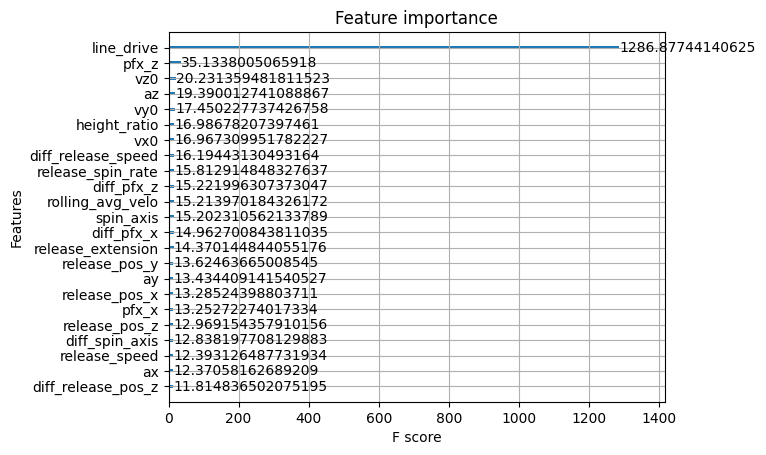

In [19]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

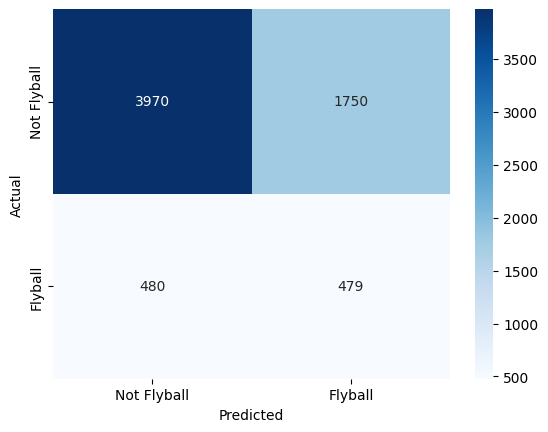

In [20]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Flyball', 'Flyball'], yticklabels=['Not Flyball', 'Flyball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [21]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'line_drive', 'diff_spin_axis', 'diff_pfx_x',
       'diff_pfx_z', 'diff_release_pos_z', 'diff_release_speed'],
      dtype='object')

In [22]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [23]:
y_pred = final_model.predict(predictions)

In [24]:
testing_identifiers['xfb'] = y_pred

In [25]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/off_speed/fb_2022&3_xfb.csv")